#DT2470 Lab 02: Synchronization and rhythm

by Andre Holzapfel

In this lab you will choose to **either** do exercises regarding synchronization (chapter 3), **or** rhythm and tempo processing (chapter 6). We agree that doing both would be too much work (for this year), but you will have the code for the solutions for both anyway!

Again, you can use whatever software you want for your own implementation, but I use python in my explanations, and two external libraries in python need to be used in this Lab. Just as Bob, I am basically learning Python by working on this lab, so excuse my bad programming. (I am a bad programmer independent of language, anyway.)

Your task is to reproduce all shown figures with your code (or show the equivalent plots for your own audio files, if you use different ones). Also, provide short answers to the questions in the text.

##Audio samples:

In my examples I use file from the following google folder:

https://drive.google.com/drive/folders/1TGj4ZcEgdGXt9Eko2qViiiKWkUDDewbL?usp=sharing

You can copy these files to your own google folder and use them as explained in Lab 1.

At some points I will ask you to use some audio examples of your own. Be creative...the goal is to check where systems work or fail, and understand (to some extent) those behaviors.

## Code preparations

As for Lab 1, you need to have some external libraries also here:

In [1]:
# Imports
import os, sys
from scipy import signal
from pydub import AudioSegment
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn

#Plot settings
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
class MirAudioSegment(AudioSegment):
    def __init__(self, data=None, *args, **kwargs):
        super().__init__(data, *args, **kwargs)
        self.stft = None
        
    def is_mono(self):
        return self.channels == 1
    
    def samples(self):
        if self.is_mono():
            return super().get_array_of_samples()
        else:
            print("Warning! Sound has two channels!")
            return None
        
    def get_timeline(self,offset=0):
        N = int(self.frame_rate * self.duration_seconds)
        return np.linspace(offset,offset+self.duration_seconds,N)
    
    def plot_waveform(self, offset=0):
        ax = plt.axes()
        ax.set_xlabel('Time [seconds]')
        ax.set_ylabel('Amplitude')
        ax.plot(
                self.get_timeline(offset),
                self.samples()
        )
        return ax
        
    def compute_stft(self, w_length, hop_factor=0.5):
        "hop factor is hop size/window size"
        self.stft_w_length = w_length
        self.stft = signal.stft(
                                self.samples(),
                                fs=self.frame_rate,
                                nperseg=int(self.frame_rate*w_length),
                                noverlap=int(self.frame_rate*w_length*(1-hop_factor)),
        )
        return self.stft 
    
    def plot_magnitude(self):
        ax = plt.axes()
        f, t, coeff = self.stft
        ax.pcolormesh(t, f, np.abs(coeff), vmin=0, shading='auto')
        ax.set_title('STFT magnitude spectrum')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [s]')
        ax.set_ylim([0,self.frame_rate*self.stft_w_length//2])
        return ax
    
    def log_freq_spectrogram(self, w_length=None, hop_factor=None):
        if self.stft is None:
            stft = compute_stft(w_length, hop_factor)[2].T
        else:
            stft = self.stft[2].T
        N, K = stft.shape
        
        def phys_freq(coef):
            return coef/self.stft_w_length
        
        def center_freq(p):
            return 440*2**((p-69)/12)
        P_upper = [center_freq(p+0.5) for p in range(128)]

        log_freq = np.zeros((N,128))
        chroma = np.zeros((N,12))
        
        for time_frame in range(N):
            # Sum up squared magnitudes of coefficients belonging to pitch class
            for fourier_index in range(K):
                for pitch in range(128):
                    if P_upper[pitch] > phys_freq(fourier_index):
                        break          
                log_freq[time_frame][pitch] += np.abs(stft[time_frame][fourier_index])**2
                chroma[time_frame][pitch%12] += np.abs(stft[time_frame][fourier_index])**2
        
        self.log_freq = log_freq
        self.chroma = chroma
        return log_freq
    
    def plot_lf_spectrogram(self):
        ax = plt.axes()
        lf = self.log_freq
        N, P = lf.shape
        ax.pcolormesh(np.linspace(0, self.duration_seconds, N),
                        np.arange(P), 
                        lf.T, 
                        vmin=0, shading='auto')
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("MIDI pitch")
        ax.set_ylim([50,120])
        return ax
    
    def plot_chroma(self, gamma=None):
        ax = plt.axes()
        chroma = self.chroma
        if gamma is not None:    
            chroma = np.log(np.ones(chroma.shape) + gamma*chroma)
        N, C = chroma.shape
        ax.pcolormesh(np.linspace(0, self.duration_seconds, N),
                        np.arange(C), 
                        chroma.T, 
                        vmin=0, shading='auto')
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Note")
        return ax
  

# 1. Synchronisation

Complete the tasks in this part, if you want to focus on the synchronisation (but have a look at the rhythm part below before you decide!).

## Part 1.1 Warming up

Choose two music sound files that can be considered as interpretations of the same "tune". In my example I used the cmajor_piano.wav and Cmajor_sung.wav, where a C-major scale is performed, once on piano and once sung. For the beginning, choose some excerpts, and not complete pieces, in order to get started.

Read the sound files to a numpy array, and plot the two waveforms. (You did that in Lab 1 too).

Below the waveform I get for the piano file:


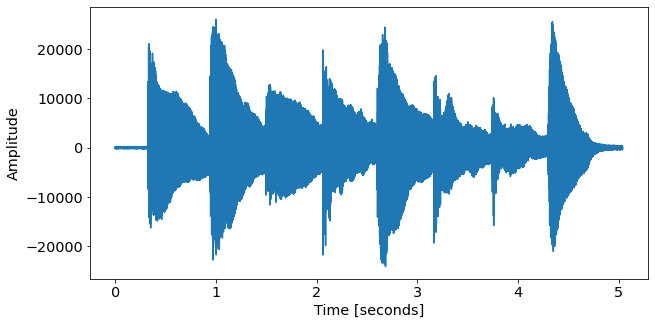

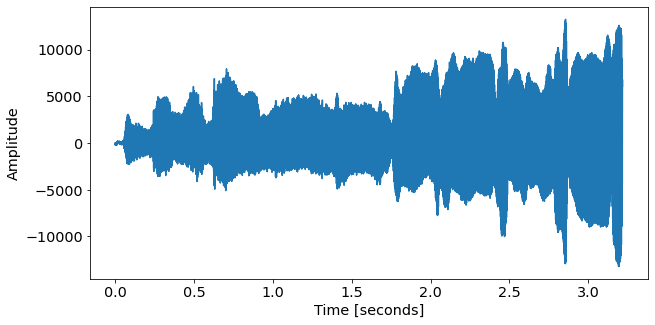

In [3]:
piano = MirAudioSegment.from_file("audio/cmajor_piano.wav", format="wav")
vocal = MirAudioSegment.from_file("audio/Cmajor_sung.wav", format="wav")

piano.plot_waveform()
plt.show()

vocal.plot_waveform()
plt.show()


## Part 1.2 Compute the spectral magnitude

For both signals compute a Short-time Fourier transform (STFT), and plot their magnitude spectra (as in equation 3.1. Use the code from Lab 1 as starting point). Note: Since you are focusing on tonal content in the Chroma features, use a long window (about 100ms).

The magnitude spectrum for the piano example is shown below. 

Question: why do we see so few high-frequency components? (Hint: in lab 1 you plotted db magnitude spectra).

> High-frequency components are often due to a noisy sound, and the piano audio is very clean. We see that we get more visible high-frequency bands with the vocal audio.

In [65]:
for audio in [piano, vocal]:
    audio.compute_stft(0.100, 0.25)
    #audio.plot_magnitude()
    #plt.show()

## Part 1.3 Compute a log-frequency spectrogram

Now, transform the linear frequency axis into a logarithmic one (equation 3.4), and plot the resulting log-frequency spectra for both signals.

Hint: you need to assign the frequencies of the STFT coefficients to the desired pitch bins of the 12-tone resolution (equations 3.2 and 3.3, and the related text in the book help). Unless you are a good numpy programmer (I am not), you will need some loop in that code...

My piano log-f spectrogram looks as shown below.

Question: why do the low-frequency regions look so spread-out and smeary?

In [80]:
def log_freq_and_chroma(X):   
    # X(n,k) as described by the book 
    # is the stft matrix
    N, K = X.shape

    # Frequencies for center pitches
    def center_freq(p):
        return 440*2**((p-69)/12) #in Hz
    #center_freq(60) should be 261.63

    # Upper limit for each pitch
    P_upper = [center_freq(p+0.5) for p in range(128)]
    # P_upper[60] should be 269.29

    # Physical frequency
    def phys_freq(k):
        # given by F_coef = k*f_s/N
        # for time window the number of time frames are
        # N = 0.10 * f_s
        # which gives F_coef = k / 0.10
        return k / 0.10

    # Y_LF(n,p) and C as described by the book
    Y_LF = np.zeros((N,128))
    C = np.zeros((N,12))

    for time_frame in range(N):
        # Sum up squared magnitudes of coefficients belonging to pitch class
        for fourier_index in range(K):
            for pitch in range(128):
                if P_upper[pitch] > phys_freq(fourier_index):
                    # In the beginning the limit will be lower than physical frequency
                    break
            Y_LF[time_frame][pitch] += np.abs(X[time_frame][fourier_index])**2
            C[time_frame][pitch%12] += np.abs(X[time_frame][fourier_index])**2
            
    return Y_LF, C
            

piano.log_freq_spectrogram()
vocal.log_freq_spectrogram()


array([[5.81076050e-01, 0.00000000e+00, 0.00000000e+00, ...,
        3.55274155e+00, 2.78122999e+00, 2.41849399e+01],
       [4.02165245e+02, 0.00000000e+00, 0.00000000e+00, ...,
        1.84860395e+01, 1.95094046e+01, 6.18491933e+01],
       [4.95006143e+02, 0.00000000e+00, 0.00000000e+00, ...,
        8.07776513e+01, 6.66348982e+01, 1.49220484e+02],
       ...,
       [7.20346646e+01, 0.00000000e+00, 0.00000000e+00, ...,
        2.56113697e+01, 9.99672336e+01, 1.21603792e+02],
       [2.61732543e+02, 0.00000000e+00, 0.00000000e+00, ...,
        1.94880766e+02, 2.15953105e+02, 1.41893180e+03],
       [5.46919433e+02, 0.00000000e+00, 0.00000000e+00, ...,
        2.38503594e+02, 2.09221655e+02, 1.87178490e+03]])

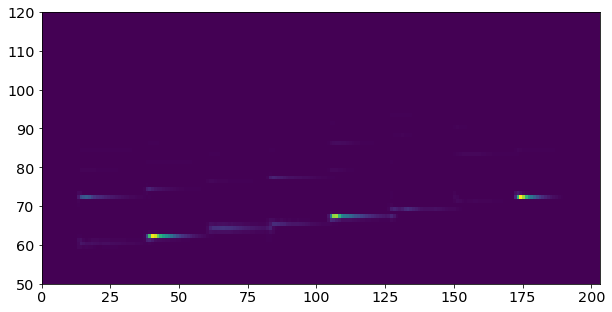

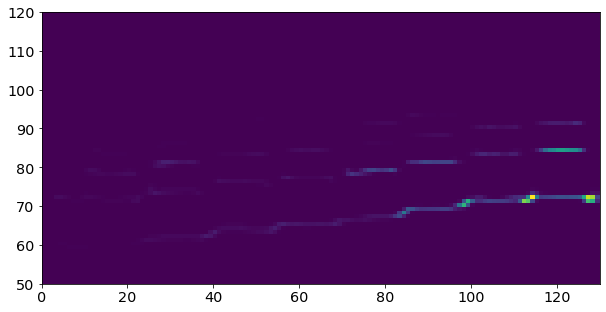

In [81]:
piano_lf = piano.log_freq
plt.pcolormesh(piano_lf.T)
plt.ylim([50,120])
plt.show()

vocal_lf = vocal.log_freq
plt.pcolormesh(vocal_lf.T)
plt.ylim([50,120])
plt.show()

## Compute the chromagram

The chromagram is a feature that captures well harmonic and melodic development in a sound file. You will compute these features, to apply a synchronization (DTW) algorithm to them.



1.   Compute the chromagram according to equation 3.6

![](https://drive.google.com/uc?id=1Hj26wZ2WHufe1DkZqZoFrJ06kS7y8msS)

2.   Apply logarithmic compression to the chromagram. This will be your input feature for the DTW (my example uses gamma=100).

![](https://drive.google.com/uc?id=1eX8WhSmn6XxI8sIXxfRxdnssSrf2kICT)







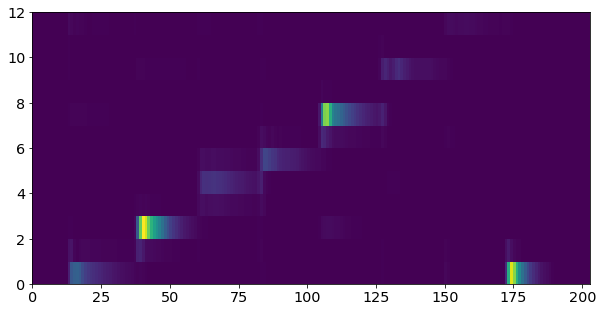

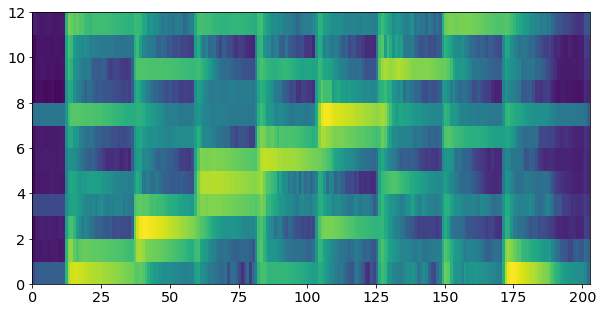

In [79]:
plt.pcolormesh(piano.chroma.T)
plt.show()

def compress_log(values, gamma=100):
    '''values is a np array, 
    gamma is the compression constant'''
    return np.log(np.ones(values.shape) + gamma*values)

piano_compr = compress_log(piano.chroma, gamma=100)
plt.pcolormesh(piano_compr.T)
plt.show()


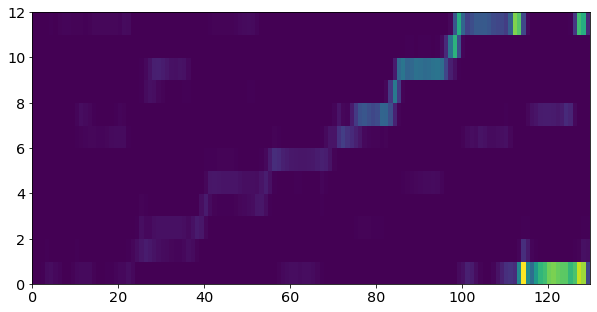

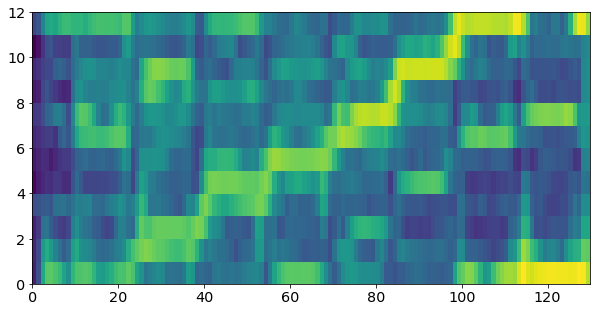

In [82]:
plt.pcolormesh(vocal.chroma.T)
plt.show()

vocal_compr = compress_log(vocal.chroma, gamma=100)
plt.pcolormesh(vocal_compr.T)
plt.show()

## Part 1.4 Compute the synchronization

To this end, you will use the DTW as provided by the librosa library. You can see how to use it in the following code:

https://librosa.github.io/librosa_gallery/auto_examples/plot_music_sync

You can use your two computed chromagrams as inputs X and Y to this function, as they are. Compute the synchronization, and plot the path over the obtained cost matrix D. Your code should start somehow like:

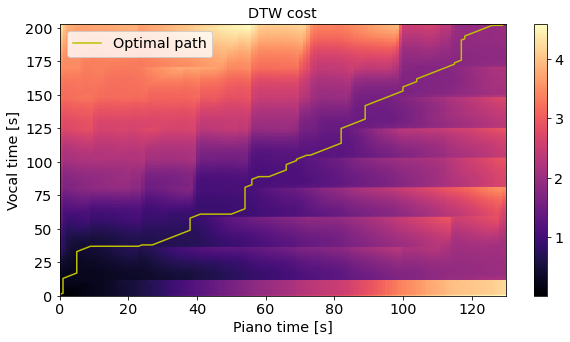

In [90]:
from librosa.sequence import dtw
from librosa import display

D, wp = dtw(X=piano_compr.T, Y=vocal_compr.T, metric='cosine')
fig = plt.figure()
ax = plt.axes()
img = display.specshow(D, x_axis='frames', y_axis='frames',
                               ax=ax)
ax.set(title='DTW cost', xlabel='Piano time [s]', ylabel='Vocal time [s]')
ax.plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
ax.legend()
fig.colorbar(img, ax=ax)

## Part 1.5 Compute the same alignment using the chroma features from librosa

OK, we went by the course book when computing the features above. Now let us use the librosa library, to compare with our implementation.

To this end, you can copy/paste and edit the code from the librosa example provided above, and compute the plots!

The chroma features look less noisy for me, probably because I used the logarithmic compression with a bad parameter. Note that the book says that all the parameters need to be adapted with care (which some people might call feature engineering):

![](https://drive.google.com/uc?id=1lxDS13V7f_azktMmJP5e9NUvQrp2KQ0c)

After that the warping path looks as follows for me:

![](https://drive.google.com/uc?id=1K5F9XnD6iyDudo1R9V4oCgmCYTqTzju8)

Finally, also compute the alignment visualization between the waveforms, as done in the librosa example. Mine looks as follows:

![](https://drive.google.com/uc?id=1feMM7D7w4uK3UajklQm849X3mDPtdkRU)



In [8]:
from librosa.feature import chroma_stft
samples = np.array(np.float(piano.samples()))
chroma = chroma_stft(samples, 
                     piano.frame_rate, 
                     n_fft=int(piano.frame_rate*0.1), 
                     hop_length=int(piano.frame_rate*0.025)
)



ValueError: could not convert string to float: array('h', [27, 28, -9, 28, -10, 100, -80, 62, 29, -11, 65, -10, -8, 99, -80, 135, -82, 136, -46, 29, 63, -10, 65, -11, 29, 26, 63, -43, 27, 62, -43, 61, -6, -10, 65, -48, 68, -14, 68, -13, 102, 23, 31, -11, 64, -9, 28, 97, -78, 97, 28, -9, 99, 27, -45, 171, -152, 206, -80, 64, 95, -75, 130, -42, -8, 61, -42, 27, 62, -43, 132, -78, 98, -44, 99, -10, 29, 61, -42, 61, 64, -45, 99, -44, 97, 30, 94, -40, 131, -7, 62, 28, 26, -7, 97, -7, 96, 30, 24, 31, 23, 66, 60, -7, 28, -10, 29, 97, -9, 28, -8, 62, -43, 97, -43, -8, 62, 28, -10, 136, -11, -6, 132, -44, 100, -11, -5, 59, 30, 25, 64, -8, 26, 28, -9, 28, 62, -7, 26, 27, -7, 97, -8, 27, 28, 26, -6, 95, -41, 95, -5, 25, 29, 26, 27, -8, 28, -9, -7, 61, -43, 99, -46, 67, 22, -4, 24, -7, 63, -9, 99, -80, 168, -113, 96, -41, 25, 29, -10, -7, 97, -43, 63, 26, -77, 130, -110, 164, -4, -12, 136, -115, 168, -114, 168, -42, 96, -41, 94, -75, 131, -114, 170, -116, 134, -79, 133, -43, 63, 26, 27, 99, -9, 99, 61, -42, 96, -6, 25, 65, -10, 27, 29, 60, 30, 60, -7, 98, -45, 100, -10, 28, 28, 25, 29, 63, 60, -41, 97, 27, 28, 132, -43, 63, 27, 27, -9, 29, -10, 135, -45, 98, -42, 60, 30, 25, 28, 63, -80, 170, -80, 63, 62, -113, 167, -77, 61, 27, -6, 95, -42, 98, -80, 100, -11, 29, 96, -77, 132, -78, 132, -78, 133, -114, 134, -46, 100, 27, -8, 133, -44, 97, -5, 23, 102, -82, 135, -80, 64, -10, 100, -9, 61, -5, 94, -39, 130, -78, 133, -115, 136, -12, 102, -12, 100, -43, 96, -78, 170, -82, 101, -10, 28, -9, 29, 24, 31, 23, 101, -9, 27, 28, 61, -43, 169, -185, 134, -10, 29, 61, 28, 62, 28, -45, 64, -45, 99, 27, 27, 97, -42, 61, 29, 26, 63, -44, 98, -43, 62, 28, -9, 63, -9, 64, -9, 63, -44, 97, -41, 60, -41, 130, -111, 201, -147, 203, -116, 173, -120, 210, -190, 243, -187, 170, -80, 98, -7, -10, 29, 61, 27, 29, 25, -42, 133, -80, 100, 60, -5, 130, -41, 96, -42, 26, 28, -9, 28, 27, 27, 27, -8, 63, -80, 170, -115, 168, -113, 203, -114, 134, -44, 61, 30, 59, 32, -13, 66, 25, -8, 100, -47, 66, -11, 64, -44, 63, -9, 63, -8, 27, -9, 28, 27, 62, -43, 63, 25, -6, 61, 63, -43, 169, -116, 135, -45, 64, 26, 29, 25, 29, -10, 64, 27, 27, -8, 26, -6, 95, -76, 167, -80, 137, -49, 67, -47, 65, -44, 62, 63, -9, 63, 27, 28, 97, -79, 134, -81, 136, -81, 134, -115, 205, -115, 169, -113, 24, 102, -82, 64, 27, -8, 62, -8, -8, 62, -7, 61, -8, 63, 27, 63, -9, 62, 28, -8, 98, -80, 99, -44, 99, -45, 98, -43, 98, -79, 99, -11, 66, -46, 134, -113, 166, -147, 167, -149, 169, -80, 99, 26, 63, -43, 133, -79, 97, -42, 95, -4, 24, 63, -42, 131, -41, 60, 65, -46, 136, -46, 64, 27, -80, 205, -80, 64, 62, -44, 98, -8, 63, -44, 28, -10, 65, 25, 29, 97, -149, 203, -149, 169, -80, -6, 130, -147, 167, -43, 63, 62, -44, 64, 61, -43, 133, -42, 61, 28, 61, -7, 63, 63, -81, 241, -186, 275, -113, 60, 101, -82, 136, -46, 64, 62, 62, -6, 96, -78, 168, -44, 64, 26, -42, 96, 64, 26, -43, 63, 26, -6, 95, -76, 131, -42, 61, -6, 60, 30, 59, -5, 95, -5, 60, 28, -9, 64, -45, 64, 25, 64, -8, 61, -77, 96, -77, 132, -79, 99, -116, 206, -151, 204, -114, 98, -44, 134, -44, 61, -5, 23, 67, 24, -7, 63, -10, 64, 27, -8, 62, 28, 26, 28, 27, -8, 132, -112, 202, -183, 237, -148, 96, -5, -11, 135, -116, 171, -117, 136, -46, -6, 96, -77, 132, -9, -6, 60, 30, -46, 170, -116, 170, -113, 131, -42, 61, 98, -113, 133, -44, 62, 64, -11, 31, 24, -6, 97, -44, 63, 28, -9, 133, -77, 165, -111, 132, -44, 29, 24, 30, 26, -8, 99, -82, 137, -46, 64, -9, 27, -43, 27, -43, 26, -7, 96, -76, 131, -77, 96, -7, 27, -9, 29, -46, 65, -10, 98, -78, 97, -78, 133, -44, 62, 64, -80, 170, -45, 28, 98, -79, 132, -41, 24, 67, -13, 66, 25, 64, 26, 65, -47, 102, -48, 66, 60, -41, 61, 28, 26, 64, 26, 29, 25, 29, -9, 134, -9, 99, -46, 66, 24, 29, 26, -43, 98, -44, 99, -45, 134, -78, 167, -113, 203, -113, 167, -112, 166, -6, 25, 65, 24, 67, 22, 103, -48, 101, -10, -7, 97, -78, 167, -112, 166, -77, 168, -80, 171, -82, 101, -47, 101, -10, -8, 98, -43, 96, -5, 24, 29, 97, -8, 63, -9, 135, -81, 135, -10, 28, 63, -8, 27, -9, 64, -11, 67, -13, 66, -10, 64, -9, 63, 26, 64, -9, 64, -45, 28, -45, 135, -80, 135, -81, 64, 25, 66, -11, 64, -45, -7, 169, -80, 134, -80, 98, -6, 60, -6, 25, -7, 62, 99, -80, 134, -44, -8, 62, -43, 27, -9, 65, -47, 101, 25, 28, 28, 25, 30, 60, -41, 95, -41, 131, 30, 60, -7, 62, -43, 98, -9, 28, 62, -44, 100, -46, 100, -9, 26, 64, -44, 97, -41, 94, -40, 96, -44, 64, 26, 28, -9, 99, -80, 134, -8, -10, 30, 24, 66, 60, 28, -8, 62, 98, -78, 133, -45, 65, 60, -42, 63, -10, 100, -45, 27, 100, -11, 65, -46, 29, 27, 62, -44, 134, -9, 64, -10, 64, -80, 134, -79, 97, -7, 27, 62, -43, 97, -7, 61, -6, 24, -40, 95, -7, 99, -11, 65, -44, 132, -42, 97, -9, -76, 130, -42, 27, 26, -6, 25, 100, -117, 206, -186, 169, -79, 98, -9, 28, -9, 28, 62, -43, 132, -77, 96, -42, 97, -8, 62, -7, -10, 136, -153, 207, -152, 170, -44, 27, 63, -9, 64, -10, 99, -9, 63, -79, 98, -9, 65, -12, 66, -46, 134, -78, 97, -44, 135, -81, 135, -81, 65, 60, -5, 59, -41, 25, 64, -43, 131, -112, 202, -113, 98, -10, 30, 95, -41, 61, 62, -6, 60, 29, -9, 97, -41, 60, 64, -9, 63, 27, 62, 28, 62, -8, 98, -79, 97, 28, 27, 98, -43, 61, 29, -9, 63, 62, -8, 98, -43, 97, 28, 26, 28, 62, -79, 99, -45, 99, -45, 100, -81, 135, -80, 133, -42, 61, -42, 26, -8, -9, 65, -11, 66, -12, -5, 60, -6, 61, -7, 61, 29, -10, 65, 24, 66, 60, -7, 62, -9, 65, -10, 99, -45, 98, -78, 132, -6, -46, 135, -80, 98, -7, 25, 30, -11, 65, -46, 136, -153, 172, -117, 99, -8, 27, 62, -42, 95, -111, 166, -76, 95, -42, 98, -80, 100, -11, -6, 132, -114, 169, -79, 98, -45, 29, -11, 31, 60, -8, 63, -9, 99, -9, 28, 61, -42, 61, -7, 27, 62, -43, 132, -77, 96, 30, -47, 136, -10, 63, 64, -46, 135, -79, 132, -6, 25, 28, -8, -8, 27, 63, -45, 64, -45, 99, -115, 169, -115, 99, 25, -41, 60, 29, 26, 134, -115, 134, -44, 63, 61, -42, 169, -80, 134, -9, 28, 62, -42, 95, -5, 131, -78, 97, 28, 62, 28, 26, 62, -42, 132, -78, 98, -10, -5, 94, 31, -12, 66, -11, 30, 60, -7, 98, -9, 64, -81, 100, -10, 65, -46, 28, -44, 134, -45, 136, -117, 135, -44, 62, 28, -44, 169, -150, 99, -45, 29, 60, -6, 61, 29, 61, 28, 26, 28, -9, 65, 59, 31, 23, -5, 26, 27, -7, 60, -5, 25, 99, -44, 26, 65, -46, 100, -10, 28, 63, -44, 63, 61, 29, 62, -44, 64, 24, -4, 94, -112, 168, -150, 169, -114, 132, -77, 96, -7, -9, 63, 63, -45, 100, -45, 133, -42, 25, 65, -10, 64, -45, 29, 24, -5, 61, -8, 63, 26, -8, 29, -11, 66, 59, -41, 97, -9, 65, -46, 64, 26, -8, 63, -8, 62, 28, 25, -40, 164, -180, 200, -75, 23, 101, -81, 134, -77, 130, -76, 95, 30, -10, 64, -9, 27, 28, 62, -9, 64, 27, -10, 102, -49, 67, -10, 62, -7, 97, -79, 135, -116, 98, 27, -8, 63, -8, 26, 64, -81, 100, -9, 27, -7, 26, 28, -8, 26, -42, 97, -8, 28, 61, 29, 25, 135, -151, 170, -151, 134, -9, 63, -42, 131, -113, 167, -77, 168, -114, 133, -44, 28, 26, 99, -80, 170, -45, 64, 25, -6, 61, 28, 134, -81, 135, -80, 98, -7, -9, 62, -77, 165, -110, 201, -77, 96, 29, 61, -6, 96, -8, 63, 27, 63, -44, 62, -43, 169, -115, 133, -79, 63, 28, 61, -8, 99, -45, 99, -8, -10, 66, -48, 101, -9, -8, 28, -11, 137, -12, 66, -46, 64, 27, -9, 63, 27, -8, 99, -46, 30, 60, -6, 97, -8, 98, -9, -7, 133, -79, 98, -9, 28, 63, -45, 29, 60, 29, 28, -10, -7, 61, 28, 28, 27, -45, 64, -10, 101, -47, 100, -10, 100, -10, 29, 25, 64, -44, 97, -42, 26, 63, -8, -9, 134, -43, 166, -75, 58, 33, 21, 32, -47, 100, -9, 134, -44, 97, -42, 60, -76, 61, 63, -79, 133, -114, 133, -9, 65, 96, -78, 168, -80, 136, -11, 66, 24, 64, -43, 96, -41, 131, -77, 96, -7, -8, 97, -42, 61, 63, -79, 169, -80, 64, 98, -116, 171, -81, 98, -42, 61, -78, 98, 27, -9, 64, -45, 98, -77, 165, -145, 235, -146, 165, -40, 24, 65, -10, 64, -9, 63, -79, 169, -44, 98, -43, 26, 65, -46, 135, -80, 133, -42, 25, 100, -81, 136, -47, 30, -11, 101, -82, 137, -83, 137, -82, 136, -81, 29, 96, -77, 132, -78, 62, -9, -7, 61, 29, -9, 97, -113, 132, -42, 26, -9, 65, -11, 101, -11, 29, 62, -8, 26, 64, -9, 134, -80, 99, -45, 135, -80, 168, -77, 61, 99, -44, 168, -113, 168, -79, 63, 26, -7, 97, 29, 59, 67, -13, 103, -48, 30, 25, 65, -46, 29, -46, 102, -13, 67, -12, 30, 26, 28, 26, 29, 25, 30, 25, 28, -8, 97, -42, 132, -79, 64, 25, 65, 61, 98, -8, -43, 96, -40, 94, -6, 27, -9, 99, -45, 64, -45, 63, -7, 25, 66, -12, 136, -116, 99, -9, -7, 133, -115, 134, -10, 30, -11, 30, -11, 100, -10, 30, 95, -6, 25, 65, -45, 63, 63, 26, 29, 61, -8, 28, 133, -115, 169, -79, 98, -8, 27, 62, -42, 131, -77, 97, 27, 28, 27, 98, -80, 134, -44, 64, 26, 63, 26, -7, 98, -80, 134, -44, 98, -43, 97, -8, 98, -78, 132, -78, 97, -7, -9, 64, -10, 28, 27, 63, -44, 99, -81, 64, 27, -44, 99, -10, -7, 62, 63, -44, 98, -44, 134, -115, 169, -114, 168, -78, 132, -78, 97, -43, 64, -11, 30, -11, 65, -9, 97, -77, 131, -77, 96, 65, -45, 133, -78, 96, -5, 59, -4, 23, 66, -45, 132, -40, 94, -5, 25, 28, 63, -9, 64, -10, 28, 27, -8, 63, 62, -8, 97, -77, 131, -41, 60, -6, 96, -43, 134, -45, 30, 95, -113, 133, -44, 99, -9, 63, -44, 134, -45, 29, 61, -43, 63, -9, 64, -46, 101, -46, 100, -10, 28, 28, 96, -112, 167, -43, 63, 61, -77, 61, 29, 26, 62, -43, 27, 28, 26, 29, 60, 29, 27, 26, -7, 98, -44, 98, -44, 27, 28, 27, 27, 27, 27, 28, 27, 26, 29, 61, 29, 25, 29, 26, -7, 132, -42, 96, -7, 62, 62, -6, -11, 135, -116, 135, -45, 65, 23, 32, -47, 99, -113, 95, -75, 129, -40, 59, -39, 128, -39, 59, -6, 62, -9, 27, -7, -10, 101, -12, 30, 25, -7, 62, -7, 26, 27, -7, 61, 28, 28, -10, 65, -10, 62, 29, -10, 29, 61, -42, 167, -113, 239, -150, 133, -42, 61, 28, -9, 98, -43, 98, -10, -6, 96, -77, 167, -78, 97, -42, 61, 63, 28, 61, -6, 25, 28, 63, 62, -7, 61, -43, 99, -11, 66, -46, 28, -43, 97, -8, 28, 61, -77, 61, -42, 60, 30, -10, 63, 28, -10, 64, -79, 132, -41, 59, 66, -82, 136, -46, 65, 24, -5, 96, -43, 63, -9, 98, -7, 96, -78, 99, -46, 100, -45, 63, -7, 96, -42, 132, -43, -8, 63, -79, 132, -42, 25, 66, -83, 138, -85, 140, -85, 174, -83, 135, -8, 62, 63, -8, 96, -42, 98, -44, 99, -82, 102, -47, 65, -9, 61, 30, 25, 65, -11, 65, -11, 66, -11, 64, -115, 134, -80, 64, 25, -6, 62, 26, 28, -9, 64, -10, 100, -46, 100, -80, 132, -77, 97, -8, 27, 28, 25, 100, -45, 99, -44, 99, -46, 65, 61, -43, 99, -46, 66, -11, 28, 28, 24, 32, 23, -5, 95, -42, 98, 26, 29, 60, 30, -10, 98, -43, 26, 64, -9, 27, 62, -43, 133, -78, 97, -9, -6, 60, -6, 26, 62, -7, 169, -81, 136, -46, 135, -115, 203, -147, 130, -4, 22, 67, -46, 64, -80, 63, -44, 28, 27, 27, 62, -43, 62, -42, 96, -43, 98, -78, 132, -113, 131, -148, 240, -116, 170, -80, 134, -44, 27, 28, -45, 99, -45, 65, -10, -7, 97, -45, 67, 23, -5, 60, -43, 29, 130, -75, 58, 31, 96, -8, 98, -79, 133, -113, 237, -147, 166, -113, 99, 25, 65, -11, 100, -44, 62, 63, -8, 62, 63, -44, 98, -8, 63, -9, 28, -9, 28, 61, -6, 96, -6, 24, 65, -9, 62, 29, 25, -7, 62, -78, 166, -74, 57, 31, -10, 99, -9, 27, 27, -7, 27, 61, 29, 60, 30, 26, -80, 135, -10, 64, 63, -80, 133, -78, 97, -6, -11, 29, -9, 28, 62, -8, 62, -8, 63, 26, 65, 60, 29, -45, 134, -43, 97, -79, 64, -10, 65, 24, -6, 27, -9, 64, -10, 99, -79, 133, -44, 134, -44, 63, -9, 99, -9, 63, -8, 27, 98, -79, 134, -81, 137, -83, 66, 60, -8, 100, -46, 65, 25, 28, -9, 100, -81, 170, -79, 26, 99, -79, 168, -113, 97, -9, 64, 26, -7, 26, 28, -9, 99, 26, 28, 26, -42, 62, 26, -6, 95, -41, 167, -43, 99, -10, 99, -115, 133, -113, 132, -42, 60, 29, -45, 135, -45, 64, 25, -6, 61, 28, -8, 133, -80, 171, -117, 136, -45, 62, 64, -46, 101, -46, 100, -10, 28, 27, 27, 28, 62, -44, 134, -44, 62, 64, -46, 206, -151, 134, -8, -9, 98, -8, 28, 61, 65, 24, 30, 61, 27, 29, 59, -39, 58, 66, 25, 28, -8, 62, 28, -9, -43, 98, -8, 26, 29, -10, 135, -45, 134, -8, -8, 97, -7, 97, -79, 99, -80, 99, -45, 28, 27, 28, 27, -9, -8, 99, -45, 64, 26, 28, 26, 64, -45, 135, -116, 170, -45, 29, 25, -77, 168, -80, 100, -11, 29, 62, 27, -8, 133, -149, 203, -114, 133, 27, 29, 60, 29, -10, 99, -44, 63, 27, -9, 63, 62, -7, 62, -80, 135, -45, 64, -9, 62, -7, 62, -9, 65, 24, 65, 26, 62, 100, -10, 28, 63, -45, 99, -8, 27, 27, 27, 28, 26, 29, -11, 29, 27, 26, -6, 25, -7, 62, -79, 169, -114, 133, -9, -6, 24, 31, 24, 135, -79, 96, -40, 94, -5, 132, -9, -43, 99, -10, 28, 28, -11, 102, -48, 66, 24, -5, 95, -40, 59, 29, -9, 98, -7, 25, 66, -83, 136, -10, -8, 135, -80, 62, -8, -8, 27, 63, -44, 134, -115, 99, -46, 101, 24, 30, -9, 97, 29, 25, 28, 28, 26, 29, 25, 64, -44, 97, -41, 59, 31, 24, 29, 98, -45, 135, -80, 28, 26, -77, 131, -42, 62, 27, -7, 61, -42, 61, -43, 170, -116, 134, -8, 26, 65, -11, 65, 25, -6, 61, -43, 97, -77, 132, -43, 62, 28, -10, 66, 23, 31, 25, -7, 62, 27, -7, 96, -41, 60, 29, -9, 98, -79, 169, -44, 98, 63, -80, 170, -116, 242, -152, 135, -46, 65, -9, 27, 27, 27, -43, 98, -44, 62, -7, 61, -7, 27, 62, -42, 202, -113, 97, 63, -43, 133, -44, 99, -116, 205, -149, 203, -149, 169, -116, 136, -11, 29, 97, -78, 168, -79, 28, 96, -41, 25, 28, -8, 98, -115, 134, -9, 98, -43, 27, 26, -7, 27, -8, 62, -44, 99, -44, -7, 25, -42, 97, -7, 27, 26, 29, 60, -6, 62, -9, 100, -47, 65, 27, 26, 64, 60, -6, 26, -7, 61, -7, 25, 66, -48, 139, -120, 137, -10, 27, 29, 61, -8, 99, -46, 65, 27, -46, 136, -10, 28, 27, 63, -46, 137, -47, 30, 60, -7, 28, 61, -77, 131, -6, 96, -42, 62, -8, 98, -44, 63, 27, -8, 98, -44, 64, -11, 101, -45, 133, -42, 60, 30, 25, -43, 134, -79, 132, -42, 61, 29, -45, 134, -79, 133, -43, 62, -8, -7, 60, 30, 25, -8, -6, 59, 30, 132, -43, 62, 27, -43, 97, -42, 96, 29, -45, 63, -8, 62, -7, 26, 28, -9, 63, -7, 60, -5, -47, 101, -81, 134, -44, 98, -7, 60, -6, 60, -6, -44, 132, -77, 131, -41, 95, -77, 133, -44, 134, -79, 62, -8, -9, 64, -9, 28, 61, -7, 61, -5, 59, -6, 61, 29, 26, 99, -45, 63, -8, 28, -10, 29, -9, -8, 62, 28, -44, 63, 28, -11, 102, -13, 103, -12, -6, 97, -44, -7, 26, 29, -11, 66, -46, 63, -43, 133, -114, 134, -81, 65, 60, -41, 25, 28, 28, 25, 30, 59, -75, 200, -75, 59, 29, -44, 169, -43, 60, 66, -83, 173, -118, 135, -9, -7, 132, -7, 26, 28, 27, -9, 99, -44, 27, 27, -8, 27, 63, -9, 99, -10, 101, -12, -5, 131, -42, 133, -80, 100, -11, 65, -10, 99, -79, 133, -114, 204, -80, 99, -44, 27, 64, 25, -7, 63, -81, 137, -83, 101, -10, 62, 31, 22, 66, 26, 26, 31, 58, 31, 24, 30, 25, 29, 61, 29, 26, 28, 26, 28, 28, 25, 65, 26, 27, 28, 26, 27, -41, 130, -147, 167, -114, 63, -9, 64, -10, 100, 25, 64, -9, 63, -79, 168, -77, 130, -75, 129, -40, 131, -42, 133, -45, 100, 60, 31, 23, -4, 94, -6, -8, 62, -43, 97, -43, 27, 64, 25, 29, 61, -78, 204, -114, 167, -41, 95, -41, 132, -79, 63, 27, -44, 170, -116, 134, -114, 132, -42, 97, -9, 100, 25, -7, 63, -45, 99, -9, 98, -42, 96, -42, 60, 31, 58, -3, 22, -4, 24, 65, -10, 28, 98, -79, 133, -43, 62, 28, 62, 28, 26, 28, -8, 62, -8, 98, -79, 204, -150, 133, -78, 26, 30, 23, -5, 97, -44, 64, 25, -6, 61, -42, 61, -7, 61, 64, 26, 99, -44, 97, -77, 130, -75, 130, -42, 63, -10, 29, 61, 28, -8, 98, -8, 26, -7, 61, -6, 61, -7, 61, -77, 131, -77, 61, 28, -43, 98, -9, 27, 63, -43, 168, -78, 166, -75, 94, -5, 60, -7, 63, -45, 64, -10, 65, -11, 100, -80, 98, -114, 133, -44, 63, 27, -8, 133, -79, 169, -80, 65, 60, -112, 167, -114, 134, 27, 27, 27, 28, -10, 100, -46, 101, -47, 136, -9, 97, -41, 94, -75, 59, -40, 95, -6, 61, -8, 63, -9, 29, 60, -6, 26, 63, 27, -8, 62, -7, 61, -7, 27, 97, -6, 59, -5, 61, -9, 65, -11, 65, -10, 27, 99, -45, 100, -11, 30, 60, -41, 59, 31, 24, 29, 63, -81, 171, -152, 100, -45, 63, 28, -10, 65, -10, 27, -7, 62, -43, 62, -8, 62, -7, 62, 27, -7, 60, 30, -10, 99, -44, 62, 28, -8, 96, -40, 57, -37, 58, 64, -8, 61, -41, 95, -4, 22, 67, -12, 30, 60, -40, 129, -75, 95, -43, 64, 61, -42, 62, -9, 28, 27, 98, -42, 96, -78, 97, -8, 29, 60, -41, 95, -6, 61, -6, -11, 29, -45, 64, -44, 98, -44, 132, -40, 59, 65, -46, 100, -10, 65, -11, 29, -45, 64, -10, 65, -11, 100, -80, 62, -7, -9, 98, -43, 132, -78, 97, -7, 97, -8, 63, -10, 30, 60, -77, 97, -79, 98, 27, -43, 62, -7, 60, 101, -82, 171, -115, 203, -148, 132, -79, 100, -12, 31, -12, 66, -10, 63, -8, 61, 30, -11, 30, -10, 27, 99, -45, 135, -45, 99, -9, -8, 98, -9, 64, -9, -9, 65, -11, 65, -11, 65, -10, 136, -48, 103, -13, 31, 60, -42, 168, -78, 132, -8, 28, 26, 100, -10, 28, 61, -41, 95, -40, 24, 30, 24, 31, 22, 33, 22, 32, 23, -5, -11, 100, -44, 98, -44, 98, -43, 61, 30, 23, 68, 21, 33, 128, -75, 97, 61, -77, 239, -152, 173, -48, 101, -45, 133, -6, 24, 30, 25, -7, 98, -8, -10, 100, -81, 171, -45, 98, -44, 27, 28, 63, -81, 101, -47, 30, 61, -8, 134, 26, -42, 131, -146, 164, -39, 23, 65, -9, 27, 99, -45, 134, -115, 100, -12, 67, -48, 102, -81, 168, -41, 24, 65, 26, 27, -7, -10, 65, 24, -5, 95, -41, 96, -7, 62, 28, 26, 28, 26, -6, 24, 31, 58, -39, 94, -5, 96, 27, -42, 96, -42, 133, -80, 170, -115, 133, -43, 27, 27, 28, 61, -42, 132, -113, 97, -79, 63, 27, -7, 96, -113, 168, -43, 62, 29, 24, 101, -117, 170, -78, 202, -112, 95, -40, 59, 30, -10, 63, -7, 60, 30, -11, 30, -11, 100, -80, 239, -184, 132, -6, -47, 102, -48, 102, -46, 98, -7, 132, -42, 97, -44, 64, -81, 100, -44, 62, 98, -78, 167, -113, 133, -44, 63, 63, 26, -7, 27, 26, 29, 60, 31, -13, 138, -84, 102, -11, 100, -45, 98, -79, 99, -46, 67, 22, 67, -47, 100, -9, 63, 27, 27, 28, 26, 29, 25, 28, 99, -45, 99, -44, 132, -76, 95, -77, 97, -44, 134, -114, 203, -113, 168, -45, 100, -45, 99, 27, -9, 63, -79, 62, 64, -10, 65, 60, -42, 97, -8, 28, 62, 63, -9, 27, 64, -45, 170, -151, 169, -79, 98, -43, 27, 62, -44, 135, -46, 102, -49, 138, -47, 65, 26, -9, 100, -82, 137, -82, 135, -79, 168, -78, 167, -76, 60, -7, 62, -7, -10, 66, -50, 105, -84, 172, -151, 167, -146, 129, -39, 94, -6, 62, -9, 29, 61, -7, 132, -79, 134, -8, 27, 63, 26, -43, 133, -78, 97, -8, 63, -9, 99, -10, 29, -9, 63, -44, 98, -44, 64, 61, -43, 98, -79, 133, -43, 62, -44, 134, -44, 98, -43, 26, 28, 26, 29, 25, 30, 24, -6, 61, -42, 132, -42, 95, -39, 128, -74, 164, -76, 98, -10, 30, -12, 30, 26, -9, 66, -49, 104, -49, 101, -9, 27, 28, 26, 28, 62, -8, 134, -9, 133, -7, 61, -78, 133, -44, 99, -9, 63, -44, 62, 30, 24, 65, -46, 65, 61, 28, 27, 26, 99, -8, 132, -113, 167, -7, 62, -7, 25, 29, 97, -7, 25, 30, -47, 101, -9, 132, -41, 130, -112, 97, -43, -44, 133, -79, 134, -44, 98, 62, -43, 27, 98, -78, 166, -76, 96, 29, 26, 63, 26, -42, 168, -79, 98, -8, -9, 64, -45, 99, -9, 62, -6, 24, -4, -13, -4, 95, -6, 96, -7, 27, 62, 100, -82, 207, -117, 171, -45, -7, 61, -42, 97, -43, 133, -43, 97, -7, 26, -8, 29, 24, 30, -46, 64, -9, -43, 168, -149, 203, -113, 132, -78, 63, 61, 29, -9, 97, -111, 164, -39, 94, 30, 62, -45, 64, 26, -7, 62, -43, 96, -41, 95, -40, 59, 30, 26, 26, 29, 26, -8, 63, 27, -9, 100, -81, 134, -8, 62, -8, 29, 94, -74, 200, -148, 169, -81, 101, -47, 102, -47, 99, -8, -9, 98, -42, 96, -43, 99, -46, 65, 26, 62, 29, 61, -42, 61, -7, 27, 26, 101, -47, 100, -44, 62, 63, -78, 95, -40, 95, -6, 26, 28, 26, -43, 134, -151, 170, -80, 63, 27, -79, 134, -44, 63, -9, -9, 30, 95, -76, 166, -113, 98, 62, -79, 170, -116, 135, -45, 63, 27, -43, 62, -8, 63, -10, -6, 25, -7, 27, 27, 28, -10, 64, 62, -8, 98, -44, 63, -8, 62, 27, 28, 26, -7, 98, -10, 65, 25, 29, -9, 98, -44, 99, 61, -78, 133, -44, 63, -44, 63, -115, 170, -46, 65, -10, 65, -46, 99, 27, -44, 135, -116, 169, -78, 132, -114, 170, -47, 102, 24, 65, 60, -6, 96, -42, 61, 100, -117, 207, -116, 168, -6, 25, 64, -9, 134, -79, 62, 28, -10, 100, 26, -43, 97, -42, 95, -40, 23, -4, 24, 99, -42, 94, -4, 60, 28, 64, -11, 29, 26, 29, 61, -7, 26, 62, -42, 132, -113, 132, -78, 97, -7, 62, -9, 63, -7, 61, -6, 59, -5, 25, 65, -10, 27, 63, -78, 168, -79, 27, 63, -80, 65, -12, 32, 23, 29, 27, -9, 100, -116, 98, 28, -10, 101, -47, 66, 24, -5, -11, 64, -45, 30, 24, -5, 94, -75, 94, -40, 25, 28, 27, 27, 63, 27, -8, 98, -79, 133, 28, -10, 65, 26, -9, 64, -10, -7, 98, -79, 169, -116, 171, -117, 136, 26, 27, 64, 60, 29, 26, 29, 62, -45, 99, -44, 99, -9, 28, 96, -77, 203, -78, 97, -7, -10, 99, -44, 133, -43, 98, -9, 29, 95, -6, 96, 29, 62, -9, 64, -9, 26, -41, 130, -40, 131, -78, 98, -9, 64, -10, 63, -6, 59, -4, 58, -40, 167, -185, 205, -115, 62, 100, -82, 136, -80, 98, -8, 26, 29, -9, 134, -80, 133, -41, 59, -4, 58, -40, 61, 62, -41, 129, -39, 59, 65, 26, 28, 25, 30, -11, 101, -46, 28, 27, 27, 99, -45, 63, 28, 96, -41, 96, -43, -8, 133, -8, 63, 27, 26, 64, 26, 29, -10, 99, -79, 132, -6, -46, 101, -47, 65, 61, -42, 168, -79, 97, -42, 97, -43, 97, -148, 167, -42, 96, 29, 26, 28, -44, 98, -79, 134, -45, 99, 26, 29, 25, -6, 131, -77, 96, -6, -10, 134, -114, 168, -114, 170, -82, 101, -46, 100, -9, 27, 28, -46, 101, -10, 28, 97, -42, 96, -42, 97, -44, 64, 26, 28, -44, 98, -79, 168, -149, 134, -45, 99, 26, -8, -6, 94, -40, 60, 64, 27, 132, -42, 61, -42, 61, 28, -44, 98, -79, 98, 28, -45, 99, -45, 65, 24, -5, 95, -6, 97, -44, 99, -45, 99, -8, 96, -5, -11, 99, -44, 99, -10, -6, 96, -79, 100, -46, 65, -11, 66, -12, 30, -9, 26, 30, 60, -7, 62, -8, 27, 63, 27, 27, 63, -9, 63, -8, 27, 27, 28, 61, -41, 130, -111, 166, -77, 62, -8, 26, 29, 97, -9, 30, 22, 34, -14, 66, -45, 27, 99, -45, 99, 26, 29, 60, -40, 59, 64, -44, 98, -42, 96, -7, 61, 30, -47, 101, -116, 168, -111, 93, -3, 23, 30, -11, -4, 93, -4, 25, 27, 29, 95, -41, 97, -44, 99, -46, 66, -47, 101, -10, -8, 63, -44, 168, -147, 130, -40, 24, 100, -45, 64, 27, -79, 133, -78, 96, -6, 26, 63, 63, -10, 29, 26, 28, 27, 26, 29, 25, 30, -11, 100, -45, 170, -115, 133, -43, 97, 29, -45, 98, -8, 98, -44, 63, -8, 133, -114, 133, -80, -6, 95, -75, 129, -40, 131, -114, 135, -82, 101, -81, 134, -78, 96, -78, 134, -45, 135, -46, 65, -10, 64, -9, 133, -42, 25, 100, -46, 100, 62, -80, 136, -12, 101, 25, 29, 26, -8, 63, 27, 27, 99, -46, 136, -81, 135, -45, 134, -79, 97, -41, 59, 102, -13, 32, -12, 30, 61, -44, 134, -78, 132, -78, 96, -42, 133, -44, 98, -8, 133, -78, 96, -42, 62, -8, 62, -7, 96, -76, 95, -42, 62, -43, 97, -78, 62, 63, -43, 61, 29, -11, 102, -48, 68, -49, 137, -82, 136, -80, 98, -8, 61, 29, -8, 61, -6, 95, -42, 63, 62, -114, 239, -149, 97, 28, -8, 97, -42, 61, -78, 133, -43, 26, 135, -152, 207, -189, 173, -48, 32, 93, -75, 131, -43, 64, -10, 63, -7, 96, -42, 26, 64, -10, 64, 26, -43, 133, -78, 131, -41, 96, -78, 98, -9, 28, 61, -6, 60, 30, 24, 66, -13, 104, -50, 33, 23, -6, 97, -43, 62, 28, -9, 99, -81, 171, -151, 98, -78, -10, 99, -115, 170, -116, 136, -83, 102, -12, 31, -11, -7, 28, -10, 64, -9, 27, -7, 61, 29, -10, 63, 28, -10, 101, 24, 29, 26, 28, -9, 63, 27, 27, -7, 61, 28, 97, -6, 60, -5, 60, -8, 65, 23, 31, -10, 27, 100, -12, 101, -80, 134, -80, 170, -80, 170, -9, -9, 100, -45, 99, -45, -8, 98, -78, 167, -112, 129, -4, 24, 100, -9, 62, 28, -8, 97, 64, -81, 171, -45, 99, 61, -7, 62, 28, 26, 28, 27, -9, 99, -44, 98, 28, 26, 98, -8, 63, -44, 98, -9, 64, -10, 29, 61, -43, 134, -80, 134, -9, 64, 25, 30, 95, -77, 168, -44, 64, 61, -43, 63, -9, 28, 62, -44, 134, -79, 97, -7, 27, 61, -6, 96, -42, 97, -43, -9, 64, -45, 99, -9, 63, -8, 61, -40, 128, -73, 57, -40, 168, -115, 169, -114, 168, -78, 98, -46, 66, -11, 100, -45, 133, -77, 96, -42, 26, 62, -148, 167, -77, 96, -7, 98, -45, 100, -46, 100, -9, 63, -45, 65, 59, 67, 58, -5, 97, -116, 172, -47, 29, 63, -10, 29, 61, -7, 26, 64, -10, 29, 61, -8, 28, 61, -6, 61, -8, 27, 28, 62, -8, 62, -43, 98, -9, 29, 60, -41, 167, -79, 99, 61, -41, 130, -41, 26, 63, 27, 27, -8, 28, 61, -42, 167, -112, 167, -79, 29, 59, -4, 59, -6, 62, 26, 29, 96, -77, 95, -111, 166, -77, 61, 28, 27, 28, 25, -5, 94, -39, 23, 30, -9, 97, 29, 25, 29, -9, 63, 98, -10, -5, -12, -4, 59, 65, -81, 64, 27, -9, 100, -47, 30, -9, 62, 28, -10, 30, -11, 65, 25, -8, 65, -11, 64, 63, -81, 172, -118, 100, 27, 27, -9, 28, -9, 63, 28, -10, 99, -79, 133, -79, 170, -45, 27, -7, 26, 64, 27, 26, -8, 98, -78, 168, -113, 130, -41, 62, 27, 28, -10, 64, -9, 63, -9, -7, 97, -79, 170, -118, 174, -84, 102, -47, 136, -116, 205, -149, 202, -76, 60, 64, -44, 133, -113, 203, -150, 240, -150, 133, 29, 59, 30, 26, 28, -44, 168, -78, 132, -6, -10, 134, -79, 63, 26, 64, 26, 28, 62, -44, 170, -151, 241, -152, 171, -117, 66, 25, 27, 64, -46, 101, -46, 99, -8, 26, -42, 61, -42, 25, 30, -11, 100, -116, 170, -115, 134, -45, 64, -10, 66, -12, 65, 26, 63, -8, 133, -79, 98, -7, 25, 65, 25, -7, 62, 27, 28, -9, 27, 64, -10, 64, 26, -43, 99, -81, 100, 25, -42, 62, -44, 27, 99, -80, 134, -80, 64, 26, -8, 64, -11, 66, -11, 29, -10, 64, -9, 63, -9, 64, -11, 32, 21, -38, 23, 66, -11, 64, -9, 64, 61, -6, 59, -4, 23, 67, -118, 207, -152, 171, -46, 30, 95, -77, 133, -43, 96, 101, -82, 135, -9, 27, 63, 28, -10, 64, 26, -78, 62, 27, -8, 63, -9, -43, 98, -45, 101, -83, 101, -9, 26, 65, -47, 173, -83, 101, -10, -8, 99, -9, 98, 28, 26, -7, 97, -79, 169, -78, 96, 29, -11, 65, 62, 27, 99, -46, 65, 25, -42, 168, -114, 169, -150, 168, -43, 62, 28, 27, 27, 27, -8, 133, -43, 97, -77, 96, -43, 133, -149, 97, -7, 26, 98, -43, 62, -8, 28, 61, -7, 26, 64, -45, -7, 96, -111, 129, -39, 93, 32, 24, 29, -10, 99, -43, 96, -5, 94, -40, 60, -7, -8, 133, -79, 63, 26, 29, 61, -7, -9, 98, -43, 97, -7, 25, -5, 95, -6, 96, -43, 98, -78, 132, -43, 26, 30, -11, 65, -82, 172, -152, 171, -117, 136, -11, 30, 61, -44, 65, 93, -38, 94, -77, 97, 63, -80, 135, -152, 136, -10, -7, 132, -79, 64, 26, 27, -42, 131, -41, 60, 29, 25, 30, 60, -76, 165, -147, 167, -42, 61, 29, -10, 64, -9, 27, 29, -46, 136, -82, 100, 27, -45, 100, -45, 98, 28, 26, -44, 135, -151, 206, -46, 29, 61, -7, 28, 60, -40, 130, -113, 204, -150, 169, -79, 97, -42, 26, 62, -42, 97, -43, 98, -9, -8, 28, 61, -41, 95, -76, 95, -5, -46, 64, 26, -7, 98, -44, 98, 27, 63, -45, 29, 26, -7, 62, -9, 64, -10, 65, -10, 63, 28, 96, -112, 167, -114, 99, 61, -42, 131, -6, 26, 28, -9, 99, -11, 137, -47, 65, 26, 27, 28, 26, -43, 63, 26, 64, 26, 63, -7, 59, 66, -10, 99, -9, 27, 63, 27, 28, -45, 99, -10, 101, -117, 170, -115, 133, -7, 62, -9, 64, -10, 64, 26, -42, 61, -7, 60, -5, -11, 101, -11, 99, -44, 64, -10, 65, -12, 67, -12, 31, 23, 31, 24, 65, -45, 98, 27, 29, 60, -41, 130, -40, 60, -6, 26, 62, -6, 24, 66, 25, -8, 28, 26, -6, 95, -41, 60, -6, -44, 97, -42, 131, -77, 132, 29, -45, 134, -115, 169, -43, 26, 63, -78, 97, 27, -44, 170, -116, 206, -81, 99, -8, 27, -8, 26, 29, 61, 64, 27, 26, 29, -10, -7, 28, 25, 29, -10, 29, 61, -7, 96, 30, 25, 64, -10, 135, -80, 135, 25, -41, 131, -78, 98, -9, 64, -9, 63, -9, 28, 26, 29, 61, -7, 61, -7, 28, 95, -75, 165, -147, 168, -80, 64, -9, 28, -10, 100, -46, 66, -11, -7, 98, -45, 100, 26, -43, 169, -116, 100, 61, -114, 240, -186, 169, -79, 168, -78, 98, -80, 169, -114, 168, -78, 27, 62, 64, -45, 98, -43, 28, 61, -42, 97, -44, 64, 26, 28, 27, 61, -76, 94, -3, 22, 66, -46, 29, 26, -42, 97, -44, 99, -46, 66, -45, 62, -7, 24, 32, 23, 30, 96, -43, 99, -45, 99, -80, 205, -116, 136, -10, -8, 99, -11, 101, -10, 28, 63, 62, 62, -8, 63, -43, 132, -114, 205, -151, 206, -46, 135, -45, 100, -46, 29, 61, -43, 63, -80, 99, -10, -7, 133, -78, 97, -8, -9, 134, -78, 132, -78, 97, -8, 63, -8, 61, -6, 60, -6, 61, 28, 63, 96, -5, 23, -4, 24, 64, -7, 60, -6, 61, 63, -78, 61, -8, 64, 26, 27, 27, 64, -46, 66, 23, -40, 167, -150, 170, -81, 101, -11, -7, 63, -9, 63, 26, 65, -11, 65, 25, -43, 100, -48, 174, -49, 67, 25, -8, 133, -78, 132, -42, 61, 28, -9, 64, -11, 102, -48, 66, -10, 98, -7, 96, -77, 132, -78, 97, 28, 26, 64, -9, 62, -7, 62, -8, 63, -10, 64, 27, 63, -44, 27, 62, -7, 61, -42, 27, 61, -6, 60, -6, 62, -9, -7, 61, -42, 61, 29, -11, 66, -11, 64, 27, -10, 101, -11, 29, 26, -8, 99, -10, 29, 25, -6, 26, 63, -115, 134, -43, 60, 31, 23, -5, 97, -45, 65, 61, -7, 97, -43, 61, -5, 59, -4, 58, -4, 59, -6, 97, -8, 99, -45, 63, -9, 63, 27, 29, 24, -77, 168, -150, 241, -115, 132, -42, 98, -81, 172, -83, 137, -10, -9, 136, -83, 102, -46, 64, -9, 64, 60, -41, 96, -7, 26, 30, 58, -39, 94, -77, 98, -8, 61, -41, 165, -146, 201, -77, 97, -7, -10, 100, 24, -4, 59, -41, 97, -44, 98, -43, 62, -8, 28, 60, 30, 61, -8, 63, -44, 133, -43, 62, 28, -45, 29, 96, -77, 132, -43, 62, 28, -9, 64, 61, -7, 97, -43, 63, 26, 29, 61, 28, 27, 98, -44, 99, -45, 64, -10, 64, -9, 63, -8, 61, -41, 59, -4, -47, 65, -10, 99, -45, 100, -45, 63, 27, 27, 28, 26, -42, 61, -42, 97, -8, 27, 28, 27, -9, 28, 27, 26, -6, 96, -43, 63, 27, -9, 64, 26, 27, 29, 25, 28, -7, 95, 31, 59, 29, -8, -9, 134, -115, 133, -42, 60, 30, 24, -5, 95, -41, 95, -40, 94, -40, 96, -8, 64, 60, -6, 26, 62, -41, 165, -75, 129, -76, 96, -41, 96, -79, 64, -46, 65, 26, -9, 65, -11, -41, 60, -6, 61, -6, 24, 66, -11, 65, -46, 100, -45, 99, -44, 97, -43, 99, -11, -5, 95, -76, 130, -40, 58, 32, 59, -6, 97, -114, 168, -114, 133, -7, -9, 99, -11, 66, 24, -5, -10, 28, -9, 99, -80, 135, -81, 64, 61, -41, 95, -6, 96, -43, 135, -46, 100, 26, -8, 63, -9, 63, -8, 62, -78, 132, -43, 63, -10, 100, -9, 97, -41, 95, -77, 167, -113, 133, -114, 61, 29, -45, 99, -9, -8, 134, -81, 65, 25, -7, 134, -81, 64, 27, -44, 169, -150, 133, -7, -9, 134, -45, 99, -44, 99, -45, 98, -7, -10, 136, -117, 169, -77, 24, 66, -46, 100, -10, 27, 29, 25, 30, 60, 28, 63, 61, -42, 97, -8, 63, -9, 27, 28, 26, 28, 27, -8, 97, -43, 98, -79, 63, 27, 26, -6, 130, -39, 165, -77, 132, -43, 28, 96, -41, 60, 65, -81, 134, -8, -7, -11, -5, -47, 101, -45, 62, 29, -11, 31, -13, 68, 21, 33, -12, 29, 27, -45, 135, -80, 134, -8, 26, 99, -9, -8, 28, -9, 28, 26, 63, -78, 96, -5, 59, -41, 96, -42, 61, 29, -45, 99, -10, 30, 95, -6, 97, -43, 133, -79, 98, 27, 27, 28, 26, -7, 96, 29, -10, 100, -45, 98, -8, 98, -9, 29, 26, 27, 63, 27, -8, 27, -8, 27, 27, 63, 62, -43, 133, -79, 132, -41, 96, -43, 98, -80, 63, 64, -46, 100, -80, 133, -43, 62, 28, -9, 64, -46, 136, -81, 206, -117, 137, -47, -6, 132, -7, 26, 65, -48, 102, -11, 30, -10, -7, 60, -41, 131, -41, 25, 64, -45, 134, 28, -11, 102, -13, 32, 59, -41, 96, -113, 167, -42, 62, -8, -8, 26, 63, -8, 62, -7, 26, 99, -45, 134, -79, 134, -45, 99, -9, 63, -8, 97, -78, 97, -8, 64, -11, -5, 95, -6, 62, -10, 66, 23, -4, 94, -76, 96, 29, -11, 66, -12, 66, -46, 99, -79, 168, -78, 97, -43, 26, 29, 61, -7, 133, -80, 100, -45, -8, 135, -117, 172, -82, 206, -114, 202, -112, 131, -41, 25, 29, -46, 100, -9, 28, 26, 64, -45, 134, -114, 168, -78, 97, -43, 133, -43, 96, -5, 24, 30, 24, 30, 61, -42, 97, -44, 99, -9, -7, 132, -113, 132, -42, 132, -43, 98, -79, 169, -44, 97, -77, 132, -43, 63, 25, -6, 96, 65, -11, 101, -46, 133, -41, 24, 101, -81, 170, -80, 134, -115, 169, -78, 61, -42, 25, 64, -9, 28, 27, 97, -42, 202, -183, 238, -114, 134, 26, -43, 62, -43, 62, -7, 25, 29, -9, 63, -44, 27, 63, -8, 27, 62, -42, 96, -7, 62, 27, -42, 132, -114, 168, -114, 98, -8, 28, 25, 65, -11, 101, -46, 100, -11, 66, -48, 104, -50, 138, 25, 62, -41, 95, -41, 95, -5, 24, -5, 95, -6, 132, -149, 133, -44, 99, -45, 100, -46, 100, -46, 65, 61, -6, 94, -4, 130, 29, 62, -43, 96, -4, 57, -4, 25, 27, 65, -11, 29, 62, -79, 133, -78, 96, -6, -45, 99, -81, 100, 25, -42, 133, -80, 100, -46, 65, 25, 100, -45, 134, -78, 96, -6, 132, -9, -5, 23, 67, -13, 67, -47, 100, -44, 97, -42, 96, -7, 27, 27, 27, -8, 132, -41, 61, -44, 100, -13, 34, 21, -3, 94, -41, 26, -8, -8, 97, -77, 166, -76, 60, -43, 135, -82, 171, -116, 205, -114, 168, -115, 134, -44, 28, 133, -115, 134, -44, 28, 97, -44, 64, 61, -6, 96, 27, -7, -9, -43, 62, 28, 25, 31, -12, 65, 26, -43, 62, 28, 26, 29, 26, 27, 99, -45, 64, 26, 28, 27, -8, 62, -43, 97, -42, 61, -7, 97, -44, 100, -45, 62, 29, 24, 32, 22, 31, 24, 30, 25, 29, 25, 29, 27, 61, 65, -10, 99, -44, 133, -43, 98, -44, 63, 26, 63, -78, 97, -8, -8, 96, -75, 94, 29, -43, 60, 31, -47, 135, -8, 62, -9, 65, 25, 64, 26, 28, 62, -79, 134, -45, 29, 96, -78, 98, -44, 98, -8, 62, 28, 61, -41, 95, -77, 168, -150, 135, -47, 66, -11, 30, 25, 99, -80, 99, -44, 27, -8, 27, 27, 28, 26, -7, -45, 64, -45, 100, -46, 64, 27, 26, -6, 96, -42, 96, 29, -46, 101, -10, 63, 62, -7, 96, -41, 25, 63, -78, 168, -150, 205, -81, -5, 130, -76, 130, -40, 60, 28, 99, -46, 66, -12, 31, 59, 65, -45, 99, -44, 97, -7, 25, 31, -12, 101, -46, 28, 28, -9, 98, 63, -80, 170, -115, 169, -115, 134, -8, -9, 134, -114, 132, -41, 60, 29, 26, 99, -81, 172, -118, 66, 60, -7, 98, -45, 64, -9, 99, -44, 98, -80, 135, -46, 101, -46, -7, 98, -45, 64, -45, 134, -43, 168, -115, 135, -11, 66, -46, 28, 62, 64, -46, 65, -45, 133, -77, 95, -77, 97, -8, 27, 63, -116, 136, -118, 137, -46, 64, 61, 28, 27, -7, 96, -41, 24, 65, -45, 99, 26, -42, 96, -7, 62, 63, -45, -6, 131, -113, 133, -44, 28, 96, -111, 200, -110, 93, 32, -48, 137, -11, 30, 60, -6, 60, -40, 23, -4, 23, -4, 25, 63, -44, 63, -8, 27, 63, 26, 100, -11, -6, 61, -77, 131, -113, 133, -79, 28, 97, -79, 63, 27, -8, 62, -43, 61, 29, -10, 29, 25, -6, 61, 28, 27, 62, -7, 61, 65, -82, 172, -82, 135, -8, 62, -8, 27, 27, 63, -8, 62, -9, 99, -9, 28, 27, 26, 29, -10, 29, 26, 28, -45, 100, 25, -6, 132, -43, 62, 99, -116, 206, -81, 100, 26, -8, 63, 26, 28, 63, -81, 171, -116, 169, -42, 60, -41, 96, -43, 62, 65, -82, 66, 59, -41, 96, 29, -10, 99, 27, -9, 134, -114, 202, -111, 129, -3, 22, 31, 60, -7, 98, -44, 63, 61, -42, 62, 62, -6, 94, -40, 96, -79, 65, -12, 66, -81, 63, -42, 24, 66, 24, 31, 94, -5, 60, 29, -44, 133, -79, 169, -79, 27, 169, -151, 241, -81, 65, 60, 65, -10, 98, -43, 62, 28, -8, -10, 101, -83, 138, -119, 137, 25, 29, 26, 28, -10, 171, -81, 99, 28, -10, 99, -9, -43, 98, -78, 166, -76, 96, -42, 26, 28, 61, -7, 168, -78, 97, -43, 27, 61, -5, 130, -76, 61, 27, 28, 62, -7, 26, 27, -43, 133, -78, 132, -78, 132, -77, 132, -78, 132, -43, 98, 27, -8, 62, -8, -8, 133, -80, 135, -9, 27, 27, -42, 60, -77, 132, -43, 98, -43, 61, -7, 98, -45, 30, -47, 136, -45, 134, 27, 27, 26, 30, 24, 66, -12, 65, -44, 98, -9, 64, -46, 136, -81, 134, -8, -9, 28, 62, -43, 98, -9, 28, -9, 28, 27, -8, 63, -10, -6, 131, -112, 203, -114, 98, 98, -44, 98, -8, 26, 30, 24, -6, 61, -8, -7, 96, -78, 133, -8, -43, 62, -80, 99, 26, -6, 96, -42, 131, -41, 131, -112, 132, -115, 135, -10, -6, 131, -76, 164, -109, 129, -76, 132, -8, 27, 63, 62, 27, 28, 26, -42, 62, -44, 98, -44, 64, 61, 29, -11, -4, 58, 32, 23, 100, -79, 132, -113, 168, -78, 96, -7, 61, 65, -11, 30, 95, -77, 97, -7, 26, 99, -80, 133, -7, 27, 62, -43, 97, -8, 64, -46, 136, -81, 99, -8, 26, 29, -10, -6, 25, 28, 63, -10, 66, -47, 29, 61, -42, 61, 29, -11, 66, -11, 64, 27, -10, 66, -11, 63, -6, 59, -5, 61, 26, -6, 25, -6, 62, 61, -7, 62, -43, 98, -9, 63, -44, 99, -9, 28, 96, -112, 166, -76, 96, -7, 62, 27, -44, 99, -45, 65, 60, -7, 27, 27, -43, 132, -78, 98, -9, 64, -10, 99, -79, 62, 28, -80, 99, -45, 65, -11, 100, -45, 169, -149, 203, -149, 240, -151, 135, -117, 100, 28, -10, 65, -47, 101, 25, -77, 131, -111, 94, 30, 26, 63, -8, 62, -9, 100, 26, -43, 133, -114, 168, -149, 97, -8, 28, 97, -114, 98, 26, 64, 26, 63, -7, 26, 98, -114, 133, -43, 63, -9, -8, 98, -79, 169, -151, 206, -116, 135, -45, -7, 96, -41, 95, 65, 25, 30, -11, 29, 61, 64, -44, 62, -8, 28, 26, 64, -81, 205, -114, 168, -43, 97, -8, 63, -8, 26, 65, 59, 30, 61, -43, 98, -8, 97, -43, 98, -45, 101, -47, 30, 25, 28, 63, -9, 63, -44, 134, -79, 61, -5, 23, 102, -82, 136, -117, 206, -116, 99, 28, 24, 66, 25, 63, -7, 131, -77, 168, -80, 136, -11, 30, 131, -114, 205, -115, 169, -78, 96, -7, 26, 64, -45, 135, -81, 99, 27, 27, 62, -42, 60, -5, 25, -8, 28, 26, 29, 61, 64, 25, 30, 24, -5, 24, 31, 24, -7, 98, -45, 137, -49, 68, -12, 29, 26, 28, -8, 62, -8, 63, -10, 101, -82, 171, -116, 134, -114, 132, -41, 60, 29, 26, -7, 132, -42, 61, 29, 25, 30, -13, 33, 22, 31, 25, 27, 99, -44, 98, -44, 63, 98, -79, 63, 61, -6, 96, -42, -45, 99, 27, -9, 135, -118, 103, -13, -39, 94, -6, 27, 61, -76, 130, -5, 24, 66, -12, 102, -47, 29, 98, -10, 100, -45, 63, -8, 62, -9, 65, -11, 65, -10, 63, -42, 60, -5, 59, 66, -47, 66, 25, -43, 97, -77, 96, 28, -8, 132, -6, 61, 28, 26, -6, -47, 102, -47, 100, -8, 60, 30, 25, -7, 62, -7, 95, 31, -12, 30, -10, 28, 134, -116, 205, -114, 97, 29, -11, 135, -44, -7, 61, -6, 23, 68, -14, 33, 57, -38, 93, 65, -43, 96, -6, 26, 27, 28, 26, 99, -9, 28, 27, 26, 63, -7, 26, -42, 96, -7, 26, 99, -44, 98, 27, 27, 27, -8, 169, -150, 168, -149, 134, -10, -6, 131, -42, 62, 26, -5, 93, -38, 92, 32, -11, 135, -151, 205, -115, 168, -112, 130, -75, 59, -5, 59, 30, 61, 29, -45, 170, -81, 135, -44, 63, -9, 63, 27, 27, -7, 61, 27, 100, -11, 65, -9, -9, 64, -10, -7, 98, -79, 98, -79, 97, -6, -11, 65, -80, 132, -76, 130, -42, 98, -45, 65, 24, 66, 23, 32, 94, -77, 169, -117, 138, -49, 68, -13, 67, 23, -5, 132, -43, 62, -43, 61, -6, 97, -44, 63, -9, 28, 63, -45, 135, -117, 137, -83, 137, -46, 99, -43, 60, -41, 97, -44, 64, 61, -43, 63, -9, 28, 62, -8, 98, -43, 96, -5, 58, 32, 59, -77, 168, -151, 137, -13, -38, 56, 33, -12, 101, -10, -44, 134, -79, 134, -9, -8, 98, 27, 99, 26, 63, -8, 27, 63, -9, 63, -8, 62, -8, 98, -80, 135, -45, 63, 27, -8, 98, 27, 27, 63, -9, 135, -46, 100, -10, 65, 25, 64, -44, 132, -41, 96, -77, 96, -42, 131, 30, -10, 63, -8, -9, 63, -113, 95, -5, 60, 29, 62, 27, -8, 27, 99, -10, 29, 26, 27, 100, -11, 101, -82, 99, 28, 62, -8, 63, -81, 136, -82, 101, 25, 29, 26, -9, 28, -79, 98, -8, 98, 26, -7, 26, 135, -45, 135, -46, 100, 26, 28, -10, 29, 27, -10, 30, 95, -41, 131, -77, 96, -41, -11, 136, -117, 100, -9, -9, 29, 25, 64, -8, 25, 66, -47, 66, 23, 32, 22, 68, -47, 63, 63, -9, 134, -79, 134, -82, 138, -84, 31, 61, -44, 135, -81, 135, -81, 101, -12, 31, 95, -42, 62, -9, 64, 26, 29, 25, 64, 27, 26, 65, -11, 64, 63, -45, 135, -45, 28, 61, -6, 60, -5, 60, -7, 27, 62, -8, 63, -9, -6, 95, -7, 27, 98, -43, 97, -43, 98, -80, 100, -11, 31, 93, -38, 92, -2, -14, 67, -82, 171, -116, 134, -43, 61, -7, -9, 99, -115, 169, -115, 134, -79, 62, 28, 26, -7, 27, -9, 99, -45, 99, -44, 63, 27, 26, 30, 60, -42, 62, 26, 65, -45, 62, -42, 97, -8, -8, 27, -9, 64, -80, 98, -78, 167, -113, 204, -80, 29, 95, -75, 130, -41, 60, 29, -9, 99, -45, 134, -80, 170, -115, 133, -43, 62, 28, 96, -41, 60, -6, 26, -8, 62, -77, 130, -40, 59, 30, -44, 167, -112, 131, -42, 63, -11, 102, -84, 138, -11, -42, 168, -79, 169, -9, 64, 26, 64, 26, -8, 62, 28, 62, 28, 61, 29, 25, 30, 60, -6, 131, -148, 132, -41, 60, 64, -9, -43, 133, -79, 98, -43, 27, -10, 137, -119, 245, -155, 172, -45, 99, -8, 26, 28, 26, 64, -44, 134, -44, 27, 97, -148, 203, -79, -7, 131, -112, 203, -151, 171, -81, 100, -10, 64, -10, 65, 25, -42, 132, -78, 97, -7, 26, -43, 63, -10, -5, 23, 32, -13, 137, -82, 65, -46, 29, 62, 27, 27, -8, 97, -77, 132, -150, 171, -118, 102, -47, 65, -10, 65, -12, -4, 23, -5, 96, -7, 97, -78, 167, -112, 131, 29, 26, 28, 26, 29, 25, 64, -79, 97, -42, 60, 66, -47, 102, -48, 65, 62, 26, 65, 25, 99, -43, 60, 30, 25, 29, 27, 25, -5, 130, -76, 131, -7, 97, -7, -9, 98, -79, 169, -80, 135, -45, 63, 28, 61, 28, 63, 61, 30, 24, 30, -10, 99, -115, 168, -77, 132, -7, -11, 101, -81, 171, -152, 205, -114, 133, -43, 97, -113, 167, -148, 203, -78, 26, 64, -10, 65, 25, -7, -9, 99, -45, 135, -80, 133, -78, 133, -80, 100, -10, 28, 63, -46, 137, -47, 136, -46, 100, -10, 29, 26, 63, -44, 98, -43, -8, 167, -77, 61, 64, -8, 95, -5, 61, -43, 98, -80, 205, -79, 97, -7, 97, -42, 96, -43, 63, 27, -8, 98, -115, 135, -82, 137, -47, 65, 98, -82, 137, -47, 66, 24, -41, 24, 66, 25, 29, 60, -5, 59, -40, 96, -80, 101, -11, 99, -7, 94, -74, 129, -5, 25, 29, 26, -8, 98, -44, 64, 26, -8, 63, -8, 97, -77, 165, -110, 59, 30, -10, 99, -10, 30, 94, -39, 94, -6, -10, 65, 24, 31, 23, -40, 95, -77, 133, -80, 100, 24, 31, -12, 31, 59, -76, 167, -78, 168, 28, -9, 63, -44, 64, -10, 64, -80, 134, -79, 133, -79, 63, -9, 64, -10, 99, -78, 165, -74, 129, -41, 62, 26, 29, 97, -79, 134, -45, 100, -46, 66, -47, 136, -81, 98, -112, 165, -146, 236, -147, 96, -42, 61, 29, 24, 31, -11, 100, -9, -8, 132, -42, 62, 27, 28, -10, 101, -47, 66, -13, 67, -11, 100, -45, 27, 63, -79, 133, -43, 97, -7, 61, -7, 27, 63, -115, 134, -45, 29, 133, -79, 133, -9, 63, -42, 131, -112, 166, -77, 97, -43, 98, -8, 63, -46, 66, -46, 135, -151, 169, -79, 99, -10, -7, 61, -41, 95, -6, 26, 97, -40, 58, 67, -48, 137, -117, 171, -116, 63, 98, -115, 204, -148, 166, -148, 204, -152, 208, -154, 172, -80, 97, -77, 95, -40, 25, 64, -10, 99, 27, -8, 28, 60, -5, 60, -7, 28, 60, -6, 62, -9, 65, 60, -8, 64, -10, 101, -11, 29, -10, 99, -8, 98, -44, 63, 26, -7, 62, -9, -41, 94, -39, 58, 31, 59, -5, -11, 101, -82, 65, -10, 64, -44, 98, -45, 100, -45, 99, 26, -8, 63, -8, 61, 65, -11, 30, 61, 27, 28, 26, 29, 60, 102, -14, 34, 20, 69, -48, 136, -45, 98, 28, 62, -44, 134, -44, 98, 28, -10, 29, 25, 101, -11, 29, 26, -7, 62, -8, 63, -10, 101, -46, 28, 99, -45, 98, 29, 24, 102, -48, 102, -82, 136, -81, 99, -9, 99, -79, 132, -112, 130, -76, 61, 28, -79, 167, -76, 59, 30, -10, 64, 26, 28, 26, -7, 97, -78, 132, -6, -11, 100, -81, 136, -45, 62, 29, -11, 66, 24, -5, 95, -41, 96, -42, 97, -78, 167, -148, 168, -115, 135, -82, 173, -119, 138, -84, 67, 24, 29, -9, 63, 26, -7, 97, -79, 134, -45, 64, -9, 99, -81, 170, -115, 135, -45, 63, 27, 27, 28, 62, -44, 63, 28, -10, 100, -45, 97, -5, 94, -40, 96, -44, 99, -44, 27, 28, 26, 28, 27, 62, -7, 26, 28, 62, -79, 99, -116, 100, -46, 29, -9, 63, -8, 62, 27, -8, 63, -115, 98, -43, 26, 63, -8, -9, 64, -45, 98, -7, 26, 28, 61, -42, 204, -151, 171, -82, 100, -8, 26, 63, -43, 167, -111, 235, -146, 166, -78, 135, -82, 135, -115, 134, -44, 133, -114, 168, -42, 60, 66, -83, 173, -83, 207, -116, 135, -10, -7, 98, -115, 169, -114, 133, -79, 169, -115, 169, -43, 62, 28, 96, -76, 130, -6, 28, 59, 31, 24, 100, 26, 28, 62, -44, 99, -45, 99, -8, 26, 29, -11, 137, -47, 100, 26, 63, -44, 64, -10, 63, -7, 96, -78, 134, -45, 64, -9, 98, -8, 98, -45, 136, -82, 136, -10, 63, -8, 62, -43, 63, -9, 63, 27, -9, 64, -9, 62, -6, 59, 31, 60, -8, 63, -44, 29, -10, 64, -11, 102, -48, 68, -14, 67, 24, 29, -44, 97, -42, 166, -111, 131, -8, -7, 95, -74, 128, -145, 236, -113, 133, -44, 28, 27, -8, 26, -7, -44, 97, -6, -11, 172, -83, 66, 60, -42, 98, -10, 65, -47, 208, -153, 242, -81, 99, -45, 64, -9, 98, -43, 62, 27, 28, -10, 100, -79, 132, -42, 61, 28, -9, 65, -12, 103, -85, 174, -153, 170, -8, -45, 135, -45, -7, 96, -6, 26, 98, -8, -8, 167, -76, 130, -76, 131, -78, 133, -8, -9, 64, 25, -42, 168, -78, 97, 27, -43, 62, -7, 26, 28, 97, -7, 25, 65, -9, 27, -43, 96, -42, 98, -9, 29, 25, 63, -43, 62, 28, -9, 62, -7, 26, 63, 28, 25, 65, -45, 134, -44, 63, -45, 30, 59, -75, 129, -75, 130, -76, 95, -5, 23, -4, 59, -41, 168, -186, 169, -79, 98, -8, 27, 63, -45, 136, -83, 102, -11, 28, 63, -9, 27, -7, 26, 63, -8, 63, -10, 30, 60, -6, 96, -7, -9, 64, -45, 133, -113, 167, -77, 61, 64, -46, 100, -9, 27, 64, -46, 100, -9, 26, 64, -8, -45, 136, -118, 171, -79, 62, 63, -79, 169, -115, 170, -81, 100, -45, 99, 61, -42, 97, -7, -10, 98, -7, 62, 28, 27, -10, 171, -80, 168, -113, 97, -8, 28, 131, -41, 61, -8, 63, -10, 101, -46, 99, -8, 61, 28, 63, 26, -6, 96, -79, 170, -151, 135, -46, 65, -10, 99, -79, 133, -44, 28, 62, -44, 65, -83, 31, 60, -8, 99, -80, 27, 64, 24, -5, 96, -78, 133, -44, 63, 27, 99, -10, 64, 26, -8, 64, 25, -7, 98, -44, 27, 99, -11, -4, 59, -6, 61, 28, 27, -8, 62, -44, 100, -46, 64, -9, -44, 99, -44, 132, -77, 97, -80, 100, -11, 30, 25, 65, -47, 66, -46, 99, -7, 24, 31, 23, 32, 22, -3, -13, 31, 25, 27, -7, 97, -42, 167, -113, 167, -113, 134, -46, -5, 131, -114, 170, -81, 64, 27, -9, 63, 63, -9, 134, -115, 169, -9, 29, 61, -8, 28, 96, -77, 61, -77, 131, -77, 131, -113, 63, 27, -8, 97, -115, 136, -81, 135, -46, 99, 28, -8, 61, -7, 61, 29, -9, 169, -151, 241, -116, 99, -8, 61, -6, 95, 31, -12, 66, 59, 31, 95, -42, 97, -79, 135, -45, 63, 63, -116, 171, -45, 99, -45, 99, -79, 168, -113, 201, -111, 131, -41, 25, 28, -9, 63, -79, 134, -115, 169, -8, -9, 63, -44, 99, -10, 30, 24, -6, 26, -44, 99, -80, 135, -11, 65, 26, 26, 30, 59, -40, 95, -6, 61, 28, 63, -80, 98, -78, 132, -6, 25, 64, -45, 64, 26, -7, 61, 29, -10, 63, 27, -43, 168, -42, 24, 101, -82, 137, -47, 29, -8, 61, -7, 26, -7, 62, -78, 167, -113, 132, -42, 97, -43, 98, -9, 99, -45, 65, -11, 100, -44, 26, -6, -11, 99, -42, 60, 30, 24, -6, 97, -114, 169, -44, 98, -43, 132, -78, 98, -80, 206, -152, 170, -79, 26, 100, -11, 30, 61, -79, 99, -46, 101, -46, 135, -80, 98, -7, 26, 28, 98, -80, 135, -80, 63, -9, 134, -115, 169, -78, 96, 28, -43, 97, -7, 26, 63, -43, 132, -78, 62, -8, 28, 60, -5, 60, -7, 62, -43, 97, -77, 165, -181, 201, -112, 96, -78, 63, -9, 99, -80, 170, -81, 135, -8, -10, 65, -47, 66, -10, 64, -11, 65, -9, 63, 27, 62, 28, -8, 61, -42, 96, 65, -80, 203, -112, 165, -75, 60, 29, 62, 97, -42, 96, -6, -9, 133, -150, 170, -81, 65, 25, 99, -8, 61, 29, 27, 97, -43, 97, 28, -44, 170, -117, 66, 24, 64, -44, 133, -148, 167, -78, 133, 26, -41, 95, -5, 24, 65, -45, 27, 63, -44, 99, -80, 133, -42, 131, -6, -10, 63, -6, 59, -6, 62, -9, 65, -12, 31, 24, 65, 26, 26, 65, -10, 99, -79, 168, -79, 28, 97, -78, 133, -80, 64, 96, -77, 132, -114, 134, -9, -8, 99, -82, 67, -12, 66, -11, 99, -44, 134, -44, 63, 27, -8, 62, 28, -9, 28, -8, 26, 99, -8, 25, 101, -47, 137, -46, 63, -43, 60, -4, 94, 66, -12, 66, -11, 29, -44, 97, -77, 96, -7, -44, 133, -43, 98, 27, 27, 28, 96, -6, 26, 64, -10, 135, -81, 100, -45, 99, -44, 132, -112, 165, -75, 60, 29, 25, 64, -45, 100, -9, 27, 62, -43, 97, -6, -11, 65, -81, 98, -7, 27, 26, 30, -12, 30, -9, 97, -6, 96, -43, 63, 26, 28, 26, -6, 60, 30, -11, 29, 96, -77, 132, -43, 63, -11, 31, 59, -5, 61, -9, 29, 61, 28, -43, 96, -77, 132, -43, 27, 62, -8, 99, -81, 64, -9, 63, 27, -43, 96, -76, 96, -78, 97, 28, -9, 100, -117, 100, -10, 28, 27, -7, 96, -78, 203, -113, 97, 29, -11, 64, 27, 62, 28, -8, 61, -7, 98, 26, -7, 62, 27, 98, 28, -10, 65, -11, 30, 60, -41, 95, 30, 60, 100, -44, 61, 29, -45, 170, -151, 134, -115, 99, 27, -9, 63, -9, 64, -10, 64, -8, 60, -4, 58, -4, 60, -8, 63, -43, 97, -7, 25, 29, 61, 29, 131, -42, 27, 26, 29, -9, 97, -76, 130, -5, 59, -75, 94, -110, 200, -148, 240, -151, 205, -186, 169, -44, 64, 25, -5, 59, -6, 96, -76, 60, 30, -11, 99, -8, 62, 29, 25, -7, 97, -114, 204, -44, 28, 97, -79, 169, -45, 30, 95, -41, 95, -6, 26, 28, 27, 27, 27, 63, -44, 99, 26, -8, 99, -45, 63, 28, 60, 31, 24, -7, 98, -44, 134, -115, 134, -45, 100, 26, 28, -9, 63, -45, 101, -47, 66, -47, 101, -46, 99, -44, 63, -44, 63, 26, -42, 61, 29, -10, 64, -45, 135, -45, 100, -11, -6, 97, -80, 172, -84, 33, 92, -74, 165, -147, 131, -76, 59, 65, -45, 64, 26, 28, 62, -9, 30, 59, 66, -11, 65, -10, 28, 63, 26, -7, 98, -81, 136, -10, 63, 28, 26, 27, 29, 25, 29, 61, -43, 63, -44, 133, -8, 28, 61, -6, 60, 29, -8, 26, 135, -45, 63, -8, 63, 26, -7, 25, -6, 132, -79, 135, -82, 172, -82, 29, 98, -81, 136, -116, 134, -44, 62, -7, 98, -80, 135, -46, 100, -9, 27, 28, 62, -8, 26, -6, 60, -6, 62, -45, 30, 24, 65, -9, 63, 62, -43, 97, -7, 27, 61, -6, 60, -41, 25, 63, -7, 60, -5, 59, -41, 132, -114, 204, -79, 99, -11, -5, 131, -77, 168, -80, 99, 62, -8, 63, -9, 28, 26, 28, 62, -43, 133, -150, 169, -79, 27, -8, -9, 29, 60, -6, 61, 28, -43, 131, -76, 131, -77, 61, -43, 62, 28, -9, 64, 26, -8, 63, -80, 170, -115, 133, -42, 60, 65, -80, 132, -40, 58, 67, -82, 134, -42, 60, 66, -47, 207, -117, 101, -46, 99, -78, 167, -113, 133, -45, 65, -10, 99, -45, 100, -46, 101, -82, 206, -115, 168, -42, 26, 63, -9, 64, 60, -4, 22, 67, -47, 100, -44, 62, -42, 25, 30, 24, 30, 24, 32, -119, 172, -117, 134, -42, 25, 101, -83, 101, -10, -7, 98, -44, 62, 64, -46, 101, -11, -6, 131, -111, 200, -146, 166, -113, 204, -114, 168, -114, 98, -9, 28, 27, 63, -9, 98, -44, 99, -10, -41, 60, -7, 28, 59, -3, -12, 65, -10, 63, 27, 29, 95, -75, 165, -42, 99, 24, 31, 25, -8, 64, 25, -41, 95, -76, 131, -42, 62, -8, 98, -8, 62, 27, -8, 63, -8, 26, -8, -8, 28, 27, -10, 100, -46, 67, 22, 31, -10, 98, -42, 59, -4, 59, 30, -10, -8, 27, 64, -10, 134, -113, 200, -109, 129, -41, 62, -9, 98, -43, 97, -77, 95, -5, -11, 64, -8, 97, -78, 134, -81, 100, 26, 63, 27, 63, -9, 63, 27, 27, -8, 63, 25, -5, 95, -77, 168, -80, 64, 62, -114, 168, -79, 98, -44, 135, -45, 168, -77, 131, -41, 25, 99, -79, 134, -46, 31, 93, -73, 57, -4, -46, 27, -6, 24, 101, -46, 64, -44, 62, 28, 26, 29, -10, 64, -45, 29, 25, 64, 27, 26, 65, -11, 100, -45, 28, -8, 27, 27, 27, -8, 28, 26, 63, -44, 98, -42, 96, -78, 97, 28, -8, 98, -44, 133, -7, 61, -7, 27, 26, 64, 26, 28, -8, 62, 27, 27, 63, 62, -7, 26, 28, 62, 62, -7, 61, -42, 132, -42, 61, -42, 96, -112, 166, -41, 132, -44, -6, 95, 29, 27, 26, -6, 60, -42, 97, -42, 25, 100, -116, 205, -114, 97, -7, 61, -42, 61, 29, 60, 30, 96, -114, 134, -45, 99, -8, 62, 27, -8, 98, -79, 134, -115, 98, -44, 64, 61, -41, 59, -5, 60, 65, 25, 64, -45, 135, -44, 61, 30, -47, 102, -83, 172, -152, 206, -151, 133, -42, 61, -7, 62, -9, 100, -11, 101, -117, 206, -80, 99, 25, -5, 94, -75, 166, -148, 203, -114, 97, -42, 96, 30, -12, 67, -13, 67, 24, 29, -9, 63, -9, 100, -46, 65, -11, 100, -80, 134, -79, 133, -44, 63, -43, 61, 30, 23, 67, 24, -6, 61, -78, 133, -44, 64, 60, 30, 96, -8, 100, -82, 101, -46, 29, 26, -7, 61, -7, 62, 28, -45, 134, -79, 132, -77, 132, -78, 168, -79, 133, -79, 134, -44, 63, -9, 63, 26, -6, 60, -5, 60, 28, -9, 29, 60, -5, 130, -77, 133, -80, 170, -45, 100, -82, 171, -116, 170, -115, 133, -8, 133, -43, 97, -42, 166, -111, 166, -113, 169, -81, 172, -82, 64, 28, 25, -6, 26, -43, 134, -80, 98, -8, 63, 62, 28, 26, 62, -6, 95, -5, -11, 29, 26, -8, 64, -45, 63, -44, 134, -116, 137, -84, 139, -120, 208, -151, 168, -76, 129, -40, 25, 64, -45, 135, -117, 102, -14, 68, 23, 30, 61, -8, 99, -46, 101, -46, 64, 27, 26, 29, 96, 29, -10, 99, -79, 132, -41, 95, -42, 63, 61, 29, -10, 28, -8, 98, -44, 97, -42, 96, -41, 60, 29, 62, 27, 62, 63, 63, -9, 100, -48, 139, -85, 68, 24, 28, 28, 62, -44, 99, -80, 99, -8, 26, -7, 61, -77, 132, -79, 99, 26, -7, 26, 63, -44, 100, -11, 65, 25, 64, -8, 25, 101, 23, 32, 23, -40, 165, -76, 25, 64, -44, 133, -78, 133, -115, 170, -80, 98, -7, 61, -42, 132, -79, 134, -79, 133, -79, 62, 98, -77, 95, -76, 60, -7, 62, -8, 27, 63, -44, 26, 100, -46, 101, -11, 99, -44, 134, -79, 134, -80, 98, -8, 63, -8, 62, -7, 25, 65, -45, 169, -114, 204, -114, 97, -42, -46, 100, -44, 62, -8, 98, -44, 63, -8, -9, 98, -43, 97, -78, 168, -43, 26, 100, -81, 135, -46, 100, -44, 27, -8, 62, 63, -8, 27, 26, -6, 95, -40, 95, -42, 97, -78, 168, -114, 133, -43, 97, -77, 130, -75, 166, -43, 134, -80, 99, -9, 98, -8, 98, -115, 170, -81, 65, 25, -7, 62, -43, 26, 100, -47, 31, 24, -6, 97, -44, 98, 28, -9, 99, -9, 62, -7, 133, -115, 170, -116, 135, -44, 61, -6, 25, 30, 24, 100, -45, 65, 59, -40, 94, -41, 63, -11, 31, 23, 30, -9, -9, 135, -10, -43, 99, -45, 28, 27, -45, 101, -47, 65, 26, -79, 63, -44, 98, -43, 98, -45, 100, -11, 30, 25, 65, 24, -5, 24, 64, -7, 130, -74, 128, -40, -10, 64, 26, -8, 63, 26, -6, 61, -44, 136, -12, 31, 24, 30, 96, -42, 96, -77, 61, 64, 26, -8, 63, 27, -8, 98, -80, 99, 62, -78, 98, -10, -7, 98, -9, 65, -12, 101, -81, 170, -114, 131, -41, 61, 28, 27, 61, -76, 166, -113, 203, -78, 62, 28, 26, -8, 28, 61, -6, 60, -6, 61, -7, 26, 64, -45, 99, -44, 63, 26, -42, 96, -76, 95, -41, 60, 99, -8, 98, -44, 64, 60, -77, 133, -80, 135, -81, 65, 60, -42, 63, -46, 66, -12, 101, -81, 135, -116, 63, 28, -9, 63, -8, 61, 100, -45, 64, 26, -43, 62, 28, 26, 29, 60, -76, 166, -113, 169, -9, -7, 61, -42, 25, 30, -10, 134, -114, 167, -113, 133, -44, 64, 25, -6, 131, -77, 167, -148, 202, -112, 25, 28, -8, -8, 132, -113, 132, -78, 63, 61, -43, 169, -44, 63, -9, 28, 27, -43, 26, 63, -43, 62, 28, -45, 29, 97, -114, 203, -149, 133, -43, 28, 25, 29, -10, 99, -44, 63, 28, 60, 30, 24, -6, 62, 63, 27, -9, 99, -45, 99, -8, -9, 98, -79, 168, -6, -11, 101, -47, 65, 26, -43, 62, 28, -10, -5, 58, 32, 22, 67, 60, -8, 100, -118, 243, -117, 170, -114, 132, -43, 98, -8, 26, 29, 25, 29, 61, -7, 62, -43, 98, -46, 102, -12, -5, 26, 26, 29, 25, 101, -46, 99, -8, 61, 64, -43, 131, -41, 96, -43, 99, -45, 169, -114, 168, -77, 60, 65, -82, 207, -116, 134, -44, 63, 26, 29, -81, 135, -80, 28, 62, -115, 135, -46, 65, 97, -9, 64, 25, 29, -45, 170, -151, 206, -117, 135, -9, 63, 27, 98, -78, 202, -76, 130, -6, -9, 98, -8, -43, 132, -114, 134, -44, -7, 96, 28, -8, 63, 26, -7, 132, -77, 166, -77, 131, -76, 131, -78, 27, 61, -5, 59, -6, -8, 60, -5, 25, 63, 99, -45, 134, -149, 167, -77, 132, -8, 28, 26, -7, 133, -44, 28, 62, -44, 64, 25, -41, 131, -78, 133, -79, 99, -10, 63, -44, 135, -9, 62, -8, -9, 29, 61, 64, -11, 66, -11, 29, -8, 25, -6, 26, 64, -9, 27, 63, -9, 64, -44, 26, -6, 95, -41, 133, -10, 64, 62, -44, 100, -10, -8, 99, -45, 99, -44, 98, -44, 99, -9, 27, 99, -81, 100, -10, 29, 26, -8, 98, -115, 170, -116, 100, -46, 65, -10, 99, -45, 100, -45, 99, 61, 28, 27, -7, 96, -42, 96, -77, 97, -43, 97, -42, 60, -5, 95, -77, 26, 63, -78, 166, -110, 92, 104, -48, 135, -78, 96, -42, 61, -7, 26, 64, -10, 99, -8, 62, -44, 99, -10, 30, 60, 28, 63, 62, -43, 98, -81, 66, -11, 30, 59, -41, 132, -7, -9, 98, -115, 170, -81, 136, -11, 30, -11, 30, 59, -40, 95, 30, -10, 99, -45, 99, -79, 133, -78, 167, -78, 63, 61, -6, 95, -5, -11, 135, -115, 133, -42, 60, 29, 26, -7, 97, -114, 97, -42, 61, 29, 25, 29, -10, 29, 25, 30, 24, -76, 166, -113, 169, -80, 100, -46, 135, -80, 99, -9, -7, 132, -78, 97, -7, 26, -8, 29, 24, 66, 59, -6, -8, 62, 62, -8, 63, -8, 62, -8, 62, -42, 167, -149, 133, -43, 97, 29, -47, 31, 60, -7, 134, -46, 30, -11, 100, -44, 98, -44, 62, 29, 60, -40, 94, -111, 166, -147, 96, -43, 64, 24, 30, 97, -44, 99, -44, 61, 66, 23, 31, -46, 63, -6, 23, 68, -15, 69, -12, 29, -44, 97, -114, 206, -117, 135, -9, -9, 135, -44, 96, -41, 61, 63, -114, 132, -77, 61, 64, -80, 99, -46, 136, -45, 134, -43, 61, 63, -42, 59, -3, 22, 67, -47, 29, 62, -43, 133, -80, 100, -11, 30, -11, 30, 25, 28, 63, 26, 28, 98, -79, 62, 64, 25, -6, 61, -79, 135, -11, -5, 95, -77, 168, -44, 99, -10, 65, 25, -7, 97, -43, 134, 26, -7, 132, -113, 168, -8, -8, 133, -114, 134, -46, -6, 96, -6, -9, 98, -46, 67, 94, -146, 166, -114, 135, -45, 99, -81, 135, -44, 62, -6, 95, -78, 240, -187, 243, -117, 134, 27, -44, 170, -80, 135, -46, 100, 26, 28, 98, -79, 133, -79, 170, -117, 137, -47, 29, 97, -43, 98, -8, 61, -41, 95, -75, 94, -41, -9, 97, -77, 168, -9, 64, -11, 66, -10, -43, 169, -151, 171, -46, 29, 61, 29, 26, 27, -8, 26, 29, 26, -8, 63, -10, 135, -80, 63, 64, -47, 102, -83, 101, -45, 133, -78, 133, -115, 205, -80, 99, -44, 97, -42, 61, -42, 62, 26, -7, 62, 27, 64, 25, -7, 27, 27, 64, 25, 29, 25, -5, 24, 30, 24, 29, 63, -44, 97, -43, 26, -6, 61, -43, 97, -42, 25, 65, 25, 29, 25, 65, -10, 99, -114, 202, -42, 98, -44, 28, 26, 63, -8, 63, -45, 100, -46, 100, -80, 98, -8, 27, 62, 29, -46, 100, -46, -5, 95, -41, 95, -42, 98, 62, -7, 97, -80, 100, -81, 65, -10, 64, 25, 100, -45, 64, -9, 62, 29, 60, 30, -11, 29, 27, 27, 62, -8, 63, 26, 29, -10, 99, -8, 62, -9, -6, 60, -5, 60, -7, 62, -8, 62, 64, -10, 64, 27, -44, 134, -44, 61, 30, 26, 63, 27, -9, 99, -45, 65, 24, -40, 94, -4, -13, 139, -13, 31, 59, 30, -10, 135, -115, 204, -185, 168, -78, 61, 29, 26, 98, -8, 26, 29, -10, 100, 25, 28, 27, 28, 26, 29, 25, -6, 95, -41, 61, -43, 64, -10, 98, 28, 25, 31, 24, 65, -11, 101, -82, 136, -45, 28, 98, -79, 97, 29, 60, 30, 60, -41, 24, 66, -47, 66, -11, 63, -7, -9, 64, 25, -42, 61, -41, 95, -6, 62, -9, 64, 25, -7, 99, -10, 99, -9, 63, 27, 28, 25, 30, -11, 100, -44, 97, -7, -9, 133, -43, 98, -45, 30, 24, 30, 25, 28, 63, -45, 100, -45, 133, -148, 166, -111, 201, -112, 166, -147, 167, -114, 169, -115, 135, -10, 28, 26, -7, 28, 61, 63, -43, 96, -5, 95, -7, 27, 63, -9, 64, -46, 30, 60, -42, 62, -9, 30, 58, -4, 59, 30, -10, 64, -10, 64, 62, 63, 26, 100, -11, 66, -12, 30, 61, -8, 64, -10, 63, -8, 62, -7, 26, 99, -81, 136, -46, 135, -79, 167, -76, 165, -76, 96, 28, 28, 61, -8, -7, 130, -39, 59, 29, -44, 97, -7, 132, -42, 132, -150, 206, -189, 103, 22, -40, 132, -9, 65, 59, -41, 62, 27, 64, -11, 66, -12, 102, -47, 171, -151, 169, -43, 97, -43, 97, -78, 132, -113, 133, 27, 27, 27, -43, 62, -43, 63, -10, 66, 59, -6, 62, 26, 100, -45, 134, -44, 169, -115, 99, -45, 64, -45, 99, 27, 27, 62, -43, 97, -43, 63, -45, 65, -11, 29, 61, -113, 133, -8, 26, 99, -80, 99, -80, 134, 26, -7, 62, -44, 100, -12, 137, -82, 136, -10, -7, 61, -7, -9, 63, 27, -8, 62, -42, 95, 31, -12, 65, -9, 27, 99, -116, 206, -152, 171, -80, 133, -8, 63, -9, 64, -10, 99, 26, -42, 168, -150, 134, 26, -42, 132, -77, 130, -74, 127, -72, 92, 31, 26, 25, -4, 59, 29, 98, -45, 100, -81, 99, -79, 134, -9, 63, -10, 65, 25, -6, 25, -7, 62, 27, -8, 98, -79, 98, -43, 61, -42, 97, -44, 64, -44, 62, 28, 25, -6, -9, 62, 28, -9, 63, -9, 28, 61, -6, 25, 64, -8, 25, 66, -47, 135, -114, 97, -8, 28, 26, -44, 100, -117, 135, -79, 97, -42, 97, -8, 97, -41, 95, -41, 60, -42, 133, -44, 98, -44, 63, 26, 64, 27, 26, -7, 61, -7, 99, -11, 65, -10, 28, 28, -10, -6, 60, -7, 28, 96, -111, 165, -76, 131, -112, 202, -184, 240, -115, 98, -8, 26, 29, 97, -9, 65, 95, -6, 61, 63, -43, 97, -8, 27, 98, -43, 168, -115, 170, -116, 206, -80, 99, -45, -7, 97, -43, 169, -150, 133, -78, 96, -6, 25, -41, 95, -6, 62, 26, 64, 25, 30, 61, -8, 98, -79, 98, -7, 60, 30, -10, 99, -80, 134, -115, 98, 28, -9, 133, -148, 201, -111, 131, -7, -9, 99, -81, 135, -45, 64, 27, -9, 62, 29, -80, 169, -150, 133, -43, -8, 97, -43, 62, 63, -79, 97, -77, 96, 28, 63, -45, 100, -45, 28, 62, -79, 99, -45, -7, 97, -43, 98, -44, 27, -43, 98, -9, 99, -44, 62, 28, -9, 99, -45, 136, -47, 65, 25, -6, 96, -77, 61, 28, -8, 132, -78, 63, 26, 29, 60, 29, 62, 27, 99, -81, 171, -116, 134, -78, 131, -41, 61, -8, 134, -80, 170, -80, 133, -42, 60, -6, 27, 97, -42, 131, -77, 97, 29, 96, -42, 167, -77, 131, -40, 93, -109, 129, -41, 97, 27, 27, -8, 63, 27, -8, 62, 26, -5, 60, -6, 25, 63, -7, -45, 135, -80, 133, -43, 61, -5, 60, 28, -43, 95, -39, 129, -75, 130, -41, 60, 30, -47, 101, -10, 63, -7, 25, 100, 25, 30, 60, -6, 60, -6, 62, -8, 62, -43, 62, 28, 62, -7, 60, 31, 58, -4, 60, -7, 26, 29, 96, -7, 27, 97, -7, 98, -81, 101, -11, 64, -8, 62, -43, 26, 63, -42, 96, 29, -10, 99, -9, 28, 62, -78, 97, -43, 97, -7, 26, 64, -10, 135, -115, 98, -44, 63, -8, 133, -43, 96, 29, -44, 133, -44, 28, 61, -6, 60, -5, 94, -110, 200, -182, 238, -149, 168, -78, 96, -42, -9, 98, -43, 97, 28, -9, 99, -45, 100, -10, -7, 134, -117, 136, -45, -8, 135, -153, 172, -81, 134, -43, 60, -39, 94, -6, -9, 167, -75, 200, -76, 61, -9, 30, 25, -8, 28, 26, -7, 97, -113, 132, -43, 62, 28, -10, 66, 23, 101, -44, 61, 28, -8, 133, -43, 63, -10, 64, -8, 62, -8, -8, 97, -41, 24, 30, -11, 29, 62, -43, 61, -6, 25, 63, -7, -9, 134, -115, 168, -42, 61, 64, -45, 99, -44, 98, -9, 28, 63, -80, 205, -186, 205, -80, 65, 24, -41, 96, -42, 97, 28, -10, 100, -46, 30, 24, -6, -8, 95, 32, 21, 68, 24, 29, 26, 28, 26, 29, 60, -41, 96, -42, 132, -78, 97, -78, 62, 27, -42, 95, -75, 94, -5, 25, -43, 134, -115, 169, -79, 97, 64, -10, 28, 28, 61, -42, 132, -114, 98, -43, 132, -113, 167, -77, 26, 28, 25, -6, 96, -41, 60, -6, -11, 66, -46, 63, 28, 26, 100, -46, 100, -45, 98, -42, 95, -41, 97, -8, -9, 99, -46, 137, -11, 29, 61, -7, 97, -8, -7, 61, 29, 61, 28, -45, 136, -82, 101, 25, -79, 135, -152, 170, -80, 134, 27, -43, 61, -42, 97, -78, 97, -8, -7, 26, 64, 25, 30, 24, 31, 22, 68, -13, 67, 24, 64, -9, 63, -9, 100, -10, 63, 63, -10, 135, -79, 96, -5, 24, 100, -45, 99, 27, 27, 63, -9, 99, -9, 62, -6, 24, 65, 26, 98, -113, 166, -112, 132, -7, -9, 99, -46, 65, 26, -8, 98, -8, 62, 63, -8, 96, -41, 61, 28, -44, 97, -6, 60, 29, -44, 97, -77, 60, 29, -45, 100, -46, 101, -83, 137, -47, 100, -8, 26, 28, 26, 28, 62, -43, 134, -81, 101, 23, -39, 130, -77, 97, -9, 29, 61, -43, 98, -44, 63, 26, 29, 60, -40, 58, -39, 129, -75, 96, -9, 30, 94, -110, 95, -7, 27, 98, -79, 134, -81, 136, -46, 100, -81, 171, -117, 136, -11, -6, 97, -8, -8, 97, -42, 62, 62, -43, 62, 63, -78, 131, -77, 96, 29, 26, 63, -9, 28, 98, -115, 170, -152, 171, -45, 64, -9, 63, -10, 101, -82, 171, -186, 168, -148, 97, -79, 98, -114, 203, -112, 96, -7, 62, -43, 61, -76, 94, -5, -9, 97, -113, 132, -8, -8, 62, -7, 61, 29, 26, 62, -7, 62, -8, 28, 61, -7, 61, -41, 60, 100, 26, 62, -43, 99, -46, 136, -116, 168, -76, 94, -5, 25, 65, 24, 31, 59, -41, 96, -43, 204, -79, 99, -46, 101, -47, 66, -47, 101, -10, 63, -8, 27, 62, 64, 25, 30, 60, -42, 98, 61, -6, 60, 30, 25, 99, 26, 29, 60, -5, 59, -6, 26, 64, -9, 28, 62, -10, 101, 25, 65, -10, 28, 26, 28, 62, -78, 167, -112, 165, -110, 129, -40, 95, 30, -11, 101, 24, -5, 61, 27, 63, -9, 99, -114, 132, -78, 96, 30, -10, 63, -9, 63, -7, 61, 28, 61, 29, -9, 28, -44, 97, -42, 61, -7, 62, 27, 27, 28, -9, 99, -117, 136, -11, 102, -47, 64, -9, 99, -45, 99, -115, 134, 28, 25, 28, 28, 25, -5, 59, -75, 94, -77, 97, -8, 28, 97, -8, 27, 27, 27, 28, 26, 29, 25, 65, 95, -41, 132, -43, 27, 63, -9, 64, -10, 29, 26, 63, -8, 62, -7, 61, -7, 61, -6, 96, -42, 61, -7, 97, -42, 95, -76, 131, -41, 95, -76, 165, -181, 272, -184, 239, -114, 169, -80, 134, -43, 60, 32, 21, 68, -48, 101, -80, 168, -77, 59, 67, -12, 100, -79, 96, -40, 58, 31, 61, 62, -42, 96, 29, -80, 134, -115, 134, -44, 62, 29, 25, -6, 96, -78, 169, -151, 135, -45, 98, -7, 96, -42, 98, -46, 137, -48, 67, -46, -8, 99, -46, 66, -47, 65, -9, 97, -42, 26, -8, 28, 96, -76, 130, -147, 168, -45, 65, 24, -5, 60, 29, 26, 27, -7, 96, -42, 97, -78, 61, 29, -11, 136, -115, 132, -77, 166, -112, 238, -184, 168, -80, 64, 26, 64, -44, 97, -78, 132, -6, 25, -6, 61, -8, 99, -46, 66, -11, 65, 25, -7, -9, 99, -45, 64, 62, -80, 170, -116, 135, -9, -8, 98, -44, 98, 27, -8, 99, -46, 66, 23, 31, 60, 28, 28, -9, 168, -76, 165, -111, 131, -79, 135, 26, 28, -8, 96, -7, 27, 63, -43, 131, -41, 95, -40, 130, -42, 98, -44, 133, -114, 133, -114, 168, -77, 95, -6, 26, 28, 27, 27, 26, 29, -79, 61, -42, 96, -6, 61, -77, 95, -5, 25, 99, -79, 98, 27, -44, 99, 26, 28, 133, -79, 98, -8, -9, 169, -149, 202, -111, 94, 30, 26, -44, 64, 25, 65, -46, 100, -45, 63, -43, 96, -41, 96, -78, 62, -44, 100, -46, 100, -46, 65, -45, 98, -42, 95, -40, 58, 32, -48, 138, -84, 66, 62, -45, 135, -81, 29, 27, -44, 133, -79, 99, -10, 65, 59, -4, 59, 29, -9, 28, 26, -42, 131, -41, 25, 100, -81, 100, -9, 97, 29, 25, 100, -116, 241, -116, 99, 27, 26, -6, 60, -113, 134, -45, 99, -115, 132, -111, 130, -40, 58, -40, 60, -6, 61, -7, 96, -6, 60, -5, 59, -5, 60, 29, 26, 133, -78, 132, -77, 95, -5, 24, 101, -12, 32, 57, -2, 128, -5, 26, 27, 28, 26, 28, 62, -43, 62, -8, 97, -8, 63, -43, 97, -8, 27, 62, 64, -45, 64, -9, -8, 133, -114, 63, -8, 26, 100, -11, 30, -10, 63, -8, 62, -7, 26, 28, -10, -5, 24, -5, 59, 66, 24, 31, 23, 30, 27, 25, 30, 59, 31, 25, 28, -44, 62, 28, 27, 27, -8, 98, -9, -8, 63, 27, -8, 97, -42, 25, 136, -117, 206, -80, 63, 27, 63, -9, 63, -44, 27, 63, -43, 61, -6, -11, 65, -45, 99, -9, 28, 27, 26, 30, 60, 28, 28, -10, 65, 26, 27, -8, -8, 27, 28, 25, 66, -12, -6, 133, -115, 99, 26, -7, 132, -78, 132, -42, 26, 99, -80, 134, -79, 132, -41, 95, -41, 61, 27, -7, 62, -9, 28, 26, 29, 26, 28, 26, -8, 99, -10, 30, -12, 66, -46, 135, -80, 134, -45, 65, -10, 63, -43, 167, -147, 202, -149, 168, -43, 62, -42, 60, -6, 60, 29, -8, 62, -8, 26, 28, -8, 98, -79, 62, 63, -115, 134, -80, 64, 61, -42, 96, -6, 131, -42, 26, 28, -43, 96, -6, 25, 65, -47, 137, -82, 135, -8, 25, 65, 25, -78, 169, -115, 205, -81, 101, -12, 67, -13, 101, -9, 62, 99, -80, 133, -42, 61, -42, 61, -78, 133, -8, 63, 62, -43, 133, -8, 26, 64, 26, 28, 63, 26, -8, -44, 135, -45, 99, -9, -9, 30, 24, 65, 61, -43, 98, -8, 62, -8, -9, 28, 62, -42, 96, -114, 169, -79, 204, -149, 167, -112, 131, -42, 62, -8, 62, 28, 26, -42, 96, -41, 131, -6, 96, -42, 62, -8, 62, 27, 28, 27, 27, -8, 26, 64, -9, 99, -80, 98, -42, 96, -78, 169, -151, 171, -117, 136, -11, 30, 60, 65, -46, 135, -79, 96, -5, 23, 32, -13, 31, 60, -42, 133, -45, 135, -45, 100, -46, 99, -78, 60, 66, -12, 137, -82, 135, -45, 29, -10, -7, 61, 29, -45, 100, -47, 67, 93, -38, 198, -179, 235, -112, 97, 62, -7, 97, -43, 62, -8, 63, 27, -9, 99, -80, 135, -81, 65, 96, -44, 64, -9, 63, -8, 61, 28, -8, 63, -44, 27, 63, -79, 133, -79, 134, -45, 30, -11, 64, -9, 98, -7, 61, -7, 27, 62, -43, 133, -44, -7, 132, -113, 237, -146, 93, 32, 23, -5, 61, -7, 61, -7, 62, -8, 99, -81, 135, -116, 136, -46, 64, 26, -43, 134, -80, 100, -46, 65, -45, 98, -7, -9, 63, -43, 26, 64, -10, 29, 61, -41, 59, -4, 22, -39, 130, -112, 203, -44, -8, 133, -113, 132, -8, 26, 101, -46, 100, -46, 64, 27, 63, 26, 28, 62, 28, 98, -45, 99, -44, 97, -41, 96, -42, 131, -6, 96, 65, -81, 135, -116, 135, -10, -7, -44, 63, 26, -6, 95, -41, 26, 63, -45, 135, -44, 27, 63, -45, 135, -45, 29, 60, -6, 62, 26, -6, 95, 30, 96, -7, 26, -6, 95, -77, 133, -80, 135, -10, 28, -8, -9, 64, -11, 66, 24, 30, 61, -43, 27, 97, -42, 26, 99, -115, 204, -114, 61, -6, 61, -6, 24, 136, -82, 137, -81, 98, 28, -46, 101, 26, 26, 65, -11, 30, 131, -112, 201, -146, 165, -40, 24, 66, -13, 67, -11, 65, -10, 98, 28, -10, 101, -82, 136, -45, 97, 29, -10, 29, 62, -44, 133, -78, 132, -113, 168, -78, 202, -183, 167, -113, 133, -9, -8, 63, -79, 169, -116, 170, -115, 99, -8, -10, 99, -114, 132, -41, 25, 64, 26, 28, -44, 169, -150, 169, -44, 27, 64, -11, 30, 25, 64, -44, 62, -42, 25, 65, -10, 64, -9, 63, -8, 62, -8, 99, 25, -6, 62, -10, 66, -12, 101, -81, 134, -43, 62, 63, -9, 98, -43, 62, 63, -80, 170, -80, 28, 97, -114, 169, -44, 63, 27, 27, 28, 26, 29, -11, 136, -46, 64, 27, -8, 62, 27, -8, 27, 28, 62, -9, 65, 24, -5, 95, -77, 97, -43, 63, 26, -7, 26, 64, -9, 98, -114, 204, -79, 98, -80, 135, -44, 98, -43, -11, 102, -47, 101, -81, 63, -8, 97, -42, 96, -6, 60, -6, 96, -77, 132, -79, 134, -80, 65, -11, 65, -11, 100, -79, 97, -6, 24, 135, -78, 95, -4, 23, 66, 25, 64, -10, 100, -10, 64, 26, -7, 26, 63, -8, 26, 65, -46, 64, 61, -113, 133, -114, 98, -10, 65, -46, 100, -9, 27, 63, -44, 98, -79, 98, -44, 64, -46, 101, -11, 64, -9, 28, -44, 134, -80, 133, -78, 132, -76, 271, -76, 273, -78, 275, -9, 169, -43, 98, -151, -6, -152, -254, -292, -398, -537, -399, -644, -575, -644, -717, -715, -822, -751, -963, -751, -1071, -855, -1107, -1068, -1140, -1247, -1352, -1423, -1567, -1525, -1746, -1703, -1920, -1848, -2023, -1956, -1988, -1990, -1988, -1956, -1916, -1780, -1915, -1745, -1810, -1885, -1776, -1989, -1990, -2130, -2344, -2413, -2732, -2910, -3261, -3584, -3861, -4221, -4499, -4891, -5172, -5564, -5703, -6022, -6199, -6341, -6587, -6448, -6764, -6482, -6801, -6410, -6589, -6447, -6233, -6271, -5915, -6022, -5706, -5595, -5421, -5211, -5169, -4894, -4782, -4641, -4293, -4213, -3833, -3614, -3405, -2945, -2766, -2275, -2058, -1637, -1244, -930, -573, -256, 26, 312, 521, 701, 910, 878, 945, 984, 769, 807, 555, 277, 239, -185, -256, -539, -823, -819, -1179, -1066, -1250, -1173, -1070, -858, -573, -187, 348, 909, 1622, 2430, 3178, 4235, 5087, 6218, 7102, 8093, 9048, 9826, 10712, 11417, 11985, 12549, 12835, 13221, 13224, 13468, 13190, 13148, 12837, 12476, 12199, 11665, 11276, 10713, 10283, 9723, 9223, 8837, 8198, 7846, 7456, 6960, 6715, 6181, 5936, 5475, 5155, 4770, 4413, 4060, 3530, 3174, 2682, 2291, 1795, 1266, 876, 346, -44, -504, -857, -1317, -1600, -1989, -2380, -2659, -3053, -3331, -3726, -3967, -4469, -4638, -5248, -5489, -5953, -6341, -6763, -7049, -7544, -7613, -8110, -8003, -8392, -8146, -8320, -7863, -7788, -7335, -6904, -6484, -5738, -5244, -4678, -4005, -3336, -2730, -2061, -1635, -999, -644, -223, 101, 344, 558, 629, 664, 662, 703, 589, 455, 379, 240, 98, 133, -113, -152, -183, -400, -324, -575, -574, -858, -927, -1213, -1421, -1707, -2096, -2413, -2838, -3123, -3791, -4008, -4606, -4961, -5314, -5740, -5914, -6308, -6551, -6554, -6799, -6837, -6763, -7051, -6657, -6977, -6625, -6799, -6766, -6588, -6835, -6589, -6906, -6801, -7118, -7084, -7437, -7437, -7684, -7794, -8069, -8150, -8388, -8359, -8569, -8428, -8498, -8322, -8073, -7862, -7226, -6763, -5990, -5240, -4080, -3048, -1743, -291, 948, 2785, 4097, 5932, 7496, 9114, 10680, 12157, 13437, 14885, 15874, 17010, 17854, 18567, 19163, 19734, 19906, 20371, 20402, 20404, 20547, 20259, 20336, 20048, 19839, 19555, 19270, 18849, 18634, 18033, 17753, 17110, 16517, 16012, 15173, 14669, 13578, 13011, 11840, 11103, 9859, 8944, 7631, 6751, 5473, 4520, 3248, 2325, 1160, 311, -825, -1666, -2560, -3472, -4255, -5067, -5843, -6626, -7188, -8146, -8533, -9453, -9985, -10621, -11364, -11789, -12352, -12852, -13238, -13593, -13840, -13982, -14087, -14019, -13872, -13668, -13270, -12959, -12247, -11752, -11012, -10266, -9595, -8535, -7966, -6908, -6269, -5280, -4712, -3794, -3263, -2555, -2061, -1633, -1143, -891, -469, -291, 28, 203, 417, 557, 806, 806, 1158, 1125, 1335, 1443, 1513, 1513, 1618, 1515, 1370, 1301, 912, 839, 313, 96, -326, -786, -1142, -1669, -2061, -2413, -2945, -3297, -3655, -4073, -4256, -4640, -4821, -5031, -5209, -5385, -5527, -5703, -5917, -5985, -6343, -6409, -6696, -6940, -7156, -7436, -7721, -8003, -8215, -8711, -8853, -9346, -9596, -9984, -10267, -10657, -10833, -11152, -11327, -11401, -11469, -11187, -11154, -10582, -10164, -9345, -8430, -7471, -6165, -4889, -3404, -1814, -289, 1441, 3104, 4805, 6392, 7990, 9506, 10888, 12197, 13327, 14498, 15343, 16266, 17078, 17610, 18316, 18740, 19273, 19589, 20051, 20156, 20545, 20758, 20792, 21006, 20933, 21078, 20862, 20900, 20545, 20403, 19839, 19554, 18812, 18388, 17430, 16869, 15873, 15101, 13962, 13294, 12020, 11277, 10109, 9226, 8197, 7175, 6287, 5194, 4447, 3355, 2643, 1550, 733, -219, -1070, -2131, -2978, -4114, -4853, -6059, -6834, -7793, -8708, -9456, -10408, -11009, -11719, -12283, -12673, -13169, -13308, -13487, -13558, -13378, -13277, -12883, -12604, -11998, -11578, -10867, -10305, -9522, -8960, -8213, -7582, -6939, -6414, -5772, -5316, -4925, -4430, -4255, -3862, -3654, -3509, -3297, -3231, -2941, -2982, -2731, -2697, -2520, -2308, -2378, -2095, -2237, -1991, -2199, -2062, -2307, -2200, -2523, -2482, -2910, -2873, -3300, -3437, -3619, -4039, -4183, -4502, -4571, -4784, -4890, -4961, -4996, -4926, -5031, -4714, -4960, -4537, -4712, -4468, -4392, -4362, -4145, -4078, -4041, -3933, -3867, -3897, -3796, -3968, -3937, -4144, -4257, -4463, -4750, -5032, -5348, -5670, -5915, -6341, -6483, -6763, -6697, -6868, -6591, -6374, -5811, -5279, -4537, -3651, -2485, -1494, -115, 1231, 2502, 4168, 5332, 6891, 8234, 9367, 10709, 11810, 12655, 13717, 14322, 15128, 15563, 16224, 16411, 17004, 17010, 17431, 17432, 17575, 17643, 17681, 17537, 17751, 17398, 17360, 17080, 16864, 16479, 16122, 15523, 14991, 14353, 13507, 12904, 11771, 11101, 9931, 9120, 7881, 6995, 5830, 4836, 3851, 2785, 1830, 950, -47, -747, -1710, -2411, -3195, -4002, -4610, -5419, -6129, -6801, -7506, -8147, -8851, -9489, -10127, -10690, -11223, -11683, -12142, -12389, -12851, -12848, -13169, -13098, -13096, -12851, -12777, -12285, -11930, -11328, -10834, -10124, -9526, -8604, -8004, -7153, -6342, -5702, -4821, -4288, -3439, -2946, -2483, -1813, -1529, -1141, -750, -504, -220, -8, 273, 242, 732, 596, 874, 878, 874, 950, 837, 775, 587, 494, 162, -73, -437, -820, -1318, -1564, -2308, -2591, -3404, -3652, -4324, -4678, -5208, -5528, -5879, -6165, -6410, -6624, -6801, -6870, -6838, -6903, -6698, -6797, -6485, -6374, -6130, -5913, -5637, -5310, -5071, -4817, -4608, -4254, -4286, -4009, -4073, -4116, -4073, -4361, -4394, -4713, -4786, -5170, -5141, -5453, -5388, -5383, -5175, -4959, -4503, -3898, -3264, -2236, -1458, -257, 948, 2219, 3637, 4944, 6289, 7739, 9012, 10323, 11522, 12624, 13715, 14639, 15557, 16228, 16868, 17431, 17822, 18316, 18494, 18775, 18850, 19021, 18921, 19057, 18706, 18849, 18349, 18321, 17852, 17506, 17041, 16513, 15912, 15379, 14497, 13823, 12869, 11949, 11064, 10004, 9082, 7954, 6923, 5936, 4767, 3919, 2822, 1866, 983, 97, -749, -1568, -2446, -3124, -3932, -4646, -5347, -6060, -6798, -7368, -8180, -8675, -9489, -9878, -10692, -11045, -11577, -11999, -12321, -12706, -12675, -12918, -12852, -12813, -12638, -12248, -11965, -11399, -10906, -10194, -9562, -8709, -7968, -6978, -6163, -5386, -4323, -3723, -2733, -2235, -1496, -998, -255, -10, 666, 734, 1229, 1372, 1690, 1760, 2009, 1902, 2148, 2012, 2075, 1976, 1935, 1832, 1656, 1475, 1198, 908, 596, 166, -218, -789, -1172, -1816, -2270, -2840, -3473, -3972, -4535, -5104, -5419, -6059, -6339, -6731, -7046, -7298, -7542, -7686, -7754, -7828, -7824, -7581, -7684, -7259, -7122, -6726, -6484, -6023, -5736, -5354, -4957, -4751, -4465, -4253, -4218, -4042, -4181, -4113, -4323, -4431, -4500, -4820, -4643, -4888, -4681, -4639, -4290, -3936, -3367, -2699, -1988, -928, 26, 1232, 2502, 3742, 5156, 6431, 7845, 9120, 10462, 11595, 12835, 13820, 14819, 15590, 16512, 16975, 17852, 18003, 18703, 18813, 19200, 19379, 19377, 19627, 19482, 19556, 19271, 19273, 18811, 18776, 18070, 17997, 17150, 16796, 15945, 15311, 14425, 13505, 12657, 11524, 10535, 9400, 8237, 7206, 5972, 4873, 3707, 2644, 1514, 593, -539, -1494, -2414, -3475, -4111, -5457, -5774, -7119, -7615, -8603, -9420, -10159, -10976, -11683, -12353, -13027, -13628, -14017, -14619, -14831, -15183, -15327, -15468, -15431, -15363, -15112, -14797, -14405, -13735, -13238, -12320, -11610, -10659, -9770, -8605, -7863, -6656, -5707, -4852, -3725, -2907, -2133, -1208, -612, 135, 627, 1196, 1548, 2008, 2291, 2610, 2750, 3072, 3138, 3389, 3387, 3459, 3529, 3460, 3528, 3318, 3175, 2964, 2750, 2363, 2007, 1656, 1087, 807, 60, -288, -967, -1278, -2063, -2376, -3123, -3474, -3899, -4610, -4637, -5392, -5449, -5852, -6122, -6204, -6372, -6308, -6374, -6200, -6198, -5881, -5740, -5455, -5139, -5030, -4644, -4535, -4467, -4253, -4429, -4291, -4498, -4680, -4855, -5206, -5353, -5595, -5917, -5917, -6197, -6060, -6019, -5778, -5382, -4964, -4180, -3654, -2589, -1672, -609, 664, 1655, 3174, 4133, 5720, 6610, 8056, 9048, 10217, 11239, 12093, 13008, 13754, 14390, 15026, 15488, 15980, 16408, 16617, 17009, 16971, 17186, 17219, 17115, 17148, 16867, 16724, 16478, 16051, 15736, 15095, 14569, 13857, 13082, 12303, 11346, 10394, 9435, 8237, 7348, 6148, 5015, 3990, 2820, 1657, 661, -500, -1496, -2520, -3403, -4504, -5239, -6345, -7044, -8042, -8780, -9666, -10408, -11224, -11822, -12604, -13166, -13842, -14299, -14832, -15147, -15576, -15784, -16105, -16106, -16242, -16003, -15852, -15471, -15112, -14548, -13948, -13058, -12431, -11322, -10521, -9484, -8502, -7399, -6378, -5243, -4395, -3298, -2484, -1495, -821, 26, 524, 1229, 1725, 2151, 2679, 2999, 3354, 3598, 3849, 4096, 4271, 4451, 4482, 4594, 4517, 4594, 4410, 4275, 4094, 3814, 3457, 3107, 2749, 2257, 1867, 1334, 880, 307, -290, -786, -1354, -1952, -2486, -3050, -3546, -4111, -4537, -4961, -5349, -5670, -5914, -6130, -6162, -6377, -6163, -6305, -6023, -6021, -5740, -5597, -5420, -5246, -5348, -4998, -5348, -5210, -5561, -5671, -6019, -6202, -6691, -6945, -7223, -7581, -7646, -7830, -7928, -7690, -7610, -7085, -6801, -5949, -5424, -4533, -3548, -2590, -1353, -254, 874, 2223, 3314, 4558, 5722, 6819, 7845, 9013, 9721, 10780, 11455, 12335, 12837, 13680, 13931, 14708, 14813, 15382, 15485, 15983, 16052, 16229, 16230, 16300, 16228, 16090, 15874, 15452, 15275, 14599, 14252, 13538, 12942, 12124, 11383, 10464, 9719, 8696, 7808, 6927, 5828, 5264, 3952, 3461, 2360, 1549, 772, -82, -891, -1635, -2486, -3225, -4044, -4711, -5564, -6197, -7015, -7612, -8359, -8921, -9597, -10090, -10691, -10940, -11541, -11717, -12038, -11998, -12144, -11859, -11893, -11438, -11077, -10518, -9876, -9136, -8322, -7579, -6410, -5775, -4607, -3687, -2804, -1776, -893, -114, 734, 1409, 2111, 2684, 3101, 3604, 3916, 4345, 4483, 4803, 4804, 5262, 5086, 5477, 5224, 5514, 5224, 5443, 5083, 5124, 4766, 4662, 4237, 4059, 3566, 3245, 2859, 2325, 1903, 1336, 945, 313, -187, -821, -1353, -1919, -2483, -3158, -3581, -4147, -4607, -4925, -5492, -5598, -5951, -6093, -6128, -6129, -6057, -5916, -5846, -5632, -5387, -5312, -4929, -5169, -4823, -5029, -4997, -5209, -5491, -5739, -6023, -6516, -6695, -7189, -7438, -7649, -7933, -8002, -7933, -8003, -7473, -7366, -6660, -6161, -5318, -4568, -3514, -2553, -1424, -220, 876, 2079, 3282, 4378, 5547, 6605, 7671, 8657, 9616, 10354, 11280, 11841, 12656, 13154, 13643, 14289, 14456, 15065, 15130, 15489, 15662, 15664, 15840, 15699, 15733, 15488, 15237, 15064, 14388, 14214, 13504, 13012, 12195, 11632, 10709, 10181, 9154, 8517, 7564, 6888, 5901, 5298, 4271, 3603, 2712, 1941, 1228, 381, -254, -1214, -1667, -2630, -3224, -3902, -4712, -5314, -6200, -6730, -7436, -8181, -8533, -9453, -9704, -10264, -10588, -10938, -11116, -11330, -11221, -11259, -11009, -10622, -10408, -9595, -9242, -8321, -7650, -6836, -5844, -5068, -3899, -3157, -2060, -1140, -433, 664, 1160, 2077, 2577, 3244, 3743, 4237, 4554, 5052, 5262, 5546, 5794, 5828, 6183, 6077, 6288, 6042, 6253, 5864, 6041, 5618, 5438, 5229, 4731, 4626, 4061, 3777, 3211, 2785, 2435, 1722, 1446, 555, 206, -611, -1139, -1849, -2484, -3121, -3723, -4323, -4927, -5278, -5847, -6055, -6449, -6621, -6627, -7008, -6558, -6866, -6522, -6585, -6519, -6304, -6553, -6235, -6623, -6553, -6907, -7153, -7509, -7931, -8394, -8745, -9242, -9666, -9912, -10411, -10548, -10622, -10834, -10478, -10375, -10054, -9453, -9031, -8073, -7436, -6414, -5453, -4397, -3263, -2164, -860, 172, 1475, 2469, 3671, 4625, 5619, 6570, 7421, 8342, 9044, 9797, 10421, 10894, 11626, 11916, 12550, 12726, 13153, 13362, 13650, 13750, 13826, 13858, 13648, 13574, 13260, 12902, 12587, 12020, 11629, 10853, 10533, 9580, 9223, 8272, 7703, 6818, 6255, 5367, 4771, 3914, 3322, 2463, 2013, 1015, 559, -328, -891, -1637, -2341, -3053, -3685, -4538, -5101, -5987, -6518, -7508, -7967, -8852, -9420, -10052, -10554, -11113, -11401, -11895, -11893, -12179, -12035, -12037, -11646, -11400, -10903, -10304, -9629, -8854, -8001, -7191, -6234, -5315, -4394, -3476, -2590, -1706, -894, -113, 558, 1228, 1835, 2393, 2861, 3244, 3602, 3847, 4237, 4272, 4555, 4521, 4661, 4627, 4554, 4414, 4379, 3988, 3956, 3563, 3354, 2997, 2682, 2325, 1868, 1619, 981, 595, 97, -539, -962, -1745, -2162, -3018, -3474, -4324, -4820, -5491, -6022, -6554, -6940, -7404, -7612, -7898, -7968, -8073, -8040, -8003, -8001, -7758, -7825, -7473, -7686, -7399, -7581, -7542, -7828, -7860, -8393, -8428, -8957, -9350, -9592, -10199, -10266, -10728, -10868, -11010, -11081, -11046, -10727, -10550, -9985, -9523, -8782, -7863, -7046, -5918, -4924, -3829, -2521, -1458, -7, 1015, 2366, 3525, 4665, 5790, 6859, 7770, 8947, 9608, 10610, 11308, 12058, 12796, 13330, 13964, 14391, 15026, 15167, 15737, 15696, 16019, 16051, 15948, 15944, 15702, 15377, 15171, 14564, 14216, 13608, 12978, 12442, 11632, 11027, 10254, 9505, 8768, 7948, 7141, 6463, 5619, 4943, 4131, 3495, 2608, 2151, 1088, 700, -363, -962, -1778, -2590, -3299, -4324, -4924, -5953, -6658, -7509, -8427, -8994, -9878, -10409, -11117, -11574, -12003, -12317, -12392, -12707, -12283, -12391, -11894, -11470, -10905, -10159, -9597, -8604, -7932, -6872, -6127, -5068, -4253, -3228, -2448, -1531, -750, -43, 662, 1374, 1900, 2468, 2930, 3350, 3851, 3950, 4417, 4446, 4630, 4799, 4700, 4870, 4558, 4697, 4342, 4273, 4023, 3779, 3599, 3283, 2821, 2645, 2044, 1831, 1194, 807, 238, -432, -929, -1775, -2204, -3048, -3583, -4288, -4784, -5279, -5881, -6057, -6623, -6590, -6939, -6839, -6904, -6766, -6694, -6518, -6376, -6234, -6058, -6021, -5918, -5985, -6023, -6199, -6340, -6659, -6766, -7364, -7440, -8036, -8289, -8566, -8891, -8955, -9173, -9028, -9100, -8676, -8426, -7793, -7330, -6447, -5774, -4785, -3685, -2665, -1385, -222, 983, 2398, 3387, 4909, 5865, 7208, 8235, 9330, 10430, 11344, 12343, 13252, 14041, 14882, 15559, 16335, 16902, 17573, 17857, 18457, 18636, 18989, 19059, 19166, 19058, 18990, 18776, 18388, 18174, 17504, 17149, 16441, 15913, 15129, 14394, 13644, 12729, 12019, 11064, 10358, 9365, 8590, 7808, 6822, 6108, 5196, 4410, 3604, 2712, 1976, 1051, 347, -717, -1423, -2378, -3334, -4111, -5210, -5914, -6909, -7718, -8607, -9309, -10129, -10689, -11295, -11717, -12106, -12214, -12530, -12285, -12354, -11859, -11647, -11116, -10586, -9949, -9135, -8499, -7542, -6873, -5879, -5138, -4183, -3404, -2556, -1776, -999, -221, 417, 1159, 1547, 2295, 2675, 3181, 3455, 3779, 4024, 4166, 4343, 4379, 4449, 4378, 4308, 4343, 4024, 4027, 3773, 3498, 3421, 3035, 2822, 2361, 2045, 1547, 1089, 664, -150, -502, -1319, -1882, -2450, -3121, -3616, -4218, -4572, -5138, -5279, -5598, -5773, -5706, -5985, -5598, -5740, -5490, -5387, -5313, -5033, -5031, -5032, -4924, -5247, -5099, -5459, -5773, -6021, -6592, -6724, -7338, -7678, -8080, -8457, -8681, -9024, -9034, -9273, -8996, -8992, -8570, -8216, -7649, -6977, -6306, -5419, -4469, -3506, -2418, -1421, -326, 838, 1907, 2958, 4134, 4943, 6325, 6996, 8199, 9084, 9896, 10889, 11664, 12446, 13221, 13862, 14528, 14958, 15627, 15912, 16263, 16516, 16578, 16765, 16616, 16689, 16301, 16229, 15628, 15453, 14705, 14358, 13678, 12944, 12476, 11526, 10994, 10144, 9473, 8658, 7987, 7173, 6537, 5757, 5017, 4411, 3533, 3030, 2189, 1475, 913, -43, -612, -1456, -2309, -3016, -3861, -4753, -5523, -6449, -7189, -8038, -8676, -9454, -9947, -10589, -10936, -11330, -11400, -11680, -11473, -11361, -11083, -10761, -10233, -9700, -9066, -8320, -7544, -6907, -5879, -5317, -4251, -3512, -2590, -1954, -963, -433, 452, 1016, 1621, 2255, 2575, 3175, 3352, 3813, 3918, 4238, 4200, 4556, 4343, 4662, 4342, 4592, 4340, 4382, 4235, 4026, 3952, 3673, 3421, 3072, 2785, 2185, 1868, 1122, 702, -82, -678, -1460, -2095, -2767, -3476, -3899, -4678, -4961, -5456, -5669, -5844, -6165, -5985, -6095, -5949, -5777, -5701, -5494, -5241, -5176, -4993, -5142, -4992, -5247, -5312, -5528, -5952, -6022, -6694, -6835, -7509, -7719, -8287, -8357, -8958, -8853, -9311, -9030, -9134, -8818, -8498, -8181, -7436, -6942, -6022, -5350, -4361, -3438, -2486, -1421, -365, 560, 1689, 2680, 3706, 4699, 5719, 6646, 7631, 8482, 9403, 10250, 11100, 11878, 12550, 13223, 13858, 14392, 14847, 15311, 15592, 15842, 15980, 16053, 16017, 15876, 15628, 15381, 15060, 14498, 14141, 13471, 13010, 12196, 11560, 10851, 10113, 9361, 8559, 7910, 6965, 6322, 5511, 4732, 3990, 3140, 2573, 1586, 1016, 169, -644, -1460, -2200, -3193, -3864, -4961, -5740, -6586, -7581, -8354, -9351, -9946, -10907, -11431, -12146, -12669, -12853, -13449, -13417, -13592, -13593, -13309, -13205, -12671, -12356, -11752, -11152, -10551, -9770, -9067, -8178, -7438, -6517, -5846, -4783, -4041, -3264, -2376, -1781, -994, -401, 171, 662, 1126, 1546, 1869, 2254, 2363, 2645, 2785, 3001, 2961, 3285, 3102, 3354, 3317, 3246, 3353, 3034, 3140, 2752, 2503, 2220, 1726, 1370, 701, 239, -469, -996, -1781, -2340, -3017, -3579, -4150, -4674, -5002, -5380, -5530, -5774, -5843, -5813, -5737, -5634, -5527, -5350, -5135, -5036, -4886, -5000, -4746, -4996, -4928, -5312, -5423, -5844, -6092, -6556, -6973, -7442, -7786, -8256, -8494, -8926, -9027, -9313, -9135, -9243, -8778, -8751, -8068, -7761, -6939, -6482, -5493, -4746, -3831, -2873, -2025, -856, -116, 1197, 1935, 3177, 3989, 5086, 5935, 6960, 7847, 8833, 9548, 10458, 11211, 11909, 12695, 13185, 13860, 14214, 14848, 14922, 15379, 15381, 15558, 15450, 15382, 15165, 14960, 14528, 14216, 13644, 13189, 12514, 11950, 11205, 10605, 9897, 9119, 8482, 7632, 6963, 6251, 5371, 4836, 3885, 3386, 2435, 1864, 985, 379, -644, -1282, -2202, -3155, -3866, -5066, -5704, -6871, -7649, -8570, -9524, -10196, -11117, -11717, -12248, -12887, -13130, -13524, -13591, -13664, -13593, -13415, -13275, -12743, -12461, -11717, -11223, -10550, -9701, -8995, -8036, -7263, -6304, -5419, -4540, -3613, -2735, -1952, -1176, -291, 167, 1091, 1299, 2150, 2364, 2994, 3181, 3596, 3885, 4097, 4374, 4737, 4763, 5090, 5189, 5265, 5438, 5405, 5475, 5228, 5190, 4912, 4623, 4275, 3775, 3247, 2751, 2008, 1372, 735, 132, -572, -1108, -1773, -2099, -2659, -2839, -3228, -3296, -3549, -3436, -3621, -3329, -3373, -3295, -3230, -3119, -3123, -3121, -3121, -3334, -3439, -3794, -4005, -4431, -4749, -5277, -5778, -6125, -6802, -6977, -7613, -7651, -8180, -8038, -8320, -8147, -7966, -7828, -7295, -6941, -6448, -5668, -5102, -4218, -3510, -2557, -1704, -754, 279, 1262, 2221, 3248, 4199, 5302, 6215, 7386, 8200, 9293, 10113, 11168, 11951, 12831, 13542, 14319, 15026, 15559, 16085, 16516, 16863, 17152, 17253, 17362, 17362, 17255, 17149, 16832, 16475, 16231, 15521, 15380, 14498, 14175, 13295, 12938, 12092, 11594, 10711, 10180, 9473, 8729, 8129, 7385, 6748, 5973, 5365, 4487, 3883, 2891, 2224, 1155, 455, -718, -1457, -2627, -3404, -4571, -5316, -6410, -7083, -8005, -8637, -9280, -9840, -10198, -10549, -10799, -10833, -10974, -10763, -10620, -10234, -9841, -9384, -8851, -8145, -7473, -6658, -5953, -5064, -4116, -3294, -2345, -1565, -750, 203, 664, 1691, 2113, 2716, 3318, 3635, 4237, 4555, 4875, 5225, 5443, 5755, 6043, 6182, 6359, 6608, 6606, 6820, 6819, 6784, 6714, 6535, 6396, 5899, 5653, 5049, 4522, 4023, 3212, 2609, 1832, 1194, 417, -257, -927, -1460, -1988, -2485, -2839, -3156, -3476, -3544, -3795, -3722, -3901, -3861, -3904, -3930, -3939, -4110, -4182, -4504, -4497, -5034, -5172, -5845, -6094, -6799, -7262, -7754, -8429, -8850, -9349, -9808, -10196, -10373, -10657, -10691, -10728, -10621, -10443, -10199, -9698, -9386, -8637, -8112, -7400, -6625, -5915, -4925, -4043, -3225, -2098, -1173, -116, 912, 2008, 3070, 4131, 5227, 6288, 7316, 8340, 9261, 10320, 11101, 12019, 12657, 13507, 13856, 14605, 14811, 15243, 15483, 15526, 15693, 15669, 15483, 15275, 15029, 14738, 14326, 13782, 13440, 12794, 12412, 11628, 11243, 10462, 10110, 9296, 8871, 8092, 7670, 6853, 6432, 5721, 4946, 4412, 3425, 2856, 1726, 1124, -150, -894, -2022, -3017, -4004, -5033, -6058, -6869, -7864, -8708, -9350, -10231, -10621, -11257, -11578, -11998, -11969, -12280, -12039, -12105, -11648, -11681, -10799, -10727, -9736, -9349, -8390, -7722, -6763, -6060, -5065, -4396, -3369, -2695, -1851, -1172, -613, 101, 555, 1126, 1617, 1975, 2396, 2681, 3034, 3316, 3638, 3775, 4203, 4270, 4557, 4696, 4769, 4766, 4874, 4732, 4662, 4449, 4025, 3811, 3213, 2820, 2222, 1548, 910, 171, -328, -998, -1743, -2165, -2875, -3225, -3724, -4078, -4463, -4575, -4851, -4822, -5102, -5031, -4997, -5349, -4891, -5526, -5174, -5597, -5740, -5880, -6482, -6587, -7298, -7612, -8288, -8709, -9242, -9879, -10230, -10835, -11150, -11507, -11893, -11897, -12281, -12038, -12070, -11895, -11542, -11291, -10871, -10230, -9772, -9067, -8423, -7619, -6796, -5920, -4958, -4219, -2980, -2201, -929, 28, 1195, 2254, 3355, 4553, 5548, 6676, 7775, 8589, 9755, 10357, 11418, 12019, 12764, 13187, 13858, 14037, 14495, 14568, 14707, 14745, 14601, 14496, 14250, 13892, 13684, 13080, 12869, 12161, 11879, 11240, 10676, 10250, 9581, 9293, 8626, 8232, 7634, 7139, 6641, 5900, 5475, 4520, 4025, 3176, 2396, 1514, 698, -395, -1179, -2197, -3268, -3965, -5214, -5911, -6805, -7645, -8254, -8992, -9596, -9984, -10515, -10656, -10975, -11081, -10975, -11009, -10587, -10372, -9845, -9310, -8747, -7931, -7297, -6306, -5595, -4610, -3825, -2949, -1949, -1393, -322, 130, 1091, 1476, 2222, 2642, 3143, 3704, 3992, 4553, 4733, 5228, 5508, 5797, 6214, 6328, 6605, 6819, 6822, 6957, 6929, 6818, 6606, 6363, 5930, 5656, 4977, 4522, 3882, 3211, 2609, 1762, 1193, 454, -224, -854, -1425, -1954, -2447, -2876, -3085, -3651, -3442, -4144, -3797, -4356, -4186, -4533, -4574, -4783, -5102, -5280, -5810, -5985, -6767, -6905, -7756, -8111, -8849, -9315, -9983, -10408, -11083, -11432, -11933, -12175, -12461, -12639, -12671, -12744, -12569, -12526, -12149, -11889, -11367, -11080, -10444, -9844, -9310, -8324, -7789, -6731, -5951, -4925, -3865, -2909, -1635, -681, 700, 1725, 3034, 4273, 5438, 6645, 7701, 8980, 9896, 11099, 11774, 12831, 13472, 14212, 14814, 15169, 15699, 15839, 16195, 16087, 16230, 15875, 15948, 15555, 15276, 14919, 14497, 14071, 13613, 13184, 12696, 12228, 11740, 11239, 10782, 10252, 9754, 9226, 8694, 8128, 7421, 6713, 5970, 5299, 4343, 3458, 2539, 1619, 665, -292, -1317, -2202, -3368, -3936, -5137, -5740, -6729, -7295, -8111, -8462, -9206, -9349, -9769, -9917, -9946, -9951, -9664, -9525, -8923, -8712, -7824, -7511, -6372, -6024, -4786, -4249, -3268, -2480, -1744, -856, -186, 523, 1159, 1761, 2362, 2856, 3355, 3774, 4240, 4660, 5156, 5477, 5827, 6290, 6500, 6856, 7066, 7209, 7421, 7384, 7352, 7278, 7102, 6822, 6462, 6150, 5544, 5122, 4521, 3811, 3248, 2501, 1939, 1160, 591, -5, -577, -998, -1528, -1850, -2235, -2485, -2698, -2907, -3088, -3226, -3582, -3545, -4043, -4109, -4574, -4818, -5492, -5774, -6413, -6833, -7546, -8036, -8784, -9275, -9985, -10479, -10975, -11506, -11717, -12142, -12319, -12461, -12602, -12460, -12497, -12176, -12073, -11681, -11259, -10868, -10303, -9771, -8924, -8428, -7471, -6802, -5879, -4855, -4078, -2730, -1992, -570, 377, 1693, 2713, 4026, 5121, 6289, 7421, 8517, 9544, 10533, 11383, 12232, 13082, 13646, 14319, 14709, 15025, 15382, 15522, 15556, 15594, 15308, 15346, 14885, 14709, 14282, 13932, 13397, 13119, 12371, 12163, 11559, 11170, 10676, 10216, 9719, 9120, 8622, 7989, 7277, 6751, 5827, 5122, 4309, 3280, 2575, 1372, 628, -467, -1425, -2376, -3549, -4321, -5423, -6304, -7084, -8073, -8748, -9346, -10197, -10373, -11045, -11224, -11327, -11577, -11293, -11327, -10907, -10512, -9986, -9382, -8675, -7934, -7011, -6377, -5243, -4678, -3582, -2873, -2061, -1280, -540, 133, 772, 1439, 1976, 2678, 3143, 3704, 4203, 4730, 5124, 5544, 6008, 6251, 6644, 6818, 7033, 7101, 7140, 7030, 6926, 6607, 6430, 5899, 5513, 4906, 4381, 3634, 2963, 2329, 1509, 916, 165, -395, -1070, -1531, -2058, -2521, -2838, -3263, -3474, -3654, -4038, -4045, -4568, -4539, -4887, -5247, -5419, -6023, -6340, -6905, -7475, -8107, -8607, -9417, -9842, -10763, -11222, -11966, -12355, -12990, -13417, -13767, -14232, -14299, -14584, -14654, -14617, -14655, -14335, -14336, -13840, -13558, -13166, -12534, -12175, -11330, -10833, -9913, -9136, -8144, -7296, -6199, -5173, -4041, -2944, -1742, -504, 630, 1971, 3106, 4379, 5615, 6609, 7915, 8799, 10006, 10708, 11739, 12371, 13048, 13609, 13969, 14350, 14606, 14704, 14677, 14740, 14500, 14385, 14076, 13926, 13438, 13290, 12801, 12583, 12057, 11842, 11453, 10924, 10746, 9966, 9688, 9010, 8520, 7843, 7139, 6429, 5725, 4765, 4134, 2959, 2260, 1156, 277, -788, -1670, -2768, -3687, -4678, -5669, -6339, -7509, -8038, -8889, -9415, -10024, -10298, -10837, -10761, -11116, -10763, -10762, -10374, -9983, -9455, -8887, -8073, -7475, -6514, -5848, -4854, -4182, -3193, -2483, -1673, -856, -220, 556, 1304, 1898, 2613, 3245, 3883, 4450, 5085, 5546, 6183, 6571, 7139, 7385, 7879, 7988, 8376, 8269, 8520, 8372, 8202, 8126, 7600, 7348, 6786, 6110, 5830, 4802, 4486, 3528, 2929, 2361, 1549, 1160, 450, 28, -433, -857, -1034, -1459, -1600, -1813, -2130, -2166, -2592, -2766, -3016, -3475, -3828, -4219, -4995, -5351, -6092, -6730, -7438, -8178, -8890, -9664, -10303, -11117, -11611, -12354, -12815, -13274, -13627, -13949, -14191, -14443, -14441, -14478, -14511, -14196, -14226, -13666, -13592, -12955, -12568, -11928, -11295, -10620, -9843, -8995, -8143, -7155, -6269, -5103, -4148, -2908, -1954, -574, 416, 1867, 2751, 4166, 5122, 6288, 7457, 8127, 9473, 9897, 10853, 11453, 11950, 12406, 12730, 12902, 13012, 13151, 13045, 13046, 12798, 12727, 12409, 12302, 11915, 11735, 11455, 10992, 10960, 10320, 10218, 9681, 9264, 8868, 8343, 7809, 7208, 6573, 5898, 5193, 4449, 3601, 2926, 1941, 1154, 68, -614, -1844, -2522, -3722, -4396, -5525, -6272, -7186, -7866, -8707, -9244, -9806, -10267, -10445, -10761, -10729, -10655, -10445, -10161, -9630, -9277, -8498, -7863, -7188, -6307, -5666, -4786, -3969, -3264, -2378, -1634, -930, -77, 449, 1304, 1793, 2683, 3067, 3885, 4378, 5015, 5510, 6077, 6465, 7068, 7243, 7810, 7846, 8234, 8233, 8343, 8161, 8061, 7842, 7422, 7031, 6467, 5934, 5476, 4625, 4166, 3319, 2855, 2046, 1582, 947, 558, 63, -186, -679, -752, -1211, -1211, -1635, -1601, -2024, -2095, -2557, -2765, -3195, -3544, -4112, -4572, -5280, -5808, -6662, -7221, -7971, -8850, -9279, -10266, -10727, -11400, -12070, -12357, -13095, -13205, -13769, -13875, -14089, -14263, -14160, -14229, -14159, -13875, -13841, -13238, -12992, -12495, -11825, -11469, -10516, -9984, -9134, -8182, -7329, -6307, -5242, -4255, -3049, -1991, -750, 416, 1726, 2751, 4059, 5158, 6252, 7386, 8270, 9190, 10072, 10679, 11414, 11881, 12337, 12657, 12903, 13118, 13114, 13225, 13185, 13153, 13115, 12905, 12797, 12693, 12407, 12340, 11983, 11808, 11454, 11240, 10819, 10460, 10113, 9575, 9193, 8551, 8021, 7459, 6745, 6008, 5299, 4411, 3816, 2642, 2045, 911, 99, -893, -1919, -2873, -3794, -4820, -5560, -6449, -7153, -7791, -8429, -8709, -9243, -9239, -9385, -9276, -9064, -8889, -8319, -7970, -7260, -6764, -5989, -5417, -4505, -4003, -3016, -2486, -1597, -896, -182, 520, 1232, 1971, 2469, 3389, 3739, 4629, 5084, 5652, 6361, 6746, 7495, 7700, 8273, 8549, 8663, 9080, 8874, 9151, 8769, 8832, 8273, 8126, 7493, 6995, 6433, 5719, 5230, 4377, 3919, 3070, 2681, 1900, 1727, 1016, 808, 379, 135, -222, -255, -645, -681, -963, -1245, -1391, -1737, -2101, -2550, -3019, -3544, -4148, -4819, -5350, -6269, -6767, -7648, -8287, -9064, -9736, -10410, -11044, -11684, -12176, -12745, -13061, -13523, -13803, -14019, -14229, -14228, -14233, -14225, -14056, -13768, -13663, -13098, -12743, -12214, -11610, -11011, -10196, -9560, -8534, -7790, -6659, -5740, -4641, -3513, -2340, -1178, 29, 1264, 2434, 3740, 4627, 6005, 6891, 7951, 8941, 9510, 10496, 10890, 11629, 11984, 12340, 12689, 12836, 13043, 13049, 13289, 13085, 13289, 13084, 13080, 12975, 12939, 12763, 12620, 12410, 12231, 11950, 11736, 11382, 11065, 10676, 10214, 9688, 9291, 8592, 8127, 7314, 6750, 5898, 5087, 4273, 3315, 2435, 1335, 486, -678, -1567, -2696, -3580, -4503, -5384, -6164, -6835, -7403, -7826, -8179, -8287, -8462, -8429, -8214, -8111, -7683, -7261, -6943, -6197, -5811, -5068, -4570, -3760, -3261, -2485, -1955, -1316, -611, -112, 663, 1158, 1939, 2396, 3212, 3707, 4341, 4946, 5474, 6149, 6534, 7105, 7383, 7847, 7986, 8234, 8235, 8376, 8022, 7951, 7421, 7209, 6641, 6043, 5508, 4770, 4272, 3528, 2893, 2363, 1688, 1339, 661, 489, -44, -291, -433, -858, -820, -1177, -1281, -1566, -1669, -2062, -2305, -2770, -3085, -3652, -4076, -4714, -5242, -6025, -6514, -7335, -7964, -8643, -9451, -9986, -10903, -11223, -12072, -12458, -13101, -13377, -13878, -14193, -14406, -14690, -14653, -14832, -14653, -14654, -14442, -14157, -13879, -13342, -12957, -12390, -11752, -11047, -10231, -9524, -8464, -7685, -6375, -5598, -4288, -3193, -1989, -716, 452, 1655, 2892, 4060, 5121, 6147, 7105, 7947, 8841, 9502, 10114, 10744, 10994, 11597, 11804, 12094, 12193, 12341, 12548, 12411, 12619, 12482, 12476, 12447, 12302, 12160, 12093, 11733, 11775, 11345, 11137, 10887, 10463, 10145, 9720, 9225, 8800, 8200, 7667, 6997, 6290, 5649, 4700, 3916, 2965, 1972, 1019, -46, -1066, -2099, -3083, -4078, -4960, -5810, -6553, -7190, -7790, -8110, -8675, -8605, -8993, -8818, -8745, -8570, -8145, -7861, -7366, -6802, -6409, -5742, -5136, -4643, -3899, -3406, -2730, -2098, -1421, -894, -79, 382, 1193, 1763, 2500, 3144, 3810, 4556, 5087, 5862, 6220, 6960, 7350, 7704, 8022, 8163, 8341, 8271, 8162, 7882, 7666, 7212, 6817, 6185, 5719, 5090, 4411, 3991, 3176, 2854, 2189, 1794, 1443, 982, 840, 488, 310, 63, -80, -325, -435, -677, -932, -1244, -1459, -1954, -2236, -2875, -3262, -3936, -4393, -5175, -5667, -6412, -7083, -7685, -8498, -9066, -9841, -10304, -11044, -11436, -12036, -12495, -12709, -13274, -13345, -13593, -13698, -13698, -13701, -13555, -13524, -13095, -12993, -12423, -12180, -11469, -11010, -10339, -9663, -8785, -8070, -7053, -6123, -5071, -3932, -2876, -1740, -468, 628, 1903, 2891, 4203, 5085, 6148, 7066, 7811, 8729, 9366, 9969, 10532, 10889, 11489, 11523, 12128, 11947, 12516, 12232, 12620, 12516, 12585, 12551, 12515, 12408, 12338, 12268, 11948, 11915, 11487, 11420, 11064, 10851, 10394, 10108, 9614, 9121, 8833, 8060, 7631, 6750, 6110, 5195, 4376, 3424, 2504, 1441, 382, -539, -1707, -2519, -3582, -4536, -5209, -6198, -6623, -7333, -7577, -8110, -8145, -8391, -8287, -8181, -7895, -7758, -7294, -7013, -6412, -6056, -5494, -4993, -4363, -3931, -3195, -2802, -2024, -1531, -961, -258, 311, 1089, 1583, 2469, 2963, 3811, 4346, 5224, 5585, 6428, 6713, 7458, 7595, 8025, 8056, 8235, 8198, 8059, 7809, 7456, 7104, 6605, 6113, 5511, 4942, 4382, 3810, 3319, 2784, 2329, 1936, 1586, 1263, 1018, 770, 665, 380, 312, 201, -112, -80, -503, -680, -1000, -1315, -1814, -2059, -2697, -3157, -3722, -4360, -4925, -5598, -6269, -7014, -7612, -8359, -8922, -9596, -10195, -10694, -11255, -11613, -12037, -12317, -12605, -12740, -12995, -12916, -13032, -12774, -12889, -12352, -12462, -11681, -11684, -10867, -10587, -9806, -9207, -8391, -7510, -6692, -5529, -4711, -3476, -2484, -1248, -183, 1016, 2116, 3211, 4306, 5229, 6323, 6997, 8057, 8554, 9364, 9864, 10392, 10850, 11245, 11628, 11808, 12127, 12301, 12445, 12551, 12655, 12622, 12798, 12585, 12657, 12585, 12374, 12303, 12054, 11949, 11702, 11488, 11138, 10883, 10539, 10034, 9758, 9013, 8587, 7952, 7139, 6391, 5479, 4588, 3638, 2643, 1549, 523, -470, -1667, -2525, -3717, -4294, -5416, -5955, -6764, -7188, -7581, -8000, -8042, -8284, -8182, -8071, -7900, -7576, -7298, -6835, -6446, -5917, -5525, -4893, -4463, -3796, -3331, -2698, -2131, -1458, -894, -183, 450, 1195, 1902, 2610, 3351, 4098, 4765, 5476, 6219, 6640, 7388, 7666, 8201, 8339, 8519, 8587, 8517, 8484, 8091, 7882, 7350, 6995, 6326, 5898, 5299, 4697, 4271, 3602, 3245, 2787, 2397, 2009, 1688, 1374, 1298, 809, 872, 420, 483, 31, -46, -466, -648, -1102, -1390, -1811, -2414, -2698, -3615, -3794, -4749, -5137, -6023, -6552, -7295, -7970, -8672, -9245, -10052, -10553, -11149, -11649, -12105, -12532, -12851, -13237, -13311, -13628, -13591, -13843, -13696, -13737, -13483, -13385, -12987, -12782, -12247, -11752, -11189, -10336, -9844, -8746, -8038, -6978, -5879, -4892, -3580, -2591, -1318, -254, 980, 2047, 3207, 4135, 5117, 6010, 6780, 7637, 8161, 8908, 9365, 9898, 10357, 10711, 11064, 11313, 11559, 11772, 11949, 11984, 12091, 12126, 12160, 12091, 12054, 12022, 11804, 11882, 11486, 11596, 11208, 10955, 10855, 10250, 10144, 9404, 9187, 8413, 7774, 7173, 6147, 5547, 4341, 3532, 2359, 1480, 238, -786, -1777, -2909, -3758, -4784, -5456, -6341, -6871, -7437, -7862, -8108, -8394, -8462, -8287, -8463, -7967, -8003, -7580, -7259, -6872, -6376, -6020, -5423, -5031, -4395, -4005, -3299, -2872, -2098, -1598, -752, -220, 557, 1373, 2112, 2895, 3740, 4344, 5298, 5723, 6606, 6997, 7527, 7951, 8094, 8375, 8411, 8306, 8269, 7846, 7668, 7103, 6748, 6289, 5722, 5193, 4696, 4167, 3811, 3318, 2893, 2645, 2184, 2151, 1794, 1551, 1476, 1125, 1087, 771, 699, 416, 135, -82, -607, -752, -1388, -1706, -2308, -2732, -3475, -3971, -4711, -5353, -6126, -6696, -7578, -8073, -8924, -9453, -10163, -10689, -11296, -11715, -12215, -12671, -12957, -13380, -13592, -13700, -13980, -13877, -14123, -13804, -13877, -13520, -13276, -12814, -12425, -11718, -11187, -10408, -9455, -8744, -7582, -6655, -5460, -4391, -3195, -2094, -893, 309, 1339, 2429, 3392, 4410, 5230, 6075, 6927, 7561, 8341, 8872, 9436, 9863, 10391, 10711, 11030, 11417, 11526, 11805, 11951, 12089, 12126, 12375, 12158, 12553, 12124, 12517, 12336, 12304, 12231, 12126, 11914, 11808, 11522, 11138, 10885, 10287, 9900, 9114, 8557, 7665, 6856, 6077, 4839, 4058, 2895, 1723, 878, -363, -1351, -2203, -3333, -3899, -4856, -5314, -5986, -6307, -6691, -6910, -7046, -7085, -7082, -6872, -6763, -6485, -6267, -5954, -5666, -5246, -4923, -4575, -4037, -3762, -3153, -2700, -2128, -1602, -820, -399, 559, 1053, 1937, 2681, 3352, 4202, 4766, 5478, 6038, 6539, 6994, 7280, 7422, 7631, 7494, 7488, 7177, 7028, 6504, 6217, 5687, 5227, 4698, 4130, 3707, 3175, 2858, 2325, 1975, 1759, 1336, 1302, 875, 805, 560, 377, 209, 23, -5, -365, -607, -824, -1138, -1354, -1918, -2202, -2767, -3228, -3793, -4359, -5104, -5560, -6556, -6903, -7829, -8320, -8959, -9737, -10196, -10869, -11399, -11930, -12389, -12887, -13096, -13663, -13771, -14121, -14267, -14334, -14443, -14334, -14301, -14088, -13839, -13417, -13062, -12494, -11792, -11041, -10272, -9272, -8361, -7221, -6309, -4993, -4044, -2836, -1636, -751, 486, 1444, 2395, 3390, 4200, 5158, 5828, 6678, 7174, 8020, 8344, 8973, 9477, 9681, 10184, 10459, 10679, 10991, 11173, 11275, 11596, 11524, 11843, 11842, 11985, 12020, 12125, 12055, 12161, 12020, 12090, 11773, 11735, 11278, 11135, 10604, 10180, 9545, 8904, 8202, 7241, 6538, 5369, 4554, 3426, 2465, 1338, 486, -538, -1459, -2237, -3157, -3616, -4394, -4716, -5205, -5459, -5667, -5809, -5813, -5840, -5710, -5592, -5495, -5137, -5136, -4610, -4498, -4114, -3793, -3332, -2982, -2446, -2064, -1386, -928, -220, 416, 1124, 1901, 2611, 3387, 4132, 4766, 5582, 6113, 6746, 7141, 7559, 7812, 8022, 8056, 8025, 7913, 7635, 7455, 6926, 6748, 6006, 5758, 5227, 4626, 4344, 3775, 3391, 3066, 2611, 2363, 2042, 1763, 1545, 1445, 1122, 1090, 804, 771, 487, 416, 62, -43, -503, -681, -1176, -1494, -2059, -2415, -3155, -3549, -4251, -4855, -5421, -6163, -6625, -7507, -7791, -8782, -9028, -9809, -10229, -10837, -11148, -11862, -11999, -12674, -12777, -13135, -13378, -13524, -13733, -13698, -13629, -13627, -13276, -13130, -12569, -12105, -11435, -10729, -9946, -9032, -8213, -7085, -6233, -4997, -4041, -2944, -1884, -821, 240, 1299, 2188, 3101, 3958, 4800, 5512, 6252, 6891, 7491, 8058, 8376, 9012, 9155, 9719, 9792, 10285, 10323, 10710, 10710, 10996, 11203, 11244, 11593, 11561, 11771, 11773, 11877, 11879, 11984, 11914, 11806, 11668, 11380, 11244, 10638, 10430, 9612, 9120, 8340, 7561, 6752, 5790, 4806, 3881, 2858, 1831, 983, -8, -894, -1705, -2414, -3015, -3724, -4039, -4539, -4815, -4895, -5240, -5211, -5242, -5280, -5137, -5139, -4959, -4750, -4571, -4289, -4147, -3723, -3510, -2980, -2697, -2202, -1670, -1105, -433, 204, 947, 1689, 2364, 3139, 3883, 4592, 5225, 5832, 6357, 6821, 7172, 7316, 7525, 7458, 7525, 7282, 7099, 6716, 6357, 5937, 5510, 5015, 4590, 4061, 3671, 3033, 2859, 2255, 2079, 1619, 1442, 1123, 985, 732, 630, 416, 345, 240, -149, -10, -572, -471, -960, -1108, -1562, -1956, -2342, -2839, -3297, -3902, -4285, -5071, -5453, -6201, -6728, -7332, -7862, -8498, -9065, -9558, -10163, -10585, -11186, -11648, -12106, -12462, -12954, -13205, -13520, -13771, -13804, -14018, -13910, -13806, -13590, -13278, -12846, -12358, -11679, -11118, -10125, -9525, -8391, -7651, -6551, -5529, -4499, -3476, -2449, -1422, -506, 561, 1262, 2436, 2960, 3957, 4589, 5298, 5761, 6461, 6894, 7383, 7741, 8091, 8485, 8726, 8981, 9258, 9437, 9687, 9824, 10110, 10181, 10532, 10500, 10887, 10781, 11136, 10958, 11206, 10993, 11137, 10850, 10748, 10322, 10001, 9546, 8975, 8271, 7633, 6642, 6006, 4909, 3989, 3070, 1972, 1230, -42, -648, -1702, -2348, -3081, -3797, -4145, -4820, -4997, -5490, -5528, -5739, -5915, -5882, -5951, -5809, -5812, -5772, -5529, -5489, -5176, -5029, -4715, -4359, -4005, -3581, -3052, -2659, -1815, -1422, -573, 131, 879, 1651, 2471, 3103, 4026, 4378, 5298, 5439, 6220, 6216, 6715, 6605, 6821, 6572, 6534, 6257, 6002, 5584, 5332, 4732, 4522, 3880, 3498, 3100, 2543, 2289, 1832, 1514, 1263, 879, 732, 489, 379, 171, 131, -182, -189, -465, -612, -749, -1071, -1245, -1637, -1917, -2415, -2625, -3193, -3545, -4148, -4606, -5245, -5597, -6412, -6657, -7474, -7826, -8321, -9138, -9237, -10307, -10298, -11191, -11503, -12108, -12531, -12921, -13238, -13664, -13874, -13984, -14051, -14159, -13912, -13872, -13421, -12987, -12674, -11789, -11434, -10409, -9808, -8745, -8038, -6874, -6090, -4892, -4040, -3050, -1885, -1067, -81, 878, 1653, 2611, 3210, 4061, 4626, 5403, 5865, 6431, 6924, 7246, 7772, 7881, 8449, 8549, 8982, 9114, 9441, 9647, 9970, 10178, 10429, 10640, 10852, 11065, 11276, 11312, 11490, 11383, 11487, 11279, 11134, 10818, 10462, 10075, 9365, 8873, 7950, 7350, 6396, 5545, 4662, 3600, 2821, 1655, 983, 27, -680, -1424, -2060, -2590, -3228, -3438, -4079, -4039, -4537, -4537, -4782, -4752, -4851, -4752, -4851, -4717, -4675, -4645, -4251, -4360, -3901, -3649, -3443, -2729, -2558, -1739, -1319, -537, 25, 913, 1583, 2328, 3174, 3778, 4554, 5087, 5687, 6112, 6536, 6891, 7065, 7140, 7242, 7139, 7066, 6855, 6502, 6252, 5866, 5579, 4981, 4732, 4166, 3813, 3424, 3138, 2682, 2539, 1972, 2081, 1438, 1623, 1087, 1266, 840, 912, 558, 592, 242, 201, -148, -325, -755, -924, -1426, -1670, -2307, -2450, -3227, -3546, -4041, -4643, -4995, -5705, -6198, -6625, -7294, -7721, -8428, -8886, -9598, -10016, -10624, -11150, -11683, -12106, -12674, -12813, -13310, -13345, -13522, -13592, -13381, -13344, -12957, -12777, -12144, -11858, -11047, -10408, -9736, -8711, -8074, -6978, -6304, -5139, -4358, -3228, -2415, -1350, -506, 312, 1264, 2009, 2750, 3567, 4198, 4807, 5294, 5974, 6251, 6892, 7066, 7562, 7846, 8128, 8447, 8907, 8941, 9473, 9544, 9966, 10254, 10424, 10856, 10920, 11313, 11348, 11629, 11420, 11736, 11418, 11489, 10994, 10957, 10183, 9930, 9119, 8555, 7701, 6998, 6076, 5191, 4310, 3457, 2575, 1724, 913, 203, -502, -1106, -1600, -2166, -2415, -2870, -3019, -3402, -3441, -3758, -3722, -3935, -3829, -4007, -3897, -4008, -3757, -3793, -3476, -3404, -3014, -2698, -2236, -1848, -1141, -714, 168, 663, 1550, 2183, 3000, 3636, 4377, 4981, 5651, 6077, 6643, 6960, 7174, 7562, 7349, 7706, 7312, 7423, 6995, 6855, 6394, 6078, 5579, 5266, 4658, 4416, 3776, 3565, 3105, 2716, 2432, 2116, 1828, 1659, 1403, 1269, 1014, 950, 732, 560, 451, 133, 169, -434, -360, -895, -1067, -1496, -1918, -2236, -2769, -3049, -3688, -3971, -4606, -5033, -5560, -6060, -6727, -7086, -7966, -8252, -9134, -9561, -10230, -10871, -11326, -11968, -12387, -12852, -13202, -13417, -13768, -13806, -13875, -13841, -13522, -13485, -12957, -12672, -12002, -11504, -10728, -10090, -9170, -8465, -7470, -6555, -5667, -4678, -3758, -2768, -1918, -928, -79, 806, 1548, 2362, 2929, 3739, 4205, 4835, 5337, 5685, 6218, 6537, 6819, 7386, 7456, 7950, 8130, 8481, 8802, 9081, 9404, 9611, 10044, 10174, 10574, 10779, 10852, 11172, 11099, 11206, 11136, 10888, 10744, 10359, 9861, 9472, 8590, 8233, 7173, 6643, 5617, 4731, 4061, 2963, 2256, 1478, 557, -78, -682, -1421, -1779, -2413, -2732, -3121, -3476, -3687, -3970, -4184, -4250, -4504, -4535, -4678, -4679, -4746, -4539, -4676, -4326, -4180, -3867, -3473, -3122, -2415, -1987, -1284, -536, 24, 914, 1511, 2434, 2964, 3811, 4486, 4872, 5830, 5864, 6536, 6679, 6924, 6962, 7031, 6749, 6925, 6432, 6427, 5868, 5684, 5195, 4801, 4379, 3954, 3422, 3213, 2608, 2398, 2043, 1762, 1475, 1304, 1014, 914, 664, 520, 350, 164, -75, -329, -467, -859, -1066, -1426, -1775, -2132, -2379, -2872, -3158, -3616, -4076, -4431, -4996, -5385, -5952, -6446, -6906, -7581, -8178, -8711, -9419, -10054, -10658, -11221, -11966, -12283, -12992, -13345, -13733, -14089, -14193, -14549, -14369, -14515, -14226, -14091, -13661, -13382, -12813, -12178, -11576, -10763, -10089, -9102, -8461, -7226, -6659, -5384, -4539, -3614, -2522, -1846, -681, -44, 948, 1582, 2328, 3033, 3602, 4129, 4699, 5012, 5655, 5862, 6396, 6607, 7067, 7244, 7704, 7915, 8306, 8624, 8941, 9225, 9615, 9896, 10111, 10461, 10641, 10817, 10888, 10922, 10853, 10710, 10428, 10146, 9718, 9226, 8518, 7986, 7067, 6538, 5471, 4915, 3842, 3145, 2182, 1585, 700, 96, -643, -1035, -1706, -2025, -2555, -2768, -3226, -3406, -3791, -3868, -4249, -4293, -4532, -4646, -4640, -4786, -4711, -4468, -4605, -4043, -4004, -3476, -3121, -2485, -2060, -1316, -718, 30, 767, 1516, 2289, 3035, 3742, 4413, 5016, 5545, 5972, 6498, 6576, 7063, 6927, 7139, 7029, 6928, 6783, 6359, 6254, 5758, 5439, 5016, 4590, 4274, 3739, 3461, 3033, 2786, 2400, 2182, 1869, 1724, 1443, 1406, 1019, 981, 700, 416, 417, -45, -148, -470, -820, -1035, -1388, -1599, -2097, -2235, -2805, -2943, -3511, -3793, -4289, -4713, -5279, -5670, -6409, -6767, -7541, -8111, -8640, -9453, -9878, -10657, -11186, -11683, -12177, -12673, -13027, -13345, -13521, -13699, -13699, -13734, -13416, -13345, -12920, -12567, -12000, -11506, -10798, -10196, -9349, -8496, -7687, -6693, -5846, -4855, -3934, -2946, -2023, -1106, -291, 593, 1337, 2148, 2824, 3457, 4131, 4485, 5157, 5474, 5936, 6323, 6643, 7033, 7347, 7671, 8056, 8270, 8766, 8941, 9438, 9684, 10039, 10534, 10534, 11206, 10923, 11594, 11385, 11593, 11350, 11380, 10925, 10745, 10145, 9685, 9048, 8375, 7634, 6783, 6078, 5191, 4308, 3564, 2611, 1972, 1159, 452, -80, -713, -1355, -1635, -2344, -2554, -3122, -3439, -3759, -4076, -4325, -4605, -4823, -4956, -5001, -5169, -5070, -5066, -4960, -4573, -4428, -3938, -3649, -2947, -2482, -1743, -1069, -397, 450, 1091, 2006, 2541, 3386, 4026, 4660, 5124, 5613, 6009, 6286, 6503, 6677, 6572, 6748, 6396, 6465, 5935, 5935, 5298, 5228, 4626, 4413, 3955, 3564, 3317, 3001, 2606, 2578, 2182, 2116, 1867, 1688, 1481, 1368, 1021, 1050, 772, 521, 418, 62, -43, -364, -643, -788, -1210, -1316, -1816, -1879, -2417, -2624, -3052, -3545, -3900, -4465, -4961, -5457, -6092, -6765, -7225, -8180, -8499, -9347, -9842, -10516, -11116, -11575, -12109, -12422, -12818, -13023, -13242, -13307, -13240, -13203, -12991, -12745, -12352, -11862, -11325, -10802, -10016, -9350, -8497, -7685, -6837, -5843, -4999, -3967, -3125, -2162, -1322, -427, 446, 1129, 1969, 2506, 3174, 3778, 4307, 4733, 5227, 5511, 6075, 6255, 6783, 6926, 7385, 7774, 7988, 8553, 8728, 9297, 9506, 10006, 10214, 10746, 10852, 11348, 11206, 11630, 11384, 11628, 11280, 11097, 10783, 10286, 9791, 9260, 8341, 7915, 6821, 6252, 5264, 4660, 3637, 3104, 2185, 1585, 838, 208, -331, -994, -1428, -1985, -2382, -2906, -3230, -3686, -3970, -4360, -4607, -4925, -4998, -5206, -5281, -5278, -5210, -5030, -4821, -4499, -4255, -3545, -3370, -2377, -2097, -1103, -576, 276, 1089, 1688, 2611, 3211, 3882, 4629, 4906, 5725, 5756, 6361, 6358, 6786, 6641, 6678, 6644, 6321, 6398, 5791, 5796, 5225, 5088, 4695, 4415, 4095, 3848, 3600, 3281, 3177, 2926, 2755, 2569, 2296, 2287, 1905, 1795, 1583, 1302, 1299, 878, 839, 525, 343, 99, -149, -293, -678, -682, -1316, -1248, -1845, -2064, -2551, -2948, -3366, -4044, -4427, -5176, -5666, -6448, -6942, -7754, -8288, -9063, -9525, -10232, -10762, -11222, -11649, -11997, -12324, -12561, -12678, -12704, -12676, -12530, -12283, -12072, -11647, -11117, -10690, -9880, -9451, -8465, -7932, -6871, -6234, -5174, -4429, -3476, -2661, -1778, -927, -328, 737, 1051, 2009, 2397, 3034, 3566, 3952, 4416, 4766, 5051, 5618, 5755, 6257, 6569, 6856, 7385, 7669, 8057, 8553, 8836, 9365, 9581, 10107, 10254, 10707, 10749, 10991, 10996, 10922, 10888, 10533, 10287, 9755, 9261, 8659, 8092, 7315, 6784, 5687, 5299, 4272, 3671, 2821, 2221, 1441, 844, 236, -571, -896, -1598, -2025, -2591, -3086, -3439, -3901, -4322, -4644, -4960, -5173, -5457, -5562, -5703, -5669, -5633, -5526, -5210, -4994, -4504, -4144, -3513, -2978, -2379, -1600, -999, -113, 556, 1302, 2114, 2681, 3422, 3992, 4481, 5089, 5296, 5689, 5863, 6078, 6004, 6113, 5863, 5830, 5580, 5335, 5014, 4874, 4449, 4309, 3881, 3744, 3492, 3212, 3034, 2751, 2681, 2290, 2293, 1900, 1903, 1655, 1371, 1300, 1054, 875, 736, 487, 344, 241, -116, -112, -471, -571, -825, -1067, -1319, -1670, -1883, -2450, -2625, -3264, -3686, -4183, -4962, -5313, -6165, -6587, -7437, -7934, -8638, -9243, -9842, -10337, -10907, -11219, -11684, -11965, -12177, -12320, -12496, -12318, -12355, -12107, -11822, -11474, -11112, -10412, -9982, -9172, -8568, -7651, -7010, -6025, -5278, -4288, -3441, -2589, -1778, -1035, -112, 449, 1268, 1758, 2328, 2893, 3280, 3815, 4199, 4486, 4909, 5297, 5618, 5970, 6359, 6573, 7101, 7351, 7915, 8200, 8764, 9191, 9436, 10110, 10109, 10710, 10748, 10885, 10962, 10848, 10749, 10532, 10147, 9859, 9193, 8832, 8024, 7527, 6783, 6008, 5296, 4662, 3706, 3319, 2253, 1870, 979, 490, -186, -823, -1245, -1955, -2306, -2982, -3366, -3832, -4251, -4572, -5068, -5207, -5528, -5633, -5667, -5882, -5597, -5632, -5211, -5099, -4576, -4285, -3547, -3193, -2306, -1886, -924, -366, 562, 1155, 1976, 2573, 3175, 3920, 4236, 4803, 5050, 5477, 5578, 5690, 5650, 5653, 5510, 5475, 5192, 5016, 4802, 4521, 4341, 3992, 3845, 3567, 3316, 3035, 2892, 2610, 2502, 2152, 2113, 1690, 1690, 1301, 1264, 878, 840, 451, 523, 97, 65, -81, -360, -365, -642, -789, -961, -1283, -1493, -1778, -2201, -2414, -3051, -3261, -3972, -4323, -4997, -5597, -6164, -6905, -7511, -8000, -8855, -9203, -10022, -10408, -10939, -11400, -11823, -12038, -12458, -12357, -12670, -12569, -12460, -12248, -12036, -11647, -11187, -10728, -9982, -9457, -8600, -7903, -7077, -6099, -5344, -4259, -3542, -2628, -1741, -927, -188, 632, 1121, 1904, 2397, 2927, 3496, 3846, 4309, 4625, 5017, 5403, 5652, 6219, 6393, 6963, 7207, 7775, 8093, 8693, 9051, 9575, 10042, 10283, 10890, 10887, 11383, 11383, 11418, 11382, 11314, 11028, 10782, 10392, 9967, 9297, 8906, 8164, 7668, 6818, 6327, 5437, 4911, 4130, 3529, 2858, 2114, 1655, 910, 313, -153, -925, -1283, -1954, -2413, -2910, -3403, -3794, -4183, -4499, -4786, -4854, -5172, -4928, -5311, -4788, -4922, -4362, -4323, -3580, -3372, -2622, -2099, -1350, -646, 98, 770, 1620, 2219, 3072, 3561, 4241, 4693, 5125, 5471, 5762, 5860, 6046, 6072, 5938, 6039, 5617, 5760, 5259, 5338, 4799, 4806, 4306, 4272, 3849, 3705, 3425, 3138, 2860, 2712, 2472, 2182, 1975, 1689, 1584, 1300, 1231, 840, 877, 522, 381, 309, 65, 25, -184, -397, -576, -714, -1070, -1176, -1634, -1886, -2198, -2842, -3083, -3795, -4146, -4927, -5312, -6097, -6655, -7297, -8039, -8497, -9314, -9665, -10444, -10727, -11365, -11609, -12004, -12352, -12285, -12707, -12462, -12635, -12251, -12282, -11612, -11612, -10691, -10409, -9524, -8889, -8108, -7332, -6375, -5669, -4572, -3829, -2978, -2098, -1279, -436, 136, 1123, 1336, 2292, 2643, 3143, 3633, 4098, 4341, 5086, 5016, 5828, 5865, 6572, 6747, 7422, 7669, 8303, 8803, 9187, 9688, 10177, 10466, 10920, 11102, 11312, 11453, 11560, 11419, 11451, 11068, 10991, 10394, 10216, 9435, 9121, 8445, 7775, 7351, 6500, 6041, 5264, 4660, 3919, 3388, 2610, 2043, 1337, 733, 99, -503, -1070, -1883, -2166, -2945, -3298, -3829, -4217, -4572, -4962, -5030, -5423, -5311, -5495, -5312, -5211, -4923, -4715, -4146, -3866, -3013, -2805, -1634, -1460, -220, 134, 1123, 1619, 2363, 2962, 3531, 4024, 4449, 4733, 4944, 5192, 5193, 5331, 5267, 5152, 5161, 4977, 4698, 4731, 4238, 4165, 3920, 3706, 3422, 3283, 2963, 2715, 2505, 2219, 2045, 1794, 1621, 1229, 1195, 841, 768, 596, 414, 241, 133, -9, -42, -258, -431, -504, -751, -857, -1176, -1424, -1669, -2027, -2376, -2840, -3262, -3794, -4323, -4892, -5454, -6166, -6797, -7405, -8001, -8749, -9168, -10021, -10301, -11047, -11364, -11858, -12144, -12565, -12603, -12991, -12742, -12923, -12706, -12392, -12281, -11720, -11327, -10728, -10090, -9453, -8712, -7896, -7084, -6235, -5455, -4430, -3759, -2767, -2203, -1138, -717, 134, 663, 1266, 1796, 2221, 2750, 3106, 3705, 3885, 4483, 4769, 5296, 5760, 6181, 6715, 7207, 7776, 8196, 8769, 9151, 9652, 10108, 10357, 10711, 10924, 11027, 11209, 11061, 10997, 10850, 10535, 10250, 9933, 9366, 9048, 8377, 7949, 7282, 6746, 6148, 5476, 4908, 4167, 3635, 2963, 2327, 1797, 874, 490, -294, -856, -1529, -1990, -2696, -3051, -3688, -4075, -4467, -4889, -5103, -5385, -5527, -5527, -5634, -5348, -5316, -4890, -4571, -4078, -3508, -3018, -2235, -1743, -820, -364, 489, 1121, 1799, 2395, 2895, 3350, 3815, 4128, 4381, 4554, 4732, 4769, 4765, 4771, 4693, 4524, 4515, 4206, 4199, 3813, 3743, 3350, 3390, 2820, 2894, 2362, 2361, 1903, 1831, 1548, 1230, 1196, 803, 772, 592, 453, 344, 206, 95, 65, -115, -150, -397, -363, -679, -681, -928, -1246, -1460, -1845, -2205, -2587, -3125, -3543, -4254, -4608, -5561, -5811, -6765, -7153, -8005, -8496, -9244, -9734, -10412, -10900, -11509, -11786, -12250, -12494, -12781, -12883, -12922, -13026, -12709, -12813, -12215, -12103, -11510, -11077, -10448, -9875, -8995, -8391, -7581, -6621, -6025, -4958, -4396, -3369, -2732, -1989, -1354, -678, -116, 488, 947, 1405, 1975, 2360, 2896, 3313, 3851, 4269, 4806, 5331, 5761, 6498, 6893, 7524, 8130, 8481, 9333, 9435, 10111, 10285, 10781, 10820, 11060, 11068, 11133, 10995, 10887, 10605, 10357, 10002, 9582, 9185, 8663, 8232, 7740, 7174, 6641, 6043, 5402, 4911, 4236, 3671, 3034, 2362, 1796, 1089, 628, -185, -575, -1387, -1848, -2378, -2944, -3371, -3827, -4254, -4430, -4855, -4784, -5067, -4961, -4924, -4681, -4426, -3939, -3685, -3015, -2558, -1737, -1216, -429, 131, 842, 1512, 2150, 2610, 3317, 3530, 4059, 4272, 4592, 4801, 4841, 4977, 5017, 5014, 4945, 4768, 4696, 4521, 4377, 4168, 3917, 3742, 3319, 3314, 2789, 2750, 2327, 2150, 1866, 1620, 1512, 1196, 1016, 948, 699, 664, 488, 450, 311, 274, 276, 27, 133, -114, -186, -432, -539, -963, -1070, -1529, -1813, -2342, -2733, -3298, -3793, -4396, -5030, -5634, -6234, -6942, -7543, -8288, -8849, -9528, -9910, -10731, -10899, -11652, -11714, -12286, -12284, -12599, -12535, -12599, -12392, -12248, -11964, -11613, -11222, -10620, -10092, -9310, -8712, -7898, -7187, -6307, -5632, -4785, -3969, -3299, -2520, -1917, -1285, -605, -154, 384, 945, 1338, 1829, 2224, 2747, 3250, 3704, 4131, 4733, 5227, 5865, 6358, 7069, 7524, 8237, 8588, 9294, 9687, 10142, 10537, 10674, 11099, 11031, 11310, 11066, 11171, 10850, 10713, 10462, 10004, 9825, 9191, 8941, 8235, 7951, 7209, 6854, 6113, 5616, 4943, 4418, 3736, 3110, 2570, 1871, 1297, 632, -12, -571, -1248, -1740, -2381, -2906, -3372, -3896, -4221, -4534, -4928, -5029, -5175, -5100, -5141, -4745, -4717, -4073, -3866, -3192, -2731, -2062, -1421, -788, -79, 595, 1228, 1798, 2395, 2823, 3423, 3672, 4165, 4237, 4626, 4661, 4910, 4943, 4947, 4906, 4876, 4695, 4698, 4308, 4413, 3883, 3955, 3527, 3321, 3101, 2753, 2610, 2289, 2047, 1828, 1586, 1370, 1301, 983, 1052, 807, 768, 877, 559, 732, 596, 520, 524, 416, 239, 134, -115, -220, -681, -750, -1494, -1425, -2376, -2523, -3294, -3832, -4393, -5069, -5773, -6411, -7049, -7896, -8323, -9134, -9667, -10124, -10836, -11113, -11544, -11963, -12072, -12356, -12423, -12321, -12317, -12179, -11789, -11504, -10941, -10548, -9809, -9348, -8462, -7898, -6977, -6303, -5460, -4745, -4044, -3261, -2662, -1953, -1425, -784, -365, 206, 593, 1158, 1656, 1936, 2681, 2821, 3638, 3915, 4700, 5048, 5831, 6251, 7035, 7488, 8130, 8766, 9187, 9759, 10071, 10536, 10709, 10995, 11064, 11241, 11030, 11206, 10851, 10853, 10463, 10180, 9792, 9400, 8907, 8412, 7951, 7457, 6782, 6326, 5579, 5124, 4518, 3742, 3283, 2501, 1906, 1296, 633, -153, -572, -1495, -1988, -2628, -3296, -3690, -4392, -4680, -5101, -5386, -5632, -5741, -5807, -5672, -5523, -5353, -4889, -4571, -3936, -3615, -2805, -2377, -1530, -1034, -291, 169, 946, 1337, 1972, 2363, 2892, 3069, 3637, 3634, 4061, 4060, 4272, 4272, 4309, 4270, 4204, 4094, 3954, 3813, 3528, 3496, 3139, 2999, 2786, 2398, 2220, 1974, 1795, 1442, 1478, 1124, 1159, 948, 945, 948, 699, 983, 663, 842, 769, 735, 841, 593, 699, 383, 413, 31, -83, -464, -789, -1139, -1742, -2060, -2803, -3298, -3934, -4679, -5172, -6059, -6587, -7438, -7967, -8746, -9277, -9949, -10444, -10975, -11328, -11753, -12072, -12177, -12461, -12318, -12321, -12140, -11896, -11505, -11187, -10515, -10126, -9276, -8781, -8005, -7293, -6451, -5841, -4999, -4499, -3759, -3087, -2624, -1885, -1563, -895, -537, -44, 452, 805, 1266, 1724, 2257, 2751, 3316, 3886, 4375, 5159, 5651, 6360, 6960, 7422, 8127, 8518, 9119, 9401, 9934, 10001, 10501, 10389, 10644, 10636, 10467, 10530, 10183, 10072, 9756, 9368, 9081, 8519, 8163, 7668, 6998, 6640, 5867, 5543, 4806, 4234, 3673, 2927, 2503, 1479, 1264, 134, -150, -1105, -1635, -2308, -3015, -3581, -4147, -4679, -5101, -5528, -5879, -6024, -6197, -6272, -6092, -6021, -5670, -5384, -4961, -4361, -4003, -3301, -2836, -2203, -1422, -1106, -150, 206, 909, 1268, 1794, 2256, 2575, 2998, 3140, 3496, 3598, 3778, 3776, 3919, 3884, 3882, 3778, 3670, 3494, 3425, 3067, 2965, 2715, 2469, 2220, 1973, 1724, 1585, 1300, 1231, 945, 1091, 697, 878, 627, 771, 735, 628, 841, 594, 804, 736, 663, 771, 556, 490, 342, 31, -153, -501, -895, -1350, -1814, -2377, -3016, -3511, -4252, -4821, -5596, -6236, -6975, -7688, -8354, -8961, -9628, -10198, -10762, -11116, -11719, -11645, -12320, -12036, -12425, -12142, -12037, -11787, -11435, -10940, -10514, -9878, -9349, -8638, -7934, -7330, -6517, -5918, -5171, -4502, -3970, -3298, -2839, -2306, -1673, -1420, -755, -500, 61, 486, 985, 1440, 2081, 2466, 3178, 3703, 4312, 5011, 5549, 6252, 6854, 7458, 8055, 8626, 9012, 9577, 9793, 10250, 10392, 10676, 10746, 10780, 10785, 10707, 10572, 10319, 10112, 9682, 9511, 9046, 8624, 8235, 7703, 7209, 6749, 6111, 5758, 4946, 4518, 3814, 3246, 2608, 1870, 1261, 526, -81, -856, -1424, -2201, -2733, -3475, -3757, -4467, -4712, -5103, -5350, -5386, -5455, -5386, -5172, -5104, -4606, -4360, -3829, -3331, -2842, -2234, -1673, -1069, -501, 164, 563, 1296, 1622, 2184, 2644, 2966, 3349, 3639, 3810, 4132, 4237, 4342, 4450, 4450, 4341, 4345, 4201, 4059, 3850, 3739, 3319, 3317, 2856, 2753, 2396, 2186, 2079, 1724, 1798, 1369, 1480, 1264, 1266, 1159, 1194, 1160, 1193, 1268, 1192, 1338, 1264, 1337, 1264, 1161, 1158, 842, 733, 418, 132, -291, -573, -1178, -1421, -2344, -2626, -3546, -3970, -4785, -5419, -6094, -6906, -7473, -8251, -8852, -9417, -10092, -10407, -11012, -11116, -11645, -11508, -11787, -11577, -11504, -11331, -10865, -10626, -10015, -9563, -8886, -8357, -7509, -7046, -6095, -5667, -4891, -4358, -3725, -3259, -2561, -2301, -1606, -1348, -719, -289, 61, 771, 911, 1831, 2045, 2856, 3353, 3919, 4731, 5193, 6005, 6432, 7242, 7740, 8411, 8906, 9509, 9827, 10354, 10573, 10885, 11065, 11137, 11345, 11136, 11278, 11027, 10891, 10672, 10323, 10109, 9650, 9295, 8801, 8411, 7951, 7351, 6995, 6254, 5900, 5085, 4662, 3918, 3318, 2574, 1831, 1230, 417, -292, -1033, -1673, -2341, -2945, -3440, -4076, -4324, -4785, -4923, -5176, -5242, -5210, -5064, -4894, -4533, -4291, -3793, -3402, -2877, -2269, -1851, -1173, -682, -42, 379, 1020, 1475, 1834, 2501, 2612, 3209, 3353, 3778, 3882, 4203, 4095, 4412, 4168, 4378, 4200, 3993, 4056, 3567, 3670, 3176, 3246, 2646, 2679, 2186, 2114, 1832, 1653, 1444, 1334, 1232, 1051, 1091, 944, 1055, 946, 1124, 1019, 1052, 1193, 1021, 1262, 950, 1121, 844, 766, 527, 306, 30, -399, -714, -1248, -1669, -2346, -2729, -3654, -3968, -4999, -5418, -6379, -7009, -7688, -8496, -9031, -9806, -10232, -10835, -11219, -11686, -11750, -12074, -11928, -12250, -11821, -11827, -11291, -11082, -10514, -10056, -9381, -8854, -8144, -7578, -6873, -6267, -5670, -5138, -4535, -4078, -3474, -3157, -2485, -2236, -1565, -1318, -750, -222, 206, 840, 1265, 1938, 2538, 3106, 3847, 4344, 5120, 5723, 6396, 6960, 7668, 8059, 8798, 9121, 9507, 9967, 10041, 10461, 10464, 10675, 10604, 10570, 10499, 10249, 10147, 9753, 9651, 9048, 8941, 8307, 8161, 7459, 7099, 6575, 6004, 5617, 4804, 4341, 3602, 2963, 2291, 1514, 732, 66, -754, -1421, -2132, -2838, -3369, -4006, -4465, -4926, -5172, -5529, -5631, -5740, -5774, -5597, -5424, -5239, -4754, -4566, -3869, -3649, -2946, -2519, -1955, -1386, -895, -360, 344, 559, 1336, 1477, 2149, 2399, 2785, 2929, 3281, 3388, 3495, 3670, 3601, 3563, 3567, 3351, 3284, 3173, 2859, 2715, 2469, 2149, 1973, 1724, 1444, 1371, 1018, 1052, 735, 806, 663, 630, 591, 631, 627, 806, 771, 874, 878, 841, 980, 915, 838, 843, 520, 559, 133, 63, -469, -680, -1246, -1671, -2166, -2804, -3262, -4111, -4714, -5349, -6165, -6729, -7542, -8254, -8776, -9672, -9944, -10659, -10904, -11467, -11510, -11749, -11791, -11717, -11753, -11328, -11082, -10691, -10126, -9737, -9064, -8534, -7898, -7222, -6734, -6124, -5460, -5135, -4324, -4115, -3471, -3055, -2621, -2064, -1740, -1175, -860, -145, 93, 950, 1193, 2080, 2362, 3316, 3672, 4589, 4982, 5898, 6360, 7102, 7669, 8128, 8730, 9189, 9543, 10005, 10178, 10536, 10532, 10748, 10674, 10782, 10639, 10465, 10355, 10041, 9824, 9580, 9048, 8905, 8449, 7950, 7704, 7068, 6641, 6148, 5405, 4942, 4205, 3456, 2824, 2042, 1265, 736, -327, -787, -1669, -2240, -2906, -3372, -4073, -4292, -4781, -4928, -5171, -5140, -5276, -5000, -5064, -4644, -4429, -4043, -3649, -3195, -2730, -2202, -1671, -1247, -573, -151, 418, 946, 1372, 1866, 2220, 2647, 2890, 3214, 3492, 3565, 3777, 3742, 3847, 3814, 3846, 3530, 3671, 3175, 3282, 2822, 2645, 2468, 2115, 1936, 1620, 1513, 1301, 1124, 1053, 910, 808, 874, 807, 770, 910, 878, 981, 1054, 1053, 1124, 1159, 1124, 1124, 1017, 949, 803, 525, 378, -76, -223, -820, -1070, -1671, -2202, -2767, -3406, -4038, -4715, -5527, -6057, -6873, -7470, -8111, -8780, -9242, -9844, -10089, -10586, -10656, -10975, -10833, -10941, -10654, -10552, -10019, -9736, -9313, -8675, -8356, -7545, -7223, -6483, -6022, -5421, -4890, -4394, -3865, -3404, -2980, -2485, -2165, -1530, -1246, -716, -327, 276, 733, 1338, 1829, 2435, 3068, 3637, 4341, 4946, 5651, 6254, 6960, 7528, 8163, 8695, 9153, 9756, 9969, 10568, 10570, 11028, 10960, 11169, 11066, 11134, 10994, 10818, 10744, 10395, 10249, 9932, 9545, 9294, 8731, 8518, 7807, 7601, 6745, 6470, 5578, 5123, 4307, 3705, 2896, 2146, 1411, 483, -183, -964, -1741, -2273, -3156, -3546, -4183, -4464, -4928, -5030, -5456, -5315, -5526, -5246, -5277, -4963, -4781, -4292, -4109, -3514, -3152, -2666, -2091, -1640, -1100, -543, -147, 521, 805, 1339, 1793, 1938, 2541, 2606, 2932, 3138, 3175, 3390, 3351, 3389, 3280, 3213, 3138, 2825, 2819, 2328, 2326, 1973, 1761, 1443, 1405, 985, 1085, 632, 768, 559, 523, 520, 454, 451, 627, 490, 732, 559, 771, 767, 774, 837, 668, 730, 563, 411, 280, 24, -184, -575, -856, -1495, -1776, -2485, -2980, -3617, -4322, -4893, -5666, -6377, -7048, -7790, -8429, -9064, -9595, -10090, -10516, -10796, -11049, -11147, -11192, -11041, -11014, -10547, -10553, -9769, -9669, -8956, -8605, -7968, -7437, -6942, -6305, -5951, -5209, -4996, -4289, -4005, -3475, -3088, -2517, -2205, -1667, -1214, -785, -186, 205, 876, 1406, 1974, 2679, 3178, 4022, 4523, 5366, 5866, 6712, 7139, 7986, 8412, 8941, 9437, 9827, 10286, 10428, 10781, 10816, 11067, 10920, 11138, 10815, 11030, 10605, 10603, 10324, 10001, 9828, 9471, 9050, 8763, 8201, 7808, 7174, 6749, 6076, 5404, 4804, 3953, 3212, 2397, 1618, 771, -8, -787, -1563, -2169, -2978, -3405, -3900, -4464, -4750, -5031, -5209, -5350, -5384, -5317, -5099, -5036, -4673, -4434, -4109, -3583, -3297, -2592, -2235, -1708, -1210, -715, -153, 280, 728, 1202, 1542, 1977, 2184, 2608, 2754, 2961, 3177, 3104, 3247, 3139, 3072, 3067, 2823, 2715, 2398, 2256, 1936, 1762, 1513, 1265, 1089, 910, 666, 627, 383, 449, 242, 309, 346, 204, 381, 310, 417, 451, 522, 559, 593, 486, 737, 378, 595, 204, 204, -8, -362, -646, -962, -1495, -1812, -2519, -3018, -3614, -4326, -4995, -5704, -6517, -7191, -7861, -8605, -9063, -9702, -10161, -10551, -10833, -11117, -11149, -11261, -11078, -11048, -10690, -10517, -10017, -9632, -9170, -8676, -8179, -7615, -7259, -6625, -6234, -5667, -5211, -4816, -4398, -3827, -3511, -2980, -2555, -2131, -1706, -1140, -787, -149, 450, 879, 1546, 2151, 2892, 3493, 4311, 4835, 5654, 6287, 6927, 7526, 8094, 8623, 9012, 9545, 9789, 10252, 10357, 10605, 10745, 10712, 10886, 10712, 10746, 10639, 10430, 10389, 9901, 10035, 9333, 9437, 8728, 8592, 7947, 7389, 6993, 6114, 5722, 4768, 4236, 3247, 2645, 1583, 984, 25, -679, -1423, -2167, -2767, -3298, -4007, -4252, -4855, -4962, -5277, -5352, -5420, -5385, -5245, -5172, -4713, -4644, -4180, -3796, -3438, -2839, -2520, -1847, -1530, -856, -470, 29, 486, 912, 1407, 1725, 2114, 2328, 2678, 2718, 3103, 2859, 3210, 2998, 3036, 2925, 2649, 2712, 2223, 2290, 1797, 1794, 1303, 1370, 1019, 912, 768, 488, 558, 346, 380, 241, 379, 275, 454, 378, 489, 522, 628, 700, 734, 700, 734, 736, 592, 558, 452, 168, 64, -293, -714, -930, -1598, -1956, -2765, -3195, -4109, -4645, -5454, -6129, -6872, -7613, -8251, -8853, -9523, -9809, -10407, -10586, -10941, -10867, -11118, -10831, -10835, -10620, -10197, -10020, -9559, -9101, -8710, -8215, -7792, -7260, -6835, -6306, -5951, -5315, -5102, -4431, -4322, -3513, -3579, -2628, -2589, -1884, -1600, -999, -574, 169, 628, 1337, 1864, 2684, 3137, 4098, 4518, 5405, 5935, 6607, 7243, 7741, 8303, 8697, 9293, 9439, 9967, 10074, 10288, 10531, 10536, 10674, 10676, 10641, 10603, 10464, 10391, 10111, 10037, 9722, 9435, 9192, 8586, 8413, 7561, 7351, 6359, 5935, 5051, 4414, 3493, 2824, 1793, 1198, 166, -432, -1493, -1849, -2872, -3264, -4005, -4290, -4782, -4963, -5383, -5388, -5594, -5425, -5417, -5247, -5065, -4785, -4464, -4114, -3720, -3266, -2800, -2310, -1845, -1356, -819, -435, 205, 418, 1086, 1267, 1794, 2010, 2221, 2502, 2646, 2680, 2857, 2682, 2678, 2612, 2395, 2329, 2077, 2010, 1582, 1621, 1193, 1090, 981, 630, 662, 489, 379, 348, 273, 205, 451, 275, 417, 451, 452, 735, 663, 842, 840, 1019, 910, 1055, 874, 913, 840, 666, 449, 136, -188, -572, -1141, -1565, -2307, -2804, -3615, -4255, -5030, -5705, -6517, -7225, -7862, -8533, -9030, -9558, -9988, -10157, -10519, -10511, -10659, -10619, -10411, -10266, -10054, -9633, -9486, -8925, -8640, -8107, -7688, -7293, -6696, -6339, -5953, -5418, -5071, -4673, -4258, -3754, -3549, -2907, -2663, -2164, -1603, -1173, -541, -78, 594, 1157, 1763, 2607, 3072, 3988, 4450, 5297, 5865, 6571, 7174, 7704, 8304, 8695, 9189, 9544, 9967, 10075, 10498, 10498, 10747, 10922, 10853, 10993, 10853, 10922, 10747, 10745, 10500, 10355, 10040, 9790, 9332, 8942, 8375, 7881, 7138, 6642, 5724, 5119, 4240, 3420, 2683, 1759, 982, 101, -614, -1278, -2062, -2519, -3227, -3582, -4112, -4394, -4607, -4785, -4959, -4787, -4958, -4715, -4571, -4288, -4007, -3722, -3298, -2840, -2552, -1957, -1562, -1072, -538, -149, 380, 842, 1158, 1691, 1900, 2329, 2466, 2682, 2857, 2892, 2928, 2964, 2926, 2789, 2679, 2540, 2254, 2222, 1794, 1693, 1369, 1337, 946, 983, 628, 666, 413, 525, 273, 417, 275, 380, 453, 379, 596, 555, 666, 875, 770, 984, 1051, 949, 1123, 875, 1020, 591, 630, 203, -149, -433, -1033, -1461, -2200, -2733, -3615, -4113, -5102, -5811, -6409, -7369, -7753, -8607, -8992, -9489, -9985, -10196, -10374, -10655, -10588, -10723, -10555, -10300, -10162, -9949, -9381, -9456, -8532, -8642, -7753, -7723, -6974, -6839, -6266, -5920, -5524, -5174, -4749, -4429, -3901, -3580, -3051, -2662, -2130, -1601, -1138, -436, -6, 804, 1372, 2045, 2855, 3319, 4164, 4770, 5509, 6077, 6748, 7209, 7809, 8237, 8585, 9086, 9259, 9720, 9827, 10109, 10215, 10395, 10530, 10573, 10531, 10606, 10498, 10499, 10180, 10144, 9686, 9613, 9084, 8730, 8197, 7565, 7065, 6325, 5616, 4874, 3989, 3247, 2361, 1585, 662, -42, -787, -1600, -2272, -2910, -3439, -3970, -4360, -4784, -4924, -5247, -5275, -5496, -5275, -5318, -5065, -4856, -4712, -4254, -4041, -3652, -3192, -2696, -2238, -1775, -1250, -853, -296, 139, 517, 987, 1296, 1622, 1937, 2114, 2185, 2504, 2397, 2504, 2433, 2360, 2294, 2113, 1902, 1727, 1511, 1443, 1054, 1121, 667, 733, 417, 380, 240, 168, 133, 100, 95, 30, 167, 133, 241, 309, 381, 559, 627, 666, 804, 770, 876, 841, 701, 662, 418, 202, -184, -610, -1034, -1776, -2203, -3084, -3583, -4535, -5210, -6021, -6694, -7437, -8110, -8711, -9311, -9738, -10195, -10551, -10692, -11009, -10906, -11079, -10870, -10832, -10445, -10373, -9914, -9772, -9275, -8926, -8566, -8147, -7896, -7367, -7047, -6625, -6268, -5953, -5526, -5173, -4785, -4428, -3938, -3471, -3020, -2480, -1886, -1351, -787, -9, 488, 1336, 1938, 2714, 3390, 4022, 4735, 5366, 5974, 6391, 7105, 7349, 8056, 8167, 8691, 9015, 9224, 9579, 9684, 9863, 10144, 10145, 10357, 10285, 10254, 10353, 10007, 10106, 9757, 9474, 9257, 8699, 8371, 7708, 7205, 6433, 5827, 4946, 4306, 3495, 2539, 1901, 949, 201, -572, -1354, -1988, -2591, -3156, -3689, -4005, -4537, -4711, -4999, -5028, -5214, -5061, -5179, -4955, -4788, -4463, -4255, -3792, -3548, -3047, -2664, -2200, -1636, -1212, -785, -257, 65, 624, 881, 1438, 1552, 1970, 2046, 2324, 2259, 2571, 2364, 2504, 2324, 2260, 2180, 1871, 1865, 1547, 1445, 1298, 1020, 910, 700, 628, 417, 345, 168, 205, -8, 97, -7, 202, 100, 344, 311, 416, 558, 628, 772, 909, 949, 1016, 983, 807, 909, 490, 414, -150, -501, -966, -1634, -2096, -2945, -3509, -4431, -5032, -5845, -6552, -7332, -7861, -8606, -9027, -9597, -10017, -10200, -10618, -10553, -10830, -10695, -10654, -10553, -10264, -10128, -9736, -9524, -9137, -8850, -8428, -8111, -7824, -7333, -7188, -6624, -6447, -6022, -5633, -5278, -4962, -4502, -4215, -3620, -3223, -2630, -2058, -1565, -787, -184, 521, 1267, 1901, 2716, 3281, 4096, 4626, 5405, 5827, 6573, 6926, 7561, 7882, 8446, 8694, 9084, 9402, 9720, 9968, 10180, 10392, 10570, 10674, 10890, 10743, 10890, 10674, 10676, 10498, 10110, 9932, 9437, 9119, 8482, 7951, 7210, 6641, 5759, 5156, 4167, 3564, 2503, 1939, 910, 454, -542, -1032, -1742, -2272, -2698, -3296, -3478, -3860, -4046, -4214, -4362, -4252, -4289, -4042, -4040, -3581, -3617, -2944, -2910, -2236, -2025, -1493, -999, -681, 28, 167, 808, 1122, 1479, 1865, 2187, 2289, 2683, 2643, 2964, 2822, 2927, 2859, 2891, 2752, 2573, 2541, 2183, 2223, 1899, 1692, 1724, 1160, 1406, 949, 944, 879, 697, 559, 700, 379, 701, 486, 595, 769, 734, 983, 1088, 1160, 1406, 1443, 1618, 1479, 1724, 1371, 1444, 1122, 808, 520, 28, -538, -1000, -1811, -2309, -3191, -3724, -4676, -5316, -6092, -6730, -7473, -8038, -8605, -9099, -9419, -9807, -9949, -10161, -10198, -10264, -10271, -10087, -9916, -9735, -9384, -9346, -8784, -8637, -8253, -8002, -7579, -7438, -6905, -6802, -6304, -6164, -5704, -5491, -5067, -4679, -4322, -3831, -3366, -2736, -2268, -1605, -994, -365, 418, 1016, 1692, 2465, 3002, 3916, 4274, 5226, 5477, 6286, 6575, 7205, 7565, 8091, 8484, 8799, 9226, 9472, 9968, 10004, 10285, 10534, 10677, 10850, 10820, 10919, 10819, 10817, 10568, 10429, 9967, 9720, 9191, 8692, 8130, 7385, 6749, 5900, 5262, 4378, 3637, 2821, 1903, 1300, 275, -185, -1105, -1423, -2308, -2519, -3335, -3438, -3831, -4109, -4114, -4536, -4182, -4502, -4216, -4255, -3864, -3793, -3264, -3225, -2593, -2306, -1849, -1387, -964, -573, -45, 275, 806, 1017, 1478, 1549, 2006, 2082, 2430, 2258, 2538, 2503, 2433, 2469, 2255, 2327, 2044, 1971, 1763, 1583, 1476, 1339, 1014, 1092, 591, 736, 451, 452, 168, 382, 96, 349, 235, 457, 447, 738, 696, 1092, 1086, 1303, 1511, 1514, 1654, 1548, 1549, 1335, 1338, 838, 632, 94, -358, -967, -1561, -2312, -3011, -3655, -4605, -5138, -6059, -6693, -7261, -8038, -8322, -8994, -9347, -9595, -9985, -9948, -10197, -10127, -10194, -9951, -9947, -9667, -9595, -9136, -9062, -8678, -8532, -8146, -7860, -7722, -7364, -7157, -6798, -6661, -6303, -6024, -5595, -5283, -4816, -4398, -3932, -3371, -2872, -2239, -1562, -1037, -183, 381, 1051, 1800, 2392, 3039, 3668, 4168, 4907, 5336, 5897, 6433, 6817, 7316, 7774, 8093, 8482, 8871, 9119, 9508, 9685, 10002, 10146, 10356, 10428, 10571, 10495, 10502, 10212, 10184, 9752, 9440, 9046, 8518, 7882, 7382, 6540, 6003, 5052, 4378, 3529, 2716, 1973, 1159, 416, -361, -894, -1810, -1957, -2871, -3052, -3581, -3863, -4184, -4217, -4502, -4429, -4537, -4429, -4362, -4074, -3937, -3544, -3193, -2980, -2307, -2202, -1530, -1245, -682, -325, 97, 487, 841, 1159, 1549, 1618, 1939, 2042, 2151, 2325, 2152, 2395, 2152, 2183, 2045, 1867, 1829, 1622, 1475, 1374, 1051, 1054, 699, 593, 488, 133, 309, -41, 129, -109, 128, 102, 237, 311, 559, 591, 1054, 948, 1404, 1340, 1545, 1621, 1689, 1585, 1546, 1303, 1016, 736, 309, -290, -789, -1491, -2204, -2730, -3690, -4251, -5069, -5737, -6484, -7011, -7793, -8036, -8784, -8955, -9423, -9626, -9740, -9946, -9951, -9842, -9914, -9595, -9559, -9349, -9062, -8926, -8707, -8326, -8317, -7831, -7821, -7513, -7150, -7121, -6623, -6518, -5986, -5881, -5278, -5069, -4428, -4009, -3400, -2842, -2199, -1636, -965, -218, 344, 1018, 1761, 2185, 3034, 3423, 4239, 4587, 5408, 5614, 6289, 6715, 7101, 7633, 8023, 8374, 8839, 9115, 9512, 9893, 10007, 10461, 10534, 10677, 10956, 10642, 10922, 10604, 10570, 10215, 9968, 9473, 9082, 8449, 7913, 7177, 6532, 5762, 5012, 4169, 3422, 2574, 1797, 1123, 311, -327, -893, -1634, -1991, -2659, -2912, -3331, -3584, -3790, -4044, -4004, -4113, -4041, -3828, -3865, -3369, -3332, -2840, -2590, -2167, -1705, -1353, -821, -470, -7, 415, 737, 1156, 1375, 1793, 1938, 2222, 2324, 2506, 2538, 2573, 2647, 2572, 2576, 2432, 2327, 2220, 2009, 1901, 1620, 1513, 1194, 1161, 767, 808, 450, 558, 312, 378, 348, 309, 593, 594, 841, 946, 1160, 1407, 1583, 1763, 2005, 2117, 2218, 2329, 2113, 2222, 1865, 1692, 1192, 949, 273, -147, -966, -1491, -2311, -2871, -3795, -4394, -5137, -5811, -6517, -7012, -7686, -8002, -8605, -8746, -9065, -9311, -9278, -9347, -9382, -9243, -9275, -8925, -8956, -8607, -8567, -8287, -8110, -7966, -7652, -7612, -7261, -7048, -6941, -6484, -6338, -5918, -5632, -5245, -4747, -4361, -3721, -3370, -2732, -2060, -1529, -788, -253, 449, 1020, 1723, 2293, 2892, 3493, 4063, 4586, 5092, 5576, 6115, 6464, 7139, 7278, 7988, 8233, 8802, 8941, 9579, 9650, 10214, 10358, 10605, 10744, 10892, 10917, 10964, 10742, 10783, 10322, 10144, 9756, 9118, 8801, 7987, 7491, 6643, 6040, 5123, 4483, 3637, 2891, 2080, 1371, 629, -44, -715, -1318, -1883, -2237, -2838, -3227, -3335, -3863, -3652, -4183, -3828, -4078, -3863, -3794, -3581, -3298, -2980, -2661, -2238, -1847, -1353, -999, -502, -188, 314, 590, 1020, 1263, 1586, 1865, 2080, 2150, 2467, 2328, 2644, 2574, 2505, 2608, 2363, 2361, 2186, 2079, 1796, 1618, 1337, 1337, 838, 916, 482, 562, 449, 171, 485, 65, 555, 348, 697, 737, 945, 1338, 1370, 1761, 1901, 2116, 2397, 2291, 2468, 2326, 2363, 2043, 1938, 1371, 1194, 488, 61, -572, -1389, -1813, -2837, -3264, -4252, -4785, -5562, -6128, -6729, -7262, -7788, -8150, -8528, -8679, -8921, -8995, -9028, -9101, -8922, -8994, -8747, -8780, -8499, -8428, -8322, -8073, -7969, -7860, -7651, -7472, -7331, -6978, -6905, -6519, -6233, -5916, -5422, -5101, -4502, -4147, -3544, -2948, -2374, -1781, -1138, -468, 167, 773, 1333, 2010, 2467, 3177, 3600, 4130, 4733, 5084, 5868, 6002, 6821, 6890, 7738, 7884, 8549, 8767, 9330, 9580, 10073, 10181, 10568, 10712, 10886, 10960, 10993, 10853, 10745, 10464, 10214, 9758, 9400, 8731, 8268, 7529, 6923, 6115, 5472, 4557, 3918, 3035, 2360, 1515, 875, 169, -467, -1071, -1705, -2061, -2696, -2874, -3405, -3579, -3726, -4073, -3832, -4145, -3759, -3899, -3652, -3334, -3085, -2734, -2269, -2099, -1561, -1215, -818, -400, -113, 380, 559, 981, 1196, 1441, 1831, 1727, 2112, 2081, 2290, 2221, 2256, 2220, 2114, 2010, 1864, 1657, 1583, 1229, 1161, 804, 699, 453, 238, 171, -11, -113, -8, -152, 32, 198, 315, 555, 735, 984, 1263, 1550, 1689, 1938, 2078, 2151, 2361, 2079, 2116, 1829, 1762, 1159, 981, 241, -185, -752, -1635, -2025, -2980, -3510, -4323, -5034, -5631, -6376, -6908, -7506, -7828, -8356, -8499, -8923, -8887, -9136, -9169, -9209, -9132, -9173, -9027, -8996, -8851, -8817, -8604, -8569, -8394, -8320, -8076, -8000, -7794, -7506, -7474, -6905, -6873, -6303, -6025, -5524, -5034, -4606, -3934, -3478, -2800, -2132, -1743, -818, -438, 351, 801, 1445, 2077, 2541, 3210, 3636, 4236, 4803, 5158, 5828, 6184, 6816, 7176, 7809, 8129, 8658, 9120, 9470, 9900, 10249, 10570, 10710, 10924, 10993, 11029, 10960, 10848, 10540, 10422, 9901, 9612, 8978, 8517, 7741, 7241, 6397, 5828, 4910, 4235, 3497, 2712, 1870, 1335, 451, -43, -751, -1318, -1845, -2241, -2834, -3020, -3541, -3514, -3862, -3936, -3864, -3935, -3687, -3723, -3263, -3227, -2732, -2485, -2201, -1671, -1636, -927, -893, -293, -111, 343, 523, 948, 1086, 1409, 1619, 1652, 1870, 1828, 2011, 1865, 1973, 1761, 1796, 1477, 1443, 1123, 1018, 664, 488, 273, 65, -47, -323, -294, -466, -292, -362, -221, -113, 203, 276, 662, 914, 1156, 1518, 1613, 1978, 2040, 2222, 2257, 2253, 2153, 1899, 1799, 1298, 1055, 415, -43, -680, -1388, -1955, -2800, -3337, -4286, -4750, -5562, -6091, -6662, -7116, -7545, -7932, -8179, -8465, -8567, -8748, -8709, -8855, -8777, -8822, -8776, -8680, -8602, -8570, -8427, -8429, -8249, -8253, -8072, -8004, -7792, -7682, -7369, -7259, -6730, -6589, -6020, -5741, -5172, -4607, -4255, -3367, -3229, -2130, -2024, -1142, -572, -46, 666, 1122, 1833, 2256, 2926, 3319, 3954, 4483, 5018, 5507, 6079, 6641, 7139, 7668, 8163, 8660, 9224, 9580, 10002, 10358, 10674, 10959, 11208, 11202, 11422, 11239, 11241, 10962, 10706, 10396, 9930, 9438, 8978, 8269, 7705, 6924, 6220, 5614, 4699, 4200, 3177, 2680, 1796, 1194, 488, -151, -784, -1320, -1810, -2204, -2729, -2876, -3261, -3300, -3545, -3439, -3582, -3298, -3227, -3052, -2801, -2662, -2238, -2058, -1674, -1314, -1037, -606, -330, 65, 273, 807, 733, 1338, 1192, 1764, 1651, 1905, 1935, 2045, 1972, 2009, 1831, 1760, 1514, 1406, 1088, 949, 626, 454, 166, 30, -82, -429, -153, -607, -188, -430, -81, 29, 239, 556, 702, 1051, 1443, 1549, 2042, 2081, 2324, 2400, 2572, 2399, 2503, 2113, 2046, 1652, 1268, 767, 206, -327, -1069, -1635, -2487, -3048, -3901, -4323, -5173, -5599, -6197, -6590, -7047, -7297, -7718, -7828, -8073, -8180, -8288, -8212, -8431, -8213, -8323, -8250, -8216, -8179, -8217, -8108, -8074, -8004, -7862, -7930, -7477, -7573, -7125, -7113, -6593, -6478, -5814, -5664, -5000, -4746, -3900, -3689, -2836, -2522, -1740, -1283, -608, -151, 416, 949, 1581, 2046, 2608, 3035, 3741, 4131, 4839, 5191, 5972, 6250, 7000, 7488, 7991, 8584, 8980, 9576, 9936, 10318, 10714, 10920, 11208, 11276, 11382, 11314, 11311, 10958, 10888, 10357, 10145, 9437, 9154, 8375, 7953, 7066, 6572, 5723, 5191, 4273, 3706, 2787, 2290, 1408, 805, 62, -432, -1140, -1495, -2059, -2379, -2697, -2943, -3123, -3261, -3335, -3297, -3264, -3120, -2981, -2766, -2557, -2235, -2063, -1667, -1463, -995, -753, -361, -150, 204, 521, 843, 1052, 1301, 1549, 1688, 1798, 1971, 1867, 1975, 1864, 1728, 1687, 1444, 1300, 983, 841, 415, 417, 28, -81, -359, -365, -643, -399, -537, -329, -289, -115, 202, 420, 696, 1020, 1229, 1618, 1727, 2220, 2185, 2468, 2433, 2468, 2361, 2258, 1970, 1587, 1333, 667, 237, -397, -1104, -1602, -2518, -2945, -3865, -4322, -5069, -5527, -6126, -6485, -7010, -7191, -7578, -7826, -7828, -8143, -8111, -8249, -8358, -8216, -8391, -8358, -8286, -8391, -8324, -8319, -8323, -8216, -8178, -8041, -7930, -7792, -7437, -7438, -6870, -6802, -6303, -5846, -5422, -4959, -4503, -3897, -3336, -2907, -2238, -1848, -1244, -684, -288, 450, 736, 1476, 1833, 2431, 2930, 3386, 4027, 4482, 5159, 5580, 6218, 6785, 7243, 7916, 8272, 8867, 9265, 9751, 10042, 10320, 10605, 10640, 10817, 10745, 10748, 10496, 10359, 9968, 9683, 9262, 8693, 8236, 7596, 7033, 6252, 5724, 4873, 4272, 3424, 2821, 1939, 1334, 630, -44, -646, -1138, -1780, -2128, -2557, -2943, -3123, -3403, -3547, -3509, -3652, -3512, -3473, -3406, -2978, -3052, -2589, -2487, -2128, -1780, -1420, -1249, -678, -647, 64, -9, 628, 737, 1050, 1304, 1404, 1621, 1724, 1691, 1831, 1618, 1727, 1298, 1410, 874, 842, 486, 240, 26, -183, -471, -570, -720, -784, -752, -822, -679, -540, -397, -114, 62, 417, 664, 1087, 1268, 1687, 1728, 2113, 2149, 2293, 2325, 2186, 2044, 1724, 1443, 983, 626, -76, -506, -1315, -1848, -2521, -3191, -3865, -4500, -5102, -5669, -6058, -6516, -6943, -7189, -7578, -7758, -7965, -8112, -8248, -8289, -8355, -8500, -8461, -8642, -8532, -8712, -8605, -8638, -8607, -8602, -8536, -8427, -8321, -8146, -7825, -7721, -7225, -7154, -6446, -6306, -5667, -5281, -4748, -4218, -3686, -3230, -2658, -2100, -1666, -932, -643, 26, 417, 982, 1584, 1937, 2645, 3034, 3741, 4167, 4839, 5332, 6043, 6463, 7211, 7667, 8236, 8869, 9192, 9717, 10007, 10319, 10676, 10676, 10851, 10924, 10675, 10781, 10288, 10320, 9721, 9578, 8942, 8589, 7916, 7314, 6713, 6006, 5298, 4591, 3884, 3068, 2469, 1654, 1017, 348, -294, -784, -1390, -1740, -2202, -2556, -2732, -3050, -3121, -3263, -3227, -3371, -3048, -3265, -2801, -2839, -2556, -2200, -2133, -1634, -1529, -1000, -855, -401, -146, 165, 598, 801, 1162, 1228, 1621, 1546, 1940, 1758, 1869, 1724, 1690, 1407, 1442, 912, 876, 487, 309, 101, -154, -393, -472, -678, -717, -679, -824, -501, -506, -289, 60, 171, 663, 805, 1232, 1616, 1763, 2149, 2290, 2400, 2679, 2396, 2543, 2215, 2048, 1652, 1302, 770, 275, -364, -960, -1639, -2197, -2985, -3542, -4114, -4783, -5173, -5776, -6055, -6556, -6761, -7159, -7326, -7619, -7680, -7900, -7931, -8111, -8142, -8360, -8318, -8502, -8426, -8640, -8534, -8604, -8570, -8428, -8462, -8252, -8214, -7828, -7719, -7296, -7048, -6695, -6163, -5846, -5313, -4891, -4431, -3828, -3369, -2874, -2377, -1849, -1387, -823, -290, 132, 736, 1089, 1865, 2222, 2891, 3389, 3989, 4626, 5263, 5793, 6572, 6996, 7810, 8199, 8800, 9296, 9720, 10075, 10497, 10676, 10959, 11028, 11065, 11065, 10992, 10855, 10567, 10323, 9967, 9473, 9083, 8482, 7882, 7347, 6611, 5860, 5373, 4270, 3918, 2859, 2430, 1552, 944, 383, -364, -643, -1319, -1634, -2026, -2378, -2520, -2767, -2768, -2874, -2944, -2840, -2836, -2734, -2553, -2381, -2199, -1886, -1739, -1319, -1174, -716, -434, -113, 274, 557, 843, 1122, 1372, 1408, 1793, 1551, 1830, 1690, 1727, 1546, 1374, 1121, 984, 663, 347, 167, -148, -329, -642, -720, -923, -791, -1030, -825, -820, -575, -396, -81, 100, 449, 809, 1120, 1446, 1757, 2011, 2289, 2434, 2467, 2576, 2325, 2398, 1867, 1830, 1232, 839, 311, -326, -788, -1563, -2096, -2733, -3368, -3794, -4606, -4820, -5491, -5811, -6163, -6517, -6801, -7047, -7297, -7436, -7651, -7789, -7899, -8038, -8179, -8288, -8425, -8537, -8531, -8714, -8671, -8644, -8743, -8466, -8460, -8360, -8035, -7866, -7681, -7121, -7047, -6341, -6199, -5598, -5313, -4609, -4252, -3759, -3227, -2873, -2238, -1847, -1317, -823, -360, 166, 702, 1157, 1869, 2253, 3037, 3561, 4206, 4870, 5477, 6147, 6713, 7420, 7954, 8584, 8911, 9576, 9686, 10393, 10355, 10784, 10885, 10926, 11062, 10818, 10888, 10568, 10394, 9966, 9616, 9117, 8625, 7986, 7421, 6749, 6111, 5334, 4661, 3885, 3173, 2541, 1724, 1230, 417, -9, -644, -1034, -1530, -1742, -2201, -2308, -2589, -2699, -2801, -2875, -2874, -2873, -2661, -2768, -2448, -2345, -2130, -1812, -1600, -1281, -894, -645, -255, 98, 309, 631, 943, 1057, 1369, 1337, 1513, 1513, 1442, 1478, 1300, 1124, 1054, 557, 665, 96, -41, -223, -713, -542, -960, -931, -996, -1002, -960, -789, -750, -397, -152, 172, 519, 844, 1262, 1516, 1900, 2044, 2505, 2289, 2753, 2396, 2646, 2221, 2078, 1690, 1265, 948, 275, -80, -822, -1352, -1954, -2520, -3192, -3546, -4323, -4574, -5065, -5529, -5772, -6165, -6376, -6623, -6837, -7153, -7190, -7438, -7576, -7760, -7857, -8113, -8107, -8322, -8286, -8500, -8390, -8466, -8495, -8324, -8321, -8109, -8004, -7684, -7509, -7153, -6908, -6374, -6201, -5631, -5282, -4887, -4292, -4074, -3405, -3192, -2591, -2237, -1742, -1175, -891, -259, 207, 803, 1408, 1938, 2573, 3177, 3811, 4521, 5155, 5831, 6394, 7102, 7633, 8199, 8765, 9226, 9577, 10040, 10250, 10640, 10711, 10887, 10854, 10815, 10854, 10461, 10395, 9930, 9580, 9154, 8552, 8059, 7455, 6678, 6182, 5229, 4765, 3745, 3314, 2329, 1972, 982, 629, -44, -539, -1032, -1427, -1844, -2063, -2341, -2591, -2769, -2836, -2982, -2943, -2981, -2908, -2839, -2590, -2591, -2167, -2023, -1814, -1280, -1283, -574, -573, -116, 134, 488, 555, 1022, 942, 1306, 1190, 1339, 1193, 1160, 1017, 772, 732, 207, 343, -255, -291, -610, -856, -930, -1209, -1248, -1210, -1387, -1072, -1173, -787, -647, -252, 23, 455, 591, 1302, 1335, 1832, 2008, 2220, 2434, 2431, 2434, 2291, 2220, 1797, 1689, 1089, 769, 206, -188, -889, -1321, -1985, -2489, -3117, -3515, -4143, -4469, -4992, -5213, -5700, -5848, -6269, -6410, -6661, -6976, -7048, -7367, -7472, -7650, -7755, -8039, -7932, -8464, -8073, -8534, -8286, -8499, -8392, -8357, -8180, -8145, -7931, -7617, -7540, -7051, -6868, -6449, -6163, -5669, -5349, -4891, -4570, -4080, -3754, -3266, -2907, -2379, -2026, -1492, -1071, -503, -43, 592, 1124, 1691, 2431, 2894, 3777, 4306, 5017, 5686, 6219, 6996, 7456, 8164, 8587, 9262, 9506, 10077, 10248, 10678, 10884, 10927, 11132, 11032, 10991, 10819, 10604, 10285, 10041, 9364, 9157, 8444, 7847, 7207, 6538, 5828, 5122, 4449, 3635, 3106, 2325, 1692, 1192, 491, 94, -429, -861, -1244, -1530, -1882, -1992, -2340, -2381, -2518, -2591, -2486, -2589, -2344, -2343, -2060, -1988, -1532, -1526, -967, -819, -364, -42, 308, 561, 979, 1091, 1405, 1514, 1689, 1762, 1794, 1728, 1687, 1550, 1335, 1125, 910, 666, 343, 101, -117, -466, -540, -823, -748, -966, -820, -822, -647, -325, -255, 238, 487, 842, 1263, 1551, 2008, 2217, 2544, 2676, 2966, 2821, 3069, 2682, 2820, 2293, 2184, 1655, 1266, 838, 349, -294, -748, -1355, -1847, -2343, -2945, -3190, -3867, -4074, -4537, -4961, -5067, -5598, -5703, -6057, -6306, -6482, -6764, -6943, -7154, -7295, -7545, -7647, -7686, -8039, -7790, -8217, -7931, -8145, -7898, -8001, -7688, -7718, -7296, -7190, -6800, -6623, -6094, -5951, -5349, -5281, -4605, -4538, -3899, -3652, -3262, -2840, -2412, -2027, -1492, -1140, -612, -4, 517, 1164, 1651, 2364, 2998, 3601, 4412, 4769, 5757, 6148, 6926, 7526, 8093, 8695, 9152, 9689, 10070, 10431, 10779, 10889, 11241, 11170, 11455, 11063, 11313, 10817, 10710, 10357, 9862, 9437, 8942, 8199, 7704, 6960, 6325, 5687, 4908, 4345, 3598, 3001, 2395, 1692, 1227, 668, 200, -217, -612, -1069, -1210, -1744, -1631, -2101, -2020, -2205, -2199, -2167, -2131, -1955, -1845, -1567, -1386, -1071, -822, -396, -222, 347, 521, 948, 1124, 1477, 1584, 1902, 1902, 2079, 2010, 2041, 1869, 1865, 1479, 1477, 1053, 948, 485, 348, -10, -184, -504, -539, -715, -788, -571, -685, -358, -293, 168, 312, 768, 1091, 1405, 1868, 2077, 2506, 2748, 2932, 2995, 3214, 3138, 3070, 2894, 2501, 2400, 1793, 1587, 1015, 560, 95, -536, -931, -1526, -1922, -2516, -2914, -3364, -3763, -4037, -4645, -4676, -5245, -5349, -5706, -5984, -6201, -6515, -6697, -6940, -7085, -7294, -7545, -7612, -7900, -7893, -7937, -8070, -7865, -8107, -7793, -7753, -7616, -7224, -7261, -6800, -6553, -6340, -5845, -5705, -5313, -4962, -4749, -4251, -4009, -3613, -3231, -2836, -2450, -1953, -1495, -998, -434, -42, 698, 1161, 1864, 2436, 3067, 3778, 4379, 5084, 5760, 6394, 7031, 7528, 8234, 8658, 9297, 9578, 10144, 10288, 10673, 10854, 10993, 11136, 10957, 11065, 10746, 10569, 10181, 9754, 9368, 8729, 8305, 7528, 7135, 6187, 5825, 4912, 4447, 3637, 3139, 2364, 1899, 1269, 802, 278, -224, -606, -931, -1314, -1603, -1811, -2167, -2129, -2274, -2412, -2240, -2305, -2132, -1952, -1850, -1528, -1248, -1067, -577, -394, 95, 277, 733, 912, 1231, 1476, 1515, 1793, 1799, 1794, 1797, 1726, 1475, 1445, 1016, 806, 558, 169, -44, -291, -681, -681, -996, -861, -1136, -861, -997, -680, -576, -183, 26, 453, 803, 1234, 1508, 1943, 2181, 2577, 2572, 2895, 2784, 2966, 2714, 2646, 2291, 2185, 1690, 1407, 875, 454, -10, -467, -1035, -1387, -1955, -2377, -2768, -3299, -3545, -4041, -4254, -4712, -4892, -5278, -5562, -5846, -6127, -6308, -6655, -6911, -7114, -7299, -7577, -7650, -7932, -7899, -8036, -8040, -8003, -8073, -7828, -7861, -7578, -7403, -7189, -6906, -6660, -6411, -6127, -5883, -5525, -5209, -5033, -4533, -4364, -3859, -3586, -3154, -2803, -2274, -1916, -1389, -894, -394, 200, 774, 1440, 1937, 2789, 3172, 4099, 4518, 5334, 5900, 6606, 7139, 7774, 8235, 8905, 9298, 9789, 10146, 10392, 10780, 10749, 11062, 10853, 10923, 10674, 10536, 10144, 9719, 9368, 8834, 8343, 7737, 7210, 6394, 6077, 5050, 4732, 3919, 3317, 2822, 2078, 1656, 1121, 491, 200, -500, -647, -1139, -1496, -1563, -2061, -1953, -2344, -2130, -2344, -2200, -2167, -1954, -1777, -1529, -1246, -1070, -468, -433, 134, 345, 700, 1051, 1268, 1582, 1656, 1865, 1833, 1901, 1867, 1690, 1584, 1300, 1091, 837, 489, 204, -80, -430, -613, -783, -1038, -996, -1106, -1033, -894, -784, -507, -182, 97, 521, 844, 1156, 1657, 1864, 2294, 2467, 2609, 2823, 2784, 2896, 2713, 2542, 2358, 2011, 1866, 1265, 983, 488, 95, -429, -790, -1278, -1781, -2127, -2558, -2979, -3368, -3724, -4076, -4323, -4716, -5064, -5316, -5668, -5881, -6234, -6518, -6764, -7085, -7187, -7581, -7649, -7825, -7970, -7930, -8040, -8004, -7930, -7829, -7718, -7544, -7368, -7081, -7050, -6623, -6481, -6236, -5844, -5810, -5209, -5208, -4714, -4535, -4007, -3969, -3193, -3298, -2272, -2414, -1459, -1316, -505, -184, 557, 1090, 1723, 2400, 3067, 3601, 4415, 4907, 5760, 6252, 6962, 7666, 8132, 8761, 9264, 9647, 10145, 10394, 10708, 10855, 11027, 10925, 10957, 10710, 10606, 10286, 9897, 9473, 9047, 8483, 7951, 7420, 6751, 6179, 5586, 4868, 4312, 3703, 3073, 2464, 1977, 1368, 878, 487, -151, -325, -893, -1105, -1458, -1671, -1849, -1952, -1991, -2129, -1954, -2062, -1633, -1886, -1207, -1321, -820, -539, -292, 347, 274, 1052, 878, 1547, 1513, 1797, 1971, 1905, 1899, 1975, 1653, 1725, 1338, 1087, 912, 416, 310, -149, -150, -716, -609, -999, -892, -929, -750, -752, -467, -292, 28, 486, 665, 1264, 1303, 2041, 1975, 2643, 2505, 2927, 3001, 2960, 3072, 2821, 2786, 2505, 2184, 2008, 1584, 1195, 840, 346, -115, -467, -999, -1282, -1776, -2133, -2624, -2839, -3192, -3651, -3866, -4251, -4574, -4889, -5280, -5526, -5846, -6162, -6520, -6727, -7016, -7185, -7407, -7432, -7724, -7612, -7863, -7683, -7723, -7647, -7474, -7578, -7084, -7260, -6695, -6871, -6340, -6411, -6023, -5844, -5564, -5278, -5173, -4678, -4607, -4006, -3829, -3404, -2945, -2624, -1957, -1702, -969, -568, 22, 704, 1191, 1976, 2500, 3215, 3879, 4595, 5259, 5937, 6642, 7173, 7987, 8340, 9083, 9438, 9826, 10393, 10356, 10783, 10708, 10926, 10744, 10748, 10391, 10181, 9861, 9332, 9082, 8413, 7985, 7317, 6852, 6185, 5650, 4981, 4307, 3777, 3141, 2538, 2009, 1405, 950, 413, 30, -471, -819, -1107, -1492, -1744, -1846, -2062, -2163, -2169, -2270, -2026, -2025, -1776, -1601, -1245, -1177, -574, -503, 62, 240, 557, 877, 1159, 1372, 1512, 1655, 1654, 1656, 1583, 1336, 1301, 839, 844, 272, 171, -293, -537, -789, -996, -1143, -1385, -1319, -1387, -1141, -1245, -823, -715, -256, -9, 347, 769, 1054, 1547, 1656, 2183, 2188, 2571, 2542, 2677, 2577, 2573, 2327, 2185, 2043, 1514, 1512, 806, 699, 98, -185, -680, -1000, -1457, -1744, -2163, -2593, -2837, -3264, -3615, -3866, -4392, -4504, -5030, -5244, -5633, -5952, -6304, -6483, -6941, -6872, -7437, -7331, -7649, -7720, -7721, -7932, -7685, -7967, -7580, -7718, -7511, -7328, -7263, -7045, -6873, -6801, -6409, -6451, -6051, -5993, -5664, -5424, -5171, -4891, -4536, -4219, -3863, -3440, -3086, -2591, -2131, -1706, -1104, -646, 63, 487, 1230, 1832, 2537, 3249, 3881, 4663, 5263, 6039, 6574, 7242, 7953, 8340, 8941, 9369, 9540, 10077, 10001, 10464, 10180, 10393, 10037, 10147, 9541, 9651, 8764, 8802, 7985, 7741, 7100, 6574, 5934, 5440, 4768, 4236, 3494, 3106, 2325, 1939, 1264, 807, 309, -256, -538, -1071, -1386, -1672, -2025, -2130, -2378, -2451, -2588, -2417, -2623, -2168, -2343, -1953, -1672, -1493, -1141, -751, -644, -45, 28, 523, 627, 878, 1016, 1091, 1156, 1163, 978, 986, 592, 485, 103, -120, -498, -791, -1138, -1246, -1672, -1634, -1850, -1880, -1710, -1879, -1463, -1348, -1108, -643, -576, 64, 167, 666, 910, 1231, 1512, 1726, 1865, 2081, 2078, 2114, 2009, 1902, 1653, 1480, 1157, 949, 379, 312, -329, -536, -930, -1351, -1566, -2059, -2380, -2695, -3122, -3369, -3829, -4041, -4537, -4711, -5212, -5382, -5990, -5984, -6660, -6660, -7010, -7405, -7364, -7756, -7722, -7929, -8007, -7964, -8043, -7928, -7971, -7789, -7756, -7580, -7541, -7298, -7293, -7016, -6902, -6770, -6478, -6414, -5986, -6020, -5460, -5452, -4966, -4743, -4293, -4074, -3511, -3264, -2730, -2274, -1847, -1140, -681, -43, 593, 1194, 1903, 2645, 3245, 3991, 4766, 5370, 6147, 6784, 7349, 8060, 8373, 8980, 9223, 9686, 9791, 9932, 10110, 9931, 10111, 9684, 9650, 9225, 9011, 8484, 8233, 7599, 7172, 6607, 6078, 5544, 4840, 4412, 3708, 3139, 2681, 2007, 1515, 981, 523, -9, -397, -822, -1246, -1495, -1810, -2063, -2198, -2418, -2446, -2345, -2518, -2096, -2237, -1778, -1740, -1284, -1066, -719, -360, -9, 169, 628, 629, 1123, 1126, 1228, 1266, 1194, 1089, 947, 629, 415, 134, -185, -539, -821, -1106, -1352, -1424, -1847, -1636, -1917, -1744, -1670, -1529, -1176, -1105, -645, -468, -8, 275, 628, 947, 1266, 1547, 1762, 1936, 2081, 2077, 2009, 1938, 1935, 1587, 1510, 1268, 910, 664, 346, -45, -183, -823, -821, -1459, -1601, -2059, -2273, -2766, -3018, -3507, -3692, -4141, -4472, -4849, -5214, -5522, -5920, -6160, -6521, -6833, -6872, -7368, -7221, -7583, -7575, -7581, -7755, -7685, -7649, -7684, -7474, -7542, -7297, -7331, -7011, -7085, -6800, -6730, -6552, -6270, -6199, -5845, -5741, -5382, -5247, -4852, -4645, -4286, -3938, -3648, -3090, -2764, -2274, -1883, -1246, -751, -150, 487, 1018, 1902, 2433, 3317, 3953, 4663, 5510, 5969, 6858, 7345, 8028, 8478, 9014, 9367, 9718, 10042, 10000, 10289, 10248, 10218, 10143, 9827, 9650, 9365, 8873, 8692, 7990, 7665, 7105, 6640, 6008, 5509, 4982, 4305, 3814, 3245, 2576, 2254, 1515, 1087, 664, 28, -187, -749, -929, -1316, -1532, -1704, -1956, -1880, -1992, -1916, -1816, -1668, -1566, -1104, -1034, -540, -325, 61, 453, 663, 983, 1194, 1408, 1546, 1692, 1582, 1585, 1406, 1266, 981, 737, 343, 100, -257, -503, -893, -1068, -1284, -1386, -1566, -1564, -1530, -1458, -1211, -1106, -749, -612, -77, 61, 558, 772, 1120, 1412, 1719, 1767, 2109, 1976, 2219, 2080, 2079, 1972, 1761, 1548, 1443, 947, 981, 489, 272, -4, -438, -604, -1180, -1279, -1778, -1990, -2412, -2840, -3119, -3513, -4003, -4221, -4817, -4996, -5493, -5737, -6166, -6339, -6801, -6765, -7295, -7225, -7402, -7579, -7508, -7720, -7578, -7721, -7543, -7650, -7471, -7404, -7329, -7227, -7153, -6977, -6836, -6659, -6482, -6270, -6199, -5809, -5776, -5348, -5281, -4889, -4678, -4290, -4004, -3617, -3193, -2802, -2273, -1847, -1212, -714, 60, 489, 1477, 1831, 2929, 3387, 4273, 5014, 5584, 6391, 6965, 7559, 8094, 8695, 8940, 9440, 9576, 9863, 9933, 10036, 9972, 9822, 9794, 9401, 9295, 8872, 8481, 8165, 7561, 7281, 6604, 6221, 5508, 5159, 4482, 3886, 3492, 2787, 2292, 1759, 1197, 732, 313, -259, -536, -1071, -1175, -1601, -1669, -1992, -1951, -2062, -2024, -1812, -1813, -1423, -1387, -858, -716, -291, -44, 348, 660, 917, 1188, 1343, 1472, 1552, 1440, 1515, 1229, 1089, 910, 489, 414, -147, -293, -575, -996, -1108, -1315, -1531, -1457, -1708, -1386, -1602, -1140, -1174, -753, -572, -152, 135, 486, 912, 983, 1477, 1478, 1795, 1974, 1900, 2189, 1898, 2047, 1757, 1764, 1475, 1409, 1087, 806, 664, 204, 204, -397, -540, -855, -1213, -1563, -1885, -2235, -2628, -2978, -3546, -3794, -4323, -4539, -5134, -5319, -5875, -5992, -6373, -6766, -6801, -7187, -7299, -7399, -7546, -7753, -7615, -7898, -7754, -7793, -7824, -7651, -7720, -7472, -7580, -7293, -7369, -7082, -7048, -6872, -6657, -6554, -6235, -6092, -5916, -5527, -5491, -5032, -4891, -4500, -4182, -3689, -3437, -2877, -2411, -1885, -1174, -647, 64, 699, 1478, 2185, 2963, 3706, 4486, 5049, 5902, 6498, 7140, 7666, 8202, 8551, 9084, 9225, 9612, 9653, 9788, 9723, 9753, 9509, 9473, 9082, 8909, 8515, 8165, 7703, 7280, 6784, 6253, 5830, 5154, 4841, 4023, 3708, 2998, 2574, 2008, 1443, 911, 558, -43, -328, -820, -1071, -1423, -1634, -1780, -1951, -1849, -1990, -1703, -1676, -1418, -1216, -852, -543, -218, 132, 453, 663, 1054, 1122, 1409, 1405, 1479, 1442, 1405, 1127, 1084, 740, 517, 280, -190, -322, -755, -890, -1248, -1280, -1601, -1458, -1707, -1423, -1458, -1177, -1032, -718, -431, -45, 135, 591, 773, 1156, 1339, 1582, 1725, 1939, 1936, 2045, 1972, 2008, 1903, 1759, 1585, 1442, 1230, 1018, 804, 489, 343, -111, -189, -712, -790, -1314, -1531, -2060, -2342, -2769, -3156, -3580, -3973, -4427, -4680, -5137, -5457, -5809, -6094, -6232, -6732, -6800, -7082, -7121, -7257, -7512, -7398, -7652, -7506, -7686, -7543, -7684, -7439, -7682, -7192, -7507, -7012, -7191, -6905, -6766, -6729, -6341, -6446, -5988, -5985, -5705, -5491, -5279, -4997, -4642, -4395, -3935, -3651, -3016, -2626, -2060, -1458, -893, -185, 558, 1158, 1975, 2679, 3423, 4203, 4942, 5690, 6251, 6927, 7491, 8022, 8447, 8871, 9119, 9508, 9578, 9828, 9682, 9901, 9539, 9548, 9185, 9087, 8691, 8380, 8018, 7496, 7275, 6539, 6253, 5545, 5122, 4555, 4025, 3423, 2928, 2361, 1832, 1337, 840, 346, -44, -539, -716, -1174, -1319, -1562, -1710, -1562, -1743, -1459, -1421, -1144, -853, -543, -181, 23, 419, 733, 913, 1264, 1374, 1579, 1695, 1651, 1656, 1619, 1335, 1161, 839, 772, 203, 134, -398, -539, -892, -1105, -1210, -1426, -1420, -1355, -1387, -1210, -1037, -888, -437, -395, 203, 275, 771, 945, 1268, 1475, 1692, 1829, 2045, 2114, 2115, 2220, 2009, 2078, 1938, 1725, 1655, 1442, 1372, 946, 912, 451, 453, -9, -184, -611, -856, -1248, -1633, -2027, -2341, -2840, -3120, -3581, -3972, -4286, -4681, -5064, -5352, -5561, -5952, -6092, -6341, -6589, -6693, -6872, -6905, -7155, -7190, -7224, -7332, -7118, -7402, -7154, -7225, -7084, -7082, -6909, -6868, -6662, -6620, -6450, -6267, -6202, -5913, -5883, -5595, -5459, -5206, -4893, -4746, -4255, -4040, -3546, -3157, -2661, -2132, -1527, -931, -288, 378, 1161, 1796, 2644, 3318, 4059, 4804, 5545, 6078, 6888, 7281, 7950, 8341, 8801, 9153, 9297, 9648, 9650, 9862, 9755, 9686, 9683, 9403, 9331, 8907, 8587, 8342, 7773, 7493, 6819, 6642, 5899, 5583, 4872, 4380, 3846, 3318, 2645, 2292, 1441, 1266, 486, 242, -259, -677, -896, -1173, -1354, -1387, -1459, -1352, -1354, -1102, -825, -678, -222, -149, 380, 630, 874, 1268, 1334, 1690, 1691, 1900, 1728, 1794, 1620, 1407, 1264, 807, 734, 204, 28, -292, -574, -893, -997, -1248, -1245, -1354, -1351, -1177, -1103, -894, -610, -467, -9, 98, 630, 697, 1161, 1405, 1516, 1899, 1799, 2148, 2043, 2259, 2075, 2188, 2113, 1902, 2045, 1794, 1585, 1583, 1089, 1229, 665, 734, 170, 60, -289, -646, -893, -1421, -1674, -2058, -2485, -2874, -3227, -3687, -3936, -4323, -4678, -4961, -5385, -5421, -5846, -5950, -6306, -6374, -6698, -6725, -6947, -7008, -7122, -7046, -7191, -7011, -7191, -6977, -7118, -6837, -7046, -6661, -6728, -6589, -6518, -6409, -6166, -6056, -5952, -5776, -5630, -5317, -5278, -4750, -4748, -4182, -3900, -3405, -2944, -2413, -1884, -1211, -574, 134, 804, 1480, 2253, 3107, 3671, 4625, 5051, 5936, 6498, 7107, 7594, 8095, 8480, 8943, 9084, 9437, 9437, 9755, 9579, 9685, 9509, 9328, 9230, 8865, 8665, 8194, 7955, 7383, 7139, 6536, 6112, 5581, 4980, 4590, 3813, 3494, 2680, 2363, 1547, 1196, 662, 29, -151, -714, -894, -1069, -1389, -1387, -1422, -1391, -1313, -1003, -995, -577, -325, -115, 346, 558, 840, 1230, 1231, 1618, 1514, 1724, 1620, 1547, 1410, 1190, 951, 662, 522, -42, -80, -645, -785, -1001, -1245, -1389, -1457, -1601, -1316, -1461, -1209, -1036, -784, -541, -219, 26, 311, 699, 771, 1157, 1268, 1581, 1551, 1865, 1832, 1902, 1972, 1868, 1972, 1832, 1760, 1655, 1477, 1371, 1267, 910, 912, 417, 344, -6, -434, -574, -1104, -1354, -1775, -2097, -2555, -2943, -3264, -3722, -3936, -4430, -4713, -4961, -5385, -5528, -5914, -6095, -6409, -6485, -6797, -6804, -7150, -6945, -7330, -7083, -7367, -7190, -7259, -7191, -7118, -7153, -6980, -6975, -6873, -6728, -6731, -6552, -6553, -6270, -6269, -6165, -5879, -5847, -5489, -5316, -4997, -4711, -4292, -3860, -3407, -2943, -2309, -1706, -1104, -292, 241, 1122, 1761, 2610, 3246, 4025, 4697, 5404, 6005, 6715, 7065, 7812, 8091, 8518, 8801, 9047, 9297, 9365, 9402, 9509, 9258, 9264, 9079, 8840, 8549, 8273, 7843, 7564, 7101, 6679, 6218, 5651, 5122, 4661, 3919, 3565, 2716, 2360, 1621, 1087, 665, 63, -222, -751, -962, -1177, -1387, -1529, -1425, -1599, -1210, -1390, -855, -824, -325, -150, 204, 557, 701, 1156, 1093, 1439, 1479, 1406, 1549, 1299, 1233, 1051, 735, 487, 275, -221, -290, -823, -857, -1317, -1282, -1529, -1601, -1563, -1566, -1423, -1282, -1069, -893, -573, -329, -112, 273, 454, 767, 949, 1123, 1442, 1444, 1757, 1623, 1970, 1762, 2008, 1795, 1940, 1828, 1729, 1722, 1550, 1443, 1192, 1021, 732, 489, 203, -79, -467, -788, -1033, -1565, -1742, -2307, -2556, -2945, -3296, -3726, -4002, -4434, -4639, -5034, -5313, -5635, -5702, -6129, -6092, -6482, -6590, -6657, -6943, -6658, -7154, -6731, -7083, -6940, -6909, -6975, -6767, -6871, -6692, -6698, -6585, -6625, -6447, -6410, -6272, -6233, -6057, -5989, -5735, -5603, -5345, -5000, -4782, -4324, -4077, -3475, -3050, -2379, -1990, -1102, -685, 280, 802, 1620, 2292, 3103, 3744, 4589, 5088, 5933, 6395, 7140, 7488, 8027, 8336, 8732, 8976, 9191, 9330, 9403, 9470, 9405, 9363, 9229, 9009, 8838, 8516, 8235, 7916, 7492, 7137, 6501, 6183, 5509, 5018, 4481, 3744, 3317, 2573, 2117, 1473, 1093, 519, 66, -223, -749, -719, -1171, -968, -1207, -965, -999, -714, -648, -217, -46, 276, 664, 804, 1267, 1405, 1621, 1760, 1831, 1832, 1830, 1656, 1618, 1266, 1088, 806, 486, 99, -45, -502, -540, -892, -964, -1104, -1141, -1210, -1036, -1102, -790, -747, -401, -289, 62, 238, 561, 802, 950, 1298, 1338, 1618, 1796, 1797, 2077, 2047, 2110, 2225, 2180, 2190, 2182, 2045, 2008, 1831, 1761, 1512, 1266, 1088, 701, 626, 171, -47, -394, -823, -1105, -1494, -1883, -2273, -2589, -3017, -3296, -3796, -3897, -4433, -4605, -4926, -5385, -5351, -5844, -5848, -6195, -6168, -6619, -6309, -6727, -6554, -6730, -6728, -6767, -6658, -6729, -6660, -6622, -6625, -6587, -6554, -6375, -6447, -6305, -6198, -6271, -6023, -6020, -5742, -5700, -5424, -5171, -4963, -4393, -4218, -3582, -3368, -2556, -2131, -1387, -857, -150, 522, 1301, 1973, 2821, 3425, 4270, 4946, 5510, 6360, 6571, 7421, 7563, 8233, 8343, 8869, 8836, 9262, 9187, 9369, 9294, 9331, 9120, 9118, 8836, 8659, 8340, 8023, 7597, 7280, 6676, 6397, 5579, 5265, 4518, 4027, 3420, 2719, 2253, 1586, 1087, 594, 97, -290, -611, -821, -999, -1176, -999, -1209, -860, -819, -612, -184, -150, 417, 450, 985, 1085, 1445, 1476, 1761, 1690, 1902, 1689, 1550, 1512, 1088, 1090, 627, 453, 98, -222, -395, -718, -890, -966, -1244, -1072, -1350, -1072, -1067, -1001, -679, -682, -218, -293, 169, 204, 628, 665, 947, 1016, 1303, 1404, 1622, 1687, 1798, 1831, 2043, 1903, 2006, 1940, 1830, 1832, 1655, 1511, 1409, 1158, 911, 737, 379, 205, -256, -469, -856, -1282, -1565, -2025, -2307, -2697, -3086, -3474, -3689, -4216, -4362, -4852, -5105, -5312, -5776, -5739, -6234, -6200, -6410, -6589, -6623, -6907, -6765, -6835, -7013, -6836, -7083, -6730, -6977, -6800, -6801, -6906, -6659, -6764, -6732, -6620, -6592, -6585, -6413, -6411, -6162, -6060, -5950, -5528, -5420, -4960, -4609, -4287, -3654, -3296, -2628, -2059, -1388, -786, 27, 663, 1479, 2113, 2966, 3597, 4345, 4909, 5616, 6148, 6677, 7067, 7633, 7811, 8339, 8377, 8694, 8870, 8838, 9081, 8908, 8978, 8798, 8662, 8408, 8201, 7915, 7493, 7242, 6609, 6321, 5620, 5189, 4524, 3879, 3426, 2607, 2188, 1476, 1089, 487, 62, -291, -644, -859, -996, -1285, -1102, -1213, -927, -964, -503, -397, -115, 311, 450, 843, 1122, 1231, 1477, 1549, 1619, 1654, 1442, 1479, 1193, 1089, 735, 592, 171, -47, -288, -542, -783, -896, -1138, -1106, -1282, -1139, -1212, -998, -964, -786, -682, -465, -365, -41, 25, 453, 380, 807, 839, 1161, 1264, 1478, 1513, 1654, 1761, 1867, 1902, 1866, 1903, 1865, 1798, 1689, 1620, 1334, 1233, 1085, 667, 627, 134, 27, -433, -680, -1069, -1424, -1742, -2130, -2485, -2872, -3158, -3653, -3862, -4326, -4570, -4855, -5210, -5454, -5634, -5951, -6023, -6304, -6412, -6481, -6766, -6588, -6801, -6764, -6765, -6837, -6728, -6732, -6798, -6731, -6764, -6730, -6695, -6729, -6659, -6730, -6515, -6592, -6443, -6308, -6269, -5914, -5778, -5593, -5142, -4887, -4432, -4040, -3511, -2980, -2272, -1671, -1034, -256, 381, 1123, 1904, 2536, 3249, 3988, 4591, 5228, 5721, 6432, 6642, 7420, 7493, 8091, 8236, 8446, 8694, 8802, 8868, 8945, 8905, 8836, 8767, 8513, 8380, 7985, 7774, 7246, 7030, 6359, 5972, 5367, 4734, 4271, 3495, 3033, 2327, 1868, 1228, 736, 381, -152, -252, -719, -784, -929, -893, -893, -679, -717, -254, -187, 276, 345, 840, 914, 1333, 1339, 1688, 1656, 1724, 1656, 1688, 1443, 1408, 980, 985, 485, 416, 29, -187, -325, -752, -574, -1035, -820, -1001, -1031, -896, -1031, -683, -820, -363, -574, -78, -117, 243, 308, 523, 805, 876, 1195, 1230, 1371, 1655, 1583, 1902, 1797, 1971, 1869, 2041, 1799, 2005, 1622, 1723, 1408, 1442, 1089, 981, 701, 379, 171, -222, -539, -750, -1319, -1421, -1955, -2202, -2661, -2908, -3371, -3615, -3971, -4360, -4463, -4999, -5030, -5564, -5490, -5881, -5951, -6093, -6270, -6236, -6372, -6486, -6444, -6519, -6446, -6587, -6519, -6623, -6589, -6586, -6591, -6584, -6629, -6583, -6522, -6619, -6415, -6444, -6307, -6233, -6058, -5846, -5596, -5317, -4958, -4645, -4040, -3652, -3015, -2485, -1777, -1211, -397, 204, 1053, 1654, 2397, 3107, 3775, 4416, 5013, 5582, 6148, 6606, 7139, 7491, 7846, 8162, 8378, 8691, 8804, 8905, 8978, 8976, 9014, 8763, 8803, 8445, 8306, 7880, 7633, 7067, 6713, 6148, 5580, 5158, 4306, 3955, 3176, 2644, 1939, 1582, 841, 595, 25, -184, -504, -610, -715, -751, -611, -714, -293, -325, 167, 242, 625, 809, 1121, 1267, 1512, 1549, 1725, 1655, 1689, 1513, 1408, 1158, 984, 767, 455, 272, -41, -223, -396, -716, -645, -1070, -821, -1141, -998, -1070, -892, -964, -715, -717, -502, -363, -254, -11, 206, 274, 628, 702, 943, 1162, 1229, 1513, 1549, 1795, 1690, 1902, 1797, 1972, 1761, 1973, 1618, 1762, 1477, 1441, 1091, 1015, 737, 450, 240, -186, -325, -788, -997, -1497, -1738, -2169, -2377, -2874, -3227, -3441, -3967, -4081, -4603, -4787, -5029, -5387, -5421, -5737, -5884, -5877, -6202, -6127, -6340, -6270, -6483, -6303, -6627, -6408, -6624, -6484, -6620, -6557, -6691, -6590, -6764, -6623, -6767, -6692, -6662, -6761, -6521, -6479, -6414, -6197, -5988, -5668, -5385, -4891, -4605, -3973, -3544, -2910, -2343, -1598, -1002, -253, 379, 1196, 1795, 2681, 3069, 3989, 4380, 5084, 5689, 5969, 6713, 6892, 7419, 7705, 7985, 8271, 8518, 8516, 8802, 8657, 8837, 8623, 8553, 8342, 8125, 7884, 7453, 7070, 6641, 6042, 5508, 4983, 4305, 3709, 3103, 2398, 2008, 1300, 842, 415, 29, -257, -574, -681, -893, -679, -893, -468, -574, -186, -8, 169, 558, 805, 912, 1265, 1301, 1371, 1584, 1372, 1406, 1337, 1052, 1125, 664, 628, 240, 132, -254, -222, -715, -573, -1073, -853, -1144, -1102, -1178, -1209, -1071, -1069, -998, -752, -856, -505, -397, -255, -9, 170, 379, 631, 662, 1019, 1087, 1231, 1478, 1405, 1692, 1688, 1761, 1762, 1864, 1621, 1867, 1476, 1514, 1301, 1088, 1053, 629, 557, 99, -79, -327, -751, -999, -1353, -1775, -2028, -2445, -2877, -3049, -3581, -3795, -4287, -4396, -4818, -4962, -5314, -5492, -5632, -5811, -5950, -6059, -6163, -6340, -6306, -6445, -6449, -6444, -6592, -6477, -6628, -6620, -6626, -6764, -6623, -6802, -6834, -6801, -6907, -6764, -6979, -6692, -6838, -6515, -6520, -6127, -6022, -5527, -5350, -4855, -4359, -3901, -3296, -2627, -2025, -1316, -683, 66, 661, 1551, 1970, 2966, 3245, 4202, 4519, 5263, 5795, 6181, 6715, 7065, 7492, 7705, 8162, 8235, 8519, 8656, 8662, 8726, 8663, 8619, 8417, 8193, 7992, 7522, 7284, 6745, 6185, 5722, 5049, 4557, 3848, 3245, 2648, 2074, 1447, 1085, 419, 273, -290, -292, -680, -575, -643, -647, -395, -328, -9, 171, 485, 559, 1018, 1017, 1407, 1265, 1620, 1441, 1550, 1406, 1265, 1302, 945, 878, 521, 418, 132, 28, -327, -327, -680, -716, -892, -999, -999, -1034, -1070, -998, -964, -892, -788, -643, -576, -254, -293, 64, 202, 348, 662, 630, 1122, 985, 1404, 1374, 1618, 1724, 1799, 1863, 1835, 1936, 1795, 1869, 1688, 1690, 1515, 1297, 1234, 802, 809, 412, 174, -85, -462, -791, -1067, -1566, -1777, -2306, -2487, -3048, -3123, -3793, -3829, -4359, -4431, -4889, -4962, -5313, -5281, -5667, -5670, -5914, -5882, -6127, -6024, -6304, -6164, -6305, -6304, -6343, -6302, -6416, -6440, -6454, -6652, -6523, -6761, -6661, -6801, -6762, -6769, -6832, -6733, -6622, -6411, -6341, -5915, -5847, -5277, -4999, -4428, -4078, -3296, -2875, -2202, -1457, -1001, -77, 415, 1195, 1797, 2537, 3213, 3704, 4451, 4874, 5509, 6007, 6465, 6819, 7316, 7596, 7918, 8267, 8309, 8726, 8662, 8833, 8768, 8692, 8554, 8341, 8127, 7776, 7384, 6891, 6429, 5867, 5330, 4594, 4093, 3424, 2752, 2290, 1585, 1159, 768, 243, 130, -253, -363, -329, -534, -296, -252, -10, 132, 455, 519, 949, 947, 1335, 1301, 1584, 1478, 1689, 1444, 1545, 1375, 1192, 1161, 875, 770, 524, 237, 170, -149, -259, -463, -508, -819, -646, -928, -892, -858, -997, -718, -856, -609, -612, -359, -364, -42, -10, 348, 413, 632, 944, 985, 1335, 1407, 1584, 1724, 1904, 1865, 2117, 1969, 2153, 2042, 2079, 1974, 1830, 1726, 1619, 1407, 1299, 879, 768, 383, 273, -255, -362, -928, -1175, -1530, -1954, -2201, -2732, -2839, -3474, -3441, -4076, -4111, -4538, -4675, -4965, -5028, -5282, -5312, -5599, -5528, -5666, -5778, -5770, -5885, -5913, -5953, -5986, -6093, -6057, -6165, -6232, -6237, -6479, -6415, -6549, -6520, -6728, -6483, -6836, -6410, -6661, -6374, -6094, -6092, -5634, -5314, -5033, -4393, -4148, -3440, -2979, -2273, -1777, -927, -470, 454, 874, 1691, 2257, 2925, 3498, 4161, 4772, 5190, 5830, 6181, 6786, 7100, 7600, 7774, 8197, 8414, 8622, 8730, 8872, 8799, 8907, 8624, 8552, 8306, 7916, 7668, 7031, 6608, 6111, 5441, 4873, 4166, 3706, 2716, 2609, 1585, 1442, 768, 490, 201, -77, -150, -221, -256, -148, -46, 99, 381, 416, 771, 839, 1126, 1228, 1409, 1369, 1621, 1371, 1655, 1300, 1477, 1089, 1230, 806, 840, 558, 345, 170, -10, -183, -400, -500, -612, -750, -681, -928, -715, -964, -714, -825, -641, -614, -428, -296, -146, 25, 205, 417, 627, 806, 1018, 1229, 1373, 1476, 1691, 1760, 1867, 1973, 1972, 2081, 2040, 1978, 2039, 1870, 1865, 1584, 1549, 1229, 1125, 840, 488, 239, -9, -503, -680, -1140, -1423, -1849, -2130, -2590, -2839, -3334, -3509, -3937, -4073, -4505, -4604, -4856, -5102, -5138, -5455, -5493, -5632, -5633, -5740, -5809, -5916, -5847, -6090, -5883, -6234, -6057, -6306, -6375, -6341, -6589, -6550, -6768, -6692, -6909, -6798, -6872, -6835, -6696, -6693, -6341, -6234, -5951, -5634, -5280, -4782, -4291, -3897, -3194, -2767, -1955, -1421, -753, -78, 557, 1159, 1939, 2326, 3210, 3672, 4236, 4946, 5191, 6077, 6252, 6928, 7170, 7636, 7949, 8236, 8411, 8657, 8733, 8833, 8802, 8659, 8551, 8379, 8019, 7671, 7136, 6749, 6077, 5581, 4873, 4238, 3669, 3036, 2396, 1974, 1300, 1018, 558, 309, 100, -46, -147, -81, -78, 97, 275, 311, 663, 665, 1016, 1019, 1264, 1267, 1477, 1407, 1548, 1442, 1443, 1265, 1301, 947, 982, 663, 560, 449, 172, 94, -146, -224, -394, -541, -573, -752, -679, -789, -818, -720, -747, -648, -466, -540, -115, -290, 133, 239, 347, 697, 843, 945, 1302, 1299, 1587, 1686, 1835, 1934, 2010, 2185, 2079, 2255, 2187, 2111, 2153, 1971, 1903, 1654, 1619, 1265, 1089, 840, 454, 306, -216, -401, -855, -1176, -1424, -1989, -2095, -2661, -2839, -3263, -3545, -3759, -4111, -4254, -4607, -4536, -4961, -4891, -5243, -5138, -5350, -5350, -5492, -5456, -5597, -5598, -5739, -5704, -5951, -5952, -6092, -6201, -6231, -6521, -6373, -6697, -6550, -6803, -6621, -6802, -6482, -6729, -6235, -6234, -5845, -5563, -5243, -4785, -4429, -3794, -3404, -2698, -2199, -1498, -923, -261, 350, 979, 1621, 2255, 2892, 3460, 4094, 4663, 5191, 5794, 6182, 6749, 7138, 7562, 7952, 8198, 8518, 8730, 8870, 8944, 8974, 8875, 8868, 8519, 8270, 7915, 7351, 7102, 6253, 5901, 5084, 4593, 3951, 3284, 2857, 2149, 1868, 1263, 1021, 802, 454, 557, 274, 490, 271, 702, 485, 878, 910, 984, 1441, 1266, 1619, 1654, 1655, 1797, 1759, 1690, 1692, 1545, 1411, 1332, 1161, 984, 837, 668, 484, 276, 204, -115, -78, -292, -327, -467, -505, -572, -577, -501, -576, -396, -468, -151, -184, 62, 204, 347, 556, 701, 945, 1091, 1227, 1551, 1512, 1830, 1834, 2076, 2152, 2220, 2290, 2293, 2360, 2221, 2292, 2115, 2007, 1973, 1654, 1584, 1231, 1052, 771, 450, 100, -222, -503, -963, -1141, -1635, -1847, -2344, -2555, -2945, -3227, -3475, -3757, -4043, -4146, -4396, -4500, -4714, -4712, -4997, -4748, -5280, -4819, -5351, -5136, -5422, -5349, -5563, -5492, -5844, -5670, -6092, -5951, -6236, -6303, -6413, -6552, -6553, -6623, -6731, -6481, -6588, -6270, -6198, -5988, -5526, -5351, -4783, -4678, -3864, -3617, -2909, -2342, -1885, -1138, -577, 30, 662, 1338, 1970, 2506, 3174, 3778, 4378, 4944, 5441, 5969, 6502, 6995, 7387, 7773, 8059, 8481, 8518, 8977, 8871, 9048, 8836, 8801, 8516, 8342, 7844, 7527, 6962, 6358, 5795, 5226, 4520, 4061, 3317, 2821, 2469, 1759, 1692, 1087, 983, 770, 521, 737, 450, 665, 699, 734, 1019, 1052, 1266, 1406, 1513, 1656, 1723, 1763, 1828, 1835, 1722, 1763, 1547, 1656, 1404, 1233, 1192, 808, 981, 487, 629, 132, 242, -153, -110, -296, -464, -364, -574, -432, -469, -539, -289, -471, -147, -81, -7, 309, 205, 663, 631, 979, 951, 1296, 1446, 1617, 1726, 1867, 1973, 2148, 2187, 2219, 2363, 2221, 2289, 2187, 2114, 2114, 1797, 1759, 1408, 1301, 1016, 702, 554, 102, -189, -394, -1036, -1034, -1706, -1813, -2342, -2591, -2909, -3193, -3544, -3690, -4003, -4114, -4322, -4538, -4499, -4823, -4744, -4929, -5065, -5032, -5209, -5243, -5279, -5316, -5490, -5599, -5632, -5952, -5809, -6341, -6129, -6517, -6410, -6732, -6585, -6875, -6656, -6802, -6481, -6695, -6162, -6308, -5666, -5671, -5064, -4786, -4253, -3792, -3302, -2762, -2101, -1667, -930, -432, 275, 770, 1548, 2009, 2715, 3282, 3884, 4448, 5017, 5544, 6043, 6641, 6785, 7597, 7598, 8305, 8235, 8658, 8623, 8766, 8694, 8518, 8410, 7988, 7737, 7176, 6746, 6255, 5511, 5083, 4347, 3879, 3215, 2854, 2082, 1970, 1302, 1159, 875, 632, 483, 560, 415, 559, 629, 592, 982, 807, 1229, 1195, 1336, 1371, 1550, 1511, 1621, 1546, 1515, 1583, 1407, 1407, 1195, 1193, 914, 838, 560, 521, 205, 203, -113, -187, -360, -470, -467, -752, -537, -754, -642, -682, -681, -500, -579, -216, -259, -6, 97, 239, 453, 556, 842, 876, 1194, 1302, 1441, 1690, 1690, 1866, 1939, 1972, 2115, 2007, 1974, 2078, 1797, 1937, 1655, 1476, 1338, 1087, 913, 592, 311, -9, -291, -716, -892, -1459, -1635, -2060, -2380, -2659, -2947, -3331, -3511, -3900, -3971, -4322, -4327, -4674, -4645, -4854, -4891, -4960, -5102, -5139, -5242, -5247, -5418, -5422, -5632, -5740, -5774, -6059, -6054, -6310, -6370, -6522, -6658, -6763, -6909, -6834, -6977, -6803, -6903, -6696, -6552, -6377, -6021, -5775, -5455, -5103, -4643, -4147, -3686, -3159, -2623, -2063, -1457, -858, -254, 307, 916, 1543, 2154, 2749, 3318, 3955, 4553, 5052, 5686, 6079, 6711, 7069, 7524, 7919, 8126, 8378, 8480, 8554, 8552, 8376, 8271, 7772, 7635, 7031, 6641, 6080, 5612, 4878, 4481, 3779, 3246, 2821, 2187, 1901, 1371, 1160, 946, 735, 594, 558, 521, 595, 556, 771, 735, 1052, 949, 1192, 1232, 1265, 1476, 1444, 1477, 1548, 1515, 1475, 1443, 1266, 1300, 983, 1017, 770, 594, 380, 346, -43, 96, -324, -258, -466, -647, -573, -822, -681, -749, -718, -680, -644, -470, -466, -257, -256, 99, 61, 382, 522, 629, 911, 1090, 1156, 1447, 1472, 1731, 1756, 2011, 1866, 2184, 1938, 2187, 1899, 2082, 1864, 1869, 1653, 1409, 1332, 1023, 800, 492, 200, -111, -435, -750, -1106, -1458, -1847, -2132, -2413, -2838, -2981, -3367, -3512, -3864, -3934, -4184, -4287, -4396, -4607, -4607, -4784, -4677, -5033, -4818, -5175, -5029, -5282, -5347, -5389, -5665, -5671, -5949, -6024, -6198, -6412, -6410, -6696, -6656, -6804, -6762, -6767, -6763, -6626, -6444, -6273, -6090, -5776, -5562, -5032, -4889, -4078, -3898, -3194, -2765, -2239, -1669, -1107, -501, 95, 702, 1300, 1795, 2541, 3067, 3744, 4305, 4948, 5471, 6116, 6569, 7174, 7526, 7917, 8234, 8447, 8553, 8693, 8554, 8551, 8344, 8053, 7638, 7345, 6716, 6324, 5722, 5122, 4626, 3952, 3567, 2856, 2575, 2009, 1793, 1340, 1333, 914, 1015, 701, 876, 736, 838, 915, 871, 1130, 1155, 1267, 1442, 1371, 1620, 1583, 1654, 1656, 1582, 1551, 1581, 1337, 1371, 1160, 1053, 876, 770, 486, 489, 131, 171, -187, -114, -467, -435, -501, -717, -575, -714, -717, -644, -646, -574, -468, -291, -325, 95, -112, 451, 238, 667, 802, 879, 1228, 1125, 1547, 1479, 1901, 1761, 2008, 1902, 2151, 1971, 2116, 1936, 2116, 1688, 1763, 1474, 1411, 1121, 912, 559, 415, -78, -150, -788, -890, -1389, -1742, -1954, -2378, -2697, -2838, -3334, -3333, -3652, -3971, -3863, -4361, -4181, -4431, -4501, -4536, -4749, -4642, -4961, -4713, -5174, -4889, -5422, -5207, -5599, -5632, -5847, -5984, -6096, -6337, -6415, -6514, -6662, -6727, -6731, -6765, -6694, -6659, -6518, -6339, -6130, -5880, -5633, -5244, -4855, -4429, -4043, -3508, -3089, -2482, -2026, -1494, -891, -435, 277, 875, 1336, 2151, 2608, 3318, 3919, 4590, 5087, 5757, 6324, 6820, 7208, 7635, 7913, 8238, 8336, 8486, 8444, 8343, 8196, 7813, 7666, 7068, 6713, 6147, 5617, 5156, 4485, 4095, 3388, 3070, 2502, 2223, 1793, 1480, 1298, 1092, 908, 951, 694, 916, 768, 982, 878, 1086, 1126, 1229, 1300, 1373, 1441, 1549, 1442, 1584, 1477, 1514, 1512, 1301, 1301, 1159, 983, 840, 700, 451, 382, 168, -7, -117, -323, -435, -467, -681, -716, -751, -892, -716, -857, -823, -679, -682, -537, -434, -290, -187, 65, 131, 347, 522, 664, 911, 948, 1264, 1267, 1581, 1445, 1865, 1656, 1830, 1867, 1831, 1833, 1758, 1693, 1580, 1447, 1225, 986, 803, 524, 274, -42, -436, -747, -1073, -1386, -1776, -2028, -2446, -2734, -2944, -3298, -3404, -3794, -3758, -4077, -4111, -4324, -4360, -4501, -4537, -4712, -4642, -4963, -4711, -5175, -4960, -5348, -5354, -5488, -5741, -5845, -5951, -6305, -6200, -6587, -6553, -6766, -6905, -6837, -6977, -6835, -6943, -6693, -6590, -6339, -6164, -5739, -5633, -5032, -4890, -4253, -3970, -3440, -3015, -2519, -2027, -1527, -859, -431, 415, 771, 1619, 2113, 2753, 3598, 3956, 4909, 5261, 6008, 6393, 6997, 7245, 7772, 7953, 8164, 8197, 8238, 8124, 7954, 7738, 7315, 7068, 6428, 6114, 5544, 4982, 4588, 3886, 3598, 2965, 2644, 2220, 1868, 1548, 1371, 1124, 981, 914, 803, 844, 907, 809, 980, 949, 1087, 1196, 1192, 1304, 1440, 1407, 1480, 1473, 1412, 1403, 1410, 1156, 1198, 1014, 809, 874, 452, 629, 204, 169, -80, -219, -257, -538, -504, -786, -717, -960, -755, -1031, -825, -960, -824, -786, -644, -754, -359, -433, -187, 30, -12, 384, 344, 666, 838, 950, 1085, 1304, 1369, 1515, 1617, 1657, 1687, 1833, 1654, 1760, 1585, 1441, 1407, 1196, 979, 809, 449, 277, -115, -327, -787, -997, -1426, -1667, -2170, -2269, -2700, -2871, -3194, -3403, -3581, -3794, -3794, -4216, -4044, -4427, -4291, -4535, -4502, -4676, -4610, -4852, -4856, -5032, -5172, -5245, -5456, -5632, -5669, -6058, -5986, -6412, -6340, -6623, -6802, -6692, -7050, -6728, -7014, -6729, -6729, -6554, -6304, -6271, -5702, -5741, -5136, -4927, -4500, -4147, -3689, -3189, -2842, -2163, -1815, -1032, -611, -7, 732, 1198, 2041, 2541, 3315, 3885, 4625, 5228, 5829, 6429, 6750, 7420, 7563, 7915, 8129, 8198, 8271, 8093, 8022, 7703, 7457, 6996, 6608, 6217, 5582, 5297, 4592, 4273, 3704, 3177, 2927, 2363, 2185, 1902, 1441, 1585, 1123, 1230, 1160, 1016, 1091, 1156, 1127, 1263, 1267, 1406, 1407, 1618, 1480, 1652, 1622, 1580, 1658, 1581, 1515, 1512, 1337, 1229, 1232, 838, 913, 523, 592, 206, 273, -43, -79, -292, -467, -504, -574, -715, -576, -963, -538, -858, -609, -610, -610, -362, -432, -115, -79, 134, 309, 347, 663, 735, 1018, 1087, 1233, 1510, 1444, 1724, 1726, 1831, 1938, 1901, 1939, 1759, 1868, 1653, 1550, 1441, 1125, 1017, 628, 418, 131, -254, -468, -894, -1138, -1532, -1811, -2166, -2343, -2697, -2837, -3124, -3331, -3441, -3581, -3757, -3866, -4040, -4077, -4147, -4182, -4502, -4324, -4642, -4573, -4782, -4998, -4959, -5317, -5241, -5672, -5735, -5919, -6197, -6201, -6551, -6624, -6624, -6800, -6695, -6835, -6694, -6554, -6551, -6236, -6127, -5881, -5563, -5384, -4926, -4748, -4183, -3864, -3405, -2909, -2483, -1955, -1423, -928, -80, 312, 1158, 1584, 2469, 3067, 3851, 4376, 5228, 5617, 6394, 6785, 7314, 7562, 7916, 8058, 8234, 8164, 8199, 7986, 7811, 7456, 7101, 6716, 6249, 5834, 5294, 4948, 4304, 3992, 3386, 3106, 2645, 2467, 2045, 1937, 1582, 1551, 1404, 1303, 1335, 1194, 1338, 1333, 1374, 1512, 1407, 1726, 1547, 1797, 1688, 1834, 1687, 1905, 1582, 1761, 1513, 1548, 1336, 1301, 1053, 982, 807, 662, 488, 274, 311, -151, 65, -400, -289, -470, -537, -647, -607, -683, -607, -612, -501, -470, -468, -218, -189, -3, 93, 207, 486, 628, 808, 1015, 1090, 1336, 1476, 1551, 1722, 1869, 1867, 2006, 1976, 1934, 2152, 1724, 1973, 1585, 1547, 1337, 1087, 913, 521, 348, -11, -395, -647, -1033, -1317, -1671, -1954, -2237, -2449, -2697, -2980, -3050, -3440, -3369, -3758, -3653, -3827, -4043, -3968, -4257, -4143, -4434, -4286, -4643, -4537, -4855, -4924, -5105, -5346, -5494, -5740, -5949, -6096, -6266, -6343, -6552, -6624, -6765, -6694, -6765, -6623, -6659, -6412, -6411, -6163, -5988, -5808, -5352, -5313, -4750, -4607, -4111, -3688, -3297, -2841, -2305, -1779, -1138, -682, 133, 665, 1476, 2046, 2819, 3426, 4199, 4841, 5472, 6008, 6642, 6960, 7529, 7630, 7954, 8056, 8059, 8020, 7918, 7667, 7421, 7068, 6676, 6291, 5863, 5369, 4909, 4414, 4060, 3565, 3211, 2786, 2398, 2185, 1866, 1726, 1513, 1477, 1372, 1336, 1335, 1162, 1473, 1235, 1473, 1446, 1510, 1621, 1512, 1761, 1548, 1760, 1656, 1547, 1656, 1405, 1373, 1405, 1055, 1122, 737, 838, 454, 486, 169, 98, -114, -151, -501, -259, -819, -435, -926, -752, -716, -892, -646, -856, -540, -678, -471, -360, -328, -8, -42, 308, 348, 626, 701, 1017, 1089, 1265, 1477, 1514, 1724, 1727, 1865, 1833, 1935, 1833, 1796, 1831, 1514, 1547, 1265, 1091, 909, 453, 345, -8, -397, -504, -1140, -1212, -1563, -1920, -2094, -2522, -2623, -2877, -3118, -3231, -3543, -3476, -3793, -3653, -4004, -3903, -4107, -4117, -4213, -4434, -4464, -4606, -4858, -4851, -5282, -5207, -5669, -5562, -6093, -5987, -6375, -6342, -6586, -6731, -6624, -6905, -6696, -6764, -6765, -6518, -6587, -6236, -6269, -5916, -5775, -5455, -5210, -4888, -4609, -4076, -3792, -3336, -2800, -2274, -1742, -1138, -435, 99, 982, 1514, 2325, 3106, 3670, 4450, 5050, 5617, 6252, 6574, 7135, 7282, 7631, 7598, 7811, 7738, 7633, 7458, 7205, 6858, 6605, 6078, 5793, 5227, 4910, 4378, 3954, 3599, 3178, 2820, 2506, 2182, 1975, 1723, 1623, 1473, 1375, 1299, 1301, 1266, 1300, 1371, 1337, 1477, 1407, 1584, 1583, 1585, 1688, 1514, 1725, 1548, 1514, 1513, 1370, 1302, 1158, 1090, 840, 877, 521, 524, 239, 132, -6, -258, -219, -504, -468, -680, -611, -855, -754, -890, -752, -787, -750, -611, -538, -433, -291, -186, -7, 96, 419, 449, 666, 839, 1089, 1054, 1512, 1337, 1689, 1725, 1726, 2007, 1798, 1970, 1729, 1827, 1658, 1511, 1301, 1125, 803, 737, 309, 133, -254, -542, -818, -1145, -1525, -1745, -2022, -2345, -2448, -2838, -2804, -3191, -3229, -3402, -3406, -3580, -3653, -3723, -3898, -3795, -4110, -4079, -4392, -4397, -4605, -4715, -4960, -5209, -5242, -5600, -5702, -5882, -6092, -6022, -6482, -6271, -6622, -6518, -6482, -6588, -6412, -6376, -6304, -6200, -5915, -5881, -5634, -5455, -5103, -4889, -4537, -4288, -3830, -3438, -2840, -2482, -1744, -1316, -469, 64, 804, 1515, 2147, 3107, 3492, 4558, 4800, 5691, 6037, 6681, 7030, 7350, 7528, 7773, 7776, 7774, 7738, 7564, 7313, 7032, 6715, 6286, 6008, 5509, 5121, 4734, 4200, 3849, 3528, 3106, 2822, 2466, 2295, 2110, 1977, 1758, 1690, 1691, 1546, 1658, 1580, 1622, 1723, 1691, 1761, 1830, 1797, 1972, 1974, 1901, 2044, 1867, 1937, 1904, 1722, 1799, 1476, 1549, 1266, 1264, 1018, 912, 699, 594, 486, 239, 205, -115, 28, -327, -150, -397, -363, -395, -400, -324, -471, -112, -399, 64, -80, 204, 347, 414, 667, 802, 985, 1158, 1266, 1512, 1620, 1902, 1831, 2186, 2041, 2260, 2217, 2152, 2219, 2079, 2045, 1901, 1619, 1584, 1230, 1158, 630, 593, 62, -7, -541, -678, -1142, -1244, -1639, -1879, -2029, -2445, -2382, -2800, -2734, -3015, -2979, -3228, -3263, -3333, -3405, -3545, -3617, -3759, -3968, -3974, -4355, -4293, -4604, -4715, -4996, -5067, -5419, -5459, -5737, -5811, -5987, -5950, -6165, -6163, -6198, -6166, -6126, -6059, -6092, -5845, -5846, -5668, -5421, -5349, -5033, -4854, -4501, -4253, -3900, -3404, -3087, -2341, -2027, -1208, -718, 28, 700, 1475, 2083, 2959, 3499, 4338, 4948, 5474, 6216, 6399, 7169, 7176, 7668, 7737, 7919, 7878, 7778, 7594, 7530, 7063, 7001, 6391, 6222, 5788, 5304, 5009, 4456, 4160, 3746, 3384, 3144, 2713, 2577, 2323, 2188, 2042, 1938, 1692, 1968, 1589, 1898, 1692, 1831, 1795, 1939, 1901, 1973, 2079, 1937, 2151, 1971, 2116, 1972, 1832, 2007, 1620, 1831, 1443, 1513, 1229, 1159, 983, 805, 665, 522, 345, 204, 133, -113, -81, -288, -260, -323, -400, -290, -432, -258, -360, -151, -254, 96, -42, 309, 240, 594, 698, 877, 1053, 1195, 1548, 1512, 1762, 1866, 1937, 2080, 2078, 2257, 2149, 2185, 2043, 2045, 1831, 1724, 1480, 1262, 1092, 731, 526, 131, -78, -468, -646, -1104, -1212, -1634, -1778, -2024, -2273, -2485, -2554, -2768, -2803, -2909, -3051, -3085, -3299, -3262, -3511, -3510, -3723, -3899, -3971, -4147, -4465, -4466, -4855, -4925, -5174, -5349, -5633, -5563, -5916, -5951, -6094, -6197, -6165, -6304, -6236, -6233, -6271, -6126, -6166, -5949, -5919, -5807, -5634, -5492, -5208, -4961, -4678, -4217, -4042, -3333, -2944, -2415, -1776, -1141, -467, 309, 913, 1794, 2364, 3139, 3847, 4487, 5119, 5689, 6111, 6642, 6856, 7244, 7348, 7494, 7524, 7460, 7312, 7138, 6891, 6606, 6255, 5969, 5441, 5225, 4700, 4375, 3993, 3562, 3424, 2858, 2856, 2363, 2326, 2044, 1937, 1939, 1616, 1835, 1616, 1622, 1793, 1586, 1865, 1692, 2006, 1762, 1972, 1938, 1937, 1938, 1901, 1904, 1759, 1761, 1584, 1619, 1372, 1371, 1053, 1124, 735, 735, 450, 490, 59, 137, -188, -149, -290, -434, -326, -645, -468, -575, -573, -434, -644, -256, -504, -78, -257, 170, 26, 416, 524, 698, 877, 1088, 1194, 1407, 1514, 1688, 1763, 1935, 1939, 1937, 2078, 1975, 1970, 1870, 1686, 1623, 1368, 1162, 980, 595, 485, 30, -188, -501, -824, -1033, -1458, -1531, -1952, -2062, -2199, -2593, -2412, -2839, -2733, -2942, -2982, -3120, -3158, -3332, -3406, -3543, -3690, -3828, -4005, -4149, -4392, -4539, -4747, -4925, -5246, -5242, -5670, -5525, -5916, -5811, -6163, -6022, -6199, -6199, -6234, -6306, -6162, -6236, -6163, -6163, -6024, -5913, -5778, -5594, -5459, -5136, -4855, -4537, -4146, -3689, -3225, -2629, -2093, -1354, -786, 98, 593, 1619, 2008, 3071, 3492, 4310, 4907, 5406, 5969, 6361, 6747, 7033, 7243, 7350, 7386, 7455, 7210, 7172, 6855, 6608, 6429, 5936, 5687, 5227, 4946, 4483, 4203, 3846, 3461, 3279, 2860, 2713, 2470, 2291, 2114, 2044, 1937, 1831, 1974, 1724, 1938, 1903, 1901, 1938, 2079, 1831, 2221, 1901, 2151, 2008, 2079, 2008, 2008, 1938, 1795, 1763, 1545, 1552, 1333, 1161, 1123, 878, 803, 525, 556, 134, 382, -81, -7, -79, -256, -256, -361, -363, -362, -326, -362, -291, -221, -42, -46, 207, 236, 595, 487, 876, 877, 1228, 1267, 1547, 1585, 1902, 1901, 2116, 2113, 2222, 2219, 2221, 2150, 2184, 1975, 1900, 1691, 1442, 1265, 983, 663, 454, 95, -183, -434, -714, -1036, -1173, -1568, -1668, -1920, -1953, -2273, -2166, -2590, -2344, -2801, -2628, -2837, -2981, -3014, -3228, -3332, -3407, -3685, -3795, -4041, -4251, -4328, -4710, -4715, -5066, -5103, -5243, -5494, -5418, -5705, -5632, -5810, -5847, -5773, -5917, -5879, -5988, -5951, -5775, -5916, -5667, -5777, -5453, -5424, -5135, -4821, -4606, -4148, -3758, -3191, -2769, -1988, -1565, -718, -181, 695, 1269, 2183, 2681, 3600, 4025, 4838, 5369, 5864, 6360, 6678, 6925, 7280, 7242, 7459, 7453, 7212, 7347, 6857, 6853, 6467, 6111, 5900, 5404, 5157, 4767, 4379, 4130, 3636, 3460, 3031, 2968, 2569, 2614, 2288, 2224, 2111, 2046, 2043, 2006, 1942, 2003, 1906, 2077, 2008, 2186, 1972, 2221, 2149, 2187, 2182, 2082, 2112, 1975, 1935, 1799, 1758, 1585, 1548, 1300, 1266, 1018, 946, 736, 662, 418, 345, 168, 135, -46, -77, -292, -256, -362, -256, -433, -218, -366, -75, -118, -41, 239, 168, 559, 451, 911, 807, 1264, 1230, 1585, 1617, 1834, 1935, 2152, 2077, 2327, 2151, 2395, 2188, 2218, 2080, 1937, 1726, 1584, 1299, 1161, 697, 561, 167, -44, -396, -683, -888, -1146, -1276, -1676, -1631, -1993, -1986, -2135, -2267, -2313, -2479, -2525, -2659, -2732, -2910, -3084, -3125, -3471, -3373, -3825, -3760, -4218, -4217, -4467, -4605, -4786, -4959, -5068, -5208, -5315, -5455, -5564, -5524, -5708, -5629, -5813, -5772, -5846, -5846, -5844, -5847, -5809, -5668, -5704, -5384, -5352, -4854, -4855, -4218, -3968, -3408, -2905, -2311, -1740, -963, -470, 384, 1085, 1693, 2678, 3106, 3990, 4447, 5195, 5578, 6079, 6499, 6609, 7101, 7033, 7278, 7173, 7245, 7102, 6890, 6714, 6463, 6187, 5824, 5515, 5153, 4769, 4485, 4094, 3779, 3456, 3213, 2962, 2682, 2573, 2398, 2219, 2116, 2042, 2046, 1899, 2047, 1757, 2153, 1758, 2222, 1937, 2150, 2115, 2042, 2187, 2077, 2011, 2112, 1938, 1902, 1832, 1690, 1654, 1512, 1266, 1266, 1052, 878, 803, 525, 484, 242, 203, 28, -115, -113, -400, -252, -472, -430, -469, -468, -362, -362, -292, -220, -8, -9, 276, 309, 488, 663, 877, 981, 1303, 1370, 1549, 1761, 1758, 2012, 2041, 2081, 2148, 1938, 2009, 1901, 1726, 1584, 1300, 1124, 877, 591, 349, -83, -217, -505, -822, -1068, -1285, -1561, -1710, -1915, -2027, -2199, -2240, -2446, -2559, -2587, -2805, -2731, -3086, -3052, -3332, -3370, -3652, -3756, -3938, -4180, -4219, -4608, -4534, -4998, -4854, -5208, -5175, -5382, -5460, -5523, -5706, -5669, -5878, -5813, -5984, -6059, -6093, -6128, -6128, -6164, -6128, -6129, -6057, -5774, -5740, -5455, -5175, -4817, -4397, -3968, -3513, -2766, -2484, -1460, -1103, -188, 454, 1265, 1902, 2681, 3245, 3990, 4449, 5051, 5440, 5863, 6183, 6466, 6678, 6713, 6891, 6745, 6718, 6497, 6327, 6076, 5828, 5546, 5227, 4805, 4659, 4062, 4024, 3458, 3319, 2961, 2718, 2502, 2292, 2008, 2008, 1797, 1724, 1726, 1583, 1620, 1618, 1655, 1619, 1725, 1620, 1795, 1655, 1866, 1726, 1795, 1727, 1688, 1691, 1619, 1583, 1408, 1371, 1194, 1125, 946, 876, 666, 484, 419, 202, 98, -42, -257, -221, -678, -296, -886, -439, -852, -719, -715, -785, -577, -713, -469, -398, -431, -46, -77, 203, 346, 451, 772, 802, 1128, 1120, 1445, 1440, 1692, 1653, 1797, 1796, 1688, 1763, 1512, 1477, 1231, 1017, 877, 593, 309, 29, -223, -535, -755, -1031, -1248, -1530, -1704, -1851, -2021, -2168, -2343, -2413, -2522, -2623, -2771, -2869, -3020, -3083, -3264, -3440, -3509, -3830, -3828, -4183, -4289, -4394, -4714, -4607, -5066, -4998, -5171, -5387, -5313, -5599, -5562, -5668, -5881, -5809, -6128, -6023, -6199, -6304, -6272, -6373, -6413, -6376, -6339, -6307, -6162, -6023, -5845, -5492, -5243, -4785, -4359, -3864, -3334, -2662, -2058, -1285, -748, 131, 701, 1583, 2114, 2893, 3424, 4129, 4487, 5224, 5337, 6004, 6006, 6324, 6466, 6500, 6503, 6464, 6254, 6253, 5865, 5757, 5371, 5119, 4875, 4413, 4273, 3706, 3671, 3068, 3143, 2572, 2541, 2218, 2151, 1902, 1832, 1795, 1691, 1689, 1584, 1690, 1655, 1724, 1656, 1723, 1693, 1793, 1763, 1759, 1796, 1726, 1796, 1618, 1692, 1474, 1517, 1438, 1199, 1226, 843, 981, 595, 661, 385, 199, 138, -117, -149, -291, -433, -433, -679, -576, -820, -576, -855, -612, -713, -612, -572, -400, -358, -190, -75, 166, 242, 520, 665, 876, 1018, 1301, 1300, 1548, 1620, 1725, 1832, 1831, 1689, 1903, 1513, 1583, 1267, 1157, 913, 628, 488, 26, -43, -504, -609, -892, -1105, -1354, -1456, -1674, -1880, -1850, -2271, -2025, -2450, -2342, -2520, -2662, -2696, -3052, -3049, -3299, -3227, -3723, -3581, -4041, -3936, -4288, -4288, -4573, -4535, -4856, -4855, -4994, -5140, -5242, -5351, -5491, -5493, -5736, -5779, -5910, -5993, -6089, -6130, -6305, -6197, -6450, -6196, -6379, -6160, -6025, -5914, -5564, -5314, -4889, -4432, -3933, -3406, -2873, -2130, -1531, -819, -47, 419, 1441, 1937, 2682, 3386, 3815, 4623, 4734, 5509, 5512, 6147, 6005, 6536, 6360, 6537, 6358, 6326, 6216, 5935, 5902, 5366, 5406, 4838, 4731, 4239, 4130, 3706, 3423, 3177, 2926, 2683, 2501, 2328, 2185, 2079, 1937, 1904, 1934, 1765, 1898, 1799, 1795, 1937, 1833, 2006, 1904, 1830, 1973, 1904, 1899, 1940, 1723, 1833, 1690, 1689, 1548, 1478, 1301, 1123, 1161, 732, 913, 452, 521, 242, 95, 65, -187, -219, -363, -396, -505, -502, -612, -677, -577, -501, -612, -290, -503, -187, -112, 25, 171, 450, 488, 769, 948, 1123, 1337, 1407, 1689, 1691, 1900, 1905, 1899, 1871, 1826, 1731, 1614, 1481, 1157, 1054, 700, 557, 204, -8, -328, -429, -826, -854, -1178, -1317, -1527, -1533, -1808, -1781, -1987, -2061, -2202, -2341, -2452, -2588, -2770, -2942, -3053, -3261, -3335, -3650, -3654, -4003, -3903, -4180, -4254, -4430, -4642, -4609, -4853, -4926, -5031, -5138, -5246, -5346, -5425, -5664, -5707, -5916, -5984, -6132, -6196, -6271, -6306, -6409, -6272, -6268, -6058, -5952, -5667, -5352, -5029, -4503, -4216, -3583, -2978, -2450, -1671, -1104, -293, 348, 1122, 1655, 2434, 2960, 3711, 4055, 4701, 4977, 5512, 5581, 6076, 5971, 6323, 6183, 6324, 6113, 6110, 5831, 5685, 5441, 5156, 4981, 4519, 4344, 3953, 3706, 3424, 3069, 3035, 2574, 2608, 2223, 2253, 2011, 1936, 1938, 1831, 1797, 1829, 1728, 1865, 1797, 1796, 1865, 1798, 1901, 1797, 1936, 1832, 1903, 1759, 1834, 1685, 1695, 1473, 1447, 1296, 1233, 980, 913, 770, 628, 453, 342, 103, 22, -110, -223, -396, -363, -644, -469, -786, -574, -752, -643, -612, -607, -364, -432, -184, -81, 29, 415, 312, 733, 807, 1050, 1199, 1438, 1587, 1582, 1760, 1797, 1867, 1796, 1724, 1621, 1581, 1268, 1264, 877, 734, 452, 240, -10, -254, -504, -681, -926, -1072, -1245, -1353, -1494, -1599, -1814, -1882, -2097, -2128, -2345, -2449, -2625, -2805, -2907, -3122, -3192, -3405, -3509, -3725, -3826, -4009, -4074, -4254, -4396, -4428, -4610, -4675, -4821, -4854, -5067, -5068, -5384, -5280, -5667, -5599, -5915, -5989, -6018, -6346, -6157, -6560, -6298, -6452, -6303, -6235, -5987, -5880, -5384, -5353, -4710, -4328, -3860, -3089, -2766, -1848, -1354, -571, 95, 772, 1546, 2081, 2892, 3317, 3884, 4448, 4698, 5332, 5442, 5790, 6009, 6110, 6253, 6149, 6216, 5936, 6005, 5582, 5580, 5194, 4978, 4698, 4413, 4167, 3882, 3531, 3351, 3106, 2821, 2717, 2467, 2362, 2327, 2009, 2113, 1939, 1935, 1975, 1902, 1830, 1974, 1902, 1937, 2009, 1937, 2008, 2045, 1936, 2009, 1902, 1902, 1903, 1723, 1693, 1580, 1410, 1441, 1124, 1124, 910, 737, 662, 418, 309, 204, -43, 27, -328, -218, -435, -431, -610, -469, -679, -504, -610, -503, -362, -433, -79, -113, 167, 276, 486, 700, 947, 1088, 1372, 1406, 1727, 1758, 1904, 1901, 1938, 1938, 1866, 1689, 1728, 1439, 1268, 1087, 841, 629, 346, 167, -148, -186, -503, -575, -962, -859, -1244, -1214, -1420, -1604, -1666, -1852, -1986, -2169, -2199, -2557, -2483, -2840, -2767, -3086, -3190, -3372, -3473, -3689, -3722, -3934, -3936, -4147, -4182, -4254, -4429, -4468, -4639, -4646, -4887, -4962, -5139, -5312, -5353, -5630, -5706, -5950, -6023, -6128, -6163, -6272, -6196, -6237, -6090, -6025, -5738, -5668, -5068, -4924, -4254, -3971, -3191, -2768, -1990, -1386, -682, -79, 843, 1191, 2189, 2535, 3356, 3704, 4451, 4624, 5300, 5474, 5829, 6007, 6215, 6328, 6320, 6257, 6321, 5973, 6145, 5618, 5510, 5228, 4979, 4803, 4379, 4236, 3814, 3811, 3247, 3281, 2930, 2854, 2684, 2500, 2472, 2323, 2329, 2184, 2185, 2221, 2150, 2219, 2152, 2253, 2223, 2219, 2256, 2292, 2219, 2328, 2185, 2290, 2152, 2111, 2012, 1934, 1835, 1687, 1620, 1514, 1299, 1160, 1018, 875, 772, 626, 348, 343, 101, 130, -111, -82, -289, -186, -362, -255, -292, -256, -78, -258, 243, 58, 492, 483, 737, 982, 1123, 1478, 1514, 1864, 1835, 2147, 2116, 2291, 2218, 2188, 2184, 2009, 1866, 1832, 1476, 1480, 1087, 1017, 772, 556, 347, 133, -44, -292, -324, -648, -713, -930, -962, -1212, -1280, -1461, -1562, -1816, -1880, -2167, -2167, -2519, -2485, -2803, -2873, -2981, -3226, -3230, -3435, -3587, -3575, -3729, -3823, -3833, -4109, -4007, -4289, -4288, -4466, -4642, -4713, -4891, -5101, -5175, -5525, -5493, -5809, -5809, -6024, -5985, -6095, -5985, -6094, -5703, -5739, -5386, -5138, -4677, -4289, -3829, -3227, -2733, -2024, -1422, -789, -77, 663, 1230, 1974, 2537, 3178, 3668, 4240, 4765, 5088, 5580, 5688, 6111, 6185, 6321, 6398, 6250, 6362, 6182, 6041, 5935, 5616, 5511, 5120, 5053, 4553, 4487, 4093, 3920, 3599, 3531, 3139, 3071, 2891, 2682, 2679, 2575, 2469, 2360, 2399, 2290, 2398, 2327, 2291, 2361, 2328, 2396, 2434, 2361, 2327, 2503, 2257, 2537, 2151, 2396, 2081, 2148, 1903, 1937, 1690, 1689, 1444, 1298, 1162, 1123, 840, 842, 520, 560, 239, 239, -7, 60, -182, -117, -253, -294, -147, -258, -78, -114, 62, 169, 381, 522, 805, 949, 1228, 1372, 1620, 1794, 1904, 2185, 2007, 2258, 2147, 2152, 2149, 1973, 1902, 1761, 1618, 1373, 1264, 983, 805, 593, 382, 203, 27, -184, -328, -467, -644, -789, -926, -1070, -1282, -1387, -1636, -1671, -1954, -2095, -2237, -2485, -2518, -2735, -2941, -2913, -3152, -3197, -3329, -3479, -3507, -3619, -3651, -3793, -4042, -3900, -4217, -4112, -4430, -4465, -4715, -4819, -5030, -5245, -5420, -5633, -5741, -5984, -5989, -6197, -6201, -6198, -6092, -6060, -5771, -5673, -5239, -4929, -4570, -3971, -3617, -2943, -2380, -1776, -1106, -467, 203, 913, 1547, 2186, 2786, 3353, 3918, 4273, 4838, 5227, 5406, 5792, 5936, 6075, 6149, 6075, 6114, 6074, 5866, 5757, 5511, 5298, 5122, 4801, 4593, 4376, 3992, 3916, 3460, 3529, 3034, 3070, 2822, 2680, 2574, 2434, 2431, 2293, 2362, 2219, 2292, 2256, 2291, 2292, 2326, 2291, 2292, 2432, 2293, 2395, 2399, 2184, 2328, 2149, 2150, 2007, 2009, 1797, 1794, 1550, 1511, 1303, 1263, 1092, 800, 776, 482, 456, 307, 64, 26, -77, -294, -181, -403, -357, -295, -536, -152, -325, -115, 97, 100, 450, 629, 770, 1160, 1158, 1515, 1652, 1691, 1973, 1903, 2042, 2045, 2042, 1868, 1938, 1653, 1691, 1406, 1195, 1160, 804, 807, 450, 382, 97, 28, -186, -396, -363, -822, -680, -999, -1211, -1139, -1674, -1455, -1922, -1986, -2133, -2378, -2378, -2733, -2696, -2945, -3085, -3016, -3369, -3261, -3514, -3471, -3656, -3577, -3868, -3791, -4042, -4006, -4217, -4360, -4395, -4819, -4748, -5104, -5170, -5530, -5631, -5846, -5952, -6161, -6167, -6302, -6273, -6232, -6165, -6021, -5705, -5596, -5033, -4925, -4218, -3900, -3261, -2699, -2129, -1531, -750, -255, 626, 1127, 1793, 2471, 2926, 3530, 4025, 4414, 4873, 5122, 5439, 5546, 5795, 5791, 5866, 5899, 5758, 5723, 5439, 5476, 5050, 5052, 4553, 4522, 4165, 3989, 3779, 3350, 3390, 3069, 2927, 2787, 2539, 2539, 2363, 2360, 2187, 2325, 2151, 2185, 2219, 2258, 2219, 2257, 2219, 2257, 2255, 2328, 2183, 2294, 2147, 2187, 2149, 2008, 2045, 1830, 1796, 1726, 1548, 1478, 1265, 1195, 1017, 842, 804, 524, 414, 242, 96, -42, -115, -258, -358, -401, -500, -435, -397, -432, -222, -219, 98, 26, 560, 413, 914, 982, 1229, 1408, 1619, 1654, 1902, 1868, 1970, 1941, 1970, 1869, 1900, 1586, 1652, 1267, 1300, 1089, 876, 771, 485, 418, 203, 63, -149, -116, -573, -434, -820, -859, -1033, -1318, -1317, -1635, -1635, -1956, -2021, -2241, -2410, -2558, -2625, -2873, -2875, -3049, -3088, -3225, -3301, -3366, -3477, -3510, -3616, -3724, -3720, -3974, -3966, -4187, -4356, -4537, -4680, -4993, -5106, -5382, -5671, -5667, -6093, -6023, -6304, -6271, -6339, -6307, -6268, -6023, -5880, -5633, -5280, -5030, -4468, -4003, -3654, -2766, -2521, -1599, -1107, -465, 307, 844, 1616, 2117, 2643, 3354, 3635, 4272, 4556, 4873, 5263, 5299, 5651, 5689, 5685, 5795, 5581, 5651, 5406, 5333, 5120, 4911, 4730, 4487, 4305, 3957, 3844, 3498, 3349, 3143, 2962, 2786, 2647, 2572, 2469, 2363, 2290, 2363, 2149, 2327, 2150, 2256, 2291, 2221, 2255, 2256, 2328, 2254, 2328, 2220, 2291, 2186, 2255, 1973, 2150, 1866, 2010, 1653, 1761, 1477, 1478, 1336, 1089, 1195, 732, 773, 485, 383, 203, 63, -186, -149, -362, -397, -397, -470, -360, -293, -289, -116, 98, 98, 522, 489, 874, 983, 1301, 1406, 1585, 1690, 1865, 1904, 1936, 1974, 1902, 1901, 1727, 1723, 1551, 1547, 1158, 1338, 875, 877, 735, 415, 489, 96, 100, -81, -325, -362, -681, -716, -891, -1071, -1317, -1387, -1743, -1704, -2062, -2024, -2415, -2304, -2771, -2553, -2946, -2838, -3013, -3124, -3154, -3301, -3260, -3442, -3332, -3618, -3544, -3760, -3862, -4008, -4252, -4431, -4607, -4853, -5034, -5348, -5458, -5773, -5846, -6128, -6163, -6307, -6338, -6343, -6267, -6132, -5982, -5709, -5557, -5106, -4712, -4218, -3759, -3190, -2663, -1918, -1423, -646, -113, 663, 1230, 1832, 2468, 2892, 3530, 3918, 4237, 4733, 4908, 5122, 5475, 5369, 5581, 5581, 5476, 5509, 5405, 5157, 5156, 4768, 4768, 4412, 4274, 3953, 3812, 3531, 3386, 3107, 3031, 2789, 2680, 2538, 2505, 2290, 2468, 2045, 2396, 2009, 2327, 2149, 2255, 2187, 2183, 2294, 2218, 2293, 2113, 2256, 2151, 2183, 2118, 2040, 2010, 1902, 1936, 1692, 1724, 1549, 1442, 1441, 1020, 1051, 807, 627, 488, 239, 99, -116, -184, -398, -397, -609, -505, -644, -538, -506, -429, -296, -110, -46, 311, 345, 735, 806, 1088, 1194, 1372, 1477, 1585, 1689, 1690, 1689, 1691, 1618, 1656, 1406, 1583, 1196, 1300, 1054, 875, 842, 485, 526, 307, 206, 96, -113, -221, -467, -541, -819, -931, -1032, -1389, -1423, -1776, -1813, -2096, -2130, -2486, -2412, -2733, -2732, -3016, -2908, -3193, -3049, -3194, -3261, -3264, -3404, -3367, -3549, -3578, -3655, -3967, -3902, -4323, -4325, -4748, -4748, -5209, -5280, -5561, -5776, -5913, -6203, -6124, -6486, -6337, -6520, -6445, -6342, -6232, -5954, -5702, -5457, -4926, -4570, -4150, -3400, -3126, -2268, -1851, -1068, -504, 205, 733, 1445, 1934, 2577, 2962, 3600, 3849, 4235, 4557, 4837, 4981, 5226, 5158, 5439, 5157, 5369, 5086, 5192, 4838, 4768, 4519, 4309, 4201, 3919, 3670, 3564, 3248, 3104, 2929, 2786, 2609, 2469, 2291, 2397, 2044, 2255, 2010, 2184, 2009, 2113, 2008, 2151, 2043, 2045, 2147, 2012, 2181, 2083, 2040, 2082, 1936, 2080, 1901, 2045, 1794, 1869, 1688, 1620, 1514, 1297, 1234, 1086, 772, 663, 522, 204, 240, -184, -187, -431, -540, -574, -715, -611, -679, -610, -468, -469, -78, -186, 276, 238, 630, 733, 948, 1088, 1301, 1265, 1548, 1550, 1581, 1657, 1511, 1656, 1405, 1515, 1263, 1303, 1087, 1053, 877, 804, 595, 521, 346, 240, 61, -42, -256, -363, -609, -751, -894, -1137, -1286, -1525, -1675, -1915, -2063, -2270, -2345, -2553, -2628, -2837, -2804, -3085, -2874, -3121, -3086, -3122, -3191, -3299, -3262, -3476, -3439, -3688, -3687, -4005, -4043, -4356, -4541, -4743, -4967, -5309, -5389, -5843, -5741, -6198, -6164, -6446, -6411, -6590, -6445, -6483, -6234, -6128, -5916, -5599, -5099, -4894, -4144, -3973, -3119, -2663, -2059, -1317, -859, -147, 484, 1020, 1760, 2149, 2788, 3138, 3709, 3916, 4381, 4517, 4841, 4907, 5123, 5120, 5157, 5193, 5013, 5054, 4870, 4700, 4623, 4276, 4197, 3994, 3631, 3604, 3244, 3177, 2927, 2822, 2539, 2575, 2325, 2329, 2253, 2188, 2183, 2115, 2080, 2077, 2082, 2040, 2048, 2074, 2084, 2004, 2153, 2041, 2151, 2079, 2079, 2184, 1904, 2218, 1799, 2077, 1796, 1725, 1620, 1406, 1373, 1192, 878, 840, 487, 418, 95, 65, -328, -256, -537, -576, -609, -680, -576, -642, -364, -432, -150, 28, 97, 452, 487, 699, 949, 1015, 1266, 1337, 1405, 1515, 1547, 1549, 1618, 1551, 1473, 1482, 1403, 1268, 1265, 982, 1158, 736, 875, 559, 594, 308, 277, -10, 64, -256, -363, -608, -823, -857, -1387, -1213, -1739, -1744, -1988, -2202, -2273, -2518, -2522, -2624, -2805, -2766, -2874, -2910, -2942, -2913, -3152, -2984, -3224, -3195, -3296, -3442, -3649, -3691, -3931, -4044, -4465, -4393, -5000, -4886, -5424, -5453, -5883, -5880, -6199, -6269, -6412, -6517, -6447, -6447, -6339, -6130, -6056, -5564, -5419, -4927, -4394, -4076, -3335, -2944, -2236, -1707, -1034, -468, 132, 842, 1302, 1970, 2401, 2959, 3286, 3809, 4063, 4376, 4628, 4767, 4872, 4983, 5083, 4982, 5049, 4838, 4840, 4624, 4522, 4342, 4059, 3956, 3633, 3497, 3315, 3036, 2996, 2719, 2607, 2541, 2290, 2363, 2183, 2152, 2113, 2009, 2044, 2078, 1937, 2116, 1901, 2079, 1975, 2110, 2048, 2111, 1975, 2185, 1901, 2221, 1902, 2044, 2043, 1832, 1901, 1762, 1512, 1656, 1157, 1338, 769, 912, 346, 415, -7, -80, -290, -434, -608, -648, -677, -753, -680, -643, -542, -359, -364, -8, -7, 309, 453, 592, 734, 1020, 979, 1269, 1191, 1445, 1335, 1477, 1373, 1369, 1374, 1370, 1302, 1122, 1232, 909, 1021, 768, 699, 665, 415, 454, 237, 135, -80, -221, -430, -614, -781, -1074, -1173, -1530, -1495, -1881, -1885, -2271, -2202, -2485, -2413, -2697, -2590, -2875, -2625, -2945, -2661, -3050, -2769, -3014, -3016, -3014, -3335, -3226, -3512, -3580, -3901, -3897, -4398, -4321, -4857, -4854, -5350, -5351, -5772, -5848, -6196, -6203, -6479, -6412, -6553, -6410, -6449, -6267, -6060, -5772, -5459, -5029, -4715, -4110, -3654, -3119, -2381, -2057, -1178, -715, -78, 485, 1126, 1617, 2257, 2609, 3035, 3599, 3636, 4343, 4201, 4557, 4730, 4698, 4873, 4875, 4837, 4839, 4626, 4625, 4309, 4236, 4060, 3743, 3705, 3388, 3318, 3033, 2929, 2786, 2645, 2504, 2397, 2291, 2292, 2078, 2222, 2041, 2117, 1935, 2046, 2042, 1974, 2113, 2009, 2044, 2077, 2011, 2112, 2116, 2007, 2258, 1969, 2225, 1898, 2082, 1830, 1868, 1582, 1585, 1265, 1230, 877, 839, 418, 309, 99, -220, -187, -537, -504, -611, -747, -615, -570, -718, -361, -539, -115, -113, 97, 311, 343, 809, 590, 1022, 906, 1305, 1085, 1340, 1262, 1409, 1405, 1267, 1371, 1230, 1230, 1159, 1017, 1092, 907, 880, 731, 701, 489, 520, 99, 310, -151, -77, -398, -610, -786, -963, -1212, -1387, -1671, -1707, -2023, -2026, -2272, -2342, -2416, -2588, -2663, -2555, -2767, -2663, -2836, -2805, -2837, -2910, -2908, -3051, -3156, -3229, -3473, -3477, -3791, -3972, -4076, -4572, -4536, -5067, -5173, -5492, -5739, -5986, -6199, -6342, -6480, -6591, -6478, -6627, -6444, -6449, -6092, -5986, -5528, -5278, -4856, -4358, -3937, -3189, -2841, -2058, -1566, -892, -292, 170, 946, 1195, 2008, 2292, 2855, 3250, 3525, 3887, 4199, 4380, 4555, 4625, 4734, 4765, 4700, 4693, 4524, 4553, 4273, 4237, 3918, 3919, 3600, 3530, 3246, 3140, 2964, 2820, 2683, 2537, 2434, 2361, 2291, 2150, 2079, 2151, 1971, 2080, 1937, 2044, 2008, 1938, 2007, 1939, 2078, 2043, 2081, 2183, 2116, 2114, 2148, 2118, 2146, 2117, 1901, 1902, 1726, 1584, 1369, 1198, 979, 738, 555, 312, 132, -78, -291, -328, -502, -575, -609, -646, -538, -575, -361, -398, -113, -117, 207, 237, 525, 556, 806, 841, 1088, 1019, 1334, 1196, 1301, 1370, 1232, 1440, 1160, 1372, 1159, 1265, 1195, 1123, 1054, 981, 914, 767, 808, 592, 451, 348, 95, 29, -256, -327, -786, -716, -1140, -1246, -1459, -1635, -1920, -1810, -2274, -2094, -2379, -2344, -2448, -2520, -2450, -2660, -2557, -2660, -2592, -2731, -2627, -2944, -2803, -3085, -3052, -3403, -3441, -3758, -3827, -4291, -4286, -4752, -4887, -5210, -5563, -5666, -5990, -6054, -6308, -6374, -6412, -6483, -6338, -6344, -6124, -5849, -5595, -5316, -4713, -4430, -3900, -3297, -2805, -2199, -1674, -1102, -470, 63, 665, 1228, 1728, 2253, 2611, 3212, 3421, 3815, 4164, 4273, 4627, 4554, 4804, 4695, 4877, 4657, 4702, 4515, 4558, 4273, 4199, 3992, 3775, 3707, 3424, 3351, 3142, 3068, 2823, 2821, 2504, 2645, 2327, 2432, 2293, 2182, 2260, 2074, 2120, 2074, 2048, 2145, 2012, 2183, 2151, 2150, 2324, 2330, 2324, 2400, 2394, 2437, 2322, 2331, 2252, 2153, 1970, 1870, 1581, 1408, 1230, 911, 841, 488, 380, 98, -43, -151, -254, -294, -429, -294, -467, -256, -186, -219, 168, 63, 415, 418, 662, 842, 912, 1051, 1091, 1192, 1267, 1336, 1335, 1408, 1476, 1409, 1440, 1445, 1369, 1408, 1336, 1264, 1409, 1087, 1266, 983, 1015, 844, 661, 667, 308, 205, 27, -292, -290, -717, -821, -1105, -1317, -1283, -1811, -1531, -2093, -1849, -2166, -2131, -2202, -2271, -2345, -2340, -2346, -2377, -2414, -2415, -2517, -2523, -2553, -2840, -2731, -3121, -3193, -3404, -3687, -3830, -4216, -4362, -4747, -4890, -5173, -5527, -5634, -5915, -6129, -6126, -6343, -6304, -6269, -6202, -6054, -5777, -5561, -5138, -4784, -4395, -3899, -3476, -2802, -2450, -1634, -1319, -502, -116, 524, 1088, 1584, 2079, 2644, 2929, 3387, 3672, 4060, 4237, 4519, 4626, 4698, 4837, 4804, 4803, 4766, 4663, 4518, 4486, 4273, 4128, 4029, 3772, 3674, 3458, 3315, 3251, 3030, 2931, 2748, 2683, 2572, 2435, 2467, 2186, 2290, 2150, 2151, 2182, 2085, 2178, 2085, 2322, 2223, 2468, 2397, 2468, 2575, 2501, 2790, 2430, 2824, 2431, 2469, 2397, 2114, 2116, 1758, 1657, 1299, 1196, 945, 772, 450, 418, 96, 64, -80, -254, -152, -290, -150, -185, 28, -45, 205, 345, 346, 699, 558, 912, 910, 1126, 1050, 1339, 1158, 1478, 1264, 1444, 1476, 1373, 1654, 1300, 1549, 1478, 1406, 1549, 1301, 1405, 1268, 1263, 1090, 1017, 806, 734, 452, 274, 99, -149, -328, -609, -787, -962, -1283, -1281, -1707, -1564, -1989, -1848, -2167, -2094, -2168, -2199, -2239, -2200, -2379, -2237, -2378, -2308, -2343, -2483, -2523, -2587, -2736, -2870, -3053, -3191, -3582, -3544, -4079, -4145, -4538, -4784, -5064, -5425, -5523, -5848, -6021, -6057, -6305, -6201, -6302, -6131, -6056, -5774, -5635, -5277, -4892, -4641, -4007, -3721, -3017, -2589, -2062, -1457, -963, -257, 170, 839, 1231, 1903, 2254, 2789, 3138, 3388, 3850, 4022, 4345, 4378, 4660, 4522, 4836, 4558, 4765, 4416, 4553, 4345, 4235, 4097, 3883, 3811, 3602, 3493, 3246, 3284, 2996, 2859, 2786, 2539, 2468, 2398, 2255, 2220, 2152, 2040, 2012, 2040, 2047, 2041, 2116, 2113, 2291, 2187, 2430, 2365, 2502, 2573, 2506, 2677, 2401, 2607, 2257, 2433, 1972, 2115, 1654, 1619, 1372, 1088, 947, 594, 415, 417, -44, 63, -221, -220, -292, -219, -258, -148, -80, -43, 133, 239, 312, 590, 421, 871, 562, 1051, 806, 1089, 1017, 1195, 1159, 1265, 1266, 1266, 1441, 1266, 1477, 1372, 1371, 1479, 1299, 1407, 1232, 1262, 1057, 1049, 914, 557, 664, 205, 167, -77, -329, -572, -788, -997, -1213, -1421, -1603, -1739, -1884, -2025, -1988, -2275, -2057, -2380, -2165, -2379, -2166, -2415, -2163, -2347, -2303, -2454, -2410, -2593, -2660, -2804, -3014, -3123, -3438, -3618, -3934, -4147, -4608, -4748, -5209, -5278, -5740, -5809, -6060, -6231, -6307, -6375, -6342, -6233, -6271, -5879, -5918, -5455, -5280, -4783, -4431, -3898, -3584, -2800, -2557, -1741, -1351, -683, -218, 449, 915, 1369, 1939, 2325, 2682, 3209, 3320, 3810, 3814, 4200, 4168, 4482, 4275, 4483, 4378, 4274, 4376, 4027, 4236, 3883, 3955, 3634, 3707, 3212, 3386, 3037, 2961, 2823, 2645, 2538, 2328, 2290, 2151, 2042, 2046, 1792, 1978, 1756, 2046, 1831, 2113, 1975, 2149, 2290, 2222, 2396, 2433, 2506, 2500, 2577, 2466, 2469, 2292, 2290, 2045, 1936, 1726, 1478, 1335, 948, 946, 416, 453, 97, 169, -220, -115, -327, -325, -259, -357, -261, -251, -84, -4, 95, 241, 274, 488, 521, 596, 660, 774, 838, 878, 946, 876, 1231, 911, 1336, 983, 1334, 1127, 1334, 1230, 1337, 1158, 1337, 1053, 1123, 1053, 807, 803, 561, 413, 170, -8, -256, -468, -610, -999, -1104, -1353, -1564, -1636, -1884, -2024, -2024, -2202, -2166, -2273, -2343, -2272, -2378, -2308, -2343, -2309, -2305, -2382, -2410, -2451, -2521, -2659, -2805, -3013, -3160, -3506, -3622, -4106, -4152, -4745, -4787, -5241, -5424, -5736, -5990, -6196, -6378, -6446, -6482, -6553, -6518, -6409, -6309, -5947, -5919, -5455, -5174, -4818, -4255, -3897, -3336, -2767, -2342, -1637, -1244, -541, -149, 558, 911, 1480, 1898, 2260, 2712, 2931, 3458, 3422, 3743, 3811, 3955, 3989, 4166, 3884, 4129, 3885, 3917, 3779, 3739, 3603, 3456, 3426, 3138, 3142, 2926, 2753, 2609, 2432, 2257, 2184, 1974, 1936, 1903, 1760, 1691, 1690, 1794, 1692, 1864, 1729, 2041, 1903, 2185, 2113, 2329, 2326, 2466, 2401, 2463, 2367, 2395, 2221, 2185, 1972, 1832, 1513, 1371, 1089, 875, 630, 450, 241, 26, -77, -259, -394, -259, -607, -292, -469, -326, -291, -221, -78, -116, 100, 131, 278, 343, 347, 557, 488, 733, 561, 908, 666, 911, 946, 913, 1088, 1053, 1088, 1195, 1018, 1300, 1018, 1230, 1053, 983, 911, 805, 664, 417, 344, 30, -47, -394, -472, -853, -932, -1243, -1425, -1529, -1776, -1814, -2024, -2059, -2133, -2375, -2099, -2411, -2275, -2305, -2240, -2304, -2240, -2270, -2274, -2307, -2379, -2413, -2626, -2698, -2872, -3123, -3402, -3514, -4002, -4044, -4640, -4608, -5209, -5243, -5739, -5846, -6057, -6270, -6340, -6553, -6447, -6481, -6448, -6127, -6200, -5740, -5700, -5107, -4957, -4362, -4005, -3439, -2980, -2450, -1882, -1389, -715, -291, 274, 771, 1229, 1656, 2148, 2363, 2892, 3035, 3387, 3495, 3634, 3814, 3846, 3991, 3952, 3956, 3952, 3920, 3811, 3849, 3635, 3565, 3424, 3280, 3071, 3069, 2645, 2751, 2433, 2291, 2292, 2007, 1974, 1900, 1729, 1862, 1624, 1827, 1765, 1792, 2012, 1897, 2226, 2146, 2365, 2360, 2432, 2506, 2536, 2506, 2537, 2363, 2361, 2221, 2044, 1795, 1726, 1372, 1264, 913, 699, 591, 279, 200, -76, -45, -221, -290, -187, -325, -221, -186, -255, 26, -77, 97, 132, 100, 448, 139, 694, 279, 767, 524, 875, 629, 877, 875, 948, 1053, 1016, 1127, 1226, 1128, 1368, 1197, 1334, 1232, 1193, 1161, 944, 950, 733, 522, 490, 164, 67, -222, -399, -713, -825, -1137, -1178, -1528, -1495, -1812, -1847, -1992, -2056, -2171, -2019, -2313, -2020, -2135, -2162, -1992, -2094, -2025, -2025, -2201, -2095, -2344, -2306, -2593, -2624, -2946, -3155, -3371, -3685, -3972, -4253, -4606, -4858, -5133, -5460, -5666, -5811, -6199, -6058, -6410, -6271, -6374, -6307, -6127, -5989, -5842, -5530, -5347, -4786, -4606, -4007, -3615, -3124, -2516, -2099, -1385, -1001, -290, -9, 665, 1053, 1582, 1940, 2218, 2753, 2857, 3175, 3352, 3566, 3635, 3954, 3742, 4095, 3918, 4062, 3987, 3885, 3952, 3672, 3742, 3528, 3354, 3281, 3034, 2928, 2716, 2645, 2398, 2325, 2116, 2078, 1938, 1937, 1831, 1833, 1901, 1937, 1938, 2078, 2117, 2252, 2402, 2534, 2508, 2748, 2575, 2894, 2749, 2753, 2750, 2398, 2539, 2184, 2116, 1829, 1622, 1369, 1161, 945, 772, 592, 416, 276, 202, -6, 61, 28, 26, 29, -10, 170, 61, 312, 132, 382, 344, 523, 453, 662, 489, 874, 594, 877, 910, 913, 1158, 1054, 1158, 1232, 1368, 1375, 1475, 1444, 1548, 1405, 1552, 1402, 1376, 1192, 1196, 910, 949, 519, 527, 236, -6, -151, -469, -642, -826, -1064, -1252, -1349, -1637, -1600, -1882, -1814, -1917, -1955, -1883, -1988, -1814, -1952, -1780, -1986, -1673, -2059, -1635, -2097, -1883, -2094, -2309, -2307, -2732, -2734, -3119, -3371, -3650, -4043, -4181, -4609, -4853, -5103, -5457, -5560, -5848, -5985, -6058, -6164, -6198, -6129, -6128, -5881, -5738, -5600, -5170, -4928, -4534, -4079, -3650, -3193, -2520, -2235, -1497, -1173, -434, -44, 524, 910, 1373, 1794, 2116, 2537, 2789, 3102, 3285, 3597, 3638, 3846, 3920, 4058, 4063, 4128, 4098, 4022, 4027, 3916, 3779, 3741, 3530, 3423, 3211, 3104, 2858, 2717, 2501, 2400, 2219, 2150, 2008, 1974, 1899, 2048, 1792, 2188, 1900, 2328, 2113, 2399, 2538, 2574, 2717, 2820, 2824, 2997, 2752, 3069, 2575, 2856, 2399, 2361, 2185, 1867, 1795, 1480, 1298, 1127, 907, 775, 589, 525, 274, 344, 242, 97, 239, 134, 238, 241, 203, 382, 309, 453, 379, 560, 591, 560, 733, 700, 734, 949, 874, 1090, 981, 1337, 1089, 1547, 1337, 1618, 1585, 1583, 1690, 1619, 1689, 1515, 1652, 1374, 1369, 1197, 1016, 984, 555, 633, 57, 210, -367, -324, -716, -857, -1071, -1279, -1355, -1493, -1670, -1638, -1738, -1710, -1738, -1710, -1739, -1637, -1564, -1706, -1460, -1705, -1600, -1672, -1704, -1886, -1916, -2204, -2305, -2557, -2802, -3122, -3440, -3616, -4112, -4147, -4750, -4781, -5213, -5310, -5565, -5738, -5810, -6023, -5985, -5989, -5984, -5812, -5667, -5599, -5172, -4961, -4501, -4146, -3654, -3261, -2662, -2202, -1669, -1213, -608, -186, 346, 735, 1265, 1583, 2045, 2325, 2682, 2926, 3248, 3529, 3564, 3955, 3847, 4130, 4133, 4128, 4205, 4163, 4169, 3987, 3955, 3848, 3599, 3532, 3315, 3106, 3034, 2715, 2682, 2432, 2290, 2258, 2077, 2010, 2007, 2009, 1971, 2117, 2111, 2295, 2394, 2470, 2715, 2575, 2962, 2859, 3103, 2894, 3105, 2856, 2824, 2820, 2468, 2471, 2251, 2050, 1895, 1661, 1402, 1375, 979, 915, 837, 491, 696, 348, 485, 417, 346, 380, 347, 344, 381, 348, 448, 455, 449, 595, 452, 662, 595, 698, 842, 734, 1088, 913, 1122, 1267, 1229, 1478, 1442, 1549, 1653, 1621, 1830, 1584, 1903, 1547, 1833, 1405, 1550, 1263, 1163, 1084, 704, 624, 385, 95, -41, -471, -501, -823, -927, -1211, -1283, -1387, -1530, -1563, -1603, -1596, -1606, -1594, -1675, -1528, -1564, -1496, -1528, -1459, -1530, -1599, -1636, -1743, -1951, -1994, -2336, -2387, -2795, -2949, -3297, -3580, -3938, -4109, -4537, -4714, -5066, -5316, -5455, -5704, -5775, -5951, -6022, -6058, -5951, -5952, -5738, -5669, -5351, -5030, -4714, -4217, -3971, -3334, -3016, -2411, -2027, -1422, -964, -539, -7, 485, 808, 1333, 1658, 2077, 2292, 2787, 2819, 3286, 3384, 3604, 3810, 3883, 4026, 3953, 4166, 3955, 4094, 3920, 3882, 3742, 3635, 3389, 3246, 3069, 2858, 2750, 2505, 2361, 2185, 2080, 1936, 2009, 1761, 2042, 1797, 2115, 2042, 2222, 2361, 2468, 2575, 2716, 2856, 2859, 2925, 3003, 2818, 3037, 2608, 2786, 2470, 2360, 2294, 1899, 1905, 1510, 1445, 1228, 1090, 840, 805, 630, 627, 487, 383, 414, 312, 345, 344, 277, 380, 275, 346, 274, 416, 347, 414, 454, 414, 666, 486, 912, 628, 947, 983, 1018, 1264, 1161, 1440, 1409, 1511, 1621, 1617, 1692, 1723, 1514, 1690, 1371, 1478, 1194, 1160, 910, 666, 592, 169, 133, -185, -468, -609, -894, -1068, -1212, -1422, -1424, -1636, -1528, -1814, -1527, -1850, -1563, -1637, -1634, -1496, -1563, -1530, -1424, -1634, -1425, -1705, -1671, -1884, -2059, -2131, -2485, -2660, -2947, -3189, -3512, -3794, -4075, -4432, -4676, -4961, -5246, -5524, -5706, -5915, -6057, -6059, -6232, -6061, -6054, -6060, -5596, -5668, -5105, -4958, -4432, -4182, -3615, -3302, -2693, -2275, -1776, -1280, -825, -360, 62, 522, 912, 1336, 1689, 2045, 2361, 2681, 2962, 3177, 3245, 3708, 3564, 3918, 3742, 3955, 3916, 3887, 3809, 3743, 3565, 3564, 3142, 3209, 2894, 2680, 2610, 2291, 2184, 2010, 1971, 1728, 1970, 1691, 1902, 1831, 1868, 2112, 2047, 2358, 2365, 2467, 2751, 2540, 2892, 2679, 2966, 2678, 2859, 2538, 2681, 2290, 2363, 2043, 1832, 1760, 1442, 1336, 1195, 912, 1017, 557, 736, 486, 453, 379, 418, 238, 418, 131, 313, 94, 280, 199, 172, 274, 203, 276, 381, 273, 561, 448, 632, 661, 738, 802, 1056, 910, 1301, 1124, 1407, 1477, 1443, 1619, 1511, 1658, 1509, 1553, 1473, 1305, 1261, 950, 911, 663, 418, 238, -114, -185, -538, -577, -960, -1001, -1387, -1246, -1566, -1493, -1600, -1707, -1565, -1776, -1494, -1672, -1457, -1531, -1423, -1457, -1390, -1493, -1458, -1673, -1562, -1885, -1918, -2059, -2451, -2448, -2945, -3121, -3333, -3830, -3934, -4396, -4606, -4890, -5387, -5277, -5847, -5810, -6055, -6131, -6126, -6165, -6129, -5949, -5741, -5560, -5282, -4994, -4609, -4181, -3829, -3370, -2872, -2522, -1988, -1459, -1141, -501, -259, 384, 591, 1266, 1407, 1902, 2114, 2576, 2749, 3036, 3209, 3461, 3598, 3743, 3705, 3920, 3847, 3884, 3775, 3779, 3527, 3462, 3208, 3107, 2820, 2787, 2363, 2396, 2081, 2077, 1903, 1831, 1868, 1794, 1869, 1865, 2079, 2011, 2322, 2260, 2536, 2611, 2645, 2821, 2859, 2855, 2930, 2820, 2824, 2678, 2577, 2501, 2151, 2327, 1687, 1942, 1509, 1409, 1230, 1157, 844, 1015, 560, 803, 419, 626, 419, 484, 277, 416, 274, 346, 204, 309, 207, 379, 204, 418, 343, 418, 452, 556, 561, 696, 807, 841, 1052, 1090, 1193, 1301, 1372, 1548, 1655, 1513, 1795, 1585, 1794, 1621, 1441, 1514, 1230, 1229, 912, 841, 557, 383, 131, -219, -185, -717, -679, -929, -1210, -1141, -1458, -1318, -1600, -1316, -1637, -1281, -1600, -1353, -1387, -1354, -1245, -1319, -1279, -1319, -1388, -1387, -1602, -1527, -1814, -1847, -2131, -2308, -2591, -2836, -3089, -3472, -3761, -4075, -4394, -4680, -5029, -5246, -5490, -5776, -5703, -6094, -5843, -6130, -5915, -5847, -5773, -5351, -5278, -4890, -4573, -4217, -3793, -3406, -3012, -2523, -2094, -1565, -1281, -646, -326, 239, 522, 1019, 1300, 1760, 2080, 2433, 2678, 3038, 3137, 3460, 3636, 3705, 3920, 3953, 3919, 4024, 3848, 3778, 3704, 3497, 3385, 3178, 2891, 2859, 2536, 2435, 2219, 2152, 2042, 1973, 1972, 1832, 2114, 1903, 2254, 2116, 2467, 2434, 2679, 2682, 2889, 2934, 2992, 2970, 3100, 2789, 3104, 2716, 2680, 2645, 2363, 2324, 2012, 2075, 1694, 1791, 1376, 1474, 1127, 1228, 912, 1018, 699, 876, 594, 734, 594, 557, 488, 521, 347, 487, 274, 488, 274, 452, 382, 520, 525, 591, 630, 805, 770, 982, 1089, 1087, 1408, 1372, 1476, 1692, 1652, 1726, 1938, 1654, 1974, 1653, 1691, 1582, 1444, 1300, 1195, 841, 769, 417, 239, -8, -255, -434, -715, -823, -1067, -1143, -1209, -1355, -1314, -1390, -1386, -1354, -1423, -1282, -1351, -1248, -1279, -1074, -1383, -1003, -1384, -1213, -1352, -1495, -1563, -1779, -1916, -2133, -2413, -2661, -2981, -3225, -3584, -3898, -4218, -4537, -4818, -5139, -5279, -5597, -5705, -5808, -5989, -5807, -6025, -5631, -5776, -5349, -5386, -4853, -4823, -4179, -4150, -3472, -3230, -2731, -2273, -1918, -1459, -927, -717, -7, 238, 701, 1122, 1409, 1829, 2221, 2434, 2786, 3104, 3283, 3563, 3602, 3776, 3848, 3918, 3849, 3776, 3742, 3529, 3424, 3245, 3001, 2890, 2648, 2395, 2328, 2078, 2115, 1832, 1936, 1728, 1934, 1764, 1899, 2081, 2078, 2362, 2328, 2537, 2681, 2645, 2857, 2717, 2891, 2788, 2820, 2683, 2643, 2540, 2397, 2397, 2045, 2148, 1798, 1793, 1552, 1509, 1305, 1262, 1126, 910, 947, 806, 735, 699, 558, 521, 489, 450, 347, 345, 310, 310, 169, 239, 169, 347, 272, 384, 342, 561, 485, 630, 840, 840, 1091, 1121, 1267, 1442, 1442, 1548, 1691, 1653, 1727, 1795, 1513, 1760, 1443, 1372, 1264, 913, 874, 595, 344, 206, -116, -255, -610, -715, -894, -1138, -1143, -1208, -1460, -1317, -1599, -1355, -1491, -1426, -1456, -1354, -1352, -1317, -1353, -1282, -1245, -1319, -1279, -1497, -1351, -1671, -1636, -2024, -2024, -2451, -2589, -2981, -3191, -3546, -3900, -4252, -4503, -4852, -5034, -5419, -5527, -5775, -5845, -5916, -5987, -5950, -5953, -5738, -5634, -5385, -5209, -4818, -4609, -4181, -3936, -3369, -3156, -2626, -2238, -1882, -1283, -1067, -435, -148, 308, 701, 1124, 1512, 1798, 2323, 2401, 2996, 2965, 3352, 3459, 3599, 3672, 3776, 3673, 3632, 3533, 3420, 3320, 3068, 2963, 2646, 2644, 2222, 2254, 1903, 2008, 1761, 1832, 1724, 1796, 1797, 1937, 1937, 2187, 2181, 2402, 2395, 2680, 2611, 2785, 2752, 2786, 2823, 2750, 2717, 2644, 2574, 2435, 2323, 2119, 2144, 1944, 1825, 1660, 1615, 1409, 1371, 1194, 1196, 1017, 982, 842, 839, 701, 664, 592, 454, 484, 383, 345, 346, 239, 381, 169, 344, 277, 344, 417, 451, 559, 732, 703, 980, 1018, 1195, 1265, 1549, 1476, 1798, 1582, 1904, 1865, 1797, 1830, 1621, 1688, 1479, 1371, 1089, 982, 663, 594, 240, 97, -218, -330, -607, -753, -855, -1107, -1068, -1247, -1353, -1280, -1391, -1208, -1425, -1210, -1318, -1175, -1246, -1141, -1069, -1106, -1067, -1214, -1101, -1286, -1314, -1460, -1742, -1775, -2168, -2343, -2660, -3017, -3260, -3690, -3827, -4361, -4464, -4926, -4996, -5457, -5419, -5671, -5772, -5741, -5773, -5811, -5491, -5563, -5279, -5101, -4786, -4534, -4185, -3898, -3475, -3158, -2695, -2344, -1954, -1458, -1141, -645, -291, 275, 521, 1162, 1368, 1906, 2181, 2507, 2997, 2964, 3495, 3456, 3780, 3740, 3849, 3775, 3709, 3738, 3499, 3489, 3038, 3066, 2719, 2642, 2472, 2181, 2188, 2041, 1939, 1973, 1901, 1903, 2113, 1904, 2289, 2188, 2464, 2473, 2640, 2756, 2711, 2968, 2782, 2967, 2961, 2787, 2929, 2679, 2717, 2538, 2503, 2327, 2292, 2079, 2043, 1902, 1760, 1727, 1546, 1410, 1403, 1163, 1262, 1056, 980, 983, 806, 769, 665, 664, 520, 526, 378, 419, 414, 347, 379, 348, 451, 416, 559, 591, 771, 806, 1017, 1125, 1299, 1337, 1584, 1654, 1831, 1796, 1867, 2009, 1866, 2043, 1726, 1831, 1549, 1406, 1301, 1017, 914, 660, 314, 307, -77, -151, -502, -576, -785, -823, -1069, -1034, -1176, -1105, -1316, -1212, -1282, -1174, -1178, -1138, -1106, -1034, -998, -999, -964, -928, -1069, -1105, -1246, -1388, -1495, -1776, -2025, -2307, -2521, -2944, -3191, -3547, -3863, -4148, -4466, -4854, -4962, -5383, -5353, -5700, -5602, -5842, -5777, -5701, -5707, -5416, -5498, -5024, -5074, -4531, -4469, -3968, -3795, -3368, -3016, -2625, -2202, -1919, -1316, -1036, -501, -152, 347, 628, 1266, 1441, 1939, 2290, 2611, 2892, 3175, 3248, 3528, 3495, 3635, 3600, 3565, 3352, 3389, 3068, 3036, 2713, 2577, 2395, 2294, 2005, 2117, 1723, 1940, 1723, 1832, 1796, 1867, 2043, 1973, 2256, 2290, 2364, 2537, 2505, 2643, 2754, 2747, 2756, 2747, 2648, 2678, 2612, 2466, 2505, 2220, 2219, 2082, 1934, 1906, 1722, 1691, 1549, 1441, 1266, 1266, 1122, 1127, 909, 948, 663, 807, 521, 559, 487, 344, 383, 238, 311, 97, 170, 168, 169, 204, 273, 349, 377, 491, 767, 665, 1089, 981, 1267, 1370, 1443, 1548, 1725, 1656, 1828, 1658, 1829, 1514, 1619, 1336, 1264, 1020, 909, 701, 382, 307, -76, -81, -431, -540, -715, -1000, -997, -1141, -1211, -1317, -1353, -1387, -1353, -1317, -1352, -1318, -1281, -1140, -1177, -962, -1070, -1070, -1033, -1177, -1103, -1355, -1349, -1674, -1846, -1954, -2485, -2520, -2979, -3264, -3615, -3901, -4358, -4397, -5030, -4997, -5456, -5561, -5705, -5881, -5772, -6026, -5699, -6062, -5523, -5672, -5346, -5141, -5065, -4538, -4571, -3935, -3899, -3334, -3157, -2591, -2378, -1741, -1460, -962, -610, 26, 171, 979, 1020, 1761, 1865, 2293, 2572, 2789, 3032, 3141, 3212, 3386, 3214, 3243, 3142, 2963, 2893, 2715, 2435, 2429, 2083, 2004, 2012, 1652, 1833, 1618, 1655, 1760, 1584, 1903, 1795, 1973, 2079, 2150, 2291, 2328, 2359, 2613, 2466, 2717, 2538, 2610, 2609, 2504, 2504, 2361, 2363, 2184, 2150, 2009, 1971, 1727, 1867, 1475, 1623, 1332, 1339, 1194, 1123, 1018, 913, 873, 703, 731, 526, 520, 382, 274, 275, 98, 134, 26, 135, -46, 207, 24, 207, 237, 311, 417, 486, 735, 735, 1088, 1052, 1303, 1370, 1478, 1619, 1583, 1655, 1655, 1583, 1584, 1406, 1338, 1157, 1019, 770, 699, 345, 277, -82, -111, -471, -502, -822, -857, -1035, -1175, -1246, -1318, -1386, -1319, -1423, -1280, -1390, -1245, -1176, -1140, -1140, -963, -1178, -819, -1142, -927, -1211, -1142, -1350, -1496, -1740, -1991, -2200, -2521, -2908, -3157, -3546, -3794, -4181, -4538, -4748, -5066, -5246, -5489, -5705, -5704, -5845, -5880, -5812, -5771, -5743, -5523, -5495, -5240, -5036, -4816, -4538, -4288, -4005, -3618, -3297, -2875, -2519, -2096, -1635, -1211, -751, -399, 207, 483, 1093, 1368, 1833, 2114, 2468, 2716, 2929, 2962, 3176, 3141, 3209, 3108, 2961, 2964, 2681, 2644, 2433, 2221, 2255, 1832, 2079, 1548, 1867, 1584, 1760, 1620, 1794, 1729, 2039, 1871, 2147, 2079, 2293, 2325, 2399, 2502, 2540, 2572, 2613, 2571, 2578, 2464, 2543, 2322, 2437, 2217, 2188, 2113, 1973, 1902, 1796, 1761, 1619, 1548, 1514, 1299, 1338, 1122, 1125, 911, 982, 664, 735, 594, 414, 525, 202, 417, -43, 380, -113, 239, 26, 135, 238, 135, 450, 382, 699, 665, 980, 949, 1229, 1301, 1444, 1616, 1586, 1760, 1583, 1833, 1581, 1765, 1507, 1343, 1330, 1056, 947, 769, 453, 487, -9, 28, -292, -503, -716, -715, -1071, -962, -1212, -1281, -1105, -1494, -1105, -1458, -1070, -1316, -1036, -1138, -1001, -926, -929, -857, -892, -965, -926, -1106, -1140, -1422, -1496, -1882, -1954, -2415, -2623, -2984, -3259, -3761, -3757, -4466, -4430, -4890, -5031, -5210, -5455, -5492, -5668, -5669, -5738, -5634, -5632, -5493, -5419, -5210, -5101, -4890, -4680, -4391, -4009, -3827, -3334, -3121, -2626, -2237, -1812, -1424, -856, -399, -7, 557, 948, 1335, 1761, 2079, 2397, 2646, 2856, 3035, 2999, 3175, 3071, 3102, 3038, 2817, 2757, 2604, 2402, 2359, 2079, 2082, 1862, 1871, 1758, 1691, 1760, 1690, 1831, 1797, 1936, 2010, 2077, 2293, 2219, 2434, 2397, 2574, 2433, 2715, 2505, 2679, 2575, 2503, 2610, 2327, 2467, 2292, 2291, 2149, 2152, 2005, 1940, 1866, 1759, 1728, 1652, 1515, 1476, 1373, 1158, 1266, 947, 1124, 734, 841, 523, 593, 346, 521, 135, 379, 30, 201, 207, 166, 383, 274, 451, 560, 660, 810, 1049, 1057, 1297, 1374, 1476, 1727, 1547, 1902, 1691, 1830, 1762, 1618, 1690, 1477, 1408, 1229, 1054, 911, 734, 417, 310, -79, -78, -364, -608, -540, -1034, -821, -1141, -1070, -1244, -1144, -1243, -1213, -1139, -1069, -1001, -960, -862, -852, -790, -714, -787, -716, -822, -998, -964, -1317, -1353, -1704, -1886, -2234, -2488, -2835, -3159, -3402, -3902, -4004, -4501, -4608, -4853, -5141, -5169, -5460, -5452, -5460, -5665, -5459, -5702, -5422, -5385, -5349, -5068, -4960, -4785, -4430, -4218, -3969, -3583, -3226, -2910, -2378, -2130, -1496, -1102, -648, -40, 236, 878, 1159, 1689, 1905, 2394, 2399, 2822, 2786, 3035, 2927, 3106, 2855, 3003, 2676, 2754, 2466, 2398, 2186, 2114, 1937, 1902, 1725, 1726, 1654, 1725, 1656, 1723, 1834, 1793, 2046, 2042, 2151, 2149, 2362, 2257, 2431, 2398, 2504, 2467, 2435, 2466, 2469, 2362, 2397, 2292, 2255, 2186, 2184, 1904, 2111, 1799, 1865, 1726, 1726, 1546, 1586, 1441, 1371, 1303, 1049, 1093, 838, 912, 630, 626, 418, 417, 167, 206, 132, 97, 101, -46, 170, 61, 241, 274, 488, 522, 805, 770, 1089, 1123, 1302, 1371, 1582, 1586, 1687, 1799, 1546, 1903, 1549, 1653, 1444, 1405, 1160, 1124, 805, 771, 380, 311, 62, -292, -289, -613, -640, -862, -1066, -1072, -1210, -1281, -1283, -1245, -1353, -1070, -1316, -1001, -1066, -931, -890, -860, -749, -858, -750, -965, -892, -1140, -1211, -1458, -1672, -1919, -2306, -2380, -2908, -3121, -3547, -3757, -4006, -4395, -4571, -4855, -4997, -5278, -5245, -5561, -5457, -5703, -5528, -5668, -5597, -5492, -5527, -5243, -5211, -5028, -4717, -4710, -4115, -4109, -3442, -3225, -2770, -2306, -1919, -1317, -893, -397, 98, 487, 1017, 1301, 1761, 1902, 2397, 2468, 2574, 2787, 2681, 2927, 2646, 2786, 2467, 2576, 2290, 2186, 2114, 1973, 1830, 1763, 1687, 1622, 1687, 1586, 1724, 1619, 1797, 1794, 1834, 2007, 1866, 2257, 2007, 2328, 2255, 2257, 2395, 2329, 2467, 2292, 2361, 2327, 2220, 2364, 2041, 2223, 2005, 2012, 2005, 1798, 1866, 1796, 1655, 1653, 1585, 1442, 1371, 1372, 1053, 1194, 913, 874, 702, 520, 454, 343, 172, 200, 31, 59, 65, -44, 133, 27, 204, 310, 453, 415, 806, 629, 1122, 949, 1265, 1335, 1409, 1616, 1481, 1757, 1588, 1827, 1552, 1723, 1408, 1548, 1159, 1160, 945, 667, 661, 171, 203, -186, -289, -541, -643, -824, -891, -1176, -1034, -1176, -1246, -1141, -1138, -1143, -961, -1108, -747, -967, -501, -894, -539, -749, -613, -748, -788, -1033, -1070, -1318, -1528, -1778, -2023, -2381, -2588, -3017, -3226, -3547, -3865, -4110, -4396, -4570, -4821, -4995, -5139, -5278, -5316, -5489, -5388, -5630, -5389, -5524, -5387, -5419, -5210, -5137, -4784, -4749, -4288, -4077, -3687, -3263, -2909, -2448, -1921, -1562, -860, -607, 132, 381, 948, 1228, 1692, 1865, 2257, 2326, 2610, 2609, 2788, 2608, 2823, 2537, 2647, 2397, 2432, 2080, 2219, 1939, 1937, 1831, 1760, 1657, 1828, 1551, 1901, 1654, 1904, 1829, 2046, 1970, 2188, 2077, 2363, 2185, 2539, 2290, 2576, 2289, 2576, 2397, 2468, 2468, 2327, 2360, 2295, 2287, 2224, 2183, 2115, 2150, 1901, 2045, 1831, 1972, 1726, 1761, 1511, 1517, 1437, 1235, 1120, 914, 874, 596, 625, 385, 377, 348, 97, 310, -8, 276, 95, 278, 273, 488, 416, 700, 733, 950, 1014, 1233, 1193, 1549, 1513, 1689, 1691, 1830, 1762, 1865, 1691, 1761, 1618, 1549, 1371, 1301, 948, 1016, 559, 592, 134, 169, -186, -290, -540, -645, -785, -895, -961, -1000, -1034, -998, -965, -855, -789, -819, -541, -609, -467, -471, -358, -472, -288, -540, -540, -714, -824, -1067, -1320, -1456, -1814, -2024, -2413, -2664, -3012, -3266, -3613, -3797, -4144, -4291, -4535, -4643, -4891, -4960, -5173, -5174, -5313, -5317, -5418, -5388, -5241, -5425, -4991, -5213, -4710, -4750, -4289, -4217, -3547, -3474, -2768, -2449, -2095, -1353, -1105, -504, -7, 345, 912, 1194, 1654, 1903, 2114, 2468, 2362, 2751, 2610, 2751, 2610, 2679, 2541, 2430, 2471, 2076, 2330, 1829, 2080, 1795, 1938, 1691, 1865, 1656, 1971, 1763, 1900, 1975, 1935, 2187, 2043, 2327, 2184, 2435, 2429, 2437, 2464, 2543, 2464, 2543, 2464, 2471, 2467, 2326, 2364, 2360, 2258, 2324, 2187, 2220, 2185, 2044, 2042, 2046, 1865, 1903, 1653, 1656, 1405, 1409, 1193, 1054, 946, 770, 664, 559, 415, 381, 276, 273, 241, 203, 311, 239, 489, 342, 738, 626, 914, 909, 1127, 1191, 1481, 1474, 1622, 1723, 1727, 1936, 1833, 1866, 1866, 1833, 1653, 1690, 1337, 1371, 1160, 875, 876, 452, 452, 27, -8, -398, -326, -645, -717, -890, -930, -891, -1036, -820, -1000, -679, -823, -538, -646, -396, -469, -255, -293, -325, -257, -396, -399, -644, -645, -1071, -1032, -1532, -1597, -1992, -2164, -2593, -2871, -3054, -3471, -3479, -3967, -4008, -4323, -4537, -4642, -4855, -4960, -5174, -5172, -5316, -5314, -5384, -5318, -5416, -5106, -5207, -4854, -4751, -4428, -4219, -3722, -3546, -2874, -2697, -1989, -1671, -1139, -576, -219, 415, 664, 1162, 1508, 1660, 2110, 2151, 2364, 2535, 2579, 2569, 2543, 2465, 2471, 2431, 2256, 2151, 2112, 1905, 2006, 1797, 1832, 1724, 1868, 1654, 1937, 1797, 1901, 1939, 2007, 2008, 2151, 2183, 2293, 2290, 2292, 2397, 2468, 2362, 2538, 2293, 2467, 2362, 2398, 2361, 2363, 2291, 2362, 2256, 2256, 2256, 2149, 2256, 1974, 2113, 1939, 1865, 1798, 1616, 1516, 1369, 1267, 1089, 1015, 772, 734, 488, 522, 344, 313, 306, 210, 233, 316, 305, 385, 485, 487, 736, 804, 948, 1159, 1159, 1371, 1514, 1547, 1726, 1762, 1793, 1906, 1863, 1798, 1867, 1617, 1622, 1546, 1231, 1300, 807, 909, 490, 378, 64, 27, -326, -434, -537, -753, -715, -928, -893, -927, -894, -891, -718, -819, -542, -571, -437, -357, -366, -218, -292, -256, -363, -430, -613, -712, -966, -1175, -1352, -1672, -1881, -2168, -2448, -2663, -3049, -3228, -3546, -3722, -4007, -4252, -4325, -4607, -4678, -4926, -5136, -5175, -5313, -5351, -5456, -5385, -5492, -5315, -5312, -5071, -4957, -4610, -4393, -4112, -3547, -3297, -2769, -2270, -1956, -1245, -965, -325, -10, 524, 876, 1193, 1551, 1651, 2082, 2042, 2398, 2185, 2468, 2256, 2432, 2187, 2218, 2187, 1972, 2079, 1796, 1868, 1722, 1801, 1578, 1836, 1545, 1798, 1761, 1794, 1869, 1935, 2010, 2008, 2219, 2011, 2288, 2188, 2218, 2329, 2218, 2400, 2182, 2365, 2290, 2291, 2327, 2256, 2326, 2363, 2254, 2329, 2218, 2258, 2219, 2115, 2114, 1868, 1935, 1763, 1689, 1442, 1408, 1158, 1160, 946, 843, 590, 667, 343, 524, 169, 274, 275, 63, 380, 205, 310, 522, 382, 698, 806, 770, 1195, 1052, 1372, 1406, 1550, 1582, 1797, 1760, 1867, 1832, 1866, 1831, 1726, 1690, 1477, 1408, 1192, 985, 910, 453, 486, 63, 62, -291, -327, -502, -753, -608, -1001, -748, -896, -854, -790, -677, -717, -469, -501, -366, -181, -364, -185, -220, -221, -291, -361, -575, -610, -892, -1069, -1282, -1529, -1813, -2024, -2344, -2518, -2769, -2979, -3370, -3474, -3795, -3933, -4219, -4359, -4607, -4785, -4889, -5174, -5101, -5421, -5351, -5455, -5422, -5384, -5245, -5208, -4890, -4785, -4357, -4186, -3685, -3405, -2839, -2412, -2026, -1423, -998, -540, -78, 345, 735, 1089, 1406, 1585, 1900, 2081, 2149, 2292, 2291, 2291, 2256, 2256, 2185, 2150, 1973, 2079, 1831, 1937, 1797, 1760, 1797, 1760, 1689, 1904, 1723, 1940, 1900, 1939, 2077, 2045, 2078, 2222, 2078, 2397, 2079, 2433, 2114, 2364, 2324, 2258, 2361, 2291, 2257, 2467, 2292, 2539, 2185, 2538, 2151, 2466, 2188, 2183, 2186, 2044, 2042, 1833, 1867, 1581, 1482, 1367, 1163, 1122, 876, 770, 700, 451, 595, 273, 346, 239, 276, 274, 311, 415, 418, 521, 629, 771, 944, 1093, 1083, 1341, 1403, 1516, 1757, 1729, 1899, 2011, 1864, 1939, 1938, 1794, 1835, 1579, 1446, 1370, 946, 984, 522, 628, 63, 204, -257, -254, -505, -573, -716, -751, -787, -750, -718, -712, -613, -501, -504, -328, -218, -294, -41, -222, -78, -221, -221, -290, -504, -504, -891, -824, -1315, -1212, -1707, -1740, -2238, -2272, -2590, -2805, -3083, -3301, -3508, -3759, -3935, -4253, -4395, -4607, -4819, -4996, -5103, -5385, -5208, -5564, -5348, -5493, -5314, -5207, -5035, -4816, -4574, -4182, -3863, -3407, -3012, -2594, -2022, -1636, -1178, -570, -438, 386, 377, 1021, 1191, 1447, 1755, 1801, 2075, 2011, 2184, 2185, 2149, 2151, 2148, 2011, 2040, 1870, 1863, 1764, 1794, 1691, 1795, 1690, 1762, 1758, 1835, 1792, 1905, 1866, 1937, 2043, 2010, 2113, 2079, 2152, 2110, 2225, 2075, 2330, 2112, 2435, 2112, 2363, 2291, 2362, 2398, 2361, 2363, 2396, 2364, 2395, 2293, 2291, 2184, 2187, 1972, 1971, 1799, 1652, 1585, 1300, 1301, 981, 950, 802, 631, 592, 417, 344, 313, 237, 276, 275, 308, 278, 484, 454, 591, 701, 804, 949, 1122, 1266, 1407, 1512, 1621, 1723, 1869, 1865, 1903, 1937, 1796, 1867, 1654, 1691, 1370, 1231, 1159, 805, 735, 311, 238, 65, -259, -218, -611, -573, -752, -714, -825, -783, -718, -715, -574, -540, -466, -329, -288, -190, -181, -116, -185, -149, -328, -326, -539, -573, -930, -821, -1352, -1177, -1739, -1709, -2093, -2168, -2589, -2628, -2977, -3194, -3439, -3723, -3900, -4111, -4430, -4644, -4747, -5139, -5101, -5386, -5421, -5562, -5491, -5598, -5526, -5282, -5240, -5000, -4674, -4399, -4038, -3618, -3262, -2733, -2308, -1812, -1423, -857, -540, -77, 307, 597, 979, 1197, 1405, 1621, 1795, 1832, 1972, 1832, 2043, 1903, 1973, 1830, 1833, 1688, 1797, 1548, 1761, 1512, 1692, 1581, 1586, 1759, 1585, 1760, 1761, 1795, 1833, 1864, 1835, 1969, 1870, 1970, 2081, 1936, 2081, 2077, 2081, 2183, 2080, 2256, 2115, 2255, 2327, 2185, 2397, 2258, 2323, 2295, 2217, 2224, 2111, 2118, 1897, 1943, 1720, 1553, 1545, 1231, 1265, 1054, 875, 735, 629, 486, 488, 240, 343, 172, 237, 204, 277, 237, 382, 417, 556, 631, 803, 949, 1052, 1230, 1302, 1546, 1515, 1760, 1761, 1830, 1869, 1863, 1871, 1793, 1620, 1619, 1337, 1299, 984, 839, 630, 381, 169, 25, -288, -329, -572, -576, -750, -681, -750, -752, -680, -681, -502, -576, -254, -435, -148, -221, -186, -148, -151, -291, -219, -471, -430, -611, -857, -857, -1176, -1247, -1527, -1675, -1985, -2063, -2412, -2626, -2699, -3225, -3158, -3685, -3761, -4038, -4256, -4570, -4749, -4925, -5280, -5243, -5563, -5456, -5632, -5528, -5562, -5421, -5279, -4996, -4891, -4323, -4290, -3579, -3407, -2871, -2452, -1916, -1602, -961, -753, -114, 63, 557, 770, 1055, 1297, 1447, 1615, 1728, 1793, 1905, 1794, 1869, 1758, 1904, 1617, 1834, 1546, 1762, 1512, 1761, 1548, 1726, 1547, 1763, 1687, 1727, 1866, 1690, 1904, 1793, 1904, 1901, 1938, 1903, 2042, 1939, 2219, 1938, 2256, 2079, 2256, 2221, 2290, 2291, 2364, 2325, 2504, 2327, 2466, 2366, 2322, 2438, 2143, 2227, 2074, 1942, 1933, 1623, 1686, 1375, 1369, 1196, 946, 947, 700, 698, 560, 378, 455, 307, 349, 343, 346, 346, 558, 451, 700, 699, 840, 1054, 1088, 1335, 1374, 1546, 1762, 1654, 2008, 1832, 2043, 1973, 1938, 1902, 1831, 1584, 1654, 1230, 1301, 841, 769, 418, 343, -6, 97, -468, -149, -682, -396, -610, -645, -502, -576, -397, -433, -219, -328, -113, -115, -116, 31, -84, 32, -152, -80, -324, -294, -537, -503, -895, -748, -1249, -1103, -1636, -1530, -1918, -2060, -2272, -2590, -2734, -3014, -3299, -3474, -3794, -4076, -4255, -4676, -4679, -5103, -5100, -5317, -5348, -5564, -5385, -5597, -5208, -5280, -4997, -4747, -4538, -4003, -3831, -3298, -2944, -2555, -1955, -1634, -1106, -715, -327, 63, 450, 666, 1016, 1126, 1440, 1479, 1688, 1692, 1794, 1727, 1971, 1621, 1936, 1690, 1761, 1795, 1585, 1795, 1655, 1689, 1797, 1653, 1834, 1686, 1906, 1757, 1976, 1794, 2044, 1903, 2006, 2011, 1864, 2116, 1761, 1971, 1763, 1829, 1763, 1688, 1655, 1619, 1584, 1585, 1546, 1586, 1439, 1588, 1473, 1447, 1438, 1303, 1371, 1158, 1126, 1052, 840, 807, 556, 559, 240, 308, -5, 59, -182, -152, -360, -258, -466, -470, -644, -574, -823, -785, -1035, -1177, -1385, -1639, -1879, -2169, -2449, -2801, -3090, -3506, -3619, -4076, -4146, -4468, -4499, -4679, -4713, -4819, -4819, -4785, -4854, -4748, -4750, -4817, -4751, -4782, -4680, -4745, -4646, -4674, -4682, -4498, -4503, -4357, -4114, -3969, -3724, -3439, -3120, -2770, -2305, -2063, -1527, -1319, -854, -579, -251, -12, 100, 310, 308, 456, 269, 246, 22, -112, -539, -787, -1246, -1706, -2060, -2627, -2942, -3443, -3649, -4113, -4183, -4500, -4431, -4359, -4182, -3688, -3476, -2588, -2240, -1138, -468, 556, 1374, 2536, 3426, 4553, 5372, 6497, 7178, 8195, 8908, 9721, 10496, 11174, 11876, 12480, 13081, 13504, 13968, 14175, 14534, 14493, 14462, 14284, 14035, 13472, 13044, 12090, 11526, 10531, 9547, 8620, 7565, 6534, 5583, 4518, 3638, 2819, 2046, 1405, 842, 380, -7, -399, -501, -1002, -961, -1424, -1529, -1919, -2201, -2592, -2977, -3443, -3896, -4435, -4814, -5460, -5843, -6341, -6660, -7082, -7297, -7683, -7686, -7932, -7933, -7967, -7863, -7860, -7722, -7753, -7723, -7788, -7795, -7857, -7831, -7892, -7760, -7859, -7509, -7366, -7083, -6625, -6233, -5563, -4925, -4041, -3405, -2306, -1390, -466, 591, 1515, 2361, 3247, 3918, 4590, 4982, 5508, 5619, 6003, 5937, 6076, 5971, 5827, 5866, 5509, 5406, 5120, 4981, 4589, 4415, 3953, 3708, 3245, 2823, 2325, 1903, 1230, 735, 63, -682, -1386, -2204, -2942, -3794, -4502, -5348, -5990, -6691, -7263, -7894, -8289, -8709, -8924, -9136, -9027, -9031, -8709, -8394, -7825, -7474, -6481, -5951, -4962, -4146, -3406, -2165, -1636, -290, 203, 1229, 1763, 2642, 3038, 3774, 4239, 4836, 5408, 5930, 6648, 7204, 8025, 8516, 9544, 9967, 10854, 11416, 12022, 12583, 12906, 13399, 13505, 13789, 13682, 13646, 13472, 13186, 13010, 12551, 12336, 11952, 11628, 11491, 11062, 10961, 10673, 10607, 10390, 10040, 10109, 9544, 9649, 9048, 8836, 8340, 7847, 7349, 6712, 6009, 5293, 4490, 3561, 2753, 1761, 768, -289, -1284, -2377, -3368, -4432, -5419, -6307, -7259, -8040, -8815, -9597, -10124, -10941, -11328, -11894, -12461, -12638, -13203, -13309, -13594, -13661, -13843, -13803, -13699, -13628, -13345, -12956, -12673, -12035, -11507, -10867, -10021, -9488, -8570, -7861, -7120, -6516, -5881, -5457, -4889, -4537, -4323, -3866, -4003, -3514, -3719, -3442, -3439, -3439, -3193, -3262, -3122, -2979, -3087, -2766, -2734, -2554, -2414, -2343, -2308, -2166, -2201, -2168, -2234, -2416, -2589, -2910, -3086, -3546, -3899, -4218, -4855, -5031, -5670, -5843, -6308, -6549, -6733, -6834, -6942, -6766, -6586, -6272, -5808, -5175, -4500, -3687, -2734, -1844, -862, 314, 1228, 2361, 3321, 4445, 5124, 6394, 6890, 8129, 8693, 9828, 10391, 11420, 12159, 12976, 13894, 14532, 15379, 15983, 16617, 17116, 17536, 17752, 17855, 17859, 17501, 17257, 16475, 15772, 14918, 13791, 12902, 11526, 10532, 9228, 8266, 6999, 6181, 5087, 4450, 3740, 3141, 2680, 2397, 2046, 1863, 1764, 1546, 1584, 1374, 1296, 1164, 695, 738, -9, -115, -963, -1247, -2095, -2519, -3299, -3688, -4465, -4854, -5493, -5843, -6272, -6658, -6976, -7297, -7472, -7826, -7897, -8287, -8355, -8536, -8816, -8887, -9172, -9169, -9313, -9312, -9242, -9099, -8782, -8463, -7932, -7367, -6588, -5951, -4891, -4252, -3228, -2484, -1637, -856, -327, 276, 627, 1231, 1265, 1618, 1621, 1582, 1656, 1300, 1301, 910, 667, 271, -4, -436, -820, -1247, -1671, -2166, -2590, -3157, -3617, -4076, -4749, -5138, -5738, -6200, -6764, -7191, -7719, -7934, -8531, -8608, -9061, -9244, -9381, -9596, -9630, -9773, -9699, -9774, -9523, -9596, -9100, -8993, -8358, -8072, -7334, -6796, -5992, -5345, -4612, -3682, -3055, -2056, -1498, -359, 344, 1195, 2291, 2893, 4272, 4909, 6218, 7279, 8376, 9720, 10923, 12232, 13542, 14636, 16017, 17008, 18175, 18847, 19804, 20154, 20723, 20758, 20756, 20653, 20156, 19872, 19096, 18563, 17752, 16935, 16161, 15236, 14498, 13541, 12691, 11948, 10926, 10316, 9409, 8830, 7990, 7172, 6429, 5689, 4767, 3919, 2891, 1975, 873, -288, -1354, -2520, -3581, -4748, -5705, -6728, -7545, -8321, -9205, -9490, -10302, -10410, -10902, -11083, -11256, -11507, -11469, -11790, -11857, -12003, -12281, -12357, -12671, -12886, -13062, -13380, -13415, -13630, -13447, -13421, -13198, -12784, -12456, -11685, -11257, -10302, -9774, -8778, -8112, -7295, -6588, -5846, -5420, -4642, -4467, -3899, -3828, -3477, -3579, -3335, -3616, -3405, -3898, -3689, -4040, -4005, -4220, -4180, -4256, -4251, -4219, -4182, -4112, -4007, -3969, -3688, -3934, -3511, -3794, -3544, -3654, -3685, -3796, -3863, -4111, -4325, -4642, -5067, -5422, -5808, -6306, -6624, -7011, -7228, -7397, -7513, -7185, -7194, -6691, -6342, -5739, -4995, -4220, -3438, -2344, -1423, -397, 771, 1723, 2966, 3952, 5122, 6219, 7313, 8590, 9507, 10922, 11916, 13255, 14357, 15555, 16797, 17820, 18955, 19800, 20689, 21322, 21819, 22208, 22244, 22454, 22069, 21992, 21292, 20966, 20301, 19587, 18957, 18065, 17295, 16578, 15668, 15095, 14213, 13720, 13042, 12447, 12054, 11559, 11101, 10640, 10357, 9685, 9401, 8659, 8059, 7490, 6573, 5864, 4943, 3957, 3066, 1941, 802, -77, -1387, -2239, -3508, -4503, -5455, -6518, -7472, -8323, -9345, -10128, -10937, -11792, -12740, -13383, -14405, -14901, -15788, -16314, -16743, -17376, -17415, -17696, -17483, -17450, -16810, -16600, -15681, -15042, -14123, -13099, -12175, -11189, -10196, -9100, -8285, -7334, -6690, -6027, -5416, -5106, -4710, -4504, -4499, -4289, -4466, -4501, -4677, -4856, -5030, -5316, -5278, -5670, -5596, -5704, -5846, -5667, -5882, -5632, -5704, -5491, -5457, -5278, -5069, -4958, -4893, -4640, -4716, -4569, -4715, -4783, -5068, -5138, -5489, -5530, -6019, -5849, -6338, -6058, -6340, -5988, -5844, -5529, -5029, -4645, -3933, -3299, -2590, -1849, -927, -327, 700, 1336, 2184, 2823, 3634, 4240, 5118, 5690, 6499, 7457, 8128, 9331, 10215, 11350, 12652, 13688, 15162, 16305, 17465, 18600, 19626, 20545, 21324, 22030, 22351, 22771, 22813, 22806, 22564, 22101, 21605, 20902, 20154, 19378, 18424, 17642, 16692, 15874, 15063, 14354, 13575, 13119, 12441, 12059, 11520, 11139, 10602, 10252, 9685, 9224, 8625, 7986, 7314, 6573, 5828, 4945, 4165, 3249, 2324, 1515, 627, -185, -856, -1742, -2167, -3014, -3512, -4146, -4749, -5350, -6057, -6695, -7578, -8075, -9134, -9631, -10551, -11255, -11863, -12598, -12961, -13517, -13667, -14191, -13949, -14298, -13913, -13981, -13486, -13346, -12706, -12499, -11927, -11401, -11010, -10514, -10126, -9843, -9346, -9244, -8851, -8710, -8640, -8499, -8427, -8359, -8284, -8288, -8214, -8145, -8251, -8004, -8179, -7863, -8037, -7721, -7650, -7436, -7261, -6941, -6838, -6479, -6414, -6267, -6166, -6233, -6341, -6377, -6869, -6980, -7434, -7865, -8213, -8607, -9097, -9244, -9629, -9701, -9809, -9627, -9564, -9203, -8677, -8320, -7509, -6977, -6058, -5244, -4464, -3513, -2765, -1779, -1068, 27, 699, 1796, 2645, 3812, 4770, 6215, 7246, 8834, 10039, 11490, 12974, 14248, 15877, 16899, 18426, 19162, 20477, 21004, 21819, 22138, 22454, 22563, 22349, 22244, 21783, 21217, 20864, 19944, 19555, 18670, 18210, 17539, 17149, 16654, 16512, 15982, 16053, 15698, 15770, 15487, 15520, 15348, 15094, 14888, 14529, 13931, 13541, 12726, 11880, 11133, 10076, 9082, 8164, 6997, 6146, 5017, 4164, 3283, 2504, 1618, 1090, 131, -395, -1212, -1884, -2659, -3514, -4143, -5106, -5772, -6696, -7294, -8217, -8673, -9386, -9697, -10237, -10298, -10553, -10442, -10411, -10230, -9950, -9594, -9243, -8673, -8502, -7716, -7652, -7119, -7046, -6945, -6868, -7121, -7189, -7684, -8111, -8461, -9207, -9738, -10477, -11154, -11963, -12533, -13309, -13947, -14335, -15007, -15257, -15465, -15754, -15605, -15577, -15324, -15044, -14689, -14406, -13911, -13557, -13276, -12882, -12817, -12565, -12532, -12602, -12566, -12780, -12814, -12991, -13098, -13236, -13208, -13198, -13068, -12879, -12466, -12138, -11508, -11009, -10232, -9560, -8817, -8073, -7333, -6657, -5811, -5243, -4325, -3616, -2874, -1918, -1034, 26, 1090, 2325, 3708, 5015, 6570, 8060, 9682, 11385, 12903, 14603, 16087, 17539, 18952, 20087, 21287, 21996, 22775, 23090, 23449, 23620, 23413, 23339, 22916, 22596, 21996, 21678, 20828, 20545, 19803, 19377, 18990, 18351, 17998, 17575, 17253, 16799, 16509, 16055, 15697, 15168, 14709, 14072, 13505, 12762, 12127, 11309, 10680, 9893, 9157, 8622, 7774, 7353, 6709, 6080, 5685, 5016, 4521, 3916, 3179, 2570, 1623, 910, -292, -997, -2345, -3120, -4465, -5246, -6550, -7299, -8354, -9173, -9735, -10479, -10694, -11150, -11152, -11188, -11078, -10837, -10512, -10198, -9808, -9345, -9208, -8674, -8606, -8179, -8110, -8037, -8041, -8072, -8216, -8428, -8675, -8993, -9421, -9838, -10415, -10792, -11333, -11856, -12392, -12812, -13383, -13520, -14019, -14298, -14514, -14864, -15081, -15324, -15681, -15962, -16317, -16741, -17236, -17696, -18369, -18863, -19607, -20102, -20773, -21341, -21870, -22260, -22578, -22614, -22754, -22403, -22187, -21554, -21090, -20034, -19638, -18196, -17798, -16284, -15643, -14336, -13451, -12248, -11328, -10232, -9101, -7967, -6694, -5456, -4112, -2698, -1103, 380, 2150, 3848, 5721, 7459, 9505, 11102, 13328, 14708, 16690, 18068, 19484, 20794, 21711, 22706, 23301, 23945, 24186, 24438, 24542, 24438, 24364, 24226, 23976, 23835, 23659, 23304, 23410, 23095, 23090, 23129, 23092, 23126, 23166, 23090, 23129, 22916, 22807, 22422, 22066, 21607, 21040, 20474, 19697, 18989, 18139, 17327, 16475, 15630, 14778, 13859, 12976, 12124, 11278, 10215, 9472, 8342, 7349, 6537, 5191, 4415, 3139, 2187, 1122, 64, -894, -1881, -2664, -3614, -4184, -4961, -5349, -5740, -6092, -6163, -6414, -6267, -6413, -6197, -6342, -6057, -6199, -5987, -6057, -6022, -6058, -6092, -6377, -6375, -6837, -6870, -7367, -7720, -8179, -8713, -9239, -9810, -10371, -10870, -11292, -11860, -12178, -12459, -12711, -12846, -12995, -12988, -12958, -12955, -12885, -12815, -12778, -12708, -12816, -12918, -13101, -13341, -13666, -14298, -14586, -15394, -15682, -16456, -16920, -17376, -17981, -18190, -18546, -18722, -18828, -18794, -18755, -18619, -18472, -18193, -17909, -17587, -17170, -16666, -16108, -15500, -14797, -13946, -12956, -12001, -10690, -9527, -7930, -6413, -4642, -2802, -929, 1265, 3106, 5581, 7350, 9826, 11525, 13645, 15349, 17004, 18566, 19801, 20971, 21748, 22632, 23057, 23587, 23660, 23939, 23731, 23904, 23484, 23622, 23304, 23199, 23232, 22954, 23090, 22881, 23022, 22807, 22954, 22701, 22775, 22525, 22209, 21960, 21465, 20971, 20508, 19697, 19272, 18421, 17860, 17147, 16442, 15875, 15098, 14531, 13825, 13150, 12445, 11772, 11029, 10215, 9438, 8553, 7632, 6643, 5582, 4412, 3320, 1935, 842, -504, -1635, -2803, -3864, -4890, -5704, -6624, -7046, -7758, -8072, -8429, -8533, -8640, -8640, -8534, -8356, -8112, -7858, -7440, -7259, -6870, -6663, -6405, -6347, -6194, -6414, -6411, -6976, -7119, -7757, -8178, -8748, -9346, -9949, -10374, -11045, -11329, -11788, -12107, -12284, -12495, -12391, -12672, -12319, -12602, -12356, -12494, -12461, -12567, -12849, -13064, -13520, -13770, -14370, -14798, -15251, -15791, -16029, -16461, -16704, -16812, -16849, -16774, -16778, -16351, -16352, -15752, -15643, -15043, -14725, -14264, -13806, -13451, -12884, -12532, -12036, -11469, -11190, -10334, -9953, -9202, -8325, -7646, -6450, -5525, -4148, -3015, -1492, -188, 1373, 2963, 4342, 6044, 7311, 8911, 10139, 11354, 12508, 13300, 14385, 14922, 15664, 16086, 16585, 16760, 17289, 17257, 17714, 17857, 18105, 18386, 18672, 18951, 19380, 19553, 19945, 20156, 20262, 20474, 20440, 20368, 20227, 20015, 19625, 19307, 18848, 18422, 17857, 17291, 16618, 16052, 15382, 14706, 14109, 13433, 12834, 12162, 11523, 10888, 10145, 9401, 8554, 7633, 6782, 5726, 4763, 3534, 2642, 1302, 346, -753, -1810, -2663, -3616, -4324, -4961, -5598, -6021, -6484, -6799, -6978, -7331, -7118, -7509, -7295, -7332, -7330, -7190, -7366, -7225, -7579, -7472, -8040, -8143, -8713, -9133, -9702, -10304, -10902, -11577, -12072, -12708, -13167, -13665, -13909, -14301, -14160, -14368, -14303, -14015, -13983, -13521, -13417, -13131, -13029, -12847, -12922, -12956, -13274, -13663, -13877, -14615, -15012, -15606, -16248, -16739, -17273, -17695, -18017, -18331, -18546, -18580, -18652, -18545, -18297, -18122, -17730, -17416, -17056, -16566, -16138, -15576, -15182, -14516, -14118, -13280, -12808, -11724, -11147, -9810, -8992, -7545, -6304, -4714, -3191, -1424, 345, 2222, 3988, 5972, 7703, 9366, 11066, 12407, 13861, 14848, 15842, 16547, 16973, 17431, 17432, 17540, 17253, 17081, 16829, 16336, 16336, 15804, 15876, 15663, 15665, 15732, 15984, 15979, 16302, 16406, 16796, 16865, 17221, 17254, 17469, 17467, 17538, 17397, 17397, 17078, 17044, 16617, 16443, 16087, 15734, 15417, 15026, 14601, 14250, 13822, 13295, 12726, 12127, 11416, 10678, 9860, 8730, 7846, 6535, 5512, 4236, 3140, 1832, 664, -327, -1705, -2451, -3616, -4358, -5140, -5807, -6379, -6762, -7157, -7222, -7511, -7364, -7368, -7259, -6942, -6872, -6622, -6378, -6374, -6200, -6128, -6269, -6306, -6623, -7013, -7260, -7862, -8357, -8958, -9631, -10089, -10764, -11221, -11648, -12036, -12319, -12567, -12672, -12779, -12886, -12955, -12957, -13237, -13170, -13520, -13701, -14049, -14269, -14684, -14979, -15390, -15756, -15994, -16284, -16528, -16634, -16778, -16775, -16707, -16528, -16352, -16139, -15752, -15572, -15045, -14793, -14408, -14051, -13770, -13275, -13131, -12568, -12354, -11787, -11402, -10760, -10163, -9310, -8430, -7400, -6201, -4888, -3442, -1880, -118, 1587, 3526, 5231, 7241, 8909, 10921, 12339, 14000, 15452, 16512, 17715, 18494, 19058, 19945, 20015, 20615, 20759, 21003, 21184, 21357, 21396, 21712, 21749, 22030, 22172, 22280, 22419, 22458, 22488, 22422, 22278, 21890, 21748, 21182, 20758, 20227, 19483, 18954, 17962, 17540, 16440, 16054, 14990, 14602, 13789, 13434, 12728, 12373, 11807, 11313, 10851, 10252, 9613, 9049, 8305, 7527, 6783, 5830, 5015, 4059, 3142, 2184, 1194, 418, -789, -1244, -2450, -2909, -3723, -4324, -4678, -5066, -5492, -5528, -5808, -5635, -5737, -5634, -5563, -5420, -5279, -5244, -5209, -5172, -5352, -5418, -5883, -5985, -6696, -6975, -7794, -8318, -9032, -9629, -10267, -10836, -11182, -11511, -11748, -11898, -11822, -11931, -11611, -11788, -11365, -11469, -11153, -11328, -11221, -11402, -11644, -11791, -12353, -12567, -13239, -13663, -14230, -14794, -15257, -15819, -16142, -16527, -16849, -16952, -17166, -17024, -17201, -16812, -16812, -16422, -16282, -15751, -15572, -14974, -14759, -14017, -13806, -12849, -12637, -11577, -11081, -9912, -9244, -7895, -6836, -5387, -3932, -2488, -642, 979, 2932, 4622, 6505, 8301, 9936, 11698, 12908, 14562, 15491, 16650, 17400, 18067, 18742, 19095, 19625, 19838, 20157, 20367, 20617, 20864, 21111, 21359, 21607, 21923, 22175, 22490, 22668, 23021, 23092, 23235, 23303, 23307, 23195, 23025, 22736, 22422, 22030, 21572, 21075, 20476, 20048, 19274, 18810, 18106, 17430, 16727, 15874, 15063, 14106, 13152, 11985, 10887, 9579, 8233, 6892, 5438, 4062, 2502, 982, -501, -2100, -3399, -4895, -6195, -7440, -8673, -9633, -10442, -11330, -11823, -12284, -12637, -12744, -12850, -12708, -12637, -12319, -12178, -11718, -11470, -11116, -10797, -10623, -10407, -10446, -10548, -10693, -11152, -11434, -12037, -12565, -13027, -13700, -14087, -14618, -14974, -15217, -15577, -15536, -15786, -15575, -15572, -15469, -15325, -15185, -15042, -15045, -15005, -15082, -15180, -15472, -15605, -15966, -16280, -16564, -16919, -17164, -17521, -17659, -17734, -17871, -17804, -17730, -17556, -17305, -16956, -16704, -16070, -15926, -15328, -15040, -14623, -14295, -13845, -13659, -13137, -12917, -12392, -12176, -11541, -11083, -10300, -9597, -8603, -7438, -6128, -4678, -3051, -1281, 451, 2646, 4271, 6502, 8199, 10109, 11772, 13328, 14815, 15982, 17149, 18034, 18988, 19555, 20297, 20687, 21148, 21535, 21889, 22174, 22488, 22777, 23056, 23340, 23622, 23872, 23975, 24297, 24294, 24401, 24366, 24083, 24083, 23623, 23340, 22915, 22526, 22032, 21641, 21219, 20791, 20369, 19945, 19553, 19167, 18741, 18315, 17717, 17361, 16618, 16090, 15412, 14499, 13822, 12693, 11843, 10568, 9509, 8163, 6855, 5511, 3987, 2613, 1085, -147, -1672, -2910, -4287, -5280, -6518, -7401, -8216, -9028, -9526, -10018, -10375, -10549, -10727, -10729, -10654, -10800, -10690, -10835, -10761, -11153, -11186, -11683, -11753, -12461, -12636, -13311, -13520, -14091, -14120, -14656, -14511, -14760, -14655, -14441, -14406, -13947, -13840, -13274, -13239, -12780, -12705, -12430, -12313, -12467, -12384, -12783, -12918, -13310, -13735, -14087, -14583, -14902, -15467, -15715, -16105, -16174, -16423, -16423, -16634, -16388, -16458, -16281, -16069, -15998, -15574, -15537, -15081, -14934, -14586, -14368, -14055, -13803, -13382, -12990, -12567, -11824, -11257, -10162, -9347, -7933, -6764, -5068, -3439, -1848, 204, 1795, 3779, 5402, 7140, 8728, 10216, 11454, 12797, 13719, 14778, 15416, 16230, 16688, 17398, 17573, 18246, 18529, 18918, 19554, 19734, 20506, 20833, 21531, 21965, 22664, 23025, 23584, 23838, 24081, 24367, 24296, 24434, 24226, 24188, 23836, 23694, 23303, 23023, 22703, 22348, 21857, 21604, 21006, 20687, 20120, 19733, 19093, 18672, 17785, 17326, 16513, 15697, 14711, 13822, 12550, 11597, 10178, 8908, 7598, 6144, 4702, 3418, 1906, 733, -752, -1881, -2946, -4147, -4854, -5917, -6234, -6906, -7120, -7366, -7471, -7440, -7470, -7333, -7330, -7330, -7370, -7680, -7902, -8281, -8928, -9592, -10305, -11220, -12109, -12989, -14125, -14795, -15857, -16422, -17131, -17730, -17981, -18402, -18442, -18648, -18584, -18612, -18371, -18297, -18156, -18015, -18014, -17979, -17979, -18227, -18227, -18475, -18757, -18722, -19146, -19183, -19465, -19465, -19606, -19571, -19572, -19393, -19291, -19107, -18796, -18721, -18191, -18087, -17659, -17484, -17202, -16988, -16847, -16601, -16527, -16282, -16139, -15858, -15572, -15010, -14403, -13666, -12636, -11683, -10232, -8886, -7192, -5630, -3796, -2023, -116, 1657, 3527, 5158, 6854, 8376, 9899, 11097, 12375, 13363, 14391, 15131, 15985, 16579, 17365, 17890, 18529, 19060, 19697, 20224, 20833, 21141, 21824, 21956, 22530, 22594, 22883, 22913, 23023, 22950, 22810, 22774, 22560, 22459, 22310, 22000, 22026, 21789, 21708, 21575, 21356, 21289, 21147, 21076, 20793, 20757, 20263, 20119, 19557, 19235, 18352, 17965, 16827, 16057, 15058, 13826, 12762, 11383, 10109, 8696, 7275, 5693, 4408, 2757, 1543, 66, -1106, -2202, -3261, -4008, -4782, -5316, -5632, -6023, -6127, -6272, -6374, -6341, -6376, -6411, -6588, -6696, -6975, -7333, -7719, -8215, -8783, -9205, -9913, -10374, -10940, -11540, -11825, -12387, -12463, -12848, -12993, -12955, -13239, -12991, -13309, -13170, -13413, -13454, -13662, -14123, -14372, -14864, -15434, -15892, -16634, -17167, -17800, -18370, -18969, -19395, -19924, -20173, -20525, -20635, -20807, -20705, -20595, -20315, -20172, -19608, -19499, -18900, -18721, -18156, -18016, -17517, -17311, -16949, -16674, -16278, -15894, -15361, -14689, -13983, -12953, -12004, -10759, -9386, -7966, -6270, -4537, -2732, -927, 1015, 2861, 4729, 6503, 8092, 9754, 11033, 12476, 13508, 14565, 15558, 16265, 17149, 17856, 18459, 19236, 19660, 20582, 21004, 21785, 22276, 22918, 23409, 24049, 24294, 24968, 25002, 25605, 25569, 25814, 25925, 25956, 26030, 25887, 25815, 25676, 25462, 25286, 25108, 24791, 24543, 24295, 23870, 23765, 23162, 22882, 22312, 21821, 21216, 20546, 19979, 19023, 18425, 17465, 16516, 15766, 14357, 13574, 12163, 11099, 9721, 8481, 7103, 5757, 4557, 3245, 2186, 1052, 63, -715, -1460, -2023, -2415, -2908, -3051, -3405, -3438, -3760, -3756, -4149, -4251, -4717, -5063, -5565, -6127, -6800, -7367, -8251, -8816, -9809, -10194, -11119, -11432, -12215, -12459, -12886, -13026, -13311, -13379, -13344, -13489, -13306, -13632, -13378, -13663, -13630, -13767, -14019, -14370, -14512, -15010, -15252, -15825, -16136, -16744, -17058, -17626, -18050, -18474, -18722, -19148, -19251, -19608, -19676, -19855, -19996, -20136, -20421, -20455, -20881, -20879, -21164, -21480, -21482, -21659, -21657, -21695, -21445, -21057, -20633, -19889, -19076, -17944, -16811, -15186, -13768, -11825, -10125, -8003, -6094, -4004, -2132, -43, 1689, 3424, 5085, 6468, 7984, 9050, 10356, 11383, 12373, 13365, 14176, 15171, 15908, 16762, 17607, 18248, 19093, 19698, 20296, 21042, 21322, 21962, 22171, 22704, 22704, 23054, 23097, 23087, 23239, 22947, 23130, 22842, 22884, 22698, 22744, 22558, 22563, 22350, 22383, 22138, 22032, 21888, 21467, 21569, 20900, 20899, 20120, 19769, 19127, 18391, 17676, 16622, 15732, 14497, 13327, 11810, 10460, 8875, 7382, 5689, 4236, 2753, 1369, 171, -965, -1988, -2557, -3472, -3691, -4249, -4258, -4532, -4469, -4604, -4503, -4607, -4677, -4749, -5209, -5278, -6023, -6199, -7012, -7544, -8287, -9026, -9599, -10334, -10837, -11432, -11931, -12283, -12674, -12989, -13171, -13378, -13558, -13628, -13982, -14051, -14303, -14438, -14904, -15043, -15749, -15965, -16597, -17025, -17590, -18228, -18650, -19325, -19568, -20141, -20275, -20424, -20665, -20455, -20529, -20347, -20174, -19995, -19818, -19679, -19428, -19502, -19180, -19396, -19288, -19252, -19396, -19215, -19361, -19180, -19078, -18827, -18334, -17907, -17060, -16388, -15113, -14089, -12601, -11151, -9704, -7823, -6414, -4499, -3228, -1353, -115, 1444, 2678, 3992, 5049, 6359, 7174, 8410, 9332, 10322, 11347, 12196, 13223, 14071, 15027, 15841, 16971, 17504, 18598, 18991, 19906, 20406, 20898, 21394, 21678, 21994, 22351, 22349, 22703, 22633, 22737, 22987, 22669, 23019, 22848, 22841, 22883, 22596, 22703, 22456, 22385, 22136, 21891, 21676, 21289, 20970, 20439, 19908, 19520, 18493, 17962, 16798, 15837, 14747, 13325, 12200, 10672, 9334, 7985, 6572, 5334, 4131, 2927, 2116, 1122, 523, -43, -575, -786, -1176, -1140, -1565, -1352, -1848, -1777, -2167, -2518, -2981, -3404, -4217, -4750, -5562, -6376, -7012, -7862, -8463, -9206, -9702, -10231, -10550, -11047, -10974, -11540, -11259, -11539, -11437, -11504, -11506, -11399, -11681, -11508, -11998, -12003, -12565, -12850, -13381, -14123, -14582, -15399, -15819, -16530, -16989, -17483, -17909, -18156, -18439, -18545, -18794, -18721, -18970, -18758, -18934, -18935, -18969, -19217, -19183, -19323, -19642, -19678, -19994, -19961, -20244, -20100, -20069, -19781, -19219, -18792, -17802, -16919, -15573, -14230, -12672, -11011, -9417, -7545, -5879, -4149, -2448, -822, 628, 2044, 3353, 4554, 5618, 6535, 7457, 8164, 9118, 9615, 10497, 11031, 11770, 12340, 12973, 13613, 14212, 14744, 15309, 15771, 16156, 16623, 16861, 17295, 17465, 17751, 18105, 18139, 18600, 18635, 18988, 19166, 19306, 19734, 19729, 19981, 20262, 20261, 20654, 20543, 20830, 20863, 21005, 20970, 21040, 20865, 20721, 20510, 19980, 19624, 18778, 18209, 17185, 16159, 15097, 13718, 12480, 11028, 9686, 8233, 6998, 5545, 4556, 3316, 2541, 1686, 987, 589, 66, -81, -467, -363, -573, -717, -714, -1072, -1243, -1604, -1986, -2416, -2908, -3546, -4042, -4676, -5281, -5844, -6412, -6942, -7578, -7862, -8427, -8641, -8992, -9208, -9346, -9595, -9702, -9877, -9985, -10374, -10478, -10941, -11292, -11824, -12285, -12919, -13346, -14051, -14550, -15111, -15506, -15995, -16213, -16562, -16637, -16810, -16778, -16846, -16706, -16741, -16529, -16564, -16423, -16492, -16532, -16595, -16746, -17091, -17274, -17625, -17872, -18122, -18226, -18263, -18156, -17837, -17449, -16741, -15998, -14938, -13838, -12392, -11221, -9561, -8109, -6481, -4856, -3297, -1778, -290, 1157, 2435, 3740, 4875, 6077, 7135, 8273, 9186, 10290, 11238, 12199, 13221, 14071, 15029, 15837, 16657, 17430, 17964, 18598, 19062, 19411, 19804, 19979, 20261, 20334, 20369, 20508, 20442, 20401, 20511, 20192, 20296, 20123, 19871, 20016, 19660, 19696, 19591, 19413, 19483, 19344, 19235, 19307, 19026, 19092, 18637, 18564, 18139, 17646, 17076, 16373, 15556, 14673, 13577, 12408, 11242, 9861, 8766, 7242, 6221, 4906, 3886, 2925, 2152, 1370, 983, 381, 204, -151, -289, -471, -536, -788, -963, -1281, -1531, -2023, -2414, -3017, -3578, -4328, -4957, -5671, -6445, -7014, -7896, -8358, -9028, -9383, -9879, -10124, -10340, -10478, -10551, -10585, -10621, -10728, -10620, -10870, -10901, -11297, -11431, -12075, -12281, -12957, -13522, -13946, -14795, -15151, -15854, -16213, -16704, -17201, -17273, -17765, -17734, -17835, -18053, -17693, -18017, -17766, -17873, -17804, -17942, -18016, -18225, -18477, -18684, -18938, -19178, -19149, -19394, -19216, -19114, -18789, -18230, -17589, -16811, -15717, -14758, -13240, -12001, -10585, -8959, -7472, -5987, -4430, -3016, -1635, -221, 947, 2151, 3350, 4134, 5436, 6115, 7347, 7955, 9080, 9758, 10603, 11561, 12196, 13081, 13682, 14320, 14990, 15452, 16052, 16371, 16973, 17289, 17718, 18065, 18356, 18738, 18850, 19234, 19450, 19589, 19874, 19873, 20085, 20156, 20157, 20332, 20192, 20369, 20224, 20267, 20152, 20017, 19837, 19448, 19344, 18633, 18389, 17431, 16796, 15769, 14709, 13504, 12269, 10744, 9474, 7668, 6430, 4733, 3492, 2081, 982, -186, -821, -1742, -2202, -2731, -2909, -3228, -3192, -3369, -3369, -3439, -3440, -3652, -3581, -4041, -4077, -4607, -4854, -5386, -5845, -6482, -6978, -7471, -8075, -8358, -8957, -9100, -9489, -9595, -9631, -9773, -9628, -9739, -9629, -9666, -9738, -9770, -10093, -10158, -10731, -11042, -11402, -12105, -12461, -13168, -13629, -14227, -14657, -15146, -15434, -15678, -15788, -15890, -15717, -15713, -15433, -15328, -15075, -15046, -14863, -14904, -14901, -15043, -15325, -15540, -15962, -16104, -16671, -16775, -17274, -17200, -17343, -17129, -16955, -16421, -15752, -14971, -13912, -12743, -11577, -10124, -8642, -7223, -5635, -4074, -2700, -1137, 202, 1656, 2821, 4272, 5369, 6537, 7703, 8838, 9929, 10891, 11981, 12766, 13751, 14461, 15309, 15877, 16723, 17116, 17748, 18213, 18597, 19026, 19341, 19662, 19944, 20049, 20475, 20298, 20616, 20580, 20652, 20756, 20619, 20755, 20653, 20756, 20758, 20829, 20863, 20935, 21005, 21217, 21182, 21290, 21320, 21292, 21179, 20866, 20650, 20015, 19377, 18601, 17467, 16441, 15063, 13716, 12199, 10709, 9297, 7738, 6395, 5016, 3847, 2646, 1689, 735, 27, -716, -1210, -1707, -2272, -2626, -3087, -3473, -3866, -4322, -4928, -5418, -6131, -6727, -7404, -8072, -8889, -9488, -10268, -10691, -11365, -11540, -12072, -12071, -12319, -12213, -12285, -12175, -12040, -12031, -11794, -11924, -11723, -11890, -11970, -12174, -12603, -12815, -13520, -13701, -14582, -14759, -15505, -15819, -16354, -16634, -16811, -17096, -17024, -17129, -16991, -16880, -16814, -16668, -16673, -16597, -16743, -16740, -16953, -17202, -17554, -17767, -18121, -18298, -18756, -18689, -19038, -18618, -18651, -18155, -17521, -16987, -15823, -15147, -13666, -12599, -11190, -9841, -8392, -7015, -5630, -4291, -2907, -1744, -289, 733, 2080, 3140, 4343, 5369, 6572, 7420, 8660, 9436, 10570, 11383, 12337, 13118, 13963, 14675, 15450, 16124, 16689, 17431, 17894, 18457, 19025, 19307, 19801, 20087, 20332, 20616, 20688, 21004, 20900, 21181, 21040, 21290, 21074, 21290, 21110, 21323, 21290, 21428, 21465, 21573, 21533, 21574, 21464, 21358, 21007, 20579, 20051, 19272, 18422, 17468, 16122, 15170, 13468, 12482, 10744, 9615, 8163, 6961, 5829, 4662, 3883, 2963, 2362, 1725, 1372, 912, 699, 380, 136, 23, -357, -615, -887, -1534, -1880, -2663, -3298, -4182, -4927, -5843, -6590, -7542, -8216, -9030, -9664, -10269, -10797, -11152, -11541, -11752, -11860, -12213, -12072, -12424, -12355, -12673, -12778, -13064, -13449, -13770, -14266, -14687, -15151, -15750, -16104, -16706, -16953, -17271, -17486, -17517, -17663, -17447, -17485, -17165, -17060, -16705, -16706, -16387, -16353, -16280, -16318, -16420, -16673, -16845, -17168, -17517, -17698, -18260, -18123, -18543, -18371, -18260, -18087, -17588, -16956, -16349, -15259, -14474, -13239, -12143, -10869, -9630, -8216, -6976, -5527, -4290, -2766, -1637, -43, 1089, 2502, 3709, 5047, 6222, 7523, 8591, 9613, 10711, 11631, 12585, 13399, 14250, 14813, 15699, 16194, 16831, 17255, 17821, 18141, 18563, 18989, 19201, 19519, 19839, 19872, 20334, 20155, 20617, 20546, 20720, 20831, 21073, 21185, 21286, 21678, 21749, 22099, 22353, 22559, 22847, 22984, 23023, 23127, 22810, 22667, 22138, 21571, 20793, 19767, 18775, 17506, 16191, 14958, 13434, 12125, 10641, 9331, 8022, 6890, 5582, 4801, 3708, 3175, 2255, 1975, 1298, 1161, 628, 380, 64, -363, -715, -1070, -1705, -2063, -2799, -3266, -3968, -4501, -5211, -5701, -6378, -6798, -7191, -7650, -7860, -8288, -8214, -8570, -8427, -8782, -8640, -8887, -8960, -9239, -9597, -9983, -10481, -11008, -11755, -12389, -13097, -13912, -14511, -15362, -15787, -16386, -16812, -17201, -17378, -17520, -17589, -17556, -17553, -17416, -17339, -17346, -17268, -17239, -17413, -17553, -17840, -18118, -18371, -18790, -18973, -19426, -19362, -19570, -19571, -19288, -19182, -18475, -18014, -17237, -16351, -15327, -14300, -13096, -11967, -10619, -9314, -8038, -6624, -5313, -4007, -2484, -1389, 240, 1302, 2749, 3851, 5081, 6293, 7206, 8520, 9329, 10499, 11347, 12304, 13009, 14037, 14601, 15558, 16052, 16796, 17361, 17998, 18459, 19058, 19485, 19873, 20191, 20511, 20685, 20936, 20968, 21184, 21075, 21359, 21253, 21393, 21573, 21499, 21925, 21785, 22205, 22318, 22275, 22634, 22349, 22386, 22241, 21645, 21391, 20654, 19978, 18989, 18139, 16868, 15803, 14426, 13188, 11699, 10607, 9083, 7985, 6787, 5791, 4804, 4060, 3317, 2716, 2115, 1794, 1196, 1053, 417, 202, -253, -719, -1208, -1850, -2448, -3086, -3829, -4571, -5422, -6021, -6836, -7509, -8249, -8642, -9346, -9453, -9987, -10052, -10234, -10267, -10230, -10305, -10231, -10266, -10447, -10335, -10835, -10727, -11363, -11577, -12001, -12601, -12851, -13450, -13769, -14124, -14548, -14582, -14939, -14863, -15045, -14972, -14936, -14762, -14935, -14690, -15044, -14934, -15294, -15606, -16036, -16528, -17059, -17732, -18226, -18972, -19391, -19893, -20276, -20598, -20634, -20594, -20423, -20064, -19608, -19005, -18120, -17344, -16314, -15293, -14122, -12850, -11646, -10163, -8850, -7440, -6019, -4645, -3226, -1813, -468, 877, 2219, 3389, 4660, 5902, 6923, 8096, 9010, 10039, 10959, 11843, 12727, 13435, 14318, 14886, 15663, 16159, 16796, 17183, 17645, 18033, 18247, 18599, 18565, 18774, 18709, 18914, 18781, 19020, 18991, 19236, 19377, 19698, 19906, 20335, 20615, 21006, 21111, 21536, 21570, 21644, 21817, 21325, 21287, 20617, 20085, 19236, 18387, 17079, 16265, 14531, 13576, 11878, 10710, 9334, 8054, 6964, 5720, 4947, 3845, 3320, 2572, 2081, 1547, 1265, 842, 628, 204, -149, -469, -998, -1317, -1954, -2414, -3121, -3723, -4358, -5034, -5665, -6274, -6796, -7264, -7647, -7933, -8146, -8284, -8359, -8426, -8430, -8460, -8537, -8637, -8820, -9027, -9383, -9773, -10230, -10766, -11289, -12004, -12458, -13170, -13556, -14124, -14441, -14725, -14901, -15008, -14866, -14902, -14617, -14585, -14298, -14231, -14052, -14087, -14126, -14190, -14587, -14721, -15152, -15572, -15893, -16457, -16778, -17057, -17345, -17518, -17625, -17556, -17519, -17200, -16885, -16490, -15753, -15326, -14405, -13701, -12741, -11790, -10832, -9703, -8673, -7440, -6409, -5138, -4007, -2836, -1531, -610, 842, 1688, 3107, 3846, 5158, 6075, 7103, 8165, 9010, 10077, 10920, 11880, 12692, 13610, 14285, 15133, 15732, 16410, 16968, 17365, 17783, 18036, 18280, 18529, 18529, 18882, 18777, 19023, 19309, 19305, 19769, 19871, 20335, 20437, 21008, 21073, 21644, 21570, 21961, 21889, 21997, 21746, 21467, 21110, 20334, 19837, 18636, 17855, 16621, 15413, 14286, 12868, 11736, 10500, 9188, 8235, 7104, 6180, 5406, 4661, 4059, 3567, 2997, 2681, 2220, 1796, 1513, 1018, 488, 60, -607, -1108, -1880, -2593, -3437, -4044, -4924, -5563, -6199, -6870, -7226, -7720, -7968, -8216, -8285, -8428, -8323, -8495, -8327, -8386, -8398, -8636, -8607, -9027, -9385, -9558, -10445, -10480, -11362, -11827, -12281, -12922, -13273, -13523, -13911, -13982, -14087, -14088, -14053, -13981, -13912, -13840, -13803, -13879, -14013, -14198, -14474, -14902, -15151, -15854, -16036, -16775, -16988, -17592, -17801, -18050, -18264, -18259, -18266, -18047, -17698, -17342, -16598, -16073, -15109, -14375, -13377, -12285, -11294, -9877, -8888, -7473, -6303, -5035, -3649, -2522, -1103, 25, 1232, 2396, 3494, 4485, 5511, 6499, 7317, 8339, 9048, 10004, 10675, 11630, 12268, 13011, 13822, 14250, 14954, 15488, 15804, 16301, 16476, 16831, 16902, 17183, 17081, 17288, 17328, 17537, 17644, 17753, 18031, 18212, 18599, 18918, 19307, 19768, 20154, 20619, 20897, 21395, 21394, 21819, 21500, 21537, 21251, 20689, 20295, 19310, 18561, 17471, 16332, 15242, 13856, 12661, 11448, 10115, 9078, 7921, 6992, 5939, 5365, 4347, 4021, 3320, 2820, 2576, 1795, 1796, 1018, 806, 203, -362, -891, -1602, -2200, -2910, -3617, -4217, -4890, -5386, -6057, -6376, -6871, -7013, -7259, -7475, -7505, -7617, -7647, -7614, -7828, -7825, -8004, -8392, -8462, -9136, -9313, -9982, -10411, -10973, -11436, -11930, -12424, -12709, -12956, -13168, -13098, -13237, -12958, -12989, -12710, -12672, -12496, -12425, -12497, -12459, -12638, -12815, -13166, -13455, -13907, -14339, -14827, -15293, -15715, -16104, -16601, -16738, -17097, -17165, -17165, -17239, -16985, -16779, -16386, -15857, -15433, -14652, -14019, -13060, -12145, -11219, -10093, -8992, -7792, -6658, -5174, -4252, -2698, -1776, -363, 877, 1725, 3210, 4026, 5333, 6360, 7420, 8482, 9508, 10605, 11525, 12549, 13295, 14175, 14711, 15520, 15841, 16335, 16655, 16759, 17009, 16900, 17008, 16832, 16865, 16655, 16688, 16619, 16618, 16585, 16793, 16868, 17148, 17361, 17647, 17995, 18142, 18528, 18669, 18744, 18810, 18565, 18457, 17999, 17537, 16798, 16156, 15100, 14210, 13084, 12016, 10998, 9717, 8767, 7703, 6713, 5864, 5087, 4377, 3885, 3245, 2964, 2432, 2151, 1830, 1267, 1087, 453, 26, -574, -1210, -1815, -2622, -3408, -4074, -4891, -5422, -6268, -6765, -7296, -7791, -7827, -8392, -8214, -8607, -8390, -8572, -8461, -8498, -8606, -8569, -8923, -9064, -9382, -9809, -10159, -10801, -11042, -11792, -11961, -12571, -12775, -12960, -13235, -13382, -13310, -13414, -13242, -13306, -13206, -13167, -13168, -13311, -13378, -13595, -13767, -14232, -14368, -15010, -15183, -15858, -16067, -16707, -16917, -17343, -17520, -17802, -17837, -17909, -17660, -17698, -17235, -17061, -16420, -16001, -15324, -14514, -13732, -12782, -11820, -10731, -9627, -8501, -7259, -6129, -5066, -3760, -2836, -1532, -678, 627, 1443, 2715, 3530, 4732, 5723, 6784, 7809, 8837, 9826, 10781, 11702, 12656, 13364, 14178, 14813, 15487, 15877, 16334, 16655, 16935, 17151, 17361, 17432, 17609, 17821, 17822, 18174, 18212, 18704, 18919, 19342, 19626, 20085, 20439, 20794, 20968, 21360, 21147, 21464, 20935, 20865, 20295, 19663, 18846, 17998, 16796, 15806, 14529, 13260, 11982, 10641, 9508, 8270, 7173, 6218, 5262, 4663, 3810, 3356, 2712, 2436, 1864, 1621, 1194, 734, 311, -185, -788, -1314, -1993, -2659, -3298, -4044, -4567, -5283, -5773, -6164, -6624, -6870, -7155, -7188, -7298, -7187, -7192, -7081, -7121, -7081, -7227, -7295, -7613, -7722, -8249, -8500, -9064, -9559, -9950, -10514, -10692, -11329, -11434, -11647, -11824, -11682, -11860, -11539, -11685, -11290, -11366, -11045, -11187, -11081, -11152, -11328, -11470, -11824, -12072, -12707, -12922, -13732, -13843, -14651, -14939, -15537, -15892, -16142, -16596, -16567, -16916, -16814, -16810, -16671, -16316, -15858, -15501, -14656, -14156, -13171, -12245, -11332, -10088, -9207, -7827, -6869, -5706, -4430, -3580, -2097, -1316, -44, 1088, 2045, 3350, 4169, 5543, 6398, 7666, 8589, 9650, 10533, 11632, 12195, 13188, 13753, 14425, 14851, 15272, 15524, 15803, 15877, 16052, 15981, 16160, 16051, 16196, 16227, 16408, 16617, 16903, 17149, 17820, 17893, 18811, 18954, 19697, 19943, 20509, 20724, 20968, 21113, 20934, 20899, 20403, 19981, 19270, 18495, 17573, 16547, 15560, 14351, 13261, 12053, 11171, 9899, 9151, 8166, 7315, 6605, 5902, 5297, 4590, 4168, 3422, 2821, 2224, 1437, 810, -81, -787, -1775, -2523, -3543, -4220, -5206, -5883, -6623, -7224, -7616, -8036, -8287, -8465, -8566, -8607, -8604, -8568, -8500, -8639, -8534, -8888, -8781, -9382, -9313, -10020, -10125, -10657, -10903, -11329, -11612, -11788, -12036, -12036, -12248, -12037, -12106, -11930, -11824, -11681, -11508, -11502, -11438, -11502, -11508, -11752, -11930, -12285, -12599, -13065, -13449, -13947, -14337, -14828, -15222, -15643, -15929, -16315, -16530, -16669, -16813, -16741, -16741, -16493, -16175, -15716, -15325, -14584, -14017, -13131, -12286, -11291, -10411, -9417, -8356, -7475, -6231, -5461, -4178, -3336, -2129, -1213, -42, 946, 2150, 3212, 4377, 5476, 6608, 7737, 8873, 9967, 10887, 11986, 12725, 13649, 14281, 14889, 15411, 15809, 16155, 16338, 16582, 16690, 16724, 16937, 16902, 17220, 17218, 17648, 17711, 18179, 18526, 18813, 19590, 19661, 20298, 20614, 20973, 21249, 21362, 21429, 21216, 21220, 20507, 20300, 19341, 18671, 17786, 16724, 15735, 14636, 13648, 12621, 11701, 10640, 10003, 9119, 8588, 7881, 7385, 6962, 6500, 6182, 5618, 5368, 4768, 4343, 3670, 3071, 2361, 1477, 843, -224, -888, -1852, -2730, -3369, -4113, -4640, -5283, -5628, -5993, -6264, -6592, -6764, -7011, -7087, -7539, -7653, -8178, -8357, -8889, -9346, -9773, -10337, -10728, -11257, -11542, -12000, -12249, -12353, -12710, -12529, -12746, -12458, -12428, -12210, -12074, -11962, -11686, -11750, -11472, -11717, -11646, -11754, -11965, -12177, -12463, -12846, -13030, -13519, -13807, -14229, -14547, -14903, -15254, -15609, -15788, -16101, -16073, -16171, -16037, -15854, -15540, -15184, -14583, -14018, -13343, -12498, -11751, -10800, -9877, -8817, -7968, -6800, -5880, -4679, -3687, -2590, -1531, -359, 626, 1903, 2999, 4059, 5335, 6359, 7562, 8694, 9649, 10747, 11559, 12587, 13256, 13931, 14531, 14849, 15453, 15449, 15842, 15803, 16055, 16014, 16056, 16262, 16124, 16549, 16545, 16941, 17287, 17576, 18209, 18494, 19202, 19518, 20086, 20580, 20829, 21253, 21322, 21325, 21252, 20864, 20511, 19728, 19206, 18171, 17435, 16298, 15345, 14251, 13148, 12201, 11095, 10254, 9331, 8657, 7742, 7347, 6504, 6180, 5512, 5015, 4555, 3848, 3387, 2752, 1938, 1441, 418, -153, -1029, -1817, -2446, -3265, -3792, -4183, -4784, -4890, -5492, -5314, -5598, -5739, -5597, -5953, -5807, -6096, -6232, -6554, -6766, -7258, -7580, -8144, -8534, -9172, -9593, -10163, -10584, -10904, -11294, -11576, -11717, -12002, -11857, -12109, -12069, -12039, -12175, -12038, -12283, -12282, -12323, -12527, -12711, -12849, -13309, -13451, -13876, -14229, -14654, -14973, -15572, -15858, -16351, -16742, -16988, -17308, -17518, -17663, -17588, -17662, -17271, -17131, -16705, -16070, -15607, -14798, -14191, -13171, -12494, -11435, -10622, -9522, -8785, -7504, -6804, -5595, -4750, -3793, -2661, -1778, -608, 449, 1516, 2713, 3851, 4977, 6149, 7137, 8340, 9297, 10214, 11172, 11807, 12620, 13117, 13471, 13928, 14180, 14281, 14533, 14532, 14635, 14747, 14775, 14960, 15059, 15311, 15627, 15912, 16405, 16797, 17360, 17752, 18279, 18708, 18987, 19485, 19448, 19696, 19485, 19342, 18989, 18528, 17893, 17148, 16443, 15450, 14675, 13643, 12731, 11875, 10995, 10146, 9399, 8804, 8125, 7600, 7029, 6646, 6073, 5655, 5155, 4556, 4059, 3284, 2571, 1835, 979, 100, -751, -1566, -2483, -3088, -3968, -4432, -5101, -5528, -5809, -6341, -6269, -6872, -6659, -7047, -7050, -7328, -7475, -7754, -8005, -8390, -8571, -9134, -9384, -9771, -10020, -10408, -10481, -10868, -10869, -10938, -11012, -10832, -11012, -10548, -10871, -10371, -10589, -10370, -10340, -10478, -10410, -10620, -10800, -11007, -11295, -11717, -12107, -12638, -13202, -13664, -14478, -14936, -15646, -16136, -16816, -17162, -17734, -17944, -18155, -18298, -18263, -18153, -17807, -17622, -16920, -16528, -15856, -15045, -14368, -13454, -12494, -11718, -10692, -9736, -8818, -7719, -6766, -5596, -4644, -3333, -2379, -1034, 134, 1336, 2786, 3884, 5191, 6501, 7493, 8763, 9652, 10638, 11383, 12197, 12762, 13223, 13647, 13858, 14073, 14176, 14214, 14390, 14248, 14531, 14462, 14882, 14925, 15482, 15596, 16404, 16584, 17503, 17892, 18563, 19062, 19516, 20018, 20260, 20369, 20511, 20225, 20193, 19519, 19200, 18319, 17676, 16800, 15872, 14922, 14001, 13043, 12165, 11344, 10607, 9825, 9367, 8552, 8306, 7526, 7350, 6608, 6252, 5548, 5012, 4346, 3492, 2859, 1937, 1264, 383, -434, -1211, -1811, -2558, -3011, -3516, -3965, -4222, -4498, -4714, -4857, -5134, -5211, -5455, -5633, -5952, -6234, -6658, -6979, -7542, -7897, -8429, -8779, -9279, -9559, -10019, -10056, -10585, -10372, -10837, -10547, -10799, -10586, -10656, -10444, -10446, -10263, -10166, -10051, -10093, -9948, -10196, -9984, -10374, -10338, -10797, -10906, -11467, -11685, -12352, -12605, -13272, -13664, -14124, -14616, -14940, -15289, -15574, -15680, -15750, -15786, -15573, -15611, -15147, -14939, -14404, -14018, -13416, -12850, -12282, -11544, -10970, -10201, -9450, -8854, -7756, -7224, -6093, -5244, -4181, -3054, -2022, -787, 345, 1620, 2856, 3991, 5226, 6325, 7419, 8378, 9331, 10108, 10747, 11382, 11737, 12304, 12441, 12765, 12939, 13081, 13187, 13364, 13717, 13825, 14389, 14497, 15203, 15663, 16230, 16759, 17575, 17892, 18810, 19027, 19621, 19915, 20114, 20197, 20151, 19948, 19624, 19129, 18603, 17922, 17155, 16401, 15526, 14812, 13895, 13294, 12443, 11984, 11278, 10780, 10324, 9824, 9438, 8800, 8518, 7704, 7349, 6467, 5933, 5088, 4341, 3390, 2644, 1725, 947, 168, -608, -1247, -1848, -2308, -2838, -2944, -3511, -3475, -3829, -4040, -4149, -4498, -4575, -5065, -5173, -5705, -5950, -6341, -6872, -7118, -7578, -7969, -8144, -8640, -8712, -9062, -9067, -9452, -9206, -9597, -9344, -9528, -9381, -9489, -9277, -9489, -9276, -9596, -9418, -9735, -9740, -10122, -10270, -10725, -11118, -11469, -12072, -12389, -13098, -13522, -14052, -14619, -14936, -15434, -15572, -16035, -15961, -16176, -15964, -15890, -15576, -15217, -14833, -14193, -13806, -13026, -12460, -11754, -11045, -10374, -9524, -8888, -7932, -7261, -6268, -5530, -4568, -3550, -2622, -1461, -467, 628, 1902, 2788, 4199, 5018, 6216, 7103, 8129, 8799, 9651, 10002, 10782, 10922, 11384, 11489, 11665, 11773, 11841, 11951, 12090, 12196, 12480, 12691, 13117, 13647, 14000, 14780, 15203, 16017, 16583, 17255, 17786, 18388, 18777, 19164, 19309, 19410, 19205, 19021, 18637, 18174, 17467, 16939, 16049, 15419, 14599, 13756, 13256, 12375, 11876, 11173, 10708, 10076, 9650, 9046, 8661, 7984, 7530, 6887, 6151, 5471, 4771, 3845, 3177, 2150, 1513, 557, -113, -824, -1456, -1991, -2554, -2840, -3332, -3475, -3901, -4109, -4399, -4708, -4931, -5274, -5709, -6017, -6486, -6869, -7296, -7756, -8109, -8534, -8958, -9065, -9700, -9562, -10194, -10021, -10338, -10266, -10447, -10370, -10375, -10232, -10266, -9915, -10160, -9701, -10021, -9770, -9810, -9981, -9881, -10408, -10336, -10908, -11219, -11648, -12214, -12705, -13243, -13908, -14408, -15042, -15502, -15930, -16384, -16639, -16914, -16849, -17060, -16775, -16813, -16494, -16207, -15756, -15320, -14906, -14263, -13875, -13029, -12563, -11756, -11221, -10126, -9596, -8426, -7545, -6481, -5315, -4183, -2978, -1568, -358, 1050, 2328, 3671, 4873, 6112, 7174, 8198, 8978, 9826, 10357, 10888, 11276, 11454, 11701, 11773, 11948, 11950, 12088, 12129, 12335, 12518, 12796, 13082, 13575, 13931, 14565, 14995, 15730, 16091, 16793, 17151, 17573, 17892, 17963, 18034, 17928, 17608, 17468, 16795, 16408, 15697, 15134, 14494, 13719, 13258, 12479, 11985, 11487, 10890, 10602, 10041, 9719, 9295, 8732, 8408, 7884, 7135, 6786, 5757, 5299, 4342, 3495, 2750, 1833, 981, 240, -645, -1106, -1881, -2310, -2907, -3193, -3617, -3934, -4255, -4641, -4855, -5350, -5456, -5881, -6199, -6518, -6904, -7299, -7540, -7970, -8250, -8569, -8853, -9205, -9278, -9594, -9737, -9807, -10020, -9913, -10022, -9945, -9881, -9912, -9596, -9701, -9489, -9381, -9456, -9311, -9349, -9557, -9456, -9911, -10022, -10479, -10725, -11403, -11749, -12500, -12846, -13524, -13946, -14511, -14834, -15250, -15474, -15638, -15721, -15745, -15614, -15534, -15259, -15005, -14514, -14334, -13700, -13308, -12853, -12208, -11723, -11217, -10448, -9876, -9102, -8354, -7511, -6585, -5493, -4573, -3331, -2169, -960, 343, 1514, 2857, 4024, 5265, 6287, 7386, 8058, 9117, 9581, 10320, 10712, 11206, 11381, 11916, 11911, 12340, 12514, 12798, 13117, 13504, 13931, 14531, 14956, 15770, 16335, 17113, 17823, 18491, 19169, 19692, 20125, 20435, 20761, 20648, 20796, 20260, 20193, 19412, 19061, 18244, 17647, 16899, 16160, 15593, 14601, 14320, 13398, 13048, 12370, 11882, 11344, 10960, 10287, 9895, 9156, 8587, 7917, 6995, 6254, 5370, 4552, 3675, 2853, 1906, 1333, 490, -47, -713, -1177, -1777, -1953, -2556, -2661, -3193, -3404, -3722, -4184, -4215, -4965, -4922, -5565, -5808, -6235, -6588, -7013, -7437, -7826, -8180, -8498, -8925, -9097, -9457, -9591, -9740, -9805, -9951, -9806, -10020, -9701, -9772, -9631, -9453, -9419, -9204, -9314, -9240, -9313, -9453, -9631, -9912, -10340, -10832, -11258, -11894, -12390, -13063, -13628, -14193, -14796, -15113, -15646, -15962, -16210, -16354, -16419, -16392, -16348, -16142, -15856, -15679, -15221, -14937, -14441, -14088, -13381, -13024, -12359, -11854, -11086, -10370, -9596, -8675, -7756, -6694, -5527, -4431, -3084, -1850, -537, 769, 2079, 3317, 4520, 5546, 6678, 7491, 8305, 9048, 9473, 10074, 10356, 10677, 10992, 10959, 11349, 11309, 11740, 11840, 12235, 12618, 13048, 13681, 14248, 15029, 15766, 16481, 17287, 17965, 18563, 19343, 19555, 20156, 20192, 20438, 20264, 20260, 19911, 19553, 19202, 18599, 18105, 17608, 16903, 16510, 15843, 15378, 14958, 14353, 14072, 13293, 12904, 12303, 11665, 10995, 10214, 9404, 8516, 7598, 6642, 5724, 4730, 3851, 2854, 2046, 1194, 451, -220, -964, -1423, -2201, -2484, -3123, -3473, -3867, -4286, -4679, -5031, -5422, -5702, -6236, -6375, -6977, -7120, -7683, -7758, -8390, -8394, -8992, -8960, -9381, -9350, -9663, -9668, -9806, -9844, -9735, -9668, -9593, -9525, -9242, -9276, -8959, -8958, -8852, -8817, -8852, -9065, -9100, -9558, -9598, -10300, -10623, -11186, -11788, -12284, -12956, -13416, -13980, -14444, -14828, -15223, -15393, -15649, -15746, -15789, -15714, -15679, -15399, -15324, -14972, -14762, -14332, -14021, -13589, -13170, -12814, -12177, -11789, -10903, -10445, -9383, -8640, -7649, -6552, -5458, -4145, -3053, -1528, -503, 1017, 2150, 3565, 4696, 5795, 6889, 7633, 8660, 9117, 9829, 10390, 10606, 11135, 11206, 11665, 11739, 12123, 12376, 12761, 13223, 13682, 14249, 14991, 15450, 16409, 16897, 17756, 18418, 18957, 19622, 19876, 20401, 20372, 20648, 20406, 20297, 19908, 19626, 19096, 18633, 18000, 17573, 16936, 16656, 15873, 15666, 15096, 14779, 14320, 13893, 13543, 12938, 12551, 11948, 11278, 10744, 9829, 9293, 8379, 7665, 6786, 6039, 5195, 4447, 3672, 2963, 2184, 1622, 873, 313, -293, -892, -1352, -2025, -2449, -3015, -3476, -4075, -4608, -5137, -5633, -6166, -6655, -7194, -7679, -8150, -8601, -9032, -9487, -9879, -10266, -10340, -10725, -10728, -11047, -10936, -10872, -10866, -10622, -10551, -10231, -10090, -9880, -9662, -9635, -9415, -9633, -9522, -9774, -9982, -10305, -10725, -11118, -11681, -12179, -12812, -13206, -13908, -14198, -14898, -15080, -15574, -15678, -16071, -15926, -16176, -15962, -16035, -15818, -15542, -15571, -15045, -15042, -14370, -14408, -13662, -13522, -12780, -12247, -11612, -10728, -10088, -8891, -8177, -6838, -5844, -4642, -3265, -2093, -754, 525, 1830, 2894, 4199, 5089, 6109, 6857, 7597, 8092, 8731, 9012, 9367, 9613, 9864, 10106, 10361, 10671, 11069, 11449, 11952, 12620, 13116, 13966, 14566, 15451, 16160, 17006, 17610, 18246, 18810, 19134, 19445, 19628, 19518, 19626, 19129, 19098, 18561, 18143, 17712, 17045, 16760, 16264, 15665, 15379, 14709, 14425, 13858, 13436, 12904, 12373, 11702, 11133, 10431, 9575, 9088, 8088, 7460, 6498, 5796, 5014, 4202, 3422, 2681, 2080, 1405, 773, 272, -361, -680, -1318, -1528, -2061, -2378, -2802, -3088, -3543, -3796, -4322, -4431, -5067, -5315, -5808, -6167, -6654, -6948, -7608, -7831, -8354, -8677, -8922, -9384, -9522, -9775, -9769, -9952, -9840, -9845, -9805, -9597, -9595, -9381, -9385, -9345, -9208, -9453, -9454, -9807, -9913, -10444, -10693, -11327, -11755, -12352, -12957, -13523, -14085, -14657, -14969, -15470, -15750, -15998, -16175, -16316, -16211, -16316, -16142, -16171, -15826, -15816, -15543, -15288, -15149, -14691, -14511, -14088, -13628, -13239, -12637, -11967, -11255, -10375, -9524, -8498, -7367, -6199, -5031, -3724, -2518, -1000, 99, 1405, 2541, 3634, 4627, 5439, 6183, 6785, 7349, 7846, 7985, 8626, 8552, 9048, 9260, 9543, 9863, 10286, 10817, 11346, 12021, 12726, 13366, 14318, 14885, 15840, 16371, 17221, 17572, 18142, 18384, 18532, 18740, 18528, 18602, 18207, 18001, 17713, 17186, 17008, 16440, 16266, 15874, 15383, 15272, 14497, 14601, 13825, 13611, 13046, 12585, 11985, 11523, 10678, 10212, 9229, 8761, 7743, 7099, 6150, 5473, 4557, 3954, 3068, 2363, 1689, 912, 488, -293, -679, -1354, -1811, -2273, -2768, -3297, -3617, -4184, -4428, -4964, -5310, -5744, -6159, -6558, -6937, -7370, -7788, -8111, -8534, -8604, -9100, -9064, -9277, -9277, -9348, -9169, -9102, -8850, -8677, -8392, -8250, -7863, -7896, -7544, -7649, -7473, -7614, -7720, -8003, -8357, -8817, -9170, -9985, -10301, -11189, -11610, -12356, -12848, -13381, -13982, -14193, -14762, -14723, -15291, -15114, -15467, -15327, -15431, -15327, -15254, -15292, -14936, -14973, -14548, -14370, -14018, -13627, -13239, -12675, -11997, -11368, -10475, -9599, -8673, -7368, -6304, -4926, -3616, -2415, -962, 379, 1515, 2891, 3672, 4944, 5616, 6537, 6961, 7668, 7953, 8443, 8699, 8831, 9195, 9326, 9653, 10107, 10288, 11063, 11349, 12265, 12836, 13680, 14356, 15274, 15910, 16797, 17324, 18001, 18279, 18813, 18740, 19060, 18884, 18880, 18708, 18350, 18318, 17680, 17572, 17081, 16793, 16443, 16088, 15697, 15454, 14954, 14567, 14213, 13682, 13223, 12691, 12162, 11488, 11030, 10145, 9648, 8838, 8125, 7460, 6603, 6010, 5224, 4664, 3811, 3282, 2610, 2007, 1479, 840, 347, -152, -714, -1036, -1740, -1919, -2626, -2909, -3476, -3898, -4326, -4923, -5246, -5986, -6305, -6907, -7472, -7791, -8287, -8745, -8853, -9418, -9277, -9630, -9525, -9630, -9490, -9417, -9207, -9064, -8817, -8570, -8426, -8217, -8215, -8074, -8144, -8252, -8496, -8679, -9096, -9350, -9912, -10303, -10727, -11259, -11538, -12181, -12281, -12851, -12992, -13378, -13525, -13696, -13913, -13944, -14020, -14262, -13984, -14369, -13983, -14192, -14020, -13944, -13806, -13593, -13343, -12958, -12566, -11894, -11365, -10408, -9594, -8572, -7470, -6271, -4996, -3863, -2415, -1352, 204, 1159, 2433, 3318, 4271, 5123, 5685, 6468, 6817, 7246, 7668, 7879, 8166, 8550, 8768, 9188, 9720, 10110, 10781, 11419, 12160, 12976, 13681, 14498, 15236, 15843, 16617, 16902, 17538, 17681, 18102, 18107, 18137, 18142, 17961, 17894, 17536, 17398, 17078, 16796, 16512, 16088, 15840, 15451, 15133, 14815, 14319, 13929, 13577, 12974, 12515, 11915, 11381, 10676, 10074, 9295, 8625, 7984, 7176, 6535, 5723, 5086, 4306, 3674, 2925, 2400, 1652, 1126, 450, -6, -471, -1066, -1320, -1952, -2202, -2662, -3156, -3369, -4041, -4289, -4925, -5209, -5880, -6164, -6729, -7156, -7576, -8041, -8391, -8641, -9028, -9030, -9382, -9278, -9382, -9313, -9240, -9031, -8884, -8715, -8460, -8394, -8251, -8248, -8326, -8387, -8645, -8813, -9208, -9596, -10017, -10552, -10974, -11541, -11967, -12494, -12850, -13346, -13661, -13986, -14260, -14374, -14617, -14689, -14655, -14794, -14691, -14652, -14655, -14476, -14442, -14301, -14193, -13876, -13840, -13345, -13026, -12533, -11998, -11296, -10619, -9560, -8782, -7578, -6553, -5351, -4074, -2948, -1667, -543, 527, 1827, 2436, 3668, 4168, 4803, 5403, 5654, 6145, 6219, 6643, 6748, 7032, 7350, 7633, 8163, 8518, 9261, 9789, 10537, 11309, 12021, 12940, 13503, 14393, 14919, 15592, 15948, 16474, 16658, 17039, 17011, 17217, 17221, 17045, 17074, 16836, 16613, 16553, 16155, 16054, 15663, 15416, 15133, 14743, 14390, 14107, 13470, 13329, 12549, 12269, 11593, 10961, 10426, 9721, 9083, 8446, 7776, 7031, 6465, 5618, 4978, 4309, 3493, 3035, 2255, 1726, 1195, 556, 100, -434, -857, -1387, -1779, -2234, -2700, -3225, -3582, -4112, -4642, -5138, -5740, -6161, -6767, -7224, -7721, -8180, -8569, -8993, -9277, -9489, -9632, -9663, -9669, -9593, -9383, -9313, -8957, -8818, -8428, -8356, -8039, -8002, -7970, -8036, -8006, -8318, -8467, -8848, -9210, -9592, -9950, -10586, -10867, -11543, -11857, -12392, -12777, -13063, -13485, -13595, -13980, -13983, -14299, -14336, -14583, -14549, -14793, -14727, -14793, -14904, -14758, -14903, -14617, -14443, -14158, -13663, -13275, -12495, -11895, -10799, -9982, -8784, -7540, -6450, -4817, -3724, -2201, -928, 346, 1512, 2646, 3528, 4486, 5120, 5725, 6250, 6469, 7028, 7071, 7417, 7743, 7877, 8343, 8658, 9084, 9649, 10146, 10779, 11421, 12160, 12727, 13435, 14000, 14604, 15025, 15523, 15768, 16053, 16231, 16333, 16480, 16332, 16338, 16264, 16087, 16090, 15696, 15737, 15449, 15204, 15062, 14744, 14638, 14282, 13896, 13682, 13116, 12940, 12267, 11984, 11384, 10922, 10322, 9685, 9118, 8448, 7738, 7139, 6429, 5688, 5086, 4378, 3743, 3173, 2507, 2005, 1516, 979, 454, 133, -399, -819, -1214, -1704, -2061, -2555, -2980, -3580, -3972, -4571, -5067, -5633, -6092, -6696, -7117, -7652, -7965, -8359, -8462, -8817, -8746, -8817, -8782, -8568, -8464, -8215, -8109, -7828, -7612, -7473, -7332, -7330, -7333, -7363, -7546, -7719, -7968, -8393, -8568, -9206, -9384, -9947, -10340, -10583, -11190, -11432, -11896, -12036, -12283, -12638, -12672, -13062, -13027, -13381, -13414, -13594, -13874, -13877, -14158, -14017, -14195, -14050, -14091, -13872, -13596, -13202, -12743, -12109, -11395, -10484, -9557, -8465, -7329, -6095, -4923, -3513, -2482, -1178, -76, 802, 1940, 2396, 3388, 3672, 4448, 4592, 5155, 5476, 5687, 6289, 6466, 7208, 7492, 8198, 8766, 9543, 10180, 10994, 11700, 12517, 13220, 13968, 14528, 15135, 15627, 15948, 16298, 16514, 16688, 16831, 16762, 16829, 16725, 16725, 16512, 16406, 16160, 16051, 15735, 15558, 15236, 14995, 14563, 14323, 13821, 13507, 12938, 12552, 12018, 11562, 10815, 10358, 9648, 9086, 8338, 7671, 6887, 6256, 5508, 4911, 4200, 3530, 3000, 2324, 1905, 1333, 843, 380, -42, -506, -818, -1393, -1701, -2348, -2587, -3194, -3545, -4253, -4644, -5349, -5809, -6555, -6938, -7689, -7965, -8534, -8747, -9204, -9173, -9487, -9455, -9346, -9384, -9029, -8957, -8784, -8530, -8255, -8283, -7864, -8001, -7757, -7862, -8001, -8219, -8247, -8784, -8852, -9524, -9736, -10127, -10725, -10836, -11610, -11612, -12107, -12389, -12638, -12920, -13168, -13311, -13626, -13841, -13911, -14264, -14266, -14512, -14652, -14763, -14828, -14762, -14617, -14619, -14194, -13982, -13344, -12886, -11964, -11153, -10125, -9029, -7898, -6621, -5247, -4074, -2840, -1529, -609, 557, 1372, 2219, 2859, 3493, 3919, 4414, 4660, 5158, 5369, 5758, 6147, 6466, 6960, 7493, 7950, 8696, 9223, 9970, 10602, 11350, 12089, 12622, 13363, 13825, 14495, 14921, 15238, 15735, 15982, 16264, 16513, 16617, 16727, 16971, 16831, 17008, 16900, 16904, 16829, 16619, 16548, 16228, 16090, 15768, 15487, 15098, 14848, 14180, 13927, 13225, 12761, 12092, 11346, 10853, 9967, 9367, 8447, 7845, 6890, 6324, 5475, 4804, 4201, 3352, 2893, 2185, 1690, 1054, 591, 65, -399, -857, -1351, -1780, -2374, -2772, -3471, -3797, -4675, -5033, -5774, -6271, -6904, -7334, -7965, -8217, -8712, -8884, -9139, -9239, -9277, -9243, -9168, -9067, -8885, -8678, -8461, -8252, -8038, -7967, -7828, -7789, -7828, -7824, -8254, -8071, -8748, -8674, -9276, -9527, -9947, -10304, -10654, -11048, -11326, -11650, -11963, -12249, -12496, -12814, -12921, -13344, -13488, -13732, -13984, -14263, -14442, -14725, -14865, -15150, -15149, -15396, -15150, -15148, -14832, -14440, -13948, -13202, -12567, -11436, -10512, -9245, -8106, -6767, -5562, -4252, -3052, -1954, -750, 25, 1021, 1722, 2506, 2997, 3672, 3989, 4555, 4839, 5333, 5687, 6255, 6746, 7317, 7844, 8624, 9119, 10038, 10605, 11312, 12091, 12620, 13365, 13788, 14354, 14886, 15167, 15735, 15769, 16265, 16300, 16513, 16582, 16726, 16546, 16798, 16580, 16516, 16508, 16234, 16226, 15984, 15803, 15700, 15344, 15205, 14778, 14602, 14143, 13752, 13330, 12761, 12303, 11737, 11099, 10571, 9860, 9225, 8518, 7880, 7139, 6464, 5724, 5227, 4485, 3954, 3245, 2858, 2222, 1758, 1197, 697, 242, -399, -821, -1601, -2059, -2838, -3476, -4147, -4783, -5598, -6093, -6978, -7296, -8036, -8360, -8778, -9104, -9274, -9525, -9419, -9593, -9385, -9346, -9172, -8923, -8814, -8608, -8425, -8395, -8144, -8390, -8219, -8530, -8502, -8850, -8960, -9346, -9631, -9914, -10266, -10587, -10833, -11292, -11472, -11928, -12037, -12602, -12566, -13134, -13131, -13700, -13698, -14265, -14336, -14830, -15008, -15326, -15679, -15823, -15997, -15928, -16069, -15749, -15576, -14970, -14373, -13697, -12673, -11790, -10655, -9383, -8286, -6943, -5773, -4644, -3474, -2449, -1566, -573, 27, 769, 1338, 1935, 2258, 2820, 3213, 3599, 4202, 4590, 5227, 5725, 6463, 7105, 7736, 8626, 9153, 10146, 10780, 11455, 12159, 12766, 13325, 13968, 14388, 14815, 15275, 15592, 15769, 16230, 16052, 16513, 16264, 16655, 16406, 16583, 16371, 16476, 16266, 16194, 16052, 15770, 15592, 15345, 14922, 14705, 14147, 13784, 13332, 12654, 12233, 11524, 10959, 10322, 9577, 8908, 8269, 7492, 6926, 6111, 5652, 4874, 4449, 3883, 3318, 3069, 2397, 2186, 1759, 1302, 947, 486, -77, -435, -1174, -1636, -2272, -2980, -3510, -4219, -4782, -5529, -5985, -6589, -7154, -7401, -7863, -8073, -8215, -8429, -8391, -8358, -8322, -8178, -8041, -7930, -7794, -7788, -7687, -7825, -7615, -8003, -7862, -8356, -8428, -8712, -9027, -9349, -9666, -10053, -10341, -10724, -10977, -11398, -11471, -12000, -11930, -12461, -12495, -12921, -12991, -13486, -13523, -14192, -14196, -14900, -14901, -15611, -15537, -15964, -15997, -15963, -15998, -15539, -15326, -14618, -13946, -13169, -12177, -11081, -10020, -8816, -7615, -6447, -5278, -4113, -3262, -2202, -1353, -573, 132, 736, 1229, 1868, 2360, 2825, 3313, 3923, 4339, 5125, 5401, 6433, 6782, 7705, 8269, 8943, 9825, 10287, 11064, 11560, 12267, 12799, 13468, 13791, 14352, 14746, 15059, 15419, 15625, 15808, 16156, 16125, 16299, 16477, 16372, 16617, 16479, 16546, 16443, 16440, 16267, 16157, 15982, 15629, 15414, 15028, 14743, 14284, 13894, 13294, 12902, 12200, 11698, 10925, 10357, 9577, 8944, 8268, 7493, 6925, 6218, 5652, 5085, 4486, 4024, 3423, 2999, 2468, 2044, 1442, 982, 345, -254, -788, -1494, -2059, -2768, -3369, -4076, -4715, -5242, -5951, -6272, -6939, -7052, -7575, -7475, -7788, -7653, -7823, -7583, -7574, -7300, -7186, -7014, -6801, -6658, -6624, -6518, -6586, -6485, -6797, -6733, -7115, -7158, -7647, -7686, -8285, -8393, -8888, -9135, -9489, -9842, -10091, -10409, -10727, -10974, -11295, -11645, -11897, -12457, -12676, -13378, -13701, -14263, -14760, -15115, -15537, -15963, -15998, -16282, -16138, -16000, -15643, -15221, -14405, -13735, -12707, -11719, -10691, -9348, -8427, -7049, -6056, -4750, -3934, -2839, -2095, -1210, -612, 136, 627, 1231, 1795, 2257, 2855, 3427, 3915, 4593, 5085, 5792, 6434, 7098, 7778, 8551, 9154, 9899, 10567, 11243, 11876, 12482, 12903, 13683, 13858, 14532, 14708, 15098, 15379, 15630, 15803, 15947, 16159, 16087, 16371, 16266, 16298, 16232, 16157, 16087, 15984, 15839, 15664, 15452, 15201, 14852, 14601, 14250, 13821, 13367, 12901, 12270, 11877, 11064, 10677, 9823, 9299, 8586, 8024, 7349, 6996, 6147, 5971, 5121, 4981, 4270, 4027, 3421, 3001, 2573, 2008, 1620, 946, 382, -221, -999, -1565, -2307, -3087, -3649, -4575, -4994, -5847, -6128, -6693, -7191, -7294, -7758, -7682, -7971, -7789, -8003, -7792, -7755, -7685, -7403, -7505, -7227, -7224, -7119, -7190, -7118, -7261, -7294, -7405, -7681, -7689, -8106, -8146, -8570, -8604, -8958, -9172, -9309, -9599, -9627, -10094, -10192, -10731, -10795, -11365, -11719, -12281, -12817, -13237, -13841, -14371, -14795, -15220, -15538, -15716, -15785, -15716, -15502, -15114, -14689, -13876, -13238, -12214, -11327, -10304, -9276, -8215, -7227, -6231, -5247, -4498, -3549, -2942, -2203, -1493, -964, -220, 169, 946, 1302, 2042, 2469, 3247, 3846, 4452, 5225, 5724, 6607, 7207, 7918, 8693, 9297, 9966, 10607, 11238, 11669, 12301, 12656, 13189, 13539, 13895, 14178, 14531, 14603, 15060, 14923, 15307, 15277, 15343, 15487, 15345, 15593, 15239, 15380, 15168, 15098, 14990, 14711, 14493, 14250, 13929, 13541, 13047, 12583, 12057, 11417, 10817, 10252, 9541, 8945, 8230, 7673, 7028, 6538, 5829, 5474, 4874, 4415, 3987, 3532, 3032, 2788, 2148, 1868, 1336, 734, 347, -434, -928, -1740, -2346, -3118, -3690, -4464, -4926, -5633, -6128, -6554, -6870, -7296, -7296, -7790, -7545, -7859, -7687, -7648, -7650, -7544, -7401, -7330, -7262, -7153, -7225, -7120, -7294, -7331, -7475, -7822, -7901, -8248, -8465, -8745, -8994, -9136, -9452, -9667, -9737, -10088, -9988, -10476, -10552, -10833, -11257, -11507, -11963, -12392, -12742, -13523, -13698, -14442, -14760, -15184, -15469, -15641, -15719, -15606, -15399, -14971, -14406, -13840, -13028, -12106, -11187, -10161, -9207, -8107, -7158, -6194, -5178, -4462, -3477, -2803, -2129, -1355, -890, -152, 311, 912, 1441, 1940, 2535, 3108, 3562, 4275, 4872, 5511, 6111, 6714, 7491, 8058, 8730, 9401, 9898, 10674, 11031, 11699, 12128, 12619, 13118, 13363, 13929, 14038, 14494, 14604, 14884, 14991, 15169, 15167, 15276, 15343, 15205, 15521, 15133, 15381, 15096, 15029, 14846, 14606, 14387, 13967, 13823, 13116, 12976, 12195, 11774, 11168, 10606, 10039, 9294, 8838, 8091, 7741, 7100, 6574, 6180, 5584, 5225, 4770, 4446, 3993, 3562, 3140, 2612, 2182, 1587, 944, 313, -330, -1030, -1710, -2623, -3124, -4004, -4572, -5138, -5774, -6164, -6624, -6870, -7155, -7402, -7436, -7615, -7437, -7578, -7332, -7295, -7225, -6907, -7012, -6695, -6800, -6694, -6836, -6801, -7011, -7051, -7291, -7407, -7574, -7724, -7965, -8076, -8214, -8499, -8462, -8854, -8850, -9280, -9379, -9810, -10195, -10586, -11224, -11644, -12393, -13024, -13558, -14372, -14829, -15399, -15820, -16139, -16282, -16388, -16032, -15894, -15324, -14761, -14053, -13167, -12284, -11364, -10232, -9418, -8145, -7330, -6271, -5315, -4464, -3547, -2660, -2026, -1176, -643, 166, 773, 1404, 1975, 2680, 3281, 3989, 4592, 5261, 5973, 6604, 7282, 8055, 8520, 9364, 9828, 10498, 11029, 11560, 12055, 12691, 12906, 13574, 13719, 14177, 14496, 14638, 14991, 15027, 15238, 15381, 15557, 15452, 15804, 15486, 15877, 15662, 15842, 15662, 15663, 15523, 15344, 15133, 14886, 14530, 14179, 13752, 13293, 12623, 12300, 11491, 11064, 10321, 9722, 9222, 8520, 7986, 7455, 6928, 6568, 6009, 5580, 5192, 4769, 4269, 3994, 3241, 2969, 2075, 1727, 877, 272, -465, -1249, -1845, -2699, -3404, -4040, -4751, -5240, -5884, -6303, -6732, -7151, -7299, -7610, -7724, -7753, -7863, -7684, -7721, -7648, -7475, -7541, -7509, -7367, -7577, -7333, -7684, -7507, -7863, -7719, -7969, -8073, -8110, -8320, -8288, -8497, -8358, -8675, -8569, -8852, -8817, -9135, -9313, -9771, -9984, -10586, -11046, -11646, -12356, -12918, -13595, -14122, -14761, -15077, -15574, -15575, -15890, -15470, -15607, -15044, -14617, -14090, -13308, -12745, -11611, -11044, -9880, -9205, -8251, -7331, -6588, -5740, -4923, -4257, -3506, -2807, -2270, -1458, -1001, -183, 274, 1123, 1587, 2463, 2933, 3844, 4310, 5226, 5760, 6604, 7247, 8019, 8662, 9258, 10075, 10534, 11346, 11738, 12373, 12868, 13330, 13681, 14142, 14356, 14848, 14886, 15204, 15343, 15595, 15697, 15805, 15841, 16016, 15913, 16015, 15877, 15838, 15666, 15592, 15204, 14990, 14602, 14249, 13788, 13366, 12689, 12340, 11594, 10958, 10465, 9683, 9297, 8587, 8200, 7562, 7279, 6572, 6466, 5828, 5618, 5084, 4663, 4200, 3708, 3104, 2645, 1867, 1335, 524, -80, -928, -1564, -2415, -3120, -3830, -4465, -5173, -5704, -6270, -6693, -7121, -7435, -7580, -7827, -7824, -7970, -7860, -7934, -7754, -7793, -7717, -7653, -7752, -7582, -7823, -7688, -7859, -7899, -8001, -8218, -8142, -8431, -8248, -8605, -8464, -8638, -8608, -8743, -8748, -8992, -9066, -9523, -9668, -10230, -10693, -11256, -11932, -12600, -13242, -13872, -14516, -15074, -15507, -15854, -16247, -16211, -16350, -16035, -15856, -15398, -14864, -14303, -13482, -12820, -11924, -11015, -10159, -9276, -8359, -7470, -6696, -5844, -5174, -4288, -3760, -2942, -2415, -1741, -1104, -542, 102, 695, 1269, 1936, 2539, 3175, 3672, 4413, 4909, 5723, 6147, 7066, 7424, 8265, 8734, 9435, 10004, 10498, 11100, 11418, 12163, 12300, 13013, 13043, 13614, 13787, 14178, 14460, 14709, 14921, 15131, 15276, 15450, 15558, 15698, 15629, 15697, 15630, 15556, 15346, 15203, 14743, 14532, 13964, 13615, 12936, 12446, 11842, 11276, 10642, 10072, 9475, 8975, 8412, 8022, 7456, 7033, 6571, 6075, 5761, 5118, 4699, 4131, 3527, 3073, 2288, 1869, 945, 454, -471, -1102, -1921, -2624, -3440, -4007, -4888, -5317, -6056, -6340, -6978, -7189, -7544, -7649, -7862, -7826, -8003, -7897, -7933, -7932, -7827, -7897, -7895, -7864, -7897, -8001, -8078, -8139, -8220, -8320, -8250, -8465, -8320, -8427, -8394, -8285, -8358, -8321, -8250, -8606, -8426, -8961, -9061, -9704, -9983, -10762, -11154, -12103, -12570, -13414, -14018, -14583, -15220, -15572, -16000, -16245, -16246, -16246, -16104, -15715, -15432, -14796, -14193, -13558, -12709, -11962, -11086, -10368, -9352, -8743, -7687, -7046, -6165, -5633, -4570, -4186, -3187, -2773, -1844, -1425, -539, -112, 767, 1302, 1973, 2644, 3248, 4024, 4589, 5408, 6002, 6716, 7313, 8023, 8552, 9333, 9718, 10323, 10781, 11206, 11666, 12020, 12372, 12694, 13008, 13224, 13576, 13751, 14004, 14139, 14357, 14495, 14673, 14849, 14887, 15094, 14960, 15059, 14993, 14778, 14744, 14318, 14179, 13682, 13328, 12834, 12408, 11807, 11456, 10778, 10502, 9929, 9511, 9117, 8730, 8342, 7949, 7565, 7134, 6752, 6393, 5795, 5545, 4802, 4450, 3741, 3213, 2501, 1692, 1016, 205, -610, -1494, -2201, -3157, -3651, -4644, -5030, -5705, -6304, -6483, -7082, -7155, -7401, -7580, -7613, -7757, -7576, -7687, -7720, -7684, -7756, -7755, -7756, -8039, -7861, -8145, -8109, -8216, -8250, -8216, -8216, -8038, -8180, -7827, -8037, -7757, -7968, -7825, -8110, -8252, -8637, -8962, -9521, -9986, -10692, -11293, -12035, -12639, -13485, -13948, -14618, -15007, -15539, -15644, -15999, -15714, -15928, -15432, -15220, -14689, -14123, -13558, -12919, -12002, -11468, -10518, -9946, -8960, -8497, -7439, -6975, -6025, -5524, -4680, -4217, -3440, -2874, -2236, -1531, -1103, -222, 134, 947, 1477, 2257, 2856, 3672, 4201, 5050, 5547, 6324, 6925, 7704, 8164, 8941, 9332, 10179, 10358, 11171, 11347, 11984, 12232, 12550, 13046, 13294, 13539, 13968, 14068, 14499, 14636, 14885, 15063, 15237, 15276, 15415, 15417, 15378, 15065, 15128, 14466, 14421, 13933, 13433, 13116, 12409, 12056, 11452, 11031, 10497, 10074, 9615, 9224, 8731, 8411, 7985, 7600, 7348, 6821, 6536, 6111, 5830, 5191, 4946, 4128, 3816, 3030, 2543, 1722, 1020, 273, -432, -1175, -1990, -2485, -3402, -3727, -4496, -4859, -5241, -5740, -5740, -6233, -6095, -6373, -6414, -6409, -6590, -6551, -6732, -6797, -6982, -7043, -7194, -7363, -7475, -7577, -7686, -7577, -7722, -7508, -7577, -7333, -7328, -7122, -7152, -7085, -7117, -7227, -7471, -7721, -8073, -8535, -9064, -9630, -10410, -10938, -11789, -12319, -13133, -13557, -14229, -14513, -15006, -15045, -15219, -15078, -15044, -14617, -14372, -13733, -13346, -12602, -12106, -11294, -10584, -9880, -9099, -8393, -7649, -6835, -6129, -5457, -4640, -4151, -3223, -2877, -1952, -1389, -822, -77, 378, 1092, 1793, 2399, 3068, 3673, 4412, 5053, 5685, 6326, 6888, 7600, 8091, 8802, 9189, 9826, 10287, 10745, 11313, 11595, 12090, 12445, 12691, 13222, 13400, 13682, 14213, 14214, 14847, 14887, 15238, 15416, 15664, 15591, 15843, 15731, 15631, 15554, 15207, 14987, 14713, 14245, 13860, 13400, 12937, 12553, 12018, 11561, 11134, 10641, 10179, 9757, 9331, 8941, 8554, 8162, 7777, 7419, 6891, 6430, 6004, 5373, 4904, 4206, 3562, 2822, 2117, 1262, 489, -221, -1141, -1847, -2554, -3336, -3934, -4465, -5104, -5347, -5777, -5986, -6235, -6162, -6554, -6340, -6624, -6517, -6589, -6692, -6803, -6941, -6941, -7192, -7044, -7406, -7186, -7334, -7258, -7191, -7117, -6944, -6869, -6696, -6693, -6482, -6554, -6587, -6518, -6942, -7083, -7544, -7967, -8499, -9206, -9807, -10586, -11258, -12071, -12708, -13345, -14052, -14443, -14866, -15077, -15363, -15253, -15364, -14971, -14901, -14337, -14122, -13380, -13064, -12210, -11614, -11009, -10091, -9665, -8642, -8213, -7261, -6696, -6019, -5283, -4710, -3900, -3442, -2728, -2135, -1527, -716, -257, 419, 1192, 1656, 2503, 2998, 3814, 4413, 5121, 5724, 6463, 7035, 7630, 8272, 8728, 9403, 9755, 10251, 10640, 11064, 11313, 11842, 12056, 12443, 12799, 13045, 13399, 13754, 13858, 14250, 14353, 14568, 14707, 14639, 14743, 14566, 14533, 14175, 14146, 13644, 13578, 13008, 12764, 12302, 11844, 11522, 10961, 10673, 10252, 9862, 9435, 9227, 8694, 8623, 8094, 7915, 7420, 7352, 6781, 6469, 6003, 5372, 5047, 4276, 3702, 2968, 2181, 1339, 662, -361, -998, -1956, -2589, -3335, -4040, -4465, -5139, -5350, -5916, -5915, -6377, -6339, -6768, -6691, -7051, -7010, -7297, -7402, -7542, -7722, -7754, -7933, -7968, -8038, -7898, -8072, -7617, -7823, -7370, -7328, -7084, -6943, -6622, -6625, -6409, -6555, -6658, -6693, -7122, -7361, -8009, -8388, -9209, -9770, -10551, -11258, -11858, -12604, -13131, -13735, -14194, -14442, -14865, -14832, -15113, -14796, -14830, -14513, -14123, -13806, -13343, -12710, -12247, -11577, -10905, -10335, -9564, -8954, -8219, -7611, -6873, -6341, -5631, -4963, -4357, -3690, -3155, -2450, -1846, -1142, -574, 98, 806, 1336, 2185, 2786, 3388, 4274, 4764, 5621, 6143, 6822, 7456, 7984, 8522, 9009, 9510, 9932, 10390, 10715, 11273, 11563, 12123, 12410, 12975, 13221, 13614, 13963, 14285, 14566, 14814, 15028, 15025, 15240, 15097, 15061, 14958, 14671, 14567, 14144, 13892, 13402, 13078, 12553, 12230, 11739, 11274, 10961, 10390, 10217, 9720, 9472, 8943, 8870, 8341, 8235, 7738, 7492, 7032, 6748, 6254, 5722, 5121, 4591, 3707, 3175, 2149, 1550, 520, -112, -1001, -1669, -2379, -3086, -3403, -4044, -4357, -4714, -5032, -5171, -5566, -5487, -5955, -5844, -6305, -6306, -6657, -6731, -7084, -7117, -7369, -7434, -7545, -7649, -7508, -7579, -7402, -7329, -7121, -6976, -6730, -6660, -6444, -6450, -6515, -6411, -6768, -6902, -7442, -7681, -8430, -8816, -9595, -10304, -10796, -11613, -12212, -12709, -13274, -13770, -13910, -14513, -14371, -14618, -14620, -14262, -14338, -13733, -13522, -12956, -12496, -11857, -11333, -10688, -10022, -9487, -8677, -8213, -7405, -6904, -6165, -5668, -4961, -4394, -3794, -3193, -2624, -2026, -1459, -856, -258, 384, 980, 1727, 2325, 2999, 3778, 4271, 5052, 5616, 6110, 6894, 7274, 7816, 8441, 8628, 9364, 9615, 10215, 10534, 11101, 11381, 12058, 12264, 12871, 13221, 13541, 14073, 14140, 14639, 14777, 14958, 15132, 15097, 15203, 15028, 14954, 14817, 14388, 14319, 13754, 13611, 13152, 12798, 12302, 12091, 11630, 11242, 11064, 10463, 10463, 9933, 9861, 9438, 9295, 8907, 8800, 8235, 7986, 7527, 7032, 6430, 5759, 5049, 4203, 3528, 2539, 1727, 945, -42, -540, -1530, -1881, -2770, -2942, -3618, -3829, -4288, -4467, -4711, -4999, -5170, -5566, -5523, -6061, -5914, -6553, -6376, -6942, -6694, -7190, -6977, -7154, -7013, -6942, -6800, -6553, -6518, -6092, -6023, -5738, -5563, -5456, -5492, -5455, -5775, -5739, -6447, -6623, -7296, -7861, -8499, -9242, -9912, -10587, -11292, -12107, -12532, -13167, -13629, -13982, -14440, -14408, -14723, -14479, -14476, -14265, -13982, -13627, -13169, -12673, -12177, -11471, -11079, -10198, -9772, -8886, -8466, -7540, -7121, -6234, -5739, -5031, -4574, -3825, -3338, -2587, -2133, -1351, -894, -77, 414, 1232, 1795, 2503, 3178, 3809, 4382, 5047, 5477, 6182, 6572, 7031, 7635, 7914, 8448, 8941, 9118, 9864, 10037, 10571, 11098, 11384, 11948, 12198, 12725, 12906, 13433, 13613, 13859, 14177, 14108, 14352, 14251, 14246, 14144, 14035, 13683, 13646, 13189, 13008, 12622, 12267, 11914, 11596, 11169, 10889, 10567, 10218, 9967, 9720, 9508, 9295, 9085, 8798, 8698, 8265, 8098, 7451, 7248, 6428, 6077, 5228, 4483, 3814, 2856, 2150, 1302, 485, -148, -965, -1599, -2095, -2769, -3156, -3545, -4042, -4289, -4606, -5069, -5241, -5599, -5988, -6126, -6590, -6870, -7155, -7366, -7649, -7756, -7968, -7826, -8039, -7684, -7721, -7402, -7152, -6945, -6585, -6450, -6126, -6093, -5846, -6021, -5918, -6267, -6344, -6796, -7159, -7751, -8290, -8955, -9563, -10264, -10943, -11502, -12322, -12528, -13348, -13520, -13912, -14229, -14229, -14513, -14334, -14231, -14087, -13770, -13521, -13098, -12636, -12110, -11644, -11047, -10443, -9985, -9206, -8816, -8075, -7543, -6941, -6448, -5844, -5351, -4677, -4183, -3440, -2980, -2131, -1598, -789, -113, 592, 1231, 2043, 2575, 3351, 3955, 4555, 5228, 5616, 6253, 6714, 7278, 7706, 8161, 8662, 9045, 9652, 9930, 10607, 10816, 11524, 11737, 12232, 12586, 12975, 13187, 13504, 13685, 13821, 14003, 13999, 13896, 14034, 13686, 13678, 13261, 13044, 12798, 12304, 12053, 11491, 11310, 10749, 10530, 10043, 9822, 9512, 9221, 9123, 8867, 8699, 8548, 8309, 8090, 7777, 7384, 6890, 6537, 5687, 5263, 4449, 3706, 2999, 2150, 1407, 592, -7, -893, -1282, -2129, -2453, -3082, -3372, -3862, -4218, -4503, -4923, -5105, -5560, -5705, -6234, -6376, -6836, -7083, -7295, -7616, -7718, -7793, -7895, -7792, -7755, -7579, -7472, -7084, -7012, -6589, -6375, -6234, -5882, -5985, -5777, -5842, -6096, -6090, -6627, -6832, -7441, -7857, -8503, -9061, -9740, -10370, -10978, -11607, -12077, -12668, -13031, -13447, -13701, -13910, -14088, -13983, -14086, -13842, -13626, -13488, -12849, -12672, -12003, -11644, -10942, -10585, -9699, -9315, -8744, -8004, -7720, -6871, -6659, -5810, -5563, -4675, -4399, -3577, -3266, -2306, -1955, -997, -612, 207, 766, 1446, 2148, 2645, 3388, 3847, 4344, 5086, 5334, 6040, 6431, 6890, 7420, 7918, 8303, 8979, 9259, 10003, 10288, 10956, 11315, 11875, 12376, 12654, 13119, 13503, 13719, 14107, 14176, 14462, 14389, 14567, 14462, 14281, 14286, 13752, 13895, 13117, 13151, 12479, 12234, 11947, 11384, 11346, 10784, 10743, 10467, 10282, 10148, 10001, 9757, 9578, 9402, 8978, 8728, 8201, 7701, 7142, 6390, 5728, 4975, 4169, 3388, 2608, 1692, 1087, 274, -324, -930, -1458, -1989, -2308, -2945, -3155, -3584, -3933, -4217, -4681, -4957, -5460, -5665, -6201, -6517, -6729, -7120, -7152, -7405, -7434, -7475, -7294, -7261, -6978, -6763, -6555, -6197, -5918, -5702, -5387, -5313, -5139, -5137, -5243, -5317, -5701, -5848, -6445, -6907, -7365, -8111, -8639, -9313, -9948, -10586, -11152, -11823, -12214, -12813, -12992, -13593, -13450, -13948, -13661, -13808, -13659, -13349, -13095, -12779, -12214, -11893, -11224, -10867, -10233, -9735, -9067, -8673, -7935, -7646, -6874, -6552, -5738, -5352, -4605, -4078, -3403, -2699, -2127, -1427, -642, -81, 665, 1335, 1869, 2749, 3106, 3847, 4379, 4697, 5581, 5617, 6393, 6646, 7275, 7531, 8125, 8591, 8869, 9652, 9717, 10608, 10744, 11313, 11736, 12021, 12583, 12802, 13217, 13510, 13750, 13932, 14106, 14035, 14179, 13964, 13968, 13715, 13436, 13186, 12869, 12480, 12232, 11842, 11666, 11312, 11135, 10924, 10887, 10676, 10708, 10396, 10459, 10115, 10104, 9688, 9506, 8908, 8622, 7847, 7419, 6538, 5970, 5120, 4310, 3597, 2754, 2042, 1372, 629, 132, -572, -1037, -1455, -1922, -2411, -2770, -3260, -3690, -4109, -4644, -5068, -5525, -5953, -6410, -6695, -7153, -7262, -7542, -7544, -7685, -7613, -7473, -7296, -7083, -6765, -6589, -6126, -5954, -5667, -5350, -5386, -5207, -5211, -5383, -5564, -5950, -6271, -6729, -7225, -7792, -8390, -8962, -9662, -10164, -10903, -11327, -11968, -12388, -12922, -13095, -13488, -13627, -13771, -13804, -13556, -13559, -13202, -12922, -12601, -12107, -11682, -11294, -10761, -10304, -9878, -9346, -8890, -8354, -7830, -7433, -6804, -6267, -5670, -5102, -4466, -3757, -3157, -2379, -1776, -1035, -396, 308, 950, 1650, 2191, 2923, 3426, 3917, 4556, 4909, 5582, 5968, 6468, 7101, 7421, 8023, 8446, 9012, 9474, 9966, 10430, 10956, 11315, 11911, 12198, 12691, 13046, 13434, 13649, 13928, 14037, 14177, 14142, 14002, 13928, 13685, 13397, 13117, 12763, 12407, 12093, 11770, 11384, 11277, 10921, 10926, 10672, 10608, 10531, 10395, 10319, 10219, 9928, 9865, 9471, 9225, 8660, 8233, 7563, 7067, 6147, 5793, 4769, 4235, 3496, 2784, 2258, 1513, 1051, 561, 93, -463, -790, -1314, -1744, -2130, -2626, -3193, -3473, -4220, -4464, -5104, -5455, -5952, -6305, -6587, -6873, -6905, -7155, -7047, -6979, -6833, -6663, -6407, -6166, -5845, -5561, -5458, -5066, -5102, -4856, -5030, -5032, -5245, -5560, -5707, -6267, -6660, -7155, -7718, -8253, -8781, -9629, -9987, -10795, -11261, -11821, -12250, -12637, -13026, -13205, -13379, -13522, -13346, -13450, -12991, -13098, -12460, -12461, -11718, -11610, -11047, -10691, -10161, -9809, -9168, -8820, -8283, -7794, -7187, -6767, -5986, -5632, -4716, -4391, -3514, -2942, -2203, -1634, -859, -360, 449, 880, 1686, 2048, 2853, 3143, 3918, 4165, 4911, 5226, 5865, 6183, 6818, 7138, 7634, 8233, 8519, 9118, 9614, 10003, 10640, 10924, 11593, 11881, 12476, 12730, 13256, 13329, 13825, 13645, 13932, 13751, 13684, 13505, 13363, 12941, 12867, 12234, 12301, 11772, 11667, 11346, 11137, 10957, 10993, 10713, 10744, 10572, 10565, 10326, 10281, 9868, 9715, 9263, 8835, 8304, 7777, 7066, 6499, 5655, 5048, 4204, 3598, 2894, 2291, 1654, 1125, 485, 171, -540, -751, -1422, -1673, -2270, -2558, -3259, -3479, -4215, -4503, -5136, -5387, -6055, -6097, -6760, -6664, -7008, -7016, -7011, -6977, -6803, -6619, -6239, -6160, -5671, -5455, -5314, -4855, -4926, -4607, -4748, -4608, -4923, -4893, -5348, -5457, -6163, -6412, -6976, -7651, -8179, -8958, -9526, -10159, -10765, -11396, -11863, -12316, -12745, -13063, -13200, -13385, -13376, -13314, -13235, -12994, -12778, -12495, -12108, -11823, -11364, -11082, -10619, -10056, -9842, -9137, -8850, -8324, -7753, -7262, -6658, -6022, -5458, -4817, -4114, -3437, -2806, -2091, -1429, -745, -119, 560, 1053, 1725, 2327, 2893, 3528, 3991, 4518, 5123, 5403, 6078, 6429, 6855, 7350, 7774, 8235, 8695, 9152, 9582, 10211, 10574, 11167, 11597, 11983, 12481, 12691, 13081, 13258, 13364, 13363, 13365, 13222, 13082, 12761, 12657, 12196, 12020, 11631, 11382, 11207, 10922, 10783, 10638, 10535, 10569, 10428, 10463, 10321, 10393, 10073, 10075, 9684, 9473, 8977, 8589, 7950, 7387, 6782, 6150, 5366, 4841, 4057, 3391, 2890, 2152, 1758, 1056, 625, 102, -330, -856, -1246, -1919, -2130, -2980, -3263, -3971, -4393, -4963, -5454, -5917, -6411, -6659, -7049, -7117, -7227, -7257, -7123, -6973, -6875, -6408, -6414, -5808, -5705, -5278, -5033, -4783, -4572, -4431, -4429, -4325, -4537, -4569, -4929, -5205, -5636, -6021, -6587, -7191, -7790, -8464, -9028, -9737, -10232, -10939, -11189, -11856, -12004, -12351, -12641, -12528, -12853, -12493, -12641, -12351, -12215, -12035, -11612, -11506, -11009, -10835, -10407, -10091, -9667, -9309, -8820, -8284, -7828, -7260, -6694, -6092, -5457, -4889, -4150, -3507, -2841, -2093, -1601, -788, -218, 450, 1054, 1655, 2218, 2931, 3314, 3957, 4483, 4838, 5441, 5685, 6327, 6746, 7070, 7629, 7991, 8726, 8981, 9753, 10110, 10781, 11207, 11736, 12197, 12585, 12939, 13188, 13257, 13506, 13327, 13437, 13113, 13050, 12616, 12448, 12124, 11843, 11560, 11348, 11099, 10924, 10851, 10676, 10782, 10639, 10641, 10639, 10357, 10464, 10108, 9969, 9543, 9224, 8731, 8198, 7599, 6959, 6362, 5754, 5127, 4408, 3853, 3278, 2647, 2220, 1584, 1159, 699, 311, -293, -607, -1284, -1599, -2237, -2733, -3404, -3898, -4504, -4957, -5566, -5912, -6415, -6655, -6876, -7113, -7159, -7186, -7051, -6869, -6801, -6447, -6305, -5916, -5704, -5455, -5033, -5031, -4749, -4677, -4749, -4608, -4852, -5036, -5203, -5745, -5982, -6662, -7081, -7686, -8216, -8992, -9420, -10124, -10587, -11009, -11577, -11681, -12144, -12246, -12321, -12495, -12283, -12498, -12104, -12074, -11858, -11505, -11401, -10972, -10801, -10441, -10129, -9663, -9384, -8853, -8390, -8041, -7365, -7012, -6308, -5771, -5175, -4536, -4006, -3369, -2768, -2165, -1423, -965, -254, 378, 809, 1581, 1940, 2536, 3144, 3348, 4065, 4303, 4913, 5189, 5761, 6038, 6787, 7029, 7671, 8232, 8696, 9472, 9790, 10607, 10885, 11527, 11877, 12231, 12517, 12796, 12799, 12940, 12761, 12799, 12443, 12304, 12019, 11736, 11561, 11311, 10994, 11030, 10673, 10855, 10604, 10745, 10570, 10852, 10569, 10677, 10567, 10252, 10251, 9684, 9580, 8905, 8624, 7953, 7524, 6822, 6216, 5653, 4944, 4449, 3742, 3352, 2752, 2396, 1762, 1335, 912, 488, -81, -607, -1107, -1777, -2199, -2912, -3543, -4009, -4710, -5070, -5665, -5919, -6480, -6412, -6836, -6800, -6837, -6834, -6695, -6482, -6341, -6022, -5704, -5526, -5067, -4998, -4640, -4539, -4357, -4396, -4289, -4500, -4502, -4925, -5066, -5812, -5913, -6839, -7010, -7934, -8320, -9137, -9523, -10339, -10656, -11292, -11508, -12033, -12039, -12458, -12427, -12530, -12498, -12528, -12357, -12283, -12070, -11968, -11609, -11401, -11009, -10799, -10301, -10128, -9451, -9173, -8673, -8041, -7719, -6941, -6625, -5879, -5386, -4679, -4110, -3547, -2697, -2377, -1389, -964, -253, 271, 950, 1370, 2008, 2434, 2821, 3494, 3530, 4271, 4451, 5013, 5336, 5863, 6394, 6785, 7456, 7916, 8483, 9047, 9649, 10146, 10675, 11171, 11417, 11880, 11912, 12233, 12126, 12266, 12021, 11877, 11738, 11382, 11277, 10959, 10780, 10641, 10392, 10393, 10356, 10217, 10426, 10181, 10463, 10215, 10323, 10178, 10076, 9861, 9613, 9298, 8904, 8484, 7986, 7421, 6960, 6361, 5792, 5194, 4730, 4132, 3813, 3173, 2826, 2323, 1798, 1583, 770, 629, -292, -609, -1281, -1920, -2554, -3123, -3827, -4325, -4889, -5387, -5773, -6200, -6411, -6659, -6835, -6872, -6905, -6767, -6658, -6481, -6165, -6056, -5529, -5418, -4963, -4889, -4430, -4433, -4107, -4222, -4039, -4253, -4256, -4710, -4857, -5419, -5776, -6374, -6909, -7506, -8111, -8637, -9281, -9733, -10340, -10621, -11115, -11365, -11648, -11820, -12041, -11996, -12182, -12209, -11968, -12176, -11860, -11789, -11539, -11366, -11043, -10695, -10547, -9951, -9772, -9204, -8785, -8423, -7830, -7365, -6801, -6305, -5633, -5031, -4396, -3722, -3121, -2415, -1810, -1143, -572, 61, 559, 1124, 1654, 2044, 2644, 2894, 3529, 3812, 4274, 4730, 5158, 5722, 6184, 6818, 7351, 8022, 8552, 9155, 9827, 10283, 10786, 11202, 11563, 11805, 12057, 11946, 12094, 11769, 11915, 11454, 11381, 11173, 10850, 10783, 10533, 10392, 10358, 10321, 10252, 10355, 10288, 10461, 10360, 10425, 10324, 10249, 10075, 9826, 9613, 9121, 8905, 8165, 7949, 7318, 6851, 6327, 5757, 5404, 4804, 4448, 3848, 3565, 2999, 2645, 2149, 1619, 1195, 522, -7, -681, -1248, -1951, -2523, -3189, -3689, -4395, -4783, -5386, -5739, -6092, -6447, -6484, -6762, -6662, -6656, -6696, -6340, -6306, -5915, -5811, -5313, -5139, -4783, -4573, -4323, -4147, -4042, -3969, -4078, -4110, -4467, -4642, -5032, -5491, -5951, -6589, -7048, -7684, -8253, -8779, -9277, -9775, -10156, -10627, -10793, -11260, -11364, -11646, -11613, -11857, -11791, -11786, -11755, -11610, -11506, -11328, -11082, -10938, -10516, -10408, -9984, -9737, -9348, -9063, -8501, -8141, -7618, -7187, -6625, -6092, -5457, -4924, -4220, -3580, -2873, -2345, -1668, -1108, -466, -8, 521, 985, 1438, 1942, 2182, 2718, 3033, 3458, 3991, 4307, 4909, 5404, 5971, 6606, 7246, 7807, 8626, 9081, 9830, 10211, 10857, 11060, 11457, 11628, 11773, 11809, 11734, 11704, 11451, 11348, 11207, 11064, 10817, 10747, 10567, 10606, 10570, 10532, 10643, 10601, 10783, 10641, 10779, 10643, 10566, 10465, 10215, 9862, 9613, 9085, 8729, 8234, 7705, 7313, 6750, 6253, 5935, 5333, 5017, 4588, 4062, 3776, 3212, 2857, 2220, 1867, 1194, 771, 62, -503, -1140, -1744, -2375, -3019, -3577, -4150, -4607, -5136, -5352, -5843, -5847, -6270, -6091, -6307, -6055, -6132, -5736, -5706, -5172, -5030, -4716, -4358, -4077, -3794, -3649, -3337, -3402, -3300, -3509, -3546, -3899, -4184, -4606, -5174, -5491, -6234, -6588, -7368, -7612, -8359, -8744, -9208, -9700, -9985, -10372, -10693, -11009, -11119, -11219, -11472, -11327, -11578, -11257, -11435, -11079, -11155, -10794, -10661, -10475, -10059, -9945, -9527, -9204, -8855, -8390, -7969, -7507, -6906, -6414, -5701, -5281, -4499, -3937, -3262, -2626, -2060, -1493, -718, -501, 308, 454, 1193, 1230, 1832, 1936, 2541, 2714, 3318, 3528, 4168, 4554, 5299, 5722, 6501, 7032, 7704, 8340, 8872, 9471, 9899, 10321, 10533, 10925, 10885, 11031, 10993, 10958, 10818, 10781, 10463, 10533, 10252, 10285, 10217, 10144, 10286, 10251, 10428, 10534, 10639, 10677, 10815, 10641, 10817, 10533, 10322, 10180, 9826, 9438, 9046, 8626, 8161, 7813, 7242, 6961, 6431, 6111, 5582, 5262, 4768, 4379, 3918, 3423, 2999, 2256, 1937, 1196, 662, 63, -749, -1250, -2021, -2523, -3261, -3723, -4396, -4640, -5247, -5454, -5881, -5987, -6234, -6093, -6271, -5914, -6023, -5562, -5492, -4960, -4821, -4392, -4115, -3826, -3547, -3441, -3260, -3266, -3224, -3513, -3509, -4113, -4075, -4856, -4994, -5636, -6055, -6590, -7152, -7616, -8179, -8605, -9101, -9522, -9810, -10300, -10447, -10796, -10940, -11081, -11221, -11155, -11183, -11190, -11114, -10977, -10902, -10729, -10477, -10376, -10053, -9808, -9524, -9206, -8747, -8498, -7932, -7508, -6977, -6483, -5810, -5243, -4643, -3900, -3473, -2630, -2162, -1496, -1034, -503, -115, 381, 701, 1086, 1515, 1830, 2292, 2645, 3175, 3601, 4201, 4768, 5403, 6008, 6782, 7316, 8056, 8625, 9154, 9755, 10039, 10463, 10604, 10924, 10816, 11030, 10640, 10886, 10536, 10461, 10395, 10142, 10254, 10071, 10182, 10179, 10287, 10356, 10500, 10532, 10536, 10780, 10464, 10709, 10289, 10354, 10006, 9647, 9511, 8974, 8767, 8376, 7915, 7704, 7103, 6925, 6466, 6077, 5756, 5407, 4943, 4697, 4061, 3739, 3179, 2678, 2115, 1549, 874, 278, -329, -998, -1600, -2308, -2908, -3441, -3969, -4468, -4852, -5245, -5491, -5704, -5952, -5774, -6093, -5561, -5741, -5242, -5140, -4710, -4469, -4145, -3829, -3725, -3293, -3340, -3116, -3230, -3298, -3403, -3618, -3934, -4289, -4643, -5066, -5492, -6093, -6446, -7086, -7433, -8149, -8317, -9069, -9203, -9703, -10017, -10164, -10619, -10517, -10937, -10799, -10975, -10868, -10976, -10902, -10800, -10832, -10480, -10585, -10197, -10126, -9842, -9526, -9238, -8857, -8493, -8008, -7540, -6979, -6305, -5809, -5139, -4428, -3973, -3119, -2699, -2093, -1603, -1066, -684, -288, 131, 382, 876, 1053, 1619, 1867, 2432, 2928, 3390, 4128, 4487, 5508, 5795, 6960, 7104, 8162, 8483, 9189, 9508, 10039, 10180, 10499, 10462, 10642, 10460, 10572, 10356, 10392, 10182, 10213, 10111, 10143, 10217, 10285, 10430, 10425, 10607, 10602, 10784, 10709, 10676, 10605, 10497, 10289, 10141, 9866, 9469, 9298, 8728, 8660, 8128, 7845, 7422, 7172, 6714, 6535, 5972, 5827, 5230, 5047, 4383, 4126, 3392, 3137, 2400, 1900, 1303, 626, 100, -610, -1212, -1811, -2415, -2978, -3584, -3967, -4575, -4781, -5281, -5420, -5562, -5634, -5596, -5493, -5278, -5103, -4748, -4466, -4146, -3760, -3508, -3230, -3012, -2948, -2693, -2771, -2693, -2842, -3048, -3123, -3650, -3901, -4252, -4786, -5206, -5741, -6304, -6695, -7296, -7683, -8182, -8639, -8993, -9315, -9661, -9848, -10121, -10342, -10300, -10515, -10516, -10549, -10622, -10444, -10513, -10412, -10228, -10236, -9874, -9881, -9487, -9314, -8956, -8572, -8213, -7686, -7189, -6623, -5882, -5420, -4608, -4215, -3408, -2976, -2276, -1917, -1316, -1001, -536, -188, 65, 556, 843, 1227, 1586, 2148, 2541, 3139, 3707, 4377, 5052, 5863, 6432, 7171, 7848, 8373, 9015, 9401, 9896, 10041, 10319, 10395, 10390, 10536, 10284, 10465, 10249, 10253, 10249, 10253, 10319, 10430, 10426, 10712, 10569, 11029, 10888, 11134, 11173, 11096, 11105, 11024, 10820, 10745, 10428, 10251, 9968, 9683, 9298, 9118, 8517, 8483, 7949, 7672, 7312, 6962, 6571, 6324, 5688, 5404, 4909, 4414, 3918, 3247, 2821, 2080, 1617, 844, 236, -430, -1107, -1741, -2448, -2982, -3650, -4042, -4678, -4818, -5493, -5314, -5703, -5457, -5632, -5245, -5278, -4821, -4675, -4328, -3966, -3691, -3401, -3124, -2979, -2768, -2588, -2630, -2550, -2775, -2866, -3198, -3365, -3831, -4075, -4645, -5028, -5601, -5949, -6518, -7013, -7402, -7932, -8216, -8674, -8959, -9348, -9560, -9736, -10019, -9985, -10267, -10197, -10338, -10372, -10375, -10408, -10303, -10267, -10267, -9984, -10056, -9559, -9490, -9027, -8748, -8214, -7651, -7188, -6447, -6058, -5172, -4822, -4073, -3513, -3048, -2523, -1987, -1743, -1210, -963, -647, -253, -46, 453, 734, 1230, 1797, 2220, 2962, 3531, 4165, 5052, 5580, 6573, 6994, 7848, 8197, 8837, 9224, 9438, 9791, 9755, 10004, 9931, 10004, 10039, 9932, 10004, 10037, 10005, 10213, 10147, 10428, 10390, 10749, 10636, 10998, 10850, 11101, 10993, 10993, 10960, 10780, 10712, 10428, 10249, 10041, 9682, 9511, 9188, 8907, 8694, 8341, 8056, 7778, 7381, 7106, 6712, 6394, 5937, 5543, 5053, 4590, 4130, 3460, 3104, 2150, 1938, 911, 487, -362, -1069, -1600, -2485, -2943, -3655, -4037, -4575, -4853, -5174, -5385, -5456, -5421, -5456, -5174, -5136, -4822, -4568, -4258, -4002, -3760, -3404, -3226, -3053, -2943, -2838, -2875, -2836, -3089, -3154, -3547, -3758, -4111, -4573, -4854, -5492, -5844, -6342, -6834, -7156, -7755, -8002, -8500, -8709, -9136, -9313, -9487, -9809, -9771, -10091, -9983, -10233, -10231, -10269, -10442, -10340, -10335, -10377, -10265, -10162, -9949, -9736, -9383, -9101, -8567, -8289, -7576, -7156, -6552, -5917, -5385, -4783, -4219, -3794, -3191, -2910, -2483, -2097, -1883, -1458, -1246, -858, -610, -184, 309, 736, 1370, 1904, 2607, 3356, 3914, 4808, 5471, 6186, 6851, 7213, 7982, 8097, 8727, 8660, 9083, 9049, 9259, 9191, 9365, 9261, 9473, 9365, 9581, 9576, 9758, 9895, 9934, 10357, 10179, 10571, 10566, 10644, 10708, 10676, 10570, 10603, 10359, 10320, 10038, 9935, 9682, 9475, 9223, 9085, 8693, 8555, 8195, 7955, 7596, 7280, 6961, 6606, 6147, 5937, 5260, 5124, 4413, 4058, 3356, 2925, 2222, 1548, 982, 98, -326, -1423, -1708, -2659, -3052, -3652, -4181, -4538, -4784, -5101, -5032, -5280, -5171, -5071, -5027, -4682, -4532, -4257, -3933, -3759, -3368, -3263, -2980, -2874, -2767, -2732, -2803, -2803, -3157, -3121, -3616, -3794, -4183, -4713, -5066, -5599, -6021, -6553, -6978, -7507, -7756, -8357, -8568, -8855, -9273, -9281, -9662, -9703, -9950, -10017, -10234, -10267, -10372, -10552, -10514, -10621, -10516, -10478, -10410, -10231, -10021, -9736, -9419, -8886, -8606, -7967, -7402, -6943, -6162, -5704, -5139, -4429, -4254, -3439, -3440, -2661, -2698, -2129, -1992, -1668, -1425, -927, -857, -116, 100, 874, 1374, 2076, 2719, 3456, 4203, 4909, 5544, 6222, 6744, 7213, 7700, 7989, 8340, 8482, 8659, 8660, 8904, 8909, 8975, 9085, 9083, 9331, 9261, 9507, 9614, 9827, 9932, 10111, 10143, 10358, 10391, 10500, 10497, 10430, 10531, 10218, 10355, 10004, 10003, 9827, 9507, 9439, 9258, 8838, 8869, 8308, 8267, 7848, 7631, 7351, 6960, 6714, 6360, 6005, 5652, 5121, 4698, 4200, 3531, 3033, 2291, 1762, 874, 349, -508, -1206, -1712, -2585, -2878, -3719, -3867, -4570, -4537, -5032, -4924, -5104, -5030, -4891, -4819, -4431, -4252, -4078, -3615, -3547, -3014, -3017, -2659, -2593, -2483, -2450, -2448, -2521, -2766, -2911, -3262, -3510, -3936, -4428, -4858, -5347, -5882, -6306, -6762, -7123, -7646, -7828, -8285, -8535, -8745, -9101, -9170, -9488, -9667, -9843, -10054, -10162, -10373, -10444, -10656, -10552, -10795, -10554, -10618, -10375, -10231, -9843, -9525, -8992, -8677, -7931, -7615, -6836, -6409, -5777, -5277, -4716, -4357, -3865, -3652, -3263, -3015, -2768, -2377, -2238, -1777, -1387, -1000, -396, 98, 734, 1372, 2184, 2718, 3703, 4206, 5046, 5478, 6252, 6572, 7210, 7383, 7741, 7914, 8131, 8162, 8341, 8517, 8340, 8661, 8515, 8838, 8870, 8976, 9193, 9327, 9441, 9682, 9722, 9931, 9969, 10037, 10075, 10074, 10144, 10004, 10073, 9861, 9899, 9542, 9721, 9224, 9261, 8906, 8695, 8552, 8165, 8056, 7705, 7596, 7210, 7102, 6678, 6359, 6041, 5652, 5229, 4623, 4240, 3420, 3072, 2149, 1549, 910, 64, -505, -1351, -1918, -2628, -3155, -3688, -4112, -4393, -4786, -4890, -4959, -5000, -4885, -4754, -4603, -4397, -4146, -3865, -3581, -3369, -3051, -2943, -2628, -2659, -2416, -2625, -2591, -2697, -2944, -3157, -3545, -4007, -4217, -4820, -5067, -5738, -5988, -6517, -6801, -7224, -7508, -7898, -8108, -8323, -8710, -8709, -9175, -9200, -9601, -9697, -9773, -10198, -10194, -10412, -10547, -10481, -10692, -10550, -10445, -10231, -10055, -9596, -9346, -8713, -8213, -7757, -7012, -6659, -5987, -5562, -5102, -4643, -4324, -3935, -3829, -3333, -3299, -2873, -2662, -2378, -1919, -1564, -964, -503, 239, 770, 1549, 2291, 2998, 3637, 4483, 4980, 5582, 6147, 6536, 7033, 7206, 7564, 7775, 7809, 8234, 8024, 8444, 8343, 8658, 8764, 8909, 8974, 9299, 9293, 9616, 9649, 9861, 9898, 10144, 10074, 10251, 10181, 10355, 10075, 10322, 10002, 10040, 9826, 9648, 9510, 9223, 9156, 8799, 8731, 8410, 8235, 8058, 7844, 7635, 7383, 7211, 6746, 6540, 6072, 5727, 5259, 4735, 4094, 3565, 2929, 2219, 1585, 769, 99, -682, -1279, -1993, -2551, -3054, -3579, -3972, -4251, -4434, -4672, -4614, -4707, -4540, -4394, -4324, -3970, -3866, -3436, -3267, -3012, -2629, -2587, -2276, -2374, -2135, -2305, -2274, -2589, -2803, -3088, -3330, -3833, -4143, -4610, -4995, -5351, -5914, -6095, -6693, -6801, -7260, -7437, -7756, -8109, -8180, -8676, -8675, -9099, -9278, -9559, -9701, -10092, -10159, -10339, -10516, -10442, -10623, -10266, -10408, -9774, -9735, -9207, -8781, -8250, -7651, -7224, -6623, -6200, -5597, -5280, -4925, -4537, -4323, -3936, -3756, -3585, -3152, -3198, -2549, -2383, -1880, -1426, -819, -294, 454, 1086, 1727, 2538, 3141, 3883, 4449, 5015, 5582, 5969, 6361, 6641, 7033, 7102, 7491, 7422, 7913, 7814, 8230, 8098, 8548, 8485, 8834, 8837, 9190, 9223, 9475, 9575, 9760, 9858, 10077, 10107, 10216, 10251, 10250, 10288, 10108, 10146, 9965, 9901, 9646, 9546, 9365, 9260, 9050, 8869, 8626, 8551, 8341, 8163, 7953, 7632, 7350, 7174, 6605, 6504, 5827, 5334, 4944, 4167, 3635, 2893, 2150, 1441, 808, -152, -609, -1529, -1955, -2660, -3157, -3547, -4075, -4148, -4537, -4534, -4645, -4677, -4535, -4433, -4143, -4011, -3718, -3478, -3119, -2982, -2660, -2521, -2554, -2202, -2556, -2271, -2770, -2693, -3231, -3260, -3795, -4076, -4467, -4958, -5247, -5700, -6061, -6374, -6695, -7013, -7223, -7545, -7755, -8074, -8287, -8533, -8851, -9031, -9524, -9629, -10022, -10124, -10444, -10694, -10546, -10839, -10509, -10590, -10230, -10019, -9597, -9062, -8713, -8107, -7687, -7152, -6625, -6305, -5738, -5564, -5101, -4962, -4606, -4431, -4147, -3971, -3545, -3440, -2909, -2625, -2062, -1492, -1036, -182, 200, 1270, 1544, 2648, 2927, 3776, 4240, 4729, 5229, 5582, 5861, 6365, 6353, 6861, 6743, 7319, 7135, 7493, 7633, 7668, 8021, 7989, 8232, 8379, 8514, 8768, 8904, 9050, 9224, 9260, 9474, 9577, 9581, 9611, 9617, 9541, 9474, 9366, 9225, 9225, 8871, 9012, 8625, 8623, 8517, 8270, 8270, 8057, 7918, 7808, 7491, 7458, 6994, 6963, 6429, 6113, 5756, 5088, 4731, 3918, 3390, 2643, 2009, 1124, 521, -218, -931, -1491, -2204, -2766, -3122, -3757, -3831, -4533, -4328, -4745, -4610, -4641, -4501, -4396, -4181, -3972, -3651, -3369, -3122, -2872, -2699, -2553, -2487, -2447, -2521, -2484, -2803, -2909, -3298, -3475, -3900, -4111, -4643, -4890, -5279, -5599, -5949, -6201, -6516, -6767, -6975, -7262, -7437, -7895, -7900, -8566, -8537, -9168, -9208, -9699, -9951, -10230, -10376, -10547, -10589, -10547, -10482, -10195, -9879, -9630, -8994, -8780, -8112, -7718, -7156, -6763, -6306, -5986, -5564, -5384, -5032, -4855, -4677, -4431, -4359, -3935, -3829, -3262, -3087, -2413, -2061, -1422, -752, -184, 521, 1302, 1723, 2719, 2924, 3816, 4129, 4767, 5052, 5474, 5899, 6114, 6569, 6504, 6923, 7033, 7243, 7350, 7634, 7667, 8059, 7985, 8378, 8445, 8660, 8905, 8979, 9224, 9367, 9402, 9542, 9545, 9542, 9579, 9473, 9472, 9332, 9223, 9157, 8974, 8910, 8691, 8591, 8444, 8378, 8198, 8164, 7951, 7987, 7739, 7598, 7421, 7066, 6927, 6464, 6113, 5652, 5015, 4626, 3919, 3316, 2646, 1831, 1300, 418, -116, -998, -1424, -2095, -2662, -3119, -3478, -3968, -3902, -4357, -4219, -4253, -4253, -3937, -3897, -3476, -3335, -3012, -2772, -2480, -2382, -2022, -2168, -1811, -2061, -1917, -2310, -2305, -2628, -2837, -3157, -3547, -3720, -4256, -4393, -4821, -5137, -5244, -5633, -5774, -6164, -6199, -6730, -6766, -7328, -7475, -7967, -8322, -8640, -9064, -9276, -9739, -9839, -10096, -10120, -10165, -10017, -9844, -9559, -9385, -8742, -8573, -7859, -7580, -6976, -6661, -6161, -5883, -5561, -5314, -5033, -4995, -4572, -4714, -4110, -4220, -3615, -3582, -2945, -2518, -2133, -1386, -965, -184, 380, 1054, 1653, 2330, 2888, 3392, 4092, 4416, 4909, 5298, 5651, 5866, 6216, 6432, 6606, 6926, 6961, 7173, 7421, 7562, 7739, 7952, 8233, 8308, 8691, 8768, 9046, 9226, 9330, 9510, 9612, 9616, 9824, 9652, 9788, 9618, 9539, 9582, 9258, 9403, 9013, 9118, 8872, 8763, 8768, 8515, 8555, 8410, 8375, 8236, 8199, 7773, 7812, 7383, 7034, 6782, 6114, 5932, 5090, 4693, 3886, 3350, 2505, 1938, 1087, 382, -293, -1067, -1673, -2200, -2875, -3191, -3759, -3863, -4218, -4255, -4286, -4362, -4074, -4113, -3653, -3685, -3088, -3119, -2593, -2624, -2204, -2268, -2030, -2090, -2101, -2196, -2382, -2518, -2839, -3051, -3403, -3618, -4075, -4042, -4606, -4609, -4994, -5140, -5348, -5705, -5846, -6267, -6520, -6869, -7262, -7649, -8073, -8464, -8887, -9277, -9595, -9843, -10054, -10198, -10301, -10057, -10054, -9806, -9492, -9167, -8714, -8213, -7864, -7399, -6981, -6655, -6273, -6125, -5742, -5667, -5421, -5315, -5066, -4926, -4572, -4359, -3970, -3512, -3225, -2558, -2128, -1532, -784, -435, 560, 839, 1691, 2255, 2787, 3388, 3848, 4271, 4804, 5050, 5476, 5686, 5937, 6179, 6398, 6500, 6855, 6890, 7315, 7348, 7636, 7914, 7988, 8410, 8413, 8798, 8768, 9151, 9087, 9363, 9334, 9470, 9403, 9402, 9402, 9224, 9261, 8976, 9050, 8764, 8801, 8658, 8660, 8516, 8626, 8338, 8554, 8341, 8268, 8343, 7984, 8096, 7594, 7601, 6994, 6927, 6181, 5937, 5225, 4770, 4094, 3352, 2753, 1935, 1233, 590, -288, -755, -1738, -1956, -2802, -2944, -3513, -3683, -3833, -4073, -3938, -3968, -3795, -3686, -3404, -3300, -2908, -2767, -2451, -2375, -2134, -2165, -2024, -2167, -2130, -2450, -2449, -2838, -2979, -3300, -3473, -3796, -3897, -4326, -4322, -4680, -4747, -5032, -5280, -5490, -5847, -6091, -6624, -6801, -7437, -7685, -8286, -8497, -9244, -9309, -9952, -9840, -10340, -10125, -10408, -9950, -10090, -9595, -9312, -9030, -8497, -8323, -7754, -7510, -7222, -6840, -6795, -6346, -6406, -6133, -5912, -5849, -5594, -5353, -5065, -4750, -4322, -4043, -3404, -3085, -2380, -1881, -1283, -468, -78, 839, 1197, 2040, 2472, 2996, 3460, 3918, 4237, 4697, 4838, 5369, 5404, 5759, 5969, 6149, 6428, 6645, 6852, 7105, 7347, 7566, 7912, 7991, 8408, 8448, 8800, 8765, 9013, 8977, 9261, 9011, 9156, 9046, 8980, 9010, 8803, 8797, 8699, 8619, 8522, 8619, 8343, 8588, 8305, 8517, 8342, 8338, 8273, 8125, 7989, 7880, 7597, 7353, 7027, 6541, 6356, 5583, 5227, 4520, 3848, 3317, 2327, 1936, 808, 414, -537, -964, -1777, -2166, -2909, -3015, -3617, -3580, -3972, -3898, -3865, -3899, -3547, -3509, -3158, -2943, -2804, -2448, -2380, -2200, -2096, -2201, -1955, -2342, -2202, -2555, -2661, -2875, -3120, -3264, -3580, -3689, -3862, -4184, -4147, -4500, -4574, -4887, -5070, -5453, -5706, -6056, -6589, -6871, -7543, -7862, -8428, -8886, -9244, -9734, -9880, -10160, -10197, -10162, -10160, -9807, -9738, -9275, -9102, -8638, -8252, -8003, -7649, -7296, -7189, -6730, -6766, -6374, -6308, -5983, -6060, -5526, -5633, -5103, -5067, -4570, -4220, -3757, -3228, -2732, -2201, -1424, -927, -222, 348, 909, 1586, 2006, 2612, 3068, 3459, 3954, 4131, 4626, 4803, 5191, 5335, 5651, 5759, 6111, 6254, 6642, 6714, 7066, 7316, 7595, 7779, 8159, 8203, 8621, 8589, 8977, 8908, 9046, 9015, 9082, 9013, 9119, 8836, 8871, 8837, 8657, 8802, 8587, 8731, 8481, 8695, 8482, 8658, 8555, 8550, 8485, 8479, 8414, 8197, 8130, 7880, 7632, 7352, 6888, 6574, 5933, 5442, 4835, 4099, 3456, 2682, 1902, 1335, 416, -148, -965, -1493, -1989, -2522, -2836, -3265, -3296, -3477, -3544, -3300, -3403, -3015, -2910, -2590, -2414, -2060, -2059, -1779, -1810, -1709, -1738, -1745, -1846, -2026, -2129, -2416, -2340, -2771, -2765, -3052, -3015, -3404, -3263, -3722, -3688, -3969, -4149, -4499, -4750, -5279, -5631, -6166, -6621, -7228, -7718, -8252, -8710, -9064, -9455, -9558, -9809, -9772, -9700, -9631, -9347, -9171, -8924, -8497, -8323, -7824, -7722, -7331, -7118, -6944, -6656, -6519, -6376, -6092, -6095, -5843, -5493, -5490, -4926, -4856, -4287, -3936, -3298, -3014, -2168, -1811, -964, -539, 311, 733, 1409, 2006, 2329, 3102, 3250, 3880, 4133, 4448, 4873, 5124, 5366, 5619, 5862, 5937, 6358, 6467, 6782, 7034, 7312, 7531, 7840, 8063, 8335, 8522, 8656, 8838, 9011, 9014, 9116, 9051, 9118, 9083, 9013, 9047, 8872, 9013, 8764, 8943, 8693, 8873, 8692, 8837, 8765, 8836, 8800, 8730, 8871, 8730, 8659, 8623, 8377, 8163, 7951, 7458, 7347, 6504, 6286, 5513, 4942, 4204, 3598, 2646, 2220, 1160, 663, -220, -680, -1459, -1813, -2377, -2593, -2836, -2945, -3016, -2944, -2908, -2628, -2518, -2345, -2059, -1953, -1743, -1634, -1637, -1458, -1600, -1601, -1705, -1884, -1918, -2237, -2273, -2377, -2699, -2588, -2876, -2978, -2911, -3225, -3123, -3439, -3581, -3971, -4253, -4606, -5246, -5525, -6235, -6730, -7224, -7899, -8178, -8676, -9030, -9099, -9525, -9418, -9524, -9419, -9205, -9101, -8745, -8677, -8178, -8146, -7720, -7543, -7367, -7118, -7013, -6835, -6767, -6550, -6520, -6303, -6200, -5951, -5774, -5422, -5065, -4716, -4145, -3829, -3052, -2694, -1957, -1457, -752, -255, 452, 875, 1515, 1899, 2435, 2856, 3212, 3600, 3883, 4201, 4485, 4732, 4980, 5227, 5476, 5757, 6042, 6324, 6606, 6892, 7172, 7457, 7668, 8021, 7918, 8374, 8272, 8515, 8520, 8550, 8591, 8515, 8554, 8447, 8516, 8343, 8338, 8236, 8234, 8199, 8199, 8269, 8201, 8267, 8273, 8267, 8377, 8306, 8338, 8167, 8196, 7883, 7844, 7315, 7208, 6643, 6288, 5724, 5156, 4483, 3780, 3031, 2329, 1406, 805, -43, -610, -1247, -1775, -2239, -2588, -2913, -2905, -3125, -3012, -2981, -2874, -2660, -2522, -2341, -2167, -1954, -1988, -1780, -1878, -1783, -1877, -2029, -2093, -2239, -2341, -2521, -2554, -2698, -2767, -2839, -2873, -2980, -2980, -3156, -3264, -3579, -3832, -4179, -4575, -5064, -5670, -6057, -6906, -7156, -7930, -8182, -8745, -9065, -9276, -9596, -9559, -9702, -9701, -9417, -9490, -9029, -9029, -8711, -8356, -8322, -7897, -7932, -7580, -7543, -7400, -7334, -7221, -7017, -7080, -6661, -6799, -6270, -6236, -5666, -5565, -4851, -4610, -3934, -3475, -2840, -2376, -1601, -1141, -537, 60, 524, 1018, 1547, 1833, 2396, 2611, 2962, 3283, 3493, 3777, 4132, 4271, 4733, 4803, 5333, 5510, 5866, 6074, 6539, 6570, 7032, 7209, 7349, 7705, 7596, 7954, 7878, 8024, 8128, 7949, 8204, 7839, 8028, 7876, 7919, 7773, 7881, 7633, 7809, 7812, 7808, 7882, 7879, 7918, 8021, 7952, 8164, 7879, 8025, 7807, 7706, 7490, 7210, 6925, 6394, 5936, 5439, 4626, 4132, 3173, 2578, 1722, 983, 99, -399, -1279, -1567, -2308, -2483, -2945, -3014, -3194, -3156, -3228, -3085, -2980, -2768, -2519, -2557, -2200, -2379, -1989, -2202, -2130, -2238, -2271, -2450, -2485, -2589, -2627, -2733, -2695, -2805, -2695, -2803, -2769, -2731, -2944, -2911, -3367, -3370, -3970, -4183, -4782, -5141, -5806, -6344, -6869, -7438, -7933, -8320, -8853, -8994, -9346, -9491, -9559, -9594, -9527, -9414, -9210, -9167, -8750, -8707, -8466, -8213, -8147, -7966, -7827, -7791, -7613, -7546, -7435, -7296, -7155, -7082, -6731, -6623, -6200, -5844, -5493, -4994, -4574, -3897, -3478, -2694, -2310, -1563, -1105, -469, 64, 485, 1055, 1336, 1829, 2083, 2499, 2720, 3209, 3282, 3671, 3989, 4167, 4625, 4734, 5119, 5442, 5650, 6078, 6216, 6539, 6923, 6928, 7418, 7246, 7667, 7528, 7774, 7704, 7880, 7705, 7809, 7668, 7741, 7701, 7565, 7773, 7492, 7774, 7669, 7738, 7812, 7808, 7988, 7950, 8165, 8162, 8201, 8268, 8235, 8094, 8090, 7707, 7559, 7140, 6748, 6147, 5617, 4802, 4238, 3387, 2681, 1867, 1158, 276, -221, -893, -1528, -1743, -2307, -2343, -2627, -2659, -2664, -2518, -2521, -2342, -2203, -2058, -1920, -1953, -1883, -1920, -1988, -2060, -2132, -2235, -2310, -2341, -2380, -2342, -2309, -2447, -2169, -2375, -2239, -2202, -2447, -2381, -2765, -2876, -3295, -3621, -4178, -4505, -5276, -5564, -6305, -6799, -7334, -7822, -8219, -8532, -8853, -9028, -9136, -9241, -9029, -9207, -8850, -8855, -8566, -8431, -8248, -8041, -7966, -7721, -7897, -7401, -7581, -7399, -7369, -7258, -7085, -6976, -6802, -6587, -6377, -5914, -5671, -5135, -4786, -4110, -3688, -3017, -2553, -1884, -1281, -893, -115, 63, 912, 1017, 1655, 1831, 2398, 2573, 3001, 3208, 3638, 3847, 4237, 4555, 4733, 5156, 5405, 5758, 6076, 6289, 6714, 6854, 7280, 7349, 7563, 7739, 7774, 8059, 7913, 8167, 7914, 8094, 7986, 7880, 8024, 7808, 7917, 7810, 7880, 7775, 7951, 7740, 8127, 7918, 8161, 8166, 8304, 8376, 8483, 8481, 8517, 8307, 8302, 7848, 7774, 7242, 6717, 6283, 5410, 4940, 3957, 3351, 2468, 1762, 980, 277, -328, -892, -1317, -1813, -1953, -2096, -2343, -2131, -2378, -2060, -2131, -1989, -1849, -1952, -1708, -1917, -1779, -1987, -1920, -2165, -2061, -2236, -2096, -2236, -2167, -2096, -2164, -1957, -2057, -1992, -1952, -2061, -2095, -2344, -2554, -2769, -3260, -3620, -4180, -4751, -5100, -5917, -6270, -6870, -7439, -7824, -8148, -8530, -8679, -8849, -8996, -8815, -9031, -8779, -8678, -8603, -8392, -8288, -8071, -8005, -7933, -7789, -7793, -7613, -7578, -7580, -7436, -7439, -7187, -7157, -6869, -6660, -6376, -6021, -5635, -5136, -4714, -4111, -3617, -3087, -2483, -1990, -1422, -965, -537, 24, 350, 801, 1128, 1510, 1798, 2184, 2397, 2858, 2928, 3494, 3494, 4059, 4168, 4624, 4981, 5262, 5582, 5935, 6181, 6538, 6677, 6926, 7174, 7241, 7494, 7491, 7633, 7598, 7668, 7597, 7670, 7561, 7599, 7525, 7458, 7561, 7386, 7597, 7492, 7597, 7776, 7773, 8059, 8056, 8129, 8376, 8305, 8447, 8306, 8198, 8128, 7598, 7527, 6891, 6464, 5725, 5189, 4311, 3633, 2858, 1903, 1406, 416, -78, -717, -1174, -1672, -1777, -2272, -2025, -2484, -2095, -2416, -2092, -2206, -2126, -2134, -2129, -2203, -2200, -2274, -2305, -2346, -2411, -2416, -2448, -2379, -2342, -2344, -2200, -2168, -1989, -2094, -1814, -2165, -1848, -2309, -2306, -2662, -3051, -3404, -3971, -4428, -5106, -5522, -6276, -6617, -7336, -7576, -8216, -8323, -8744, -8854, -8992, -9101, -8994, -9134, -8924, -8922, -8640, -8711, -8429, -8390, -8289, -8176, -8184, -8001, -8075, -7968, -7966, -7829, -7860, -7543, -7616, -7010, -7228, -6480, -6376, -5811, -5313, -4927, -4324, -3757, -3370, -2660, -2274, -1705, -1248, -713, -365, 136, 484, 915, 1262, 1551, 1830, 2255, 2471, 2888, 3075, 3525, 3815, 4129, 4486, 4802, 5158, 5402, 5831, 5969, 6361, 6534, 6751, 6887, 7071, 7134, 7317, 7242, 7422, 7279, 7385, 7350, 7173, 7279, 7209, 7032, 7277, 7035, 7382, 7352, 7456, 7668, 7705, 8020, 8024, 8304, 8306, 8411, 8553, 8340, 8482, 8022, 7846, 7455, 6856, 6500, 5582, 5085, 4097, 3456, 2648, 1759, 1159, 348, -189, -641, -1108, -1386, -1635, -1779, -1987, -1850, -2059, -1988, -2063, -2056, -2099, -2093, -2239, -2164, -2345, -2269, -2453, -2447, -2485, -2449, -2413, -2310, -2234, -2168, -2023, -1885, -1776, -1707, -1705, -1743, -1811, -1991, -2306, -2486, -3049, -3335, -3899, -4395, -4996, -5384, -6060, -6409, -6980, -7470, -7686, -8109, -8215, -8429, -8639, -8569, -8642, -8637, -8466, -8531, -8289, -8248, -8183, -8142, -8005, -8108, -8004, -8039, -8073, -7897, -8003, -7756, -7862, -7544, -7364, -7157, -6833, -6520, -5984, -5777, -5030, -4891, -4112, -3757, -3016, -2731, -2026, -1599, -1141, -751, -291, 133, 523, 876, 1088, 1584, 1760, 2186, 2503, 2821, 3248, 3457, 3956, 4163, 4629, 4836, 5336, 5544, 5900, 6254, 6429, 6751, 6958, 7069, 7384, 7351, 7562, 7562, 7492, 7702, 7316, 7598, 7279, 7384, 7387, 7242, 7423, 7385, 7455, 7599, 7773, 7811, 8163, 8164, 8482, 8694, 8730, 8906, 8942, 8801, 8800, 8482, 8235, 7703, 7245, 6535, 5865, 5192, 4273, 3705, 2787, 2150, 1477, 842, 486, -79, -290, -683, -782, -897, -1102, -1106, -1247, -1139, -1317, -1319, -1456, -1462, -1526, -1638, -1740, -1779, -1881, -1744, -1952, -1707, -1848, -1529, -1493, -1355, -1138, -1141, -964, -961, -1037, -1032, -1248, -1386, -1849, -2024, -2591, -2980, -3439, -4147, -4537, -5137, -5669, -6128, -6517, -7013, -7261, -7577, -7757, -7861, -8003, -7969, -8002, -7967, -7828, -7860, -7723, -7717, -7651, -7614, -7648, -7547, -7644, -7514, -7608, -7513, -7505, -7402, -7226, -7153, -6765, -6695, -6233, -5953, -5561, -5104, -4711, -4150, -3755, -3124, -2731, -2131, -1813, -1210, -964, -326, -151, 382, 629, 1052, 1302, 1760, 1937, 2328, 2608, 3000, 3424, 3598, 4027, 4341, 4698, 5051, 5402, 5691, 6072, 6258, 6638, 6859, 7098, 7249, 7345, 7389, 7560, 7458, 7561, 7422, 7383, 7459, 7241, 7353, 7171, 7316, 7313, 7387, 7561, 7563, 7916, 7951, 8306, 8480, 8733, 8938, 8981, 9222, 9156, 9082, 8872, 8482, 8093, 7527, 6925, 6183, 5651, 4521, 4166, 3034, 2610, 1689, 1301, 594, 309, -148, -471, -678, -893, -1034, -1105, -1283, -1245, -1530, -1493, -1672, -1742, -1846, -1885, -2200, -1956, -2270, -2062, -2235, -1955, -2095, -1742, -1741, -1531, -1279, -1320, -1067, -1071, -1105, -962, -1284, -1350, -1709, -1952, -2344, -2837, -3229, -3934, -4290, -4924, -5421, -5881, -6412, -6764, -7189, -7297, -7754, -7687, -8001, -7863, -8108, -7899, -8037, -7863, -8002, -7791, -7968, -7792, -7895, -7793, -7896, -7862, -7825, -7863, -7755, -7757, -7613, -7436, -7262, -7082, -6732, -6480, -6023, -5668, -5172, -4786, -4180, -3903, -3224, -2876, -2235, -1955, -1494, -998, -717, -184, 27, 415, 844, 1013, 1482, 1651, 2081, 2255, 2680, 2894, 3316, 3672, 3882, 4343, 4557, 5013, 5266, 5612, 5905, 6141, 6366, 6531, 6681, 6889, 6783, 7033, 6855, 6960, 6821, 6782, 6785, 6678, 6641, 6610, 6781, 6645, 6959, 6891, 7172, 7388, 7700, 7885, 8230, 8380, 8655, 8769, 8797, 8733, 8621, 8376, 7988, 7455, 6926, 6254, 5650, 4840, 4095, 3458, 2717, 2078, 1478, 947, 522, 99, -221, -503, -717, -856, -1141, -1210, -1460, -1456, -1745, -1880, -1886, -2270, -2167, -2483, -2488, -2480, -2560, -2481, -2521, -2273, -2235, -1992, -1880, -1745, -1526, -1426, -1280, -1353, -1282, -1282, -1599, -1496, -2128, -2204, -2766, -3157, -3617, -4253, -4642, -5280, -5597, -6235, -6553, -6870, -7296, -7366, -7793, -7824, -7969, -8003, -7966, -8148, -7965, -8111, -8002, -8075, -8073, -8146, -8072, -8182, -8072, -8288, -8144, -8214, -8112, -8036, -7970, -7753, -7652, -7152, -7155, -6483, -6444, -5849, -5452, -5034, -4500, -4219, -3581, -3297, -2627, -2378, -1848, -1530, -1175, -751, -433, -114, 238, 524, 876, 1123, 1514, 1759, 2081, 2431, 2753, 3208, 3498, 3915, 4240, 4623, 4876, 5368, 5440, 5864, 5900, 6288, 6289, 6430, 6467, 6428, 6504, 6356, 6432, 6218, 6253, 6006, 6077, 6039, 6008, 6252, 6324, 6679, 6783, 7209, 7385, 7881, 7986, 8377, 8340, 8730, 8517, 8518, 8233, 7954, 7453, 7105, 6287, 5935, 4981, 4483, 3672, 3068, 2435, 1759, 1408, 662, 595, -44, -149, -576, -537, -1071, -820, -1496, -1245, -1707, -1811, -1849, -2131, -2236, -2308, -2519, -2379, -2485, -2449, -2307, -2344, -2022, -2100, -1772, -1640, -1561, -1178, -1316, -999, -1176, -1139, -1212, -1529, -1600, -2132, -2306, -2875, -3297, -3759, -4394, -4714, -5456, -5632, -6165, -6480, -6838, -7011, -7332, -7329, -7617, -7540, -7724, -7681, -7723, -7754, -7756, -7756, -7897, -7685, -7967, -7756, -8109, -7898, -8037, -8075, -8037, -7970, -7966, -7722, -7576, -7405, -7081, -6908, -6376, -6163, -5670, -5348, -4749, -4466, -3864, -3476, -3120, -2449, -2344, -1634, -1495, -963, -752, -290, -115, 311, 451, 946, 1090, 1442, 1901, 1974, 2608, 2753, 3280, 3638, 3880, 4381, 4589, 5051, 5229, 5650, 5795, 6076, 6253, 6290, 6498, 6363, 6499, 6255, 6323, 6111, 6078, 5969, 5972, 5863, 6148, 5934, 6396, 6464, 6751, 7206, 7352, 7879, 8094, 8447, 8586, 8768, 8727, 8732, 8516, 8164, 8022, 7314, 6997, 6183, 5722, 4945, 4378, 3741, 3071, 2537, 2046, 1474, 1234, 732, 559, 27, 26, -503, -501, -896, -996, -1320, -1385, -1707, -1814, -1986, -2100, -2196, -2277, -2305, -2274, -2200, -2131, -1848, -1990, -1458, -1530, -1139, -999, -894, -714, -612, -678, -717, -856, -1178, -1279, -1815, -2022, -2557, -3015, -3475, -4076, -4396, -4959, -5316, -5703, -6093, -6376, -6588, -6836, -6941, -7049, -7224, -7190, -7296, -7295, -7332, -7365, -7509, -7366, -7685, -7437, -7791, -7579, -7932, -7579, -7862, -7718, -7652, -7613, -7296, -7260, -6906, -6765, -6342, -6020, -5670, -5207, -4821, -4394, -3864, -3546, -2944, -2662, -2130, -1814, -1456, -966, -855, -292, -256, 275, 417, 804, 1090, 1406, 1725, 2150, 2256, 2928, 2999, 3493, 3955, 4094, 4805, 4872, 5370, 5687, 5828, 6184, 6322, 6539, 6570, 6502, 6570, 6467, 6323, 6290, 6005, 6112, 5864, 6041, 5900, 6218, 6254, 6535, 6856, 7066, 7634, 7739, 8340, 8447, 8801, 8940, 9051, 9044, 8947, 8689, 8451, 7948, 7565, 6888, 6396, 5722, 5158, 4483, 4026, 3315, 3036, 2326, 2079, 1620, 1228, 984, 556, 348, 131, -361, -433, -892, -894, -1351, -1425, -1670, -1812, -1990, -2024, -2060, -2132, -1988, -1955, -1917, -1531, -1634, -1035, -1246, -645, -751, -362, -468, -362, -398, -537, -683, -924, -1287, -1559, -2137, -2302, -3090, -3224, -4009, -4179, -4788, -5063, -5459, -5773, -6022, -6200, -6445, -6448, -6693, -6626, -6833, -6802, -6905, -6979, -7083, -7048, -7331, -7154, -7544, -7366, -7614, -7543, -7615, -7578, -7685, -7437, -7366, -7403, -6940, -6944, -6586, -6165, -5986, -5456, -5033, -4746, -4079, -3862, -3194, -3014, -2414, -2131, -1670, -1424, -999, -750, -293, -183, 309, 451, 878, 1086, 1481, 1721, 2296, 2286, 3004, 3030, 3745, 3881, 4451, 4766, 5158, 5510, 5793, 6113, 6216, 6432, 6395, 6464, 6326, 6393, 6113, 6041, 5935, 5758, 5758, 5829, 5652, 6005, 5936, 6324, 6570, 6858, 7310, 7567, 8020, 8340, 8695, 8729, 9120, 8765, 9082, 8519, 8552, 7951, 7705, 7065, 6645, 6039, 5441, 4979, 4272, 3919, 3211, 2892, 2364, 2041, 1621, 1264, 877, 628, 241, 131, -360, -505, -927, -1105, -1317, -1600, -1778, -1916, -2028, -2163, -2027, -2129, -2026, -1881, -1710, -1560, -1180, -1244, -751, -753, -571, -365, -431, -363, -467, -611, -784, -1073, -1420, -1814, -2131, -2695, -2983, -3578, -3866, -4465, -4642, -5245, -5350, -5738, -5811, -6198, -6164, -6448, -6445, -6589, -6693, -6732, -6798, -7015, -6904, -7191, -7154, -7331, -7331, -7437, -7367, -7542, -7545, -7435, -7546, -7222, -7369, -7046, -6802, -6692, -6131, -6125, -5460, -5311, -4751, -4428, -4044, -3543, -3229, -2802, -2555, -2097, -1810, -1425, -1174, -824, -608, -220, -116, 454, 413, 1057, 1085, 1551, 1865, 2221, 2575, 3104, 3424, 3918, 4343, 4697, 5121, 5405, 5651, 5935, 6077, 6147, 6147, 6112, 6075, 5973, 5756, 5724, 5510, 5546, 5439, 5512, 5579, 5796, 5969, 6395, 6607, 6996, 7457, 7668, 8234, 8306, 8657, 8768, 8798, 8802, 8622, 8412, 8129, 7773, 7281, 6853, 6255, 5863, 5263, 4804, 4341, 3709, 3420, 2825, 2537, 2044, 1725, 1442, 983, 770, 345, 63, -257, -643, -754, -1278, -1321, -1667, -1816, -1881, -2132, -1988, -2167, -1847, -1919, -1636, -1527, -1250, -1065, -790, -715, -360, -401, -110, -259, -219, -363, -503, -822, -1033, -1424, -1883, -2132, -2801, -2982, -3614, -3972, -4358, -4644, -5031, -5245, -5525, -5810, -5846, -6128, -6093, -6481, -6342, -6622, -6590, -6763, -6837, -6906, -7119, -7012, -7369, -7186, -7582, -7363, -7547, -7504, -7441, -7540, -7262, -7225, -7012, -6765, -6553, -6129, -5879, -5529, -5136, -4749, -4254, -4040, -3476, -3227, -2732, -2450, -2023, -1673, -1386, -1070, -752, -502, -116, -42, 415, 595, 909, 1339, 1545, 2082, 2360, 2788, 3352, 3635, 4237, 4556, 4944, 5369, 5546, 5934, 6008, 6074, 6220, 5934, 6075, 5726, 5860, 5444, 5508, 5298, 5405, 5297, 5548, 5579, 5866, 6216, 6467, 6996, 7244, 7774, 8023, 8374, 8626, 8798, 8838, 8940, 8732, 8621, 8307, 8126, 7601, 7383, 6751, 6320, 5833, 5260, 4982, 4342, 3989, 3530, 3034, 2821, 2257, 2007, 1656, 1228, 950, 518, 244, -190, -463, -826, -1102, -1284, -1670, -1635, -1956, -1809, -1993, -1809, -1816, -1526, -1497, -1172, -967, -819, -471, -430, -116, -148, 61, -113, -10, -290, -433, -681, -1033, -1283, -1846, -1992, -2588, -2876, -3261, -3687, -3938, -4390, -4542, -4849, -5107, -5205, -5494, -5631, -5635, -6020, -5883, -6197, -6235, -6341, -6517, -6624, -6730, -6905, -7014, -7082, -7298, -7294, -7402, -7367, -7294, -7333, -7012, -7153, -6590, -6623, -6304, -5812, -5842, -5034, -5208, -4323, -4291, -3755, -3371, -3050, -2519, -2381, -1880, -1673, -1387, -999, -964, -467, -398, -8, 204, 593, 876, 1337, 1548, 2185, 2433, 3103, 3391, 4021, 4383, 4869, 5232, 5541, 5762, 6038, 6043, 6183, 6074, 5973, 5933, 5723, 5546, 5582, 5261, 5407, 5259, 5514, 5544, 5900, 6112, 6465, 6820, 7244, 7597, 8022, 8235, 8624, 8693, 8873, 8939, 8910, 8833, 8554, 8376, 8092, 7670, 7278, 6925, 6361, 6075, 5512, 5156, 4661, 4379, 3742, 3705, 2966, 2925, 2223, 2077, 1620, 1195, 876, 416, 134, -293, -537, -894, -1138, -1321, -1489, -1640, -1563, -1599, -1568, -1313, -1320, -1033, -751, -610, -291, -219, 24, 102, 235, 208, 167, 63, -115, -326, -647, -960, -1355, -1634, -2096, -2451, -2871, -3229, -3580, -3900, -4290, -4428, -4786, -4959, -5104, -5384, -5421, -5669, -5739, -5880, -6128, -6093, -6411, -6378, -6761, -6770, -7008, -7122, -7187, -7333, -7331, -7472, -7331, -7402, -7189, -7226, -6906, -6764, -6554, -6234, -6057, -5564, -5489, -4821, -4677, -4112, -3829, -3440, -3085, -2698, -2342, -2096, -1812, -1565, -1388, -927, -965, -502, -363, 27, 312, 627, 1124, 1478, 2008, 2538, 2966, 3490, 3958, 4340, 4840, 5050, 5475, 5476, 5721, 5725, 5685, 5654, 5474, 5440, 5121, 5121, 5016, 4944, 5051, 5121, 5227, 5582, 5828, 6077, 6608, 6747, 7210, 7597, 7879, 8203, 8477, 8416, 8832, 8449, 8693, 8306, 8269, 7916, 7598, 7279, 6784, 6572, 5934, 5724, 5191, 4840, 4447, 4026, 3706, 3211, 3000, 2466, 2117, 1757, 1198, 980, 524, 62, -186, -679, -823, -1281, -1388, -1601, -1776, -1706, -1849, -1705, -1636, -1388, -1317, -927, -823, -433, -395, -47, -40, 95, 171, 25, 65, -153, -288, -577, -784, -1213, -1529, -1917, -2239, -2589, -3051, -3299, -3828, -3899, -4360, -4572, -4713, -5032, -5137, -5386, -5456, -5668, -5846, -5914, -6273, -6231, -6591, -6657, -6942, -7049, -7295, -7331, -7509, -7577, -7721, -7685, -7649, -7686, -7400, -7509, -7189, -7120, -6658, -6588, -6093, -5951, -5386, -5138, -4712, -4325, -3899, -3652, -3157, -3086, -2519, -2380, -2094, -1849, -1705, -1424, -1246, -928, -611, -359, 24, 454, 876, 1369, 1906, 2323, 3037, 3279, 3992, 4164, 4734, 4908, 5087, 5226, 5300, 5190, 5265, 4979, 5050, 4698, 4767, 4626, 4662, 4625, 4768, 4875, 5084, 5441, 5509, 6219, 6254, 6924, 7068, 7562, 7739, 8023, 8269, 8305, 8483, 8234, 8375, 8024, 7985, 7599, 7385, 6995, 6715, 6287, 6044, 5613, 5231, 4906, 4486, 4096, 3846, 3284, 3104, 2397, 2256, 1620, 1334, 844, 484, -112, -292, -822, -1069, -1425, -1562, -1744, -1775, -1849, -1813, -1634, -1602, -1315, -1142, -891, -682, -396, -292, -9, -41, 95, 101, 95, -113, -115, -467, -645, -1000, -1316, -1671, -2026, -2411, -2700, -3119, -3370, -3758, -3970, -4253, -4432, -4711, -4856, -5066, -5174, -5561, -5493, -5915, -5880, -6201, -6408, -6521, -6762, -7015, -7012, -7365, -7369, -7540, -7582, -7648, -7720, -7650, -7578, -7473, -7367, -7153, -6907, -6694, -6341, -6057, -5633, -5350, -4820, -4641, -4148, -3793, -3510, -3124, -2976, -2665, -2446, -2204, -2058, -1779, -1563, -1355, -1031, -754, -323, 24, 559, 1017, 1585, 2149, 2646, 3174, 3600, 4168, 4448, 4803, 4946, 5117, 5162, 5188, 5088, 5122, 4799, 4950, 4585, 4701, 4588, 4628, 4730, 4876, 4942, 5371, 5544, 6008, 6286, 6681, 7064, 7387, 7668, 7987, 8128, 8305, 8341, 8339, 8308, 8160, 7990, 7843, 7599, 7349, 6927, 6746, 6363, 6073, 5725, 5368, 4980, 4626, 4415, 3739, 3709, 3068, 2858, 2256, 1936, 1373, 1017, 523, 274, -255, -505, -926, -1036, -1316, -1246, -1495, -1316, -1283, -1175, -998, -787, -645, -292, -219, -10, 171, 238, 345, 383, 273, 311, -43, 96, -430, -577, -925, -1249, -1634, -1884, -2378, -2555, -2945, -3227, -3581, -3723, -3970, -4219, -4463, -4645, -4853, -5033, -5172, -5492, -5597, -5881, -6022, -6270, -6410, -6732, -6728, -7119, -7226, -7293, -7511, -7576, -7511, -7717, -7511, -7576, -7402, -7368, -7011, -6980, -6480, -6340, -5989, -5595, -5317, -4925, -4606, -4220, -4004, -3652, -3476, -3120, -3087, -2768, -2660, -2450, -2201, -2024, -1744, -1385, -1001, -573, -43, 415, 983, 1549, 2077, 2683, 3067, 3602, 3883, 4342, 4415, 4767, 4661, 4840, 4659, 4770, 4588, 4558, 4517, 4275, 4448, 4307, 4486, 4660, 4698, 5120, 5194, 5756, 5937, 6359, 6712, 7033, 7420, 7527, 7987, 7881, 8198, 8059, 8269, 7950, 8095, 7808, 7635, 7455, 7173, 6925, 6609, 6357, 6079, 5685, 5477, 5121, 4696, 4556, 3812, 3777, 3035, 2786, 2291, 1690, 1407, 769, 454, -116, -361, -717, -1033, -1177, -1421, -1354, -1493, -1318, -1423, -1070, -1033, -752, -608, -293, -219, 61, 170, 274, 346, 346, 309, 205, 62, -256, -361, -788, -926, -1390, -1563, -2061, -2236, -2733, -2766, -3301, -3402, -3652, -3937, -4143, -4365, -4568, -4891, -4926, -5349, -5422, -5738, -5952, -6091, -6343, -6587, -6836, -6942, -7224, -7332, -7437, -7685, -7614, -7755, -7757, -7683, -7651, -7506, -7369, -7080, -6875, -6620, -6237, -5914, -5599, -5207, -4893, -4568, -4328, -3931, -3939, -3437, -3547, -3261, -3124, -3012, -2806, -2554, -2376, -1959, -1594, -1181, -676, -118, 313, 1051, 1409, 2112, 2506, 2996, 3391, 3633, 3920, 4165, 4167, 4236, 4274, 4094, 4202, 3883, 3953, 3814, 3811, 3919, 3884, 4058, 4169, 4482, 4734, 5085, 5334, 5829, 5970, 6537, 6642, 7032, 7350, 7384, 7741, 7596, 7777, 7665, 7671, 7561, 7421, 7245, 7100, 6857, 6606, 6430, 6113, 5934, 5546, 5405, 4872, 4770, 4128, 3992, 3350, 3073, 2323, 2223, 1299, 1089, 524, 96, -256, -643, -966, -1208, -1249, -1563, -1355, -1667, -1357, -1419, -1179, -961, -788, -609, -256, -256, 28, 97, 99, 238, 64, 131, -111, -294, -431, -787, -929, -1280, -1565, -1849, -2164, -2453, -2692, -2948, -3226, -3475, -3689, -3861, -4186, -4322, -4609, -4817, -5034, -5348, -5457, -5775, -5950, -6166, -6444, -6591, -6868, -7051, -7293, -7440, -7646, -7689, -7822, -7935, -7861, -7932, -7756, -7685, -7507, -7190, -6979, -6621, -6377, -5987, -5632, -5352, -5029, -4821, -4500, -4467, -4111, -4112, -3934, -3829, -3582, -3545, -3193, -3050, -2660, -2275, -1845, -1355, -820, -327, 310, 734, 1408, 1830, 2364, 2749, 3072, 3420, 3462, 3669, 3637, 3705, 3600, 3531, 3421, 3462, 3314, 3354, 3352, 3352, 3566, 3670, 3883, 4167, 4412, 4876, 5014, 5581, 5724, 6145, 6433, 6640, 6857, 6994, 7140, 7207, 7316, 7136, 7246, 6994, 6998, 6819, 6748, 6396, 6464, 6043, 6074, 5584, 5508, 5123, 4802, 4485, 4024, 3672, 3174, 2718, 2183, 1727, 1228, 736, 345, -114, -468, -823, -1033, -1353, -1387, -1566, -1564, -1388, -1530, -1139, -1212, -786, -751, -433, -327, -78, -45, 171, 166, 100, 96, -77, -151, -396, -647, -785, -1070, -1246, -1565, -1848, -2095, -2414, -2661, -2804, -3262, -3263, -3758, -3792, -4115, -4250, -4539, -4747, -5031, -5211, -5489, -5669, -5952, -6091, -6485, -6479, -6944, -6941, -7296, -7401, -7616, -7646, -7795, -7717, -7899, -7507, -7685, -7225, -7189, -6801, -6624, -6127, -5952, -5527, -5208, -5069, -4711, -4572, -4467, -4180, -4221, -3968, -3866, -3757, -3616, -3334, -3228, -2802, -2451, -2057, -1638, -961, -718, 241, 344, 1268, 1510, 2189, 2463, 2861, 3175, 3281, 3531, 3492, 3566, 3493, 3566, 3353, 3457, 3284, 3385, 3319, 3458, 3600, 3636, 3954, 4059, 4521, 4695, 5159, 5296, 5795, 5969, 6395, 6538, 6817, 6963, 7100, 7175, 7279, 7208, 7279, 7103, 7243, 6998, 7029, 6751, 6782, 6502, 6431, 6110, 5972, 5615, 5335, 4909, 4696, 4025, 3813, 3139, 2860, 2146, 1799, 1228, 772, 379, -77, -400, -784, -894, -1246, -1175, -1460, -1246, -1245, -1037, -959, -685, -499, -401, -41, 25, 170, 382, 237, 383, 380, 167, 314, -189, -77, -503, -612, -819, -1179, -1243, -1602, -1777, -2130, -2238, -2732, -2696, -3157, -3228, -3509, -3831, -3933, -4255, -4464, -4678, -4891, -5243, -5316, -5667, -5881, -6058, -6410, -6590, -6940, -7014, -7295, -7402, -7473, -7613, -7545, -7505, -7370, -7186, -6945, -6657, -6448, -5985, -5811, -5491, -5103, -4995, -4574, -4568, -4257, -4251, -4042, -4076, -3758, -3935, -3476, -3474, -3121, -2839, -2484, -2061, -1706, -1069, -645, -8, 486, 1019, 1548, 2007, 2365, 2818, 3038, 3243, 3356, 3420, 3567, 3386, 3495, 3388, 3423, 3282, 3387, 3247, 3459, 3493, 3672, 3847, 4024, 4310, 4659, 4840, 5368, 5440, 6005, 6007, 6536, 6500, 6821, 6817, 7069, 7102, 7172, 7210, 7172, 7244, 7174, 7101, 7139, 6889, 6856, 6712, 6503, 6286, 6078, 5652, 5475, 5015, 4733, 4129, 3814, 3282, 2679, 2328, 1653, 1373, 734, 451, -148, -258, -713, -825, -996, -1108, -1030, -1108, -891, -787, -646, -325, -327, -8, 27, 239, 310, 381, 382, 380, 276, 273, 135, -10, -183, -398, -646, -749, -1072, -1279, -1496, -1670, -2025, -2131, -2484, -2697, -2804, -3260, -3337, -3648, -3868, -4110, -4289, -4607, -4642, -5067, -5245, -5526, -5916, -6023, -6374, -6696, -6905, -7085, -7365, -7367, -7543, -7543, -7402, -7509, -7116, -7086, -6728, -6483, -6234, -5846, -5666, -5353, -5170, -4928, -4712, -4678, -4466, -4430, -4394, -4220, -4145, -4078, -3651, -3723, -3193, -2943, -2486, -2024, -1492, -1002, -466, 204, 626, 1306, 1649, 2047, 2608, 2682, 3138, 3037, 3456, 3213, 3494, 3174, 3532, 3172, 3427, 3102, 3390, 3245, 3423, 3496, 3632, 3922, 4092, 4346, 4696, 4873, 5193, 5509, 5618, 6041, 6041, 6429, 6503, 6640, 6716, 6889, 6818, 7034, 6887, 7035, 6994, 6927, 6959, 6786, 6817, 6503, 6429, 6254, 5793, 5793, 5159, 4976, 4524, 4057, 3601, 3036, 2641, 1942, 1580, 950, 591, 135, -293, -501, -895, -891, -1105, -1106, -1067, -1037, -890, -824, -608, -434, -396, -45, -148, 166, 171, 168, 345, 135, 236, 66, -10, -113, -363, -326, -787, -679, -1142, -1174, -1495, -1811, -1849, -2307, -2378, -2663, -2942, -3053, -3367, -3547, -3757, -4078, -4181, -4537, -4679, -5065, -5246, -5596, -5917, -6233, -6520, -6832, -6982, -7326, -7299, -7506, -7509, -7472, -7402, -7154, -7047, -6838, -6585, -6274, -6054, -5705, -5562, -5315, -5031, -5104, -4781, -4823, -4710, -4539, -4641, -4324, -4466, -4041, -4040, -3548, -3366, -2912, -2375, -2099, -1313, -1003, -359, 203, 629, 1159, 1512, 1903, 2220, 2505, 2643, 2822, 2824, 2889, 2933, 2887, 2898, 2924, 2895, 2821, 3069, 2823, 3423, 3211, 3636, 3705, 4026, 4342, 4521, 4908, 5017, 5402, 5584, 5790, 6080, 6037, 6364, 6462, 6504, 6747, 6713, 6820, 6925, 6785, 7067, 6713, 6924, 6681, 6639, 6504, 6252, 6112, 5829, 5582, 5120, 4839, 4307, 3955, 3387, 2823, 2361, 1760, 1337, 876, 310, 98, -397, -470, -889, -791, -1065, -861, -1067, -646, -857, -469, -501, -223, -149, 99, 96, 242, 237, 311, 275, 381, 203, 277, -11, -5, -153, -359, -471, -819, -894, -1176, -1457, -1567, -1987, -1991, -2519, -2343, -2945, -2803, -3227, -3334, -3510, -3900, -4041, -4289, -4606, -4891, -5244, -5597, -5917, -6198, -6588, -6659, -7155, -7012, -7402, -7330, -7296, -7297, -7117, -6979, -6728, -6482, -6201, -5948, -5673, -5593, -5105, -5313, -4820, -4927, -4851, -4646, -4852, -4468, -4711, -4326, -4393, -3901, -3864, -3368, -3123, -2589, -2237, -1566, -1175, -538, -116, 524, 910, 1444, 1794, 2082, 2499, 2437, 2925, 2717, 2998, 2858, 2963, 2823, 3032, 2787, 3036, 2889, 3109, 3172, 3391, 3492, 3778, 3917, 4238, 4414, 4661, 4980, 5121, 5439, 5582, 5829, 6005, 6219, 6323, 6537, 6572, 6854, 6750, 7065, 6927, 7102, 7067, 7067, 7102, 6961, 6925, 6785, 6536, 6429, 6044, 5861, 5372, 5048, 4521, 4025, 3529, 2999, 2468, 1866, 1444, 979, 491, 342, -289, -150, -681, -467, -752, -504, -679, -363, -502, -80, -220, 168, 63, 382, 343, 491, 447, 597, 520, 630, 522, 416, 523, 239, 204, -7, -223, -394, -507, -854, -966, -1244, -1425, -1706, -1741, -2132, -2164, -2416, -2625, -2803, -3051, -3368, -3582, -3899, -4289, -4537, -5066, -5280, -5703, -6058, -6234, -6659, -6625, -6904, -6910, -7009, -6908, -6766, -6693, -6413, -6268, -5917, -5738, -5528, -5279, -5173, -4926, -4888, -4822, -4710, -4752, -4641, -4641, -4503, -4570, -4255, -4182, -3828, -3618, -3225, -2877, -2375, -1815, -1492, -753, -430, 307, 631, 1193, 1549, 1832, 2220, 2326, 2611, 2607, 2754, 2820, 2717, 2892, 2680, 2999, 2751, 3106, 2926, 3248, 3245, 3425, 3634, 3814, 4057, 4311, 4447, 4805, 4906, 5266, 5331, 5690, 5721, 6076, 6079, 6321, 6468, 6570, 6821, 6678, 7065, 6821, 7101, 7104, 6960, 7209, 6854, 7033, 6747, 6679, 6323, 6113, 5758, 5403, 4946, 4448, 4061, 3352, 3034, 2290, 2046, 1370, 1090, 556, 346, 27, -79, -289, -260, -428, -296, -288, -115, -116, -5, 165, 207, 415, 345, 630, 521, 771, 593, 805, 630, 733, 524, 521, 276, 204, -80, -113, -504, -505, -995, -968, -1207, -1533, -1526, -1921, -1810, -2239, -2201, -2590, -2697, -3087, -3190, -3654, -3933, -4255, -4712, -4927, -5560, -5600, -6233, -6235, -6694, -6658, -6873, -6870, -6837, -6728, -6625, -6411, -6198, -5989, -5806, -5532, -5558, -5140, -5279, -4994, -5071, -4956, -4930, -4921, -4894, -4853, -4784, -4678, -4500, -4254, -4007, -3686, -3262, -2804, -2449, -1776, -1461, -642, -400, 312, 663, 982, 1514, 1582, 2046, 2077, 2292, 2433, 2361, 2575, 2469, 2608, 2576, 2643, 2788, 2680, 2928, 2964, 3246, 3210, 3567, 3562, 3921, 4023, 4344, 4448, 4734, 4907, 5158, 5333, 5474, 5618, 5864, 5934, 6185, 6144, 6396, 6503, 6567, 6755, 6672, 6930, 6745, 7000, 6639, 6858, 6533, 6469, 6144, 5903, 5472, 5052, 4627, 4022, 3744, 2962, 2610, 1938, 1654, 1053, 699, 382, 96, -147, -258, -396, -434, -432, -539, -326, -362, -257, -113, -45, 65, 202, 347, 380, 629, 452, 805, 487, 770, 452, 664, 240, 344, -7, -81, -359, -399, -679, -753, -1068, -1107, -1420, -1496, -1635, -1918, -2062, -2269, -2523, -2764, -3054, -3472, -3619, -4216, -4502, -4961, -5313, -5741, -6056, -6412, -6517, -6908, -6691, -7123, -6795, -6983, -6654, -6628, -6407, -6167, -6162, -5704, -5810, -5562, -5456, -5458, -5347, -5317, -5419, -5245, -5385, -5244, -5243, -5174, -5031, -4855, -4571, -4290, -3792, -3546, -2946, -2552, -2064, -1314, -1107, -255, -149, 451, 735, 1051, 1339, 1475, 1693, 1793, 1939, 2008, 1973, 2185, 2114, 2186, 2255, 2328, 2431, 2505, 2680, 2786, 2999, 3141, 3351, 3603, 3773, 3993, 4163, 4382, 4552, 4770, 4942, 5123, 5297, 5370, 5688, 5685, 6043, 6005, 6217, 6362, 6499, 6501, 6750, 6570, 6820, 6609, 6604, 6469, 6144, 5972, 5652, 5121, 4980, 4095, 4026, 3068, 3000, 2113, 1868, 1336, 911, 665, 203, 99, -115, -397, -221, -644, -328, -643, -364, -502, -292, -185, -114, -45, 171, 273, 347, 450, 453, 557, 524, 485, 383, 414, 100, 167, -148, -221, -257, -714, -506, -889, -931, -1032, -1284, -1386, -1459, -1707, -1846, -2027, -2377, -2626, -2945, -3333, -3723, -4147, -4608, -4995, -5386, -5810, -6092, -6412, -6518, -6763, -6838, -6763, -6873, -6586, -6626, -6444, -6201, -6198, -5809, -5953, -5597, -5703, -5529, -5559, -5494, -5596, -5457, -5634, -5490, -5528, -5455, -5244, -5210, -4853, -4574, -4109, -3937, -3297, -2981, -2307, -1918, -1424, -821, -540, 99, 309, 630, 981, 1160, 1407, 1582, 1656, 1831, 1831, 1939, 2006, 2045, 2078, 2293, 2183, 2505, 2503, 2680, 2823, 3033, 3105, 3459, 3529, 3813, 3847, 4309, 4200, 4627, 4661, 4838, 5087, 5155, 5477, 5473, 5795, 5793, 6253, 6112, 6536, 6502, 6676, 6858, 6780, 6894, 6887, 6680, 6606, 6254, 6005, 5617, 5228, 4802, 4344, 3776, 3282, 2929, 2290, 2009, 1406, 1231, 699, 593, 204, 132, -112, -116, -360, -258, -255, -291, -79, -115, 64, 167, 347, 380, 629, 592, 737, 732, 807, 735, 698, 594, 523, 379, 242, 25, -78, -185, -398, -361, -717, -643, -860, -925, -1071, -1246, -1388, -1600, -1919, -2164, -2522, -2909, -3261, -3796, -4110, -4678, -4927, -5419, -5670, -6057, -6093, -6446, -6377, -6481, -6519, -6375, -6375, -6130, -6091, -5883, -5844, -5562, -5634, -5384, -5528, -5421, -5455, -5528, -5525, -5529, -5632, -5598, -5526, -5456, -5280, -5174, -4711, -4645, -4038, -3691, -3295, -2628, -2413, -1635, -1460, -821, -433, -149, 416, 451, 983, 946, 1373, 1300, 1513, 1654, 1690, 1832, 1831, 1937, 2115, 2007, 2328, 2290, 2576, 2713, 2789, 2998, 3138, 3393, 3488, 3783, 3808, 3992, 4270, 4310, 4554, 4662, 4908, 4947, 5330, 5303, 5682, 5798, 6002, 6257, 6356, 6681, 6711, 6820, 6890, 6891, 6818, 6714, 6429, 6149, 6005, 5405, 5190, 4558, 4305, 3673, 3316, 2752, 2361, 1903, 1653, 1090, 981, 453, 521, 64, 96, -218, -81, -220, -113, -46, -76, 166, 171, 343, 525, 555, 702, 768, 843, 803, 949, 662, 877, 524, 626, 383, 309, 169, -78, -10, -219, -256, -293, -500, -472, -641, -719, -962, -1176, -1388, -1705, -2026, -2484, -2839, -3368, -3724, -4287, -4538, -5172, -5350, -5775, -5986, -6165, -6304, -6376, -6447, -6374, -6308, -6233, -5987, -6022, -5668, -5846, -5491, -5669, -5420, -5598, -5527, -5598, -5738, -5634, -5738, -5812, -5631, -5669, -5562, -5244, -5173, -4643, -4465, -3971, -3580, -3193, -2661, -2273, -1776, -1247, -998, -434, -255, 204, 380, 666, 767, 1021, 1121, 1267, 1406, 1407, 1619, 1584, 1725, 1725, 2045, 1864, 2366, 2181, 2542, 2573, 2821, 3072, 3031, 3427, 3349, 3708, 3742, 3953, 4061, 4236, 4379, 4590, 4698, 5085, 5051, 5511, 5686, 5900, 6148, 6358, 6504, 6639, 6715, 6749, 6675, 6577, 6388, 6189, 5789, 5619, 5049, 4839, 4237, 3953, 3461, 2995, 2614, 2110, 1729, 1439, 914, 733, 382, 204, 133, -220, -9, -433, -113, -328, -113, -114, 95, 136, 380, 380, 561, 624, 632, 733, 700, 628, 700, 486, 418, 379, 241, 167, 64, -9, -113, -81, -254, -187, -289, -363, -504, -715, -858, -1104, -1388, -1813, -2059, -2627, -2980, -3402, -3938, -4287, -4819, -5068, -5454, -5599, -5988, -5984, -6237, -6126, -6200, -6092, -6024, -5949, -5742, -5843, -5457, -5703, -5422, -5596, -5530, -5629, -5707, -5772, -5847, -5881, -5879, -5917, -5845, -5704, -5562, -5280, -5136, -4680, -4429, -3899, -3618, -3085, -2662, -2166, -1671, -1281, -929, -431, -258, 312, 237, 703, 802, 949, 1264, 1160, 1477, 1408, 1653, 1620, 1831, 1831, 2009, 2149, 2257, 2432, 2574, 2646, 2926, 2895, 3138, 3178, 3421, 3426, 3668, 3567, 3952, 3920, 4236, 4380, 4624, 4876, 5119, 5370, 5688, 5863, 6290, 6288, 6607, 6607, 6786, 6639, 6682, 6531, 6401, 6142, 5833, 5542, 5230, 4732, 4483, 3779, 3704, 3001, 2749, 2223, 1829, 1479, 1159, 804, 560, 345, 203, -7, 27, -186, -41, -48, 32, 130, 312, 310, 592, 418, 840, 628, 913, 662, 914, 591, 771, 487, 487, 381, 346, 273, 242, 237, 100, 202, 135, 97, 63, -150, -150, -397, -609, -929, -1246, -1635, -1954, -2521, -2837, -3476, -3792, -4220, -4675, -5000, -5276, -5563, -5741, -5700, -6026, -5700, -5955, -5630, -5706, -5560, -5457, -5492, -5350, -5420, -5421, -5492, -5490, -5599, -5739, -5667, -5883, -5737, -5775, -5775, -5561, -5599, -5243, -5139, -4747, -4538, -4003, -3761, -3191, -2873, -2309, -1917, -1531, -1104, -786, -433, -115, 204, 452, 522, 948, 911, 1193, 1127, 1438, 1411, 1616, 1622, 1793, 1939, 2079, 2255, 2329, 2571, 2682, 2822, 3069, 2964, 3281, 3211, 3424, 3458, 3601, 3705, 3955, 4095, 4378, 4592, 4765, 5124, 5332, 5688, 5934, 6148, 6394, 6573, 6748, 6713, 6855, 6678, 6713, 6572, 6324, 6112, 5935, 5333, 5335, 4588, 4418, 3913, 3500, 3099, 2650, 2288, 1833, 1583, 1088, 984, 591, 348, 308, 100, 131, 64, 63, 131, 243, 377, 490, 592, 663, 772, 804, 842, 769, 805, 736, 699, 699, 524, 519, 491, 448, 490, 380, 487, 310, 557, 312, 380, 240, 97, -114, -221, -643, -825, -1207, -1639, -2093, -2451, -3085, -3440, -3899, -4324, -4679, -4959, -5281, -5313, -5600, -5454, -5670, -5418, -5565, -5384, -5351, -5314, -5173, -5279, -5174, -5242, -5318, -5382, -5388, -5595, -5528, -5739, -5669, -5844, -5635, -5665, -5565, -5419, -5174, -5067, -4465, -4395, -3829, -3511, -3120, -2592, -2305, -1852, -1419, -1110, -709, -439, -75, 61, 487, 452, 876, 805, 1125, 1088, 1335, 1267, 1582, 1585, 1796, 1901, 2081, 2253, 2294, 2608, 2470, 2855, 2753, 2926, 2966, 3067, 3107, 3315, 3390, 3563, 3743, 3989, 4095, 4591, 4696, 5122, 5405, 5544, 5903, 6213, 6364, 6640, 6572, 6856, 6641, 6819, 6645, 6427, 6433, 5968, 5866, 5439, 5121, 4803, 4273, 3952, 3567, 2998, 2786, 2115, 1901, 1408, 1194, 771, 592, 381, 241, 130, 103, 128, 244, 165, 419, 343, 596, 591, 701, 733, 736, 733, 703, 730, 703, 627, 592, 526, 554, 525, 522, 593, 416, 664, 487, 593, 524, 520, 383, 309, 27, -184, -541, -820, -1318, -1706, -2237, -2625, -3159, -3614, -3973, -4357, -4714, -4855, -5173, -5173, -5350, -5315, -5420, -5281, -5311, -5284, -5169, -5247, -5065, -5279, -5139, -5385, -5279, -5491, -5457, -5703, -5633, -5846, -5738, -5775, -5810, -5597, -5598, -5350, -5067, -4926, -4535, -4149, -3933, -3229, -3156, -2556, -2201, -1883, -1353, -1139, -683, -501, -186, 63, 238, 418, 626, 632, 909, 913, 1300, 1158, 1657, 1440, 1904, 1901, 2114, 2222, 2324, 2436, 2501, 2717, 2468, 2927, 2681, 2893, 2998, 3106, 3245, 3495, 3599, 4026, 4130, 4414, 4698, 5013, 5370, 5511, 5969, 5902, 6392, 6361, 6536, 6607, 6467, 6605, 6361, 6323, 6007, 5898, 5548, 5366, 4912, 4695, 4131, 3920, 3244, 2966, 2536, 2082, 1794, 1337, 1053, 841, 593, 452, 310, 274, 277, 307, 278, 379, 417, 488, 555, 668, 553, 704, 519, 666, 487, 485, 490, 449, 454, 450, 312, 449, 384, 591, 488, 594, 627, 630, 592, 488, 486, 100, 131, -396, -540, -1069, -1457, -1956, -2342, -2909, -3229, -3720, -4079, -4287, -4713, -4821, -5065, -5034, -5206, -5140, -5242, -5139, -5208, -5101, -5140, -5066, -5174, -5171, -5246, -5348, -5423, -5490, -5704, -5598, -5951, -5811, -5879, -5811, -5845, -5704, -5456, -5492, -4925, -5032, -4324, -4323, -3654, -3544, -2840, -2695, -2132, -1882, -1424, -1140, -893, -538, -398, -78, -10, 276, 381, 628, 842, 909, 1233, 1192, 1551, 1616, 1693, 2006, 1903, 2221, 2219, 2222, 2326, 2326, 2434, 2397, 2573, 2505, 2857, 2714, 3180, 3134, 3535, 3632, 4062, 4165, 4626, 4840, 5260, 5372, 5719, 5939, 6002, 6292, 6215, 6290, 6396, 6251, 6185, 6074, 5796, 5650, 5371, 5084, 4769, 4342, 3920, 3598, 3036, 2644, 2256, 1761, 1547, 1091, 873, 631, 485, 347, 239, 346, 167, 419, 166, 489, 380, 452, 557, 559, 557, 558, 594, 451, 522, 418, 414, 453, 382, 343, 561, 449, 665, 629, 876, 698, 878, 734, 806, 593, 557, 205, 27, -467, -719, -1278, -1568, -2198, -2524, -3117, -3409, -3825, -4184, -4325, -4746, -4788, -4957, -5104, -5066, -5104, -5136, -5069, -5064, -5105, -5030, -5174, -5244, -5207, -5458, -5419, -5634, -5669, -5773, -5917, -5881, -6056, -5953, -5951, -5915, -5741, -5561, -5420, -5070, -4921, -4506, -4142, -3834, -3329, -2947, -2695, -2097, -2094, -1426, -1419, -1038, -784, -610, -328, -219, 97, 239, 595, 591, 950, 1014, 1269, 1404, 1585, 1690, 1795, 1975, 1899, 2117, 1971, 2185, 2045, 2290, 2150, 2328, 2359, 2542, 2713, 2859, 3140, 3387, 3601, 3990, 4128, 4595, 4834, 5124, 5297, 5687, 5583, 6110, 5901, 6217, 6112, 6253, 6113, 6111, 5971, 5722, 5617, 5227, 4981, 4589, 4168, 3846, 3212, 3070, 2361, 2151, 1689, 1407, 1124, 876, 663, 526, 376, 350, 271, 313, 415, 204, 558, 310, 594, 309, 629, 346, 451, 382, 379, 312, 450, 206, 450, 381, 523, 629, 769, 842, 981, 1053, 1126, 1157, 1160, 1089, 946, 771, 452, 167, -220, -644, -1000, -1599, -1812, -2522, -2695, -3299, -3510, -3900, -4041, -4252, -4432, -4499, -4574, -4711, -4680, -4710, -4718, -4779, -4823, -4852, -4962, -4996, -5138, -5208, -5314, -5457, -5561, -5670, -5738, -5810, -5811, -5773, -5882, -5596, -5599, -5279, -5173, -4713, -4536, -4113, -3756, -3407, -3047, -2700, -2341, -2204, -1597, -1603, -1101, -1003, -713, -505, -255, 27, 169, 415, 667, 730, 1200, 1084, 1551, 1406, 1795, 1656, 2008, 1831, 2008, 2009, 1971, 2116, 2043, 2079, 2257, 2113, 2574, 2434, 2856, 2929, 3247, 3421, 3816, 3951, 4380, 4590, 4909, 5157, 5299, 5686, 5688, 6041, 5970, 6254, 6147, 6288, 6149, 6145, 5972, 5722, 5581, 5123, 4977, 4417, 4233, 3570, 3347, 2721, 2534, 2048, 1651, 1410, 1156, 915, 696, 631, 521, 488, 451, 453, 485, 524, 557, 558, 522, 559, 521, 524, 450, 453, 380, 382, 416, 486, 454, 696, 633, 942, 917, 1190, 1196, 1373, 1369, 1304, 1369, 1124, 1054, 805, 487, 170, -259, -676, -1144, -1456, -2168, -2200, -2981, -2944, -3545, -3547, -3934, -3935, -4219, -4039, -4397, -4251, -4432, -4465, -4359, -4573, -4499, -4715, -4676, -4787, -4922, -5035, -5205, -5353, -5383, -5635, -5667, -5739, -5811, -5667, -5776, -5596, -5316, -5278, -4856, -4747, -4361, -3969, -3759, -3369, -3085, -2733, -2484, -2130, -1850, -1669, -1212, -1176, -784, -578, -358, 59, 65, 556, 559, 946, 1055, 1262, 1375, 1580, 1587, 1830, 1725, 1832, 1795, 1867, 1796, 1902, 1867, 2008, 2044, 2184, 2257, 2467, 2752, 2822, 3281, 3319, 3773, 3889, 4195, 4421, 4690, 5055, 5084, 5547, 5545, 5830, 5897, 6044, 6111, 6041, 6005, 5971, 5687, 5618, 5261, 5052, 4554, 4344, 3741, 3530, 2963, 2645, 2186, 1935, 1446, 1332, 1021, 803, 736, 452, 557, 488, 450, 418, 521, 382, 558, 345, 416, 276, 308, 278, 131, 346, 64, 308, 348, 307, 596, 592, 770, 1019, 1051, 1267, 1370, 1444, 1440, 1587, 1297, 1303, 982, 699, 488, -44, -327, -787, -1210, -1494, -2201, -2273, -2803, -3016, -3297, -3511, -3687, -3864, -3901, -4181, -4042, -4253, -4183, -4253, -4360, -4252, -4468, -4428, -4644, -4676, -4857, -4994, -5105, -5347, -5317, -5596, -5528, -5667, -5564, -5596, -5387, -5313, -5103, -4890, -4572, -4359, -4042, -3756, -3442, -3119, -2876, -2518, -2380, -1952, -1778, -1495, -1209, -894, -716, -360, -224, 172, 344, 628, 807, 1016, 1196, 1370, 1549, 1549, 1653, 1763, 1651, 1800, 1722, 1728, 1758, 1868, 1761, 2079, 2044, 2219, 2399, 2573, 2823, 2963, 3317, 3352, 3813, 3848, 4342, 4558, 4798, 5091, 5223, 5620, 5615, 6007, 5934, 6218, 6147, 6218, 6043, 6075, 5829, 5581, 5333, 4981, 4662, 4306, 3778, 3458, 3034, 2540, 2326, 1831, 1691, 1441, 1124, 1054, 875, 806, 877, 662, 737, 626, 631, 591, 524, 487, 344, 348, 377, 173, 343, 169, 276, 379, 347, 628, 629, 946, 984, 1405, 1302, 1654, 1619, 1690, 1796, 1584, 1512, 1337, 1088, 735, 487, -43, -399, -714, -1282, -1460, -1987, -2310, -2518, -2981, -3015, -3404, -3475, -3652, -3758, -3864, -3830, -3897, -3973, -4004, -4077, -4182, -4148, -4464, -4468, -4747, -4749, -5031, -5104, -5312, -5389, -5523, -5459, -5667, -5387, -5489, -5282, -5170, -4928, -4748, -4429, -4326, -3862, -3795, -3298, -3191, -2840, -2624, -2310, -2022, -1815, -1385, -1284, -892, -609, -328, -77, 309, 380, 844, 907, 1234, 1298, 1479, 1477, 1690, 1584, 1760, 1550, 1722, 1694, 1721, 1694, 1792, 1800, 2040, 1976, 2253, 2258, 2608, 2647, 2961, 3072, 3420, 3604, 3879, 4135, 4411, 4768, 4945, 5262, 5441, 5686, 5901, 5933, 6150, 6109, 6114, 6004, 5937, 5649, 5584, 5085, 4908, 4487, 4057, 3708, 3282, 2927, 2575, 2150, 1971, 1586, 1547, 1231, 1230, 981, 1018, 807, 945, 701, 733, 701, 450, 666, 413, 314, 307, 206, 239, 239, 134, 345, 381, 594, 663, 1018, 1053, 1372, 1548, 1549, 1936, 1727, 2042, 1762, 1795, 1655, 1336, 1230, 735, 557, 63, -291, -646, -1103, -1355, -1880, -2063, -2447, -2698, -2909, -3120, -3265, -3365, -3479, -3507, -3585, -3578, -3795, -3615, -3972, -3899, -4147, -4325, -4358, -4644, -4712, -4962, -5066, -5174, -5279, -5243, -5458, -5312, -5317, -5136, -5068, -4855, -4747, -4468, -4286, -3973, -3826, -3443, -3295, -3018, -2766, -2555, -2274, -1986, -1780, -1316, -1247, -750, -505, -288, 200, 278, 698, 805, 1090, 1192, 1339, 1405, 1479, 1618, 1548, 1620, 1653, 1551, 1758, 1621, 1830, 1832, 1866, 2080, 2007, 2328, 2326, 2610, 2716, 3032, 3108, 3598, 3531, 4059, 4167, 4554, 4769, 5050, 5227, 5689, 5578, 6116, 5860, 6328, 5932, 6326, 5898, 6008, 5649, 5443, 5048, 4769, 4307, 4025, 3530, 3244, 2967, 2536, 2327, 1905, 1897, 1483, 1544, 1303, 1159, 1193, 985, 1015, 913, 840, 700, 663, 383, 555, 171, 344, 135, 167, 312, 202, 525, 484, 739, 872, 1161, 1301, 1582, 1729, 1827, 2012, 1934, 2011, 1865, 1833, 1582, 1408, 1088, 805, 382, 97, -362, -680, -1140, -1459, -1848, -2094, -2381, -2658, -2771, -3013, -3086, -3193, -3297, -3300, -3438, -3476, -3510, -3688, -3828, -4006, -4111, -4291, -4533, -4540, -5029, -4785, -5314, -5068, -5490, -5210, -5420, -5209, -5314, -5103, -5031, -4784, -4679, -4499, -4220, -4074, -3832, -3648, -3515, -3222, -3056, -2727, -2524, -2163, -1921, -1634, -1247, -998, -646, -360, -117, 171, 414, 525, 769, 876, 983, 1122, 1020, 1264, 1089, 1300, 1089, 1336, 1194, 1443, 1265, 1513, 1442, 1583, 1797, 1725, 2221, 2007, 2434, 2608, 2824, 3103, 3282, 3673, 3880, 4276, 4411, 4838, 5018, 5330, 5478, 5793, 5791, 5975, 5859, 5868, 5721, 5510, 5301, 4976, 4736, 4268, 4064, 3526, 3321, 2853, 2649, 2253, 1975, 1865, 1443, 1513, 1231, 1122, 1020, 909, 808, 662, 559, 451, 276, 168, 62, -184, -45, -360, -81, -324, -11, -77, 97, 451, 383, 874, 808, 1262, 1268, 1475, 1658, 1580, 1728, 1652, 1621, 1372, 1262, 880, 731, 278, -45, -397, -787, -1140, -1529, -1954, -2131, -2520, -2661, -2874, -3192, -3085, -3476, -3228, -3579, -3514, -3755, -3723, -3937, -4038, -4186, -4428, -4467, -4817, -4857, -5172, -5138, -5456, -5491, -5597, -5635, -5666, -5599, -5562, -5421, -5313, -5246, -5029, -4928, -4748, -4499, -4504, -4108, -4151, -3720, -3689, -3226, -3157, -2661, -2521, -2094, -1779, -1421, -1141, -787, -538, -257, 28, 169, 380, 594, 593, 875, 701, 1087, 771, 1124, 910, 1019, 1122, 1056, 1050, 1338, 1052, 1407, 1337, 1582, 1551, 1863, 1800, 2217, 2259, 2536, 2825, 2995, 3356, 3704, 3849, 4378, 4449, 4945, 5050, 5263, 5546, 5439, 5724, 5580, 5546, 5440, 5156, 5016, 4662, 4412, 3990, 3707, 3386, 3108, 2713, 2576, 2008, 2183, 1623, 1826, 1413, 1366, 1234, 1086, 1019, 733, 701, 416, 310, 62, 28, -256, -220, -327, -398, -325, -293, -183, -10, 98, 382, 556, 702, 980, 1161, 1334, 1515, 1512, 1619, 1691, 1511, 1480, 1228, 1196, 698, 523, 133, -220, -539, -999, -1281, -1708, -1917, -2238, -2412, -2698, -2767, -2981, -3156, -3192, -3368, -3406, -3615, -3618, -3828, -3865, -4217, -4289, -4571, -4750, -4853, -5211, -5170, -5494, -5525, -5669, -5704, -5633, -5774, -5563, -5632, -5493, -5383, -5318, -5169, -5036, -4957, -4645, -4641, -4396, -4252, -3937, -3720, -3478, -3083, -2841, -2448, -2201, -1814, -1492, -1106, -858, -643, -329, -183, 132, 276, 344, 489, 627, 594, 734, 770, 701, 909, 808, 909, 913, 1018, 946, 1195, 1160, 1299, 1410, 1439, 1692, 1723, 2011, 2219, 2398, 2787, 2926, 3355, 3599, 3918, 4380, 4412, 4982, 4907, 5406, 5296, 5548, 5438, 5582, 5228, 5332, 4911, 4765, 4487, 4059, 3919, 3459, 3245, 2930, 2608, 2435, 2218, 1975, 1936, 1585, 1618, 1302, 1263, 1092, 766, 845, 376, 456, 131, -42, -80, -327, -254, -328, -467, -150, -398, 169, -78, 415, 382, 735, 980, 1091, 1476, 1372, 1832, 1582, 1904, 1582, 1798, 1475, 1303, 1051, 737, 450, -7, -222, -785, -894, -1387, -1564, -1955, -2095, -2379, -2449, -2766, -2699, -3013, -2912, -3188, -3231, -3366, -3478, -3720, -3832, -4142, -4153, -4567, -4611, -4993, -4998, -5279, -5279, -5421, -5526, -5528, -5527, -5526, -5528, -5419, -5458, -5279, -5313, -5104, -5101, -4857, -4852, -4574, -4499, -4113, -4006, -3615, -3371, -3049, -2698, -2449, -2094, -1638, -1456, -1000, -929, -396, -398, -78, 97, 204, 417, 451, 524, 661, 702, 733, 808, 767, 914, 839, 1125, 841, 1229, 948, 1300, 1194, 1409, 1404, 1657, 1759, 2044, 2185, 2469, 2750, 3141, 3317, 3847, 4027, 4376, 4805, 4871, 5336, 5332, 5618, 5474, 5688, 5404, 5440, 5156, 5016, 4661, 4485, 4202, 3846, 3744, 3280, 3247, 2893, 2714, 2577, 2359, 2223, 1935, 1940, 1547, 1513, 1230, 1053, 877, 557, 453, 202, 65, -11, -218, -187, -219, -292, -44, -184, 168, 275, 487, 769, 878, 1335, 1337, 1830, 1762, 1971, 2046, 1935, 2011, 1829, 1620, 1549, 1122, 949, 556, 205, -9, -467, -681, -1035, -1315, -1567, -1740, -2026, -1989, -2413, -2308, -2520, -2733, -2660, -3087, -3014, -3369, -3547, -3792, -4007, -4146, -4501, -4537, -4854, -4891, -5137, -5138, -5209, -5243, -5386, -5243, -5457, -5209, -5349, -5174, -5278, -5103, -5033, -5030, -4714, -4819, -4395, -4395, -4006, -3828, -3404, -3370, -2802, -2626, -2168, -1879, -1640, -1172, -966, -608, -398, -256, 27, -7, 344, 311, 594, 413, 775, 588, 846, 871, 846, 907, 951, 873, 1090, 1018, 946, 1302, 980, 1480, 1193, 1690, 1655, 2043, 2185, 2504, 2856, 3106, 3495, 3846, 4132, 4625, 4662, 5229, 5189, 5478, 5544, 5547, 5475, 5404, 5156, 5158, 4696, 4697, 4309, 4057, 3957, 3528, 3565, 3070, 3174, 2754, 2748, 2472, 2393, 1976, 2078, 1619, 1584, 1230, 1053, 841, 593, 417, 203, 134, -150, -149, -221, -255, -116, -184, 168, 135, 449, 702, 874, 1232, 1299, 1656, 1758, 1870, 2076, 1941, 2075, 1800, 1862, 1483, 1437, 952, 836, 455, 132, -114, -610, -750, -1072, -1279, -1496, -1670, -1813, -1953, -2132, -2165, -2415, -2483, -2769, -2801, -3159, -3190, -3582, -3722, -3937, -4179, -4364, -4532, -4645, -4783, -4962, -5029, -5142, -5168, -5213, -5276, -5317, -5243, -5349, -5176, -5310, -5179, -5062, -5176, -4783, -4925, -4502, -4465, -3969, -4009, -3365, -3373, -2835, -2698, -2166, -2061, -1493, -1495, -926, -931, -500, -472, -147, -80, 169, 168, 418, 379, 594, 523, 734, 629, 770, 805, 701, 874, 772, 910, 807, 981, 912, 1160, 1158, 1338, 1581, 1692, 2149, 2221, 2822, 3032, 3391, 3845, 4063, 4340, 4769, 4838, 5122, 5192, 5261, 5230, 5224, 4878, 4976, 4559, 4587, 4168, 4166, 3776, 3779, 3350, 3390, 3068, 2964, 2751, 2539, 2468, 2115, 2078, 1726, 1618, 1267, 1123, 771, 734, 345, 205, 27, -256, -149, -469, -326, -398, -326, -79, -114, 310, 310, 735, 911, 1125, 1406, 1548, 1727, 1865, 1832, 1973, 1795, 1833, 1441, 1478, 1054, 874, 596, 165, 32, -402, -535, -896, -997, -1246, -1425, -1562, -1815, -1776, -2095, -2097, -2412, -2557, -2730, -2946, -3191, -3299, -3688, -3685, -4043, -4146, -4395, -4467, -4640, -4751, -4853, -4963, -4994, -5104, -5208, -5066, -5316, -5243, -5209, -5386, -5066, -5279, -5067, -4998, -4887, -4717, -4498, -4289, -4007, -3615, -3442, -3118, -2665, -2552, -1991, -1989, -1387, -1390, -890, -894, -502, -434, -185, -7, 132, 205, 345, 417, 523, 626, 596, 661, 704, 730, 667, 803, 630, 771, 698, 735, 840, 913, 1087, 1303, 1404, 1869, 1936, 2469, 2751, 3210, 3496, 4022, 4063, 4658, 4629, 4942, 5089, 4977, 5158, 5049, 4946, 4944, 4627, 4589, 4416, 4198, 4064, 3916, 3601, 3566, 3279, 3250, 2960, 2860, 2713, 2435, 2360, 2045, 1937, 1513, 1442, 1088, 947, 558, 310, 205, -116, -42, -329, -324, -293, -290, -115, -44, 134, 416, 594, 839, 1126, 1299, 1585, 1725, 1831, 1972, 1976, 2003, 1908, 1720, 1623, 1334, 1160, 805, 593, 311, 132, -289, -294, -712, -650, -923, -1108, -1175, -1457, -1533, -1666, -1993, -2022, -2275, -2483, -2696, -2911, -3154, -3372, -3472, -3831, -3899, -4112, -4288, -4324, -4572, -4571, -4751, -4744, -4895, -4922, -4962, -5138, -4925, -5244, -5032, -5102, -5032, -4890, -4713, -4677, -4361, -4252, -4008, -3577, -3444, -2976, -2806, -2341, -2202, -1743, -1598, -1177, -1033, -716, -469, -290, -80, 135, 273, 418, 557, 699, 735, 770, 947, 842, 981, 842, 945, 913, 875, 808, 803, 772, 909, 842, 1089, 1123, 1479, 1617, 1974, 2432, 2540, 3210, 3389, 3811, 4203, 4342, 4768, 4874, 4979, 5159, 5048, 5264, 5015, 5050, 4875, 4908, 4627, 4554, 4380, 4129, 4133, 3880, 3781, 3668, 3390, 3457, 3070, 3034, 2752, 2432, 2468, 1974, 1865, 1514, 1300, 877, 912, 309, 523, -44, 134, -150, -8, -114, -9, 133, 312, 414, 808, 838, 1337, 1444, 1723, 1974, 2008, 2254, 2224, 2218, 2115, 2008, 1867, 1690, 1477, 1231, 1051, 773, 555, 453, -8, 168, -397, -185, -716, -574, -928, -965, -1208, -1390, -1564, -1777, -1990, -2166, -2412, -2594, -2799, -3019, -3189, -3371, -3509, -3652, -3900, -3900, -4288, -4006, -4572, -4288, -4678, -4643, -4712, -4821, -4854, -4890, -4889, -4786, -4782, -4538, -4641, -4219, -4181, -3867, -3648, -3373, -3082, -2771, -2482, -2168, -1882, -1601, -1245, -1036, -749, -576, -150, -183, 307, 137, 590, 666, 733, 1019, 946, 1090, 1227, 1057, 1155, 1164, 978, 1091, 876, 909, 881, 906, 951, 1015, 1267, 1336, 1725, 1901, 2327, 2576, 3032, 3320, 3738, 3956, 4343, 4484, 4804, 4873, 5051, 5049, 5123, 5120, 4982, 5013, 4840, 4730, 4699, 4483, 4380, 4305, 4064, 4091, 3852, 3668, 3707, 3353, 3317, 3034, 2751, 2681, 2184, 2223, 1615, 1658, 1122, 1018, 665, 450, 170, 203, -185, 64, -329, 101, -82, 206, 415, 559, 910, 1127, 1403, 1622, 1829, 1975, 2114, 2113, 2293, 2007, 2186, 1761, 1900, 1587, 1368, 1234, 907, 845, 519, 419, 132, 27, -114, -397, -505, -536, -932, -924, -1285, -1385, -1709, -1739, -2133, -2270, -2452, -2799, -2879, -3151, -3267, -3438, -3722, -3690, -4074, -3900, -4431, -4252, -4644, -4572, -4782, -4857, -5029, -4998, -5137, -5033, -5030, -4962, -4924, -4785, -4678, -4359, -4325, -3862, -3938, -3330, -3231, -2977, -2522, -2518, -1885, -1810, -1532, -1103, -1141, -540, -643, -258, -111, 59, 384, 377, 668, 732, 737, 875, 805, 877, 769, 701, 592, 558, 487, 416, 488, 521, 524, 768, 914, 1228, 1514, 1760, 2222, 2359, 3038, 3101, 3674, 3705, 4165, 4239, 4589, 4592, 4731, 4698, 4872, 4593, 4801, 4451, 4624, 4275, 4375, 4135, 4127, 3850, 4024, 3565, 3812, 3247, 3493, 3035, 3034, 2645, 2539, 2114, 2150, 1441, 1586, 1016, 841, 523, 238, -6, -81, -361, -433, -397, -504, -291, -256, -43, 275, 380, 806, 805, 1337, 1265, 1690, 1548, 1867, 1725, 1797, 1759, 1550, 1617, 1268, 1227, 1127, 803, 700, 523, 203, 205, -79, -186, -360, -506, -643, -823, -1033, -1212, -1422, -1637, -1882, -2060, -2308, -2448, -2733, -2804, -3190, -3123, -3508, -3548, -3757, -3972, -3968, -4396, -4324, -4677, -4681, -4850, -5071, -5028, -5282, -5207, -5245, -5278, -5209, -5173, -5103, -4889, -4786, -4463, -4467, -3970, -4006, -3475, -3369, -2979, -2732, -2521, -2201, -2025, -1529, -1565, -999, -963, -646, -361, -115, 28, 380, 453, 627, 595, 839, 560, 803, 560, 522, 486, 348, 307, 171, 203, 275, 346, 380, 629, 840, 1126, 1404, 1763, 2006, 2575, 2647, 3172, 3357, 3701, 3818, 4196, 4172, 4408, 4312, 4518, 4308, 4556, 4236, 4450, 4271, 4204, 4198, 4028, 4022, 3992, 3739, 3851, 3489, 3605, 3244, 3283, 2857, 2856, 2504, 2185, 2081, 1545, 1409, 1052, 664, 523, 61, -6, -222, -397, -362, -504, -219, -257, 27, 99, 486, 559, 946, 1018, 1371, 1408, 1688, 1587, 1863, 1763, 1759, 1727, 1547, 1514, 1371, 1230, 1053, 877, 768, 561, 484, 242, 238, -149, 27, -398, -468, -572, -931, -960, -1250, -1492, -1636, -1883, -2166, -2166, -2556, -2661, -2732, -3157, -3086, -3510, -3511, -3828, -3900, -4218, -4254, -4535, -4643, -4749, -4960, -4962, -5137, -5137, -5280, -5174, -5065, -5140, -4782, -4891, -4607, -4360, -4323, -3795, -3792, -3476, -3227, -3050, -2627, -2519, -2167, -1988, -1566, -1386, -1036, -750, -469, -219, 97, 204, 452, 523, 804, 666, 767, 703, 519, 738, 271, 490, 168, 345, 64, 379, 169, 489, 556, 736, 1158, 1195, 1796, 1832, 2502, 2576, 3068, 3247, 3601, 3810, 4028, 4163, 4345, 4308, 4482, 4452, 4448, 4520, 4308, 4519, 4238, 4378, 4131, 4271, 4061, 4026, 3951, 3745, 3738, 3496, 3565, 3139, 3212, 2751, 2644, 2186, 2043, 1548, 1372, 877, 768, 171, 343, -218, -116, -219, -398, -79, -221, 64, 237, 419, 627, 1019, 981, 1443, 1477, 1619, 1869, 1687, 2010, 1724, 1973, 1656, 1758, 1551, 1476, 1371, 1161, 1086, 985, 769, 699, 487, 452, 133, 205, -363, -79, -715, -540, -961, -1073, -1243, -1568, -1562, -1954, -2027, -2269, -2488, -2552, -2911, -2872, -3266, -3399, -3587, -3788, -3939, -4180, -4220, -4605, -4539, -4887, -4751, -4994, -5035, -4957, -5000, -4957, -4717, -4851, -4470, -4461, -4258, -4143, -3762, -3755, -3300, -3298, -2943, -2664, -2518, -2166, -1814, -1633, -1143, -1032, -574, -258, -183, 238, 346, 524, 626, 630, 699, 593, 593, 523, 344, 419, 96, 204, 63, 63, 167, 207, 484, 560, 875, 1089, 1407, 1760, 1974, 2501, 2649, 2960, 3284, 3457, 3742, 3954, 3955, 4200, 4167, 4342, 4273, 4343, 4378, 4273, 4343, 4236, 4203, 4200, 4202, 3990, 4201, 3813, 3989, 3847, 3601, 3564, 3283, 3069, 2786, 2575, 2042, 1869, 1404, 1056, 768, 452, 99, 25, -253, -222, -433, -256, -326, -8, 28, 238, 453, 626, 985, 946, 1371, 1338, 1581, 1621, 1653, 1691, 1654, 1655, 1583, 1478, 1548, 1160, 1300, 1053, 984, 908, 633, 624, 350, 413, -7, 26, -254, -469, -539, -822, -998, -1177, -1492, -1531, -1848, -1951, -2277, -2302, -2667, -2657, -3053, -3120, -3476, -3545, -3901, -4074, -4256, -4392, -4751, -4747, -5138, -4962, -5313, -5174, -5349, -5210, -5277, -5142, -5062, -4929, -4924, -4642, -4609, -4322, -4184, -4041, -3721, -3584, -3365, -2984, -2871, -2379, -2168, -1738, -1427, -1208, -682, -680, -186, -112, 60, 277, 131, 384, 95, 278, -47, 65, -151, -255, -327, -362, -397, -256, -292, -113, 61, 312, 521, 948, 1017, 1479, 1687, 1977, 2464, 2472, 2996, 2964, 3353, 3459, 3528, 3744, 3668, 3850, 3776, 3954, 3671, 3989, 3672, 3917, 3637, 3917, 3637, 3882, 3600, 3814, 3421, 3638, 3209, 3141, 2929, 2607, 2329, 2007, 1619, 1373, 874, 665, 169, 97, -327, -360, -506, -678, -470, -785, -257, -395, -47, 66, 201, 632, 519, 951, 907, 1199, 1155, 1340, 1262, 1268, 1334, 1266, 1160, 1228, 1056, 1050, 878, 840, 664, 593, 523, 310, 169, 98, -187, -183, -469, -573, -717, -963, -1176, -1210, -1672, -1563, -1957, -2020, -2313, -2480, -2629, -2908, -3014, -3370, -3510, -3830, -3969, -4254, -4465, -4643, -4961, -4889, -5316, -5207, -5317, -5453, -5247, -5488, -5283, -5276, -5281, -5102, -4996, -5068, -4641, -4785, -4430, -4288, -4043, -3862, -3477, -3332, -2874, -2591, -2273, -1846, -1567, -1209, -893, -717, -324, -401, -5, -116, 28, -80, -6, -294, -111, -472, -394, -577, -606, -578, -642, -471, -395, -222, -77, 202, 453, 699, 1159, 1230, 1690, 1902, 2186, 2608, 2612, 2996, 3107, 3210, 3423, 3318, 3600, 3422, 3673, 3527, 3566, 3671, 3564, 3778, 3600, 3811, 3673, 3740, 3778, 3564, 3636, 3388, 3282, 2999, 2821, 2362, 2256, 1690, 1584, 876, 840, 240, 169, -292, -361, -469, -645, -538, -752, -432, -503, -116, -113, 96, 348, 415, 770, 771, 945, 1055, 1087, 1196, 1193, 1303, 1156, 1233, 1228, 1019, 1229, 841, 1053, 665, 840, 452, 451, 381, -8, 169, -185, -291, -433, -539, -893, -892, -1246, -1283, -1563, -1638, -1916, -1991, -2236, -2379, -2626, -2768, -3191, -3158, -3686, -3653, -4076, -4218, -4396, -4676, -4856, -4924, -5104, -5137, -5138, -5279, -5208, -5244, -5244, -5173, -5138, -5067, -4960, -4926, -4854, -4608, -4642, -4183, -4181, -3761, -3506, -3232, -2835, -2557, -1989, -1847, -1388, -1000, -926, -328, -573, -79, -187, -41, -11, -182, -223, -360, -364, -538, -503, -716, -574, -716, -469, -538, -396, -152, -7, 274, 523, 771, 1123, 1442, 1654, 2044, 2293, 2466, 2859, 2820, 3070, 3142, 3243, 3321, 3384, 3462, 3456, 3532, 3598, 3637, 3705, 3813, 3778, 3882, 3813, 3953, 3849, 3846, 3603, 3597, 3285, 3067, 2858, 2328, 2253, 1658, 1475, 983, 665, 413, 67, -12, -359, -257, -540, -360, -470, -184, -291, 62, 134, 344, 524, 591, 844, 908, 1021, 1156, 1197, 1299, 1303, 1334, 1443, 1300, 1337, 1230, 1194, 1160, 1087, 984, 911, 769, 737, 450, 523, 133, 168, -183, -151, -468, -503, -717, -962, -999, -1317, -1353, -1493, -1813, -1919, -2235, -2346, -2729, -2841, -3332, -3404, -3760, -3969, -4182, -4468, -4497, -4753, -4852, -4961, -4997, -5066, -5138, -5139, -5171, -5069, -5101, -5103, -4996, -5031, -4820, -4784, -4572, -4465, -4147, -4077, -3510, -3370, -2979, -2590, -2274, -1810, -1461, -1175, -855, -614, -356, -297, -75, -151, -45, -252, -83, -324, -363, -363, -607, -577, -607, -718, -573, -575, -468, -326, -44, 63, 451, 593, 1019, 1264, 1549, 1866, 2045, 2431, 2505, 2785, 2858, 2999, 3070, 3245, 3177, 3315, 3462, 3279, 3673, 3422, 3741, 3709, 3774, 3991, 3848, 4094, 3955, 3989, 3989, 3672, 3599, 3317, 3140, 2788, 2396, 1975, 1722, 1303, 1016, 631, 414, 136, 59, -218, -80, -325, -116, -255, -9, -8, 241, 308, 560, 555, 914, 840, 1158, 1056, 1333, 1338, 1406, 1442, 1442, 1409, 1475, 1373, 1477, 1265, 1443, 982, 1300, 878, 980, 843, 591, 560, 344, 240, 97, -77, -82, -463, -298, -710, -684, -961, -1070, -1354, -1421, -1779, -1953, -2201, -2522, -2799, -3091, -3329, -3585, -3791, -4077, -4183, -4323, -4608, -4572, -4888, -4716, -4851, -5000, -4853, -5138, -4890, -5137, -4926, -5175, -4817, -5033, -4641, -4715, -4359, -4218, -3934, -3475, -3300, -2766, -2485, -1990, -1739, -1286, -1101, -718, -538, -362, -222, -147, -153, -75, -189, -253, -222, -503, -362, -645, -468, -786, -540, -537, -506, -254, -327, 168, 241, 556, 842, 1088, 1406, 1728, 1792, 2260, 2252, 2613, 2607, 2824, 2892, 3033, 3001, 3208, 3107, 3247, 3315, 3461, 3527, 3637, 3777, 3883, 3919, 4059, 4026, 3988, 4061, 3812, 3742, 3494, 3175, 3035, 2503, 2256, 1902, 1477, 1232, 768, 666, 307, 172, 59, -217, -80, -293, -76, -153, 65, -9, 310, 240, 592, 560, 803, 914, 1051, 1090, 1300, 1194, 1373, 1334, 1303, 1547, 1265, 1514, 1264, 1444, 1193, 1161, 1121, 950, 945, 701, 733, 453, 450, 206, 132, 27, -77, -223, -324, -542, -607, -788, -1068, -1247, -1423, -1778, -1988, -2309, -2589, -2699, -3189, -3266, -3685, -3795, -3971, -4215, -4328, -4497, -4611, -4569, -4926, -4679, -5065, -4821, -5136, -4998, -5172, -5067, -5173, -5067, -5032, -4714, -4710, -4364, -4107, -3833, -3437, -3052, -2731, -2274, -1951, -1639, -1278, -931, -786, -396, -505, -254, -258, -325, -222, -361, -362, -505, -643, -646, -787, -714, -789, -749, -682, -536, -436, -147, -10, 382, 558, 840, 1194, 1373, 1689, 1867, 2150, 2219, 2540, 2539, 2715, 2787, 2857, 2964, 3033, 3141, 3211, 3387, 3496, 3633, 3744, 3882, 3954, 4166, 4061, 4200, 4027, 3987, 3850, 3668, 3427, 3206, 2792, 2534, 2118, 1864, 1337, 1195, 840, 453, 415, 64, 25, -40, -260, -40, -151, -9, -5, 199, 244, 413, 631, 521, 912, 806, 1122, 984, 1264, 1125, 1407, 1370, 1337, 1442, 1371, 1408, 1441, 1301, 1195, 1158, 1160, 947, 982, 700, 698, 629, 488, 415, 347, 132, 205, -115, -8, -362, -433, -644, -964, -1069, -1389, -1705, -1813, -2307, -2414, -2769, -2977, -3266, -3437, -3689, -3793, -3934, -4150, -4143, -4364, -4390, -4541, -4674, -4681, -4887, -4822, -5101, -4925, -5210, -4923, -5035, -4816, -4716, -4463, -4255, -3828, -3652, -3157, -2802, -2415, -2095, -1634, -1426, -924, -826, -501, -327, -256, -114, -150, -79, -220, -221, -325, -506, -360, -646, -538, -646, -644, -469, -432, -326, -80, 62, 382, 557, 913, 1017, 1512, 1549, 1867, 2043, 2187, 2429, 2472, 2606, 2648, 2820, 2859, 2996, 3037, 3279, 3284, 3634, 3636, 3883, 4025, 4130, 4309, 4377, 4345, 4446, 4205, 4305, 3992, 3846, 3565, 3211, 2999, 2609, 2187, 1970, 1551, 1299, 947, 842, 451, 452, 275, 132, 170, 133, 98, 310, 274, 453, 486, 594, 769, 877, 876, 1124, 1124, 1264, 1338, 1370, 1550, 1547, 1619, 1513, 1549, 1513, 1442, 1513, 1300, 1301, 1196, 1086, 1056, 873, 879, 803, 737, 627, 629, 487, 381, 240, 97, -8, -185, -468, -645, -963, -1142, -1528, -1600, -2167, -2201, -2591, -2768, -2979, -3227, -3335, -3545, -3722, -3654, -4109, -3902, -4393, -4325, -4536, -4678, -4784, -4924, -4858, -5063, -4964, -4923, -4963, -4570, -4643, -4254, -3969, -3689, -3297, -3050, -2557, -2270, -1815, -1492, -1177, -785, -681, -397, -257, -220, -149, -44, -291, -44, -433, -291, -574, -469, -573, -610, -610, -468, -538, -292, -150, 134, 169, 663, 630, 1193, 1195, 1655, 1618, 2079, 1905, 2287, 2224, 2536, 2399, 2610, 2785, 2753, 3068, 3070, 3176, 3564, 3565, 3813, 3989, 4130, 4274, 4340, 4523, 4306, 4520, 4274, 4234, 3991, 3706, 3529, 3141, 2998, 2504, 2255, 1833, 1652, 1268, 1015, 808, 591, 524, 345, 345, 240, 346, 203, 560, 236, 666, 487, 770, 771, 945, 1054, 1053, 1372, 1229, 1479, 1476, 1480, 1722, 1445, 1758, 1409, 1654, 1371, 1443, 1300, 1301, 1088, 1301, 913, 1192, 773, 979, 808, 804, 701, 626, 490, 413, 207, 132, -256, -291, -751, -893, -1139, -1602, -1527, -2169, -2058, -2556, -2590, -2874, -3016, -3191, -3335, -3473, -3759, -3759, -4181, -4043, -4463, -4432, -4713, -4749, -4959, -4928, -5100, -4892, -5031, -4712, -4715, -4429, -4148, -3935, -3509, -3229, -2802, -2414, -1989, -1706, -1282, -1071, -713, -541, -359, -153, -289, 61, -326, -43, -327, -362, -397, -540, -643, -612, -714, -504, -645, -291, -398, 63, 27, 452, 557, 913, 1016, 1373, 1441, 1655, 1832, 1831, 2079, 2078, 2222, 2396, 2399, 2608, 2752, 2786, 3177, 3103, 3530, 3494, 3883, 3990, 4095, 4379, 4271, 4486, 4271, 4379, 4203, 4093, 3814, 3600, 3209, 3109, 2605, 2366, 1970, 1726, 1372, 1229, 842, 734, 522, 382, 380, 99, 345, 27, 310, 134, 451, 276, 521, 594, 627, 843, 981, 983, 1229, 1194, 1373, 1371, 1478, 1441, 1514, 1442, 1442, 1336, 1372, 1264, 1198, 1226, 1091, 1122, 1019, 981, 1020, 837, 987, 695, 879, 521, 593, 277, 236, -145, -225, -535, -755, -1066, -1390, -1563, -1919, -1991, -2375, -2452, -2695, -2945, -2945, -3333, -3368, -3618, -3792, -4008, -4145, -4503, -4428, -4856, -4820, -5065, -5176, -5134, -5319, -5098, -5142, -4957, -4823, -4604, -4291, -4040, -3582, -3227, -2909, -2449, -2131, -1848, -1282, -1316, -753, -889, -437, -536, -364, -431, -434, -466, -543, -676, -718, -716, -891, -788, -856, -716, -575, -574, -185, -220, 168, 311, 556, 772, 981, 1090, 1264, 1372, 1512, 1621, 1759, 1762, 1972, 2008, 2186, 2325, 2470, 2715, 2893, 3033, 3389, 3422, 3744, 3810, 4062, 4128, 4205, 4304, 4205, 4199, 4026, 3848, 3598, 3462, 3031, 2859, 2432, 2115, 1937, 1514, 1404, 985, 875, 559, 627, 240, 310, 63, 168, 99, 167, 136, 200, 279, 519, 454, 699, 697, 879, 946, 1053, 1089, 1229, 1300, 1267, 1371, 1230, 1337, 1227, 1198, 1192, 1126, 1052, 1123, 950, 1155, 916, 1121, 947, 1091, 943, 951, 838, 736, 522, 452, 134, 61, -361, -433, -822, -927, -1354, -1387, -1777, -1848, -2236, -2203, -2660, -2591, -2981, -3013, -3406, -3332, -3865, -3758, -4255, -4250, -4610, -4676, -4927, -5066, -5102, -5245, -5172, -5210, -5030, -4890, -4750, -4499, -4255, -3934, -3758, -3370, -3191, -2803, -2627, -2270, -2170, -1949, -1747, -1878, -1605, -1878, -1676, -1984, -1853, -2091, -2133, -2131, -2341, -2134, -2197, -2206, -1915, -1992, -1634, -1565, -1212, -1173, -790, -606, -401, -148, 63, 203, 418, 486, 627, 808, 803, 949, 840, 947, 876, 876, 735, 735, 592, 489, 519, 243, 379, 134, 239, 98, 133, -7, -10, -42, -186, -220, -469, -360, -754, -678, -1070, -1177, -1421, -1744, -1740, -2131, -2025, -2485, -2165, -2556, -2166, -2413, -2203, -1918, -2058, -1427, -1667, -1073, -1208, -788, -680, -433, -291, -150, 28, 167, 312, 414, 596, 661, 844, 872, 1021, 1087, 1230, 1302, 1475, 1621, 1689, 2008, 1974, 2537, 2470, 3103, 3036, 3705, 3812, 4309, 4553, 5019, 5295, 5794, 5972, 6356, 6576, 6710, 6962, 6890, 7067, 6960, 7069, 6888, 6998, 6782, 6716, 6568, 6470, 6356, 6114, 6111, 5688, 5757, 5158, 5156, 4590, 4345, 3811, 3388, 2929, 2430, 1976, 1476, 1088, 701, 343, 136, -257, -434, -679, -822, -1034, -1210, -1531, -1600, -2165, -2203, -2872, -3051, -3582, -4075, -4326, -4817, -5140, -5454, -5918, -6056, -6518, -6623, -7048, -7226, -7507, -7898, -8073, -8498, -8677, -9098, -9208, -9522, -9597, -9559, -9595, -9312, -9136, -8673, -8326, -7645, -7122, -6373, -5564, -4961, -3969, -3371, -2482, -1850, -1139, -433, 98, 840, 1302, 1900, 2612, 2926, 3743, 4024, 4697, 4979, 5547, 5581, 6041, 6077, 5934, 6076, 5512, 5616, 4944, 4662, 4025, 3669, 3037, 2820, 2150, 2009, 1547, 1302, 1194, 842, 910, 558, 523, 204, 203, -218, -187, -752, -783, -1252, -1310, -1536, -1630, -1712, -1701, -1497, -1458, -1103, -754, -432, 171, 518, 1165, 1613, 2260, 2785, 3353, 3812, 4413, 4769, 5333, 5723, 6112, 6535, 6751, 7242, 7281, 7667, 7562, 7705, 7561, 7564, 7383, 7104, 6961, 6500, 6219, 5864, 5403, 5018, 4339, 4100, 3243, 3072, 2182, 1727, 1194, 559, 61, -538, -929, -1421, -1603, -1951, -2063, -2058, -2131, -1990, -1670, -1743, -1245, -1283, -927, -928, -893, -1034, -1211, -1529, -1989, -2450, -3156, -3618, -4357, -4786, -5596, -5741, -6410, -6376, -6765, -6659, -6623, -6412, -6198, -5917, -5668, -5386, -5066, -4961, -4749, -4677, -4610, -4533, -4503, -4464, -4290, -4288, -3971, -3722, -3334, -2803, -2307, -1565, -1070, -220, 310, 1018, 1549, 2007, 2363, 2609, 2716, 2752, 2608, 2434, 2149, 1902, 1479, 1051, 807, 274, 98, -433, -750, -1036, -1598, -1849, -2519, -2946, -3403, -3971, -4359, -4890, -5280, -5561, -5882, -5950, -6166, -6020, -5917, -5597, -5280, -4819, -4253, -3724, -3119, -2417, -1950, -931, -572, 415, 948, 1900, 2577, 3491, 4312, 5117, 6080, 6746, 7634, 8165, 8904, 9333, 9756, 10072, 10218, 10390, 10357, 10253, 10072, 9863, 9507, 9295, 8732, 8479, 8025, 7561, 7137, 6609, 6146, 5687, 4910, 4555, 3953, 3462, 2888, 2365, 2007, 1513, 1408, 733, 806, 241, 236, 31, -508, -428, -1072, -1211, -1706, -2167, -2589, -3193, -3722, -4078, -4782, -5034, -5454, -5669, -5951, -5916, -6023, -5810, -5772, -5601, -5382, -5246, -5102, -5031, -4961, -4996, -5102, -5244, -5422, -5631, -5846, -6058, -6198, -6271, -6305, -6162, -5989, -5631, -5246, -4747, -4290, -3650, -3123, -2519, -1955, -1422, -1106, -609, -468, -151, -112, 131, 64, 274, 345, 489, 662, 843, 873, 1304, 1298, 1622, 1652, 1762, 1794, 1764, 1616, 1515, 1229, 983, 628, 347, 61, -431, -541, -1032, -1213, -1456, -1673, -1776, -1954, -2025, -1989, -2095, -1920, -1846, -1601, -1352, -1035, -609, -115, 629, 1125, 1934, 2578, 3385, 3920, 4697, 5120, 5688, 6112, 6217, 6644, 6464, 6749, 6431, 6535, 6290, 6288, 6005, 5972, 5792, 5653, 5474, 5441, 4943, 5017, 4447, 4521, 3919, 3670, 3283, 2856, 2575, 2113, 1869, 1475, 1339, 1086, 984, 733, 772, 521, 417, 345, 27, -78, -398, -715, -1106, -1529, -1989, -2520, -3086, -3617, -4147, -4572, -5137, -5386, -5880, -6023, -6411, -6447, -6658, -6765, -6801, -6800, -6801, -6694, -6693, -6519, -6375, -6164, -5881, -5703, -5350, -4996, -4644, -4215, -3833, -3364, -2913, -2447, -1919, -1601, -1103, -895, -502, -326, -116, -7, 62, 62, 100, 131, 100, 96, 29, 132, -44, 29, -152, -324, -435, -785, -1071, -1457, -1955, -2271, -2875, -3261, -3690, -4180, -4538, -4889, -5138, -5244, -5350, -5243, -5352, -4852, -4928, -4357, -4396, -3758, -3652, -2944, -2732, -2096, -1776, -1106, -680, -43, 522, 982, 1833, 2147, 2825, 3315, 3742, 4132, 4447, 4593, 4837, 4874, 4944, 5157, 4874, 5297, 5017, 5261, 5441, 5440, 5721, 5796, 5897, 6114, 6075, 6254, 6077, 6075, 6007, 5722, 5617, 5298, 5156, 5017, 4766, 4804, 4660, 4804, 4767, 4910, 5085, 5228, 5404, 5404, 5511, 5404, 5299, 5155, 4770, 4375, 3852, 3242, 2684, 2076, 1373, 806, 202, -289, -788, -1245, -1530, -1848, -2237, -2413, -2768, -3015, -3334, -3723, -4004, -4609, -4853, -5530, -5806, -6415, -6796, -7336, -7574, -8113, -8142, -8359, -8461, -8253, -8284, -7758, -7647, -6944, -6763, -5882, -5597, -4856, -4323, -3828, -3229, -2766, -2345, -1953, -1635, -1494, -1211, -1247, -1246, -1282, -1706, -1706, -2131, -2485, -2873, -3406, -3684, -4328, -4357, -5103, -4997, -5596, -5634, -5740, -5985, -5811, -6093, -5880, -6058, -5881, -5844, -5705, -5633, -5420, -5138, -4821, -4356, -3868, -3225, -2520, -1638, -853, 129, 1163, 2075, 3250, 4022, 4983, 5825, 6504, 7206, 7741, 8163, 8623, 8872, 9012, 9332, 9223, 9511, 9291, 9372, 9220, 9087, 8904, 8590, 8374, 7954, 7630, 7176, 6711, 6538, 5862, 5867, 5367, 5228, 5192, 4944, 5157, 5052, 5190, 5405, 5546, 5652, 5900, 5723, 6146, 5582, 5971, 5296, 5301, 4730, 4522, 3917, 3671, 3211, 2787, 2433, 2114, 1831, 1655, 1477, 1301, 1231, 1016, 914, 625, 561, 95, -111, -541, -821, -1424, -1599, -2345, -2552, -3125, -3294, -3621, -3860, -4045, -4038, -4148, -4113, -4145, -4114, -4146, -4112, -4218, -4359, -4324, -4750, -4676, -5068, -5350, -5491, -5846, -6057, -6163, -6449, -6408, -6662, -6514, -6698, -6550, -6555, -6515, -6448, -6340, -6447, -6164, -6198, -6165, -5985, -6271, -5986, -6094, -6091, -6025, -6231, -6167, -6267, -6164, -6342, -6056, -6130, -5915, -5632, -5493, -4854, -4642, -3795, -3297, -2343, -1672, -748, 93, 916, 1863, 2649, 3350, 4238, 4731, 5404, 5867, 6357, 6750, 7243, 7456, 8058, 8271, 8657, 9121, 9364, 9828, 10073, 10429, 10675, 10746, 11029, 10887, 11101, 10781, 10782, 10568, 10146, 10073, 9509, 9330, 8978, 8482, 8199, 7845, 7386, 7172, 6680, 6393, 5830, 5581, 4872, 4665, 3808, 3569, 2749, 2291, 1550, 1156, 490, 132, -538, -681, -1317, -1388, -1813, -2094, -2239, -2587, -2736, -2978, -3157, -3476, -3614, -4044, -4144, -4505, -4638, -4894, -5099, -5070, -5347, -4964, -5311, -4787, -4959, -4573, -4465, -4288, -4007, -3863, -3688, -3511, -3438, -3336, -3189, -3301, -3048, -3088, -2944, -2872, -2876, -2694, -2629, -2518, -2484, -2522, -2446, -2736, -2729, -3123, -3403, -3900, -4290, -4888, -5424, -5981, -6559, -7043, -7477, -8036, -8144, -8535, -8498, -8746, -8499, -8603, -8359, -8001, -7864, -7292, -6875, -6373, -5741, -5243, -4430, -3899, -2946, -2377, -1459, -787, 136, 802, 1550, 2256, 2891, 3568, 4127, 4594, 5190, 5653, 6040, 6572, 6749, 7315, 7491, 7916, 8164, 8374, 8662, 8692, 8943, 8941, 8872, 9047, 8731, 8800, 8481, 8377, 8164, 7985, 7777, 7701, 7565, 7489, 7635, 7525, 7670, 7809, 7845, 7988, 7985, 8059, 7880, 7916, 7421, 7244, 6677, 6184, 5615, 4840, 4094, 3389, 2538, 1725, 984, 166, -395, -1142, -1705, -2237, -2698, -3156, -3581, -3971, -4394, -4784, -5104, -5489, -5741, -6234, -6269, -6731, -6763, -6944, -7152, -6945, -7222, -6873, -7082, -6660, -6588, -6376, -6092, -5847, -5595, -5248, -4992, -4610, -4357, -3938, -3754, -3268, -3116, -2631, -2374, -2205, -1774, -1816, -1560, -1464, -1595, -1499, -1808, -1886, -2165, -2484, -2592, -3120, -3122, -3723, -3651, -4148, -4323, -4397, -4852, -4751, -5313, -5245, -5844, -5776, -6233, -6448, -6658, -7048, -6978, -7119, -7082, -6908, -6658, -6200, -5704, -4994, -4433, -3366, -2700, -1527, -823, 241, 1227, 1906, 3101, 3533, 4588, 5159, 5862, 6361, 6889, 7422, 7809, 8200, 8516, 8731, 9012, 9083, 9402, 9261, 9471, 9122, 9362, 8981, 8904, 8731, 8376, 8340, 8023, 7844, 7669, 7492, 7384, 7176, 7063, 6965, 6745, 6574, 6465, 6076, 5936, 5404, 5298, 4484, 4451, 3597, 3428, 2675, 2437, 1899, 1516, 1263, 878, 733, 417, 346, 26, -183, -435, -785, -1141, -1636, -2094, -2699, -3189, -3938, -4499, -5279, -5813, -6442, -6981, -7435, -7827, -8146, -8496, -8465, -8815, -8536, -8779, -8607, -8531, -8501, -8179, -8144, -7934, -7648, -7579, -7190, -7048, -6800, -6341, -6340, -5775, -5810, -5350, -5278, -4998, -4853, -4786, -4535, -4607, -4537, -4359, -4678, -4253, -4678, -4395, -4536, -4502, -4570, -4573, -4607, -4747, -4752, -4957, -4964, -5171, -5175, -5135, -5177, -4992, -4858, -4570, -4183, -3688, -3226, -2556, -1989, -1283, -573, 27, 665, 1192, 1764, 2074, 2546, 2779, 3077, 3310, 3570, 3739, 4025, 4345, 4552, 5053, 5262, 5900, 6288, 6821, 7275, 7852, 8193, 8628, 8904, 9189, 9298, 9435, 9404, 9400, 9402, 9296, 9295, 9156, 9187, 9050, 9117, 9050, 9117, 9086, 9079, 9018, 8866, 8770, 8514, 8129, 7882, 7312, 6822, 6180, 5584, 4906, 4205, 3667, 2931, 2538, 1866, 1444, 980, 595, 204, -9, -645, -679, -1319, -1386, -1885, -2235, -2415, -2979, -3016, -3404, -3581, -3652, -3971, -3827, -4079, -4003, -4114, -4253, -4252, -4396, -4464, -4679, -4890, -4996, -5315, -5349, -5669, -5739, -5881, -5951, -5987, -5987, -5951, -5845, -5740, -5632, -5422, -5454, -5175, -5278, -5139, -5136, -5210, -5243, -5421, -5385, -5669, -5561, -5918, -5914, -6024, -6090, -6203, -6089, -6344, -6055, -6270, -6059, -6056, -5811, -5562, -5243, -4821, -4428, -3796, -3331, -2593, -1987, -1143, -536, 273, 1018, 1655, 2432, 2964, 3742, 4236, 4981, 5332, 6149, 6535, 7067, 7599, 7985, 8484, 8905, 9367, 9579, 10108, 9970, 10284, 10111, 10073, 9827, 9401, 9049, 8375, 8057, 7317, 6958, 6291, 6040, 5545, 5336, 5260, 5123, 5369, 5297, 5547, 5863, 6007, 6252, 6396, 6430, 6536, 6218, 6219, 5614, 5514, 4765, 4486, 3777, 3316, 2822, 2257, 1936, 1267, 1088, 627, 384, -12, -358, -648, -1102, -1497, -1987, -2557, -2872, -3724, -3934, -4750, -4995, -5633, -5917, -6233, -6695, -6624, -7082, -7050, -7258, -7156, -7295, -7119, -7190, -6976, -6908, -6587, -6483, -6163, -5810, -5563, -5065, -4786, -4323, -3935, -3582, -3261, -2981, -2874, -2696, -2697, -2732, -2803, -3158, -3260, -3620, -3931, -4257, -4640, -4856, -5279, -5385, -5739, -5880, -6023, -6234, -6342, -6479, -6520, -6727, -6484, -6764, -6482, -6518, -6234, -5987, -5632, -5210, -4605, -4078, -3333, -2626, -1883, -1000, -42, 698, 1763, 2500, 3498, 4267, 5126, 5862, 6714, 7350, 8199, 8730, 9471, 10042, 10494, 11105, 11519, 11777, 12333, 12272, 12582, 12730, 12619, 12692, 12516, 12371, 12164, 11947, 11597, 11451, 10997, 10778, 10536, 10110, 9930, 9581, 9188, 8942, 8412, 8022, 7420, 6856, 6145, 5548, 4625, 3989, 3177, 2360, 1762, 947, 450, -112, -611, -857, -1352, -1425, -1810, -1921, -2128, -2381, -2624, -2947, -3295, -3690, -4110, -4466, -5104, -5418, -5988, -6270, -6658, -6979, -7259, -7437, -7509, -7719, -7721, -7897, -7720, -7862, -7897, -7791, -8003, -7755, -7898, -7897, -7826, -7791, -7578, -7545, -7329, -7086, -6938, -6522, -6478, -6025, -5914, -5493, -5385, -5102, -4819, -4785, -4288, -4396, -3827, -3902, -3614, -3478, -3402, -3193, -3157, -3156, -3158, -3262, -3475, -3581, -4006, -4112, -4607, -4784, -5208, -5350, -5563, -5631, -5671, -5525, -5422, -4853, -4715, -4004, -3513, -2694, -2133, -1350, -612, 169, 772, 1581, 2047, 2854, 3319, 4059, 4522, 5260, 5761, 6392, 7034, 7631, 8200, 8906, 9260, 9970, 10283, 10819, 11134, 11347, 11492, 11733, 11563, 11769, 11456, 11381, 11278, 11099, 10959, 10888, 10639, 10676, 10497, 10642, 10497, 10536, 10424, 10432, 10140, 10044, 9574, 9334, 8870, 8235, 7774, 7139, 6286, 5762, 4728, 4170, 3173, 2327, 1549, 558, -186, -1175, -2025, -2768, -3757, -4395, -5351, -5985, -6662, -7256, -7867, -8210, -8715, -8850, -9242, -9382, -9527, -9627, -9704, -9735, -9736, -9774, -9841, -9809, -9736, -9841, -9634, -9732, -9353, -9343, -9173, -8745, -8640, -8181, -7861, -7650, -7223, -6944, -6658, -6447, -6235, -6233, -5952, -6058, -5915, -5989, -6019, -5955, -6160, -6061, -6231, -6061, -6443, -6167, -6550, -6378, -6587, -6552, -6625, -6587, -6624, -6588, -6411, -6341, -5951, -5811, -5134, -5037, -4001, -3762, -2765, -2202, -1352, -611, 134, 805, 1443, 2185, 2680, 3211, 3706, 4308, 4591, 5263, 5581, 6147, 6713, 7032, 7739, 8058, 8729, 9048, 9580, 9966, 10252, 10603, 10819, 10744, 11032, 10743, 10854, 10534, 10426, 10076, 10037, 9722, 9683, 9615, 9507, 9828, 9683, 10112, 10106, 10431, 10567, 10712, 10745, 10641, 10675, 10286, 10251, 9473, 9436, 8624, 8129, 7525, 6928, 6357, 5830, 5193, 4766, 4273, 3847, 3318, 2999, 2362, 1972, 1337, 734, 204, -572, -1109, -2055, -2738, -3505, -4469, -5065, -6059, -6658, -7508, -8145, -8746, -9418, -9807, -10480, -10656, -11046, -11363, -11294, -11576, -11399, -11364, -11151, -10870, -10584, -10128, -9804, -9458, -8990, -8678, -8319, -8041, -7824, -7652, -7399, -7369, -7152, -7086, -6903, -6909, -6728, -6590, -6658, -6411, -6695, -6374, -6661, -6482, -6656, -6876, -6830, -7159, -7152, -7508, -7508, -7721, -7789, -7793, -7720, -7471, -7333, -6799, -6447, -5776, -5136, -4395, -3724, -2695, -2062, -926, -115, 982, 1691, 2891, 3602, 4731, 5581, 6503, 7348, 8201, 9010, 9616, 10568, 10855, 11662, 11952, 12265, 12622, 12622, 12760, 12624, 12441, 12306, 11910, 11775, 11416, 11102, 10992, 10428, 10676, 10286, 10533, 10323, 10461, 10465, 10569, 10497, 10535, 10322, 10250, 9863, 9576, 9264, 8656, 8237, 7631, 7174, 6606, 6256, 5507, 5407, 4837, 4484, 4239, 3845, 3496, 3210, 2716, 2433, 1831, 1407, 805, 240, -362, -964, -1634, -2168, -2836, -3266, -3720, -4184, -4571, -4890, -5245, -5384, -5811, -5880, -6341, -6375, -6730, -6942, -7189, -7510, -7681, -8007, -8141, -8431, -8461, -8711, -8959, -8887, -9276, -9102, -9380, -9350, -9346, -9419, -9205, -9278, -9064, -9029, -8818, -8744, -8429, -8535, -8177, -8291, -8033, -8078, -8001, -8181, -8039, -8355, -8324, -8602, -8784, -8744, -9065, -8959, -9064, -8817, -8781, -8323, -8214, -7508, -7262, -6514, -5991, -5277, -4501, -3829, -3051, -2413, -1672, -892, -290, 591, 1054, 1973, 2468, 3352, 3956, 4765, 5441, 6253, 6889, 7777, 8303, 9085, 9648, 10252, 10639, 11136, 11383, 11665, 11844, 12019, 11913, 12163, 11982, 12163, 12089, 12198, 12019, 12267, 12161, 12268, 12232, 12161, 12055, 11983, 11632, 11418, 10993, 10535, 10108, 9509, 8906, 8412, 7738, 7281, 6535, 6254, 5439, 5193, 4590, 4096, 3564, 3177, 2466, 2152, 1440, 913, 452, -292, -609, -1388, -1601, -2412, -2416, -3155, -3158, -3757, -3758, -4184, -4287, -4609, -4747, -5068, -5208, -5598, -5738, -6094, -6163, -6447, -6517, -6517, -6554, -6410, -6200, -6126, -5742, -5560, -5210, -4995, -4679, -4429, -4325, -4040, -4149, -4004, -4078, -4181, -4360, -4644, -4887, -5319, -5557, -6097, -6373, -6909, -7187, -7758, -8071, -8537, -8956, -9349, -9664, -10022, -10159, -10375, -10443, -10480, -10303, -10302, -9808, -9772, -9134, -8819, -8177, -7617, -6941, -6269, -5564, -4816, -4009, -3331, -2452, -1775, -822, -116, 773, 1616, 2471, 3315, 4238, 5015, 5970, 6644, 7383, 8025, 8585, 9086, 9295, 9684, 9545, 9859, 9547, 9611, 9369, 9222, 9121, 8907, 8976, 8908, 8975, 9297, 9261, 9860, 9899, 10461, 10606, 11099, 11030, 11418, 11240, 11385, 11203, 10926, 10639, 10285, 9829, 9433, 8840, 8266, 7814, 7169, 6682, 6073, 5547, 4875, 4340, 3675, 3207, 2400, 1972, 1194, 700, -8, -504, -1104, -1673, -2128, -2699, -3084, -3583, -4040, -4502, -4923, -5424, -5700, -6309, -6479, -6980, -7186, -7334, -7541, -7581, -7577, -7580, -7258, -7227, -6800, -6728, -6272, -6161, -5706, -5597, -5208, -5279, -4856, -4959, -4751, -4852, -4644, -4714, -4605, -4538, -4677, -4395, -4607, -4325, -4429, -4466, -4466, -4712, -4786, -5172, -5420, -5953, -6339, -6766, -7330, -7828, -8390, -8785, -9167, -9562, -9735, -9950, -9948, -9844, -9665, -9489, -8922, -8642, -7930, -7546, -6762, -6202, -5382, -4718, -3894, -3091, -2163, -1319, -361, 629, 1512, 2540, 3386, 4486, 5157, 6110, 6752, 7276, 7989, 8055, 8662, 8585, 8910, 8833, 9013, 8944, 9009, 8946, 9186, 9193, 9364, 9473, 9756, 9860, 10112, 10214, 10392, 10323, 10354, 10112, 10179, 9579, 9614, 9012, 8731, 8304, 7953, 7595, 7353, 6888, 6785, 6430, 6183, 6040, 5760, 5544, 5193, 4802, 4486, 3953, 3671, 2929, 2571, 1766, 1366, 632, 132, -469, -1031, -1604, -2199, -2768, -3229, -3968, -4221, -4923, -5244, -5775, -6128, -6483, -6799, -7120, -7188, -7332, -7473, -7507, -7544, -7543, -7366, -7367, -7225, -7012, -7013, -6730, -6693, -6378, -6338, -6025, -5807, -5635, -5244, -5242, -4539, -4746, -4114, -4217, -3970, -3900, -4042, -4003, -4257, -4496, -4684, -5274, -5388, -5950, -6235, -6588, -6872, -7118, -7154, -7261, -7189, -7048, -6837, -6445, -6165, -5597, -5350, -4748, -4467, -3933, -3725, -3226, -3015, -2627, -2377, -1956, -1669, -1142, -784, -153, 384, 1086, 1585, 2433, 2962, 3637, 4308, 4659, 5196, 5470, 5833, 5969, 6147, 6183, 6183, 6251, 6399, 6285, 6573, 6572, 6890, 7067, 7421, 7632, 8023, 8340, 8554, 8870, 8907, 9155, 9152, 9086, 9081, 8909, 8692, 8520, 8231, 8061, 7736, 7423, 7172, 6927, 6534, 6291, 5756, 5371, 4908, 4308, 3777, 3211, 2610, 2079, 1477, 983, 629, 26, -114, -644, -753, -1173, -1213, -1635, -1777, -2024, -2379, -2591, -2767, -3228, -3332, -3760, -4075, -4255, -4677, -4748, -5104, -5135, -5283, -5346, -5389, -5383, -5351, -5350, -5173, -5208, -4997, -5101, -4856, -4784, -4712, -4538, -4463, -4291, -4216, -4149, -4075, -4078, -4039, -4114, -4180, -4398, -4427, -4787, -4923, -5209, -5600, -5734, -6100, -6297, -6454, -6724, -6592, -6868, -6627, -6656, -6413, -6234, -6020, -5637, -5346, -4964, -4676, -4113, -3756, -3230, -2588, -2169, -1386, -752, 99, 839, 1834, 2677, 3709, 4696, 5580, 6609, 7314, 8162, 8769, 9184, 9655, 9752, 9899, 9790, 9614, 9508, 9014, 8976, 8377, 8445, 8059, 7986, 7918, 7842, 7884, 8054, 8060, 8305, 8304, 8413, 8586, 8448, 8553, 8340, 8200, 8092, 7739, 7598, 7280, 7031, 6926, 6465, 6535, 6079, 6075, 5688, 5439, 5228, 4696, 4521, 3953, 3601, 3069, 2646, 2077, 1691, 1054, 698, 170, -293, -644, -1247, -1528, -2062, -2588, -2983, -3472, -3937, -4288, -4926, -5208, -5597, -5988, -6162, -6414, -6550, -6449, -6620, -6310, -6229, -6063, -5734, -5495, -5171, -4962, -4713, -4359, -4325, -3898, -3901, -3616, -3545, -3442, -3295, -3124, -3084, -2981, -2944, -2873, -2910, -2873, -3016, -3156, -3262, -3618, -3827, -4220, -4606, -4996, -5421, -5951, -6199, -6731, -6941, -7330, -7545, -7612, -7758, -7506, -7721, -7260, -7295, -6696, -6586, -5989, -5666, -5175, -4499, -4008, -3261, -2662, -1884, -1032, -223, 595, 1513, 2396, 3248, 4164, 4805, 5615, 6255, 6747, 7280, 7632, 7917, 8270, 8411, 8623, 8872, 9011, 9157, 9469, 9511, 9930, 9971, 10353, 10395, 10568, 10675, 10677, 10638, 10536, 10248, 10148, 9540, 9334, 8657, 8377, 7844, 7458, 7065, 6502, 6324, 5794, 5615, 5230, 4799, 4665, 4023, 3884, 3210, 3000, 2255, 2078, 1233, 1049, 350, -12, -501, -964, -1282, -1742, -2130, -2344, -2872, -2946, -3403, -3689, -3933, -4291, -4605, -4820, -5245, -5312, -5742, -5773, -6022, -6095, -6301, -6203, -6479, -6343, -6587, -6411, -6553, -6447, -6552, -6413, -6373, -6414, -6197, -6095, -5808, -5741, -5206, -5211, -4463, -4433, -3827, -3511, -3085, -2839, -2520, -2449, -2272, -2450, -2447, -2664, -2977, -3336, -3722, -4111, -4679, -4853, -5494, -5560, -6059, -6056, -6307, -6233, -6306, -6234, -6093, -5951, -5740, -5632, -5351, -5208, -4890, -4536, -4289, -3829, -3510, -2874, -2414, -1599, -1106, -184, 628, 1371, 2221, 2963, 3849, 4378, 5156, 5475, 6147, 6361, 6854, 6925, 7245, 7348, 7565, 7737, 7882, 8127, 8236, 8657, 8696, 9119, 9293, 9618, 9787, 10112, 10144, 10462, 10359, 10603, 10428, 10606, 10320, 10463, 10288, 10072, 10076, 9578, 9613, 9049, 8694, 8270, 7669, 7207, 6467, 5827, 5088, 4342, 3601, 2856, 2080, 1406, 701, 61, -538, -1141, -1634, -2168, -2659, -3159, -3615, -4077, -4500, -4963, -5382, -5779, -6300, -6380, -7010, -7014, -7401, -7438, -7613, -7722, -7682, -7723, -7718, -7580, -7649, -7330, -7369, -7116, -7015, -6834, -6624, -6518, -6269, -6094, -5844, -5598, -5385, -5104, -4888, -4609, -4535, -4218, -4326, -4073, -4328, -4285, -4505, -4639, -4821, -5137, -5421, -5598, -5915, -5917, -6233, -6094, -6269, -6022, -6023, -5703, -5597, -5281, -5064, -4893, -4322, -4467, -3828, -3935, -3476, -3296, -2983, -2693, -2099, -1774, -965, -503, 345, 1231, 1901, 2894, 3635, 4413, 5229, 5827, 6503, 6783, 7350, 7350, 7704, 7703, 7740, 7738, 7776, 7702, 7953, 7844, 8235, 8269, 8625, 8975, 9051, 9612, 9543, 10076, 10037, 10251, 10322, 10215, 10181, 10144, 9933, 9790, 9616, 9329, 9226, 8906, 8660, 8516, 8130, 8091, 7599, 7526, 7032, 6820, 6499, 5973, 5791, 5052, 4944, 4166, 3884, 3281, 2751, 2186, 1831, 911, 630, -365, -783, -1602, -2307, -3015, -3830, -4499, -5140, -5878, -6450, -6974, -7545, -7755, -8357, -8499, -8747, -8956, -9138, -9131, -9352, -9239, -9384, -9382, -9170, -9349, -8957, -9066, -8673, -8642, -8250, -8145, -7685, -7329, -6980, -6621, -6273, -5771, -5565, -5170, -5000, -4852, -4679, -4784, -4713, -4996, -5068, -5418, -5495, -5913, -6025, -6337, -6414, -6693, -6695, -6871, -6870, -6802, -6799, -6732, -6550, -6661, -6198, -6305, -5740, -5667, -5068, -4678, -4111, -3299, -2767, -1706, -893, 63, 1088, 2114, 3035, 4060, 4908, 5689, 6394, 6854, 7422, 7632, 8094, 8093, 8410, 8377, 8552, 8730, 8801, 9047, 9332, 9508, 9789, 10147, 10250, 10532, 10715, 10705, 10858, 10741, 10715, 10459, 10467, 10035, 10006, 9649, 9507, 9331, 9119, 8943, 8870, 8590, 8620, 8380, 8196, 8059, 7703, 7598, 7067, 6891, 6322, 5831, 5473, 4735, 4481, 3745, 3456, 2824, 2538, 1866, 1762, 1016, 914, 307, 102, -473, -605, -1178, -1352, -1883, -2131, -2520, -2873, -3192, -3618, -3757, -4253, -4431, -4818, -5069, -5420, -5597, -6058, -6128, -6553, -6659, -6872, -7152, -7050, -7436, -7085, -7506, -7050, -7223, -6943, -6694, -6658, -6343, -6231, -6096, -5949, -5952, -5988, -5985, -6200, -6270, -6657, -6733, -7150, -7371, -7503, -7866, -7717, -7969, -7827, -7931, -7721, -7650, -7506, -7263, -7258, -6873, -7010, -6556, -6551, -6270, -6094, -5807, -5460, -5134, -4646, -4073, -3372, -2836, -1920, -1246, -219, 450, 1585, 2043, 3175, 3601, 4343, 4909, 5405, 5863, 6360, 6677, 7175, 7596, 7917, 8446, 8871, 9296, 9827, 10073, 10605, 10781, 11207, 11240, 11490, 11453, 11489, 11418, 11348, 11276, 11207, 10957, 10994, 10711, 10746, 10393, 10426, 10147, 9966, 9933, 9296, 9295, 8625, 8268, 7847, 7135, 6752, 6073, 5585, 5012, 4451, 4024, 3529, 3177, 2644, 2397, 1833, 1724, 1124, 876, 416, -78, -397, -1071, -1352, -2095, -2414, -3015, -3369, -3865, -4181, -4467, -4642, -4996, -4996, -5246, -5170, -5317, -5242, -5281, -5207, -5174, -5102, -5173, -4856, -5064, -4823, -4710, -4716, -4464, -4466, -4182, -4325, -3970, -4182, -3972, -4039, -4255, -4252, -4643, -4926, -5278, -5740, -6234, -6623, -7121, -7469, -7901, -8212, -8430, -8674, -8782, -8924, -9027, -9031, -9063, -9100, -9172, -9098, -9172, -9064, -9064, -8994, -8711, -8569, -8110, -7719, -7120, -6374, -5777, -4604, -3903, -2764, -1815, -856, 98, 910, 1728, 2289, 2964, 3353, 3740, 4133, 4306, 4627, 4803, 5120, 5371, 5721, 5900, 6325, 6606, 7068, 7314, 7774, 8059, 8375, 8730, 8799, 9404, 9152, 9864, 9541, 10005, 9932, 10108, 10253, 10213, 10359, 10250, 10321, 10111, 10036, 9793, 9578, 9225, 8978, 8445, 8272, 7632, 7385, 6785, 6535, 6007, 5616, 5157, 4768, 4236, 3848, 3317, 2716, 2398, 1477, 1159, 274, -255, -857, -1565, -2096, -2625, -3193, -3616, -3899, -4361, -4429, -4749, -4854, -5068, -5101, -5317, -5242, -5598, -5669, -5702, -5989, -5879, -6200, -6128, -6198, -6058, -6059, -5736, -5637, -5239, -4895, -4497, -4079, -3827, -3405, -3122, -2944, -2802, -2769, -2943, -2840, -3403, -3405, -3899, -4006, -4501, -4713, -5032, -5314, -5456, -5810, -6093, -6128, -6624, -6623, -6978, -7225, -7330, -7720, -7828, -7966, -8076, -8038, -7966, -7723, -7257, -6839, -6338, -5459, -4781, -3831, -2942, -2168, -1175, -469, 418, 1052, 1761, 2220, 2822, 3176, 3742, 4058, 4558, 5013, 5477, 5898, 6466, 6856, 7419, 7740, 8270, 8587, 8943, 9189, 9402, 9438, 9683, 9474, 9613, 9402, 9403, 9329, 9263, 9081, 9120, 8942, 8941, 8908, 8800, 8765, 8659, 8447, 8375, 8095, 7878, 7812, 7349, 7279, 6856, 6463, 6292, 5756, 5476, 5120, 4593, 4269, 3782, 3205, 2828, 2215, 1658, 1158, 522, -7, -540, -1139, -1637, -2130, -2555, -3052, -3260, -3796, -3969, -4466, -4642, -5138, -5244, -5703, -5988, -6303, -6590, -6871, -7188, -7156, -7506, -7403, -7473, -7436, -7049, -6976, -6519, -6233, -5881, -5457, -5137, -4890, -4573, -4605, -4431, -4503, -4675, -4751, -5101, -5279, -5563, -5704, -6056, -6025, -6301, -6203, -6267, -6236, -6198, -6129, -6092, -6059, -6056, -6094, -6233, -6236, -6410, -6483, -6553, -6657, -6591, -6479, -6237, -5985, -5422, -5031, -4359, -3724, -3049, -2381, -1667, -1143, -432, 26, 701, 911, 1479, 1723, 2186, 2397, 2823, 3033, 3566, 3705, 4450, 4626, 5192, 5546, 5899, 6325, 6677, 6891, 7279, 7350, 7739, 7775, 8056, 8166, 8268, 8519, 8622, 8837, 8941, 9154, 9227, 9257, 9406, 9327, 9333, 9118, 8943, 8659, 8410, 7988, 7632, 7244, 6750, 6393, 5866, 5438, 5087, 4554, 4239, 3846, 3389, 3140, 2645, 2291, 1902, 1479, 1016, 595, 167, -326, -645, -1176, -1458, -1954, -2166, -2627, -2802, -3369, -3404, -3830, -3968, -4291, -4535, -4784, -5068, -5242, -5599, -5632, -5918, -5984, -6024, -6092, -5951, -5883, -5630, -5565, -5276, -5141, -5029, -4822, -4747, -4783, -4681, -4921, -4824, -5170, -5281, -5455, -5704, -5775, -6127, -6025, -6301, -6097, -6408, -6201, -6411, -6269, -6413, -6338, -6662, -6549, -7053, -7008, -7370, -7470, -7615, -7685, -7508, -7330, -6980, -6514, -5954, -5206, -4467, -3581, -2698, -1704, -895, 30, 732, 1727, 2077, 3001, 3138, 3885, 4094, 4521, 4802, 5123, 5331, 5761, 5969, 6253, 6608, 6747, 7034, 7384, 7351, 7631, 7671, 7772, 7954, 7914, 7917, 8128, 7916, 8199, 8022, 8306, 8091, 8555, 8126, 8520, 8267, 8308, 8374, 7988, 8127, 7810, 7670, 7525, 7175, 7030, 6784, 6538, 6287, 6183, 5794, 5829, 5262, 5264, 4731, 4556, 3990, 3705, 2999, 2646, 1865, 1373, 663, 28, -575, -1140, -1812, -2167, -2837, -3016, -3582, -3791, -3973, -4393, -4361, -4712, -4785, -4960, -5244, -5315, -5597, -5634, -5916, -5808, -6059, -5808, -5848, -5666, -5388, -5205, -4893, -4534, -4361, -3934, -3830, -3438, -3513, -3224, -3514, -3260, -3654, -3509, -4077, -4005, -4503, -4534, -4928, -4993, -5317, -5383, -5636, -5772, -6059, -6057, -6481, -6554, -6871, -7154, -7367, -7543, -7649, -7828, -7647, -7723, -7364, -7050, -6693, -6023, -5383, -4788, -3860, -3301, -2236, -1776, -717, -255, 734, 1053, 2009, 2220, 3070, 3422, 4061, 4625, 5053, 5755, 6256, 6888, 7352, 7950, 8342, 8905, 9226, 9614, 9791, 10074, 10180, 10322, 10356, 10430, 10354, 10466, 10355, 10358, 10250, 10216, 10179, 10005, 9966, 9722, 9683, 9227, 9329, 8695, 8695, 8127, 7953, 7456, 7242, 6681, 6533, 6044, 5826, 5371, 5050, 4768, 4273, 3916, 3496, 2963, 2609, 1939, 1546, 984, 486, -43, -681, -892, -1636, -1812, -2344, -2660, -2875, -3403, -3476, -3935, -4147, -4678, -4784, -5562, -5740, -6375, -6765, -7155, -7578, -7862, -8144, -8181, -8285, -8146, -8072, -7686, -7509, -7010, -6662, -6195, -5743, -5595, -5104, -5067, -4817, -4752, -4922, -4822, -5101, -5104, -5347, -5424, -5595, -5670, -5739, -5773, -5741, -5844, -5811, -5808, -6096, -5983, -6309, -6444, -6695, -6978, -7188, -7404, -7470, -7723, -7435, -7615, -7153, -6944, -6374, -5989, -5206, -4679, -3757, -3159, -2271, -1636, -715, -79, 628, 1301, 1902, 2503, 3106, 3634, 4168, 4695, 5229, 5616, 6182, 6537, 7066, 7352, 7738, 7951, 8376, 8518, 8907, 8870, 9368, 9364, 9759, 9823, 10183, 10355, 10711, 10748, 11061, 11174, 11416, 11420, 11523, 11384, 11488, 11171, 11029, 10817, 10392, 10252, 9719, 9437, 9013, 8553, 8234, 7705, 7207, 6820, 6254, 5863, 5123, 4731, 3918, 3460, 2609, 2008, 1338, 555, -113, -681, -1458, -1953, -2451, -3014, -3299, -3828, -4183, -4536, -4997, -5172, -5811, -5915, -6589, -6835, -7296, -7580, -8000, -8113, -8424, -8466, -8568, -8428, -8427, -8040, -7931, -7509, -7295, -6872, -6693, -6343, -6338, -6129, -6165, -6197, -6272, -6445, -6483, -6799, -6837, -6942, -7048, -6977, -7083, -6872, -6835, -6661, -6655, -6627, -6516, -6658, -6697, -6832, -7087, -7222, -7546, -7647, -7792, -7933, -7860, -7651, -7542, -7050, -6691, -6061, -5346, -4717, -3827, -3192, -2237, -1565, -892, -115, 416, 1054, 1583, 2079, 2575, 3068, 3425, 3917, 4309, 4731, 5264, 5509, 6150, 6392, 6892, 7243, 7562, 7917, 8164, 8339, 8696, 8834, 9014, 9224, 9297, 9507, 9649, 9650, 9968, 9860, 10113, 9963, 10184, 9966, 10109, 9863, 9896, 9791, 9651, 9611, 9406, 9362, 9265, 9115, 8944, 8870, 8731, 8516, 8378, 8020, 7846, 7351, 6923, 6362, 5828, 5226, 4559, 3808, 3144, 2430, 1762, 1124, 558, -81, -606, -1038, -1597, -1956, -2519, -3015, -3511, -4076, -4572, -5279, -5669, -6375, -6837, -7400, -7758, -8107, -8288, -8604, -8463, -8676, -8214, -8252, -7825, -7546, -7257, -6944, -6657, -6449, -6303, -6130, -6196, -6062, -6088, -6168, -6125, -6165, -6235, -6162, -6236, -6162, -6094, -6199, -6163, -6341, -6446, -6589, -6906, -7226, -7505, -7935, -8286, -8568, -8819, -8991, -9137, -8993, -8888, -8533, -8111, -7647, -6980, -6338, -5599, -4819, -4041, -3369, -2449, -1919, -1105, -503, 133, 770, 1478, 2007, 2576, 3422, 3742, 4697, 4979, 5689, 6216, 6644, 7244, 7490, 7883, 8125, 8343, 8517, 8588, 8730, 8658, 8907, 8730, 9012, 8872, 9153, 9085, 9188, 9297, 9295, 9437, 9367, 9472, 9296, 9403, 9116, 9228, 8940, 8801, 8696, 8336, 8346, 8018, 7847, 7776, 7275, 7390, 6851, 6786, 6289, 6039, 5584, 5190, 4663, 4201, 3706, 3105, 2928, 2186, 2148, 1480, 1405, 948, 875, 417, 239, -114, -503, -716, -1353, -1706, -2343, -2839, -3508, -4150, -4676, -5245, -5774, -6058, -6481, -6660, -6799, -6732, -6833, -6449, -6586, -6201, -6233, -5916, -6022, -5846, -6022, -5987, -6233, -6271, -6517, -6518, -6764, -6837, -6870, -6872, -6977, -6764, -6944, -6728, -6872, -6800, -6977, -6907, -7331, -7225, -7826, -7756, -8285, -8394, -8674, -8746, -8995, -8815, -8784, -8602, -8253, -7966, -7403, -7082, -6413, -5950, -5316, -4747, -4148, -3510, -2839, -2271, -1530, -893, -220, 557, 1126, 2041, 2647, 3351, 4167, 4521, 5543, 5656, 6497, 6574, 7208, 7386, 7703, 8129, 8162, 8731, 8588, 9260, 9120, 9717, 9690, 10139, 10114, 10602, 10463, 10819, 10744, 10712, 10780, 10536, 10496, 10182, 10037, 9827, 9544, 9365, 9120, 9013, 8799, 8731, 8481, 8341, 8236, 7878, 7812, 7242, 7069, 6499, 6008, 5544, 4909, 4415, 3740, 3283, 2645, 2184, 1798, 1228, 983, 522, 240, -114, -504, -751, -1211, -1636, -2094, -2663, -3084, -3548, -4075, -4502, -4924, -5210, -5384, -5458, -5525, -5564, -5242, -5316, -4819, -4961, -4536, -4537, -4428, -4504, -4464, -4678, -4927, -4957, -5426, -5416, -5814, -5913, -6130, -6198, -6342, -6339, -6554, -6516, -6731, -6764, -7049, -7366, -7613, -8111, -8532, -8890, -9521, -9810, -10300, -10553, -10901, -10837, -11041, -10767, -10617, -10411, -9807, -9418, -8711, -8215, -7401, -6873, -6056, -5386, -4713, -4006, -3297, -2629, -1880, -1354, -539, 100, 589, 1481, 1689, 2609, 2894, 3528, 3884, 4342, 4769, 5119, 5443, 5825, 6081, 6602, 6789, 7310, 7565, 7986, 8340, 8697, 8938, 9227, 9508, 9683, 9865, 10000, 10005, 10145, 10037, 10112, 9928, 10008, 9823, 9899, 9861, 9861, 9863, 9826, 9826, 9755, 9651, 9364, 9122, 8763, 8306, 7809, 7174, 6571, 5901, 5297, 4521, 4023, 3319, 2962, 2328, 1972, 1655, 1194, 1017, 595, 308, -41, -435, -962, -1423, -1991, -2694, -3160, -3932, -4432, -5030, -5598, -5882, -6303, -6379, -6444, -6588, -6237, -6372, -5920, -6020, -5634, -5631, -5423, -5348, -5317, -5277, -5281, -5276, -5390, -5240, -5352, -5173, -5136, -5104, -4925, -4889, -4821, -4748, -4854, -4927, -5171, -5457, -5917, -6198, -6943, -7258, -7758, -8390, -8536, -9275, -9172, -9664, -9526, -9558, -9491, -9205, -9064, -8500, -8249, -7722, -7295, -6835, -6307, -5701, -5212, -4568, -4009, -3331, -2662, -1955, -1210, -574, 274, 877, 1547, 2327, 2894, 3528, 4132, 4518, 5158, 5510, 6006, 6324, 6678, 7067, 7278, 7635, 7879, 8059, 8410, 8553, 8695, 9083, 8907, 9295, 9190, 9331, 9260, 9332, 9259, 9333, 9152, 9404, 9117, 9474, 9224, 9509, 9437, 9578, 9473, 9508, 9366, 9156, 9010, 8697, 8303, 7953, 7420, 7032, 6501, 6041, 5440, 5192, 4555, 4485, 3812, 3742, 3317, 3105, 2751, 2433, 1902, 1619, 947, 347, -294, -1067, -1814, -2413, -3192, -3794, -4394, -4891, -5173, -5421, -5597, -5668, -5492, -5668, -5245, -5313, -5069, -5206, -4962, -5244, -4960, -5316, -5349, -5527, -5597, -5775, -5738, -5883, -5701, -5848, -5488, -5672, -5276, -5460, -5275, -5283, -5417, -5425, -5735, -5849, -6302, -6555, -6941, -7189, -7722, -7717, -8326, -8070, -8501, -8250, -8320, -8113, -7928, -7796, -7361, -7230, -6654, -6523, -5981, -5602, -5206, -4714, -4077, -3757, -2945, -2626, -1777, -1387, -681, -114, 416, 1018, 1371, 2045, 2289, 2754, 3103, 3388, 3778, 4058, 4310, 4661, 4943, 5230, 5720, 5936, 6432, 6780, 7143, 7593, 7743, 8196, 8272, 8516, 8624, 8695, 8729, 8766, 8799, 8624, 8731, 8656, 8628, 8760, 8557, 8692, 8589, 8553, 8445, 8343, 8126, 7847, 7525, 7174, 6749, 6323, 5866, 5295, 4948, 4375, 4134, 3597, 3427, 3065, 2791, 2606, 2223, 2114, 1724, 1408, 1088, 487, 99, -540, -1139, -1637, -2236, -2803, -3298, -3758, -4077, -4393, -4539, -4782, -4820, -4785, -4959, -4750, -4996, -4818, -4963, -5136, -5174, -5386, -5453, -5638, -5734, -5779, -5876, -5814, -5842, -5672, -5630, -5422, -5350, -5314, -5103, -5314, -5209, -5528, -5666, -6060, -6374, -6836, -7226, -7719, -8075, -8462, -8712, -9062, -8961, -9239, -8996, -9098, -8677, -8638, -7969, -7932, -7155, -7012, -6270, -5845, -5173, -4537, -3934, -3228, -2662, -1741, -1247, -184, 62, 1159, 1442, 2257, 2749, 3284, 3775, 4133, 4518, 4804, 5191, 5370, 5686, 5902, 6251, 6502, 6749, 7100, 7283, 7630, 7812, 8162, 8164, 8482, 8412, 8551, 8449, 8586, 8378, 8410, 8269, 8201, 8339, 8166, 8373, 8378, 8516, 8624, 8766, 8905, 8872, 9083, 8837, 8905, 8624, 8270, 8021, 7494, 6958, 6645, 5861, 5586, 4939, 4525, 4126, 3745, 3458, 3140, 2787, 2679, 2222, 2007, 1550, 1052, 628, 99, -540, -1069, -1777, -2237, -2838, -3405, -3793, -4112, -4395, -4394, -4608, -4572, -4535, -4573, -4358, -4396, -4325, -4357, -4257, -4497, -4362, -4501, -4606, -4608, -4678, -4676, -4752, -4532, -4576, -4568, -4327, -4534, -4326, -4499, -4538, -4924, -4855, -5529, -5594, -6238, -6619, -6982, -7504, -7760, -8246, -8325, -8815, -8711, -9031, -8921, -8853, -8887, -8569, -8570, -8145, -7931, -7722, -7116, -6909, -6268, -5847, -5243, -4607, -3935, -3334, -2449, -1919, -927, -256, 522, 1300, 1938, 2610, 3212, 3811, 4379, 4872, 5301, 5720, 6327, 6569, 7140, 7454, 7989, 8232, 8697, 9046, 9262, 9648, 9686, 9860, 9935, 9894, 10006, 9860, 9862, 9686, 9647, 9546, 9541, 9439, 9436, 9367, 9438, 9364, 9405, 9328, 9334, 8940, 8978, 8410, 8201, 7631, 7211, 6675, 6115, 5613, 5089, 4624, 4274, 3952, 3602, 3386, 3248, 2892, 2927, 2541, 2324, 1975, 1476, 1089, 381, -185, -893, -1635, -2379, -2944, -3581, -4218, -4536, -4998, -5170, -5352, -5526, -5457, -5562, -5421, -5454, -5424, -5454, -5493, -5526, -5668, -5705, -5915, -5775, -6057, -5810, -5952, -5738, -5670, -5382, -5283, -5064, -4928, -4747, -4784, -4608, -4889, -4821, -5313, -5280, -5952, -6021, -6624, -6836, -7330, -7581, -8001, -8181, -8498, -8498, -8782, -8711, -8852, -8710, -8535, -8567, -8076, -8038, -7472, -7226, -6835, -6128, -5740, -5030, -4432, -3722, -3086, -2272, -1635, -894, -149, 275, 1052, 1443, 2008, 2397, 2930, 3242, 3747, 4126, 4560, 4940, 5513, 5971, 6463, 6999, 7419, 8022, 8272, 8798, 8978, 9403, 9541, 9723, 9860, 10074, 9969, 10142, 10078, 10283, 10146, 10356, 10323, 10567, 10537, 10602, 10782, 10641, 10709, 10394, 10144, 9897, 9332, 8975, 8414, 7738, 7314, 6574, 6144, 5584, 5120, 4697, 4414, 3919, 3776, 3283, 2998, 2609, 2080, 1689, 1019, 485, -325, -859, -1704, -2309, -2980, -3581, -4041, -4430, -4820, -4924, -5175, -5171, -5211, -5313, -5174, -5348, -5318, -5418, -5600, -5561, -5880, -5988, -6233, -6271, -6482, -6481, -6377, -6551, -6094, -6234, -5846, -5703, -5457, -5419, -5245, -5279, -5315, -5421, -5703, -5880, -6307, -6480, -6944, -7258, -7580, -7968, -8038, -8464, -8496, -8608, -8672, -8608, -8495, -8572, -8143, -8252, -7790, -7650, -7330, -6909, -6692, -6165, -5703, -5243, -4715, -4005, -3546, -2732, -2130, -1707, -856, -471, 243, 696, 1233, 1653, 2150, 2574, 2928, 3564, 3709, 4481, 4736, 5329, 5798, 6179, 6681, 7028, 7460, 7736, 8025, 8196, 8272, 8481, 8447, 8517, 8483, 8445, 8485, 8478, 8627, 8692, 8979, 9082, 9403, 9578, 9757, 10000, 9936, 10106, 10042, 9789, 9685, 9296, 8976, 8555, 8162, 7563, 7314, 6678, 6466, 6006, 5721, 5548, 5119, 5052, 4555, 4343, 3919, 3422, 2859, 2360, 1480, 981, 26, -571, -1391, -2022, -2733, -3300, -3719, -4328, -4356, -4892, -4925, -5208, -5316, -5490, -5670, -5773, -5952, -6094, -6267, -6416, -6547, -6594, -6653, -6629, -6548, -6345, -6160, -5953, -5668, -5563, -5172, -5174, -5031, -4996, -5139, -5207, -5351, -5739, -5916, -6376, -6659, -7083, -7402, -7756, -8037, -8254, -8601, -8608, -8814, -8854, -8851, -8995, -8852, -8781, -8782, -8498, -8428, -8039, -7861, -7296, -7048, -6269, -5847, -5065, -4432, -3686, -2839, -2272, -1318, -785, -81, 596, 980, 1691, 2113, 2576, 2962, 3495, 3883, 4342, 4804, 5191, 5688, 6112, 6536, 7067, 7314, 7811, 7986, 8341, 8482, 8587, 8732, 8727, 8802, 8764, 8873, 8833, 8980, 9081, 9262, 9366, 9614, 9756, 9861, 10110, 10003, 10073, 10006, 9681, 9583, 9114, 8875, 8339, 7987, 7456, 7031, 6679, 6395, 6076, 6041, 5652, 5688, 5439, 5335, 5120, 4804, 4519, 4167, 3564, 3070, 2326, 1691, 1017, 274, -360, -1073, -1595, -2101, -2620, -2880, -3256, -3552, -3718, -3973, -4111, -4253, -4643, -4819, -5067, -5492, -5597, -5951, -6237, -6265, -6629, -6441, -6735, -6514, -6660, -6376, -6409, -6203, -6196, -6059, -6127, -6058, -6199, -6271, -6374, -6555, -6833, -6979, -7295, -7544, -7720, -8074, -8144, -8463, -8570, -8851, -8854, -9063, -9207, -9205, -9313, -9382, -9313, -9241, -9135, -8888, -8605, -8249, -7688, -7291, -6629, -5982, -5318, -4605, -3936, -3262, -2626, -1849, -1493, -645, -363, 383, 732, 1232, 1830, 2257, 2891, 3425, 3989, 4660, 5336, 5968, 6537, 7210, 7631, 8201, 8445, 8836, 8907, 9190, 9224, 9085, 9399, 8981, 9434, 9121, 9436, 9367, 9543, 9720, 9863, 10002, 10251, 10216, 10462, 10217, 10286, 9967, 9757, 9400, 9015, 8621, 8131, 7772, 7423, 6959, 6785, 6465, 6183, 6006, 5757, 5512, 5332, 4840, 4624, 4027, 3562, 2967, 2287, 1694, 979, 241, -326, -1001, -1421, -1919, -2167, -2660, -2557, -3049, -2945, -3086, -3369, -3298, -3617, -3687, -4005, -4149, -4428, -4610, -4781, -4963, -5030, -5210, -5136, -5175, -4995, -4996, -4785, -4712, -4537, -4573, -4357, -4608, -4466, -4783, -4927, -5173, -5489, -5813, -6232, -6519, -6976, -7261, -7685, -7968, -8356, -8605, -8817, -9135, -9277, -9490, -9699, -9633, -9770, -9666, -9597, -9451, -8995, -8888, -8143, -8006, -7221, -6840, -6018, -5530, -4818, -4254, -3616, -2981, -2518, -2061, -1424, -1139, -469, -185, 454, 731, 1445, 1794, 2611, 3035, 3703, 4242, 4938, 5446, 6001, 6398, 6817, 7175, 7278, 7670, 7597, 7880, 7952, 7986, 8272, 8233, 8624, 8694, 9119, 9295, 9651, 10001, 10182, 10569, 10603, 10677, 10710, 10569, 10359, 10071, 9581, 9365, 8766, 8411, 8057, 7599, 7349, 6961, 6819, 6537, 6393, 6187, 5930, 5691, 5402, 4945, 4591, 3883, 3460, 2607, 2117, 1157, 701, -116, -572, -1320, -1667, -2205, -2447, -2875, -3050, -3439, -3617, -3935, -4217, -4502, -4819, -5138, -5314, -5599, -5807, -5990, -5948, -6204, -5910, -6168, -5736, -5600, -5561, -5032, -5243, -4607, -4856, -4499, -4609, -4605, -4609, -4888, -4964, -5276, -5422, -5846, -6020, -6379, -6621, -6873, -7188, -7474, -7684, -8003, -8252, -8568, -8747, -8922, -9137, -9346, -9348, -9418, -9277, -9276, -8925, -8814, -8219, -7999, -7299, -6975, -6235, -5741, -5063, -4541, -3931, -3442, -2731, -2273, -1776, -1178, -713, -117, 419, 1051, 1585, 2291, 2856, 3532, 4092, 4701, 5294, 5726, 6216, 6502, 6819, 7031, 7244, 7315, 7456, 7597, 7598, 7881, 7915, 8200, 8481, 8659, 9050, 9258, 9615, 9826, 10039, 10145, 10144, 10181, 9895, 9865, 9505, 9262, 8871, 8694, 8235, 8056, 7918, 7702, 7458, 7455, 7315, 7173, 7103, 6747, 6539, 6109, 5690, 5049, 4591, 3743, 3067, 2329, 1581, 950, 203, -328, -996, -1214, -1774, -2027, -2377, -2733, -2873, -3263, -3582, -3721, -4255, -4358, -4856, -4961, -5348, -5636, -5736, -5954, -5984, -5954, -6056, -5952, -5951, -5633, -5740, -5243, -5526, -5069, -5419, -5140, -5311, -5248, -5488, -5459, -5843, -5705, -6199, -6021, -6449, -6479, -6768, -6975, -7049, -7402, -7508, -7755, -8145, -8109, -8570, -8427, -8675, -8712, -8602, -8644, -8387, -8079, -7822, -7263, -7047, -6305, -5952, -5244, -4782, -4221, -3720, -3336, -2801, -2451, -1987, -1674, -1278, -825, -467, 99, 449, 1127, 1653, 2255, 2895, 3491, 4204, 4590, 5368, 5653, 6147, 6465, 6679, 6995, 7068, 7420, 7386, 7809, 7741, 8267, 8309, 8866, 9053, 9434, 9864, 9966, 10429, 10390, 10607, 10639, 10499, 10392, 10109, 9897, 9402, 9295, 8767, 8656, 8308, 8021, 8020, 7531, 7841, 7247, 7490, 7067, 6926, 6571, 6219, 5721, 5194, 4696, 3918, 3460, 2749, 2223, 1617, 1091, 626, 171, -152, -537, -893, -1176, -1564, -1849, -2307, -2591, -3085, -3442, -3861, -4292, -4569, -4999, -5206, -5564, -5667, -5846, -5846, -5914, -5812, -5703, -5597, -5564, -5453, -5353, -5419, -5280, -5563, -5489, -5777, -5737, -6166, -6127, -6588, -6730, -6977, -7332, -7542, -7721, -8286, -8250, -8889, -8851, -9313, -9418, -9771, -9843, -10127, -9948, -10197, -9842, -9877, -9386, -9202, -8715, -8177, -7756, -7050, -6585, -5848, -5384, -4749, -4218, -3723, -3226, -2770, -2340, -1886, -1386, -929, -432, 133, 770, 1442, 2044, 2786, 3354, 3952, 4733, 5016, 5615, 5901, 6147, 6430, 6500, 6610, 6745, 6752, 6995, 7066, 7280, 7563, 7879, 8272, 8657, 8942, 9581, 9646, 10254, 10213, 10535, 10499, 10533, 10287, 10214, 9864, 9681, 9336, 9115, 8944, 8657, 8661, 8374, 8449, 8197, 8165, 7985, 7847, 7420, 7245, 6606, 6288, 5618, 5014, 4416, 3704, 3106, 2361, 1974, 1194, 912, 310, -44, -396, -824, -1067, -1532, -1774, -2205, -2481, -2912, -3225, -3619, -3932, -4185, -4499, -4609, -4889, -4925, -4962, -4994, -4858, -4958, -4750, -4820, -4675, -4682, -4709, -4646, -4852, -4856, -4961, -5278, -5210, -5632, -5704, -5916, -6234, -6306, -6693, -6802, -7153, -7367, -7650, -8002, -8286, -8606, -8886, -9207, -9384, -9628, -9738, -9807, -9737, -9665, -9420, -9168, -8748, -8427, -7862, -7365, -6838, -6197, -5776, -5243, -4642, -4290, -3580, -3335, -2660, -2308, -1707, -1068, -576, 170, 911, 1584, 2398, 3104, 3848, 4556, 5084, 5867, 5968, 6715, 6817, 7105, 7454, 7458, 7702, 7917, 8057, 8447, 8588, 9119, 9261, 9859, 10078, 10565, 10786, 11167, 11172, 11348, 11240, 11137, 10886, 10605, 10322, 9932, 9650, 9366, 9013, 9012, 8659, 8766, 8516, 8590, 8480, 8413, 8233, 8059, 7772, 7354, 6992, 6362, 5934, 5228, 4625, 4062, 3314, 2755, 2287, 1694, 1332, 879, 486, 134, -221, -680, -965, -1349, -1852, -2091, -2807, -3047, -3549, -3932, -4256, -4675, -4717, -5097, -5073, -5203, -5212, -5208, -5030, -5139, -4854, -4962, -4676, -4750, -4642, -4607, -4679, -4605, -4679, -4678, -4854, -4891, -5102, -5173, -5421, -5632, -5882, -6127, -6519, -6763, -7333, -7507, -8109, -8393, -8780, -9102, -9275, -9455, -9593, -9527, -9416, -9278, -8852, -8674, -8041, -7717, -7228, -6657, -6270, -5776, -5347, -4965, -4603, -4185, -3828, -3405, -3121, -2555, -2131, -1494, -928, -220, 416, 1159, 1867, 2574, 3283, 3740, 4415, 4731, 5335, 5473, 5974, 6142, 6400, 6745, 6927, 7315, 7737, 8096, 8586, 9014, 9578, 9932, 10393, 10782, 11028, 11243, 11310, 11279, 11204, 11065, 10711, 10782, 10285, 10253, 9965, 9793, 9755, 9543, 9615, 9365, 9404, 9082, 8978, 8693, 8236, 7915, 7281, 6888, 6148, 5546, 4768, 4306, 3497, 3102, 2258, 2042, 1266, 1124, 487, 310, -220, -433, -999, -1246, -1919, -2165, -2769, -3191, -3617, -4147, -4500, -4857, -5136, -5421, -5563, -5772, -5672, -5843, -5740, -5809, -5739, -5670, -5738, -5598, -5703, -5669, -5633, -5775, -5773, -5811, -6022, -5880, -6236, -6055, -6590, -6234, -6835, -6731, -7082, -7296, -7579, -7862, -8144, -8465, -8707, -9104, -9096, -9457, -9345, -9562, -9275, -9277, -8888, -8745, -8217, -7967, -7437, -7084, -6657, -6202, -5807, -5529, -5101, -4819, -4396, -4147, -3580, -3300, -2554, -2131, -1423, -681, -114, 876, 1442, 2257, 2855, 3496, 3989, 4483, 4876, 5190, 5440, 5512, 5898, 5971, 6325, 6499, 6856, 7208, 7705, 8056, 8696, 9117, 9544, 10004, 10284, 10749, 10815, 10958, 10925, 10920, 10890, 10675, 10603, 10394, 10357, 10321, 10251, 10181, 10285, 10110, 10287, 10072, 10077, 9858, 9582, 9293, 9015, 8374, 8023, 7384, 6892, 6182, 5651, 5016, 4448, 3955, 3352, 2929, 2360, 1939, 1371, 805, 347, -293, -820, -1495, -1953, -2699, -3048, -3795, -4040, -4714, -4819, -5244, -5456, -5633, -5668, -5811, -5807, -5920, -5806, -5812, -5881, -5772, -5883, -5774, -5880, -5846, -5951, -5950, -5990, -6019, -6095, -6126, -6272, -6339, -6483, -6729, -6907, -7224, -7474, -7895, -8324, -8603, -9136, -9382, -9844, -10018, -10304, -10302, -10479, -10304, -10160, -9878, -9561, -9027, -8748, -8178, -7723, -7258, -6731, -6410, -5882, -5596, -5069, -4675, -4292, -3685, -3299, -2590, -2096, -1282, -608, 60, 879, 1475, 2257, 2858, 3281, 4024, 4132, 4731, 4875, 5085, 5405, 5510, 5935, 6042, 6535, 6750, 7420, 7703, 8307, 8728, 9190, 9544, 10072, 10077, 10460, 10324, 10461, 10359, 10249, 10076, 9966, 9757, 9754, 9510, 9682, 9370, 9717, 9475, 9683, 9545, 9577, 9580, 9365, 9333, 8834, 8731, 8127, 7775, 7280, 6747, 6291, 5755, 5337, 4729, 4417, 3809, 3604, 3030, 2755, 2218, 1761, 1444, 767, 526, -330, -466, -1353, -1459, -2307, -2520, -3016, -3438, -3690, -4038, -4290, -4430, -4748, -4714, -5103, -4887, -5390, -5203, -5497, -5380, -5567, -5594, -5636, -5666, -5704, -5741, -5701, -5742, -5773, -5880, -5989, -6020, -6341, -6518, -6835, -7225, -7509, -8037, -8394, -8814, -9280, -9557, -10022, -9983, -10302, -10198, -10160, -10056, -9665, -9595, -9030, -8816, -8394, -8000, -7759, -7222, -7051, -6692, -6271, -6162, -5458, -5242, -4610, -4072, -3551, -2620, -2137, -1135, -401, 418, 1195, 2006, 2577, 3315, 3672, 4236, 4556, 4803, 5262, 5264, 5827, 5902, 6427, 6647, 7203, 7532, 8125, 8448, 9012, 9368, 9682, 10006, 10144, 10144, 10393, 10179, 10287, 10181, 9931, 10075, 9719, 9933, 9686, 9824, 9687, 9897, 9648, 9969, 9650, 9717, 9513, 9220, 8910, 8551, 7988, 7702, 6892, 6677, 5828, 5513, 4941, 4488, 4022, 3567, 3244, 2859, 2432, 1974, 1724, 1160, 875, 311, -150, -573, -1107, -1527, -1956, -2518, -2769, -3156, -3475, -3687, -4006, -4076, -4219, -4323, -4360, -4466, -4500, -4573, -4464, -4608, -4571, -4574, -4604, -4575, -4568, -4680, -4678, -4570, -4894, -4815, -5069, -5138, -5419, -5636, -5948, -6413, -6694, -7295, -7651, -8178, -8676, -8960, -9450, -9635, -9839, -9951, -9807, -9912, -9632, -9560, -9169, -8890, -8743, -8218, -8179, -7720, -7544, -7294, -7015, -6728, -6448, -5950, -5776, -4923, -4751, -3828, -3227, -2486, -1739, -966, -183, 379, 1161, 1583, 2185, 2434, 2854, 3180, 3383, 3712, 4019, 4313, 4727, 5233, 5469, 6401, 6531, 7425, 7666, 8448, 8729, 9331, 9544, 9755, 10004, 10038, 10039, 10109, 9933, 10002, 9899, 9861, 9896, 9757, 10036, 9759, 10036, 9900, 9964, 9865, 9753, 9580, 9332, 9046, 8554, 8270, 7810, 7208, 6890, 6182, 5972, 5333, 4909, 4484, 3955, 3635, 3104, 2646, 2221, 1582, 1197, 483, 31, -506, -1209, -1601, -2379, -2625, -3194, -3472, -3937, -4216, -4397, -4677, -4748, -4856, -5029, -4965, -5169, -4999, -5208, -5066, -5209, -5139, -5135, -5070, -5065, -5067, -4962, -4995, -4785, -4925, -4748, -4962, -4924, -5034, -5383, -5458, -5879, -6236, -6728, -7086, -7647, -8005, -8532, -8818, -9241, -9313, -9664, -9526, -9699, -9421, -9522, -9172, -9205, -8781, -8748, -8425, -8324, -8072, -7934, -7613, -7403, -6975, -6661, -6198, -5598, -5067, -4323, -3618, -2873, -2024, -1318, -503, -44, 770, 1089, 1725, 1902, 2397, 2540, 3103, 3178, 3704, 3956, 4412, 4981, 5297, 6043, 6393, 6962, 7598, 7809, 8483, 8481, 9048, 8944, 9293, 9157, 9292, 9264, 9293, 9227, 9436, 9331, 9650, 9578, 9898, 9931, 10147, 10143, 10216, 10180, 10144, 10040, 9754, 9509, 9119, 8694, 8269, 7776, 7418, 6859, 6355, 5974, 5331, 5123, 4484, 4166, 3636, 3210, 2681, 2220, 1655, 1089, 556, -77, -505, -1211, -1527, -2170, -2551, -3019, -3365, -3727, -3931, -4362, -4429, -4748, -4892, -5030, -5315, -5244, -5597, -5351, -5774, -5492, -5774, -5633, -5563, -5596, -5387, -5455, -5174, -5243, -5032, -5208, -5068, -5384, -5528, -5668, -6234, -6307, -6974, -7193, -7788, -8006, -8425, -8713, -8885, -8997, -9062, -8995, -8851, -8747, -8463, -8286, -8075, -7824, -7651, -7472, -7260, -7226, -6870, -6978, -6481, -6448, -5915, -5562, -5103, -4501, -3900, -3156, -2591, -1776, -1248, -538, -44, 558, 913, 1439, 1623, 2110, 2190, 2782, 2790, 3456, 3709, 4199, 4734, 5191, 5829, 6326, 6781, 7352, 7632, 8129, 8341, 8587, 8695, 8835, 8837, 8870, 8802, 8940, 8873, 8976, 9013, 9119, 9225, 9295, 9439, 9363, 9547, 9364, 9438, 9190, 9011, 8767, 8481, 8093, 7739, 7386, 7031, 6679, 6322, 5867, 5649, 5195, 4907, 4521, 4166, 3706, 3423, 2752, 2538, 1761, 1407, 699, 276, -364, -856, -1424, -1847, -2413, -2770, -3259, -3515, -3860, -4008, -4359, -4465, -4678, -4819, -4855, -5103, -5065, -5176, -5276, -5212, -5347, -5175, -5137, -5103, -5031, -4926, -4995, -4715, -4960, -4855, -5208, -5209, -5632, -5917, -6306, -6763, -7121, -7753, -7934, -8569, -8747, -9026, -9351, -9203, -9456, -9134, -9347, -8923, -8889, -8639, -8498, -8500, -8142, -8361, -7857, -8114, -7681, -7651, -7261, -6940, -6519, -6022, -5278, -4750, -3899, -3191, -2487, -1669, -1176, -398, 64, 627, 983, 1336, 1619, 2043, 2117, 2640, 2793, 3275, 3606, 4198, 4520, 5124, 5719, 6045, 6816, 6963, 7561, 7811, 8056, 8272, 8444, 8343, 8728, 8518, 8730, 8728, 8803, 8940, 8978, 9190, 9294, 9404, 9471, 9651, 9542, 9650, 9473, 9401, 9225, 8978, 8623, 8483, 7845, 7773, 7175, 7030, 6468, 6215, 5690, 5473, 4910, 4626, 4059, 3814, 3069, 2820, 2082, 1687, 1126, 592, 28, -470, -1031, -1462, -1916, -2450, -2520, -3191, -3123, -3828, -3616, -4183, -4111, -4361, -4676, -4608, -5031, -4997, -5138, -5348, -5211, -5382, -5212, -5277, -5174, -5068, -5029, -4964, -4816, -4999, -4854, -5137, -5387, -5454, -6023, -6270, -6801, -7259, -7580, -8284, -8501, -8956, -9208, -9310, -9667, -9454, -9665, -9560, -9489, -9488, -9349, -9417, -9243, -9381, -9066, -9346, -8889, -9099, -8605, -8463, -7968, -7543, -6871, -6412, -5491, -4961, -4006, -3473, -2593, -2024, -1388, -928, -361, 27, 521, 878, 1299, 1726, 2256, 2610, 3387, 3743, 4482, 5124, 5650, 6432, 6818, 7457, 7809, 8201, 8514, 8592, 8868, 8909, 9046, 9085, 9012, 9154, 9085, 9469, 9300, 9540, 9722, 9720, 10108, 9935, 10248, 10042, 10282, 10007, 10036, 9722, 9649, 9189, 9155, 8658, 8554, 8021, 7846, 7457, 7065, 6715, 6428, 5866, 5688, 5119, 4771, 4197, 3817, 3066, 2753, 1973, 1547, 877, 311, -294, -676, -1321, -1669, -2096, -2626, -2838, -3262, -3547, -3758, -4112, -4252, -4609, -4711, -4963, -4924, -5174, -5031, -5208, -4927, -5101, -4785, -4713, -4499, -4397, -4253, -4289, -4182, -4324, -4289, -4748, -4892, -5454, -5846, -6341, -6835, -7367, -7720, -8214, -8501, -8672, -8963, -8918, -9209, -8957, -9029, -8995, -8922, -8959, -8958, -8958, -8994, -8958, -9100, -8924, -8921, -8607, -8460, -8041, -7683, -7191, -6552, -6023, -5313, -4749, -4042, -3580, -2946, -2483, -1918, -1532, -995, -754, -220, 135, 696, 1128, 1721, 2189, 2960, 3532, 4164, 4805, 5331, 6044, 6358, 6996, 7245, 7560, 7954, 7986, 8411, 8411, 8624, 8905, 8875, 9327, 9334, 9683, 9720, 10217, 10214, 10429, 10569, 10568, 10641, 10534, 10498, 10322, 10109, 10003, 9579, 9473, 9011, 8874, 8408, 8167, 7770, 7461, 7134, 6822, 6323, 6040, 5619, 5119, 4664, 4127, 3534, 3136, 2330, 1935, 1161, 733, 206, -363, -787, -1210, -1707, -1953, -2450, -2661, -3015, -3440, -3616, -4007, -4146, -4395, -4714, -4747, -5034, -4958, -5140, -4995, -5067, -4856, -4817, -4715, -4500, -4573, -4357, -4504, -4568, -4753, -4886, -5424, -5595, -6166, -6586, -6979, -7471, -7651, -8144, -8179, -8394, -8532, -8536, -8602, -8571, -8604, -8640, -8711, -8710, -8853, -8887, -9065, -9064, -9206, -9066, -8991, -8891, -8459, -8183, -7684, -7225, -6588, -5917, -5382, -4611, -4251, -3441, -3050, -2590, -2060, -1814, -1315, -965, -679, -221, 204, 664, 1159, 1797, 2219, 2894, 3458, 4025, 4554, 5158, 5474, 6007, 6324, 6570, 6927, 7031, 7350, 7493, 7701, 7883, 8162, 8201, 8516, 8695, 8870, 9156, 9329, 9333, 9683, 9580, 9791, 9684, 9755, 9545, 9683, 9262, 9401, 9012, 8979, 8693, 8483, 8340, 7917, 7737, 7459, 7029, 6822, 6216, 6041, 5229, 4978, 4202, 3779, 3101, 2508, 1969, 1303, 805, 275, -256, -681, -1139, -1530, -1919, -2271, -2698, -2908, -3405, -3580, -4008, -4250, -4540, -4709, -4894, -4958, -5068, -5067, -4997, -4995, -4715, -4640, -4361, -4325, -4251, -4186, -4249, -4364, -4567, -5036, -5276, -5847, -6199, -6658, -7261, -7507, -8075, -8179, -8535, -8675, -8710, -9030, -8745, -9136, -8922, -9243, -9063, -9278, -9275, -9384, -9417, -9456, -9415, -9351, -9132, -8925, -8427, -8108, -7617, -6938, -6557, -5665, -5317, -4605, -4113, -3582, -3119, -2700, -2375, -1885, -1494, -1211, -680, -328, 171, 769, 1230, 1937, 2433, 3175, 3672, 4378, 4874, 5334, 5827, 6150, 6463, 6821, 6925, 7280, 7278, 7600, 7771, 7778, 8161, 8166, 8551, 8554, 8942, 8941, 9190, 9402, 9472, 9544, 9686, 9470, 9758, 9470, 9545, 9225, 9225, 8941, 8837, 8586, 8449, 8162, 8023, 7704, 7455, 7175, 6817, 6538, 6041, 5758, 5191, 4734, 4342, 3742, 3317, 2822, 2326, 1798, 1476, 911, 453, 26, -397, -856, -1178, -1668, -2064, -2516, -2876, -3333, -3545, -4043, -4145, -4538, -4570, -4751, -4604, -4681, -4393, -4394, -4044, -4038, -3795, -3829, -3828, -3830, -4146, -4184, -4782, -4999, -5524, -5988, -6341, -6870, -7120, -7472, -7719, -7935, -8106, -8219, -8283, -8466, -8461, -8712, -8745, -8888, -9171, -9241, -9455, -9663, -9633, -9771, -9630, -9526, -9345, -8925, -8569, -8073, -7580, -7011, -6483, -5739, -5350, -4714, -4287, -3725, -3295, -2877, -2376, -1990, -1459, -927, -575, 169, 593, 1372, 1831, 2645, 3105, 3813, 4341, 4735, 5402, 5653, 6148, 6393, 6785, 7031, 7351, 7490, 7883, 7984, 8342, 8517, 8800, 9014, 9294, 9580, 9720, 9861, 10110, 10109, 10251, 10251, 10180, 10145, 9967, 9899, 9717, 9511, 9329, 9156, 8975, 8697, 8620, 8344, 8056, 7774, 7600, 7063, 6929, 6217, 6005, 5407, 5046, 4347, 4058, 3284, 2996, 2259, 1863, 1376, 908, 489, 62, -363, -678, -1143, -1456, -1886, -2234, -2664, -2943, -3334, -3511, -3792, -3866, -3969, -4006, -3866, -3861, -3549, -3543, -3265, -3191, -3122, -3014, -3263, -3229, -3578, -3798, -4142, -4718, -4922, -5565, -5807, -6273, -6550, -6874, -7152, -7261, -7472, -7509, -7719, -7899, -7894, -8253, -8286, -8674, -8785, -9059, -9176, -9379, -9386, -9415, -9386, -9238, -8926, -8709, -8180, -7898, -7259, -6837, -6269, -5739, -5315, -4855, -4394, -4007, -3650, -3301, -2871, -2558, -2022, -1637, -1176, -502, -81, 630, 1194, 1867, 2398, 3140, 3458, 4379, 4555, 5263, 5475, 6041, 6325, 6712, 6996, 7316, 7595, 7884, 8161, 8342, 8729, 8871, 9225, 9367, 9543, 9826, 9863, 10036, 10113, 10141, 10113, 10071, 9969, 9897, 9791, 9685, 9544, 9577, 9226, 9366, 8872, 8977, 8412, 8374, 7883, 7632, 7173, 6749, 6252, 5831, 5120, 4769, 4058, 3602, 3068, 2469, 2114, 1620, 1194, 735, 451, -185, -362, -1069, -1247, -1917, -2275, -2764, -3161, -3576, -3870, -4107, -4292, -4393, -4324, -4289, -4078, -3968, -3690, -3472, -3335, -3122, -3226, -3123, -3225, -3549, -3542, -4116, -4143, -4823, -4923, -5528, -5704, -5985, -6378, -6410, -6730, -6871, -7013, -7331, -7366, -7826, -7898, -8285, -8500, -8745, -9099, -9207, -9489, -9453, -9667, -9417, -9418, -9066, -8780, -8429, -7931, -7545, -7117, -6554, -6234, -5703, -5316, -4924, -4573, -4111, -3864, -3369, -3016, -2519, -2026, -1492, -1107, -254, 25, 879, 1262, 1905, 2395, 3001, 3422, 3883, 4238, 4695, 4876, 5438, 5476, 5899, 6076, 6396, 6748, 6925, 7422, 7525, 7989, 8126, 8591, 8762, 8944, 9330, 9190, 9580, 9470, 9581, 9647, 9546, 9542, 9473, 9401, 9332, 9259, 9121, 8975, 8802, 8658, 8305, 8306, 7738, 7599, 7101, 6750, 6251, 5902, 5155, 4945, 4202, 3883, 3317, 2928, 2468, 2079, 1513, 1231, 662, 348, -259, -748, -1249, -1951, -2204, -2943, -3264, -3757, -4007, -4287, -4326, -4463, -4397, -4218, -4146, -3795, -3827, -3370, -3475, -3156, -3334, -3264, -3614, -3655, -4109, -4220, -4819, -4924, -5422, -5526, -5882, -6092, -6341, -6375, -6659, -6589, -6870, -6873, -7223, -7191, -7613, -7685, -8039, -8215, -8499, -8639, -8818, -8851, -8782, -8817, -8463, -8498, -7898, -7824, -7158, -7044, -6379, -6126, -5598, -5352, -4852, -4645, -4144, -3797, -3507, -2912, -2695, -2096, -1707, -1068, -611, -78, 558, 981, 1834, 2110, 2826, 3173, 3743, 4131, 4554, 4981, 5192, 5615, 5867, 6145, 6538, 6641, 7174, 7279, 7704, 7952, 8304, 8412, 8836, 8835, 9049, 9260, 9155, 9400, 9333, 9294, 9368, 9224, 9225, 9225, 9083, 9121, 8974, 8945, 8797, 8804, 8550, 8484, 8127, 8059, 7490, 7457, 6783, 6573, 5934, 5583, 5048, 4663, 4130, 3777, 3212, 2927, 2398, 2043, 1514, 1158, 558, 134, -468, -929, -1528, -1991, -2519, -2872, -3373, -3577, -3796, -3934, -3864, -3866, -3684, -3656, -3400, -3302, -3119, -3193, -3015, -3262, -3299, -3510, -3829, -4077, -4429, -4714, -5067, -5349, -5635, -5737, -6094, -6163, -6306, -6517, -6623, -6836, -7083, -7297, -7613, -7968, -8180, -8534, -8887, -9030, -9382, -9383, -9525, -9452, -9349, -9028, -8888, -8427, -8076, -7717, -7263, -6727, -6520, -5879, -5705, -5100, -4822, -4392, -4045, -3577, -3231, -2623, -2380, -1742, -1281, -751, -115, 382, 1017, 1548, 2150, 2646, 3174, 3532, 4128, 4310, 4907, 4911, 5651, 5581, 6289, 6325, 6818, 6997, 7562, 7632, 8166, 8339, 8588, 8872, 9082, 9263, 9399, 9546, 9611, 9723, 9754, 9650, 9897, 9578, 9969, 9543, 9860, 9510, 9719, 9473, 9297, 9258, 8944, 8799, 8341, 8129, 7561, 7281, 6711, 6397, 5792, 5476, 5015, 4590, 4309, 3776, 3495, 3139, 2717, 2219, 1869, 1192, 808, 96, -325, -1071, -1493, -2167, -2519, -2873, -3300, -3368, -3652, -3581, -3616, -3476, -3440, -3226, -3229, -3048, -3160, -3118, -3266, -3401, -3619, -3898, -4113, -4607, -4677, -5174, -5313, -5670, -5809, -6165, -6162, -6519, -6586, -6980, -7081, -7404, -7894, -8007, -8601, -8750, -9202, -9527, -9699, -10022, -9982, -10163, -10053, -10022, -9805, -9561, -9277, -8921, -8713, -8214, -7933, -7578, -7085, -7010, -6237, -6233, -5562, -5351, -4783, -4467, -3792, -3405, -2731, -2168, -1563, -859, -219, 345, 1088, 1585, 2185, 2678, 3144, 3632, 4027, 4448, 4803, 5158, 5509, 5794, 6182, 6501, 6821, 7171, 7386, 7881, 7915, 8448, 8445, 8837, 8906, 9154, 9226, 9258, 9369, 9293, 9511, 9293, 9511, 9434, 9438, 9438, 9472, 9297, 9365, 9154, 9154, 8802, 8728, 8236, 8055, 7600, 7172, 6891, 6288, 6111, 5477, 5296, 4806, 4482, 4167, 3706, 3282, 2892, 2329, 1970, 1161, 698, -43, -538, -1248, -1669, -2380, -2625, -3087, -3297, -3370, -3545, -3369, -3581, -2980, -3334, -2802, -3016, -2766, -2805, -2943, -2944, -3159, -3401, -3584, -3969, -4111, -4432, -4712, -4925, -5175, -5348, -5528, -5632, -5882, -6056, -6272, -6620, -6768, -7295, -7471, -7971, -8247, -8642, -8959, -9239, -9385, -9665, -9595, -9737, -9559, -9525, -9347, -9207, -8922, -8675, -8359, -8106, -7759, -7540, -7122, -6798, -6589, -6057, -5810, -5351, -4818, -4466, -3829, -3262, -2805, -2092, -1498, -995, -153, 29, 1053, 1195, 2007, 2293, 2784, 3390, 3565, 4128, 4524, 4906, 5371, 5792, 6077, 6606, 6999, 7383, 7740, 7952, 8374, 8590, 8835, 9189, 9086, 9327, 9406, 9468, 9548, 9505, 9616, 9576, 9830, 9611, 9828, 9755, 9720, 9650, 9543, 9401, 9226, 8906, 8624, 8304, 7811, 7633, 6959, 6858, 6179, 6079, 5545, 5297, 4840, 4519, 4131, 3742, 3175, 2857, 2080, 1689, 912, 310, -256, -963, -1459, -1989, -2449, -2662, -2979, -3051, -3192, -3121, -3192, -2980, -3015, -2945, -2873, -2945, -2944, -3086, -3298, -3334, -3723, -3863, -4043, -4356, -4540, -4676, -4926, -4926, -5171, -5246, -5313, -5671, -5630, -6095, -6198, -6587, -7016, -7186, -7794, -7966, -8427, -8641, -8994, -9064, -9348, -9276, -9383, -9453, -9066, -9239, -8749, -8744, -8358, -8179, -7898, -7613, -7368, -7188, -6766, -6481, -6271, -5773, -5600, -4958, -4786, -4005, -3722, -2982, -2517, -2027, -1315, -788, -220, 310, 877, 1229, 1938, 2220, 2752, 3210, 3495, 4023, 4310, 4801, 5052, 5509, 5901, 6182, 6608, 6960, 7208, 7527, 7776, 7949, 8238, 8266, 8556, 8621, 8766, 8872, 9082, 9122, 9327, 9475, 9543, 9755, 9792, 9896, 9792, 9790, 9651, 9399, 9229, 8902, 8593, 8301, 7847, 7563, 7137, 6890, 6502, 6251, 5903, 5614, 5193, 4838, 4379, 3919, 3316, 2645, 2186, 1264, 878, -45, -504, -1139, -1601, -1989, -2307, -2557, -2731, -2696, -2840, -2659, -2629, -2588, -2521, -2556, -2624, -2593, -2871, -2877, -3225, -3370, -3616, -3900, -4006, -4323, -4467, -4676, -4822, -5028, -5177, -5417, -5708, -5946, -6346, -6584, -6909, -7472, -7542, -8253, -8249, -8817, -8996, -9308, -9423, -9626, -9456, -9737, -9381, -9526, -9205, -9135, -8853, -8745, -8358, -8357, -7966, -7794, -7575, -7263, -7011, -6660, -6305, -5916, -5491, -4996, -4431, -3935, -3227, -2803, -2095, -1566, -997, -328, 64, 804, 1090, 1759, 2044, 2505, 3031, 3250, 3809, 4062, 4590, 4909, 5299, 5792, 6043, 6569, 6787, 7242, 7350, 7811, 7808, 8131, 8266, 8274, 8654, 8558, 8832, 8909, 9081, 9228, 9293, 9440, 9540, 9476, 9718, 9509, 9438, 9399, 9087, 8939, 8626, 8374, 8024, 7844, 7492, 7279, 7067, 6713, 6608, 6253, 6040, 5584, 5259, 4736, 4340, 3637, 3034, 2398, 1618, 1054, 239, -221, -927, -1354, -1739, -2063, -2304, -2347, -2588, -2379, -2627, -2340, -2523, -2376, -2593, -2518, -2804, -2837, -3122, -3298, -3511, -3722, -3970, -4007, -4322, -4327, -4640, -4680, -4993, -5035, -5418, -5495, -5877, -6166, -6551, -6908, -7259, -7757, -8107, -8501, -8815, -9101, -9489, -9522, -9846, -9769, -9917, -9875, -9809, -9771, -9667, -9418, -9276, -9065, -8994, -8674, -8571, -8178, -8041, -7647, -7298, -6868, -6591, -5879, -5634, -4819, -4465, -3724, -3261, -2627, -1989, -1494, -751, -469, 312, 521, 1231, 1548, 2043, 2433, 2999, 3246, 3954, 4237, 4838, 5228, 5616, 6148, 6465, 6784, 7209, 7244, 7703, 7706, 7983, 8062, 8125, 8412, 8341, 8729, 8696, 8940, 9120, 9223, 9511, 9435, 9721, 9437, 9791, 9224, 9581, 8904, 9085, 8517, 8517, 7987, 7952, 7632, 7351, 7207, 6821, 6676, 6327, 6038, 5618, 5262, 4768, 4166, 3565, 2998, 2257, 1724, 1019, 379, -183, -647, -1138, -1390, -1669, -1744, -1951, -1850, -2059, -1884, -1988, -1991, -2022, -2168, -2237, -2412, -2629, -2658, -3017, -3086, -3333, -3405, -3722, -3652, -3936, -3969, -4184, -4358, -4431, -4854, -4927, -5419, -5599, -5985, -6448, -6764, -7332, -7542, -8075, -8250, -8711, -8817, -9135, -9170, -9349, -9310, -9244, -9345, -9066, -9170, -8923, -8817, -8817, -8462, -8535, -8215, -8180, -7791, -7685, -7189, -7154, -6448, -6303, -5565, -5277, -4678, -4148, -3580, -3017, -2341, -1956, -1280, -823, -325, 273, 595, 1192, 1727, 2008, 2715, 3036, 3598, 4061, 4520, 5050, 5404, 5937, 6179, 6647, 6850, 7178, 7381, 7565, 7773, 7952, 8165, 8303, 8661, 8622, 9154, 9155, 9508, 9613, 9688, 9999, 9794, 9966, 9862, 9651, 9542, 9296, 8978, 8905, 8378, 8479, 7955, 7983, 7637, 7523, 7247, 7029, 6680, 6534, 6043, 5651, 5052, 4695, 3849, 3387, 2504, 1902, 1195, 557, -7, -575, -963, -1283, -1528, -1743, -1845, -1957, -2022, -1993, -2198, -2133, -2235, -2309, -2448, -2592, -2661, -2837, -2841, -3083, -3159, -3156, -3403, -3335, -3546, -3651, -3725, -4037, -3974, -4392, -4574, -4960, -5314, -5669, -6093, -6552, -6873, -7434, -7547, -8177, -8218, -8638, -8676, -8888, -8922, -9136, -8958, -9064, -8960, -8991, -8996, -8709, -8959, -8499, -8710, -8321, -8218, -8034, -7690, -7539, -7015, -6871, -6234, -5880, -5316, -4712, -4396, -3475, -3368, -2309, -2236, -1388, -1106, -537, -152, 418, 663, 1479, 1476, 2434, 2537, 3248, 3706, 4130, 4663, 5083, 5478, 5969, 6147, 6572, 6819, 7068, 7314, 7386, 7879, 7847, 8375, 8483, 8764, 9120, 9259, 9509, 9684, 9827, 9967, 9899, 10000, 9795, 9716, 9582, 9364, 9227, 9046, 8768, 8797, 8379, 8550, 8060, 8091, 7848, 7559, 7459, 6923, 6644, 6112, 5580, 4875, 4236, 3459, 2822, 1973, 1441, 737, 236, -322, -650, -1064, -1146, -1454, -1639, -1704, -1849, -1952, -1957, -2163, -2204, -2448, -2484, -2769, -2802, -3086, -3156, -3442, -3401, -3691, -3648, -3902, -3899, -4005, -4219, -4287, -4538, -4712, -5068, -5278, -5670, -5949, -6413, -6729, -7190, -7543, -7792, -8248, -8290, -8742, -8785, -8957, -9064, -9172, -9099, -9311, -9103, -9238, -9173, -9063, -9172, -8885, -8927, -8776, -8575, -8459, -8041, -7931, -7437, -7120, -6623, -6270, -5667, -5246, -4605, -4184, -3545, -3192, -2520, -2272, -1601, -1209, -789, -77, 61, 913, 1194, 1796, 2397, 2751, 3459, 3849, 4340, 4736, 5224, 5372, 5968, 5971, 6431, 6500, 6820, 6925, 7315, 7526, 7670, 8162, 8128, 8697, 8691, 9086, 9152, 9332, 9403, 9365, 9438, 9259, 9404, 9011, 9120, 8799, 8695, 8694, 8341, 8553, 8128, 8234, 7951, 7952, 7598, 7350, 6996, 6536, 6041, 5511, 4838, 4167, 3457, 2859, 2041, 1622, 839, 452, -113, -364, -856, -928, -1353, -1423, -1635, -1813, -1989, -2131, -2308, -2554, -2628, -2871, -2948, -3224, -3407, -3473, -3618, -3651, -3794, -3758, -3971, -3863, -4113, -4181, -4256, -4569, -4751, -5100, -5422, -5704, -6269, -6482, -7084, -7330, -7721, -8109, -8357, -8675, -8889, -8991, -9209, -9274, -9314, -9382, -9276, -9384, -9347, -9312, -9242, -9169, -9101, -9028, -8818, -8676, -8425, -8219, -7929, -7475, -7224, -6658, -6272, -5808, -5175, -4817, -4185, -3791, -3194, -2837, -2273, -1778, -1421, -788, -361, 132, 736, 1122, 1834, 2253, 2789, 3386, 3673, 4376, 4628, 5120, 5299, 5688, 5933, 6114, 6570, 6537, 7174, 7136, 7741, 7773, 8271, 8481, 8802, 8940, 9333, 9294, 9580, 9578, 9579, 9579, 9437, 9401, 9262, 9046, 8980, 8797, 8804, 8585, 8662, 8445, 8587, 8272, 8232, 7990, 7630, 7388, 6852, 6397, 5792, 5228, 4521, 3952, 3213, 2678, 1939, 1620, 944, 597, 306, -182, -256, -648, -746, -969, -1135, -1216, -1525, -1462, -1809, -1851, -2129, -2166, -2450, -2484, -2590, -2734, -2730, -2804, -2944, -2910, -3191, -3123, -3367, -3512, -3863, -4007, -4394, -4749, -5067, -5526, -5882, -6269, -6765, -7013, -7436, -7651, -8002, -8181, -8392, -8533, -8641, -8816, -8818, -8922, -9029, -8959, -9205, -8995, -9134, -9064, -9032, -9025, -8749, -8746, -8248, -8149, -7574, -7441, -6692, -6448, -5774, -5385, -4821, -4286, -3831, -3296, -2806, -2305, -1920, -1316, -964, -326, 61, 772, 1228, 1797, 2362, 2856, 3355, 3880, 4168, 4697, 4942, 5373, 5541, 5904, 6179, 6504, 6675, 7105, 7277, 7670, 7915, 8305, 8448, 9012, 8871, 9367, 9365, 9439, 9649, 9402, 9613, 9261, 9473, 9083, 9190, 8977, 9012, 9015, 8904, 8979, 8906, 8835, 8661, 8622, 8306, 8022, 7562, 7138, 6571, 5971, 5369, 4591, 4059, 3248, 2677, 2083, 1616, 1055, 698, 275, -7, -258, -395, -719, -748, -1071, -1247, -1315, -1603, -1740, -1954, -2132, -2199, -2451, -2413, -2698, -2554, -2803, -2662, -2766, -2982, -2800, -3125, -3082, -3337, -3578, -3761, -4180, -4432, -4889, -5244, -5634, -6091, -6449, -6904, -7156, -7613, -7791, -8181, -8285, -8570, -8746, -8781, -9029, -8995, -9204, -9314, -9275, -9525, -9348, -9453, -9383, -9277, -9169, -8891, -8778, -8324, -8213, -7511, -7470, -6661, -6586, -5740, -5705, -4994, -4716, -4143, -3834, -3222, -2915, -2337, -1817, -1207, -719, -112, 449, 1128, 1544, 2225, 2605, 3250, 3704, 3991, 4590, 4803, 5227, 5582, 5757, 6255, 6428, 6928, 7206, 7564, 7915, 8270, 8624, 8835, 9226, 9223, 9653, 9398, 9794, 9506, 9651, 9436, 9509, 9330, 9437, 9298, 9222, 9369, 9258, 9333, 9329, 9228, 9116, 8909, 8551, 8412, 7845, 7386, 6854, 6148, 5687, 4803, 4343, 3599, 3037, 2536, 1834, 1581, 949, 804, 277, 95, -253, -576, -715, -1035, -1280, -1603, -1809, -2098, -2236, -2483, -2736, -2692, -2984, -2942, -3052, -3120, -3052, -3190, -3124, -3296, -3229, -3509, -3582, -3935, -4076, -4395, -4785, -5064, -5566, -5877, -6273, -6728, -6907, -7472, -7474, -7966, -8005, -8320, -8358, -8676, -8639, -8994, -8852, -9170, -9172, -9276, -9489, -9277, -9559, -9312, -9490, -9169, -9172, -8781, -8640, -8286, -7932, -7615, -7189, -6765, -6482, -5987, -5632, -5175, -4711, -4290, -3793, -3334, -2695, -2310, -1634, -1140, -540, -7, 593, 1017, 1691, 2044, 2501, 2967, 3172, 3708, 4025, 4200, 4770, 4764, 5549, 5509, 6288, 6468, 6992, 7390, 7736, 8202, 8408, 8838, 8905, 9156, 9259, 9297, 9294, 9333, 9293, 9264, 9221, 9229, 9327, 9228, 9507, 9295, 9580, 9400, 9474, 9367, 9081, 8980, 8515, 8236, 7739, 7172, 6679, 5864, 5510, 4555, 4309, 3457, 3035, 2540, 2005, 1729, 1227, 984, 664, 239, 97, -360, -469, -858, -1067, -1321, -1526, -1885, -1881, -2240, -2092, -2488, -2305, -2627, -2414, -2661, -2555, -2733, -2767, -2909, -3050, -3370, -3545, -3971, -4218, -4677, -4997, -5455, -5775, -6164, -6624, -6800, -7295, -7331, -7898, -7825, -8218, -8212, -8538, -8530, -8855, -8815, -9135, -9244, -9274, -9597, -9452, -9631, -9525, -9524, -9312, -9170, -8889, -8602, -8325, -7930, -7580, -7189, -6940, -6415, -6124, -5708, -5275, -4823, -4427, -3937, -3510, -2943, -2452, -1986, -1284, -928, -184, 203, 806, 1301, 1759, 2223, 2572, 3070, 3283, 3705, 4025, 4344, 4836, 5125, 5541, 5975, 6356, 6857, 7101, 7634, 7667, 8237, 8160, 8450, 8551, 8518, 8659, 8623, 8518, 8658, 8589, 8765, 8693, 8873, 9010, 9016, 9293, 9262, 9365, 9403, 9295, 9190, 8977, 8695, 8198, 7918, 7134, 6860, 6000, 5657, 4869, 4418, 3844, 3321, 2960, 2434, 2115, 1723, 1339, 1086, 736, 451, 134, -185, -362, -823, -821, -1388, -1246, -1706, -1742, -1884, -1952, -2063, -1986, -2133, -2094, -2131, -2203, -2235, -2379, -2556, -2801, -3018, -3259, -3727, -3896, -4398, -4709, -5072, -5522, -5744, -6230, -6450, -6833, -6945, -7292, -7511, -7648, -7968, -8074, -8392, -8570, -8815, -8961, -9238, -9174, -9451, -9314, -9347, -9276, -8994, -9029, -8464, -8604, -7897, -7898, -7364, -7122, -6727, -6483, -5952, -5738, -5173, -4856, -4322, -3938, -3366, -2875, -2272, -1670, -1178, -394, -11, 595, 1158, 1549, 2220, 2399, 2890, 3284, 3387, 4059, 4063, 4764, 4912, 5438, 5794, 6288, 6644, 7172, 7421, 7881, 8092, 8483, 8481, 8696, 8869, 8803, 8939, 8873, 8978, 8904, 8980, 8975, 9085, 9118, 9368, 9223, 9686, 9296, 9683, 9298, 9401, 9082, 8803, 8585, 7919, 7737, 6962, 6571, 5900, 5405, 4766, 4415, 3670, 3496, 2819, 2613, 2146, 1728, 1476, 983, 770, 381, 62, -255, -610, -857, -1176, -1458, -1566, -1846, -1884, -2095, -2024, -2062, -2200, -2097, -2129, -2131, -2167, -2237, -2306, -2523, -2658, -3053, -3156, -3615, -3937, -4252, -4785, -4995, -5422, -5738, -6023, -6340, -6624, -6870, -7085, -7259, -7544, -7720, -8038, -8216, -8463, -8711, -8887, -8994, -9312, -9171, -9418, -9242, -9346, -9101, -9065, -8779, -8678, -8461, -8075, -8040, -7575, -7405, -7010, -6696, -6341, -6020, -5635, -5066, -4712, -4080, -3577, -2984, -2445, -1710, -1385, -505, -220, 451, 843, 1262, 1694, 2146, 2400, 2926, 3248, 3635, 4095, 4450, 5084, 5442, 6039, 6467, 6924, 7317, 7666, 7989, 8267, 8378, 8622, 8519, 8693, 8625, 8729, 8622, 8767, 8693, 9049, 8872, 9223, 9226, 9402, 9578, 9579, 9615, 9647, 9476, 9327, 9053, 8689, 8345, 7807, 7422, 6784, 6288, 5653, 5191, 4557, 4164, 3495, 3211, 2645, 2221, 1936, 1373, 1122, 666, 309, -8, -361, -824, -961, -1355, -1492, -1743, -1847, -2060, -1955, -2235, -1957, -2198, -2063, -2058, -2167, -2025, -2307, -2308, -2520, -2732, -2979, -3265, -3614, -3937, -4287, -4608, -4925, -5280, -5456, -5914, -6026, -6371, -6558, -6797, -7049, -7437, -7544, -7896, -8146, -8356, -8747, -8780, -9032, -9167, -9244, -9311, -9312, -9242, -9135, -8993, -8818, -8639, -8392, -8181, -7932, -7649, -7403, -7117, -6731, -6517, -6023, -5702, -5246, -4746, -4292, -3579, -3228, -2520, -2131, -1387, -1106, -468, -219, 414, 667, 1120, 1446, 1756, 2297, 2569, 3108, 3528, 3954, 4627, 4908, 5617, 5899, 6396, 6818, 7069, 7454, 7635, 7773, 7988, 7950, 8095, 8161, 8167, 8372, 8344, 8657, 8659, 8942, 9118, 9297, 9437, 9685, 9648, 9899, 9576, 9759, 9328, 9227, 8764, 8447, 7880, 7563, 6925, 6501, 5900, 5404, 4873, 4486, 3953, 3565, 3176, 2679, 2363, 1972, 1514, 1194, 628, 417, 62, -433, -572, -1109, -1171, -1533, -1668, -1744, -2059, -1883, -2130, -1991, -2022, -2064, -2092, -2167, -2202, -2448, -2416, -2835, -2948, -3295, -3583, -3687, -4217, -4326, -4781, -4858, -5170, -5494, -5632, -5986, -6094, -6481, -6695, -7084, -7224, -7543, -7932, -8005, -8461, -8466, -8742, -8821, -8919, -8997, -8850, -8923, -8607, -8601, -8466, -8249, -8039, -7898, -7577, -7509, -7118, -6978, -6588, -6411, -5881, -5633, -4995, -4609, -4180, -3514, -3012, -2380, -1918, -1281, -930, -394, 58, 315, 943, 985, 1688, 1727, 2395, 2613, 3171, 3499, 4020, 4524, 4941, 5443, 5825, 6223, 6636, 6826, 7203, 7212, 7562, 7418, 7708, 7558, 7813, 7738, 7986, 7989, 8233, 8340, 8661, 8832, 9053, 9186, 9333, 9435, 9581, 9365, 9367, 9155, 8904, 8626, 8198, 7774, 7422, 6854, 6501, 5864, 5652, 4944, 4733, 4131, 3740, 3426, 2818, 2543, 2040, 1658, 1227, 737, 414, -112, -293, -855, -1001, -1315, -1531, -1705, -1779, -1880, -1886, -1845, -1851, -1845, -1886, -1915, -1992, -2094, -2202, -2555, -2521, -3154, -3089, -3649, -3902, -4181, -4396, -4889, -4926, -5385, -5492, -5845, -6093, -6270, -6764, -6695, -7366, -7332, -7825, -7969, -8180, -8568, -8571, -8814, -8926, -8850, -9067, -8850, -8852, -8783, -8673, -8607, -8392, -8249, -8041, -7930, -7651, -7542, -7156, -6833, -6628, -6087, -5780, -5168, -4682, -4109, -3619, -2977, -2487, -1952, -1459, -1000, -608, -222, 240, 487, 948, 1263, 1622, 2111, 2542, 2961, 3566, 3953, 4522, 4978, 5581, 5936, 6393, 6680, 7031, 7137, 7492, 7421, 7667, 7564, 7880, 7633, 8059, 7842, 8203, 8301, 8451, 8762, 8802, 9083, 9188, 9440, 9364, 9510, 9330, 9260, 9120, 8728, 8590, 8092, 7845, 7316, 6888, 6432, 6040, 5617, 5191, 4663, 4378, 3811, 3638, 2996, 2682, 2149, 1868, 1405, 984, 557, 133, -113, -505, -856, -1000, -1351, -1318, -1494, -1599, -1532, -1597, -1638, -1492, -1778, -1636, -1917, -1991, -2200, -2309, -2696, -2838, -3086, -3405, -3616, -3900, -4183, -4358, -4644, -4783, -5173, -5351, -5667, -5883, -6267, -6485, -6867, -7159, -7539, -7830, -8178, -8393, -8569, -8958, -8817, -9136, -8993, -9029, -9064, -8888, -8958, -8748, -8707, -8468, -8493, -8149, -8141, -7759, -7505, -7264, -6760, -6558, -5946, -5532, -4922, -4361, -3899, -3298, -2803, -2274, -1915, -1285, -1102, -506, -255, 169, 557, 948, 1477, 1761, 2467, 2823, 3387, 4025, 4379, 5120, 5406, 5862, 6291, 6463, 6822, 6958, 7070, 7277, 7281, 7419, 7492, 7527, 7740, 7809, 8093, 8128, 8588, 8695, 9012, 9332, 9329, 9759, 9575, 9759, 9647, 9545, 9365, 9120, 8764, 8519, 7985, 7741, 7171, 6750, 6323, 5865, 5475, 5014, 4593, 4163, 3709, 3387, 2821, 2505, 1865, 1656, 875, 772, -11, -5, -649, -782, -1073, -1315, -1354, -1387, -1565, -1388, -1530, -1564, -1459, -1635, -1601, -1671, -1882, -1955, -2130, -2344, -2482, -2807, -2940, -3196, -3402, -3652, -3901, -4110, -4396, -4464, -5034, -5030, -5597, -5812, -6125, -6626, -6835, -7295, -7474, -7932, -8002, -8465, -8319, -8714, -8531, -8784, -8673, -8748, -8816, -8569, -8818, -8603, -8641, -8534, -8497, -8324, -8107, -7899, -7612, -7261, -6837, -6375, -5916, -5421, -4853, -4291, -3793, -3261, -2841, -2234, -1992, -1457, -1246, -576, -431, 166, 419, 1016, 1479, 1971, 2611, 3033, 3672, 4237, 4625, 5299, 5475, 6005, 6220, 6463, 6715, 6713, 6996, 7067, 7032, 7349, 7246, 7631, 7670, 7986, 8164, 8446, 8625, 8940, 9086, 9434, 9404, 9543, 9578, 9510, 9398, 9264, 8974, 8698, 8444, 8023, 7809, 7351, 6961, 6712, 6149, 5897, 5513, 5013, 4769, 4201, 3777, 3353, 2750, 2398, 1655, 1441, 666, 414, -183, -435, -784, -1036, -1245, -1318, -1493, -1460, -1564, -1600, -1672, -1597, -1816, -1775, -1883, -2097, -2058, -2485, -2487, -2834, -2983, -3155, -3370, -3546, -3722, -3970, -4183, -4254, -4606, -4855, -5103, -5526, -5740, -6162, -6449, -6798, -7191, -7472, -7614, -7968, -8110, -8319, -8466, -8461, -8641, -8640, -8638, -8856, -8600, -8857, -8742, -8819, -8745, -8605, -8570, -8249, -8076, -7683, -7367, -7014, -6373, -6060, -5384, -5032, -4360, -4041, -3509, -3123, -2837, -2345, -2128, -1674, -1420, -931, -678, -80, 239, 772, 1405, 1726, 2610, 2927, 3602, 4130, 4483, 4983, 5260, 5477, 5864, 5899, 6112, 6218, 6324, 6430, 6608, 6677, 6961, 7067, 7526, 7493, 8056, 8094, 8552, 8624, 8871, 9154, 9083, 9226, 9154, 9117, 8945, 8832, 8452, 8299, 7885, 7666, 7245, 6997, 6499, 6361, 5757, 5582, 4980, 4767, 4167, 3882, 3176, 2822, 2080, 1830, 1055, 873, 171, 27, -434, -678, -824, -998, -1211, -1246, -1354, -1456, -1391, -1597, -1532, -1704, -1709, -2021, -2099, -2269, -2593, -2590, -3050, -2981, -3331, -3443, -3684, -3832, -4003, -4184, -4429, -4786, -4888, -5422, -5597, -5880, -6520, -6549, -7159, -7362, -7616, -7968, -8037, -8324, -8426, -8534, -8640, -8675, -8746, -8889, -8814, -8997, -8884, -9032, -8921, -8960, -8780, -8747, -8462, -8253, -7965, -7510, -7118, -6729, -6130, -5880, -5172, -4893, -4284, -4082, -3542, -3335, -2874, -2660, -2203, -1918, -1494, -1104, -611, -77, 449, 1020, 1583, 2220, 2717, 3209, 3815, 4057, 4559, 4799, 4947, 5227, 5333, 5476, 5510, 5722, 5724, 6040, 6113, 6323, 6678, 6785, 7278, 7422, 7809, 8058, 8269, 8626, 8620, 8839, 8868, 8874, 8728, 8731, 8409, 8343, 7949, 7777, 7489, 7175, 7030, 6573, 6323, 6007, 5651, 5228, 4944, 4343, 3990, 3423, 2928, 2433, 1972, 1409, 1085, 456, 377, -253, -223, -572, -752, -787, -962, -1036, -962, -1210, -1108, -1349, -1426, -1421, -1743, -1635, -2060, -1954, -2273, -2271, -2557, -2588, -2700, -2871, -3053, -3260, -3477, -3723, -4040, -4360, -4819, -5030, -5602, -5806, -6307, -6658, -6977, -7333, -7435, -7863, -7790, -8252, -8178, -8396, -8529, -8573, -8815, -8781, -9067, -8991, -9207, -9170, -9136, -9135, -8923, -8782, -8532, -8077, -7822, -7301, -6902, -6450, -5877, -5460, -5099, -4539, -4323, -3757, -3512, -3156, -2696, -2522, -1987, -1566, -1175, -609, -44, 451, 1161, 1652, 2364, 2787, 3456, 3709, 4270, 4450, 4945, 5014, 5335, 5474, 5617, 5864, 5829, 6218, 6183, 6572, 6747, 6963, 7384, 7633, 7848, 8299, 8383, 8759, 8912, 9080, 9084, 9225, 9084, 9012, 8943, 8694, 8622, 8344, 8195, 7955, 7701, 7529, 7207, 6997, 6572, 6358, 5760, 5544, 5016, 4484, 4096, 3387, 3106, 2396, 2080, 1477, 1124, 700, 522, 203, 29, -116, -290, -292, -468, -433, -609, -681, -645, -1034, -857, -1283, -1243, -1463, -1561, -1638, -1776, -1989, -1990, -2342, -2203, -2694, -2630, -3012, -3158, -3545, -3865, -4147, -4642, -4785, -5383, -5601, -5948, -6272, -6516, -6766, -7013, -7152, -7334, -7504, -7689, -7789, -8144, -8182, -8532, -8640, -8818, -8852, -8993, -9031, -8919, -8856, -8638, -8287, -8074, -7684, -7190, -6907, -6304, -6094, -5385, -5279, -4750, -4499, -4184, -3828, -3475, -3193, -2802, -2450, -1953, -1529, -894, -360, 166, 914, 1370, 2115, 2574, 3141, 3598, 3956, 4343, 4624, 4876, 5084, 5334, 5406, 5720, 5654, 6040, 6112, 6537, 6571, 7102, 7104, 7738, 7846, 8305, 8517, 8695, 8941, 9014, 9117, 9192, 9081, 9086, 9010, 8944, 8728, 8589, 8447, 8163, 8058, 7775, 7419, 7352, 6677, 6678, 5864, 5758, 4979, 4629, 4021, 3426, 3068, 2397, 2081, 1440, 1196, 699, 593, 133, 170, -257, -79, -468, -362, -679, -647, -890, -932, -1136, -1321, -1278, -1638, -1564, -1812, -1850, -1916, -2132, -2060, -2343, -2273, -2626, -2659, -3019, -3189, -3584, -3826, -4326, -4464, -5210, -5102, -5845, -5845, -6376, -6483, -6834, -6803, -7292, -7264, -7611, -7758, -7931, -8250, -8360, -8600, -8716, -8883, -8996, -8993, -9065, -8887, -8817, -8534, -8286, -7861, -7687, -7115, -6769, -6444, -5952, -5705, -5418, -4963, -4960, -4465, -4290, -3934, -3617, -3334, -2731, -2556, -1741, -1460, -644, -222, 490, 1051, 1621, 2077, 2681, 2999, 3459, 3742, 4059, 4272, 4486, 4695, 4735, 5117, 5090, 5543, 5653, 6041, 6254, 6712, 6928, 7381, 7673, 7948, 8308, 8409, 8730, 8872, 8871, 9012, 8942, 8942, 8871, 8766, 8764, 8517, 8483, 8234, 8128, 7953, 7701, 7317, 7136, 6678, 6184, 5933, 5194, 4837, 4273, 3635, 3282, 2574, 2221, 1725, 1301, 1088, 523, 521, 29, 61, -219, -469, -468, -857, -823, -1068, -1211, -1389, -1422, -1637, -1634, -1813, -1847, -1848, -2026, -1987, -2133, -2200, -2307, -2487, -2801, -2875, -3403, -3511, -4076, -4219, -4783, -4961, -5421, -5632, -5917, -6340, -6305, -6731, -6727, -7122, -7222, -7546, -7683, -8039, -8145, -8533, -8712, -8923, -9134, -9206, -9348, -9240, -9280, -8990, -8996, -8391, -8357, -7721, -7508, -7118, -6660, -6375, -5951, -5741, -5384, -5174, -4783, -4501, -4254, -3758, -3368, -3017, -2304, -2135, -1209, -962, -153, 314, 978, 1446, 2006, 2398, 2964, 3139, 3567, 3774, 4028, 4234, 4381, 4624, 4698, 4980, 5156, 5581, 5759, 6146, 6503, 6711, 7210, 7384, 7847, 7950, 8306, 8446, 8482, 8660, 8764, 8694, 8943, 8693, 8909, 8762, 8733, 8654, 8629, 8442, 8380, 8195, 7814, 7629, 7105, 6889, 6254, 5758, 5334, 4660, 4238, 3495, 3209, 2471, 2323, 1692, 1477, 1124, 912, 558, 449, 137, 24, -182, -435, -467, -859, -854, -1038, -1243, -1213, -1458, -1423, -1601, -1600, -1564, -1671, -1848, -1812, -2167, -2165, -2592, -2731, -3086, -3369, -3759, -4040, -4467, -4640, -5105, -5242, -5599, -5739, -6021, -6165, -6481, -6589, -7012, -7084, -7542, -7687, -8071, -8395, -8567, -8855, -8991, -9313, -9029, -9348, -8922, -8890, -8565, -8220, -8000, -7439, -7294, -6801, -6553, -6235, -5915, -5704, -5420, -5033, -5030, -4397, -4356, -3797, -3509, -2979, -2522, -1986, -1497, -749, -222, 417, 1053, 1407, 2221, 2538, 2999, 3317, 3636, 3812, 4167, 4306, 4557, 4731, 4981, 5191, 5511, 5758, 6042, 6464, 6679, 7066, 7386, 7669, 7915, 8306, 8269, 8695, 8552, 8978, 8765, 9155, 8798, 9263, 8904, 9227, 8941, 9048, 8977, 8801, 8801, 8409, 8379, 7806, 7602, 7064, 6538, 6111, 5510, 5017, 4411, 3957, 3421, 3071, 2538, 2327, 1830, 1622, 1403, 951, 1085, 384, 554, 31, 59, -324, -433, -681, -857, -892, -1107, -1067, -1176, -1212, -1175, -1246, -1318, -1352, -1494, -1743, -1774, -2239, -2307, -2839, -2908, -3511, -3651, -4149, -4358, -4714, -4889, -5210, -5490, -5670, -5914, -6236, -6304, -6908, -6905, -7509, -7719, -8110, -8392, -8676, -8958, -9100, -9206, -9241, -9241, -9066, -8850, -8642, -8356, -8074, -7755, -7473, -7153, -6874, -6514, -6449, -5985, -5988, -5527, -5419, -4999, -4709, -4294, -3931, -3371, -2907, -2274, -1705, -1106, -397, 135, 767, 1269, 1792, 2189, 2607, 2894, 3105, 3599, 3460, 4059, 4025, 4343, 4662, 4802, 5193, 5545, 5759, 6217, 6572, 6819, 7315, 7422, 7843, 8060, 8196, 8450, 8550, 8661, 8834, 8767, 9046, 9014, 9119, 9189, 9190, 9224, 9225, 9014, 9011, 8625, 8587, 8164, 7739, 7386, 6748, 6325, 5792, 5228, 4663, 4270, 3638, 3421, 2858, 2575, 2184, 1797, 1547, 1267, 909, 703, 377, 102, -82, -361, -573, -683, -818, -931, -891, -963, -965, -891, -1035, -927, -1035, -1104, -1142, -1491, -1603, -1881, -2203, -2554, -2804, -3191, -3441, -3863, -4005, -4397, -4569, -4716, -5135, -5104, -5597, -5668, -6129, -6410, -6803, -7186, -7582, -7895, -8428, -8606, -8921, -9102, -9098, -9278, -9134, -9065, -8994, -8569, -8605, -8074, -7931, -7687, -7328, -7194, -6831, -6627, -6445, -6200, -5986, -5669, -5420, -5067, -4679, -4181, -3760, -3014, -2697, -1812, -1459, -610, -220, 558, 876, 1513, 1761, 2255, 2505, 2856, 3141, 3423, 3635, 3955, 4130, 4485, 4874, 5049, 5583, 5757, 6183, 6537, 6748, 7314, 7246, 7700, 7850, 8018, 8273, 8303, 8448, 8658, 8730, 8942, 9012, 9157, 9221, 9405, 9364, 9474, 9260, 9297, 8974, 8769, 8514, 7919, 7701, 7069, 6641, 6043, 5579, 4911, 4624, 3991, 3705, 3212, 2787, 2572, 2046, 1900, 1338, 1229, 699, 522, 135, -80, -361, -471, -783, -719, -995, -860, -1069, -893, -1103, -965, -1104, -1106, -1316, -1282, -1706, -1813, -2166, -2378, -2661, -3017, -3225, -3512, -3722, -3935, -4219, -4252, -4537, -4606, -4963, -5100, -5529, -5738, -6234, -6483, -7047, -7333, -7860, -8074, -8428, -8675, -8924, -8921, -9067, -8885, -8854, -8709, -8394, -8320, -7970, -7753, -7510, -7330, -7119, -6836, -6800, -6446, -6554, -6056, -6095, -5525, -5421, -4819, -4501, -3936, -3333, -2909, -2131, -1599, -964, -433, 169, 592, 1232, 1370, 2045, 2077, 2576, 2714, 3177, 3176, 3704, 3745, 4234, 4451, 4909, 5119, 5656, 5860, 6399, 6462, 6963, 7101, 7316, 7667, 7670, 8092, 8093, 8376, 8588, 8588, 9014, 9082, 9226, 9401, 9438, 9648, 9475, 9612, 9261, 9226, 8798, 8520, 8091, 7705, 7101, 6786, 6180, 5725, 5297, 4838, 4380, 3988, 3635, 3213, 2855, 2505, 2114, 1830, 1339, 1121, 666, 485, 29, -45, -360, -470, -573, -716, -611, -749, -718, -678, -788, -821, -859, -1102, -1144, -1454, -1781, -1952, -2237, -2627, -2765, -3160, -3366, -3477, -3899, -3828, -4184, -4287, -4573, -4854, -5067, -5563, -5702, -6343, -6549, -7158, -7469, -7865, -8249, -8462, -8713, -8850, -8960, -8816, -8958, -8570, -8711, -8320, -8252, -7932, -7755, -7616, -7329, -7332, -7047, -6978, -6765, -6695, -6374, -6271, -5774, -5633, -4998, -4710, -4115, -3578, -2947, -2413, -1706, -1353, -574, -290, 343, 630, 1124, 1406, 1726, 2043, 2150, 2610, 2750, 3107, 3384, 3747, 4091, 4453, 4693, 5195, 5438, 5866, 6040, 6430, 6537, 6960, 6928, 7417, 7354, 7664, 7814, 8126, 8236, 8515, 8662, 8868, 9086, 9188, 9225, 9261, 9189, 9154, 8871, 8659, 8235, 8021, 7387, 7206, 6540, 6249, 5762, 5366, 4981, 4556, 4129, 3779, 3280, 2965, 2537, 2117, 1687, 1444, 911, 735, 275, 98, -151, -360, -470, -537, -575, -540, -535, -544, -498, -580, -605, -789, -927, -1140, -1389, -1670, -1955, -2200, -2486, -2731, -2945, -3193, -3225, -3619, -3543, -4010, -3929, -4331, -4601, -4858, -5420, -5597, -6165, -6410, -7084, -7401, -7898, -8109, -8604, -8605, -9099, -8853, -9064, -8958, -8853, -8781, -8533, -8395, -8141, -8006, -7825, -7685, -7616, -7398, -7264, -7151, -6874, -6763, -6270, -6129, -5561, -5282, -4780, -4115, -3686, -2980, -2485, -1882, -1318, -786, -327, 134, 416, 912, 1053, 1548, 1690, 2150, 2362, 2680, 2999, 3351, 3709, 4058, 4380, 4731, 5050, 5441, 5581, 6041, 6077, 6464, 6539, 6710, 7035, 7135, 7422, 7563, 7808, 8130, 8304, 8624, 8835, 8979, 9188, 9190, 9296, 9188, 9050, 8835, 8659, 8304, 7918, 7525, 7069, 6747, 6289, 5901, 5543, 5055, 4763, 4204, 4025, 3421, 3249, 2679, 2397, 1939, 1582, 1196, 876, 486, 417, 27, 134, -186, -113, -188, -75, -119, -109, -189, -183, -292, -504, -609, -891, -1001, -1421, -1497, -1880, -1886, -2199, -2344, -2521, -2659, -2806, -2835, -3195, -3296, -3547, -3935, -4110, -4681, -5099, -5388, -6127, -6304, -6980, -7257, -7581, -8073, -8038, -8464, -8250, -8428, -8392, -8216, -8215, -7968, -7897, -7649, -7721, -7436, -7474, -7329, -7262, -7189, -7084, -6835, -6765, -6447, -6128, -5740, -5314, -4890, -4289, -3829, -3085, -2733, -1989, -1565, -1034, -539, -184, 237, 631, 840, 1442, 1372, 2113, 2044, 2682, 2855, 3355, 3633, 4026, 4378, 4768, 5085, 5405, 5687, 5830, 6181, 6325, 6501, 6819, 6926, 7243, 7385, 7671, 7949, 8237, 8478, 8875, 8832, 9336, 9150, 9369, 9435, 9014, 9260, 8765, 8659, 8234, 7916, 7528, 7242, 6716, 6427, 5973, 5544, 5299, 4732, 4520, 3954, 3636, 3173, 2719, 2253, 1799, 1404, 1020, 662, 383, 132, -8, -256, -149, -397, -115, -362, -150, -326, -221, -431, -471, -678, -788, -963, -1209, -1427, -1631, -1747, -2055, -2099, -2269, -2381, -2519, -2661, -2910, -2943, -3335, -3368, -3936, -4111, -4749, -4995, -5600, -5984, -6449, -6905, -7261, -7685, -7755, -8250, -8005, -8427, -8110, -8285, -8040, -8108, -7862, -7721, -7754, -7509, -7650, -7365, -7508, -7227, -7327, -7087, -7011, -6801, -6446, -6236, -5665, -5354, -4816, -4291, -3863, -3158, -2765, -2064, -1808, -1180, -925, -398, -221, 311, 379, 949, 1017, 1478, 1831, 2044, 2608, 2825, 3314, 3602, 4024, 4379, 4590, 5051, 5085, 5617, 5582, 5898, 6149, 6145, 6680, 6712, 7067, 7421, 7668, 8058, 8234, 8519, 8762, 8944, 9118, 9119, 9119, 9119, 8800, 8836, 8411, 8306, 7737, 7637, 7098, 6893, 6464, 6077, 5794, 5262, 5016, 4448, 4096, 3600, 3069, 2682, 2148, 1620, 1229, 771, 380, 276, -186, -79, -432, -328, -432, -432, -399, -360, -541, -467, -680, -787, -856, -1284, -1280, -1636, -1671, -1952, -2063, -2305, -2345, -2413, -2554, -2593, -2765, -2840, -3085, -3227, -3548, -3826, -4220, -4570, -5104, -5491, -6021, -6413, -6905, -7227, -7577, -7756, -8003, -8074, -8252, -8107, -8112, -8107, -7969, -8038, -7791, -7862, -7791, -7755, -7720, -7757, -7541, -7617, -7363, -7298, -7048, -6764, -6412, -6021, -5563, -4997, -4676, -3831, -3685, -2876, -2519, -2129, -1463, -1453, -722, -675, -117, 98, 453, 769, 1194, 1409, 1934, 2260, 2641, 3144, 3349, 3744, 4059, 4308, 4591, 4696, 5122, 5014, 5442, 5508, 5725, 6075, 6360, 6501, 7032, 7137, 7705, 7844, 8236, 8480, 8661, 8834, 8872, 9013, 8799, 8838, 8551, 8342, 8232, 7848, 7666, 7282, 6993, 6716, 6286, 6044, 5579, 5334, 4733, 4342, 3814, 3280, 2788, 2290, 1833, 1298, 1056, 626, 419, 273, -43, 26, -147, -118, -216, -190, -357, -295, -608, -575, -928, -927, -1283, -1387, -1672, -1811, -2096, -2025, -2236, -2238, -2342, -2344, -2448, -2485, -2697, -2697, -3120, -3160, -3718, -4045, -4427, -4999, -5277, -5989, -6232, -6802, -7048, -7330, -7615, -7791, -7861, -7862, -7933, -7861, -7862, -7791, -7683, -7688, -7717, -7687, -7755, -7612, -7689, -7680, -7548, -7539, -7299, -7117, -6836, -6413, -6195, -5566, -5136, -4643, -4041, -3758, -3014, -2770, -2093, -1920, -1387, -1070, -645, -397, 98, 274, 807, 1086, 1551, 1935, 2364, 2679, 3212, 3316, 3849, 3882, 4343, 4344, 4731, 4734, 5084, 5087, 5545, 5617, 5971, 6146, 6572, 6820, 7243, 7528, 7879, 8200, 8411, 8483, 8834, 8519, 8976, 8448, 8659, 8268, 8165, 7916, 7703, 7529, 7241, 6962, 6750, 6321, 6187, 5613, 5406, 4767, 4414, 3847, 3249, 2924, 2224, 1971, 1442, 1054, 840, 487, 347, 273, 64, 96, -41, 25, -78, -114, -329, -359, -576, -751, -928, -1175, -1283, -1528, -1636, -1778, -1775, -1991, -1882, -2061, -2095, -2131, -2272, -2343, -2661, -2769, -3296, -3442, -4074, -4326, -4959, -5352, -5843, -6342, -6623, -7048, -7226, -7542, -7579, -7792, -7789, -7829, -7895, -7792, -7826, -7861, -7722, -8001, -7793, -8002, -7968, -7862, -8109, -7720, -7862, -7472, -7367, -7048, -6623, -6199, -5810, -5172, -4786, -4287, -3689, -3474, -2767, -2591, -2060, -1743, -1421, -1071, -644, -256, 62, 523, 841, 1442, 1655, 2255, 2539, 2929, 3315, 3567, 3847, 4130, 4274, 4518, 4733, 4839, 5191, 5335, 5615, 5937, 6251, 6609, 6960, 7315, 7739, 7917, 8445, 8413, 8798, 8768, 8869, 8874, 8761, 8804, 8515, 8519, 8235, 8125, 7990, 7666, 7529, 7208, 6960, 6607, 6149, 5755, 5161, 4728, 4098, 3564, 3069, 2540, 2007, 1690, 1160, 1052, 771, 628, 451, 453, 344, 383, 202, 206, 61, -114, -185, -433, -538, -752, -927, -1142, -1209, -1426, -1490, -1640, -1560, -1676, -1596, -1780, -1633, -1920, -1883, -2200, -2452, -2730, -3228, -3476, -4073, -4576, -4922, -5601, -5771, -6379, -6585, -6945, -7081, -7403, -7295, -7685, -7368, -7789, -7474, -7825, -7650, -7932, -7828, -8107, -7935, -8213, -8075, -8180, -8038, -7969, -7825, -7579, -7191, -6939, -6485, -6021, -5703, -4998, -4817, -4255, -3900, -3508, -3054, -2834, -2276, -2164, -1529, -1319, -855, -292, -45, 632, 907, 1483, 1861, 2260, 2572, 2999, 3178, 3526, 3673, 3988, 4061, 4272, 4555, 4662, 5085, 5264, 5651, 5971, 6430, 6748, 7174, 7598, 7844, 8200, 8376, 8552, 8696, 8833, 8733, 8798, 8696, 8693, 8553, 8518, 8376, 8198, 8094, 7844, 7600, 7276, 6894, 6461, 6045, 5508, 4946, 4413, 3883, 3317, 2787, 2433, 2007, 1657, 1368, 1162, 1052, 841, 806, 663, 558, 381, 311, 133, -10, -254, -399, -678, -895, -997, -1283, -1352, -1493, -1461, -1597, -1497, -1562, -1567, -1492, -1602, -1669, -1744, -2164, -2238, -2732, -3086, -3298, -4112, -4182, -4962, -5207, -5706, -6090, -6308, -6657, -6801, -6908, -7151, -7051, -7259, -7331, -7261, -7507, -7402, -7650, -7614, -7896, -7863, -8002, -8075, -8002, -8111, -7789, -7793, -7471, -7260, -6837, -6552, -6093, -5739, -5244, -4960, -4468, -4144, -3867, -3331, -3158, -2591, -2342, -1884, -1564, -999, -645, -114, 275, 733, 1197, 1688, 2010, 2396, 2609, 2893, 3177, 3316, 3566, 3703, 3887, 4199, 4380, 4732, 4979, 5511, 5794, 6252, 6573, 7032, 7419, 7600, 7913, 8167, 8337, 8345, 8477, 8451, 8585, 8519, 8518, 8515, 8415, 8408, 8272, 8163, 8021, 7706, 7454, 7033, 6677, 6148, 5758, 5120, 4627, 4095, 3566, 3068, 2788, 2184, 2114, 1692, 1545, 1410, 1192, 1162, 1050, 879, 697, 630, 380, 275, -42, -188, -429, -614, -783, -1071, -998, -1177, -1138, -1178, -1209, -1177, -1245, -1178, -1349, -1498, -1561, -1992, -2059, -2732, -2769, -3544, -3759, -4395, -4748, -5104, -5631, -5740, -6305, -6270, -6624, -6623, -6765, -6836, -6905, -7016, -7116, -7156, -7365, -7509, -7507, -7828, -7718, -8075, -7932, -8039, -7861, -7721, -7613, -7191, -7152, -6661, -6232, -6131, -5383, -5387, -4677, -4643, -4110, -3903, -3541, -3198, -2797, -2525, -1985, -1710, -1173, -788, -290, 168, 593, 1089, 1371, 1867, 2079, 2397, 2645, 2752, 3068, 3177, 3387, 3671, 3812, 4203, 4376, 4947, 5084, 5723, 5900, 6430, 6713, 7068, 7419, 7563, 7846, 7951, 8129, 8162, 8341, 8377, 8446, 8553, 8552, 8589, 8588, 8447, 8446, 8198, 7989, 7702, 7210, 6889, 6324, 5830, 5332, 4698, 4271, 3638, 3350, 2824, 2536, 2224, 2006, 1868, 1582, 1621, 1300, 1407, 1052, 1020, 732, 632, 342, 171, -115, -291, -540, -607, -790, -924, -790, -1032, -823, -856, -893, -752, -892, -892, -999, -1317, -1388, -1849, -2164, -2557, -3120, -3405, -4076, -4360, -4855, -5207, -5564, -5808, -6131, -6197, -6447, -6517, -6695, -6765, -6942, -7083, -7190, -7437, -7648, -7723, -7999, -7973, -8175, -8148, -8108, -8144, -7863, -7790, -7402, -7225, -6871, -6518, -6233, -5811, -5633, -5031, -5032, -4465, -4289, -3830, -3615, -3087, -2801, -2275, -1810, -1461, -714, -504, 311, 522, 1088, 1478, 1654, 2151, 2184, 2504, 2645, 2821, 3071, 3174, 3424, 3778, 3917, 4450, 4626, 5120, 5548, 5792, 6290, 6535, 6892, 7100, 7387, 7456, 7844, 7777, 8055, 8165, 8234, 8446, 8449, 8691, 8450, 8798, 8518, 8484, 8337, 8061, 7772, 7422, 6854, 6537, 5899, 5475, 4874, 4449, 3813, 3706, 3033, 2930, 2536, 2295, 2182, 1975, 1795, 1689, 1514, 1372, 1123, 912, 628, 416, 206, -46, -253, -436, -572, -611, -680, -678, -614, -570, -543, -430, -433, -469, -572, -684, -890, -1141, -1459, -1811, -2274, -2660, -3193, -3545, -4184, -4286, -4929, -5028, -5425, -5558, -5706, -5880, -6057, -6165, -6304, -6483, -6693, -6872, -7153, -7369, -7435, -7792, -7754, -8005, -8038, -8004, -7966, -7864, -7541, -7651, -7012, -7084, -6552, -6518, -5987, -5915, -5493, -5242, -4963, -4641, -4289, -4007, -3473, -3088, -2625, -2024, -1744, -889, -684, 66, 272, 843, 1122, 1479, 1725, 1902, 2256, 2256, 2679, 2683, 3103, 3282, 3671, 3919, 4377, 4664, 5082, 5549, 5827, 6219, 6536, 6642, 7102, 7103, 7492, 7491, 7775, 7845, 8163, 8059, 8516, 8377, 8695, 8586, 8768, 8691, 8661, 8410, 8165, 7985, 7423, 7207, 6500, 6221, 5541, 5127, 4552, 4203, 3705, 3353, 3140, 2788, 2644, 2362, 2185, 2044, 1796, 1654, 1479, 1122, 1054, 593, 558, 170, -11, -183, -364, -394, -542, -501, -612, -395, -470, -289, -435, -218, -470, -361, -645, -788, -995, -1534, -1702, -2276, -2588, -3122, -3440, -3864, -4253, -4431, -4888, -4893, -5241, -5281, -5632, -5597, -5954, -5948, -6343, -6445, -6801, -6943, -7152, -7439, -7542, -7792, -7861, -7826, -7933, -7755, -7757, -7435, -7439, -6976, -6943, -6517, -6376, -6092, -5953, -5561, -5492, -5137, -4856, -4606, -4077, -3792, -3336, -2836, -2416, -1810, -1355, -854, -472, 66, 237, 807, 875, 1266, 1407, 1618, 1798, 2147, 2188, 2820, 2717, 3493, 3424, 4201, 4272, 4876, 5083, 5477, 5758, 6180, 6293, 6781, 6750, 7102, 7385, 7422, 7880, 7845, 8341, 8375, 8590, 8870, 8800, 9084, 8906, 8942, 8590, 8515, 7989, 7807, 7070, 6852, 6115, 5791, 5087, 4732, 4237, 3847, 3567, 3102, 2966, 2749, 2470, 2361, 2115, 1902, 1689, 1409, 1156, 808, 699, 167, 207, -223, -361, -468, -716, -504, -819, -401, -748, -293, -397, -396, -293, -396, -398, -574, -786, -1070, -1423, -1812, -2167, -2625, -3016, -3405, -3756, -4079, -4356, -4611, -4816, -5035, -5135, -5528, -5456, -5951, -5952, -6411, -6447, -6907, -6941, -7367, -7473, -7683, -7864, -7895, -7934, -7896, -7792, -7683, -7509, -7332, -7151, -6841, -6759, -6488, -6335, -6132, -5950, -5633, -5528, -5030, -4855, -4361, -4003, -3443, -3048, -2415, -1989, -1388, -998, -540, -113, 97, 451, 701, 840, 1231, 1264, 1549, 1866, 1973, 2469, 2574, 3034, 3353, 3810, 4063, 4483, 4804, 5086, 5403, 5688, 5936, 6181, 6468, 6675, 6928, 7135, 7459, 7701, 7954, 8303, 8378, 8692, 8837, 8801, 9011, 8661, 8658, 8375, 8094, 7667, 7246, 6783, 6289, 5899, 5368, 4983, 4586, 4172, 3948, 3676, 3314, 3212, 2892, 2717, 2396, 2258, 1793, 1693, 1156, 986, 626, 347, 61, -183, -400, -500, -649, -606, -577, -571, -437, -357, -261, -181, -293, -221, -395, -613, -677, -1249, -1280, -1990, -2095, -2734, -2871, -3441, -3581, -3969, -4221, -4427, -4716, -4817, -5139, -5243, -5562, -5847, -6020, -6378, -6551, -6907, -7190, -7365, -7687, -7789, -7934, -8073, -7967, -8111, -7789, -7899, -7648, -7402, -7437, -7154, -7084, -6836, -6623, -6587, -6236, -6198, -5705, -5526, -5032, -4677, -4255, -3685, -3194, -2661, -2166, -1706, -1176, -892, -399, -218, 61, 417, 522, 805, 1090, 1264, 1621, 1864, 2294, 2501, 3072, 3244, 3709, 4057, 4382, 4729, 5017, 5191, 5618, 5686, 6007, 6217, 6430, 6785, 6889, 7421, 7493, 7984, 8026, 8513, 8521, 8834, 8872, 8836, 8871, 8517, 8377, 8162, 7599, 7350, 6854, 6290, 6039, 5477, 5191, 4803, 4415, 4164, 3886, 3668, 3461, 3138, 3001, 2679, 2398, 2150, 1760, 1548, 1196, 697, 702, 131, 170, -292, -114, -397, -186, -361, -151, -113, -80, 29, 25, 29, -116, -184, -504, -680, -1069, -1353, -1707, -2129, -2417, -2834, -3160, -3403, -3722, -4008, -4109, -4433, -4710, -4752, -5135, -5388, -5560, -6059, -6162, -6661, -6905, -7226, -7401, -7685, -7720, -8004, -7896, -8146, -7719, -8003, -7581, -7717, -7511, -7293, -7297, -7154, -6978, -6941, -6695, -6552, -6306, -6022, -5632, -5316, -4818, -4432, -3827, -3406, -2871, -2346, -1986, -1533, -1066, -966, -289, -364, 64, 274, 558, 876, 947, 1583, 1621, 2254, 2398, 2857, 3282, 3529, 3920, 4199, 4558, 4801, 5087, 5262, 5582, 5828, 6077, 6360, 6712, 6927, 7455, 7598, 8128, 8342, 8657, 8944, 9046, 9156, 9153, 9014, 8905, 8589, 8306, 7949, 7459, 7135, 6680, 6182, 5934, 5299, 5298, 4626, 4556, 4200, 4026, 3776, 3390, 3243, 2931, 2644, 2255, 1939, 1653, 1231, 946, 595, 379, 205, -150, 62, -291, 64, -116, 99, 203, 169, 417, 168, 417, 97, 134, -185, -362, -646, -1032, -1284, -1704, -1955, -2344, -2659, -2841, -3296, -3299, -3829, -3793, -4289, -4395, -4819, -4996, -5421, -5739, -6093, -6447, -6729, -7013, -7295, -7545, -7612, -7828, -7790, -7826, -7792, -7684, -7756, -7578, -7509, -7472, -7401, -7298, -7328, -7087, -7045, -6731, -6552, -6200, -5845, -5527, -4960, -4537, -3935, -3617, -2837, -2698, -2024, -1778, -1316, -1105, -752, -431, -329, 171, 167, 629, 912, 1194, 1690, 1831, 2363, 2643, 3002, 3420, 3567, 4023, 4167, 4590, 4664, 5082, 5161, 5611, 5799, 6107, 6576, 6817, 7244, 7811, 7844, 8588, 8554, 9082, 9050, 9259, 9190, 9118, 9049, 8658, 8519, 8056, 7811, 7243, 7103, 6466, 6359, 5793, 5618, 5261, 5052, 4803, 4449, 4307, 3884, 3670, 3353, 2929, 2679, 2151, 1866, 1407, 1124, 769, 524, 310, 203, 135, 95, 101, 202, 277, 343, 419, 449, 489, 450, 242, 237, -219, -292, -574, -1034, -1176, -1671, -1777, -2201, -2272, -2734, -2800, -3126, -3328, -3550, -3862, -4112, -4361, -4782, -5033, -5526, -5740, -6233, -6448, -6799, -7049, -7260, -7331, -7578, -7439, -7717, -7476, -7682, -7510, -7613, -7578, -7545, -7683, -7475, -7541, -7403, -7224, -7119, -6802, -6480, -6059, -5738, -5209, -4820, -4181, -3901, -3262, -2980, -2556, -2200, -1920, -1634, -1248, -1068, -789, -464, -190, 174, 518, 772, 1231, 1474, 2013, 2181, 2719, 2748, 3391, 3244, 3778, 3919, 4059, 4521, 4555, 5014, 5265, 5580, 6041, 6396, 6852, 7354, 7664, 8062, 8372, 8662, 8763, 9048, 8838, 9045, 8697, 8586, 8271, 8058, 7490, 7458, 6817, 6680, 6217, 6006, 5652, 5474, 5158, 4873, 4698, 4412, 4025, 3919, 3281, 3213, 2607, 2258, 1936, 1443, 1230, 875, 701, 451, 381, 310, 239, 346, 310, 453, 520, 560, 486, 522, 382, 274, 134, -221, -397, -646, -961, -1213, -1458, -1884, -1987, -2310, -2553, -2663, -3050, -3156, -3477, -3756, -4007, -4394, -4785, -5067, -5633, -5773, -6307, -6516, -6873, -7011, -7190, -7296, -7400, -7475, -7506, -7544, -7473, -7649, -7436, -7759, -7468, -7795, -7505, -7651, -7473, -7330, -7226, -6727, -6662, -6161, -5778, -5418, -4855, -4537, -4040, -3689, -3227, -2979, -2486, -2412, -1814, -1776, -1353, -1033, -895, -288, -223, 312, 522, 1088, 1300, 1834, 1935, 2328, 2609, 2822, 3070, 3316, 3531, 3775, 4027, 4306, 4626, 4874, 5404, 5688, 6252, 6609, 7030, 7492, 7882, 8196, 8521, 8550, 8803, 8727, 8767, 8658, 8342, 8268, 7810, 7598, 7244, 6961, 6607, 6429, 6043, 5863, 5581, 5371, 5224, 4806, 4695, 4202, 4097, 3491, 3213, 2786, 2325, 1976, 1580, 1198, 979, 702, 627, 417, 487, 309, 525, 519, 597, 590, 737, 627, 700, 593, 381, 310, -8, -150, -573, -577, -1066, -1109, -1525, -1604, -1915, -2133, -2306, -2593, -2836, -3087, -3546, -3720, -4258, -4462, -5105, -5312, -5777, -6090, -6379, -6657, -6800, -7085, -7011, -7332, -7190, -7471, -7403, -7578, -7509, -7683, -7794, -7717, -7970, -7754, -7827, -7720, -7580, -7188, -7190, -6481, -6448, -5774, -5456, -5103, -4465, -4253, -3618, -3402, -3053, -2660, -2414, -2131, -1671, -1635, -1177, -961, -576, -219, 202, 348, 980, 1056, 1546, 1797, 1972, 2363, 2503, 2716, 2963, 3069, 3460, 3599, 4061, 4165, 4769, 4943, 5583, 5933, 6432, 6960, 7173, 7776, 7985, 8341, 8518, 8658, 8590, 8693, 8482, 8199, 8164, 7775, 7562, 7349, 6963, 6781, 6505, 6356, 6042, 6008, 5507, 5514, 5083, 4840, 4555, 4025, 3883, 3175, 2965, 2359, 2119, 1614, 1411, 1085, 843, 840, 594, 662, 630, 628, 770, 807, 838, 914, 733, 948, 557, 559, 344, 99, -9, -397, -539, -857, -928, -1176, -1387, -1460, -1811, -1884, -2308, -2412, -2805, -3049, -3546, -3901, -4287, -4644, -5172, -5208, -5882, -5916, -6233, -6414, -6549, -6734, -6833, -6942, -7120, -7223, -7334, -7505, -7510, -7824, -7793, -7896, -7933, -7826, -7720, -7649, -7332, -7083, -6837, -6302, -6026, -5593, -5108, -4849, -4364, -4002, -3796, -3226, -3193, -2731, -2450, -2272, -1812, -1495, -1246, -714, -471, -76, 414, 701, 1087, 1444, 1546, 2046, 2042, 2505, 2431, 2929, 2822, 3351, 3320, 3916, 3991, 4554, 4840, 5261, 5937, 6110, 6785, 7138, 7526, 7882, 8162, 8236, 8481, 8518, 8305, 8447, 7986, 8023, 7773, 7353, 7382, 6822, 6959, 6537, 6501, 6219, 6004, 5831, 5508, 5264, 4874, 4556, 4305, 3569, 3453, 2827, 2500, 2117, 1724, 1336, 1265, 877, 946, 772, 768, 735, 947, 806, 981, 878, 981, 805, 771, 699, 416, 347, 132, -115, -218, -507, -570, -790, -926, -1106, -1281, -1424, -1740, -1956, -2235, -2662, -2839, -3438, -3654, -4216, -4537, -4855, -5421, -5349, -5988, -5844, -6376, -6236, -6586, -6589, -6871, -6871, -7190, -7118, -7580, -7399, -7901, -7611, -8075, -7685, -8002, -7546, -7682, -7227, -7117, -6625, -6446, -5987, -5633, -5315, -4925, -4608, -4252, -4007, -3651, -3476, -3086, -2802, -2485, -2202, -1776, -1460, -997, -682, -290, 97, 453, 734, 1053, 1372, 1477, 1797, 1900, 2153, 2287, 2579, 2782, 3002, 3492, 3672, 4307, 4520, 5157, 5581, 6077, 6606, 6962, 7526, 7704, 8129, 8198, 8306, 8375, 8235, 8234, 7987, 7881, 7668, 7420, 7246, 6994, 6963, 6641, 6573, 6217, 6112, 5864, 5511, 5369, 4802, 4626, 4096, 3671, 3317, 2751, 2396, 2046, 1511, 1444, 1016, 948, 875, 631, 766, 739, 696, 842, 806, 699, 875, 559, 627, 383, 344, 64, 25, -219, -291, -540, -502, -858, -681, -1209, -1036, -1493, -1600, -1990, -2271, -2592, -3015, -3475, -3828, -4183, -4536, -4962, -5066, -5562, -5457, -6057, -5916, -6234, -6341, -6481, -6767, -6798, -7156, -7188, -7544, -7579, -7896, -7863, -8003, -8037, -8006, -7858, -7724, -7365, -7260, -6907, -6552, -6271, -5774, -5668, -5102, -5032, -4502, -4393, -4008, -3684, -3478, -3085, -2767, -2380, -2094, -1530, -1388, -787, -573, -187, 206, 415, 806, 877, 1192, 1375, 1509, 1765, 1721, 2154, 2287, 2578, 2996, 3248, 3776, 4097, 4765, 5124, 5755, 6185, 6607, 7066, 7245, 7702, 7776, 7951, 7916, 8022, 7740, 7915, 7599, 7525, 7493, 7313, 7070, 7134, 6717, 6851, 6468, 6323, 6183, 5758, 5546, 5120, 4770, 4198, 3922, 3244, 2859, 2502, 2009, 1690, 1406, 984, 1122, 736, 911, 700, 769, 771, 699, 841, 628, 735, 523, 450, 419, 60, 205, -184, -151, -290, -505, -396, -788, -714, -928, -1178, -1279, -1603, -1951, -2239, -2625, -3015, -3300, -3896, -4045, -4533, -4645, -5136, -5174, -5491, -5634, -5844, -6129, -6163, -6518, -6588, -6907, -7083, -7260, -7579, -7578, -8004, -7791, -8215, -7862, -8073, -7757, -7648, -7368, -7224, -6835, -6554, -6269, -5952, -5597, -5350, -5067, -4749, -4536, -4182, -3830, -3721, -3123, -3014, -2414, -2203, -1562, -1354, -858, -537, -152, 171, 486, 664, 982, 1195, 1336, 1549, 1759, 1799, 2146, 2188, 2679, 2893, 3318, 3775, 4169, 4729, 5266, 5649, 6291, 6464, 7210, 7101, 7739, 7564, 7949, 7778, 7948, 7812, 7879, 7670, 7562, 7491, 7244, 7386, 7030, 7105, 6852, 6821, 6465, 6395, 5935, 5722, 5336, 4834, 4597, 3876, 3571, 3029, 2649, 2289, 2010, 1688, 1514, 1335, 1231, 1159, 1194, 1018, 1159, 1017, 949, 944, 738, 767, 418, 593, 203, 242, 59, 32, -155, -145, -295, -359, -434, -786, -822, -1212, -1421, -1743, -2131, -2519, -2875, -3368, -3581, -4077, -4253, -4678, -4784, -5173, -5244, -5562, -5669, -5950, -6166, -6302, -6663, -6795, -7018, -7398, -7510, -7720, -8002, -7863, -8179, -7897, -8111, -7789, -7827, -7332, -7400, -6838, -6976, -6269, -6342, -5809, -5668, -5387, -4994, -4857, -4428, -4149, -3827, -3476, -2981, -2730, -2133, -1810, -1389, -964, -538, -220, 26, 418, 555, 844, 945, 1161, 1298, 1409, 1618, 1761, 2080, 2396, 2716, 3141, 3563, 4134, 4587, 5195, 5651, 6040, 6504, 6957, 7176, 7526, 7633, 7810, 7810, 7915, 7847, 7879, 7741, 7738, 7633, 7597, 7457, 7491, 7210, 7312, 6963, 6853, 6537, 6361, 5791, 5654, 5013, 4664, 4093, 3673, 3174, 2823, 2433, 2007, 1974, 1512, 1620, 1265, 1336, 1231, 1228, 1126, 1122, 1019, 876, 840, 700, 663, 524, 521, 383, 343, 383, 131, 312, 26, -6, -81, -432, -469, -892, -1069, -1530, -1811, -2274, -2589, -3053, -3296, -3758, -3971, -4288, -4503, -4712, -4960, -5210, -5383, -5707, -5807, -6166, -6338, -6803, -6869, -7404, -7329, -7897, -7686, -8109, -7967, -8006, -7999, -7901, -7681, -7652, -7259, -7225, -6802, -6692, -6272, -6162, -5809, -5671, -5347, -5035, -4745, -4398, -4073, -3762, -3258, -2985, -2374, -2134, -1562, -1283, -751, -504, -148, 95, 314, 554, 738, 803, 1020, 1157, 1338, 1653, 1904, 2183, 2611, 2999, 3528, 3991, 4518, 5017, 5544, 5902, 6462, 6681, 7137, 7278, 7600, 7595, 7847, 7668, 7951, 7811, 7843, 7990, 7736, 7989, 7773, 7846, 7774, 7670, 7525, 7280, 7103, 6712, 6396, 5900, 5508, 5019, 4517, 4132, 3636, 3280, 2894, 2539, 2361, 2116, 2007, 1903, 1654, 1760, 1479, 1476, 1408, 1089, 1193, 949, 839, 805, 667, 625, 632, 520, 523, 452, 452, 344, 348, 60, 64, -433, -468, -929, -1139, -1425, -1915, -2169, -2555, -2908, -3087, -3509, -3653, -4041, -4006, -4535, -4502, -5031, -5032, -5598, -5632, -6094, -6410, -6660, -7048, -7223, -7582, -7540, -7900, -7789, -7897, -7827, -7719, -7651, -7436, -7260, -7156, -6761, -6806, -6370, -6346, -6053, -5778, -5489, -5316, -4925, -4713, -4325, -3934, -3441, -3119, -2522, -2271, -1671, -1354, -926, -540, -468, 134, -80, 558, 275, 770, 628, 1019, 1087, 1408, 1619, 2042, 2330, 2924, 3215, 3915, 4275, 4801, 5371, 5756, 6255, 6606, 6856, 7206, 7318, 7558, 7638, 7664, 7813, 7843, 7952, 7882, 8055, 7884, 8125, 7953, 8023, 7773, 7811, 7420, 7385, 6749, 6715, 6003, 5724, 5192, 4767, 4344, 3954, 3492, 3284, 2891, 2789, 2464, 2472, 2111, 2117, 1972, 1760, 1726, 1371, 1478, 1158, 1161, 946, 983, 840, 877, 734, 806, 699, 700, 662, 561, 413, 277, 26, -256, -468, -857, -1176, -1458, -1989, -2061, -2626, -2696, -3192, -3263, -3651, -3760, -4110, -4254, -4501, -4784, -5031, -5352, -5665, -6025, -6303, -6661, -6870, -7154, -7297, -7612, -7581, -7754, -7649, -7723, -7575, -7618, -7327, -7334, -7046, -7014, -6694, -6624, -6410, -6094, -6128, -5738, -5459, -5417, -4680, -4714, -4109, -3690, -3297, -2731, -2345, -2024, -1493, -1248, -891, -611, -467, -257, -77, 60, 101, 448, 384, 732, 915, 1227, 1621, 2042, 2398, 2963, 3460, 3881, 4628, 4908, 5368, 5937, 5969, 6572, 6643, 6818, 7175, 7066, 7385, 7387, 7525, 7635, 7666, 7706, 7914, 7883, 7914, 7952, 7739, 7775, 7385, 7244, 6855, 6465, 6184, 5544, 5335, 4696, 4415, 3988, 3672, 3352, 3175, 2718, 2784, 2293, 2397, 2007, 1975, 1723, 1656, 1442, 1336, 1159, 1159, 1018, 1018, 912, 945, 985, 909, 1020, 875, 1017, 665, 841, 309, 383, -11, -254, -539, -965, -1137, -1603, -1846, -2131, -2485, -2696, -2875, -3190, -3371, -3650, -3901, -4147, -4500, -4857, -5135, -5565, -5807, -6201, -6552, -6801, -7188, -7192, -7611, -7546, -7753, -7722, -7648, -7758, -7470, -7473, -7332, -7117, -7121, -6835, -6728, -6626, -6339, -6235, -5987, -5596, -5459, -4958, -4680, -4252, -3758, -3441, -2836, -2629, -1986, -1851, -1243, -1215, -817, -721, -499, -401, -182, -188, 100, 203, 382, 769, 947, 1371, 1762, 2220, 2786, 3140, 3813, 4095, 4733, 5050, 5404, 5829, 6042, 6358, 6503, 6746, 6893, 7065, 7280, 7279, 7597, 7635, 7808, 7917, 7950, 8024, 7985, 7882, 7738, 7564, 7136, 6997, 6394, 6254, 5617, 5368, 4805, 4623, 4062, 4024, 3352, 3496, 2890, 2965, 2573, 2435, 2252, 1977, 1899, 1692, 1477, 1477, 1196, 1157, 1127, 1014, 1092, 1051, 1089, 1053, 1124, 911, 1196, 769, 912, 522, 417, 97, -113, -469, -680, -1035, -1316, -1531, -1775, -2061, -2273, -2518, -2805, -2837, -3334, -3439, -3864, -4114, -4533, -4787, -5241, -5529, -5915, -6200, -6657, -6732, -7151, -7157, -7400, -7439, -7506, -7509, -7506, -7369, -7435, -7227, -7259, -7119, -6942, -7048, -6623, -6802, -6303, -6308, -5843, -5740, -5136, -4928, -4357, -3973, -3508, -3052, -2660, -2203, -1811, -1601, -1105, -1069, -681, -715, -469, -396, -222, -77, 60, 418, 487, 1052, 1197, 1758, 2186, 2611, 3137, 3569, 4092, 4451, 4944, 5192, 5617, 5864, 6076, 6361, 6499, 6751, 6888, 7210, 7207, 7599, 7561, 7918, 7914, 8058, 7987, 8057, 7812, 7771, 7459, 7207, 6855, 6502, 6075, 5723, 5406, 4942, 4663, 4272, 4024, 3743, 3422, 3211, 2999, 2646, 2573, 2186, 2007, 1903, 1513, 1548, 1231, 1229, 1124, 1089, 1088, 1053, 1124, 1089, 1229, 1089, 1230, 1052, 1019, 804, 630, 415, 240, -115, -326, -645, -893, -1069, -1425, -1632, -1851, -2094, -2307, -2628, -2870, -2983, -3545, -3545, -4113, -4287, -4680, -5065, -5422, -5774, -6128, -6413, -6656, -6874, -7010, -7121, -7294, -7191, -7330, -7226, -7329, -7156, -7295, -7119, -7154, -7013, -6976, -6838, -6692, -6590, -6233, -6129, -5668, -5421, -5032, -4501, -4181, -3690, -3259, -2949, -2446, -2238, -1812, -1706, -1389, -1352, -1069, -1105, -786, -823, -538, -433, -114, 62, 488, 840, 1337, 1724, 2293, 2607, 3320, 3598, 4097, 4448, 4875, 5014, 5546, 5547, 6040, 6077, 6431, 6569, 6929, 7029, 7352, 7489, 7707, 7771, 7885, 7876, 7884, 7737, 7564, 7350, 6994, 6893, 6287, 6077, 5794, 5155, 5229, 4484, 4485, 3918, 3813, 3351, 3212, 2822, 2609, 2398, 2007, 1903, 1548, 1478, 1265, 1124, 1017, 983, 947, 876, 1019, 1015, 1055, 1052, 1090, 911, 1089, 732, 704, 517, 210, 128, -217, -469, -610, -998, -1106, -1493, -1530, -1918, -1954, -2343, -2485, -2767, -3016, -3332, -3547, -4076, -4182, -4750, -5065, -5352, -5915, -5987, -6516, -6555, -6939, -7017, -7220, -7229, -7363, -7334, -7435, -7368, -7435, -7333, -7472, -7261, -7295, -7225, -7118, -6979, -6764, -6659, -6128, -6129, -5490, -5317, -4710, -4398, -3897, -3476, -3051, -2802, -2379, -2166, -1989, -1707, -1670, -1458, -1461, -1102, -1284, -820, -824, -466, -364, 207, 272, 1089, 1231, 1831, 2256, 2573, 3212, 3388, 3883, 4131, 4342, 4769, 5015, 5297, 5583, 5897, 6045, 6532, 6717, 6994, 7315, 7316, 7736, 7566, 7877, 7531, 7734, 7285, 7344, 6895, 6746, 6396, 6005, 5759, 5332, 5052, 4732, 4378, 4060, 3778, 3492, 3143, 2855, 2611, 2255, 2009, 1725, 1406, 1232, 1121, 879, 909, 737, 804, 770, 877, 768, 950, 874, 842, 805, 627, 632, 484, 276, 99, -46, -466, -363, -963, -964, -1245, -1390, -1633, -1885, -1988, -2309, -2413, -2838, -2980, -3333, -3618, -4040, -4431, -4712, -5209, -5456, -5846, -6163, -6447, -6693, -6873, -7081, -7122, -7364, -7297, -7365, -7545, -7401, -7543, -7544, -7471, -7581, -7399, -7546, -7328, -7228, -7081, -6766, -6623, -6129, -5774, -5457, -4889, -4608, -3970, -3687, -3157, -2874, -2555, -2238, -2093, -1850, -1740, -1637, -1529, -1352, -1246, -1106, -785, -682, -183, 25, 454, 980, 1197, 1794, 2080, 2539, 3069, 3106, 3810, 3744, 4377, 4415, 4979, 4944, 5547, 5615, 6185, 6321, 6715, 6961, 7172, 7458, 7489, 7671, 7666, 7634, 7669, 7348, 7389, 6921, 6823, 6534, 6220, 5933, 5690, 5295, 5195, 4801, 4521, 4237, 3882, 3565, 3247, 2999, 2573, 2363, 2007, 1761, 1621, 1404, 1373, 1088, 1229, 1020, 1157, 1161, 1158, 1230, 1089, 1159, 1088, 912, 912, 627, 597, 339, 140, -84, -217, -505, -716, -892, -1140, -1248, -1421, -1743, -1742, -2270, -2205, -2799, -2913, -3400, -3691, -4109, -4538, -4854, -5315, -5490, -5954, -6160, -6380, -6690, -6733, -7011, -6978, -7296, -7117, -7474, -7295, -7509, -7543, -7577, -7581, -7541, -7616, -7401, -7402, -7119, -6870, -6731, -6162, -5918, -5419, -4998, -4534, -4114, -3721, -3228, -3051, -2519, -2556, -2095, -2131, -1919, -1882, -1636, -1671, -1388, -1282, -1033, -717, -361, -9, 417, 664, 1300, 1478, 2149, 2257, 2857, 3034, 3494, 3777, 3989, 4556, 4590, 5228, 5334, 5793, 6182, 6431, 6819, 7033, 7348, 7599, 7667, 7847, 7915, 7810, 7880, 7564, 7595, 7317, 6959, 6856, 6465, 6395, 5899, 5830, 5403, 5088, 4906, 4346, 4270, 3708, 3493, 3036, 2819, 2364, 2255, 1832, 1832, 1512, 1548, 1337, 1406, 1231, 1513, 1229, 1513, 1302, 1440, 1338, 1300, 1265, 1054, 981, 771, 592, 419, 201, -7, -78, -435, -501, -682, -928, -997, -1320, -1456, -1709, -2127, -2311, -2765, -3052, -3404, -3934, -4078, -4747, -4855, -5456, -5598, -5880, -6306, -6269, -6730, -6624, -7011, -6979, -7258, -7192, -7471, -7473, -7579, -7648, -7757, -7649, -7755, -7616, -7506, -7297, -7153, -6731, -6516, -6059, -5632, -5173, -4820, -4288, -4006, -3546, -3191, -3088, -2659, -2664, -2411, -2239, -2236, -1990, -1847, -1777, -1423, -1247, -927, -576, -217, 165, 561, 945, 1265, 1657, 1970, 2329, 2679, 2999, 3388, 3530, 4129, 4204, 4800, 5054, 5471, 5762, 6321, 6503, 6924, 7139, 7419, 7600, 7772, 7636, 7913, 7529, 7738, 7386, 7456, 7031, 7032, 6643, 6465, 6254, 5934, 5723, 5405, 4979, 4804, 4201, 4166, 3388, 3459, 2750, 2718, 2289, 2080, 1902, 1654, 1585, 1440, 1516, 1368, 1409, 1371, 1407, 1407, 1336, 1299, 1303, 1088, 1123, 842, 768, 489, 487, 203, 134, 27, -292, -183, -577, -501, -894, -928, -1316, -1354, -1917, -1956, -2553, -2805, -3225, -3689, -3934, -4537, -4748, -5208, -5351, -5773, -5847, -6338, -6238, -6655, -6662, -6940, -7013, -7121, -7398, -7476, -7576, -7828, -7649, -7932, -7791, -7827, -7684, -7473, -7331, -6977, -6623, -6236, -5772, -5424, -4923, -4536, -4114, -3897, -3442, -3332, -2981, -2907, -2700, -2694, -2414, -2380, -2164, -1921, -1669, -1530, -1033, -930, -430, -188, 206, 557, 947, 1231, 1618, 1902, 2363, 2537, 2966, 3173, 3744, 3881, 4557, 4695, 5300, 5615, 6008, 6392, 6715, 6960, 7245, 7279, 7633, 7384, 7705, 7456, 7528, 7419, 7280, 7102, 6996, 6786, 6675, 6326, 6146, 5829, 5476, 5227, 4803, 4519, 4098, 3773, 3357, 3136, 2719, 2537, 2223, 2004, 1907, 1684, 1696, 1579, 1658, 1510, 1586, 1653, 1478, 1549, 1406, 1338, 1262, 1091, 981, 806, 700, 450, 452, 99, 97, -78, -293, -290, -610, -680, -998, -1141, -1565, -1670, -2097, -2447, -2733, -3263, -3581, -3899, -4361, -4605, -4998, -5207, -5563, -5774, -5882, -6338, -6166, -6692, -6590, -6942, -7081, -7263, -7436, -7543, -7757, -7824, -7934, -7932, -7863, -7823, -7583, -7433, -7052, -6762, -6377, -5880, -5634, -5031, -4819, -4360, -4146, -3795, -3686, -3334, -3334, -3049, -3052, -2731, -2733, -2450, -2234, -2134, -1632, -1533, -1103, -787, -503, -8, 168, 665, 874, 1303, 1476, 1974, 2079, 2644, 2752, 3316, 3637, 4165, 4415, 4979, 5298, 5723, 6112, 6289, 6749, 6853, 7104, 7207, 7352, 7312, 7530, 7347, 7353, 7382, 7070, 7136, 6820, 6749, 6464, 6255, 5899, 5651, 5265, 4977, 4664, 4235, 3920, 3493, 3212, 2821, 2610, 2362, 2220, 2045, 1935, 1905, 1829, 1904, 1794, 1762, 1831, 1725, 1726, 1689, 1513, 1550, 1227, 1446, 943, 1162, 663, 805, 559, 521, 382, 239, 133, -43, -292, -397, -822, -892, -1424, -1600, -2130, -2309, -2872, -3088, -3721, -3795, -4393, -4537, -4962, -5100, -5495, -5524, -5952, -5988, -6232, -6484, -6517, -6941, -6979, -7258, -7404, -7613, -7613, -7935, -7681, -7972, -7576, -7614, -7192, -7009, -6556, -6304, -5774, -5598, -4997, -4853, -4326, -4217, -3899, -3795, -3509, -3405, -3191, -3194, -2801, -2840, -2413, -2271, -2169, -1632, -1639, -1067, -965, -467, -326, 167, 241, 698, 913, 1264, 1585, 1830, 2257, 2574, 3140, 3317, 4025, 4237, 4732, 5193, 5508, 5973, 6216, 6574, 6746, 7034, 7100, 7281, 7243, 7387, 7383, 7389, 7240, 7246, 7032, 7066, 6750, 6712, 6289, 6288, 5760, 5614, 5124, 4871, 4486, 4131, 3740, 3390, 3244, 2789, 2819, 2365, 2466, 2186, 2221, 2148, 2151, 2079, 2150, 1901, 2151, 1830, 1939, 1724, 1762, 1510, 1552, 1298, 1196, 1159, 1017, 947, 878, 767, 596, 556, 275, 206, -117, -290, -680, -823, -1351, -1531, -2023, -2380, -2731, -3087, -3474, -3688, -4111, -4254, -4643, -4818, -4997, -5314, -5456, -5669, -5880, -6164, -6340, -6766, -6799, -7190, -7297, -7576, -7582, -7788, -7580, -7614, -7365, -7228, -6867, -6522, -6265, -5778, -5491, -5136, -4786, -4535, -4218, -4007, -3757, -3617, -3404, -3333, -3087, -2979, -2626, -2662, -2165, -2132, -1634, -1566, -1069, -857, -645, -255, -10, 205, 665, 697, 1233, 1368, 1799, 2182, 2471, 3068, 3282, 3848, 4201, 4626, 5087, 5403, 5865, 6077, 6500, 6573, 6923, 6999, 7277, 7140, 7454, 7245, 7527, 7278, 7458, 7136, 7281, 6889, 6855, 6572, 6324, 6077, 5686, 5370, 5015, 4661, 4203, 3987, 3460, 3317, 3104, 2612, 2749, 2362, 2435, 2217, 2366, 2112, 2257, 2149, 2149, 1974, 2115, 1795, 1902, 1725, 1584, 1656, 1333, 1551, 1051, 1409, 875, 1124, 769, 879, 554, 598, 164, 207, -293, -396, -787, -1069, -1565, -1707, -2271, -2451, -2978, -3157, -3582, -3792, -4044, -4321, -4502, -4678, -4995, -5141, -5452, -5636, -5984, -6237, -6551, -6836, -7013, -7401, -7333, -7612, -7544, -7578, -7474, -7259, -7120, -6763, -6484, -6126, -5849, -5523, -5139, -4962, -4533, -4471, -4177, -4010, -3826, -3689, -3545, -3334, -3192, -2908, -2804, -2343, -2307, -1956, -1632, -1568, -961, -1000, -504, -397, -78, 274, 381, 948, 980, 1586, 1831, 2326, 2611, 3174, 3460, 4024, 4415, 4801, 5194, 5543, 5904, 6179, 6362, 6675, 6821, 7031, 7069, 7241, 7247, 7347, 7317, 7313, 7210, 7171, 6964, 6710, 6681, 6216, 6112, 5688, 5262, 5087, 4484, 4343, 3706, 3671, 3177, 2997, 2894, 2502, 2646, 2291, 2397, 2221, 2255, 2115, 2185, 2008, 2115, 1830, 2009, 1655, 1795, 1550, 1512, 1442, 1337, 1265, 1158, 1198, 1048, 953, 941, 811, 623, 457, 200, 30, -328, -538, -964, -1317, -1600, -2024, -2379, -2732, -3051, -3298, -3616, -3723, -4111, -4290, -4394, -4820, -4889, -5281, -5524, -5848, -6091, -6484, -6728, -7084, -7189, -7438, -7508, -7507, -7614, -7367, -7367, -7011, -6732, -6515, -6095, -5879, -5633, -5139, -5066, -4643, -4572, -4216, -4185, -3934, -3863, -3584, -3330, -3266, -2907, -2840, -2412, -2380, -1952, -1921, -1420, -1534, -923, -1002, -502, -468, -115, 133, 489, 697, 1125, 1443, 1935, 2260, 2782, 3143, 3635, 4130, 4415, 5014, 5122, 5687, 5793, 6219, 6394, 6679, 6747, 7032, 7102, 7281, 7242, 7352, 7348, 7315, 7316, 7030, 7069, 6641, 6607, 6149, 5862, 5548, 5085, 4802, 4381, 3986, 3851, 3385, 3248, 2999, 2892, 2646, 2679, 2399, 2395, 2401, 2111, 2329, 1972, 2078, 1904, 1865, 1727, 1689, 1548, 1549, 1406, 1444, 1193, 1373, 1123, 1265, 1054, 981, 913, 663, 630, 272, 136, -258, -537, -823, -1316, -1601, -1883, -2307, -2556, -2873, -3086, -3334, -3652, -3651, -4184, -4075, -4643, -4714, -5101, -5352, -5666, -6095, -6267, -6698, -6939, -7155, -7332, -7400, -7510, -7471, -7402, -7155, -7012, -6766, -6374, -6201, -5844, -5563, -5314, -5103, -4748, -4749, -4360, -4322, -4044, -3825, -3692, -3401, -3229, -2979, -2767, -2557, -2271, -2132, -1811, -1637, -1350, -1143, -962, -646, -502, -151, 64, 379, 701, 1157, 1374, 1970, 2259, 2784, 3177, 3563, 3920, 4520, 4660, 5124, 5401, 5654, 6005, 6324, 6290, 6888, 6716, 7099, 7106, 7311, 7212, 7489, 7210, 7456, 7101, 7175, 6818, 6643, 6325, 6110, 5653, 5298, 5050, 4521, 4449, 3917, 3815, 3421, 3495, 2964, 3245, 2823, 2893, 2679, 2647, 2501, 2506, 2289, 2399, 2113, 2116, 2007, 1938, 1795, 1832, 1689, 1550, 1653, 1514, 1511, 1480, 1334, 1338, 1122, 1125, 734, 629, 240, 60, -393, -544, -1065, -1250, -1775, -1919, -2307, -2450, -2767, -3017, -3083, -3583, -3545, -3970, -4220, -4498, -4821, -5137, -5457, -5880, -6199, -6553, -6765, -7154, -7191, -7399, -7334, -7258, -7298, -7046, -6943, -6587, -6412, -6057, -5952, -5632, -5422, -5243, -4925, -4820, -4607, -4360, -4217, -3900, -3829, -3546, -3333, -3157, -2802, -2699, -2377, -2131, -1989, -1671, -1566, -1210, -1140, -822, -574, -328, -42, 273, 631, 980, 1373, 1760, 2290, 2542, 3101, 3391, 3987, 4202, 4698, 4979, 5334, 5651, 5935, 6147, 6467, 6571, 6925, 6996, 7280, 7315, 7421, 7454, 7458, 7526, 7245, 7349, 6749, 6889, 6326, 6110, 5759, 5404, 5050, 4698, 4377, 4132, 3812, 3706, 3353, 3282, 3068, 3037, 2783, 2860, 2573, 2646, 2466, 2400, 2324, 2187, 2220, 1866, 1974, 1759, 1798, 1723, 1656, 1725, 1759, 1551, 1758, 1479, 1548, 1335, 1161, 981, 701, 521, 97, -147, -541, -820, -1177, -1494, -1741, -2060, -2272, -2557, -2801, -2911, -3332, -3405, -3758, -4076, -4325, -4677, -5139, -5313, -5882, -6127, -6554, -6764, -7049, -7153, -7298, -7398, -7194, -7291, -7052, -6975, -6766, -6517, -6340, -6058, -5952, -5667, -5493, -5243, -5103, -4819, -4677, -4467, -4181, -4008, -3827, -3476, -3404, -3049, -2877, -2658, -2381, -2130, -2094, -1744, -1704, -1319, -1174, -894, -715, -220, -152, 490, 591, 1196, 1513, 1935, 2401, 2818, 3145, 3666, 3993, 4376, 4698, 5121, 5263, 5863, 5795, 6324, 6464, 6716, 7029, 7103, 7281, 7490, 7421, 7599, 7525, 7422, 7314, 7103, 6889, 6539, 6320, 5939, 5719, 5231, 5048, 4592, 4519, 4097, 3951, 3711, 3489, 3392, 3208, 3035, 2964, 2786, 2752, 2537, 2505, 2255, 2222, 2006, 1975, 1794, 1869, 1653, 1832, 1654, 1796, 1620, 1830, 1550, 1723, 1374, 1475, 1126, 1052, 735, 452, 239, -149, -433, -752, -1067, -1286, -1559, -1817, -2022, -2238, -2520, -2591, -2979, -3121, -3440, -3758, -4148, -4394, -4962, -5136, -5741, -6020, -6414, -6585, -6980, -6976, -7260, -7227, -7221, -7229, -7010, -7014, -6694, -6693, -6377, -6200, -6055, -5777, -5630, -5459, -5135, -5176, -4675, -4645, -4357, -4149, -4004, -3690, -3508, -3265, -3189, -2735, -2837, -2449, -2310, -2126, -1817, -1773, -1321, -1314, -859, -643, -258, 100, 449, 808, 1335, 1584, 2114, 2539, 2821, 3354, 3564, 4060, 4378, 4662, 5014, 5372, 5648, 5974, 6250, 6503, 6784, 6995, 7211, 7311, 7424, 7419, 7421, 7315, 7279, 6960, 6857, 6569, 6291, 5969, 5689, 5332, 5087, 4766, 4557, 4166, 4131, 3776, 3778, 3386, 3497, 3067, 3354, 2787, 2997, 2646, 2610, 2396, 2294, 2146, 2083, 1969, 2046, 1761, 1970, 1871, 1826, 1907, 1792, 1835, 1652, 1620, 1407, 1229, 1054, 735, 451, 205, -186, -467, -753, -1032, -1319, -1457, -1848, -1849, -2130, -2273, -2483, -2770, -2976, -3338, -3648, -3973, -4429, -4749, -5207, -5495, -6053, -6062, -6797, -6589, -7085, -6975, -7227, -7082, -7190, -6942, -7012, -6766, -6694, -6482, -6376, -6127, -6059, -5810, -5808, -5353, -5383, -4961, -4927, -4569, -4433, -4252, -3971, -3757, -3547, -3368, -3157, -2945, -2767, -2591, -2378, -2202, -2060, -1671, -1741, -1035, -1104, -504, -397, 134, 415, 877, 1194, 1655, 2044, 2326, 2858, 3068, 3602, 3669, 4345, 4447, 4982, 5191, 5475, 5936, 6110, 6396, 6749, 6819, 7067, 7174, 7064, 7212, 7029, 6999, 6852, 6574, 6427, 6045, 5862, 5440, 5298, 4769, 4836, 4205, 4269, 3849, 3884, 3564, 3530, 3210, 3211, 2929, 2928, 2573, 2611, 2219, 2363, 2009, 2006, 1869, 1936, 1761, 1973, 1654, 2009, 1725, 1938, 1829, 1835, 1757, 1693, 1511, 1336, 1054, 805, 594, 97, 62, -538, -611, -960, -1108, -1387, -1564, -1743, -2023, -2060, -2416, -2623, -3018, -3153, -3657, -3858, -4508, -4636, -5319, -5454, -5951, -6237, -6513, -6735, -6902, -6980, -7083, -7117, -7086, -7046, -6944, -6834, -6767, -6550, -6555, -6198, -6200, -5915, -5774, -5528, -5349, -5139, -4960, -4677, -4538, -4216, -4114, -3757, -3722, -3370, -3333, -3014, -2983, -2657, -2736, -2375, -2346, -1987, -1814, -1599, -1141, -1104, -434, -326, 204, 486, 984, 1263, 1763, 2006, 2506, 2748, 3178, 3493, 3849, 4307, 4590, 4911, 5402, 5549, 5931, 6293, 6356, 6822, 6711, 7139, 6891, 7206, 6857, 7030, 6644, 6748, 6182, 6218, 5653, 5581, 5192, 4944, 4661, 4486, 4235, 4098, 3810, 3743, 3494, 3422, 3071, 3104, 2717, 2749, 2506, 2217, 2296, 1934, 2045, 1795, 1832, 1831, 1762, 1829, 1904, 1794, 2011, 1864, 1904, 1865, 1691, 1549, 1335, 1018, 947, 452, 345, -7, -222, -467, -645, -858, -1069, -1211, -1353, -1670, -1671, -2096, -2166, -2591, -2837, -3299, -3616, -4078, -4428, -4892, -5313, -5564, -6021, -6234, -6483, -6764, -6766, -6907, -7011, -6978, -7012, -6907, -6802, -6763, -6695, -6481, -6412, -6200, -5985, -5953, -5561, -5563, -5137, -5103, -4713, -4643, -4217, -4255, -3826, -3726, -3473, -3405, -3192, -3051, -2908, -2734, -2517, -2382, -2057, -1992, -1562, -1354, -963, -716, -220, -80, 489, 661, 1127, 1476, 1761, 2149, 2504, 2822, 3318, 3528, 3990, 4308, 4696, 5123, 5437, 5690, 6181, 6255, 6676, 6680, 7028, 6894, 7100, 6891, 6961, 6606, 6643, 6219, 6145, 5725, 5650, 5193, 5193, 4694, 4700, 4412, 4131, 4203, 3703, 3674, 3528, 3176, 3141, 2927, 2645, 2646, 2289, 2259, 2147, 1940, 1935, 1869, 1971, 1938, 2045, 1900, 2151, 1938, 2183, 1941, 1933, 1871, 1475, 1478, 1161, 979, 632, 450, 168, -6, -330, -394, -682, -681, -1031, -1145, -1313, -1531, -1743, -2022, -2417, -2622, -3090, -3471, -3869, -4284, -4717, -5064, -5459, -5737, -6022, -6343, -6408, -6698, -6655, -6910, -6763, -6801, -6800, -6659, -6800, -6484, -6585, -6273, -6302, -5954, -6020, -5635, -5596, -5316, -5031, -4996, -4501, -4572, -4254, -4004, -3972, -3686, -3723, -3370, -3403, -3121, -3017, -2870, -2631, -2338, -2276, -1740, -1706, -1141, -1069, -574, -257, 64, 416, 805, 1018, 1584, 1796, 2291, 2504, 3069, 3246, 3815, 3985, 4525, 4798, 5266, 5580, 5864, 6289, 6254, 6818, 6608, 6925, 6784, 6856, 6640, 6646, 6284, 6293, 5862, 5758, 5477, 5260, 5053, 4872, 4556, 4484, 4203, 4023, 3849, 3635, 3564, 3106, 3211, 2609, 2611, 2467, 2008, 2186, 1760, 1867, 1690, 1831, 1619, 1903, 1830, 1796, 2080, 1831, 1973, 1902, 1690, 1654, 1478, 1265, 1124, 770, 559, 343, 100, -10, -219, -433, -539, -680, -930, -855, -1353, -1248, -1809, -1888, -2303, -2558, -3085, -3263, -3935, -4111, -4679, -4889, -5457, -5597, -6093, -6164, -6447, -6623, -6624, -6800, -6836, -6836, -6942, -6766, -6868, -6663, -6689, -6452, -6443, -6236, -5986, -5916, -5562, -5491, -5140, -5028, -4682, -4603, -4291, -4218, -4040, -3936, -3828, -3581, -3583, -3367, -3193, -3050, -2909, -2556, -2413, -2167, -1846, -1639, -1207, -931, -713, -223, -7, 345, 700, 947, 1406, 1691, 2113, 2469, 2822, 3210, 3672, 3988, 4415, 4802, 5264, 5438, 6078, 5970, 6536, 6466, 6571, 6714, 6466, 6712, 6289, 6465, 6007, 6076, 5652, 5581, 5297, 5088, 4943, 4627, 4626, 4237, 4165, 3956, 3598, 3566, 3069, 3071, 2536, 2649, 2038, 2297, 1720, 1908, 1719, 1695, 1686, 1727, 1761, 1902, 1866, 1939, 1900, 1940, 1864, 1657, 1582, 1301, 1231, 910, 771, 487, 344, 100, -45, -114, -362, -327, -716, -644, -928, -1000, -1280, -1532, -1810, -2202, -2379, -2979, -3193, -3721, -4043, -4534, -4823, -5204, -5566, -5807, -6095, -6340, -6446, -6589, -6764, -6695, -6908, -6832, -6912, -6865, -6805, -6763, -6589, -6481, -6377, -6197, -6025, -5736, -5530, -5311, -5141, -4888, -4785, -4536, -4395, -4252, -4220, -3934, -3864, -3724, -3543, -3372, -3190, -2910, -2838, -2484, -2238, -1953, -1706, -1425, -1032, -789, -394, -224, 171, 450, 877, 1089, 1441, 1832, 2115, 2573, 2929, 3317, 3811, 4204, 4624, 4911, 5367, 5653, 5900, 6110, 6292, 6463, 6467, 6431, 6393, 6290, 6253, 6076, 5866, 5827, 5440, 5547, 5013, 5159, 4837, 4732, 4521, 4307, 4060, 3884, 3564, 3424, 3034, 2927, 2575, 2504, 2185, 2149, 1868, 2041, 1835, 1969, 1906, 2004, 2048, 2004, 2082, 2008, 1970, 1906, 1722, 1586, 1442, 1087, 1054, 663, 666, 414, 313, 130, -41, -116, -290, -220, -682, -572, -965, -1068, -1354, -1705, -1920, -2447, -2592, -3227, -3475, -3829, -4395, -4536, -5068, -5348, -5458, -5986, -5951, -6306, -6411, -6552, -6660, -6800, -6764, -6943, -6729, -6907, -6729, -6589, -6623, -6199, -6270, -5951, -5775, -5598, -5278, -5139, -4960, -4784, -4643, -4501, -4288, -4220, -4109, -3867, -3862, -3512, -3475, -3156, -3157, -2697, -2696, -2238, -2130, -1813, -1457, -1249, -890, -611, -291, -114, 380, 488, 947, 1336, 1548, 2150, 2361, 2929, 3352, 3742, 4272, 4555, 5051, 5510, 5617, 6147, 6218, 6430, 6608, 6570, 6645, 6534, 6503, 6429, 6217, 6115, 5896, 5868, 5614, 5510, 5406, 5120, 5088, 4765, 4628, 4341, 4098, 3775, 3601, 3211, 3105, 2715, 2647, 2430, 2259, 2253, 2046, 2254, 2187, 2254, 2399, 2219, 2505, 2325, 2363, 2398, 2077, 2258, 1829, 1798, 1582, 1409, 1228, 1019, 911, 769, 524, 592, 277, 378, -6, 25, -325, -326, -753, -855, -1250, -1631, -1886, -2378, -2730, -3090, -3470, -3974, -4111, -4606, -4927, -5101, -5562, -5634, -5951, -6093, -6306, -6410, -6623, -6555, -6691, -6733, -6656, -6662, -6514, -6414, -6232, -6095, -5774, -5739, -5350, -5350, -5067, -4890, -4785, -4534, -4469, -4214, -4257, -3932, -3973, -3720, -3583, -3475, -3332, -3018, -2906, -2557, -2414, -2023, -1886, -1526, -1355, -961, -825, -429, -189, -4, 484, 665, 1160, 1476, 1762, 2325, 2611, 3175, 3635, 3955, 4625, 4769, 5473, 5512, 5933, 6151, 6286, 6501, 6538, 6570, 6537, 6608, 6358, 6537, 6219, 6251, 6115, 5932, 5902, 5579, 5689, 5156, 5299, 4732, 4731, 4239, 4128, 3674, 3562, 3072, 2996, 2720, 2569, 2509, 2357, 2366, 2359, 2329, 2537, 2399, 2502, 2505, 2467, 2504, 2326, 2256, 2045, 2112, 1657, 1830, 1371, 1302, 1228, 1056, 873, 880, 730, 704, 519, 454, 238, 204, -219, -222, -679, -930, -1244, -1744, -1987, -2416, -2836, -3230, -3650, -3900, -4467, -4498, -5211, -5101, -5705, -5703, -6164, -6198, -6448, -6588, -6587, -6838, -6656, -6803, -6623, -6551, -6520, -6231, -6238, -5949, -5917, -5491, -5633, -5209, -5208, -4926, -4924, -4645, -4710, -4328, -4426, -4150, -4181, -3829, -3830, -3473, -3441, -3050, -2980, -2590, -2451, -2235, -1884, -1777, -1387, -1248, -927, -574, -434, -77, 273, 524, 981, 1372, 1760, 2293, 2749, 3106, 3741, 4061, 4624, 4983, 5224, 5655, 5861, 6079, 6217, 6183, 6394, 6255, 6356, 6294, 6142, 6257, 6004, 6076, 5972, 5827, 5724, 5580, 5370, 5226, 4840, 4730, 4310, 4128, 3710, 3561, 3214, 3031, 2789, 2645, 2537, 2542, 2534, 2437, 2608, 2539, 2646, 2679, 2540, 2644, 2434, 2502, 2257, 2114, 2079, 1796, 1690, 1476, 1338, 1265, 1158, 913, 1087, 771, 735, 699, 416, 523, 133, 27, -325, -506, -855, -1141, -1494, -1918, -2345, -2588, -3160, -3224, -3795, -4042, -4357, -4716, -4959, -5244, -5634, -5738, -6163, -6095, -6444, -6484, -6552, -6658, -6591, -6621, -6554, -6445, -6378, -6126, -6062, -5840, -5707, -5632, -5278, -5318, -5063, -4964, -4888, -4750, -4641, -4538, -4428, -4185, -4110, -3795, -3686, -3511, -3298, -3051, -2838, -2697, -2308, -2306, -1779, -1882, -1353, -1424, -890, -896, -323, -259, 276, 523, 1087, 1338, 1970, 2294, 2961, 3355, 3811, 4272, 4591, 4945, 5403, 5442, 5826, 5761, 6073, 6010, 6143, 6044, 6216, 6078, 6252, 6008, 6144, 5974, 5932, 5865, 5653, 5508, 5126, 5080, 4597, 4407, 4066, 3738, 3566, 3141, 3104, 2717, 2856, 2469, 2643, 2507, 2572, 2611, 2502, 2752, 2503, 2716, 2504, 2573, 2363, 2326, 2078, 2082, 1863, 1764, 1651, 1444, 1407, 1300, 1231, 1158, 1124, 913, 980, 737, 591, 453, 98, 26, -431, -648, -1030, -1392, -1702, -1993, -2517, -2735, -3331, -3405, -4041, -4218, -4643, -4890, -5349, -5457, -5917, -5984, -6273, -6480, -6553, -6695, -6693, -6695, -6659, -6623, -6483, -6374, -6166, -6090, -5813, -5807, -5494, -5525, -5315, -5103, -5066, -4856, -4924, -4679, -4641, -4467, -4253, -4253, -3971, -3828, -3652, -3405, -3262, -2946, -2836, -2557, -2448, -2131, -1991, -1810, -1495, -1388, -997, -860, -467, -148, 272, 631, 1193, 1513, 2115, 2574, 2999, 3564, 3848, 4308, 4626, 4910, 5225, 5371, 5510, 5758, 5724, 5933, 5936, 5971, 6145, 5902, 6323, 5899, 6290, 5827, 6008, 5650, 5547, 5262, 5051, 4627, 4482, 4063, 3881, 3567, 3244, 3212, 2892, 2929, 2715, 2822, 2715, 2717, 2856, 2681, 2892, 2751, 2718, 2747, 2507, 2607, 2399, 2221, 2184, 1902, 1867, 1725, 1619, 1656, 1510, 1516, 1440, 1338, 1370, 1124, 1159, 913, 733, 489, 272, 30, -258, -608, -929, -1246, -1600, -1953, -2345, -2659, -3230, -3330, -3938, -4074, -4610, -4781, -5281, -5455, -5669, -6164, -6022, -6552, -6271, -6693, -6413, -6622, -6413, -6444, -6273, -6196, -6060, -5844, -5846, -5525, -5636, -5241, -5353, -5099, -4999, -4958, -4716, -4676, -4573, -4287, -4255, -3969, -3794, -3582, -3402, -3123, -3086, -2732, -2626, -2378, -2237, -2096, -1812, -1777, -1388, -1317, -964, -644, -362, 168, 417, 1017, 1337, 1973, 2397, 2857, 3318, 3740, 4133, 4413, 4731, 4982, 5189, 5442, 5439, 5723, 5757, 5936, 6075, 5972, 6253, 6146, 6291, 6110, 6183, 5972, 5931, 5622, 5329, 5195, 4660, 4696, 3991, 4059, 3495, 3564, 3175, 3212, 2928, 3034, 2858, 3068, 2823, 3069, 2858, 2998, 2894, 2820, 2859, 2573, 2681, 2397, 2257, 2290, 1939, 2148, 1798, 1901, 1831, 1691, 1830, 1514, 1690, 1477, 1372, 1371, 1053, 947, 700, 486, 241, -81, -289, -718, -961, -1354, -1706, -2024, -2451, -2658, -3195, -3368, -3899, -4220, -4533, -4928, -5172, -5422, -5880, -5774, -6199, -6093, -6377, -6304, -6340, -6271, -6198, -6200, -6021, -5952, -5809, -5705, -5667, -5386, -5528, -5241, -5212, -5099, -4999, -4924, -4819, -4644, -4570, -4220, -4322, -3795, -3862, -3549, -3330, -3230, -2944, -2836, -2665, -2482, -2308, -2239, -1844, -1852, -1420, -1283, -928, -468, -185, 345, 807, 1334, 1728, 2252, 2755, 3067, 3637, 3847, 4237, 4555, 4698, 5050, 5050, 5440, 5404, 5723, 5795, 5897, 6044, 6178, 6153, 6248, 6152, 6179, 5937, 6005, 5475, 5405, 5085, 4733, 4520, 4201, 3743, 3810, 3320, 3385, 3108, 3032, 2999, 2963, 2859, 2961, 2896, 2889, 2965, 2751, 2822, 2645, 2539, 2468, 2326, 2151, 2184, 1938, 2115, 1794, 1905, 1722, 1835, 1652, 1797, 1478, 1547, 1444, 1264, 1266, 912, 805, 558, 380, -7, -115, -573, -717, -1140, -1458, -1813, -2166, -2519, -3018, -3259, -3796, -4041, -4357, -4964, -4959, -5491, -5600, -5877, -6061, -6161, -6271, -6234, -6340, -6165, -6234, -6022, -6093, -5809, -5953, -5491, -5774, -5387, -5523, -5285, -5168, -5212, -4959, -5067, -4679, -4712, -4431, -4359, -4147, -3935, -3758, -3582, -3332, -3300, -2943, -3015, -2698, -2730, -2453, -2409, -2171, -2020, -1745, -1457, -1176, -787, -468, 134, 451, 1054, 1511, 1870, 2464, 2755, 3244, 3565, 3849, 4200, 4450, 4662, 4943, 5158, 5404, 5580, 5796, 5897, 6185, 6145, 6360, 6219, 6429, 6078, 6181, 5829, 5724, 5403, 5123, 4765, 4593, 4130, 4096, 3635, 3635, 3354, 3351, 3107, 3173, 3142, 3070, 3103, 3143, 2960, 3073, 2889, 2791, 2711, 2614, 2394, 2434, 2185, 2256, 2043, 2010, 1971, 1902, 1974, 1724, 1903, 1619, 1831, 1442, 1656, 1262, 1375, 1015, 878, 664, 520, 136, 25, -396, -468, -1035, -1104, -1707, -1883, -2307, -2733, -3014, -3513, -3861, -4114, -4641, -4785, -5208, -5492, -5633, -5950, -5919, -6054, -6165, -6059, -6196, -6026, -6124, -5885, -5947, -5813, -5702, -5705, -5526, -5457, -5490, -5246, -5277, -5139, -4960, -4926, -4749, -4500, -4431, -4216, -3902, -3934, -3475, -3512, -3329, -3021, -3187, -2772, -2942, -2626, -2556, -2413, -2131, -1990, -1635, -1353, -856, -610, -44, 345, 771, 1477, 1585, 2360, 2541, 2926, 3318, 3530, 3847, 4202, 4272, 4767, 4768, 5192, 5334, 5616, 5794, 5898, 6079, 6215, 6151, 6286, 6148, 6041, 5829, 5652, 5440, 5086, 4909, 4555, 4273, 4236, 3778, 3882, 3495, 3600, 3494, 3317, 3494, 3247, 3351, 3284, 3174, 3070, 3070, 2856, 2823, 2680, 2574, 2363, 2396, 2257, 2220, 2079, 2115, 2007, 2045, 1972, 1832, 1973, 1725, 1760, 1620, 1477, 1407, 1267, 979, 914, 522, 522, -7, 25, -537, -681, -1069, -1352, -1743, -2059, -2556, -2909, -3262, -3759, -3934, -4538, -4676, -5068, -5279, -5598, -5703, -5917, -5985, -6024, -6092, -6058, -5951, -6129, -5738, -6093, -5599, -5950, -5528, -5738, -5492, -5562, -5350, -5385, -5173, -5068, -5030, -4750, -4712, -4359, -4291, -4074, -3830, -3794, -3472, -3586, -3293, -3303, -3118, -3087, -2945, -2801, -2700, -2340, -2239, -1741, -1457, -1144, -534, -295, 383, 627, 1266, 1478, 2115, 2325, 2788, 3033, 3424, 3706, 3989, 4273, 4520, 4838, 5086, 5332, 5584, 5826, 5903, 6144, 6219, 6219, 6287, 6149, 6005, 5828, 5654, 5295, 5126, 4798, 4560, 4233, 4169, 3916, 3815, 3669, 3601, 3494, 3493, 3495, 3388, 3458, 3211, 3248, 3102, 3108, 2855, 2964, 2681, 2714, 2612, 2360, 2540, 2327, 2359, 2190, 2285, 2192, 2179, 2155, 2075, 1975, 1901, 1832, 1654, 1621, 1298, 1303, 945, 914, 626, 383, 132, -114, -432, -752, -1070, -1422, -1814, -2200, -2627, -2874, -3544, -3690, -4180, -4574, -4712, -5208, -5175, -5630, -5602, -5840, -5814, -5843, -5987, -5812, -5948, -5777, -5773, -5811, -5632, -5740, -5632, -5669, -5456, -5597, -5280, -5350, -5137, -4962, -4853, -4573, -4501, -4111, -4148, -3829, -3756, -3655, -3437, -3477, -3226, -3299, -3086, -3085, -2840, -2801, -2345, -2341, -1743, -1635, -1106, -714, -293, 136, 555, 983, 1372, 1867, 2078, 2575, 2786, 3176, 3388, 3848, 3988, 4486, 4661, 5015, 5299, 5581, 5827, 6044, 6250, 6363, 6358, 6394, 6220, 6180, 5938, 5720, 5512, 5227, 4980, 4732, 4485, 4306, 4168, 4059, 3919, 3848, 3812, 3635, 3708, 3491, 3569, 3419, 3285, 3209, 3105, 3000, 2820, 2824, 2572, 2682, 2432, 2468, 2362, 2433, 2362, 2290, 2329, 2182, 2258, 2185, 2077, 2082, 1971, 1796, 1797, 1548, 1547, 1198, 1155, 1021, 628, 520, 101, 25, -503, -643, -1179, -1455, -1886, -2306, -2627, -3155, -3406, -3968, -4114, -4642, -4748, -5138, -5244, -5455, -5494, -5665, -5636, -5737, -5670, -5773, -5740, -5774, -5810, -5740, -5808, -5706, -5702, -5705, -5561, -5563, -5349, -5317, -5064, -4963, -4712, -4572, -4289, -4252, -4043, -3934, -3935, -3616, -3794, -3581, -3653, -3438, -3441, -3156, -3122, -2766, -2522, -2093, -1780, -1385, -1001, -572, -187, 312, 520, 1161, 1371, 1761, 2114, 2362, 2786, 2965, 3492, 3708, 4094, 4450, 4662, 5120, 5405, 5652, 5864, 6112, 6042, 6322, 6044, 6179, 5798, 5825, 5585, 5294, 5231, 4836, 4769, 4449, 4378, 4202, 4130, 4025, 3954, 3812, 3884, 3634, 3742, 3530, 3493, 3318, 3317, 3033, 3071, 2856, 2752, 2750, 2646, 2467, 2576, 2289, 2542, 2252, 2436, 2182, 2295, 2111, 2188, 2006, 1973, 1904, 1723, 1728, 1510, 1409, 1264, 1054, 875, 842, 415, 382, -79, -363, -573, -1070, -1354, -1774, -2170, -2587, -2982, -3474, -3723, -4184, -4358, -4749, -4925, -5173, -5281, -5524, -5459, -5702, -5633, -5705, -5773, -5776, -5844, -5810, -5846, -5950, -5848, -5983, -5743, -5807, -5599, -5562, -5420, -5140, -5171, -4749, -4714, -4499, -4362, -4322, -4183, -4148, -4111, -4042, -4040, -4006, -3794, -3793, -3511, -3333, -3192, -2768, -2590, -2060, -1813, -1280, -1072, -465, -259, 313, 486, 982, 1125, 1688, 1763, 2254, 2575, 2928, 3387, 3531, 4201, 4342, 4840, 5154, 5301, 5827, 5618, 6039, 5832, 6073, 5832, 5756, 5616, 5337, 5294, 4913, 4836, 4626, 4380, 4377, 4097, 4059, 4096, 3740, 3956, 3565, 3704, 3462, 3489, 3252, 3277, 3038, 3032, 2893, 2822, 2716, 2679, 2577, 2501, 2540, 2397, 2468, 2326, 2435, 2252, 2366, 2147, 2292, 2009, 2147, 1835, 1935, 1797, 1583, 1583, 1374, 1227, 1056, 908, 597, 484, 100, -115, -540, -890, -1249, -1598, -2133, -2412, -3016, -3262, -3688, -4113, -4216, -4750, -4747, -5139, -5138, -5348, -5389, -5486, -5569, -5556, -5708, -5666, -5775, -5882, -5738, -5987, -5845, -5881, -5880, -5705, -5772, -5424, -5347, -5105, -5029, -4785, -4643, -4535, -4397, -4358, -4253, -4184, -4252, -4112, -4184, -4004, -4042, -3793, -3687, -3547, -3120, -3051, -2556, -2200, -1920, -1458, -1210, -718, -537, 26, 64, 697, 737, 1263, 1410, 1863, 2294, 2643, 2964, 3532, 3736, 4243, 4657, 4911, 5298, 5404, 5687, 5724, 5827, 5795, 5722, 5546, 5475, 5298, 5051, 5016, 4695, 4734, 4447, 4416, 4129, 4239, 4094, 3989, 3991, 3774, 3745, 3705, 3458, 3496, 3350, 3177, 3212, 2891, 2965, 2713, 2860, 2573, 2681, 2504, 2501, 2613, 2288, 2541, 2220, 2468, 2185, 2292, 2112, 2154, 2039, 1977, 1934, 1834, 1723, 1586, 1405, 1372, 1196, 979, 739, 447, 101, -9, -681, -714, -1391, -1703, -2098, -2660, -2838, -3406, -3650, -4008, -4216, -4501, -4750, -4818, -5069, -5100, -5280, -5315, -5456, -5562, -5669, -5737, -5954, -5808, -6094, -5809, -6058, -5810, -5703, -5705, -5383, -5317, -5101, -4926, -4714, -4712, -4324, -4572, -4182, -4362, -4144, -4220, -4217, -4112, -4147, -4006, -3793, -3795, -3367, -3335, -2872, -2628, -2306, -1884, -1671, -1175, -964, -609, -257, -77, 414, 560, 1016, 1301, 1549, 2184, 2399, 2891, 3319, 3633, 4239, 4378, 4943, 5018, 5436, 5479, 5613, 5654, 5545, 5546, 5511, 5262, 5263, 5016, 4908, 4769, 4589, 4521, 4343, 4307, 4133, 4092, 4064, 3844, 3851, 3704, 3601, 3495, 3421, 3250, 3206, 3039, 2995, 2931, 2856, 2715, 2717, 2715, 2539, 2682, 2501, 2470, 2574, 2361, 2470, 2289, 2294, 2253, 2188, 2112, 2115, 1939, 1899, 1799, 1830, 1583, 1480, 1332, 1128, 1050, 631, 486, 26, -218, -648, -1066, -1497, -1775, -2344, -2626, -3120, -3300, -3686, -3935, -4184, -4250, -4576, -4496, -4930, -4781, -5139, -5102, -5491, -5386, -5632, -5705, -5702, -5848, -5807, -5741, -5737, -5565, -5489, -5317, -5241, -4893, -4959, -4644, -4676, -4432, -4499, -4397, -4358, -4360, -4395, -4287, -4327, -4144, -4080, -3931, -3761, -3509, -3299, -2908, -2698, -2307, -1989, -1743, -1209, -1177, -680, -503, -151, 135, 450, 771, 1195, 1441, 2009, 2326, 2822, 3177, 3669, 4167, 4449, 4802, 5124, 5224, 5513, 5651, 5545, 5690, 5472, 5548, 5332, 5335, 5015, 5014, 4875, 4660, 4663, 4449, 4447, 4346, 4269, 4027, 4096, 3845, 3851, 3633, 3531, 3458, 3246, 3283, 3068, 3001, 2996, 2825, 2783, 2790, 2642, 2683, 2537, 2611, 2537, 2365, 2571, 2152, 2503, 2148, 2153, 2323, 1905, 2290, 1831, 2044, 1902, 1831, 1762, 1546, 1621, 1123, 1266, 734, 735, 204, -43, -469, -926, -1284, -1740, -2096, -2520, -2838, -3192, -3475, -3758, -3900, -4147, -4324, -4430, -4643, -4784, -5030, -5105, -5346, -5462, -5627, -5638, -5770, -5743, -5842, -5706, -5703, -5527, -5562, -5138, -5314, -4785, -4960, -4678, -4607, -4537, -4430, -4535, -4433, -4568, -4470, -4356, -4502, -4289, -4217, -4184, -3793, -3722, -3369, -3086, -2945, -2413, -2414, -1883, -1776, -1390, -1209, -823, -680, -255, -9, 381, 735, 1159, 1584, 2008, 2610, 2856, 3567, 3704, 4381, 4446, 4982, 5014, 5335, 5262, 5510, 5369, 5476, 5297, 5335, 5119, 5159, 4872, 4910, 4697, 4625, 4522, 4447, 4309, 4307, 4097, 4058, 3850, 3845, 3602, 3635, 3424, 3316, 3211, 3106, 2997, 2930, 2820, 2753, 2749, 2506, 2748, 2366, 2641, 2365, 2359, 2329, 2149, 2291, 2008, 2185, 1938, 2114, 1902, 1973, 1903, 1829, 1799, 1722, 1657, 1548, 1370, 1161, 910, 630, 274, -78, -435, -890, -1178, -1775, -1884, -2520, -2590, -2981, -3297, -3406, -3720, -3973, -4038, -4398, -4499, -4608, -5030, -4999, -5382, -5354, -5593, -5672, -5808, -5846, -5811, -5842, -5601, -5666, -5387, -5208, -5172, -4892, -4888, -4750, -4713, -4571, -4715, -4570, -4713, -4573, -4641, -4573, -4501, -4464, -4220, -4180, -3867, -3685, -3441, -3192, -2801, -2700, -2234, -2133, -1881, -1566, -1493, -964, -999, -397, -397, 238, 454, 1016, 1301, 1832, 2255, 2716, 3212, 3563, 3991, 4307, 4591, 4697, 5049, 4947, 5366, 4983, 5366, 4981, 5299, 4978, 5018, 4906, 4946, 4661, 4803, 4521, 4518, 4522, 4199, 4311, 4056, 4064, 3810, 3849, 3600, 3564, 3459, 3212, 3245, 3106, 2998, 2999, 2893, 2821, 2787, 2680, 2681, 2574, 2538, 2400, 2394, 2399, 2151, 2323, 2119, 2110, 2152, 1938, 2149, 1937, 2044, 1937, 1832, 1867, 1619, 1548, 1301, 1017, 806, 275, 169, -399, -713, -1143, -1563, -1884, -2130, -2592, -2730, -3053, -3332, -3510, -3760, -4004, -4148, -4430, -4643, -4818, -5069, -5277, -5422, -5634, -5702, -5812, -5737, -5917, -5633, -5704, -5456, -5385, -5209, -5067, -4960, -4856, -4817, -4681, -4782, -4679, -4783, -4784, -4714, -4747, -4786, -4570, -4608, -4431, -4144, -4044, -3650, -3512, -3227, -2979, -2769, -2518, -2344, -2061, -1880, -1641, -1346, -1075, -923, -331, -253, 450, 559, 1300, 1620, 2113, 2716, 3035, 3457, 3921, 4129, 4555, 4698, 4873, 5086, 4981, 5297, 4980, 5263, 4979, 5193, 4874, 5085, 4733, 4802, 4732, 4556, 4660, 4381, 4411, 4169, 4163, 3956, 3882, 3742, 3672, 3492, 3602, 3281, 3352, 3142, 3103, 3141, 2928, 3034, 2822, 2823, 2784, 2719, 2641, 2649, 2465, 2541, 2326, 2432, 2293, 2253, 2259, 2253, 2364, 2185, 2325, 2187, 2148, 2186, 1868, 1794, 1549, 1301, 982, 665, 239, -80, -502, -894, -1139, -1707, -1777, -2378, -2308, -2910, -2872, -3299, -3439, -3689, -4005, -4146, -4574, -4604, -5141, -5065, -5456, -5528, -5667, -5741, -5773, -5633, -5740, -5561, -5457, -5386, -5135, -5105, -4996, -4853, -4857, -4852, -4751, -4819, -4889, -4715, -5028, -4647, -4922, -4609, -4536, -4429, -4042, -4112, -3545, -3653, -3226, -3087, -2839, -2660, -2485, -2308, -2059, -1850, -1598, -1353, -964, -786, -292, 63, 558, 983, 1583, 1937, 2539, 2893, 3352, 3708, 4128, 4310, 4624, 4841, 4870, 5125, 5082, 5161, 5188, 5195, 5226, 5086, 5052, 5048, 4982, 4909, 4872, 4698, 4732, 4484, 4486, 4235, 4239, 3986, 3993, 3703, 3709, 3564, 3458, 3389, 3209, 3249, 3103, 3141, 2929, 2996, 2860, 2890, 2682, 2751, 2538, 2611, 2396, 2469, 2326, 2326, 2470, 2218, 2542, 2394, 2435, 2467, 2433, 2468, 2327, 2184, 2081, 1794, 1620, 1159, 983, 485, 278, -260, -428, -897, -1172, -1427, -1809, -1886, -2376, -2486, -2696, -3157, -3227, -3688, -3898, -4184, -4500, -4749, -5031, -5138, -5491, -5387, -5667, -5527, -5527, -5491, -5422, -5243, -5280, -5029, -5000, -4921, -4824, -4887, -4820, -4855, -4889, -4963, -4817, -4999, -4745, -4893, -4676, -4467, -4464, -4043, -4145, -3689, -3651, -3369, -3193, -3049, -2804, -2697, -2413, -2379, -1953, -1920, -1457, -1248, -926, -470, -113, 345, 877, 1264, 1797, 2220, 2716, 3071, 3527, 3778, 4166, 4272, 4592, 4660, 4874, 4979, 4946, 5121, 4979, 5192, 5087, 5014, 5159, 4977, 5017, 4909, 4837, 4735, 4657, 4560, 4446, 4310, 4235, 4026, 4023, 3780, 3845, 3496, 3634, 3494, 3354, 3458, 3211, 3282, 3139, 3142, 2962, 2930, 2819, 2648, 2713, 2435, 2573, 2397, 2399, 2537, 2328, 2609, 2469, 2608, 2646, 2503, 2610, 2397, 2398, 2078, 1973, 1620, 1441, 1018, 736, 450, 28, -220, -576, -855, -1071, -1457, -1567, -1952, -2168, -2448, -2696, -3123, -3261, -3795, -3970, -4253, -4714, -4747, -5104, -5137, -5314, -5423, -5383, -5351, -5279, -5172, -5247, -4922, -5035, -4816, -4927, -4856, -4852, -4894, -4921, -4894, -5029, -4962, -5032, -4889, -4961, -4607, -4679, -4394, -4289, -4111, -3759, -3757, -3512, -3332, -3300, -2977, -3019, -2692, -2666, -2234, -2309, -1741, -1601, -1174, -824, -396, 62, 452, 1195, 1335, 2115, 2291, 2929, 3210, 3494, 3884, 4095, 4307, 4556, 4661, 4839, 4908, 4981, 5014, 5087, 5121, 5051, 4978, 5054, 4940, 4914, 4941, 4769, 4732, 4519, 4521, 4272, 4343, 4025, 4095, 3813, 3846, 3603, 3703, 3533, 3526, 3461, 3387, 3282, 3317, 3069, 3070, 2964, 2715, 2857, 2575, 2679, 2576, 2572, 2542, 2606, 2719, 2678, 2858, 2752, 2926, 2790, 2782, 2685, 2500, 2364, 2114, 1724, 1621, 1193, 877, 558, 273, -112, -258, -713, -789, -1245, -1354, -1775, -1885, -2340, -2559, -2871, -3265, -3473, -3971, -4182, -4502, -4784, -4853, -5070, -5169, -5178, -5239, -5105, -5138, -4959, -5070, -4710, -4927, -4714, -4746, -4787, -4711, -4820, -4855, -4889, -4856, -4889, -4926, -4678, -4712, -4503, -4429, -4253, -4113, -3899, -3793, -3653, -3402, -3478, -3154, -3124, -3048, -2734, -2766, -2415, -2307, -1920, -1704, -1248, -998, -398, -113, 485, 915, 1367, 1906, 2218, 2611, 2998, 3317, 3671, 3884, 4094, 4415, 4484, 4661, 4804, 4767, 5015, 4838, 5087, 4978, 5053, 5084, 4946, 5049, 4910, 4873, 4804, 4590, 4663, 4339, 4384, 4161, 4099, 4059, 3917, 3815, 3775, 3743, 3564, 3707, 3317, 3493, 3248, 3209, 3072, 2961, 2824, 2820, 2576, 2785, 2469, 2751, 2644, 2718, 2748, 2931, 2891, 3176, 2858, 3138, 2966, 2856, 2751, 2540, 2324, 2153, 1793, 1551, 1228, 948, 663, 382, 26, -43, -538, -506, -1065, -1039, -1703, -1637, -2343, -2412, -3053, -3190, -3654, -3898, -4289, -4466, -4748, -4784, -4962, -4994, -4964, -5029, -4891, -4819, -4891, -4642, -4855, -4571, -4855, -4572, -4961, -4677, -4926, -4890, -4855, -4925, -4678, -4784, -4537, -4499, -4398, -4072, -4187, -3827, -3828, -3582, -3581, -3333, -3406, -3120, -3157, -2874, -2838, -2590, -2380, -2093, -1780, -1456, -1036, -644, -185, 310, 628, 1160, 1689, 1867, 2575, 2644, 3176, 3424, 3670, 3884, 4307, 4166, 4627, 4519, 4733, 4802, 4946, 4942, 4982, 5084, 4912, 5117, 4843, 5012, 4734, 4802, 4520, 4555, 4380, 4377, 4131, 4131, 4024, 3991, 3881, 3814, 3740, 3743, 3671, 3493, 3496, 3279, 3249, 3103, 2929, 2894, 2713, 2612, 2749, 2470, 2857, 2644, 2822, 2894, 2962, 3071, 2997, 3212, 3034, 3175, 2929, 2821, 2646, 2432, 2221, 1972, 1584, 1443, 1122, 915, 660, 349, 236, -112, -292, -609, -858, -1139, -1567, -1845, -2239, -2696, -2908, -3406, -3615, -3972, -4217, -4359, -4537, -4572, -4676, -4574, -4746, -4540, -4674, -4504, -4640, -4537, -4644, -4640, -4752, -4780, -4822, -4925, -4818, -5034, -4817, -4820, -4785, -4606, -4572, -4359, -4325, -4039, -4010, -3718, -3832, -3543, -3584, -3438, -3334, -3263, -3085, -2910, -2767, -2520, -2202, -2095, -1459, -1281, -681, -468, 168, 489, 945, 1443, 1761, 2219, 2682, 2821, 3352, 3389, 3847, 3955, 4199, 4346, 4553, 4593, 4836, 4805, 4977, 5018, 5049, 5015, 5017, 5048, 4769, 4979, 4591, 4732, 4449, 4450, 4341, 4204, 4235, 4026, 4059, 3990, 3882, 3921, 3668, 3709, 3562, 3461, 3280, 3177, 2997, 2824, 2820, 2646, 2680, 2609, 2575, 2752, 2714, 2859, 2962, 2998, 3143, 3138, 3247, 3212, 3102, 3002, 2855, 2718, 2465, 2331, 2003, 1801, 1544, 1269, 1193, 805, 700, 487, 97, -6, -364, -644, -964, -1458, -1672, -2271, -2449, -2911, -3261, -3582, -3900, -4075, -4291, -4357, -4539, -4498, -4574, -4535, -4467, -4606, -4466, -4606, -4503, -4606, -4713, -4643, -4889, -4750, -4925, -4889, -4786, -4959, -4608, -4819, -4572, -4429, -4362, -4109, -4149, -4005, -3899, -3866, -3721, -3724, -3721, -3513, -3543, -3336, -3297, -2980, -2803, -2556, -2165, -1989, -1460, -1210, -681, -256, 206, 627, 1052, 1445, 1899, 2330, 2536, 2965, 3139, 3461, 3774, 3851, 4234, 4204, 4624, 4557, 4873, 4804, 4908, 4980, 5015, 4874, 5015, 4734, 4835, 4629, 4553, 4557, 4342, 4415, 4128, 4277, 4162, 4063, 4128, 3921, 3951, 3675, 3773, 3461, 3422, 3247, 3104, 2894, 2891, 2646, 2680, 2610, 2538, 2611, 2679, 2646, 2892, 2858, 3103, 3001, 3174, 3035, 3104, 3000, 2855, 2718, 2538, 2361, 2152, 1935, 1727, 1477, 1406, 1090, 981, 771, 522, 381, 62, -183, -578, -853, -1356, -1739, -2027, -2588, -2842, -3294, -3620, -3650, -4184, -4075, -4431, -4359, -4466, -4536, -4431, -4641, -4467, -4676, -4573, -4678, -4783, -4786, -4886, -4859, -5029, -4997, -5068, -5029, -4893, -4888, -4750, -4713, -4465, -4466, -4325, -4075, -4255, -3862, -4220, -3757, -3972, -3756, -3829, -3547, -3614, -3302, -3331, -2945, -2768, -2447, -2205, -1774, -1354, -1034, -432, -328, 489, 485, 1232, 1263, 1869, 2006, 2506, 2678, 3071, 3246, 3565, 3777, 3918, 4238, 4341, 4488, 4587, 4628, 4732, 4731, 4628, 4765, 4557, 4591, 4554, 4345, 4376, 4344, 4202, 4273, 4165, 4168, 4093, 4097, 3883, 3953, 3709, 3739, 3495, 3353, 3209, 3073, 2853, 2720, 2677, 2435, 2644, 2538, 2576, 2678, 2684, 2924, 2896, 3102, 3036, 3033, 3142, 2961, 3001, 2749, 2682, 2467, 2363, 2114, 1865, 1800, 1543, 1448, 1260, 1022, 979, 595, 558, 97, -148, -506, -891, -1317, -1672, -2129, -2452, -2871, -3230, -3542, -3692, -4037, -4079, -4324, -4393, -4326, -4571, -4430, -4572, -4642, -4537, -4889, -4609, -5029, -4857, -5100, -5035, -5240, -5035, -5206, -5069, -5066, -4926, -4889, -4715, -4711, -4575, -4533, -4362, -4393, -4219, -4253, -4147, -4113, -4074, -4009, -3932, -3830, -3759, -3402, -3371, -3014, -2768, -2449, -2025, -1670, -1283, -821, -504, 28, 345, 735, 1159, 1442, 1902, 2151, 2537, 2753, 3104, 3281, 3567, 3809, 3958, 4234, 4308, 4415, 4554, 4451, 4625, 4377, 4593, 4341, 4487, 4200, 4378, 4097, 4235, 4097, 4130, 4167, 3988, 4061, 3988, 3884, 3919, 3671, 3599, 3424, 3140, 3247, 2715, 2964, 2504, 2644, 2399, 2571, 2543, 2570, 2755, 2677, 2932, 2959, 2968, 3170, 3040, 3100, 3038, 2925, 2895, 2607, 2506, 2325, 2186, 2044, 1865, 1762, 1583, 1479, 1299, 1089, 877, 591, 419, -187, -150, -997, -1000, -1706, -1989, -2415, -2801, -3052, -3510, -3651, -3867, -4108, -4186, -4321, -4397, -4465, -4536, -4572, -4748, -4643, -5031, -4856, -5171, -5176, -5170, -5353, -5171, -5422, -5173, -5277, -5142, -5027, -5106, -4748, -4993, -4506, -4743, -4401, -4531, -4434, -4392, -4361, -4289, -4429, -4148, -4359, -3971, -4040, -3865, -3510, -3404, -3016, -2696, -2415, -1952, -1744, -1208, -860, -467, 27, 275, 734, 1055, 1404, 1799, 2075, 2437, 2747, 3003, 3384, 3461, 3917, 3849, 4272, 4201, 4380, 4341, 4451, 4342, 4449, 4274, 4412, 4168, 4305, 4169, 4164, 4132, 4237, 4059, 4168, 3988, 3989, 3919, 3778, 3599, 3495, 3246, 3103, 2967, 2713, 2611, 2538, 2362, 2468, 2328, 2502, 2575, 2644, 2752, 2858, 2892, 3069, 2964, 3069, 3000, 2891, 2965, 2572, 2718, 2361, 2432, 2152, 2183, 1903, 2009, 1688, 1798, 1440, 1339, 1085, 809, 590, 135, -79, -610, -999, -1387, -1814, -2200, -2591, -2874, -3262, -3335, -3792, -3654, -4074, -3937, -4286, -4222, -4391, -4505, -4531, -4754, -4744, -5001, -4956, -5177, -5135, -5280, -5245, -5278, -5315, -5209, -5242, -5070, -5065, -4925, -4927, -4712, -4750, -4606, -4713, -4502, -4677, -4502, -4535, -4536, -4433, -4462, -4257, -4179, -3938, -3791, -3442, -3332, -2838, -2593, -2305, -1709, -1633, -999, -717, -431, 131, 277, 839, 1020, 1581, 1728, 2253, 2505, 2715, 3211, 3212, 3634, 3743, 3882, 4061, 4095, 4236, 4204, 4234, 4169, 4163, 4170, 4198, 4098, 4199, 4133, 4201, 4237, 4165, 4274, 3952, 4204, 3881, 3884, 3707, 3492, 3320, 3209, 2893, 2930, 2499, 2722, 2356, 2544, 2465, 2469, 2715, 2647, 2926, 2789, 3032, 2858, 3105, 2821, 3106, 2680, 2822, 2539, 2538, 2433, 2398, 2220, 2186, 2113, 1973, 1974, 1724, 1691, 1370, 1409, 909, 772, 273, 64, -503, -718, -1350, -1602, -2059, -2378, -2698, -2979, -3157, -3439, -3476, -3792, -3796, -4038, -4044, -4252, -4394, -4468, -4710, -4717, -4922, -5070, -5099, -5213, -5274, -5284, -5416, -5177, -5348, -5068, -5207, -4927, -5029, -4788, -4957, -4681, -4817, -4608, -4784, -4607, -4783, -4610, -4815, -4682, -4533, -4574, -4323, -4254, -4111, -3687, -3583, -3119, -2946, -2484, -2236, -1778, -1494, -1140, -786, -292, -78, 450, 736, 1088, 1584, 1795, 2151, 2572, 2825, 3066, 3462, 3421, 3813, 3813, 3776, 4061, 3847, 4096, 3990, 4058, 4027, 4093, 4062, 4131, 4129, 4203, 4131, 4200, 4097, 4131, 4058, 3921, 3810, 3637, 3387, 3354, 3068, 2929, 2785, 2647, 2643, 2506, 2608, 2609, 2718, 2748, 2826, 2994, 2896, 3138, 2965, 3068, 3000, 2927, 2823, 2821, 2680, 2646, 2538, 2434, 2431, 2328, 2220, 2220, 2009, 2007, 1797, 1654, 1265, 1196, 733, 417, 169, -398, -680, -1245, -1426, -2021, -2064, -2588, -2733, -3014, -3300, -3225, -3690, -3544, -3971, -3935, -4146, -4360, -4325, -4677, -4678, -4820, -4995, -4961, -5280, -5137, -5281, -5206, -5316, -5102, -5208, -5033, -4959, -4998, -4854, -4819, -4784, -4714, -4748, -4819, -4750, -4924, -4749, -4927, -4675, -4822, -4500, -4571, -4185, -4215, -3796, -3650, -3406, -2978, -2805, -2412, -2026, -1811, -1353, -1070, -716, -254, -11, 455, 838, 1231, 1514, 1971, 2221, 2575, 2892, 3070, 3317, 3387, 3637, 3634, 3742, 3778, 3846, 3850, 3916, 3955, 4025, 4095, 4025, 4237, 4130, 4273, 4272, 4202, 4202, 4059, 4025, 3777, 3635, 3425, 3209, 3107, 2926, 2752, 2751, 2575, 2645, 2609, 2646, 2820, 2683, 2961, 2859, 3033, 2999, 3069, 2858, 3034, 2821, 2823, 2820, 2612, 2785, 2504, 2680, 2433, 2610, 2397, 2504, 2326, 2327, 2079, 1937, 1656, 1405, 1089, 735, 310, -80, -359, -898, -1063, -1605, -1775, -2131, -2486, -2623, -2912, -3154, -3159, -3544, -3511, -3829, -3935, -4041, -4324, -4360, -4642, -4748, -4856, -4959, -5035, -5064, -5175, -5065, -5139, -5066, -4962, -4996, -4748, -4926, -4677, -4749, -4678, -4607, -4784, -4642, -4749, -4712, -4716, -4782, -4607, -4608, -4534, -4398, -4287, -3971, -3899, -3510, -3371, -3012, -2735, -2447, -2132, -1848, -1387, -1176, -715, -434, -7, 450, 771, 1195, 1548, 1973, 2149, 2680, 2646, 3139, 3142, 3457, 3424, 3636, 3527, 3851, 3703, 3851, 3775, 3955, 3988, 4026, 4165, 4203, 4200, 4344, 4236, 4345, 4200, 4096, 3952, 3745, 3703, 3392, 3243, 3141, 2858, 2962, 2752, 2893, 2681, 2820, 2860, 2853, 3109, 2891, 3175, 3037, 3172, 3037, 3103, 3000, 2998, 2894, 2891, 2716, 2753, 2749, 2611, 2821, 2610, 2716, 2610, 2538, 2433, 2292, 2113, 1833, 1652, 1162, 1015, 490, 271, -252, -507, -890, -1248, -1423, -1847, -1989, -2310, -2445, -2702, -2762, -3160, -3121, -3544, -3478, -3896, -3867, -4252, -4254, -4466, -4676, -4751, -4852, -4929, -4851, -4999, -4888, -4892, -4817, -4751, -4711, -4785, -4573, -4781, -4504, -4852, -4538, -4819, -4678, -4820, -4640, -4893, -4569, -4751, -4394, -4464, -4221, -4108, -3869, -3505, -3480, -2904, -2984, -2376, -2380, -1882, -1671, -1211, -892, -470, -183, 379, 702, 1086, 1585, 1688, 2258, 2431, 2719, 2960, 3107, 3351, 3354, 3563, 3532, 3704, 3673, 3811, 3919, 3954, 4094, 4133, 4341, 4310, 4447, 4416, 4445, 4384, 4338, 4099, 4165, 3776, 3779, 3457, 3389, 3175, 2999, 3070, 2856, 2965, 2891, 2893, 3035, 2927, 3176, 3034, 3247, 3139, 3212, 3140, 3104, 3107, 2997, 2999, 2823, 3068, 2858, 2964, 2962, 2858, 3070, 2856, 2965, 2750, 2715, 2576, 2290, 2150, 1726, 1546, 1162, 839, 523, 98, -327, -432, -1070, -964, -1704, -1496, -2095, -2023, -2523, -2516, -2806, -2943, -3087, -3438, -3442, -3861, -3868, -4215, -4290, -4430, -4500, -4609, -4676, -4644, -4712, -4607, -4679, -4429, -4644, -4358, -4537, -4359, -4572, -4324, -4607, -4465, -4609, -4639, -4611, -4674, -4646, -4605, -4536, -4538, -4251, -4256, -3969, -3899, -3617, -3440, -3156, -2981, -2624, -2416, -1988, -1813, -1351, -1001, -571, -225, 314, 521, 1123, 1302, 1867, 2077, 2578, 2604, 3004, 3030, 3321, 3421, 3423, 3637, 3599, 3814, 3881, 3991, 4129, 4240, 4376, 4486, 4589, 4522, 4660, 4592, 4554, 4415, 4342, 4168, 4023, 3919, 3565, 3529, 3353, 3211, 3105, 3104, 3035, 3246, 3034, 3247, 3140, 3281, 3212, 3246, 3210, 3143, 3172, 3073, 2996, 3035, 2964, 2927, 3035, 2927, 3035, 3068, 3037, 3030, 3038, 3102, 2895, 2855, 2682, 2503, 2291, 1939, 1723, 1373, 1052, 735, 311, 61, -253, -649, -853, -1145, -1419, -1497, -1952, -1954, -2309, -2377, -2734, -2907, -3158, -3297, -3618, -3722, -4005, -4043, -4286, -4327, -4499, -4537, -4572, -4536, -4571, -4432, -4570, -4290, -4535, -4325, -4465, -4325, -4535, -4431, -4607, -4500, -4680, -4533, -4611, -4533, -4503, -4499, -4326, -4358, -4043, -4145, -3724, -3793, -3369, -3404, -2945, -2908, -2415, -2342, -1812, -1637, -1209, -788, -468, 99, 308, 915, 1192, 1584, 1939, 2147, 2577, 2502, 2964, 2893, 3069, 3211, 3353, 3423, 3742, 3600, 4025, 3954, 4201, 4308, 4450, 4483, 4663, 4447, 4699, 4519, 4449, 4414, 3954, 4131, 3706, 3671, 3494, 3318, 3281, 3247, 3139, 3248, 3174, 3248, 3174, 3319, 3210, 3282, 3246, 3140, 3248, 2997, 3178, 2925, 3107, 2928, 3067, 2897, 3135, 2968, 3208, 3072, 3173, 3072, 3102, 2966, 2856, 2716, 2469, 2324, 2011, 1688, 1514, 877, 944, 171, 274, -361, -433, -823, -962, -1319, -1456, -1673, -1917, -2061, -2449, -2520, -2909, -3015, -3333, -3406, -3755, -3903, -4039, -4218, -4255, -4498, -4362, -4570, -4432, -4464, -4432, -4392, -4363, -4392, -4325, -4466, -4429, -4503, -4570, -4536, -4750, -4535, -4855, -4503, -4815, -4435, -4710, -4431, -4431, -4394, -4041, -4184, -3685, -3866, -3298, -3403, -2946, -2766, -2486, -2059, -1777, -1388, -928, -539, -150, 382, 557, 1195, 1336, 1724, 1940, 2217, 2330, 2608, 2715, 2895, 2925, 3213, 3175, 3423, 3565, 3671, 3954, 3954, 4201, 4343, 4379, 4520, 4413, 4521, 4378, 4307, 4167, 3953, 3884, 3601, 3704, 3285, 3455, 3214, 3315, 3213, 3280, 3248, 3245, 3354, 3175, 3316, 3177, 3211, 3210, 3108, 2994, 3145, 2889, 3107, 3033, 3000, 3139, 3000, 3175, 3140, 3247, 3246, 3176, 3211, 3105, 3034, 2787, 2715, 2291, 2221, 1761, 1549, 1193, 948, 557, 345, -111, -154, -606, -754, -1103, -1247, -1565, -1741, -1991, -2305, -2486, -2733, -3049, -3158, -3615, -3618, -3934, -4043, -4145, -4431, -4289, -4430, -4466, -4395, -4465, -4430, -4431, -4430, -4430, -4466, -4571, -4465, -4644, -4535, -4750, -4605, -4821, -4677, -4819, -4679, -4712, -4608, -4606, -4432, -4498, -4222, -4213, -3974, -4040, -3616, -3654, -3153, -3195, -2625, -2485, -1919, -1811, -1177, -891, -399, -42, 415, 629, 1160, 1264, 1656, 1936, 1974, 2326, 2363, 2678, 2719, 2889, 3109, 3171, 3569, 3526, 3922, 3880, 4239, 4164, 4487, 4306, 4380, 4377, 4237, 4167, 4024, 3884, 3741, 3635, 3460, 3387, 3212, 3280, 3178, 3138, 3178, 3138, 3177, 3105, 3139, 3036, 3173, 2967, 3030, 2932, 2889, 2895, 2892, 2893, 2927, 2965, 2961, 3073, 3066, 3249, 3174, 3282, 3283, 3244, 3179, 3030, 2826, 2748, 2470, 2220, 1902, 1690, 1301, 1123, 701, 485, 171, -10, -326, -574, -787, -1139, -1248, -1599, -1707, -2166, -2236, -2698, -2802, -3157, -3440, -3546, -3969, -3795, -4216, -4150, -4357, -4396, -4359, -4431, -4465, -4430, -4537, -4535, -4467, -4642, -4465, -4714, -4677, -4713, -4856, -4747, -4963, -4817, -4892, -4818, -4855, -4749, -4749, -4536, -4643, -4464, -4432, -4251, -4186, -3896, -3938, -3473, -3440, -2910, -2801, -2204, -2058, -1424, -1105, -786, -221, -43, 557, 630, 1086, 1234, 1579, 1623, 1935, 2044, 2222, 2395, 2613, 2676, 3180, 3030, 3569, 3456, 3883, 3885, 4199, 4170, 4233, 4239, 4165, 4203, 3952, 3991, 3740, 3743, 3565, 3493, 3424, 3317, 3388, 3140, 3423, 3001, 3455, 3039, 3276, 3110, 3101, 3038, 2925, 3001, 2890, 2860, 2819, 2754, 2855, 2787, 2858, 2892, 2998, 3036, 3244, 3036, 3352, 3140, 3176, 3104, 2965, 2855, 2683, 2431, 2221, 1973, 1688, 1410, 1157, 913, 591, 348, 96, -112, -329, -574, -891, -1000, -1387, -1565, -1884, -2236, -2450, -2767, -3051, -3191, -3619, -3578, -3938, -3862, -4114, -4180, -4185, -4322, -4361, -4253, -4536, -4288, -4503, -4392, -4610, -4534, -4715, -4641, -4785, -4889, -4786, -4958, -4857, -4889, -4890, -4856, -4853, -4821, -4782, -4750, -4748, -4608, -4535, -4397, -4285, -4080, -3863, -3650, -3268, -3079, -2562, -2197, -1813, -1426, -959, -756, -146, 60, 312, 805, 769, 1196, 1264, 1584, 1690, 1902, 2079, 2362, 2504, 2856, 2930, 3280, 3424, 3671, 3741, 3956, 3951, 4098, 3987, 4026, 3884, 3845, 3674, 3633, 3425, 3493, 3247, 3387, 3106, 3246, 3069, 3176, 3070, 3139, 3071, 3069, 2997, 3037, 2961, 2859, 2892, 2750, 2787, 2717, 2820, 2647, 2925, 2790, 2961, 2964, 3140, 2999, 3282, 3140, 3141, 3209, 3001, 2997, 2823, 2680, 2327, 2326, 1796, 1797, 1334, 1162, 909, 595, 487, 61, 64, -363, -467, -751, -1036, -1350, -1533, -1914, -2170, -2447, -2733, -2945, -3226, -3371, -3579, -3867, -3790, -4115, -4039, -4148, -4289, -4147, -4430, -4218, -4465, -4431, -4465, -4608, -4605, -4716, -4711, -4856, -4783, -4891, -4818, -4892, -4817, -4892, -4924, -4750, -4994, -4786, -4818, -4855, -4714, -4747, -4574, -4463, -4256, -4145, -3759, -3546, -3191, -2840, -2412, -2132, -1635, -1388, -963, -575, -325, -10, 240, 523, 733, 985, 1085, 1447, 1437, 1942, 1933, 2437, 2430, 2929, 2999, 3280, 3461, 3634, 3742, 3777, 3883, 3777, 3883, 3706, 3743, 3634, 3495, 3458, 3212, 3245, 2859, 2784, 2506, 2396, 2222, 2077, 2044, 1797, 1972, 1620, 1795, 1549, 1689, 1408, 1441, 1195, 1196, 1050, 1021, 908, 845, 943, 879, 1051, 1090, 1230, 1263, 1481, 1474, 1623, 1509, 1587, 1475, 1374, 1263, 1020, 874, 701, 345, 274, -42, -363, -539, -1033, -1353, -1955, -2588, -3160, -4144, -4715, -5915, -6624, -7826, -8463, -9455, -10052, -10836, -11184, -11721, -11680, -11967, -11716, -11754, -11435, -11187, -11009, -10588, -10406, -10163, -9737, -9806, -9313, -9489, -9027, -8997, -8779, -8394, -8391, -7898, -7790, -7368, -7294, -7014, -6941, -6801, -6730, -6693, -6696, -6693, -6624, -6447, -6268, -5954, -5595, -5034, -4392, -3655, -2906, -1992, -1067, -222, 948, 1547, 2716, 3283, 4271, 4804, 5651, 6076, 6891, 7456, 8093, 8871, 9579, 10390, 11246, 12192, 13225, 14318, 15203, 16338, 17076, 18106, 18562, 19203, 19412, 19734, 19835, 19769, 19589, 19519, 19239, 19127, 18673, 18704, 18388, 18317, 18315, 17965, 17925, 17718, 17289, 16901, 16443, 15768, 15205, 14212, 13541, 12373, 11561, 10426, 9297, 8339, 7211, 6285, 5302, 4482, 3601, 2752, 2006, 1161, 415, -432, -1282, -2201, -2875, -3969, -4608, -5880, -6554, -7789, -8819, -9841, -11329, -12285, -13732, -14903, -16175, -17342, -18439, -19324, -20277, -20777, -21338, -21587, -21731, -21726, -21414, -21197, -20455, -20139, -19073, -18441, -17554, -16494, -15786, -14582, -13806, -12777, -11862, -11114, -10020, -9561, -8708, -7936, -7292, -6556, -5736, -5176, -4357, -3724, -3262, -2450, -2131, -1564, -1176, -857, -538, -470, -254, -257, -150, -183, -188, -76, -81, -113, 96, -5, 341, 350, 590, 665, 772, 908, 915, 838, 913, 877, 909, 1127, 1228, 1442, 1904, 2076, 2613, 3032, 3458, 3992, 4305, 4912, 5190, 5722, 6079, 6710, 7213, 7805, 8628, 9221, 10112, 11063, 11773, 12938, 13613, 14601, 15346, 15911, 16582, 16903, 17147, 17400, 17322, 17260, 17110, 16692, 16440, 15982, 15451, 15027, 14391, 13857, 13047, 12656, 11595, 11242, 10180, 9613, 8766, 7951, 7279, 6361, 5686, 4874, 4095, 3283, 2325, 1444, 414, -678, -1778, -3050, -4219, -5491, -6623, -7933, -8957, -10129, -11041, -11757, -12493, -12851, -13381, -13379, -13523, -13379, -13169, -12850, -12319, -11717, -11152, -10303, -9701, -8924, -8284, -7722, -7189, -6694, -6483, -6162, -6059, -5951, -6057, -5846, -6021, -5953, -5914, -6025, -5877, -6026, -5948, -6025, -6019, -6132, -6231, -6414, -6480, -6766, -7012, -7297, -7471, -7721, -8002, -8111, -8355, -8465, -8603, -8924, -8923, -9135, -9311, -9172, -9523, -8996, -9168, -8642, -8319, -7865, -7221, -6734, -6089, -5564, -5032, -4535, -4185, -3756, -3511, -3264, -2906, -2772, -2091, -1745, -927, -148, 945, 1902, 3390, 4375, 5797, 7100, 8200, 9508, 10463, 11346, 12164, 12901, 13226, 13962, 14002, 14637, 14709, 15061, 15204, 15310, 15415, 15381, 15167, 15098, 14461, 14213, 13399, 12905, 12017, 11422, 10707, 10006, 9472, 8870, 8307, 7878, 7317, 6818, 6360, 5582, 4978, 4168, 3245, 2327, 1337, 238, -750, -1707, -2626, -3510, -4290, -4888, -5459, -5665, -5954, -5774, -5632, -5210, -4782, -4149, -3403, -2768, -1813, -1317, -432, -115, 559, 556, 877, 771, 592, 382, -151, -361, -928, -1211, -1812, -1955, -2448, -2592, -2837, -3052, -3014, -3334, -3474, -3583, -3933, -4150, -4427, -4893, -5099, -5707, -5913, -6591, -6799, -7508, -7862, -8497, -9031, -9488, -10055, -10302, -10622, -10621, -10656, -10409, -10018, -9315, -8743, -7723, -7010, -5954, -5170, -4434, -3824, -3339, -2939, -2631, -2517, -2132, -2024, -1672, -1245, -718, 30, 944, 1975, 3350, 4452, 6074, 7281, 8869, 10007, 11413, 12273, 13359, 13898, 14636, 14886, 15344, 15240, 15556, 15205, 15273, 14815, 14496, 13859, 13259, 12406, 11670, 10706, 9760, 8727, 7740, 6643, 5686, 4662, 3672, 2820, 1974, 1229, 311, -184, -1108, -1633, -2415, -3121, -3616, -4537, -4926, -5914, -6342, -7260, -7650, -8356, -8818, -9204, -9597, -9701, -9807, -9737, -9277, -8921, -8254, -7364, -6555, -5453, -4575, -3366, -2629, -1598, -1070, -327, -7, 344, 452, 417, 451, 311, 240, 166, 136, 61, 311, 239, 629, 593, 876, 983, 1158, 1196, 1264, 1126, 1228, 913, 946, 558, 381, -7, -470, -785, -1530, -1919, -2766, -3300, -4181, -4643, -5386, -5808, -6167, -6478, -6521, -6479, -6377, -6059, -5949, -5423, -5525, -5032, -5138, -5103, -5172, -5599, -5738, -6128, -6342, -6693, -6730, -6801, -6764, -6306, -6093, -5278, -4714, -3723, -2873, -1778, -821, 168, 1125, 2113, 2964, 3883, 4732, 5264, 6075, 6431, 6925, 7138, 7280, 7243, 7174, 6748, 6430, 5865, 5156, 4557, 3704, 3177, 2433, 1936, 1409, 838, 525, -10, -254, -683, -960, -1427, -1702, -2241, -2516, -3231, -3543, -4149, -4606, -4996, -5563, -5916, -6199, -6517, -6659, -6659, -6482, -6128, -5563, -4996, -3970, -3192, -1954, -892, 343, 1623, 2712, 3993, 4834, 5974, 6534, 7316, 7809, 8093, 8341, 8375, 8448, 8339, 8341, 8023, 7915, 7528, 7384, 6785, 6606, 5901, 5616, 4945, 4483, 3920, 3316, 2858, 2186, 1511, 1055, 131, -360, -1460, -2058, -3301, -4144, -5283, -6266, -7228, -8178, -8783, -9416, -9740, -9981, -9845, -9876, -9420, -9240, -8748, -8531, -8219, -7964, -7936, -7823, -8041, -8108, -8429, -8603, -8924, -8993, -9171, -8994, -8887, -8534, -8074, -7437, -6801, -5916, -5172, -4183, -3370, -2341, -1461, -465, 449, 1443, 2256, 3388, 4025, 5120, 5689, 6428, 6999, 7135, 7599, 7492, 7526, 7350, 7032, 6712, 6255, 5722, 5298, 4697, 4449, 3741, 3602, 3031, 2790, 2359, 2081, 1795, 1478, 1159, 735, 451, -114, -467, -1072, -1596, -2206, -2800, -3264, -3935, -4146, -4644, -4500, -4749, -4112, -4075, -2946, -2483, -1071, -42, 1299, 2789, 3951, 5513, 6569, 7707, 8656, 9404, 10107, 10464, 11100, 11101, 11523, 11454, 11630, 11736, 11739, 11734, 11597, 11558, 11243, 11204, 10642, 10462, 9968, 9650, 9083, 8517, 7953, 7348, 6609, 5899, 4837, 4097, 2928, 1830, 665, -716, -1778, -3261, -4220, -5455, -6270, -7119, -7791, -8074, -8462, -8501, -8636, -8610, -8386, -8433, -8318, -8430, -8709, -8819, -9451, -9703, -10479, -10833, -11436, -11893, -12249, -12496, -12743, -12603, -12531, -12213, -11717, -11223, -10408, -9632, -8604, -7649, -6481, -5211, -4003, -2664, -1315, -150, 1159, 2219, 3390, 4200, 5087, 5510, 6182, 6290, 6747, 6608, 6925, 6748, 6716, 6709, 6471, 6424, 6117, 6073, 5725, 5687, 5190, 5195, 4871, 4805, 4518, 4380, 4200, 3991, 3740, 3424, 3069, 2716, 2256, 1831, 1407, 982, 629, 309, 207, 199, 493, 800, 1446, 2147, 3178, 4129, 5264, 6464, 7564, 8834, 9581, 10709, 11277, 12126, 12550, 12904, 13293, 13401, 13573, 13686, 13431, 13578, 13188, 13008, 12800, 12266, 11949, 11418, 10960, 10390, 9899, 9259, 8695, 7987, 7455, 6467, 5862, 4629, 3704, 2364, 1121, -252, -1782, -3009, -4648, -5842, -7191, -8392, -9134, -10128, -10654, -11155, -11394, -11689, -11781, -11867, -11993, -12043, -12278, -12465, -12740, -13064, -13416, -13732, -14267, -14370, -14830, -15010, -15075, -15294, -15040, -15116, -14866, -14546, -14232, -13696, -13170, -12496, -11468, -10588, -9346, -8004, -6658, -5174, -3652, -2165, -647, 702, 1865, 3035, 3882, 4769, 5296, 5832, 6144, 6433, 6605, 6679, 6783, 6714, 6677, 6714, 6607, 6712, 6609, 6711, 6680, 6817, 6857, 6994, 6892, 7102, 6960, 6998, 6852, 6645, 6323, 6041, 5335, 5226, 4450, 4130, 3848, 3353, 3636, 3246, 3989, 3954, 4875, 5402, 6221, 7170, 8025, 8834, 9791, 10534, 11065, 11949, 12231, 12905, 13292, 13471, 14037, 14104, 14429, 14457, 14569, 14460, 14390, 14000, 13719, 13362, 12871, 12513, 11879, 11419, 10850, 10324, 9541, 9085, 8199, 7455, 6502, 5438, 4345, 3068, 1620, 240, -1249, -2834, -4223, -5663, -7018, -8034, -9068, -9946, -10411, -11221, -11400, -11859, -12107, -12284, -12743, -12956, -13556, -13843, -14438, -15047, -15323, -16140, -16283, -16880, -17204, -17269, -17627, -17554, -17591, -17624, -17168, -17127, -16602, -16103, -15751, -14619, -14192, -12887, -12069, -10696, -9590, -8256, -7043, -5814, -4569, -3476, -2449, -1459, -609, 62, 736, 1122, 1692, 1864, 2117, 2184, 2362, 2327, 2326, 2326, 2152, 2324, 2223, 2466, 2505, 2820, 3001, 3457, 3602, 4022, 4168, 4449, 4484, 4415, 4377, 3954, 3814, 3138, 3107, 2501, 2542, 2288, 2577, 2784, 3354, 3989, 4697, 5722, 6608, 7632, 8554, 9577, 10359, 11169, 11702, 12480, 12761, 13436, 13611, 14142, 14249, 14672, 14567, 14886, 14600, 14781, 14388, 14356, 13929, 13754, 13292, 13010, 12517, 12123, 11704, 11274, 10748, 10214, 9404, 8940, 7739, 7069, 5649, 4629, 3139, 1867, 274, -996, -2489, -3718, -4928, -5917, -6902, -7656, -8314, -8930, -9343, -9951, -10408, -10903, -11472, -12070, -12745, -13379, -14265, -14867, -15679, -16353, -16987, -17591, -18156, -18545, -19111, -19324, -19712, -19749, -19817, -19750, -19463, -19043, -18614, -17732, -16990, -15995, -14976, -13837, -12712, -11607, -10484, -9342, -8363, -7362, -6520, -5738, -5102, -4537, -4183, -3651, -3511, -3298, -3156, -3052, -3121, -2979, -3016, -2979, -2875, -2802, -2662, -2484, -2272, -2061, -1635, -1529, -1283, -996, -1072, -785, -1071, -1209, -1284, -1667, -1747, -2054, -2101, -2091, -1957, -1704, -1142, -502, 274, 1088, 2116, 3031, 4064, 5295, 6149, 7420, 8376, 9438, 10532, 11350, 12371, 13154, 13928, 14603, 15132, 15558, 15841, 15980, 16018, 16089, 15872, 15810, 15587, 15420, 15414, 15098, 15097, 14955, 14851, 14743, 14461, 14142, 13753, 13187, 12409, 11524, 10499, 9295, 8199, 6749, 5687, 4414, 3459, 2466, 1763, 1158, 523, 239, -220, -504, -821, -1283, -1670, -2237, -2767, -3476, -4146, -4822, -5664, -6239, -7080, -7757, -8428, -9169, -9880, -10336, -11224, -11504, -12178, -12497, -12741, -12994, -12882, -12853, -12422, -12038, -11363, -10550, -9739, -8707, -7723, -6621, -5671, -4676, -3866, -3013, -2557, -2024, -1670, -1532, -1421, -1530, -1778, -1811, -2273, -2485, -2872, -3194, -3404, -3615, -3760, -3755, -3798, -3576, -3480, -3223, -3230, -2873, -2979, -2840, -3013, -3265, -3509, -4006, -4254, -4712, -4926, -5173, -5174, -5136, -4822, -4498, -3866, -3085, -2308, -1388, -326, 699, 1938, 3068, 4133, 5579, 6504, 7984, 8908, 10250, 11278, 12265, 13154, 13999, 14709, 15204, 15591, 16054, 16015, 16267, 16157, 16089, 15946, 15839, 15701, 15449, 15452, 15062, 15132, 14603, 14531, 13859, 13400, 12691, 11702, 10886, 9722, 8623, 7597, 6361, 5366, 4276, 3420, 2612, 1971, 1549, 876, 664, 240, -80, -326, -752, -1033, -1353, -1812, -2203, -2554, -3192, -3546, -4183, -4642, -5244, -5775, -6375, -6943, -7579, -8037, -8535, -8887, -9277, -9384, -9523, -9525, -9311, -9102, -8602, -8182, -7542, -6837, -6021, -5316, -4427, -3798, -2904, -2313, -1524, -1003, -572, -115, -79, 276, -46, 136, -400, -536, -1072, -1316, -1883, -2131, -2697, -2696, -3016, -3050, -3157, -3157, -3261, -3195, -3401, -3549, -3897, -4254, -4891, -5278, -5988, -6446, -7154, -7473, -7932, -8075, -8143, -8005, -7754, -7367, -6730, -6021, -5175, -4252, -3122, -2059, -681, 416, 1867, 3210, 4663, 5899, 7314, 8448, 9613, 10782, 11665, 12551, 13187, 13824, 14319, 14708, 14991, 15169, 15556, 15665, 15909, 16161, 16086, 16408, 16157, 16160, 15839, 15558, 14814, 14320, 13222, 12231, 11136, 9861, 8696, 7383, 6292, 5259, 4240, 3422, 2574, 1904, 1298, 809, 165, -181, -755, -1208, -1461, -2128, -2416, -2837, -3405, -3687, -4218, -4784, -5279, -5811, -6408, -7088, -7609, -8468, -8919, -9633, -10124, -10693, -11044, -11402, -11644, -11614, -11574, -11330, -11010, -10443, -10057, -9168, -8714, -7753, -7084, -6447, -5597, -5245, -4464, -4149, -3721, -3547, -3404, -3332, -3548, -3545, -4006, -4077, -4534, -4575, -4958, -4858, -4957, -4858, -4817, -4573, -4500, -4361, -4251, -4433, -4427, -4822, -5277, -5494, -6374, -6518, -7402, -7755, -8322, -8640, -8887, -9065, -9100, -8994, -8780, -8429, -7967, -7332, -6623, -5774, -4856, -3791, -2665, -1419, -153, 1267, 2502, 4026, 5227, 6431, 7703, 8446, 9473, 10074, 10712, 11168, 11564, 11873, 12024, 12371, 12515, 12870, 13115, 13294, 13647, 13752, 13860, 13788, 13576, 13189, 12618, 11881, 10956, 10004, 8908, 7949, 6645, 5861, 4594, 3951, 2789, 2360, 1302, 982, 275, -222, -643, -1106, -1423, -1847, -2168, -2483, -2909, -3194, -3614, -4008, -4429, -4890, -5280, -5880, -6376, -6907, -7507, -7934, -8497, -8959, -9276, -9596, -9630, -9879, -9594, -9595, -9030, -8674, -7934, -7330, -6376, -5598, -4500, -3830, -2554, -1920, -821, -256, 381, 876, 1195, 1300, 1266, 1053, 770, 487, -79, -362, -857, -963, -1283, -1351, -1248, -1316, -964, -1140, -822, -1034, -822, -1353, -1316, -2096, -2378, -3193, -3721, -4502, -5173, -5739, -6412, -6728, -7226, -7366, -7544, -7437, -7366, -7013, -6694, -6129, -5455, -4785, -3828, -2874, -1742, -680, 594, 1759, 3177, 4166, 5545, 6467, 7490, 8554, 8941, 9863, 10001, 10749, 10885, 11349, 11559, 11843, 12197, 12585, 12692, 13187, 13187, 13507, 13325, 13368, 12971, 12659, 12160, 11348, 10746, 9826, 9048, 8235, 7315, 6535, 5654, 4765, 4063, 3350, 2505, 1902, 1194, 559, 26, -610, -1067, -1675, -2090, -2702, -3082, -3654, -4147, -4713, -5279, -5987, -6482, -7367, -7789, -8784, -9168, -10093, -10443, -11116, -11399, -11718, -11930, -11788, -11825, -11326, -11048, -10478, -9809, -8991, -8219, -7185, -6381, -5204, -4363, -3403, -2554, -1850, -1173, -861, -535, -507, -606, -719, -996, -1496, -1599, -2026, -2129, -2309, -2412, -2311, -2233, -2240, -1774, -1992, -1599, -1812, -1601, -1987, -2099, -2445, -2878, -3293, -3798, -4285, -4893, -5242, -5810, -6165, -6515, -6838, -7011, -7120, -7260, -7013, -6835, -6518, -5986, -5351, -4677, -3688, -2767, -1742, -432, 628, 1761, 3034, 3848, 4944, 5581, 6325, 6925, 7279, 7847, 8019, 8556, 8869, 9261, 9862, 10251, 10816, 11314, 11557, 12057, 12231, 12339, 12337, 12020, 11842, 11314, 10780, 10181, 9437, 8764, 7918, 7348, 6432, 5899, 4980, 4555, 3813, 3316, 2647, 2183, 1621, 1051, 631, -81, -290, -1071, -1315, -2063, -2375, -2983, -3366, -4008, -4570, -5068, -5810, -6233, -6943, -7507, -7933, -8605, -8709, -9314, -9169, -9490, -9206, -9170, -8640, -8181, -7400, -6732, -5702, -4678, -3582, -2413, -1318, -326, 664, 1337, 2218, 2435, 2786, 2786, 2575, 2539, 2006, 1942, 1295, 1377, 765, 951, 555, 736, 558, 733, 631, 733, 523, 523, 238, -42, -469, -821, -1424, -1777, -2378, -2909, -3227, -3830, -4075, -4538, -4817, -5068, -5209, -5349, -5563, -5491, -5455, -5281, -4995, -4608, -4076, -3333, -2662, -1600, -680, 344, 1515, 2466, 3426, 4446, 5088, 5899, 6359, 6998, 7312, 7917, 8165, 8586, 9157, 9399, 9934, 10250, 10711, 11029, 11312, 11525, 11630, 11524, 11525, 11135, 10887, 10324, 9787, 9194, 8514, 7847, 7032, 6358, 5583, 4872, 4167, 3565, 2892, 2293, 1757, 1163, 732, 312, -291, -647, -1032, -1602, -1846, -2556, -2838, -3581, -4006, -4783, -5281, -6162, -6695, -7508, -8179, -8853, -9525, -10159, -10624, -11077, -11333, -11607, -11721, -11646, -11292, -10977, -10229, -9668, -8497, -7545, -6304, -5209, -3934, -2980, -1777, -1106, -184, 133, 558, 735, 804, 737, 590, 491, 377, 278, 485, 275, 630, 556, 842, 911, 1125, 1015, 1198, 837, 916, 448, 241, -291, -647, -1172, -1674, -2130, -2660, -3124, -3578, -4008, -4323, -4679, -4924, -5103, -5280, -5206, -5248, -4921, -4575, -4075, -3227, -2662, -1460, -748, 447, 1413, 2357, 3284, 4166, 4801, 5691, 6038, 6716, 7205, 7565, 8303, 8556, 9328, 9686, 10356, 10782, 11207, 11559, 11984, 11949, 12338, 12091, 12055, 11842, 11384, 11064, 10462, 9794, 9327, 8486, 7842, 7140, 6358, 5688, 5016, 4270, 3674, 3031, 2364, 1901, 1266, 770, 416, -150, -432, -753, -1349, -1356, -2093, -2274, -2909, -3402, -3867, -4605, -5139, -5774, -6588, -7120, -7896, -8498, -9066, -9735, -10163, -10584, -10835, -10973, -10800, -10547, -10024, -9378, -8610, -7467, -6628, -5311, -4398, -3260, -2416, -1598, -965, -538, -256, -79, -79, -9, -183, -81, -325, -222, -220, -219, 96, 99, 416, 593, 665, 911, 946, 949, 980, 842, 700, 450, 171, -188, -466, -894, -1210, -1671, -2131, -2520, -3015, -3546, -3828, -4431, -4571, -4997, -4854, -4997, -4572, -4217, -3546, -2768, -1953, -895, 30, 1227, 2047, 3102, 3886, 4623, 5336, 5862, 6433, 6923, 7387, 7880, 8341, 8764, 9261, 9650, 10215, 10429, 10956, 11031, 11417, 11420, 11382, 11277, 10959, 10602, 10148, 9434, 8981, 8196, 7494, 6675, 5937, 5120, 4345, 3527, 2753, 1972, 1230, 594, -116, -678, -1249, -1915, -2170, -2906, -3089, -3754, -4080, -4534, -4962, -5422, -6018, -6310, -6902, -7229, -7788, -8252, -8888, -9275, -10128, -10300, -11190, -11326, -12003, -12069, -12463, -12176, -12072, -11575, -10871, -9947, -9066, -7718, -6695, -5351, -4287, -3229, -2165, -1565, -681, -503, -43, 96, 241, 275, 308, 348, 485, 524, 770, 946, 1124, 1513, 1619, 1868, 2112, 2081, 2360, 2258, 2254, 2151, 1936, 1798, 1583, 1335, 914, 767, 242, -8, -612, -1032, -1566, -2130, -2697, -3121, -3653, -3793, -4182, -3936, -4146, -3547, -3332, -2699, -2128, -1391, -571, 132, 947, 1549, 2396, 2999, 3743, 4306, 4875, 5580, 5936, 6711, 7070, 7665, 8025, 8693, 8870, 9441, 9504, 9900, 9789, 10144, 9688, 9894, 9264, 9044, 8591, 7984, 7424, 6747, 5900, 5369, 4484, 3742, 3000, 2147, 1551, 591, 170, -610, -963, -1601, -2024, -2414, -2838, -3192, -3546, -4005, -4325, -4783, -5174, -5561, -5953, -6409, -6839, -7327, -7866, -8388, -9140, -9626, -10412, -10902, -11577, -12072, -12389, -12602, -12531, -12461, -11895, -11398, -10445, -9452, -8430, -7223, -5987, -5032, -3899, -3087, -2236, -1705, -1178, -891, -682, -608, -504, -574, -575, -468, -503, -150, -185, 204, 416, 735, 1089, 1300, 1583, 1833, 2077, 2082, 2394, 2295, 2322, 2330, 2255, 2043, 2010, 1688, 1300, 1127, 413, 207, -506, -821, -1388, -1564, -1884, -1883, -1990, -1705, -1460, -1104, -540, -184, 663, 1054, 1760, 2468, 2894, 3668, 4206, 4692, 5479, 5862, 6643, 7033, 7843, 8378, 9011, 9616, 10107, 10642, 11099, 11312, 11702, 11701, 11912, 11563, 11662, 10927, 11026, 10146, 9826, 9190, 8518, 7879, 7068, 6359, 5475, 4733, 3848, 3068, 2329, 1545, 844, 95, -571, -1214, -1880, -2453, -3047, -3619, -4075, -4607, -4998, -5348, -5740, -6057, -6376, -6835, -7121, -7647, -8146, -8676, -9345, -9881, -10583, -11189, -11682, -12142, -12354, -12425, -12391, -11752, -11401, -10336, -9596, -8392, -7402, -6022, -4998, -3755, -2841, -1846, -1246, -612, -253, 24, 278, 379, 418, 626, 454, 768, 702, 1051, 1018, 1407, 1407, 1725, 1938, 2042, 2258, 2396, 2610, 2645, 2822, 2963, 3000, 3103, 3036, 2927, 2751, 2575, 2043, 1866, 1090, 875, 239, -218, -508, -1065, -789, -1388, -891, -930, -573, -44, 240, 911, 1549, 1936, 2858, 3141, 3988, 4416, 4977, 5477, 6041, 6535, 7175, 7561, 8093, 8766, 9259, 9757, 10391, 10677, 11310, 11419, 11950, 11876, 12235, 12052, 12127, 11948, 11561, 11347, 10746, 10357, 9578, 9050, 8162, 7528, 6677, 5864, 5088, 4235, 3423, 2611, 1936, 1019, 416, -469, -1245, -1885, -2730, -3407, -3861, -4751, -4996, -5737, -6061, -6584, -7017, -7434, -8040, -8463, -9204, -9952, -10512, -11543, -11999, -12922, -13413, -13844, -14190, -14233, -14085, -13807, -13131, -12391, -11469, -10410, -9240, -8181, -6906, -5987, -4961, -4147, -3581, -2804, -2660, -2167, -2095, -1742, -1706, -1460, -1385, -1215, -958, -792, -606, -434, -256, -113, 96, 99, 346, 238, 454, 450, 558, 452, 593, 380, 384, 58, -38, -474, -853, -1213, -1812, -2094, -2663, -2838, -3227, -3299, -3474, -3227, -3229, -2696, -2449, -1849, -1244, -647, 28, 911, 1443, 2360, 2825, 3668, 4275, 5012, 5619, 6288, 6996, 7528, 8375, 8764, 9546, 10001, 10570, 11065, 11488, 11878, 12092, 12336, 12446, 12443, 12515, 12162, 12125, 11489, 11242, 10604, 10004, 9402, 8764, 8094, 7455, 6679, 6075, 5230, 4587, 3852, 3066, 2399, 1513, 840, 170, -646, -1175, -1883, -2414, -2768, -3368, -3759, -4181, -4679, -5138, -5880, -6517, -7332, -8073, -9100, -9915, -11007, -11792, -12705, -13276, -13911, -14087, -14159, -14159, -13520, -13136, -12315, -11474, -10440, -9528, -8426, -7507, -6696, -5843, -5210, -4678, -4111, -3794, -3475, -3085, -2875, -2625, -2274, -2059, -1777, -1635, -1389, -1493, -1142, -1243, -1144, -995, -1144, -959, -1039, -958, -1039, -924, -1143, -1175, -1386, -1638, -1951, -2346, -2730, -3263, -3583, -4321, -4539, -5100, -5281, -5597, -5633, -5703, -5351, -5208, -4572, -4289, -3545, -3016, -2200, -1497, -747, -83, 808, 1442, 2325, 3001, 3811, 4627, 5474, 6254, 7102, 7952, 8800, 9543, 10393, 11099, 11773, 12443, 12941, 13397, 13649, 13928, 13968, 13927, 13790, 13469, 13223, 12728, 12266, 11773, 11240, 10571, 10143, 9332, 8907, 8163, 7527, 6819, 5936, 5297, 4309, 3528, 2787, 1832, 1300, 559, -116, -502, -1142, -1492, -1990, -2414, -3015, -3617, -4359, -5102, -6129, -7047, -8252, -9310, -10306, -11501, -12147, -13164, -13418, -13840, -13626, -13667, -12917, -12462, -11541, -10550, -9737, -8639, -7756, -6836, -6022, -5457, -4746, -4115, -3862, -3052, -3084, -2275, -2163, -1674, -1350, -1071, -680, -467, -151, 62, 171, 413, 598, 659, 915, 980, 1020, 1299, 1195, 1337, 1228, 1232, 1053, 839, 525, 60, -325, -822, -1318, -1846, -2380, -2696, -3228, -3263, -3722, -3369, -3581, -3122, -2943, -2381, -1880, -1391, -677, -259, 526, 1154, 1767, 2497, 3146, 3808, 4452, 5155, 5795, 6641, 7245, 8128, 8729, 9686, 10321, 11170, 11774, 12477, 12977, 13468, 13719, 13894, 13966, 13894, 13541, 13364, 12798, 12408, 11739, 11379, 10574, 10282, 9298, 8942, 8021, 7457, 6571, 5865, 4943, 4134, 3313, 2366, 1792, 951, 484, -325, -540, -1210, -1495, -1917, -2522, -2836, -3619, -4144, -5141, -5879, -7119, -8074, -9347, -10515, -11542, -12707, -13381, -14229, -14406, -14796, -14654, -14441, -13982, -13274, -12672, -11791, -11184, -10199, -9522, -8712, -8110, -7577, -6943, -6446, -5882, -5490, -4962, -4570, -4114, -3651, -3297, -2911, -2554, -2308, -1883, -1529, -1283, -891, -612, -358, 23, 278, 555, 772, 981, 1090, 1265, 1122, 1162, 873, 668, 342, -77, -504, -999, -1599, -1956, -2412, -2733, -2909, -3192, -2980, -3122, -2872, -2663, -2413, -1847, -1567, -925, -507, 208, 625, 1304, 1935, 2505, 3281, 3813, 4695, 5196, 6107, 6717, 7703, 8375, 9331, 10040, 10955, 11495, 12297, 12731, 13078, 13613, 13542, 13786, 13614, 13539, 13329, 12977, 12901, 12235, 12087, 11421, 11098, 10394, 9967, 9084, 8517, 7561, 6716, 5932, 4911, 4201, 3316, 2576, 2043, 1370, 985, 484, 208, -296, -570, -1037, -1598, -2132, -3051, -3828, -4926, -6021, -7297, -8392, -9630, -10657, -11682, -12212, -12958, -13024, -13311, -12992, -12812, -12251, -11786, -11047, -10478, -9774, -9098, -8570, -7933, -7471, -6979, -6516, -6164, -5739, -5422, -5030, -4715, -4499, -4042, -3970, -3723, -3511, -3368, -3193, -2978, -2769, -2625, -2345, -2198, -1958, -1666, -1534, -1172, -1072, -749, -859, -573, -929, -785, -1318, -1424, -1916, -2241, -2727, -3091, -3506, -3903, -4039, -4325, -4430, -4359, -4432, -4003, -3938, -3578, -3053, -2837, -2131, -1812, -1141, -750, -80, 416, 1162, 1615, 2437, 2996, 3848, 4663, 5579, 6468, 7384, 8376, 9225, 10109, 10853, 11524, 12162, 12477, 12801, 13113, 13084, 13255, 13084, 13148, 12908, 12971, 12660, 12441, 12164, 11840, 11315, 10956, 10182, 9612, 8838, 8020, 7210, 6394, 5545, 4806, 4091, 3499, 2995, 2576, 2220, 1937, 1620, 1266, 804, 205, -433, -1318, -2164, -3406, -4500, -5740, -6976, -8146, -9169, -10056, -10693, -11255, -11332, -11643, -11262, -11147, -10731, -10088, -9773, -8959, -8603, -7862, -7368, -6904, -6343, -6020, -5705, -5351, -5171, -4927, -4712, -4537, -4466, -4217, -4253, -3936, -3899, -3723, -3687, -3510, -3299, -3192, -2909, -2767, -2591, -2131, -2059, -1814, -1598, -1532, -1598, -1459, -1742, -1918, -2202, -2591, -2979, -3298, -3937, -4180, -4715, -4959, -5210, -5562, -5527, -5668, -5492, -5420, -5209, -4819, -4501, -4077, -3651, -3194, -2729, -2205, -1703, -1249, -538, -43, 699, 1512, 2328, 3280, 4133, 5226, 6147, 7103, 8058, 8905, 9616, 10319, 10785, 11168, 11561, 11771, 11844, 12090, 12090, 12021, 12088, 11917, 11874, 11599, 11486, 11102, 10710, 10356, 9616, 9222, 8416, 7805, 7071, 6392, 5865, 5264, 4978, 4451, 4377, 3990, 3918, 3600, 3459, 3034, 2574, 1867, 1017, 100, -1073, -2162, -3550, -4710, -6024, -6940, -8111, -8745, -9455, -9806, -10021, -9982, -9987, -9628, -9314, -8887, -8356, -7828, -7364, -6768, -6338, -5812, -5489, -5070, -4852, -4468, -4393, -4112, -4007, -4004, -3866, -3933, -3865, -3865, -3969, -3795, -3862, -3724, -3546, -3404, -3122, -2838, -2589, -2346, -2092, -1887, -1738, -1709, -1704, -1814, -1988, -2168, -2658, -2772, -3542, -3583, -4359, -4500, -4998, -5243, -5491, -5563, -5562, -5526, -5387, -5101, -4713, -4396, -4040, -3511, -3157, -2590, -2096, -1599, -930, -395, 343, 1197, 1829, 3001, 3633, 4948, 5684, 6998, 7667, 8908, 9508, 10356, 11030, 11523, 12092, 12407, 12694, 12972, 13190, 13219, 13474, 13431, 13544, 13326, 13400, 13117, 12798, 12443, 11845, 11273, 10574, 9716, 8980, 8197, 7317, 6747, 6112, 5652, 5334, 5014, 4947, 4623, 4664, 4341, 4132, 3671, 3140, 2256, 1441, 136, -931, -2376, -3618, -5032, -6268, -7438, -8428, -9311, -9950, -10408, -10657, -10868, -10727, -10586, -10303, -9949, -9629, -9279, -8779, -8466, -7929, -7688, -7187, -6943, -6554, -6372, -6063, -5839, -5745, -5486, -5568, -5310, -5424, -5241, -5317, -5100, -5175, -4890, -4889, -4608, -4429, -4254, -3900, -3757, -3618, -3472, -3339, -3433, -3375, -3611, -3833, -4110, -4431, -4959, -5281, -5773, -6271, -6518, -7045, -7088, -7432, -7371, -7541, -7260, -7227, -6833, -6732, -6269, -6092, -5564, -5454, -4821, -4571, -3935, -3404, -2734, -1951, -1107, -113, 910, 1974, 3175, 4274, 5403, 6465, 7458, 8374, 9191, 9791, 10498, 10782, 11453, 11524, 11951, 12017, 12270, 12370, 12483, 12442, 12515, 12233, 12160, 11702, 11313, 10744, 10076, 9258, 8697, 7631, 7245, 6324, 6004, 5548, 5261, 5088, 5154, 4947, 5225, 4946, 5050, 4662, 4342, 3708, 3103, 2116, 1299, -6, -1036, -2376, -3336, -4676, -5492, -6482, -7154, -7721, -8037, -8359, -8354, -8432, -8245, -7975, -7713, -7302, -7008, -6519, -6128, -5775, -5385, -5032, -4748, -4395, -4288, -4042, -3970, -3828, -3867, -3788, -3870, -3824, -3833, -3720, -3758, -3547, -3404, -3227, -3052, -2836, -2663, -2449, -2342, -2274, -2271, -2238, -2447, -2523, -2905, -3161, -3613, -4150, -4534, -5104, -5667, -6024, -6622, -6766, -7225, -7366, -7579, -7578, -7616, -7577, -7509, -7436, -7190, -6978, -6905, -6520, -6231, -5884, -5241, -4822, -3827, -3193, -2024, -1175, 201, 1163, 2430, 3637, 4697, 5934, 6784, 7812, 8584, 9336, 9892, 10538, 10956, 11384, 11843, 12124, 12482, 12759, 12802, 13007, 12872, 12830, 12446, 12054, 11631, 10817, 10393, 9330, 8802, 7949, 7564, 6820, 6640, 6221, 6144, 6009, 6074, 5972, 5969, 5830, 5616, 5334, 4838, 4167, 3422, 2434, 1512, 346, -716, -1812, -2839, -3756, -4752, -5312, -6024, -6268, -6837, -6870, -7085, -6905, -6801, -6553, -6199, -6022, -5386, -5242, -4574, -4321, -3833, -3507, -3053, -2907, -2557, -2447, -2240, -2340, -2027, -2270, -1992, -2093, -1921, -1951, -1638, -1739, -1356, -1172, -967, -747, -613, -431, -327, -186, -395, -436, -677, -931, -1385, -1779, -2519, -2874, -3687, -4077, -4819, -5208, -5705, -5985, -6414, -6514, -6733, -6904, -6873, -7083, -6941, -7084, -7048, -6978, -6870, -6695, -6481, -6094, -5669, -4959, -4254, -3440, -2555, -1423, -398, 772, 1899, 2931, 4093, 4911, 6076, 6641, 7706, 8197, 9014, 9542, 10146, 10674, 11172, 11771, 12019, 12623, 12761, 12940, 13045, 12798, 12657, 12091, 11699, 10997, 10352, 9691, 8936, 8558, 7877, 7563, 7244, 7102, 7103, 6890, 7031, 6785, 6889, 6572, 6395, 5758, 5406, 4376, 3779, 2608, 1655, 453, -647, -1705, -2767, -3725, -4463, -5245, -5704, -6233, -6413, -6622, -6519, -6586, -6272, -6019, -5672, -5205, -4893, -4323, -3934, -3441, -3156, -2767, -2557, -2200, -2166, -1991, -1881, -1921, -1810, -1884, -1741, -1743, -1599, -1531, -1421, -1212, -1176, -821, -859, -430, -612, -254, -293, -254, -399, -537, -824, -1209, -1637, -2271, -2769, -3474, -4113, -4818, -5280, -5881, -6340, -6695, -7118, -7331, -7650, -7790, -8040, -8142, -8360, -8249, -8604, -8359, -8601, -8397, -8176, -8006, -7329, -7155, -6058, -5561, -4431, -3617, -2518, -1497, -500, 626, 1479, 2432, 3177, 4093, 4806, 5543, 6149, 6889, 7563, 8270, 8940, 9476, 10141, 10536, 10958, 11169, 11315, 11239, 11066, 10780, 10322, 9862, 9261, 8870, 8236, 7949, 7494, 7349, 7173, 7068, 7172, 6997, 7278, 7034, 7099, 6858, 6534, 6113, 5581, 4697, 4059, 2824, 2041, 737, -221, -1460, -2340, -3408, -4250, -4998, -5597, -6165, -6409, -6697, -6726, -6627, -6480, -6201, -5772, -5423, -4888, -4468, -3933, -3617, -3157, -2908, -2592, -2519, -2166, -2274, -2057, -2063, -2057, -1992, -2023, -1885, -1774, -1674, -1527, -1248, -1210, -857, -681, -539, -255, -292, -291, -327, -573, -894, -1174, -1744, -2200, -2802, -3406, -4039, -4539, -5065, -5528, -5985, -6342, -6693, -6873, -7118, -7471, -7511, -7893, -8185, -8247, -8605, -8607, -8884, -8786, -8919, -8643, -8424, -8078, -7540, -6838, -6163, -5137, -4395, -3299, -2342, -1494, -433, 381, 1230, 2079, 2929, 3598, 4523, 5153, 6045, 6817, 7491, 8414, 8832, 9725, 9892, 10503, 10459, 10678, 10463, 10249, 9864, 9505, 8945, 8692, 8059, 7879, 7422, 7421, 7101, 7317, 7169, 7355, 7487, 7425, 7595, 7209, 7279, 6537, 6324, 5368, 4840, 3633, 2896, 1581, 594, -468, -1707, -2518, -3618, -4359, -5173, -5705, -6197, -6626, -6656, -7016, -6585, -6768, -6197, -6023, -5598, -5031, -4749, -4217, -3830, -3439, -3087, -2767, -2590, -2273, -2236, -2026, -1988, -1885, -1668, -1709, -1457, -1317, -1283, -785, -823, -291, -42, 308, 594, 700, 1123, 877, 1123, 771, 485, 384, -365, -536, -1320, -1739, -2168, -2802, -3121, -3582, -3899, -4146, -4398, -4674, -4822, -5066, -5315, -5420, -5882, -5985, -6306, -6624, -6657, -6981, -6690, -6804, -6372, -5990, -5489, -4716, -4038, -3230, -2305, -1532, -643, 238, 877, 1832, 2395, 3179, 3985, 4560, 5365, 6150, 6924, 7633, 8553, 9119, 9826, 10287, 10674, 10925, 10991, 11032, 10638, 10464, 9861, 9473, 8801, 8481, 7775, 7668, 7173, 7175, 6887, 7070, 6852, 7282, 6959, 7280, 7031, 6962, 6677, 6183, 5652, 5014, 4027, 3280, 2080, 1229, -78, -1035, -2271, -3193, -4217, -4962, -5809, -6270, -6977, -7013, -7401, -7333, -7328, -7193, -6938, -6663, -6337, -5990, -5700, -5282, -5172, -4572, -4713, -4041, -4217, -3831, -3898, -3617, -3723, -3403, -3300, -3190, -2877, -2764, -2205, -2162, -1391, -1387, -609, -434, 29, 273, 524, 521, 630, 309, 347, -187, -290, -964, -1139, -1707, -1954, -2379, -2696, -2979, -3264, -3369, -3687, -3829, -4147, -4288, -4574, -4746, -5140, -5419, -5599, -5914, -5813, -6125, -5636, -5808, -5067, -4820, -4076, -3370, -2695, -1601, -1211, 99, 484, 1411, 2218, 2752, 3670, 4274, 5084, 5831, 6641, 7456, 8095, 9187, 9581, 10532, 10854, 11452, 11632, 11771, 11701, 11525, 11241, 10711, 10322, 9648, 9262, 8693, 8377, 7844, 7811, 7491, 7563, 7526, 7527, 7669, 7562, 7632, 7352, 7312, 6823, 6533, 5725, 5190, 4204, 3314, 2330, 1086, 135, -1070, -2132, -3190, -4185, -4957, -5673, -6372, -6733, -7046, -7225, -7190, -7295, -7050, -6868, -6486, -6301, -5849, -5702, -5172, -4999, -4640, -4397, -4323, -3900, -4076, -3758, -3794, -3581, -3510, -3264, -3048, -2735, -2341, -1885, -1386, -717, -361, 415, 594, 1371, 1443, 1831, 1937, 1832, 1902, 1654, 1443, 1159, 770, 559, 131, -148, -399, -608, -893, -928, -1283, -1350, -1745, -1986, -2311, -2658, -3018, -3508, -3795, -4148, -4392, -4504, -4498, -4291, -4146, -3583, -3225, -2486, -1917, -1142, -503, 382, 909, 1799, 2324, 3108, 3668, 4416, 5083, 5867, 6606, 7457, 8092, 8943, 9647, 10254, 10850, 11207, 11525, 11523, 11526, 11311, 10923, 10499, 9791, 9366, 8625, 8303, 7635, 7349, 6890, 6784, 6501, 6714, 6358, 6644, 6393, 6573, 6324, 6147, 5828, 5406, 4837, 4274, 3350, 2541, 1476, 383, -717, -1883, -3015, -3971, -5136, -5918, -6834, -7297, -8002, -8322, -8569, -8712, -8708, -8750, -8422, -8363, -7928, -7723, -7329, -7014, -6623, -6482, -6057, -5988, -5773, -5634, -5562, -5455, -5387, -5207, -5174, -4854, -4678, -4360, -3793, -3581, -2768, -2484, -1778, -1351, -681, -327, 98, 240, 486, 559, 557, 345, 277, 59, -111, -399, -397, -857, -788, -1103, -1177, -1280, -1602, -1669, -2133, -2305, -2735, -3154, -3583, -3899, -4289, -4570, -4645, -4852, -4610, -4605, -4078, -3827, -3158, -2696, -2025, -1353, -644, -150, 734, 1126, 2041, 2541, 3315, 3991, 4766, 5477, 6428, 7069, 8092, 8659, 9543, 9969, 10568, 10747, 11065, 10921, 10820, 10531, 10005, 9542, 8943, 8304, 7846, 7173, 6820, 6358, 6183, 5936, 5827, 5760, 5685, 5760, 5686, 5654, 5685, 5334, 5193, 4731, 4167, 3565, 2608, 1940, 839, -114, -1139, -2381, -3225, -4290, -5243, -6023, -6728, -7369, -7788, -8042, -8353, -8290, -8460, -8147, -8179, -7613, -7581, -7010, -6768, -6408, -6025, -5772, -5529, -5313, -5209, -4926, -4925, -4783, -4539, -4427, -4150, -3791, -3512, -3086, -2554, -2132, -1528, -1071, -467, -115, 381, 664, 877, 1087, 1019, 1122, 984, 840, 665, 521, 381, 205, 203, -148, -81, -290, -398, -680, -856, -1284, -1598, -2027, -2517, -2912, -3472, -3831, -4147, -4323, -4503, -4357, -4326, -4004, -3690, -3295, -2805, -2201, -1777, -1106, -642, -47, 525, 1087, 1725, 2364, 3102, 3886, 4659, 5690, 6428, 7563, 8306, 9294, 9899, 10745, 10994, 11453, 11491, 11627, 11246, 11095, 10537, 10179, 9508, 9084, 8481, 8128, 7565, 7347, 6927, 6924, 6644, 6713, 6572, 6712, 6573, 6676, 6504, 6391, 5939, 5684, 5053, 4376, 3602, 2573, 1797, 557, -396, -1531, -2731, -3582, -4713, -5420, -6448, -6798, -7688, -7859, -8394, -8320, -8535, -8321, -8251, -8004, -7541, -7474, -7013, -6799, -6485, -6302, -6058, -5953, -5773, -5705, -5668, -5455, -5352, -5065, -5033, -4464, -4326, -3792, -3299, -2802, -2238, -1740, -1249, -890, -505, -327, -77, -187, -113, -328, -362, -609, -714, -1037, -996, -1143, -1245, -1281, -1390, -1527, -1602, -1882, -2167, -2555, -2802, -3442, -3613, -4398, -4535, -5032, -5172, -5351, -5420, -5245, -5137, -4713, -4395, -3864, -3335, -2977, -2240, -1987, -1247, -929, -148, 202, 1055, 1547, 2504, 3246, 4202, 5086, 6147, 7067, 7952, 8976, 9545, 10355, 10607, 10991, 11068, 11096, 10855, 10674, 10109, 9829, 9292, 8874, 8374, 7987, 7670, 7348, 7245, 7032, 7065, 6964, 7063, 7001, 6956, 6966, 6673, 6505, 6002, 5584, 4837, 4167, 3210, 2257, 1334, 171, -823, -2060, -2908, -4220, -4853, -6058, -6589, -7401, -7862, -8357, -8498, -8747, -8815, -8643, -8601, -8326, -7963, -7901, -7328, -7369, -6834, -6731, -6623, -6234, -6447, -5986, -6059, -5773, -5634, -5208, -5102, -4361, -4215, -3549, -3119, -2521, -1848, -1528, -859, -714, -222, -42, 60, 172, 59, 137, -47, -6, -151, -148, -223, -182, -329, -255, -503, -611, -821, -1210, -1426, -1915, -2452, -2767, -3402, -3656, -4108, -4361, -4537, -4606, -4502, -4323, -4183, -3687, -3512, -2836, -2664, -1986, -1674, -1103, -645, -187, 490, 980, 1797, 2397, 3352, 4238, 5156, 6254, 7172, 8094, 9047, 9793, 10496, 11137, 11453, 11736, 11915, 11806, 11701, 11491, 11026, 10820, 10248, 9864, 9541, 9086, 8939, 8520, 8552, 8340, 8412, 8305, 8446, 8235, 8483, 8126, 8060, 7773, 7280, 6890, 6111, 5334, 4520, 3423, 2470, 1262, 172, -1072, -2094, -3369, -4218, -5350, -6057, -6942, -7297, -7894, -8077, -8460, -8290, -8495, -8219, -8211, -7972, -7930, -7545, -7719, -7260, -7368, -7400, -7121, -7294, -7083, -7050, -6939, -6698, -6373, -6059, -5490, -5105, -4462, -3833, -3330, -2663, -2272, -1741, -1496, -1173, -965, -963, -751, -858, -680, -749, -578, -713, -540, -539, -538, -434, -679, -575, -963, -1105, -1600, -1955, -2447, -2982, -3332, -3900, -4184, -4534, -4714, -4855, -4749, -4783, -4361, -4251, -3831, -3474, -3263, -2696, -2487, -1915, -1675, -1101, -647, 27, 630, 1475, 2330, 3208, 4381, 5119, 6537, 7316, 8410, 9261, 10002, 10748, 11097, 11635, 11590, 11918, 11485, 11562, 11028, 10713, 10354, 9829, 9540, 9122, 8799, 8624, 8375, 8270, 8413, 8091, 8484, 8267, 8378, 8304, 8164, 7987, 7703, 7246, 6816, 6009, 5331, 4415, 3424, 2325, 1160, -79, -1141, -2483, -3512, -4641, -5635, -6268, -7156, -7612, -8076, -8390, -8501, -8496, -8536, -8390, -8324, -8178, -8005, -8001, -7863, -7968, -7897, -8037, -7935, -8142, -7935, -7931, -7755, -7439, -7152, -6661, -6127, -5669, -4854, -4501, -3723, -3369, -2732, -2414, -1988, -1779, -1669, -1425, -1422, -1104, -1214, -960, -896, -677, -682, -397, -716, -362, -750, -718, -1067, -1319, -1916, -2099, -2906, -3053, -3827, -3971, -4501, -4607, -4854, -4821, -4853, -4714, -4500, -4361, -4003, -3832, -3366, -3299, -2769, -2624, -2026, -1635, -1034, -326, 308, 1268, 2042, 3212, 4130, 5192, 6360, 7244, 8305, 9190, 9825, 10748, 10886, 11632, 11523, 11844, 11488, 11455, 11099, 10816, 10430, 10071, 9582, 9470, 9049, 8907, 8799, 8555, 8763, 8554, 8695, 8692, 8662, 8656, 8519, 8376, 7986, 7634, 6995, 6432, 5579, 4699, 3563, 2611, 1299, 242, -1072, -2235, -3370, -4395, -5420, -6129, -6977, -7367, -8038, -8179, -8501, -8566, -8609, -8565, -8677, -8464, -8601, -8540, -8633, -8717, -8812, -8961, -8922, -9064, -8924, -8922, -8571, -8425, -7899, -7577, -7050, -6480, -5954, -5453, -4963, -4605, -4114, -3898, -3653, -3333, -3192, -2980, -2767, -2663, -2412, -2168, -2094, -1742, -1707, -1528, -1459, -1495, -1563, -1780, -2092, -2558, -2659, -3477, -3580, -4254, -4502, -4781, -5070, -5171, -5209, -5245, -5278, -5138, -5173, -4997, -4889, -4785, -4607, -4429, -4078, -3898, -3405, -2981, -2305, -1674, -818, -83, 1021, 1970, 2965, 4201, 5086, 6254, 7102, 8162, 8732, 9577, 9864, 10319, 10466, 10565, 10433, 10317, 10183, 9719, 9579, 9189, 8944, 8761, 8487, 8406, 8381, 8231, 8342, 8340, 8447, 8482, 8588, 8553, 8446, 8236, 8057, 7561, 7104, 6428, 5548, 4767, 3635, 2646, 1405, 312, -823, -2023, -3018, -4073, -4929, -5736, -6201, -6906, -7083, -7544, -7471, -7687, -7754, -7721, -7826, -7790, -8004, -7933, -8321, -8144, -8606, -8390, -8679, -8601, -8394, -8285, -7935, -7504, -7088, -6548, -6132, -5490, -5102, -4466, -4253, -3724, -3544, -3264, -3085, -2839, -2767, -2591, -2343, -2272, -1848, -1812, -1387, -1285, -1030, -1002, -961, -1036, -1245, -1318, -1882, -2096, -2626, -2980, -3475, -3687, -4182, -4183, -4466, -4536, -4501, -4643, -4463, -4611, -4250, -4503, -4111, -4289, -3935, -4005, -3653, -3368, -3122, -2661, -1989, -1459, -575, 241, 1299, 2329, 3527, 4345, 5827, 6679, 7704, 8692, 9159, 10068, 10327, 10883, 10855, 11064, 10887, 10854, 10672, 10396, 10248, 10006, 9753, 9722, 9577, 9616, 9542, 9686, 9718, 9935, 10036, 10182, 10180, 10250, 10110, 10038, 9720, 9297, 8764, 8023, 7313, 6362, 5331, 4240, 3066, 1905, 733, -467, -1494, -2380, -3473, -3901, -4854, -5032, -5563, -5738, -6058, -5987, -6445, -6131, -6656, -6449, -6906, -7011, -7332, -7544, -7790, -7721, -8143, -7935, -8000, -7830, -7540, -7191, -6977, -6412, -6056, -5635, -5136, -4927, -4535, -4325, -4041, -3863, -3726, -3506, -3372, -3155, -3016, -2732, -2520, -2201, -2096, -1848, -1669, -1745, -1667, -1923, -2126, -2311, -2766, -3016, -3404, -3864, -4041, -4290, -4605, -4609, -4854, -4784, -4785, -4853, -4785, -4713, -4642, -4573, -4463, -4293, -4283, -3941, -3859, -3372, -2979, -2484, -1955, -1104, -398, 665, 1688, 2612, 4023, 4804, 6253, 7102, 8164, 9084, 9755, 10463, 10853, 11276, 11347, 11562, 11485, 11388, 11272, 10997, 10922, 10639, 10501, 10318, 10290, 10283, 10289, 10531, 10466, 10779, 10889, 10993, 11206, 11100, 11136, 10957, 10535, 10355, 9617, 9081, 8165, 7278, 6218, 5159, 3880, 2895, 1511, 560, -647, -1493, -2272, -3052, -3508, -4150, -4251, -4750, -4748, -5102, -5174, -5420, -5527, -5846, -6021, -6377, -6552, -6871, -7013, -7225, -7225, -7295, -7120, -7011, -6696, -6445, -6129, -5633, -5456, -4926, -4784, -4394, -4218, -4006, -3758, -3652, -3334, -3191, -2874, -2697, -2343, -2025, -1812, -1423, -1317, -1141, -1034, -1211, -1211, -1634, -1744, -2235, -2593, -3012, -3336, -3721, -3972, -4394, -4430, -4714, -4748, -4926, -4996, -4996, -5032, -4996, -5138, -5031, -5139, -4994, -5034, -4782, -4715, -4392, -3868, -3613, -2664, -2271, -1139, -330, 774, 1864, 2894, 4131, 5084, 6186, 6957, 7849, 8549, 9051, 9542, 9756, 9968, 10073, 9863, 9896, 9615, 9542, 9262, 9153, 8871, 8943, 8799, 8873, 8834, 9084, 9119, 9473, 9401, 9792, 9754, 10004, 9898, 9895, 9617, 9292, 8839, 8268, 7386, 6537, 5579, 4417, 3456, 2116, 1159, 25, -889, -1745, -2517, -3089, -3614, -3937, -4393, -4467, -4925, -4961, -5421, -5455, -5917, -6022, -6553, -6659, -7011, -7298, -7400, -7580, -7507, -7543, -7297, -7153, -6836, -6553, -6340, -5846, -5739, -5420, -5209, -5067, -4854, -4785, -4642, -4430, -4253, -4006, -3758, -3404, -3157, -2803, -2484, -2344, -2058, -2134, -2198, -2169, -2483, -2661, -3123, -3367, -3937, -4074, -4715, -4924, -5387, -5561, -5811, -5915, -6164, -6128, -6270, -6234, -6448, -6233, -6588, -6270, -6518, -6305, -6482, -6163, -6234, -5741, -5561, -4855, -4430, -3440, -2803, -1600, -822, 630, 1511, 2823, 3882, 4840, 6040, 6679, 7526, 8093, 8518, 8801, 9117, 9015, 9293, 8804, 9116, 8661, 8728, 8553, 8341, 8553, 8234, 8518, 8515, 8626, 8905, 8979, 9330, 9437, 9684, 9722, 9754, 9616, 9435, 9084, 8553, 7952, 7207, 6149, 5331, 4098, 3174, 1938, 1089, -79, -788, -1633, -2311, -2941, -3300, -3794, -3968, -4433, -4676, -4961, -5387, -5559, -6132, -6373, -6766, -7190, -7437, -7790, -7934, -8001, -8041, -8001, -7722, -7683, -7297, -7083, -6694, -6589, -6198, -6165, -5843, -5707, -5488, -5318, -5065, -4819, -4467, -4181, -3723, -3477, -2976, -2843, -2409, -2240, -2023, -2026, -1989, -2129, -2204, -2518, -2769, -3050, -3438, -3725, -4111, -4324, -4607, -4854, -4997, -5209, -5350, -5420, -5527, -5632, -5777, -5808, -6094, -6056, -6270, -6271, -6304, -6270, -6092, -5988, -5455, -5103, -4395, -3757, -2840, -1917, -823, 205, 1370, 2576, 3669, 4663, 5651, 6502, 7207, 7812, 8197, 8696, 8765, 9046, 8839, 8974, 8804, 8761, 8698, 8549, 8521, 8480, 8553, 8624, 8729, 8907, 9154, 9367, 9719, 9757, 10286, 10073, 10394, 10072, 10005, 9507, 9120, 8304, 7669, 6712, 5831, 4658, 3783, 2743, 1874, 1083, 313, -363, -856, -1283, -1705, -1992, -2304, -2559, -2869, -3196, -3508, -3900, -4290, -4712, -5032, -5420, -5598, -5986, -6024, -5985, -6200, -5809, -5952, -5561, -5388, -5277, -5032, -4998, -4640, -4680, -4393, -4326, -4039, -3867, -3472, -3335, -2804, -2588, -2063, -1810, -1318, -1070, -856, -682, -643, -611, -679, -859, -1209, -1319, -1917, -2167, -2555, -3050, -3370, -3651, -4077, -4183, -4570, -4785, -4960, -5104, -5383, -5565, -5701, -6059, -6094, -6408, -6698, -6726, -6980, -6941, -6835, -6801, -6340, -5952, -5526, -4537, -3934, -2839, -1919, -856, 344, 1409, 2465, 3533, 4303, 5304, 5717, 6577, 6885, 7213, 7523, 7637, 7665, 7777, 7596, 7669, 7562, 7491, 7529, 7488, 7565, 7702, 7812, 8126, 8342, 8728, 8943, 9261, 9436, 9615, 9613, 9509, 9330, 8837, 8410, 7598, 6997, 5863, 5229, 3881, 3249, 2183, 1373, 627, -77, -647, -1103, -1566, -1848, -2200, -2486, -2802, -3051, -3404, -3830, -4074, -4539, -4816, -5176, -5313, -5563, -5633, -5667, -5564, -5596, -5281, -5278, -4890, -4891, -4606, -4432, -4393, -4113, -4075, -3831, -3614, -3336, -3049, -2697, -2344, -1988, -1495, -1139, -718, -360, -45, 205, 345, 487, 346, 345, 62, -113, -505, -891, -1247, -1672, -2093, -2381, -2871, -3159, -3473, -3760, -4076, -4322, -4646, -4921, -5142, -5525, -5845, -6058, -6482, -6623, -6978, -6977, -7083, -7013, -6943, -6587, -6199, -5634, -4959, -4079, -3225, -2168, -1246, -42, 874, 2116, 2857, 3987, 4419, 5504, 5657, 6533, 6538, 7031, 7068, 7312, 7212, 7417, 7177, 7382, 7176, 7453, 7424, 7666, 7953, 8233, 8589, 8977, 9367, 9755, 10038, 10429, 10392, 10534, 10356, 10039, 9685, 9048, 8377, 7525, 6714, 5687, 4839, 3882, 3142, 2254, 1621, 1016, 417, 134, -540, -608, -1248, -1386, -2061, -2273, -2907, -3054, -3754, -3867, -4430, -4570, -4751, -5029, -4858, -5135, -4928, -4815, -4859, -4534, -4609, -4500, -4217, -4396, -4040, -4113, -3792, -3689, -3402, -3230, -2765, -2557, -2023, -1707, -1176, -821, -364, -40, 271, 596, 733, 736, 769, 629, 416, 311, -151, -325, -682, -1033, -1353, -1670, -1991, -2128, -2595, -2586, -3124, -3191, -3582, -3900, -4181, -4538, -4959, -5139, -5704, -5809, -6306, -6376, -6551, -6484, -6340, -6127, -5671, -5170, -4469, -3755, -2805, -1917, -894, 64, 1158, 1939, 3068, 3565, 4663, 5048, 5832, 6074, 6503, 6640, 6822, 6888, 6821, 6819, 6783, 6574, 6888, 6573, 6925, 7031, 7246, 7595, 7954, 8373, 8839, 9222, 9546, 9859, 9865, 9965, 9793, 9436, 9048, 8306, 7739, 6890, 5970, 5228, 4200, 3532, 2714, 2044, 1513, 769, 524, -151, -431, -1036, -1316, -1955, -2306, -2946, -3297, -3935, -4255, -4817, -4928, -5312, -5317, -5560, -5493, -5492, -5524, -5319, -5311, -5210, -4996, -5101, -4822, -4923, -4645, -4639, -4398, -4321, -3902, -3828, -3298, -3086, -2448, -2133, -1598, -1214, -782, -473, -145, -49, 280, 130, 276, -114, -116, -395, -611, -963, -1282, -1565, -1812, -2094, -2311, -2764, -2877, -3190, -3511, -3794, -4111, -4537, -4784, -5349, -5670, -6233, -6659, -6943, -7541, -7547, -7787, -7901, -7609, -7549, -6972, -6558, -5876, -5105, -4217, -3263, -2272, -1389, -183, 555, 1623, 2393, 3108, 3845, 4204, 4873, 4944, 5263, 5368, 5335, 5475, 5191, 5370, 5156, 5299, 5298, 5545, 5724, 6111, 6432, 6958, 7353, 7984, 8202, 8904, 8943, 9154, 9226, 8975, 8733, 8265, 7674, 7027, 6328, 5649, 4699, 4164, 3355, 2750, 2220, 1797, 1193, 949, 309, 27, -573, -860, -1525, -1817, -2552, -2734, -3297, -3618, -3863, -4219, -4323, -4467, -4535, -4608, -4571, -4679, -4393, -4645, -4356, -4469, -4428, -4253, -4468, -4074, -4255, -3757, -3829, -3370, -3190, -2699, -2306, -1919, -1425, -925, -577, -112, 238, 417, 663, 771, 664, 805, 594, 451, 204, -8, -255, -506, -853, -1039, -1489, -1605, -1985, -2134, -2553, -2698, -3157, -3544, -3831, -4463, -4787, -5419, -5810, -6341, -6764, -7120, -7402, -7506, -7582, -7540, -7263, -7010, -6413, -5809, -5104, -4216, -3405, -2449, -1458, -399, 524, 1511, 2188, 3137, 3533, 4268, 4453, 4906, 4877, 5188, 4948, 5012, 4912, 4907, 4840, 4906, 4983, 5190, 5441, 6006, 6215, 6859, 7346, 7814, 8231, 8591, 8691, 8875, 8726, 8451, 8124, 7494, 7101, 6184, 5793, 4873, 4308, 3777, 3141, 2574, 2291, 1619, 1336, 912, 275, 97, -644, -999, -1530, -2059, -2344, -2943, -3159, -3650, -3759, -4147, -4181, -4398, -4392, -4467, -4606, -4609, -4569, -4681, -4675, -4643, -4821, -4640, -4681, -4534, -4466, -4218, -4041, -3688, -3227, -2980, -2271, -1921, -1349, -968, -428, -118, 313, 556, 700, 876, 911, 878, 768, 700, 523, 308, 173, -84, -358, -471, -820, -822, -1212, -1386, -1603, -1950, -2206, -2657, -2983, -3509, -3900, -4431, -4924, -5280, -5739, -6058, -6269, -6448, -6480, -6307, -6234, -5738, -5387, -4676, -3971, -3229, -2306, -1353, -326, 628, 1690, 2538, 3389, 4272, 4732, 5440, 5652, 6076, 6112, 6290, 6180, 6150, 6039, 6007, 5935, 6075, 6113, 6465, 6714, 7207, 7742, 8089, 8734, 8937, 9583, 9506, 9792, 9614, 9506, 9050, 8729, 8058, 7562, 6890, 6289, 5616, 5052, 4553, 4027, 3528, 2999, 2575, 2184, 1620, 1159, 628, 99, -328, -1032, -1356, -1949, -2276, -2695, -2980, -3371, -3437, -3724, -3723, -3968, -3904, -4178, -4009, -4288, -4181, -4398, -4284, -4505, -4393, -4396, -4358, -4219, -3934, -3794, -3299, -3049, -2521, -2202, -1527, -1391, -678, -469, -9, 241, 520, 666, 840, 735, 805, 593, 629, 345, 347, 26, -114, -291, -398, -715, -822, -1035, -1351, -1602, -1952, -2345, -2660, -3299, -3722, -4360, -4748, -5244, -5846, -6127, -6625, -6799, -7048, -7050, -7080, -6733, -6516, -5880, -5352, -4604, -3797, -2836, -1813, -928, 310, 1053, 2043, 2930, 3598, 4239, 4553, 5052, 5156, 5299, 5333, 5228, 5297, 5265, 5189, 5407, 5474, 5758, 6325, 6535, 7351, 7704, 8375, 8766, 9295, 9543, 9758, 9822, 9619, 9504, 9085, 8766, 8126, 7812, 7101, 6608, 6040, 5441, 5015, 4378, 3955, 3420, 2897, 2393, 1837, 1330, 739, 273, -397, -786, -1282, -1777, -2095, -2485, -2767, -3052, -3260, -3478, -3544, -3830, -3793, -4218, -4041, -4466, -4464, -4609, -4818, -4678, -5068, -4606, -4961, -4430, -4501, -4077, -3864, -3510, -3051, -2732, -2166, -1954, -1317, -1176, -751, -573, -435, -183, -257, -114, -326, -256, -399, -571, -613, -890, -752, -1176, -963, -1459, -1388, -1670, -1920, -2094, -2521, -2908, -3229, -3686, -4255, -4676, -5245, -5668, -6234, -6589, -7048, -7295, -7473, -7614, -7436, -7333, -6940, -6412, -5846, -5065, -4150, -3260, -2168, -1175, -184, 873, 1659, 2675, 3216, 3809, 4203, 4450, 4624, 4698, 4591, 4625, 4416, 4518, 4449, 4768, 4909, 5405, 5758, 6288, 6819, 7386, 7881, 8340, 8589, 8976, 8837, 9083, 8694, 8731, 8161, 7955, 7382, 6893, 6534, 5937, 5509, 5016, 4378, 4061, 3352, 2893, 2396, 1692, 1192, 562, -13, -499, -1110, -1489, -2170, -2269, -2840, -2980, -3262, -3440, -3617, -3757, -3865, -4111, -4219, -4358, -4574, -4640, -4928, -4888, -5103, -5103, -5137, -5067, -4891, -4676, -4467, -4147, -3651, -3441, -2766, -2451, -2022, -1497, -1209, -752, -504, -289, -117, -6, 61, 63, -8, 63, -150, -150, -361, -470, -395, -682, -715, -893, -1069, -1141, -1564, -1601, -2166, -2306, -2806, -3224, -3691, -4250, -4751, -5383, -5742, -6408, -6627, -7186, -7263, -7471, -7332, -7437, -6764, -6626, -5664, -5179, -4070, -3375, -2020, -1285, 101, 839, 1903, 2538, 3318, 3741, 4096, 4308, 4413, 4415, 4447, 4345, 4484, 4378, 4556, 4838, 5228, 5510, 6182, 6466, 7173, 7599, 8055, 8484, 8622, 8943, 8906, 9013, 8729, 8731, 8197, 8060, 7596, 7280, 6855, 6429, 5830, 5510, 4803, 4414, 3742, 3351, 2647, 2077, 1408, 770, 203, -395, -966, -1457, -1848, -2309, -2624, -2981, -3121, -3510, -3583, -3896, -4046, -4212, -4507, -4709, -4821, -5173, -5173, -5315, -5597, -5350, -5527, -5350, -5244, -4997, -4641, -4361, -3897, -3442, -3086, -2484, -2061, -1632, -1251, -782, -757, -250, -295, 30, -117, 29, -81, -147, -82, -324, -293, -538, -503, -646, -787, -855, -1178, -1173, -1567, -1705, -2097, -2482, -2734, -3368, -3688, -4359, -4891, -5348, -5953, -6446, -6907, -7260, -7543, -7615, -7612, -7582, -7150, -6805, -6053, -5390, -4460, -3481, -2444, -1393, -357, 520, 1442, 2009, 2714, 2930, 3352, 3353, 3528, 3530, 3600, 3600, 3742, 3813, 4200, 4380, 4978, 5371, 6075, 6431, 7066, 7529, 7949, 8272, 8586, 8696, 8870, 8837, 8693, 8660, 8375, 8164, 7881, 7561, 7281, 6782, 6609, 5969, 5582, 5050, 4485, 4024, 3353, 2787, 2184, 1515, 1156, 419, 97, -362, -821, -1000, -1494, -1705, -1919, -2379, -2378, -3016, -2943, -3476, -3687, -3900, -4253, -4536, -4679, -5030, -4963, -5276, -5106, -5135, -4927, -4783, -4396, -4146, -3689, -3296, -2946, -2342, -2061, -1458, -1388, -857, -716, -432, -292, -219, -188, -75, -154, -39, -224, -148, -327, -292, -573, -469, -786, -715, -1071, -1104, -1424, -1635, -1917, -2487, -2624, -3407, -3685, -4395, -4820, -5491, -5987, -6448, -7045, -7264, -7716, -7724, -7789, -7579, -7296, -6729, -6130, -5135, -4363, -3224, -2275, -1138, -187, 842, 1441, 2222, 2679, 3000, 3174, 3460, 3388, 3563, 3497, 3737, 3853, 4233, 4417, 4907, 5370, 5863, 6467, 6996, 7455, 8025, 8337, 8697, 9012, 8975, 9194, 8972, 9124, 8831, 8698, 8373, 8237, 7843, 7635, 7100, 6821, 6218, 5828, 5264, 4624, 4133, 3386, 2859, 2219, 1585, 1123, 593, 134, -291, -716, -999, -1352, -1707, -2023, -2310, -2660, -2874, -3369, -3580, -3972, -4359, -4713, -4996, -5350, -5527, -5739, -5917, -5773, -5988, -5527, -5631, -5105, -4959, -4361, -4111, -3617, -3261, -2734, -2554, -2026, -1953, -1564, -1424, -1282, -1139, -1106, -928, -1033, -966, -924, -1144, -855, -1141, -928, -1281, -965, -1351, -1212, -1493, -1706, -1814, -2306, -2591, -3051, -3581, -4006, -4607, -5348, -5707, -6620, -6804, -7612, -7756, -8358, -8106, -8361, -7894, -7652, -6940, -6199, -5351, -4252, -3230, -2198, -1037, -254, 805, 1370, 2046, 2537, 2717, 3210, 3212, 3458, 3601, 3775, 3992, 4306, 4627, 5086, 5580, 6112, 6715, 7171, 7883, 8197, 8907, 9048, 9543, 9579, 9933, 9896, 9969, 10001, 9793, 9932, 9507, 9475, 9116, 8838, 8339, 8164, 7315, 7103, 6287, 5866, 5155, 4593, 3880, 3392, 2853, 2223, 1938, 1299, 985, 625, 171, -9, -433, -785, -1072, -1385, -1921, -2129, -2769, -2979, -3617, -3863, -4361, -4606, -4855, -5279, -5209, -5420, -5316, -5242, -5069, -4852, -4469, -4321, -3725, -3756, -2911, -3084, -2381, -2304, -2028, -1775, -1671, -1460, -1527, -1355, -1457, -1282, -1565, -1247, -1528, -1318, -1493, -1425, -1456, -1533, -1561, -1708, -1813, -1986, -2241, -2517, -2911, -3332, -3759, -4429, -4927, -5739, -6199, -7153, -7509, -8250, -8677, -8887, -9205, -9031, -8849, -8361, -7717, -6980, -5949, -5139, -4111, -2945, -2237, -1033, -540, 277, 732, 1161, 1477, 1831, 2045, 2183, 2540, 2644, 3178, 3385, 3956, 4412, 5017, 5616, 6183, 6748, 7279, 7847, 8232, 8733, 8726, 9405, 9152, 9686, 9543, 9755, 9686, 9649, 9650, 9329, 9334, 8869, 8589, 8235, 7667, 7138, 6716, 5930, 5480, 4835, 4167, 3884, 2998, 2821, 2082, 1968, 1377, 1224, 705, 589, 30, -151, -575, -1032, -1319, -1882, -2272, -2805, -3154, -3760, -4004, -4573, -4714, -4959, -5104, -5101, -5173, -4963, -4888, -4714, -4360, -4216, -3620, -3684, -2947, -3048, -2523, -2411, -2204, -1916, -1920, -1777, -1741, -1637, -1669, -1566, -1670, -1566, -1563, -1673, -1491, -1745, -1562, -1778, -1600, -1918, -1849, -2094, -2273, -2520, -2909, -3298, -3793, -4396, -5066, -5776, -6515, -7228, -7893, -8432, -8884, -9138, -9239, -9137, -8815, -8324, -7682, -6838, -5914, -5069, -3898, -3264, -2094, -1602, -714, -292, 239, 560, 872, 1163, 1335, 1547, 1905, 2111, 2505, 3000, 3315, 4027, 4376, 5088, 5474, 6076, 6538, 6994, 7317, 7702, 7952, 8164, 8446, 8412, 8800, 8694, 8837, 8729, 8695, 8516, 8342, 8021, 7705, 7385, 6889, 6432, 5828, 5298, 4768, 4130, 3637, 3068, 2469, 2256, 1511, 1481, 908, 631, 380, -114, -221, -751, -928, -1565, -1775, -2417, -2729, -3372, -3685, -4183, -4537, -4890, -5136, -5318, -5452, -5460, -5560, -5244, -5315, -4819, -4713, -4361, -4004, -3723, -3405, -3120, -2875, -2696, -2520, -2343, -2238, -2129, -2097, -2059, -2025, -1883, -2061, -1776, -2061, -1776, -2060, -1814, -1810, -1956, -1846, -1955, -2060, -1988, -2451, -2483, -3158, -3368, -4147, -4679, -5490, -6165, -6976, -7757, -8249, -8996, -9061, -9564, -9344, -9314, -8780, -8358, -7508, -6728, -5884, -4957, -4079, -3120, -2484, -1673, -1280, -611, -324, 60, 277, 627, 735, 1160, 1476, 1834, 2324, 2789, 3315, 3813, 4343, 4909, 5441, 5934, 6430, 6748, 7245, 7561, 7989, 8268, 8270, 8800, 8695, 9084, 8940, 9087, 8972, 8841, 8727, 8270, 8130, 7666, 7175, 6783, 6112, 5688, 5085, 4520, 4131, 3458, 3176, 2646, 2431, 1974, 1725, 1335, 1054, 806, 380, 64, -400, -854, -1250, -1808, -2206, -2835, -3088, -3827, -3830, -4501, -4500, -4856, -4818, -4891, -4749, -4746, -4328, -4391, -3797, -3861, -3194, -3297, -2697, -2662, -2272, -2201, -2025, -1918, -1777, -1673, -1738, -1497, -1739, -1390, -1741, -1494, -1565, -1599, -1389, -1494, -1352, -1318, -1351, -1142, -1386, -1284, -1668, -1886, -2199, -2947, -3295, -4398, -4852, -5953, -6518, -7436, -8003, -8570, -8850, -9068, -8921, -8852, -8181, -7896, -6943, -6269, -5386, -4535, -3725, -2942, -2203, -1635, -1070, -715, -221, -43, 345, 664, 876, 1443, 1618, 2151, 2679, 2965, 3704, 4097, 4697, 5191, 5654, 6215, 6609, 7102, 7350, 7917, 8091, 8625, 8800, 9119, 9402, 9472, 9721, 9684, 9828, 9612, 9474, 9259, 8944, 8586, 8165, 7703, 7137, 6680, 6039, 5689, 5190, 4663, 4449, 3884, 3811, 3389, 3139, 2789, 2536, 2152, 1866, 1371, 1054, 486, 27, -502, -964, -1707, -1988, -2664, -2906, -3370, -3688, -3721, -3974, -3965, -3976, -3789, -3725, -3403, -3263, -2910, -2802, -2450, -2306, -1885, -1953, -1529, -1707, -1281, -1388, -1283, -1174, -1248, -1209, -1284, -1279, -1391, -1209, -1318, -1246, -1069, -1106, -821, -999, -681, -998, -893, -1246, -1635, -1991, -2731, -3405, -4216, -5105, -5879, -6731, -7506, -8041, -8672, -8856, -8992, -8887, -8642, -8142, -7581, -6941, -6093, -5385, -4502, -3792, -3088, -2446, -1993, -1208, -1178, -431, -362, 273, 490, 908, 1339, 1724, 2185, 2645, 3141, 3634, 4098, 4587, 5054, 5543, 6008, 6430, 6852, 7355, 7627, 8134, 8337, 8802, 8977, 9331, 9437, 9580, 9612, 9510, 9578, 9189, 9191, 8551, 8377, 7775, 7420, 6890, 6431, 5898, 5583, 4944, 4837, 4240, 4127, 3673, 3495, 3102, 2896, 2502, 2112, 1801, 1225, 1021, 238, -79, -822, -1139, -2027, -2129, -2980, -3016, -3650, -3620, -3967, -3972, -4005, -3971, -3864, -3722, -3510, -3371, -3048, -2912, -2552, -2487, -2058, -2062, -1704, -1745, -1526, -1532, -1421, -1390, -1457, -1460, -1422, -1636, -1318, -1563, -1284, -1243, -1108, -890, -860, -713, -648, -783, -825, -1314, -1604, -2233, -2877, -3720, -4503, -5455, -6306, -7224, -7897, -8606, -8850, -9279, -9275, -9101, -8993, -8356, -8005, -7258, -6661, -5879, -5315, -4608, -4075, -3477, -3012, -2523, -2094, -1706, -1177, -927, -433, -44, 417, 911, 1408, 1793, 2473, 2781, 3357, 3810, 4167, 4767, 5158, 5650, 5973, 6534, 6749, 7245, 7597, 7810, 8270, 8411, 8624, 8694, 8765, 8589, 8587, 8236, 7985, 7599, 7138, 6712, 6219, 5758, 5227, 4980, 4379, 4165, 3707, 3423, 3246, 2823, 2715, 2256, 2044, 1547, 1338, 769, 452, -220, -575, -1281, -1707, -2414, -2802, -3439, -3760, -4322, -4327, -4851, -4751, -5031, -4960, -4964, -4885, -4718, -4569, -4289, -4078, -3827, -3582, -3334, -3085, -2768, -2626, -2484, -2273, -2378, -2096, -2272, -2165, -2168, -2200, -2060, -2027, -1774, -1602, -1458, -1139, -894, -716, -467, -576, -395, -752, -928, -1601, -1989, -2909, -3652, -4571, -5527, -6378, -7186, -7936, -8390, -8852, -8961, -8990, -8926, -8497, -8286, -7580, -7117, -6519, -5915, -5210, -4817, -4008, -3756, -3122, -2698, -2199, -1709, -1279, -930, -325, -45, 629, 1125, 1510, 2083, 2570, 3108, 3598, 4168, 4589, 5229, 5650, 6149, 6642, 7102, 7670, 7984, 8519, 8765, 9225, 9402, 9650, 9612, 9793, 9578, 9472, 9226, 8905, 8520, 8196, 7564, 7384, 6643, 6538, 5861, 5726, 5225, 5122, 4591, 4555, 4166, 3920, 3598, 3319, 2856, 2611, 1972, 1549, 1016, 384, -224, -783, -1532, -1811, -2662, -2767, -3476, -3473, -3973, -3968, -4078, -4181, -4149, -3968, -4009, -3613, -3690, -3156, -3049, -2841, -2482, -2380, -2095, -2094, -1956, -1952, -1885, -1987, -1956, -2094, -2060, -1991, -1951, -1816, -1561, -1321, -995, -789, -503, -148, -118, 102, -188, -219, -751, -1247, -1883, -2838, -3652, -4501, -5491, -6235, -7119, -7719, -8181, -8463, -8746, -8569, -8499, -8214, -7829, -7435, -6943, -6269, -5952, -5314, -4821, -4463, -3725, -3580, -2945, -2555, -2237, -1705, -1355, -855, -435, -6, 450, 949, 1440, 1939, 2325, 3001, 3385, 3922, 4376, 5017, 5368, 6253, 6466, 7315, 7527, 8199, 8553, 8906, 9224, 9404, 9541, 9546, 9329, 9367, 8871, 8694, 8413, 7807, 7601, 6922, 6680, 6182, 5935, 5475, 5262, 4946, 4765, 4454, 4301, 3925, 3771, 3358, 3066, 2505, 2256, 1440, 1163, 376, -145, -684, -1349, -1745, -2341, -2663, -3120, -3369, -3546, -3865, -3721, -4078, -3757, -3829, -3476, -3368, -2980, -2768, -2483, -2062, -1918, -1563, -1462, -1348, -1251, -1208, -1176, -1247, -1210, -1318, -1211, -1246, -928, -822, -504, -113, 202, 560, 981, 1088, 1373, 1263, 1268, 804, 487, -219, -1002, -1844, -2806, -3756, -4608, -5491, -6271, -6763, -7334, -7611, -7794, -7858, -7723, -7543, -7294, -7016, -6513, -6273, -5632, -5349, -4963, -4463, -4150, -3721, -3334, -2979, -2627, -2130, -1813, -1352, -964, -573, -187, 171, 698, 947, 1620, 1795, 2539, 2752, 3422, 3884, 4555, 5016, 5580, 6184, 6712, 7208, 7564, 7950, 8271, 8446, 8694, 8482, 8590, 8303, 8059, 7879, 7352, 7100, 6716, 6286, 5902, 5650, 5228, 5050, 4734, 4589, 4273, 4272, 3882, 3745, 3491, 3035, 2823, 2253, 1800, 1191, 737, 132, -397, -1069, -1495, -2165, -2414, -3086, -3193, -3757, -3830, -4145, -4043, -4252, -4007, -3970, -3722, -3547, -3190, -2981, -2520, -2448, -1956, -1951, -1709, -1668, -1533, -1703, -1496, -1811, -1672, -1635, -1636, -1352, -1212, -926, -434, -149, 416, 839, 1127, 1511, 1549, 1690, 1476, 1019, 664, -115, -856, -1602, -2766, -3370, -4394, -5139, -5808, -6413, -6834, -7049, -7261, -7294, -7262, -7012, -6869, -6487, -6157, -5852, -5416, -4998, -4678, -4147, -3900, -3332, -3053, -2552, -2134, -1775, -1353, -893, -573, -81, 207, 661, 914, 1440, 1762, 2114, 2752, 2926, 3744, 4058, 4769, 5262, 5758, 6290, 6889, 7279, 7740, 7985, 8308, 8338, 8590, 8374, 8378, 8091, 7917, 7562, 7244, 6820, 6464, 6043, 5862, 5406, 5262, 4980, 4698, 4659, 4310, 4235, 3778, 3743, 3208, 3037, 2395, 2081, 1476, 1126, 378, -182, -824, -1351, -1956, -2411, -3089, -3436, -3937, -4219, -4428, -4610, -4675, -4643, -4609, -4392, -4079, -3898, -3546, -3192, -2981, -2588, -2487, -2165, -2272, -2061, -2201, -2166, -2131, -2272, -2272, -2132, -2094, -1707, -1529, -929, -713, 130, 278, 1086, 1231, 1548, 1726, 1512, 1513, 877, 521, -359, -1002, -1917, -2733, -3687, -4394, -5245, -5702, -6414, -6656, -7016, -7293, -7156, -7364, -7050, -7012, -6659, -6447, -6092, -5705, -5455, -5033, -4570, -4432, -3580, -3653, -2732, -2731, -2026, -1740, -1284, -856, -610, -42, 61, 735, 876, 1548, 1797, 2325, 2930, 3316, 4060, 4555, 5193, 5756, 6434, 6780, 7424, 7595, 8094, 8234, 8412, 8517, 8305, 8305, 8022, 7704, 7491, 7033, 6782, 6397, 6145, 5867, 5649, 5442, 5333, 5085, 5089, 4658, 4770, 4130, 4200, 3568, 3526, 2790, 2643, 1760, 1478, 700, 239, -537, -966, -1812, -2129, -2841, -3259, -3620, -4075, -4324, -4501, -4572, -4571, -4361, -4322, -3972, -3792, -3441, -3156, -2944, -2734, -2552, -2595, -2480, -2666, -2623, -2839, -2838, -2944, -2911, -2837, -2592, -2269, -1886, -1315, -860, -254, 274, 665, 1088, 1265, 1443, 1229, 1054, 593, -8, -574, -1494, -2202, -3051, -3756, -4539, -5205, -5814, -6196, -6626, -6762, -7086, -6904, -7122, -6797, -6874, -6480, -6341, -5987, -5703, -5422, -4925, -4607, -4147, -3793, -3334, -2873, -2522, -2056, -1747, -1276, -897, -572, -186, 205, 450, 1056, 1296, 1871, 2395, 2859, 3564, 4130, 4699, 5506, 5977, 6671, 7143, 7594, 8024, 8411, 8446, 8695, 8552, 8554, 8304, 8023, 7738, 7316, 7102, 6641, 6469, 6037, 5903, 5579, 5441, 5262, 5052, 4942, 4665, 4552, 4239, 4095, 3669, 3356, 2996, 2398, 2045, 1440, 772, 308, -430, -1002, -1596, -2348, -2763, -3372, -3721, -4112, -4395, -4502, -4534, -4574, -4252, -4218, -3866, -3542, -3338, -2976, -2807, -2728, -2487, -2625, -2555, -2840, -2766, -3086, -2945, -3050, -3051, -2767, -2556, -2059, -1566, -1175, -396, -11, 703, 1014, 1410, 1617, 1585, 1477, 1230, 700, 309, -537, -1213, -2023, -2734, -3544, -4219, -4784, -5384, -5776, -6199, -6410, -6554, -6729, -6694, -6590, -6586, -6306, -6164, -5880, -5634, -5278, -4891, -4535, -4007, -3934, -3123, -3083, -2451, -2271, -1850, -1527, -1248, -891, -611, -255, 133, 558, 1018, 1477, 1973, 2611, 3102, 3886, 4447, 5123, 5757, 6396, 6853, 7422, 7703, 8023, 8056, 8308, 8054, 8061, 7772, 7564, 7313, 6962, 6713, 6394, 6078, 5864, 5544, 5408, 5257, 4950, 4870, 4593, 4448, 4130, 3991, 3634, 3354, 2962, 2681, 1973, 1796, 982, 523, -79, -788, -1278, -2029, -2587, -3159, -3757, -4041, -4573, -4605, -4787, -4886, -4576, -4709, -4151, -4216, -3617, -3653, -3189, -3266, -3048, -3088, -3225, -3231, -3507, -3583, -3687, -3721, -3584, -3544, -3157, -2839, -2200, -1779, -1067, -542, 101, 591, 1126, 1227, 1623, 1437, 1378, 1012, 562, 24, -608, -1353, -2059, -2698, -3368, -4149, -4533, -5248, -5381, -5956, -6054, -6307, -6445, -6307, -6445, -6201, -6126, -5847, -5668, -5278, -4998, -4534, -4220, -3723, -3438, -2911, -2730, -2167, -2062, -1562, -1390, -1032, -788, -433, -185, 276, 593, 1052, 1515, 2147, 2718, 3352, 4130, 4663, 5438, 6149, 6605, 7352, 7525, 8201, 8198, 8552, 8448, 8481, 8342, 8233, 7917, 7738, 7421, 7210, 6923, 6646, 6496, 6187, 6180, 5724, 5794, 5367, 5371, 5014, 4874, 4591, 4342, 3991, 3704, 3214, 2819, 2222, 1725, 1017, 453, -186, -892, -1459, -2272, -2696, -3265, -3578, -3974, -4038, -4255, -4005, -4041, -3723, -3476, -3261, -2946, -2801, -2628, -2625, -2733, -2767, -3014, -3018, -3401, -3443, -3614, -3583, -3473, -3300, -2943, -2486, -1953, -1316, -753, -113, 451, 947, 1372, 1477, 1761, 1478, 1547, 948, 699, 28, -575, -1212, -1917, -2592, -3226, -3829, -4396, -4854, -5245, -5738, -5845, -6199, -6341, -6411, -6412, -6339, -6164, -6094, -5631, -5458, -4994, -4751, -4286, -3867, -3544, -3121, -2699, -2482, -1990, -1778, -1457, -1142, -821, -644, -45, 63, 735, 1088, 1654, 2328, 2891, 3531, 4413, 4909, 5829, 6289, 6889, 7458, 7773, 8271, 8304, 8482, 8554, 8446, 8376, 8269, 7988, 7879, 7565, 7418, 7069, 6959, 6574, 6534, 6149, 6076, 5864, 5653, 5473, 5265, 5013, 4876, 4447, 4274, 3811, 3388, 2964, 2326, 1726, 1123, 310, -255, -1176, -1777, -2555, -3158, -3543, -4079, -4287, -4396, -4535, -4255, -4216, -3972, -3686, -3618, -3261, -3371, -3154, -3266, -3331, -3512, -3686, -4078, -4074, -4327, -4357, -4220, -4216, -3689, -3544, -2770, -2305, -1673, -998, -467, 166, 668, 872, 1268, 1228, 1197, 1016, 664, 276, -187, -891, -1353, -1989, -2661, -3158, -3792, -4290, -4853, -5209, -5776, -5878, -6308, -6373, -6485, -6479, -6521, -6300, -6169, -5947, -5601, -5418, -4892, -4747, -4148, -4006, -3439, -3370, -2836, -2629, -2304, -2100, -1737, -1533, -1173, -752, -399, 101, 661, 1161, 1937, 2503, 3354, 3987, 4806, 5366, 6079, 6605, 7068, 7456, 7740, 8055, 8096, 8266, 8061, 8162, 7881, 7881, 7526, 7421, 7173, 7069, 6745, 6646, 6321, 6398, 5968, 6077, 5688, 5756, 5373, 5364, 5090, 4800, 4558, 4092, 3816, 3066, 2718, 1902, 1158, 453, -469, -1105, -2059, -2626, -3299, -3757, -3972, -4464, -4324, -4501, -4254, -4182, -4006, -3829, -3721, -3548, -3580, -3616, -3795, -3969, -4148, -4537, -4533, -4930, -4921, -4859, -4887, -4432, -4322, -3619, -3296, -2451, -1953, -1211, -716, -43, 167, 738, 836, 917, 907, 597, 343, -7, -433, -1035, -1492, -2168, -2625, -3440, -3795, -4463, -4928, -5313, -5810, -6058, -6270, -6552, -6483, -6693, -6447, -6517, -6131, -5982, -5603, -5344, -4966, -4569, -4290, -3757, -3653, -3155, -3053, -2659, -2486, -2166, -2024, -1601, -1493, -893, -645, 63, 451, 1160, 1901, 2540, 3353, 4023, 4734, 5438, 6007, 6571, 7138, 7386, 7738, 7988, 8020, 8272, 8092, 7986, 8024, 7560, 7741, 7207, 7173, 6892, 6640, 6609, 6217, 6218, 6007, 5934, 5793, 5724, 5509, 5513, 5225, 5123, 4695, 4486, 3883, 3423, 2752, 2006, 1374, 379, -291, -1280, -1745, -2692, -2985, -3648, -3832, -3968, -4184, -4040, -3971, -3863, -3654, -3579, -3619, -3508, -3653, -3794, -3968, -4257, -4497, -4646, -4959, -4961, -5173, -4926, -4890, -4501, -4077, -3544, -2911, -2342, -1636, -998, -398, -7, 556, 630, 982, 983, 910, 843, 485, 241, -292, -751, -1281, -1849, -2448, -3051, -3582, -4216, -4574, -5206, -5424, -5912, -6098, -6405, -6382, -6512, -6310, -6337, -6095, -5808, -5706, -5064, -5106, -4461, -4364, -3967, -3619, -3579, -3087, -3050, -2768, -2485, -2448, -1778, -1776, -1177, -785, -258, 383, 1052, 1690, 2503, 3141, 3989, 4625, 5265, 6003, 6398, 6994, 7351, 7668, 7987, 8093, 8269, 8165, 8198, 8128, 7952, 7880, 7563, 7527, 7313, 7033, 6996, 6748, 6715, 6605, 6467, 6500, 6325, 6359, 6289, 6041, 5899, 5618, 5191, 4768, 4166, 3423, 2929, 1865, 1303, 167, -325, -1213, -1670, -2307, -2521, -2872, -2876, -2978, -2874, -2838, -2698, -2625, -2662, -2554, -2804, -2802, -3017, -3402, -3548, -3968, -4149, -4394, -4466, -4571, -4290, -4217, -3687, -3370, -2767, -2130, -1638, -888, -439, 245, 554, 1091, 1228, 1444, 1617, 1338, 1476, 948, 770, 275, -151, -749, -1249, -1950, -2417, -3191, -3546, -4253, -4677, -5068, -5491, -5704, -5987, -6021, -6165, -6021, -6094, -5702, -5706, -5242, -5175, -4675, -4610, -4145, -4149, -3686, -3758, -3405, -3262, -3157, -2910, -2659, -2488, -1985, -1604, -1137, -542, -40, 695, 1340, 2147, 2718, 3634, 4166, 4875, 5508, 5939, 6496, 6931, 7203, 7496, 7595, 7775, 7811, 7773, 7706, 7701, 7459, 7382, 7247, 6994, 6962, 6713, 6643, 6677, 6431, 6607, 6500, 6537, 6361, 6392, 6151, 5931, 5654, 5122, 4589, 3991, 3103, 2469, 1442, 770, -148, -825, -1491, -1992, -2483, -2697, -2909, -2980, -2909, -2944, -2769, -2801, -2698, -2696, -2910, -2908, -3334, -3440, -3898, -4185, -4464, -4819, -4820, -5173, -4855, -4855, -4641, -4149, -3898, -3299, -2768, -2200, -1602, -998, -503, -114, 380, 382, 909, 632, 873, 632, 413, 135, -397, -646, -1316, -1743, -2449, -2872, -3619, -4038, -4716, -5101, -5527, -5881, -6093, -6410, -6413, -6481, -6483, -6303, -6166, -5949, -5707, -5453, -5139, -4960, -4750, -4464, -4468, -4108, -4116, -3861, -3689, -3545, -3087, -3015, -2413, -2202, -1494, -1104, -258, 312, 1088, 1866, 2469, 3388, 3847, 4839, 5121, 5864, 6254, 6784, 7066, 7387, 7490, 7705, 7774, 7703, 7705, 7597, 7421, 7315, 7172, 7103, 6890, 6855, 6713, 6819, 6643, 6854, 6856, 6818, 6891, 6606, 6643, 6183, 6005, 5299, 4802, 3989, 3283, 2290, 1548, 631, -189, -923, -1464, -2056, -2381, -2659, -2875, -2768, -2872, -2805, -2801, -2733, -2910, -2872, -3051, -3405, -3475, -4005, -4219, -4605, -4998, -5031, -5386, -5207, -5387, -5030, -4962, -4394, -4183, -3475, -3121, -2379, -2059, -1318, -893, -537, 25, 29, 380, 380, 278, 341, -4, -153, -643, -1105, -1495, -2236, -2520, -3299, -3757, -4396, -4853, -5387, -5737, -6166, -6339, -6660, -6516, -6801, -6482, -6518, -6304, -5952, -5951, -5562, -5457, -5243, -5068, -4889, -4748, -4538, -4535, -4326, -4074, -4007, -3617, -3473, -2912, -2552, -1957, -1456, -753, -41, 554, 1516, 1971, 2929, 3495, 4199, 4840, 5439, 5793, 6326, 6570, 6962, 6924, 7352, 6995, 7421, 6962, 7170, 6823, 6853, 6607, 6537, 6500, 6395, 6537, 6464, 6751, 6747, 6961, 6925, 7103, 6889, 6964, 6461, 6292, 5544, 5087, 4308, 3422, 2823, 1689, 1196, 96, -288, -897, -1348, -1533, -1916, -1884, -1954, -1953, -1956, -1951, -2028, -2127, -2275, -2448, -2874, -2980, -3581, -3723, -4181, -4468, -4534, -4821, -4713, -4676, -4539, -4145, -3900, -3441, -2836, -2451, -1636, -1349, -721, -179, 92, 598, 766, 1056, 1016, 1090, 804, 877, 345, 63, -397, -893, -1459, -2025, -2624, -3230, -3791, -4468, -4818, -5386, -5561, -5918, -6127, -6092, -6167, -6122, -5959, -5874, -5672, -5491, -5207, -5104, -4995, -4819, -4715, -4605, -4644, -4358, -4396, -4147, -3934, -3689, -3401, -2914, -2621, -1923, -1455, -647, -114, 699, 1408, 2113, 2930, 3598, 4238, 4909, 5404, 6042, 6288, 6820, 6890, 7207, 7283, 7346, 7211, 7172, 6961, 6961, 6679, 6640, 6503, 6429, 6537, 6678, 6570, 6999, 6780, 7284, 7027, 7319, 7027, 7001, 6568, 6220, 5545, 5016, 4271, 3320, 2677, 1763, 945, 523, -502, -470, -1281, -1282, -1495, -1740, -1565, -1778, -1670, -1848, -1954, -2024, -2414, -2450, -3014, -3263, -3652, -4041, -4254, -4570, -4751, -4887, -4893, -4675, -4645, -4216, -3936, -3545, -2910, -2484, -1954, -1282, -962, -258, 28, 417, 803, 880, 1155, 986, 1050, 808, 520, 312, -327, -716, -1317, -1954, -2448, -3301, -3612, -4436, -4671, -5250, -5453, -5775, -5951, -5916, -6092, -5884, -5841, -5743, -5452, -5318, -5277, -4998, -5101, -4785, -4818, -4714, -4607, -4571, -4468, -4144, -4149, -3687, -3475, -3052, -2481, -2064, -1278, -825, 65, 697, 1479, 2185, 2964, 3636, 4341, 5016, 5546, 6218, 6573, 6959, 7174, 7349, 7423, 7453, 7354, 7311, 7105, 6994, 6927, 6712, 6821, 6641, 6927, 6994, 7140, 7384, 7457, 7668, 7775, 7703, 7669, 7386, 7065, 6505, 5894, 5162, 4445, 3603, 2678, 2152, 1051, 807, 61, -467, -504, -1034, -1033, -1214, -1243, -1390, -1423, -1599, -1849, -1953, -2449, -2556, -3263, -3369, -3934, -4253, -4643, -4925, -5139, -5138, -5277, -5105, -4993, -4752, -4251, -4078, -3403, -3051, -2379, -1953, -1283, -997, -364, -113, 310, 487, 593, 770, 627, 596, 237, -6, -541, -1033, -1531, -2234, -2700, -3401, -3938, -4499, -4962, -5349, -5704, -5916, -6093, -6163, -6201, -6161, -6024, -6091, -5776, -5846, -5630, -5565, -5631, -5317, -5560, -5175, -5347, -5247, -5030, -4961, -4679, -4464, -4006, -3795, -3012, -2701, -1844, -1390, -644, 168, 771, 1795, 2363, 3246, 3883, 4555, 5228, 5687, 6219, 6429, 6784, 6855, 6855, 6960, 6891, 6749, 6712, 6432, 6604, 6398, 6571, 6500, 6785, 6959, 7140, 7491, 7632, 7847, 7949, 7883, 7702, 7493, 6995, 6573, 5863, 5122, 4449, 3529, 2893, 2079, 1513, 911, 382, 97, -255, -292, -538, -540, -714, -681, -963, -999, -1176, -1600, -1705, -2203, -2448, -2981, -3226, -3689, -4039, -4150, -4534, -4325, -4678, -4395, -4289, -4005, -3688, -3297, -2804, -2414, -1706, -1423, -680, -291, 168, 628, 842, 1229, 1266, 1478, 1264, 1231, 946, 594, 204, -469, -785, -1672, -1953, -2804, -3297, -3795, -4251, -4751, -4783, -5350, -5279, -5527, -5527, -5527, -5456, -5527, -5314, -5421, -5280, -5349, -5281, -5313, -5244, -5315, -5244, -5209, -5102, -4890, -4818, -4397, -4287, -3618, -3368, -2661, -2132, -1598, -648, -75, 837, 1480, 2397, 3103, 3921, 4660, 5158, 5757, 6147, 6359, 6821, 6642, 6890, 6748, 6608, 6677, 6325, 6466, 6323, 6253, 6539, 6497, 6929, 7136, 7315, 7775, 7668, 8199, 7881, 8022, 7704, 7350, 6926, 6288, 5616, 4947, 4092, 3533, 2571, 2045, 1301, 875, 489, 131, -183, -293, -750, -539, -999, -927, -1178, -1419, -1605, -1950, -2417, -2553, -3158, -3437, -3798, -4249, -4364, -4744, -4823, -4922, -5000, -4851, -4717, -4497, -4116, -3790, -3371, -2766, -2273, -1848, -1070, -821, -44, 206, 625, 1057, 1049, 1269, 1192, 1126, 768, 525, -12, -393, -1074, -1525, -2134, -2659, -3123, -3757, -3971, -4536, -4642, -5104, -5029, -5317, -5207, -5316, -5242, -5353, -5204, -5496, -5170, -5458, -5244, -5419, -5387, -5348, -5388, -5312, -5176, -5134, -4823, -4710, -4256, -3968, -3512, -2980, -2341, -1744, -890, -223, 735, 1409, 2324, 3072, 3916, 4486, 5227, 5547, 6146, 6183, 6571, 6431, 6537, 6393, 6397, 6215, 6187, 6142, 6116, 6322, 6430, 6645, 6993, 7105, 7596, 7599, 8056, 7883, 8090, 7848, 7490, 7315, 6608, 6145, 5406, 4697, 4023, 3249, 2677, 1976, 1581, 913, 700, 237, -5, -188, -467, -643, -756, -1134, -1181, -1597, -1849, -2167, -2624, -2981, -3368, -3796, -4109, -4468, -4817, -4927, -5278, -5175, -5347, -5248, -4991, -4896, -4389, -4046, -3543, -3051, -2556, -1954, -1492, -860, -288, 59, 490, 733, 984, 946, 1052, 702, 590, 137, -259, -678, -1284, -1810, -2310, -2942, -3300, -3969, -4184, -4606, -4926, -4961, -5349, -5209, -5457, -5419, -5458, -5525, -5493, -5632, -5421, -5703, -5494, -5701, -5600, -5701, -5600, -5596, -5599, -5384, -5422, -4995, -4821, -4498, -4008, -3616, -2873, -2238, -1528, -717, 169, 948, 1831, 2644, 3460, 4128, 4702, 5292, 5516, 5860, 5903, 6074, 5972, 6075, 5936, 6006, 5969, 6042, 6254, 6323, 6715, 6958, 7353, 7595, 7989, 8198, 8305, 8554, 8126, 8344, 7699, 7532, 6956, 6399, 5756, 5157, 4449, 3884, 3174, 2790, 2145, 1837, 1472, 987, 979, 525, 415, 169, -44, -361, -540, -997, -1108, -1667, -1993, -2446, -2911, -3262, -3829, -3970, -4431, -4571, -4890, -4855, -5102, -4785, -4924, -4431, -4359, -3794, -3405, -2872, -2344, -1706, -1247, -538, -186, 312, 661, 949, 1123, 1230, 1054, 1053, 627, 454, -81, -538, -1033, -1602, -2094, -2592, -3048, -3514, -3861, -4220, -4466, -4640, -4858, -4958, -5033, -5067, -5173, -5068, -5348, -5104, -5278, -5246, -5276, -5318, -5417, -5353, -5491, -5419, -5352, -5384, -5173, -4997, -4855, -4322, -4151, -3294, -3054, -2128, -1496, -573, 309, 1125, 2043, 2751, 3565, 4130, 4804, 5050, 5581, 5653, 5826, 5974, 5825, 5867, 5864, 5826, 6010, 6107, 6258, 6604, 6856, 7243, 7598, 7952, 8163, 8447, 8411, 8588, 8447, 8198, 7988, 7421, 7066, 6395, 5899, 5194, 4589, 3990, 3459, 2926, 2542, 2112, 1726, 1478, 1194, 912, 629, 521, 135, -9, -433, -679, -1107, -1421, -1991, -2342, -2804, -3192, -3615, -3901, -4429, -4502, -4890, -4961, -4960, -5033, -4852, -4610, -4464, -3936, -3474, -3122, -2342, -1991, -1386, -717, -432, 310, 452, 911, 948, 1052, 1089, 876, 699, 311, -44, -468, -964, -1493, -1885, -2517, -2877, -3296, -3652, -3830, -4217, -4289, -4608, -4499, -4856, -4642, -4961, -4713, -4891, -4888, -4928, -5030, -4961, -5104, -5064, -5283, -5099, -5352, -5102, -5243, -5068, -4925, -4713, -4255, -4002, -3303, -2763, -2063, -1139, -397, 486, 1371, 2117, 2996, 3673, 4200, 4767, 5088, 5367, 5584, 5613, 5725, 5686, 5724, 5688, 5827, 5830, 6253, 6324, 6714, 7030, 7352, 7737, 8130, 8234, 8517, 8589, 8587, 8412, 8305, 7810, 7457, 6995, 6254, 5934, 5159, 4693, 4135, 3596, 3073, 2713, 2258, 2042, 1584, 1442, 1089, 805, 665, 273, -42, -222, -819, -1038, -1526, -1992, -2376, -2839, -3228, -3687, -3971, -4464, -4715, -4924, -5139, -5101, -5104, -5030, -4750, -4536, -4110, -3655, -3189, -2664, -2164, -1425, -997, -470, 64, 345, 699, 842, 980, 984, 770, 557, 205, -80, -609, -893, -1458, -1814, -2376, -2770, -3084, -3512, -3757, -4006, -4289, -4288, -4502, -4676, -4610, -4851, -4717, -4923, -4855, -4962, -4923, -5176, -5136, -5386, -5278, -5635, -5418, -5778, -5489, -5633, -5352, -5276, -4753, -4390, -3798, -3187, -2383, -1668, -753, 100, 981, 1797, 2608, 3035, 3883, 3955, 4730, 4558, 4978, 4874, 4944, 5158, 4978, 5231, 5153, 5512, 5687, 5899, 6467, 6465, 7209, 7243, 7775, 7844, 8095, 8127, 8058, 7987, 7596, 7352, 6925, 6430, 5971, 5403, 4839, 4379, 3882, 3389, 3104, 2539, 2434, 1970, 1693, 1475, 1162, 944, 667, 342, 67, -294, -680, -1034, -1565, -1847, -2449, -2840, -3261, -3759, -4112, -4465, -4891, -4995, -5421, -5210, -5489, -5070, -5169, -4752, -4359, -4074, -3443, -3012, -2381, -1846, -1283, -785, -328, -8, 311, 380, 594, 380, 381, 134, -256, -433, -1034, -1247, -1883, -2235, -2593, -3120, -3263, -3865, -3792, -4325, -4288, -4572, -4607, -4785, -4747, -4961, -4927, -4923, -5141, -5028, -5282, -5348, -5388, -5524, -5741, -5738, -5881, -6023, -5915, -5916, -5740, -5454, -5176, -4534, -4078, -3297, -2591, -1707, -856, 97, 841, 1655, 2290, 3036, 3422, 3954, 4132, 4412, 4557, 4661, 4731, 4734, 4944, 5049, 5125, 5647, 5550, 6215, 6433, 6746, 7282, 7453, 7812, 7987, 8021, 8200, 7986, 7917, 7491, 7350, 6643, 6499, 5726, 5472, 4770, 4483, 3919, 3494, 3246, 2716, 2575, 2184, 1868, 1724, 1265, 1196, 805, 557, 312, -224, -428, -967, -1351, -1812, -2240, -2762, -3091, -3791, -3970, -4503, -4675, -4999, -5171, -5351, -5314, -5209, -5032, -4748, -4394, -3830, -3474, -2769, -2307, -1635, -1246, -540, -219, 166, 384, 592, 593, 735, 381, 309, -77, -434, -787, -1209, -1744, -1988, -2555, -2875, -3191, -3581, -3760, -4073, -4292, -4357, -4539, -4640, -4680, -4817, -4786, -4925, -4890, -5173, -5032, -5349, -5457, -5526, -5776, -5950, -5952, -6163, -6129, -5986, -5988, -5490, -5245, -4678, -3969, -3264, -2520, -1564, -822, 168, 948, 1652, 2436, 2962, 3423, 3813, 4058, 4382, 4517, 4664, 4694, 4982, 4943, 5406, 5439, 5829, 6182, 6501, 6998, 7312, 7707, 8089, 8309, 8478, 8593, 8442, 8486, 8160, 7990, 7524, 7176, 6675, 6221, 5720, 5264, 4839, 4376, 3923, 3701, 3144, 3103, 2540, 2433, 1972, 1867, 1478, 1229, 948, 521, 100, -151, -750, -1072, -1562, -2133, -2554, -3120, -3513, -4039, -4362, -4924, -4925, -5422, -5313, -5600, -5313, -5209, -4926, -4570, -4114, -3650, -3017, -2482, -1922, -1384, -790, -430, 26, 239, 417, 486, 524, 273, 277, -117, -394, -719, -1209, -1530, -1918, -2449, -2627, -3085, -3405, -3544, -3867, -4038, -4080, -4320, -4293, -4391, -4575, -4391, -4681, -4535, -4784, -4820, -5067, -5242, -5423, -5702, -5741, -6091, -5989, -6231, -5884, -5879, -5562, -5103, -4606, -3866, -3190, -2345, -1527, -611, 133, 1018, 1619, 2363, 2749, 3427, 3489, 4029, 3916, 4380, 4306, 4558, 4623, 4911, 5122, 5366, 5868, 6039, 6607, 6856, 7348, 7671, 7950, 8234, 8376, 8412, 8410, 8272, 8055, 7741, 7454, 6964, 6568, 6152, 5577, 5300, 4661, 4379, 3882, 3637, 3174, 3036, 2538, 2396, 2081, 1688, 1621, 1087, 948, 486, 205, -291, -610, -1211, -1528, -2098, -2587, -3125, -3649, -4113, -4536, -4891, -5313, -5387, -5773, -5564, -5702, -5528, -5137, -4926, -4360, -3933, -3371, -2766, -2168, -1633, -1177, -645, -397, -9, 135, 167, 276, 26, 27, -431, -612, -926, -1424, -1601, -2235, -2309, -2803, -3049, -3512, -3510, -3934, -3972, -4144, -4293, -4286, -4360, -4502, -4463, -4645, -4641, -4856, -4995, -5245, -5454, -5635, -6021, -6094, -6304, -6447, -6447, -6305, -6198, -5636, -5452, -4541, -4178, -3055, -2551, -1463, -783, 203, 733, 1622, 2040, 2684, 2997, 3423, 3530, 3953, 3848, 4309, 4129, 4663, 4660, 5086, 5370, 5616, 6183, 6501, 6959, 7352, 7597, 8023, 8128, 8410, 8306, 8483, 8127, 8165, 7596, 7564, 6924, 6680, 6145, 5760, 5333, 4979, 4450, 4130, 3778, 3423, 3104, 2823, 2466, 2223, 1900, 1621, 1227, 986, 519, 207, -223, -749, -1000, -1705, -2097, -2696, -3121, -3723, -4147, -4678, -4996, -5350, -5563, -5774, -5775, -5738, -5563, -5245, -4888, -4503, -3898, -3476, -2768, -2342, -1707, -1175, -786, -364, -218, 131, 100, 167, -7, -44, -397, -398, -1069, -1070, -1670, -1884, -2237, -2660, -2912, -3259, -3337, -3649, -3725, -3898, -3973, -4073, -4078, -4253, -4147, -4538, -4394, -4854, -4820, -5314, -5351, -5879, -6024, -6269, -6482, -6553, -6587, -6483, -6234, -5776, -5383, -4786, -3969, -3333, -2451, -1634, -929, 28, 628, 1231, 1936, 2151, 2821, 2893, 3282, 3316, 3638, 3809, 3993, 4234, 4521, 4803, 5262, 5689, 5969, 6572, 6854, 7386, 7740, 7914, 8272, 8338, 8343, 8445, 8165, 8092, 7704, 7492, 7066, 6750, 6359, 5970, 5581, 5158, 4837, 4450, 4095, 3742, 3423, 3105, 2893, 2466, 2295, 1792, 1728, 1087, 912, 416, 62, -396, -859, -1456, -1921, -2555, -3013, -3691, -4001, -4718, -4922, -5458, -5561, -5846, -5704, -5915, -5528, -5419, -4998, -4606, -4007, -3509, -3016, -2342, -1954, -1283, -1034, -608, -364, -218, -10, -186, -5, -401, -287, -897, -925, -1424, -1777, -1989, -2485, -2661, -3085, -3194, -3509, -3546, -3794, -3792, -3972, -3899, -4040, -4079, -4108, -4364, -4390, -4753, -4886, -5388, -5491, -6092, -6093, -6660, -6585, -6841, -6724, -6593, -6443, -5918, -5562, -4784, -4217, -3300, -2695, -1637, -1140, -148, 343, 949, 1547, 1833, 2360, 2541, 2925, 3037, 3351, 3530, 3813, 4059, 4414, 4839, 5155, 5760, 6005, 6642, 6928, 7417, 7778, 8090, 8202, 8374, 8447, 8305, 8376, 7952, 7952, 7454, 7387, 6818, 6679, 6077, 5899, 5440, 5085, 4769, 4448, 4131, 3884, 3528, 3213, 2961, 2612, 2359, 2047, 1616, 1409, 840, 522, 64, -505, -998, -1600, -2167, -2730, -3230, -3826, -4328, -4745, -5068, -5316, -5595, -5460, -5629, -5246, -5067, -4784, -4181, -3902, -3048, -2876, -2023, -1742, -1105, -857, -327, -220, 98, 26, 241, -9, -8, -220, -541, -784, -1212, -1458, -1813, -2201, -2379, -2767, -2910, -3049, -3229, -3225, -3408, -3295, -3406, -3509, -3370, -3723, -3686, -4077, -4254, -4500, -5033, -5277, -5670, -6021, -6201, -6480, -6483, -6481, -6341, -5916, -5668, -4997, -4500, -3723, -3050, -2309, -1562, -861, -75, 343, 1053, 1444, 1901, 2327, 2468, 2891, 3179, 3314, 3779, 3811, 4379, 4591, 5086, 5474, 5865, 6394, 6714, 7314, 7563, 8022, 8163, 8554, 8551, 8625, 8729, 8412, 8446, 8094, 7843, 7529, 7278, 6749, 6714, 6004, 5972, 5473, 5159, 5013, 4488, 4410, 3922, 3844, 3497, 3175, 2999, 2538, 2256, 1903, 1405, 949, 520, -77, -469, -1246, -1601, -2413, -2803, -3404, -3935, -4254, -4784, -4889, -5139, -5207, -5139, -5031, -4714, -4429, -4007, -3579, -2983, -2623, -1885, -1493, -1034, -505, -360, 96, 100, 343, 242, 273, -78, -44, -645, -610, -1245, -1354, -1847, -2131, -2449, -2485, -2837, -2875, -3015, -3014, -3123, -3084, -3229, -3333, -3297, -3654, -3685, -4221, -4321, -4786, -5242, -5529, -6021, -6305, -6483, -6692, -6803, -6692, -6590, -6233, -5881, -5421, -4713, -4147, -3475, -2626, -2237, -1211, -857, -44, 311, 840, 1125, 1653, 1797, 2220, 2327, 2892, 2858, 3634, 3567, 4341, 4450, 5263, 5404, 6182, 6397, 6922, 7389, 7631, 8094, 8056, 8448, 8269, 8412, 8270, 8127, 7881, 7705, 7312, 7071, 6780, 6433, 6110, 5830, 5474, 5229, 4943, 4663, 4446, 4135, 4020, 3641, 3454, 3107, 2822, 2466, 2224, 1686, 1410, 768, 240, -220, -1035, -1352, -2202, -2590, -3228, -3651, -4148, -4466, -4748, -4961, -4961, -4889, -4857, -4569, -4185, -4003, -3266, -3083, -2274, -2023, -1283, -1033, -435, -253, 167, 311, 452, 415, 416, 100, 167, -432, -503, -965, -1173, -1497, -1739, -1991, -2130, -2271, -2381, -2412, -2414, -2557, -2411, -2593, -2660, -2804, -3085, -3265, -3684, -4009, -4392, -4893, -5242, -5739, -6059, -6161, -6520, -6410, -6447, -6234, -5881, -5632, -4926, -4573, -3755, -3232, -2515, -1852, -1350, -540, -326, 487, 628, 1089, 1442, 1726, 2043, 2362, 2574, 3035, 3316, 3743, 4095, 4696, 4980, 5618, 6002, 6506, 6887, 7386, 7563, 7949, 8025, 8233, 8271, 8268, 8164, 8023, 7809, 7635, 7241, 7069, 6642, 6430, 6112, 5829, 5510, 5370, 4873, 4873, 4380, 4341, 4027, 3775, 3602, 3316, 2964, 2714, 2223, 1936, 1443, 875, 347, -257, -891, -1425, -2024, -2697, -3156, -3794, -4076, -4538, -4817, -4928, -4993, -5035, -4781, -4717, -4142, -4081, -3366, -3158, -2414, -2058, -1462, -1101, -613, -253, -9, 202, 243, 307, 206, 98, -257, -361, -786, -965, -1315, -1567, -1739, -1992, -2092, -2205, -2235, -2273, -2201, -2414, -2237, -2485, -2448, -2734, -2907, -3193, -3653, -3897, -4540, -4780, -5317, -5668, -5950, -6273, -6302, -6518, -6236, -6160, -5779, -5311, -4892, -4253, -3721, -3053, -2376, -1850, -1173, -719, -110, 165, 737, 981, 1407, 1619, 1974, 2289, 2542, 2960, 3284, 3741, 4131, 4697, 5015, 5687, 5935, 6538, 6852, 7317, 7560, 7918, 8056, 8095, 8266, 8097, 8054, 7990, 7666, 7599, 7207, 6998, 6748, 6323, 6220, 5755, 5656, 5260, 5016, 4873, 4556, 4414, 4095, 4025, 3634, 3567, 3068, 2893, 2432, 2009, 1584, 982, 452, -116, -750, -1388, -1988, -2699, -3120, -3794, -4076, -4606, -4751, -4924, -5209, -4890, -5065, -4575, -4428, -4078, -3545, -3227, -2520, -2202, -1565, -1210, -682, -430, -82, 65, 132, 63, 239, -255, -115, -609, -788, -1032, -1355, -1491, -1850, -1776, -2131, -1849, -2199, -1991, -2094, -2097, -2236, -2273, -2518, -2699, -2942, -3443, -3648, -4329, -4531, -5178, -5522, -5991, -6338, -6378, -6763, -6519, -6586, -6307, -5951, -5633, -5031, -4538, -3967, -3338, -2764, -2204, -1528, -1140, -540, -255, 274, 523, 1017, 1232, 1722, 1976, 2360, 2751, 3249, 3561, 4205, 4518, 5193, 5580, 6113, 6571, 6962, 7385, 7597, 7881, 8058, 8127, 8166, 8161, 7954, 7949, 7670, 7455, 7245, 6854, 6750, 6251, 6149, 5687, 5616, 5265, 5047, 4842, 4694, 4310, 4412, 3884, 3954, 3458, 3354, 2856, 2575, 2078, 1620, 1159, 381, -8, -928, -1247, -2130, -2626, -3264, -3720, -4257, -4569, -4891, -5102, -5244, -5138, -5102, -4856, -4605, -4219, -3723, -3332, -2770, -2341, -1777, -1283, -998, -433, -432, -44, -8, -44, -44, -183, -400, -573, -892, -1036, -1278, -1534, -1490, -1816, -1667, -1816, -1810, -1672, -1883, -1741, -1885, -1987, -2204, -2411, -2805, -3050, -3652, -4005, -4608, -4960, -5563, -5739, -6304, -6271, -6587, -6484, -6374, -6306, -5668, -5596, -4824, -4531, -3975, -3189, -2945, -2132, -1847, -1246, -823, -432, -9, 311, 699, 948, 1440, 1692, 2184, 2540, 3033, 3425, 4022, 4382, 5082, 5479, 6038, 6433, 6887, 7282, 7560, 7635, 8091, 7848, 8266, 7955, 8019, 7777, 7738, 7422, 7206, 6893, 6641, 6395, 6113, 5862, 5584, 5437, 5229, 4908, 4981, 4555, 4662, 4164, 4204, 3740, 3637, 3281, 2751, 2610, 1830, 1480, 731, 279, -507, -997, -1741, -2381, -2870, -3515, -3860, -4398, -4604, -4786, -4961, -4784, -4854, -4537, -4323, -3936, -3475, -3015, -2519, -2026, -1457, -1107, -573, -326, -80, 99, 202, 206, -9, 63, -433, -256, -787, -714, -1106, -1105, -1281, -1353, -1281, -1460, -1280, -1390, -1243, -1462, -1315, -1779, -1668, -2240, -2340, -2982, -3404, -3827, -4398, -4816, -5317, -5702, -5953, -6233, -6236, -6303, -6165, -5880, -5669, -5173, -4855, -4288, -3900, -3227, -2910, -2271, -1885, -1421, -1036, -644, -327, 98, 381, 770, 1017, 1550, 1865, 2364, 2784, 3355, 3775, 4380, 4838, 5474, 5866, 6357, 6858, 7099, 7495, 7665, 7883, 8022, 7986, 8094, 7914, 7813, 7700, 7425, 7241, 6926, 6785, 6428, 6220, 5863, 5794, 5475, 5263, 5156, 4874, 4909, 4555, 4451, 4164, 3991, 3563, 3319, 2750, 2504, 1832, 1334, 737, 96, -502, -1176, -1813, -2484, -3086, -3511, -4076, -4431, -4747, -4998, -5030, -5139, -4961, -4853, -4469, -4214, -3619, -3333, -2696, -2274, -1740, -1353, -822, -786, -293, -429, -189, -288, -365, -466, -752, -785, -1142, -1281, -1388, -1600, -1458, -1707, -1565, -1528, -1673, -1314, -1745, -1420, -1781, -1808, -2100, -2480, -2771, -3367, -3724, -4358, -4750, -5349, -5704, -6059, -6337, -6522, -6690, -6556, -6480, -6270, -5952, -5562, -5315, -4571, -4466, -3581, -3475, -2732, -2556, -1917, -1744, -1173, -895, -643, -80, 63, 664, 982, 1337, 2006, 2329, 2927, 3530, 3813, 4658, 4949, 5506, 6045, 6392, 6892, 7101, 7387, 7595, 7671, 7844, 7740, 7774, 7704, 7492, 7314, 7174, 6782, 6716, 6357, 6149, 6005, 5652, 5616, 5334, 5227, 5017, 4907, 4699, 4553, 4274, 4130, 3742, 3423, 3000, 2537, 2010, 1476, 806, 205, -435, -1173, -1673, -2518, -2946, -3616, -4112, -4429, -4963, -4994, -5281, -5172, -5173, -4891, -4570, -4361, -3651, -3440, -2803, -2342, -2026, -1352, -1246, -681, -786, -397, -575, -503, -575, -821, -715, -1178, -1066, -1428, -1276, -1570, -1384, -1603, -1351, -1459, -1246, -1318, -1316, -1353, -1529, -1742, -1989, -2378, -2662, -3262, -3724, -4216, -4644, -5208, -5598, -5987, -6162, -6449, -6409, -6485, -6266, -6167, -5806, -5531, -5100, -4713, -4326, -3790, -3408, -2977, -2733, -2238, -2058, -1496, -1457, -786, -754, -110, 94, 666, 983, 1616, 1942, 2605, 3038, 3633, 4167, 4662, 5191, 5653, 6076, 6430, 6749, 6996, 7314, 7280, 7527, 7420, 7492, 7314, 7280, 6960, 6892, 6604, 6399, 6214, 6008, 5758, 5651, 5441, 5368, 5156, 5053, 4942, 4664, 4659, 4309, 4165, 3779, 3456, 2967, 2570, 1976, 1476, 805, 276, -504, -1070, -1810, -2452, -3013, -3618, -4041, -4534, -4822, -5029, -5246, -5137, -5102, -4856, -4676, -4219, -3864, -3333, -2770, -2446, -1886, -1527, -1284, -820, -824, -642, -507, -819, -541, -997, -894, -1103, -1284, -1244, -1425, -1387, -1423, -1318, -1245, -1177, -1139, -1070, -1105, -1211, -1281, -1672, -1811, -2238, -2767, -3015, -3758, -4007, -4746, -5070, -5523, -5849, -6126, -6236, -6445, -6129, -6305, -5810, -5810, -5243, -5175, -4498, -4399, -3718, -3691, -2977, -3053, -2341, -2310, -1846, -1635, -1248, -892, -539, -150, 311, 664, 1229, 1725, 2293, 2748, 3356, 3846, 4378, 4946, 5367, 5795, 6254, 6569, 6787, 7134, 7213, 7241, 7352, 7277, 7210, 7137, 6926, 6749, 6642, 6395, 6253, 6111, 5796, 5826, 5549, 5471, 5478, 5225, 5159, 4943, 4839, 4590, 4308, 3988, 3567, 3314, 2719, 2289, 1691, 1018, 451, -397, -857, -1743, -2304, -2913, -3684, -4008, -4606, -4855, -5102, -5316, -5242, -5210, -4996, -4784, -4395, -4040, -3548, -3084, -2663, -2236, -1883, -1565, -1459, -1140, -1211, -1070, -1210, -1246, -1283, -1457, -1496, -1599, -1600, -1564, -1566, -1529, -1352, -1354, -1173, -1213, -1105, -1138, -1249, -1386, -1672, -1954, -2342, -2839, -3227, -3794, -4218, -4748, -5245, -5561, -5918, -6196, -6238, -6373, -6272, -6197, -5988, -5774, -5457, -5101, -4856, -4358, -4078, -3757, -3404, -3193, -2732, -2519, -2168, -1774, -1567, -998, -857, -186, 29, 732, 986, 1685, 2156, 2603, 3358, 3666, 4454, 4729, 5405, 5581, 6254, 6323, 6751, 6851, 7070, 7102, 7207, 7104, 7065, 6998, 6678, 6747, 6397, 6393, 6184, 5934, 5970, 5618, 5793, 5510, 5476, 5403, 5264, 5263, 4978, 4841, 4553, 4345, 3917, 3530, 3140, 2539, 2044, 1370, 808, 59, -534, -1393, -1844, -2700, -3083, -3759, -4147, -4501, -4750, -4923, -4858, -4815, -4682, -4285, -4151, -3507, -3301, -2659, -2452, -1915, -1674, -1456, -1072, -1174, -822, -1105, -929, -1138, -1072, -1279, -1214, -1315, -1353, -1212, -1208, -1074, -959, -860, -749, -682, -715, -716, -786, -999, -1317, -1458, -2097, -2341, -3088, -3297, -4041, -4395, -4890, -5314, -5458, -5808, -5882, -5914, -5954, -5771, -5602, -5416, -5107, -4886, -4433, -4322, -3831, -3721, -3335, -2978, -2911, -2412, -2168, -1810, -1390, -1210, -610, -326, 275, 663, 1231, 1759, 2258, 2820, 3424, 3847, 4486, 4872, 5370, 5793, 6218, 6395, 6890, 6926, 7101, 7211, 7277, 7140, 7242, 7033, 6889, 6785, 6607, 6500, 6326, 6217, 6041, 6007, 5897, 5725, 5722, 5581, 5582, 5403, 5229, 5049, 4874, 4521, 4235, 3815, 3244, 2929, 2150, 1725, 876, 240, -433, -1247, -1846, -2593, -3119, -3724, -4111, -4573, -4747, -4892, -4994, -4857, -4711, -4538, -4040, -3901, -3262, -3015, -2520, -2236, -1885, -1705, -1566, -1351, -1353, -1282, -1494, -1282, -1670, -1319, -1703, -1391, -1528, -1352, -1284, -1101, -967, -820, -716, -610, -574, -608, -755, -817, -1321, -1527, -1955, -2484, -2980, -3510, -4042, -4430, -4960, -5281, -5525, -5776, -5880, -5915, -5741, -5809, -5456, -5457, -5136, -4892, -4712, -4324, -4184, -3897, -3584, -3332, -3192, -2556, -2661, -1988, -1850, -1316, -857, -505, 65, 450, 1053, 1655, 2079, 2680, 3176, 3777, 4272, 4838, 5300, 5649, 6044, 6323, 6677, 6892, 6994, 6998, 7103, 6958, 6965, 6815, 6753, 6533, 6467, 6219, 6180, 5974, 5967, 5654, 5863, 5582, 5581, 5652, 5369, 5474, 5193, 5050, 4875, 4623, 4241, 3914, 3357, 2889, 2293, 1619, 981, 171, -470, -1245, -1920, -2519, -3193, -3685, -4150, -4427, -4787, -4711, -5034, -4640, -4751, -4356, -4045, -3790, -3372, -3013, -2804, -2272, -2307, -1884, -1953, -1707, -1848, -1599, -1849, -1670, -1989, -1672, -1953, -1671, -1742, -1669, -1320, -1385, -1001, -1033, -786, -752, -751, -716, -892, -1141, -1351, -1886, -2056, -2701, -3223, -3620, -4323, -4535, -5069, -5419, -5599, -5844, -5917, -5985, -5883, -5950, -5669, -5597, -5386, -5171, -4999, -4817, -4468, -4498, -4009, -4037, -3480, -3435, -2947, -2731, -2379, -1848, -1670, -1000, -642, -83, 420, 1014, 1516, 2077, 2718, 3173, 3780, 4163, 4769, 5086, 5581, 5901, 6075, 6466, 6395, 6677, 6645, 6568, 6611, 6427, 6362, 6251, 6008, 6074, 5795, 5723, 5757, 5370, 5722, 5298, 5546, 5369, 5299, 5367, 5124, 5047, 4805, 4591, 4129, 3957, 3278, 2824, 2255, 1478, 912, 98, -611, -1244, -2099, -2622, -3337, -3790, -4186, -4640, -4715, -4888, -4892, -4676, -4751, -4286, -4150, -3649, -3477, -2979, -2768, -2414, -2237, -2058, -1851, -1845, -1708, -1883, -1669, -1851, -1774, -1779, -1776, -1601, -1494, -1423, -1176, -1033, -894, -645, -574, -432, -504, -468, -681, -927, -1176, -1706, -1954, -2662, -2943, -3689, -3968, -4539, -4817, -5140, -5383, -5529, -5667, -5669, -5668, -5562, -5457, -5279, -5208, -4962, -4817, -4681, -4322, -4360, -3971, -3792, -3583, -3190, -3017, -2660, -2273, -1919, -1421, -1072, -503, -42, 555, 1057, 1615, 2153, 2819, 3285, 3916, 4415, 4873, 5405, 5722, 6077, 6323, 6502, 6748, 6679, 6923, 6716, 6852, 6716, 6570, 6537, 6360, 6217, 6289, 6006, 6147, 5900, 5935, 5828, 5901, 5792, 5866, 5649, 5690, 5473, 5265, 5120, 4662, 4307, 3777, 3246, 2717, 1901, 1337, 451, -256, -963, -1742, -2343, -3050, -3475, -4007, -4181, -4573, -4535, -4642, -4468, -4392, -4079, -3933, -3511, -3193, -2978, -2522, -2483, -2202, -1954, -2130, -1743, -1953, -1777, -1884, -1704, -1921, -1599, -1777, -1459, -1423, -1175, -1071, -679, -645, -328, -359, -189, -252, -259, -465, -789, -1033, -1600, -1849, -2447, -2946, -3333, -3829, -4219, -4498, -4929, -5064, -5175, -5385, -5208, -5421, -5174, -5278, -4961, -5068, -4712, -4786, -4462, -4399, -4143, -4045, -3756, -3581, -3263, -3051, -2625, -2346, -1914, -1498, -1102, -575, -116, 490, 1015, 1656, 2221, 2820, 3425, 3883, 4518, 4912, 5402, 5866, 6146, 6466, 6536, 6926, 6749, 7066, 6749, 7032, 6713, 6820, 6642, 6572, 6324, 6465, 6255, 6251, 6222, 6072, 6185, 6182, 6075, 6081, 6035, 5870, 5753, 5549, 5191, 5016, 4484, 4025, 3529, 2821, 2152, 1439, 562, -48, -960, -1673, -2307, -2979, -3441, -3863, -4254, -4465, -4538, -4569, -4539, -4358, -4147, -3937, -3542, -3373, -3048, -2840, -2660, -2485, -2237, -2272, -2238, -2023, -2344, -1989, -2237, -1989, -2025, -1883, -1670, -1496, -1350, -930, -927, -398, -609, -114, -363, -184, -399, -466, -859, -1103, -1532, -2092, -2417, -2978, -3404, -3867, -4214, -4575, -4817, -5033, -5315, -5172, -5386, -5420, -5244, -5422, -5100, -5282, -4887, -5035, -4603, -4717, -4357, -4361, -4075, -3829, -3654, -3189, -3089, -2659, -2309, -1848, -1493, -823, -502, 201, 562, 1331, 1837, 2429, 3071, 3494, 4164, 4559, 5047, 5372, 5756, 6077, 6182, 6502, 6394, 6608, 6571, 6607, 6466, 6537, 6216, 6362, 6145, 6113, 6076, 6077, 5935, 6111, 5971, 6005, 6078, 5863, 6041, 5760, 5826, 5479, 5329, 4912, 4555, 4024, 3495, 2679, 2221, 1266, 663, -219, -1001, -1669, -2415, -2944, -3509, -3867, -4287, -4323, -4610, -4498, -4504, -4286, -4113, -3828, -3759, -3298, -3228, -2942, -2771, -2588, -2592, -2343, -2554, -2345, -2412, -2380, -2306, -2274, -2129, -1919, -1813, -1528, -1284, -1031, -719, -535, -366, -181, -119, -180, -260, -465, -788, -1069, -1565, -1883, -2343, -2767, -3299, -3580, -3972, -4217, -4572, -4642, -4926, -4925, -5068, -5031, -5137, -4962, -5207, -4786, -5031, -4641, -4821, -4429, -4572, -4149, -4215, -3831, -3722, -3475, -3051, -2838, -2378, -2061, -1564, -1035, -573, 61, 559, 1124, 1795, 2327, 2928, 3458, 4026, 4484, 4979, 5264, 5793, 5899, 6289, 6325, 6499, 6574, 6534, 6538, 6536, 6359, 6466, 6288, 6290, 6181, 6149, 6146, 6148, 6217, 6149, 6215, 6258, 6142, 6329, 6072, 6151, 5791, 5653, 5299, 4942, 4205, 3986, 2966, 2572, 1656, 946, 135, -646, -1282, -2130, -2521, -3227, -3509, -3867, -4073, -4185, -4218, -4111, -4006, -3723, -3651, -3299, -3121, -2874, -2732, -2591, -2449, -2413, -2344, -2342, -2379, -2132, -2376, -2063, -2162, -1816, -1810, -1390, -1351, -857, -824, -288, -365, 29, -43, 95, -40, -118, -429, -577, -997, -1389, -1671, -2307, -2520, -3016, -3368, -3617, -4041, -4253, -4431, -4713, -4642, -4961, -4784, -4961, -5031, -4714, -5137, -4607, -4963, -4603, -4753, -4462, -4433, -4251, -4078, -3899, -3652, -3404, -3051, -2802, -2238, -1848, -1351, -788, -361, 345, 770, 1513, 1973, 2574, 3247, 3706, 4201, 4698, 5013, 5372, 5685, 5830, 6112, 6075, 6255, 6288, 6218, 6395, 6076, 6254, 6006, 6111, 6006, 6041, 6006, 6040, 6150, 6073, 6256, 6252, 6289, 6430, 6254, 6182, 6147, 5618, 5720, 4983, 4659, 4026, 3387, 2646, 1936, 1126, 379, -432, -1140, -1778, -2483, -2946, -3403, -3794, -3795, -4285, -3975, -4143, -3973, -3792, -3795, -3367, -3407, -3047, -3125, -2835, -2948, -2800, -2769, -2872, -2734, -2767, -2767, -2521, -2447, -2310, -1882, -1847, -1354, -1175, -857, -540, -431, -222, -79, -184, -80, -433, -573, -824, -1208, -1391, -2058, -2167, -2732, -2944, -3440, -3616, -4078, -4110, -4503, -4499, -4749, -4856, -4817, -5070, -4852, -5104, -4889, -5068, -4818, -4962, -4713, -4818, -4645, -4569, -4326, -4252, -3866, -3756, -3299, -3087, -2624, -2204, -1739, -1248, -574, -150, 559, 1087, 1799, 2216, 2932, 3350, 3813, 4379, 4626, 5049, 5301, 5613, 5690, 5934, 5934, 6044, 6073, 5938, 6075, 5864, 6007, 5863, 5829, 5972, 5756, 6043, 5897, 6150, 6110, 6219, 6217, 6396, 6287, 6256, 6109, 5796, 5580, 5121, 4627, 4201, 3352, 2894, 2007, 1231, 593, -292, -963, -1600, -2237, -2661, -3086, -3511, -3545, -3830, -3722, -3758, -3687, -3547, -3439, -3227, -3158, -3013, -2946, -3015, -2838, -2909, -2839, -2872, -2804, -2839, -2624, -2593, -2270, -2203, -1847, -1601, -1245, -1000, -609, -503, -151, -77, -45, 63, -150, -184, -541, -571, -1144, -1278, -1745, -2129, -2343, -2875, -3049, -3441, -3687, -3934, -4113, -4288, -4396, -4534, -4646, -4568, -4716, -4641, -4713, -4644, -4712, -4607, -4679, -4464, -4431, -4360, -4110, -4078, -3722, -3617, -3156, -2945, -2484, -2061, -1633, -1003, -570, 95, 666, 1264, 1797, 2360, 3001, 3317, 4058, 4239, 4872, 5052, 5474, 5583, 5931, 5869, 6178, 5974, 6287, 6006, 6253, 5970, 6078, 6004, 5972, 6040, 6041, 6077, 6289, 6146, 6574, 6393, 6607, 6644, 6570, 6538, 6394, 6183, 5863, 5513, 4907, 4449, 3673, 3031, 2294, 1406, 770, -80, -714, -1390, -2058, -2414, -2946, -3012, -3444, -3365, -3478, -3509, -3298, -3334, -3157, -2980, -3120, -2734, -2943, -2697, -2875, -2800, -2841, -2731, -2838, -2556, -2590, -2308, -2130, -1779, -1633, -1107, -962, -574, -364, -5, 94, 243, 378, 206, 274, 63, -150, -291, -681, -927, -1247, -1706, -1990, -2341, -2770, -2872, -3370, -3404, -3828, -3794, -4148, -4040, -4325, -4323, -4431, -4394, -4644, -4428, -4645, -4569, -4502, -4572, -4466, -4429, -4254, -4182, -4005, -3725, -3544, -3015, -2805, -2305, -1849, -1318, -784, -224, 243, 944, 1409, 2113, 2468, 3142, 3456, 3992, 4376, 4557, 5085, 5051, 5581, 5476, 5614, 5797, 5648, 5833, 5649, 5759, 5687, 5652, 5758, 5582, 5899, 5864, 6006, 6147, 6254, 6464, 6397, 6676, 6432, 6677, 6359, 6218, 5830, 5509, 5017, 4377, 3813, 3034, 2327, 1511, 808, -10, -714, -1318, -1919, -2378, -2697, -3155, -3124, -3437, -3442, -3368, -3438, -3265, -3261, -3229, -3122, -3154, -3194, -3190, -3194, -3262, -3086, -3228, -3085, -2909, -2945, -2520, -2484, -1991, -1881, -1354, -1246, -751, -574, -398, -43, -149, 167, -77, 26, -149, -363, -572, -967, -1100, -1605, -1844, -2240, -2518, -2910, -3156, -3405, -3793, -3723, -4183, -4181, -4326, -4571, -4536, -4750, -4675, -4857, -4784, -4959, -4858, -4992, -4893, -4995, -4855, -4749, -4606, -4502, -4146, -4043, -3473, -3300, -2731, -2237, -1848, -1211, -751, -186, 417, 912, 1512, 1974, 2539, 2961, 3497, 3703, 4276, 4341, 4697, 4839, 5013, 5090, 5151, 5198, 5187, 5161, 5153, 5124, 5225, 5159, 5333, 5296, 5514, 5649, 5689, 5971, 6003, 6151, 6285, 6257, 6250, 6150, 5898, 5582, 5262, 4627, 4271, 3495, 2822, 2114, 1372, 592, -114, -821, -1460, -1951, -2488, -2730, -3123, -3119, -3477, -3474, -3405, -3546, -3368, -3511, -3440, -3404, -3546, -3475, -3651, -3548, -3684, -3514, -3578, -3478, -3260, -3088, -2871, -2559, -2304, -1957, -1597, -1320, -926, -717, -431, -364, -43, -184, 25, -217, -260, -501, -646, -998, -1210, -1637, -1847, -2202, -2555, -2731, -3265, -3260, -3725, -3828, -4005, -4220, -4322, -4502, -4466, -4748, -4643, -4925, -4890, -4962, -5029, -5142, -4921, -5176, -4853, -4926, -4678, -4608, -4216, -4113, -3546, -3332, -2665, -2408, -1819, -1275, -864, -74, 343, 948, 1548, 1973, 2645, 2998, 3460, 3952, 4204, 4624, 4663, 5120, 5051, 5298, 5334, 5263, 5403, 5336, 5365, 5408, 5367, 5405, 5546, 5510, 5829, 5793, 6112, 6254, 6358, 6574, 6498, 6716, 6534, 6503, 6216, 5972, 5510, 5086, 4414, 3954, 2997, 2401, 1580, 737, 168, -576, -1208, -1602, -2272, -2449, -2768, -2909, -3155, -3018, -3366, -3089, -3473, -3157, -3404, -3370, -3439, -3546, -3653, -3508, -3726, -3543, -3512, -3546, -3156, -3157, -2768, -2554, -2169, -1879, -1462, -1244, -752, -717, -112, -293, 135, -45, 98, 29, -152, -182, -508, -712, -965, -1316, -1530, -1919, -2201, -2485, -2767, -2944, -3265, -3401, -3584, -3792, -3900, -3935, -4253, -4147, -4359, -4468, -4533, -4611, -4744, -4718, -4744, -4894, -4640, -4715, -4464, -4290, -4146, -3759, -3510, -3051, -2696, -2167, -1811, -1106, -822, 28, 345, 1124, 1443, 2218, 2578, 3207, 3426, 4059, 4202, 4696, 4839, 5085, 5230, 5366, 5371, 5580, 5369, 5512, 5438, 5546, 5547, 5686, 5724, 5828, 6077, 6075, 6468, 6463, 6858, 6816, 6998, 7101, 6892, 6924, 6643, 6394, 5900, 5405, 4802, 4096, 3529, 2609, 1868, 1194, 451, -255, -716, -1317, -1705, -1921, -2306, -2379, -2590, -2627, -2731, -2803, -2840, -2941, -2985, -3010, -3125, -3260, -3123, -3403, -3158, -3404, -3120, -3158, -2838, -2731, -2416, -2163, -1674, -1563, -999, -893, -467, -257, -8, 240, 239, 488, 274, 345, 276, -45, -77, -434, -609, -858, -1246, -1459, -1776, -2097, -2236, -2697, -2626, -3157, -3015, -3405, -3367, -3796, -3614, -4150, -3968, -4324, -4467, -4393, -4715, -4606, -4750, -4816, -4717, -4781, -4504, -4428, -4147, -4007, -3545, -3334, -2803, -2483, -1956, -1493, -892, -434, 312, 627, 1372, 1760, 2434, 2714, 3391, 3738, 3956, 4555, 4448, 4947, 4907, 5122, 5156, 5299, 5191, 5370, 5227, 5475, 5264, 5614, 5407, 5826, 5867, 6004, 6360, 6430, 6678, 6855, 6996, 6960, 7033, 6818, 6573, 6394, 5688, 5369, 4661, 3954, 3388, 2468, 1831, 984, 449, -218, -752, -1212, -1598, -1992, -2093, -2380, -2412, -2699, -2659, -2911, -2837, -2980, -3087, -3084, -3335, -3367, -3442, -3474, -3510, -3406, -3331, -3229, -2944, -2838, -2450, -2237, -1917, -1531, -1244, -896, -606, -366, -145, 94, 136, 167, 310, 135, 132, -77, -153, -536, -541, -1067, -1106, -1565, -1671, -2094, -2204, -2517, -2735, -2835, -3089, -3225, -3407, -3578, -3797, -3789, -4188, -4213, -4398, -4570, -4678, -4714, -4855, -4923, -4788, -4850, -4789, -4532, -4503, -4006, -3934, -3440, -3192, -2662, -2236, -1849, -1103, -823, -9, 347, 1052, 1479, 2077, 2576, 2926, 3461, 3705, 4166, 4274, 4659, 4593, 5013, 4840, 5050, 4980, 5086, 5121, 5193, 5261, 5336, 5437, 5726, 5754, 6117, 6213, 6540, 6746, 6820, 7068, 6960, 7067, 6819, 6679, 6287, 5831, 5296, 4627, 3990, 3068, 2647, 1653, 1125, 450, -184, -609, -1213, -1421, -1991, -1952, -2415, -2308, -2731, -2663, -3013, -2875, -3191, -3193, -3439, -3475, -3688, -3580, -3794, -3617, -3686, -3512, -3438, -3193, -3051, -2695, -2381, -2057, -1744, -1316, -1211, -680, -611, -289, -117, -112, 238, -43, 169, -80, -219, -293, -572, -683, -996, -1284, -1386, -1778, -1883, -2237, -2307, -2663, -2695, -2946, -3085, -3227, -3406, -3651, -3829, -3935, -4217, -4255, -4500, -4572, -4783, -4821, -4889, -4820, -4889, -4749, -4643, -4501, -4217, -3971, -3616, -3299, -2802, -2415, -1846, -1354, -750, -363, 345, 807, 1300, 1903, 2325, 2788, 3244, 3568, 3810, 4132, 4273, 4518, 4521, 4697, 4696, 4805, 4730, 4981, 4732, 5192, 4980, 5369, 5475, 5757, 5973, 6286, 6538, 6749, 6994, 7211, 7101, 7315, 6855, 6819, 6324, 5936, 5261, 4769, 4023, 3319, 2608, 1868, 1194, 592, -6, -470, -961, -1249, -1669, -1849, -2165, -2308, -2555, -2662, -2909, -3085, -3193, -3368, -3547, -3687, -3722, -3865, -3863, -3866, -3899, -3545, -3582, -3262, -3121, -2840, -2447, -2273, -1671, -1635, -1070, -1069, -610, -467, -293, -78, -150, 62, -114, -78, -293, -395, -506, -891, -858, -1423, -1281, -1707, -1812, -2060, -2237, -2414, -2555, -2732, -2909, -3015, -3298, -3406, -3579, -3830, -3899, -4182, -4291, -4498, -4503, -4748, -4606, -4857, -4570, -4749, -4466, -4464, -4150, -3897, -3654, -3261, -2804, -2591, -1812, -1565, -892, -434, 135, 591, 1266, 1656, 2147, 2683, 2962, 3458, 3638, 3917, 4166, 4237, 4450, 4412, 4594, 4481, 4734, 4520, 4837, 4770, 4905, 5232, 5294, 5726, 5898, 6323, 6468, 6958, 7035, 7170, 7353, 7169, 7142, 6887, 6397, 6147, 5367, 4983, 4163, 3496, 2963, 2078, 1692, 874, 489, -81, -431, -894, -1103, -1567, -1669, -1990, -2131, -2484, -2591, -2873, -3016, -3263, -3403, -3583, -3650, -3831, -3791, -3725, -3756, -3654, -3403, -3298, -2980, -2768, -2448, -2097, -1846, -1496, -1103, -929, -432, -433, -150, -8, 27, 98, -8, -7, -187, -219, -576, -537, -1069, -860, -1385, -1355, -1598, -1848, -1956, -2198, -2276, -2551, -2595, -2906, -2982, -3261, -3475, -3618, -3898, -3971, -4360, -4323, -4644, -4534, -4786, -4852, -4682, -4850, -4541, -4568, -4255, -4076, -3723, -3440, -2979, -2662, -2129, -1710, -1137, -576, -77, 485, 984, 1546, 1975, 2503, 2750, 3319, 3351, 3812, 3850, 4128, 4204, 4200, 4202, 4308, 4306, 4381, 4412, 4486, 4837, 4839, 5333, 5476, 5863, 6255, 6429, 6785, 6996, 7136, 7282, 7135, 7034, 6818, 6396, 6075, 5299, 4944, 4272, 3567, 2996, 2223, 1794, 1160, 699, 205, -257, -467, -1035, -1140, -1493, -1850, -2057, -2241, -2657, -2735, -3014, -3370, -3332, -3760, -3756, -3759, -3971, -3756, -3902, -3685, -3654, -3331, -3230, -2836, -2628, -2235, -1955, -1528, -1390, -784, -824, -290, -432, -81, -76, -82, -6, -151, -184, -398, -432, -682, -784, -1037, -1137, -1426, -1492, -1637, -1882, -1955, -2271, -2238, -2660, -2662, -3087, -3119, -3372, -3614, -3759, -3935, -4324, -4147, -4713, -4537, -4784, -4712, -4821, -4746, -4645, -4641, -4325, -4217, -3758, -3582, -3121, -2838, -2238, -1846, -1284, -855, -116, 205, 946, 1231, 1936, 2258, 2749, 3036, 3421, 3602, 3918, 3813, 4095, 3988, 4097, 4165, 4062, 4341, 4132, 4625, 4591, 4945, 5297, 5441, 6005, 6147, 6714, 6782, 7176, 7170, 7317, 7208, 7065, 6752, 6497, 5904, 5507, 4806, 4375, 3603, 3138, 2435, 1971, 1338, 910, 452, 63, -292, -680, -963, -1248, -1597, -1887, -2162, -2419, -2657, -2947, -3120, -3475, -3441, -3757, -3723, -3900, -3898, -3832, -3790, -3549, -3472, -3123, -2945, -2554, -2309, -1776, -1670, -1073, -1029, -650, -429, -293, -79, -7, 26, -8, -8, -78, -222, -289, -472, -605, -755, -854, -1001, -1174, -1282, -1601, -1564, -1884, -1917, -2308, -2273, -2695, -2664, -3084, -3228, -3511, -3792, -3901, -4111, -4288, -4397, -4393, -4714, -4430, -4819, -4396, -4430, -4252, -4043, -3791, -3479, -3082, -2593, -2341, -1743, -1387, -717, -219, 274, 947, 1301, 1937, 2256, 2751, 3069, 3388, 3637, 3669, 3921, 3880, 3921, 3953, 3918, 4027, 3986, 4240, 4341, 4627, 4837, 5193, 5475, 5970, 6148, 6677, 6713, 7103, 7138, 7243, 7104, 6924, 6714, 6288, 5935, 5264, 4944, 4201, 3706, 3105, 2504, 2079, 1549, 1051, 701, 133, -114, -468, -928, -1106, -1563, -1707, -2201, -2308, -2697, -2945, -3084, -3442, -3543, -3690, -3969, -3794, -4111, -3723, -3971, -3544, -3549, -3223, -3020, -2622, -2346, -2023, -1707, -1352, -1070, -821, -576, -431, -292, -221, -183, -83, -287, -117, -467, -362, -575, -715, -786, -1071, -961, -1390, -1315, -1637, -1706, -1883, -2095, -2166, -2591, -2555, -2910, -3050, -3297, -3548, -3720, -3974, -4143, -4328, -4533, -4504, -4746, -4680, -4711, -4750, -4501, -4429, -4291, -4002, -3762, -3401, -2912, -2694, -1956, -1704, -896, -534, 58, 667, 1193, 1655, 2150, 2503, 2822, 3140, 3283, 3456, 3533, 3525, 3605, 3667, 3566, 3778, 3775, 3992, 4235, 4485, 4803, 5157, 5546, 5900, 6251, 6610, 6817, 7034, 7136, 7244, 7068, 6888, 6504, 6321, 5654, 5369, 4730, 4346, 3668, 3213, 2574, 2219, 1622, 1296, 670, 410, -38, -401, -714, -999, -1459, -1600, -2060, -2237, -2590, -2874, -3051, -3404, -3476, -3721, -3830, -3864, -3864, -3865, -3792, -3582, -3546, -3050, -3052, -2517, -2311, -2021, -1569, -1384, -1037, -748, -648, -430, -260, -251, -153, -112, -258, -113, -363, -326, -538, -470, -785, -716, -964, -1210, -1105, -1531, -1491, -1780, -1952, -2026, -2342, -2520, -2697, -3014, -3089, -3471, -3655, -3827, -4041, -4254, -4465, -4430, -4785, -4535, -4891, -4606, -4679, -4536, -4218, -4254, -3685, -3619, -3084, -2700, -2163, -1743, -1034, -573, 24, 668, 1085, 1621, 2114, 2573, 2789, 3067, 3249, 3385, 3461, 3529, 3564, 3566, 3705, 3706, 3886, 4163, 4239, 4802, 4872, 5513, 5686, 6254, 6395, 6924, 7032, 7281, 7312, 7318, 7205, 7034, 6606, 6466, 5794, 5510, 5051, 4342, 4097, 3351, 3000, 2361, 1973, 1479, 1086, 632, 306, -110, -436, -714, -1247, -1317, -1988, -2027, -2411, -2770, -2801, -3406, -3261, -3688, -3652, -3829, -3793, -3794, -3793, -3475, -3441, -3048, -2841, -2624, -2168, -1988, -1529, -1354, -1032, -683, -643, -327, -221, -255, 27, -185, -44, -8, -185, -150, -254, -365, -394, -577, -679, -822, -928, -1069, -1283, -1280, -1602, -1776, -1812, -2274, -2057, -2700, -2694, -3053, -3225, -3442, -3615, -3865, -3899, -4148, -4217, -4254, -4430, -4429, -4327, -4286, -4149, -3827, -3794, -3192, -3158, -2412, -2167, -1529, -892, -541, 313, 696, 1339, 1830, 2220, 2576, 2855, 3178, 3245, 3424, 3458, 3459, 3635, 3531, 3775, 3814, 3988, 4273, 4520, 4802, 5371, 5578, 6080, 6534, 6785, 7138, 7384, 7493, 7596, 7529, 7383, 7246, 6995, 6643, 6218, 5863, 5300, 4838, 4413, 3708, 3385, 2825, 2431, 1902, 1549, 1017, 807, 203, 27, -468, -786, -1035, -1457, -1849, -2094, -2451, -2696, -3015, -3156, -3440, -3476, -3651, -3582, -3651, -3405, -3474, -3053, -3012, -2559, -2375, -2026, -1671, -1459, -1105, -927, -539, -469, -254, -47, -145, 163, -3, 200, -41, 203, -185, 169, -292, -114, -468, -432, -610, -716, -821, -965, -1174, -1212, -1565, -1599, -1884, -2025, -2342, -2486, -2802, -2874, -3227, -3264, -3615, -3760, -3863, -4040, -4150, -4180, -4256, -4180, -4218, -4043, -3862, -3619, -3224, -3018, -2341, -2061, -1389, -890, -187, 240, 1018, 1335, 1938, 2292, 2715, 2787, 3245, 3072, 3491, 3215, 3595, 3358, 3667, 3567, 3918, 3989, 4414, 4626, 5121, 5440, 5900, 6289, 6641, 7068, 7279, 7668, 7635, 7878, 7670, 7738, 7458, 7243, 6925, 6537, 6182, 5618, 5332, 4734, 4270, 3850, 3210, 2999, 2255, 2081, 1475, 1198, 731, 348, 61, -502, -717, -1210, -1530, -1919, -2200, -2558, -2764, -3195, -3226, -3546, -3582, -3544, -3759, -3370, -3544, -3300, -2978, -2838, -2558, -2199, -2061, -1636, -1457, -1142, -1034, -785, -647, -431, -363, -362, -114, -257, -78, -327, -149, -399, -325, -505, -643, -577, -854, -860, -1031, -1214, -1386, -1460, -1705, -1848, -2096, -2236, -2556, -2696, -2945, -3262, -3370, -3580, -3865, -3971, -4251, -4327, -4498, -4539, -4640, -4646, -4603, -4504, -4287, -4076, -3690, -3330, -2876, -2271, -1778, -1211, -467, -44, 594, 1087, 1479, 1971, 2153, 2570, 2579, 2818, 2788, 2858, 2891, 2929, 3175, 3140, 3495, 3670, 3954, 4378, 4662, 5192, 5546, 5899, 6396, 6570, 7033, 7067, 7419, 7319, 7344, 7320, 6993, 6961, 6610, 6178, 6045, 5226, 5297, 4382, 4268, 3568, 3245, 2716, 2434, 1865, 1620, 1017, 807, 344, -7, -328, -963, -1068, -1673, -1881, -2310, -2660, -2874, -3299, -3368, -3687, -3618, -3933, -3619, -3827, -3440, -3510, -3087, -3085, -2591, -2625, -2097, -1988, -1637, -1421, -1178, -996, -790, -642, -540, -433, -396, -293, -290, -398, -220, -504, -291, -609, -504, -716, -715, -929, -997, -1142, -1316, -1494, -1636, -1953, -2026, -2377, -2486, -2730, -3089, -3154, -3476, -3617, -3933, -4115, -4285, -4469, -4640, -4786, -4888, -4891, -4925, -4714, -4642, -4324, -3971, -3616, -3156, -2627, -2060, -1422, -790, -286, 411, 704, 1262, 1515, 1830, 2044, 2150, 2326, 2256, 2469, 2467, 2539, 2681, 2820, 3108, 3314, 3673, 3989, 4483, 4806, 5259, 5655, 6004, 6325, 6712, 6786, 7135, 6998, 7208, 6961, 6961, 6678, 6464, 6149, 5793, 5476, 4908, 4733, 4024, 3883, 3354, 2891, 2611, 2078, 1796, 1372, 946, 701, 96, -42, -681, -929, -1385, -1816, -2092, -2557, -2839, -3013, -3407, -3402, -3653, -3723, -3616, -3653, -3509, -3335, -3262, -2980, -2697, -2555, -2201, -1990, -1635, -1565, -1140, -1105, -786, -611, -608, -434, -361, -398, -255, -364, -217, -401, -289, -504, -433, -503, -751, -575, -927, -964, -1070, -1351, -1319, -1669, -1743, -1918, -2202, -2307, -2627, -2801, -3018, -3224, -3619, -3686, -4184, -4074, -4681, -4391, -4859, -4745, -4680, -4677, -4501, -4148, -3899, -3439, -2875, -2448, -1742, -1212, -608, -116, 630, 734, 1372, 1582, 1904, 2007, 2257, 2185, 2361, 2399, 2466, 2683, 2643, 3070, 3035, 3705, 3601, 4344, 4447, 5052, 5404, 5722, 6220, 6358, 6855, 6960, 7140, 7206, 7282, 7100, 7173, 6786, 6783, 6253, 6112, 5687, 5333, 4983, 4586, 4135, 3809, 3391, 2997, 2645, 2221, 1902, 1513, 1089, 769, 240, -79, -468, -999, -1176, -1882, -1956, -2481, -2524, -2941, -3017, -3227, -3299, -3154, -3337, -3082, -3019, -2943, -2519, -2556, -2059, -2097, -1599, -1565, -1140, -1105, -751, -787, -502, -470, -324, -260, -216, -154, -322, -118, -325, -221, -362, -432, -433, -539, -680, -823, -892, -1140, -1176, -1458, -1565, -1707, -1989, -2059, -2416, -2482, -2805, -3049, -3264, -3580, -3901, -4004, -4396, -4642, -4679, -5029, -4893, -5028, -4894, -4746, -4325, -4147, -3475, -3192, -2520, -1955, -1385, -755, -251, 200, 772, 840, 1443, 1407, 1689, 1832, 1830, 1975, 1900, 2257, 2079, 2608, 2507, 2959, 3251, 3490, 3992, 4306, 4734, 5155, 5547, 6005, 6183, 6537, 6676, 6892, 6924, 6892, 6959, 6715, 6747, 6396, 6253, 5864, 5546, 5158, 4871, 4416, 4130, 3741, 3319, 3032, 2611, 2290, 1903, 1477, 1196, 556, 382, -221, -539, -1033, -1319, -1881, -2061, -2556, -2765, -2948, -3260, -3335, -3368, -3581, -3299, -3545, -3194, -3153, -2878, -2693, -2487, -2271, -2025, -1671, -1635, -1141, -1245, -824, -819, -719, -501, -611, -326, -504, -256, -396, -328, -396, -505, -503, -644, -610, -787, -927, -929, -1210, -1176, -1424, -1528, -1744, -1951, -2097, -2272, -2556, -2661, -3121, -3192, -3653, -3863, -4219, -4571, -4678, -5068, -5100, -5247, -5276, -5034, -4995, -4537, -4323, -3760, -3295, -2665, -2234, -1531, -1104, -469, -184, 380, 523, 948, 980, 1162, 1333, 1410, 1440, 1621, 1617, 1834, 2040, 2154, 2571, 2718, 3174, 3565, 3884, 4378, 4733, 5084, 5442, 5685, 6044, 6214, 6400, 6461, 6574, 6465, 6430, 6184, 6110, 5795, 5580, 5122, 5016, 4482, 4312, 3914, 3533, 3279, 2859, 2645, 2184, 1904, 1439, 1092, 625, 278, -187, -573, -999, -1389, -1740, -2168, -2553, -2663, -3121, -3085, -3477, -3437, -3478, -3579, -3405, -3335, -3224, -2913, -2870, -2488, -2270, -2061, -1777, -1741, -1318, -1281, -1140, -859, -890, -648, -641, -614, -536, -505, -573, -539, -645, -647, -677, -790, -817, -1039, -1101, -1179, -1243, -1461, -1457, -1778, -1706, -1989, -2095, -2308, -2485, -2873, -2945, -3510, -3616, -4078, -4358, -4643, -5032, -5172, -5245, -5526, -5280, -5349, -5103, -4713, -4395, -3865, -3331, -2806, -2199, -1673, -1211, -643, -399, 169, 347, 661, 844, 944, 1127, 1191, 1234, 1439, 1409, 1795, 1759, 2223, 2325, 2753, 3067, 3425, 3882, 4096, 4732, 4874, 5439, 5511, 6006, 6005, 6289, 6360, 6322, 6398, 6216, 6147, 5831, 5720, 5335, 5156, 4875, 4518, 4276, 3842, 3641, 3242, 2897, 2641, 2188, 1864, 1446, 1084, 739, 165, -76, -717, -893, -1423, -1742, -2164, -2417, -2800, -2982, -3227, -3333, -3476, -3580, -3511, -3404, -3334, -3121, -3015, -2767, -2557, -2340, -2099, -1843, -1782, -1384, -1284, -1104, -928, -892, -717, -608, -576, -502, -469, -503, -503, -470, -643, -505, -786, -715, -894, -997, -1036, -1281, -1210, -1426, -1490, -1640, -1737, -1852, -2128, -2309, -2590, -2944, -3193, -3687, -3900, -4359, -4712, -5034, -5276, -5496, -5416, -5566, -5347, -5140, -4819, -4393, -4007, -3440, -2907, -2383, -1807, -1427, -855, -574, -187, 63, 311, 451, 630, 698, 840, 950, 1120, 1269, 1475, 1621, 1971, 2152, 2572, 2895, 3280, 3637, 4094, 4486, 4872, 5229, 5510, 5723, 5934, 6148, 6147, 6254, 6146, 6077, 5935, 5830, 5544, 5265, 5154, 4663, 4697, 4024, 4061, 3528, 3319, 2961, 2612, 2324, 1833, 1548, 1019, 873, 208, -84, -392, -967, -1245, -1777, -1990, -2518, -2557, -3085, -3122, -3263, -3544, -3336, -3543, -3372, -3296, -3157, -2981, -2802, -2555, -2379, -2165, -1885, -1775, -1461, -1420, -1143, -1032, -895, -713, -719, -535, -577, -467, -610, -432, -717, -467, -787, -716, -891, -824, -1033, -1070, -1068, -1248, -1139, -1389, -1387, -1494, -1671, -1813, -2094, -2308, -2769, -2906, -3585, -3684, -4326, -4465, -4960, -4998, -5348, -5282, -5276, -5211, -4853, -4609, -4181, -3653, -3368, -2627, -2342, -1743, -1245, -1070, -398, -325, 96, 134, 523, 416, 806, 699, 946, 1125, 1159, 1477, 1585, 1936, 2221, 2539, 2892, 3283, 3634, 4167, 4414, 4908, 5159, 5578, 5726, 5968, 6114, 6181, 6289, 6113, 6181, 5936, 5899, 5546, 5440, 5156, 4875, 4730, 4239, 4201, 3635, 3530, 2998, 2858, 2362, 2043, 1761, 1194, 984, 378, 137, -402, -816, -1181, -1774, -1884, -2485, -2660, -2981, -3156, -3405, -3368, -3618, -3474, -3509, -3479, -3187, -3268, -2799, -2840, -2520, -2307, -2203, -1774, -1781, -1419, -1357, -1137, -965, -927, -645, -717, -502, -611, -573, -575, -645, -645, -822, -750, -930, -925, -1003, -1065, -1108, -1068, -1105, -1177, -1279, -1355, -1564, -1635, -1991, -2305, -2523, -3224, -3231, -4074, -4077, -4856, -4782, -5351, -5208, -5527, -5280, -5278, -4892, -4710, -4221, -3827, -3369, -2840, -2341, -1956, -1421, -1177, -786, -538, -188, -4, 164, 315, 554, 525, 874, 843, 1158, 1301, 1513, 1937, 2080, 2538, 2752, 3245, 3567, 4093, 4310, 4872, 4981, 5509, 5583, 5934, 5759, 6252, 5865, 6218, 5899, 5866, 5791, 5619, 5402, 5230, 5012, 4736, 4516, 4099, 3916, 3637, 3211, 3175, 2433, 2432, 1869, 1581, 1126, 697, 312, -186, -609, -1070, -1353, -1917, -2097, -2589, -2698, -3014, -3157, -3405, -3403, -3406, -3402, -3264, -3263, -3015, -2980, -2732, -2589, -2310, -2165, -1955, -1670, -1564, -1353, -1106, -1067, -754, -855, -576, -608, -504, -574, -540, -679, -610, -822, -644, -930, -749, -894, -892, -751, -929, -714, -894, -928, -963, -1247, -1386, -1744, -2059, -2414, -2874, -3296, -3690, -4217, -4465, -4927, -5029, -5282, -5136, -5315, -4926, -4818, -4574, -3968, -3866, -3084, -2982, -2235, -1991, -1492, -1213, -820, -611, -291, -113, -10, 276, 274, 523, 593, 736, 980, 1161, 1370, 1797, 1903, 2466, 2647, 3174, 3530, 3919, 4342, 4628, 4943, 5298, 5405, 5828, 5795, 6040, 5900, 6040, 5936, 5899, 5794, 5511, 5545, 5050, 5193, 4660, 4664, 4235, 4061, 3776, 3388, 3283, 2679, 2646, 1972, 1796, 1231, 1017, 381, 62, -467, -894, -1315, -1744, -2093, -2417, -2694, -2874, -3158, -3119, -3443, -3225, -3476, -3263, -3262, -3087, -2979, -2767, -2593, -2410, -2170, -1986, -1709, -1597, -1249, -1139, -893, -857, -575, -679, -434, -574, -573, -470, -715, -538, -787, -715, -717, -750, -646, -714, -576, -644, -539, -645, -646, -821, -928, -1281, -1530, -1955, -2271, -2803, -3227, -3723, -4077, -4500, -4749, -4926, -5172, -4998, -4994, -4927, -4536, -4466, -3863, -3724, -3085, -2910, -2272, -1953, -1565, -1319, -961, -612, -571, -188, -254, 97, 97, 313, 343, 701, 663, 1053, 1231, 1512, 1902, 2186, 2643, 2966, 3350, 3850, 4093, 4558, 4835, 5053, 5404, 5510, 5759, 5757, 5935, 5866, 5861, 5868, 5684, 5584, 5437, 5194, 5191, 4804, 4660, 4450, 4166, 3919, 3635, 3389, 2997, 2681, 2327, 1938, 1548, 1124, 556, 277, -328, -607, -1144, -1526, -1851, -2235, -2450, -2696, -3015, -3017, -3332, -3157, -3298, -3227, -3123, -3155, -2874, -2874, -2661, -2484, -2238, -2094, -1779, -1633, -1354, -1210, -1035, -857, -822, -644, -717, -679, -682, -714, -753, -855, -824, -892, -856, -788, -715, -716, -575, -572, -506, -502, -646, -751, -927, -1282, -1494, -2097, -2305, -2983, -3223, -3869, -4108, -4574, -4783, -5067, -5103, -5137, -5067, -4891, -4642, -4430, -4006, -3722, -3264, -2838, -2520, -2165, -1778, -1388, -1246, -857, -788, -500, -402, -216, -117, -7, 274, 204, 664, 629, 1018, 1405, 1657, 2005, 2436, 2713, 3177, 3600, 3883, 4272, 4627, 4802, 5228, 5334, 5473, 5654, 5651, 5688, 5757, 5582, 5616, 5475, 5263, 5263, 4979, 4911, 4624, 4520, 4168, 4164, 3637, 3565, 3209, 2789, 2572, 2116, 1760, 1230, 877, 380, -8, -432, -1000, -1244, -1744, -2023, -2344, -2519, -2839, -2803, -3120, -3053, -3189, -3159, -3121, -3049, -2982, -2730, -2840, -2271, -2379, -1918, -1848, -1566, -1314, -1214, -996, -965, -823, -890, -718, -819, -789, -785, -930, -783, -932, -817, -756, -748, -504, -504, -361, -293, -219, -327, -291, -539, -786, -930, -1527, -1743, -2342, -2732, -3229, -3721, -4042, -4429, -4608, -4855, -4924, -4927, -4818, -4784, -4432, -4251, -3866, -3509, -3051, -2768, -2201, -2096, -1458, -1282, -963, -716, -575, -290, -327, -8, 98, 168, 416, 595, 733, 1054, 1229, 1620, 1937, 2256, 2645, 2998, 3389, 3883, 4059, 4558, 4692, 5162, 5187, 5551, 5542, 5796, 5719, 5869, 5754, 5691, 5755, 5476, 5582, 5369, 5191, 5123, 4907, 4734, 4519, 4414, 4060, 3883, 3565, 3247, 2820, 2506, 2111, 1729, 1297, 774, 377, -76, -399, -928, -1139, -1637, -1704, -2276, -2233, -2559, -2622, -2735, -2837, -2875, -2801, -2804, -2732, -2484, -2380, -2128, -1992, -1704, -1566, -1247, -1139, -894, -821, -679, -648, -572, -646, -574, -680, -716, -646, -677, -721, -462, -580, -252, -293, -43, -8, 98, 203, 63, -7, -186, -504, -715, -1177, -1563, -2096, -2449, -3086, -3441, -3791, -4186, -4355, -4647, -4639, -4751, -4570, -4608, -4183, -4111, -3617, -3369, -3014, -2558, -2304, -1745, -1668, -1178, -1068, -787, -538, -504, -186, -113, -80, 276, 239, 557, 700, 912, 1263, 1481, 1934, 2153, 2713, 2929, 3460, 3703, 4205, 4376, 4839, 4876, 5294, 5408, 5544, 5653, 5651, 5865, 5616, 5865, 5546, 5651, 5475, 5370, 5368, 5087, 5085, 4733, 4696, 4485, 4272, 4025, 3671, 3458, 2929, 2750, 2151, 1865, 1302, 983, 485, 136, -294, -679, -998, -1389, -1600, -1952, -2099, -2445, -2382, -2801, -2484, -2840, -2588, -2665, -2482, -2380, -2200, -1954, -1778, -1494, -1245, -1178, -819, -859, -680, -680, -539, -822, -468, -892, -611, -785, -788, -714, -682, -502, -398, -293, -5, 59, 207, 309, 238, 349, 23, 30, -363, -680, -1033, -1461, -1952, -2379, -2838, -3297, -3619, -4003, -4220, -4500, -4466, -4571, -4466, -4359, -4148, -3864, -3652, -3156, -3016, -2413, -2309, -1882, -1601, -1386, -1036, -1068, -611, -680, -325, -435, -5, -153, 241, 346, 556, 844, 1085, 1444, 1725, 2114, 2468, 2894, 3173, 3674, 3881, 4379, 4521, 4942, 4983, 5330, 5408, 5472, 5655, 5543, 5760, 5544, 5725, 5438, 5583, 5261, 5511, 5015, 5228, 4838, 4803, 4662, 4306, 4097, 3846, 3390, 3281, 2645, 2433, 1866, 1513, 1090, 697, 172, -47, -608, -821, -1250, -1524, -1853, -2091, -2276, -2482, -2628, -2696, -2696, -2699, -2588, -2451, -2413, -2060, -1989, -1637, -1491, -1285, -1032, -928, -858, -715, -752, -786, -751, -822, -857, -892, -895, -889, -756, -711, -506, -361, -186, 28, 132, 241, 274, 345, 135, 167, -184, -362, -681, -1175, -1459, -2095, -2449, -2874, -3369, -3651, -4113, -4218, -4535, -4503, -4604, -4540, -4321, -4184, -3935, -3687, -3298, -3016, -2624, -2345, -2095, -1741, -1530, -1388, -1068, -1107, -714, -894, -396, -682, -112, -258, 100, 237, 631, 662, 1303, 1334, 1939, 2219, 2611, 2963, 3317, 3672, 3986, 4312, 4587, 4735, 4978, 5086, 5228, 5298, 5299, 5332, 5370, 5333, 5192, 5441, 5013, 5265, 5049, 4838, 4982, 4517, 4629, 4128, 4063, 3703, 3392, 2959, 2648, 2255, 1796, 1477, 984, 591, 241, -292, -645, -998, -1459, -1636, -2059, -2274, -2517, -2700, -2871, -2840, -2979, -2980, -2767, -2769, -2411, -2311, -2022, -1813, -1566, -1491, -1144, -1137, -1036, -998, -963, -1070, -963, -1211, -1071, -1208, -1002, -1172, -754, -998, -539, -538, -291, -80, 27, 205, 168, 240, 98, 61, -183, -540, -716, -1316, -1566, -2129, -2628, -2907, -3513, -3685, -4220, -4286, -4575, -4604, -4610, -4640, -4362, -4357, -3938, -3824, -3374, -3258, -2737, -2623, -2238, -2166, -1670, -1779, -1244, -1390, -1034, -1033, -787, -680, -540, -360, -188, 102, 341, 738, 945, 1444, 1723, 2223, 2466, 2999, 3212, 3705, 3850, 4411, 4346, 4906, 4806, 5083, 5124, 5261, 5193, 5405, 5226, 5476, 5298, 5404, 5300, 5154, 5266, 5082, 5019, 4872, 4589, 4524, 4020, 4064, 3491, 3319, 2856, 2505, 2148, 1727, 1299, 912, 487, 63, -363, -749, -1108, -1456, -1814, -2060, -2341, -2628, -2624, -2876, -2766, -2733, -2696, -2449, -2344, -2024, -1848, -1600, -1387, -1248, -1103, -1036, -891, -1035, -892, -999, -1069, -1000, -1175, -928, -1070, -855, -755, -535, -365, -183, 97, 169, 451, 418, 592, 557, 596, 307, 206, -184, -437, -922, -1322, -1775, -2272, -2592, -3190, -3336, -3897, -3868, -4213, -4329, -4250, -4361, -4041, -4005, -3688, -3475, -3262, -2911, -2693, -2418, -2056, -1993, -1703, -1532, -1421, -1178, -1137, -967, -960, -684, -535, -365, -77, -9, 416, 665, 1016, 1374, 1688, 2079, 2469, 2856, 3247, 3496, 3950, 4170, 4446, 4699, 4731, 5051, 4980, 5262, 5229, 5297, 5370, 5332, 5406, 5439, 5333, 5406, 5225, 5194, 5121, 4802, 4910, 4413, 4379, 3989, 3777, 3317, 3176, 2609, 2363, 1936, 1479, 1122, 631, 237, -219, -610, -1070, -1316, -1813, -2095, -2380, -2588, -2735, -2729, -2841, -2801, -2522, -2624, -2061, -2272, -1635, -1743, -1315, -1355, -1243, -1073, -1208, -1107, -1139, -1176, -1211, -1211, -1388, -1069, -1282, -857, -964, -644, -469, -255, -79, 168, 275, 488, 486, 488, 345, 310, -44, -184, -646, -997, -1496, -1882, -2379, -2838, -3192, -3652, -3794, -4216, -4185, -4428, -4291, -4393, -4220, -4074, -3831, -3614, -3301, -3155, -2733, -2731, -2202, -2343, -1812, -1849, -1634, -1460, -1422, -1212, -1175, -928, -964, -538, -505, -147, 95, 384, 732, 1090, 1477, 1866, 2258, 2642, 2967, 3313, 3603, 3883, 4129, 4275, 4588, 4628, 4838, 4943, 4911, 5190, 5123, 5227, 5192, 5262, 5264, 5192, 5191, 5017, 5084, 4769, 4732, 4449, 4237, 4025, 3670, 3460, 2961, 2825, 2324, 2010, 1582, 1125, 840, 239, -7, -611, -963, -1493, -1708, -2235, -2380, -2696, -2803, -2873, -2840, -2836, -2521, -2591, -2199, -2136, -1948, -1746, -1632, -1496, -1494, -1493, -1319, -1598, -1425, -1635, -1599, -1602, -1563, -1531, -1351, -1283, -1068, -824, -712, -401, -218, -10, 205, 240, 381, 309, 170, 167, -148, -434, -714, -1284, -1527, -2133, -2554, -2874, -3474, -3619, -4108, -4187, -4462, -4433, -4569, -4432, -4500, -4078, -4180, -3655, -3755, -3195, -3189, -2876, -2730, -2452, -2376, -2061, -2095, -1848, -1813, -1564, -1601, -1316, -1177, -997, -788, -538, -150, 98, 523, 734, 1230, 1584, 1937, 2398, 2538, 3106, 3209, 3673, 3669, 4097, 4095, 4343, 4485, 4660, 4664, 4836, 4839, 4910, 5014, 5087, 4945, 5118, 4878, 5012, 4805, 4695, 4522, 4376, 4063, 3880, 3602, 3352, 3105, 2715, 2434, 2006, 1622, 1263, 771, 275, -116, -678, -1071, -1564, -1990, -2236, -2592, -2695, -3016, -2874, -2908, -2946, -2553, -2770, -2271, -2343, -2061, -2023, -1849, -1812, -1777, -1707, -1917, -1743, -1953, -1812, -1956, -1915, -1851, -1810, -1673, -1457, -1389, -961, -860, -572, -329, -76, -11, 277, 132, 275, 169, 27, -186, -466, -859, -1246, -1564, -2167, -2485, -2942, -3372, -3649, -4078, -4183, -4359, -4500, -4396, -4501, -4217, -4255, -3933, -3865, -3547, -3367, -3158, -2979, -2768, -2626, -2379, -2341, -2239, -2024, -2025, -1777, -1811, -1602, -1458, -1210, -965, -679, -469, -114, 276, 626, 985, 1369, 1728, 2041, 2470, 2643, 3037, 3279, 3390, 3776, 3777, 4096, 4236, 4274, 4482, 4558, 4624, 4698, 4803, 4730, 4877, 4765, 4910, 4768, 4660, 4592, 4413, 4344, 4059, 3955, 3705, 3459, 3247, 2927, 2611, 2325, 1797, 1548, 805, 665, -186, -326, -1141, -1423, -1776, -2274, -2306, -2698, -2731, -2663, -2731, -2733, -2484, -2448, -2133, -2164, -1991, -1882, -1848, -1812, -1742, -1883, -1741, -2025, -1920, -1916, -2062, -1811, -1990, -1778, -1599, -1529, -1213, -997, -751, -471, -357, 21, 33, 342, 277, 343, 206, 62, -185, -362, -893, -1070, -1741, -1918, -2557, -2871, -3265, -3545, -3899, -4007, -4217, -4253, -4325, -4323, -4077, -4147, -3829, -3722, -3477, -3225, -3088, -2907, -2627, -2697, -2306, -2417, -2269, -1991, -2166, -1741, -1990, -1459, -1634, -1107, -1103, -752, -362, -255, 415, 524, 1017, 1372, 1654, 2044, 2362, 2610, 2892, 3176, 3388, 3564, 3779, 3845, 4204, 4164, 4487, 4341, 4698, 4554, 4840, 4837, 4769, 4872, 4734, 4801, 4593, 4624, 4238, 4520, 3953, 4203, 3740, 3672, 3424, 2961, 2896, 2287, 2083, 1546, 1055, 626, 100, -505, -786, -1493, -1601, -2096, -2235, -2488, -2481, -2627, -2486, -2588, -2240, -2306, -1989, -2096, -1847, -1849, -1740, -1780, -1702, -1745, -1846, -1813, -2025, -1811, -2026, -1811, -1920, -1705, -1531, -1456, -1144, -888, -685, -393, -83, -40, 377, 244, 483, 313, 379, 29, -10, -538, -645, -1212, -1491, -2064, -2375, -2805, -3085, -3475, -3723, -3934, -4184, -4004, -4220, -4074, -4043, -3934, -3723, -3617, -3333, -3228, -3015, -2909, -2732, -2626, -2415, -2518, -2169, -2375, -2027, -2093, -1886, -1775, -1495, -1422, -1035, -892, -505, -183, 203, 452, 911, 1125, 1653, 1833, 2290, 2327, 2893, 2962, 3284, 3492, 3602, 3881, 4096, 4132, 4448, 4343, 4769, 4553, 4946, 4732, 4909, 4873, 4769, 4836, 4734, 4662, 4624, 4416, 4411, 4240, 4129, 3849, 3634, 3354, 2962, 2682, 2113, 1903, 1087, 843, 130, -217, -753, -1104, -1601, -1705, -2027, -2233, -2063, -2378, -2094, -2167, -2024, -1849, -1847, -1601, -1704, -1532, -1669, -1460, -1670, -1635, -1743, -1847, -1742, -1989, -1776, -1849, -1812, -1530, -1564, -1176, -1139, -683, -607, -151, -79, 240, 380, 452, 595, 519, 420, 271, -5, -293, -573, -1035, -1387, -1814, -2235, -2522, -2978, -3299, -3546, -3757, -3831, -3933, -3936, -3899, -3864, -3652, -3653, -3296, -3337, -3011, -3018, -2766, -2698, -2485, -2482, -2347, -2408, -2137, -2232, -2029, -1986, -1743, -1600, -1351, -1108, -854, -542, -182, 131, 453, 805, 1158, 1551, 1687, 2222, 2291, 2644, 2858, 3141, 3315, 3603, 3774, 3992, 4200, 4203, 4518, 4415, 4697, 4696, 4734, 4871, 4664, 4907, 4699, 4765, 4699, 4624, 4664, 4447, 4414, 4203, 4093, 3850, 3458, 3139, 2717, 2326, 1796, 1266, 804, 205, -150, -645, -1069, -1283, -1776, -1812, -1956, -2057, -1993, -2056, -1957, -1705, -1813, -1459, -1670, -1389, -1528, -1425, -1492, -1673, -1492, -1778, -1706, -1847, -1884, -1882, -1778, -1705, -1637, -1280, -1354, -786, -822, -326, -186, 99, 343, 455, 591, 488, 664, 380, 347, -45, -148, -612, -889, -1427, -1739, -2168, -2518, -2910, -3157, -3439, -3618, -3756, -3830, -3864, -3758, -3724, -3650, -3406, -3402, -3123, -2981, -2941, -2736, -2693, -2558, -2518, -2416, -2481, -2205, -2270, -2168, -1917, -2061, -1493, -1566, -1069, -964, -538, -398, 169, 310, 805, 984, 1334, 1621, 1864, 2224, 2430, 2718, 2961, 3213, 3351, 3708, 3741, 4094, 4063, 4304, 4382, 4411, 4557, 4555, 4661, 4556, 4696, 4592, 4660, 4663, 4624, 4593, 4483, 4521, 4130, 4344, 3634, 3743, 3034, 2891, 2082, 2040, 1093, 907, 172, -188, -643, -1140, -1284, -1738, -1782, -1842, -2136, -1737, -2135, -1704, -1848, -1636, -1635, -1529, -1531, -1528, -1424, -1706, -1423, -1883, -1637, -1987, -1815, -1951, -1886, -1810, -1743, -1564, -1424, -1069, -928, -610, -290, -117, 208, 447, 492, 730, 632, 697, 560, 450, 205, -115, -468, -750, -1177, -1564, -1954, -2414, -2555, -3051, -3157, -3403, -3476, -3617, -3509, -3618, -3368, -3475, -3157, -3192, -3014, -2947, -2765, -2733, -2626, -2590, -2486, -2448, -2414, -2272, -2308, -2166, -2025, -1918, -1600, -1424, -1174, -824, -678, -117, -5, 484, 631, 1051, 1267, 1583, 1867, 2114, 2362, 2751, 2787, 3316, 3354, 3740, 3814, 4024, 4130, 4309, 4306, 4415, 4520, 4449, 4626, 4554, 4628, 4731, 4627, 4837, 4698, 4837, 4627, 4662, 4412, 4345, 3953, 3741, 3353, 2858, 2503, 1867, 1477, 805, 453, -45, -501, -861, -1136, -1356, -1528, -1636, -1706, -1671, -1599, -1673, -1493, -1424, -1493, -1282, -1424, -1352, -1354, -1561, -1428, -1772, -1605, -1773, -1886, -1810, -1884, -1707, -1740, -1319, -1422, -858, -892, -398, -291, 133, 204, 629, 593, 806, 910, 666, 839, 347, 415, -78, -291, -717, -1104, -1530, -1777, -2306, -2487, -2907, -2981, -3298, -3262, -3476, -3475, -3403, -3442, -3296, -3158, -3227, -2980, -3015, -2839, -2766, -2911, -2589, -2804, -2520, -2660, -2486, -2554, -2239, -2164, -2062, -1703, -1604, -1279, -965, -750, -221, -256, 381, 452, 805, 1230, 1195, 1901, 1833, 2432, 2468, 2928, 3034, 3423, 3531, 3740, 3955, 3989, 4165, 4238, 4343, 4343, 4485, 4412, 4593, 4518, 4769, 4696, 4873, 4769, 4838, 4802, 4805, 4517, 4452, 4023, 3813, 3353, 2892, 2468, 1903, 1440, 879, 415, -80, -465, -827, -1135, -1321, -1527, -1530, -1601, -1635, -1565, -1635, -1388, -1565, -1317, -1459, -1352, -1459, -1564, -1601, -1705, -1849, -1882, -1956, -2057, -1921, -2059, -1776, -1851, -1454, -1463, -1030, -896, -430, -259, 66, 343, 524, 663, 841, 840, 842, 840, 452, 559, -11, -182, -577, -1031, -1248, -1776, -1920, -2448, -2520, -2838, -3015, -3087, -3261, -3089, -3223, -3091, -3151, -2915, -2975, -2736, -2941, -2628, -2837, -2521, -2838, -2484, -2803, -2485, -2590, -2380, -2305, -2204, -1881, -1779, -1387, -1247, -892, -681, -361, -80, 169, 487, 770, 1089, 1301, 1652, 2012, 2217, 2613, 2784, 3106, 3246, 3494, 3671, 3813, 3952, 3992, 4093, 4203, 4202, 4376, 4381, 4518, 4628, 4696, 4873, 4804, 4978, 4912, 4941, 4912, 4659, 4522, 4306, 3742, 3566, 2961, 2542, 2111, 1444, 1019, 519, -40, -223, -820, -930, -1244, -1284, -1528, -1387, -1639, -1383, -1605, -1349, -1531, -1317, -1493, -1425, -1528, -1671, -1636, -1917, -1921, -2058, -2202, -2202, -2236, -2096, -2167, -1845, -1922, -1420, -1391, -961, -717, -361, -115, 275, 345, 735, 593, 841, 735, 628, 593, 204, 64, -329, -571, -1108, -1244, -1813, -1919, -2413, -2556, -2802, -2945, -2980, -3121, -3086, -3121, -3087, -2979, -2980, -2838, -2838, -2840, -2765, -2771, -2834, -2700, -2801, -2662, -2627, -2589, -2380, -2412, -2026, -2095, -1635, -1566, -1245, -1071, -679, -540, -219, 61, 310, 666, 944, 1268, 1653, 1796, 2222, 2431, 2787, 2999, 3176, 3458, 3460, 3810, 3674, 3987, 3920, 4095, 4164, 4241, 4339, 4489, 4622, 4805, 4838, 5015, 4945, 5121, 5015, 4981, 4837, 4591, 4308, 3918, 3636, 2999, 2750, 2010, 1582, 1124, 453, 273, -360, -575, -823, -1068, -1140, -1284, -1420, -1285, -1492, -1318, -1423, -1352, -1388, -1495, -1387, -1743, -1598, -1920, -1846, -2062, -2165, -2203, -2306, -2167, -2307, -2025, -2132, -1705, -1671, -1211, -1069, -717, -361, -114, 97, 559, 486, 771, 735, 768, 525, 662, 99, 168, -361, -646, -997, -1320, -1703, -1957, -2375, -2417, -2836, -2768, -3016, -2908, -3122, -3015, -2979, -3016, -2838, -2980, -2908, -2805, -2977, -2842, -2975, -2843, -2941, -2770, -2872, -2627, -2590, -2414, -2379, -1988, -1991, -1669, -1460, -1246, -998, -646, -537, -153, 101, 414, 737, 1122, 1266, 1831, 1867, 2398, 2467, 2894, 2926, 3249, 3173, 3532, 3456, 3638, 3704, 3779, 3988, 4060, 4168, 4446, 4452, 4730, 4911, 4908, 5157, 5122, 5084, 5124, 4836, 4769, 4413, 4060, 3672, 3068, 2718, 2182, 1657, 1299, 630, 344, -7, -504, -538, -929, -892, -1141, -1104, -1176, -1282, -1174, -1319, -1209, -1391, -1350, -1494, -1636, -1635, -1991, -1881, -2238, -2166, -2413, -2345, -2411, -2381, -2200, -2096, -1954, -1564, -1424, -1070, -750, -433, -115, 100, 377, 527, 554, 773, 556, 665, 309, 347, -151, -220, -751, -928, -1389, -1704, -1851, -2233, -2382, -2518, -2768, -2661, -2803, -2803, -2767, -2910, -2695, -2912, -2728, -2843, -2833, -2808, -2905, -2841, -2943, -2733, -2909, -2660, -2699, -2517, -2382, -2305, -2132, -1883, -1848, -1423, -1459, -997, -966, -537, -329, -5, 343, 596, 944, 1267, 1619, 1830, 2258, 2289, 2717, 2716, 2927, 3106, 3103, 3248, 3458, 3353, 3671, 3669, 3886, 4093, 4204, 4482, 4558, 4836, 4875, 5051, 5049, 5123, 4979, 4839, 4660, 4310, 4021, 3640, 2994, 2721, 2074, 1764, 1086, 842, 204, 63, -327, -611, -713, -930, -998, -1069, -1071, -1139, -1069, -1213, -1209, -1318, -1352, -1424, -1670, -1672, -2023, -1991, -2235, -2380, -2342, -2626, -2344, -2589, -2238, -2236, -2025, -1777, -1459, -1210, -752, -751, -113, -152, 277, 308, 453, 522, 381, 417, 132, 100, -400, -537, -963, -1284, -1561, -1958, -2057, -2451, -2484, -2767, -2733, -2908, -2946, -2872, -2981, -2872, -3017, -2979, -3015, -3016, -3049, -3087, -3014, -3123, -3014, -3016, -3014, -2768, -2945, -2589, -2664, -2446, -2241, -2197, -1957, -1775, -1601, -1318, -1068, -858, -468, -184, 131, 454, 768, 1161, 1371, 1760, 2009, 2184, 2469, 2539, 2680, 2894, 2819, 3107, 3105, 3245, 3425, 3563, 3636, 3991, 4093, 4451, 4483, 4804, 4803, 4979, 5122, 5015, 5015, 4768, 4590, 4344, 3882, 3637, 2997, 2753, 2042, 1762, 1088, 875, 277, 96, -255, -539, -610, -856, -858, -999, -963, -1105, -1069, -1070, -1246, -1282, -1316, -1603, -1561, -1886, -1953, -2165, -2204, -2482, -2379, -2663, -2447, -2487, -2376, -2168, -2058, -1639, -1526, -1107, -821, -503, -187, 100, 238, 524, 450, 700, 451, 418, 343, -147, -82, -678, -823, -1175, -1530, -1706, -2024, -2203, -2305, -2523, -2553, -2697, -2593, -2799, -2736, -2835, -2806, -2941, -2842, -2977, -2910, -3016, -3012, -2984, -2976, -2877, -2906, -2770, -2765, -2664, -2483, -2449, -2273, -2200, -1992, -1739, -1743, -1175, -1352, -647, -678, -45, 28, 522, 699, 1195, 1336, 1760, 1904, 2112, 2364, 2360, 2611, 2609, 2858, 2821, 3034, 3141, 3245, 3567, 3598, 3955, 4130, 4343, 4663, 4660, 5123, 4907, 5228, 5017, 5048, 4876, 4624, 4274, 4024, 3600, 3140, 2610, 2185, 1725, 1302, 909, 419, 203, -186, -254, -576, -573, -823, -678, -932, -887, -969, -1030, -1036, -1140, -1316, -1354, -1599, -1671, -1990, -2024, -2308, -2237, -2484, -2415, -2519, -2486, -2234, -2134, -1916, -1637, -1459, -1068, -717, -503, -43, 97, 310, 560, 518, 669, 447, 492, 164, -5, -257, -504, -926, -1073, -1455, -1637, -1848, -1989, -2273, -2235, -2451, -2483, -2521, -2626, -2695, -2734, -2766, -2875, -2802, -2980, -2909, -3015, -2981, -3049, -2911, -3048, -2735, -2872, -2697, -2662, -2626, -2483, -2417, -2162, -2170, -1880, -1744, -1527, -1143, -995, -650, -215, -48, 419, 734, 981, 1338, 1476, 1833, 1865, 2223, 2110, 2474, 2356, 2649, 2608, 2893, 2929, 3103, 3424, 3388, 3919, 3918, 4307, 4522, 4694, 4842, 4940, 5125, 4907, 4981, 4661, 4555, 4201, 3955, 3423, 3105, 2504, 2184, 1690, 1231, 910, 454, 237, -77, -328, -397, -610, -609, -716, -715, -858, -894, -889, -1144, -1031, -1319, -1388, -1634, -1743, -1953, -2061, -2377, -2274, -2624, -2451, -2626, -2483, -2451, -2200, -2061, -1705, -1461, -1209, -716, -611, -6, 25, 277, 449, 491, 483, 489, 204, 202, -146, -436, -537, -1035, -1035, -1422, -1600, -1778, -1952, -2062, -2201, -2271, -2451, -2376, -2699, -2483, -2768, -2768, -2908, -2946, -2978, -2946, -3049, -2981, -3085, -2945, -3050, -2910, -2943, -2840, -2801, -2733, -2697, -2520, -2520, -2237, -2095, -1953, -1567, -1492, -1000, -715, -397, -44, 239, 558, 913, 1085, 1483, 1543, 1870, 1865, 2115, 2114, 2363, 2397, 2503, 2751, 2787, 3104, 3249, 3597, 3708, 4130, 4238, 4625, 4663, 5013, 4982, 5190, 5018, 5012, 4805, 4555, 4342, 3849, 3529, 3104, 2505, 2325, 1585, 1477, 911, 595, 414, -42, -9, -326, -363, -466, -577, -501, -823, -645, -857, -892, -1035, -1281, -1282, -1601, -1704, -1886, -2093, -2274, -2306, -2557, -2447, -2558, -2518, -2379, -2166, -1990, -1670, -1388, -965, -642, -329, -148, 203, 346, 451, 524, 486, 417, 274, 98, -78, -363, -539, -785, -1002, -1277, -1393, -1702, -1744, -1847, -2060, -2096, -2272, -2341, -2453, -2516, -2664, -2661, -2801, -2806, -2977, -2875, -2980, -2944, -3015, -2945, -3014, -2946, -2908, -2909, -2804, -2837, -2733, -2626, -2589, -2275, -2305, -1885, -1741, -1388, -1140, -751, -468, 26, 169, 665, 769, 1232, 1226, 1623, 1616, 1905, 1936, 2044, 2256, 2361, 2470, 2713, 2754, 3139, 3316, 3426, 3916, 3991, 4484, 4554, 4947, 4942, 5265, 5226, 5193, 5155, 4840, 4802, 4414, 3990, 3811, 3141, 2892, 2327, 1938, 1583, 1124, 946, 524, 344, 171, -47, -146, -153, -359, -293, -503, -432, -717, -679, -964, -999, -1281, -1424, -1670, -1813, -2025, -2237, -2307, -2520, -2449, -2521, -2519, -2237, -2202, -1741, -1565, -1141, -855, -435, -291, 206, 272, 525, 697, 595, 698, 594, 522, 274, 65, -82, -359, -400, -750, -821, -1071, -1174, -1354, -1457, -1638, -1703, -1886, -1987, -2061, -2238, -2200, -2450, -2483, -2416, -2730, -2522, -2695, -2628, -2624, -2627, -2696, -2591, -2768, -2555, -2732, -2591, -2554, -2451, -2377, -2167, -2095, -1706, -1601, -1175, -893, -574, -185, 27, 487, 699, 983, 1335, 1373, 1724, 1725, 1974, 2078, 2150, 2398, 2396, 2681, 2751, 3105, 3282, 3530, 3952, 4026, 4555, 4590, 5053, 5153, 5444, 5471, 5584, 5616, 5439, 5440, 4980, 4873, 4344, 4130, 3600, 3246, 2788, 2467, 2009, 1795, 1230, 1302, 804, 807, 556, 347, 381, 239, 62, 204, -184, -80, -324, -401, -642, -718, -1139, -1175, -1496, -1669, -1884, -2095, -2167, -2272, -2131, -2200, -1814, -1918, -1282, -1246, -858, -431, -223, 171, 415, 629, 877, 840, 946, 842, 770, 805, 418, 519, 137, 130, -182, -365, -430, -682, -714, -966, -1032, -1177, -1245, -1530, -1530, -1777, -1775, -1922, -2091, -1923, -2269, -2098, -2234, -2240, -2198, -2276, -2306, -2342, -2310, -2411, -2311, -2410, -2275, -2306, -2203, -2059, -1919, -1669, -1568, -1172, -1002, -536, -328, 28, 415, 595, 1016, 1090, 1476, 1621, 1722, 1942, 2039, 2083, 2394, 2222, 2715, 2505, 3032, 3037, 3384, 3745, 3810, 4344, 4556, 4908, 5086, 5476, 5403, 5795, 5651, 5652, 5652, 5370, 5261, 5017, 4412, 4415, 3706, 3423, 3035, 2679, 2221, 2044, 1583, 1444, 1192, 985, 768, 736, 557, 523, 345, 276, 238, 28, -44, -292, -466, -683, -995, -1216, -1489, -1675, -1986, -1992, -2306, -2202, -2273, -2129, -1956, -1811, -1389, -1246, -715, -576, -111, 22, 423, 516, 668, 804, 734, 773, 661, 560, 485, 276, 274, -42, -115, -221, -467, -542, -676, -967, -890, -1283, -1210, -1531, -1563, -1743, -1811, -1990, -1989, -2131, -2025, -2271, -2133, -2305, -2310, -2306, -2451, -2341, -2593, -2410, -2667, -2372, -2738, -2374, -2416, -2343, -2023, -2026, -1565, -1528, -1000, -857, -361, -222, 170, 416, 770, 876, 1160, 1299, 1409, 1653, 1656, 1794, 2045, 2007, 2293, 2359, 2613, 2890, 3142, 3387, 3812, 3919, 4520, 4627, 5013, 5195, 5436, 5515, 5648, 5584, 5438, 5405, 5087, 4907, 4416, 4305, 3674, 3562, 2895, 2749, 2257, 2044, 1653, 1409, 1157, 1055, 839, 701, 627, 454, 485, 240, 240, -9, -220, -291, -646, -785, -1141, -1389, -1703, -1888, -2232, -2276, -2482, -2415, -2520, -2201, -2308, -1777, -1670, -1177, -1069, -609, -469, -113, 97, 240, 344, 524, 380, 523, 275, 345, 98, 133, -79, -149, -292, -503, -468, -858, -715, -1105, -1105, -1424, -1457, -1707, -1813, -1882, -2168, -2022, -2240, -2269, -2240, -2517, -2274, -2520, -2484, -2556, -2660, -2628, -2765, -2735, -2871, -2876, -2836, -2770, -2764, -2560, -2479, -2207, -2055, -1710, -1492, -1141, -892, -539, -327, 63, 204, 417, 698, 664, 948, 981, 1055, 1369, 1161, 1654, 1477, 2045, 1936, 2398, 2540, 2997, 3247, 3672, 3881, 4345, 4483, 4839, 5016, 5155, 5193, 5121, 5157, 4980, 4731, 4450, 4308, 3740, 3674, 2995, 2931, 2360, 2150, 1727, 1581, 1198, 1120, 844, 732, 560, 451, 487, 240, 238, 135, -221, -150, -574, -716, -1069, -1387, -1602, -1988, -2203, -2448, -2519, -2734, -2625, -2697, -2591, -2308, -2199, -1781, -1667, -1178, -1069, -680, -503, -257, -148, -81, 29, -116, 65, -46, -184, -184, -330, -463, -473, -677, -717, -929, -996, -1250, -1349, -1532, -1634, -1883, -1849, -2200, -2132, -2342, -2343, -2486, -2483, -2521, -2625, -2591, -2662, -2803, -2696, -2945, -2908, -3052, -3050, -3192, -3121, -3157, -3121, -3015, -2876, -2798, -2420, -2443, -1888, -1809, -1320, -1173, -824, -537, -398, 27, 27, 382, 380, 558, 665, 840, 770, 1054, 1051, 1374, 1441, 1725, 2009, 2326, 2681, 2999, 3421, 3604, 4091, 4242, 4586, 4735, 4873, 4943, 4912, 4800, 4734, 4484, 4236, 3920, 3705, 3247, 2963, 2611, 2148, 2010, 1547, 1265, 1196, 805, 841, 665, 520, 489, 345, 275, 205, 26, -113, -364, -607, -859, -1209, -1391, -1915, -1993, -2374, -2559, -2624, -2769, -2766, -2662, -2591, -2342, -2133, -1846, -1494, -1459, -892, -929, -538, -504, -291, -255, -187, -148, -292, -43, -397, -152, -430, -364, -538, -679, -790, -994, -1073, -1281, -1387, -1636, -1742, -1916, -2028, -2199, -2203, -2413, -2414, -2519, -2522, -2589, -2662, -2662, -2801, -2842, -2834, -3089, -3049, -3193, -3369, -3191, -3440, -3157, -3404, -3157, -3086, -2838, -2626, -2414, -2201, -1849, -1528, -1389, -892, -857, -398, -432, -9, -43, 239, 240, 380, 452, 488, 732, 739, 1261, 1056, 1688, 1655, 2256, 2434, 2925, 3250, 3526, 3956, 4094, 4416, 4659, 4699, 4872, 4732, 4769, 4590, 4520, 4201, 3919, 3601, 3351, 2966, 2677, 2223, 1972, 1583, 1444, 1157, 1091, 767, 773, 768, 559, 522, 523, 203, 276, -44, -291, -503, -823, -1139, -1425, -1775, -2061, -2308, -2413, -2662, -2591, -2731, -2521, -2379, -2200, -1920, -1775, -1426, -1279, -1072, -679, -715, -400, -393, -296, -181, -153, -218, -45, -325, -117, -394, -295, -500, -576, -716, -856, -1036, -1138, -1425, -1457, -1708, -1811, -1919, -2025, -2201, -2130, -2345, -2305, -2346, -2517, -2417, -2587, -2629, -2730, -2768, -2981, -2907, -3229, -3120, -3334, -3299, -3332, -3230, -3189, -3017, -2803, -2661, -2379, -2094, -1813, -1459, -1282, -856, -752, -396, -329, -111, 94, 67, 340, 174, 555, 417, 770, 805, 1089, 1337, 1617, 1904, 2290, 2611, 2962, 3283, 3740, 3885, 4448, 4414, 4697, 4802, 4911, 4871, 4912, 4623, 4664, 4235, 4132, 3671, 3528, 3001, 2854, 2366, 2146, 1905, 1618, 1441, 1303, 1157, 1161, 981, 1019, 839, 701, 734, 346, 346, -187, -147, -790, -817, -1358, -1524, -1852, -2093, -2167, -2414, -2307, -2379, -2201, -2061, -2023, -1637, -1564, -1282, -999, -963, -609, -434, -431, -152, -219, -8, 27, -8, 97, 63, -8, -7, -81, -219, -328, -467, -609, -789, -960, -1108, -1280, -1317, -1567, -1668, -1743, -1813, -1917, -1991, -2023, -2061, -2130, -2203, -2306, -2308, -2556, -2624, -2807, -2798, -3054, -2977, -3194, -3121, -3156, -3051, -3050, -2804, -2802, -2449, -2238, -1988, -1672, -1352, -1211, -787, -679, -328, -255, -8, -45, 241, 238, 347, 486, 522, 666, 909, 1020, 1299, 1655, 1832, 2220, 2681, 2856, 3390, 3562, 3850, 4307, 4378, 4698, 4730, 4911, 4838, 4872, 4735, 4517, 4417, 3951, 3885, 3351, 3177, 2787, 2467, 2185, 2009, 1653, 1728, 1369, 1444, 1299, 1161, 1228, 1020, 980, 702, 626, 242, 95, -324, -647, -962, -1282, -1670, -1779, -2163, -2136, -2301, -2243, -2338, -2098, -2095, -1847, -1744, -1491, -1319, -1069, -962, -718, -607, -435, -290, -115, -149, 63, 26, 64, 202, -7, 98, -80, -77, -258, -360, -540, -716, -856, -1071, -1209, -1354, -1458, -1671, -1530, -1917, -1707, -1883, -2025, -2024, -2097, -2234, -2381, -2483, -2663, -2660, -2875, -2979, -3050, -3229, -3226, -3300, -3261, -3264, -3049, -3088, -2731, -2697, -2237, -2060, -1883, -1388, -1423, -892, -895, -607, -434, -362, -149, -151, 29, 26, 204, 417, 380, 772, 874, 1125, 1548, 1619, 2222, 2218, 2965, 2928, 3528, 3744, 4022, 4310, 4518, 4699, 4731, 4768, 4732, 4519, 4522, 4200, 3991, 3668, 3285, 3067, 2718, 2360, 2222, 1865, 1798, 1652, 1551, 1547, 1336, 1337, 1263, 1127, 1086, 737, 626, 242, -46, -360, -753, -1032, -1460, -1565, -2059, -2062, -2270, -2273, -2238, -2377, -2097, -2235, -1779, -1845, -1497, -1421, -1213, -1067, -789, -819, -400, -466, -327, -116, -183, 97, -44, 101, 22, 67, -153, -112, -399, -360, -683, -678, -929, -999, -1210, -1283, -1493, -1494, -1672, -1562, -1851, -1740, -1954, -1989, -2060, -2166, -2380, -2341, -2627, -2732, -2873, -2981, -3120, -3299, -3263, -3404, -3333, -3335, -3190, -3053, -2801, -2698, -2307, -2237, -1742, -1706, -1282, -1104, -1034, -682, -678, -470, -290, -327, -150, -8, -8, 345, 276, 733, 771, 1159, 1371, 1691, 2007, 2363, 2786, 3105, 3423, 3848, 4060, 4414, 4555, 4767, 4734, 4942, 4664, 4729, 4452, 4306, 3955, 3741, 3352, 3142, 2749, 2647, 2184, 2326, 1868, 2007, 1761, 1726, 1723, 1587, 1580, 1268, 1264, 877, 699, 381, 28, -328, -643, -1037, -1278, -1638, -1776, -2095, -2027, -2304, -2170, -2234, -2096, -2026, -1846, -1779, -1564, -1423, -1211, -1140, -858, -786, -504, -468, -219, -152, -6, 96, 170, 132, 206, 60, 100, -116, -148, -363, -468, -503, -788, -784, -1001, -997, -1142, -1244, -1355, -1350, -1426, -1527, -1638, -1739, -1672, -2060, -1918, -2345, -2199, -2556, -2627, -2907, -2806, -3259, -3053, -3262, -3122, -3156, -2945, -2978, -2557, -2484, -2272, -1849, -1811, -1353, -1317, -1070, -892, -716, -646, -467, -398, -291, -149, -115, 62, 205, 345, 594, 733, 1020, 1369, 1587, 1934, 2364, 2573, 3106, 3246, 3776, 3991, 4342, 4521, 4695, 4805, 4765, 4806, 4624, 4450, 4308, 3846, 3815, 3279, 3214, 2748, 2718, 2431, 2328, 2255, 2114, 2115, 2043, 1902, 1938, 1619, 1724, 1232, 1157, 737, 556, 63, -150, -608, -859, -1174, -1461, -1668, -1850, -2022, -1958, -2197, -1958, -2127, -1886, -1917, -1707, -1706, -1388, -1352, -1071, -1032, -789, -606, -437, -252, -188, 63, 29, 202, 99, 169, 26, 134, -114, -151, -253, -436, -501, -612, -783, -932, -959, -1109, -1068, -1351, -1178, -1527, -1283, -1637, -1633, -1601, -1919, -1811, -2239, -2165, -2520, -2554, -2841, -2764, -3161, -2940, -3125, -3013, -2981, -2767, -2731, -2417, -2340, -1991, -1812, -1599, -1355, -1173, -1000, -786, -752, -502, -541, -288, -295, -218, -80, 63, 133, 417, 486, 876, 1019, 1335, 1549, 2043, 2220, 2788, 3033, 3495, 3775, 4204, 4376, 4735, 4800, 4947, 4871, 5017, 4625, 4733, 4165, 4203, 3739, 3533, 3314, 2965, 2999, 2643, 2613, 2500, 2400, 2430, 2364, 2114, 2185, 1832, 1864, 1480, 1229, 913, 520, 277, -223, -430, -895, -1032, -1425, -1492, -1744, -1917, -1849, -2058, -1885, -2022, -1781, -1879, -1674, -1669, -1423, -1319, -1067, -1000, -716, -644, -363, -361, -44, -150, 169, -9, 241, -45, 205, -80, -7, -222, -254, -364, -536, -543, -817, -650, -1030, -930, -999, -1245, -1035, -1352, -1212, -1457, -1390, -1704, -1673, -1988, -2060, -2238, -2448, -2592, -2766, -2875, -2944, -3014, -3017, -3013, -2911, -2802, -2555, -2520, -2167, -2093, -1780, -1705, -1351, -1321, -1029, -1039, -819, -752, -574, -609, -399, -466, -151, -220, 63, 97, 240, 665, 626, 1339, 1157, 1939, 2043, 2609, 2893, 3459, 3565, 4165, 4309, 4553, 4841, 4660, 4945, 4590, 4768, 4308, 4342, 3815, 3773, 3428, 3313, 3142, 2893, 2856, 2717, 2609, 2645, 2432, 2506, 2288, 2152, 1972, 1796, 1585, 1157, 984, 380, 346, -255, -364, -890, -1072, -1350, -1566, -1706, -1847, -1920, -1988, -2060, -1955, -2058, -1885, -1776, -1777, -1496, -1420, -1249, -1067, -895, -785, -504, -468, -361, -81, -289, 61, -220, 98, -220, -44, -327, -220, -433, -467, -575, -646, -891, -752, -1033, -929, -1069, -1105, -1070, -1280, -1213, -1386, -1425, -1598, -1780, -1844, -2205, -2129, -2521, -2554, -2698, -2942, -2913, -3047, -2982, -3014, -2837, -2806, -2587, -2382, -2304, -2063, -1845, -1780, -1421, -1459, -1177, -1031, -1039, -781, -898, -676, -577, -608, -362, -505, -113, -221, 240, 203, 630, 803, 1163, 1650, 1800, 2536, 2717, 3317, 3564, 3919, 4273, 4413, 4591, 4590, 4627, 4625, 4416, 4269, 3993, 3845, 3637, 3388, 3281, 3105, 2964, 2962, 2825, 2818, 2719, 2571, 2648, 2360, 2399, 1971, 1868, 1548, 1230, 947, 558, 239, -43, -469, -678, -896, -1242, -1286, -1633, -1707, -1741, -1920, -1916, -1922, -1950, -1815, -1811, -1637, -1492, -1425, -1103, -1072, -784, -717, -539, -397, -256, -150, -114, -79, -44, -7, -116, -149, -220, -292, -432, -539, -610, -750, -787, -858, -891, -1036, -997, -1106, -1034, -1210, -1212, -1388, -1422, -1637, -1740, -1956, -2093, -2345, -2411, -2736, -2764, -2948, -2940, -3019, -2977, -2911, -2943, -2557, -2836, -2310, -2376, -2097, -1918, -1813, -1670, -1388, -1424, -1174, -1107, -1033, -892, -858, -857, -645, -681, -502, -328, -361, 62, -8, 451, 630, 1122, 1444, 1866, 2290, 2789, 3032, 3672, 3636, 4306, 4097, 4555, 4343, 4449, 4344, 4093, 4134, 3704, 3672, 3494, 3317, 3175, 3036, 2961, 2894, 2858, 2749, 2755, 2640, 2544, 2392, 2119, 2041, 1726, 1479, 1156, 986, 519, 313, -116, -256, -714, -824, -1173, -1390, -1423, -1740, -1744, -1952, -1884, -1989, -1848, -1918, -1778, -1705, -1531, -1421, -1284, -1103, -894, -751, -679, -434, -397, -185, -186, -183, -11, -217, -82, -254, -292, -327, -501, -436, -713, -646, -822, -715, -893, -858, -1032, -895, -1032, -1107, -1103, -1425, -1244, -1674, -1667, -1958, -2128, -2379, -2521, -2659, -2982, -2767, -3191, -2982, -3084, -2945, -2909, -2767, -2662, -2591, -2201, -2343, -1919, -1812, -1742, -1458, -1353, -1281, -1106, -1068, -930, -890, -789, -748, -613, -642, -400, -360, -185, 95, 315, 765, 1022, 1580, 1799, 2396, 2716, 3175, 3566, 3811, 4062, 4235, 4379, 4238, 4412, 4061, 4201, 3849, 3775, 3674, 3313, 3568, 2997, 3353, 2928, 3176, 2927, 3036, 2820, 2858, 2575, 2537, 2294, 2076, 1833, 1619, 1230, 1053, 699, 381, 204, -255, -364, -677, -967, -1137, -1284, -1564, -1494, -1813, -1705, -1849, -1811, -1672, -1777, -1422, -1602, -1174, -1318, -963, -822, -715, -434, -397, -184, -116, 29, -80, 97, -41, 24, -40, -189, -110, -331, -323, -506, -537, -576, -678, -541, -750, -574, -717, -714, -894, -962, -1036, -1315, -1319, -1705, -1777, -2096, -2201, -2486, -2589, -2697, -2945, -2908, -2946, -3014, -2839, -2838, -2803, -2519, -2557, -2235, -2203, -1989, -1812, -1671, -1494, -1281, -1247, -1071, -961, -1000, -821, -821, -896, -535, -860, -361, -467, -187, 64, 275, 732, 1093, 1473, 2012, 2325, 2856, 3213, 3529, 3882, 4027, 4164, 4308, 4203, 4235, 4062, 4059, 3777, 3743, 3527, 3532, 3457, 3317, 3390, 3207, 3322, 3135, 3181, 3030, 3001, 2751, 2714, 2436, 2288, 1975, 1795, 1301, 1336, 806, 663, 240, 27, -292, -502, -681, -1070, -1104, -1354, -1492, -1460, -1776, -1459, -1778, -1562, -1604, -1490, -1355, -1317, -1139, -929, -751, -608, -400, -360, -186, -43, -115, 135, -47, 32, 22, -217, -10, -256, -325, -329, -466, -434, -468, -503, -504, -503, -645, -468, -787, -539, -962, -929, -1211, -1352, -1566, -1775, -1991, -2306, -2310, -2729, -2594, -2941, -2841, -2872, -3017, -2730, -3088, -2518, -2804, -2379, -2482, -2170, -2021, -1886, -1739, -1425, -1564, -1211, -1247, -1209, -896, -1172, -895, -1068, -893, -823, -714, -576, -289, -188, 278, 520, 1019, 1442, 1901, 2293, 2785, 3000, 3564, 3565, 3883, 3953, 4027, 4022, 3993, 3878, 3782, 3703, 3637, 3459, 3529, 3316, 3390, 3280, 3284, 3138, 3213, 3031, 3037, 2820, 2859, 2467, 2574, 2044, 2043, 1656, 1405, 1231, 805, 558, 241, -11, -288, -613, -784, -1071, -1210, -1459, -1493, -1779, -1599, -1847, -1780, -1736, -1784, -1594, -1569, -1385, -1248, -1033, -965, -678, -647, -396, -362, -151, -289, -46, -218, -11, -218, -293, -290, -469, -361, -576, -571, -543, -606, -577, -571, -613, -712, -649, -854, -824, -997, -1213, -1315, -1603, -1703, -2027, -2094, -2486, -2554, -2663, -2871, -2947, -3084, -3123, -3155, -3053, -3154, -2876, -2977, -2771, -2623, -2488, -2339, -2062, -2025, -1741, -1672, -1598, -1496, -1457, -1354, -1493, -1211, -1495, -1139, -1353, -1069, -929, -856, -257, -255, 416, 699, 1160, 1654, 2044, 2432, 2822, 3176, 3317, 3530, 3634, 3673, 3668, 3709, 3669, 3566, 3529, 3494, 3388, 3388, 3352, 3318, 3282, 3281, 3070, 3282, 2927, 3107, 2854, 2755, 2535, 2365, 2184, 1937, 1691, 1334, 1197, 804, 559, 273, -76, -260, -605, -861, -960, -1391, -1350, -1674, -1737, -1781, -1952, -1884, -1919, -1810, -1850, -1635, -1599, -1390, -1138, -1141, -752, -785, -469, -503, -326, -329, -252, -190, -285, -261, -394, -365, -465, -506, -501, -505, -539, -538, -504, -539, -502, -541, -643, -717, -856, -1000, -1033, -1389, -1457, -1672, -1989, -2061, -2342, -2484, -2628, -2730, -3017, -2837, -3157, -3087, -3048, -3089, -2977, -2805, -2837, -2449, -2557, -2235, -2097, -1916, -1851, -1597, -1781, -1383, -1639, -1492, -1425, -1740, -1248, -1669, -1247, -1318, -1067, -791, -569, -154, 278, 627, 1123, 1621, 1971, 2364, 2643, 3035, 3176, 3387, 3459, 3566, 3599, 3635, 3531, 3633, 3462, 3597, 3461, 3421, 3567, 3351, 3530, 3317, 3459, 3211, 3352, 3140, 3106, 2927, 2717, 2573, 2398, 2114, 1902, 1549, 1335, 949, 627, 239, -113, -575, -1070, -1314, -1782, -2161, -2206, -2764, -2593, -2978, -2769, -3014, -2768, -2910, -2589, -2486, -2342, -1918, -1956, -1491, -1462, -1243, -1002, -996, -788, -785, -789, -607, -719, -500, -647, -538, -681, -538, -752, -645, -962, -1036, -1492, -1743, -2379, -2765, -3584, -4145, -4927, -5456, -6198, -6589, -7189, -7615, -7755, -8180, -8216, -8427, -8499, -8534, -8427, -8498, -8395, -8176, -8114, -7574, -7405, -6763, -6413, -5844, -5421, -4820, -4464, -3972, -3580, -3439, -3195, -3188, -3160, -3154, -3370, -3440, -3687, -3793, -3830, -3934, -3794, -3616, -3228, -2696, -2133, -1314, -366, 562, 1864, 2788, 3988, 5051, 5970, 6855, 7492, 7950, 8555, 8586, 8978, 8836, 9154, 8872, 9224, 8907, 9366, 9331, 9650, 10073, 10323, 10815, 11066, 11594, 11596, 12054, 11914, 12020, 11807, 11667, 11380, 11175, 10919, 10466, 10390, 9935, 9753, 9405, 8974, 8555, 7951, 7455, 6644, 6252, 5370, 5050, 4343, 3954, 3529, 3141, 2750, 2470, 2289, 1974, 1831, 1443, 1053, 804, 64, -328, -1244, -1885, -3121, -3970, -5492, -6587, -7934, -9205, -10196, -11400, -12106, -12922, -13414, -13841, -14051, -14055, -13944, -13736, -13237, -12957, -12530, -12074, -11715, -11154, -10973, -10304, -10371, -9634, -9663, -9102, -8851, -8533, -8005, -7719, -7296, -6978, -6551, -6271, -5811, -5489, -5105, -4676, -4324, -3795, -3368, -2767, -2168, -1633, -895, -254, 344, 1090, 1618, 2185, 2788, 3173, 3744, 4130, 4590, 5052, 5509, 5795, 6217, 6430, 6572, 6749, 6748, 6750, 6818, 6713, 6750, 6676, 6786, 6817, 6964, 6922, 7176, 6994, 7139, 6961, 6890, 6748, 6536, 6291, 6180, 5972, 5722, 5688, 5438, 5337, 5223, 5196, 5155, 5156, 5088, 5189, 4842, 5011, 4631, 4762, 4383, 4446, 4026, 4131, 3847, 3707, 3635, 3388, 3423, 3141, 2927, 2646, 2220, 1796, 1266, 591, 30, -790, -1560, -2454, -3435, -4082, -5132, -5674, -6441, -6982, -7293, -7615, -7614, -7472, -7438, -7118, -6942, -6589, -6268, -5883, -5525, -5032, -4608, -4109, -3550, -3153, -2487, -2307, -1776, -1779, -1492, -1637, -1740, -2027, -2199, -2629, -2800, -3300, -3510, -3793, -3865, -3828, -3688, -3332, -2947, -2341, -1849, -1033, -539, 345, 983, 1477, 2362, 2610, 3104, 3142, 3174, 2930, 2501, 1833, 1052, 240, -609, -1354, -1952, -2381, -2552, -2593, -2449, -2129, -1744, -1350, -682, -503, 310, 311, 840, 841, 877, 1051, 773, 873, 774, 871, 741, 1082, 917, 1298, 1513, 1832, 2185, 2538, 2894, 3174, 3638, 3738, 4276, 4446, 4805, 4873, 5228, 4978, 5194, 4980, 4730, 4629, 4163, 3743, 3212, 2467, 1867, 876, -78, -1212, -2413, -3688, -4961, -6162, -7439, -8391, -9454, -10091, -10585, -11081, -10975, -11221, -10729, -10584, -9951, -9380, -8643, -7858, -7016, -6197, -5351, -4607, -3969, -3335, -2837, -2345, -2023, -1565, -1458, -1000, -1033, -788, -714, -682, -466, -329, -148, 97, 381, 735, 1088, 1513, 2009, 2539, 3103, 3673, 4341, 4947, 5614, 6185, 6746, 7211, 7489, 7635, 7632, 7315, 6996, 6572, 6148, 5686, 5158, 4731, 4344, 3990, 3670, 3317, 3282, 2999, 3034, 2787, 2786, 2432, 2293, 1936, 1690, 1372, 1123, 630, 522, 168, 98, 28, -80, 29, 132, 169, 522, 629, 982, 1195, 1443, 1900, 2186, 2574, 3035, 3388, 3847, 4237, 4555, 5051, 5404, 5794, 6323, 6361, 6924, 6855, 6785, 6677, 6112, 5616, 4804, 3776, 2612, 1404, 241, -1176, -2273, -3615, -4608, -5598, -6551, -7157, -7824, -8252, -8463, -8498, -8428, -8110, -7860, -7546, -7009, -6663, -6160, -5742, -5242, -5032, -4538, -4391, -4152, -4143, -4080, -4144, -4150, -4073, -4116, -3931, -3902, -3687, -3509, -3088, -2801, -2450, -1919, -1564, -857, -292, 523, 1336, 2220, 3106, 4023, 4769, 5510, 6148, 6464, 6927, 6782, 6893, 6498, 6292, 5577, 5126, 4374, 3639, 3245, 2432, 2081, 1511, 1267, 1088, 840, 806, 699, 772, 696, 773, 696, 667, 627, 452, 310, 239, -43, -44, -221, -255, -292, -432, -185, -257, 99, 274, 665, 1158, 1550, 2360, 2789, 3738, 4277, 5328, 5871, 6741, 7463, 7947, 8766, 8874, 9326, 9230, 9044, 8627, 7948, 7177, 6037, 5018, 3705, 2398, 1265, -291, -1353, -2696, -3830, -4747, -5670, -6269, -6941, -7157, -7539, -7442, -7540, -7261, -7155, -6764, -6659, -6130, -6197, -5775, -6023, -5878, -6238, -6479, -7015, -7364, -7934, -8427, -8887, -9207, -9524, -9630, -9844, -9734, -9810, -9488, -9241, -8817, -8145, -7436, -6626, -5559, -4680, -3333, -2237, -857, 274, 1551, 2642, 3637, 4590, 5228, 5935, 6183, 6606, 6750, 6817, 7036, 6849, 7178, 6994, 7385, 7317, 7700, 7672, 8126, 8058, 8342, 8090, 8166, 7774, 7490, 7140, 6428, 6290, 5263, 5190, 4311, 4127, 3533, 3385, 3001, 3068, 2788, 2997, 2823, 3317, 3176, 3670, 3743, 3987, 4134, 4269, 4417, 4517, 4629, 4552, 4700, 4624, 4450, 4272, 3742, 3388, 2573, 2116, 875, 240, -892, -2168, -3083, -4574, -5597, -7013, -8251, -9346, -10623, -11468, -12499, -13094, -13666, -14121, -14090, -14263, -13771, -13662, -12921, -12461, -11540, -11011, -10019, -9524, -8889, -8497, -8074, -7828, -7611, -7334, -7330, -7011, -7157, -6868, -7051, -6904, -6980, -7080, -7051, -7117, -7225, -6907, -7083, -6448, -6409, -5599, -5101, -4184, -3298, -2165, -1106, 169, 1301, 2397, 3531, 4375, 5196, 5825, 6363, 6712, 7136, 7211, 7560, 7459, 7807, 7812, 8161, 8202, 8480, 8518, 8907, 8799, 9085, 8870, 9013, 8659, 8872, 8303, 8343, 8056, 7669, 7598, 7172, 7033, 6747, 6574, 6463, 6150, 6286, 6043, 6075, 5971, 5865, 5898, 5901, 5934, 6113, 6145, 6681, 6675, 7281, 7385, 7774, 7775, 8163, 7846, 7844, 7422, 6819, 6182, 5122, 4236, 2716, 1514, -434, -1847, -3794, -5349, -7120, -8639, -10127, -11291, -12462, -13238, -13912, -14229, -14158, -14053, -13698, -13099, -12494, -11897, -11042, -10554, -9768, -9280, -8780, -8322, -8074, -7612, -7581, -7330, -7084, -7154, -6835, -7014, -6940, -6980, -7151, -7122, -7223, -7296, -7226, -7152, -6732, -6375, -5738, -4964, -4107, -2985, -1914, -649, 562, 1792, 2826, 3738, 4558, 5154, 5655, 5968, 6079, 6286, 6184, 6359, 6324, 6644, 6711, 7211, 7453, 8060, 8410, 8872, 9366, 9720, 10180, 10322, 10604, 10711, 10888, 10780, 10784, 10848, 10540, 10881, 10610, 10813, 10890, 10993, 11206, 11347, 11489, 11737, 11808, 12195, 12411, 12583, 13083, 13116, 13717, 14001, 14177, 14603, 14495, 14675, 14423, 14319, 13720, 13431, 12590, 11839, 10678, 9400, 8095, 6393, 4946, 2962, 1302, -576, -2411, -4256, -5949, -7793, -9099, -10833, -11825, -13060, -14019, -14476, -15185, -15361, -15751, -15750, -15893, -15679, -15786, -15503, -15362, -15183, -14904, -14545, -14408, -13840, -13839, -13099, -13309, -12673, -12991, -12531, -12849, -12746, -13025, -12992, -13238, -13133, -13168, -12921, -12495, -11896, -11008, -9987, -8708, -7403, -5739, -4324, -2626, -1175, 309, 1585, 2785, 3779, 4731, 5405, 6322, 6610, 7701, 7953, 8836, 9330, 9969, 10568, 11100, 11561, 12019, 12373, 12622, 12761, 12905, 12693, 12689, 12518, 12194, 12197, 11774, 11840, 11386, 11556, 11245, 11487, 11384, 11524, 11523, 11632, 11736, 11880, 12052, 12305, 12654, 12977, 13363, 13789, 14141, 14604, 14989, 15452, 15700, 16298, 16232, 16687, 16301, 16442, 15910, 15594, 14848, 13932, 12796, 11420, 10001, 8024, 6323, 3990, 2008, -433, -2555, -4997, -6905, -8960, -10832, -12072, -13734, -14264, -15540, -15749, -16317, -16494, -16562, -16744, -16526, -16532, -16313, -16214, -16136, -15930, -15821, -15749, -15717, -15644, -15748, -15897, -16134, -16393, -16771, -16993, -17516, -17664, -17835, -18016, -17625, -17555, -16776, -15999, -14935, -13737, -12104, -10765, -8850, -7368, -5774, -4112, -2874, -1564, -362, 627, 1621, 2609, 3388, 4165, 5088, 5756, 6822, 7418, 8520, 9151, 10184, 10672, 11562, 12089, 12587, 13186, 13329, 13717, 13719, 13787, 13825, 13788, 13787, 13614, 13610, 13258, 13117, 12866, 12448, 12300, 11915, 11735, 11597, 11346, 11420, 11275, 11383, 11596, 11666, 12054, 12234, 12794, 12979, 13502, 13756, 14070, 14283, 14286, 14458, 14144, 14071, 13540, 12976, 12267, 10993, 9969, 8340, 6854, 5123, 3138, 1302, -715, -2593, -4356, -5991, -7611, -8747, -9985, -10725, -11649, -12177, -12743, -13027, -13557, -13805, -14123, -14443, -14652, -14867, -15079, -15183, -15327, -15256, -15289, -15222, -15288, -15222, -15466, -15504, -15892, -16174, -16566, -16987, -17449, -17839, -18331, -18370, -18615, -18086, -17908, -17095, -16316, -15326, -14194, -12992, -11681, -10410, -9134, -7862, -6660, -5490, -4254, -3227, -1954, -964, 169, 1302, 2289, 3461, 4483, 5653, 6572, 7667, 8518, 9402, 10003, 10606, 11062, 11563, 11945, 12235, 12371, 12659, 12548, 12941, 12655, 12833, 12730, 12723, 12802, 12794, 12766, 12971, 12802, 13007, 13012, 13045, 13257, 13118, 13433, 13259, 13505, 13328, 13542, 13363, 13399, 13436, 13150, 13400, 12869, 12975, 12478, 12128, 11628, 10819, 9931, 8730, 7422, 5827, 4274, 2114, 556, -1632, -3479, -5205, -7192, -8603, -10126, -11365, -12424, -13346, -14087, -14830, -15187, -15854, -15894, -16386, -16282, -16387, -16211, -16103, -15681, -15502, -15044, -14724, -14300, -14124, -13804, -13946, -14124, -14583, -15078, -15858, -16562, -17521, -18085, -18863, -19254, -19570, -19466, -19216, -18334, -17660, -16354, -15252, -13984, -12318, -11293, -9597, -8460, -7086, -6055, -4964, -4074, -3193, -2237, -1457, -400, 348, 1582, 2398, 3672, 4624, 5618, 6820, 7454, 8839, 9291, 10609, 10991, 12022, 12372, 13079, 13439, 13996, 14253, 14775, 14924, 15306, 15631, 15803, 16196, 16334, 16690, 16760, 17114, 17220, 17609, 17715, 17928, 18316, 18388, 18776, 18918, 19343, 19482, 19911, 20048, 20475, 20581, 20793, 20863, 20829, 20580, 20156, 19308, 18528, 17150, 15804, 13860, 12055, 9825, 7565, 5224, 2860, 557, -1600, -3652, -5633, -7225, -8922, -10410, -11682, -12885, -13875, -14725, -15538, -16035, -16634, -16988, -17096, -17235, -17167, -16882, -16811, -16212, -16033, -15644, -15397, -15254, -15293, -15431, -15786, -16140, -16775, -17133, -17728, -17947, -18367, -18298, -18510, -17978, -17840, -16916, -16460, -15253, -14585, -13202, -12461, -11188, -10442, -9209, -8566, -7227, -6694, -5314, -4643, -3298, -2237, -1070, 169, 1195, 2539, 3494, 4626, 5510, 6396, 7101, 7777, 8373, 8661, 9118, 9119, 9508, 9543, 9685, 9863, 10001, 10218, 10460, 10608, 10920, 11244, 11416, 12021, 11913, 12585, 12693, 13079, 13437, 13681, 14107, 14390, 14849, 15204, 15663, 16160, 16687, 17222, 17890, 18354, 18917, 19448, 19768, 20190, 20159, 20048, 19873, 19060, 18387, 17149, 15913, 14387, 12658, 10887, 9048, 6997, 5121, 3034, 1159, -715, -2486, -4358, -5952, -7578, -9135, -10517, -11821, -13064, -13980, -14973, -15574, -16139, -16423, -16529, -16528, -16353, -16068, -15858, -15784, -15611, -15819, -15930, -16385, -16814, -17446, -18088, -18791, -19325, -19959, -20315, -20632, -20667, -20352, -20133, -19258, -18576, -17487, -16456, -15220, -14160, -12707, -11612, -10373, -9029, -8039, -6623, -5634, -4429, -3299, -2272, -1140, -292, 770, 1621, 2572, 3353, 4238, 4801, 5656, 6214, 6857, 7525, 8023, 8695, 9083, 9650, 9932, 10603, 10714, 11167, 11280, 11487, 11596, 11666, 11701, 11772, 11665, 11844, 11701, 11807, 11773, 11876, 12092, 12266, 12658, 12903, 13541, 13754, 14635, 15030, 16013, 16587, 17571, 18036, 18951, 19096, 19838, 19660, 19627, 19234, 18603, 17641, 16622, 15130, 13718, 12021, 10249, 8449, 6676, 4838, 3106, 1370, -218, -1850, -3191, -4855, -6093, -7472, -8782, -9736, -10869, -11541, -12284, -12742, -13064, -13307, -13490, -13412, -13879, -13625, -14302, -14300, -15077, -15575, -16528, -17308, -18332, -19360, -20277, -21236, -21832, -22370, -22680, -22688, -22469, -22015, -21302, -20635, -19497, -18620, -17375, -16213, -15040, -13772, -12530, -11330, -10124, -8782, -7685, -6235, -4996, -3616, -2272, -893, 416, 1796, 3105, 4379, 5439, 6679, 7383, 8521, 8974, 9793, 10250, 10675, 10995, 11099, 11418, 11277, 11524, 11455, 11523, 11595, 11561, 11665, 11773, 11807, 12125, 12092, 12372, 12374, 12480, 12586, 12514, 12762, 12552, 12938, 12764, 13222, 13186, 13790, 13894, 14566, 14780, 15203, 15558, 15698, 15734, 15487, 15238, 14427, 13787, 12515, 11419, 9931, 8378, 6852, 5054, 3561, 1800, 306, -1349, -2664, -4322, -5669, -7119, -8498, -9702, -11009, -11967, -12918, -13595, -14157, -14619, -14725, -14831, -14653, -14513, -14264, -13983, -13768, -13630, -13589, -13880, -14191, -14797, -15395, -16177, -16951, -17699, -18473, -18969, -19502, -19712, -19889, -19750, -19497, -19008, -18473, -17875, -16951, -16425, -15252, -14551, -13379, -12496, -11435, -10337, -9208, -8036, -6732, -5384, -4112, -2626, -1529, 61, 1054, 2433, 3494, 4626, 5439, 6537, 7103, 8091, 8484, 9224, 9791, 10217, 10850, 11172, 11772, 12054, 12481, 12797, 13222, 13330, 13822, 13790, 14070, 13931, 13965, 13859, 13541, 13399, 13152, 12727, 12763, 12444, 12550, 12799, 12902, 13542, 13860, 14671, 15100, 15944, 16266, 16901, 17044, 17112, 16762, 16229, 15415, 14144, 12902, 11243, 9612, 7813, 6037, 4135, 2501, 628, -1067, -2700, -4463, -6058, -7544, -9206, -10443, -11826, -13023, -13950, -14793, -15469, -15749, -16141, -15785, -15928, -15220, -15113, -14478, -14228, -13983, -13946, -13981, -14337, -14687, -15363, -15927, -16670, -17414, -17872, -18511, -18650, -18937, -18718, -18656, -18080, -17490, -16842, -15931, -15253, -14194, -13489, -12492, -11651, -10758, -9812, -8919, -7865, -6903, -5919, -4746, -3902, -2447, -1743, -290, 415, 1585, 2502, 3389, 4343, 5049, 5902, 6604, 7317, 7951, 8517, 9154, 9579, 10144, 10536, 10956, 11455, 11665, 12091, 12374, 12761, 13047, 13293, 13540, 13683, 13894, 13931, 14036, 14142, 14248, 14531, 14639, 14990, 15310, 15700, 16332, 16729, 17393, 17966, 18456, 19059, 19203, 19376, 19203, 18810, 18281, 17328, 16334, 15134, 13646, 12480, 10640, 9366, 7528, 6004, 4310, 2502, 806, -1070, -2838, -4749, -6659, -8497, -10340, -12070, -13523, -14972, -15962, -16813, -17376, -17698, -17766, -17696, -17450, -17198, -16957, -16950, -16709, -17127, -17132, -17767, -18014, -18759, -19251, -19890, -20351, -20806, -20954, -21090, -21058, -20633, -20418, -19750, -19216, -18546, -17696, -16882, -15857, -14972, -13841, -12920, -11506, -10301, -8853, -7473, -5845, -4359, -2768, -1317, 311, 1618, 3177, 4200, 5547, 6536, 7562, 8377, 9223, 9899, 10532, 11065, 11385, 11910, 12058, 12406, 12340, 12762, 12622, 13044, 13012, 13185, 13472, 13398, 13718, 13718, 13718, 13929, 13683, 13717, 13541, 13542, 13361, 13439, 13254, 13508, 13646, 14070, 14534, 15238, 15980, 16834, 17569, 18287, 18842, 19275, 19483, 19519, 19307, 18884, 18207, 17331, 16296, 14888, 13645, 12020, 10428, 8659, 6713, 4769, 2713, 561, -1603, -3650, -5811, -7613, -9561, -11114, -12465, -13516, -14306, -14755, -15152, -15114, -15253, -15152, -15110, -15082, -15288, -15364, -15925, -16353, -17095, -17801, -18760, -19604, -20422, -21338, -21873, -22646, -22900, -23246, -23361, -23247, -23039, -22791, -22258, -21661, -21056, -20030, -19325, -18155, -17060, -15786, -14442, -13097, -11540, -10162, -8392, -6942, -5315, -3687, -2342, -682, 665, 2149, 3601, 4943, 6327, 7523, 8803, 9861, 10887, 11845, 12547, 13402, 13928, 14497, 14885, 15309, 15629, 15839, 16089, 16193, 16337, 16262, 16339, 16155, 16092, 15872, 15524, 15202, 14851, 14460, 14213, 14001, 14000, 14108, 14353, 14886, 15274, 16158, 16690, 17503, 18033, 18600, 18988, 19096, 19058, 18778, 18350, 17788, 17006, 16054, 15096, 13930, 12834, 11594, 10359, 8869, 7458, 5791, 4134, 2252, 491, -1497, -3332, -5102, -6802, -8250, -9665, -10693, -11681, -12249, -12815, -13025, -13275, -13450, -13559, -13768, -14018, -14228, -14796, -15115, -15854, -16568, -17231, -18233, -18893, -19647, -20488, -21022, -21766, -22116, -22580, -22790, -23002, -22969, -22823, -22652, -22151, -21766, -21092, -20420, -19394, -18617, -17271, -16245, -14868, -13590, -12144, -10551, -9203, -7477, -5982, -4256, -2625, -1000, 630, 2254, 3744, 5120, 6466, 7703, 8765, 9756, 10640, 11489, 12232, 12974, 13577, 14176, 14746, 15378, 15914, 16508, 16942, 17604, 17543, 18207, 17929, 18245, 17999, 17927, 17786, 17716, 17643, 17787, 17643, 18212, 18316, 18918, 19449, 19836, 20335, 20685, 21008, 21109, 21217, 20760, 20648, 19912, 19412, 18492, 17789, 16827, 15879, 14813, 13646, 12447, 10919, 9547, 7595, 5830, 3672, 1616, -535, -2630, -4852, -6589, -8570, -9699, -11119, -11751, -12640, -12705, -13029, -12812, -12889, -12669, -12570, -12775, -12605, -13273, -13310, -14229, -14725, -15786, -16563, -17628, -18648, -19433, -20630, -20988, -22046, -22261, -22718, -22934, -22964, -22971, -22645, -22335, -22043, -21202, -20983, -19963, -19286, -18406, -17553, -16458, -15716, -14334, -13454, -12103, -10802, -9520, -8112, -6589, -5453, -3762, -2799, -1214, -183, 1158, 2151, 3245, 4202, 5156, 5902, 6887, 7495, 8443, 9156, 9968, 10780, 11491, 12266, 12833, 13294, 13929, 13896, 14353, 14214, 14319, 14353, 14287, 14421, 14536, 14881, 15170, 15911, 16440, 17365, 18242, 19168, 20155, 20863, 21679, 22137, 22738, 22774, 22951, 22809, 22527, 22173, 21534, 20937, 20047, 19133, 18102, 16798, 15449, 13754, 11984, 9861, 7882, 5403, 3283, 768, -1421, -3548, -5560, -7227, -8780, -9914, -11010, -11541, -12283, -12568, -12954, -13170, -13415, -13592, -14018, -14370, -14796, -15468, -15926, -16743, -17270, -17980, -18580, -19218, -19642, -20349, -20562, -21092, -21269, -21624, -21905, -22012, -22154, -22082, -22190, -21906, -21869, -21484, -21266, -20742, -20311, -19503, -18791, -17662, -16634, -15398, -14051, -12816, -11256, -9985, -8428, -7083, -5634, -4464, -3051, -2025, -858, 100, 979, 1835, 2606, 3320, 4024, 4767, 5333, 6113, 6641, 7352, 7738, 8340, 8732, 8939, 9439, 9330, 9651, 9754, 9863, 9966, 10217, 10533, 10959, 11630, 12232, 13045, 14037, 14884, 16019, 16794, 17856, 18566, 19412, 19909, 20369, 20933, 21006, 21500, 21359, 21607, 21500, 21395, 21074, 20725, 20047, 19380, 18210, 17078, 15417, 13752, 11666, 9650, 7349, 5229, 2962, 842, -1142, -2907, -4609, -5879, -7226, -8110, -9098, -9739, -10513, -10975, -11648, -12035, -12851, -13131, -14196, -14546, -15574, -16141, -17021, -17772, -18504, -19400, -20062, -20988, -21517, -22188, -22721, -22967, -23320, -23322, -23285, -23215, -22685, -22542, -21729, -21269, -20314, -19360, -18544, -17166, -16246, -14971, -13594, -12530, -11118, -9805, -8607, -7258, -5953, -4678, -3403, -2132, -1033, 26, 1265, 2116, 3351, 4239, 5154, 6079, 7065, 7741, 8763, 9192, 10107, 10571, 10957, 11419, 11524, 11630, 11737, 11454, 11454, 11029, 11169, 10818, 11030, 10957, 11173, 11733, 12093, 12975, 13539, 14463, 15271, 16161, 16937, 17749, 18424, 19095, 19658, 20055, 20505, 20726, 21038, 21112, 21182, 21076, 20793, 20404, 19730, 18885, 17783, 16480, 14882, 13261, 11486, 9475, 7808, 5795, 4095, 2432, 947, -326, -1494, -2414, -3227, -3724, -4394, -4677, -5247, -5594, -6096, -6585, -7156, -7790, -8535, -9277, -10159, -11047, -12140, -12995, -14225, -15082, -15996, -17025, -17590, -18545, -18863, -19431, -19783, -19995, -20279, -20137, -20349, -19926, -19888, -19396, -19039, -18475, -17837, -17060, -16282, -15290, -14158, -13028, -11504, -10269, -8532, -7191, -5420, -3936, -2413, -857, 486, 1868, 3104, 4167, 5333, 6182, 7280, 7916, 8978, 9471, 10288, 10850, 11526, 11878, 12443, 12623, 12761, 12904, 12729, 12689, 12341, 12194, 12020, 11845, 11911, 11879, 12197, 12584, 12907, 13609, 14143, 14885, 15522, 16159, 16866, 17149, 17891, 17965, 18562, 18460, 18881, 18778, 18987, 18954, 18812, 18705, 18176, 17892, 16971, 16160, 15167, 13648, 12408, 10605, 8871, 7067, 5015, 3247, 1512, -254, -1602, -2979, -4112, -4855, -5844, -6235, -6907, -7189, -7615, -7825, -8252, -8427, -8746, -9136, -9488, -10162, -10515, -11328, -11824, -12708, -13345, -14123, -14691, -15606, -16002, -16878, -17311, -18012, -18334, -18935, -19216, -19501, -19713, -19711, -19785, -19606, -19606, -19077, -18756, -18051, -17235, -16531, -15288, -14410, -12987, -11828, -10510, -9282, -7928, -6839, -5419, -4537, -3228, -2376, -1108, -429, 943, 1728, 3033, 3990, 5262, 6324, 7528, 8552, 9473, 10251, 10885, 11210, 11486, 11456, 11382, 11063, 10783, 10534, 10108, 10147, 9894, 10183, 10355, 10853, 11347, 12126, 12798, 13576, 14319, 15097, 15665, 16368, 16798, 17430, 17752, 18280, 18389, 18881, 18777, 19095, 18846, 18708, 18386, 17716, 16900, 15807, 14423, 12871, 10992, 9120, 7031, 5051, 2998, 1019, -717, -2413, -3759, -5066, -5987, -6836, -7401, -8005, -8249, -8606, -8638, -9031, -9099, -9560, -9701, -10231, -10623, -11185, -11720, -12352, -12887, -13520, -14054, -14760, -15113, -15751, -16139, -16636, -16776, -17237, -17129, -17484, -17379, -17482, -17344, -17271, -17060, -16776, -16493, -15963, -15644, -14726, -14299, -13310, -12673, -11469, -10728, -9488, -8606, -7436, -6412, -5384, -4431, -3369, -2485, -1564, -539, 240, 1406, 2221, 3281, 4202, 5298, 6007, 6889, 7456, 8058, 8268, 8557, 8407, 8343, 8199, 7772, 7743, 7135, 7244, 7140, 7348, 7669, 8165, 8868, 9475, 10498, 11029, 11984, 12657, 13433, 14003, 14742, 15169, 15733, 16266, 16617, 17151, 17537, 17893, 18493, 18563, 18955, 18739, 18744, 17996, 17468, 16300, 15062, 13611, 11773, 10109, 8022, 6289, 4131, 2643, 526, -755, -2516, -3478, -4853, -5599, -6622, -7226, -7861, -8464, -8993, -9560, -10019, -10657, -11080, -11684, -12176, -12708, -13275, -13840, -14406, -14938, -15571, -15930, -16704, -16884, -17554, -17766, -18229, -18436, -18761, -18861, -19078, -19074, -19041, -18970, -18581, -18474, -17802, -17414, -16492, -15753, -14722, -13735, -12461, -11186, -9845, -8496, -7049, -5880, -4360, -3405, -1989, -1139, 168, 983, 2255, 2962, 4310, 5085, 6218, 7209, 8127, 8943, 9790, 10252, 10815, 11067, 11062, 11102, 10815, 10501, 10247, 9831, 9645, 9441, 9363, 9370, 9540, 9723, 10213, 10465, 11135, 11487, 12306, 12760, 13472, 14212, 14708, 15769, 16267, 17288, 18072, 18880, 19874, 20439, 21288, 21536, 21926, 21746, 21537, 20863, 20016, 18704, 17470, 15731, 14038, 12055, 10180, 8270, 6253, 4485, 2785, 1161, -8, -1602, -2340, -3798, -4284, -5354, -6019, -6696, -7437, -8037, -8714, -9415, -10093, -10866, -11613, -12425, -13310, -14158, -15043, -15999, -16739, -17700, -18470, -19115, -19958, -20421, -21128, -21445, -21943, -22081, -22367, -22471, -22508, -22437, -22188, -21978, -21374, -20881, -20136, -19148, -18331, -16992, -15924, -14444, -13201, -11826, -10407, -9243, -7825, -6554, -5277, -3903, -2764, -1284, -114, 1443, 2820, 4346, 5862, 7316, 8658, 9932, 10818, 11807, 12196, 12728, 12763, 12760, 12483, 12334, 11882, 11664, 11171, 11136, 10886, 10924, 11171, 11134, 11809, 11806, 12586, 12833, 13542, 13716, 14463, 14847, 15453, 16086, 16657, 17358, 18107, 18704, 19378, 19981, 20260, 20724, 20685, 20829, 20405, 19977, 19346, 18136, 17258, 15591, 14319, 12446, 10886, 9084, 7421, 5615, 4134, 2429, 1163, -295, -1350, -2556, -3511, -4358, -5246, -5842, -6699, -7220, -8148, -8709, -9454, -10374, -10904, -12034, -12712, -13588, -14588, -15110, -16248, -16847, -17731, -18440, -19075, -19785, -20312, -21094, -21550, -22051, -22610, -22935, -23353, -23606, -23604, -23673, -23288, -22966, -22330, -21518, -20667, -19606, -18299, -17341, -15715, -14727, -13272, -12001, -10940, -9488, -8428, -7085, -5807, -4434, -2940, -1356, 65, 1759, 3354, 4730, 6291, 7420, 8446, 9297, 10037, 10429, 10887, 10853, 11099, 11136, 10992, 11174, 11167, 11386, 11770, 12020, 12551, 13010, 13470, 14001, 14318, 14781, 15131, 15488, 15980, 16302, 16900, 17469, 18032, 18707, 19341, 20087, 20685, 21290, 21641, 22066, 22067, 22031, 21500, 20829, 19802, 18599, 16974, 15484, 13402, 11734, 9510, 7843, 5726, 4057, 2364, 804, -433, -1703, -2772, -3507, -4432, -4925, -5668, -6270, -6766, -7470, -8041, -8780, -9454, -10232, -10868, -11825, -12566, -13486, -14159, -15043, -15822, -16564, -17166, -17836, -18476, -19076, -19712, -20243, -20882, -21442, -21734, -22256, -22438, -22685, -22575, -22476, -22079, -21732, -20914, -20349, -19218, -18404, -17271, -16176, -15324, -14091, -13412, -12182, -11501, -10377, -9416, -8322, -7049, -5773, -4219, -2768, -1138, 343, 2045, 3282, 4801, 5938, 6852, 7847, 8198, 8766, 8800, 9119, 9047, 9297, 9154, 9366, 9509, 9895, 10005, 10746, 10816, 11490, 11948, 12373, 12942, 13608, 14005, 14951, 15456, 16296, 17188, 17926, 19165, 19874, 21075, 21856, 22913, 23378, 24115, 24156, 24436, 23977, 23587, 22633, 21570, 20193, 18599, 16938, 15024, 13154, 11240, 9332, 7420, 5759, 3988, 2504, 1054, -399, -1386, -2734, -3686, -4749, -5810, -6481, -7509, -8216, -9062, -9881, -10548, -11400, -12001, -12672, -13275, -13946, -14442, -15007, -15468, -15962, -16636, -16988, -17768, -18225, -18865, -19464, -20032, -20597, -21056, -21482, -21800, -21834, -22014, -21621, -21448, -20914, -20138, -19464, -18405, -17659, -16602, -15713, -14797, -13875, -12778, -11967, -10655, -9737, -8429, -7258, -5883, -4499, -3087, -1564, -151, 1338, 2643, 3849, 4945, 5649, 6435, 6850, 7142, 7346, 7460, 7489, 7670, 7597, 7773, 7954, 8091, 8448, 8623, 9119, 9402, 9861, 10287, 10745, 11242, 11703, 12336, 12835, 13644, 14286, 15309, 16124, 17255, 18138, 19345, 20225, 21324, 22139, 22700, 23414, 23267, 23765, 23093, 22879, 22068, 20968, 19945, 18387, 16936, 15170, 13398, 11701, 9828, 8161, 6433, 4801, 3283, 1724, 453, -858, -1989, -3015, -4112, -4926, -6021, -6660, -7683, -8465, -9275, -10128, -10902, -11754, -12637, -13381, -14228, -15186, -15820, -16849, -17482, -18334, -19075, -19749, -20491, -21021, -21694, -22082, -22615, -22718, -22969, -22789, -22685, -22118, -21693, -20987, -20207, -19360, -18474, -17555, -16635, -15679, -14584, -13733, -12463, -11679, -10341, -9381, -8039, -6695, -5312, -3726, -2164, -646, 1124, 2434, 3952, 5123, 6287, 7104, 8021, 8447, 8907, 9294, 9405, 9576, 9651, 9648, 9721, 9650, 9720, 9790, 9863, 9931, 10040, 10038, 10427, 10394, 10851, 11065, 11312, 12054, 12376, 13220, 14108, 14814, 16122, 16905, 18064, 18958, 19834, 20549, 21250, 21502, 21888, 21466, 21359, 20474, 19838, 18600, 17325, 15946, 14320, 12833, 11064, 9616, 7948, 6469, 5048, 3566, 2539, 1087, 348, -895, -1634, -2592, -3474, -4324, -5210, -5984, -6910, -7681, -8608, -9487, -10374, -11187, -12213, -12849, -13842, -14440, -15292, -15961, -16671, -17520, -18015, -19145, -19644, -20700, -21308, -22115, -22687, -23355, -23675, -23994, -24062, -23959, -23781, -23285, -22756, -22011, -21305, -20350, -19357, -18441, -17341, -16248, -15288, -13948, -12812, -11438, -9911, -8500, -6799, -5103, -3440, -1706, -220, 1442, 2680, 3954, 4980, 5864, 6466, 7102, 7385, 7740, 7915, 7987, 8200, 8232, 8450, 8549, 8662, 8976, 9013, 9402, 9401, 9579, 9862, 9897, 10322, 10392, 10746, 11206, 11631, 12338, 12797, 13755, 14387, 15489, 16193, 17149, 17821, 18494, 19059, 19202, 19377, 19236, 18777, 18281, 17504, 16476, 15381, 14036, 12726, 11137, 9861, 8163, 6680, 5473, 3849, 2785, 1408, 381, -716, -1741, -2628, -3615, -4077, -5138, -5561, -6342, -6977, -7437, -8216, -8498, -9206, -9595, -9985, -10584, -10730, -11467, -11720, -12423, -13064, -13697, -14619, -15362, -16316, -17201, -17873, -18827, -19361, -19994, -20351, -20418, -20598, -20314, -20102, -19571, -19111, -18510, -17980, -17306, -16919, -16173, -15718, -14899, -14267, -13308, -12532, -11257, -9950, -8709, -6909, -5560, -3618, -2271, -362, 839, 2400, 3667, 4632, 5681, 6365, 6992, 7529, 7951, 8163, 8519, 8764, 9048, 9119, 9402, 9437, 9650, 9648, 9793, 9754, 9827, 9932, 9968, 10180, 10357, 10640, 11277, 11665, 12657, 13328, 14391, 15521, 16300, 17645, 18210, 19413, 19839, 20402, 20723, 20688, 20543, 20122, 19413, 18529, 17361, 16124, 14742, 13260, 11805, 10147, 8728, 6997, 5688, 4058, 2825, 1439, 349, -861, -1844, -2876, -3686, -4572, -5386, -6163, -7013, -7649, -8392, -8995, -9558, -10127, -10585, -11081, -11505, -12001, -12496, -12956, -13521, -14054, -14617, -15186, -15891, -16493, -17026, -17482, -17910, -18261, -18368, -18441, -18189, -18123, -17660, -17448, -16884, -16492, -15964, -15608, -15079, -14689, -14053, -13487, -12636, -11789, -10727, -9524, -8287, -6694, -5421, -3509, -2168, -254, 910, 2540, 3563, 4700, 5649, 6220, 6995, 7386, 7845, 8023, 8516, 8625, 9117, 9157, 9576, 9722, 9931, 10216, 10252, 10391, 10500, 10497, 10677, 10567, 10855, 10955, 11316, 11592, 12411, 12867, 13824, 14674, 15591, 16621, 17606, 18532, 19552, 20123, 20968, 21183, 21712, 21608, 21604, 21008, 20614, 19696, 18814, 17854, 16515, 15273, 13717, 12374, 10676, 9189, 7775, 6004, 4805, 3280, 1975, 874, -608, -1495, -2802, -3866, -4816, -5955, -6726, -7546, -8497, -8959, -9843, -10160, -10905, -11256, -11721, -12281, -12675, -13271, -13950, -14438, -15295, -15994, -16673, -17766, -18084, -19150, -19389, -20037, -20167, -20283, -20206, -20136, -19715, -19463, -18972, -18579, -17944, -17342, -16778, -15927, -15219, -14194, -13204, -12142, -10833, -9561, -8071, -6592, -4993, -3371, -1917, -292, 876, 2434, 3315, 4557, 5475, 6181, 7105, 7488, 8238, 8550, 8944, 9400, 9474, 9861, 9720, 10004, 9790, 9756, 9615, 9222, 9194, 8761, 8697, 8481, 8517, 8624, 8837, 9293, 9759, 10496, 11313, 12303, 13256, 14358, 15446, 16448, 17497, 18321, 19092, 19626, 20087, 20189, 20336, 20046, 19524, 19021, 17928, 17044, 15627, 14496, 12800, 11486, 9722, 8411, 6818, 5548, 4094, 2822, 1620, 379, -678, -1814, -2802, -3829, -4925, -5705, -6834, -7510, -8426, -9029, -9808, -10231, -11083, -11362, -12178, -12568, -13165, -13986, -14579, -15576, -16317, -17340, -18089, -19073, -19713, -20351, -20842, -21201, -21446, -21409, -21377, -21339, -20951, -20880, -20350, -20172, -19677, -19289, -18827, -18264, -17659, -16848, -16034, -14900, -13702, -12350, -10625, -9380, -7332, -5775, -3970, -2272, -716, 948, 2289, 3780, 4728, 6046, 6674, 7706, 8269, 8941, 9332, 9862, 10038, 10500, 10389, 10608, 10355, 10464, 10252, 10106, 10007, 9788, 9687, 9719, 9614, 9686, 9931, 10145, 10641, 11205, 11737, 12586, 13256, 14180, 14955, 15911, 16547, 17504, 17927, 18705, 18991, 19339, 19311, 19304, 18778, 18280, 17398, 16618, 15417, 14317, 12977, 11770, 10536, 9082, 7987, 6643, 5439, 4309, 2856, 1973, 523, -469, -1705, -2875, -3863, -5067, -5811, -6941, -7473, -8251, -8780, -9137, -9629, -9985, -10445, -11008, -11543, -12316, -12960, -13978, -14834, -15818, -16708, -17554, -18333, -18970, -19641, -19997, -20419, -20491, -20739, -20632, -20740, -20630, -20564, -20418, -20210, -20101, -19606, -19254, -18438, -17874, -16776, -15821, -14372, -13202, -11543, -10052, -8395, -6798, -5246, -3651, -2202, -927, 380, 1408, 2502, 3566, 4413, 5227, 6148, 6748, 7669, 8128, 8765, 9190, 9684, 9827, 10250, 10288, 10426, 10429, 10357, 10355, 10218, 10179, 10250, 10324, 10637, 11101, 11490, 12301, 12870, 13859, 14672, 15734, 16691, 17748, 18603, 19516, 20194, 20790, 21079, 21250, 21042, 20793, 20190, 19450, 18457, 17468, 16194, 15133, 13681, 12588, 11169, 10004, 8729, 7528, 6358, 5124, 4021, 2683, 1724, 381, -467, -1778, -2520, -3475, -4254, -4711, -5388, -5665, -6097, -6479, -6802, -7295, -7861, -8394, -9239, -9988, -10900, -11756, -12813, -13592, -14621, -15146, -16072, -16385, -16955, -17059, -17519, -17520, -17731, -17804, -17977, -17982, -18081, -18161, -18046, -18018, -17729, -17414, -16989, -16280, -15610, -14548, -13521, -12285, -11008, -9668, -8249, -6944, -5560, -4291, -3049, -1849, -785, 451, 1371, 2645, 3352, 4380, 5120, 5795, 6498, 7000, 7453, 7883, 7950, 8234, 8094, 8022, 7951, 7634, 7737, 7352, 7597, 7420, 7918, 8090, 8698, 9327, 9972, 10989, 11882, 12973, 14037, 15168, 16299, 17434, 18349, 19347, 19869, 20583, 20757, 20968, 20832, 20541, 20159, 19447, 18741, 17823, 16793, 15842, 14531, 13470, 12267, 11065, 9754, 8484, 7102, 5828, 4344, 2892, 1618, 136, -1037, -2129, -3369, -3901, -5030, -5421, -6094, -6445, -6837, -7189, -7720, -8004, -8674, -9066, -9877, -10621, -11365, -12175, -12853, -13590, -14231, -14830, -15255, -15717, -16101, -16426, -16667, -17027, -17094, -17553, -17593, -17906, -17980, -18086, -17942, -18018, -17551, -17311, -16525, -16037, -14721, -14056, -12492, -11545, -10122, -8890, -7577, -6306, -4960, -3865, -2555, -1601, -361, 416, 1548, 2293, 3208, 3850, 4519, 5156, 5620, 6071, 6295, 6495, 6576, 6569, 6503, 6323, 6254, 6004, 6007, 5829, 5934, 5867, 6072, 6293, 6639, 7034, 7703, 8234, 9227, 9965, 11137, 12195, 13259, 14495, 15347, 16580, 17223, 18137, 18637, 19058, 19202, 19307, 19059, 18601, 18243, 17329, 16723, 15700, 14813, 13931, 12762, 11773, 10604, 9401, 8236, 6817, 5726, 4340, 3284, 1936, 1053, -114, -893, -1741, -2450, -3084, -3584, -4145, -4609, -5172, -5845, -6412, -7224, -7827, -8888, -9523, -10552, -11327, -12002, -12919, -13347, -14226, -14516, -15112, -15539, -15715, -16280, -16319, -16738, -16887, -17160, -17348, -17550, -17487, -17588, -17238, -17059, -16493, -15963, -15255, -14299, -13525, -12245, -11260, -9913, -8745, -7509, -6164, -4959, -3619, -2482, -1284, -148, 911, 2007, 2895, 3951, 4736, 5401, 6219, 6466, 6960, 7068, 7208, 7208, 7033, 6889, 6643, 6217, 6078, 5544, 5443, 5153, 4912, 4977, 4876, 5297, 5511, 6183, 6748, 7562, 8518, 9578, 10606, 11770, 12942, 13821, 14923, 15555, 16302, 16582, 16938, 16688, 16832, 16193, 15982, 15275, 14672, 14001, 13294, 12513, 11809, 10922, 10075, 9153, 8129, 7208, 6076, 5016, 4024, 2787, 2008, 734, 169, -645, -1352, -1812, -2415, -2624, -3231, -3436, -4184, -4466, -5101, -5776, -6340, -7119, -7790, -8607, -9308, -10166, -10829, -11579, -12105, -12780, -13274, -13840, -14335, -14867, -15289, -15931, -16312, -16710, -17162, -17239, -17518, -17413, -17414, -16953, -16741, -15893, -15394, -14233, -13483, -12110, -11043, -9738, -8356, -7085, -5772, -4362, -3225, -1849, -646, 525, 1687, 2789, 3881, 4699, 5650, 6219, 6925, 7315, 7668, 7916, 8022, 8164, 7952, 8057, 7561, 7529, 7065, 6857, 6569, 6256, 6215, 5939, 6178, 6116, 6497, 6858, 7349, 8128, 8730, 9826, 10569, 11702, 12444, 13398, 13967, 14778, 14992, 15521, 15451, 15664, 15309, 15311, 14742, 14461, 13860, 13362, 12623, 11983, 10995, 10250, 9190, 8021, 7069, 5650, 4522, 3316, 2043, 1090, 60, -677, -1356, -1916, -2345, -2624, -2876, -3155, -3335, -3580, -3900, -4182, -4679, -5172, -5811, -6445, -7120, -7755, -8392, -8995, -9557, -9952, -10584, -10798, -11470, -11683, -12353, -12605, -13236, -13487, -14089, -14441, -14724, -15292, -15324, -15540, -15608, -15327, -15360, -14584, -14299, -13383, -12669, -11723, -10863, -9704, -8746, -7649, -6483, -5314, -4182, -2874, -1778, -395, 590, 1870, 2890, 3955, 4697, 5722, 6183, 6961, 7173, 7597, 7705, 7773, 7705, 7456, 7243, 6856, 6606, 6218, 5936, 5686, 5406, 5332, 5370, 5368, 5865, 6217, 6963, 7772, 8591, 9647, 10676, 11667, 12690, 13366, 14389, 14778, 15452, 15557, 15946, 15771, 15732, 15417, 15097, 14638, 14070, 13507, 12585, 12019, 10748, 10071, 8556, 7701, 6149, 5192, 3775, 2790, 1615, 596, -185, -1212, -1705, -2381, -2836, -3334, -3687, -4219, -4606, -5068, -5702, -6237, -6905, -7473, -8109, -8710, -9279, -9698, -10271, -10511, -10978, -11185, -11577, -11894, -12213, -12602, -13027, -13380, -13982, -14265, -14935, -15152, -15748, -15859, -16174, -16139, -15999, -15820, -15257, -14865, -14089, -13414, -12533, -11680, -10729, -9771, -8712, -7647, -6521, -5416, -4223, -3258, -1957, -962, 203, 1125, 2113, 3001, 3703, 4488, 4906, 5371, 5651, 5936, 6039, 6080, 5966, 5939, 5614, 5582, 5193, 4978, 4699, 4518, 4379, 4344, 4447, 4629, 5012, 5479, 6214, 6893, 7915, 8764, 9758, 10779, 11597, 12585, 13188, 13857, 14321, 14671, 15064, 15061, 15346, 15130, 15101, 14775, 14464, 13998, 13295, 12620, 11666, 10746, 9544, 8410, 7175, 5862, 4699, 3351, 2257, 1194, 204, -645, -1387, -2025, -2626, -3087, -3721, -4113, -4641, -5174, -5704, -6375, -6766, -7578, -8004, -8674, -9243, -9700, -10339, -10833, -11364, -11859, -12319, -12884, -13311, -13910, -14337, -14935, -15433, -15927, -16388, -16704, -16920, -17057, -16991, -16883, -16632, -16214, -15782, -15082, -14475, -13664, -12921, -11929, -11011, -9877, -8853, -7614, -6482, -5173, -4005, -2627, -1352, -185, 1265, 2079, 3460, 4093, 5194, 5757, 6430, 6786, 7241, 7423, 7667, 7492, 7563, 7312, 6964, 6640, 6149, 5863, 5369, 5086, 4838, 4733, 4697, 4908, 5228, 5899, 6467, 7384, 8307, 9223, 10394, 11204, 12198, 13116, 13647, 14602, 14850, 15485, 15773, 16084, 16267, 16299, 16195, 16088, 15698, 15345, 14708, 14037, 13257, 12162, 11276, 9932, 9050, 7630, 6646, 5437, 4450, 3565, 2786, 2009, 1406, 806, 168, -219, -894, -1422, -1991, -2589, -3298, -3830, -4711, -5176, -6055, -6695, -7297, -8106, -8573, -9203, -9810, -10123, -10942, -11256, -11860, -12497, -12989, -13664, -14265, -14831, -15220, -15821, -15998, -16458, -16528, -16673, -16631, -16497, -16173, -15821, -15257, -14651, -13914, -12989, -12002, -10867, -9775, -8565, -7194, -5912, -4363, -3154, -1709, -395, 769, 1974, 2962, 4026, 4801, 5724, 6290, 6958, 7424, 7737, 7987, 8200, 8092, 8059, 7879, 7387, 7313, 6715, 6465, 6146, 5867, 5861, 5831, 6253, 6465, 7209, 7810, 8481, 9475, 10106, 10997, 11839, 12413, 13290, 13755, 14389, 14849, 15275, 15735, 15839, 16231, 16227, 16338, 16228, 15947, 15734, 15168, 14426, 13823, 12692, 11772, 10604, 9509, 8304, 7245, 6146, 5264, 4306, 3531, 2750, 2151, 1441, 877, 274, -255, -857, -1354, -2058, -2522, -3296, -3901, -4430, -5243, -5529, -6267, -6767, -7260, -7895, -8360, -9062, -9668, -10337, -11151, -11860, -12814, -13416, -14406, -15043, -15715, -16352, -16813, -17305, -17451, -17765, -17520, -17732, -17130, -16953, -16495, -15854, -15364, -14369, -13700, -12637, -11682, -10656, -9455, -8355, -7227, -5914, -4926, -3476, -2483, -1248, -112, 873, 2011, 2891, 3742, 4485, 5156, 5617, 6112, 6147, 6429, 5974, 6213, 5444, 5543, 4875, 4839, 4483, 4485, 4626, 4839, 5227, 5864, 6395, 7279, 7952, 8942, 9612, 10608, 11273, 12270, 12691, 13540, 13931, 14601, 14886, 15486, 15558, 16051, 15984, 15979, 15878, 15486, 15025, 14429, 13430, 12731, 11380, 10501, 9293, 8167, 7099, 6044, 5084, 4273, 3353, 2644, 2008, 1302, 910, 206, -152, -962, -1353, -2202, -2661, -3333, -4006, -4466, -5208, -5669, -6092, -6660, -6976, -7687, -8071, -8642, -9170, -9807, -10445, -11116, -11857, -12605, -13307, -14055, -14723, -15255, -15893, -16139, -16777, -16706, -17235, -17026, -17128, -17062, -16809, -16531, -16244, -15469, -15113, -14230, -13414, -12639, -11469, -10551, -9277, -8144, -6906, -5635, -4391, -3196, -2058, -857, 61, 1161, 1866, 2857, 3283, 3917, 4061, 4307, 4379, 4202, 4058, 3709, 3456, 3143, 2855, 2964, 2610, 3140, 2963, 3743, 3951, 4807, 5436, 6150, 7101, 7809, 8874, 9505, 10572, 11133, 12162, 12727, 13648, 14176, 14992, 15522, 16193, 16443, 16829, 16762, 16723, 16514, 15874, 15523, 14531, 13717, 12694, 11592, 10538, 9291, 8274, 7134, 6116, 5188, 4347, 3419, 2897, 1862, 1376, 519, -183, -858, -1459, -2166, -2697, -3368, -3830, -4393, -4681, -5311, -5495, -6054, -6309, -6867, -7123, -7859, -8146, -8957, -9560, -10445, -11011, -12034, -12568, -13414, -14089, -14584, -15289, -15575, -16103, -16247, -16528, -16601, -16492, -16423, -16141, -15713, -15435, -14686, -14232, -13273, -12531, -11507, -10477, -9527, -8320, -7260, -6024, -5064, -3727, -2834, -1568, -679, 523, 1299, 2398, 2859, 3667, 4171, 4339, 4734, 4627, 4623, 4489, 4126, 3887, 3633, 3284, 3174, 2859, 2997, 2999, 3248, 3668, 4064, 4658, 5370, 6007, 6852, 7566, 8477, 9372, 10317, 11209, 12160, 12974, 14003, 14635, 15524, 15945, 16619, 16725, 17043, 16937, 16725, 16405, 15771, 15168, 14318, 13401, 12548, 11420, 10569, 9579, 8658, 7881, 6925, 6360, 5440, 4803, 4060, 3281, 2646, 1795, 1230, 453, -364, -855, -1779, -2165, -2981, -3474, -4006, -4571, -5033, -5702, -6131, -6868, -7369, -8143, -8818, -9595, -10302, -11082, -11787, -12462, -13202, -13700, -14370, -14795, -15256, -15537, -15717, -16032, -15929, -16103, -15928, -15644, -15468, -14902, -14511, -13771, -13060, -12251, -11361, -10341, -9344, -8183, -7223, -5988, -4783, -3582, -2307, -1105, 133, 1266, 2325, 3355, 4128, 4841, 5225, 5547, 5688, 5615, 5405, 5192, 4767, 4415, 3988, 3637, 3421, 3249, 3351, 3423, 3637, 4129, 4521, 5087, 5614, 6291, 6995, 7739, 8448, 9294, 10005, 10957, 11631, 12373, 13117, 13788, 14283, 15028, 15237, 15666, 15696, 15701, 15520, 15205, 14566, 14001, 13222, 12409, 11595, 10641, 9825, 8908, 8197, 7210, 6642, 5688, 5227, 4308, 3776, 2999, 2257, 1688, 808, 272, -431, -1034, -1566, -2200, -2557, -3226, -3404, -4148, -4466, -5066, -5564, -6302, -6768, -7719, -8285, -9315, -9946, -11012, -11823, -12673, -13557, -14159, -15043, -15573, -16105, -16599, -16953, -17131, -17448, -17236, -17308, -17022, -16567, -16279, -15539, -14866, -14194, -13310, -12460, -11541, -10444, -9560, -8251, -7260, -5916, -4642, -3405, -2131, -857, 240, 1441, 2293, 3350, 3779, 4555, 4660, 4982, 4907, 4839, 4627, 4412, 4167, 4026, 3704, 3886, 3527, 4025, 3778, 4307, 4485, 4838, 5263, 5722, 6183, 6890, 7385, 8129, 8801, 9612, 10395, 11239, 12092, 12903, 13718, 14391, 15061, 15381, 15875, 15557, 15841, 15062, 15026, 14002, 13503, 12411, 11595, 10603, 9722, 8657, 7952, 6927, 6251, 5442, 4730, 4061, 3423, 2574, 2081, 1156, 773, -117, -643, -1141, -1777, -2060, -2661, -2910, -3439, -3616, -4149, -4393, -4997, -5315, -5985, -6520, -7153, -7932, -8640, -9277, -10196, -10834, -11541, -12424, -12851, -13626, -14126, -14722, -15116, -15536, -15788, -15927, -16068, -15999, -15890, -15577, -15217, -14798, -14332, -13843, -13025, -12461, -11612, -10585, -9843, -8499, -7577, -6200, -4996, -3688, -2307, -1105, 310, 1302, 2430, 3215, 3950, 4381, 4624, 4841, 4658, 4736, 4375, 4275, 4094, 3848, 3777, 3600, 3566, 3705, 3743, 4094, 4238, 4660, 5017, 5509, 6043, 6675, 7318, 8018, 8946, 9753, 10818, 11595, 12691, 13401, 14317, 14817, 15413, 15594, 15841, 15626, 15419, 15023, 14463, 13787, 13082, 12232, 11488, 10641, 9861, 9084, 8305, 7456, 6714, 5828, 5051, 4096, 3351, 2363, 1620, 697, 137, -827, -1313, -1956, -2412, -2875, -3227, -3724, -3968, -4256, -4781, -4857, -5667, -5740, -6518, -6763, -7474, -8073, -8500, -9346, -9737, -10515, -11045, -11754, -12425, -12954, -13630, -14015, -14444, -14794, -14937, -15113, -15008, -14937, -14690, -14370, -14088, -13416, -13238, -12320, -12000, -11081, -10515, -9560, -8675, -7756, -6516, -5563, -4076, -3158, -1493, -645, 699, 1585, 2502, 3070, 3706, 3919, 4236, 4239, 4340, 4169, 4094, 3954, 3813, 3634, 3602, 3528, 3567, 3703, 3709, 3951, 4098, 4413, 4767, 5122, 5722, 6290, 6995, 7811, 8621, 9582, 10637, 11350, 12584, 13153, 14317, 14745, 15450, 15594, 16051, 15842, 15944, 15559, 15204, 14706, 14109, 13609, 12871, 12160, 11384, 10674, 9756, 8942, 8058, 7066, 6326, 5190, 4591, 3531, 2820, 2152, 1298, 913, 168, -220, -750, -1248, -1600, -2094, -2487, -3153, -3549, -4358, -4784, -5563, -6127, -6873, -7435, -8147, -8814, -9421, -10159, -10800, -11609, -12250, -12955, -13522, -14159, -14582, -15009, -15254, -15575, -15572, -15646, -15432, -15289, -14975, -14616, -14266, -13805, -13238, -12815, -12071, -11365, -10441, -9529, -8352, -7193, -5879, -4501, -3158, -1952, -611, 523, 1442, 2503, 2929, 3705, 3920, 4164, 4169, 4128, 4062, 3776, 3778, 3387, 3389, 3209, 3036, 3069, 2928, 2963, 2964, 3104, 3318, 3635, 4095, 4663, 5155, 6042, 6783, 7812, 8833, 9758, 10921, 11773, 12799, 13574, 14180, 14635, 15099, 15132, 15274, 14992, 14744, 14388, 13931, 13364, 12832, 12200, 11590, 10822, 10141, 9333, 8588, 7879, 6999, 6286, 5442, 4695, 3955, 3175, 2645, 1690, 1406, 594, 98, -256, -1141, -1386, -2205, -2693, -3265, -3793, -4464, -4822, -5666, -5847, -6657, -7120, -7685, -8604, -9029, -10126, -10620, -11684, -12283, -13309, -13840, -14691, -15288, -15754, -16277, -16319, -16634, -16565, -16565, -16349, -16249, -15959, -15718, -15291, -14900, -14230, -13734, -12708, -11966, -10692, -9593, -8183, -6904, -5388, -3969, -2590, -1212, -149, 1017, 1726, 2679, 3000, 3529, 3741, 3885, 4093, 4097, 4236, 4025, 4308, 3989, 4202, 4024, 3954, 4096, 3953, 4062, 4022, 4275, 4447, 4804, 5228, 5792, 6432, 7278, 7987, 9226, 9754, 11137, 11664, 12622, 13328, 13789, 14319, 14531, 14638, 14637, 14531, 14320, 13964, 13613, 13009, 12622, 11841, 11455, 10604, 9968, 9296, 8304, 7670, 6641, 5866, 4978, 4131, 3389, 2609, 1938, 1230, 734, 62, -360, -930, -1315, -1956, -2199, -2841, -3155, -3617, -4113, -4533, -5106, -5667, -6199, -7013, -7507, -8500, -9169, -10021, -10939, -11858, -12569, -13555, -14054, -14830, -15255, -15681, -15961, -16107, -16383, -16391, -16456, -16495, -16386, -16494, -16280, -16105, -15751, -15325, -14797, -13945, -13239, -11966, -10938, -9526, -8179, -6730, -5280, -3898, -2698, -1458, -609, 450, 984, 1794, 2081, 2680, 2821, 3177, 3315, 3532, 3598, 3778, 3812, 3814, 3917, 3883, 3990, 3988, 4204, 4199, 4628, 4766, 5441, 5899, 6854, 7528, 8587, 9580, 10533, 11773, 12548, 13544, 14280, 14924, 15485, 15805, 16088, 16052, 15983, 15874, 15453, 15308, 14638, 14391, 13574, 13190, 12476, 11704, 11027, 10146, 9295, 8483, 7490, 6821, 5828, 5192, 4236, 3743, 2963, 2327, 1831, 982, 699, -43, -291, -999, -1282, -1989, -2308, -2838, -3369, -3722, -4396, -4748, -5456, -5916, -6729, -7333, -8214, -8887, -9773, -10478, -11225, -12070, -12425, -13239, -13345, -14087, -14161, -14686, -14763, -15076, -15151, -15431, -15362, -15573, -15184, -15292, -14724, -14407, -13556, -12779, -11824, -10585, -9385, -7930, -6695, -5279, -4041, -2840, -1740, -716, 98, 876, 1477, 1867, 2433, 2680, 3035, 3209, 3320, 3563, 3601, 3741, 3707, 3776, 3602, 3846, 3495, 3741, 3707, 3776, 4238, 4377, 5159, 5578, 6505, 7274, 8240, 9290, 10257, 11306, 12307, 13184, 14073, 14637, 15345, 15627, 16054, 16193, 16265, 16194, 16158, 15806, 15628, 15167, 14674, 14141, 13295, 12761, 11667, 11063, 9970, 9188, 8093, 7351, 6322, 5620, 4694, 3955, 3246, 2539, 1973, 1301, 733, 277, -399, -678, -1426, -1563, -2273, -2272, -3085, -3159, -3754, -4223, -4673, -5496, -6089, -6874, -7717, -8467, -9309, -10128, -10831, -11613, -12141, -12745, -13167, -13629, -13874, -14301, -14441, -14725, -14938, -14900, -15185, -14972, -15079, -14689, -14407, -13839, -13239, -12391, -11469, -10304, -9203, -7866, -6689, -5355, -4180, -2944, -1779, -961, 132, 735, 1584, 2043, 2575, 2964, 3280, 3495, 3706, 3707, 3848, 3635, 3705, 3390, 3280, 3107, 2926, 2929, 2751, 3034, 3070, 3459, 3987, 4558, 5226, 6289, 6856, 8303, 9014, 10215, 11029, 11985, 12691, 13541, 13930, 14601, 14817, 15164, 15385, 15306, 15311, 15063, 14953, 14357, 14211, 13330, 13045, 12125, 11597, 10566, 10077, 8975, 8448, 7315, 6712, 5900, 5157, 4484, 3707, 3069, 2292, 1724, 949, 414, -219, -786, -1107, -1880, -1992, -2801, -3015, -3584, -4249, -4647, -5523, -6095, -6977, -7790, -8606, -9453, -10267, -11045, -11718, -12497, -12954, -13489, -13943, -14267, -14865, -15008, -15503, -15751, -16138, -16283, -16597, -16567, -16704, -16424, -16102, -15683, -14862, -14269, -12953, -12073, -10549, -9384, -7825, -6625, -5172, -4007, -2908, -1777, -1034, -44, 487, 1195, 1689, 2080, 2503, 2716, 2751, 3140, 2892, 3142, 2820, 2965, 2537, 2788, 2396, 2470, 2538, 2503, 2893, 3070, 3635, 4273, 4909, 5757, 6574, 7489, 8413, 9225, 10215, 10782, 11806, 12233, 13011, 13256, 13897, 14033, 14392, 14389, 14389, 14286, 14175, 13896, 13505, 13045, 12552, 11876, 11278, 10533, 9757, 9153, 8306, 7774, 6855, 6218, 5476, 4730, 4133, 3422, 2752, 2221, 1581, 1198, 626, 312, -115, -398, -785, -1178, -1526, -2063, -2589, -3122, -4042, -4606, -5632, -6414, -7222, -8218, -8992, -9773, -10584, -11224, -11822, -12392, -12918, -13419, -13977, -14411, -14898, -15293, -15820, -15998, -16389, -16421, -16495, -16279, -15965, -15395, -14691, -13732, -12746, -11468, -10374, -8959, -7824, -6485, -5312, -4185, -3155, -2096, -1317, -326, 344, 1090, 1759, 2186, 2751, 3069, 3424, 3563, 3779, 3812, 3671, 3741, 3388, 3282, 3035, 2856, 2893, 2893, 3175, 3460, 3952, 4450, 5334, 6005, 6891, 7808, 8662, 9610, 10397, 11308, 11916, 12726, 13224, 13609, 14181, 14209, 14641, 14600, 14497, 14496, 14070, 13826, 13291, 12765, 12194, 11420, 10922, 9969, 9507, 8589, 7950, 7140, 6463, 5796, 4977, 4382, 3632, 2931, 2501, 1833, 1442, 946, 559, 238, -6, -435, -714, -929, -1458, -1848, -2414, -3050, -3653, -4428, -5140, -5880, -6658, -7298, -7999, -8751, -9237, -9953, -10370, -10976, -11540, -11968, -12704, -13137, -13801, -14232, -14900, -15256, -15750, -15857, -16034, -15891, -15609, -15115, -14511, -13629, -12708, -11717, -10480, -9419, -8108, -6979, -5773, -4643, -3546, -2450, -1386, -577, 385, 1049, 1905, 2396, 2963, 3426, 3773, 3852, 4056, 3780, 3811, 3495, 3317, 3209, 2966, 3103, 2930, 3351, 3423, 4132, 4413, 5440, 5935, 6890, 7775, 8693, 9545, 10391, 11242, 11950, 12760, 13331, 13929, 14566, 14887, 15378, 15453, 15627, 15629, 15450, 15381, 14849, 14674, 13929, 13648, 12761, 12305, 11451, 10748, 10073, 9120, 8480, 7458, 6712, 5900, 5016, 4164, 3497, 2606, 2189, 1439, 1019, 594, 273, -218, -294, -855, -1071, -1741, -2024, -2804, -3262, -4006, -4784, -5315, -6233, -6697, -7610, -8008, -8882, -9141, -9909, -10270, -10867, -11470, -11824, -12674, -13025, -13699, -14301, -14652, -15294, -15358, -15611, -15608, -15327, -15149, -14442, -13944, -13066, -12208, -11122, -10226, -8927, -8037, -6764, -5742, -4709, -3621, -2728, -1815, -856, -79, 663, 1479, 1972, 2504, 2786, 3035, 3175, 3140, 3141, 2891, 2754, 2607, 2293, 2360, 2151, 2257, 2466, 2611, 3281, 3530, 4273, 4943, 5618, 6393, 7247, 7949, 8942, 9722, 10708, 11421, 12266, 13011, 13645, 14215, 14671, 14887, 15238, 14956, 15168, 14743, 14497, 14177, 13506, 13151, 12445, 11841, 11350, 10461, 9934, 9082, 8342, 7666, 6752, 6038, 5159, 4412, 3813, 3035, 2572, 2082, 1475, 1338, 663, 593, -149, -362, -1035, -1599, -2131, -2910, -3508, -4470, -5062, -5991, -6585, -7404, -7932, -8568, -9101, -9559, -10197, -10621, -11187, -11753, -12425, -12992, -13803, -14303, -15040, -15505, -15927, -16245, -16424, -16421, -16282, -15927, -15398, -14617, -13911, -12816, -11998, -10730, -9771, -8497, -7546, -6232, -5281, -4040, -3016, -1953, -999, -45, 738, 1545, 2011, 2572, 2787, 3070, 2999, 2998, 2823, 2573, 2292, 2043, 1832, 1760, 1655, 1618, 1868, 2008, 2503, 2787, 3564, 3990, 4909, 5546, 6465, 7316, 8304, 9225, 10110, 10957, 11810, 12477, 13189, 13610, 13966, 14213, 14355, 14425, 14284, 14176, 13861, 13646, 13294, 12940, 12513, 12127, 11453, 11029, 10217, 9718, 8660, 8128, 7032, 6394, 5476, 4731, 4166, 3426, 2995, 2543, 2004, 1763, 1265, 982, 594, -9, -326, -1105, -1636, -2413, -3016, -4040, -4502, -5455, -5988, -6658, -7331, -7827, -8497, -8996, -9735, -10303, -11116, -11859, -12568, -13556, -14195, -15077, -15717, -16350, -16849, -17235, -17308, -17377, -17167, -16704, -16317, -15539, -14723, -13949, -13024, -11931, -11117, -9769, -8892, -7645, -6556, -5455, -4289, -3227, -2131, -1140, -150, 628, 1301, 1902, 2292, 2609, 2716, 2822, 2608, 2719, 2394, 2366, 2216, 2154, 2216, 2296, 2429, 2612, 2998, 3352, 3990, 4449, 5227, 5936, 6712, 7634, 8375, 9368, 10320, 10923, 11986, 12300, 13331, 13468, 14108, 14249, 14424, 14568, 14564, 14465, 14456, 14146, 13998, 13649, 13221, 12729, 12194, 11385, 10745, 9827, 9048, 8058, 7348, 6363, 5790, 5018, 4483, 3883, 3637, 3103, 2858, 2469, 2219, 1762, 1477, 768, 350, -474, -1027, -1925, -2516, -3371, -4040, -4571, -5281, -5737, -6343, -6833, -7475, -7895, -8712, -9170, -10126, -10728, -11716, -12498, -13449, -14231, -15043, -15607, -16214, -16489, -16781, -16843, -16709, -16597, -16035, -15715, -14936, -14337, -13450, -12779, -11648, -10760, -9740, -8530, -7582, -6233, -5279, -3936, -3014, -1883, -894, -219, 521, 984, 1335, 1655, 1760, 1655, 1831, 1479, 1652, 1408, 1407, 1371, 1514, 1582, 1904, 2077, 2577, 3066, 3674, 4306, 5158, 5863, 6890, 7739, 8589, 9649, 10464, 11381, 12021, 12832, 13223, 13931, 14070, 14426, 14531, 14707, 14639, 14672, 14391, 14389, 13966, 13716, 13153, 12656, 11914, 11277, 10391, 9686, 8729, 8093, 7032, 6501, 5615, 5018, 4517, 3992, 3598, 3248, 2784, 2472, 1862, 1447, 907, 101, -363, -1175, -1743, -2518, -3123, -3827, -4396, -4926, -5454, -5954, -6444, -6873, -7543, -7967, -8747, -9559, -10232, -11365, -12034, -13134, -13840, -14831, -15396, -16176, -16528, -16918, -17060, -17130, -16989, -16564, -16281, -15785, -15045, -14546, -13559, -12989, -11967, -11044, -10056, -8993, -7863, -6763, -5635, -4534, -3548, -2519, -1670, -966, -323, 130, 560, 805, 911, 1018, 983, 1052, 806, 1018, 733, 1056, 838, 1232, 1229, 1760, 1939, 2501, 3002, 3774, 4416, 5367, 6220, 7206, 8237, 9010, 10006, 10850, 11703, 12301, 12976, 13398, 13932, 14351, 14535, 14883, 14920, 14922, 15096, 14709, 14673, 14212, 13789, 13293, 12587, 11876, 10890, 10142, 9227, 8269, 7563, 6642, 6182, 5334, 5086, 4308, 4059, 3496, 3102, 2684, 2181, 1764, 980, 488, -184, -895, -1492, -2273, -2839, -3474, -4006, -4608, -5030, -5529, -6091, -6412, -7261, -7754, -8570, -9206, -10125, -11012, -11822, -12851, -13520, -14373, -15148, -15574, -16034, -16351, -16388, -16600, -16315, -16247, -15715, -15501, -14870, -14367, -13595, -12884, -11966, -10938, -10092, -8675, -7861, -6447, -5456, -4253, -3123, -2305, -1213, -608, 132, 452, 841, 1017, 1231, 1159, 1159, 1017, 878, 838, 561, 627, 522, 665, 592, 913, 1087, 1692, 2111, 2826, 3561, 4381, 5261, 6184, 6960, 7917, 8587, 9544, 10144, 10818, 11593, 11952, 12582, 12872, 13256, 13540, 13791, 13891, 13970, 13925, 13757, 13468, 13010, 12517, 11840, 11208, 10392, 9578, 8908, 7985, 7422, 6678, 6145, 5656, 5188, 4770, 4343, 4164, 3391, 3314, 2471, 2041, 1339, 626, -78, -751, -1529, -2096, -2731, -3335, -3757, -4253, -4643, -5102, -5527, -6058, -6621, -7087, -7999, -8609, -9591, -10447, -11327, -12320, -13096, -13877, -14724, -15042, -15718, -15747, -16143, -16031, -16176, -15751, -15643, -15187, -14722, -14019, -13415, -12496, -11541, -10586, -9452, -8360, -7186, -5920, -4850, -3551, -2550, -1534, -606, 60, 877, 1124, 1760, 1797, 2184, 2186, 2290, 2222, 2184, 2044, 2009, 1971, 1763, 1970, 1940, 2219, 2505, 2855, 3425, 3917, 4699, 5262, 6111, 6714, 7667, 8307, 9012, 9827, 10249, 11137, 11452, 12163, 12513, 13118, 13433, 13790, 14071, 14071, 14320, 14035, 13895, 13506, 12939, 12479, 11597, 10991, 10077, 9364, 8483, 7916, 7102, 6713, 6043, 5826, 5266, 5047, 4594, 4305, 3850, 3493, 2786, 2292, 1689, 983, 417, -329, -925, -1427, -2091, -2417, -2942, -3300, -3758, -4217, -4679, -5242, -5918, -6622, -7615, -8393, -9487, -10411, -11397, -12427, -13097, -14016, -14549, -15077, -15575, -15750, -16104, -15998, -16141, -15855, -15823, -15430, -15081, -14510, -13877, -13203, -12390, -11364, -10444, -9135, -8144, -6767, -5666, -4468, -3331, -2415, -1530, -608, -46, 596, 1122, 1302, 1724, 1690, 1868, 1758, 1765, 1544, 1515, 1407, 1511, 1410, 1687, 1869, 2183, 2682, 3104, 3813, 4485, 5261, 6079, 6747, 7634, 8305, 9153, 9722, 10427, 11065, 11629, 12234, 12760, 13225, 13645, 13896, 14247, 14108, 14318, 13930, 13860, 13186, 12834, 12019, 11348, 10640, 9719, 9050, 8303, 7600, 7100, 6609, 5968, 5797, 5259, 4983, 4481, 4064, 3667, 2932, 2535, 1692, 1193, 418, -186, -892, -1389, -1883, -2343, -2695, -3088, -3368, -3794, -4076, -4642, -5280, -5810, -6764, -7438, -8392, -9312, -10268, -11008, -12073, -12744, -13485, -14125, -14616, -15222, -15537, -15752, -16174, -16069, -16352, -16139, -16035, -15821, -15148, -14868, -13767, -13276, -12001, -11149, -9705, -8778, -7510, -6198, -5315, -3970, -3193, -2129, -1426, -606, -259, 347, 593, 769, 948, 982, 946, 914, 731, 809, 803, 630, 1017, 769, 1480, 1476, 2293, 2607, 3355, 3951, 4736, 5366, 6184, 6748, 7597, 8200, 8942, 9578, 10287, 10886, 11561, 12054, 12657, 13117, 13433, 13790, 13893, 13825, 13682, 13364, 12904, 12338, 11596, 10886, 10041, 9293, 8556, 7807, 7246, 6641, 6078, 5650, 5160, 4763, 4277, 3844, 3391, 2714, 2150, 1443, 768, 101, -683, -1244, -1814, -2343, -2766, -3229, -3439, -3900, -4041, -4678, -4818, -5741, -5986, -6906, -7581, -8389, -9315, -10018, -10939, -11790, -12460, -13238, -13842, -14297, -14976, -15287, -15507, -16030, -15965, -16315, -16140, -16142, -15888, -15507, -15110, -14339, -13626, -12744, -11754, -10725, -9598, -8531, -7333, -6163, -5243, -3901, -3261, -2027, -1491, -790, -40, 236, 879, 874, 1232, 1228, 1231, 1265, 1124, 1124, 982, 1124, 1123, 1409, 1580, 2013, 2534, 3003, 3668, 4309, 4874, 5721, 6221, 7134, 7813, 8587, 9224, 10112, 10743, 11492, 12335, 12836, 13538, 14004, 14564, 14745, 14884, 14815, 14602, 14284, 13823, 13294, 12620, 11914, 11206, 10464, 9860, 9333, 8656, 8379, 7843, 7494, 6994, 6644, 6005, 5758, 4839, 4343, 3564, 2717, 2042, 1160, 558, -150, -716, -1210, -1638, -2056, -2418, -2799, -3195, -3687, -4180, -4788, -5487, -6203, -7081, -7863, -8886, -9597, -10514, -11364, -12071, -12814, -13524, -14085, -14691, -15148, -15680, -15999, -16387, -16457, -16636, -16351, -16353, -15750, -15539, -14688, -14019, -13059, -12181, -11008, -9949, -8570, -7613, -6271, -5242, -4114, -3048, -2240, -1208, -647, 135, 450, 912, 1018, 1159, 1088, 1125, 911, 840, 736, 733, 736, 947, 981, 1551, 1616, 2435, 2714, 3460, 4024, 4662, 5403, 5973, 6710, 7318, 8090, 8766, 9509, 10284, 11103, 11733, 12518, 13079, 13754, 13965, 14460, 14355, 14496, 14143, 14070, 13329, 13152, 12195, 11916, 11098, 10605, 10040, 9505, 9263, 8692, 8484, 8057, 7739, 7172, 6786, 6110, 5547, 4803, 4130, 3424, 2645, 2078, 1444, 981, 417, 62, -290, -718, -855, -1389, -1742, -2305, -2842, -3543, -4291, -5171, -6023, -6871, -7862, -8605, -9700, -10268, -11292, -11897, -12706, -13417, -13980, -14691, -15007, -15680, -15820, -16141, -16315, -16106, -16209, -15680, -15398, -14793, -13984, -13307, -12074, -11363, -10019, -9171, -7791, -6870, -5424, -4638, -3337, -2659, -1601, -928, -327, 276, 380, 806, 877, 909, 950, 944, 808, 1052, 911, 1125, 1229, 1478, 1867, 2184, 2646, 3034, 3599, 3886, 4622, 4948, 5720, 6079, 6922, 7532, 8334, 9091, 9855, 10786, 11416, 12339, 12727, 13506, 13646, 14250, 13964, 14212, 13720, 13539, 12942, 12441, 11774, 11310, 10642, 10322, 9648, 9509, 9012, 8765, 8447, 8023, 7596, 7246, 6534, 6149, 5403, 4662, 4237, 3246, 2822, 2115, 1582, 1232, 698, 487, 64, -187, -608, -893, -1459, -1954, -2590, -3335, -3968, -4857, -5561, -6376, -7296, -7897, -8958, -9667, -10371, -11332, -11855, -12890, -13340, -14233, -14722, -15364, -15713, -16212, -16209, -16600, -16140, -16210, -15609, -15291, -14512, -13841, -12848, -12038, -10867, -9809, -8744, -7546, -6478, -5497, -4389, -3516, -2693, -1956, -1422, -892, -612, -288, -224, -41, -115, 26, -76, 201, 135, 416, 734, 807, 1405, 1585, 2184, 2575, 3140, 3565, 4202, 4802, 5441, 6181, 6962, 7703, 8624, 9473, 10214, 11173, 11945, 12766, 13255, 13897, 14034, 14427, 14210, 14181, 13786, 13472, 12938, 12515, 12021, 11523, 11172, 10603, 10536, 9930, 9864, 9364, 9192, 8621, 8273, 7700, 6999, 6499, 5653, 4944, 4308, 3458, 3071, 2395, 2011, 1617, 1231, 982, 593, 205, -80, -608, -1073, -1525, -2311, -2871, -3583, -4360, -5136, -5882, -6693, -7474, -8178, -9138, -9734, -10694, -11362, -12179, -12990, -13629, -14335, -14795, -15292, -15608, -15786, -15927, -15751, -15645, -15219, -14832, -14191, -13419, -12812, -11684, -10939, -9736, -8888, -7579, -6800, -5634, -4711, -3903, -3118, -2381, -2058, -1353, -1318, -927, -858, -927, -680, -859, -643, -646, -504, -360, -117, 171, 416, 839, 1091, 1581, 2047, 2465, 3107, 3669, 4310, 4977, 5691, 6639, 7493, 8377, 9505, 10290, 11379, 12058, 12796, 13366, 13681, 13894, 14037, 13824, 13752, 13402, 13042, 12624, 12230, 11844, 11488, 11136, 10852, 10534, 10215, 9862, 9471, 8945, 8479, 7813, 7099, 6609, 5723, 5261, 4453, 4056, 3319, 3034, 2539, 2186, 1901, 1443, 1158, 737, 237, -148, -823, -1175, -2131, -2555, -3405, -4040, -4679, -5632, -6128, -7050, -7682, -8500, -9347, -10161, -10869, -11754, -12386, -13138, -13800, -14269, -14756, -15081, -15289, -15434, -15289, -15256, -14688, -14514, -13663, -13132, -12143, -11434, -10196, -9421, -7964, -7157, -5879, -4926, -3900, -2944, -2342, -1461, -1173, -576, -432, -78, -81, 29, 97, 63, 239, 240, 452, 450, 844, 943, 1375, 1475, 1833, 2185, 2608, 2895, 3527, 3709, 4730, 4981, 6075, 6680, 7808, 8660, 9685, 10568, 11456, 12229, 12729, 13364, 13576, 13788, 13825, 13539, 13507, 13010, 12833, 12444, 12161, 11914, 11665, 11455, 11311, 10994, 10923, 10427, 10252, 9577, 9192, 8444, 7918, 7173, 6570, 5901, 5156, 4697, 4061, 3634, 3212, 2714, 2365, 1970, 1516, 1155, 562, 165, -535, -966, -1670, -2202, -2909, -3545, -4255, -4923, -5814, -6335, -7443, -7998, -9033, -9841, -10585, -11507, -12283, -12991, -13735, -14227, -14869, -14970, -15611, -15466, -15575, -15430, -15010, -14793, -14019, -13627, -12496, -11860, -10619, -9774, -8498, -7471, -6308, -5241, -4397, -3439, -2872, -1992, -1704, -1142, -891, -540, -503, -79, -291, 132, 30, 342, 385, 695, 844, 1158, 1336, 1550, 1758, 1975, 2184, 2609, 2966, 3456, 4026, 4660, 5548, 6323, 7279, 8200, 9222, 10078, 10990, 11669, 12230, 12692, 12763, 13080, 12834, 12799, 12548, 12270, 12053, 11843, 11597, 11450, 11281, 11167, 10855, 10815, 10251, 10181, 9507, 9154, 8413, 7984, 7212, 6817, 5971, 5617, 5049, 4593, 4271, 3883, 3602, 3208, 3002, 2572, 2293, 1829, 1445, 767, 490, -258, -750, -1388, -1990, -2696, -3476, -4076, -5031, -5528, -6551, -7298, -8213, -8996, -9947, -10586, -11577, -12177, -13061, -13453, -14192, -14407, -14939, -15039, -15082, -15182, -14761, -14761, -14051, -13523, -12742, -11861, -10973, -9844, -8886, -7723, -6904, -5741, -4959, -4077, -3476, -2838, -2342, -2026, -1634, -1495, -1211, -1211, -856, -930, -465, -542, -183, -80, 27, 347, 379, 596, 731, 986, 1227, 1621, 2043, 2503, 3177, 3987, 4699, 5757, 6678, 7775, 8693, 9545, 10321, 10993, 11384, 11771, 11914, 11843, 11984, 11630, 11773, 11381, 11315, 11168, 10961, 10884, 10820, 10461, 10465, 10109, 9754, 9404, 8834, 8342, 7703, 7208, 6431, 6147, 5263, 5156, 4414, 4166, 3742, 3388, 2997, 2789, 2253, 1976, 1581, 1126, 767, 243, -82, -748, -1001, -1742, -2093, -2770, -3367, -3971, -4678, -5386, -6126, -7015, -7860, -8677, -9629, -10339, -11328, -11966, -12814, -13345, -14087, -14479, -15006, -15150, -15396, -15363, -15147, -14832, -14335, -13663, -12922, -12035, -11151, -9985, -9029, -7932, -6872, -6057, -5031, -4326, -3684, -3126, -2656, -2277, -1951, -1707, -1425, -1207, -1038, -678, -610, -293, -147, -45, 310, 135, 556, 346, 841, 699, 1195, 1407, 1937, 2574, 3176, 4095, 4981, 6075, 7032, 8057, 9050, 9824, 10678, 11168, 11596, 11985, 12019, 12338, 12197, 12125, 12162, 12019, 12019, 11880, 11875, 11670, 11591, 11457, 10991, 10890, 10249, 9864, 9363, 8769, 8160, 7707, 6923, 6538, 5969, 5406, 5155, 4415, 4378, 3635, 3424, 2929, 2607, 2189, 1685, 1341, 802, 453, -43, -470, -996, -1462, -2092, -2594, -3330, -3903, -4746, -5458, -6233, -7154, -7792, -8852, -9383, -10409, -11009, -11860, -12496, -13168, -13664, -14263, -14444, -14828, -14869, -14935, -14654, -14443, -13802, -13349, -12633, -11651, -10865, -9705, -8849, -7793, -6835, -6057, -5068, -4535, -3796, -3331, -2805, -2518, -2060, -1850, -1385, -1320, -854, -825, -430, -293, -185, -7, 25, 171, 97, 203, 276, 380, 665, 1017, 1478, 2326, 2823, 3953, 4733, 5864, 6854, 7881, 8766, 9506, 10253, 10745, 11100, 11453, 11561, 11771, 11808, 11843, 11841, 11916, 11912, 11949, 11949, 11843, 11700, 11668, 11132, 11104, 10459, 10184, 9611, 9120, 8518, 8197, 7424, 7100, 6467, 6075, 5547, 5191, 4628, 4235, 3849, 3386, 3036, 2431, 2153, 1509, 1269, 695, 350, -295, -606, -1320, -1810, -2522, -3155, -3901, -4641, -5528, -6163, -7119, -7897, -8781, -9631, -10444, -11293, -12071, -12921, -13592, -14336, -14794, -15257, -15713, -15612, -15959, -15507, -15464, -14692, -14298, -13169, -12673, -11257, -10622, -9347, -8499, -7543, -6658, -5847, -5242, -4503, -4075, -3546, -3193, -2802, -2450, -2165, -1742, -1707, -1138, -1180, -817, -862, -747, -682, -822, -751, -752, -643, -541, -148, 168, 876, 1478, 2504, 3245, 4415, 5368, 6325, 7279, 8128, 8801, 9437, 10002, 10254, 10741, 10858, 11060, 11244, 11381, 11384, 11665, 11632, 11841, 11702, 11701, 11595, 11313, 11276, 10605, 10569, 9897, 9579, 9048, 8446, 8165, 7455, 7209, 6607, 6183, 5899, 5228, 5014, 4415, 4096, 3705, 3282, 2892, 2434, 2184, 1585, 1405, 665, 416, -327, -751, -1493, -2026, -2872, -3476, -4325, -5136, -5953, -6833, -7723, -8638, -9526, -10442, -11331, -12210, -13101, -13837, -14620, -15255, -15786, -16139, -16283, -16349, -16213, -15748, -15364, -14581, -13948, -12848, -12143, -10939, -10233, -9134, -8252, -7472, -6729, -5989, -5418, -4681, -4320, -3550, -3224, -2629, -2199, -1637, -1387, -821, -860, -323, -613, -183, -539, -328, -467, -397, -328, -77, 273, 700, 1408, 2147, 3037, 4023, 4981, 5934, 6962, 7808, 8520, 9293, 9828, 10215, 10817, 10994, 11417, 11597, 11769, 12058, 12089, 12443, 12306, 12546, 12377, 12370, 12235, 12088, 11704, 11415, 10961, 10603, 10110, 9614, 9225, 8729, 8306, 7809, 7350, 6926, 6535, 5902, 5685, 5052, 4837, 4309, 4024, 3566, 3245, 2752, 2432, 1903, 1618, 949, 555, -41, -683, -1245, -1954, -2696, -3370, -4288, -4997, -5986, -6730, -7685, -8639, -9490, -10549, -11507, -12318, -13275, -13981, -14725, -15290, -15575, -16032, -15859, -16030, -15436, -15288, -14478, -13912, -13059, -12216, -11327, -10551, -9559, -8888, -8038, -7367, -6694, -6023, -5454, -4786, -4288, -3651, -3158, -2732, -2199, -1924, -1628, -1395, -1312, -1319, -1389, -1421, -1461, -1527, -1354, -1317, -892, -434, 100, 1016, 1726, 2822, 3670, 4769, 5650, 6680, 7348, 8166, 8797, 9371, 9963, 10290, 10708, 10995, 11313, 11487, 11809, 11984, 12159, 12306, 12300, 12410, 12303, 12160, 11950, 11630, 11383, 10958, 10711, 10146, 9894, 9229, 9008, 8345, 7984, 7457, 6961, 6570, 6115, 5649, 5301, 4870, 4417, 4094, 3707, 3317, 2927, 2539, 2116, 1723, 1268, 767, 135, -362, -1035, -1669, -2346, -3083, -3795, -4677, -5457, -6375, -7226, -8249, -9101, -10162, -11043, -12110, -12811, -13843, -14334, -15113, -15364, -15712, -15718, -15713, -15398, -14901, -14406, -13665, -12989, -12144, -11398, -10621, -9809, -9133, -8394, -7826, -7046, -6521, -5806, -5283, -4640, -4007, -3581, -2907, -2666, -2126, -2134, -1811, -1848, -1776, -1957, -1985, -2169, -1988, -2095, -1637, -1493, -857, -257, 454, 1333, 2294, 3173, 4169, 4977, 5867, 6782, 7421, 8129, 8835, 9297, 9861, 10250, 10712, 11134, 11455, 11876, 12092, 12338, 12479, 12551, 12478, 12552, 12231, 12303, 11772, 11701, 11207, 10922, 10428, 10003, 9508, 9154, 8554, 8232, 7707, 7204, 6966, 6249, 6080, 5472, 5195, 4765, 4274, 4024, 3530, 3246, 2716, 2397, 1797, 1441, 842, 274, -255, -858, -1494, -2095, -2873, -3477, -4358, -4997, -6057, -6765, -7969, -8674, -9914, -10692, -11930, -12708, -13664, -14298, -14975, -15359, -15540, -15750, -15431, -15363, -14688, -14371, -13488, -12918, -12180, -11397, -10729, -10017, -9245, -8672, -7864, -7294, -6589, -5880, -5210, -4535, -3865, -3368, -2734, -2518, -2062, -2058, -1921, -1986, -2135, -2302, -2455, -2444, -2630, -2375, -2275, -1881, -1318, -822, 29, 838, 1693, 2748, 3390, 4483, 5158, 6041, 6571, 7351, 7738, 8483, 8871, 9366, 9863, 10108, 10676, 10711, 11241, 11277, 11559, 11667, 11700, 11667, 11701, 11453, 11383, 11136, 10781, 10569, 10252, 9753, 9475, 9047, 8695, 8234, 7881, 7278, 7104, 6534, 6151, 5719, 5372, 4977, 4592, 4202, 3917, 3390, 3067, 2648, 2112, 1833, 1227, 774, 378, -253, -824, -1388, -2023, -2735, -3436, -4256, -5172, -6022, -7120, -8073, -9171, -10302, -11258, -12461, -13168, -13982, -14617, -14974, -15218, -15293, -15077, -14866, -14406, -13912, -13380, -12673, -12142, -11364, -10833, -10092, -9523, -8852, -8041, -7504, -6627, -5844, -5102, -4396, -3686, -3122, -2661, -2168, -2093, -1850, -1952, -2026, -2024, -2273, -2378, -2413, -2451, -2199, -2028, -1526, -1072, -253, 236, 1303, 1760, 2892, 3461, 4234, 4982, 5685, 6221, 7029, 7282, 8161, 8413, 9082, 9368, 9966, 10183, 10637, 10819, 11204, 11314, 11488, 11524, 11421, 11449, 11211, 11060, 10749, 10533, 10075, 10001, 9191, 9225, 8553, 8269, 7811, 7419, 6999, 6711, 6220, 6038, 5549, 5297, 4943, 4665, 4162, 4028, 3386, 3211, 2752, 2291, 1974, 1440, 984, 592, -77, -400, -1137, -1568, -2447, -2946, -3970, -4606, -5811, -6693, -7828, -8851, -10020, -11010, -12072, -12849, -13699, -14158, -14726, -14759, -14973, -14688, -14584, -14159, -13697, -13347, -12635, -12322, -11609, -11082, -10409, -9842, -8994, -8357, -7508, -6694, -5916, -5032, -4358, -3654, -3155, -2626, -2415, -2130, -2166, -2202, -2201, -2556, -2414, -2873, -2520, -2592, -2447, -1885, -1705, -929, -397, 310, 1125, 1795, 2609, 3355, 4057, 4805, 5439, 6147, 6749, 7316, 7842, 8450, 8869, 9402, 9722, 10178, 10429, 10710, 10958, 10995, 11206, 11134, 11136, 11029, 10817, 10781, 10429, 10214, 9934, 9577, 9226, 8906, 8412, 8163, 7669, 7243, 6997, 6359, 6183, 5687, 5370, 4978, 4663, 4165, 3919, 3530, 3104, 2823, 2431, 2010, 1795, 1088, 1126, 377, 245, -262, -711, -1178, -1812, -2590, -3263, -4220, -5169, -6274, -7292, -8608, -9522, -10835, -11751, -12569, -13450, -13805, -14371, -14476, -14621, -14474, -14374, -14049, -13702, -13343, -12885, -12533, -11892, -11402, -10654, -10092, -9312, -8568, -7687, -6975, -5988, -5315, -4535, -3866, -3473, -2946, -2872, -2629, -2764, -2770, -2872, -3016, -3121, -3016, -3120, -2805, -2624, -2273, -1777, -1246, -717, 63, 630, 1510, 2118, 2960, 3532, 4377, 4874, 5758, 6183, 6925, 7492, 8022, 8658, 9015, 9682, 9935, 10390, 10641, 10923, 11171, 11312, 11418, 11418, 11559, 11244, 11309, 10855, 10780, 10463, 10075, 9754, 9403, 8907, 8622, 8095, 7665, 7424, 6782, 6680, 6144, 5868, 5542, 5089, 4836, 4486, 4095, 3741, 3354, 2997, 2576, 2290, 1796, 1513, 1124, 699, 276, -80, -822, -1210, -2168, -2801, -3794, -4749, -5879, -7085, -8074, -9347, -10161, -11257, -11931, -12708, -12991, -13522, -13627, -13736, -13768, -13628, -13487, -13168, -13026, -12603, -12354, -11717, -11402, -10652, -10130, -9273, -8537, -7612, -6767, -5878, -5140, -4322, -3832, -3330, -3018, -2801, -2733, -2661, -2803, -2874, -2874, -2978, -3053, -2800, -2805, -2520, -2023, -1779, -1068, -575, 204, 735, 1548, 2151, 2996, 3497, 4447, 4876, 5650, 6254, 6820, 7561, 7988, 8623, 9047, 9511, 9963, 10292, 10599, 10998, 11062, 11490, 11348, 11559, 11383, 11419, 11275, 11031, 10886, 10535, 10357, 9932, 9650, 9153, 8979, 8374, 8343, 7631, 7598, 7068, 6853, 6432, 6040, 5652, 5263, 4803, 4520, 3954, 3635, 3211, 2717, 2502, 2009, 1795, 1479, 1086, 703, 377, -324, -716, -1743, -2377, -3476, -4606, -5669, -6978, -8037, -9173, -10193, -11155, -11927, -12570, -13093, -13491, -13731, -13877, -14016, -13806, -13981, -13522, -13593, -13132, -12814, -12321, -11786, -11047, -10338, -9558, -8501, -7753, -6697, -6090, -5140, -4570, -3935, -3618, -3296, -3194, -3119, -3089, -3153, -3337, -3260, -3476, -3193, -3332, -2875, -2766, -2309, -1847, -1353, -787, -77, 378, 1268, 1723, 2576, 3174, 3850, 4552, 5125, 5897, 6361, 7102, 7632, 8201, 8834, 9120, 9754, 10111, 10462, 10889, 10957, 11348, 11312, 11454, 11489, 11347, 11349, 11168, 10961, 10674, 10357, 10145, 9649, 9579, 8942, 8906, 8412, 8092, 7917, 7384, 7281, 6747, 6503, 6074, 5654, 5297, 4874, 4414, 4131, 3671, 3458, 3035, 2926, 2542, 2395, 1974, 1619, 1123, 417, -184, -1142, -1988, -3158, -4288, -5490, -6555, -7859, -8820, -9911, -10658, -11576, -12035, -12674, -12989, -13277, -13555, -13736, -13804, -14052, -13770, -13910, -13594, -13344, -12850, -12390, -11647, -11080, -10021, -9382, -8286, -7615, -6587, -6059, -5278, -4820, -4465, -4041, -4078, -3827, -3901, -3863, -3971, -3793, -4042, -3615, -3795, -3262, -3228, -2696, -2273, -1882, -1248, -644, -114, 698, 1125, 1973, 2467, 3213, 3916, 4522, 5226, 5901, 6499, 7140, 7631, 8306, 8731, 9257, 9583, 10070, 10182, 10604, 10746, 10818, 11063, 10853, 10994, 10815, 10713, 10497, 10322, 10039, 9791, 9543, 9225, 8977, 8625, 8337, 8099, 7661, 7569, 6992, 6856, 6289, 5935, 5404, 5016, 4589, 4238, 3848, 3494, 3282, 3103, 2789, 2749, 2257, 2256, 1583, 1301, 593, -185, -927, -2026, -3050, -4148, -5418, -6449, -7684, -8605, -9666, -10408, -11292, -11792, -12528, -12781, -13486, -13592, -14124, -14159, -14475, -14267, -14441, -14016, -13877, -13202, -12745, -11929, -11188, -10336, -9386, -8495, -7688, -6798, -6236, -5561, -5174, -4855, -4570, -4504, -4462, -4397, -4536, -4324, -4501, -4288, -4183, -4041, -3794, -3333, -3086, -2378, -2167, -1281, -999, -44, 311, 1229, 1727, 2572, 3036, 4023, 4450, 5335, 5756, 6573, 7031, 7668, 8201, 8656, 9192, 9612, 9970, 10285, 10711, 10675, 11029, 11031, 11132, 11033, 11096, 10785, 10779, 10500, 10178, 10147, 9542, 9508, 9190, 8905, 8697, 8373, 8131, 7701, 7459, 6959, 6573, 6039, 5691, 5152, 4879, 4480, 4169, 3953, 3812, 3494, 3460, 3209, 3037, 2818, 2295, 1900, 1159, 418, -470, -1598, -2522, -3756, -4787, -5948, -6944, -8037, -8747, -9736, -10339, -11116, -11646, -12179, -12671, -13169, -13416, -13840, -13805, -14052, -13876, -13698, -13559, -12848, -12461, -11718, -10939, -10126, -9277, -8427, -7756, -6907, -6375, -5704, -5562, -4890, -4997, -4571, -4713, -4714, -4464, -4821, -4323, -4608, -4288, -4218, -3935, -3652, -3227, -2875, -2377, -1954, -1319, -818, -119, 527, 1119, 1943, 2534, 3285, 3988, 4590, 5335, 6005, 6607, 7422, 7879, 8448, 8975, 9369, 9966, 10111, 10638, 10677, 11063, 11066, 11169, 11101, 11064, 10888, 10746, 10604, 10358, 10214, 9970, 9825, 9685, 9367, 9224, 8943, 8623, 8376, 7775, 7526, 6891, 6500, 6113, 5545, 5227, 4910, 4661, 4414, 4379, 4094, 4167, 3884, 3739, 3499, 3028, 2509, 1862, 880, 237, -1033, -1777, -3157, -3900, -5172, -6094, -6977, -7931, -8713, -9417, -10231, -10730, -11467, -11932, -12530, -12885, -13169, -13451, -13486, -13523, -13237, -12887, -12352, -11791, -11079, -10234, -9416, -8535, -7754, -6944, -6303, -5635, -5207, -4785, -4500, -4430, -4149, -4251, -4045, -4142, -4152, -4072, -4045, -3862, -3759, -3439, -3299, -2907, -2559, -2055, -1605, -960, -576, 205, 663, 1408, 1936, 2682, 3281, 3954, 4590, 5263, 5795, 6499, 6857, 7595, 7917, 8554, 8869, 9334, 9717, 9970, 10321, 10462, 10466, 10637, 10536, 10426, 10358, 10251, 10037, 10042, 9821, 9761, 9575, 9404, 9224, 8942, 8765, 8235, 7951, 7491, 6927, 6535, 5971, 5475, 5191, 4699, 4553, 4416, 4163, 4347, 3986, 4275, 3810, 3849, 3317, 2963, 2257, 1617, 736, -114, -1248, -2022, -3301, -4074, -5246, -5950, -7049, -7683, -8713, -9240, -10197, -10692, -11468, -12075, -12598, -13030, -13485, -13627, -13807, -13696, -13489, -13131, -12639, -11892, -11297, -10405, -9739, -8815, -8004, -7331, -6694, -6129, -5738, -5245, -5101, -4749, -4750, -4464, -4502, -4359, -4323, -4220, -4075, -3971, -3794, -3543, -3336, -2873, -2732, -2061, -1881, -1213, -785, -257, 417, 911, 1726, 2113, 3072, 3455, 4242, 4797, 5339, 6108, 6539, 7136, 7670, 8197, 8697, 9116, 9404, 9825, 9897, 10182, 10107, 10182, 10143, 10040, 9932, 9862, 9685, 9719, 9510, 9541, 9334, 9328, 8980, 8904, 8590, 8128, 7915, 7316, 6960, 6430, 5971, 5616, 5334, 5051, 4908, 4839, 4838, 4733, 4767, 4661, 4449, 4308, 3884, 3352, 2822, 2043, 1194, 454, -647, -1493, -2520, -3476, -4287, -5316, -6057, -7048, -7756, -8746, -9383, -10337, -10975, -11825, -12247, -12921, -13204, -13520, -13630, -13556, -13416, -12956, -12460, -11825, -11115, -10374, -9630, -8781, -8146, -7400, -6803, -6337, -5848, -5596, -5209, -4998, -4922, -4716, -4783, -4607, -4537, -4536, -4324, -4218, -4076, -3794, -3581, -3193, -2907, -2522, -2058, -1496, -1032, -364, 276, 876, 1584, 2114, 2823, 3385, 4135, 4586, 5338, 5825, 6504, 7064, 7565, 8091, 8554, 8977, 9260, 9650, 9649, 9933, 9967, 9969, 9931, 9970, 9824, 9828, 9790, 9756, 9649, 9686, 9436, 9438, 9048, 8871, 8341, 8021, 7386, 6890, 6501, 5864, 5582, 5014, 4980, 4591, 4661, 4485, 4661, 4556, 4625, 4557, 4376, 4133, 3775, 3249, 2677, 2012, 1261, 421, -437, -1208, -2203, -2909, -3934, -4750, -5597, -6446, -7404, -8106, -9174, -9698, -10730, -11291, -11967, -12601, -12814, -13347, -13129, -13385, -12880, -12749, -12102, -11579, -10903, -10232, -9418, -8852, -7934, -7505, -6733, -6408, -5813, -5595, -5245, -5031, -4927, -4712, -4643, -4535, -4395, -4397, -4144, -4151, -3930, -3727, -3543, -3229, -2873, -2448, -1991, -1493, -1105, -362, 27, 771, 1193, 1974, 2433, 3067, 3781, 4305, 5192, 5583, 6533, 6859, 7595, 8165, 8552, 9225, 9296, 9756, 9861, 9898, 10250, 10039, 10180, 10145, 10109, 10215, 10216, 10179, 10217, 10074, 10001, 9864, 9507, 9190, 8730, 8339, 7741, 7242, 6716, 6321, 5867, 5615, 5369, 5298, 5157, 5229, 5120, 5015, 5087, 4730, 4700, 4164, 3813, 3211, 2680, 1902, 1231, 344, -219, -1318, -1883, -2944, -3546, -4537, -5349, -6128, -7156, -7930, -8996, -9700, -10655, -11260, -12070, -12497, -13026, -13133, -13414, -13065, -13094, -12606, -12244, -11616, -10971, -10269, -9666, -8851, -8323, -7542, -7190, -6588, -6199, -5880, -5633, -5386, -5279, -5067, -4960, -4962, -4782, -4787, -4604, -4540, -4320, -4079, -3934, -3510, -3194, -2801, -2237, -1920, -1279, -790, -252, 307, 949, 1512, 2115, 2750, 3425, 3987, 4876, 5226, 6148, 6607, 7349, 7812, 8232, 8697, 8976, 9153, 9475, 9365, 9720, 9652, 9823, 9970, 9967, 10216, 10215, 10393, 10392, 10357, 10251, 10109, 9721, 9507, 8908, 8515, 7882, 7421, 6960, 6467, 6322, 5972, 5792, 5865, 5617, 5863, 5583, 5791, 5406, 5510, 5015, 4838, 4274, 3844, 3110, 2640, 1834, 1124, 415, -431, -1107, -2059, -2767, -3760, -4639, -5638, -6583, -7583, -8531, -9455, -10408, -11117, -11894, -12283, -12817, -13058, -13101, -13095, -12850, -12426, -12071, -11363, -10871, -10122, -9563, -8780, -8286, -7686, -7117, -6731, -6269, -5917, -5667, -5528, -5172, -5209, -4997, -4960, -4855, -4819, -4608, -4641, -4255, -4216, -3760, -3651, -3192, -2838, -2344, -2022, -1463, -994, -543, 102, 484, 1303, 1687, 2506, 3033, 3848, 4379, 5333, 5687, 6715, 6923, 7706, 7951, 8409, 8698, 8903, 9051, 9329, 9297, 9648, 9651, 10037, 9969, 10357, 10250, 10571, 10496, 10465, 10250, 10074, 9651, 9293, 8767, 8375, 7774, 7529, 6994, 6715, 6534, 6256, 6286, 6150, 6146, 6147, 6042, 6075, 5794, 5617, 5369, 4874, 4589, 3850, 3491, 2648, 2219, 1478, 770, 98, -752, -1491, -2453, -3260, -4290, -5138, -6232, -7298, -8215, -9277, -10055, -10973, -11755, -12212, -12779, -12957, -13095, -13135, -12884, -12672, -12179, -11752, -11187, -10587, -10018, -9454, -8782, -8284, -7724, -7257, -6944, -6374, -6412, -5846, -5808, -5672, -5416, -5496, -5241, -5244, -5068, -4960, -4750, -4570, -4219, -3898, -3583, -3120, -2733, -2378, -1776, -1460, -786, -397, 238, 949, 1370, 2257, 2785, 3707, 4273, 5120, 5583, 6429, 6748, 7423, 7665, 8097, 8337, 8661, 8765, 9116, 9264, 9470, 9828, 10002, 10288, 10566, 10644, 10919, 10679, 10884, 10361, 10247, 9900, 9365, 9048, 8518, 7987, 7844, 7246, 7135, 6822, 6747, 6714, 6572, 6641, 6609, 6393, 6503, 6003, 6010, 5577, 5301, 4872, 4521, 3812, 3601, 2679, 2363, 1477, 1019, 25, -572, -1673, -2412, -3653, -4359, -5703, -6484, -7894, -8607, -9807, -10407, -11332, -11713, -12358, -12459, -12815, -12567, -12671, -12216, -12067, -11546, -11076, -10589, -9912, -9525, -8781, -8392, -7827, -7436, -7086, -6691, -6449, -6268, -6024, -6055, -5708, -5981, -5603, -5771, -5529, -5314, -5208, -4784, -4608, -4217, -3794, -3510, -2980, -2839, -2095, -1882, -1177, -751, -150, 523, 1194, 1797, 2750, 3246, 4168, 4765, 5478, 6110, 6572, 6997, 7385, 7703, 7954, 8266, 8415, 8762, 8909, 9365, 9579, 9968, 10144, 10500, 10567, 10642, 10745, 10428, 10393, 9896, 9685, 9190, 8729, 8413, 7808, 7705, 7244, 7277, 6823, 7064, 6679, 6892, 6639, 6681, 6463, 6326, 6146, 5830, 5580, 5157, 4875, 4377, 3848, 3388, 2821, 2328, 1653, 913, 238, -573, -1389, -2344, -3472, -4399, -5557, -6557, -7648, -8604, -9525, -10374, -11043, -11792, -12068, -12569, -12601, -12744, -12636, -12392, -12246, -11685, -11397, -10764, -10336, -9774, -9240, -8712, -8214, -7757, -7365, -7156, -6692, -6767, -6374, -6378, -6303, -6095, -6091, -5882, -5880, -5492, -5419, -5069, -4889, -4537, -4288, -3971, -3650, -3230, -2907, -2379, -2132, -1314, -932, -75, 590, 1338, 2184, 2894, 3669, 4380, 4908, 5546, 5935, 6396, 6675, 7036, 7274, 7567, 7948, 8201, 8658, 8978, 9366, 9792, 10037, 10358, 10427, 10500, 10496, 10255, 10033, 9620, 9290, 8805, 8445, 7987, 7703, 7351, 7173, 6890, 6820, 6677, 6642, 6503, 6464, 6147, 6397, 5755, 6009, 5296, 5405, 4803, 4661, 4132, 3741, 3458, 2752, 2432, 1656, 1193, 205, -257, -1493, -2096, -3438, -4220, -5561, -6412, -7543, -8604, -9419, -10444, -10975, -11716, -12144, -12459, -12781, -12670, -12710, -12495, -12213, -11861, -11467, -10799, -10515, -9737, -9453, -8712, -8426, -7897, -7687, -7328, -7122, -6975, -6695, -6694, -6553, -6411, -6234, -6093, -5846, -5738, -5422, -5313, -4891, -4855, -4394, -4290, -3969, -3617, -3334, -2908, -2344, -1918, -1140, -504, 240, 1017, 1832, 2433, 3281, 3743, 4305, 4806, 5119, 5619, 5827, 6219, 6606, 6891, 7421, 7703, 8235, 8729, 9083, 9581, 9788, 10112, 10177, 10183, 10071, 9831, 9574, 9263, 8941, 8517, 8200, 7916, 7631, 7317, 7278, 6997, 6995, 6891, 6606, 6821, 6359, 6607, 6183, 6145, 5939, 5542, 5513, 4908, 4944, 4450, 4060, 3812, 3175, 2858, 2113, 1621, 769, 99, -894, -1847, -2839, -3969, -4963, -6019, -7227, -8109, -9063, -9881, -10618, -11261, -11784, -12112, -12348, -12538, -12349, -12359, -12032, -11685, -11327, -10728, -10337, -9667, -9205, -8747, -8215, -7897, -7578, -7226, -7047, -6908, -6516, -6660, -6126, -6309, -5841, -5813, -5490, -5315, -5102, -4926, -4641, -4574, -4287, -4183, -3830, -3579, -3229, -2626, -2306, -1462, -924, -118, 596, 1334, 2080, 2716, 3281, 3884, 4235, 4735, 5083, 5266, 5861, 5903, 6568, 6752, 7312, 7812, 8127, 8765, 9014, 9436, 9720, 9721, 9931, 9828, 9720, 9577, 9121, 8940, 8554, 8198, 7953, 7667, 7422, 7207, 7069, 6922, 6860, 6673, 6610, 6466, 6321, 6187, 6036, 5869, 5684, 5442, 5439, 4943, 4982, 4482, 4382, 3915, 3532, 3138, 2506, 2041, 1126, 486, -539, -1458, -2450, -3474, -4609, -5665, -6699, -7680, -8608, -9559, -10124, -10978, -11325, -11791, -12105, -12108, -12283, -11966, -11823, -11435, -10974, -10623, -9946, -9598, -8992, -8604, -8218, -7753, -7579, -7121, -7115, -6734, -6655, -6520, -6127, -6164, -5633, -5774, -5103, -5420, -4715, -4958, -4574, -4500, -4253, -4149, -3862, -3547, -3085, -2557, -2093, -1355, -748, 24, 703, 1437, 2120, 2712, 3284, 3670, 4165, 4486, 4873, 5263, 5545, 6184, 6357, 7070, 7454, 8023, 8447, 9082, 9192, 9789, 9757, 10038, 9932, 9934, 9612, 9652, 8975, 9049, 8447, 8410, 7989, 7807, 7459, 7383, 7105, 6994, 6856, 6677, 6573, 6394, 6290, 6039, 6007, 5793, 5687, 5512, 5332, 5122, 5085, 4662, 4662, 4165, 3992, 3348, 2968, 2288, 1585, 913, -118, -923, -1924, -3010, -3904, -5134, -6096, -7152, -8004, -9029, -9701, -10551, -10939, -11505, -11718, -11895, -11964, -11719, -11682, -11151, -10976, -10302, -10019, -9455, -9062, -8714, -8177, -8148, -7611, -7544, -7332, -7011, -6767, -6587, -6235, -6127, -5776, -5667, -5386, -5280, -5065, -5140, -4818, -4926, -4500, -4608, -4040, -3936, -3405, -2801, -2344, -1565, -927, -80, 451, 1339, 1686, 2365, 2821, 3281, 3708, 4023, 4521, 4767, 5405, 5722, 6360, 6784, 7456, 7880, 8519, 8834, 9368, 9508, 9825, 9828, 9931, 9756, 9685, 9332, 9259, 8837, 8692, 8308, 8198, 7810, 7740, 7419, 7387, 7066, 6997, 6749, 6571, 6501, 6147, 6183, 5864, 5794, 5545, 5405, 5369, 5050, 5051, 4696, 4521, 4165, 3884, 3282, 2927, 2256, 1549, 875, -113, -893, -1954, -2874, -3934, -5033, -5985, -7191, -7931, -8995, -9666, -10443, -10976, -11398, -11754, -11718, -11858, -11614, -11431, -11085, -10653, -10304, -9738, -9628, -8960, -8816, -8392, -8110, -7826, -7614, -7261, -7011, -6838, -6302, -6309, -5806, -5814, -5523, -5459, -5207, -5350, -5067, -5174, -4995, -4856, -4784, -4251, -4008, -3474, -2803, -2344, -1457, -964, -150, 417, 1052, 1515, 2041, 2470, 2821, 3423, 3601, 4201, 4591, 4944, 5653, 5969, 6821, 7136, 7918, 8233, 8908, 9082, 9474, 9578, 9720, 9650, 9683, 9475, 9365, 9190, 8871, 8800, 8411, 8377, 8127, 7847, 7808, 7635, 7277, 7388, 6781, 7035, 6604, 6469, 6356, 6044, 6074, 5867, 5791, 5690, 5473, 5370, 5085, 4945, 4521, 4341, 3709, 3385, 2612, 2006, 1267, 380, -538, -1530, -2591, -3510, -4819, -5633, -6908, -7824, -8749, -9627, -10375, -10869, -11363, -11612, -11788, -11718, -11646, -11365, -11186, -10727, -10482, -10051, -9775, -9381, -9136, -8783, -8460, -8148, -7788, -7439, -7331, -6765, -6693, -6272, -6055, -5989, -5703, -5738, -5634, -5703, -5563, -5632, -5423, -5276, -4999, -4640, -4149, -3651, -3016, -2413, -1707, -1068, -470, 241, 592, 1231, 1548, 2043, 2539, 2787, 3351, 3816, 4233, 4876, 5438, 6043, 6747, 7210, 7809, 8269, 8696, 9047, 9295, 9510, 9471, 9650, 9508, 9436, 9332, 9084, 9048, 8870, 8590, 8621, 8238, 8196, 7989, 7702, 7670, 7313, 7281, 6960, 6890, 6678, 6430, 6536, 6184, 6287, 6007, 6041, 5828, 5794, 5581, 5298, 5123, 4659, 4309, 3777, 3175, 2611, 1759, 912, 134, -964, -1883, -3085, -4185, -5241, -6415, -7327, -8501, -9275, -9950, -10657, -11044, -11366, -11608, -11545, -11536, -11404, -11042, -11013, -10548, -10339, -10090, -9666, -9560, -9100, -8851, -8430, -8106, -7759, -7363, -7086, -6799, -6377, -6339, -6059, -6056, -6024, -5985, -5953, -5879, -5776, -5633, -5313, -5105, -4426, -4188, -3329, -2983, -2164, -1672, -927, -504, 63, 557, 983, 1406, 1869, 2147, 2824, 3032, 3850, 4200, 4874, 5475, 6076, 6750, 7207, 7918, 8231, 8875, 8904, 9474, 9331, 9684, 9544, 9649, 9544, 9507, 9332, 9331, 9047, 9014, 8694, 8693, 8414, 8196, 8025, 7701, 7670, 7314, 7315, 6961, 6960, 6714, 6712, 6609, 6464, 6466, 6466, 6253, 6288, 5973, 5896, 5513, 5226, 4839, 4236, 3956, 3066, 2507, 1687, 631, -82, -1526, -2134, -3791, -4467, -5881, -6764, -7792, -8639, -9347, -10022, -10406, -10695, -10865, -10907, -11008, -10765, -10760, -10517, -10301, -10162, -9807, -9773, -9345, -9138, -8708, -8359, -8038, -7648, -7226, -7119, -6622, -6626, -6338, -6377, -6270, -6410, -6236, -6304, -6270, -6094, -5949, -5530, -5277, -4714, -4324, -3616, -3122, -2379, -1917, -1318, -857, -290, 25, 630, 911, 1548, 1762, 2573, 2717, 3704, 3922, 4834, 5267, 6073, 6610, 7207, 7775, 8163, 8589, 8942, 9119, 9401, 9473, 9437, 9615, 9507, 9437, 9402, 9190, 9189, 8907, 8871, 8482, 8482, 8093, 8022, 7811, 7526, 7385, 7174, 6995, 6928, 6746, 6644, 6641, 6467, 6465, 6360, 6218, 6181, 6008, 5720, 5584, 5226, 4838, 4627, 3776, 3460, 2573, 1797, 946, -114, -1210, -2274, -3473, -4574, -5773, -6729, -7758, -8530, -9317, -9838, -10235, -10620, -10797, -10871, -10972, -10800, -10903, -10692, -10621, -10374, -10231, -9985, -9630, -9348, -8851, -8571, -8072, -7757, -7437, -7047, -6943, -6729, -6624, -6694, -6623, -6696, -6727, -6555, -6658, -6305, -6200, -5773, -5421, -4962, -4323, -3971, -3121, -2909, -2024, -1885, -1138, -859, -361, -9, 488, 946, 1408, 2007, 2363, 3210, 3672, 4449, 5014, 5655, 6355, 6824, 7453, 7811, 8340, 8554, 8869, 9192, 9153, 9437, 9366, 9439, 9399, 9334, 9365, 9048, 9084, 8835, 8695, 8411, 8340, 7811, 7986, 7385, 7457, 7173, 7066, 7068, 6784, 6818, 6751, 6640, 6679, 6396, 6570, 6290, 6217, 6182, 5797, 5753, 5268, 4904, 4488, 3811, 3069, 2364, 1298, 313, -789, -1953, -3015, -4396, -5241, -6415, -7257, -8077, -8744, -9243, -9699, -10057, -10195, -10517, -10512, -10623, -10655, -10515, -10516, -10230, -10127, -9736, -9454, -9064, -8676, -8249, -7864, -7470, -7158, -7044, -6768, -6762, -6591, -6727, -6591, -6834, -6623, -6696, -6445, -6377, -5951, -5739, -5138, -4820, -4252, -3865, -3192, -2944, -2273, -2060, -1493, -1212, -751, -361, 61, 524, 1052, 1583, 2151, 2751, 3352, 4131, 4627, 5366, 5833, 6462, 6999, 7419, 7811, 8234, 8340, 8837, 8728, 9050, 9083, 9083, 9154, 9048, 9084, 8906, 8838, 8549, 8415, 8230, 7992, 7841, 7530, 7454, 7210, 7171, 7036, 6884, 6861, 6744, 6610, 6641, 6430, 6537, 6430, 6289, 6359, 6112, 6077, 5827, 5513, 5261, 4769, 4129, 3531, 2538, 1761, 558, -363, -1776, -2661, -3937, -4887, -5849, -6832, -7476, -8284, -8676, -9242, -9593, -9881, -10159, -10339, -10408, -10551, -10337, -10480, -10055, -9984, -9561, -9168, -8890, -8285, -8038, -7580, -7294, -7015, -6834, -6802, -6621, -6732, -6622, -6767, -6622, -6730, -6482, -6411, -6094, -5808, -5387, -4995, -4572, -4042, -3650, -3229, -2767, -2378, -1955, -1634, -1107, -925, -294, -42, 557, 1018, 1548, 2186, 2785, 3389, 3990, 4553, 5266, 5649, 6326, 6747, 7140, 7631, 7847, 8198, 8517, 8589, 8836, 8941, 8907, 9085, 8869, 8908, 8694, 8586, 8380, 8161, 8023, 7775, 7596, 7422, 7209, 7171, 7000, 6850, 6859, 6711, 6573, 6571, 6501, 6395, 6537, 6323, 6433, 6390, 6329, 6285, 6185, 5899, 5510, 5121, 4380, 3845, 2825, 1900, 912, -326, -1283, -2661, -3509, -4716, -5382, -6522, -7008, -7865, -8319, -8925, -9311, -9737, -10020, -10195, -10446, -10442, -10552, -10302, -10196, -9879, -9488, -9242, -8640, -8356, -7933, -7650, -7365, -7227, -7046, -6943, -7013, -6976, -7014, -6976, -7015, -6727, -6803, -6337, -6309, -5701, -5528, -4926, -4746, -4081, -3895, -3372, -3049, -2697, -2238, -1917, -1531, -1138, -683, -218, 308, 772, 1335, 1902, 2469, 3103, 3710, 4338, 4879, 5434, 5976, 6426, 6929, 7311, 7706, 8022, 8304, 8520, 8656, 8766, 8801, 8835, 8659, 8731, 8374, 8483, 8058, 7985, 7812, 7525, 7494, 7170, 7035, 6922, 6680, 6606, 6538, 6216, 6290, 6004, 6220, 5934, 6147, 6041, 6148, 6288, 6148, 6323, 6042, 5970, 5617, 5086, 4554, 3743, 2927, 1939, 874, -147, -1285, -2234, -3300, -4217, -5103, -6057, -6695, -7508, -8072, -8571, -9241, -9525, -9983, -10197, -10443, -10410, -10515, -10195, -10163, -9664, -9491, -8921, -8641, -8180, -7932, -7580, -7470, -7263, -7188, -7261, -7047, -7262, -7081, -7121, -7011, -6837, -6764, -6378, -6196, -5812, -5454, -5176, -4604, -4434, -3895, -3621, -3223, -2807, -2482, -2096, -1672, -1350, -754, -466, 203, 594, 1300, 1726, 2361, 2999, 3459, 4202, 4554, 5300, 5649, 6398, 6640, 7246, 7596, 7988, 8233, 8519, 8586, 8803, 8799, 8800, 8767, 8656, 8521, 8478, 8168, 8124, 7920, 7666, 7669, 7315, 7279, 6960, 6856, 6642, 6430, 6325, 6181, 6078, 6039, 6080, 6108, 6186, 6322, 6394, 6434, 6355, 6329, 6000, 5727, 5189, 4558, 3775, 3000, 2042, 984, 167, -1139, -1813, -3050, -3688, -4784, -5456, -6270, -7048, -7684, -8465, -8779, -9421, -9804, -9988, -10264, -10270, -10159, -9985, -9843, -9382, -9136, -8675, -8286, -8074, -7650, -7577, -7298, -7187, -7227, -7117, -7192, -7081, -7085, -6977, -6941, -6590, -6621, -6095, -6021, -5528, -5278, -4891, -4570, -4291, -3792, -3581, -3122, -2873, -2485, -2202, -1669, -1355, -854, -366, 102, 696, 1127, 1722, 2294, 2925, 3356, 4127, 4489, 5258, 5691, 6287, 6748, 7282, 7594, 8060, 8340, 8552, 8837, 8764, 9014, 8834, 8908, 8693, 8767, 8480, 8520, 8231, 8238, 8055, 7847, 7666, 7495, 7275, 7072, 6814, 6682, 6498, 6433, 6428, 6290, 6571, 6430, 6820, 6713, 7032, 6996, 6961, 6889, 6538, 6217, 5476, 5085, 4096, 3459, 2361, 1480, 519, -500, -1320, -2447, -3264, -4253, -5103, -6021, -6766, -7684, -8181, -8922, -9349, -9805, -10163, -10125, -10443, -10058, -10016, -9704, -9311, -9064, -8748, -8283, -8219, -7753, -7792, -7614, -7543, -7508, -7437, -7508, -7260, -7437, -7120, -7152, -6838, -6798, -6343, -6161, -5778, -5630, -5175, -5030, -4609, -4393, -4008, -3721, -3334, -3015, -2520, -2308, -1671, -1423, -750, -470, 170, 592, 1230, 1762, 2254, 2930, 3457, 4096, 4626, 5122, 5793, 6254, 6782, 7175, 7633, 7809, 8271, 8162, 8553, 8483, 8517, 8623, 8518, 8447, 8516, 8201, 8338, 8095, 8021, 7847, 7595, 7388, 7277, 6821, 6854, 6466, 6501, 6359, 6289, 6501, 6501, 6819, 6891, 7066, 7245, 7208, 7136, 7141, 6605, 6503, 5756, 5263, 4451, 3845, 2791, 2109, 1128, 273, -681, -1668, -2594, -3615, -4394, -5459, -6301, -7087, -7930, -8607, -9133, -9632, -9947, -10057, -10195, -10022, -10016, -9563, -9592, -9067, -8957, -8747, -8356, -8464, -8144, -8180, -8039, -8038, -7898, -8038, -7792, -7860, -7509, -7649, -7118, -7227, -6763, -6554, -6305, -5986, -5740, -5455, -5103, -4855, -4466, -4181, -3796, -3472, -3018, -2695, -2202, -1884, -1351, -859, -467, 133, 594, 1158, 1761, 2257, 2961, 3497, 4164, 4697, 5300, 5897, 6291, 6853, 7174, 7562, 7740, 7986, 8058, 8233, 8271, 8235, 8374, 8307, 8303, 8237, 8162, 8093, 7881, 7774, 7457, 7315, 6923, 6788, 6532, 6434, 6286, 6290, 6359, 6466, 6712, 6892, 7029, 7318, 7241, 7422, 7208, 7103, 6784, 6430, 5829, 5263, 4590, 3920, 3067, 2295, 1368, 666, -434, -1210, -2415, -3084, -4326, -5101, -6129, -6978, -7718, -8394, -8993, -9278, -9664, -9703, -9912, -9809, -9630, -9559, -9207, -9134, -8783, -8851, -8429, -8497, -8358, -8356, -8287, -8250, -8252, -8107, -8254, -7823, -8006, -7647, -7580, -7295, -7119, -6801, -6622, -6271, -6022, -5738, -5458, -5135, -4822, -4464, -4113, -3757, -3440, -2944, -2698, -2129, -1744, -1314, -754, -395, 238, 735, 1371, 1939, 2573, 3176, 3919, 4412, 5194, 5580, 6148, 6678, 6784, 7490, 7387, 7774, 7951, 7953, 8338, 8095, 8445, 8377, 8375, 8377, 8269, 8163, 7918, 7737, 7352, 7242, 6714, 6715, 6321, 6363, 6179, 6326, 6325, 6605, 6751, 6959, 7208, 7281, 7420, 7385, 7316, 7171, 6786, 6534, 5868, 5470, 4844, 4090, 3534, 2677, 1940, 1087, 134, -787, -1847, -2839, -3828, -4891, -5738, -6696, -7470, -7970, -8780, -8925, -9309, -9492, -9415, -9528, -9274, -9173, -9026, -8749, -8673, -8430, -8462, -8250, -8253, -8248, -8006, -8248, -7970, -8143, -7793, -7965, -7581, -7648, -7402, -7120, -7152, -6625, -6729, -6129, -6198, -5740, -5632, -5139, -5031, -4500, -4396, -3899, -3617, -3156, -2874, -2414, -2024, -1601, -1103, -683, -183, 486, 912, 1796, 2220, 3069, 3460, 4306, 4699, 5330, 5797, 6145, 6573, 6960, 7067, 7527, 7492, 7880, 7952, 8162, 8202, 8301, 8346, 8194, 8273, 7914, 7669, 7564, 6959, 7033, 6428, 6504, 6180, 6256, 6215, 6326, 6430, 6713, 6855, 7207, 7247, 7488, 7459, 7490, 7350, 7174, 6890, 6535, 6079, 5719, 5055, 4586, 3817, 3206, 2295, 1404, 561, -542, -1422, -2556, -3616, -4500, -5528, -6340, -7154, -7756, -8320, -8643, -8849, -9102, -9027, -9172, -8994, -8887, -8889, -8496, -8642, -8461, -8359, -8391, -8217, -8355, -8146, -8179, -8111, -8001, -7971, -7822, -7654, -7539, -7300, -7185, -6946, -6726, -6520, -6269, -6057, -5740, -5490, -5174, -4926, -4606, -4219, -3970, -3650, -3267, -2939, -2596, -2127, -1850, -1316, -858, -432, 345, 771, 1477, 2149, 2717, 3422, 3885, 4625, 4979, 5618, 5827, 6397, 6571, 6925, 7279, 7457, 7773, 7989, 8197, 8271, 8410, 8378, 8302, 8132, 7947, 7637, 7347, 7104, 6713, 6641, 6257, 6320, 6185, 6394, 6395, 6644, 6782, 7138, 7174, 7490, 7388, 7595, 7457, 7386, 7243, 7068, 6642, 6500, 5866, 5545, 4945, 4308, 3599, 2823, 1865, 1020, -81, -1103, -2097, -3262, -4113, -5313, -5882, -6905, -7367, -7933, -8285, -8571, -8638, -8853, -8745, -8747, -8711, -8604, -8570, -8391, -8393, -8287, -8426, -8075, -8428, -8072, -8219, -8069, -7938, -7962, -7796, -7681, -7510, -7366, -7225, -6978, -7011, -6484, -6480, -6024, -5950, -5564, -5278, -4925, -4680, -4321, -4185, -3687, -3438, -3231, -2622, -2559, -1915, -1638, -1033, -574, 61, 631, 1370, 1832, 2680, 3069, 3673, 4270, 4522, 5155, 5368, 5797, 6179, 6539, 6818, 7279, 7316, 7738, 7881, 7952, 8163, 7987, 7917, 7808, 7458, 7313, 6891, 6572, 6430, 6076, 6147, 5900, 6113, 6039, 6255, 6535, 6537, 6926, 6889, 7175, 7171, 7246, 7277, 7140, 7136, 6926, 6714, 6535, 6149, 5720, 5266, 4588, 3884, 3212, 2148, 1444, 239, -682, -1881, -2804, -3864, -4748, -5563, -6305, -6906, -7403, -7718, -8076, -8143, -8358, -8286, -8427, -8287, -8286, -8215, -8217, -8141, -8149, -8071, -8005, -8038, -8074, -7825, -8006, -7717, -7829, -7506, -7651, -7259, -7296, -6977, -6907, -6623, -6554, -6091, -6059, -5632, -5492, -5103, -4853, -4610, -4285, -4115, -3756, -3547, -3227, -2944, -2557, -2129, -1778, -1104, -751, 132, 382, 1406, 1655, 2611, 2820, 3601, 3919, 4447, 4877, 5295, 5725, 6146, 6465, 6998, 7207, 7775, 7740, 8197, 8095, 8233, 8165, 7950, 7776, 7384, 7244, 6785, 6500, 6430, 6114, 6109, 6184, 6041, 6324, 6359, 6609, 6675, 6999, 6924, 7244, 7173, 7421, 7280, 7385, 7243, 7103, 7031, 6749, 6466, 6076, 5616, 4981, 4341, 3496, 2644, 1620, 663, -539, -1387, -2627, -3473, -4362, -5348, -5882, -6659, -7082, -7438, -7791, -7967, -8041, -8283, -8112, -8249, -8251, -8216, -8181, -8319, -8078, -8280, -8044, -8141, -8077, -8001, -7969, -7966, -7793, -7789, -7723, -7575, -7511, -7328, -7158, -7009, -6768, -6478, -6309, -6019, -5707, -5524, -5068, -5032, -4641, -4574, -4181, -4041, -3583, -3437, -2841, -2588, -1991, -1529, -927, -328, 170, 946, 1372, 1973, 2503, 2928, 3530, 3954, 4341, 4877, 5330, 5797, 6321, 6574, 7206, 7388, 7773, 7951, 7988, 8021, 7952, 7704, 7526, 7209, 6996, 6608, 6464, 6256, 6144, 6185, 6040, 6182, 6255, 6287, 6573, 6465, 6855, 6748, 6962, 6959, 7105, 7100, 7246, 7100, 7140, 6959, 6821, 6535, 6184, 5685, 5196, 4410, 3709, 2750, 1796, 771, -186, -1422, -2167, -3404, -4042, -5030, -5599, -6233, -6696, -7153, -7402, -7792, -7718, -8041, -8000, -8078, -8142, -8182, -8142, -8182, -8144, -8181, -8108, -8111, -8037, -8040, -7896, -8038, -7793, -7859, -7688, -7611, -7474, -7331, -7189, -6871, -6730, -6375, -6200, -5845, -5739, -5385, -5244, -5103, -4818, -4751, -4357, -4326, -3827, -3619, -3224, -2702, -2336, -1678, -1170, -649, 29, 452, 1088, 1584, 2008, 2574, 2999, 3494, 4060, 4414, 5156, 5476, 6181, 6467, 6996, 7278, 7599, 7596, 7883, 7630, 7601, 7382, 7175, 6891, 6747, 6396, 6358, 6184, 6076, 6041, 6112, 6076, 6219, 6323, 6360, 6571, 6538, 6888, 6822, 6993, 7176, 7030, 7421, 7103, 7385, 7102, 7032, 6783, 6467, 5970, 5333, 4734, 3773, 3004, 1932, 953, -120, -1100, -2241, -3048, -3971, -4785, -5347, -6133, -6476, -7053, -7222, -7651, -7685, -7895, -8111, -8073, -8217, -8284, -8183, -8460, -8147, -8356, -8180, -8180, -8145, -8145, -8108, -8040, -8037, -7969, -7862, -7754, -7615, -7366, -7190, -6977, -6659, -6447, -6233, -5883, -5807, -5494, -5313, -5174, -5032, -4676, -4680, -4145, -4043, -3510, -3120, -2734, -2058, -1638, -925, -577, 136, 520, 1125, 1514, 2042, 2576, 3033, 3635, 4168, 4765, 5302, 5931, 6434, 6921, 7390, 7700, 7954, 8021, 8128, 8094, 7844, 7846, 7597, 7279, 7245, 6889, 6926, 6572, 6711, 6505, 6674, 6610, 6605, 6749, 6750, 6924, 6962, 7101, 7174, 7385, 7563, 7632, 7845, 7847, 7914, 7882, 7738, 7598, 7139, 6746, 6150, 5437, 4700, 3667, 2897, 1650, 809, -257, -1283, -2164, -3052, -3864, -4499, -5141, -5842, -5990, -6656, -6731, -7189, -7331, -7579, -7578, -7862, -7755, -7969, -7825, -7933, -7896, -7899, -7930, -7865, -7928, -7938, -7856, -7973, -7716, -7829, -7507, -7437, -7155, -6976, -6695, -6517, -6164, -6057, -5810, -5632, -5528, -5244, -5279, -4889, -4927, -4393, -4397, -3792, -3617, -2980, -2591, -1988, -1496, -1067, -434, -80, 560, 874, 1444, 1866, 2433, 2998, 3530, 4238, 4765, 5479, 6001, 6646, 7031, 7455, 7742, 7983, 8025, 8127, 8023, 8023, 7666, 7671, 7454, 7245, 7208, 6927, 6994, 6857, 6888, 6750, 6854, 6785, 6853, 6962, 6996, 7067, 7279, 7315, 7667, 7635, 8020, 7989, 8161, 8308, 8091, 8199, 7846, 7632, 6998, 6535, 5794, 4979, 4062, 3174, 2150, 1230, 169, -716, -1635, -2486, -3297, -3864, -4537, -5067, -5668, -5951, -6448, -6621, -6981, -7044, -7298, -7366, -7401, -7616, -7399, -7688, -7646, -7653, -7858, -7759, -7930, -7899, -7895, -7863, -7861, -7650, -7614, -7260, -7224, -6837, -6729, -6483, -6198, -6129, -5809, -5811, -5632, -5563, -5350, -5244, -4960, -4750, -4323, -4042, -3475, -3190, -2524, -2197, -1604, -1279, -752, -362, 97, 559, 1017, 1585, 2113, 2753, 3385, 4170, 4693, 5479, 6038, 6468, 7171, 7281, 7880, 7775, 8127, 7882, 8091, 7918, 7808, 7777, 7490, 7492, 7314, 7173, 7174, 6926, 7136, 6751, 6957, 6788, 6853, 6890, 6890, 7031, 7280, 7280, 7668, 7738, 8024, 8197, 8306, 8483, 8339, 8377, 8022, 7774, 7280, 6749, 5863, 5263, 4203, 3457, 2400, 1510, 559, -362, -1246, -2024, -2982, -3402, -4362, -4675, -5423, -5773, -6165, -6446, -6730, -6870, -7156, -7047, -7367, -7295, -7437, -7544, -7578, -7651, -7788, -7865, -7930, -8075, -7827, -8072, -7794, -7752, -7582, -7363, -7123, -6973, -6769, -6549, -6484, -6270, -6233, -6129, -6058, -5879, -5812, -5525, -5352, -4994, -4679, -4147, -3865, -3298, -2979, -2591, -2060, -1777, -1282, -892, -575, 28, 415, 1055, 1687, 2259, 3068, 3529, 4451, 4942, 5583, 6147, 6536, 6926, 7279, 7385, 7598, 7527, 7597, 7634, 7419, 7422, 7280, 7171, 7140, 6959, 6926, 6750, 6818, 6502, 6712, 6502, 6642, 6608, 6677, 6855, 6961, 7243, 7352, 7737, 7741, 8233, 8129, 8411, 8340, 8236, 7950, 7634, 7207, 6574, 5897, 5124, 4341, 3424, 2610, 1618, 666, -152, -1138, -1850, -2624, -3442, -4002, -4753, -5205, -5705, -6023, -6515, -6591, -6940, -7014, -7258, -7228, -7539, -7408, -7784, -7798, -7819, -8151, -8000, -8392, -8147, -8319, -8111, -8109, -7861, -7685, -7508, -7189, -7226, -6800, -6836, -6588, -6659, -6446, -6519, -6233, -6235, -5987, -5703, -5599, -5030, -4997, -4289, -4146, -3689, -3332, -2981, -2555, -2308, -1846, -1567, -1032, -611, -43, 486, 1197, 1864, 2542, 3315, 3848, 4591, 5122, 5615, 6150, 6427, 6751, 6854, 7067, 7067, 7138, 7066, 7104, 6924, 7068, 6712, 6821, 6535, 6501, 6396, 6217, 6289, 5971, 6181, 5937, 6217, 6254, 6323, 6749, 6643, 7279, 7280, 7738, 7810, 8235, 8021, 8448, 7880, 8093, 7457, 7172, 6572, 5900, 5227, 4450, 3529, 2821, 1762, 910, 135, -859, -1598, -2416, -3190, -3831, -4463, -4927, -5491, -5704, -6198, -6236, -6550, -6662, -6905, -6941, -7228, -7291, -7583, -7575, -7971, -7824, -8288, -7966, -8430, -7895, -8323, -7755, -7897, -7509, -7436, -7226, -7189, -6977, -7014, -6762, -6911, -6620, -6731, -6376, -6410, -5954, -5914, -5351, -5207, -4751, -4392, -4080, -3719, -3443, -2977, -2841, -2234, -2169, -1668, -1178, -785, -186, 488, 840, 1903, 2360, 3143, 3810, 4345, 4978, 5476, 5900, 6110, 6575, 6638, 6860, 6992, 6963, 7067, 7066, 6926, 6997, 6676, 6963, 6429, 6607, 6289, 6253, 6112, 6076, 5900, 6076, 6042, 6146, 6432, 6498, 6929, 7206, 7457, 7882, 7878, 8236, 8270, 8339, 8237, 7914, 7775, 7244, 6855, 6076, 5618, 4624, 4097, 3033, 2327, 1478, 522, -327, -962, -2061, -2520, -3333, -3864, -4396, -4853, -5209, -5493, -5737, -6059, -6128, -6445, -6484, -6941, -6907, -7401, -7261, -7825, -7545, -7966, -7828, -7754, -7934, -7507, -7685, -7260, -7261, -7083, -6943, -6799, -6871, -6625, -6763, -6591, -6550, -6343, -6373, -5953, -5952, -5454, -5317, -4888, -4643, -4254, -4076, -3581, -3511, -3050, -2838, -2521, -2236, -1813, -1317, -750, -258, 560, 980, 1976, 2430, 3319, 3775, 4522, 4943, 5583, 5933, 6254, 6679, 6747, 7032, 7139, 7171, 7317, 7135, 7317, 7030, 7175, 6923, 6856, 6678, 6571, 6325, 6287, 6114, 6145, 6114, 6145, 6291, 6570, 6786, 7100, 7352, 7737, 7989, 8339, 8341, 8659, 8482, 8482, 8270, 7950, 7529, 7207, 6361, 6110, 5053, 4445, 3606, 2745, 1872, 1085, 99, -575, -1492, -2098, -2800, -3372, -3863, -4252, -4645, -4816, -5247, -5455, -5561, -5989, -6090, -6449, -6623, -6905, -7086, -7222, -7440, -7399, -7545, -7366, -7438, -7188, -7190, -6977, -6907, -6872, -6657, -6696, -6693, -6483, -6729, -6411, -6554, -6233, -6094, -5951, -5632, -5387, -5066, -4819, -4538, -4251, -4043, -3686, -3582, -3298, -3085, -2699, -2410, -2029, -1490, -1002, -324, 166, 950, 1510, 2258, 2926, 3531, 4130, 4733, 5155, 5582, 6007, 6145, 6610, 6639, 6963, 6926, 7101, 7033, 7101, 7033, 6924, 6820, 6644, 6427, 6328, 6002, 6079, 5722, 5863, 5760, 5827, 6114, 6286, 6575, 6851, 7248, 7523, 7813, 8092, 8234, 8412, 8445, 8308, 8196, 7884, 7594, 7035, 6676, 5829, 5369, 4520, 3707, 2857, 2008, 1123, 346, -644, -1247, -2131, -2590, -3300, -3650, -4219, -4430, -4995, -4999, -5630, -5601, -6125, -6342, -6730, -6906, -7296, -7402, -7577, -7758, -7718, -7828, -7648, -7685, -7509, -7436, -7368, -7223, -7297, -7154, -7154, -7225, -7084, -7153, -6943, -6941, -6659, -6659, -6234, -6235, -5667, -5670, -5243, -5102, -4820, -4712, -4361, -4288, -3971, -3721, -3371, -3119, -2629, -2057, -1602, -1034, -255, 167, 1126, 1581, 2329, 2962, 3530, 4095, 4484, 4945, 5334, 5651, 6007, 6075, 6432, 6499, 6574, 6711, 6573, 6642, 6466, 6323, 6256, 5931, 5762, 5720, 5299, 5582, 5191, 5512, 5474, 5723, 6041, 6218, 6642, 6927, 7277, 7670, 7703, 8058, 8021, 8201, 8020, 7882, 7704, 7313, 6893, 6427, 5797, 5153, 4381, 3599, 2681, 2007, 949, 272, -606, -1392, -1951, -2593, -3225, -3477, -4145, -4327, -4887, -5140, -5420, -5951, -6164, -6624, -6799, -7262, -7365, -7650, -7686, -7789, -7970, -7824, -7793, -7683, -7580, -7648, -7439, -7542, -7403, -7471, -7367, -7437, -7261, -7401, -7084, -6977, -6871, -6483, -6374, -6130, -5739, -5703, -5315, -5173, -5067, -4714, -4712, -4325, -4217, -3866, -3614, -3195, -2871, -2274, -1812, -1174, -577, 171, 698, 1514, 2043, 2716, 3246, 3848, 4272, 4769, 5084, 5548, 5791, 6114, 6322, 6574, 6605, 6751, 6641, 6607, 6572, 6289, 6218, 5899, 5865, 5439, 5547, 5297, 5370, 5402, 5515, 5682, 6046, 6249, 6681, 6888, 7316, 7491, 7809, 8024, 8125, 8133, 8300, 8026, 7949, 7599, 7244, 6783, 6148, 5545, 4734, 3952, 3177, 2325, 1373, 734, -255, -753, -1491, -2029, -2656, -3019, -3721, -3864, -4573, -4712, -5350, -5634, -6126, -6450, -6762, -7049, -7367, -7542, -7616, -7719, -7755, -7756, -7686, -7648, -7616, -7647, -7510, -7683, -7511, -7610, -7618, -7469, -7546, -7294, -7296, -7083, -6873, -6762, -6415, -6301, -5990, -5844, -5457, -5525, -5105, -5170, -4858, -4782, -4395, -4289, -3722, -3723, -2875, -2695, -1884, -1422, -718, -112, 626, 1126, 1972, 2396, 3001, 3598, 3921, 4623, 4805, 5403, 5653, 6041, 6182, 6466, 6536, 6644, 6676, 6574, 6428, 6290, 6076, 5866, 5613, 5515, 5399, 5232, 5367, 5368, 5619, 5720, 6115, 6250, 6681, 6922, 7212, 7595, 7777, 7985, 8200, 8197, 8378, 8127, 8095, 7737, 7457, 6996, 6359, 5724, 5015, 4235, 3461, 2608, 1973, 1019, 486, -363, -890, -1462, -2163, -2381, -3226, -3369, -4077, -4501, -4819, -5492, -5668, -6340, -6519, -6798, -7156, -7188, -7439, -7364, -7511, -7504, -7512, -7468, -7477, -7469, -7581, -7436, -7578, -7439, -7541, -7440, -7363, -7229, -7114, -6911, -6656, -6590, -6198, -6128, -5846, -5633, -5561, -5281, -5242, -4998, -4995, -4678, -4501, -4253, -3865, -3474, -3088, -2517, -2063, -1314, -825, -41, 414, 1162, 1722, 2435, 2892, 3494, 3989, 4521, 4942, 5478, 5722, 6216, 6398, 6745, 6752, 6852, 6857, 6747, 6643, 6360, 6217, 6007, 5686, 5724, 5331, 5586, 5398, 5659, 5575, 6009, 6076, 6394, 6714, 6926, 7313, 7600, 7843, 8094, 8377, 8268, 8625, 8340, 8269, 7953, 7632, 7137, 6644, 5969, 5299, 4519, 3779, 2960, 2259, 1511, 912, 134, -292, -1069, -1424, -2130, -2450, -3191, -3476, -4146, -4609, -5064, -5601, -5807, -6271, -6447, -6728, -6838, -7012, -7046, -7087, -7222, -7155, -7226, -7258, -7298, -7330, -7366, -7402, -7402, -7401, -7227, -7399, -7015, -7082, -6765, -6589, -6482, -6163, -6059, -5772, -5741, -5491, -5455, -5353, -5134, -5105, -4853, -4573, -4465, -3900, -3686, -3052, -2802, -1954, -1672, -925, -367, 245, 837, 1515, 2043, 2679, 3213, 3775, 4275, 4871, 5264, 5793, 5971, 6536, 6395, 6890, 6677, 6857, 6604, 6539, 6288, 6182, 5902, 5789, 5727, 5578, 5584, 5579, 5654, 5862, 5901, 6324, 6358, 6822, 6888, 7422, 7668, 7916, 8234, 8342, 8657, 8590, 8552, 8411, 8094, 7879, 7280, 6820, 6111, 5511, 4696, 4061, 3316, 2505, 2042, 1125, 805, -149, -399, -1280, -1566, -2377, -2805, -3472, -3939, -4532, -4965, -5488, -5777, -6127, -6411, -6660, -6728, -7015, -6939, -7086, -7223, -7085, -7295, -7224, -7297, -7472, -7367, -7436, -7474, -7329, -7440, -7187, -7085, -6941, -6659, -6624, -6304, -6165, -6056, -5811, -5845, -5561, -5565, -5417, -5389, -5170, -5104, -4819, -4608, -4181, -3972, -3296, -3017, -2307, -1919, -1388, -715, -291, 485, 915, 1509, 2224, 2643, 3423, 3744, 4518, 4804, 5403, 5724, 6041, 6253, 6324, 6430, 6254, 6324, 6005, 5900, 5688, 5580, 5300, 5367, 5052, 5298, 5050, 5405, 5299, 5473, 5761, 5966, 6364, 6604, 6963, 7207, 7599, 7914, 8060, 8338, 8273, 8373, 8237, 7877, 7602, 7134, 6539, 6075, 5334, 4697, 3989, 3459, 2643, 2153, 1440, 806, 311, -364, -927, -1493, -2132, -2732, -3191, -3937, -4251, -4962, -5244, -5668, -5916, -6306, -6304, -6730, -6624, -6906, -6907, -7013, -7082, -7156, -7330, -7295, -7404, -7470, -7509, -7473, -7471, -7263, -7435, -6942, -7119, -6625, -6586, -6343, -6232, -6093, -5989, -5985, -5739, -5846, -5561, -5634, -5386, -5313, -4962, -4713, -4395, -3899, -3759, -3014, -2804, -2131, -1776, -1105, -681, -78, 521, 1054, 1796, 2326, 2894, 3634, 3990, 4697, 4979, 5405, 5687, 5865, 5863, 5972, 5827, 5901, 5652, 5650, 5336, 5368, 5051, 5051, 4943, 4768, 4981, 4837, 5017, 5190, 5299, 5617, 5863, 6255, 6641, 6997, 7314, 7704, 7916, 8093, 8128, 8199, 7916, 7845, 7315, 7032, 6430, 5934, 5370, 4732, 4167, 3528, 2965, 2359, 1801, 1154, 597, 25, -715, -1176, -2024, -2450, -3085, -3759, -4111, -4820, -5066, -5528, -5809, -6129, -6233, -6449, -6549, -6628, -6868, -6872, -7085, -7187, -7333, -7401, -7472, -7544, -7579, -7613, -7439, -7434, -7228, -7223, -6872, -6872, -6621, -6450, -6443, -6167, -6338, -5989, -6126, -5918, -5949, -5812, -5525, -5529, -5100, -4928, -4604, -4149, -3900, -3367, -3089, -2480, -2065, -1561, -1036, -467, 132, 771, 1407, 2078, 2753, 3350, 3956, 4341, 4876, 5083, 5478, 5544, 5758, 5831, 5684, 5796, 5580, 5475, 5406, 5119, 5229, 4873, 4980, 4839, 4731, 4910, 4802, 5123, 5226, 5582, 5828, 6325, 6606, 7104, 7348, 7812, 7915, 8234, 8236, 8090, 8096, 7773, 7457, 7031, 6571, 5972, 5615, 4911, 4518, 3814, 3280, 2753, 2184, 1513, 984, 342, -287, -826, -1561, -2169, -2730, -3335, -3899, -4183, -4854, -4962, -5420, -5598, -5809, -5988, -6304, -6272, -6585, -6662, -6940, -6978, -7154, -7190, -7436, -7262, -7577, -7261, -7367, -7188, -7085, -6799, -6872, -6481, -6625, -6234, -6376, -6057, -6198, -6060, -6055, -5919, -5949, -5563, -5739, -5314, -5210, -4924, -4573, -4394, -4006, -3581, -3334, -2767, -2485, -1848, -1316, -858, -79, 417, 1229, 1867, 2398, 3104, 3566, 4165, 4591, 4838, 5193, 5368, 5511, 5581, 5546, 5510, 5546, 5334, 5403, 5018, 5082, 4807, 4835, 4558, 4730, 4663, 4766, 4981, 5156, 5440, 5935, 6147, 6784, 7102, 7422, 7808, 8024, 8128, 8268, 8202, 8091, 7845, 7529, 7205, 6752, 6286, 5902, 5332, 4909, 4309, 3811, 3212, 2716, 2113, 1444, 875, 98, -431, -1143, -1774, -2382, -2940, -3515, -3860, -4434, -4640, -5068, -5209, -5525, -5635, -5915, -6058, -6270, -6552, -6518, -7012, -6872, -7189, -7190, -7189, -7296, -7154, -7119, -7083, -6837, -6869, -6520, -6585, -6308, -6410, -6199, -6271, -6197, -6164, -6059, -5985, -5953, -5809, -5597, -5528, -5138, -5136, -4715, -4500, -4289, -3758, -3652, -2944, -2663, -2022, -1567, -962, -292, 381, 1054, 1689, 2362, 2857, 3636, 3848, 4554, 4664, 5048, 5264, 5368, 5618, 5474, 5582, 5474, 5370, 5368, 5017, 5083, 4735, 4836, 4557, 4661, 4626, 4768, 4978, 5194, 5615, 5902, 6498, 6681, 7346, 7425, 7983, 8025, 8268, 8306, 8164, 8162, 7883, 7666, 7317, 6958, 6504, 6216, 5688, 5227, 4732, 4167, 3741, 3070, 2538, 1903, 1194, 629, -185, -823, -1492, -2097, -2624, -3160, -3719, -3974, -4356, -4680, -4960, -5244, -5527, -5633, -6022, -6199, -6446, -6590, -6833, -6981, -7150, -7122, -7259, -7154, -7120, -7047, -6977, -6767, -6656, -6556, -6479, -6414, -6409, -6271, -6269, -6165, -6091, -6131, -5912, -5956, -5559, -5740, -5315, -5314, -4927, -4853, -4466, -4218, -4006, -3581, -3193, -2694, -2134, -1597, -1001, -290, 310, 1053, 1655, 2327, 2856, 3460, 4023, 4238, 4839, 4978, 5265, 5473, 5547, 5687, 5581, 5653, 5333, 5404, 5015, 5051, 4838, 4698, 4660, 4556, 4661, 4804, 4943, 5371, 5473, 6184, 6289, 6853, 7211, 7454, 7882, 8021, 8130, 8303, 8095, 8126, 7813, 7735, 7284, 7098, 6716, 6287, 5936, 5474, 4946, 4519, 3990, 3386, 2719, 2181, 1341, 801, -40, -612, -1139, -2025, -2308, -3014, -3335, -3686, -4148, -4501, -4712, -5068, -5386, -5524, -5955, -6160, -6414, -6658, -6870, -6909, -7221, -7159, -7185, -7193, -7117, -6977, -7050, -6727, -6803, -6622, -6623, -6590, -6515, -6343, -6515, -6273, -6336, -6239, -6018, -6096, -5773, -5811, -5525, -5459, -5241, -5069, -4854, -4536, -4254, -3829, -3439, -3015, -2415, -1847, -1246, -610, 169, 628, 1548, 1938, 2752, 3033, 3813, 3988, 4592, 4767, 5228, 5297, 5547, 5474, 5582, 5475, 5334, 5261, 4982, 4943, 4663, 4625, 4556, 4413, 4697, 4592, 5084, 5158, 5582, 5932, 6363, 6710, 7069, 7491, 7598, 7880, 7951, 8058, 7951, 7988, 7667, 7705, 7207, 7210, 6747, 6468, 6180, 5619, 5296, 4769, 4237, 3634, 2966, 2395, 1584, 1055, 166, -324, -1106, -1531, -2269, -2629, -3084, -3582, -3829, -4324, -4429, -5069, -5135, -5636, -5879, -6057, -6519, -6692, -6838, -7117, -7014, -7224, -7084, -7261, -7010, -7051, -6975, -6837, -6801, -6692, -6732, -6551, -6624, -6553, -6411, -6482, -6199, -6306, -6020, -6061, -5911, -5745, -5805, -5388, -5562, -5172, -5033, -4818, -4431, -4112, -3723, -3155, -2628, -2058, -1354, -822, -77, 520, 1161, 1866, 2326, 3036, 3563, 3956, 4659, 4698, 5263, 5332, 5478, 5685, 5441, 5651, 5263, 5228, 4944, 4909, 4661, 4557, 4412, 4487, 4587, 4665, 5119, 5052, 5758, 5863, 6397, 6711, 7033, 7349, 7564, 7738, 7881, 7881, 7808, 7778, 7665, 7494, 7419, 7068, 6925, 6607, 6253, 5901, 5367, 4982, 4341, 3884, 3034, 2610, 1619, 1229, 277, -188, -890, -1496, -1918, -2483, -2876, -3260, -3726, -4038, -4361, -4819, -5138, -5490, -5778, -6088, -6415, -6480, -6802, -6835, -6942, -7012, -6977, -7050, -6869, -6944, -6762, -6839, -6691, -6733, -6550, -6626, -6480, -6518, -6377, -6303, -6308, -6019, -6272, -5739, -6091, -5636, -5807, -5529, -5490, -5245, -5136, -4857, -4534, -4184, -3758, -3226, -2840, -2130, -1706, -894, -536, 448, 667, 1723, 1975, 2821, 3280, 3851, 4233, 4702, 4904, 5337, 5261, 5476, 5404, 5368, 5195, 5047, 4877, 4588, 4699, 4307, 4519, 4309, 4554, 4770, 4906, 5265, 5615, 5936, 6324, 6713, 6925, 7281, 7417, 7674, 7627, 7851, 7664, 7848, 7667, 7634, 7526, 7246, 7170, 6787, 6640, 6149, 5758, 5367, 4735, 4234, 3497, 2819, 2258, 1476, 843, 237, -502, -787, -1565, -1882, -2416, -2836, -3264, -3617, -4040, -4432, -4816, -5212, -5524, -5849, -6088, -6345, -6443, -6697, -6587, -6800, -6695, -6730, -6728, -6625, -6764, -6483, -6694, -6410, -6448, -6481, -6201, -6444, -5954, -6337, -5814, -6090, -5811, -5881, -5773, -5741, -5596, -5669, -5351, -5419, -4998, -4994, -4503, -4253, -3828, -3476, -2908, -2450, -1848, -1210, -681, 99, 626, 1269, 2004, 2473, 3207, 3637, 4131, 4554, 4875, 5157, 5155, 5371, 5190, 5264, 4980, 4909, 4696, 4557, 4306, 4345, 4199, 4381, 4376, 4629, 4943, 5191, 5654, 5898, 6254, 6572, 6925, 7067, 7422, 7419, 7705, 7668, 7810, 7739, 7810, 7633, 7739, 7421, 7456, 7031, 6962, 6358, 6219, 5510, 5121, 4450, 3777, 3281, 2362, 2009, 1157, 738, -10, -362, -1104, -1248, -2094, -2131, -2909, -3157, -3687, -4077, -4500, -4855, -5245, -5525, -5812, -6021, -6163, -6307, -6445, -6483, -6517, -6482, -6624, -6482, -6659, -6339, -6661, -6268, -6449, -6196, -6236, -6163, -6022, -6094, -5845, -5913, -5850, -5734, -5779, -5666, -5598, -5634, -5384, -5350, -5068, -4996, -4500, -4397, -3790, -3620, -2978, -2626, -1884, -1564, -646, -325, 592, 1018, 1796, 2397, 2965, 3598, 3920, 4483, 4592, 4980, 5049, 5159, 5154, 4911, 5015, 4519, 4592, 4342, 4167, 4236, 4062, 4340, 4346, 4553, 4875, 5050, 5581, 5653, 6075, 6361, 6606, 6855, 7032, 7173, 7386, 7384, 7564, 7525, 7669, 7564, 7666, 7458, 7454, 7175, 6960, 6608, 6217, 5723, 5156, 4592, 3989, 3352, 2752, 2184, 1442, 1056, 412, -110, -578, -1208, -1531, -2130, -2591, -2981, -3543, -3868, -4391, -4716, -5101, -5351, -5739, -5738, -6165, -6091, -6307, -6482, -6233, -6660, -6446, -6553, -6553, -6517, -6447, -6482, -6269, -6342, -6268, -6094, -6199, -6021, -5988, -6058, -5949, -5919, -5877, -5885, -5771, -5847, -5597, -5597, -5352, -5136, -4891, -4571, -4325, -3863, -3441, -3014, -2344, -1918, -1211, -503, -44, 876, 1337, 2077, 2648, 3279, 3708, 4236, 4343, 4804, 4695, 4947, 4693, 4737, 4551, 4346, 4165, 4130, 3992, 3915, 4064, 3844, 4276, 4305, 4734, 4837, 5228, 5440, 5793, 6112, 6289, 6536, 6608, 6924, 6997, 7208, 7280, 7456, 7314, 7704, 7350, 7491, 7351, 7101, 6928, 6427, 6150, 5649, 5125, 4624, 3919, 3423, 2856, 2117, 1795, 1087, 631, 94, -498, -827, -1490, -1816, -2516, -2807, -3401, -3724, -4289, -4535, -4998, -5278, -5563, -5774, -5987, -6163, -6271, -6410, -6483, -6552, -6659, -6554, -6693, -6518, -6659, -6480, -6450, -6373, -6379, -6161, -6307, -6126, -6166, -6162, -6059, -6197, -6060, -6125, -5990, -5949, -5881, -5740, -5561, -5492, -5138, -5067, -4571, -4290, -3862, -3336, -2908, -2237, -1706, -1105, -397, 274, 982, 1656, 2255, 2751, 3354, 3774, 3957, 4376, 4274, 4449, 4413, 4237, 4167, 4058, 3816, 3880, 3602, 3847, 3671, 3990, 3882, 4381, 4375, 4806, 5013, 5193, 5652, 5723, 5969, 6290, 6217, 6749, 6607, 6997, 7101, 7174, 7456, 7314, 7563, 7349, 7352, 7135, 6893, 6533, 6151, 5649, 5264, 4626, 4131, 3529, 3035, 2466, 1940, 1334, 878, 238, -114, -821, -1177, -1917, -2238, -2873, -3228, -3722, -4147, -4502, -4853, -5175, -5525, -5634, -5987, -5986, -6271, -6339, -6447, -6519, -6480, -6660, -6481, -6553, -6519, -6338, -6449, -6267, -6237, -6268, -6129, -6234, -6023, -6198, -6058, -6057, -6199, -6023, -6021, -6129, -5810, -5950, -5670, -5526, -5315, -5068, -4781, -4433, -4004, -3582, -3051, -2519, -1813, -1175, -469, 240, 911, 1584, 2291, 2751, 3318, 3669, 3956, 4235, 4238, 4379, 4342, 4096, 4236, 3814, 3952, 3744, 3739, 3814, 3742, 4058, 4098, 4412, 4485, 4875, 4977, 5230, 5544, 5689, 5935, 6145, 6433, 6569, 6893, 6994, 7281, 7348, 7635, 7490, 7811, 7561, 7564, 7242, 7104, 6712, 6430, 5902, 5472, 4947, 4483, 3954, 3353, 2928, 2326, 1867, 1266, 769, 133, -219, -966, -1243, -1957, -2341, -2875, -3298, -3757, -4114, -4534, -4892, -5101, -5562, -5564, -5950, -6023, -6305, -6268, -6378, -6375, -6411, -6377, -6338, -6344, -6267, -6236, -6127, -6199, -5988, -6197, -5883, -6126, -5953, -6057, -5986, -5917, -6056, -5883, -5949, -5741, -5844, -5598, -5527, -5385, -5067, -4961, -4536, -4184, -3756, -3158, -2590, -1955, -1351, -540, 99, 804, 1585, 2078, 2752, 3175, 3564, 3814, 4024, 4130, 4168, 4058, 4097, 3883, 3882, 3885, 3669, 3920, 3776, 3919, 4096, 4130, 4520, 4413, 4911, 4836, 5230, 5296, 5582, 5793, 5971, 6395, 6535, 6822, 7028, 7318, 7383, 7777, 7631, 7881, 7669, 7774, 7386, 7350, 6889, 6609, 6252, 5722, 5442, 4872, 4344, 3989, 3351, 2896, 2358, 1799, 1263, 666, 61, -467, -1036, -1386, -2132, -2343, -3014, -3300, -3792, -4113, -4501, -4783, -5103, -5385, -5562, -5776, -5985, -5882, -6304, -6023, -6269, -6129, -6234, -6058, -6198, -5917, -6127, -5918, -6020, -5988, -5915, -5953, -5915, -5986, -5882, -6056, -5848, -5949, -5846, -5881, -5632, -5847, -5524, -5494, -5279, -5030, -4715, -4252, -3935, -3264, -2872, -2097, -1422, -717, 29, 804, 1479, 2042, 2717, 2998, 3494, 3743, 3881, 4027, 3987, 4027, 3915, 3958, 3808, 3817, 3880, 3849, 3954, 4023, 4168, 4342, 4450, 4626, 4696, 5051, 5014, 5371, 5438, 5689, 5969, 6183, 6501, 6749, 7030, 7247, 7453, 7529, 7810, 7595, 7849, 7347, 7670, 6961, 7101, 6467, 6323, 5830, 5438, 5017, 4554, 4097, 3563, 3071, 2501, 1977, 1403, 773, 308, -255, -857, -1247, -1882, -2274, -2765, -3266, -3543, -4079, -4322, -4714, -4997, -5277, -5566, -5771, -5953, -5986, -6235, -6093, -6305, -6128, -6270, -6092, -6165, -6092, -6057, -6060, -6018, -5990, -6091, -5917, -6092, -5917, -6091, -5919, -6055, -5953, -5915, -5987, -5846, -5950, -5705, -5703, -5421, -5350, -4889, -4680, -4074, -3725, -3048, -2380, -1741, -858, -325, 626, 1162, 1865, 2398, 2717, 3244, 3390, 3669, 3602, 3810, 3639, 3844, 3709, 3705, 3776, 3674, 3879, 3852, 3950, 4098, 4166, 4307, 4343, 4521, 4730, 4770, 5014, 5191, 5478, 5684, 6009, 6250, 6609, 6819, 7173, 7245, 7595, 7530, 7700, 7638, 7487, 7388, 7171, 6963, 6712, 6360, 6077, 5650, 5194, 4802, 4308, 3813, 3245, 2822, 2045, 1830, 912, 664, -115, -432, -1140, -1495, -2165, -2415, -3050, -3368, -3865, -4147, -4607, -4821, -5135, -5422, -5669, -5631, -6096, -5878, -6164, -6059, -6126, -6201, -6127, -6093, -6093, -6164, -6022, -6270, -5915, -6235, -5987, -6164, -6057, -6163, -6058, -6129, -6021, -6200, -5985, -6166, -6126, -5953, -6056, -5670, -5809, -5173, -5138, -4430, -4041, -3511, -2731, -2061, -1211, -643, 201, 702, 1546, 1799, 2429, 2613, 2925, 3178, 3104, 3352, 3282, 3353, 3458, 3389, 3492, 3461, 3669, 3673, 3705, 3882, 3744, 4093, 3992, 4235, 4272, 4451, 4623, 4877, 5047, 5373, 5613, 5972, 6289, 6606, 6679, 7103, 6994, 7388, 7207, 7315, 7243, 7070, 7098, 6646, 6676, 6182, 6008, 5508, 5230, 4694, 4275, 3774, 3286, 2747, 2260, 1544, 1128, 413, 65, -717, -963, -1670, -1991, -2589, -3016, -3440, -3827, -4327, -4497, -5106, -5100, -5670, -5632, -5915, -6025, -6124, -6239, -6231, -6271, -6377, -6232, -6342, -6270, -6234, -6270, -6270, -6232, -6239, -6265, -6203, -6266, -6272, -6235, -6303, -6272, -6232, -6413, -6411, -6376, -6446, -6270, -6234, -6023, -5774, -5420, -5068, -4323, -3866, -3154, -2381, -1633, -965, -150, 347, 1051, 1409, 1936, 2151, 2502, 2646, 2785, 2930, 2997, 3107, 3174, 3211, 3282, 3353, 3458, 3460, 3492, 3672, 3600, 3742, 3777, 3812, 3990, 4200, 4274, 4732, 4802, 5228, 5511, 5686, 6220, 6181, 6748, 6680, 7101, 6926, 7315, 7065, 7212, 7099, 6999, 6852, 6575, 6428, 6077, 5830, 5296, 5088, 4483, 4096, 3565, 2928, 2645, 1831, 1406, 878, 273, -113, -717, -1210, -1635, -2239, -2659, -3088, -3650, -3866, -4358, -4644, -5029, -5105, -5631, -5458, -5915, -5845, -6023, -6021, -6094, -6057, -6269, -5953, -6339, -5918, -6339, -5987, -6235, -6021, -6130, -6092, -6128, -6058, -6163, -6164, -6128, -6341, -6234, -6552, -6342, -6586, -6379, -6373, -6094, -5987, -5491, -5068, -4606, -3793, -3300, -2447, -1815, -1067, -504, 238, 560, 1228, 1550, 1830, 2221, 2327, 2538, 2717, 2750, 2893, 3035, 3138, 3179, 3279, 3283, 3423, 3352, 3460, 3386, 3496, 3633, 3603, 3916, 3956, 4271, 4344, 4836, 4878, 5399, 5517, 6034, 6083, 6567, 6504, 6994, 6856, 7209, 7137, 7139, 7206, 6999, 6923, 6787, 6534, 6361, 5898, 5724, 5191, 4804, 4377, 3849, 3387, 2928, 2292, 1759, 1303, 696, 173, -330, -890, -1354, -1919, -2271, -2945, -3156, -3759, -4075, -4433, -4710, -5070, -5171, -5527, -5528, -5738, -5811, -5951, -5879, -6024, -5985, -6024, -6127, -5917, -6233, -5775, -6199, -5845, -6059, -5949, -5884, -6054, -5954, -6091, -6130, -6304, -6306, -6481, -6482, -6590, -6551, -6518, -6234, -6128, -5527, -5245, -4500, -4041, -3299, -2553, -1992, -1138, -718, 100, 451, 946, 1409, 1546, 2080, 2079, 2503, 2504, 2822, 2892, 3105, 3070, 3281, 3247, 3388, 3281, 3353, 3388, 3317, 3494, 3424, 3562, 3816, 3810, 4133, 4412, 4662, 4944, 5264, 5509, 5936, 6042, 6463, 6540, 6815, 6929, 7030, 7067, 7210, 7065, 7139, 6925, 6890, 6714, 6323, 6184, 5685, 5478, 4942, 4557, 4130, 3706, 3141, 2679, 2117, 1616, 1162, 485, 98, -573, -964, -1530, -1987, -2452, -2908, -3368, -3724, -4147, -4499, -4682, -4992, -5104, -5422, -5453, -5672, -5702, -5845, -5776, -5984, -5812, -6057, -5845, -5952, -5951, -5845, -5916, -5810, -5739, -5845, -5775, -5845, -6093, -5986, -6377, -6375, -6589, -6623, -6800, -6589, -6800, -6269, -6271, -5667, -5387, -4676, -4113, -3545, -2698, -2201, -1422, -931, -322, 164, 490, 1052, 1194, 1762, 1866, 2115, 2573, 2505, 2926, 2824, 3104, 3069, 3177, 3209, 3249, 3244, 3283, 3245, 3389, 3317, 3565, 3634, 3814, 4023, 4310, 4482, 4911, 4979, 5510, 5619, 5896, 6221, 6322, 6643, 6785, 6854, 7032, 6995, 7104, 7030, 6963, 6888, 6715, 6428, 6221, 5827, 5545, 5195, 4586, 4384, 3702, 3425, 2822, 2290, 1833, 1264, 699, 347, -469, -680, -1494, -1777, -2414, -2802, -3158, -3722, -3864, -4395, -4572, -4747, -5177, -5133, -5496, -5417, -5741, -5598, -5950, -5705, -5950, -5812, -5878, -5884, -5805, -5815, -5664, -5708, -5664, -5672, -5808, -5703, -6025, -6018, -6239, -6479, -6483, -6836, -6658, -6872, -6659, -6446, -6271, -5596, -5493, -4640, -4186, -3543, -2770, -2341, -1601, -1140, -574, -80, 382, 699, 1194, 1444, 1758, 2188, 2183, 2681, 2681, 2927, 2999, 2964, 3175, 3069, 3213, 3137, 3214, 3139, 3316, 3214, 3561, 3497, 3846, 3956, 4199, 4629, 4657, 5126, 5296, 5546, 5971, 6005, 6465, 6468, 6851, 6787, 7102, 6959, 7175, 7031, 7067, 6960, 6716, 6532, 6294, 6037, 5653, 5441, 4765, 4629, 3952, 3671, 3070, 2610, 2219, 1479, 1229, 452, 64, -507, -1065, -1569, -2056, -2524, -2976, -3443, -3684, -4150, -4322, -4716, -4781, -5140, -5242, -5422, -5632, -5599, -5809, -5845, -5739, -5953, -5771, -5709, -5733, -5532, -5594, -5494, -5454, -5458, -5631, -5635, -5914, -5989, -6267, -6449, -6622, -6837, -6765, -6835, -6730, -6376, -6234, -5705, -5314, -4712, -4150, -3648, -2914, -2479, -1711, -1420, -612, -360, 239, 522, 1053, 1337, 1724, 2081, 2253, 2647, 2715, 2928, 3035, 3032, 3144, 3206, 3181, 3100, 3250, 3103, 3317, 3283, 3528, 3460, 3917, 3849, 4201, 4485, 4625, 4981, 5156, 5512, 5826, 6009, 6321, 6397, 6784, 6818, 6927, 7207, 7103, 7244, 7174, 7030, 6926, 6713, 6537, 6253, 5970, 5616, 5229, 4908, 4378, 4026, 3492, 2965, 2538, 2009, 1477, 1018, 310, -9, -820, -1107, -1740, -2132, -2590, -3015, -3334, -3652, -4005, -4219, -4536, -4712, -5033, -5030, -5458, -5348, -5671, -5524, -5670, -5668, -5667, -5565, -5489, -5352, -5419, -5245, -5385, -5280, -5491, -5526, -5812, -5914, -6307, -6375, -6729, -6661, -6868, -6697, -6693, -6341, -6128, -5632, -5211, -4676, -4183, -3617, -3084, -2487, -1953, -1459, -857, -538, 61, 453, 839, 1339, 1687, 1834, 2430, 2364, 2822, 2785, 2964, 3070, 3104, 3142, 3174, 3070, 3246, 3176, 3246, 3354, 3421, 3568, 3772, 3960, 4160, 4455, 4692, 4912, 5298, 5402, 5796, 6040, 6147, 6680, 6568, 6894, 7169, 7036, 7382, 7139, 7280, 7064, 7141, 6854, 6711, 6505, 6107, 5939, 5437, 5194, 4696, 4308, 3882, 3389, 2856, 2434, 1760, 1336, 664, 275, -434, -714, -1531, -1705, -2343, -2626, -3052, -3402, -3796, -3897, -4503, -4358, -5068, -4960, -5244, -5457, -5349, -5705, -5490, -5528, -5420, -5385, -5246, -5206, -5104, -4996, -5207, -5140, -5420, -5455, -5812, -5984, -6343, -6445, -6731, -6764, -6765, -6872, -6552, -6412, -6198, -5669, -5421, -4784, -4394, -3830, -3297, -2732, -2344, -1705, -1248, -679, -292, 240, 699, 1088, 1514, 1795, 2185, 2362, 2610, 2715, 2964, 2857, 3105, 2928, 3141, 3067, 3037, 3209, 3071, 3422, 3248, 3704, 3461, 4058, 3920, 4342, 4486, 4730, 5053, 5261, 5617, 5724, 6215, 6186, 6604, 6717, 6957, 6999, 7137, 7172, 7140, 7135, 6999, 6888, 6679, 6501, 6181, 6008, 5472, 5372, 4766, 4520, 3955, 3563, 3000, 2539, 2042, 1338, 1052, 240, -115, -573, -1142, -1563, -2026, -2448, -2804, -3226, -3406, -3933, -4043, -4535, -4572, -5032, -5032, -5384, -5281, -5419, -5351, -5386, -5242, -5140, -5136, -4961, -5033, -4888, -5070, -5134, -5388, -5525, -5847, -6021, -6341, -6517, -6624, -6800, -6765, -6730, -6623, -6341, -6093, -5702, -5388, -4852, -4538, -3864, -3545, -2945, -2484, -2025, -1388, -928, -433, 28, 487, 911, 1372, 1548, 2008, 2151, 2502, 2576, 2644, 2893, 2716, 3069, 2858, 3069, 2964, 3104, 3176, 3211, 3423, 3459, 3635, 3777, 3954, 4344, 4340, 4808, 4796, 5306, 5398, 5798, 6002, 6292, 6498, 6716, 6889, 7066, 7070, 7275, 7142, 7275, 7107, 7028, 6856, 6714, 6534, 6185, 6004, 5548, 5296, 4805, 4411, 3850, 3529, 2822, 2469, 1758, 1374, 698, 239, -218, -826, -1100, -1676, -1985, -2452, -2873, -3121, -3687, -3901, -4250, -4648, -4707, -5108, -5168, -5141, -5350, -5171, -5104, -5031, -4783, -4964, -4710, -4892, -4747, -4997, -5032, -5350, -5598, -5702, -6130, -6233, -6519, -6693, -6660, -6870, -6553, -6660, -6304, -6164, -5739, -5492, -5031, -4608, -4287, -3654, -3297, -2697, -2131, -1741, -1034, -717, -77, 308, 879, 1015, 1657, 1723, 2117, 2324, 2364, 2644, 2645, 2753, 2960, 2790, 3031, 2966, 3032, 3107, 3174, 3248, 3457, 3495, 3706, 3883, 4025, 4307, 4556, 4803, 5085, 5370, 5615, 5901, 6254, 6357, 6681, 6746, 6927, 7031, 7102, 7139, 7137, 6961, 7137, 6714, 6961, 6289, 6501, 5863, 5759, 5298, 4945, 4555, 3990, 3527, 3073, 2428, 2014, 1366, 881, 448, -77, -505, -961, -1496, -1775, -2274, -2732, -3121, -3616, -3864, -4290, -4570, -4892, -4924, -5139, -5137, -5137, -5174, -4925, -4997, -4819, -4748, -4750, -4711, -4822, -4994, -5104, -5348, -5671, -5807, -6131, -6304, -6516, -6591, -6727, -6696, -6694, -6623, -6447, -6129, -5984, -5601, -5312, -4927, -4395, -4003, -3585, -2869, -2595, -1845, -1496, -927, -432, -44, 451, 771, 1299, 1445, 1793, 1975, 2219, 2328, 2432, 2504, 2679, 2576, 2856, 2717, 2892, 2928, 2999, 3033, 3212, 3247, 3387, 3637, 3774, 3957, 4341, 4450, 4803, 5156, 5265, 5755, 5831, 6181, 6360, 6573, 6676, 6891, 6890, 7031, 6963, 7029, 7033, 6855, 6818, 6609, 6429, 6218, 5794, 5652, 5120, 4699, 4270, 3744, 3244, 2753, 2254, 1621, 1371, 662, 384, -330, -465, -1212, -1566, -1987, -2700, -2728, -3585, -3649, -4291, -4429, -4749, -4783, -5069, -4958, -5035, -4851, -4893, -4641, -4784, -4431, -4782, -4504, -4887, -4893, -5242, -5280, -5668, -5880, -6201, -6303, -6590, -6587, -6801, -6729, -6766, -6622, -6661, -6303, -6165, -5845, -5492, -5207, -4644, -4286, -3797, -3190, -2874, -2096, -1776, -1105, -752, -219, 203, 557, 1127, 1155, 1693, 1794, 1939, 2290, 2222, 2465, 2472, 2677, 2612, 2785, 2823, 2856, 2895, 3031, 3002, 3279, 3248, 3565, 3634, 4027, 4128, 4557, 4662, 5049, 5335, 5581, 5898, 6008, 6393, 6432, 6712, 6750, 6958, 6929, 7135, 6997, 7068, 7101, 6821, 6924, 6431, 6465, 6043, 5755, 5337, 4871, 4557, 3883, 3634, 2966, 2642, 2047, 1650, 1128, 732, 135, -150, -859, -1138, -1850, -2163, -2771, -3154, -3653, -4077, -4182, -4571, -4609, -4674, -4860, -4602, -4717, -4534, -4467, -4429, -4467, -4463, -4540, -4675, -4821, -5172, -5209, -5597, -5740, -5986, -6200, -6304, -6554, -6551, -6661, -6692, -6555, -6480, -6413, -6057, -5985, -5531, -5274, -4825, -4389, -3904, -3473, -2909, -2451, -1845, -1425, -857, -467, 62, 380, 736, 1088, 1370, 1694, 1790, 2120, 2146, 2328, 2434, 2500, 2543, 2677, 2577, 2855, 2683, 2854, 2931, 2997, 3247, 3282, 3493, 3849, 3917, 4309, 4519, 4733, 5121, 5333, 5581, 5972, 6004, 6396, 6394, 6608, 6783, 6856, 6959, 6998, 7102, 6960, 6998, 6923, 6539, 6641, 5970, 5973, 5364, 5057, 4585, 4134, 3740, 3247, 2893, 2256, 2008, 1370, 1020, 485, -6, -505, -1033, -1673, -1952, -2733, -2944, -3510, -3865, -4042, -4393, -4396, -4571, -4465, -4538, -4394, -4465, -4325, -4358, -4397, -4322, -4608, -4643, -4888, -5035, -5276, -5528, -5705, -5949, -6131, -6338, -6448, -6553, -6623, -6730, -6588, -6588, -6447, -6198, -6023, -5704, -5456, -4996, -4606, -4113, -3722, -3123, -2624, -2204, -1490, -1322, -569, -403, 174, 483, 773, 1228, 1373, 1617, 1941, 1897, 2297, 2180, 2472, 2395, 2469, 2609, 2540, 2749, 2578, 2888, 2896, 3139, 3176, 3423, 3671, 3777, 4307, 4239, 4906, 4841, 5297, 5510, 5653, 6005, 6111, 6362, 6533, 6716, 6747, 6997, 6997, 7030, 7211, 6816, 7105, 6535, 6680, 6180, 6044, 5471, 5338, 4693, 4452, 3917, 3530, 3105, 2715, 2186, 1796, 1195, 733, 171, -295, -993, -1463, -2022, -2663, -2909, -3616, -3687, -4183, -4217, -4466, -4431, -4465, -4501, -4324, -4465, -4255, -4429, -4324, -4537, -4465, -4749, -4820, -5066, -5244, -5385, -5704, -5846, -6163, -6235, -6409, -6591, -6620, -6734, -6691, -6661, -6480, -6412, -6164, -5881, -5632, -5068, -4888, -4327, -3933, -3404, -2911, -2376, -1991, -1457, -1036, -572, -152, 171, 557, 910, 1127, 1510, 1586, 1865, 2010, 2007, 2362, 2150, 2432, 2363, 2397, 2574, 2575, 2643, 2754, 2890, 3001, 3315, 3425, 3776, 3955, 4165, 4556, 4661, 5016, 5227, 5369, 5758, 5829, 6148, 6288, 6431, 6641, 6751, 6852, 7034, 6853, 6962, 6784, 6677, 6431, 6217, 5831, 5543, 5265, 4801, 4451, 4165, 3566, 3350, 2789, 2431, 1939, 1441, 806, 417, -329, -854, -1461, -2059, -2484, -3088, -3332, -3900, -3864, -4359, -4184, -4570, -4291, -4498, -4362, -4358, -4501, -4361, -4569, -4611, -4639, -4963, -4889, -5350, -5245, -5773, -5811, -6057, -6269, -6449, -6585, -6697, -6869, -6873, -6940, -6909, -6834, -6624, -6517, -6200, -5950, -5423, -5276, -4610, -4393, -3759, -3333, -2839, -2413, -1884, -1493, -964, -610, -148, 166, 455, 873, 984, 1443, 1404, 1729, 1757, 1940, 1901, 2150, 1867, 2291, 2044, 2325, 2329, 2395, 2613, 2747, 3039, 3135, 3463, 3632, 3957, 4094, 4415, 4553, 4912, 5047, 5338, 5577, 5797, 6109, 6220, 6465, 6606, 6680, 6817, 6786, 6677, 6748, 6396, 6394, 6041, 5724, 5544, 5159, 4836, 4557, 4129, 3779, 3493, 2928, 2540, 2042, 1479, 981, 312, -258, -854, -1604, -1915, -2629, -3013, -3335, -3721, -4008, -4074, -4397, -4287, -4501, -4397, -4462, -4505, -4462, -4503, -4606, -4572, -4785, -4818, -5174, -5102, -5598, -5491, -5882, -6056, -6236, -6481, -6659, -6730, -7013, -6977, -7049, -7046, -6980, -6797, -6662, -6374, -6024, -5843, -5282, -4958, -4503, -4004, -3619, -3119, -2593, -2234, -1602, -1388, -785, -470, -41, 343, 559, 911, 1124, 1372, 1583, 1549, 1794, 1799, 1864, 1939, 1937, 2079, 2044, 2291, 2326, 2540, 2679, 2929, 3069, 3318, 3492, 3780, 3914, 4277, 4305, 4768, 4875, 5118, 5478, 5580, 6006, 6112, 6359, 6501, 6572, 6784, 6642, 6785, 6571, 6572, 6218, 6147, 5758, 5618, 5367, 4981, 4803, 4377, 4133, 3669, 3283, 2786, 2291, 1796, 1124, 559, -45, -645, -1211, -1882, -2238, -2802, -3123, -3439, -3792, -3831, -4040, -4147, -4149, -4357, -4114, -4429, -4146, -4398, -4463, -4432, -4711, -4714, -4961, -5104, -5311, -5460, -5735, -5849, -6196, -6308, -6549, -6663, -6833, -6907, -7014, -6869, -6909, -6728, -6588, -6448, -6092, -5775, -5420, -5067, -4679, -4181, -3796, -3294, -2878, -2410, -1992, -1423, -1174, -541, -360, 61, 417, 699, 912, 1194, 1195, 1548, 1407, 1725, 1620, 1688, 1834, 1864, 1975, 2113, 2151, 2467, 2398, 2892, 2788, 3245, 3141, 3635, 3636, 3989, 4237, 4342, 4840, 4873, 5298, 5582, 5721, 6113, 6182, 6466, 6537, 6642, 6676, 6646, 6497, 6469, 6251, 6149, 5969, 5653, 5544, 5229, 4980, 4767, 4307, 4025, 3600, 3106, 2680, 2007, 1408, 911, 133, -361, -929, -1636, -1986, -2490, -2869, -3231, -3367, -3793, -3618, -4005, -3829, -4040, -3937, -4109, -4151, -4178, -4257, -4216, -4537, -4360, -4818, -4750, -5101, -5174, -5597, -5598, -6023, -6020, -6412, -6483, -6693, -6696, -6904, -6767, -6870, -6660, -6516, -6306, -6023, -5701, -5531, -4885, -4824, -4038, -3937, -3261, -2911, -2482, -1850, -1634, -964, -751, -221, 64, 450, 772, 909, 1162, 1369, 1268, 1652, 1479, 1760, 1690, 1796, 1903, 2077, 2117, 2288, 2365, 2572, 2824, 2785, 3176, 3176, 3600, 3601, 4024, 4059, 4521, 4662, 5014, 5193, 5687, 5757, 6291, 6180, 6609, 6536, 6712, 6715, 6641, 6609, 6500, 6430, 6324, 6113, 5969, 5795, 5545, 5405, 5049, 4770, 4376, 3920, 3565, 2927, 2434, 1830, 1160, 593, -43, -575, -1105, -1706, -1954, -2590, -2627, -3051, -3190, -3337, -3542, -3514, -3755, -3583, -3863, -3724, -3899, -3828, -4042, -4075, -4290, -4324, -4571, -4750, -4958, -5282, -5454, -5599, -6022, -5986, -6377, -6481, -6483, -6799, -6519, -6763, -6485, -6443, -6167, -6055, -5635, -5455, -5066, -4715, -4322, -3902, -3544, -2945, -2662, -2058, -1709, -1102, -825, -289, -80, 417, 593, 946, 1054, 1158, 1480, 1334, 1655, 1584, 1689, 1868, 1867, 2006, 2118, 2286, 2368, 2604, 2615, 2888, 2967, 3172, 3321, 3526, 3815, 4058, 4344, 4696, 4875, 5403, 5405, 5970, 5970, 6396, 6323, 6538, 6569, 6576, 6637, 6471, 6639, 6326, 6465, 6183, 6146, 5972, 5722, 5617, 5298, 4944, 4697, 4167, 3776, 3140, 2646, 1865, 1444, 699, 203, -432, -964, -1458, -1919, -2235, -2559, -2870, -3018, -3226, -3368, -3406, -3651, -3511, -3759, -3720, -3655, -4002, -3727, -4179, -4079, -4322, -4433, -4710, -4822, -5242, -5173, -5777, -5701, -6236, -6128, -6551, -6449, -6728, -6624, -6659, -6588, -6376, -6411, -5917, -5949, -5530, -5241, -4928, -4570, -4041, -3759, -3227, -2838, -2273, -1917, -1318, -1070, -538, -292, 169, 276, 627, 736, 839, 1232, 1016, 1550, 1264, 1619, 1621, 1722, 1940, 1866, 2184, 2152, 2289, 2469, 2539, 2715, 2858, 3069, 3246, 3531, 3810, 4133, 4448, 4731, 5053, 5367, 5618, 5863, 5971, 6252, 6150, 6463, 6361, 6429, 6431, 6394, 6396, 6358, 6184, 6288, 6006, 5970, 5722, 5441, 5226, 4664, 4446, 3780, 3349, 2755, 2111, 1587, 908, 313, -151, -822, -1140, -1742, -2024, -2379, -2661, -2945, -3086, -3333, -3263, -3546, -3510, -3582, -3651, -3723, -3794, -3899, -3900, -4182, -4147, -4573, -4534, -4964, -4958, -5493, -5562, -5879, -6095, -6305, -6410, -6590, -6621, -6626, -6763, -6519, -6658, -6341, -6234, -6093, -5739, -5527, -5173, -4784, -4395, -3970, -3440, -3121, -2414, -2202, -1599, -1212, -857, -467, -152, 101, 308, 629, 664, 983, 911, 1266, 1123, 1477, 1444, 1582, 1798, 1900, 1868, 2114, 2043, 2222, 2360, 2470, 2679, 2787, 3105, 3353, 3634, 3990, 4202, 4696, 4805, 5224, 5407, 5651, 5829, 6041, 5970, 6325, 6076, 6395, 6253, 6289, 6395, 6325, 6287, 6361, 6110, 6149, 5793, 5652, 5227, 4979, 4415, 4060, 3387, 2965, 2324, 1693, 1121, 560, 26, -610, -891, -1672, -1600, -2413, -2381, -2729, -2982, -3014, -3298, -3194, -3473, -3335, -3616, -3474, -3690, -3720, -3831, -3968, -4114, -4358, -4502, -4853, -5034, -5382, -5566, -5807, -6059, -6270, -6338, -6591, -6586, -6660, -6766, -6621, -6732, -6480, -6412, -6199, -6023, -5666, -5389, -4958, -4643, -4148, -3757, -3157, -2804, -2271, -1884, -1422, -1000, -750, -364, -183, 97, 346, 452, 769, 770, 1125, 1087, 1338, 1477, 1476, 1692, 1723, 1762, 1902, 1972, 2080, 2149, 2362, 2433, 2751, 3034, 3105, 3743, 3775, 4239, 4553, 4733, 5122, 5368, 5547, 5721, 5866, 5897, 6114, 6182, 6218, 6395, 6359, 6430, 6573, 6429, 6538, 6357, 6327, 6109, 5867, 5508, 5159, 4836, 4204, 3881, 3142, 2715, 2008, 1584, 770, 381, -256, -680, -1070, -1600, -1812, -2309, -2376, -2699, -2872, -2875, -3120, -3052, -3225, -3267, -3223, -3442, -3263, -3650, -3655, -4003, -4007, -4360, -4570, -4856, -5102, -5208, -5565, -5770, -5920, -6089, -6274, -6302, -6520, -6302, -6590, -6411, -6340, -6341, -6022, -5986, -5599, -5278, -4962, -4499, -4079, -3685, -3088, -2872, -2167, -1918, -1354, -1244, -647, -572, -117, 30, 342, 456, 837, 809, 1298, 1125, 1619, 1442, 1797, 1618, 1937, 1763, 2040, 1977, 2110, 2260, 2324, 2611, 2785, 3035, 3354, 3598, 4061, 4166, 4696, 4734, 5226, 5299, 5545, 5723, 5793, 6042, 6005, 6325, 6288, 6536, 6572, 6678, 6749, 6642, 6784, 6643, 6606, 6433, 6073, 5937, 5404, 5192, 4520, 4201, 3389, 3173, 2260, 1863, 1267, 629, 237, -429, -754, -1209, -1601, -1955, -2128, -2487, -2518, -2770, -2765, -2841, -2976, -2949, -3082, -3160, -3189, -3478, -3543, -3618, -4076, -4113, -4463, -4717, -4814, -5214, -5311, -5493, -5810, -5879, -6095, -6233, -6270, -6448, -6373, -6450, -6408, -6202, -6268, -5881, -5704, -5314, -4997, -4572, -4075, -3725, -3296, -2698, -2449, -1953, -1602, -1315, -859, -608, -292, -8, 239, 523, 700, 1016, 1161, 1228, 1480, 1581, 1623, 1755, 1731, 1827, 1870, 1899, 2047, 2146, 2330, 2608, 2645, 3212, 3139, 3742, 3813, 4307, 4450, 4731, 5017, 5118, 5479, 5507, 5725, 5899, 5970, 6253, 6290, 6464, 6609, 6641, 6891, 6748, 6926, 6748, 6715, 6498, 6327, 5968, 5689, 5228, 4836, 4274, 3847, 3106, 2715, 2009, 1441, 912, 382, -80, -609, -1035, -1387, -1743, -1916, -2346, -2270, -2699, -2411, -2842, -2657, -2913, -2906, -3053, -3085, -3403, -3407, -3719, -3797, -4181, -4253, -4608, -4713, -5066, -5281, -5420, -5703, -5704, -6129, -5985, -6415, -6230, -6450, -6443, -6415, -6337, -6203, -5877, -5847, -5243, -5173, -4537, -4253, -3793, -3405, -2944, -2626, -2061, -1988, -1318, -1211, -750, -435, -183, 202, 313, 697, 772, 1121, 1197, 1441, 1372, 1584, 1512, 1726, 1548, 1867, 1725, 1903, 2078, 2186, 2468, 2679, 3002, 3101, 3604, 3703, 4062, 4272, 4590, 4698, 5014, 5157, 5299, 5545, 5723, 5864, 6006, 6252, 6362, 6534, 6679, 6749, 6782, 6857, 6818, 6713, 6574, 6286, 6149, 5722, 5404, 4875, 4412, 3956, 3315, 2930, 2219, 1762, 1086, 631, -45, -255, -964, -1105, -1635, -1706, -2097, -2200, -2273, -2483, -2416, -2731, -2627, -2872, -2875, -2980, -3262, -3299, -3615, -3654, -4005, -4077, -4464, -4538, -4853, -4964, -5276, -5458, -5525, -5884, -5877, -6238, -6230, -6380, -6409, -6306, -6340, -6164, -5951, -5634, -5454, -4999, -4746, -4290, -3935, -3510, -3122, -2767, -2307, -2062, -1598, -1283, -962, -611, -255, -80, 453, 380, 913, 838, 1163, 1119, 1412, 1296, 1516, 1334, 1551, 1439, 1693, 1722, 1869, 2185, 2219, 2612, 2783, 3074, 3349, 3602, 3882, 4025, 4379, 4520, 4731, 4981, 5084, 5407, 5437, 5760, 5934, 6041, 6466, 6289, 6783, 6573, 6889, 6820, 6890, 6784, 6608, 6500, 6112, 5935, 5545, 5089, 4764, 4027, 3740, 3035, 2540, 1936, 1372, 805, 416, -254, -506, -995, -1286, -1562, -1743, -2024, -1989, -2344, -2200, -2452, -2481, -2593, -2731, -2945, -2945, -3262, -3404, -3582, -3899, -3936, -4216, -4432, -4571, -4925, -4962, -5419, -5423, -5773, -5916, -6022, -6377, -6304, -6412, -6376, -6269, -6271, -5915, -5739, -5456, -5104, -4888, -4397, -4145, -3688, -3335, -3084, -2592, -2307, -1954, -1459, -1246, -787, -538, -150, 132, 313, 696, 632, 1050, 914, 1157, 1056, 1156, 1268, 1228, 1302, 1477, 1513, 1725, 1903, 2112, 2295, 2676, 2791, 3137, 3283, 3672, 3739, 4099, 4163, 4487, 4625, 4838, 5052, 5261, 5441, 5757, 5829, 6254, 6289, 6465, 6713, 6678, 6820, 6783, 6714, 6679, 6463, 6256, 6003, 5689, 5192, 4803, 4342, 3742, 3282, 2610, 2114, 1477, 1090, 414, -5, -435, -785, -1071, -1387, -1635, -1636, -2060, -1847, -2309, -2165, -2414, -2521, -2731, -2732, -2981, -3085, -3228, -3510, -3617, -3793, -4112, -4184, -4462, -4682, -4851, -5211, -5385, -5703, -5811, -6091, -6201, -6268, -6448, -6198, -6341, -6022, -6022, -5703, -5492, -5138, -4890, -4535, -4220, -3863, -3510, -3087, -2872, -2345, -2095, -1635, -1211, -1034, -398, -397, 239, 204, 560, 696, 702, 945, 912, 949, 1156, 915, 1227, 1196, 1372, 1512, 1549, 1937, 2009, 2290, 2505, 2786, 2892, 3389, 3174, 3814, 3706, 4059, 4238, 4343, 4732, 4803, 5156, 5263, 5617, 5794, 5969, 6290, 6358, 6572, 6714, 6606, 6892, 6676, 6679, 6606, 6325, 6148, 5756, 5442, 4942, 4523, 3951, 3497, 2854, 2330, 1793, 1161, 770, 97, -42, -576, -786, -1069, -1389, -1457, -1707, -1813, -1918, -2131, -2201, -2413, -2523, -2551, -2878, -2870, -3124, -3226, -3440, -3652, -3829, -4041, -4253, -4572, -4748, -5139, -5242, -5600, -5772, -6095, -6020, -6378, -6127, -6341, -6128, -6129, -5844, -5810, -5422, -5277, -4893, -4711, -4254, -4077, -3686, -3300, -2942, -2629, -2092, -1887, -1313, -1143, -573, -468, -45, 135, 345, 522, 523, 769, 771, 806, 910, 949, 1050, 1197, 1264, 1409, 1652, 1763, 2040, 2154, 2500, 2647, 2928, 2997, 3249, 3456, 3638, 3881, 3991, 4306, 4487, 4729, 5018, 5225, 5476, 5724, 5862, 6150, 6356, 6574, 6607, 6783, 6750, 6853, 6750, 6643, 6499, 6255, 5933, 5583, 5156, 4733, 4164, 3639, 3065, 2508, 2040, 1374, 1016, 453, 168, -327, -467, -858, -998, -1318, -1317, -1705, -1637, -1953, -2061, -2166, -2377, -2415, -2697, -2768, -2943, -3087, -3298, -3369, -3794, -3828, -4183, -4429, -4575, -5098, -5036, -5736, -5528, -6022, -6022, -6199, -6199, -6199, -6163, -6023, -5986, -5633, -5599, -5241, -5106, -4780, -4504, -4217, -3723, -3580, -3017, -2766, -2273, -1920, -1491, -1143, -820, -434, -220, 27, 240, 274, 487, 523, 628, 664, 771, 910, 807, 1158, 1159, 1303, 1616, 1622, 1936, 2079, 2187, 2606, 2578, 2890, 2966, 3315, 3388, 3707, 3776, 4132, 4237, 4624, 4699, 5120, 5228, 5652, 5687, 6147, 6183, 6500, 6539, 6746, 6785, 6747, 6857, 6641, 6644, 6252, 6076, 5655, 5187, 4914, 4198, 3780, 3138, 2646, 2114, 1548, 1124, 594, 308, -147, -293, -786, -821, -1178, -1349, -1462, -1704, -1849, -1953, -2238, -2235, -2381, -2518, -2627, -2873, -2910, -3155, -3264, -3652, -3722, -4184, -4251, -4715, -4924, -5210, -5562, -5702, -5954, -5984, -6130, -6235, -6160, -6204, -6124, -5884, -5949, -5563, -5598, -5207, -4998, -4712, -4466, -4077, -3721, -3406, -2801, -2663, -2024, -1813, -1351, -1001, -713, -400, -253, 24, 100, 309, 276, 450, 526, 588, 704, 873, 949, 1051, 1410, 1225, 1731, 1686, 1938, 2116, 2218, 2471, 2713, 2718, 3103, 3106, 3494, 3636, 3812, 4165, 4203, 4661, 4732, 5052, 5402, 5511, 5830, 6040, 6254, 6536, 6500, 6750, 6747, 6716, 6675, 6539, 6287, 6112, 5652, 5334, 4767, 4344, 3775, 3284, 2679, 2185, 1762, 1192, 879, 343, 172, -401, -394, -931, -996, -1319, -1457, -1673, -1846, -1920, -2164, -2169, -2482, -2345, -2766, -2627, -3015, -3015, -3370, -3509, -3795, -4039, -4432, -4677, -4997, -5207, -5458, -5809, -5845, -6059, -6125, -6238, -6232, -6236, -6162, -6129, -5987, -5880, -5705, -5489, -5282, -4958, -4681, -4251, -4043, -3509, -3192, -2804, -2271, -1991, -1493, -1317, -893, -716, -360, -365, -76, -152, 170, 169, 310, 416, 488, 627, 807, 840, 1159, 1196, 1440, 1516, 1792, 1764, 2254, 2044, 2540, 2466, 2789, 2996, 3143, 3386, 3672, 3705, 4238, 4307, 4556, 5015, 4908, 5547, 5475, 5970, 6148, 6181, 6609, 6429, 6750, 6711, 6645, 6640, 6256, 6180, 5654, 5438, 4769, 4484, 3811, 3533, 2712, 2541, 1689, 1584, 876, 771, 97, -8, -362, -716, -821, -1212, -1316, -1530, -1778, -1811, -1955, -2165, -2202, -2378, -2450, -2590, -2839, -2943, -3194, -3472, -3620, -4003, -4290, -4536, -4890, -5172, -5317, -5666, -5706, -5878, -6059, -6057, -6200, -6057, -6163, -6059, -6091, -5811, -5810, -5526, -5422, -4959, -4857, -4286, -4150, -3543, -3300, -2766, -2522, -1952, -1708, -1280, -1035, -856, -540, -434, -253, -82, -5, 167, 310, 347, 556, 630, 770, 946, 1020, 1227, 1339, 1581, 1551, 1935, 1869, 2219, 2257, 2466, 2683, 2819, 3250, 3137, 3708, 3634, 4062, 4200, 4486, 4731, 5050, 5230, 5578, 5726, 6109, 6290, 6501, 6678, 6784, 6783, 6715, 6675, 6363, 6286, 5689, 5580, 4875, 4660, 4026, 3564, 3104, 2470, 2149, 1689, 1231, 911, 523, 132, -184, -433, -786, -893, -1282, -1353, -1669, -1602, -1881, -1886, -2022, -2168, -2271, -2415, -2625, -2768, -3156, -3300, -3544, -3971, -4041, -4570, -4717, -4922, -5281, -5385, -5596, -5812, -5845, -5950, -6094, -6056, -6166, -6055, -6095, -5913, -5848, -5596, -5457, -5137, -4891, -4464, -4042, -3687, -3334, -2874, -2518, -2134, -1702, -1534, -1136, -895, -786, -433, -467, -152, 32, -14, 385, 238, 556, 632, 661, 948, 984, 1191, 1269, 1403, 1552, 1758, 1834, 2042, 2149, 2470, 2536, 2756, 2993, 3075, 3454, 3497, 3882, 3989, 4344, 4484, 4909, 5015, 5546, 5617, 6041, 6288, 6396, 6712, 6820, 6750, 6817, 6609, 6464, 6185, 5862, 5512, 5084, 4734, 4130, 3813, 3175, 2893, 2291, 1973, 1408, 1157, 595, 416, -44, -290, -576, -962, -929, -1386, -1319, -1599, -1565, -1778, -1881, -1992, -2092, -2311, -2553, -2663, -3014, -3228, -3546, -3757, -4114, -4216, -4713, -4786, -5099, -5284, -5451, -5531, -5877, -5813, -6126, -6023, -6128, -6164, -6092, -6059, -5879, -5776, -5490, -5281, -4888, -4715, -4111, -3900, -3333, -3157, -2519, -2415, -1741, -1848, -1246, -1246, -823, -750, -540, -290, -292, -43, 62, 168, 383, 413, 668, 589, 951, 872, 1198, 1157, 1444, 1511, 1763, 1722, 2154, 2074, 2472, 2572, 2716, 2930, 3102, 3319, 3493, 3883, 3884, 4448, 4593, 4906, 5300, 5510, 5828, 6114, 6357, 6502, 6749, 6571, 6821, 6392, 6398, 6215, 5796, 5580, 5051, 4803, 4308, 3846, 3462, 2924, 2649, 1969, 1693, 1193, 841, 488, 95, -182, -470, -715, -892, -1070, -1177, -1386, -1390, -1562, -1744, -1741, -2095, -2025, -2484, -2485, -2874, -3084, -3407, -3685, -3866, -4181, -4537, -4536, -5104, -4923, -5423, -5419, -5670, -5843, -5883, -6055, -6060, -6127, -6057, -6058, -5881, -5738, -5563, -5244, -4960, -4573, -4181, -3936, -3404, -3193, -2695, -2345, -2129, -1672, -1564, -1211, -1035, -786, -645, -397, -397, -9, -78, 203, 275, 416, 488, 663, 771, 945, 950, 1156, 1232, 1441, 1690, 1656, 2041, 1976, 2288, 2330, 2606, 2719, 2961, 3001, 3421, 3461, 3951, 4170, 4410, 4876, 5014, 5546, 5795, 6075, 6325, 6535, 6608, 6678, 6714, 6606, 6431, 6253, 6076, 5582, 5474, 4876, 4587, 4136, 3665, 3287, 2854, 2257, 1938, 1406, 1088, 666, 344, -9, -217, -545, -637, -901, -956, -1181, -1137, -1495, -1353, -1706, -1812, -1954, -2237, -2413, -2628, -3013, -3193, -3546, -3686, -4149, -4074, -4752, -4462, -5176, -5029, -5422, -5563, -5667, -5952, -5881, -6162, -6060, -6126, -6130, -5844, -5987, -5386, -5525, -4893, -4816, -4292, -4073, -3691, -3259, -2948, -2622, -2241, -2021, -1675, -1526, -1141, -1035, -821, -540, -502, -222, -184, 133, 62, 382, 345, 593, 594, 840, 842, 1122, 1162, 1367, 1554, 1578, 1837, 1861, 2155, 2181, 2435, 2573, 2646, 3033, 3000, 3528, 3566, 4060, 4236, 4628, 5118, 5195, 5793, 5898, 6293, 6354, 6611, 6570, 6643, 6607, 6395, 6323, 5972, 5828, 5369, 5192, 4590, 4345, 3810, 3390, 3068, 2433, 2150, 1584, 1229, 877, 487, 203, -6, -329, -466, -646, -857, -892, -1107, -1136, -1358, -1418, -1782, -1737, -2028, -2340, -2488, -2836, -3051, -3263, -3686, -3760, -4111, -4218, -4678, -4642, -5068, -5137, -5421, -5562, -5740, -5951, -5916, -6023, -6126, -5848, -6056, -5633, -5669, -5208, -4996, -4714, -4288, -4146, -3655, -3401, -3052, -2662, -2482, -2064, -1915, -1566, -1318, -1102, -932, -678, -504, -397, -186, -42, -10, 311, 134, 627, 383, 732, 844, 979, 1163, 1262, 1444, 1512, 1690, 1903, 1937, 2113, 2188, 2429, 2542, 2785, 2964, 3174, 3603, 3738, 4241, 4552, 4876, 5402, 5512, 5899, 6183, 6289, 6570, 6539, 6533, 6611, 6357, 6324, 6008, 5862, 5476, 5228, 4696, 4486, 3882, 3565, 2963, 2717, 2114, 1795, 1302, 946, 629, 345, 63, -80, -360, -505, -645, -857, -822, -1104, -1212, -1387, -1601, -1777, -2023, -2169, -2552, -2593, -3085, -3086, -3546, -3652, -3969, -4185, -4427, -4646, -4957, -5071, -5488, -5424, -5842, -5812, -5986, -6058, -6092, -6024, -6054, -5708, -5736, -5388, -5064, -4893, -4356, -4364, -3648, -3655, -3118, -2948, -2587, -2311, -1952, -1882, -1355, -1315, -965, -857, -608, -541, -254, -257, 27, -7, 308, 243, 590, 453, 912, 768, 1198, 1122, 1477, 1373, 1688, 1655, 1798, 2040, 1976, 2254, 2398, 2504, 2962, 2964, 3530, 3636, 4165, 4451, 4800, 5195, 5509, 5865, 6041, 6324, 6359, 6643, 6465, 6679, 6393, 6433, 6180, 5972, 5687, 5403, 4911, 4661, 4094, 3780, 3313, 2756, 2393, 1940, 1547, 1160, 840, 524, 273, 64, -257, -149, -610, -467, -859, -855, -1143, -1243, -1426, -1705, -1848, -2166, -2272, -2520, -2874, -2980, -3332, -3442, -3826, -3973, -4393, -4360, -4926, -4925, -5349, -5494, -5736, -5813, -5984, -5954, -6161, -5954, -6055, -5741, -5668, -5491, -5031, -4962, -4499, -4327, -3932, -3619, -3296, -2910, -2732, -2237, -2131, -1742, -1493, -1389, -998, -927, -683, -500, -402, -181, -10, -44, 347, 202, 594, 595, 802, 985, 1087, 1231, 1442, 1442, 1548, 1655, 1620, 1901, 1867, 2149, 2186, 2468, 2681, 3033, 3317, 3707, 4024, 4450, 4732, 5156, 5440, 5794, 6040, 6326, 6392, 6610, 6569, 6717, 6496, 6612, 6179, 6291, 5686, 5688, 5192, 4768, 4484, 3777, 3529, 2965, 2643, 2080, 1867, 1300, 1160, 734, 522, 348, 166, -112, -116, -397, -503, -645, -964, -962, -1319, -1385, -1780, -1846, -2167, -2343, -2554, -2840, -3085, -3263, -3582, -3721, -4008, -4286, -4575, -4816, -5141, -5241, -5635, -5632, -5810, -5881, -5881, -5915, -5741, -5737, -5529, -5383, -5175, -4818, -4644, -4358, -3865, -3828, -3228, -3086, -2731, -2344, -2166, -1812, -1566, -1421, -1071, -892, -787, -468, -432, -293, -40, -13, 280, 411, 455, 734, 876, 983, 1228, 1268, 1333, 1482, 1543, 1623, 1758, 1798, 1902, 2114, 2254, 2400, 2748, 2897, 3279, 3601, 4024, 4237, 4767, 4982, 5437, 5655, 6002, 6151, 6321, 6573, 6537, 6676, 6539, 6534, 6396, 6218, 5970, 5616, 5406, 4801, 4628, 3952, 3637, 3175, 2717, 2431, 1938, 1620, 1335, 914, 801, 492, 341, 138, -83, -218, -363, -680, -645, -1070, -1069, -1458, -1531, -1811, -1919, -2237, -2377, -2664, -2800, -3088, -3403, -3511, -4006, -4076, -4571, -4714, -5068, -5207, -5493, -5595, -5777, -5914, -5848, -5984, -5811, -5739, -5597, -5457, -5102, -5173, -4501, -4606, -4043, -3898, -3405, -3263, -2731, -2697, -2168, -2057, -1710, -1525, -1285, -1174, -929, -821, -610, -503, -257, -183, 167, 99, 522, 451, 771, 805, 982, 1089, 1159, 1265, 1301, 1406, 1478, 1550, 1686, 1801, 2003, 2260, 2536, 2789, 3137, 3392, 3808, 4170, 4482, 4839, 5228, 5403, 5830, 5934, 6290, 6287, 6538, 6464, 6572, 6538, 6286, 6291, 5829, 5826, 5196, 5011, 4488, 4129, 3743, 3209, 2824, 2467, 2009, 1759, 1374, 1086, 914, 628, 414, 278, 60, -148, -256, -539, -787, -786, -1247, -1175, -1600, -1565, -1919, -2024, -2272, -2521, -2660, -3052, -3262, -3510, -3830, -4075, -4502, -4572, -5031, -5067, -5526, -5494, -5842, -5742, -5949, -5846, -5881, -5739, -5703, -5457, -5349, -5032, -4891, -4535, -4289, -3971, -3722, -3299, -3085, -2697, -2450, -2201, -1988, -1744, -1597, -1357, -1207, -1071, -751, -680, -470, -288, -83, 68, 303, 353, 657, 564, 978, 702, 1157, 878, 1193, 1161, 1228, 1408, 1407, 1618, 1763, 1969, 2224, 2502, 2822, 3106, 3563, 3778, 4308, 4519, 4874, 5227, 5511, 5793, 5935, 6218, 6288, 6432, 6392, 6469, 6286, 6184, 5935, 5686, 5300, 4978, 4521, 4202, 3740, 3319, 2855, 2612, 2042, 1938, 1443, 1299, 1055, 698, 593, 382, 238, -77, -152, -467, -574, -752, -1033, -1107, -1315, -1531, -1668, -1887, -2164, -2308, -2555, -2874, -2979, -3407, -3648, -3938, -4287, -4467, -4854, -4996, -5315, -5456, -5633, -5704, -5809, -5776, -5844, -5668, -5706, -5452, -5426, -5027, -4964, -4534, -4432, -3863, -3794, -3333, -3158, -2766, -2593, -2340, -2098, -1881, -1708, -1528, -1354, -1139, -964, -680, -680, -221, -256, 63, 239, 310, 559, 556, 807, 734, 947, 876, 1019, 1086, 985, 1369, 1197, 1547, 1619, 1903, 2113, 2399, 2715, 3034, 3353, 3706, 4060, 4378, 4769, 5048, 5407, 5614, 5973, 6038, 6328, 6284, 6612, 6213, 6542, 5965, 6081, 5684, 5406, 5051, 4624, 4239, 3846, 3496, 2890, 2790, 2251, 2120, 1649, 1518, 1225, 916, 908, 384, 520, -42, 26, -256, -502, -505, -891, -859, -1210, -1282, -1564, -1601, -1917, -2098, -2411, -2593, -2978, -3193, -3475, -3865, -4145, -4468, -4783, -4996, -5174, -5419, -5494, -5702, -5776, -5807, -5849, -5700, -5779, -5486, -5390, -5240, -4858, -4853, -4217, -4256, -3648, -3692, -3117, -3089, -2695, -2592, -2200, -2238, -1776, -1778, -1387, -1318, -1139, -752, -715, -398, -326, 27, 62, 312, 414, 454, 662, 594, 735, 840, 736, 981, 876, 1020, 1155, 1342, 1507, 1694, 1935, 2115, 2611, 2679, 3176, 3459, 3776, 4238, 4484, 4945, 5192, 5474, 5902, 5932, 6327, 6286, 6362, 6392, 6328, 6214, 6044, 5827, 5404, 5159, 4694, 4346, 4057, 3532, 3315, 2789, 2607, 2188, 1934, 1693, 1370, 1195, 876, 700, 556, 171, 131, -218, -258, -502, -575, -858, -926, -1107, -1386, -1390, -1739, -1886, -2093, -2592, -2519, -3158, -3226, -3688, -3935, -4252, -4503, -4782, -5068, -5102, -5492, -5385, -5844, -5530, -5877, -5565, -5632, -5597, -5209, -5316, -4816, -4753, -4390, -4152, -3860, -3585, -3401, -3053, -2978, -2592, -2483, -2168, -2023, -1814, -1633, -1285, -1243, -895, -679, -504, -256, -115, 100, 202, 453, 380, 559, 662, 595, 768, 667, 837, 846, 1012, 1093, 1156, 1444, 1477, 1832, 2008, 2326, 2646, 2856, 3318, 3564, 4026, 4413, 4591, 5156, 5263, 5758, 5865, 6076, 6325, 6287, 6397, 6286, 6185, 5970, 5828, 5370, 5226, 4733, 4449, 4095, 3707, 3493, 2965, 2820, 2363, 2221, 1759, 1621, 1194, 1158, 772, 698, 346, 169, 97, -184, -257, -431, -683, -677, -966, -1139, -1282, -1530, -1775, -1991, -2378, -2485, -3050, -3050, -3652, -3653, -4146, -4290, -4747, -4785, -5208, -5245, -5454, -5670, -5562, -5808, -5566, -5734, -5461, -5417, -5141, -4957, -4787, -4464, -4254, -3971, -3721, -3512, -3297, -3087, -2801, -2664, -2377, -2237, -2060, -1706, -1636, -1211, -1140, -751, -610, -397, -256, 63, 97, 276, 309, 417, 451, 488, 628, 522, 843, 625, 880, 980, 982, 1339, 1403, 1623, 1828, 2152, 2360, 2824, 3068, 3424, 3847, 4202, 4626, 4874, 5297, 5512, 5898, 6043, 6252, 6218, 6396, 6110, 6291, 5792, 5758, 5441, 5156, 4802, 4522, 4128, 3780, 3563, 3070, 2964, 2431, 2435, 1723, 1869, 1192, 1374, 804, 912, 310, 522, -8, 63, -255, -329, -501, -683, -890, -964, -1247, -1387, -1637, -1952, -2202, -2379, -2837, -2911, -3403, -3546, -3936, -4251, -4504, -4781, -5035, -5170, -5423, -5526, -5526, -5741, -5560, -5635, -5490, -5245, -5277, -4858, -4852, -4432, -4358, -3971, -3934, -3548, -3508, -3195, -3047, -2805, -2660, -2309, -2237, -1882, -1707, -1387, -1176, -929, -714, -540, -397, -79, -185, 239, 64, 308, 241, 415, 348, 520, 418, 556, 664, 772, 839, 984, 1228, 1373, 1653, 1904, 2183, 2506, 2784, 3249, 3562, 4063, 4270, 4875, 5015, 5510, 5653, 5934, 6007, 6180, 6151, 6143, 5974, 5863, 5651, 5300, 5225, 4699, 4696, 4060, 4025, 3423, 3388, 2928, 2610, 2361, 1903, 1867, 1406, 1231, 1016, 665, 558, 345, 169, 27, -220, -222, -537, -612, -784, -1071, -1068, -1567, -1493, -1953, -2097, -2483, -2662, -3051, -3226, -3653, -3829, -4288, -4430, -4819, -5068, -5208, -5491, -5421, -5774, -5599, -5772, -5636, -5488, -5531, -5134, -5175, -4818, -4679, -4430, -4288, -4007, -3862, -3618, -3404, -3263, -2944, -2804, -2518, -2238, -2095, -1742, -1565, -1282, -1104, -787, -681, -396, -399, -78, -114, 95, 138, 129, 277, 240, 308, 312, 487, 485, 633, 623, 917, 942, 1163, 1405, 1584, 1973, 2185, 2610, 2999, 3351, 3744, 4235, 4556, 4910, 5366, 5443, 5862, 5829, 5972, 6073, 5974, 5897, 5725, 5544, 5299, 5121, 4768, 4591, 4130, 3955, 3528, 3353, 3000, 2713, 2365, 2006, 1868, 1371, 1336, 982, 807, 557, 345, 240, 61, -218, -186, -503, -470, -856, -928, -1211, -1281, -1672, -1741, -2095, -2273, -2626, -2873, -3263, -3474, -3866, -4075, -4467, -4641, -4961, -5209, -5314, -5527, -5633, -5527, -5704, -5561, -5493, -5420, -5102, -5175, -4781, -4787, -4499, -4254, -4219, -3827, -3795, -3473, -3336, -3049, -2911, -2517, -2451, -1952, -1992, -1457, -1388, -1035, -855, -648, -501, -257, -150, -78, 97, 62, 207, 164, 351, 306, 347, 452, 486, 594, 700, 733, 1019, 1053, 1477, 1443, 1973, 2114, 2574, 2929, 3316, 3743, 4094, 4592, 4802, 5334, 5333, 5794, 5793, 6042, 6004, 5936, 5934, 5796, 5649, 5477, 5226, 4946, 4802, 4344, 4271, 3742, 3566, 3245, 2822, 2646, 2254, 1939, 1760, 1406, 1232, 1051, 701, 662, 418, 310, 167, -75, -226, -356, -544, -854, -717, -1282, -1139, -1708, -1775, -2027, -2341, -2628, -2978, -3228, -3652, -3829, -4289, -4430, -4854, -4997, -5279, -5244, -5457, -5490, -5421, -5493, -5242, -5281, -5101, -4996, -4785, -4607, -4430, -4359, -4041, -4007, -3650, -3549, -3259, -3124, -2872, -2592, -2307, -2237, -1706, -1742, -1175, -1176, -787, -714, -470, -325, -186, -114, 63, 62, 310, 170, 414, 242, 414, 524, 415, 736, 592, 877, 876, 1159, 1266, 1618, 1797, 2149, 2645, 2893, 3387, 3708, 4199, 4416, 4979, 5156, 5548, 5613, 5940, 5965, 5976, 6107, 5903, 5932, 5726, 5649, 5336, 5225, 4876, 4695, 4238, 4165, 3601, 3564, 3036, 2784, 2611, 2150, 2007, 1691, 1406, 1372, 876, 982, 523, 663, 134, 275, -46, -181, -295, -500, -684, -819, -1143, -1172, -1675, -1702, -2170, -2339, -2666, -3117, -3302, -3790, -3901, -4289, -4607, -4749, -5030, -5104, -5136, -5353, -5169, -5319, -5168, -5037, -5063, -4857, -4676, -4644, -4393, -4291, -4111, -3968, -3727, -3611, -3340, -3187, -2841, -2801, -2203, -2342, -1708, -1668, -1356, -1101, -931, -714, -540, -361, -185, -186, 65, -47, 243, 95, 276, 312, 343, 312, 485, 383, 698, 488, 911, 805, 1160, 1300, 1655, 2009, 2254, 2823, 2963, 3706, 3850, 4446, 4593, 5119, 5195, 5614, 5653, 5793, 5936, 5898, 6008, 5683, 5869, 5401, 5549, 5153, 4948, 4657, 4455, 4019, 3958, 3386, 3246, 2859, 2573, 2362, 2010, 1828, 1516, 1370, 1089, 947, 734, 523, 417, 167, 99, -79, -222, -288, -648, -643, -1000, -1069, -1387, -1637, -1951, -2276, -2623, -2839, -3477, -3435, -4153, -4071, -4611, -4676, -4997, -5102, -5102, -5244, -5209, -5173, -5137, -5068, -4995, -4962, -4712, -4609, -4533, -4363, -4251, -4078, -3828, -3793, -3441, -3331, -3019, -2870, -2487, -2378, -1953, -1884, -1529, -1352, -1141, -892, -787, -539, -467, -293, -288, -47, -112, 61, 63, 99, 168, 133, 275, 133, 347, 344, 417, 735, 804, 1127, 1333, 1798, 2078, 2574, 2824, 3350, 3673, 4094, 4485, 4768, 5156, 5193, 5473, 5620, 5648, 5903, 5649, 5831, 5581, 5544, 5443, 5118, 5017, 4661, 4485, 4166, 3883, 3458, 3353, 2893, 2787, 2360, 2258, 1865, 1620, 1549, 1157, 1197, 734, 804, 490, 413, 242, 26, -9, -184, -327, -539, -749, -967, -1208, -1461, -1846, -2025, -2520, -2768, -3120, -3512, -3792, -4043, -4429, -4643, -4783, -4962, -4996, -5102, -5209, -5137, -5032, -5068, -5030, -4856, -4924, -4679, -4641, -4539, -4321, -4185, -4040, -3757, -3726, -3223, -3231, -2872, -2591, -2485, -1953, -2024, -1461, -1562, -1037, -1102, -823, -646, -607, -224, -358, -153, -43, -148, 60, -5, 24, 100, -10, 135, 132, 170, 274, 523, 663, 913, 1299, 1479, 2044, 2218, 2790, 2996, 3602, 3705, 4343, 4380, 4942, 5019, 5328, 5481, 5470, 5727, 5613, 5619, 5579, 5443, 5295, 5195, 4906, 4699, 4413, 4166, 3920, 3527, 3426, 2925, 2825, 2500, 2188, 2112, 1656, 1654, 1301, 1159, 947, 770, 735, 451, 418, 237, 65, 26, -291, -361, -577, -783, -1107, -1317, -1668, -1924, -2301, -2668, -3046, -3335, -3688, -3897, -4293, -4426, -4610, -4853, -4855, -5068, -4995, -5033, -5029, -4929, -4922, -4929, -4781, -4786, -4570, -4538, -4322, -4397, -3969, -4007, -3615, -3547, -3155, -3088, -2730, -2521, -2273, -1953, -1777, -1459, -1387, -999, -1001, -748, -541, -574, -183, -365, -112, -152, -6, -46, -5, -82, -41, -45, 62, 29, 309, 240, 630, 767, 1127, 1475, 1727, 2255, 2434, 3103, 3107, 3845, 3921, 4412, 4628, 4942, 5124, 5296, 5441, 5581, 5581, 5546, 5616, 5299, 5545, 4981, 5050, 4732, 4520, 4308, 3918, 3777, 3389, 3281, 2893, 2716, 2395, 2189, 1933, 1694, 1474, 1198, 1156, 914, 733, 700, 487, 452, 203, 277, -117, -77, -399, -608, -823, -1104, -1459, -1671, -2096, -2413, -2732, -3263, -3369, -3793, -3936, -4182, -4465, -4573, -4570, -4926, -4537, -5102, -4571, -5069, -4569, -4892, -4642, -4677, -4573, -4501, -4323, -4219, -4004, -3831, -3756, -3371, -3331, -2876, -2801, -2450, -2273, -1987, -1816, -1560, -1286, -1138, -858, -717, -465, -436, -147, -259, 30, -187, 29, -116, -78, -9, -148, -10, -42, 61, 169, 382, 557, 912, 982, 1548, 1620, 2290, 2399, 2962, 3212, 3670, 3919, 4378, 4557, 4800, 5160, 5118, 5548, 5368, 5652, 5440, 5652, 5368, 5370, 5121, 5015, 4768, 4625, 4273, 4131, 3812, 3529, 3354, 2961, 2825, 2465, 2364, 1936, 1975, 1546, 1410, 1296, 1059, 941, 775, 731, 489, 523, 203, 240, 26, -255, -291, -857, -823, -1458, -1494, -2060, -2272, -2662, -3016, -3296, -3654, -3827, -4114, -4216, -4467, -4463, -4611, -4745, -4609, -4819, -4747, -4752, -4745, -4610, -4746, -4432, -4607, -4252, -4326, -4039, -3936, -3653, -3472, -3267, -3045, -2774, -2585, -2347, -2022, -1955, -1459, -1458, -1035, -926, -718, -502, -469, -184, -222, -77, -117, -5, -223, 29, -293, -7, -186, -7, -45, 205, 204, 592, 631, 1121, 1268, 1688, 1974, 2361, 2823, 3175, 3458, 3886, 4091, 4560, 4692, 5056, 5187, 5409, 5435, 5656, 5366, 5761, 5366, 5442, 5226, 5122, 4909, 4662, 4483, 4169, 4021, 3710, 3385, 3212, 2787, 2750, 2292, 2220, 1796, 1725, 1443, 1335, 1090, 1157, 844, 908, 702, 521, 523, 276, 131, -6, -329, -430, -931, -995, -1569, -1737, -2135, -2587, -2735, -3226, -3298, -3759, -3863, -4077, -4253, -4466, -4394, -4679, -4536, -4712, -4680, -4711, -4679, -4678, -4606, -4538, -4499, -4256, -4249, -3975, -3930, -3657, -3507, -3194, -3120, -2768, -2697, -2308, -2131, -1811, -1637, -1387, -1106, -998, -539, -644, -258, -324, -117, -183, -44, -186, -43, -220, -151, -183, -116, -149, -45, 135, 274, 523, 593, 1087, 1127, 1722, 1834, 2324, 2577, 3102, 3321, 3808, 4028, 4377, 4696, 4947, 5083, 5300, 5404, 5510, 5546, 5511, 5475, 5404, 5298, 5158, 4978, 4804, 4591, 4377, 4133, 3811, 3705, 3179, 3172, 2648, 2608, 2221, 2114, 1725, 1726, 1372, 1440, 1056, 1155, 880, 874, 736, 592, 453, 343, -6, -44, -504, -715, -964, -1459, -1598, -2169, -2305, -2735, -2941, -3372, -3402, -3865, -3865, -4110, -4185, -4357, -4538, -4464, -4680, -4534, -4750, -4678, -4641, -4610, -4532, -4470, -4391, -4222, -4038, -3972, -3721, -3513, -3436, -3056, -3010, -2701, -2446, -2274, -1847, -1742, -1283, -1245, -893, -716, -573, -365, -288, -152, -183, -45, -221, -42, -222, -113, -80, -291, 98, -114, 239, 168, 489, 626, 879, 1228, 1337, 1903, 2041, 2577, 2785, 3353, 3530, 3953, 4201, 4593, 4800, 4947, 5226, 5192, 5512, 5402, 5513, 5402, 5442, 5260, 5089, 4977, 4771, 4693, 4275, 4235, 3815, 3704, 3319, 3067, 2824, 2503, 2361, 2046, 1864, 1727, 1477, 1406, 1302, 1089, 1193, 841, 949, 766, 563, 412, 136, -45, -255, -681, -893, -1351, -1638, -1915, -2346, -2483, -3016, -3121, -3510, -3617, -3899, -4006, -4218, -4289, -4466, -4429, -4644, -4640, -4716, -4747, -4608, -4713, -4501, -4571, -4325, -4359, -4077, -4075, -3867, -3648, -3550, -3223, -3160, -2837, -2555, -2415, -2022, -1780, -1563, -1176, -1176, -785, -683, -607, -293, -432, -150, -256, -326, -150, -327, -149, -363, -148, -187, -42, -45, 135, 274, 557, 701, 1051, 1268, 1723, 1974, 2361, 2681, 3069, 3424, 3811, 4027, 4375, 4594, 4800, 4982, 5120, 5229, 5331, 5301, 5366, 5195, 5225, 5123, 4943, 4768, 4698, 4270, 4346, 3774, 3779, 3352, 3105, 2928, 2398, 2573, 1939, 2006, 1728, 1545, 1552, 1334, 1300, 1162, 1119, 882, 942, 597, 555, 241, 62, -220, -503, -929, -1069, -1600, -1777, -2236, -2380, -2802, -2945, -3263, -3438, -3760, -3757, -4218, -4042, -4500, -4431, -4501, -4711, -4469, -4817, -4538, -4641, -4537, -4465, -4431, -4289, -4182, -4112, -3863, -3830, -3581, -3440, -3157, -3014, -2662, -2414, -2095, -1919, -1565, -1386, -1072, -997, -753, -678, -505, -502, -399, -432, -362, -468, -397, -363, -467, -327, -362, -256, -291, -9, 65, 307, 560, 698, 1160, 1442, 1690, 2291, 2362, 3034, 3105, 3670, 3815, 4269, 4345, 4731, 4768, 5016, 5119, 5195, 5224, 5302, 5224, 5124, 5190, 4875, 4909, 4554, 4523, 4162, 4028, 3633, 3531, 3104, 2929, 2573, 2469, 2078, 2045, 1865, 1585, 1760, 1265, 1585, 1229, 1335, 1056, 979, 807, 629, 380, 205, -150, -433, -786, -999, -1529, -1601, -2129, -2310, -2517, -2912, -3083, -3372, -3614, -3725, -3933, -4183, -4219, -4358, -4467, -4393, -4574, -4605, -4468, -4569, -4432, -4428, -4363, -4179, -4256, -4039, -3971, -3865, -3580, -3547, -3120, -3016, -2697, -2413, -2273, -1742, -1847, -1212, -1316, -858, -963, -682, -571, -542, -395, -611, -291, -574, -326, -576, -430, -507, -393, -332, -321, -154, -6, 62, 593, 487, 1090, 1228, 1584, 2080, 2290, 2682, 3103, 3247, 3813, 3953, 4202, 4555, 4626, 4838, 5087, 4907, 5371, 4978, 5370, 5050, 5121, 4980, 4839, 4731, 4415, 4342, 3954, 3778, 3494, 3244, 2932, 2747, 2400, 2362, 2077, 1939, 1901, 1726, 1690, 1547, 1479, 1370, 1232, 1158, 876, 876, 346, 382, -151, -185, -751, -893, -1245, -1567, -1846, -2202, -2379, -2731, -2875, -3261, -3406, -3651, -3795, -4039, -4078, -4322, -4292, -4463, -4502, -4501, -4500, -4538, -4464, -4573, -4359, -4430, -4289, -4182, -4147, -3866, -3791, -3548, -3296, -3159, -2730, -2557, -2236, -1954, -1742, -1459, -1245, -1106, -857, -786, -610, -609, -469, -538, -468, -469, -502, -505, -573, -469, -573, -471, -392, -369, -72, -13, 277, 557, 734, 1195, 1409, 1863, 2118, 2641, 2826, 3172, 3497, 3846, 4025, 4309, 4518, 4627, 4874, 4944, 5016, 5086, 5084, 5052, 5086, 4874, 4802, 4592, 4446, 4241, 3986, 3709, 3456, 3178, 3032, 2682, 2538, 2326, 2116, 2077, 1975, 1830, 1760, 1762, 1618, 1548, 1445, 1261, 1234, 873, 1055, 593, 734, 347, 273, -8, -112, -400, -573, -750, -1037, -1173, -1495, -1672, -2021, -2277, -2551, -2912, -3120, -3510, -3724, -4075, -4254, -4607, -5031, -5174, -5773, -6201, -6728, -7368, -7896, -8533, -9138, -9520, -10060, -10193, -10516, -10445, -10406, -10305, -9983, -9949, -9419, -9312, -8886, -8642, -8284, -7969, -7686, -7187, -6838, -6268, -5669, -5209, -4535, -3972, -3403, -2839, -2449, -1989, -1636, -1282, -962, -540, -326, 168, 417, 840, 1090, 1441, 1866, 2258, 2819, 3462, 4093, 5052, 5934, 6961, 7952, 8976, 9934, 10781, 11453, 11843, 12304, 12334, 12485, 12192, 12164, 11735, 11560, 11029, 10995, 10533, 10498, 10428, 10464, 10675, 10887, 11278, 11629, 11986, 12373, 12867, 13119, 13361, 13437, 13327, 13259, 12903, 12409, 12020, 11311, 10642, 9717, 8698, 7524, 6396, 4980, 3705, 2116, 945, -713, -1780, -3118, -4079, -5244, -6056, -7119, -8004, -8780, -9986, -10691, -11752, -12711, -13483, -14409, -15254, -15857, -16599, -17060, -17554, -18087, -18437, -18935, -19076, -19324, -19182, -19145, -18654, -18259, -17593, -16916, -15999, -15079, -14086, -12923, -12068, -11015, -10120, -9317, -8672, -8041, -7789, -7297, -7224, -7120, -6834, -6872, -6518, -6269, -5846, -5101, -4466, -3405, -2378, -1176, 28, 1512, 2681, 4237, 5156, 6466, 7172, 7882, 8375, 8553, 8766, 8444, 8415, 7983, 7849, 7594, 7566, 7559, 7812, 8163, 8552, 9226, 9649, 10322, 10675, 11136, 11381, 11455, 11596, 11416, 11244, 11098, 10676, 10534, 10003, 9649, 9155, 8765, 8128, 7526, 6892, 5967, 5409, 4268, 3673, 2609, 1902, 1088, 347, -293, -855, -1462, -1879, -2417, -2907, -3441, -4041, -4536, -5314, -5634, -6375, -6872, -7437, -7967, -8358, -8745, -9030, -9135, -9489, -9453, -9702, -9559, -9596, -9099, -8783, -8000, -7228, -6552, -5596, -4893, -4179, -3372, -3048, -2381, -2340, -2027, -2130, -1988, -2169, -2021, -2240, -2022, -2098, -1845, -1851, -1314, -965, -326, 381, 1053, 1831, 2646, 3281, 3848, 4414, 4591, 4873, 4698, 4695, 4097, 3989, 3316, 3249, 2712, 2577, 2361, 2397, 2647, 2995, 3675, 4410, 5302, 6109, 7068, 7845, 8872, 9436, 10252, 10745, 11066, 11524, 11417, 11632, 11417, 11171, 10712, 10178, 9404, 8586, 7635, 6534, 5584, 4518, 3601, 2575, 1900, 914, 450, -219, -682, -1139, -1672, -2164, -2841, -3332, -4148, -4571, -5527, -5986, -6839, -7397, -8008, -8565, -8997, -9664, -9950, -10514, -10622, -11080, -11117, -11115, -11118, -10655, -10445, -9771, -9383, -8711, -8252, -7753, -7263, -7081, -6731, -6623, -6730, -6694, -6906, -6908, -7222, -7300, -7716, -7652, -7790, -7685, -7331, -7049, -6444, -5672, -4887, -3760, -2802, -1565, -574, 557, 1444, 2218, 2789, 3067, 3319, 3176, 3032, 2613, 2145, 1730, 1120, 1021, 590, 844, 909, 1479, 1972, 2822, 3637, 4765, 5690, 6852, 7812, 8942, 9860, 10748, 11557, 12270, 13044, 13401, 13928, 14001, 14250, 14139, 14041, 13854, 13580, 13221, 12974, 12481, 12054, 11702, 11029, 10782, 9966, 9510, 8799, 8023, 7315, 6429, 5477, 4694, 3639, 2924, 1907, 1118, 280, -648, -1352, -2165, -2875, -3581, -4217, -4856, -5243, -5739, -5917, -6198, -6094, -6233, -5953, -5986, -5668, -5704, -5528, -5666, -5636, -5912, -6203, -6444, -7014, -7295, -7896, -8360, -8814, -9243, -9453, -9842, -9951, -9947, -9915, -9558, -9348, -8712, -8249, -7403, -6553, -5773, -4822, -4003, -3300, -2766, -2204, -2128, -1708, -2095, -1988, -2311, -2480, -2347, -2411, -2132, -1565, -1139, -152, 596, 1687, 2718, 3741, 4661, 5794, 6395, 7419, 7883, 8622, 9120, 9260, 9790, 9721, 9755, 9650, 9367, 9223, 8767, 8551, 7953, 7703, 7350, 6855, 6783, 6255, 6253, 5757, 5760, 5366, 5125, 4800, 4416, 4199, 3638, 3351, 2752, 2255, 1690, 912, 346, -469, -1280, -2063, -2976, -3549, -4499, -4785, -5420, -5457, -5702, -5458, -5385, -4889, -4574, -4074, -3512, -3156, -2592, -2375, -1923, -1843, -1570, -1666, -1569, -1737, -1958, -2128, -2380, -2626, -2767, -3016, -2907, -3160, -2729, -2912, -2128, -1885, -1245, -469, -8, 1089, 1477, 2256, 2539, 2964, 2926, 2719, 2288, 1692, 946, 275, -787, -1316, -2273, -2556, -3084, -3088, -3190, -3017, -2554, -2309, -1528, -1141, -432, 309, 807, 1688, 1974, 2538, 2965, 3032, 3356, 3206, 3074, 2748, 2400, 1759, 1478, 592, 171, -435, -1138, -1638, -2236, -2767, -3298, -3723, -4148, -4535, -4997, -5350, -5702, -6026, -6123, -6522, -6479, -6767, -6764, -6942, -7083, -7049, -7295, -7083, -7156, -6834, -6554, -6199, -5348, -4928, -3792, -3016, -1883, -998, 204, 1052, 2116, 3103, 3920, 4697, 5439, 5758, 6466, 6606, 6999, 6994, 7104, 7066, 6925, 6927, 6571, 6642, 6468, 6462, 6575, 6781, 7105, 7489, 7954, 8444, 8908, 9296, 9542, 9652, 9256, 9194, 8125, 7423, 6218, 4836, 3602, 2007, 560, -824, -2165, -3405, -4466, -5525, -6272, -7047, -7543, -8075, -8285, -8747, -8781, -8994, -8781, -8818, -8603, -8464, -8322, -7931, -8076, -7647, -7863, -7543, -7720, -7473, -7613, -7509, -7507, -7509, -7542, -7474, -7683, -7615, -7898, -8001, -8148, -8459, -8501, -8781, -8852, -8994, -9099, -9207, -9276, -9455, -9522, -9668, -9736, -9807, -9844, -9664, -9349, -9064, -8322, -7684, -6589, -5596, -4220, -2872, -1282, 310, 1867, 3529, 5122, 6501, 7986, 9050, 10213, 10961, 11592, 12165, 12263, 12448, 12230, 12019, 11739, 11203, 10997, 10567, 10287, 10180, 10073, 10253, 10568, 10994, 11595, 12303, 12832, 13365, 13718, 13857, 13864, 13499, 13052, 12262, 11350, 10287, 9151, 7955, 6782, 5687, 4663, 3704, 2824, 2042, 1337, 698, 205, -220, -540, -644, -929, -857, -1069, -1000, -1068, -1141, -1211, -1422, -1497, -1880, -2097, -2414, -2801, -3089, -3402, -3794, -4041, -4501, -4643, -5102, -5208, -5634, -5737, -5954, -6126, -6166, -6303, -6306, -6305, -6518, -6481, -6978, -7188, -7652, -8248, -8820, -9485, -10200, -10548, -11189, -11468, -11649, -11645, -11401, -11044, -10339, -9630, -8640, -7685, -6447, -5348, -4044, -2871, -1602, -538, 628, 1514, 2502, 3177, 3882, 4379, 4767, 5193, 5333, 5582, 5544, 5866, 5898, 6362, 6605, 7245, 7845, 8799, 9510, 10781, 11418, 12515, 13187, 13575, 14181, 14173, 14112, 13925, 13438, 12974, 12371, 11741, 11166, 10574, 10034, 9371, 9008, 8415, 8020, 7705, 7314, 7245, 6817, 6928, 6605, 6715, 6429, 6430, 6149, 5968, 5726, 5259, 4983, 4376, 3885, 3423, 2715, 2292, 1513, 840, 170, -718, -1314, -2240, -2871, -3724, -4396, -5064, -5671, -6162, -6765, -7191, -7683, -8110, -8747, -9204, -9880, -10336, -11154, -11680, -12393, -12953, -13488, -14051, -14231, -14582, -14442, -14408, -14154, -13739, -13235, -12675, -11788, -11115, -10092, -9275, -8430, -7506, -6589, -5880, -4856, -4287, -3654, -3013, -2804, -2555, -2378, -2309, -2342, -2201, -2239, -1703, -1462, -572, 238, 1443, 2857, 4415, 6004, 7634, 9225, 10533, 11844, 12726, 13612, 14142, 14461, 14602, 14531, 14319, 14142, 13648, 13328, 12869, 12372, 11986, 11558, 11173, 10991, 10643, 10671, 10644, 10638, 10746, 10854, 10956, 11102, 11027, 11137, 10887, 10781, 10571, 10036, 9863, 9084, 8764, 7952, 7421, 6500, 5724, 4766, 3991, 2784, 2224, 944, 418, -717, -1317, -2130, -2768, -3510, -4184, -5030, -5598, -6625, -7329, -8394, -9381, -10410, -11505, -12603, -13555, -14515, -15464, -15968, -16628, -16925, -17124, -17064, -16915, -16495, -15961, -15328, -14475, -13701, -12670, -11792, -10652, -9741, -8778, -8111, -7331, -6977, -6518, -6552, -6517, -6624, -6836, -7012, -7121, -7114, -6911, -6479, -5671, -4889, -3651, -2556, -998, 202, 1693, 2996, 4168, 5439, 6358, 7247, 7984, 8696, 9117, 9651, 9931, 10146, 10391, 10217, 10462, 10145, 10286, 10074, 10075, 10073, 10074, 10180, 10321, 10323, 10568, 10535, 10780, 10783, 10781, 10746, 10605, 10498, 10358, 10179, 9934, 9718, 9334, 8975, 8447, 8094, 7348, 6929, 6179, 5654, 4838, 4306, 3639, 2995, 2401, 1757, 1162, 485, -184, -999, -1742, -2590, -3652, -4537, -5845, -6765, -8180, -9205, -10446, -11468, -12427, -13343, -13912, -14725, -14865, -15469, -15324, -15434, -15183, -14761, -14406, -13663, -13062, -12142, -11471, -10513, -9811, -9130, -8610, -8211, -7935, -7791, -7860, -7687, -7965, -7652, -7754, -7438, -6941, -6412, -5598, -4748, -3865, -2660, -1885, -715, 98, 1124, 1901, 2646, 3246, 3812, 4238, 4413, 4731, 4594, 4727, 4455, 4409, 4064, 4021, 3603, 3776, 3564, 3885, 3988, 4450, 4909, 5332, 6043, 6429, 7140, 7559, 8166, 8622, 8943, 9295, 9579, 9719, 9899, 9825, 9721, 9542, 9156, 8798, 8237, 7702, 7244, 6432, 6180, 5407, 5013, 4451, 3952, 3707, 3141, 2856, 2363, 1902, 1299, 737, -10, -962, -1707, -2838, -3687, -4820, -5845, -6800, -7791, -8605, -9382, -10127, -10655, -11187, -11401, -11574, -11578, -11468, -11047, -10691, -9985, -9381, -8713, -7966, -7580, -7118, -7012, -7049, -7189, -7579, -8109, -8535, -9204, -9455, -9948, -9879, -10019, -9454, -9170, -8287, -7578, -6518, -5490, -4326, -3226, -1954, -1107, 137, 836, 1730, 2183, 2715, 2965, 3138, 3107, 2715, 2680, 2150, 2008, 1549, 1370, 1054, 1124, 841, 1158, 1054, 1229, 1515, 1724, 2008, 2469, 2679, 3319, 3599, 4272, 4804, 5298, 5792, 6361, 6606, 7103, 7209, 7562, 7455, 7775, 7492, 7738, 7352, 7454, 7352, 7277, 7388, 7064, 7212, 6852, 6962, 6360, 6393, 5690, 5508, 4769, 4378, 3600, 3070, 2326, 1690, 1019, 379, -183, -788, -1316, -1779, -2164, -2450, -2591, -2624, -2347, -2162, -1639, -1137, -541, 133, 560, 1015, 1268, 1228, 1124, 629, 274, -573, -1141, -2060, -2555, -3370, -3650, -4114, -4251, -4256, -4180, -3973, -3578, -3302, -2764, -2275, -1704, -1072, -572, 61, 488, 805, 1194, 1301, 1338, 1403, 1129, 1153, 776, 554, 312, 27, -115, -397, -468, -609, -611, -679, -610, -575, -325, -152, 171, 415, 806, 1230, 1371, 1938, 2007, 2364, 2466, 2541, 2608, 2575, 2432, 2575, 2220, 2574, 2292, 2644, 2611, 2997, 3177, 3669, 3815, 4376, 4381, 4942, 4734, 5084, 4734, 4802, 4344, 4130, 3601, 3139, 2505, 1901, 1195, 523, -328, -926, -1708, -2200, -2662, -2944, -3051, -2873, -2557, -2128, -1355, -819, 94, 597, 1190, 1518, 1686, 1692, 1476, 1125, 591, 137, -613, -1032, -1707, -2061, -2447, -2699, -2801, -2839, -2626, -2555, -2060, -1707, -1033, -469, 134, 840, 1266, 1937, 2186, 2608, 2611, 2715, 2398, 2185, 1830, 1267, 1052, 382, 239, -292, -503, -787, -820, -930, -749, -648, -360, -78, 484, 739, 1437, 1729, 2431, 2681, 3281, 3425, 3775, 3955, 3918, 4060, 3671, 3813, 3281, 3246, 2753, 2783, 2260, 2394, 1940, 2183, 1868, 2008, 1867, 1902, 1831, 1797, 1652, 1658, 1439, 1338, 1194, 946, 879, 554, 314, 130, -502, -785, -1286, -1771, -1924, -2411, -2344, -2520, -2095, -1918, -1213, -750, 134, 698, 1443, 2114, 2398, 2892, 2857, 2928, 2857, 2611, 2326, 2043, 1655, 1335, 1089, 735, 771, 486, 664, 699, 948, 1406, 1762, 2360, 3142, 3493, 4485, 4838, 5475, 5864, 6112, 6290, 6357, 6150, 6037, 5692, 5401, 4877, 4623, 3920, 3705, 3106, 2716, 2326, 1797, 1652, 1161, 911, 735, 451, 488, 343, 455, 450, 664, 699, 806, 981, 809, 942, 634, 624, 171, 62, -539, -716, -1315, -1463, -1985, -2098, -2342, -2591, -2591, -3050, -2945, -3403, -3442, -3791, -4043, -4464, -4608, -5244, -5384, -6060, -6408, -7086, -7648, -8251, -8854, -9344, -9846, -10158, -10270, -10196, -9841, -9208, -8426, -7297, -6093, -4959, -3442, -2447, -1178, -147, 627, 1407, 1796, 2185, 2328, 2432, 2255, 2115, 2008, 1726, 1655, 1298, 1446, 1226, 1623, 1758, 2363, 2893, 3705, 4345, 5474, 6041, 7138, 7739, 8483, 8976, 9438, 9719, 9793, 9859, 9724, 9574, 9335, 8868, 8484, 8022, 7420, 6962, 6322, 5760, 5262, 4803, 4308, 3847, 3566, 3281, 2963, 2859, 2678, 2434, 2433, 1901, 1762, 1159, 592, 170, -858, -1387, -2520, -3051, -4005, -4573, -5135, -5566, -5771, -6025, -6161, -6131, -6197, -6165, -6093, -6198, -6094, -6163, -6199, -6235, -6446, -6518, -6764, -7050, -7434, -7970, -8604, -9170, -9915, -10408, -11080, -11330, -11575, -11471, -11293, -10727, -10090, -9349, -8178, -7509, -6164, -5383, -4328, -3471, -2629, -2058, -1247, -893, -361, -221, 239, 170, 485, 560, 662, 878, 980, 1409, 1760, 2325, 2895, 3669, 4379, 5406, 5896, 7071, 7524, 8484, 8906, 9507, 9862, 10146, 10284, 10360, 10319, 10217, 9967, 9826, 9297, 9012, 8482, 8023, 7490, 7033, 6501, 6145, 5727, 5364, 5160, 4943, 4910, 4661, 4696, 4415, 4378, 4131, 3636, 3421, 2578, 2181, 1270, 518, -147, -928, -1638, -2163, -2876, -3367, -3936, -4359, -4927, -5347, -5777, -6268, -6448, -7012, -7013, -7436, -7510, -7682, -7793, -7932, -8215, -8605, -8993, -9525, -10090, -10728, -11150, -11648, -11930, -12000, -12072, -11540, -11259, -10477, -9705, -8883, -7973, -7042, -6276, -5345, -4788, -4038, -3583, -3262, -2945, -3051, -2979, -3298, -3441, -3650, -4008, -4004, -4360, -4112, -4042, -3650, -3017, -2377, -1388, -505, 666, 1653, 2929, 3847, 5016, 5792, 6645, 7277, 7846, 8341, 8586, 8839, 8798, 8943, 8765, 8517, 8377, 7879, 7635, 7136, 6821, 6394, 6253, 5829, 5900, 5652, 5935, 6040, 6254, 6537, 6641, 6751, 6781, 6574, 6535, 5972, 5721, 4981, 4555, 3811, 3285, 2606, 2188, 1440, 1196, 487, 238, -501, -825, -1314, -1744, -2023, -2520, -2734, -3118, -3514, -3862, -4431, -4960, -5917, -6623, -7862, -8676, -9912, -10941, -11894, -12707, -13312, -13661, -13913, -13662, -13380, -12816, -12105, -11401, -10336, -9525, -8357, -7614, -6519, -5736, -5035, -4285, -3973, -3616, -3439, -3548, -3578, -3831, -4181, -4361, -4712, -4856, -4853, -4857, -4640, -4220, -3792, -3087, -2378, -1635, -611, 100, 1121, 1977, 2747, 3710, 4410, 5195, 5933, 6503, 7136, 7634, 8092, 8447, 8623, 8731, 8870, 8765, 8836, 8518, 8622, 8449, 8550, 8661, 8765, 9082, 9191, 9436, 9686, 9684, 9863, 9506, 9687, 9011, 9049, 8376, 8127, 7635, 7313, 6855, 6608, 6040, 5935, 5264, 5083, 4559, 4234, 3956, 3634, 3247, 3033, 2823, 2432, 2292, 1760, 1336, 593, -8, -1210, -1956, -3295, -4364, -5344, -6664, -7328, -8429, -8923, -9558, -9738, -10020, -9841, -9881, -9273, -8961, -8321, -7578, -7119, -6093, -5562, -4714, -4253, -3722, -3546, -3299, -3261, -3301, -3437, -3583, -3792, -3900, -3793, -3866, -3401, -3232, -2621, -2100, -1349, -788, 204, 806, 1583, 2397, 2823, 3635, 4024, 4593, 4976, 5444, 5683, 5938, 6181, 6184, 6181, 6113, 5863, 5759, 5440, 5333, 5156, 5088, 5118, 5232, 5577, 5867, 6358, 6607, 7245, 7314, 7845, 7775, 7951, 7703, 7636, 7346, 7105, 6748, 6359, 6078, 5756, 5370, 4945, 4625, 4132, 3952, 3425, 3317, 2893, 2785, 2682, 2573, 2575, 2433, 2431, 2152, 1971, 1372, 806, 96, -819, -1710, -2728, -3692, -4779, -5636, -6517, -7153, -7581, -8177, -8147, -8390, -8042, -7823, -7334, -6727, -6024, -5420, -4537, -4147, -3369, -3086, -2802, -2805, -2836, -3123, -3438, -3794, -4324, -4644, -4959, -5208, -5211, -5276, -4964, -4782, -4042, -3793, -2875, -2340, -1498, -748, 25, 736, 1512, 2221, 2856, 3603, 4021, 4841, 4908, 5616, 5476, 5864, 5510, 5547, 5191, 4909, 4556, 4130, 3919, 3601, 3633, 3462, 3632, 3604, 3774, 3885, 3881, 4133, 3988, 4168, 4163, 4027, 4165, 3955, 4060, 3882, 3990, 3670, 3850, 3279, 3356, 2924, 2720, 2464, 2224, 2182, 2011, 2042, 2009, 2078, 2045, 2113, 1904, 1759, 1301, 983, 168, -290, -1283, -1811, -2911, -3473, -4361, -4960, -5562, -6058, -6305, -6482, -6552, -6342, -6091, -5564, -4959, -4397, -3543, -2913, -2091, -1604, -1137, -754, -607, -435, -643, -682, -1139, -1354, -1810, -2098, -2412, -2698, -2908, -2874, -2909, -2874, -2662, -2589, -2132, -1847, -1495, -998, -505, -76, 555, 1197, 1652, 2434, 2857, 3353, 3883, 3883, 4307, 4062, 4199, 3921, 3669, 3566, 3176, 3104, 2999, 2928, 3069, 3000, 3210, 3105, 3388, 3211, 3281, 3036, 2996, 2754, 2572, 2293, 2077, 1798, 1476, 1303, 767, 595, 97, -113, -575, -645, -928, -892, -752, -750, -293, -183, 274, 310, 700, 697, 702, 592, 98, -149, -930, -1315, -2308, -2910, -3792, -4680, -5277, -6059, -6622, -7050, -7364, -7440, -7258, -7226, -6411, -6163, -5104, -4535, -3617, -2908, -2097, -1528, -930, -607, -364, -254, -328, -503, -822, -998, -1495, -1529, -1954, -2025, -2235, -2169, -2093, -2026, -1706, -1529, -963, -753, -181, 270, 809, 1369, 2046, 2501, 3143, 3526, 3957, 4164, 4309, 4271, 4238, 3953, 3813, 3388, 3210, 3000, 2750, 2822, 2646, 2785, 2929, 2964, 3138, 3073, 3314, 3178, 3456, 3249, 3350, 3356, 3243, 3178, 2996, 2754, 2466, 2116, 1583, 1158, 596, 165, -323, -648, -1032, -1177, -1351, -1320, -1420, -1249, -1421, -1390, -1387, -1707, -1670, -2237, -2520, -2946, -3649, -4150, -4853, -5669, -6270, -7047, -7615, -8321, -8606, -8921, -8995, -8922, -8605, -8287, -7543, -6941, -6058, -5209, -4393, -3549, -2799, -2276, -1632, -1497, -1067, -1143, -960, -1178, -1245, -1317, -1460, -1422, -1530, -1387, -1353, -1211, -1069, -753, -677, 24, 29, 876, 1122, 1941, 2570, 3286, 4163, 4875, 5511, 6146, 6537, 6855, 7031, 6997, 6854, 6749, 6183, 6324, 5546, 5580, 5123, 4872, 4876, 4376, 4452, 4128, 3991, 3775, 3603, 3456, 3391, 3137, 3106, 2822, 2609, 2398, 2115, 1653, 1267, 698, 239, -183, -683, -1031, -1319, -1670, -1602, -1952, -1778, -1883, -1847, -1849, -1917, -2026, -2236, -2662, -2874, -3579, -4079, -4994, -5777, -6692, -7757, -8638, -9598, -10370, -11120, -11607, -12076, -12103, -12110, -11644, -11224, -10232, -9488, -8252, -7295, -6093, -5102, -4042, -3155, -2522, -1882, -1671, -1175, -1247, -1175, -1070, -1246, -1141, -1280, -1213, -1173, -1142, -1034, -999, -786, -680, -292, 28, 557, 1124, 1761, 2716, 3387, 4344, 5121, 5793, 6502, 6960, 7244, 7528, 7596, 7528, 7632, 7316, 7384, 7281, 7171, 7210, 7031, 7067, 6856, 6817, 6645, 6535, 6253, 6150, 5824, 5763, 5260, 5228, 4521, 4377, 3671, 3141, 2468, 1619, 947, 63, -611, -1422, -1989, -2486, -2871, -3160, -3331, -3264, -3439, -3157, -3121, -3017, -2764, -2984, -2764, -3158, -3123, -3612, -4083, -4530, -5320, -5911, -6734, -7540, -8289, -8992, -9595, -9985, -10444, -10480, -10443, -10233, -9665, -9136, -8250, -7473, -6624, -5562, -4819, -3901, -3296, -2628, -2165, -1778, -1458, -1212, -997, -930, -643, -824, -359, -613, -430, -506, -360, -504, -185, -256, 132, 595, 1017, 1831, 2364, 3420, 3992, 4978, 5653, 6218, 6889, 7210, 7702, 7919, 8125, 8272, 8587, 8553, 8838, 8726, 8946, 8832, 8838, 8623, 8695, 8269, 8446, 7988, 8021, 7776, 7703, 7597, 7316, 7243, 6748, 6538, 5828, 5334, 4591, 3882, 3105, 2363, 1547, 913, 274, -363, -820, -1249, -1562, -1920, -1884, -2305, -2169, -2518, -2520, -2734, -3083, -3265, -3863, -4183, -4854, -5529, -6266, -7088, -7821, -8610, -9308, -9880, -10443, -10622, -10763, -10584, -10269, -9664, -8994, -8076, -7150, -6239, -5346, -4327, -3862, -2981, -2696, -2202, -2131, -1812, -1884, -1775, -1814, -1847, -1919, -2025, -2094, -2273, -2201, -2415, -2235, -2239, -1846, -1459, -894, -217, 624, 1482, 2570, 3250, 4553, 5017, 6040, 6678, 7102, 7846, 8057, 8588, 8801, 9048, 9401, 9298, 9752, 9510, 9649, 9614, 9580, 9542, 9509, 9471, 9438, 9614, 9508, 9615, 9542, 9509, 9224, 9049, 8481, 8200, 7315, 6852, 5870, 5291, 4385, 3773, 3035, 2434, 2077, 1515, 1370, 1054, 946, 841, 877, 698, 807, 662, 418, 309, -184, -539, -1177, -1881, -2734, -3792, -4678, -5917, -6799, -7968, -8853, -9594, -10304, -10514, -10868, -10516, -10373, -9560, -9099, -8040, -7330, -6270, -5527, -4677, -3866, -3473, -2734, -2412, -1990, -1601, -1528, -1140, -1249, -1101, -1321, -1385, -1708, -1775, -2346, -2305, -2629, -2411, -2520, -1991, -1846, -1036, -537, 273, 1055, 1794, 2540, 3353, 4022, 4665, 5295, 5831, 6394, 6855, 7244, 7526, 7917, 7916, 8128, 8023, 8091, 8094, 7881, 7951, 7810, 7916, 7951, 7846, 7951, 7669, 7773, 7458, 7171, 6858, 6215, 5795, 5085, 4449, 3709, 2995, 2224, 1580, 1021, 308, 29, -647, -679, -1035, -1139, -1177, -1209, -1250, -1207, -1214, -1208, -1390, -1600, -1918, -2556, -2979, -4041, -4679, -5879, -6802, -8003, -8851, -9880, -10441, -11085, -11361, -11401, -11256, -10870, -10408, -9738, -9063, -8358, -7753, -6876, -6406, -5708, -5170, -4715, -4146, -3795, -3402, -3230, -2872, -3015, -2839, -3156, -3193, -3545, -3581, -3830, -3756, -3796, -3508, -3229, -2837, -2168, -1704, -930, -396, 345, 947, 1548, 2080, 2573, 3036, 3563, 3743, 4200, 4239, 4412, 4522, 4482, 4557, 4484, 4449, 4379, 4484, 4555, 4662, 5014, 4946, 5404, 5438, 5689, 5792, 5795, 5686, 5477, 5259, 4666, 4445, 3533, 3173, 2329, 1758, 1056, 520, -77, -364, -785, -964, -1034, -1139, -860, -889, -508, -323, -80, 203, 172, 341, -40, -187, -786, -1387, -2167, -3014, -4149, -4889, -5952, -6765, -7330, -7827, -8004, -7966, -7723, -7505, -6873, -6410, -5599, -5066, -4324, -3723, -2979, -2521, -1847, -1529, -965, -855, -435, -678, -399, -856, -1106, -1458, -2167, -2447, -3160, -3329, -3905, -3966, -4043, -3970, -3687, -3440, -3051, -2519, -2132, -1422, -1070, -185, 204, 805, 1372, 1690, 2219, 2400, 2642, 2825, 2713, 2717, 2645, 2432, 2328, 2112, 1941, 1897, 1943, 1720, 1977, 1864, 2009, 2009, 1972, 2009, 1972, 1761, 1549, 1265, 805, 594, -80, -325, -1106, -1246, -1918, -2026, -2482, -2523, -2659, -2521, -2450, -2093, -1956, -1387, -1211, -610, -397, -43, -10, 101, -118, -430, -823, -1600, -2200, -3230, -3792, -4819, -5245, -5914, -6273, -6337, -6414, -6161, -5812, -5419, -4715, -4217, -3475, -2697, -1988, -1106, -468, 345, 984, 1476, 2257, 2327, 2819, 2791, 2641, 2506, 2043, 1760, 1231, 840, 346, -9, -255, -538, -576, -538, -609, -187, -183, 309, 629, 982, 1514, 1723, 2436, 2430, 3106, 3140, 3352, 3495, 3459, 3563, 3389, 3316, 3248, 3104, 3211, 3069, 3176, 3212, 3351, 3460, 3598, 3709, 3775, 3813, 3777, 3600, 3388, 2893, 2680, 1725, 1514, 522, -9, -714, -1496, -1952, -2415, -2838, -2944, -3299, -3014, -3052, -2661, -2236, -1813, -1140, -716, -44, 312, 839, 877, 1017, 700, 275, -292, -1034, -1882, -2770, -3542, -4363, -4817, -5387, -5455, -5564, -5417, -5177, -4746, -4220, -3474, -2874, -1988, -1284, -395, 415, 1300, 1975, 2820, 3283, 3848, 4023, 4274, 4095, 4201, 3814, 3563, 3248, 2926, 2576, 2397, 2149, 1974, 2114, 1866, 2187, 2183, 2504, 2717, 3032, 3178, 3740, 3741, 4310, 4199, 4629, 4446, 4523, 4411, 4098, 4023, 3637, 3351, 3035, 2715, 2469, 2290, 2116, 2077, 1974, 2044, 2042, 2187, 2219, 2293, 2183, 2222, 1901, 1832, 1407, 947, 628, -79, -503, -1140, -1707, -2378, -2839, -3297, -3795, -3933, -4149, -4146, -3971, -3794, -3332, -2805, -2376, -1779, -1457, -1070, -858, -926, -1037, -1526, -1993, -2587, -3442, -4146, -4820, -5492, -5880, -6270, -6517, -6377, -6480, -6060, -5949, -5316, -4961, -4147, -3510, -2698, -1810, -1001, -78, 699, 1513, 2221, 2715, 3177, 3421, 3497, 3633, 3354, 3387, 2965, 2820, 2611, 2184, 2222, 1865, 1834, 1793, 1763, 1937, 2184, 2363, 2822, 3069, 3566, 3846, 4344, 4555, 4944, 5017, 5224, 5125, 5083, 4911, 4518, 4346, 4056, 3498, 3455, 2683, 2927, 2256, 2362, 1901, 1939, 1795, 1549, 1584, 1192, 1092, 661, 454, -222, -432, -1212, -1669, -2275, -2977, -3476, -4255, -4533, -5107, -5380, -5531, -5701, -5458, -5137, -4642, -4078, -3437, -2628, -2095, -1422, -1036, -821, -751, -999, -1458, -2060, -2911, -3685, -4609, -5418, -6237, -6870, -7402, -7897, -8179, -8217, -8391, -8004, -7896, -7368, -6728, -5988, -5173, -4252, -3266, -2339, -1356, -607, 202, 736, 1264, 1514, 1690, 1690, 1724, 1443, 1477, 948, 982, 592, 525, 306, 245, 270, 348, 381, 804, 843, 1475, 1693, 2146, 2579, 2958, 3322, 3667, 3851, 4093, 4062, 4129, 4026, 3953, 3637, 3527, 3355, 3068, 2999, 2823, 2713, 2719, 2536, 2648, 2571, 2470, 2433, 2184, 2009, 1726, 1263, 915, 236, -147, -1071, -1493, -2485, -3086, -3899, -4643, -5173, -5916, -5987, -6553, -6127, -6343, -5630, -5388, -4464, -3900, -3228, -2483, -2133, -1704, -1637, -1670, -1954, -2308, -2838, -3510, -4043, -4746, -5423, -5949, -6555, -7011, -7438, -7649, -7933, -7861, -7792, -7506, -7085, -6446, -5880, -4962, -4111, -3335, -2269, -1639, -748, -259, 419, 840, 1159, 1513, 1477, 1797, 1619, 1725, 1619, 1654, 1549, 1619, 1584, 1724, 1762, 2043, 2220, 2646, 2962, 3389, 3848, 4236, 4874, 5086, 5652, 5758, 6290, 6216, 6573, 6430, 6465, 6432, 6215, 6292, 6003, 6114, 5792, 6005, 5619, 6074, 5547, 6007, 5577, 5799, 5400, 5442, 5050, 4838, 4485, 4025, 3458, 2858, 2150, 1369, 526, -365, -1208, -2062, -2767, -3405, -3828, -4040, -4043, -3969, -3477, -3260, -2663, -2272, -1883, -1567, -1560, -1534, -1809, -2027, -2590, -3156, -3794, -4430, -5208, -5776, -6692, -6980, -7753, -8076, -8391, -8534, -8676, -8250, -8181, -7472, -6978, -6162, -5388, -4427, -3726, -2694, -2133, -1280, -787, -186, 134, 416, 735, 629, 805, 557, 630, 309, 382, 27, 97, -113, 96, 100, 380, 558, 982, 1265, 1937, 2293, 2855, 3461, 3881, 4380, 4837, 5016, 5369, 5334, 5581, 5510, 5546, 5404, 5370, 5298, 5333, 5157, 5332, 5089, 5295, 5230, 5225, 5229, 5051, 5119, 4770, 4872, 4308, 4344, 3705, 3353, 2716, 2043, 1336, 418, -294, -1208, -2028, -2694, -3336, -3578, -3832, -3720, -3548, -3085, -2661, -2273, -1599, -1424, -857, -858, -749, -790, -1101, -1427, -1880, -2486, -3121, -3688, -4464, -5140, -5878, -6449, -7152, -7439, -7895, -7864, -8072, -7792, -7437, -6977, -6376, -5562, -4820, -3969, -2982, -2199, -1354, -432, 62, 912, 1301, 1724, 2046, 2217, 2331, 2288, 2328, 2113, 2152, 1829, 1870, 1615, 1763, 1547, 1798, 1865, 2116, 2324, 2754, 2926, 3531, 3740, 4238, 4626, 4839, 5119, 5407, 5296, 5725, 5508, 5618, 5651, 5441, 5722, 5298, 5616, 5265, 5401, 5267, 5152, 5126, 4940, 4807, 4799, 4559, 4482, 4238, 3918, 3494, 3070, 2221, 1653, 595, -152, -1279, -1957, -2870, -3408, -3861, -4079, -4181, -4007, -3757, -3405, -2944, -2520, -2096, -1740, -1532, -1349, -1321, -1349, -1461, -1847, -2130, -2593, -3083, -3797, -4390, -5038, -5662, -6240, -6832, -7190, -7475, -7611, -7580, -7474, -7115, -6664, -6230, -5353, -4853, -3971, -3369, -2555, -1919, -1317, -821, -399, 29, 238, 311, 523, 379, 489, 345, 310, 274, 170, 168, 134, 275, 308, 525, 769, 1017, 1515, 1830, 2220, 2576, 2961, 3213, 3564, 3706, 3777, 3955, 3811, 3991, 3917, 3848, 3849, 3775, 3779, 3741, 3777, 3706, 3848, 3671, 3954, 3883, 3990, 4058, 4169, 4164, 4203, 3918, 3812, 3247, 2857, 2044, 1406, 489, -295, -1029, -1853, -2232, -2771, -2837, -2980, -2768, -2625, -2343, -1885, -1527, -1036, -785, -362, -222, 29, -45, 28, -255, -293, -927, -1247, -1777, -2519, -2874, -3794, -4112, -4819, -5067, -5456, -5562, -5563, -5420, -5068, -4641, -4184, -3403, -2875, -2059, -1317, -681, 98, 523, 1264, 1515, 2042, 2080, 2432, 2292, 2361, 2221, 1938, 1830, 1515, 1157, 1054, 664, 593, 523, 486, 665, 981, 1126, 1652, 1904, 2573, 2858, 3352, 3671, 3884, 4342, 4273, 4591, 4518, 4700, 4587, 4700, 4589, 4590, 4486, 4413, 4308, 4236, 4167, 4130, 4131, 4131, 4131, 4131, 4131, 3881, 3815, 3386, 3037, 2324, 1797, 911, 275, -644, -1248, -2058, -2416, -2907, -3017, -3155, -3088, -2871, -2699, -2307, -1988, -1674, -1066, -965, -504, -396, -222, -148, -257, -397, -787, -1069, -1636, -2236, -2769, -3579, -3973, -4675, -5035, -5488, -5706, -5702, -5847, -5560, -5247, -4780, -4116, -3577, -2736, -2021, -1285, -431, 98, 945, 1375, 1898, 2295, 2535, 2683, 2820, 2718, 2538, 2467, 2045, 1830, 1514, 1230, 1159, 840, 984, 945, 983, 1373, 1439, 1871, 2110, 2400, 2716, 2855, 3073, 3102, 3247, 3354, 3315, 3390, 3387, 3316, 3496, 3245, 3424, 3211, 3281, 3389, 3422, 3531, 3775, 3850, 4271, 4308, 4520, 4590, 4344, 4272, 3742, 3246, 2469, 1724, 771, -9, -1033, -1707, -2414, -2908, -3300, -3473, -3688, -3300, -3472, -2771, -2657, -1994, -1595, -1110, -747, -293, -151, 30, 60, -148, -292, -787, -1245, -1955, -2555, -3369, -4005, -4573, -5383, -5637, -6053, -6345, -6160, -6307, -5809, -5563, -4925, -4396, -3579, -3017, -2059, -1494, -681, -43, 628, 1053, 1655, 1725, 2292, 2041, 2437, 2110, 2153, 1901, 1582, 1516, 1298, 1196, 1229, 1054, 1442, 1301, 1829, 1941, 2288, 2719, 2820, 3246, 3389, 3600, 3847, 3849, 4094, 3884, 4095, 3919, 3847, 3566, 3457, 3177, 2891, 2788, 2538, 2610, 2433, 2715, 2716, 3106, 3174, 3389, 3493, 3495, 3175, 3071, 2289, 2010, 1017, 380, -571, -1287, -2196, -2807, -3508, -3901, -4324, -4465, -4643, -4572, -4359, -4324, -3793, -3724, -3190, -2982, -2659, -2415, -2344, -2270, -2451, -2624, -3018, -3436, -3974, -4605, -5173, -5953, -6480, -7121, -7612, -8040, -8214, -8430, -8214, -8180, -7685, -7331, -6694, -6023, -5419, -4467, -3793, -2838, -2166, -1354, -854, -154, 208, 591, 806, 912, 910, 772, 593, 450, 242, 200, 32, 130, 63, 312, 412, 846, 1049, 1552, 1792, 2330, 2643, 3106, 3530, 3845, 4241, 4446, 4734, 4802, 4873, 4840, 4696, 4626, 4202, 4342, 3849, 3953, 3848, 3671, 4060, 3884, 4236, 4307, 4344, 4413, 4062, 4058, 3283, 3033, 2044, 1372, 521, -501, -1249, -2305, -2876, -3651, -4148, -4500, -4820, -4748, -4962, -4499, -4469, -3931, -3479, -3118, -2487, -2270, -1814, -1564, -1424, -1457, -1603, -1915, -2417, -2871, -3866, -4323, -5280, -5915, -6767, -7223, -7863, -8108, -8500, -8391, -8465, -8036, -7794, -7187, -6590, -5879, -4997, -4360, -3297, -2662, -1812, -1140, -541, -5, 307, 526, 590, 701, 522, 415, 348, 60, 30, 25, -149, 169, 96, 420, 660, 1056, 1264, 1901, 2117, 2642, 3144, 3348, 3994, 4126, 4666, 4658, 4981, 4945, 4943, 4876, 4624, 4556, 4344, 4411, 4135, 4410, 4239, 4697, 4659, 5054, 5153, 5301, 5332, 5299, 5085, 4627, 4271, 3496, 2678, 1975, 839, 135, -965, -1811, -2627, -3333, -3899, -4432, -4676, -4856, -4995, -4678, -4680, -4143, -3869, -3223, -3018, -2414, -2093, -1920, -1601, -1809, -1853, -2054, -2631, -2906, -3759, -4183, -4960, -5634, -6128, -6835, -7155, -7472, -7827, -7756, -7930, -7653, -7327, -6946, -6409, -5668, -5140, -4179, -3550, -2693, -2028, -1385, -859, -432, -185, 97, 28, 169, -81, 30, -259, -182, -364, -256, -254, -187, 64, 168, 628, 842, 1370, 1833, 2466, 2966, 3562, 4027, 4624, 5123, 5403, 5759, 5793, 5935, 5865, 5757, 5723, 5546, 5474, 5442, 5437, 5654, 5757, 6111, 6327, 6604, 6893, 6994, 7103, 6997, 6748, 6466, 5899, 5334, 4555, 3813, 2856, 1974, 1124, 168, -396, -1284, -1704, -2203, -2554, -2485, -2768, -2307, -2308, -1919, -1529, -1317, -892, -716, -575, -468, -644, -787, -1246, -1529, -2309, -2695, -3583, -4075, -4855, -5387, -5983, -6451, -6762, -7085, -7119, -7187, -6945, -6621, -6273, -5558, -5000, -4180, -3370, -2662, -1669, -1249, -396, -114, 415, 560, 803, 701, 698, 523, 418, 202, 64, -80, -79, -290, -45, -290, 274, 98, 805, 877, 1618, 1974, 2574, 3210, 3743, 4413, 4732, 5264, 5368, 5723, 5581, 5758, 5511, 5474, 5335, 5403, 5228, 5439, 5512, 5791, 5974, 6391, 6503, 6997, 6958, 7177, 7099, 6857, 6642, 6111, 5441, 4801, 3850, 2997, 2116, 982, 344, -820, -1355, -2128, -2521, -2908, -3088, -3120, -3051, -2803, -2484, -2131, -1742, -1352, -1034, -788, -643, -646, -893, -1032, -1532, -2093, -2558, -3472, -4008, -5029, -5671, -6551, -7191, -7860, -8288, -8744, -8818, -9100, -8851, -8642, -8213, -7616, -6906, -6234, -5280, -4642, -3687, -3052, -2376, -1815, -1386, -1070, -822, -751, -680, -680, -752, -820, -1001, -1104, -1210, -1283, -1281, -1246, -1143, -924, -578, -324, 238, 664, 1442, 1797, 2573, 2929, 3388, 3740, 3921, 4057, 4169, 4058, 4203, 4059, 4096, 4166, 4272, 4343, 4769, 4836, 5442, 5544, 6006, 6042, 6358, 6291, 6428, 6007, 5864, 5192, 4803, 3848, 3246, 2186, 1547, 419, -260, -1136, -1852, -2339, -2841, -2978, -3088, -3155, -2804, -2659, -2205, -1774, -1461, -1032, -787, -539, -398, -468, -644, -929, -1351, -1814, -2589, -3159, -3968, -4681, -5381, -6097, -6903, -7335, -7858, -8253, -8285, -8499, -8216, -8037, -7510, -7010, -6449, -5667, -5173, -4397, -3931, -3267, -2871, -2415, -2131, -1882, -1742, -1530, -1600, -1423, -1601, -1598, -1461, -1704, -1496, -1564, -1387, -1177, -998, -539, -151, 418, 1017, 1513, 2220, 2576, 3172, 3463, 3738, 3885, 3955, 3916, 3957, 3773, 3781, 3703, 3780, 3775, 4061, 4200, 4557, 4944, 5227, 5617, 5863, 6078, 6217, 6149, 6109, 5761, 5331, 4805, 4095, 3281, 2504, 1443, 733, -289, -930, -1882, -2307, -2912, -3046, -3268, -3222, -3055, -2730, -2343, -2025, -1565, -1176, -927, -504, -503, -363, -538, -716, -1069, -1672, -2024, -2838, -3404, -4254, -4996, -5704, -6445, -7015, -7541, -7970, -8213, -8253, -8178, -7829, -7506, -6907, -6341, -5597, -4891, -4146, -3547, -2802, -2309, -1846, -1389, -1140, -998, -787, -752, -678, -826, -993, -1074, -1315, -1424, -1459, -1670, -1388, -1460, -1031, -719, -148, 203, 947, 1409, 2077, 2539, 2999, 3388, 3565, 3812, 3883, 3848, 4096, 3776, 4132, 3917, 4239, 4165, 4555, 4663, 5048, 5267, 5612, 5833, 6073, 6114, 6253, 5969, 6008, 5402, 5088, 4412, 3637, 2997, 2046, 1192, 312, -504, -1353, -1705, -2592, -2626, -2979, -3016, -2801, -2699, -2342, -1954, -1530, -1068, -646, -327, -77, 60, 100, 25, -184, -539, -928, -1530, -2130, -2874, -3722, -4255, -5242, -5705, -6517, -6835, -7191, -7364, -7192, -7152, -6626, -6302, -5530, -5099, -4151, -3683, -2807, -2305, -1672, -1105, -715, -221, -150, 311, 238, 525, 342, 385, 165, 136, -116, -149, -291, -257, -112, -81, 312, 556, 1054, 1478, 1936, 2471, 2677, 3214, 3244, 3566, 3636, 3634, 3673, 3598, 3673, 3633, 3639, 3844, 3993, 4268, 4666, 4905, 5408, 5720, 6148, 6502, 6676, 6963, 6853, 6855, 6537, 6111, 5511, 4802, 4061, 2997, 2117, 1192, 171, -541, -1528, -1954, -2556, -2837, -3016, -2980, -3014, -2451, -2412, -1813, -1601, -1139, -787, -503, -328, -78, -185, -185, -575, -927, -1319, -2057, -2630, -3435, -4223, -4956, -5708, -6444, -6801, -7402, -7330, -7687, -7328, -7228, -6656, -6343, -5666, -5034, -4533, -3656, -3224, -2415, -1813, -1422, -717, -468, 29, 95, 314, 376, 279, 343, 63, -7, -187, -148, -221, 27, 168, 489, 980, 1409, 1901, 2574, 2929, 3493, 3849, 4058, 4451, 4341, 4665, 4410, 4416, 4447, 4274, 4344, 4341, 4308, 4662, 4731, 4983, 5436, 5549, 6179, 6327, 6782, 6821, 7102, 6854, 7032, 6395, 6216, 5550, 4975, 4135, 3385, 2398, 1691, 769, 62, -643, -1179, -1561, -1886, -2023, -1990, -1990, -1810, -1568, -1279, -965, -716, -360, -222, 28, -8, 167, -218, -400, -889, -1428, -2020, -2807, -3648, -4504, -5171, -6060, -6409, -7226, -7331, -7719, -7687, -7505, -7405, -6939, -6626, -6056, -5491, -4821, -4181, -3547, -2837, -2309, -1634, -1319, -820, -610, -610, -326, -682, -571, -967, -996, -1247, -1248, -1349, -1144, -925, -754, -76, 167, 948, 1371, 2043, 2540, 2962, 3496, 3634, 3990, 4130, 4273, 4413, 4415, 4483, 4521, 4697, 4872, 5124, 5437, 5619, 6146, 6430, 6855, 7244, 7527, 7633, 7880, 7740, 7632, 7351, 6890, 6287, 5584, 4766, 3847, 2931, 1968, 1023, 307, -608, -1107, -1739, -1886, -2375, -2169, -2377, -2060, -1991, -1527, -1320, -854, -576, -185, 27, 204, 241, 95, -146, -578, -1067, -1919, -2556, -3545, -4324, -5210, -6055, -6803, -7400, -7898, -8216, -8355, -8570, -8217, -8284, -7723, -7398, -6910, -6196, -5672, -4886, -4292, -3615, -3051, -2485, -2095, -1740, -1604, -1524, -1606, -1595, -1780, -1952, -1920, -2271, -1884, -2059, -1565, -1423, -893, -433, 98, 807, 1228, 1975, 2253, 2895, 3068, 3531, 3563, 3920, 3917, 3991, 4094, 4131, 4274, 4516, 4667, 5151, 5338, 5933, 6183, 6855, 7137, 7670, 7878, 8203, 8301, 8345, 8160, 7917, 7351, 6782, 6045, 5118, 4238, 3283, 2252, 1483, 412, -254, -997, -1463, -2019, -2207, -2516, -2451, -2520, -2200, -2097, -1564, -1495, -749, -824, -289, -187, -256, -147, -542, -855, -1388, -1956, -2694, -3548, -4217, -5031, -5740, -6305, -6978, -7258, -7758, -7788, -7972, -7893, -7689, -7361, -6911, -6408, -5742, -5065, -4396, -3615, -2981, -2378, -1918, -1495, -1281, -1105, -1070, -1175, -1248, -1350, -1567, -1563, -1602, -1493, -1317, -1034, -681, -185, 452, 876, 1654, 2080, 2749, 3214, 3527, 4026, 4059, 4449, 4451, 4553, 4594, 4621, 4774, 4797, 5090, 5225, 5583, 5863, 6290, 6712, 7138, 7492, 7951, 8093, 8376, 8411, 8234, 8165, 7631, 7247, 6497, 5797, 4906, 4204, 3174, 2576, 1510, 985, 132, -397, -892, -1284, -1527, -1673, -1704, -1602, -1458, -1211, -928, -645, -362, -221, -43, -291, -256, -928, -1035, -2023, -2381, -3401, -4009, -5028, -5637, -6620, -6979, -7933, -8177, -8715, -8919, -8996, -9134, -8888, -8639, -8288, -7577, -7297, -6338, -5954, -4994, -4538, -3863, -3264, -3084, -2628, -2695, -2556, -2662, -2802, -2874, -3086, -3157, -3298, -3192, -3156, -2769, -2589, -2098, -1526, -1072, -396, 98, 662, 1161, 1584, 1972, 2257, 2430, 2718, 2716, 2962, 2929, 3210, 3212, 3564, 3779, 4127, 4489, 5047, 5407, 6074, 6361, 6996, 7243, 7635, 7807, 7848, 7807, 7494, 7171, 6681, 6002, 5372, 4517, 3780, 2961, 2116, 1406, 592, 30, -577, -996, -1285, -1420, -1497, -1315, -1176, -717, -360, -45, 382, 697, 773, 980, 772, 556, 311, -468, -823, -1810, -2488, -3224, -4327, -4853, -5917, -6410, -7367, -7721, -8426, -8642, -8885, -9066, -8817, -8710, -8180, -7792, -7081, -6521, -5665, -5105, -4393, -3830, -3474, -3052, -2801, -2735, -2728, -2702, -2904, -2983, -3086, -3295, -3161, -3188, -3089, -2660, -2521, -1951, -1569, -1065, -508, 67, 519, 1056, 1404, 1727, 2079, 2325, 2613, 2746, 2933, 3101, 3249, 3670, 3705, 4240, 4375, 5054, 5365, 6080, 6463, 7069, 7526, 7881, 8270, 8410, 8412, 8377, 8127, 7741, 7347, 6716, 5968, 5407, 4447, 3778, 2787, 2113, 1231, 805, 134, -291, -434, -715, -433, -502, -116, 205, 628, 982, 1267, 1405, 1585, 1512, 1266, 1124, 522, 205, -541, -1245, -1847, -2769, -3403, -4326, -4924, -5775, -6305, -6942, -7402, -7649, -8004, -7826, -7967, -7473, -7296, -6694, -6235, -5631, -5175, -4607, -4076, -3864, -3440, -3510, -3264, -3474, -3369, -3723, -3617, -3969, -3902, -4144, -3760, -3935, -3367, -3267, -2904, -2276, -1987, -1282, -859, -289, 96, 701, 840, 1443, 1511, 1905, 1970, 2223, 2396, 2539, 2787, 3068, 3391, 3808, 4313, 4869, 5371, 6077, 6535, 7210, 7562, 8126, 8167, 8656, 8414, 8551, 8199, 7987, 7421, 7031, 6290, 5580, 4909, 3991, 3244, 2399, 1760, 1088, 630, 309, 134, 132, 241, 450, 737, 1157, 1338, 1652, 1940, 2006, 2082, 1934, 1657, 1370, 842, 309, -396, -1107, -1774, -2806, -3366, -4397, -5030, -5776, -6410, -6802, -7364, -7333, -7613, -7331, -7155, -6870, -6200, -5845, -5067, -4571, -3937, -3401, -3089, -2589, -2591, -2415, -2376, -2522, -2660, -2839, -3086, -3227, -3334, -3474, -3300, -3367, -3017, -2943, -2414, -2096, -1670, -1142, -713, -153, 385, 766, 1234, 1650, 1835, 2289, 2399, 2821, 2823, 3387, 3317, 4131, 4202, 4872, 5443, 5931, 6540, 7170, 7564, 8339, 8448, 9119, 9048, 9507, 9155, 9330, 8979, 8693, 8200, 7668, 6748, 6290, 5119, 4488, 3561, 2684, 2217, 1445, 1157, 878, 769, 770, 983, 1193, 1445, 1828, 2082, 2253, 2505, 2398, 2395, 2294, 1794, 1655, 913, 555, -288, -1036, -1848, -2694, -3478, -4322, -5245, -5880, -6659, -7048, -7509, -7789, -7792, -7719, -7475, -7223, -6588, -6271, -5418, -5106, -4498, -4007, -3723, -3368, -3157, -3157, -3120, -3160, -3329, -3408, -3508, -3654, -3544, -3618, -3402, -3336, -2873, -2838, -2167, -2023, -1425, -1103, -612, -288, 236, 455, 803, 948, 1195, 1300, 1549, 1654, 1973, 2150, 2644, 2893, 3530, 4060, 4626, 5298, 5828, 6573, 7067, 7668, 8022, 8518, 8729, 9014, 9011, 9014, 8694, 8375, 7811, 7173, 6394, 5583, 4660, 3919, 2892, 2504, 1619, 1372, 912, 875, 805, 984, 1016, 1445, 1510, 1833, 2007, 2116, 2254, 2223, 2112, 1903, 1584, 1194, 593, 99, -787, -1460, -2446, -3231, -4215, -5104, -5986, -6695, -7400, -7935, -8319, -8501, -8638, -8428, -8288, -7789, -7367, -6837, -6302, -5814, -5382, -4963, -4746, -4539, -4463, -4504, -4569, -4644, -4783, -4891, -4996, -4960, -4997, -4890, -4713, -4431, -4040, -3688, -3192, -2625, -2239, -1633, -1178, -784, -188, -111, 413, 384, 804, 769, 1091, 1121, 1409, 1618, 2043, 2400, 2783, 3284, 3706, 4342, 4840, 5368, 5934, 6538, 6925, 7491, 7669, 8127, 8024, 8233, 7846, 7633, 7066, 6468, 5719, 5054, 4094, 3529, 2647, 2182, 1692, 1300, 1124, 877, 1122, 949, 1368, 1341, 1685, 1906, 2005, 2257, 2221, 2220, 2257, 1829, 1692, 1086, 703, -82, -784, -1638, -2695, -3511, -4572, -5455, -6413, -7188, -7863, -8391, -8641, -8887, -8817, -8676, -8391, -7899, -7576, -6874, -6585, -6061, -5737, -5492, -5244, -5066, -5068, -5102, -5173, -5386, -5349, -5528, -5631, -5635, -5702, -5422, -5385, -5066, -4609, -4393, -3617, -3370, -2729, -2276, -1845, -1283, -1035, -713, -294, -182, 201, 347, 770, 983, 1440, 1799, 2253, 2753, 3281, 3884, 4412, 5195, 5648, 6434, 7029, 7494, 8267, 8413, 8976, 8943, 9083, 8730, 8517, 7986, 7316, 6676, 5725, 5085, 4271, 3461, 2925, 2364, 1973, 1830, 1550, 1723, 1585, 1937, 1974, 2289, 2541, 2785, 2964, 3035, 3209, 3072, 2996, 2684, 2357, 1837, 1260, 527, -259, -1209, -2168, -3155, -4043, -5029, -5847, -6588, -7153, -7616, -7788, -7900, -7718, -7581, -7293, -6766, -6447, -5916, -5527, -5066, -4926, -4430, -4466, -4288, -4360, -4429, -4503, -4604, -4717, -4780, -4964, -4817, -4786, -4605, -4184, -3863, -3370, -2909, -2342, -1814, -1280, -823, -397, -43, 274, 558, 841, 1018, 1371, 1478, 1902, 2078, 2576, 2927, 3353, 3847, 4485, 4979, 5831, 6428, 7175, 7985, 8554, 9295, 9898, 10250, 10676, 10639, 10642, 10425, 9864, 9436, 8588, 7847, 6994, 6007, 5334, 4376, 3780, 3103, 2646, 2327, 1970, 1906, 1721, 1871, 1863, 2011, 2183, 2328, 2431, 2611, 2538, 2611, 2325, 2222, 1724, 1301, 594, -80, -1033, -1884, -2944, -3793, -4962, -5632, -6589, -7189, -7544, -8213, -8007, -8353, -7866, -7894, -7367, -7047, -6661, -6090, -5849, -5381, -5106, -4994, -4749, -4821, -4816, -4894, -5134, -5106, -5348, -5421, -5385, -5422, -5100, -4893, -4604, -4043, -3794, -3048, -2734, -2130, -1706, -1212, -857, -431, -187, 206, 379, 701, 981, 1161, 1582, 1762, 2148, 2541, 2926, 3496, 3988, 4591, 5333, 5971, 6784, 7526, 8200, 8977, 9366, 10004, 9932, 10250, 10005, 9718, 9227, 8693, 7882, 7242, 6326, 5544, 4840, 4059, 3565, 2857, 2752, 2077, 2189, 1897, 1977, 2076, 2010, 2256, 2326, 2433, 2610, 2503, 2645, 2433, 2185, 1973, 1266, 804, -7, -858, -1706, -2873, -3653, -4818, -5634, -6482, -7190, -7754, -8005, -8355, -8253, -8249, -7969, -7684, -7296, -6871, -6375, -6024, -5419, -5387, -4817, -4962, -4679, -4746, -4893, -4923, -5068, -5174, -5242, -5245, -5173, -5067, -4784, -4501, -4076, -3546, -3299, -2554, -2273, -1776, -1248, -997, -399, -254, 238, 346, 806, 945, 1232, 1441, 1762, 1866, 2432, 2610, 3141, 3599, 4168, 4943, 5582, 6394, 7245, 7844, 8766, 9154, 9756, 10038, 10145, 10002, 9828, 9259, 8908, 7915, 7315, 6324, 5616, 4734, 3952, 3284, 2572, 2187, 1583, 1442, 1125, 1051, 1019, 983, 1298, 1234, 1686, 1657, 1972, 1972, 2081, 1935, 1763, 1441, 911, 276, -575, -1424, -2482, -3373, -4568, -5423, -6446, -7295, -7933, -8569, -8923, -9065, -9276, -8958, -9030, -8320, -8217, -7508, -7153, -6554, -6304, -5810, -5670, -5348, -5351, -5209, -5384, -5316, -5455, -5492, -5350, -5456, -5032, -5067, -4606, -4361, -3756, -3513, -2730, -2486, -1846, -1354, -998, -362, -150, 417, 557, 1018, 1159, 1444, 1616, 1905, 1971, 2292, 2610, 2962, 3389, 3954, 4590, 5405, 6075, 6892, 7809, 8411, 9297, 9577, 10181, 10322, 10355, 10218, 9931, 9403, 8940, 8130, 7490, 6537, 5830, 5013, 4310, 3598, 2894, 2468, 1866, 1727, 1193, 1336, 1054, 1336, 1195, 1583, 1620, 1900, 2046, 2149, 2221, 2043, 1902, 1477, 878, 380, -609, -1284, -2304, -3266, -4215, -5211, -6022, -6692, -7475, -7718, -8182, -8249, -8289, -8212, -7900, -7612, -7225, -6873, -6374, -6164, -5775, -5632, -5457, -5491, -5456, -5562, -5705, -5596, -5918, -5595, -5812, -5491, -5314, -4998, -4604, -4221, -3721, -3299, -2662, -2342, -1635, -1284, -712, -331, 65, 487, 734, 1054, 1265, 1406, 1691, 1724, 2045, 2255, 2610, 3034, 3459, 4236, 4840, 5756, 6468, 7313, 8200, 8765, 9542, 9864, 10284, 10429, 10251, 10249, 9793, 9329, 8661, 7950, 7245, 6393, 5654, 4836, 4028, 3349, 2684, 2252, 1764, 1510, 1198, 1156, 1091, 1264, 1372, 1654, 1690, 2079, 2008, 2222, 2077, 1939, 1512, 1052, 420, -402, -1171, -2205, -3190, -4183, -5210, -6090, -6945, -7646, -8219, -8602, -8854, -9027, -8713, -8780, -8217, -7966, -7473, -7014, -6622, -6306, -5986, -5951, -5776, -5773, -5846, -5844, -5953, -6091, -5989, -6126, -5847, -5879, -5493, -5420, -4961, -4642, -4183, -3616, -3229, -2695, -2132, -1705, -1105, -645, -186, 205, 522, 770, 985, 1154, 1412, 1580, 1833, 2221, 2501, 3178, 3670, 4520, 5263, 6075, 7175, 7810, 8870, 9403, 10178, 10537, 10814, 10961, 10885, 10677, 10321, 9720, 9190, 8411, 7739, 6855, 6112, 5334, 4413, 3884, 3139, 2647, 2113, 1868, 1547, 1619, 1515, 1652, 1834, 1935, 2256, 2293, 2537, 2400, 2429, 2012, 1792, 1093, 554, -324, -1247, -2202, -3297, -4326, -5383, -6236, -7258, -7865, -8566, -8891, -9203, -9349, -9205, -9172, -8744, -8607, -8178, -7898, -7614, -7366, -7296, -7119, -7295, -7083, -7332, -7260, -7225, -7331, -7259, -7085, -6976, -6767, -6443, -6310, -5805, -5496, -5028, -4574, -4074, -3584, -3013, -2629, -2021, -1744, -1386, -1071, -999, -715, -716, -539, -538, -186, -43, 380, 841, 1478, 2256, 3070, 3952, 4876, 5862, 6680, 7666, 8237, 8905, 9367, 9649, 9756, 9826, 9474, 9400, 8731, 8304, 7635, 6923, 6291, 5367, 4698, 3918, 3212, 2679, 2150, 1761, 1654, 1337, 1441, 1443, 1725, 1796, 2080, 2394, 2366, 2677, 2471, 2467, 1972, 1726, 983, 379, -607, -1425, -2555, -3581, -4572, -5632, -6448, -7329, -7900, -8424, -8644, -8813, -8750, -8672, -8464, -8110, -7932, -7472, -7439, -7046, -7120, -6835, -6907, -6871, -6978, -7011, -7014, -6976, -7014, -7012, -6836, -6800, -6518, -6304, -6023, -5598, -5173, -4572, -4110, -3407, -2976, -2207, -1700, -1252, -641, -612, -42, -79, 168, 169, 381, 380, 701, 839, 1266, 1833, 2217, 3250, 3703, 4734, 5546, 6323, 7245, 7809, 8729, 8909, 9576, 9652, 9860, 9790, 9617, 9258, 8943, 8270, 7808, 6928, 6464, 5335, 5014, 3919, 3671, 2822, 2538, 2293, 1970, 2047, 2076, 2116, 2433, 2679, 2859, 3174, 3212, 3388, 3246, 3176, 2750, 2328, 1618, 913, -46, -996, -2028, -3117, -4116, -5135, -5953, -6729, -7154, -7720, -7757, -7930, -7935, -7577, -7614, -7084, -7048, -6729, -6554, -6410, -6270, -6306, -6163, -6341, -6199, -6340, -6412, -6340, -6553, -6411, -6518, -6340, -6235, -6162, -5706, -5525, -5033, -4570, -4043, -3473, -2912, -2481, -1921, -1564, -1140, -1035, -714, -683, -430, -436, -217, -81, 276, 627, 1196, 1725, 2609, 3247, 4272, 4910, 6075, 6538, 7737, 7989, 9012, 9012, 9721, 9578, 9863, 9612, 9404, 9188, 8447, 8164, 7243, 6749, 5935, 5298, 4626, 3919, 3493, 3000, 2785, 2541, 2466, 2647, 2644, 3069, 3176, 3600, 3848, 4202, 4236, 4450, 4377, 4204, 3879, 3357, 2712, 1835, 979, -77, -965, -2058, -3017, -3792, -4750, -4960, -5810, -5846, -6055, -6167, -5984, -5954, -5737, -5634, -5420, -5351, -5172, -5104, -5171, -5105, -5100, -5175, -5136, -5245, -5385, -5350, -5669, -5420, -5704, -5492, -5525, -5212, -5064, -4573, -4324, -3721, -3266, -2800, -2310, -1987, -1530, -1460, -1103, -1141, -1035, -996, -1109, -925, -999, -646, -502, 25, 348, 1228, 1727, 2644, 3494, 4273, 5156, 6042, 6712, 7493, 8091, 8378, 9047, 8907, 9401, 9013, 9014, 8586, 8166, 7595, 6998, 6147, 5546, 4696, 3954, 3530, 2786, 2398, 2114, 1795, 1939, 1760, 2043, 2151, 2396, 2894, 2963, 3422, 3425, 3528, 3531, 3174, 2965, 2183, 1657, 662, -184, -1282, -2097, -3260, -3937, -4818, -5386, -5846, -6304, -6447, -6623, -6553, -6589, -6445, -6343, -6196, -6166, -5950, -5917, -5774, -5775, -5561, -5776, -5632, -5810, -5882, -5807, -6237, -5950, -6306, -6093, -6163, -5880, -5705, -5278, -4927, -4359, -3934, -3300, -2871, -2346, -2022, -1780, -1455, -1462, -1314, -1355, -1245, -1388, -1176, -1105, -856, -469, -79, 452, 1158, 1833, 2609, 3493, 4132, 5191, 5725, 6569, 7175, 7702, 8165, 8517, 8766, 8763, 8802, 8446, 8305, 7670, 7383, 6467, 6076, 5192, 4732, 4061, 3422, 3036, 2642, 2436, 2182, 2258, 2291, 2573, 2682, 3034, 3209, 3602, 3635, 3777, 3743, 3456, 3107, 2503, 1831, 1019, 25, -926, -1883, -2911, -3614, -4644, -5067, -5844, -6094, -6446, -6589, -6728, -6802, -6728, -6696, -6482, -6409, -6272, -6021, -6057, -5741, -5772, -5706, -5632, -5774, -5775, -5810, -5952, -5985, -6025, -6054, -5814, -5806, -5353, -5136, -4537, -4077, -3509, -3052, -2448, -2061, -1529, -1317, -1070, -892, -928, -751, -858, -786, -716, -680, -255, -222, 347, 768, 1374, 2077, 2577, 3632, 4063, 5154, 5726, 6533, 7141, 7843, 8341, 8661, 9009, 9017, 9115, 8945, 8622, 8235, 7668, 7067, 6396, 5721, 4910, 4378, 3636, 3247, 2643, 2400, 2182, 2082, 2112, 2328, 2504, 2856, 3176, 3494, 3884, 3917, 4026, 3953, 3636, 3247, 2609, 1725, 1053, -43, -822, -2025, -2767, -3724, -4394, -5102, -5669, -6023, -6444, -6592, -6761, -6839, -6763, -6872, -6552, -6589, -6339, -6166, -6091, -5881, -5917, -5772, -5954, -5915, -5986, -6166, -6019, -6378, -6127, -6235, -5811, -5738, -5137, -4927, -4146, -3758, -3124, -2657, -2134, -1740, -1389, -1104, -964, -963, -750, -967, -605, -932, -501, -681, -115, -78, 487, 946, 1337, 2291, 2680, 3744, 4269, 5300, 5970, 6890, 7599, 8162, 8871, 9121, 9540, 9618, 9610, 9512, 9150, 8804, 8338, 7670, 7173, 6430, 5828, 5194, 4553, 4027, 3705, 3318, 3281, 3035, 3316, 3319, 3739, 3922, 4411, 4451, 4873, 4768, 4731, 4628, 4058, 3743, 2928, 2290, 1444, 592, -292, -1174, -1885, -2837, -3227, -4043, -4357, -4928, -5171, -5494, -5630, -5847, -5880, -5845, -5847, -5843, -5775, -5669, -5703, -5670, -5702, -5952, -5881, -6162, -6343, -6408, -6557, -6620, -6449, -6479, -6096, -5772, -5317, -4854, -4217, -3724, -3049, -2769, -2059, -2026, -1422, -1389, -1174, -1071, -1068, -1000, -998, -787, -786, -398, -325, 237, 596, 1157, 1762, 2502, 3249, 4127, 4878, 5896, 6362, 7632, 7809, 8873, 9011, 9581, 9753, 9722, 9860, 9510, 9364, 8838, 8340, 7809, 7139, 6499, 5937, 5191, 4769, 4199, 3815, 3669, 3460, 3600, 3670, 3920, 4199, 4417, 4694, 4877, 4905, 4841, 4661, 4166, 3777, 3034, 2468, 1514, 663, -220, -1141, -1882, -2945, -3405, -4216, -4822, -5311, -5779, -6195, -6343, -6658, -6658, -6838, -6586, -6766, -6553, -6552, -6483, -6410, -6483, -6552, -6731, -6869, -7050, -7259, -7296, -7438, -7436, -7367, -7155, -6798, -6450, -6019, -5388, -5065, -4325, -4041, -3439, -3123, -2872, -2521, -2519, -2131, -2273, -1953, -2061, -1705, -1778, -1352, -1246, -681, -467, 379, 666, 1618, 2328, 3138, 4132, 4980, 5757, 6821, 7454, 8235, 8838, 9327, 9759, 9966, 10074, 10146, 9932, 9683, 9194, 8830, 8134, 7558, 6822, 6252, 5582, 5120, 4663, 4341, 4310, 4128, 4417, 4410, 4877, 4942, 5441, 5404, 5652, 5581, 5370, 5155, 4664, 4128, 3354, 2822, 1795, 1267, 25, -502, -1601, -2201, -3086, -3794, -4429, -5139, -5491, -5950, -6308, -6443, -6734, -6690, -6945, -6657, -6978, -6766, -6940, -6979, -7082, -7296, -7474, -7647, -7864, -7966, -8111, -8001, -7899, -7719, -7261, -7119, -6375, -6093, -5422, -4994, -4397, -4181, -3582, -3510, -3122, -2944, -2909, -2767, -2663, -2730, -2452, -2553, -2308, -2132, -1846, -1496, -1032, -506, 243, 767, 1833, 2467, 3565, 4344, 5333, 6147, 6996, 7633, 8340, 8908, 9258, 9582, 9611, 9616, 9436, 9190, 8625, 8232, 7494, 6888, 6220, 5544, 4946, 4625, 4167, 4059, 3919, 3884, 4200, 4274, 4660, 4662, 5086, 4909, 5192, 4804, 4766, 4308, 3813, 3281, 2647, 1934, 1163, 413, -537, -1175, -2169, -2800, -3618, -4253, -4819, -5457, -5739, -6234, -6376, -6659, -6729, -6695, -6872, -6728, -6872, -6871, -7012, -7156, -7401, -7542, -8005, -7931, -8358, -8357, -8356, -8393, -8074, -7967, -7473, -7119, -6482, -6128, -5385, -4962, -4534, -3903, -3684, -3123, -2980, -2624, -2665, -2197, -2312, -2021, -1991, -1954, -1634, -1532, -1172, -790, -359, 307, 844, 1759, 2363, 3492, 3991, 5086, 5827, 6716, 7489, 8059, 8766, 9080, 9688, 9684, 10003, 9755, 9686, 9329, 8804, 8266, 7636, 6923, 6397, 5721, 5335, 4908, 4732, 4486, 4660, 4556, 4909, 5050, 5334, 5582, 5757, 5546, 5900, 5298, 5475, 4768, 4520, 3882, 3283, 2502, 1798, 945, 171, -648, -1385, -2239, -2979, -3652, -4289, -4678, -5243, -5387, -5736, -5779, -5982, -5920, -6126, -6058, -6163, -6271, -6410, -6730, -6766, -7258, -7334, -7576, -7722, -7754, -7828, -7613, -7508, -7119, -6907, -6374, -6095, -5596, -5280, -4714, -4464, -3971, -3899, -3369, -3406, -3083, -3089, -3012, -2876, -2943, -2698, -2659, -2488, -2163, -1815, -1386, -822, -292, 453, 1192, 1975, 2785, 3566, 4414, 5155, 5902, 6745, 7177, 7914, 8270, 8483, 8799, 8695, 8553, 8305, 7774, 7281, 6676, 5936, 5333, 4767, 4169, 3915, 3426, 3456, 3425, 3494, 3706, 3883, 4166, 4414, 4520, 4838, 4732, 4804, 4589, 4415, 4095, 3599, 3249, 2501, 2080, 1300, 630, -80, -927, -1530, -2415, -2906, -3619, -4040, -4466, -4784, -5032, -5171, -5212, -5383, -5315, -5528, -5490, -5634, -5880, -6057, -6307, -6621, -6661, -7117, -7085, -7295, -7295, -7155, -7154, -6765, -6589, -6197, -5741, -5314, -4854, -4467, -4004, -3653, -3298, -3086, -2908, -2663, -2730, -2628, -2625, -2697, -2591, -2696, -2485, -2413, -2061, -1776, -1389, -821, -326, 345, 1088, 1762, 2608, 3390, 4128, 5124, 5827, 6680, 7278, 7951, 8306, 8730, 8728, 8804, 8584, 8168, 7806, 7140, 6501, 5898, 5195, 4834, 4135, 3986, 3673, 3564, 3600, 3601, 3775, 3992, 4093, 4345, 4377, 4450, 4520, 4378, 4272, 3991, 3704, 3249, 2855, 2257, 1690, 1017, 205, -398, -1317, -1918, -2663, -3225, -3761, -4144, -4610, -4640, -4928, -4816, -5141, -4923, -5246, -5030, -5385, -5352, -5737, -5882, -6092, -6482, -6590, -6869, -6979, -7082, -7049, -7012, -6836, -6659, -6305, -5987, -5527, -5207, -4751, -4321, -4044, -3543, -3513, -3049, -3122, -2908, -2839, -2944, -2803, -3016, -2731, -2804, -2626, -2483, -2203, -1812, -1564, -930, -572, 132, 630, 1475, 2047, 2994, 3606, 4515, 5125, 6002, 6504, 7171, 7388, 7631, 7740, 7420, 7386, 6784, 6465, 5830, 5191, 4697, 4166, 3706, 3318, 3246, 2892, 3105, 2928, 3106, 3316, 3353, 3600, 3635, 3814, 3881, 3885, 3812, 3706, 3353, 3210, 2751, 2258, 1723, 1161, 344, -185, -1139, -1672, -2413, -2980, -3511, -3827, -4257, -4285, -4645, -4464, -4749, -4607, -4608, -4712, -4785, -4890, -5030, -5282, -5311, -5743, -5665, -6096, -6020, -6129, -6093, -6057, -5917, -5597, -5420, -4963, -4711, -4185, -3861, -3372, -3013, -2628, -2378, -2094, -2061, -1847, -1885, -1811, -1813, -1776, -1884, -1600, -1848, -1423, -1387, -1142, -820, -400, -40, 555, 1019, 1655, 2395, 3143, 3952, 4698, 5546, 6216, 7000, 7451, 7957, 8088, 8273, 8091, 7917, 7421, 6995, 6361, 5757, 5086, 4556, 4060, 3528, 3285, 3030, 2825, 2785, 2822, 2787, 3069, 2999, 3317, 3318, 3527, 3603, 3597, 3533, 3598, 3212, 3104, 2539, 2186, 1442, 983, 96, -537, -1247, -1989, -2520, -3121, -3546, -3970, -4042, -4429, -4396, -4535, -4644, -4500, -4785, -4605, -4893, -4817, -5140, -5206, -5316, -5703, -5598, -5917, -5879, -5952, -5810, -5845, -5456, -5457, -4853, -4645, -4109, -3654, -3226, -2804, -2448, -2026, -1882, -1459, -1530, -1316, -1247, -1246, -1177, -1173, -1108, -1066, -1072, -857, -785, -541, -288, -11, 346, 877, 1299, 2082, 2713, 3460, 4271, 5123, 5827, 6751, 7171, 7846, 8023, 8410, 8200, 8234, 7739, 7492, 6890, 6430, 5722, 5265, 4659, 4309, 3812, 3635, 3319, 3139, 3140, 2929, 3175, 2964, 3281, 3105, 3424, 3387, 3495, 3493, 3424, 3246, 3105, 2716, 2255, 1833, 1123, 593, -185, -822, -1458, -2060, -2556, -3122, -3402, -3796, -3933, -4042, -4253, -4218, -4360, -4394, -4466, -4678, -4712, -4928, -5064, -5316, -5421, -5844, -5776, -6163, -6092, -6165, -6163, -5951, -5811, -5455, -5209, -4713, -4325, -3933, -3336, -3225, -2698, -2414, -2413, -1813, -2095, -1671, -1600, -1635, -1319, -1527, -1284, -1173, -1178, -926, -860, -607, -398, -44, 382, 874, 1516, 2076, 3002, 3668, 4629, 5366, 6150, 6851, 7389, 7809, 8021, 8129, 7951, 7845, 7352, 7029, 6467, 5899, 5476, 4802, 4485, 3918, 3671, 3318, 3175, 2963, 2928, 2858, 2892, 2965, 3031, 3108, 3208, 3392, 3241, 3358, 3065, 3002, 2502, 2184, 1515, 1052, 170, -328, -1351, -1779, -2695, -3122, -3616, -4112, -4430, -4609, -5028, -4858, -5206, -5069, -5208, -5172, -5351, -5314, -5563, -5668, -5810, -6092, -6271, -6410, -6766, -6659, -6870, -6766, -6729, -6553, -6376, -5987, -5738, -5246, -4888, -4537, -4182, -3830, -3580, -3299, -3051, -2836, -2664, -2482, -2344, -2167, -2094, -1990, -1883, -1847, -1636, -1600, -1459, -1246, -999, -503, -150, 523, 1229, 1974, 2962, 3743, 4766, 5583, 6394, 6996, 7634, 7949, 8202, 8162, 8199, 7776, 7630, 7177, 6675, 6219, 5829, 5191, 5016, 4450, 4235, 3885, 3670, 3494, 3459, 3352, 3530, 3530, 3705, 3743, 3951, 3994, 4091, 3958, 3844, 3532, 3209, 2647, 2184, 1478, 805, 63, -645, -1246, -2026, -2447, -3125, -3435, -3833, -4144, -4326, -4536, -4713, -4748, -4998, -4994, -5140, -5383, -5423, -5843, -5848, -6338, -6307, -6694, -6764, -6908, -7011, -6732, -6834, -6377, -6410, -5776, -5667, -5068, -4925, -4395, -4183, -3793, -3616, -3264, -3121, -2839, -2695, -2593, -2376, -2381, -2270, -2239, -2269, -2206, -2269, -2097, -2059, -1813, -1564, -1178, -641, 22, 739, 1687, 2470, 3422, 4379, 5121, 5935, 6501, 6997, 7384, 7493, 7596, 7493, 7384, 7068, 6819, 6394, 6008, 5649, 5194, 4872, 4487, 4163, 3993, 3702, 3781, 3526, 3815, 3563, 4061, 3919, 4271, 4309, 4377, 4309, 4343, 3953, 3778, 3210, 2823, 2149, 1619, 841, 169, -433, -1211, -1565, -2307, -2662, -2909, -3474, -3370, -3864, -3864, -4006, -4111, -4288, -4326, -4711, -4752, -5169, -5388, -5737, -5989, -6304, -6589, -6693, -6838, -6833, -6803, -6658, -6482, -6129, -5950, -5563, -5173, -5032, -4501, -4394, -3971, -3687, -3510, -3158, -2978, -2734, -2553, -2523, -2269, -2240, -2340, -2098, -2341, -2168, -2165, -2095, -1743, -1528, -894, -503, 488, 981, 2222, 2749, 4027, 4553, 5512, 6005, 6748, 7034, 7418, 7564, 7560, 7671, 7313, 7316, 6818, 6678, 6290, 5899, 5651, 5194, 5048, 4735, 4588, 4522, 4448, 4627, 4696, 4944, 5088, 5260, 5584, 5614, 5654, 5686, 5476, 5297, 4839, 4520, 3882, 3354, 2609, 1972, 1302, 591, 31, -614, -1065, -1533, -1952, -2131, -2451, -2623, -2840, -3015, -3050, -3370, -3545, -3793, -4148, -4324, -4924, -4892, -5561, -5563, -5951, -5986, -6200, -6093, -6199, -5986, -5882, -5703, -5561, -5282, -5134, -4965, -4640, -4642, -4184, -4217, -3864, -3652, -3617, -3192, -3439, -3016, -3190, -3159, -3049, -3299, -3121, -3263, -3085, -2910, -2590, -2097, -1634, -788, -112, 874, 1726, 2503, 3530, 4236, 5052, 5545, 6147, 6502, 6606, 6997, 6784, 6960, 6643, 6502, 6145, 5866, 5509, 5263, 4734, 4694, 4168, 4165, 3920, 4059, 3990, 4166, 4342, 4486, 4837, 4911, 5119, 5265, 5331, 5265, 5121, 4872, 4522, 4059, 3706, 2859, 2536, 1551, 1193, 452, -7, -682, -962, -1495, -1671, -1987, -2240, -2341, -2733, -2520, -3191, -3123, -3579, -3867, -4251, -4573, -4996, -5243, -5635, -5701, -6166, -5879, -6342, -5880, -6235, -5808, -5847, -5562, -5456, -5174, -5065, -4679, -4537, -4217, -4042, -3828, -3510, -3370, -3157, -3120, -3052, -3013, -3158, -3229, -3436, -3515, -3647, -3479, -3579, -3122, -2980, -2307, -1743, -1032, -188, 668, 1473, 2578, 3103, 4237, 4591, 5440, 5827, 6151, 6568, 6575, 6780, 6646, 6499, 6290, 6076, 5651, 5335, 5013, 4594, 4304, 4134, 3811, 3953, 3744, 3880, 4063, 4130, 4519, 4451, 4835, 4736, 5048, 4839, 4910, 4482, 4452, 3811, 3565, 2858, 2290, 1620, 1088, 417, -80, -679, -1036, -1492, -1709, -1985, -2206, -2375, -2487, -2766, -2803, -3228, -3404, -3758, -4041, -4572, -4677, -5352, -5312, -5778, -5983, -5990, -6161, -6130, -6022, -6128, -5846, -5879, -5600, -5453, -5283, -4993, -4892, -4359, -4359, -3829, -3758, -3369, -3263, -3157, -3014, -3086, -3193, -3191, -3512, -3438, -3724, -3650, -3654, -3510, -3262, -2769, -2341, -1672, -999, -255, 556, 1374, 2183, 2859, 3670, 4201, 4804, 5227, 5617, 5757, 6007, 5863, 6077, 5617, 5687, 5120, 5089, 4587, 4275, 4094, 3742, 3706, 3637, 3491, 3710, 3667, 3851, 4164, 4167, 4591, 4590, 4733, 4908, 4592, 4802, 4237, 4203, 3633, 3107, 2750, 1973, 1513, 841, 274, -219, -611, -1140, -1316, -1673, -1810, -2026, -2272, -2342, -2734, -2696, -3297, -3336, -3861, -4150, -4322, -4751, -4888, -5174, -5278, -5458, -5454, -5600, -5418, -5423, -5420, -5279, -5208, -5033, -4818, -4751, -4392, -4185, -3826, -3620, -3225, -3159, -2871, -2841, -2694, -2770, -2907, -2982, -3296, -3371, -3544, -3653, -3580, -3477, -3225, -2912, -2340, -1850, -1068, -433, 344, 1233, 1827, 2826, 3350, 4132, 4697, 5156, 5652, 5829, 6077, 6112, 6075, 5937, 5650, 5442, 5013, 4734, 4271, 4061, 3706, 3458, 3389, 3246, 3211, 3317, 3388, 3636, 3740, 4027, 4128, 4523, 4306, 4732, 4343, 4415, 4129, 3709, 3420, 2719, 2324, 1656, 1088, 593, 28, -363, -892, -1105, -1458, -1672, -1953, -2131, -2343, -2591, -2802, -3158, -3509, -3795, -4110, -4432, -4747, -5034, -5276, -5459, -5631, -5740, -5880, -5811, -5985, -5883, -5808, -5881, -5527, -5456, -5208, -4928, -4603, -4293, -3824, -3656, -3296, -3016, -2980, -2802, -2874, -2944, -3123, -3155, -3547, -3403, -3759, -3616, -3582, -3368, -3086, -2698, -2199, -1567, -1033, -43, 450, 1444, 2078, 2929, 3705, 4274, 5084, 5371, 5969, 6147, 6361, 6463, 6362, 6323, 6040, 5831, 5508, 5053, 4943, 4414, 4343, 4025, 3954, 3883, 3883, 3954, 4131, 4272, 4449, 4662, 4838, 4909, 5016, 4943, 4840, 4625, 4273, 3918, 3423, 2859, 2360, 1798, 1263, 772, 274, -44, -361, -788, -926, -1354, -1387, -1707, -2166, -2237, -2802, -2946, -3367, -3795, -4075, -4502, -4642, -5138, -5067, -5632, -5493, -5950, -5882, -6198, -5987, -6376, -6022, -6199, -5845, -5811, -5347, -5248, -4709, -4504, -4076, -3721, -3583, -3298, -3262, -3229, -3226, -3404, -3371, -3720, -3619, -3863, -3757, -3761, -3507, -3336, -2907, -2522, -1917, -1389, -609, 64, 944, 1693, 2395, 3283, 3883, 4626, 5156, 5654, 5897, 6397, 6287, 6502, 6359, 6183, 5969, 5725, 5331, 5158, 4732, 4519, 4310, 4022, 4098, 3951, 4027, 4130, 4202, 4520, 4590, 4768, 4909, 4909, 5015, 4803, 4627, 4306, 3814, 3492, 2860, 2324, 1869, 1158, 805, 241, -186, -504, -961, -1144, -1526, -1850, -2059, -2448, -2699, -3155, -3405, -3900, -4004, -4539, -4746, -4962, -5279, -5420, -5707, -5947, -5954, -6340, -6305, -6517, -6518, -6622, -6484, -6410, -6164, -5880, -5563, -5244, -4818, -4503, -4145, -3937, -3615, -3653, -3369, -3686, -3476, -3757, -3724, -3970, -3935, -4076, -3864, -3900, -3546, -3369, -2803, -2590, -1707, -1422, -187, 171, 1228, 1973, 2752, 3600, 4307, 4982, 5612, 5976, 6460, 6648, 6849, 6931, 6709, 6610, 6393, 6041, 5937, 5437, 5372, 4906, 4876, 4660, 4592, 4696, 4661, 4875, 5013, 5195, 5295, 5584, 5614, 5619, 5686, 5369, 5299, 4801, 4381, 4059, 3351, 3073, 2358, 1871, 1473, 915, 662, 99, -114, -575, -786, -1247, -1387, -2132, -2199, -2770, -3084, -3477, -3792, -4218, -4289, -4855, -4855, -5385, -5561, -5706, -6090, -6203, -6407, -6486, -6585, -6448, -6482, -6092, -6059, -5526, -5350, -4785, -4605, -4114, -4004, -3619, -3543, -3441, -3404, -3476, -3440, -3650, -3618, -3863, -3795, -3899, -3758, -3723, -3439, -3157, -2838, -2132, -1774, -968, -286, 447, 1340, 2112, 2858, 3707, 4413, 5015, 5617, 5935, 6465, 6609, 6710, 6788, 6709, 6611, 6356, 6185, 5757, 5688, 5333, 5193, 4978, 4982, 4872, 5087, 5156, 5369, 5546, 5829, 5864, 6183, 6075, 6185, 5933, 5901, 5369, 5226, 4593, 4305, 3674, 3350, 2789, 2429, 2012, 1616, 1233, 908, 562, 164, -180, -508, -1032, -1211, -1883, -1989, -2591, -2839, -3226, -3547, -3757, -4218, -4468, -4779, -5144, -5308, -5816, -5805, -6310, -6229, -6416, -6337, -6272, -6092, -5810, -5562, -5244, -4926, -4570, -4291, -4074, -3972, -3758, -3863, -3725, -3932, -3867, -4039, -4218, -4255, -4358, -4395, -4219, -4251, -3938, -3650, -3227, -2698, -2059, -1567, -606, -12, 1021, 1581, 2576, 3069, 3990, 4483, 5051, 5511, 5828, 5972, 6181, 6041, 6112, 5829, 5759, 5367, 5265, 4941, 4772, 4693, 4523, 4624, 4661, 4877, 5011, 5302, 5577, 5762, 6003, 6043, 6182, 6039, 6009, 5684, 5407, 5049, 4698, 4272, 3812, 3459, 2928, 2680, 2187, 1793, 1481, 979, 738, 166, -113, -609, -1036, -1386, -1743, -2059, -2378, -2805, -2977, -3443, -3578, -4078, -4360, -4676, -5140, -5312, -5777, -5985, -6164, -6341, -6339, -6307, -6199, -5985, -5812, -5524, -5211, -4960, -4748, -4467, -4535, -4148, -4358, -4185, -4392, -4468, -4606, -4713, -4961, -4890, -5068, -4959, -4927, -4747, -4503, -4146, -3723, -3227, -2450, -1918, -1069, -327, 487, 1265, 2185, 2788, 3563, 4062, 4625, 4979, 5370, 5474, 5582, 5547, 5508, 5265, 5048, 4842, 4551, 4419, 4231, 4172, 4161, 4170, 4447, 4485, 4909, 5015, 5228, 5545, 5547, 5826, 5655, 5685, 5406, 5262, 4874, 4626, 4308, 3953, 3637, 3245, 2999, 2611, 2325, 1904, 1511, 1266, 699, 488, 26, -361, -609, -1107, -1314, -1675, -1914, -2346, -2518, -3017, -3226, -3759, -4040, -4573, -4783, -5280, -5455, -5705, -5845, -5916, -5845, -5845, -5492, -5562, -5032, -5031, -4572, -4431, -4181, -4079, -3966, -3869, -4002, -3938, -4145, -4254, -4466, -4678, -4783, -4961, -4996, -5139, -4889, -4891, -4535, -4254, -3759, -3296, -2664, -1952, -1283, -362, 205, 1194, 1796, 2503, 3176, 3778, 4164, 4664, 4730, 5016, 5051, 4873, 4909, 4450, 4484, 4024, 3991, 3704, 3638, 3634, 3671, 3813, 3953, 4203, 4519, 4590, 4982, 4907, 5194, 5013, 5158, 4838, 4803, 4485, 4271, 3920, 3705, 3353, 2999, 2750, 2400, 2147, 1798, 1405, 1125, 699, 452, 62, -255, -469, -821, -1106, -1280, -1744, -1809, -2276, -2552, -2983, -3224, -3796, -3933, -4573, -4749, -5172, -5421, -5456, -5704, -5598, -5668, -5527, -5349, -5139, -4889, -4644, -4322, -4220, -3968, -3796, -3826, -3761, -3720, -4008, -3792, -4290, -4252, -4502, -4748, -4678, -4962, -4781, -4753, -4637, -4187, -4038, -3406, -3015, -2342, -1672, -1068, -187, 383, 1263, 1869, 2609, 3174, 3709, 4092, 4418, 4552, 4735, 4693, 4523, 4483, 4132, 4095, 3670, 3742, 3459, 3565, 3564, 3707, 3812, 4165, 4275, 4623, 4770, 5049, 4980, 5264, 4977, 5160, 4835, 4806, 4553, 4309, 4129, 3850, 3704, 3320, 3101, 2826, 2429, 2224, 1722, 1480, 1122, 913, 416, 380, -77, -223, -465, -754, -1067, -1213, -1704, -1956, -2377, -2910, -3086, -3651, -3935, -4290, -4605, -4752, -4922, -4963, -4996, -4854, -4714, -4465, -4253, -3972, -3757, -3404, -3370, -3048, -3053, -2979, -3015, -3157, -3120, -3582, -3474, -3901, -3898, -4184, -4252, -4255, -4321, -4115, -4074, -3583, -3333, -2802, -2380, -1669, -1108, -358, 378, 1090, 1866, 2432, 3213, 3669, 4274, 4483, 4911, 4907, 5017, 4837, 4698, 4519, 4273, 4060, 3953, 3743, 3705, 3814, 3740, 4026, 4094, 4415, 4484, 4803, 4944, 4910, 5262, 4945, 5156, 4944, 4840, 4696, 4519, 4309, 4095, 3811, 3568, 3242, 2932, 2572, 2292, 1902, 1548, 1337, 804, 736, 203, 169, -397, -398, -856, -1036, -1422, -1742, -2131, -2554, -3017, -3438, -3794, -4219, -4676, -4927, -5208, -5278, -5529, -5349, -5491, -5209, -5138, -4818, -4574, -4393, -4077, -3865, -3651, -3546, -3440, -3439, -3441, -3580, -3653, -3898, -4042, -4146, -4397, -4464, -4679, -4535, -4607, -4325, -4218, -3864, -3475, -3049, -2345, -1847, -1105, -362, 347, 1192, 1905, 2571, 3249, 3811, 4166, 4557, 4695, 4769, 4802, 4661, 4593, 4305, 4240, 3950, 3958, 3880, 3885, 3989, 4024, 4202, 4379, 4519, 4697, 4733, 4801, 4841, 4871, 4770, 4730, 4592, 4449, 4271, 4062, 3846, 3601, 3353, 3068, 2717, 2397, 2078, 1692, 1404, 985, 839, 418, 237, -6, -257, -467, -752, -999, -1388, -1598, -2169, -2305, -3053, -3226, -3829, -4182, -4609, -4993, -5283, -5382, -5635, -5668, -5597, -5598, -5280, -5278, -4820, -4749, -4252, -4255, -3828, -3828, -3583, -3650, -3583, -3686, -3688, -4005, -3936, -4323, -4254, -4572, -4464, -4716, -4533, -4504, -4286, -4043, -3652, -3331, -2630, -2303, -1463, -854, -10, 665, 1512, 2150, 2893, 3387, 3920, 4271, 4449, 4592, 4659, 4487, 4519, 4271, 4169, 4057, 3815, 3917, 3742, 3989, 3919, 4166, 4131, 4413, 4380, 4589, 4592, 4625, 4662, 4698, 4482, 4559, 4304, 4134, 4023, 3742, 3494, 3176, 2892, 2575, 2114, 1902, 1514, 1122, 878, 450, 347, -150, -150, -609, -646, -1032, -1320, -1526, -1852, -2339, -2664, -3225, -3583, -4112, -4465, -4996, -5315, -5667, -5919, -6054, -6238, -6160, -6202, -5985, -5881, -5562, -5351, -5101, -4751, -4745, -4327, -4323, -4218, -4148, -4323, -4325, -4430, -4572, -4677, -4891, -4995, -5140, -5100, -5210, -5066, -5103, -4713, -4642, -4112, -3794, -3156, -2592, -1846, -1177, -290, 416, 1264, 1939, 2573, 3176, 3566, 3987, 4204, 4200, 4379, 4130, 4202, 4060, 3990, 3954, 3847, 3812, 4061, 3882, 4240, 4091, 4453, 4410, 4629, 4660, 4804, 4766, 4874, 4839, 4802, 4840, 4660, 4555, 4415, 4166, 3919, 3740, 3355, 3067, 2718, 2432, 2078, 1762, 1511, 1162, 838, 843, 274, 345, -220, -397, -753, -1137, -1532, -1952, -2416, -2978, -3371, -4002, -4329, -4885, -5177, -5596, -5704, -6023, -5985, -6130, -6020, -5777, -5737, -5386, -5279, -4962, -4853, -4573, -4429, -4431, -4219, -4428, -4362, -4463, -4575, -4817, -4820, -5173, -5138, -5315, -5491, -5385, -5528, -5242, -5176, -4851, -4575, -3969, -3510, -2804, -2129, -1354, -539, 311, 982, 1796, 2326, 2859, 3279, 3568, 3668, 3814, 3919, 3740, 3991, 3705, 3990, 3636, 4059, 3813, 4166, 4094, 4311, 4374, 4595, 4588, 4768, 4875, 5012, 4984, 5153, 5019, 5118, 5088, 4943, 4839, 4768, 4342, 4345, 3951, 3567, 3387, 3034, 2610, 2574, 1902, 2009, 1406, 1371, 913, 875, 382, 274, -256, -432, -1035, -1281, -1954, -2344, -2908, -3511, -3935, -4606, -4998, -5419, -5811, -6093, -6163, -6411, -6306, -6304, -6200, -6093, -5667, -5741, -5312, -5318, -4957, -5035, -4782, -4926, -4821, -4923, -5034, -5171, -5245, -5527, -5456, -5846, -5702, -6094, -5809, -5987, -5670, -5595, -5246, -4783, -4288, -3548, -2977, -2133, -1352, -432, 203, 1196, 1547, 2363, 2644, 3141, 3317, 3494, 3671, 3707, 3705, 3813, 3671, 3954, 3777, 4132, 3881, 4345, 4200, 4380, 4589, 4663, 4837, 5051, 5123, 5295, 5443, 5577, 5550, 5649, 5548, 5509, 5405, 5262, 5016, 4802, 4627, 4165, 4168, 3527, 3602, 3104, 2963, 2682, 2501, 2152, 2113, 1655, 1584, 1158, 878, 485, 65, -400, -997, -1423, -2133, -2552, -3195, -3650, -4218, -4468, -4922, -5034, -5314, -5242, -5354, -5345, -5107, -5134, -4716, -4853, -4395, -4573, -4216, -4361, -4182, -4218, -4395, -4253, -4714, -4500, -4962, -4924, -5245, -5350, -5597, -5633, -5775, -5633, -5703, -5387, -5170, -4575, -4145, -3441, -2837, -1955, -1210, -469, 311, 911, 1585, 1936, 2504, 2645, 3034, 2999, 3388, 3245, 3390, 3422, 3389, 3528, 3530, 3600, 3671, 3743, 3881, 3956, 4164, 4168, 4413, 4555, 4663, 4907, 4840, 5085, 5086, 5051, 5050, 4909, 4981, 4553, 4665, 4233, 4133, 3847, 3636, 3423, 3211, 2893, 2892, 2505, 2537, 2080, 2185, 1690, 1548, 1301, 770, 593, -115, -431, -930, -1598, -2026, -2591, -3262, -3475, -4184, -4287, -4784, -4821, -5065, -5069, -5066, -4960, -4856, -4818, -4538, -4499, -4291, -4180, -4220, -3968, -4221, -3967, -4221, -4179, -4434, -4498, -4786, -4924, -5280, -5315, -5774, -5562, -5988, -5737, -5706, -5526, -4995, -4716, -3931, -3373, -2694, -1919, -1142, -536, 307, 702, 1299, 1797, 2007, 2504, 2539, 2786, 2964, 2999, 3033, 3213, 3208, 3355, 3387, 3494, 3637, 3633, 3955, 3919, 4306, 4311, 4693, 4699, 5015, 4978, 5231, 5294, 5338, 5400, 5302, 5295, 5089, 5083, 4876, 4589, 4521, 4166, 4059, 3850, 3703, 3391, 3350, 3001, 3103, 2682, 2678, 2330, 2145, 1766, 1508, 1093, 589, 172, -436, -853, -1498, -1986, -2558, -2978, -3370, -3757, -3935, -4077, -4288, -4149, -4357, -4113, -4253, -3864, -3971, -3687, -3687, -3617, -3510, -3475, -3582, -3509, -3583, -3863, -3900, -4324, -4395, -4748, -4996, -5245, -5597, -5562, -5917, -5595, -5566, -5241, -4820, -4502, -3756, -3301, -2412, -1989, -1141, -608, -46, 524, 982, 1229, 1728, 1722, 2117, 2290, 2255, 2505, 2361, 2646, 2432, 2680, 2610, 2752, 2855, 2930, 3104, 3211, 3496, 3526, 3886, 3987, 4169, 4340, 4382, 4587, 4523, 4659, 4486, 4590, 4238, 4376, 3921, 3987, 3567, 3529, 3245, 3176, 2823, 2785, 2612, 2430, 2329, 2148, 1869, 1793, 1374, 1158, 735, 346, -151, -643, -1178, -1669, -2309, -2696, -3298, -3547, -3969, -4219, -4393, -4469, -4603, -4433, -4605, -4255, -4394, -4078, -4074, -3831, -3685, -3548, -3544, -3336, -3330, -3337, -3331, -3583, -3651, -3935, -4147, -4502, -4748, -4997, -5314, -5209, -5419, -5176, -5065, -4785, -4182, -3935, -3085, -2734, -1917, -1389, -750, -45, 241, 945, 1196, 1584, 1901, 2115, 2220, 2432, 2470, 2608, 2470, 2714, 2575, 2786, 2716, 2787, 2963, 2928, 3176, 3175, 3495, 3492, 3850, 3882, 4025, 4166, 4166, 4378, 4168, 4411, 4098, 4236, 3883, 3919, 3600, 3493, 3319, 3033, 2928, 2823, 2573, 2574, 2257, 2290, 2009, 1938, 1723, 1445, 1228, 877, 522, 27, -432, -964, -1458, -1956, -2552, -2912, -3472, -3797, -4109, -4397, -4498, -4680, -4677, -4856, -4534, -4786, -4357, -4504, -4251, -4042, -3864, -3686, -3620, -3436, -3442, -3368, -3581, -3546, -4042, -4040, -4501, -4643, -4960, -5174, -5350, -5349, -5280, -5102, -4961, -4395, -4182, -3440, -3086, -2237, -1883, -1069, -681, 62, 312, 1051, 1090, 1689, 1831, 1938, 2363, 2112, 2471, 2466, 2397, 2611, 2538, 2575, 2715, 2646, 2749, 2931, 2925, 3213, 3105, 3563, 3284, 3845, 3603, 3917, 3812, 3919, 3848, 3848, 3670, 3566, 3420, 3252, 3064, 2897, 2607, 2575, 2292, 2290, 2044, 2116, 1758, 1939, 1513, 1618, 1303, 1016, 911, 276, 132, -501, -931, -1349, -2064, -2411, -2946, -3439, -3582, -4216, -4186, -4709, -4506, -5027, -4574, -5032, -4640, -4717, -4638, -4257, -4287, -3899, -3760, -3613, -3373, -3366, -3264, -3369, -3474, -3618, -3898, -4078, -4358, -4608, -4820, -4959, -4998, -4960, -4855, -4536, -4325, -3792, -3335, -2802, -2167, -1600, -1068, -365, 102, 694, 1094, 1614, 1801, 2251, 2366, 2571, 2754, 2855, 2930, 2997, 2999, 3035, 3104, 3106, 3174, 3283, 3387, 3495, 3635, 3635, 3955, 3847, 4273, 4095, 4484, 4274, 4482, 4311, 4410, 4098, 4271, 3779, 3916, 3390, 3457, 3070, 3000, 2678, 2683, 2432, 2432, 2256, 2150, 2113, 1835, 1721, 1516, 1087, 946, 312, 26, -502, -1071, -1458, -2167, -2448, -3085, -3336, -3791, -3973, -4463, -4432, -4853, -4609, -4995, -4749, -4855, -4642, -4501, -4218, -4148, -3721, -3760, -3367, -3406, -3262, -3405, -3297, -3688, -3616, -4183, -4254, -4606, -4785, -5030, -5069, -5242, -4998, -5101, -4572, -4431, -3792, -3477, -2837, -2272, -1707, -1104, -469, -7, 627, 1090, 1370, 1939, 2043, 2504, 2537, 2930, 2892, 3069, 3070, 3246, 3246, 3425, 3350, 3601, 3602, 3738, 3959, 3912, 4244, 4302, 4524, 4588, 4662, 4874, 4839, 4908, 4804, 4837, 4592, 4660, 4203, 4271, 3814, 3882, 3495, 3493, 3176, 3318, 2962, 3212, 2857, 2892, 2752, 2468, 2396, 2011, 1722, 1302, 878, 412, -144, -614, -1245, -1599, -2204, -2516, -3019, -3331, -3759, -3900, -4393, -4291, -4606, -4642, -4537, -4642, -4359, -4291, -3967, -3796, -3615, -3440, -3264, -3083, -3267, -3224, -3441, -3546, -3863, -4042, -4502, -4533, -4929, -4887, -5140, -4995, -5067, -4678, -4572, -4110, -3762, -3187, -2737, -2056, -1673, -892, -504, 63, 593, 877, 1511, 1693, 2041, 2364, 2502, 2751, 2788, 3033, 3035, 3281, 3176, 3458, 3495, 3670, 3742, 3954, 4024, 4344, 4306, 4699, 4659, 4982, 5014, 5156, 5123, 5154, 5124, 5049, 4874, 4768, 4555, 4378, 4203, 4058, 3743, 3883, 3423, 3636, 3458, 3282, 3388, 3034, 3176, 2679, 2576, 2112, 1834, 1405, 841, 453, -118, -604, -1111, -1665, -2030, -2728, -2983, -3508, -3830, -4147, -4501, -4642, -4856, -4853, -4857, -4817, -4679, -4571, -4219, -4252, -3866, -3933, -3759, -3722, -3865, -3935, -4147, -4395, -4606, -4927, -5137, -5420, -5635, -5701, -5706, -5774, -5561, -5352, -5206, -4574, -4393, -3759, -3263, -2802, -2062, -1632, -1073, -501, -10, 382, 770, 1088, 1407, 1690, 1867, 1901, 2187, 2289, 2400, 2502, 2504, 2715, 2752, 3069, 3105, 3353, 3528, 3815, 3951, 4203, 4343, 4554, 4735, 4835, 4806, 4907, 4804, 4766, 4628, 4448, 4379, 4167, 4057, 3887, 3773, 3817, 3702, 3674, 3704, 3496, 3670, 3211, 3317, 2928, 2716, 2327, 1902, 1477, 1089, 557, 63, -361, -1036, -1279, -2063, -2270, -2911, -3226, -3617, -3970, -4148, -4323, -4431, -4395, -4465, -4325, -4217, -4007, -3862, -3655, -3684, -3478, -3544, -3653, -3686, -4007, -3933, -4504, -4568, -4964, -5277, -5351, -5598, -5809, -5775, -5739, -5632, -5351, -5174, -4782, -4326, -3862, -3335, -2909, -2237, -1847, -1212, -785, -328, 99, 451, 771, 1016, 1338, 1370, 1797, 1584, 1972, 1903, 2042, 2187, 2219, 2363, 2503, 2681, 2857, 3034, 3245, 3426, 3668, 3851, 3986, 4133, 4164, 4240, 4198, 4099, 4021, 3852, 3843, 3570, 3631, 3497, 3387, 3493, 3354, 3493, 3354, 3634, 3283, 3492, 3213, 3210, 2859, 2713, 2294, 2005, 1588, 1155, 702, 344, -326, -715, -1142, -1704, -2204, -2553, -2982, -3402, -3512, -4005, -3794, -4076, -3935, -3935, -3794, -3722, -3405, -3368, -3194, -3083, -3125, -3117, -3231, -3332, -3545, -3725, -4109, -4255, -4678, -4783, -5244, -5210, -5488, -5390, -5346, -5387, -5032, -4818, -4573, -4041, -3862, -3125, -2870, -2240, -1775, -1353, -858, -572, 24, 136, 697, 702, 1157, 1125, 1441, 1514, 1548, 1761, 1689, 2008, 1868, 2255, 2221, 2609, 2609, 2965, 3139, 3318, 3741, 3671, 4131, 3883, 4308, 3918, 4167, 3847, 3954, 3601, 3634, 3425, 3422, 3354, 3386, 3212, 3530, 3245, 3603, 3349, 3497, 3420, 3321, 3136, 2933, 2816, 2403, 2217, 1761, 1373, 1050, 562, 95, -431, -929, -1424, -1845, -2276, -2622, -2983, -3262, -3367, -3584, -3472, -3514, -3401, -3266, -3223, -2913, -2907, -2733, -2626, -2802, -2626, -2946, -2978, -3229, -3437, -3726, -4002, -4328, -4497, -4753, -4815, -5070, -4888, -5033, -4678, -4712, -4255, -4004, -3689, -3120, -2910, -2272, -1918, -1390, -1031, -542, -147, 167, 594, 735, 1087, 1232, 1299, 1585, 1512, 1620, 1795, 1691, 2008, 1866, 2151, 2325, 2505, 2750, 3000, 3246, 3458, 3672, 3846, 3956, 4024, 4059, 3884, 3990, 3739, 3782, 3488, 3570, 3384, 3390, 3388, 3351, 3355, 3526, 3321, 3667, 3250, 3492, 3247, 3247, 3067, 2861, 2571, 2435, 1971, 1727, 1299, 843, 449, -42, -610, -963, -1529, -1955, -2448, -2627, -3121, -3050, -3511, -3298, -3438, -3231, -3223, -2948, -2873, -2588, -2559, -2340, -2273, -2310, -2304, -2452, -2589, -2839, -3051, -3333, -3440, -3828, -4006, -4220, -4356, -4364, -4389, -4329, -4180, -4006, -3618, -3437, -2911, -2626, -2023, -1638, -1173, -753, -255, 132, 631, 767, 1339, 1405, 1690, 1868, 1971, 2010, 2184, 2080, 2396, 2222, 2573, 2434, 2785, 2895, 3137, 3355, 3599, 3742, 4095, 3990, 4306, 4204, 4270, 4274, 4093, 4028, 3986, 3709, 3846, 3565, 3601, 3563, 3532, 3633, 3425, 3705, 3389, 3706, 3387, 3602, 3315, 3390, 3068, 3141, 2645, 2644, 2045, 1971, 1409, 981, 665, -80, -326, -1141, -1492, -1992, -2341, -2698, -2943, -3228, -3157, -3334, -3156, -3192, -2945, -2907, -2523, -2623, -2240, -2270, -2132, -2165, -2273, -2308, -2520, -2696, -2945, -3191, -3371, -3791, -3760, -4040, -4112, -4077, -4181, -4007, -3864, -3616, -3334, -3015, -2555, -2308, -1671, -1458, -788, -501, 95, 349, 872, 1199, 1438, 1658, 1864, 1904, 2290, 2115, 2291, 2362, 2327, 2609, 2468, 2893, 2892, 3142, 3492, 3531, 3846, 3991, 4024, 4201, 4167, 4236, 4168, 3987, 3921, 3774, 3603, 3563, 3353, 3389, 3316, 3247, 3210, 3176, 3177, 3244, 3179, 3171, 3145, 3207, 2895, 3105, 2678, 2790, 2394, 2258, 1901, 1513, 1195, 557, 311, -434, -679, -1354, -1775, -2098, -2658, -2807, -3223, -3196, -3330, -3301, -3296, -3123, -3049, -2804, -2696, -2414, -2379, -2200, -2274, -2164, -2345, -2271, -2663, -2589, -3158, -3120, -3511, -3618, -3862, -4007, -4005, -4077, -3970, -3865, -3756, -3442, -3120, -2875, -2235, -2097, -1421, -1002, -571, -47, 384, 769, 1265, 1549, 1760, 2079, 2150, 2397, 2398, 2432, 2539, 2575, 2715, 2822, 2893, 3246, 3246, 3709, 3737, 4029, 4305, 4202, 4662, 4343, 4590, 4415, 4377, 4344, 4166, 4060, 3883, 3848, 3742, 3564, 3601, 3494, 3493, 3461, 3350, 3425, 3210, 3353, 3175, 3213, 3067, 3072, 2783, 2791, 2393, 2153, 1865, 1443, 1053, 593, 27, -433, -1033, -1531, -1952, -2451, -2766, -3122, -3369, -3439, -3617, -3404, -3510, -3265, -3118, -3054, -2729, -2628, -2591, -2271, -2557, -2342, -2554, -2629, -2870, -2984, -3365, -3477, -3758, -4076, -4113, -4357, -4326, -4429, -4290, -4252, -3937, -3790, -3408, -3083, -2699, -2164, -1673, -1139, -646, -185, 347, 733, 1230, 1408, 1758, 1940, 2078, 2290, 2294, 2394, 2576, 2575, 2891, 2895, 3243, 3356, 3704, 3884, 4096, 4342, 4521, 4520, 4802, 4555, 4841, 4552, 4664, 4448, 4413, 4345, 4129, 4096, 4025, 3847, 3955, 3634, 3884, 3529, 3813, 3423, 3635, 3424, 3528, 3355, 3456, 3106, 3211, 2787, 2680, 2256, 1937, 1477, 1020, 520, -148, -611, -1209, -1744, -2129, -2839, -2909, -3439, -3476, -3758, -3686, -3796, -3542, -3586, -3365, -3159, -3156, -2872, -2876, -2730, -2876, -2872, -3016, -3120, -3370, -3545, -3901, -4004, -4362, -4391, -4717, -4781, -4785, -4821, -4746, -4644, -4465, -4218, -3865, -3615, -3017, -2730, -2027, -1775, -1071, -679, -222, 206, 485, 807, 1052, 1161, 1369, 1480, 1545, 1730, 1827, 2047, 2218, 2504, 2682, 2961, 3284, 3386, 3814, 3882, 4060, 4203, 4199, 4347, 4197, 4346, 4165, 4131, 4026, 3916, 3921, 3704, 3744, 3493, 3564, 3319, 3456, 3284, 3352, 3245, 3214, 3350, 3070, 3353, 3069, 3070, 2892, 2682, 2431, 2151, 1689, 1335, 843, 309, -361, -752, -1459, -1847, -2415, -2801, -3158, -3474, -3653, -3722, -3900, -3758, -3828, -3582, -3580, -3335, -3368, -3087, -3191, -3050, -3194, -3261, -3441, -3581, -3827, -4079, -4323, -4537, -4818, -4962, -5137, -5174, -5385, -5314, -5279, -5175, -4888, -4822, -4285, -4114, -3474, -3052, -2625, -1919, -1670, -1000, -715, -326, -46, 243, 307, 630, 523, 909, 915, 1085, 1375, 1368, 1835, 1934, 2294, 2536, 2754, 3139, 3211, 3565, 3564, 3849, 3882, 3955, 3882, 4132, 3917, 3956, 3917, 3742, 3813, 3599, 3637, 3493, 3530, 3493, 3354, 3457, 3389, 3458, 3530, 3387, 3566, 3421, 3497, 3385, 3248, 3069, 2787, 2502, 2152, 1652, 1161, 770, -10, -323, -1145, -1383, -1993, -2376, -2662, -2945, -3086, -3226, -3229, -3261, -3089, -3154, -2769, -2979, -2590, -2806, -2587, -2877, -2765, -3052, -3049, -3548, -3438, -4078, -4040, -4500, -4716, -4887, -5104, -5314, -5350, -5386, -5314, -5243, -5068, -4712, -4539, -3932, -3619, -3084, -2450, -2272, -1425, -1350, -789, -537, -327, -9, 28, 274, 311, 593, 663, 878, 1121, 1305, 1579, 1871, 2039, 2367, 2534, 2897, 3030, 3143, 3422, 3389, 3564, 3742, 3529, 3883, 3460, 3810, 3427, 3596, 3392, 3420, 3318, 3212, 3280, 3143, 3279, 3213, 3244, 3391, 3350, 3531, 3387, 3671, 3353, 3565, 3281, 3211, 2929, 2644, 2044, 1867, 1017, 807, 96, -431, -965, -1422, -1989, -2097, -2730, -2628, -3014, -2874, -3051, -2838, -2803, -2767, -2450, -2625, -2309, -2447, -2346, -2481, -2560, -2797, -2914, -3189, -3335, -3688, -3792, -4290, -4429, -4714, -4961, -4996, -5244, -5243, -5174, -5137, -4856, -4605, -4292, -3682, -3481, -2727, -2594, -1811, -1671, -1140, -894, -677, -437, -216, -119, 66, 239, 344, 631, 767, 985, 1299, 1514, 1796, 2008, 2362, 2467, 2788, 2928, 3210, 3177, 3492, 3354, 3529, 3494, 3530, 3387, 3565, 3211, 3459, 3034, 3317, 2822, 3104, 2789, 2889, 2897, 2818, 3036, 2963, 3139, 3178, 3280, 3283, 3316, 3211, 3212, 2856, 2717, 2326, 2008, 1479, 1086, 313, 95, -713, -1001, -1634, -1885, -2234, -2488, -2658, -2805, -2768, -2694, -2736, -2446, -2485, -2309, -2199, -2240, -2164, -2202, -2272, -2519, -2416, -2872, -2805, -3331, -3441, -3793, -4076, -4361, -4641, -4856, -5031, -5066, -5174, -4996, -4961, -4607, -4430, -3971, -3580, -3194, -2730, -2344, -1989, -1707, -1387, -1177, -855, -930, -502, -611, -254, -259, -4, 59, 419, 450, 876, 913, 1229, 1443, 1617, 1940, 1971, 2292, 2256, 2538, 2505, 2714, 2610, 2682, 2571, 2579, 2463, 2402, 2217, 2223, 2077, 1939, 1936, 1798, 1901, 1760, 1939, 1900, 2046, 2077, 2221, 2292, 2290, 2364, 2217, 2154, 1862, 1695, 1296, 950, 414, -5, -684, -960, -1710, -1951, -2522, -2801, -2981, -3297, -3194, -3438, -3300, -3296, -3086, -3053, -2800, -2911, -2625, -2732, -2485, -2698, -2694, -2735, -2908, -2979, -3300, -3437, -3831, -4076, -4323, -4751, -4852, -5175, -5171, -5388, -5171, -5316, -4961, -4782, -4327, -4108, -3550, -3330, -2700, -2623, -1991, -1989, -1458, -1495, -1068, -1000, -786, -681, -467, -399, -41, -47, 314, 413, 666, 910, 1090, 1371, 1548, 1762, 1899, 2083, 2147, 2362, 2294, 2428, 2438, 2358, 2435, 2218, 2154, 2109, 1872, 1755, 1660, 1614, 1411, 1510, 1409, 1512, 1548, 1654, 1656, 1937, 1938, 2043, 2114, 2150, 1902, 2044, 1583, 1478, 982, 557, 171, -365, -926, -1424, -1954, -2342, -2768, -2945, -3333, -3333, -3548, -3365, -3515, -3294, -3336, -3157, -3084, -2912, -2905, -2842, -2764, -2771, -2837, -2802, -2981, -3191, -3263, -3689, -3897, -4149, -4501, -4818, -4962, -5278, -5139, -5314, -5103, -4960, -4748, -4397, -4109, -3655, -3295, -3018, -2589, -2238, -1988, -1637, -1457, -1284, -890, -931, -570, -473, -322, -153, 64, 239, 487, 665, 945, 1233, 1332, 1623, 1758, 2044, 2115, 2327, 2361, 2504, 2538, 2575, 2468, 2503, 2363, 2325, 2081, 2183, 1762, 1901, 1550, 1688, 1550, 1476, 1585, 1548, 1796, 1725, 1974, 2077, 2152, 2325, 2363, 2327, 2325, 2080, 1937, 1479, 1193, 665, 274, -291, -786, -1424, -1635, -2236, -2451, -2730, -3053, -2942, -3335, -2979, -3370, -3048, -3126, -2974, -2950, -2798, -2807, -2659, -2662, -2590, -2698, -2695, -2948, -2975, -3444, -3507, -4079, -4146, -4643, -4678, -4996, -5032, -5101, -5104, -4853, -4715, -4465, -4040, -3830, -3332, -3087, -2697, -2271, -2026, -1741, -1423, -1282, -928, -892, -576, -501, -258, 29, 25, 419, 519, 810, 1049, 1197, 1512, 1761, 1901, 2153, 2322, 2508, 2677, 2860, 2819, 3037, 2890, 3001, 2856, 2787, 2786, 2433, 2504, 2183, 2118, 2040, 1692, 2043, 1617, 1977, 1828, 2045, 2149, 2291, 2469, 2573, 2753, 2608, 2717, 2644, 2257, 2254, 1657, 1334, 842, 275, -116, -750, -1175, -1460, -2023, -2203, -2591, -2695, -2875, -2944, -3014, -3018, -2942, -2910, -2838, -2767, -2486, -2660, -2344, -2554, -2415, -2519, -2733, -2802, -3051, -3440, -3615, -4078, -4324, -4640, -4930, -4921, -5211, -4996, -5100, -4824, -4673, -4327, -4182, -3581, -3546, -2767, -2874, -2166, -2203, -1633, -1567, -1209, -1142, -749, -719, -393, -225, -40, 344, 275, 840, 808, 1262, 1409, 1760, 1901, 2259, 2359, 2717, 2751, 3034, 3070, 3281, 3247, 3282, 3211, 3175, 3176, 2964, 2856, 2753, 2643, 2469, 2398, 2290, 2293, 2325, 2397, 2399, 2679, 2859, 2926, 3283, 3175, 3389, 3422, 3283, 3139, 2965, 2431, 2293, 1476, 1302, 557, 169, -398, -857, -1175, -1672, -1846, -2274, -2343, -2625, -2733, -2731, -2804, -2838, -2696, -2768, -2450, -2518, -2345, -2412, -2273, -2379, -2554, -2592, -2978, -3159, -3473, -3900, -4007, -4499, -4644, -4996, -4924, -5176, -4921, -5072, -4674, -4716, -4181, -4076, -3583, -3366, -3019, -2799, -2311, -2270, -1813, -1635, -1461, -1172, -1003, -853, -435, -503, 62, 28, 450, 666, 770, 1370, 1303, 1935, 1904, 2396, 2505, 2786, 3069, 3071, 3421, 3319, 3494, 3421, 3498, 3277, 3286, 3102, 2929, 2929, 2643, 2611, 2433, 2466, 2366, 2534, 2543, 2713, 2966, 3032, 3390, 3456, 3603, 3704, 3532, 3527, 3248, 2962, 2611, 2113, 1762, 1051, 808, 61, -220, -752, -1139, -1565, -1883, -2272, -2416, -2728, -2701, -2905, -2877, -2837, -2837, -2557, -2801, -2346, -2623, -2345, -2589, -2556, -2733, -3050, -3228, -3579, -3938, -4180, -4609, -4783, -4996, -5209, -5279, -5244, -5314, -5033, -4923, -4646, -4426, -4116, -3791, -3511, -3121, -2945, -2519, -2381, -2021, -1851, -1597, -1356, -1137, -896, -712, -400, -290, 204, 274, 701, 910, 1196, 1653, 1798, 2254, 2399, 2749, 3001, 3139, 3353, 3494, 3564, 3601, 3777, 3493, 3707, 3353, 3387, 3212, 3033, 3070, 2751, 2929, 2714, 2930, 2962, 3140, 3390, 3633, 3779, 4024, 4095, 4273, 4202, 4164, 3993, 3702, 3427, 2996, 2576, 2114, 1689, 1125, 839, 171, -187, -573, -1070, -1317, -1671, -1812, -2096, -2166, -2236, -2309, -2130, -2272, -1991, -2128, -1992, -2094, -1954, -2273, -2201, -2591, -2803, -3050, -3581, -3689, -4216, -4433, -4674, -4999, -5066, -5244, -5138, -5244, -4924, -4998, -4605, -4468, -4181, -3936, -3580, -3405, -2979, -2911, -2588, -2275, -2164, -1813, -1637, -1420, -1179, -855, -646, -432, -9, 134, 521, 808, 1086, 1550, 1547, 2221, 2150, 2645, 2786, 2894, 3279, 3073, 3597, 3249, 3563, 3424, 3317, 3176, 3210, 2823, 2963, 2610, 2680, 2645, 2574, 2964, 2751, 3458, 3212, 3883, 3812, 4166, 4132, 4305, 4276, 4092, 4098, 3669, 3531, 3068, 2717, 2361, 1867, 1478, 911, 488, 97, -362, -680, -1141, -1351, -1601, -1813, -1776, -1991, -1739, -1850, -1811, -1636, -1601, -1598, -1567, -1634, -1742, -1884, -2235, -2486, -2839, -3190, -3548, -3897, -4185, -4534, -4610, -4957, -4824, -5062, -4752, -4959, -4538, -4500, -4218, -4040, -3865, -3476, -3367, -2982, -2872, -2627, -2342, -2237, -1919, -1671, -1600, -1211, -1104, -753, -501, -223, 65, 379, 771, 911, 1372, 1584, 1866, 2186, 2431, 2648, 2925, 3036, 3245, 3212, 3282, 3316, 3176, 3140, 2751, 2858, 2467, 2540, 2255, 2185, 2469, 2254, 2754, 2713, 3037, 3279, 3460, 3741, 3813, 4060, 3919, 4022, 3781, 3844, 3426, 3315, 2894, 2538, 2221, 1690, 1370, 773, 448, -147, -434, -822, -1316, -1318, -1777, -1634, -1957, -1809, -1921, -1669, -1707, -1636, -1564, -1530, -1635, -1671, -1812, -2238, -2165, -2733, -2944, -3333, -3689, -4004, -4254, -4537, -4712, -4785, -4996, -4889, -4857, -4817, -4574, -4569, -4220, -4146, -3829, -3618, -3508, -3194, -3120, -2804, -2732, -2343, -2449, -1883, -2060, -1460, -1493, -1104, -824, -642, -189, -5, 309, 699, 948, 1229, 1583, 1763, 2112, 2399, 2502, 2859, 2890, 2861, 2995, 2718, 2857, 2538, 2399, 2219, 2079, 1938, 1938, 1937, 1973, 2185, 2362, 2468, 2823, 2926, 3284, 3352, 3528, 3638, 3527, 3709, 3385, 3461, 3033, 3034, 2576, 2324, 1975, 1512, 1017, 737, 60, -77, -753, -926, -1283, -1528, -1602, -1811, -1778, -1811, -1637, -1634, -1567, -1385, -1426, -1316, -1494, -1458, -1672, -1917, -2098, -2481, -2807, -3046, -3514, -3650, -3935, -4219, -4324, -4429, -4503, -4357, -4468, -4181, -4219, -3829, -3863, -3442, -3366, -2983, -3047, -2560, -2586, -2310, -2130, -1954, -1812, -1566, -1386, -1177, -962, -611, -503, -43, 26, 418, 663, 946, 1338, 1547, 1974, 2149, 2540, 2678, 3037, 3032, 3283, 3069, 3176, 2927, 2965, 2608, 2611, 2290, 2293, 2183, 2151, 2220, 2291, 2540, 2679, 2929, 3139, 3319, 3527, 3709, 3774, 3957, 3952, 3954, 3849, 3705, 3495, 3352, 2823, 2713, 2048, 1862, 1234, 839, 309, -6, -576, -820, -1142, -1387, -1459, -1600, -1564, -1566, -1387, -1529, -1071, -1456, -1038, -1348, -1250, -1491, -1532, -1988, -2025, -2520, -2660, -3052, -3262, -3653, -3722, -4076, -4042, -4181, -4150, -4109, -3971, -3936, -3686, -3583, -3368, -3120, -3017, -2802, -2626, -2521, -2200, -2238, -1917, -1815, -1562, -1354, -1140, -892, -681, -397, -185, 98, 380, 666, 980, 1303, 1617, 1939, 2291, 2644, 2929, 3175, 3318, 3458, 3424, 3386, 3285, 3101, 2932, 2677, 2576, 2433, 2325, 2293, 2290, 2328, 2466, 2611, 2786, 2999, 3141, 3386, 3601, 3601, 3953, 3742, 4024, 3813, 3777, 3742, 3388, 3245, 2894, 2361, 2186, 1477, 1266, 593, 274, -219, -647, -926, -1212, -1423, -1458, -1637, -1527, -1533, -1420, -1425, -1316, -1318, -1317, -1353, -1457, -1603, -1879, -1994, -2410, -2592, -3016, -3190, -3513, -3791, -3866, -4110, -4078, -4217, -4183, -4042, -4110, -3653, -3863, -3264, -3475, -2980, -2943, -2734, -2589, -2415, -2378, -1953, -1991, -1634, -1566, -1316, -1034, -894, -643, -399, -219, 62, 416, 628, 1126, 1405, 1832, 2257, 2606, 2932, 3209, 3459, 3460, 3668, 3496, 3529, 3282, 3211, 2964, 2785, 2646, 2397, 2504, 2291, 2504, 2361, 2645, 2647, 2924, 2968, 3172, 3461, 3493, 3812, 3813, 3918, 3955, 3953, 3707, 3741, 3318, 3210, 2752, 2362, 1972, 1408, 1016, 419, 96, -432, -611, -1068, -1211, -1317, -1495, -1493, -1496, -1455, -1357, -1313, -1249, -1281, -1387, -1390, -1562, -1779, -1918, -2413, -2486, -3014, -3086, -3653, -3686, -4148, -4076, -4396, -4322, -4361, -4323, -4183, -4254, -3863, -3901, -3614, -3619, -3297, -3228, -2980, -2944, -2660, -2488, -2303, -2136, -1878, -1710, -1527, -1284, -1102, -1002, -642, -506, -42, 133, 593, 1053, 1336, 1973, 2079, 2645, 2928, 3035, 3386, 3354, 3316, 3425, 3139, 3106, 2926, 2718, 2679, 2398, 2469, 2289, 2400, 2253, 2542, 2429, 2826, 2712, 3107, 3140, 3387, 3494, 3637, 3703, 3923, 3738, 3849, 3600, 3494, 3211, 2893, 2503, 2079, 1620, 1087, 630, 133, -327, -645, -1140, -1140, -1707, -1386, -1886, -1598, -1671, -1637, -1563, -1601, -1565, -1458, -1635, -1708, -1881, -2203, -2237, -2730, -2877, -3225, -3618, -3721, -4113, -4253, -4360, -4501, -4464, -4432, -4393, -4361, -4253, -4076, -4042, -3757, -3829, -3581, -3370, -3262, -3015, -2875, -2659, -2523, -2233, -2100, -2021, -1709, -1739, -1354, -1210, -1001, -606, -259, 136, 591, 1019, 1513, 1902, 2433, 2679, 3142, 3104, 3424, 3423, 3458, 3459, 3283, 3173, 3072, 2821, 2892, 2612, 2712, 2541, 2645, 2574, 2787, 2891, 2929, 3246, 3353, 3565, 3846, 3957, 4127, 4312, 4233, 4452, 4165, 4238, 3810, 3780, 3209, 3000, 2326, 2043, 1372, 1054, 380, 133, -361, -646, -820, -1213, -1103, -1319, -1244, -1319, -1210, -1282, -1211, -1281, -1319, -1456, -1603, -1881, -2061, -2414, -2696, -2981, -3367, -3619, -3862, -4184, -4147, -4499, -4363, -4532, -4470, -4356, -4397, -4252, -4219, -4040, -4043, -3755, -3797, -3401, -3336, -3085, -2944, -2733, -2660, -2381, -2339, -2277, -2021, -2027, -1598, -1567, -1067, -895, -361, 29, 589, 953, 1435, 1838, 2251, 2648, 2822, 3102, 3179, 3278, 3250, 3174, 3176, 2999, 2962, 2824, 2713, 2648, 2643, 2611, 2679, 2717, 2856, 3071, 3068, 3460, 3564, 3742, 4024, 4097, 4377, 4449, 4556, 4519, 4486, 4377, 4167, 3847, 3530, 2998, 2681, 2043, 1726, 1123, 806, 274, 99, -363, -431, -824, -679, -857, -894, -784, -895, -856, -787, -998, -929, -1139, -1425, -1598, -1956, -2235, -2557, -2979, -3121, -3582, -3615, -3937, -3969, -4113, -4216, -4256, -4215, -4256, -4181, -4182, -4008, -4074, -3689, -3792, -3369, -3370, -2943, -3052, -2589, -2734, -2340, -2523, -2164, -2274, -1988, -1883, -1707, -1317, -1069, -682, -217, 93, 775, 1013, 1659, 1898, 2330, 2643, 2858, 2999, 3210, 3035, 3352, 2893, 3176, 2785, 2930, 2572, 2682, 2467, 2504, 2504, 2538, 2575, 2785, 2859, 3068, 3318, 3458, 3848, 3989, 4273, 4484, 4485, 4767, 4626, 4662, 4414, 4272, 3884, 3563, 3107, 2750, 2149, 1763, 1227, 914, 450, 170, -116, -290, -362, -539, -539, -539, -504, -573, -398, -645, -574, -823, -997, -1248, -1599, -1848, -2167, -2589, -2769, -3155, -3371, -3509, -3830, -3969, -4006, -4184, -4251, -4221, -4426, -4116, -4393, -3970, -4078, -3826, -3620, -3508, -3300, -3155, -2981, -2944, -2839, -2837, -2662, -2697, -2519, -2450, -2237, -1953, -1777, -1213, -1066, -401, -75, 412, 916, 1225, 1731, 2039, 2259, 2607, 2506, 2855, 2683, 2820, 2645, 2610, 2504, 2397, 2327, 2184, 2187, 2184, 2150, 2150, 2397, 2363, 2643, 2719, 3066, 3250, 3561, 3850, 4024, 4273, 4271, 4557, 4377, 4414, 4202, 3952, 3639, 3385, 2859, 2538, 2043, 1550, 1194, 876, 452, 239, -43, -221, -219, -258, -289, -222, -255, -221, -185, -362, -362, -609, -857, -1036, -1421, -1496, -2094, -2096, -2555, -2697, -2838, -3228, -3333, -3475, -3688, -3686, -3866, -3827, -3901, -3828, -3829, -3617, -3510, -3370, -3155, -3088, -2906, -2807, -2799, -2594, -2764, -2594, -2624, -2520, -2343, -2379, -2024, -1849, -1492, -1178, -678, -365, 278, 626, 1020, 1511, 1796, 2186, 2361, 2611, 2644, 2822, 2751, 2787, 2645, 2644, 2435, 2394, 2331, 2181, 2153, 2042, 2114, 2116, 2289, 2328, 2611, 2748, 3072, 3246, 3633, 3781, 4056, 4205, 4412, 4450, 4377, 4344, 4060, 3884, 3528, 3283, 2679, 2364, 1830, 1478, 982, 593, 382, -45, 29, -257, -326, -151, -290, -115, -220, -113, -294, -218, -540, -575, -855, -1037, -1350, -1566, -1883, -2060, -2343, -2592, -2765, -3053, -3260, -3372, -3649, -3655, -3790, -3761, -3792, -3722, -3548, -3577, -3198, -3292, -3020, -2942, -2838, -2804, -2803, -2765, -2808, -2727, -2842, -2588, -2663, -2378, -2237, -1918, -1566, -1245, -787, -398, -42, 627, 700, 1443, 1511, 2010, 2078, 2327, 2504, 2503, 2610, 2396, 2576, 2254, 2329, 2112, 1975, 2006, 1763, 1865, 1797, 1866, 2008, 2081, 2466, 2469, 2963, 3106, 3458, 3741, 3848, 4060, 4203, 4271, 4096, 4165, 3814, 3634, 3212, 2893, 2325, 2010, 1369, 1126, 558, 272, 31, -189, -253, -363, -292, -431, -257, -433, -325, -435, -466, -610, -752, -998, -1105, -1388, -1564, -1742, -2096, -2237, -2448, -2769, -2908, -3228, -3297, -3619, -3613, -3798, -3789, -3867, -3757, -3616, -3653, -3332, -3372, -3117, -3091, -2974, -2949, -2871, -2840, -2944, -2873, -2839, -2801, -2735, -2554, -2379, -2129, -1850, -1492, -965, -715, -221, 205, 662, 1020, 1511, 1550, 2183, 2081, 2503, 2396, 2577, 2536, 2435, 2467, 2185, 2185, 2009, 1902, 1831, 1655, 1723, 1657, 1760, 1902, 1973, 2326, 2397, 2860, 3031, 3319, 3634, 3743, 3918, 4096, 4129, 4097, 3882, 3673, 3349, 3003, 2569, 2013, 1652, 1089, 806, 344, 99, -150, -290, -541, -325, -611, -467, -610, -610, -679, -789, -819, -1107, -1140, -1422, -1566, -1776, -1955, -2236, -2485, -2732, -3015, -3264, -3474, -3794, -3863, -4184, -4147, -4253, -4218, -4219, -3967, -4046, -3718, -3727, -3506, -3408, -3224, -3337, -3224, -3195, -3225, -3159, -3260, -3088, -3120, -2981, -2697, -2589, -2168, -1952, -1532, -1030, -721, -145, 165, 737, 1053, 1405, 1833, 1936, 2257, 2468, 2396, 2647, 2466, 2505, 2397, 2255, 2080, 2008, 1795, 1798, 1652, 1622, 1758, 1727, 1937, 2043, 2363, 2467, 2858, 3069, 3423, 3601, 3917, 3921, 4199, 4026, 4060, 3846, 3498, 3242, 2720, 2394, 1798, 1441, 947, 559, 202, 31, -225, -288, -435, -431, -540, -608, -576, -750, -786, -859, -1032, -1177, -1351, -1460, -1671, -1952, -2027, -2482, -2593, -3013, -3230, -3613, -3691, -4109, -4113, -4289, -4429, -4396, -4430, -4289, -4216, -4151, -3965, -3870, -3754, -3582, -3653, -3545, -3475, -3618, -3366, -3654, -3369, -3475, -3227, -3122, -2908, -2697, -2274, -2057, -1462, -1173, -646, -255, 273, 596, 1050, 1374, 1794, 2045, 2219, 2435, 2501, 2646, 2468, 2574, 2328, 2466, 2117, 2217, 1941, 1899, 2011, 1830, 2114, 1938, 2398, 2290, 2753, 2855, 3283, 3565, 3742, 4166, 4272, 4415, 4623, 4453, 4304, 4204, 3600, 3528, 2787, 2574, 1937, 1585, 1194, 910, 632, 412, 243, 131, 64, -80, -148, -223, -324, -435, -360, -646, -609, -788, -1032, -1142, -1350, -1639, -1774, -2239, -2305, -2876, -2909, -3403, -3547, -3791, -3973, -4075, -4218, -4148, -4110, -4149, -3828, -4004, -3726, -3684, -3726, -3473, -3652, -3475, -3617, -3617, -3580, -3724, -3437, -3655, -3225, -3335, -2872, -2734, -2236, -2095, -1424, -1210, -540, -150, 311, 806, 1229, 1620, 1971, 2151, 2504, 2538, 2647, 2819, 2576, 2821, 2504, 2539, 2468, 2362, 2255, 2222, 2183, 2259, 2323, 2436, 2607, 2859, 3140, 3494, 3847, 4132, 4519, 4804, 5050, 5051, 5227, 4874, 4944, 4485, 4237, 3812, 3283, 3032, 2435, 2254, 1692, 1581, 1162, 1086, 807, 734, 452, 451, 241, 202, 135, -116, 29, -328, -255, -539, -716, -857, -1247, -1422, -1850, -2092, -2417, -2801, -3086, -3477, -3543, -3902, -4004, -4113, -4182, -4183, -4005, -4183, -3829, -4006, -3793, -3722, -3795, -3650, -3796, -3755, -3796, -3863, -3899, -3867, -3930, -3728, -3613, -3440, -3265, -2942, -2627, -2237, -1776, -1353, -893, -396, 25, 525, 839, 1302, 1583, 1937, 2080, 2291, 2291, 2469, 2466, 2365, 2464, 2261, 2322, 2224, 2077, 2150, 1974, 2254, 2117, 2500, 2579, 2923, 3286, 3633, 4025, 4309, 4765, 4771, 5189, 5159, 5154, 4982, 4802, 4415, 4165, 3671, 3388, 2999, 2574, 2292, 1971, 1657, 1440, 1232, 980, 913, 734, 524, 449, 384, 201, 243, -82, -6, -294, -429, -613, -960, -1109, -1667, -1780, -2306, -2521, -2979, -3264, -3508, -3868, -3861, -4254, -4043, -4321, -4186, -4109, -4219, -3971, -4039, -3938, -3967, -3937, -4041, -4004, -4114, -4181, -4218, -4219, -4323, -4148, -4253, -3935, -3934, -3583, -3402, -2911, -2660, -2203, -1739, -1356, -747, -437, 173, 342, 949, 946, 1584, 1408, 1829, 1763, 1864, 1869, 1830, 1832, 1654, 1726, 1441, 1513, 1515, 1368, 1658, 1652, 1903, 2363, 2466, 3036, 3316, 3777, 4097, 4446, 4454, 4904, 4630, 4801, 4520, 4273, 4024, 3743, 3315, 3072, 2642, 2400, 1972, 1795, 1444, 1298, 986, 908, 702, 591, 524, 380, 346, 239, 170, 61, 28, -222, -360, -682, -925, -1251, -1631, -1887, -2446, -2593, -3119, -3371, -3509, -3971, -3900, -4216, -4149, -4146, -4254, -4077, -4145, -3974, -4108, -4008, -4005, -4183, -3970, -4395, -4112, -4500, -4290, -4500, -4501, -4396, -4464, -4219, -4040, -3865, -3546, -3227, -2803, -2449, -1954, -1564, -965, -678, -47, -4, 625, 703, 1084, 1269, 1333, 1622, 1441, 1619, 1442, 1406, 1339, 1297, 1092, 1085, 985, 1087, 1196, 1405, 1585, 2007, 2292, 2717, 3244, 3389, 3918, 4025, 4237, 4343, 4306, 4241, 4091, 3922, 3633, 3390, 2998, 2857, 2433, 2256, 1937, 1691, 1511, 1302, 1088, 1018, 770, 876, 594, 804, 453, 663, 311, 487, 168, 63, -185, -433, -680, -1000, -1422, -1635, -2203, -2342, -2946, -3013, -3300, -3579, -3478, -3897, -3654, -3827, -3760, -3685, -3760, -3616, -3757, -3654, -3790, -3832, -3934, -3934, -4220, -4002, -4435, -4248, -4471, -4319, -4365, -4107, -4079, -3722, -3474, -3159, -2624, -2415, -1776, -1495, -962, -611, -219, 203, 523, 805, 1018, 1337, 1300, 1513, 1513, 1443, 1405, 1304, 1015, 1054, 770, 840, 842, 876, 1123, 1301, 1725, 1973, 2468, 2716, 3175, 3425, 3775, 3920, 4094, 4097, 4200, 3921, 3987, 3566, 3458, 3141, 2821, 2647, 2253, 2081, 1724, 1549, 1336, 1160, 1051, 844, 907, 810, 767, 737, 769, 699, 630, 591, 383, 309, -44, -147, -613, -890, -1248, -1599, -1990, -2166, -2662, -2624, -3123, -3014, -3229, -3227, -3262, -3334, -3157, -3227, -3121, -3122, -3085, -3123, -3119, -3265, -3296, -3406, -3510, -3617, -3686, -3796, -3789, -3763, -3755, -3582, -3370, -3155, -2804, -2412, -2239, -1493, -1460, -715, -573, 60, 349, 730, 1093, 1439, 1620, 1832, 1972, 1902, 2080, 1760, 1795, 1515, 1404, 1268, 1158, 1124, 1195, 1264, 1586, 1688, 2186, 2398, 2926, 3144, 3596, 3709, 4164, 4169, 4234, 4417, 4199, 4237, 4062, 3845, 3568, 3421, 2964, 2751, 2575, 2078, 2151, 1581, 1552, 1368, 1127, 1299, 911, 1090, 945, 949, 1052, 912, 806, 803, 525, 450, 170, -256, -363, -998, -999, -1670, -1708, -2200, -2273, -2520, -2732, -2803, -2944, -2945, -2873, -3017, -2836, -2911, -2907, -2804, -2910, -2836, -3017, -2873, -3334, -3049, -3549, -3329, -3692, -3542, -3512, -3653, -3297, -3333, -2981, -2695, -2558, -2057, -1815, -1279, -1002, -571, -117, 277, 732, 1126, 1371, 1795, 1833, 2184, 2114, 2151, 2077, 1834, 1794, 1514, 1370, 1267, 1229, 1301, 1229, 1585, 1724, 2045, 2397, 2714, 3073, 3561, 3638, 4025, 4164, 4381, 4447, 4485, 4415, 4342, 4166, 3954, 3565, 3635, 2894, 2997, 2328, 2326, 1937, 1868, 1441, 1549, 1230, 1300, 1231, 1123, 1195, 1088, 1195, 982, 1018, 805, 594, 486, -8, -184, -576, -891, -1318, -1565, -1953, -2131, -2414, -2697, -2660, -2983, -2693, -3053, -2767, -2943, -2699, -2872, -2626, -2805, -2835, -2664, -3049, -2910, -3157, -3332, -3229, -3615, -3477, -3580, -3581, -3298, -3441, -3119, -2982, -2589, -2451, -1952, -1744, -1137, -860, -255, 27, 629, 1052, 1373, 1829, 1976, 2253, 2294, 2288, 2365, 2077, 2009, 1761, 1724, 1480, 1474, 1340, 1475, 1619, 1692, 2005, 2330, 2501, 3071, 3103, 3709, 3845, 4062, 4306, 4309, 4484, 4414, 4378, 4308, 4059, 3921, 3598, 3424, 2999, 2891, 2364, 2290, 1938, 1760, 1585, 1440, 1303, 1299, 1266, 1125, 1263, 1127, 1085, 1021, 803, 772, 380, 275, -149, -469, -786, -1246, -1319, -1987, -2096, -2450, -2730, -2771, -3119, -2979, -3231, -3151, -3127, -3188, -3018, -3191, -3050, -3228, -3121, -3334, -3299, -3508, -3513, -3791, -3831, -3933, -3902, -3897, -3795, -3793, -3581, -3546, -3122, -3084, -2558, -2376, -1849, -1458, -928, -433, 27, 559, 981, 1443, 1689, 1974, 2006, 2259, 2182, 2045, 1973, 1725, 1689, 1515, 1510, 1339, 1476, 1514, 1725, 1830, 2222, 2361, 2858, 3035, 3491, 3675, 3950, 4169, 4306, 4449, 4487, 4587, 4241, 4410, 3992, 3881, 3708, 3175, 3069, 2682, 2288, 2224, 1829, 1692, 1582, 1336, 1443, 1229, 1267, 1300, 1159, 1301, 946, 1091, 696, 633, 305, -3, -296, -712, -1072, -1422, -1848, -2096, -2483, -2663, -2944, -3121, -3193, -3332, -3404, -3230, -3437, -3229, -3369, -3261, -3371, -3438, -3511, -3617, -3757, -3901, -4004, -4148, -4147, -4359, -4255, -4252, -4395, -4041, -4183, -3898, -3655, -3507, -2982, -2731, -2131, -1848, -1070, -786, -8, 204, 876, 1123, 1514, 1583, 1762, 1795, 1725, 1619, 1656, 1298, 1446, 1014, 1374, 982, 1441, 1196, 1724, 1726, 2115, 2396, 2717, 3033, 3459, 3637, 3987, 4132, 4307, 4485, 4520, 4520, 4377, 4203, 4131, 3775, 3639, 3172, 3002, 2643, 2362, 2080, 1866, 1761, 1550, 1438, 1518, 1261, 1480, 1266, 1298, 1198, 1086, 877, 806, 380, 311, -186, -397, -822, -1104, -1566, -1918, -2237, -2521, -2765, -2947, -3120, -3263, -3263, -3333, -3299, -3298, -3368, -3299, -3581, -3440, -3722, -3688, -3863, -4184, -3970, -4465, -4290, -4498, -4611, -4532, -4647, -4603, -4539, -4464, -4290, -4075, -3830, -3368, -2980, -2555, -1919, -1495, -890, -365, 31, 519, 843, 1016, 1302, 1300, 1301, 1372, 1087, 1197, 1015, 914, 981, 841, 947, 1053, 1302, 1440, 1763, 2006, 2399, 2679, 3072, 3278, 3745, 3880, 4276, 4199, 4486, 4412, 4485, 4381, 4234, 4026, 3777, 3529, 3248, 2961, 2647, 2502, 2151, 2115, 1900, 1904, 1795, 1761, 1726, 1618, 1656, 1545, 1483, 1294, 1201, 942, 667, 450, -77, -259, -818, -1109, -1526, -1919, -2238, -2483, -2804, -2873, -3086, -3157, -3192, -3297, -3228, -3369, -3370, -3545, -3510, -3687, -3760, -3932, -4010, -4284, -4221, -4500, -4500, -4644, -4818, -4856, -4854, -5032, -4819, -4819, -4537, -4394, -4007, -3615, -3194, -2589, -2167, -1493, -999, -539, -9, 241, 662, 773, 978, 917, 1048, 881, 872, 736, 594, 733, 419, 732, 665, 946, 1055, 1370, 1514, 2043, 2148, 2790, 2961, 3459, 3707, 3952, 4275, 4341, 4592, 4377, 4592, 4377, 4239, 4058, 3743, 3528, 3284, 2996, 2860, 2572, 2540, 2256, 2362, 2149, 2221, 2078, 2222, 2043, 2184, 1974, 1901, 1762, 1653, 1409, 1014, 809, 308, 28, -467, -753, -1246, -1458, -1884, -2129, -2239, -2482, -2453, -2728, -2664, -2873, -2908, -2946, -3084, -3194, -3261, -3441, -3545, -3651, -3796, -3967, -4080, -4179, -4433, -4393, -4678, -4644, -4747, -4785, -4641, -4644, -4323, -4078, -3756, -3265, -2765, -2276, -1701, -1110, -782, -82, 63, 630, 627, 1019, 982, 1017, 1089, 911, 912, 805, 665, 768, 595, 768, 843, 981, 1231, 1405, 1798, 1970, 2472, 2784, 3141, 3388, 3918, 3954, 4379, 4307, 4590, 4487, 4445, 4348, 4091, 4062, 3706, 3635, 3212, 3140, 2892, 2716, 2645, 2468, 2469, 2432, 2432, 2292, 2468, 2398, 2327, 2290, 2114, 2010, 1829, 1551, 1193, 912, 345, 240, -398, -573, -1072, -1279, -1497, -1773, -1852, -2021, -2170, -2198, -2345, -2307, -2590, -2556, -2733, -2835, -2878, -3117, -3125, -3296, -3439, -3583, -3757, -4007, -4076, -4392, -4435, -4567, -4647, -4674, -4609, -4465, -4183, -3900, -3403, -3087, -2449, -1953, -1461, -819, -506, 170, 240, 875, 735, 1089, 1016, 1127, 944, 1091, 767, 809, 731, 632, 768, 665, 911, 947, 1336, 1372, 1831, 2150, 2362, 2998, 3001, 3667, 3676, 4055, 4205, 4271, 4307, 4274, 4165, 3989, 3920, 3563, 3496, 3245, 2929, 2962, 2506, 2643, 2327, 2433, 2290, 2258, 2431, 2257, 2608, 2257, 2397, 2220, 2221, 1902, 1760, 1338, 1051, 735, 382, -46, -358, -719, -997, -1211, -1389, -1705, -1707, -1883, -1953, -2097, -2130, -2378, -2237, -2591, -2414, -2803, -2731, -2875, -3015, -3156, -3335, -3543, -3620, -4004, -4076, -4432, -4393, -4644, -4678, -4676, -4574, -4322, -4220, -3721, -3441, -2872, -2451, -1881, -1426, -924, -507, -77, 239, 450, 631, 734, 770, 805, 665, 768, 561, 554, 526, 414, 559, 522, 734, 807, 1087, 1373, 1618, 2044, 2327, 2750, 3001, 3314, 3604, 3774, 3990, 3919, 4023, 3886, 3846, 3671, 3565, 3281, 3247, 2823, 2819, 2578, 2358, 2436, 2113, 2291, 2151, 2183, 2294, 2182, 2330, 2182, 2258, 2042, 1833, 1723, 1374, 1015, 667, 307, 30, -471, -607, -1072, -1102, -1568, -1491, -1886, -1810, -2097, -2094, -2345, -2306, -2555, -2380, -2730, -2593, -2801, -2875, -2907, -3265, -3155, -3547, -3580, -3830, -4075, -4290, -4500, -4502, -4853, -4609, -4748, -4464, -4292, -3966, -3692, -3118, -2698, -2201, -1600, -1319, -713, -330, -4, 306, 490, 592, 806, 698, 772, 626, 667, 485, 524, 379, 524, 415, 559, 735, 909, 1162, 1511, 1692, 2183, 2398, 2928, 2999, 3529, 3494, 3777, 3884, 3917, 3920, 3882, 3601, 3777, 3175, 3388, 2787, 2963, 2504, 2467, 2328, 2254, 2222, 2185, 2290, 2187, 2395, 2188, 2430, 2187, 2113, 2044, 1726, 1512, 1124, 806, 450, 100, -222, -644, -859, -1138, -1390, -1526, -1817, -1879, -2134, -2093, -2309, -2413, -2414, -2591, -2590, -2592, -2802, -2768, -2980, -3014, -3123, -3367, -3512, -3793, -4006, -4252, -4467, -4676, -4680, -4924, -4750, -4852, -4398, -4392, -3830, -3618, -2906, -2700, -1844, -1710, -890, -683, -111, 96, 451, 630, 768, 879, 839, 911, 807, 804, 629, 665, 591, 666, 733, 807, 1087, 1232, 1546, 1869, 2113, 2503, 2859, 3103, 3531, 3565, 3987, 3921, 4129, 4061, 4166, 4025, 3953, 3708, 3563, 3424, 3141, 3103, 2718, 2785, 2574, 2505, 2501, 2542, 2465, 2647, 2503, 2574, 2504, 2433, 2184, 2045, 1724, 1478, 1160, 734, 488, 61, -220, -502, -859, -1032, -1390, -1493, -1777, -1812, -2203, -2164, -2415, -2343, -2519, -2557, -2695, -2662, -2909, -2732, -3121, -3017, -3402, -3370, -3829, -3864, -4359, -4255, -4817, -4645, -5065, -4784, -4997, -4607, -4571, -4077, -3864, -3262, -2982, -2304, -1922, -1385, -789, -537, -9, 204, 488, 733, 736, 982, 770, 1088, 701, 979, 703, 839, 735, 948, 803, 1267, 1159, 1690, 1867, 2255, 2575, 2856, 3177, 3599, 3637, 4094, 4026, 4377, 4308, 4344, 4307, 4167, 4058, 3851, 3667, 3463, 3171, 3109, 2890, 2788, 2786, 2715, 2788, 2749, 2860, 2820, 2822, 2823, 2573, 2716, 2293, 2147, 1834, 1475, 1267, 770, 557, 170, -187, -395, -754, -960, -1250, -1525, -1710, -1952, -2025, -2166, -2308, -2306, -2523, -2446, -2698, -2591, -2838, -2803, -3086, -3156, -3369, -3689, -3863, -4288, -4361, -4818, -4892, -5065, -5175, -5206, -5034, -4960, -4607, -4395, -3829, -3580, -2841, -2587, -1958, -1454, -1039, -641, -223, -7, 310, 451, 559, 592, 665, 521, 595, 520, 420, 518, 563, 694, 880, 1016, 1265, 1621, 1794, 2257, 2503, 2856, 3178, 3456, 3744, 3987, 4204, 4164, 4344, 4308, 4129, 4169, 3916, 3780, 3526, 3391, 3102, 3142, 2822, 2962, 2754, 2924, 2897, 2887, 2969, 2854, 2895, 2750, 2715, 2434, 2325, 2010, 1831, 1442, 1159, 912, 521, 242, -47, -464, -685, -959, -1286, -1384, -1745, -1810, -2027, -2093, -2273, -2238, -2483, -2344, -2590, -2590, -2698, -2944, -2908, -3336, -3437, -3760, -4181, -4360, -4679, -4959, -5211, -5311, -5390, -5345, -5248, -5276, -4751, -4677, -4077, -3722, -3227, -2804, -2236, -1778, -1458, -857, -752, -290, -222, -42, 96, 29, 203, -8, 98, 97, -78, 275, -9, 381, 417, 734, 947, 1231, 1546, 1905, 2183, 2646, 2822, 3280, 3426, 3669, 3920, 3917, 4062, 3916, 3851, 3845, 3567, 3528, 3247, 3211, 3069, 2893, 3105, 2821, 3107, 2889, 3108, 2997, 3106, 3104, 2964, 2891, 2789, 2536, 2436, 2075, 1906, 1510, 1303, 838, 667, 237, -7, -397, -576, -1103, -1106, -1423, -1635, -1672, -2059, -1919, -2095, -2202, -2236, -2309, -2412, -2486, -2661, -2802, -3052, -3333, -3616, -3971, -4182, -4607, -4891, -5031, -5491, -5281, -5736, -5424, -5453, -5177, -4921, -4611, -4180, -3724, -3227, -2803, -2272, -1955, -1492, -1072, -891, -575, -468, -290, -364, -113, -327, -149, -292, -220, -151, -112, 25, 206, 344, 629, 912, 1159, 1654, 1797, 2361, 2610, 2964, 3351, 3532, 3844, 3887, 4021, 3957, 3952, 3777, 3779, 3527, 3460, 3423, 3104, 3355, 3031, 3250, 3137, 3284, 3245, 3353, 3459, 3210, 3460, 3174, 3248, 2997, 2858, 2575, 2502, 2081, 1864, 1552, 1261, 880, 590, 171, -80, -398, -608, -1036, -1067, -1497, -1457, -1671, -1813, -1846, -1921, -2057, -2099, -2233, -2453, -2445, -2843, -3046, -3266, -3791, -3830, -4360, -4607, -4924, -5140, -5383, -5422, -5527, -5456, -5420, -5068, -4924, -4467, -4217, -3582, -3403, -2592, -2484, -1812, -1602, -1208, -966, -856, -680, -541, -465, -542, -430, -575, -398, -467, -398, -221, -290, 133, 27, 523, 557, 1089, 1371, 1726, 2149, 2398, 2821, 3000, 3281, 3494, 3460, 3632, 3499, 3560, 3321, 3350, 3142, 3103, 2965, 2928, 2962, 2966, 2924, 3038, 3102, 3072, 3138, 3213, 3067, 3143, 3137, 2897, 2853, 2613, 2466, 2115, 2009, 1546, 1375, 1085, 632, 448, -5, -153, -605, -757, -1134, -1181, -1490, -1567, -1635, -1741, -1778, -1811, -1991, -1916, -2276, -2267, -2633, -2831, -3127, -3471, -3796, -4146, -4502, -4818, -5139, -5349, -5527, -5634, -5667, -5599, -5490, -5139, -5066, -4396, -4359, -3510, -3440, -2662, -2518, -1922, -1809, -1355, -1209, -1035, -927, -789, -783, -720, -746, -827, -606, -788, -609, -717, -360, -400, 31, 24, 524, 804, 1161, 1618, 1903, 2290, 2575, 2751, 3069, 3036, 3209, 3071, 3210, 2963, 3106, 2716, 2891, 2506, 2748, 2577, 2678, 2647, 2679, 2788, 2821, 2821, 2965, 2856, 2965, 2856, 2752, 2785, 2506, 2466, 2116, 1936, 1584, 1479, 1016, 772, 379, 28, -186, -572, -754, -1137, -1214, -1421, -1531, -1634, -1567, -1915, -1604, -1950, -1780, -2094, -2095, -2415, -2448, -2910, -3120, -3477, -3826, -4257, -4391, -4963, -4996, -5385, -5598, -5527, -5702, -5494, -5455, -5067, -4925, -4431, -4147, -3616, -3228, -2802, -2450, -2096, -1811, -1636, -1352, -1212, -1104, -1035, -963, -998, -859, -1032, -859, -963, -785, -859, -609, -398, -291, 240, 204, 946, 913, 1617, 1728, 2147, 2364, 2538, 2751, 2788, 2784, 2860, 2678, 2717, 2609, 2539, 2504, 2467, 2399, 2395, 2435, 2396, 2682, 2466, 2789, 2572, 2823, 2680, 2787, 2644, 2717, 2396, 2505, 2076, 2083, 1756, 1588, 1298, 877, 664, 310, -43, -221, -680, -751, -1034, -1211, -1352, -1318, -1529, -1528, -1496, -1704, -1567, -1883, -1739, -2098, -2129, -2521, -2697, -3014, -3370, -3687, -4147, -4359, -4891, -4995, -5281, -5383, -5387, -5420, -5244, -5137, -4785, -4429, -4113, -3722, -3263, -2980, -2449, -2201, -1849, -1528, -1318, -1175, -964, -927, -823, -821, -857, -752, -820, -859, -786, -680, -610, -432, -185, 96, 420, 695, 1234, 1438, 1906, 2076, 2576, 2609, 2962, 2825, 3102, 2964, 3035, 3032, 2790, 2960, 2576, 2858, 2606, 2720, 2713, 2717, 2787, 2820, 2894, 2821, 3106, 2785, 3177, 2821, 2998, 2860, 2641, 2579, 2393, 2152, 1973, 1582, 1339, 1015, 595, 344, -114, -220, -645, -892, -964, -1283, -1174, -1389, -1457, -1389, -1635, -1424, -1705, -1637, -1882, -1954, -2308, -2449, -2839, -3155, -3512, -3828, -4325, -4642, -4996, -5208, -5422, -5420, -5598, -5456, -5279, -5138, -4748, -4467, -4039, -3689, -3298, -2802, -2592, -2024, -1847, -1495, -1281, -1141, -928, -856, -824, -783, -719, -785, -751, -822, -681, -679, -435, -324, -10, 276, 627, 913, 1371, 1654, 2116, 2218, 2647, 2644, 2963, 2966, 2995, 3108, 2926, 2999, 3035, 2750, 2930, 2784, 2788, 2892, 2787, 2964, 2927, 2928, 3106, 3033, 3177, 3174, 3106, 3175, 3035, 3104, 2822, 2892, 2363, 2397, 1973, 1689, 1479, 981, 735, 311, -45, -219, -540, -786, -786, -1106, -1069, -1210, -1319, -1279, -1426, -1422, -1529, -1672, -1741, -2095, -2237, -2486, -2978, -3087, -3758, -4039, -4399, -4744, -5142, -5205, -5671, -5383, -5599, -5421, -5314, -4997, -4783, -4359, -4042, -3616, -3193, -2837, -2521, -2059, -1848, -1423, -1354, -997, -1106, -822, -855, -931, -785, -892, -824, -678, -787, -435, -394, 24, 136, 662, 807, 1299, 1656, 2007, 2257, 2537, 2790, 2854, 3107, 3068, 3141, 3105, 3070, 2997, 3001, 2961, 2966, 2960, 2896, 2996, 2930, 3068, 2999, 3212, 3104, 3283, 3209, 3354, 3282, 3280, 3178, 3174, 2965, 2855, 2506, 2358, 1978, 1720, 1271, 976, 599, 305, -40, -363, -504, -821, -894, -1068, -1283, -1138, -1356, -1385, -1354, -1671, -1351, -1956, -1705, -2308, -2343, -2838, -3228, -3439, -4149, -4286, -4998, -5030, -5564, -5561, -5917, -5844, -5846, -5739, -5561, -5352, -5030, -4608, -4324, -3899, -3475, -3122, -2696, -2344, -2060, -1705, -1602, -1386, -1284, -1244, -1213, -1316, -1140, -1424, -1033, -1248, -856, -858, -502, -292, 63, 522, 735, 1229, 1586, 1900, 2188, 2465, 2683, 2819, 3002, 2925, 3179, 2889, 3214, 2855, 3143, 2890, 3036, 2926, 2894, 3035, 2926, 3037, 3066, 3178, 3210, 3282, 3388, 3318, 3421, 3391, 3278, 3249, 3034, 3033, 2505, 2572, 1974, 1796, 1372, 1052, 735, 345, 134, -291, -328, -749, -647, -997, -965, -1139, -1141, -1140, -1281, -1319, -1422, -1671, -1707, -2236, -2272, -2840, -3154, -3514, -4179, -4327, -4923, -5068, -5492, -5632, -5776, -5914, -5670, -5879, -5387, -5420, -4890, -4714, -4217, -3935, -3441, -3048, -2735, -2270, -2133, -1774, -1674, -1491, -1496, -1423, -1457, -1319, -1493, -1282, -1423, -1106, -1067, -825, -501, -293, 135, 556, 878, 1370, 1584, 2080, 2254, 2541, 2713, 2897, 2993, 3075, 3101, 3107, 3175, 3104, 3247, 3069, 3212, 3175, 3211, 3210, 3283, 3351, 3425, 3528, 3530, 3741, 3708, 3880, 3745, 3845, 3672, 3601, 3386, 3178, 3032, 2575, 2362, 1973, 1760, 1266, 1017, 593, 418, -46, -6, -506, -394, -614, -675, -756, -818, -754, -926, -894, -1138, -1319, -1494, -1917, -2204, -2622, -3054, -3438, -3971, -4289, -4782, -5034, -5277, -5635, -5596, -5882, -5561, -5739, -5387, -5277, -4963, -4429, -4253, -3723, -3370, -3119, -2523, -2481, -2064, -1915, -1885, -1706, -1670, -1744, -1668, -1744, -1775, -1567, -1669, -1353, -1318, -820, -789, -218, -45, 558, 664, 1336, 1443, 1971, 2081, 2396, 2575, 2752, 2784, 2965, 2894, 3066, 3074, 3031, 3106, 3034, 3070, 3174, 3037, 3315, 3211, 3425, 3491, 3568, 3739, 3814, 3918, 3954, 3954, 4025, 3882, 3849, 3599, 3496, 3138, 3072, 2466, 2469, 1902, 1690, 1265, 983, 628, 451, 171, 95, -147, -152, -362, -147, -471, -183, -576, -361, -822, -821, -1212, -1529, -1849, -2270, -2769, -3121, -3722, -3901, -4465, -4677, -4998, -5242, -5315, -5457, -5384, -5387, -5065, -4997, -4501, -4359, -3795, -3508, -3053, -2765, -2416, -2235, -1885, -1917, -1637, -1811, -1672, -1599, -1777, -1673, -1738, -1604, -1490, -1356, -1102, -896, -464, -331, 350, 448, 1055, 1229, 1584, 1903, 2113, 2468, 2540, 2751, 2822, 2963, 2998, 2964, 3106, 3033, 3069, 3071, 3138, 3108, 3243, 3179, 3350, 3496, 3493, 3706, 3812, 3849, 4059, 3884, 4131, 3987, 3957, 3915, 3674, 3633, 3284, 3033, 2893, 2220, 2362, 1479, 1617, 1020, 909, 561, 413, 314, 130, 205, -7, 96, -77, -9, -222, -358, -473, -817, -1003, -1491, -1743, -2273, -2589, -3159, -3543, -3938, -4357, -4680, -5030, -5104, -5490, -5281, -5384, -5208, -5033, -4712, -4503, -4003, -3761, -3294, -2949, -2622, -2453, -2021, -2134, -1739, -1955, -1742, -1882, -1743, -1882, -1849, -1776, -1742, -1565, -1387, -1142, -961, -364, -291, 170, 628, 805, 1302, 1476, 1939, 1937, 2432, 2293, 2714, 2540, 2892, 2751, 2823, 2891, 2717, 2857, 2857, 2822, 2963, 3035, 3033, 3284, 3279, 3425, 3564, 3600, 3849, 3776, 4025, 3777, 4060, 3777, 3813, 3670, 3354, 3281, 2856, 2683, 2252, 2013, 1545, 1267, 1017, 664, 628, 347, 380, 98, 204, 63, 169, 26, 63, -115, -219, -434, -714, -1001, -1315, -1638, -2199, -2486, -3050, -3475, -3865, -4393, -4609, -5030, -5033, -5385, -5207, -5388, -5100, -4962, -4678, -4324, -4040, -3654, -3366, -2913, -2764, -2381, -2269, -2134, -1987, -2063, -1915, -2027, -1987, -2027, -1917, -1885, -1810, -1601, -1388, -1175, -788, -537, -293, 313, 307, 1056, 1015, 1585, 1656, 2005, 2188, 2325, 2469, 2503, 2646, 2537, 2682, 2573, 2682, 2643, 2647, 2784, 2577, 2926, 2717, 3069, 2964, 3352, 3105, 3529, 3389, 3670, 3636, 3742, 3634, 3673, 3597, 3392, 3207, 2931, 2714, 2292, 2114, 1549, 1441, 948, 805, 487, 382, 167, 170, 62, -8, 27, -43, -9, -184, -186, -397, -610, -821, -1211, -1388, -1954, -2202, -2731, -3122, -3581, -4005, -4432, -4712, -5032, -5137, -5245, -5313, -5140, -5065, -4715, -4605, -4043, -3933, -3300, -3261, -2628, -2695, -2202, -2274, -2022, -2027, -1952, -2025, -2061, -1989, -1989, -1919, -1846, -1673, -1493, -1246, -1000, -750, -362, -115, 347, 556, 1054, 1264, 1587, 1898, 2083, 2323, 2435, 2609, 2574, 2787, 2680, 2716, 2715, 2718, 2677, 2790, 2642, 2789, 2784, 2860, 2996, 3036, 3140, 3281, 3353, 3423, 3601, 3599, 3673, 3704, 3531, 3564, 3282, 3034, 2788, 2501, 2187, 1724, 1549, 1124, 876, 698, 419, 378, 171, 203, -9, 135, -9, -9, -7, -186, -220, -503, -505, -997, -1001, -1703, -1781, -2445, -2700, -3296, -3689, -4182, -4501, -4855, -5030, -5245, -5244, -5278, -5176, -4922, -4716, -4356, -4080, -3614, -3371, -2943, -2733, -2413, -2308, -2025, -2130, -1920, -1952, -2026, -1847, -1954, -1848, -1742, -1776, -1460, -1386, -1142, -855, -684, -287, -48, 350, 661, 984, 1335, 1548, 1903, 2007, 2259, 2429, 2471, 2572, 2681, 2646, 2750, 2716, 2787, 2679, 2859, 2785, 2893, 2893, 2857, 3141, 2997, 3354, 3316, 3531, 3670, 3565, 3917, 3744, 3810, 3674, 3491, 3426, 2960, 2897, 2322, 2154, 1757, 1410, 1121, 950, 483, 633, 164, 244, 95, 28, 63, -9, -78, -150, -115, -397, -397, -787, -892, -1353, -1600, -2166, -2379, -3121, -3262, -3972, -4179, -4718, -4851, -5211, -5172, -5455, -5069, -5242, -4751, -4676, -4254, -3900, -3686, -3158, -3121, -2591, -2625, -2238, -2342, -2060, -2203, -1987, -2063, -1916, -1919, -1777, -1742, -1600, -1424, -1315, -1002, -713, -434, -113, 167, 524, 909, 1198, 1546, 1761, 2116, 2218, 2470, 2609, 2609, 2788, 2856, 2858, 2928, 2963, 2964, 2927, 3036, 3068, 3035, 3104, 3177, 3245, 3460, 3528, 3707, 3884, 3987, 4027, 4235, 4097, 4165, 3919, 3777, 3565, 3282, 2962, 2646, 2257, 2006, 1550, 1477, 947, 1018, 628, 594, 451, 382, 344, 276, 274, 205, 168, 98, -114, -327, -503, -929, -1067, -1710, -1879, -2558, -3015, -3438, -3902, -4393, -4572, -5174, -5031, -5386, -5350, -5172, -5139, -4819, -4643, -4253, -4006, -3651, -3300, -3260, -2806, -2871, -2522, -2413, -2378, -2237, -2273, -2236, -2096, -2130, -1955, -1881, -1816, -1526, -1389, -1106, -854, -507, -218, 166, 490, 874, 1232, 1440, 1798, 1970, 2259, 2502, 2609, 2718, 2890, 2894, 3034, 3034, 3034, 3106, 3068, 3141, 3141, 3138, 3249, 3351, 3424, 3706, 3706, 3954, 4025, 4237, 4343, 4236, 4344, 4166, 4130, 3850, 3668, 3355, 3068, 2786, 2364, 2148, 1833, 1512, 1335, 1019, 1053, 735, 806, 627, 594, 664, 451, 595, 343, 349, 129, -111, -222, -786, -928, -1530, -1918, -2414, -2943, -3407, -3968, -4184, -4819, -4782, -5176, -5100, -5175, -5101, -4820, -4748, -4361, -4252, -3865, -3615, -3442, -3013, -2983, -2622, -2700, -2411, -2558, -2235, -2379, -2237, -2202, -2165, -1885, -2057, -1533, -1703, -1143, -1067, -682, -397, -43, 239, 629, 982, 1124, 1654, 1620, 2148, 2153, 2464, 2613, 2750, 2891, 2896, 3101, 3002, 3139, 2999, 3140, 3140, 3141, 3316, 3284, 3597, 3568, 3845, 4027, 4129, 4344, 4307, 4521, 4377, 4451, 4341, 4026, 4095, 3564, 3495, 3034, 2786, 2505, 2183, 1762, 1760, 1265, 1372, 912, 1052, 771, 946, 770, 735, 664, 735, 628, 417, 380, 28, -185, -468, -1105, -1317, -2025, -2377, -3017, -3403, -3971, -4254, -4676, -4821, -5066, -4962, -5101, -4927, -4711, -4680, -4252, -4254, -3828, -3724, -3332, -3300, -3048, -2912, -2801, -2663, -2766, -2485, -2626, -2485, -2485, -2448, -2202, -2237, -1812, -1919, -1282, -1316, -894, -608, -292, 62, 382, 662, 986, 1296, 1589, 1685, 2083, 2111, 2435, 2396, 2646, 2574, 2786, 2646, 2820, 2647, 2785, 2823, 2892, 3105, 3105, 3352, 3530, 3706, 3954, 3954, 4307, 4273, 4448, 4346, 4374, 4241, 4022, 3955, 3459, 3493, 2929, 2892, 2327, 2256, 1795, 1762, 1406, 1407, 1089, 1123, 912, 1053, 876, 912, 840, 736, 768, 560, 379, 170, -256, -575, -997, -1533, -1950, -2523, -2977, -3548, -3898, -4326, -4499, -4680, -4994, -4820, -5067, -4607, -4891, -4323, -4465, -4008, -3932, -3619, -3473, -3230, -3225, -2876, -2976, -2807, -2801, -2803, -2662, -2730, -2664, -2483, -2555, -2167, -2307, -1671, -1883, -1246, -1248, -749, -611, -149, 28, 484, 668, 1014, 1304, 1476, 1796, 1867, 2078, 2223, 2218, 2258, 2360, 2364, 2290, 2468, 2363, 2644, 2540, 2928, 2927, 3212, 3316, 3636, 3743, 3952, 4062, 4199, 4168, 4237, 4094, 4098, 3915, 3675, 3525, 3180, 2995, 2684, 2360, 2220, 1903, 1795, 1515, 1476, 1371, 1196, 1298, 1057, 1368, 1020, 1300, 946, 1019, 734, 664, 240, -79, -504, -1069, -1423, -2061, -2554, -3051, -3476, -3968, -4149, -4536, -4571, -4856, -4747, -4891, -4643, -4677, -4360, -4253, -3969, -3868, -3612, -3444, -3330, -3123, -3156, -2946, -3012, -2948, -2941, -2877, -2942, -2697, -2662, -2626, -2308, -2236, -1883, -1777, -1460, -1244, -824, -679, -221, -8, 346, 557, 947, 1160, 1442, 1548, 1832, 1794, 2012, 1933, 2083, 2040, 2117, 2078, 2220, 2186, 2467, 2504, 2752, 2891, 3107, 3349, 3498, 3809, 3815, 4059, 4095, 4202, 4166, 3990, 4024, 3778, 3670, 3317, 3142, 2855, 2576, 2361, 2044, 2009, 1583, 1654, 1372, 1301, 1406, 1161, 1440, 1231, 1372, 1335, 1195, 1124, 946, 560, 413, -111, -541, -963, -1564, -1955, -2519, -2945, -3439, -3724, -4146, -4290, -4464, -4644, -4465, -4749, -4430, -4536, -4112, -4182, -3725, -3861, -3371, -3546, -3083, -3373, -2941, -3159, -2979, -3016, -2977, -2877, -2871, -2663, -2732, -2378, -2413, -2026, -1988, -1637, -1493, -1106, -926, -505, -326, 204, 309, 701, 1052, 1054, 1583, 1407, 1760, 1726, 1831, 1866, 1904, 1828, 2012, 1829, 2185, 2046, 2323, 2366, 2606, 2753, 3034, 3246, 3353, 3706, 3635, 3920, 3952, 3886, 4021, 3746, 3843, 3463, 3491, 3000, 2964, 2678, 2330, 2253, 1833, 1831, 1548, 1513, 1301, 1442, 1160, 1441, 1196, 1404, 1305, 1331, 1058, 1084, 774, 484, 171, -364, -644, -1210, -1637, -2164, -2593, -3014, -3510, -3653, -4110, -4148, -4432, -4427, -4434, -4356, -4362, -4145, -4043, -3792, -3583, -3509, -3263, -3334, -3050, -3193, -2978, -3018, -2941, -3018, -2837, -2979, -2663, -2766, -2486, -2555, -2165, -2202, -1777, -1741, -1319, -1103, -788, -360, -258, 419, 377, 880, 980, 1266, 1408, 1581, 1657, 1724, 1796, 1797, 1830, 1797, 2008, 1866, 2151, 2113, 2292, 2609, 2540, 3068, 2895, 3420, 3426, 3704, 3744, 3917, 3848, 4025, 3777, 3848, 3564, 3530, 3282, 3104, 2753, 2607, 2258, 2078, 1903, 1583, 1584, 1371, 1407, 1337, 1406, 1373, 1369, 1444, 1336, 1336, 1088, 948, 733, 277, 131, -537, -752, -1423, -1705, -2311, -2693, -3124, -3438, -3900, -3899, -4467, -4110, -4680, -4181, -4537, -4004, -4186, -3790, -3831, -3617, -3436, -3445, -3257, -3197, -3189, -3088, -3085, -3014, -2946, -2979, -2733, -2873, -2626, -2520, -2485, -2236, -2097, -1881, -1637, -1317, -1068, -718, -395, -81, 205, 664, 699, 1054, 1263, 1409, 1512, 1655, 1548, 1866, 1514, 2007, 1585, 1938, 1900, 2010, 2254, 2223, 2642, 2719, 2890, 3212, 3177, 3632, 3534, 3878, 3711, 3951, 3779, 3776, 3742, 3387, 3601, 2893, 3105, 2467, 2470, 2147, 1834, 1830, 1442, 1621, 1334, 1408, 1371, 1335, 1480, 1370, 1443, 1335, 1160, 1123, 771, 593, 204, -256, -539, -1069, -1460, -2093, -2345, -2979, -3228, -3793, -3864, -4324, -4254, -4501, -4429, -4432, -4286, -4222, -4143, -3938, -3968, -3654, -3756, -3478, -3613, -3337, -3507, -3301, -3261, -3335, -3015, -3191, -2945, -2944, -2838, -2663, -2625, -2307, -2167, -1882, -1602, -1386, -1000, -679, -328, -7, 274, 558, 806, 1052, 1161, 1369, 1339, 1545, 1517, 1545, 1656, 1584, 1724, 1797, 1796, 2079, 2150, 2362, 2503, 2751, 2930, 3173, 3285, 3526, 3567, 3741, 3883, 3778, 3917, 3708, 3669, 3425, 3351, 3000, 2821, 2575, 2220, 2114, 1833, 1723, 1621, 1547, 1407, 1585, 1335, 1620, 1477, 1477, 1478, 1266, 1123, 1054, 628, 451, -43, -326, -822, -1282, -1777, -2237, -2767, -3086, -3617, -3757, -4219, -4322, -4434, -4533, -4538, -4464, -4467, -4323, -4255, -4215, -3939, -4073, -3796, -3827, -3759, -3546, -3722, -3441, -3544, -3371, -3367, -3336, -3294, -3126, -3188, -2807, -2941, -2486, -2448, -2203, -1706, -1671, -1139, -824, -642, -118, -4, 377, 702, 768, 1054, 1055, 1298, 1303, 1404, 1375, 1438, 1519, 1541, 1732, 1791, 2046, 2080, 2358, 2473, 2747, 2895, 3104, 3247, 3529, 3530, 3740, 3815, 3774, 3746, 3772, 3463, 3491, 3107, 2997, 2682, 2502, 2223, 2040, 1941, 1652, 1832, 1479, 1793, 1623, 1687, 1691, 1619, 1689, 1550, 1477, 1335, 1161, 838, 526, 166, -360, -753, -1209, -1886, -2127, -2842, -3012, -3618, -3687, -4183, -4111, -4431, -4358, -4503, -4322, -4468, -4251, -4326, -4146, -4219, -4004, -4115, -3896, -3938, -3755, -3867, -3685, -3690, -3685, -3546, -3618, -3438, -3441, -3333, -3121, -3087, -2660, -2698, -2129, -2098, -1597, -1321, -1030, -613, -359, -46, 241, 380, 664, 735, 876, 1053, 1019, 1298, 1162, 1440, 1337, 1585, 1758, 1728, 2112, 2115, 2470, 2535, 2897, 2960, 3319, 3423, 3598, 3851, 3810, 4027, 3846, 4024, 3708, 3705, 3389, 3246, 2998, 2681, 2574, 2221, 2291, 2009, 1901, 1973, 1796, 1939, 1829, 1869, 1900, 1904, 1865, 1762, 1795, 1372, 1513, 805, 806, 97, -219, -753, -1138, -1850, -2058, -2910, -2874, -3544, -3514, -4037, -3938, -4322, -4148, -4359, -4290, -4323, -4289, -4253, -4183, -4147, -4183, -4006, -3969, -4007, -3863, -3971, -3758, -3900, -3757, -3865, -3651, -3724, -3509, -3548, -3260, -3159, -2908, -2591, -2449, -1918, -1849, -1280, -1142, -715, -432, -151, 64, 310, 343, 704, 623, 847, 906, 987, 1120, 1127, 1298, 1374, 1583, 1689, 1973, 1974, 2432, 2469, 2715, 3068, 3179, 3562, 3567, 3775, 3955, 3989, 3883, 4026, 3668, 3781, 3419, 3250, 3102, 2753, 2715, 2469, 2396, 2221, 2256, 2079, 2256, 2008, 2221, 2148, 2259, 2216, 2226, 2038, 2049, 1720, 1446, 1228, 701, 379, -112, -613, -1101, -1603, -2022, -2487, -2766, -3158, -3368, -3546, -3794, -3828, -3901, -4040, -3936, -4110, -3867, -4038, -3761, -4003, -3760, -3757, -3758, -3653, -3720, -3620, -3650, -3652, -3547, -3685, -3547, -3512, -3507, -3302, -3189, -3052, -2802, -2521, -2235, -1992, -1527, -1460, -892, -716, -503, -115, -78, 203, 452, 416, 629, 806, 770, 1052, 1054, 1193, 1339, 1404, 1657, 1617, 2045, 2078, 2398, 2573, 2895, 3138, 3354, 3635, 3740, 3921, 3952, 3956, 3988, 3919, 3741, 3601, 3528, 3248, 3139, 2894, 2751, 2608, 2505, 2432, 2362, 2470, 2289, 2541, 2360, 2646, 2433, 2750, 2364, 2572, 2081, 2148, 1585, 1406, 876, 524, -81, -396, -964, -1458, -1672, -2377, -2380, -2872, -3016, -3299, -3331, -3549, -3613, -3655, -3827, -3582, -3828, -3617, -3688, -3650, -3513, -3685, -3476, -3582, -3437, -3549, -3402, -3618, -3403, -3511, -3439, -3335, -3331, -3159, -3049, -2804, -2591, -2270, -2097, -1706, -1493, -1144, -923, -543, -394, -223, 64, 96, 383, 416, 662, 596, 908, 810, 1014, 1055, 1194, 1300, 1444, 1688, 1833, 2113, 2363, 2609, 2964, 3140, 3353, 3670, 3601, 3989, 3777, 4061, 3740, 3955, 3529, 3671, 3211, 3317, 2857, 2999, 2644, 2613, 2533, 2440, 2426, 2473, 2536, 2540, 2716, 2645, 2857, 2645, 2822, 2468, 2504, 2079, 1795, 1479, 981, 630, 132, -326, -716, -1210, -1495, -1883, -2272, -2450, -2730, -2982, -3084, -3265, -3332, -3335, -3509, -3440, -3547, -3402, -3514, -3436, -3408, -3506, -3267, -3542, -3266, -3509, -3298, -3616, -3230, -3648, -3303, -3470, -3196, -3154, -2947, -2730, -2557, -2164, -1956, -1670, -1282, -1141, -856, -575, -397, -150, 26, 135, 310, 487, 523, 698, 595, 909, 703, 1156, 914, 1299, 1301, 1655, 1761, 2114, 2256, 2644, 2788, 3174, 3248, 3458, 3599, 3673, 3704, 3708, 3564, 3600, 3353, 3388, 3034, 3070, 2750, 2717, 2503, 2433, 2432, 2291, 2470, 2395, 2648, 2500, 2860, 2714, 2858, 2751, 2715, 2506, 2358, 2012, 1758, 1266, 947, 417, 203, -361, -753, -1067, -1495, -1848, -2024, -2451, -2482, -2805, -2978, -2981, -3191, -3123, -3332, -3158, -3297, -3263, -3299, -3191, -3299, -3121, -3403, -3159, -3403, -3298, -3406, -3400, -3409, -3473, -3369, -3229, -3153, -2912, -2802, -2520, -2309, -1986, -1781, -1525, -1216, -994, -685, -605, -189, -253, 273, 99, 452, 415, 594, 664, 664, 841, 735, 1087, 949, 1298, 1410, 1652, 1974, 2080, 2571, 2578, 3067, 3035, 3353, 3458, 3564, 3603, 3667, 3533, 3633, 3389, 3387, 3071, 2997, 2647, 2714, 2328, 2537, 2117, 2465, 2153, 2537, 2433, 2610, 2644, 2753, 2855, 2789, 2748, 2613, 2430, 2258, 1794, 1621, 1157, 773, 448, -110, -366, -960, -1143, -1669, -1778, -2201, -2378, -2663, -2871, -2983, -3047, -3125, -3260, -3229, -3368, -3263, -3369, -3298, -3334, -3192, -3368, -3229, -3332, -3477, -3367, -3582, -3403, -3512, -3405, -3367, -3300, -3084, -2980, -2699, -2588, -2345, -2024, -1812, -1600, -1283, -1103, -859, -539, -431, -116, 29, -10, 275, 205, 415, 383, 485, 630, 592, 877, 876, 1230, 1336, 1619, 1761, 2184, 2364, 2607, 2895, 2962, 3318, 3386, 3426, 3633, 3531, 3494, 3422, 3247, 3071, 2960, 2756, 2499, 2542, 2183, 2328, 2114, 2327, 2290, 2434, 2502, 2577, 2677, 2754, 2783, 2720, 2606, 2506, 2220, 2006, 1730, 1259, 1130, 447, 278, -293, -574, -927, -1425, -1598, -2062, -2129, -2556, -2591, -3050, -2874, -3298, -3085, -3406, -3262, -3369, -3369, -3227, -3511, -3228, -3438, -3336, -3436, -3480, -3505, -3550, -3508, -3547, -3368, -3582, -3156, -3298, -2946, -2871, -2594, -2445, -2136, -1842, -1712, -1313, -1142, -822, -608, -365, -147, -10, 205, 204, 487, 275, 628, 559, 590, 881, 730, 1305, 1086, 1584, 1654, 1974, 2184, 2540, 2644, 3035, 3175, 3353, 3635, 3741, 3744, 3915, 3675, 3808, 3534, 3489, 3252, 3028, 2863, 2853, 2507, 2678, 2398, 2574, 2610, 2645, 2787, 2927, 2822, 3177, 2961, 3001, 3032, 2683, 2678, 2329, 2112, 1726, 1408, 981, 699, 242, -118, -535, -896, -1244, -1637, -1811, -2167, -2378, -2555, -2804, -2873, -3087, -3118, -3162, -3291, -3094, -3292, -3161, -3330, -3301, -3330, -3303, -3542, -3372, -3720, -3406, -3615, -3477, -3439, -3404, -3334, -3120, -3016, -2874, -2555, -2485, -2130, -1812, -1742, -1105, -1282, -539, -644, -221, -114, 98, 238, 383, 415, 558, 559, 732, 773, 981, 1053, 1337, 1440, 1729, 1898, 2189, 2359, 2682, 2999, 3174, 3496, 3670, 3741, 4027, 3880, 3992, 3952, 3743, 3741, 3424, 3316, 3176, 2999, 2928, 2751, 2787, 2785, 2788, 2963, 2963, 3035, 3281, 3176, 3353, 3316, 3212, 3211, 2962, 2860, 2429, 2366, 1792, 1728, 1158, 876, 453, 96, -325, -716, -999, -1458, -1637, -2023, -2238, -2484, -2626, -2874, -2803, -3121, -2875, -3190, -3016, -3228, -3121, -3264, -3226, -3404, -3334, -3475, -3405, -3616, -3475, -3510, -3476, -3403, -3406, -3191, -3121, -2946, -2729, -2666, -2268, -2204, -1634, -1635, -1214, -960, -824, -360, -504, -10, -182, 236, 31, 412, 243, 626, 560, 769, 910, 1021, 1297, 1446, 1722, 1939, 2256, 2467, 2859, 3032, 3390, 3599, 3777, 3883, 4025, 3919, 4059, 3814, 3739, 3603, 3386, 3282, 3176, 2892, 3035, 2821, 2894, 2960, 2968, 3135, 3146, 3312, 3356, 3528, 3352, 3567, 3243, 3320, 3032, 2895, 2608, 2327, 1973, 1689, 1267, 946, 557, 171, -188, -641, -861, -1280, -1636, -1847, -2167, -2236, -2557, -2482, -2770, -2765, -2912, -2871, -3159, -2977, -3266, -3189, -3337, -3366, -3512, -3439, -3653, -3509, -3760, -3543, -3726, -3543, -3584, -3472, -3336, -3261, -2981, -2803, -2625, -2203, -2093, -1710, -1490, -1249, -963, -821, -752, -326, -504, -149, -187, -41, 26, 132, 243, 483, 455, 910, 699, 1338, 1334, 1726, 2080, 2148, 2753, 2750, 3282, 3281, 3673, 3562, 3851, 3632, 3816, 3597, 3426, 3421, 3212, 3070, 2997, 2825, 2889, 2825, 2891, 2964, 3034, 3069, 3319, 3244, 3461, 3351, 3494, 3283, 3387, 3070, 3069, 2716, 2644, 2223, 2041, 1691, 1229, 1124, 347, 379, -290, -575, -786, -1424, -1421, -1886, -1987, -2202, -2450, -2447, -2699, -2731, -2874, -2980, -3015, -3121, -3121, -3335, -3332, -3477, -3402, -3654, -3543, -3762, -3719, -3691, -3754, -3797, -3649, -3689, -3476, -3330, -3197, -2939, -2701, -2518, -2167, -1989, -1777, -1422, -1391, -995, -1003, -782, -684, -607, -434, -363, -288, -118, -41, 62, 344, 383, 697, 878, 1159, 1549, 1758, 2153, 2393, 2651, 2993, 3074, 3279, 3460, 3317, 3529, 3140, 3317, 2965, 3032, 2789, 2784, 2610, 2717, 2573, 2787, 2716, 2892, 3000, 3103, 3213, 3315, 3390, 3316, 3424, 3281, 3247, 3104, 2929, 2751, 2503, 2256, 1902, 1584, 1265, 911, 523, 134, -293, -572, -1002, -1173, -1565, -1672, -2023, -2097, -2413, -2414, -2662, -2695, -2875, -3014, -3017, -3261, -3157, -3441, -3296, -3584, -3472, -3796, -3650, -3830, -3934, -3865, -4041, -3758, -4005, -3581, -3723, -3440, -3191, -3158, -2660, -2663, -2271, -2060, -1954, -1566, -1634, -1176, -1318, -961, -1038, -748, -752, -681, -502, -505, -290, -257, -43, 205, 308, 738, 943, 1305, 1650, 1871, 2217, 2612, 2538, 2998, 2930, 3032, 3071, 2998, 2964, 2821, 2787, 2574, 2574, 2433, 2432, 2434, 2501, 2613, 2606, 2860, 2679, 3141, 2927, 3248, 3174, 3178, 3315, 3106, 3246, 2928, 3000, 2608, 2469, 2221, 1900, 1657, 1228, 877, 523, 167, -325, -398, -964, -1069, -1422, -1638, -1775, -2096, -2132, -2482, -2345, -2767, -2661, -2874, -2873, -3051, -3050, -3264, -3262, -3297, -3513, -3472, -3691, -3754, -3727, -3861, -3795, -3864, -3615, -3654, -3368, -3368, -3053, -2835, -2664, -2306, -2273, -1954, -1777, -1459, -1458, -1070, -1104, -965, -750, -859, -571, -647, -467, -470, -289, -223, 65, 239, 557, 629, 1158, 1196, 1830, 1798, 2431, 2256, 2787, 2644, 2929, 2858, 2820, 2824, 2607, 2683, 2431, 2433, 2364, 2253, 2363, 2257, 2501, 2472, 2606, 2823, 2716, 3033, 2966, 3102, 3177, 3139, 3106, 3104, 3036, 2960, 2790, 2535, 2366, 2182, 1727, 1583, 1159, 876, 524, 132, -114, -503, -576, -996, -1213, -1352, -1706, -1741, -1991, -2200, -2166, -2557, -2341, -2628, -2625, -2768, -2873, -3052, -2979, -3298, -3193, -3544, -3441, -3688, -3580, -3723, -3652, -3580, -3583, -3297, -3370, -3049, -2910, -2697, -2484, -2202, -2165, -1778, -1635, -1531, -1137, -1285, -961, -930, -891, -610, -822, -575, -537, -471, -217, -153, 136, 308, 595, 875, 1195, 1478, 1901, 2045, 2431, 2505, 2680, 2680, 2857, 2717, 2784, 2578, 2570, 2472, 2359, 2294, 2253, 2258, 2290, 2328, 2432, 2503, 2611, 2643, 2859, 2820, 3072, 2997, 3141, 3139, 3177, 3068, 3001, 2890, 2754, 2571, 2365, 1970, 1834, 1441, 1088, 949, 377, 279, -188, -431, -681, -928, -1176, -1459, -1634, -1743, -2059, -1919, -2344, -2130, -2554, -2381, -2623, -2700, -2765, -2911, -3048, -3018, -3331, -3301, -3508, -3441, -3615, -3583, -3509, -3511, -3405, -3225, -3196, -2940, -2876, -2520, -2447, -2099, -2022, -1707, -1530, -1316, -1211, -1106, -927, -894, -749, -823, -679, -611, -574, -397, -220, -80, 241, 379, 772, 980, 1409, 1653, 2044, 2256, 2433, 2679, 2718, 2855, 2788, 2786, 2716, 2609, 2646, 2361, 2611, 2149, 2538, 2187, 2537, 2399, 2468, 2573, 2646, 2715, 2822, 2929, 2962, 3070, 3105, 3068, 3179, 2996, 3000, 2785, 2682, 2467, 2116, 2078, 1547, 1445, 1051, 771, 416, 133, -184, -433, -716, -1034, -1247, -1457, -1672, -1777, -2024, -2097, -2200, -2343, -2486, -2518, -2734, -2695, -2911, -3083, -3125, -3330, -3301, -3579, -3512, -3616, -3617, -3545, -3653, -3367, -3513, -3191, -3192, -2803, -2837, -2486, -2343, -2131, -1811, -1708, -1421, -1320, -1138, -1070, -964, -856, -894, -679, -752, -610, -502, -399, -218, 25, 311, 592, 914, 1228, 1550, 1901, 2185, 2363, 2609, 2680, 2788, 2785, 2823, 2751, 2680, 2681, 2538, 2540, 2539, 2325, 2612, 2466, 2576, 2573, 2681, 2715, 2823, 2856, 3071, 2997, 3319, 3103, 3425, 3138, 3427, 3065, 3073, 2891, 2751, 2469, 2290, 1903, 1867, 1336, 1264, 701, 592, 99, -44, -540, -608, -1035, -1211, -1388, -1635, -1743, -1916, -2099, -2128, -2345, -2341, -2628, -2660, -2804, -3015, -3015, -3334, -3332, -3477, -3544, -3619, -3721, -3616, -3795, -3508, -3727, -3436, -3406, -3156, -3015, -2874, -2449, -2520, -1989, -2026, -1633, -1566, -1317, -1282, -1070, -1033, -928, -964, -787, -785, -611, -467, -468, -80, -7, 486, 558, 1196, 1228, 1691, 2008, 2078, 2506, 2429, 2648, 2749, 2647, 2749, 2648, 2605, 2615, 2464, 2471, 2502, 2433, 2398, 2502, 2435, 2607, 2612, 2714, 2823, 2892, 3070, 3104, 3213, 3173, 3285, 3243, 3285, 3067, 3037, 2854, 2717, 2539, 2220, 2116, 1688, 1549, 1123, 877, 522, 169, -78, -505, -645, -1033, -1142, -1457, -1601, -1811, -1921, -2093, -2239, -2377, -2520, -2732, -2874, -2979, -3158, -3262, -3475, -3511, -3722, -3688, -3864, -3758, -3971, -3758, -3969, -3690, -3790, -3443, -3614, -3052, -3192, -2767, -2627, -2447, -2028, -2198, -1710, -1773, -1498, -1526, -1391, -1421, -1212, -1317, -1069, -1035, -821, -576, -359, -47, 314, 589, 986, 1262, 1587, 1899, 2046, 2396, 2327, 2574, 2504, 2608, 2577, 2571, 2542, 2536, 2470, 2432, 2433, 2397, 2503, 2505, 2467, 2575, 2644, 2752, 2962, 3036, 3068, 3212, 3246, 3317, 3353, 3281, 3247, 3211, 3105, 2963, 2822, 2575, 2467, 2009, 2008, 1441, 1339, 874, 593, 347, -46, -287, -579, -782, -1038, -1208, -1425, -1600, -1811, -1991, -2165, -2237, -2451, -2588, -2876, -2943, -3121, -3336, -3294, -3692, -3683, -3832, -3898, -3900, -4040, -3971, -3970, -3936, -3722, -3829, -3368, -3476, -3050, -2909, -2733, -2412, -2416, -1988, -2025, -1847, -1742, -1671, -1671, -1530, -1527, -1426, -1350, -1213, -927, -680, -540, -77, 95, 560, 876, 1122, 1481, 1721, 1800, 2181, 2083, 2464, 2296, 2499, 2436, 2430, 2434, 2398, 2362, 2360, 2401, 2216, 2578, 2219, 2645, 2433, 2716, 2926, 2754, 3138, 3035, 3246, 3282, 3281, 3424, 3211, 3422, 3072, 3208, 2931, 2926, 2647, 2431, 2187, 1864, 1728, 1157, 1197, 450, 594, -10, -147, -400, -713, -753, -1175, -1140, -1600, -1459, -1953, -1884, -2095, -2379, -2484, -2661, -2839, -2944, -3193, -3297, -3476, -3545, -3723, -3830, -3861, -3974, -3861, -4079, -3827, -3901, -3615, -3582, -3334, -3084, -3019, -2622, -2593, -2272, -2272, -2025, -2131, -1775, -2029, -1736, -1889, -1665, -1606, -1453, -1322, -995, -895, -467, -220, 168, 451, 736, 1051, 1268, 1547, 1725, 1832, 2043, 2114, 2151, 2219, 2152, 2289, 2115, 2256, 2115, 2219, 2116, 2184, 2256, 2363, 2466, 2576, 2574, 2821, 2894, 3067, 3072, 3281, 3281, 3390, 3279, 3389, 3283, 3279, 3214, 3067, 2930, 2679, 2504, 2220, 1903, 1723, 1234, 1155, 667, 592, 168, 28, -362, -398, -750, -859, -1103, -1284, -1491, -1639, -1881, -1883, -2275, -2233, -2629, -2624, -2875, -2979, -3194, -3294, -3550, -3542, -3762, -3755, -3901, -3793, -3864, -3688, -3687, -3546, -3228, -3227, -2838, -2875, -2412, -2487, -2199, -2098, -2163, -1922, -2091, -1888, -2020, -1887, -1738, -1745, -1421, -1495, -999, -820, -541, -219, 168, 311, 804, 913, 1229, 1443, 1584, 1865, 1833, 2043, 2078, 1904, 2218, 1870, 2147, 1939, 2008, 2042, 2011, 2077, 2151, 2149, 2432, 2292, 2609, 2647, 2783, 2932, 3030, 3072, 3211, 3280, 3320, 3350, 3388, 3213, 3279, 3001, 2962, 2716, 2434, 2325, 1832, 1831, 1266, 1264, 737, 697, 205, 240, -257, -256, -572, -789, -855, -1248, -1246, -1529, -1600, -1813, -1988, -2203, -2272, -2590, -2627, -2943, -2946, -3332, -3265, -3614, -3619, -3720, -3832, -3649, -3866, -3581, -3580, -3335, -3191, -3015, -2840, -2554, -2590, -2132, -2342, -2062, -2093, -2097, -1988, -1990, -1990, -1881, -1850, -1599, -1635, -1141, -1175, -786, -506, -252, 130, 278, 697, 806, 1266, 1299, 1587, 1580, 1693, 1829, 1833, 1795, 1831, 1798, 1793, 1870, 1758, 1904, 1830, 2009, 2007, 2081, 2325, 2151, 2538, 2503, 2647, 2819, 2826, 2958, 3146, 3064, 3216, 3172, 3142, 3140, 3034, 2822, 2716, 2431, 2330, 2041, 1762, 1513, 1263, 951, 837, 420, 307, 100, -222, -290, -682, -748, -931, -1244, -1249, -1598, -1637, -1845, -2028, -2163, -2417, -2447, -2768, -2839, -3084, -3300, -3369, -3686, -3653, -3722, -3934, -3761, -3826, -3618, -3510, -3333, -3192, -2911, -2870, -2631, -2515, -2382, -2304, -2276, -2234, -2239, -2165, -2131, -2025, -1988, -1850, -1739, -1426, -1421, -894, -962, -364, -288, 95, 419, 626, 843, 1228, 1198, 1580, 1446, 1756, 1481, 1795, 1548, 1691, 1546, 1657, 1582, 1691, 1689, 1654, 1797, 1831, 1831, 2010, 2040, 2225, 2286, 2473, 2571, 2754, 2889, 2897, 3029, 3075, 2959, 3178, 2856, 2929, 2715, 2539, 2362, 2078, 1903, 1619, 1406, 1161, 909, 595, 415, 135, -116, -112, -613, -536, -965, -998, -1175, -1283, -1565, -1599, -1849, -1953, -2131, -2238, -2589, -2591, -2875, -3014, -3334, -3369, -3686, -3654, -3721, -3830, -3615, -3654, -3473, -3265, -3189, -2948, -2799, -2595, -2515, -2348, -2339, -2170, -2197, -2206, -2127, -2063, -2129, -1884, -1988, -1673, -1633, -1497, -1101, -1002, -643, -434, -79, 241, 450, 808, 1014, 1233, 1405, 1550, 1582, 1692, 1758, 1727, 1760, 1831, 1727, 1723, 1833, 1617, 1904, 1689, 1938, 1902, 2043, 2008, 2221, 2291, 2433, 2540, 2748, 2789, 2927, 3070, 2999, 3105, 3068, 2966, 3067, 2718, 2784, 2400, 2431, 1974, 2008, 1548, 1513, 1089, 982, 628, 489, 167, 27, -324, -401, -712, -824, -1034, -1104, -1388, -1317, -1777, -1565, -2060, -2060, -2272, -2520, -2733, -2872, -3265, -3260, -3478, -3685, -3584, -3825, -3620, -3720, -3443, -3401, -3194, -2978, -2911, -2589, -2628, -2341, -2379, -2309, -2127, -2242, -2056, -2133, -2024, -1953, -1848, -1850, -1560, -1641, -1100, -1250, -537, -644, -46, 30, 448, 596, 1017, 1088, 1337, 1476, 1585, 1689, 1761, 1655, 1865, 1727, 1831, 1760, 1796, 1725, 1903, 1654, 2008, 1797, 2042, 2010, 2184, 2362, 2399, 2608, 2611, 2927, 2822, 3211, 2965, 3350, 3036, 3245, 2999, 3035, 2892, 2716, 2539, 2255, 2150, 1938, 1583, 1514, 1088, 981, 666, 450, 240, 28, -258, -360, -716, -646, -1067, -1003, -1277, -1321, -1490, -1674, -1847, -2059, -2309, -2448, -2768, -2980, -3228, -3402, -3443, -3825, -3691, -3755, -3689, -3474, -3582, -3227, -3157, -2979, -2804, -2660, -2592, -2413, -2414, -2202, -2306, -2097, -2236, -1990, -2095, -1953, -1885, -1740, -1672, -1316, -1212, -893, -609, -362, -44, 382, 451, 947, 983, 1228, 1444, 1478, 1724, 1727, 1864, 1834, 1900, 1832, 1868, 1899, 1836, 1932, 1836, 1934, 1905, 2006, 2010, 2219, 2257, 2327, 2679, 2576, 2926, 2930, 3104, 3176, 3211, 3351, 3249, 3349, 3180, 3065, 3108, 2679, 2822, 2398, 2361, 2079, 1762, 1687, 1270, 1118, 846, 589, 383, 98, -115, -291, -467, -648, -782, -932, -1174, -1104, -1496, -1492, -1848, -2027, -2305, -2521, -2768, -3049, -3229, -3439, -3545, -3619, -3613, -3691, -3471, -3585, -3296, -3264, -3014, -2945, -2767, -2663, -2588, -2416, -2554, -2274, -2412, -2238, -2341, -2240, -2234, -2062, -1989, -1881, -1569, -1489, -1109, -961, -540, -361, 97, 241, 662, 771, 1017, 1301, 1408, 1653, 1655, 1760, 1902, 1868, 1937, 2007, 1868, 2043, 1867, 1973, 2079, 1936, 2153, 2074, 2262, 2356, 2544, 2570, 2789, 2962, 3000, 3281, 3317, 3318, 3528, 3424, 3529, 3389, 3421, 3214, 3207, 3038, 2856, 2784, 2508, 2250, 2156, 1721, 1727, 1266, 1121, 773, 662, 276, 311, -46, -42, -363, -361, -716, -610, -1033, -1107, -1314, -1709, -1776, -2272, -2378, -2803, -2945, -3156, -3369, -3369, -3616, -3442, -3471, -3479, -3189, -3301, -3013, -2982, -2907, -2592, -2731, -2415, -2519, -2414, -2379, -2448, -2380, -2447, -2345, -2377, -2202, -2166, -1919, -1776, -1495, -1245, -965, -715, -291, -150, 311, 414, 772, 910, 1161, 1299, 1479, 1582, 1656, 1760, 1831, 1868, 1864, 1905, 1865, 1939, 1830, 2008, 1903, 2184, 2080, 2361, 2328, 2643, 2576, 2891, 3000, 3105, 3316, 3354, 3527, 3427, 3702, 3427, 3634, 3458, 3354, 3386, 3107, 3069, 2750, 2717, 2397, 2185, 1867, 1760, 1373, 1227, 880, 801, 456, 555, 63, 241, -223, -76, -506, -431, -788, -890, -1284, -1493, -1777, -2061, -2306, -2627, -2768, -3049, -3123, -3297, -3192, -3370, -3190, -3231, -3188, -2912, -3013, -2698, -2838, -2520, -2661, -2557, -2411, -2629, -2410, -2595, -2480, -2560, -2373, -2490, -2161, -2276, -1882, -1811, -1497, -1278, -966, -679, -363, -185, 134, 381, 628, 841, 1018, 1158, 1268, 1474, 1445, 1618, 1548, 1727, 1581, 1869, 1477, 1972, 1657, 1863, 1870, 1971, 2044, 2256, 2292, 2467, 2646, 2821, 2928, 3211, 3106, 3386, 3390, 3493, 3600, 3460, 3633, 3461, 3422, 3389, 3139, 3177, 2820, 2646, 2504, 2184, 2009, 1655, 1510, 1234, 1085, 808, 804, 453, 555, 207, 202, -42, -185, -364, -679, -893, -1105, -1527, -1674, -2164, -2132, -2732, -2590, -3086, -2909, -3228, -3085, -3158, -3120, -3016, -3015, -2803, -2838, -2591, -2697, -2484, -2556, -2555, -2484, -2627, -2554, -2698, -2555, -2661, -2555, -2486, -2447, -2134, -2056, -1781, -1596, -1392, -996, -824, -466, -399, 29, 131, 454, 556, 913, 840, 1195, 1160, 1228, 1374, 1298, 1480, 1299, 1478, 1302, 1546, 1445, 1545, 1622, 1759, 1796, 2009, 2043, 2326, 2328, 2715, 2645, 2998, 2929, 3211, 3211, 3353, 3422, 3353, 3459, 3282, 3458, 3105, 3211, 2892, 2824, 2465, 2436, 1969, 1906, 1546, 1478, 1160, 1193, 843, 945, 594, 629, 379, 313, 131, -149, -220, -716, -752, -1174, -1425, -1669, -2096, -2202, -2590, -2697, -2768, -3049, -2946, -3085, -3015, -2910, -2979, -2662, -2803, -2554, -2627, -2520, -2449, -2556, -2483, -2592, -2554, -2663, -2624, -2593, -2659, -2451, -2483, -2238, -2095, -1919, -1776, -1423, -1319, -926, -824, -431, -255, -47, 173, 412, 527, 766, 844, 1085, 1057, 1156, 1232, 1123, 1300, 1232, 1298, 1233, 1333, 1303, 1476, 1479, 1583, 1761, 1830, 2045, 2184, 2187, 2607, 2541, 2820, 2823, 3106, 2996, 3320, 3137, 3355, 3246, 3352, 3141, 3174, 2930, 2855, 2542, 2465, 2152, 1972, 1831, 1478, 1478, 1229, 1161, 980, 914, 803, 701, 522, 345, 205, -8, -258, -500, -825, -1068, -1387, -1744, -1916, -2310, -2341, -2698, -2732, -2802, -2876, -2800, -2805, -2767, -2696, -2663, -2624, -2521, -2520, -2484, -2521, -2554, -2662, -2485, -2766, -2629, -2728, -2630, -2624, -2414, -2486, -2234, -2063, -1881, -1602, -1527, -1072, -1138, -541, -537, -186, 27, 206, 483, 526, 768, 877, 948, 1086, 1091, 1085, 1234, 1015, 1231, 1089, 1334, 1056, 1333, 1268, 1440, 1550, 1654, 1760, 1938, 2185, 2185, 2433, 2539, 2609, 2964, 2785, 3178, 3032, 3283, 3105, 3350, 2968, 3242, 2825, 2784, 2541, 2396, 2151, 1971, 1728, 1651, 1410, 1369, 1161, 1123, 983, 875, 807, 628, 451, 417, 62, 28, -397, -576, -856, -1211, -1388, -1848, -1989, -2238, -2482, -2523, -2729, -2699, -2802, -2661, -2663, -2659, -2593, -2482, -2488, -2480, -2418, -2517, -2415, -2591, -2483, -2698, -2448, -2734, -2448, -2696, -2380, -2447, -2205, -2057, -1921, -1704, -1460, -1388, -891, -966, -394, -436, -6, 62, 416, 452, 806, 803, 915, 1015, 1231, 983, 1333, 1057, 1333, 1162, 1298, 1233, 1332, 1411, 1440, 1656, 1582, 1832, 1832, 2043, 2080, 2325, 2292, 2610, 2644, 2823, 2963, 3034, 3140, 3176, 3139, 3143, 3102, 2931, 2854, 2612, 2467, 2185, 2186, 1831, 1831, 1479, 1510, 1232, 1265, 1088, 1054, 875, 841, 594, 522, 274, 171, -188, -395, -717, -1033, -1248, -1668, -1852, -2162, -2275, -2518, -2556, -2697, -2662, -2696, -2733, -2518, -2663, -2484, -2485, -2520, -2378, -2591, -2448, -2593, -2588, -2629, -2694, -2664, -2624, -2663, -2483, -2592, -2306, -2239, -2023, -1919, -1706, -1530, -1245, -1001, -784, -611, -292, -147, 94, 385, 378, 665, 699, 877, 875, 984, 946, 1087, 986, 1049, 1127, 1087, 1230, 1196, 1264, 1336, 1443, 1582, 1657, 1829, 1904, 2077, 2222, 2326, 2539, 2645, 2786, 2929, 3069, 2964, 3245, 2930, 3138, 2824, 2855, 2648, 2430, 2258, 2113, 1796, 1798, 1510, 1409, 1335, 1124, 1090, 1086, 806, 912, 593, 523, 451, 62, 29, -400, -571, -1002, -1208, -1532, -1881, -2027, -2375, -2453, -2623, -2770, -2730, -2946, -2695, -2912, -2694, -2840, -2731, -2732, -2734, -2801, -2840, -2801, -2875, -2908, -2875, -2908, -2945, -2839, -2907, -2770, -2589, -2591, -2309, -2270, -2098, -1845, -1603, -1421, -1141, -928, -645, -574, -151, -41, 166, 418, 380, 664, 665, 911, 805, 948, 839, 1090, 805, 1195, 876, 1194, 1090, 1228, 1338, 1335, 1442, 1586, 1723, 1868, 2007, 2080, 2397, 2398, 2680, 2786, 2964, 2962, 3177, 3034, 3069, 2929, 2926, 2717, 2645, 2432, 2222, 2112, 1869, 1759, 1550, 1546, 1303, 1228, 1197, 1051, 948, 911, 593, 736, 167, 241, -257, -397, -716, -1034, -1352, -1707, -1989, -2024, -2486, -2341, -2770, -2659, -2770, -2729, -2877, -2694, -2911, -2660, -2910, -2696, -2980, -2698, -3083, -2842, -3117, -2984, -3083, -3159, -2978, -3192, -2840, -3048, -2701, -2763, -2416, -2484, -2095, -2026, -1705, -1494, -1282, -964, -750, -540, -290, -115, 168, 135, 556, 382, 735, 556, 773, 767, 808, 910, 912, 947, 1160, 945, 1303, 1086, 1409, 1336, 1511, 1621, 1688, 1939, 1973, 2255, 2328, 2572, 2612, 2925, 2826, 3137, 2965, 3104, 2964, 2962, 2753, 2679, 2504, 2433, 2113, 2115, 1761, 1867, 1512, 1620, 1405, 1374, 1369, 1197, 1158, 982, 842, 592, 452, 99, -115, -504, -750, -1141, -1423, -1706, -2060, -2167, -2447, -2452, -2766, -2661, -2840, -2765, -2770, -2836, -2805, -2838, -2872, -2983, -2870, -3124, -2980, -3154, -3160, -3296, -3193, -3334, -3226, -3193, -3263, -3013, -3019, -2834, -2701, -2657, -2241, -2269, -1885, -1742, -1421, -1213, -927, -680, -541, -182, -223, 135, 168, 309, 455, 413, 666, 628, 698, 737, 768, 807, 982, 875, 1055, 1086, 1126, 1229, 1372, 1442, 1761, 1724, 2115, 2150, 2326, 2646, 2609, 2963, 2928, 3070, 3033, 3107, 3032, 2894, 2856, 2646, 2538, 2505, 2148, 2222, 1935, 1941, 1721, 1765, 1651, 1551, 1582, 1442, 1408, 1122, 1162, 662, 735, 239, 28, -292, -643, -931, -1243, -1462, -1668, -1956, -2059, -2236, -2309, -2414, -2413, -2485, -2519, -2521, -2626, -2661, -2697, -2873, -2769, -2978, -2981, -3121, -3121, -3122, -3297, -3158, -3332, -3088, -3224, -2984, -2977, -2874, -2663, -2588, -2240, -2199, -1779, -1669, -1425, -1139, -928, -717, -501, -365, -181, -118, 100, 133, 309, 383, 415, 558, 558, 664, 734, 735, 771, 910, 878, 1016, 1018, 1161, 1298, 1480, 1582, 1867, 1903, 2255, 2398, 2468, 2821, 2752, 2998, 3035, 3033, 3001, 2925, 2930, 2750, 2751, 2470, 2466, 2151, 2361, 1974, 2149, 1903, 1972, 1831, 1868, 1724, 1727, 1547, 1371, 1231, 911, 700, 451, 63, -185, -540, -820, -1001, -1350, -1496, -1776, -1849, -1952, -2133, -2129, -2167, -2202, -2270, -2382, -2375, -2486, -2521, -2552, -2700, -2695, -2980, -2804, -3120, -2909, -3086, -3158, -3014, -3192, -3016, -3013, -2947, -2731, -2697, -2449, -2343, -1989, -1884, -1563, -1426, -1101, -1003, -712, -541, -432, -150, -184, 25, 171, 202, 382, 310, 487, 487, 593, 487, 700, 557, 735, 771, 839, 949, 1051, 1126, 1405, 1443, 1761, 1900, 2118, 2323, 2471, 2607, 2860, 2819, 2966, 2821, 2926, 2826, 2782, 2683, 2574, 2466, 2365, 2219, 2185, 2150, 2008, 2150, 1938, 2043, 1902, 2009, 1723, 1800, 1473, 1304, 1228, 736, 557, 276, -152, -253, -647, -927, -999, -1459, -1280, -1780, -1632, -1852, -1843, -1887, -2058, -1990, -2202, -2164, -2239, -2306, -2451, -2412, -2662, -2626, -2626, -2873, -2699, -2942, -2839, -2981, -2800, -2984, -2658, -2769, -2591, -2412, -2240, -1986, -1851, -1598, -1495, -1069, -1140, -611, -892, -361, -434, -148, -81, -6, 237, 171, 450, 347, 451, 523, 486, 559, 556, 560, 733, 595, 874, 807, 1016, 1020, 1334, 1409, 1688, 1867, 1974, 2325, 2364, 2538, 2608, 2754, 2713, 2824, 2644, 2787, 2397, 2609, 2327, 2363, 2149, 2256, 2078, 2151, 2113, 2010, 2113, 1938, 2044, 1830, 1903, 1548, 1513, 1266, 982, 770, 452, 97, -43, -503, -540, -962, -1070, -1140, -1530, -1281, -1849, -1492, -1920, -1741, -1919, -1953, -1955, -2165, -2061, -2378, -2237, -2413, -2451, -2624, -2663, -2697, -2836, -2735, -2978, -2803, -2911, -2835, -2771, -2588, -2557, -2200, -2274, -1811, -1848, -1459, -1387, -1142, -890, -790, -464, -507, -217, -118, -6, 132, 135, 274, 345, 310, 487, 312, 556, 311, 522, 381, 629, 557, 595, 838, 809, 1120, 1198, 1370, 1548, 1797, 1936, 2222, 2255, 2504, 2432, 2610, 2610, 2538, 2505, 2360, 2398, 2115, 2290, 1939, 2113, 1938, 2079, 1902, 1973, 1936, 1940, 2006, 1834, 1864, 1585, 1548, 1266, 1159, 910, 526, 376, 32, -259, -432, -786, -893, -1141, -1245, -1459, -1460, -1668, -1640, -1771, -1854, -1912, -1996, -2019, -2099, -2199, -2274, -2342, -2308, -2591, -2520, -2802, -2698, -2908, -2839, -2945, -2943, -2876, -2870, -2773, -2655, -2597, -2267, -2205, -2023, -1812, -1602, -1421, -1249, -1031, -861, -605, -579, -323, -293, -8, -43, 239, 133, 311, 345, 239, 454, 271, 562, 270, 563, 377, 524, 594, 697, 843, 981, 1125, 1335, 1514, 1794, 1763, 2218, 2011, 2395, 2327, 2398, 2432, 2257, 2361, 2114, 2186, 2042, 2012, 1933, 1835, 1864, 1762, 1902, 1796, 1760, 1902, 1691, 1724, 1585, 1441, 1231, 1122, 702, 697, 276, 64, -224, -535, -649, -995, -1072, -1351, -1389, -1564, -1672, -1811, -1919, -1884, -2059, -2026, -2235, -2061, -2449, -2166, -2592, -2447, -2592, -2732, -2837, -2876, -3119, -2981, -3156, -3086, -3122, -2979, -3087, -2730, -2805, -2448, -2450, -2201, -2060, -1742, -1777, -1351, -1355, -1032, -824, -749, -434, -361, -257, -78, -80, 63, 169, 169, 238, 207, 271, 349, 237, 383, 237, 419, 449, 560, 627, 806, 947, 1230, 1336, 1583, 1727, 1900, 2117, 2112, 2292, 2292, 2254, 2400, 2183, 2186, 2079, 2008, 2008, 1867, 1866, 1797, 1831, 1796, 1724, 1940, 1722, 1870, 1793, 1586, 1653, 1338, 1297, 916, 801, 491, 272, 29, -223, -535, -649, -1066, -1001, -1388, -1387, -1601, -1704, -1886, -1881, -1991, -2060, -2057, -2135, -2268, -2169, -2484, -2342, -2698, -2590, -2803, -2838, -3017, -3082, -3055, -3154, -3122, -3157, -2979, -3016, -2802, -2698, -2589, -2310, -2305, -1886, -2021, -1393, -1630, -969, -1170, -685, -606, -542, -183, -257, 28, 98, 62, 275, 169, 451, 311, 309, 347, 274, 381, 275, 522, 418, 697, 630, 1088, 841, 1514, 1300, 1795, 1868, 2007, 2258, 2254, 2327, 2434, 2324, 2471, 2254, 2327, 2151, 2147, 2047, 2040, 2012, 1933, 2048, 1863, 2118, 1899, 2010, 1900, 1869, 1794, 1586, 1582, 1231, 1087, 807, 521, 418, -44, -151, -466, -647, -926, -1000, -1458, -1247, -1670, -1672, -1811, -1883, -1884, -2095, -1990, -2200, -2202, -2272, -2485, -2485, -2766, -2734, -2977, -3054, -3154, -3229, -3227, -3333, -3264, -3226, -3122, -3016, -3014, -2734, -2729, -2452, -2271, -2132, -1810, -1709, -1491, -1215, -1171, -825, -748, -543, -429, -223, -183, 61, 64, 131, 242, 166, 384, 166, 383, 202, 382, 346, 486, 524, 732, 703, 1049, 1163, 1369, 1690, 1727, 1970, 2082, 2254, 2256, 2434, 2253, 2472, 2217, 2400, 2112, 2328, 2043, 2150, 2044, 2149, 2044, 2221, 2041, 2296, 2073, 2226, 2110, 2046, 2079, 1688, 1728, 1367, 1270, 1014, 738, 414, 276, -116, -254, -540, -786, -928, -1140, -1353, -1422, -1496, -1740, -1566, -1952, -1814, -1917, -2169, -2057, -2345, -2377, -2626, -2664, -2870, -2876, -3050, -3227, -3158, -3402, -3230, -3402, -3265, -3262, -3085, -3052, -2908, -2698, -2660, -2239, -2198, -2064, -1632, -1780, -1174, -1388, -822, -963, -540, -537, -434, -149, -185, -10, -40, 95, 99, 64, 95, 101, 96, 204, 206, 308, 453, 629, 768, 1056, 1156, 1445, 1511, 1833, 1936, 2151, 2184, 2292, 2432, 2328, 2502, 2257, 2396, 2257, 2220, 2327, 2149, 2291, 2257, 2219, 2364, 2288, 2401, 2288, 2400, 2219, 2292, 2079, 1867, 1936, 1443, 1549, 1017, 984, 661, 383, 238, -113, -292, -574, -716, -1033, -1001, -1350, -1249, -1421, -1565, -1530, -1777, -1706, -2026, -2021, -2170, -2376, -2415, -2697, -2696, -2979, -2983, -3081, -3268, -3153, -3335, -3192, -3333, -3122, -3155, -2982, -2872, -2698, -2555, -2342, -2274, -1988, -1885, -1633, -1496, -1245, -1000, -927, -682, -642, -436, -253, -293, -149, -150, -78, -81, -113, -79, -80, 29, -45, 275, 27, 523, 345, 770, 878, 1121, 1339, 1511, 1690, 1939, 1971, 2116, 2254, 2152, 2359, 2154, 2322, 2224, 2218, 2186, 2256, 2222, 2288, 2365, 2289, 2505, 2326, 2504, 2502, 2365, 2394, 2258, 2149, 2113, 1764, 1828, 1409, 1336, 980, 773, 450, 276, -45, -148, -434, -539, -749, -825, -1031, -930, -1351, -1107, -1456, -1426, -1633, -1708, -1917, -1956, -2234, -2241, -2621, -2489, -2977, -2804, -3156, -3052, -3189, -3161, -3187, -3233, -3081, -3054, -2906, -2805, -2660, -2557, -2306, -2131, -2061, -1740, -1742, -1354, -1314, -1038, -890, -646, -609, -362, -433, -256, -292, -183, -365, -111, -329, -114, -254, -118, -180, -14, 174, 200, 491, 660, 843, 1087, 1302, 1478, 1723, 1834, 1899, 2118, 1970, 2257, 2044, 2255, 2045, 2254, 2045, 2291, 2113, 2364, 2183, 2400, 2359, 2470, 2395, 2542, 2430, 2576, 2361, 2397, 2187, 2147, 1975, 1831, 1547, 1374, 1156, 809, 731, 243, 200, -110, -259, -325, -575, -645, -821, -893, -999, -1104, -1177, -1386, -1425, -1635, -1705, -1921, -2021, -2206, -2374, -2488, -2624, -2839, -2838, -2910, -3048, -2913, -3010, -2985, -2905, -2806, -2729, -2593, -2554, -2344, -2201, -2025, -1847, -1636, -1600, -1212, -1139, -929, -749, -612, -431, -435, -253, -329, -218, -294, -183, -257, -185, -290, -187, -148, -115, 27, 99, 379, 418, 735, 840, 1124, 1300, 1478, 1620, 1725, 1830, 1904, 2006, 1868, 2045, 2005, 2011, 2041, 2080, 2081, 2112, 2221, 2220, 2221, 2397, 2257, 2466, 2435, 2430, 2401, 2429, 2223, 2255, 2043, 1904, 1688, 1585, 1228, 1126, 769, 558, 417, 167, 29, -116, -325, -398, -504, -679, -682, -926, -930, -1033, -1282, -1283, -1526, -1604, -1809, -1992, -2165, -2237, -2485, -2625, -2662, -2910, -2873, -2873, -2981, -2837, -2910, -2768, -2730, -2594, -2587, -2311, -2269, -2064, -1879, -1710, -1491, -1318, -1107, -960, -789, -573, -538, -293, -396, -222, -254, -222, -218, -295, -182, -364, -219, -327, -220, -81, -40, 129, 314, 485, 771, 911, 1124, 1265, 1548, 1550, 1793, 1729, 1862, 1871, 1935, 1868, 1937, 2008, 1831, 2116, 2042, 1975, 2289, 1974, 2432, 2186, 2433, 2396, 2434, 2397, 2503, 2328, 2360, 2222, 2079, 1866, 1761, 1371, 1443, 911, 947, 558, 486, 241, 97, -80, -183, -293, -431, -505, -609, -751, -751, -964, -1068, -1107, -1421, -1425, -1705, -1813, -2025, -2059, -2345, -2340, -2593, -2554, -2627, -2732, -2590, -2768, -2591, -2625, -2522, -2411, -2345, -2096, -2022, -1957, -1597, -1532, -1351, -1035, -1034, -679, -541, -430, -258, -221, -41, -117, -6, -151, 28, -222, -76, -188, -149, -112, -12, -5, 309, 309, 560, 769, 946, 1161, 1228, 1586, 1440, 1763, 1758, 1833, 2008, 1760, 2080, 1901, 2009, 2043, 2045, 2077, 2116, 2149, 2220, 2258, 2325, 2397, 2470, 2466, 2576, 2539, 2502, 2399, 2396, 2152, 2147, 1798, 1689, 1513, 1301, 1053, 982, 558, 629, 238, 206, -10, -113, -150, -398, -255, -752, -468, -927, -717, -1175, -1105, -1424, -1492, -1673, -1952, -1955, -2237, -2201, -2415, -2482, -2592, -2627, -2625, -2627, -2660, -2591, -2557, -2447, -2381, -2234, -2133, -1952, -1780, -1561, -1428, -1170, -968, -819, -611, -539, -325, -222, -150, -183, -12, -145, -83, -182, -188, -112, -221, -45, -77, 26, 240, 310, 523, 697, 809, 1157, 1230, 1408, 1546, 1623, 1792, 1764, 1970, 1868, 2044, 1866, 2150, 1974, 2147, 2011, 2147, 2117, 2289, 2223, 2465, 2330, 2641, 2401, 2713, 2576, 2644, 2575, 2468, 2397, 2185, 2079, 1868, 1688, 1515, 1299, 1018, 913, 592, 559, 308, 171, 26, -114, -219, -294, -502, -433, -681, -784, -895, -1104, -1247, -1388, -1634, -1708, -1953, -2059, -2205, -2374, -2453, -2623, -2557, -2767, -2591, -2803, -2590, -2697, -2627, -2553, -2382, -2445, -1993, -2164, -1636, -1741, -1283, -1245, -929, -715, -644, -401, -321, -191, -145, -117, -44, -147, -117, -184, -185, -221, -150, -113, -80, 169, 240, 451, 557, 879, 802, 1303, 1053, 1653, 1444, 1795, 1760, 1833, 2006, 1834, 2182, 1870, 2112, 2009, 2080, 2182, 2189, 2218, 2362, 2364, 2535, 2437, 2678, 2540, 2821, 2538, 2789, 2430, 2506, 2360, 2151, 2078, 1868, 1582, 1550, 1123, 1195, 770, 664, 486, 276, 239, 27, -42, -260, -215, -579, -394, -753, -857, -962, -1248, -1281, -1564, -1673, -1951, -1993, -2198, -2310, -2482, -2558, -2694, -2665, -2906, -2698, -2980, -2766, -2911, -2731, -2734, -2552, -2489, -2303, -2169, -1918, -1812, -1495, -1352, -1103, -930, -787, -537, -471, -393, -401, -325, -362, -433, -256, -539, -185, -574, -113, -329, 28, -43, 274, 277, 696, 596, 1015, 879, 1264, 1229, 1480, 1510, 1657, 1689, 1760, 1761, 1760, 1904, 1830, 1938, 1973, 2007, 2117, 2147, 2328, 2327, 2467, 2504, 2610, 2609, 2681, 2574, 2679, 2399, 2504, 2255, 2185, 1973, 1830, 1622, 1476, 1195, 982, 805, 594, 558, 169, 309, 28, -9, -184, -362, -470, -678, -682, -998, -1034, -1353, -1353, -1669, -1744, -2023, -2096, -2308, -2449, -2590, -2698, -2837, -2839, -3052, -2870, -3161, -2941, -3052, -2946, -2941, -2700, -2765, -2345, -2448, -1990, -1953, -1601, -1528, -1178, -1137, -861, -854, -647, -714, -576, -714, -576, -714, -576, -715, -573, -612, -500, -401, -254, -114, -10, 243, 342, 631, 627, 913, 981, 1232, 1263, 1479, 1407, 1582, 1622, 1581, 1833, 1583, 1867, 1796, 1937, 2009, 2042, 2117, 2288, 2294, 2501, 2470, 2466, 2684, 2534, 2686, 2498, 2402, 2466, 2149, 2152, 1935, 1727, 1584, 1370, 1125, 1123, 735, 805, 453, 415, 205, 133, -80, -147, -330, -430, -647, -714, -965, -1067, -1320, -1422, -1706, -1814, -2022, -2133, -2377, -2416, -2623, -2770, -2802, -2979, -2982, -3118, -3089, -3190, -3052, -3190, -2912, -3083, -2699, -2731, -2343, -2308, -1954, -1883, -1565, -1423, -1246, -1000, -1102, -933, -921, -970, -853, -965, -822, -998, -787, -892, -681, -715, -576, -431, -327, -115, -43, 274, 311, 592, 666, 874, 983, 1089, 1193, 1232, 1406, 1300, 1479, 1511, 1479, 1725, 1619, 1867, 1831, 2044, 2043, 2257, 2360, 2330, 2535, 2543, 2570, 2648, 2573, 2504, 2433, 2361, 2151, 2077, 1870, 1686, 1516, 1370, 1229, 1020, 910, 699, 630, 450, 312, 238, 28, -44, -256, -254, -613, -606, -895, -962, -1212, -1317, -1635, -1601, -1987, -1958, -2303, -2418, -2410, -2770, -2696, -2944, -3016, -3085, -3051, -3262, -3088, -3154, -2947, -2942, -2698, -2697, -2307, -2202, -1848, -1776, -1460, -1527, -1214, -1209, -1070, -1071, -1067, -1001, -1069, -962, -1142, -928, -1068, -966, -890, -823, -645, -609, -363, -291, -7, 61, 312, 415, 522, 878, 768, 1019, 983, 1122, 1090, 1229, 1301, 1265, 1479, 1404, 1658, 1651, 1835, 1863, 2047, 2005, 2329, 2220, 2468, 2467, 2471, 2570, 2508, 2465, 2363, 2256, 2079, 2008, 1831, 1655, 1548, 1407, 1194, 1125, 910, 808, 766, 456, 518, 173, 272, -78, -43, -399, -395, -648, -783, -896, -1173, -1247, -1495, -1598, -1851, -1950, -2134, -2270, -2345, -2554, -2626, -2838, -2839, -3015, -3051, -3014, -3158, -2942, -2948, -2834, -2595, -2481, -2275, -1987, -1885, -1598, -1532, -1421, -1248, -1245, -1035, -1210, -929, -1211, -892, -1211, -892, -1212, -928, -1034, -821, -859, -643, -611, -362, -290, -116, 99, 169, 450, 383, 733, 559, 947, 768, 1056, 980, 1125, 1159, 1265, 1337, 1264, 1620, 1477, 1867, 1726, 2007, 2010, 2253, 2259, 2359, 2436, 2466, 2362, 2505, 2253, 2330, 2147, 1975, 1971, 1762, 1653, 1586, 1298, 1268, 1051, 1125, 806, 839, 560, 556, 311, 275, 62, 64, -258, -290, -610, -645, -857, -998, -1213, -1385, -1498, -1737, -1852, -1985, -2240, -2271, -2556, -2554, -2805, -2800, -3018, -2907, -3087, -2909, -2908, -2769, -2625, -2449, -2238, -2058, -1850, -1776, -1459, -1458, -1211, -1211, -1105, -1035, -1139, -1000, -1102, -1002, -1139, -963, -1178, -853, -1109, -783, -825, -677, -507, -430, -186, -9, -7, 311, 272, 597, 589, 667, 698, 877, 804, 984, 1052, 1089, 1159, 1265, 1266, 1477, 1584, 1584, 1901, 1869, 1970, 2259, 2148, 2361, 2293, 2290, 2398, 2292, 2219, 2222, 1971, 2046, 1758, 1763, 1618, 1406, 1444, 1087, 1196, 875, 876, 665, 627, 418, 416, 167, 136, -81, -220, -326, -611, -643, -894, -998, -1141, -1388, -1351, -1672, -1635, -2061, -2059, -2343, -2414, -2625, -2770, -2836, -2946, -2943, -2910, -2943, -2805, -2660, -2485, -2414, -2165, -1955, -1847, -1636, -1529, -1317, -1282, -1139, -1072, -1102, -1001, -1068, -999, -1034, -1070, -963, -1105, -857, -963, -716, -681, -537, -435, -253, -118, -4, 236, 276, 417, 485, 702, 591, 841, 806, 982, 983, 1052, 1054, 1264, 1232, 1405, 1479, 1583, 1760, 1727, 2042, 1939, 2219, 2115, 2326, 2257, 2291, 2327, 2184, 2327, 2115, 2220, 1973, 2044, 1865, 1870, 1687, 1726, 1478, 1583, 1337, 1442, 1159, 1407, 1052, 1090, 946, 877, 698, 630, 414, 172, 235, -251, -83, -606, -578, -925, -1284, -1385, -1956, -2130, -2590, -2841, -3330, -3549, -4074, -4290, -4748, -5032, -5315, -5633, -5774, -6058, -6057, -6306, -6198, -6236, -6197, -6060, -6056, -5951, -5776, -5772, -5636, -5488, -5495, -5135, -5034, -4675, -4433, -3862, -3724, -2980, -2731, -2062, -1669, -1106, -502, -11, 737, 1052, 1868, 2042, 2717, 3032, 3320, 3739, 3744, 4200, 4237, 4628, 4799, 5161, 5401, 5760, 6040, 6325, 6642, 6678, 7068, 6958, 7142, 6921, 7001, 6815, 6823, 6604, 6468, 6393, 6184, 6147, 6076, 6006, 6147, 6289, 6395, 6713, 6925, 7316, 7596, 7812, 8126, 8201, 8339, 8200, 8092, 7706, 7311, 6646, 6003, 5124, 4235, 3282, 2150, 1123, -76, -1251, -2303, -3514, -4534, -5528, -6375, -7084, -7720, -8074, -8428, -8639, -8747, -8745, -8889, -8780, -8924, -8711, -8816, -8535, -8532, -8217, -8215, -7720, -7721, -7153, -7262, -6763, -6908, -6445, -6590, -6198, -6129, -5880, -5456, -5173, -4855, -4324, -4042, -3580, -3299, -2801, -2665, -2127, -1886, -1492, -1035, -857, -327, -149, 274, 275, 664, 558, 735, 557, 629, 522, 594, 662, 596, 803, 914, 980, 1407, 1338, 1758, 1941, 2181, 2472, 2925, 3142, 3705, 3991, 4413, 4768, 4873, 5192, 5157, 5193, 5085, 4767, 4592, 4129, 3744, 3244, 2504, 1938, 1018, 344, -571, -1322, -2125, -2738, -3223, -3653, -3760, -4036, -3907, -3857, -3657, -3614, -3546, -3405, -3545, -3264, -3615, -3301, -3436, -3195, -3084, -2769, -2731, -2239, -2269, -1710, -1774, -1248, -1175, -858, -502, -222, 99, 452, 732, 951, 1156, 1444, 1300, 1689, 1515, 1900, 1904, 2218, 2435, 2574, 2997, 3143, 3243, 3426, 3281, 3281, 3000, 2856, 2505, 2254, 1974, 1690, 1406, 1161, 909, 666, 450, 313, 130, 278, 129, 704, 661, 1444, 1582, 2399, 2749, 3320, 3881, 4202, 4591, 4732, 5051, 5015, 5156, 4803, 4628, 4341, 3637, 3209, 2045, 1619, 240, -292, -1388, -2095, -2556, -3192, -3332, -3513, -3472, -3443, -3296, -3123, -2942, -2699, -2483, -2274, -2023, -1813, -1636, -1316, -1247, -998, -1035, -1070, -997, -1283, -1351, -1461, -1704, -1602, -1846, -1814, -1811, -1849, -1670, -1883, -1637, -1916, -1709, -1598, -1601, -1211, -1211, -821, -506, -393, -14, 104, 92, 210, -155, -181, -577, -926, -1107, -1668, -1816, -2233, -2452, -2802, -3049, -3231, -3507, -3442, -3756, -3441, -3475, -2979, -2840, -2128, -1744, -1104, -432, 132, 948, 1335, 2116, 2608, 3177, 3705, 3849, 4306, 4240, 4162, 3994, 3313, 2860, 1901, 1159, 205, -540, -1281, -1884, -2236, -2627, -2590, -2626, -2521, -2164, -1956, -1528, -1070, -716, -148, 272, 879, 1334, 1869, 2253, 2718, 3138, 3320, 3810, 3778, 4201, 4344, 4554, 4734, 4906, 4948, 5083, 4947, 4801, 4627, 4307, 3849, 3493, 3141, 2715, 2610, 2363, 2324, 2401, 2288, 2576, 2540, 2606, 2508, 2500, 2328, 2149, 1904, 1475, 1268, 555, 206, -469, -1033, -1673, -2376, -3018, -3507, -4186, -4215, -4787, -4605, -4678, -4573, -4146, -3971, -3511, -2978, -2592, -1953, -1566, -927, -574, 62, 276, 662, 630, 592, 170, -257, -857, -1706, -2308, -3263, -3898, -4504, -5064, -5282, -5560, -5493, -5455, -5174, -4996, -4466, -4146, -3547, -3014, -2345, -1633, -825, -216, 729, 1413, 2108, 2863, 3313, 3992, 4518, 5051, 5546, 6112, 6467, 7029, 7211, 7559, 7672, 7489, 7564, 7101, 7033, 6535, 6325, 5864, 5793, 5370, 5403, 4875, 4943, 4345, 4342, 3706, 3247, 2785, 2046, 1476, 877, 27, -611, -1421, -2274, -3014, -3865, -4642, -5456, -6164, -6694, -7261, -7684, -7792, -8179, -7826, -8005, -7576, -7476, -7080, -6590, -6127, -5493, -4605, -4079, -2978, -2413, -1532, -926, -399, -289, 25, -324, -365, -926, -1318, -1883, -2343, -2766, -3159, -3403, -3476, -3545, -3440, -3191, -2946, -2589, -2062, -1563, -681, -185, 771, 1547, 2363, 3140, 3847, 4486, 5191, 5617, 6183, 6571, 7102, 7458, 7878, 8237, 8515, 8590, 8763, 8414, 8338, 7918, 7277, 6892, 6075, 5759, 4909, 4696, 4026, 3811, 3353, 3105, 2822, 2539, 2185, 1796, 1406, 984, 414, -6, -964, -1423, -2733, -3333, -4784, -5740, -7152, -8359, -9418, -10655, -11507, -12354, -12990, -13418, -13697, -13806, -13804, -13452, -13096, -12286, -11822, -10516, -9665, -8215, -7121, -5596, -4572, -3334, -2483, -1637, -1175, -752, -643, -576, -537, -647, -750, -681, -786, -609, -540, -432, -186, 62, 383, 803, 1268, 1935, 2469, 3282, 3811, 4629, 5189, 5902, 6216, 6892, 7136, 7706, 7949, 8449, 8870, 9083, 9651, 9789, 10076, 10178, 10006, 9681, 9406, 8620, 8131, 7348, 6574, 5897, 5053, 4483, 3778, 3140, 2645, 2114, 1584, 983, 557, -150, -467, -1283, -1670, -2413, -3089, -3788, -4684, -5592, -6628, -7576, -8747, -9666, -10797, -11577, -12602, -13239, -13911, -14653, -14902, -15503, -15502, -15752, -15573, -15255, -14654, -13911, -12779, -11718, -10196, -9030, -7436, -6236, -4924, -4006, -2875, -2447, -1602, -1422, -752, -715, -292, -255, -114, -10, 135, 132, 312, 414, 666, 981, 1371, 1940, 2464, 3144, 3669, 4380, 4977, 5407, 6075, 6325, 7067, 7102, 7845, 7988, 8693, 8836, 9403, 9435, 9758, 9647, 9652, 9222, 9052, 8477, 8028, 7451, 6964, 6394, 6006, 5439, 5123, 4659, 4310, 4094, 3671, 3637, 3138, 3249, 2784, 2789, 2430, 2153, 1863, 1233, 733, 28, -751, -1530, -2414, -3262, -4077, -4960, -5598, -6412, -6871, -7542, -7899, -8248, -8466, -8498, -8356, -7898, -7435, -6486, -5770, -4434, -3473, -2308, -1247, -432, 452, 1052, 1408, 1759, 1763, 1900, 1833, 1760, 1548, 1443, 1194, 912, 769, 453, 345, 240, 168, 203, 489, 557, 946, 1162, 1403, 1764, 1829, 2045, 2220, 2256, 2574, 2574, 2964, 3176, 3564, 3812, 4168, 4304, 4631, 4516, 4629, 4305, 4097, 3777, 3246, 2929, 2360, 2010, 1442, 1088, 700, 309, 134, -221, -148, -187, -112, 201, 348, 628, 876, 1089, 1195, 1193, 985, 766, 491, -10, -291, -1034, -1247, -2059, -2379, -3086, -3439, -4149, -4357, -4998, -5031, -5315, -5102, -4926, -4323, -3688, -2839, -1704, -789, 560, 1440, 2506, 3385, 4099, 4799, 5125, 5472, 5618, 5582, 5437, 5160, 4694, 4133, 3634, 2717, 2254, 1515, 981, 665, 168, 133, 28, -115, 205, 26, 382, 379, 489, 592, 877, 981, 1409, 1580, 1942, 2394, 2646, 3035, 3139, 3247, 3177, 3031, 2649, 2429, 1905, 1511, 1125, 415, 242, -295, -783, -931, -1457, -1458, -1708, -1739, -1675, -1596, -1391, -1208, -965, -786, -610, -610, -467, -575, -608, -717, -963, -999, -1317, -1423, -1883, -1954, -2556, -2695, -3301, -3579, -3936, -4041, -4146, -3902, -3650, -2981, -2271, -1247, -327, 806, 1973, 2822, 4060, 4731, 5689, 6217, 6891, 7172, 7598, 7563, 7631, 7529, 7065, 6821, 6218, 5722, 5193, 4695, 4168, 4023, 3497, 3456, 3036, 2961, 2647, 2503, 2185, 1831, 1620, 1193, 1197, 838, 1020, 910, 1160, 1229, 1479, 1689, 1761, 1973, 1866, 1903, 1690, 1512, 1231, 769, 489, -152, -537, -1212, -1777, -2201, -3051, -3121, -3865, -3756, -4292, -4002, -4257, -3932, -4114, -3721, -3866, -3720, -3761, -3826, -3903, -4037, -4186, -4462, -4645, -5173, -5419, -6025, -6443, -7157, -7647, -8218, -8533, -8816, -8783, -8708, -8218, -7649, -6693, -5953, -4499, -3724, -2236, -1282, 62, 1018, 2080, 2927, 3884, 4483, 5052, 5368, 5582, 5474, 5441, 5085, 4768, 4237, 3776, 3248, 2927, 2504, 2362, 2078, 1974, 1760, 1797, 1406, 1619, 1265, 1337, 1300, 1195, 1442, 1442, 1725, 1762, 2147, 2118, 2358, 2331, 2429, 2223, 2184, 1760, 1798, 1192, 1162, 520, 206, -258, -679, -1176, -1529, -1990, -2059, -2557, -2305, -2664, -2306, -2521, -2307, -2237, -2308, -2236, -2485, -2449, -2803, -2839, -3226, -3405, -3652, -4040, -4326, -4853, -5351, -6022, -6623, -7473, -7896, -8677, -8886, -9384, -9348, -9274, -8855, -8461, -7722, -6977, -6057, -4996, -4077, -2838, -1990, -644, 97, 1231, 1936, 2612, 3101, 3393, 3595, 3463, 3455, 2966, 2785, 2363, 2079, 1760, 1512, 1338, 1122, 949, 874, 524, 557, 204, 169, 27, 27, 28, 309, 417, 841, 1123, 1655, 1937, 2504, 2751, 3105, 3423, 3565, 3776, 3885, 3775, 3709, 3420, 3144, 2605, 2119, 1616, 878, 522, -80, -431, -611, -928, -997, -1001, -1244, -1036, -1245, -1212, -1210, -1389, -1316, -1424, -1423, -1671, -1636, -2200, -2239, -3120, -3510, -4504, -5203, -6170, -7077, -7761, -8459, -8855, -9169, -9172, -9028, -8747, -8143, -7616, -6729, -5951, -5068, -4004, -3017, -2094, -1106, -255, 488, 1156, 1553, 1897, 2084, 2039, 2082, 1724, 1726, 1301, 1405, 1055, 980, 880, 731, 667, 555, 312, 345, 98, 204, -43, 379, 207, 732, 807, 1300, 1584, 2044, 2432, 2858, 3245, 3637, 3989, 4378, 4627, 4802, 5121, 4875, 5297, 4733, 4910, 4447, 4310, 4023, 3778, 3600, 3458, 3354, 3280, 3177, 3104, 2964, 2821, 2682, 2324, 2259, 2040, 1870, 1723, 1443, 1442, 1053, 983, 415, 29, -683, -1243, -2204, -2732, -3615, -4079, -4780, -5072, -5345, -5496, -5347, -5422, -4890, -4818, -3937, -3615, -2663, -1882, -1105, 27, 735, 1796, 2326, 3141, 3529, 3883, 3990, 4060, 3812, 3848, 3353, 3315, 2861, 2641, 2294, 1936, 1761, 1230, 947, 628, 99, 132, -432, -326, -611, -431, -399, -254, -80, 275, 487, 947, 1301, 1690, 2185, 2574, 3034, 3388, 3742, 3918, 4096, 4024, 3989, 3778, 3528, 3425, 2997, 3142, 2714, 2929, 2681, 2962, 2859, 3032, 2894, 3034, 2929, 3138, 3001, 3209, 3176, 3319, 3208, 3214, 3033, 2715, 2186, 1619, 733, -5, -1107, -1918, -2944, -3830, -4571, -5208, -5775, -5986, -6307, -6338, -6095, -5949, -5388, -4853, -4077, -3263, -2236, -1459, -292, 241, 1228, 1656, 2149, 2398, 2503, 2540, 2396, 2398, 2079, 2008, 1691, 1405, 1268, 767, 525, 167, -361, -645, -1176, -1493, -1673, -2057, -2169, -2235, -2307, -2204, -1951, -1921, -1280, -1176, -504, -42, 520, 1197, 1865, 2291, 3036, 3174, 3672, 3705, 4097, 3987, 4063, 4199, 4132, 4342, 4416, 4552, 4736, 4870, 4982, 5015, 5191, 5193, 5263, 5332, 5548, 5544, 5936, 5864, 6182, 6254, 6112, 6075, 5620, 5294, 4594, 3952, 3141, 2291, 1514, 556, -148, -1070, -1708, -2376, -2945, -3370, -3721, -3796, -3968, -3617, -3476, -2908, -2414, -1813, -1210, -611, -77, 379, 702, 873, 1197, 1158, 1372, 1124, 1336, 983, 874, 667, 271, 31, -577, -891, -1425, -1881, -2204, -2730, -2805, -3226, -3263, -3405, -3403, -3229, -3156, -2909, -2625, -2239, -1774, -1286, -747, -223, 241, 875, 1124, 1585, 1652, 1940, 2041, 2117, 2184, 2327, 2467, 2576, 2890, 3038, 3384, 3497, 3810, 3920, 4131, 4377, 4663, 4942, 5443, 5685, 6184, 6570, 6750, 7067, 6995, 7033, 6748, 6182, 5831, 4907, 4379, 3318, 2678, 1693, 839, 27, -714, -1461, -1952, -2592, -2837, -3229, -3084, -3158, -2839, -2553, -2204, -1775, -1459, -1071, -997, -753, -784, -824, -820, -1178, -1244, -1566, -1777, -2095, -2414, -2803, -3227, -3581, -4077, -4536, -4961, -5421, -5810, -6127, -6447, -6731, -6975, -7087, -7185, -7229, -7115, -6910, -6621, -6201, -5632, -5032, -4323, -3654, -2977, -2311, -1915, -1320, -1068, -715, -612, -253, -223, 170, 169, 592, 630, 1051, 1161, 1370, 1657, 1757, 2189, 2252, 2790, 3138, 3707, 4308, 4696, 5335, 5827, 6185, 6498, 6505, 6426, 6292, 5826, 5442, 4873, 4201, 3496, 2606, 1905, 1016, 64, -646, -1634, -2098, -2836, -3158, -3404, -3475, -3404, -3193, -2873, -2485, -2130, -1778, -1457, -1213, -1068, -964, -892, -928, -999, -1141, -1351, -1636, -1989, -2556, -2909, -3616, -4076, -4892, -5418, -6131, -6763, -7297, -7897, -8179, -8676, -8994, -9099, -9207, -9134, -8889, -8532, -8076, -7222, -6804, -5736, -5352, -4359, -4005, -3299, -2908, -2592, -2165, -1990, -1600, -1458, -1070, -893, -467, -328, -113, 239, 274, 524, 662, 843, 1192, 1409, 2008, 2361, 2929, 3457, 4062, 4377, 4910, 5050, 5262, 5300, 5261, 4876, 4801, 4167, 3847, 3176, 2611, 1830, 1125, 273, -431, -1106, -1811, -2239, -2694, -2735, -2871, -2735, -2589, -2378, -1920, -1811, -1425, -1174, -1035, -645, -644, -328, -396, -150, -116, -147, 25, -325, -115, -646, -713, -1144, -1419, -1782, -2267, -2736, -3154, -3831, -4111, -4819, -5103, -5632, -5918, -6055, -6165, -6022, -5704, -5527, -4818, -4608, -3934, -3406, -3048, -2488, -2303, -1888, -1597, -1212, -1140, -645, -645, -222, -112, 96, 100, 237, 312, 202, 490, 484, 773, 1121, 1514, 2044, 2467, 3178, 3491, 4098, 4446, 4594, 4907, 4734, 4695, 4591, 4096, 3847, 3284, 2571, 2082, 1050, 384, -612, -1386, -2204, -2871, -3548, -3791, -4149, -4147, -4182, -3936, -3721, -3229, -2979, -2590, -2133, -1880, -1321, -995, -719, -253, -117, 242, 308, 417, 381, 274, 276, -79, -257, -502, -929, -1140, -1635, -1919, -2307, -2804, -3050, -3510, -3652, -3794, -3970, -3617, -3687, -3050, -2875, -2130, -1812, -1283, -856, -611, -184, -115, 204, 204, 416, 489, 590, 667, 626, 701, 557, 487, 346, 169, 132, -112, 60, -42, 380, 522, 807, 1265, 1547, 1939, 2219, 2540, 2574, 3069, 2716, 3070, 2786, 2716, 2538, 2009, 1619, 947, 345, -538, -1283, -2164, -2841, -3614, -4185, -4569, -4998, -4890, -5137, -4785, -4712, -4396, -4111, -3688, -3368, -2804, -2413, -1919, -1388, -1103, -471, -182, 201, 489, 558, 981, 807, 1229, 947, 1196, 945, 842, 593, 239, -42, -611, -928, -1423, -1600, -1954, -1883, -1989, -1531, -1279, -755, -145, 342, 913, 1548, 2008, 2611, 2997, 3496, 3810, 4345, 4520, 4943, 4981, 5120, 5229, 4872, 4840, 4447, 4133, 3881, 3531, 3351, 3106, 3212, 3032, 3355, 3278, 3675, 3597, 4062, 3919, 4376, 4275, 4412, 4519, 4240, 4304, 3781, 3597, 2965, 2397, 1547, 843, -82, -888, -1641, -2515, -2949, -3471, -3761, -4003, -4044, -4003, -3831, -3721, -3406, -3048, -2771, -2163, -1921, -1279, -896, -429, 59, 384, 768, 1125, 1158, 1692, 1582, 1938, 1974, 1971, 2045, 1830, 1549, 1302, 874, 454, 130, -430, -575, -999, -822, -963, -575, -467, -8, 379, 737, 1192, 1622, 1971, 2434, 2785, 3283, 3671, 4094, 4558, 4906, 5231, 5366, 5548, 5473, 5478, 5260, 5230, 5014, 4979, 4841, 4870, 4842, 4976, 4843, 5116, 5056, 5152, 5124, 5085, 5228, 4979, 5051, 4802, 4769, 4449, 4236, 3637, 3243, 2473, 1863, 879, 167, -821, -1565, -2343, -2979, -3582, -3970, -4501, -4572, -4854, -4820, -4784, -4607, -4253, -4007, -3403, -3087, -2660, -2060, -1708, -1245, -822, -504, -254, 237, 347, 771, 873, 1057, 1014, 1162, 876, 733, 241, -115, -717, -1207, -1641, -2126, -2381, -2484, -2590, -2450, -2307, -2025, -1671, -1388, -785, -612, 65, 485, 1019, 1618, 2257, 2644, 3354, 3598, 4027, 4270, 4204, 4235, 4203, 3987, 3957, 3633, 3743, 3317, 3812, 3423, 3920, 3740, 4097, 4236, 4414, 4697, 4803, 5016, 5260, 5408, 5437, 5406, 5368, 4873, 4769, 3847, 3246, 2328, 1369, 419, -683, -1563, -2662, -3262, -4361, -4819, -5455, -5881, -6022, -6377, -6234, -6304, -5952, -5810, -5350, -5103, -4499, -4362, -3650, -3583, -3013, -2592, -2448, -1743, -1670, -964, -785, -400, -287, -225, -217, -471, -819, -1320, -1702, -2313, -2727, -3089, -3510, -3438, -3902, -3579, -3829, -3476, -3368, -3158, -2766, -2485, -2060, -1529, -1000, -431, 238, 913, 1299, 2187, 2253, 2966, 3033, 3141, 3458, 3211, 3529, 3283, 3422, 3354, 3492, 3389, 3565, 3493, 3779, 3846, 3990, 4166, 4484, 4557, 5049, 5122, 5404, 5510, 5547, 5475, 5262, 4980, 4378, 3990, 3176, 2538, 1761, 946, 241, -752, -1318, -2376, -2700, -3649, -3865, -4431, -4534, -4894, -4674, -4786, -4642, -4358, -4327, -3932, -3690, -3579, -3123, -2908, -2520, -2131, -1847, -1389, -1069, -821, -681, -786, -822, -1070, -1564, -1883, -2627, -2872, -3513, -3826, -4149, -4359, -4571, -4608, -4712, -4715, -4569, -4540, -4213, -4047, -3646, -3161, -2694, -2027, -1634, -893, -468, 63, 485, 702, 1050, 1021, 1334, 1230, 1301, 1371, 1442, 1479, 1582, 1726, 1866, 2080, 2184, 2646, 2680, 3317, 3388, 4025, 4272, 4521, 4978, 4946, 5156, 4981, 4801, 4522, 4093, 3567, 2963, 2254, 1516, 837, -111, -753, -1493, -2379, -2732, -3547, -3826, -4115, -4463, -4326, -4501, -4287, -4326, -4075, -4184, -3934, -4042, -3792, -3795, -3615, -3406, -3297, -2838, -2664, -2374, -2242, -2055, -2206, -2233, -2558, -2873, -3298, -3899, -4254, -4783, -5175, -5490, -5881, -5986, -6272, -6338, -6378, -6445, -6164, -6023, -5668, -5172, -4609, -4039, -3300, -2660, -1955, -1140, -715, -45, 277, 697, 984, 1335, 1301, 1726, 1582, 1976, 1898, 2119, 2216, 2436, 2467, 2786, 2894, 3280, 3708, 4059, 4591, 5016, 5508, 6009, 6179, 6717, 6675, 6927, 6713, 6606, 6219, 5864, 5404, 4697, 4167, 3138, 2648, 1545, 985, 96, -431, -929, -1353, -1563, -1744, -1810, -1778, -1813, -1669, -1602, -1528, -1354, -1210, -963, -610, -362, 98, 380, 913, 946, 1443, 1123, 1231, 840, 487, -78, -682, -1279, -2134, -2411, -3513, -3720, -4468, -4818, -5315, -5669, -5914, -6130, -6164, -6197, -6025, -5665, -5424, -4746, -4325, -3581, -3051, -2308, -1953, -1106, -962, -186, -43, 416, 663, 913, 1300, 1266, 1548, 1653, 1728, 2042, 1973, 2398, 2431, 3036, 3211, 3811, 4167, 4732, 5086, 5546, 5758, 6182, 6113, 6288, 6218, 6006, 5864, 5475, 4980, 4556, 3918, 3176, 2608, 1762, 1300, 488, 98, -328, -608, -789, -926, -1034, -929, -1068, -965, -1069, -963, -1106, -643, -788, -149, -44, 487, 982, 1372, 1796, 2184, 2187, 2466, 2187, 2184, 1832, 1441, 1090, 592, -7, -433, -1141, -1635, -2308, -2944, -3510, -4042, -4394, -4892, -4922, -5177, -4886, -4753, -4392, -3865, -3474, -2769, -2412, -1815, -1351, -786, -398, -43, 416, 663, 878, 1193, 1160, 1442, 1478, 1619, 1690, 1865, 2082, 2359, 2789, 3138, 3567, 4164, 4452, 5047, 5301, 5721, 5936, 6148, 6145, 6326, 6004, 6007, 5475, 5085, 4557, 3774, 3109, 2217, 1479, 594, 60, -712, -1073, -1633, -1708, -1917, -1955, -2094, -2098, -2021, -2064, -1915, -1815, -1528, -1283, -784, -401, 136, 769, 1053, 1656, 1758, 1940, 2219, 1833, 1901, 1442, 1230, 701, 343, -288, -754, -1280, -1955, -2378, -3121, -3546, -4041, -4360, -4714, -4781, -4894, -4709, -4647, -4321, -4007, -3723, -3261, -2983, -2551, -2276, -1952, -1601, -1352, -893, -962, -506, -572, -398, -292, -430, -259, -396, -9, -78, 346, 486, 1019, 1192, 1905, 2112, 2718, 2998, 3422, 3709, 4021, 4276, 4341, 4521, 4377, 4203, 3882, 3283, 2892, 2115, 1370, 701, -44, -539, -1210, -1566, -1883, -2200, -2239, -2624, -2557, -2873, -2874, -2909, -2908, -2769, -2518, -2204, -1704, -1213, -536, -12, 669, 1188, 1838, 1931, 2474, 2429, 2505, 2502, 2329, 2147, 1729, 1368, 737, 379, -466, -930, -1740, -2344, -2979, -3405, -3829, -4005, -4219, -4181, -4007, -3827, -3478, -3154, -2734, -2200, -1812, -1248, -785, -328, 170, 416, 840, 807, 1123, 947, 1160, 875, 1018, 771, 1017, 912, 1265, 1301, 1689, 1974, 2255, 2717, 2998, 3458, 3813, 4201, 4486, 4944, 4908, 5369, 5052, 5084, 4734, 4342, 3741, 3213, 2538, 1795, 1268, 590, 206, -256, -645, -822, -1211, -1388, -1777, -1777, -2130, -2132, -2236, -2167, -1883, -1634, -1142, -821, -150, 274, 737, 1404, 1444, 2114, 2149, 2364, 2465, 2472, 2393, 2331, 2005, 1727, 1265, 840, 205, -327, -999, -1635, -2132, -2660, -3122, -3334, -3651, -3689, -3792, -3687, -3617, -3370, -3190, -2699, -2483, -1954, -1707, -1210, -787, -575, -113, -9, 240, 345, 453, 485, 525, 696, 703, 944, 1126, 1264, 1549, 1583, 2045, 1971, 2647, 2538, 3176, 3175, 3707, 3776, 4133, 4129, 4131, 3919, 3564, 3212, 2468, 2008, 1265, 594, 61, -572, -1142, -1458, -2024, -2204, -2764, -2983, -3331, -3583, -3828, -3900, -4005, -3829, -3652, -3299, -2801, -2416, -1633, -1284, -573, -114, 379, 879, 1297, 1588, 1934, 2081, 2149, 2184, 1940, 1723, 1267, 804, 170, -399, -1102, -1709, -2271, -2732, -3228, -3545, -3759, -4004, -3903, -3930, -3798, -3507, -3230, -2695, -2486, -1704, -1532, -820, -611, -183, 24, 208, 341, 315, 307, 417, 275, 381, 451, 454, 696, 772, 1018, 1334, 1481, 2041, 2185, 2895, 3172, 3710, 4199, 4521, 4873, 4981, 4907, 4806, 4375, 3957, 3350, 2718, 2007, 1266, 769, -42, -363, -1140, -1423, -2026, -2447, -2946, -3439, -3758, -4220, -4391, -4681, -4535, -4678, -4254, -4146, -3688, -3369, -2803, -2413, -1848, -1424, -856, -435, 101, 378, 737, 945, 983, 1089, 911, 700, 274, -220, -681, -1281, -1847, -2345, -2977, -3408, -3897, -4289, -4502, -4747, -4785, -4784, -4571, -4396, -3863, -3617, -3015, -2449, -2060, -1353, -1175, -611, -430, -152, -7, 239, 309, 667, 625, 1022, 942, 1340, 1228, 1620, 1654, 2008, 2185, 2611, 2962, 3459, 4025, 4412, 5018, 5190, 5618, 5580, 5583, 5472, 5089, 4801, 4415, 3883, 3458, 3034, 2505, 2148, 1549, 1195, 522, 97, -642, -1039, -1737, -2098, -2519, -2980, -2944, -3194, -3047, -3019, -2834, -2701, -2340, -2026, -1706, -1352, -858, -609, 27, 275, 592, 984, 911, 1194, 842, 874, 207, -11, -713, -1143, -1881, -2344, -3086, -3545, -3972, -4569, -4680, -5102, -5137, -5140, -5027, -4825, -4461, -4081, -3612, -3124, -2767, -2272, -2026, -1492, -1353, -1070, -750, -682, -361, -291, -79, 204, 204, 557, 630, 840, 1195, 1441, 1975, 2431, 2929, 3671, 4129, 4876, 5226, 5794, 5900, 6040, 6042, 5757, 5582, 5263, 4766, 4382, 3984, 3570, 3313, 2824, 2433, 2008, 1617, 1163, 695, 278, -150, -470, -891, -928, -1248, -1137, -1321, -1101, -1179, -925, -859, -467, -292, 133, 382, 910, 1232, 1688, 1903, 2291, 2291, 2468, 2256, 2044, 1689, 1232, 697, 170, -610, -1140, -1884, -2518, -2981, -3828, -4007, -4712, -4680, -4922, -4857, -4783, -4466, -4218, -3723, -3403, -2946, -2483, -2308, -1743, -1527, -1143, -891, -716, -398, -325, -81, -43, 63, 133, 133, 275, 380, 666, 1016, 1514, 2077, 2648, 3455, 3852, 4587, 4876, 5298, 5367, 5478, 5331, 5264, 4944, 4769, 4341, 4097, 3705, 3388, 2894, 2609, 1866, 1620, 733, 490, -259, -536, -1073, -1385, -1531, -1881, -1710, -1915, -1638, -1599, -1316, -1001, -714, -221, 310, 770, 1478, 1796, 2645, 2858, 3422, 3601, 3742, 3846, 3638, 3527, 3108, 2677, 2259, 1545, 914, 309, -503, -1140, -1777, -2520, -2803, -3334, -3404, -3545, -3547, -3261, -3230, -2801, -2662, -2238, -1951, -1711, -1170, -1145, -536, -575, 98, -115, 418, 272, 491, 483, 527, 482, 633, 696, 985, 1370, 1797, 2361, 2928, 3566, 4023, 4664, 4835, 5266, 5296, 5370, 5157, 5120, 4663, 4660, 4168, 3952, 3531, 3210, 2822, 2328, 1794, 1373, 663, 382, -293, -678, -1072, -1492, -1742, -2061, -2200, -2522, -2553, -2663, -2590, -2520, -2307, -2026, -1598, -1179, -500, -81, 665, 1124, 1724, 2151, 2503, 2786, 2858, 2999, 2750, 2611, 2183, 1727, 1229, 381, -220, -1106, -1670, -2343, -2875, -3296, -3618, -3793, -3793, -3901, -3685, -3689, -3367, -3265, -2978, -2734, -2482, -2239, -1846, -1637, -1352, -1210, -965, -926, -894, -821, -1106, -820, -1108, -676, -720, -111, 201, 844, 1403, 2119, 2640, 3322, 3631, 3994, 4233, 4275, 4306, 4344, 4166, 3990, 3811, 3424, 3283, 2678, 2400, 1828, 1198, 909, 100, -293, -856, -1425, -1774, -2170, -2515, -2737, -3083, -3192, -3336, -3330, -3336, -3156, -2909, -2519, -2169, -1632, -1213, -468, -43, 380, 983, 1265, 1761, 1902, 2220, 2151, 2254, 1939, 1760, 1337, 733, 276, -503, -1036, -1739, -2345, -2802, -3192, -3546, -3652, -3934, -3689, -4039, -3655, -3931, -3550, -3507, -3300, -2910, -2800, -2381, -2199, -1956, -1811, -1672, -1776, -1707, -1953, -1954, -2167, -2094, -2168, -1775, -1602, -1067, -506, -5, 731, 1091, 1901, 2045, 2679, 2823, 3068, 3177, 3246, 3247, 3210, 3106, 2962, 2752, 2468, 2150, 1725, 1442, 770, 700, -151, -219, -929, -1175, -1635, -1955, -2308, -2447, -3018, -2835, -3265, -3016, -3083, -2771, -2552, -2098, -1634, -1141, -503, -79, 628, 1265, 1692, 2465, 2825, 3244, 3565, 3709, 3596, 3533, 3067, 2717, 2079, 1407, 663, -7, -575, -1246, -1601, -2095, -2448, -2486, -2979, -2698, -3050, -2802, -2874, -2591, -2449, -2096, -1846, -1460, -1245, -1000, -928, -821, -928, -999, -1176, -1458, -1460, -1669, -1601, -1459, -1210, -858, -397, 133, 664, 1195, 1725, 2115, 2467, 2929, 3068, 3426, 3349, 3604, 3455, 3533, 3279, 3177, 2715, 2504, 2008, 1585, 1227, 632, 484, -324, -470, -963, -1352, -1671, -2096, -2448, -2592, -3049, -2875, -3156, -2945, -2979, -2733, -2412, -2169, -1668, -1319, -821, -255, 237, 808, 1440, 1762, 2327, 2538, 2786, 2788, 2608, 2505, 1831, 1688, 845, 447, -181, -790, -1244, -1813, -2166, -2662, -2979, -3299, -3651, -3687, -4043, -3862, -4007, -3758, -3615, -3337, -3081, -2843, -2517, -2557, -2271, -2592, -2375, -2843, -2658, -2946, -2838, -2873, -2556, -2449, -1812, -1530, -821, -434, 347, 628, 1407, 1619, 2327, 2466, 2932, 3172, 3214, 3457, 3423, 3318, 3246, 2857, 2822, 2434, 2076, 1800, 1261, 1127, 697, 312, -80, -502, -824, -1209, -1531, -1776, -1989, -1955, -2164, -1886, -2023, -1495, -1528, -893, -680, 61, 347, 1229, 1620, 2539, 3034, 3776, 4203, 4518, 4981, 4803, 5050, 4556, 4308, 3881, 3249, 2749, 2152, 1511, 984, 592, -79, -431, -966, -1315, -1636, -1814, -1986, -1958, -1950, -1638, -1528, -1177, -962, -788, -679, -681, -822, -963, -1211, -1530, -1811, -2027, -2163, -2240, -2093, -2061, -1600, -1316, -824, -254, 203, 806, 1372, 1865, 2399, 2821, 3246, 3566, 3847, 3954, 4096, 3917, 4026, 3635, 3495, 3210, 2858, 2502, 2152, 1582, 1301, 665, 308, -289, -788, -1139, -1601, -1919, -2165, -2486, -2447, -2663, -2520, -2555, -2414, -2166, -1812, -1460, -890, -401, 242, 1088, 1618, 2647, 2820, 3707, 3742, 4237, 4129, 4204, 3775, 3779, 3103, 2929, 2184, 1903, 1124, 734, 205, -505, -891, -1460, -1847, -2201, -2415, -2519, -2449, -2274, -2270, -1779, -1811, -1283, -1316, -1212, -1210, -1354, -1422, -1565, -1813, -1917, -1955, -1990, -1810, -1745, -1419, -1143, -821, -327, -44, 666, 945, 1621, 2112, 2611, 3105, 3529, 3849, 4200, 4237, 4451, 4517, 4417, 4447, 4167, 4096, 3775, 3532, 3102, 2684, 2182, 1762, 1195, 768, 243, -260, -606, -1001, -1351, -1530, -1884, -1952, -2097, -2165, -2096, -1884, -1740, -1107, -820, -80, 523, 1088, 2009, 2183, 3108, 2995, 3604, 3421, 3566, 3316, 3176, 2822, 2539, 2079, 1724, 1196, 735, 96, -359, -897, -1489, -1745, -2270, -2239, -2483, -2273, -2272, -1883, -1812, -1460, -1385, -1109, -1171, -1214, -1175, -1493, -1532, -1774, -1885, -1883, -1883, -1883, -1814, -1456, -1321, -818, -293, -8, 700, 1193, 1903, 2397, 3071, 3385, 4028, 4234, 4557, 4696, 4875, 4801, 4805, 4625, 4555, 4274, 4022, 3673, 3351, 2859, 2467, 1831, 1549, 875, 665, 63, -222, -679, -928, -1283, -1457, -1884, -1849, -2199, -2097, -2060, -1918, -1495, -1245, -646, -149, 381, 982, 1300, 1868, 2007, 2365, 2217, 2470, 2077, 2223, 1723, 1657, 1192, 736, 274, -290, -1036, -1527, -2310, -2766, -3476, -3616, -4148, -3934, -4255, -3862, -3690, -3508, -3229, -2873, -2909, -2556, -2661, -2697, -2590, -2873, -2805, -3013, -2912, -3083, -2981, -2837, -2947, -2447, -2380, -1881, -1496, -997, -294, 137, 1014, 1340, 2111, 2434, 3070, 3457, 3779, 4094, 4238, 4554, 4451, 4587, 4418, 4270, 3990, 3707, 3244, 2825, 2395, 1833, 1546, 915, 732, 242, -82, -396, -751, -1034, -1281, -1496, -1704, -1603, -1597, -1284, -1068, -398, 27, 664, 1336, 1903, 2432, 2998, 3177, 3706, 3741, 3991, 4022, 3885, 3918, 3600, 3283, 2961, 2294, 1758, 985, 202, -326, -1352, -1600, -2450, -2519, -2945, -2979, -2981, -2979, -2767, -2699, -2623, -2381, -2660, -2307, -2699, -2376, -2734, -2731, -2839, -2979, -2980, -3086, -2980, -3015, -2732, -2662, -2165, -1813, -1388, -857, -292, 169, 878, 1227, 1869, 2148, 2505, 2927, 3106, 3493, 3530, 3742, 3635, 3742, 3494, 3387, 3107, 2643, 2576, 1971, 1903, 1407, 1088, 841, 417, -10, -219, -786, -1072, -1597, -1709, -2235, -2024, -2452, -1915, -1958, -1242, -1073, -218, 61, 912, 1230, 1902, 2256, 2786, 2999, 3495, 3458, 3918, 3743, 3846, 3673, 3281, 2998, 2256, 1832, 875, 348, -435, -1033, -1495, -1989, -2237, -2483, -2522, -2624, -2557, -2448, -2521, -2412, -2558, -2411, -2628, -2696, -2803, -3086, -3122, -3438, -3548, -3827, -3759, -4005, -3794, -3758, -3475, -3157, -2660, -2416, -1739, -1320, -784, -186, 204, 841, 1195, 1724, 2081, 2537, 2646, 3105, 2962, 3213, 2926, 2894, 2538, 2257, 2006, 1516, 1298, 878, 592, 276, -222, -466, -966, -1244, -1813, -1991, -2411, -2487, -2695, -2521, -2484, -2025, -1777, -1175, -894, -183, 167, 699, 1161, 1582, 2009, 2398, 2749, 3107, 3351, 3601, 3529, 3601, 3280, 3072, 2430, 1975, 1370, 595, 167, -538, -858, -1281, -1495, -1634, -1708, -1811, -1601, -1777, -1528, -1460, -1458, -1424, -1388, -1492, -1602, -1741, -2024, -2099, -2372, -2526, -2728, -2734, -2697, -2802, -2450, -2448, -1991, -1739, -1320, -891, -539, -9, 347, 1016, 1408, 1866, 2433, 2610, 3210, 3177, 3528, 3424, 3388, 3317, 3033, 2860, 2429, 2330, 1935, 1832, 1301, 1124, 628, 204, -185, -786, -1283, -1704, -2134, -2410, -2524, -2728, -2594, -2518, -2131, -1850, -1490, -896, -714, 62, 239, 1019, 1299, 1834, 2464, 2650, 3242, 3320, 3494, 3421, 3214, 2855, 2328, 1831, 1017, 523, -256, -715, -1389, -1599, -2203, -2165, -2520, -2379, -2484, -2273, -2235, -2098, -1916, -1815, -1668, -1673, -1634, -1779, -1810, -1991, -2058, -2310, -2236, -2484, -2309, -2341, -2168, -1989, -1776, -1425, -1067, -753, -290, 132, 735, 1090, 1794, 2187, 2749, 3107, 3422, 3565, 3848, 3741, 3707, 3530, 3245, 3177, 2714, 2753, 2254, 2152, 1794, 1373, 1087, 417, 134, -576, -996, -1462, -2022, -2132, -2626, -2342, -2734, -2306, -2274, -2023, -1671, -1495, -1104, -681, -433, 171, 589, 1199, 1652, 2150, 2646, 3033, 3105, 3318, 3140, 3033, 2541, 2218, 1550, 1123, 452, -114, -610, -1105, -1564, -1849, -2024, -2412, -2134, -2517, -2133, -2307, -1988, -2097, -1812, -2024, -1885, -2022, -2239, -2164, -2558, -2376, -2699, -2518, -2663, -2376, -2452, -2058, -1990, -1636, -1245, -1000, -468, -7, 592, 1053, 1762, 2289, 2931, 3314, 3814, 4025, 4272, 4449, 4342, 4522, 4271, 4273, 4095, 3918, 3813, 3530, 3209, 3002, 2323, 2153, 1439, 950, 308, -184, -504, -999, -1104, -1317, -1318, -1245, -1284, -855, -1035, -361, -434, 170, 485, 1091, 1546, 2152, 2820, 3213, 3881, 4061, 4379, 4483, 4346, 4198, 3744, 3316, 2681, 2221, 1299, 878, 238, -361, -787, -1247, -1563, -1672, -1990, -1811, -2026, -1741, -1846, -1781, -1843, -1818, -2019, -1993, -2376, -2309, -2697, -2731, -2840, -3013, -2875, -3015, -2909, -2909, -2662, -2554, -2273, -2025, -1705, -1072, -713, 97, 557, 1338, 1864, 2506, 2891, 3318, 3564, 3637, 3882, 3813, 3953, 3813, 3813, 3705, 3602, 3456, 3178, 2821, 2433, 1830, 1338, 662, 171, -505, -821, -1425, -1598, -1955, -2059, -2203, -2236, -2308, -2095, -2130, -1849, -1529, -1141, -643, -116, 453, 1194, 1796, 2468, 2787, 3388, 3422, 3779, 3528, 3460, 3104, 2752, 2360, 1692, 1193, 594, -43, -398, -1141, -1244, -1745, -1844, -2028, -2058, -2096, -1989, -2167, -1988, -2204, -2057, -2310, -2306, -2451, -2696, -2589, -2876, -2694, -2983, -2730, -3052, -2836, -2911, -2872, -2522, -2553, -1992, -1809, -1072, -644, 62, 630, 1192, 1799, 2218, 2681, 2965, 3208, 3497, 3562, 3744, 3988, 3919, 4025, 4059, 3919, 3777, 3423, 3000, 2538, 2044, 1370, 772, 309, -255, -645, -1071, -1316, -1705, -1851, -2056, -2206, -2233, -2346, -2164, -2061, -1635, -1424, -716, -431, 308, 879, 1368, 1941, 2218, 2575, 2822, 2680, 2894, 2467, 2221, 1901, 1267, 1016, 170, 27, -752, -926, -1320, -1562, -1603, -1774, -1744, -1740, -1743, -1669, -1744, -1739, -1886, -1986, -2169, -2199, -2523, -2411, -2698, -2767, -2768, -3086, -2944, -3192, -3087, -3049, -3017, -2659, -2522, -1918, -1564, -930, -394, 165, 809, 1261, 1694, 2041, 2328, 2645, 2820, 3036, 3175, 3495, 3422, 3742, 3565, 3423, 3459, 2858, 2713, 2118, 1722, 1091, 733, 99, -186, -715, -964, -1387, -1636, -1919, -2165, -2415, -2554, -2698, -2519, -2521, -2165, -1955, -1458, -892, -469, 169, 735, 1088, 1690, 1797, 2219, 2186, 2149, 2045, 1688, 1373, 804, 276, -221, -857, -1282, -1812, -2167, -2377, -2592, -2625, -2768, -2697, -2697, -2802, -2627, -2909, -2731, -2840, -2907, -2769, -3015, -2768, -3014, -2804, -3226, -3016, -3441, -3261, -3582, -3511, -3473, -3336, -3048, -2770, -2271, -1672, -1174, -434, -78, 663, 982, 1514, 1901, 2221, 2610, 2963, 3316, 3568, 3842, 3960, 4091, 3957, 3881, 3530, 3211, 2786, 2329, 1792, 1446, 874, 629, -43, -187, -713, -1001, -1421, -1674, -2022, -2062, -2270, -2169, -2057, -1885, -1458, -1247, -503, -186, 632, 942, 1694, 1970, 2505, 2715, 2964, 2927, 2965, 2537, 2399, 1723, 1410, 767, 171, -257, -786, -1175, -1460, -1740, -1849, -2095, -2024, -2309, -2235, -2416, -2482, -2487, -2625, -2555, -2697, -2662, -2767, -2769, -2942, -2946, -3191, -3371, -3402, -3689, -3544, -3583, -3367, -3158, -2802, -2344, -1953, -1247, -927, -363, 99, 415, 1018, 1231, 1724, 2045, 2395, 2895, 3103, 3566, 3635, 3847, 3885, 3810, 3602, 3351, 3070, 2717, 2430, 1941, 1686, 1304, 910, 488, 239, -292, -573, -963, -1213, -1456, -1639, -1738, -1567, -1635, -1105, -1069, -363, -6, 519, 1269, 1652, 2363, 2787, 3173, 3498, 3597, 3637, 3529, 3139, 2930, 2325, 1940, 1332, 987, 411, 209, -295, -324, -682, -785, -894, -1139, -1106, -1316, -1388, -1459, -1599, -1637, -1599, -1813, -1742, -1988, -2061, -2343, -2520, -2839, -3013, -3230, -3402, -3336, -3296, -3052, -2730, -2417, -1916, -1496, -997, -469, -78, 449, 844, 1368, 1800, 2359, 2824, 3350, 3638, 4129, 4203, 4555, 4271, 4487, 4092, 4064, 3668, 3318, 3105, 2609, 2434, 1865, 1692, 1085, 880, 272, 99, -432, -576, -1067, -967, -1349, -1072, -1209, -751, -682, -78, 274, 913, 1441, 2045, 2678, 3179, 3667, 3993, 4199, 4344, 4166, 3954, 3778, 3245, 3035, 2503, 2221, 1832, 1476, 1302, 1017, 806, 664, 450, 384, 166, 205, -43, 96, -218, 96, -148, -116, -149, -362, -539, -785, -1143, -1492, -1813, -2096, -2341, -2451, -2555, -2342, -2381, -2021, -1921, -1528, -1530, -928, -928, -325, -259, 279, 624, 1057, 1582, 1796, 2398, 2502, 2894, 2962, 3071, 2998, 2892, 2824, 2535, 2402, 2075, 1834, 1512, 1088, 913, 168, 97, -749, -789, -1562, -1638, -2200, -2238, -2554, -2450, -2556, -2200, -2097, -1634, -1212, -645, -7, 698, 1373, 1865, 2539, 2930, 3208, 3391, 3350, 3248, 3069, 2573, 2541, 1829, 1586, 1263, 702, 661, 102, -50, -425, -617, -780, -968, -960, -1144, -959, -1109, -818, -930, -752, -749, -965, -927, -1247, -1493, -1672, -2024, -2165, -2346, -2339, -2346, -2201, -2058, -1921, -1740, -1494, -1318, -928, -821, -398, -255, 345, 522, 1196, 1369, 2046, 2148, 2647, 2785, 2894, 3103, 2965, 2962, 2823, 2717, 2500, 2437, 1933, 1976, 1406, 1265, 912, 451, 134, -257, -715, -928, -1352, -1601, -1847, -1956, -2021, -1851, -1915, -1462, -1209, -681, 28, 486, 1195, 1725, 2327, 2716, 3069, 3211, 3318, 3316, 3000, 2963, 2468, 2221, 1937, 1408, 1263, 773, 379, 63, -361, -612, -926, -1210, -1427, -1489, -1747, -1525, -1815, -1528, -1849, -1705, -1991, -2199, -2417, -2658, -2947, -3049, -3370, -3333, -3369, -3333, -3192, -3052, -2908, -2696, -2487, -2232, -1995, -1808, -1320, -1032, -540, -77, 449, 949, 1476, 1833, 2220, 2538, 2753, 2890, 2895, 2962, 2963, 2824, 2854, 2472, 2463, 2120, 1827, 1551, 1052, 805, 276, -45, -431, -965, -1174, -1708, -1812, -2024, -2238, -2023, -2097, -1565, -1351, -682, -183, 521, 1124, 1796, 2256, 2822, 3069, 3318, 3423, 3317, 3246, 2964, 2786, 2468, 2187, 1757, 1411, 1050, 523, 205, -292, -680, -999, -1246, -1566, -1668, -1816, -1738, -1922, -1810, -2132, -1988, -2415, -2554, -2981, -3192, -3545, -3795, -3968, -4149, -4146, -4183, -4218, -4042, -4039, -3866, -3721, -3477, -3262, -2944, -2591, -1989, -1636, -1070, -466, 24, 632, 1121, 1480, 1936, 2292, 2468, 2644, 2860, 2854, 2931, 2926, 2752, 2751, 2432, 2258, 2005, 1517, 1296, 880, 485, 28, -539, -823, -1279, -1639, -1880, -2205, -2198, -2169, -2128, -1674, -1350, -753, -218, 449, 1091, 1546, 2187, 2397, 2857, 2892, 3212, 2962, 3178, 2854, 2825, 2501, 2293, 1795, 1406, 914, 485, -77, -470, -962, -1212, -1528, -1672, -1705, -1920, -1775, -1991, -2095, -2236, -2591, -2697, -3121, -3299, -3615, -3795, -3898, -4078, -4005, -4218, -3970, -4148, -4004, -3973, -3897, -3654, -3580, -3086, -3015, -2379, -1988, -1497, -711, -437, 384, 734, 1371, 1619, 2328, 2324, 3038, 2925, 3354, 3246, 3529, 3353, 3458, 3142, 3031, 2790, 2607, 2221, 1833, 1546, 984, 663, 98, -361, -717, -1210, -1459, -1636, -1812, -1600, -1353, -1104, -575, -115, 454, 980, 1515, 1865, 2257, 2574, 2716, 2928, 2892, 3000, 2856, 2822, 2541, 2322, 1979, 1542, 1093, 697, 99, -185, -574, -930, -1066, -1250, -1419, -1463, -1632, -1814, -1953, -2237, -2557, -2765, -3229, -3439, -3687, -3901, -4074, -4221, -4216, -4430, -4325, -4429, -4432, -4252, -4395, -3935, -4076, -3441, -3296, -2699, -2236, -1634, -1107, -467, 28, 696, 1129, 1685, 2047, 2537, 2717, 3068, 3212, 3387, 3425, 3599, 3423, 3424, 3386, 3144, 3136, 2613, 2572, 1974, 1760, 1160, 769, 134, -185, -787, -998, -1283, -1351, -1319, -1102, -860, -361, 63, 521, 1056, 1474, 1869, 2361, 2610, 2858, 3138, 3178, 3422, 3353, 3282, 3174, 2859, 2538, 2186, 1619, 1194, 593, 205, -150, -503, -717, -820, -1142, -1103, -1496, -1457, -1814, -1952, -2309, -2449, -2978, -2947, -3402, -3441, -3723, -3827, -4042, -4006, -4182, -4396, -4323, -4536, -4325, -4394, -4149, -3933, -3618, -3190, -2769, -2236, -1637, -1175, -431, 95, 703, 1261, 1729, 2183, 2681, 2893, 3387, 3459, 3742, 3777, 3918, 3814, 3810, 3709, 3669, 3282, 3141, 2644, 2292, 1761, 1193, 630, 239, -433, -715, -1071, -1173, -1143, -996, -789, -396, -114, 450, 879, 1333, 1728, 2219, 2433, 2999, 3104, 3495, 3742, 3669, 3851, 3631, 3533, 3139, 2751, 2293, 1863, 1376, 1084, 528, 340, 101, -256, -222, -607, -754, -1033, -1316, -1673, -1846, -2309, -2519, -2945, -2979, -3264, -3510, -3581, -3865, -3827, -4043, -4145, -4221, -4215, -4256, -4145, -3936, -3899, -3475, -3228, -2767, -2273, -1846, -1249, -677, -82, 454, 1122, 1585, 2043, 2645, 2964, 3352, 3706, 3849, 4093, 4311, 4341, 4485, 4449, 4414, 4379, 3988, 3920, 3386, 2895, 2502, 1797, 1264, 701, 202, -112, -258, -608, -79, -434, 170, 345, 699, 1231, 1547, 2045, 2467, 2894, 3387, 3706, 4239, 4269, 4806, 4589, 4767, 4558, 4305, 4097, 3494, 3316, 2681, 2504, 2008, 1866, 1515, 1368, 986, 838, 524, 203, -43, -504, -750, -1248, -1421, -1850, -2059, -2413, -2522, -2977, -3124, -3368, -3721, -3655, -4250, -4115, -4357, -4290, -4358, -4255, -4040, -3935, -3440, -3156, -2768, -2025, -1846, -931, -606, 165, 490, 1263, 1445, 2112, 2292, 2716, 2891, 3108, 3314, 3496, 3493, 3601, 3670, 3494, 3318, 3104, 2576, 2184, 1547, 985, 379, -148, -645, -860, -1243, -1213, -1316, -1106, -998, -610, -468, -43, 309, 736, 1229, 1549, 2185, 2539, 3070, 3351, 3531, 3882, 3707, 3813, 3527, 3320, 3032, 2645, 2506, 2075, 1906, 1581, 1408, 1158, 1054, 628, 488, 62, -115, -467, -788, -997, -1495, -1529, -2025, -2095, -2556, -2625, -3122, -3121, -3618, -3791, -4044, -4286, -4432, -4501, -4677, -4608, -4606, -4325, -4289, -3757, -3618, -3155, -2556, -2308, -1388, -1246, -326, -186, 736, 768, 1444, 1725, 2007, 2399, 2573, 2929, 2999, 3245, 3212, 3246, 3069, 2787, 2362, 1973, 1266, 803, 101, -472, -889, -1389, -1671, -1741, -2061, -1812, -1883, -1742, -1387, -1283, -678, -471, 206, 521, 1302, 1689, 2256, 2716, 2962, 3249, 3349, 3215, 3242, 2968, 2747, 2577, 2291, 2077, 1870, 1651, 1374, 1371, 911, 841, 452, 239, 28, -363, -574, -927, -1142, -1386, -1743, -1918, -2237, -2413, -2770, -3012, -3265, -3580, -3687, -4150, -4144, -4432, -4501, -4499, -4575, -4462, -4292, -4110, -3759, -3367, -2947, -2447, -1850, -1493, -785, -542, 102, 411, 740, 1120, 1515, 1583, 2184, 2046, 2572, 2647, 2714, 2752, 2538, 2399, 2007, 1479, 1016, 347, -45, -856, -1069, -1850, -1739, -2346, -2340, -2522, -2625, -2414, -2450, -2059, -1955, -1386, -1072, -430, 25, 594, 1124, 1583, 1974, 2113, 2470, 2218, 2470, 2220, 2149, 2045, 1936, 1655, 1725, 1301, 1336, 1017, 806, 522, 275, -7, -258, -572, -824, -1139, -1316, -1779, -1810, -2133, -2448, -2626, -2980, -3157, -3475, -3651, -3972, -4110, -4362, -4427, -4716, -4605, -4821, -4571, -4501, -4254, -3862, -3584, -3012, -2558, -2024, -1387, -1034, -362, 27, 523, 909, 1305, 1757, 2117, 2607, 2966, 3244, 3567, 3669, 3813, 3566, 3421, 3001, 2572, 2046, 1440, 843, 378, -218, -611, -1033, -1389, -1670, -1742, -2024, -1849, -2059, -1566, -1597, -896, -749, -45, 488, 947, 1618, 1904, 2324, 2683, 2713, 3002, 2818, 2967, 2677, 2824, 2432, 2610, 2149, 2221, 1901, 1621, 1652, 1056, 1085, 702, 485, 241, -115, -220, -647, -748, -1250, -1348, -1781, -1988, -2377, -2664, -3083, -3230, -3721, -3865, -4323, -4396, -4749, -4853, -5034, -5063, -4930, -4816, -4610, -4180, -3936, -3193, -3013, -2204, -1880, -1427, -854, -542, 31, 448, 951, 1403, 1976, 2324, 2859, 3175, 3424, 3600, 3494, 3529, 3105, 2928, 2397, 1939, 1475, 984, 452, 60, -499, -898, -1242, -1497, -1916, -1850, -2129, -1849, -1740, -1426, -925, -471, 100, 699, 1087, 1692, 2006, 2364, 2573, 2752, 2856, 2964, 2999, 2821, 2965, 2643, 2717, 2432, 2220, 2116, 1759, 1620, 1300, 983, 770, 416, 99, -116, -395, -682, -999, -1245, -1531, -1811, -2025, -2414, -2697, -2980, -3262, -3547, -3863, -4148, -4464, -4680, -4817, -4929, -4992, -4752, -4781, -4220, -4076, -3546, -3192, -2662, -2305, -1745, -1527, -894, -539, 29, 484, 1197, 1512, 2221, 2680, 3105, 3494, 3670, 3708, 3740, 3531, 3246, 3068, 2506, 2218, 1728, 1298, 772, 380, -114, -538, -894, -1245, -1354, -1421, -1426, -1136, -1004, -322, -154, 562, 980, 1444, 2005, 2224, 2748, 2860, 3139, 3281, 3319, 3528, 3353, 3495, 3385, 3391, 3209, 3177, 2928, 2785, 2575, 2363, 2113, 1903, 1548, 1405, 1058, 906, 633, 201, 170, -433, -397, -1034, -1105, -1458, -1743, -2165, -2450, -2873, -3051, -3510, -3687, -3971, -3970, -4113, -3897, -3866, -3545, -3369, -2910, -2624, -2310, -1810, -1638, -1139, -856, -365, -40, 766, 1022, 1828, 2223, 2820, 3247, 3424, 3847, 3848, 3883, 3812, 3566, 3351, 2930, 2642, 2117, 1688, 1161, 556, 135, -434, -821, -1353, -1494, -1670, -1743, -1492, -1427, -994, -613, -112, 238, 911, 1197, 1723, 2081, 2360, 2647, 2891, 3035, 3140, 3246, 3212, 3174, 3213, 2855, 2966, 2501, 2541, 2113, 1867, 1690, 1406, 1126, 945, 523, 310, 63, -256, -468, -787, -962, -1354, -1386, -1849, -1954, -2518, -2771, -3224, -3547, -3936, -4286, -4470, -4779, -4788, -4817, -4644, -4535, -4325, -4111, -3759, -3546, -3120, -2946, -2518, -2168, -1634, -1212, -539, -78, 593, 1159, 1690, 2114, 2574, 2647, 3102, 2930, 3140, 2855, 2826, 2499, 2260, 1757, 1410, 767, 348, -328, -750, -1283, -1599, -1990, -2166, -2236, -2168, -1881, -1602, -1175, -714, -259, 384, 697, 1408, 1549, 2254, 2365, 2889, 3038, 3384, 3533, 3633, 3673, 3776, 3706, 3636, 3599, 3284, 3315, 2965, 2820, 2506, 2217, 2048, 1580, 1302, 1054, 662, 489, 27, -186, -538, -752, -1139, -1389, -1846, -2274, -2625, -3157, -3510, -3900, -4111, -4396, -4394, -4501, -4431, -4393, -4079, -4251, -3725, -3755, -3514, -3224, -3089, -2659, -2168, -2023, -1176, -929, -148, 238, 806, 1265, 1761, 1937, 2398, 2291, 2609, 2469, 2467, 2292, 2043, 1691, 1229, 700, 168, -433, -998, -1600, -2061, -2482, -2736, -2799, -2984, -2622, -2664, -2165, -1919, -1388, -928, -539, 98, 311, 1017, 1300, 1797, 2077, 2401, 2677, 2895, 3103, 3071, 3316, 3106, 3281, 3069, 3000, 2927, 2681, 2503, 2362, 1973, 1902, 1477, 1373, 1052, 876, 594, 344, 206, -221, -540, -785, -1319, -1739, -2240, -2871, -3087, -3688, -3934, -4111, -4468, -4321, -4539, -4359, -4393, -4291, -4074, -4149, -3793, -3758, -3404, -3015, -2768, -2094, -1638, -1137, -436, -41, 557, 1088, 1443, 1795, 2150, 2327, 2573, 2612, 2571, 2578, 2287, 2082, 1618, 1230, 629, 97, -538, -999, -1495, -1951, -2241, -2410, -2522, -2449, -2307, -2096, -1777, -1317, -1140, -397, -222, 453, 770, 1193, 1764, 1969, 2577, 2680, 2997, 3250, 3277, 3569, 3562, 3567, 3669, 3531, 3564, 3388, 3212, 3138, 2789, 2678, 2294, 2183, 1938, 1726, 1546, 1339, 1157, 842, 486, 277, -330, -606, -1250, -1632, -2168, -2519, -2980, -3087, -3508, -3478, -3790, -3656, -3931, -3796, -4040, -3864, -3902, -3684, -3620, -3223, -2984, -2517, -2027, -1563, -1036, -500, -13, 528, 871, 1375, 1688, 2114, 2294, 2500, 2542, 2536, 2434, 2151, 1829, 1304, 766, 243, -399, -999, -1528, -2061, -2449, -2625, -2946, -2837, -2839, -2697, -2341, -2169, -1668, -1285, -926, -362, -43, 591, 985, 1369, 1869, 2077, 2611, 2609, 3070, 3070, 3210, 3459, 3352, 3459, 3388, 3282, 3070, 3032, 2647, 2537, 2258, 2042, 2009, 1795, 1655, 1478, 1407, 1122, 879, 554, 101, -257, -787, -1173, -1675, -2021, -2381, -2625, -2837, -3123, -3191, -3369, -3441, -3544, -3653, -3545, -3759, -3475, -3475, -3085, -2839, -2484, -2096, -1601, -1173, -754, -112, 168, 770, 1123, 1621, 1935, 2258, 2573, 2646, 2856, 2682, 2644, 2290, 1941, 1366, 848, 267, -320, -756, -1350, -1671, -2132, -2271, -2414, -2486, -2448, -2307, -2097, -1846, -1425, -1139, -610, -220, 274, 700, 1159, 1548, 2044, 2185, 2680, 2787, 3210, 3282, 3566, 3598, 3673, 3598, 3496, 3351, 3249, 2924, 2720, 2571, 2328, 2186, 2183, 1905, 1899, 1657, 1370, 1231, 699, 451, -148, -470, -926, -1390, -1739, -1886, -2411, -2310, -2696, -2802, -2946, -3156, -3262, -3336, -3472, -3443, -3366, -3370, -2981, -2942, -2417, -2127, -1781, -1172, -861, -181, 59, 773, 1085, 1729, 2040, 2507, 2748, 3071, 3105, 3211, 2927, 2753, 2324, 1869, 1405, 735, 135, -435, -927, -1494, -1777, -2202, -2342, -2628, -2411, -2593, -2341, -2134, -1879, -1498, -1030, -791, -75, -12, 668, 837, 1303, 1618, 1903, 2185, 2538, 2751, 2894, 3139, 3035, 3069, 2962, 2931, 2572, 2681, 2256, 2326, 2045, 2113, 1903, 2043, 1725, 1762, 1370, 1196, 768, 419, 24, -465, -824, -1282, -1562, -1958, -2197, -2454, -2798, -2807, -3260, -3228, -3512, -3507, -3585, -3613, -3512, -3299, -3191, -2838, -2521, -2165, -1637, -1351, -716, -397, 237, 632, 1263, 1797, 2291, 2785, 3213, 3529, 3776, 3884, 3776, 3779, 3279, 3108, 2394, 2082, 1334, 949, 273, -254, -612, -1244, -1425, -1740, -1849, -1917, -1885, -1670, -1635, -1142, -995, -543, -253, 202, 418, 982, 1195, 1689, 1938, 2361, 2612, 2961, 3142, 3210, 3317, 3318, 2998, 3070, 2681, 2536, 2437, 2145, 2260, 2041, 2010, 1900, 1728, 1616, 1338, 1159, 770, 416, 63, -398, -574, -1104, -1389, -1777, -1988, -2345, -2517, -2948, -3012, -3406, -3404, -3758, -3723, -3935, -3721, -3796, -3615, -3370, -3262, -2838, -2697, -2167, -1810, -1392, -782, -436, 383, 806, 1474, 2012, 2536, 3002, 3279, 3531, 3564, 3494, 3354, 2997, 2681, 2186, 1653, 1196, 592, 204, -467, -787, -1247, -1458, -1708, -1845, -1815, -1740, -1601, -1387, -1106, -856, -576, -254, -8, 380, 629, 1123, 1444, 1865, 2117, 2465, 2647, 2856, 2824, 2890, 2824, 2644, 2609, 2435, 2395, 2293, 2291, 2219, 2152, 2077, 1939, 1795, 1584, 1124, 946, 489, 60, -254, -823, -1034, -1457, -1850, -2129, -2486, -2767, -3050, -3441, -3474, -3935, -3900, -4217, -4114, -4215, -4115, -3966, -3939, -3650, -3404, -3264, -2836, -2558, -2129, -1601, -1176, -466, -47, 844, 1264, 1937, 2363, 2750, 3106, 3175, 3317, 3212, 3033, 2893, 2363, 2182, 1517, 1120, 560, 63, -436, -712, -1214, -1209, -1636, -1495, -1599, -1389, -1245, -1035, -892, -504, -362, 63, 310, 736, 1121, 1516, 1899, 2153, 2643, 2575, 2998, 2787, 2893, 2750, 2681, 2539, 2468, 2362, 2291, 2256, 2115, 2219, 1974, 1972, 1761, 1549, 1264, 1019, 663, 346, -115, -291, -928, -927, -1531, -1705, -2202, -2450, -2907, -3194, -3474, -3864, -3935, -4325, -4252, -4431, -4394, -4360, -4359, -4148, -4040, -3830, -3545, -3334, -2802, -2592, -1811, -1426, -712, -47, 455, 1156, 1481, 2146, 2330, 2537, 2787, 2539, 2716, 2290, 2117, 1722, 1162, 767, 136, -328, -822, -1174, -1603, -1844, -1958, -2199, -1955, -2200, -1885, -1916, -1604, -1455, -1142, -822, -537, -46, 276, 841, 1194, 1585, 1936, 2185, 2293, 2465, 2437, 2464, 2436, 2323, 2260, 2288, 2222, 2256, 2218, 2154, 2111, 1974, 1867, 1547, 1374, 944, 842, 240, 167, -430, -612, -1033, -1388, -1707, -2094, -2415, -2873, -3193, -3438, -3866, -3897, -4150, -4358, -4218, -4572, -4359, -4466, -4465, -4325, -4322, -4115, -3932, -3584, -3224, -2629, -2235, -1495, -892, -397, 380, 771, 1371, 1796, 2151, 2360, 2647, 2501, 2612, 2254, 2046, 1652, 1161, 804, 99, -115, -750, -964, -1281, -1636, -1530, -1917, -1673, -1916, -1602, -1705, -1248, -1244, -719, -465, 202, 453, 1123, 1443, 1901, 2293, 2572, 2789, 2925, 3002, 2997, 3105, 3069, 3212, 3069, 3282, 3176, 3352, 3317, 3283, 3351, 2929, 3035, 2501, 2506, 2007, 1796, 1408, 1051, 595, 309, -220, -609, -1106, -1635, -2060, -2379, -2979, -3085, -3619, -3649, -3938, -4109, -4150, -4427, -4362, -4464, -4466, -4325, -4287, -4114, -3685, -3512, -2872, -2522, -1846, -1319, -607, -152, 524, 980, 1550, 1937, 2327, 2397, 2680, 2574, 2504, 2185, 2009, 1405, 1267, 521, 276, -149, -542, -748, -1036, -1245, -1282, -1565, -1389, -1669, -1354, -1351, -1142, -749, -506, 29, 486, 947, 1372, 1867, 2185, 2432, 2822, 2857, 3106, 3174, 3249, 3384, 3463, 3490, 3709, 3669, 3921, 3738, 3887, 3703, 3744, 3423, 3422, 2964, 2893, 2537, 2189, 2004, 1481, 1263, 594, 345, -290, -682, -1174, -1636, -2061, -2412, -2805, -3049, -3475, -3511, -3970, -4112, -4395, -4535, -4786, -4605, -4927, -4572, -4605, -4149, -3828, -3369, -2839, -2271, -1672, -1104, -399, 206, 662, 1445, 1580, 2117, 2113, 2326, 2082, 2075, 1482, 1402, 810, 413, 100, -504, -576, -1243, -1109, -1843, -1570, -2127, -2026, -2167, -2058, -2027, -1740, -1495, -1068, -682, -112, 272, 913, 1229, 1728, 1969, 2260, 2534, 2755, 2820, 2999, 3212, 3210, 3601, 3529, 3847, 3779, 3986, 4029, 3985, 4064, 3844, 3851, 3703, 3533, 3384, 3037, 2927, 2469, 2184, 1691, 1263, 809, 272, -147, -577, -997, -1283, -1670, -1918, -2274, -2588, -2771, -3225, -3300, -3649, -3797, -3966, -3976, -4072, -3830, -3758, -3475, -3122, -2837, -2168, -1916, -1036, -679, 97, 558, 1158, 1587, 1969, 2083, 2287, 2153, 2041, 1869, 1441, 1230, 770, 417, -44, -326, -752, -1069, -1494, -1777, -2130, -2345, -2589, -2591, -2627, -2447, -2310, -1917, -1601, -1174, -647, -360, 273, 312, 982, 946, 1549, 1442, 1761, 2044, 2078, 2504, 2539, 2786, 3000, 3068, 3248, 3245, 3353, 3247, 3281, 3141, 3104, 2963, 2717, 2574, 2255, 2010, 1509, 1235, 660, 313, -151, -681, -891, -1531, -1563, -2168, -2306, -2627, -3050, -3228, -3617, -3898, -4149, -4428, -4434, -4780, -4539, -4711, -4468, -4287, -3936, -3651, -3015, -2557, -1881, -1213, -607, 202, 558, 1231, 1547, 1833, 2043, 1972, 2079, 1727, 1617, 1232, 1051, 523, 312, -224, -464, -967, -1209, -1741, -1922, -2267, -2454, -2516, -2523, -2412, -2167, -1953, -1530, -1069, -788, -183, -11, 456, 694, 917, 1331, 1446, 1653, 2043, 2044, 2539, 2574, 2823, 3103, 3141, 3388, 3387, 3603, 3490, 3709, 3529, 3669, 3499, 3345, 3253, 2889, 2610, 2259, 1720, 1376, 873, 418, -8, -292, -892, -1035, -1564, -1707, -2165, -2485, -2804, -3119, -3443, -3719, -3974, -4179, -4362, -4499, -4432, -4535, -4325, -4146, -3865, -3333, -2910, -2236, -1600, -929, -219, 449, 1021, 1474, 1905, 2148, 2328, 2396, 2328, 2289, 2046, 1865, 1515, 1334, 736, 628, -78, -399, -962, -1212, -1706, -1988, -2133, -2306, -2237, -2061, -1918, -1422, -1249, -642, -505, 133, 277, 803, 913, 1335, 1586, 1899, 2046, 2361, 2502, 2861, 2994, 3074, 3348, 3251, 3525, 3568, 3599, 3670, 3673, 3598, 3743, 3423, 3387, 3000, 2821, 2363, 1936, 1550, 945, 737, 238, -149, -539, -999, -1211, -1882, -1885, -2695, -2769, -3226, -3653, -3829, -4252, -4537, -4642, -5068, -5066, -5103, -5243, -4855, -4820, -4288, -3758, -3299, -2483, -1885, -1068, -575, 239, 595, 1228, 1479, 1795, 1903, 2042, 2010, 1972, 1902, 1621, 1509, 1128, 767, 418, -79, -470, -925, -1249, -1634, -1742, -1884, -1882, -1707, -1599, -1319, -926, -753, -290, 27, 240, 627, 808, 1121, 1444, 1583, 2009, 2114, 2504, 2644, 2822, 3070, 3104, 3389, 3459, 3634, 3884, 3882, 4026, 4060, 3954, 4059, 3672, 3634, 3142, 2962, 2469, 2044, 1688, 1091, 909, 348, 61, -362, -821, -1140, -1566, -1952, -2346, -2694, -3087, -3370, -3827, -4042, -4501, -4606, -4998, -5031, -5243, -5068, -4925, -4642, -4219, -3687, -3015, -2343, -1706, -928, -398, 311, 663, 1231, 1441, 1832, 1937, 2080, 2255, 1937, 2115, 1689, 1550, 1193, 631, 413, -288, -612, -1069, -1386, -1638, -1775, -1778, -1706, -1529, -1318, -998, -681, -361, -150, 309, 489, 946, 1159, 1478, 1795, 2080, 2186, 2536, 2613, 2854, 2860, 3138, 3106, 3388, 3459, 3598, 3852, 3807, 3958, 3917, 3954, 3671, 3636, 3246, 3033, 2719, 2252, 2011, 1512, 1123, 772, 274, -79, -680, -894, -1493, -1706, -2343, -2520, -3015, -3476, -3757, -4395, -4537, -5136, -5353, -5630, -5707, -5842, -5528, -5563, -4925, -4643, -3934, -3370, -2731, -2026, -1563, -788, -396, 202, 455, 944, 1055, 1406, 1407, 1620, 1476, 1408, 1159, 840, 453, -10, -502, -1000, -1386, -1780, -2021, -2241, -2339, -2240, -2235, -2025, -1813, -1600, -1352, -964, -856, -327, -151, 348, 590, 1091, 1265, 1689, 1832, 2150, 2360, 2507, 2853, 2968, 3207, 3533, 3597, 3956, 3989, 4201, 4132, 4165, 3955, 3847, 3601, 3316, 3000, 2751, 2255, 2044, 1513, 1230, 735, 345, 63, -469, -715, -1176, -1423, -1954, -2166, -2732, -3052, -3579, -4008, -4463, -4821, -5173, -5314, -5492, -5456, -5314, -5034, -4603, -4117, -3541, -2948, -2341, -1814, -1068, -682, -6, 344, 947, 1195, 1584, 1831, 1973, 2009, 2006, 1870, 1439, 1197, 592, 275, -292, -749, -1107, -1457, -1637, -1811, -1884, -1741, -1848, -1495, -1492, -1141, -964, -574, -255, 62, 522, 665, 1298, 1270, 1827, 1835, 2216, 2367, 2676, 2790, 3208, 3320, 3846, 3920, 4271, 4343, 4626, 4557, 4801, 4558, 4693, 4311, 4376, 3885, 3882, 3318, 3176, 2679, 2258, 1863, 1482, 980, 700, 275, -80, -396, -1000, -1103, -1815, -2092, -2629, -3190, -3477, -4109, -4292, -4816, -4788, -4921, -4787, -4641, -4360, -3900, -3510, -2873, -2450, -1812, -1352, -788, -182, 200, 739, 1226, 1480, 2043, 2009, 2326, 2185, 2079, 1796, 1513, 982, 701, -12, -285, -759, -1132, -1289, -1665, -1782, -1773, -1992, -1740, -1848, -1495, -1351, -1177, -750, -540, -148, 238, 452, 842, 1087, 1301, 1621, 1827, 2084, 2464, 2648, 3032, 3247, 3635, 3707, 4130, 4061, 4377, 4380, 4342, 4379, 4308, 4130, 3920, 3776, 3459, 3211, 2821, 2470, 2041, 1799, 1369, 1160, 664, 451, -7, -328, -749, -1178, -1846, -2096, -3016, -3226, -4007, -4323, -4750, -5100, -5106, -5276, -4998, -4925, -4535, -4150, -3791, -3158, -2803, -2129, -1603, -1102, -294, -6, 769, 1053, 1656, 1899, 2118, 2182, 2046, 1865, 1514, 1230, 628, 382, -222, -502, -1035, -1103, -1709, -1633, -2026, -1989, -2059, -1991, -1705, -1742, -1211, -1210, -611, -467, -80, 205, 487, 770, 982, 1301, 1513, 1903, 2041, 2577, 2608, 3283, 3211, 3776, 3812, 4098, 4340, 4381, 4554, 4449, 4521, 4412, 4203, 4094, 3708, 3493, 3034, 2752, 2360, 2011, 1616, 1410, 838, 914, 167, 205, -469, -750, -1284, -1845, -2380, -2872, -3513, -3932, -4363, -4638, -4859, -5064, -4927, -4960, -4643, -4536, -4148, -3863, -3370, -3085, -2344, -2059, -1212, -822, -41, 412, 951, 1263, 1584, 1620, 1795, 1478, 1372, 1051, 667, 272, -112, -505, -963, -1247, -1669, -1921, -2164, -2380, -2448, -2415, -2376, -2205, -2056, -1782, -1489, -1285, -961, -717, -433, -114, 63, 416, 699, 948, 1370, 1549, 2044, 2184, 2682, 2785, 3211, 3390, 3597, 3780, 3987, 4061, 4096, 4094, 3955, 3883, 3635, 3389, 3174, 2717, 2468, 2149, 1832, 1654, 1231, 1122, 631, 555, -183, -221, -1034, -1318, -2059, -2592, -3154, -3690, -4039, -4432, -4712, -4714, -4959, -4716, -4746, -4502, -4218, -3934, -3511, -2981, -2624, -1813, -1353, -574, 28, 520, 1092, 1545, 1728, 1970, 1904, 1937, 1761, 1478, 1193, 807, 486, -7, -363, -820, -1179, -1596, -1817, -2055, -2136, -2302, -2137, -2125, -1993, -1741, -1564, -1424, -998, -1069, -576, -573, -221, -43, 311, 415, 913, 944, 1446, 1546, 1974, 2256, 2502, 2789, 3031, 3392, 3454, 3675, 3774, 3744, 3775, 3496, 3527, 3072, 2996, 2613, 2287, 2189, 1758, 1691, 1301, 1229, 841, 699, 311, -221, -432, -1212, -1600, -2236, -2733, -3262, -3617, -4112, -4289, -4534, -4752, -4745, -4893, -4605, -4609, -4322, -4043, -3615, -3051, -2449, -1812, -1141, -467, 202, 773, 1299, 1654, 2046, 2217, 2189, 2252, 2046, 1901, 1619, 1197, 766, 421, -155, -534, -1037, -1350, -1709, -1952, -1990, -2060, -2059, -1920, -1882, -1566, -1599, -1283, -1068, -893, -611, -465, -119, 174, 306, 773, 910, 1301, 1513, 1868, 2076, 2437, 2711, 2968, 3278, 3461, 3670, 3777, 3777, 3812, 3671, 3601, 3351, 3178, 2819, 2683, 2396, 2185, 2080, 1866, 1655, 1513, 1088, 912, 416, 62, -538, -894, -1563, -1919, -2521, -2872, -3194, -3615, -3582, -4112, -3898, -4255, -4039, -4079, -3827, -3652, -3087, -2765, -2028, -1633, -753, -254, 557, 912, 1723, 1800, 2463, 2509, 2852, 2791, 2924, 2649, 2605, 2154, 1899, 1338, 1052, 594, 132, -78, -646, -608, -1000, -927, -1106, -1070, -1032, -1071, -857, -962, -612, -679, -362, -291, -80, 101, 305, 563, 731, 1126, 1159, 1582, 1798, 2183, 2470, 2715, 2998, 3213, 3527, 3495, 3812, 3530, 3670, 3389, 3139, 2999, 2646, 2502, 2257, 1937, 1973, 1548, 1585, 1122, 985, 626, 170, -150, -857, -1070, -1881, -2134, -2764, -3054, -3472, -3832, -4108, -4399, -4638, -4788, -4923, -4820, -4820, -4500, -4219, -3651, -3227, -2557, -1951, -1215, -570, -11, 630, 1159, 1583, 2080, 2114, 2538, 2435, 2430, 2400, 1900, 1868, 1229, 913, 486, -43, -256, -681, -928, -1032, -1250, -1313, -1286, -1349, -1213, -1175, -999, -928, -609, -646, -184, -186, 63, 310, 452, 734, 877, 1159, 1370, 1658, 1898, 2295, 2500, 2896, 3101, 3321, 3562, 3566, 3671, 3564, 3494, 3212, 3244, 2861, 2712, 2649, 2393, 2402, 2075, 2047, 1687, 1586, 1123, 735, 310, -150, -751, -1070, -1669, -2097, -2484, -3015, -3299, -3829, -4039, -4504, -4710, -4857, -4925, -4925, -4714, -4500, -4113, -3580, -3122, -2484, -1919, -1175, -610, -9, 701, 1123, 1690, 2044, 2290, 2539, 2576, 2430, 2365, 1935, 1762, 1335, 913, 555, 137, -224, -466, -787, -998, -1142, -1244, -1320, -1349, -1285, -1349, -1038, -1136, -719, -820, -363, -291, 63, 133, 452, 628, 1019, 1157, 1621, 1831, 2291, 2681, 2892, 3493, 3355, 3987, 3673, 3952, 3743, 3670, 3495, 3281, 3105, 3000, 2855, 2754, 2501, 2505, 2185, 2078, 1797, 1407, 1087, 702, 307, -147, -541, -1067, -1425, -1989, -2272, -2944, -3264, -3791, -4187, -4532, -4715, -5103, -4818, -5245, -4642, -4713, -4147, -3759, -3439, -2519, -2309, -1352, -1034, -292, 346, 701, 1404, 1444, 1831, 1971, 1835, 1828, 1657, 1193, 1195, 558, 451, -148, -258, -784, -753, -1281, -1282, -1529, -1565, -1599, -1567, -1562, -1426, -1386, -1176, -1106, -890, -754, -678, -364, -396, 27, 27, 487, 629, 1087, 1410, 1863, 2329, 2644, 3070, 3246, 3459, 3564, 3530, 3565, 3387, 3494, 3212, 3316, 3142, 3032, 3001, 2891, 2575, 2539, 2185, 1760, 1550, 980, 667, 307, -184, -538, -1071, -1456, -2028, -2446, -2983, -3471, -3868, -4321, -4538, -4854, -4890, -4962, -4887, -4647, -4460, -4047, -3718, -3053, -2625, -1955, -1386, -683, -218, 522, 803, 1340, 1509, 1764, 1829, 1691, 1690, 1334, 1128, 765, 456, 60, -149, -680, -716, -1281, -1283, -1741, -1600, -1884, -1810, -1815, -1740, -1530, -1565, -1210, -1248, -961, -966, -678, -646, -327, -184, 132, 488, 840, 1266, 1726, 2042, 2611, 2749, 3143, 3174, 3425, 3315, 3531, 3281, 3388, 3319, 3313, 3358, 3277, 3355, 3070, 3173, 2789, 2750, 2433, 2079, 2009, 1370, 1372, 701, 484, -40, -578, -995, -1780, -2058, -2910, -3158, -3861, -4186, -4427, -4929, -4781, -5175, -4818, -4961, -4502, -4429, -3724, -3402, -2734, -2165, -1566, -892, -291, 168, 736, 946, 1265, 1372, 1371, 1407, 1125, 1087, 700, 522, 99, -116, -502, -823, -1174, -1425, -1670, -1813, -1954, -1988, -1920, -2023, -1708, -1812, -1493, -1496, -1315, -1248, -1033, -1000, -643, -577, -76, 131, 771, 1053, 1725, 2045, 2571, 2861, 3172, 3391, 3598, 3672, 3670, 3813, 3849, 3845, 3886, 3845, 3780, 3810, 3602, 3563, 3318, 3070, 2962, 2646, 2433, 2184, 1762, 1653, 1125, 769, 417, -256, -504, -1317, -1528, -2240, -2658, -3088, -3545, -3829, -4077, -4288, -4359, -4431, -4253, -4148, -3650, -3441, -2767, -2308, -1672, -1066, -472, -75, 554, 843, 1265, 1336, 1619, 1478, 1653, 1373, 1370, 1055, 945, 418, 308, -148, -433, -716, -1033, -1213, -1386, -1425, -1456, -1462, -1348, -1358, -1206, -1250, -1033, -1104, -1000, -820, -754, -359, -188, 171, 734, 1194, 1620, 2078, 2434, 2785, 3071, 3421, 3567, 3669, 3921, 3810, 4168, 4023, 4309, 4165, 4239, 4164, 4132, 3990, 3845, 3639, 3526, 3320, 3104, 2750, 2504, 2115, 1759, 1303, 839, 346, -255, -824, -1350, -1921, -2446, -2877, -3437, -3654, -4182, -4252, -4610, -4462, -4646, -4286, -4077, -3689, -3154, -2700, -2056, -1568, -962, -433, 28, 486, 806, 982, 1300, 1232, 1334, 1408, 1088, 1053, 736, 520, 136, -222, -539, -891, -1072, -1421, -1459, -1566, -1669, -1567, -1669, -1531, -1563, -1637, -1493, -1672, -1422, -1601, -1175, -1248, -713, -506, 64, 381, 840, 1301, 1585, 2111, 2225, 2676, 2684, 3067, 3071, 3458, 3352, 3672, 3528, 3743, 3705, 3707, 3671, 3493, 3601, 3388, 3351, 3108, 3066, 2824, 2574, 2397, 1973, 1760, 1090, 804, 241, -257, -787, -1386, -1885, -2377, -3087, -3404, -3934, -4255, -4570, -4785, -4890, -4748, -4572, -4290, -3861, -3407, -2837, -2202, -1637, -1101, -508, -74, 411, 668, 1086, 1161, 1442, 1406, 1443, 1371, 1053, 877, 451, 134, -292, -574, -927, -1177, -1280, -1496, -1492, -1602, -1669, -1637, -1740, -1779, -1774, -1887, -1808, -1816, -1599, -1386, -1143, -677, -471, 170, 380, 984, 1193, 1656, 1935, 2294, 2501, 2824, 2998, 3175, 3424, 3493, 3672, 3635, 3778, 3599, 3741, 3566, 3706, 3353, 3600, 3245, 3283, 3034, 2999, 2503, 2503, 1903, 1795, 1125, 875, 346, -150, -679, -1213, -1740, -2274, -2766, -3369, -3793, -4007, -4429, -4502, -4465, -4536, -4041, -4006, -3333, -3087, -2413, -2025, -1457, -930, -537, 25, 419, 768, 1090, 1299, 1586, 1404, 1693, 1121, 1409, 769, 700, 238, -6, -223, -501, -611, -785, -860, -960, -1144, -1207, -1390, -1565, -1599, -1813, -1848, -1811, -1815, -1492, -1388, -1071, -713, -437, 66, 308, 701, 1087, 1337, 1795, 1973, 2363, 2574, 2750, 3071, 2998, 3317, 3176, 3423, 3212, 3422, 3319, 3243, 3391, 3104, 3175, 3036, 2855, 2717, 2468, 2114, 1903, 1477, 1194, 666, 343, -218, -612, -1280, -1778, -2448, -2981, -3509, -4079, -4392, -4786, -4960, -4995, -4999, -4816, -4540, -4144, -3760, -3262, -2873, -2204, -1774, -1178, -607, -258, 381, 594, 1052, 1126, 1335, 1264, 1126, 1016, 630, 486, 169, -149, -363, -609, -575, -892, -786, -1141, -1104, -1319, -1421, -1638, -1738, -1851, -1845, -1992, -1669, -1848, -1318, -1386, -859, -857, -290, -152, 278, 554, 809, 1228, 1478, 1726, 2077, 2223, 2467, 2574, 2752, 2785, 2894, 2928, 2962, 3072, 3066, 3073, 3138, 2964, 3036, 2853, 2616, 2638, 2191, 2181, 1692, 1548, 1159, 770, 346, -116, -749, -1213, -1810, -2522, -2979, -3652, -4077, -4287, -4821, -4677, -4996, -4785, -4606, -4466, -3936, -3792, -3158, -2731, -2202, -1600, -1070, -503, 27, 558, 877, 1158, 1407, 1408, 1405, 1232, 1052, 911, 595, 415, 275, -42, -12, -286, -403, -533, -827, -924, -1178, -1422, -1460, -1775, -1744, -1774, -1744, -1670, -1424, -1387, -892, -894, -361, -151, 276, 558, 1052, 1231, 1795, 1903, 2291, 2468, 2680, 2822, 2929, 2997, 3107, 3209, 3107, 3280, 3247, 3211, 3281, 3177, 3139, 3000, 2820, 2788, 2538, 2397, 2223, 1934, 1658, 1262, 879, 449, -111, -719, -1278, -2100, -2551, -3301, -3686, -4148, -4571, -4820, -4890, -5031, -4785, -4888, -4504, -4357, -3902, -3579, -2979, -2488, -1844, -1356, -678, -256, 238, 454, 767, 879, 804, 770, 594, 521, 312, 97, 98, -221, -114, -432, -434, -820, -789, -1173, -1248, -1493, -1707, -1848, -1988, -1956, -2127, -1958, -2022, -1707, -1813, -1351, -1177, -927, -398, -326, 381, 486, 1054, 1300, 1691, 1973, 2289, 2436, 2677, 2895, 2999, 3280, 3284, 3422, 3529, 3531, 3598, 3496, 3528, 3354, 3387, 3140, 3141, 2856, 2824, 2572, 2293, 2007, 1620, 1159, 592, 100, -612, -1243, -1851, -2553, -3017, -3438, -4042, -4147, -4606, -4538, -4853, -4609, -4747, -4360, -4183, -3722, -3335, -2730, -2168, -1527, -931, -431, -8, 274, 700, 487, 945, 562, 766, 525, 450, 311, 203, 171, -81, -184, -362, -611, -714, -1106, -1103, -1532, -1598, -1778, -1884, -1916, -1992, -1916, -1956, -1741, -1671, -1459, -1174, -965, -468, -220, 133, 523, 947, 1158, 1656, 1654, 2114, 2257, 2502, 2717, 2857, 2998, 3212, 3246, 3564, 3495, 3599, 3708, 3599, 3777, 3565, 3670, 3531, 3564, 3529, 3353, 3246, 2893, 2574, 2220, 1620, 1123, 382, -257, -962, -1425, -2306, -2591, -3229, -3578, -3904, -4284, -4363, -4605, -4432, -4571, -4147, -3900, -3404, -2874, -2343, -1671, -1211, -504, -255, 381, 416, 876, 770, 1088, 842, 1053, 910, 843, 732, 773, 555, 455, 165, 66, -294, -432, -643, -966, -1067, -1284, -1493, -1529, -1778, -1740, -1850, -1633, -1779, -1386, -1355, -925, -754, -253, 61, 417, 911, 982, 1655, 1690, 2114, 2328, 2500, 2933, 3028, 3218, 3381, 3535, 3596, 3710, 3632, 3780, 3668, 3709, 3740, 3742, 3636, 3882, 3637, 3705, 3601, 3211, 3104, 2575, 2185, 1549, 1123, 417, -186, -786, -1458, -1884, -2519, -2980, -3406, -3897, -4220, -4429, -4678, -4643, -4607, -4182, -4077, -3298, -3086, -2342, -1744, -1314, -826, -357, -153, 311, 276, 591, 524, 806, 592, 877, 558, 804, 453, 488, 201, 137, -153, -361, -501, -862, -958, -1287, -1383, -1674, -1705, -1954, -1884, -1952, -1956, -1739, -1638, -1350, -1108, -748, -470, -113, 274, 381, 948, 1051, 1480, 1652, 2046, 2219, 2574, 2717, 2997, 3142, 3246, 3422, 3355, 3490, 3499, 3490, 3710, 3668, 3778, 3812, 3884, 3706, 3812, 3353, 3210, 2752, 2362, 1760, 1265, 630, 60, -465, -1178, -1670, -2308, -2837, -3336, -3896, -4222, -4568, -4786, -4784, -4925, -4501, -4360, -3792, -3371, -2801, -2379, -1779, -1420, -930, -715, -255, -188, 172, 167, 346, 452, 450, 455, 448, 419, 308, 170, -9, -148, -400, -394, -896, -819, -1320, -1315, -1707, -1741, -1990, -2023, -2099, -2020, -1887, -1704, -1601, -1211, -1104, -681, -397, -80, 205, 522, 876, 1124, 1513, 1796, 2150, 2254, 2754, 2713, 3072, 3033, 3175, 3072, 3314, 3107, 3529, 3351, 3640, 3700, 3888, 3846, 3988, 3852, 3701, 3498, 3173, 2753, 2432, 1796, 1408, 803, 136, -329, -1031, -1710, -2303, -2984, -3578, -4078, -4608, -4888, -5068, -5102, -4962, -4783, -4289, -4112, -3369, -3015, -2449, -1988, -1568, -1208, -789, -501, -185, -46, 136, 343, 383, 451, 523, 274, 417, 98, 133, -149, -292, -538, -823, -891, -1389, -1494, -1811, -2062, -2200, -2379, -2520, -2343, -2448, -2275, -2162, -1923, -1632, -1426, -1173, -895, -501, -259, 172, 378, 737, 1122, 1514, 1654, 2114, 2151, 2431, 2505, 2609, 2539, 2822, 2786, 2928, 3106, 3245, 3389, 3564, 3671, 3636, 3600, 3493, 3213, 3137, 2649, 2429, 1941, 1651, 1020, 663, -115, -431, -1319, -1810, -2487, -3261, -3724, -4322, -4575, -4957, -4965, -5028, -4680, -4677, -4077, -3899, -3405, -2803, -2731, -1849, -1812, -1068, -966, -394, -259, 100, 204, 522, 522, 700, 699, 735, 735, 698, 488, 522, 63, 97, -396, -505, -926, -1213, -1457, -1673, -1952, -1919, -2308, -1953, -2203, -1847, -1954, -1565, -1600, -1211, -1034, -823, -396, -221, 274, 525, 1014, 1233, 1652, 1727, 2114, 2078, 2293, 2360, 2364, 2572, 2682, 2679, 3036, 3138, 3355, 3492, 3566, 3671, 3599, 3602, 3421, 3249, 2962, 2786, 2258, 2182, 1623, 1120, 701, -150, -469, -1491, -1887, -2870, -3302, -3968, -4289, -4608, -4817, -4752, -4781, -4503, -4252, -3865, -3439, -3158, -2589, -2204, -1738, -1321, -925, -576, -149, 27, 239, 488, 592, 807, 769, 911, 808, 837, 845, 554, 632, 237, 64, -186, -539, -750, -1034, -1353, -1424, -1599, -1672, -1775, -1638, -1774, -1498, -1631, -1462, -1244, -1177, -857, -645, -361, -9, 417, 592, 1019, 1264, 1445, 1721, 1801, 1791, 2082, 1937, 2326, 2221, 2574, 2645, 2963, 3211, 3212, 3527, 3498, 3631, 3533, 3492, 3424, 3281, 3106, 2750, 2683, 2181, 1942, 1331, 811, 57, -463, -1428, -1950, -2628, -3298, -3687, -4254, -4288, -4607, -4537, -4572, -4287, -4150, -3684, -3407, -2943, -2591, -2060, -1672, -1173, -825, -465, -11, 206, 521, 700, 983, 1086, 1375, 1298, 1408, 1442, 1159, 1194, 843, 696, 314, 94, -394, -470, -963, -927, -1284, -1314, -1462, -1420, -1496, -1387, -1389, -1316, -1071, -961, -683, -395, -81, 347, 663, 1089, 1264, 1621, 1724, 1973, 2080, 2112, 2188, 2395, 2363, 2645, 2821, 3000, 3210, 3424, 3564, 3707, 3812, 3919, 3812, 4025, 3777, 3883, 3742, 3528, 3496, 2926, 2895, 2183, 1726, 1124, 344, -288, -967, -1703, -2204, -2908, -3262, -3654, -3968, -4043, -4146, -3900, -4076, -3476, -3581, -2873, -2769, -2234, -1958, -1455, -1319, -645, -679, -117, -5, 308, 488, 734, 806, 1123, 983, 1159, 1053, 1018, 734, 559, 203, -78, -363, -645, -926, -1213, -1351, -1638, -1704, -1849, -1988, -1991, -2023, -2063, -1808, -1853, -1453, -1322, -925, -540, -256, 241, 450, 877, 982, 1265, 1302, 1512, 1726, 1759, 2080, 2256, 2362, 2715, 2823, 2998, 3317, 3248, 3563, 3424, 3671, 3600, 3706, 3672, 3634, 3707, 3317, 3283, 2855, 2577, 2006, 1407, 701, 132, -751, -1175, -2025, -2415, -3154, -3372, -3790, -4079, -4076, -4252, -4043, -3968, -3654, -3473, -3123, -2731, -2450, -1989, -1706, -1352, -1001, -677, -437, -39, 130, 489, 663, 911, 984, 1087, 1160, 841, 982, 486, 419, 24, -148, -538, -577, -995, -1038, -1314, -1461, -1526, -1745, -1668, -1993, -1702, -1886, -1527, -1461, -1104, -750, -470, -77, 237, 560, 875, 947, 1337, 1263, 1657, 1617, 1974, 2080, 2359, 2542, 2855, 3036, 3280, 3389, 3706, 3671, 4061, 3881, 4310, 4164, 4416, 4306, 4415, 4200, 4203, 3706, 3493, 2894, 2431, 1726, 1089, 380, -432, -964, -1706, -2343, -2767, -3334, -3617, -3723, -4109, -3869, -3929, -3800, -3469, -3303, -2976, -2558, -2413, -1881, -1851, -1138, -1283, -503, -503, 98, 203, 701, 768, 1126, 1086, 1197, 1052, 983, 769, 559, 379, -6, -115, -646, -467, -1106, -1069, -1422, -1673, -1811, -2026, -2164, -2132, -2236, -2026, -1882, -1529, -1283, -891, -540, -255, 98, 273, 560, 768, 950, 1050, 1373, 1370, 1797, 1903, 2113, 2398, 2397, 2787, 2750, 3107, 3067, 3390, 3352, 3706, 3705, 3921, 4057, 3958, 4128, 3812, 3743, 3351, 3072, 2502, 2078, 1409, 661, 31, -614, -1384, -1851, -2658, -2948, -3614, -3689, -4181, -4007, -4288, -4041, -4042, -3686, -3582, -3192, -3085, -2698, -2520, -2094, -1779, -1421, -895, -749, -10, 28, 629, 734, 1018, 1053, 1123, 1020, 980, 807, 698, 346, 417, -44, -80, -325, -717, -643, -1319, -1245, -1602, -1774, -1745, -1844, -1746, -1454, -1498, -960, -825, -501, -187, -41, 308, 382, 698, 772, 946, 1336, 1372, 1759, 1833, 2184, 2328, 2536, 2720, 2853, 3001, 3211, 3351, 3638, 3704, 4096, 3990, 4341, 4347, 4338, 4348, 4056, 4027, 3599, 3141, 2751, 2008, 1618, 773, 200, -569, -1288, -1843, -2346, -2906, -3266, -3578, -3797, -3790, -3937, -3793, -3793, -3476, -3545, -3157, -3015, -2839, -2483, -2168, -1812, -1245, -966, -464, -12, 207, 661, 808, 839, 1125, 947, 1088, 947, 805, 736, 591, 384, 307, -40, -224, -571, -860, -1174, -1387, -1708, -1670, -1813, -1670, -1566, -1527, -1144, -1030, -755, -500, -294, -77, 26, 381, 417, 769, 842, 1194, 1335, 1515, 1723, 1870, 2040, 2188, 2289, 2577, 2713, 2931, 3137, 3356, 3633, 3884, 4167, 4095, 4413, 4203, 4270, 4099, 3809, 3639, 2959, 2649, 1899, 1374, 592, -80, -784, -1568, -2057, -2805, -3050, -3546, -3792, -3937, -3969, -4041, -3972, -3968, -3830, -3617, -3544, -3229, -2979, -2555, -2203, -1703, -1286, -782, -437, 30, 346, 520, 808, 768, 1019, 947, 946, 1019, 804, 807, 628, 416, 170, -10, -608, -540, -1280, -1143, -1667, -1640, -1702, -1815, -1529, -1494, -1316, -1072, -924, -578, -572, -221, -79, 62, 489, 555, 879, 1122, 1195, 1585, 1582, 1903, 1937, 2185, 2292, 2503, 2681, 2927, 3212, 3281, 3707, 3776, 4097, 4164, 4417, 4340, 4416, 4342, 4166, 4061, 3563, 3213, 2679, 2009, 1583, 595, 271, -818, -1072, -1847, -2236, -2698, -2979, -3263, -3405, -3580, -3618, -3755, -3691, -3685, -3547, -3368, -3157, -2803, -2485, -1989, -1599, -1000, -609, -292, 311, 204, 876, 700, 1052, 1053, 1267, 1193, 1372, 947, 1300, 630, 839, 136, 24, -430, -823, -1106, -1279, -1531, -1565, -1775, -1533, -1703, -1390, -1422, -1176, -1035, -892, -574, -575, -113, -45, 310, 489, 661, 986, 1085, 1374, 1512, 1583, 1868, 1901, 2187, 2501, 2576, 2927, 3176, 3318, 3775, 3814, 4131, 4236, 4485, 4449, 4625, 4417, 4269, 4027, 3563, 3070, 2610, 1795, 1373, 379, -78, -857, -1247, -1918, -2166, -2734, -2871, -3087, -3334, -3475, -3652, -3687, -3616, -3653, -3475, -3227, -3052, -2481, -2241, -1667, -1462, -749, -752, -8, -78, 344, 559, 663, 1018, 1018, 1194, 1266, 1264, 1232, 945, 913, 379, 312, -292, -432, -857, -1071, -1281, -1423, -1495, -1491, -1639, -1421, -1425, -1315, -1214, -1066, -896, -606, -577, -149, -43, 203, 453, 557, 770, 982, 1126, 1333, 1445, 1687, 1763, 2148, 2258, 2465, 2896, 2925, 3389, 3566, 3738, 4242, 4126, 4630, 4446, 4664, 4447, 4381, 3986, 3711, 2993, 2615, 1863, 1232, 664, 26, -609, -928, -1600, -1849, -2306, -2591, -2875, -3331, -3302, -3684, -3583, -3722, -3616, -3405, -3086, -2803, -2449, -1989, -1564, -1248, -820, -541, -183, 133, 344, 702, 873, 1162, 1299, 1337, 1513, 1265, 1230, 982, 558, 417, -186, -219, -859, -820, -1283, -1317, -1564, -1494, -1601, -1564, -1495, -1528, -1318, -1210, -1036, -855, -718, -360, -256, 97, 170, 344, 665, 629, 910, 1055, 1051, 1480, 1369, 1797, 1867, 2079, 2326, 2575, 2892, 3175, 3426, 3738, 4028, 4234, 4488, 4517, 4522, 4412, 4238, 3741, 3460, 2821, 2256, 1654, 1019, 555, -110, -437, -1067, -1459, -1814, -2340, -2665, -3012, -3372, -3613, -3727, -3895, -3798, -3719, -3584, -3261, -3016, -2590, -2379, -1989, -1600, -1424, -926, -754, -323, -48, 315, 589, 914, 911, 1194, 1019, 1016, 807, 521, 276, -44, -504, -609, -999, -1282, -1458, -1671, -1849, -1846, -1990, -1883, -2025, -1812, -1778, -1598, -1425, -1246, -1034, -751, -539, -362, -44, -7, 309, 311, 627, 737, 874, 1126, 1157, 1551, 1439, 1905, 1936, 2256, 2576, 2749, 3212, 3388, 3847, 3919, 4238, 4164, 4204, 3987, 3672, 3282, 2821, 2327, 1796, 1123, 772, 61, -291, -786, -1318, -1741, -2236, -2734, -3084, -3583, -3757, -4147, -4042, -4288, -4113, -3898, -3724, -3581, -3191, -2982, -2623, -2310, -2095, -1634, -1390, -926, -681, -115, -7, 451, 416, 700, 593, 628, 383, 165, -40, -294, -678, -859, -1316, -1389, -1635, -1953, -1885, -2270, -2097, -2272, -2165, -2168, -2058, -1884, -1742, -1564, -1424, -1104, -1141, -644, -717, -290, -292, -8, 98, 311, 485, 596, 874, 983, 1196, 1368, 1588, 1828, 2292, 2505, 2997, 3248, 3705, 3954, 4237, 4344, 4306, 4310, 3881, 3742, 3177, 2820, 2329, 1865, 1371, 914, 414, -113, -574, -1142, -1634, -2201, -2629, -3082, -3444, -3648, -3796, -3968, -3797, -3967, -3513, -3649, -3194, -3120, -2805, -2517, -2275, -1775, -1566, -1069, -715, -256, -10, 489, 520, 844, 804, 875, 738, 623, 211, 162, -321, -472, -890, -1106, -1389, -1598, -1849, -1989, -2165, -2205, -2268, -2170, -2092, -1992, -1775, -1779, -1386, -1355, -1067, -753, -749, -328, -291, 133, 98, 523, 381, 699, 735, 840, 1018, 1196, 1228, 1727, 1724, 2398, 2539, 3069, 3460, 3775, 4169, 4162, 4418, 4163, 4134, 3845, 3530, 3283, 2784, 2471, 2041, 1621, 1123, 593, 169, -398, -998, -1529, -2097, -2482, -2912, -3154, -3512, -3545, -3617, -3581, -3616, -3477, -3366, -3159, -2979, -2661, -2485, -2060, -1670, -1178, -819, -293, -7, 486, 594, 982, 983, 1051, 1163, 871, 882, 518, 453, 135, -154, -428, -719, -961, -1178, -1456, -1461, -1739, -1638, -1740, -1671, -1601, -1527, -1356, -1314, -930, -962, -646, -502, -328, -44, 135, 380, 523, 770, 733, 1020, 946, 1124, 1371, 1336, 1902, 1903, 2467, 2752, 3387, 3494, 4131, 4060, 4556, 4377, 4521, 4236, 4203, 3846, 3638, 3208, 3037, 2537, 2292, 1690, 1265, 770, 28, -293, -1138, -1461, -2093, -2451, -2802, -3086, -3334, -3403, -3618, -3509, -3653, -3474, -3441, -3297, -3052, -2765, -2452, -2093, -1567, -1245, -681, -361, 62, 416, 664, 841, 1052, 1021, 1013, 951, 767, 594, 418, 25, -42, -575, -539, -1104, -1106, -1387, -1423, -1565, -1530, -1564, -1495, -1351, -1389, -1175, -999, -892, -541, -570, -84, -74, 271, 454, 521, 842, 698, 984, 874, 985, 1156, 1163, 1616, 1798, 2254, 2717, 3105, 3600, 3919, 4271, 4521, 4590, 4697, 4627, 4554, 4486, 4164, 4026, 3706, 3353, 3069, 2540, 2077, 1480, 909, 347, -326, -717, -1528, -1672, -2307, -2521, -2730, -3159, -3120, -3404, -3300, -3508, -3265, -3367, -3016, -2909, -2661, -2132, -1952, -1318, -964, -537, -46, 135, 734, 629, 1194, 841, 1230, 1053, 1019, 804, 700, 309, 206, -222, -396, -681, -964, -1069, -1246, -1282, -1352, -1424, -1458, -1353, -1388, -1210, -1106, -1068, -611, -679, -187, -77, 274, 381, 700, 521, 913, 592, 984, 733, 1054, 982, 1442, 1585, 2078, 2397, 2787, 3281, 3496, 3916, 4063, 4305, 4344, 4308, 4378, 4202, 4272, 3989, 3884, 3564, 3246, 2895, 2394, 1870, 1405, 734, 207, -365, -961, -1354, -1953, -2096, -2767, -2839, -3297, -3476, -3546, -3864, -3722, -3936, -3651, -3583, -3261, -2945, -2662, -2130, -1778, -1351, -824, -642, -12, 31, 448, 491, 660, 739, 624, 597, 379, 133, -42, -364, -679, -857, -1071, -1351, -1389, -1671, -1599, -1884, -1812, -1848, -1882, -1744, -1774, -1533, -1348, -1073, -820, -576, -254, -186, 134, 26, 206, 165, 245, 269, 315, 590, 630, 1088, 1372, 1795, 2293, 2608, 3000, 3351, 3530, 3883, 3920, 4058, 4098, 4091, 4135, 3951, 3886, 3562, 3425, 2891, 2541, 2006, 1444, 945, 489, -187, -678, -1178, -1669, -2025, -2486, -2872, -3192, -3477, -3613, -3939, -3896, -4044, -3897, -3973, -3544, -3546, -3051, -2803, -2449, -1919, -1599, -1177, -679, -540, -79, 64, 308, 454, 415, 381, 346, 62, -8, -397, -504, -821, -965, -1209, -1319, -1563, -1637, -1846, -1886, -1986, -2063, -1987, -1955, -1742, -1634, -1284, -1244, -682, -751, -361, -399, -113, -291, -81, -253, -117, -6, 96, 311, 630, 944, 1375, 1757, 2010, 2575, 2679, 3176, 3247, 3670, 3707, 3883, 4025, 3882, 4168, 3811, 3848, 3530, 3246, 2893, 2361, 1974, 1264, 949, 308, -148, -753, -1173, -1744, -2165, -2591, -3050, -3334, -3722, -3937, -4073, -4151, -4215, -4078, -3970, -3758, -3475, -3122, -2837, -2309, -2165, -1424, -1210, -681, -327, -148, 273, 242, 449, 383, 414, 102, 22, -215, -367, -606, -824, -997, -1213, -1315, -1673, -1563, -2096, -1848, -2202, -2059, -1991, -1845, -1710, -1384, -1285, -820, -753, -467, -432, -398, -290, -471, -218, -328, -112, -81, 241, 379, 807, 1123, 1443, 1866, 2151, 2537, 2824, 3138, 3355, 3704, 3708, 4094, 4026, 4272, 4060, 4094, 3779, 3598, 3284, 2821, 2538, 1974, 1476, 1125, 416, 169, -575, -927, -1496, -1916, -2416, -2766, -3157, -3511, -3580, -3972, -3897, -4080, -3931, -3832, -3615, -3404, -3122, -2697, -2377, -1886, -1384, -1109, -464, -401, 136, 238, 487, 453, 556, 347, 450, 65, 131, -183, -223, -537, -752, -856, -1284, -1280, -1777, -1672, -2094, -1744, -2164, -1530, -1741, -1212, -1140, -893, -608, -505, -326, -398, -290, -363, -255, -257, -43, -44, 276, 449, 845, 1013, 1481, 1689, 2007, 2471, 2536, 3176, 3213, 3668, 3922, 4129, 4308, 4413, 4379, 4449, 4273, 4060, 3811, 3531, 3104, 2716, 2433, 1654, 1619, 699, 594, -256, -503, -1177, -1528, -2062, -2375, -2806, -3013, -3335, -3404, -3651, -3441, -3721, -3300, -3368, -2980, -2732, -2379, -1882, -1602, -926, -823, -220, -79, 168, 417, 380, 560, 379, 488, 274, 310, -7, 27, -327, -327, -857, -822, -1316, -1353, -1637, -1846, -1744, -1810, -1636, -1460, -1280, -1036, -785, -681, -504, -538, -292, -502, -257, -432, -187, -182, 24, 136, 415, 664, 806, 1265, 1335, 1904, 2007, 2469, 2750, 3177, 3493, 3707, 4024, 4237, 4485, 4414, 4625, 4238, 4412, 4027, 3846, 3531, 3174, 2858, 2362, 1973, 1478, 982, 486, -41, -471, -996, -1497, -1880, -2381, -2588, -3018, -3154, -3406, -3510, -3510, -3618, -3331, -3265, -2979, -2626, -2203, -1810, -1319, -1033, -398, -362, 169, 168, 417, 451, 488, 628, 416, 487, 381, 240, -9, -219, -682, -821, -1141, -1528, -1672, -1953, -1848, -1885, -1739, -1602, -1421, -1107, -1034, -856, -611, -714, -399, -679, -399, -466, -329, -290, -149, 61, 170, 415, 593, 772, 1122, 1373, 1654, 2113, 2294, 2748, 3073, 3350, 3742, 3990, 4130, 4343, 4309, 4412, 4203, 4271, 3884, 3847, 3390, 3172, 2720, 2393, 1835, 1547, 911, 523, -115, -538, -1105, -1458, -1921, -2339, -2667, -3008, -3198, -3542, -3442, -3686, -3512, -3472, -3160, -2871, -2416, -2129, -1637, -1245, -893, -469, -325, -10, 205, 311, 521, 524, 662, 631, 626, 454, 450, -78, -185, -610, -892, -1177, -1492, -1532, -1808, -1641, -1630, -1641, -1242, -1425, -929, -1102, -754, -855, -682, -644, -645, -504, -468, -326, -221, -114, 63, 273, 383, 663, 805, 1231, 1300, 1867, 2009, 2501, 2789, 3174, 3389, 3812, 3883, 4131, 4094, 4310, 4199, 4169, 3987, 3884, 3565, 3458, 2929, 2680, 2291, 1761, 1336, 876, 347, 59, -640, -933, -1455, -1850, -2378, -2554, -3087, -3192, -3510, -3511, -3616, -3369, -3439, -2839, -2767, -2202, -1989, -1458, -1247, -645, -716, -42, -116, 382, 415, 736, 805, 947, 876, 841, 664, 380, 135, -258, -501, -824, -1139, -1176, -1353, -1281, -1247, -1211, -1033, -965, -785, -682, -644, -468, -539, -326, -469, -220, -291, -185, -44, -114, 204, 133, 418, 414, 666, 945, 1125, 1512, 1763, 2218, 2505, 2927, 3211, 3531, 3703, 3994, 4126, 4170, 4306, 4130, 4168, 3989, 3846, 3568, 3242, 2897, 2501, 2080, 1654, 1159, 770, 134, -185, -716, -1282, -1564, -2238, -2483, -3051, -3299, -3615, -3795, -3792, -3830, -3616, -3369, -3192, -2697, -2590, -2026, -1846, -1354, -1210, -716, -504, -184, 309, 382, 698, 772, 838, 773, 697, 312, 274, -256, -397, -823, -996, -1107, -1316, -1319, -1315, -1212, -1245, -1001, -1068, -717, -890, -577, -679, -433, -469, -289, -187, -220, -8, -44, 63, 98, 345, 311, 628, 735, 947, 1300, 1443, 1972, 2115, 2574, 2822, 3105, 3458, 3636, 3811, 4062, 3989, 4201, 4025, 4166, 3847, 3850, 3421, 3249, 2890, 2540, 2079, 1795, 1233, 802, 454, -152, -643, -1106, -1740, -2203, -2626, -3227, -3228, -3756, -3726, -3720, -3725, -3508, -3335, -3050, -2839, -2378, -2272, -1812, -1601, -1140, -822, -397, -114, 274, 487, 700, 769, 772, 733, 382, 309, -148, -329, -713, -824, -1139, -1176, -1246, -1319, -1209, -1319, -1173, -1143, -1103, -929, -964, -749, -753, -645, -431, -576, -290, -398, -221, -220, -78, -45, 135, 237, 418, 699, 1053, 1160, 1688, 1833, 2254, 2649, 2781, 3287, 3347, 3747, 3880, 3990, 4131, 4130, 4167, 3990, 3917, 3494, 3495, 2962, 2859, 2361, 2113, 1692, 1334, 808, 414, -148, -682, -1280, -1778, -2343, -2731, -3123, -3438, -3583, -3757, -3581, -3724, -3367, -3406, -3085, -2944, -2698, -2377, -1955, -1740, -1177, -892, -433, 28, 168, 524, 554, 598, 554, 419, 203, -44, -255, -645, -646, -1103, -1071, -1317, -1351, -1355, -1385, -1390, -1388, -1209, -1319, -998, -1069, -965, -749, -858, -575, -679, -505, -572, -435, -431, -399, -184, -256, 134, 167, 524, 734, 912, 1442, 1584, 2042, 2329, 2537, 3036, 3209, 3566, 3777, 3883, 4167, 4023, 4132, 3848, 3812, 3637, 3386, 3177, 2927, 2539, 2328, 1793, 1553, 800, 527, -295, -748, -1320, -1987, -2273, -2910, -3014, -3370, -3368, -3546, -3475, -3404, -3405, -3121, -3085, -2699, -2552, -2133, -1741, -1353, -892, -433, -78, 379, 524, 734, 807, 804, 664, 452, 346, -44, -113, -436, -570, -791, -889, -1035, -1141, -1068, -1249, -1032, -1176, -892, -965, -784, -754, -571, -577, -395, -506, -324, -329, -359, -189, -252, -82, -78, 99, 379, 418, 734, 912, 1229, 1479, 1901, 2080, 2609, 2752, 3280, 3425, 3812, 3918, 4097, 4163, 4134, 4164, 4062, 3882, 3776, 3638, 3421, 3213, 2962, 2503, 2293, 1582, 1302, 521, -42, -647, -1208, -1745, -2093, -2557, -2837, -3051, -3227, -3334, -3404, -3405, -3403, -3229, -3155, -2874, -2486, -2270, -1638, -1315, -753, -325, 26, 418, 555, 843, 805, 698, 774, 411, 456, 60, -43, -325, -435, -714, -716, -1000, -926, -1036, -1068, -928, -1070, -752, -961, -471, -747, -331, -536, -258, -360, -258, -253, -188, -112, 25, 29, 168, 310, 487, 594, 876, 982, 1407, 1548, 2008, 2329, 2712, 3074, 3454, 3710, 3951, 4098, 4236, 4272, 4237, 4273, 4130, 4272, 3920, 3881, 3673, 3458, 3139, 2789, 2218, 1727, 1122, 595, -80, -503, -1211, -1566, -2023, -2415, -2519, -3051, -3015, -3333, -3299, -3405, -3331, -3266, -2941, -2841, -2342, -2025, -1565, -1104, -646, -254, 60, 348, 555, 526, 837, 491, 697, 382, 239, 97, -148, -328, -431, -752, -716, -927, -1001, -961, -1071, -891, -1035, -822, -821, -718, -606, -613, -608, -361, -684, -286, -473, -324, -221, -328, -5, -153, 171, 237, 313, 697, 736, 1229, 1443, 1902, 2220, 2681, 2962, 3284, 3598, 3638, 3951, 3850, 4059, 4060, 4027, 4055, 3960, 3948, 3818, 3632, 3318, 3000, 2466, 1940, 1546, 701, 451, -504, -608, -1496, -1669, -2238, -2555, -2909, -3122, -3510, -3546, -3721, -3760, -3687, -3475, -3263, -2908, -2486, -2023, -1566, -1105, -679, -329, -5, 237, 417, 487, 557, 383, 485, 135, 238, -220, -220, -539, -752, -856, -1035, -1034, -1139, -1072, -1174, -893, -1105, -822, -785, -754, -642, -647, -608, -540, -431, -542, -217, -506, -112, -364, -43, -149, -45, 135, 344, 417, 983, 981, 1620, 1831, 2327, 2538, 2929, 3174, 3426, 3527, 3672, 3848, 3917, 3991, 4166, 3988, 4274, 3953, 3918, 3602, 3350, 2895, 2466, 1904, 1406, 805, 347, -293, -715, -1175, -1707, -2130, -2485, -2980, -3122, -3614, -3619, -3863, -3794, -3758, -3474, -3300, -2765, -2629, -1951, -1709, -1138, -894, -361, -292, 134, 238, 348, 448, 491, 130, 419, -117, -112, -294, -713, -647, -962, -1035, -1070, -1209, -1178, -1173, -1284, -998, -1281, -965, -1138, -1000, -999, -857, -856, -789, -748, -719, -643, -645, -611, -643, -540, -433, -290, -81, 313, 414, 1126, 1016, 1832, 1691, 2360, 2364, 2821, 2786, 3177, 3174, 3460, 3600, 3741, 3778, 4023, 3673, 3952, 3425, 3492, 2823, 2786, 2009, 1724, 1161, 731, 173, -259, -784, -1213, -1776, -2167, -2625, -3086, -3298, -3724, -3686, -3936, -3792, -3688, -3405, -3192, -2766, -2416, -1951, -1497, -1174, -716, -398, -184, 238, 206, 414, 454, 344, 310, 170, -45, -219, -362, -682, -608, -858, -822, -962, -894, -1105, -891, -1036, -962, -929, -927, -788, -961, -647, -821, -645, -680, -717, -643, -754, -819, -681, -752, -574, -574, -185, -79, 346, 592, 843, 1334, 1337, 2079, 1936, 2471, 2430, 2894, 2963, 3317, 3458, 3638, 3808, 3817, 3950, 3851, 3704, 3495, 3175, 2823, 2502, 2009, 1548, 1124, 665, 238, -291, -786, -1247, -1917, -2238, -2803, -3050, -3476, -3686, -3830, -3756, -3868, -3576, -3374, -3223, -2559, -2483, -1846, -1603, -1067, -789, -395, -80, 27, 276, 414, 243, 378, 29, 26, -184, -363, -466, -825, -677, -1073, -960, -1072, -1210, -1105, -1316, -1178, -1208, -1108, -1102, -1000, -928, -893, -715, -857, -681, -892, -788, -962, -822, -963, -822, -681, -609, -256, -185, 205, 450, 630, 1088, 1088, 1550, 1652, 1905, 2324, 2435, 2820, 3035, 3317, 3529, 3708, 3738, 3675, 3738, 3462, 3350, 3000, 2751, 2290, 2081, 1511, 1267, 663, 204, -326, -893, -1389, -2022, -2417, -2977, -3193, -3689, -3649, -4009, -3790, -3903, -3613, -3479, -3153, -2735, -2448, -1989, -1637, -1173, -790, -465, -188, 30, 60, 241, 62, 168, -77, -152, -326, -290, -612, -571, -754, -856, -928, -1105, -1106, -1173, -1144, -1136, -1072, -1105, -892, -858, -785, -716, -822, -681, -857, -786, -893, -856, -858, -716, -716, -432, -256, -9, 241, 520, 737, 1087, 1194, 1550, 1795, 1902, 2469, 2503, 3034, 3141, 3564, 3601, 3989, 3813, 4129, 3921, 3916, 3709, 3527, 3355, 2925, 2825, 2289, 2010, 1547, 1019, 556, -6, -540, -1140, -1706, -2096, -2697, -2837, -3299, -3404, -3581, -3582, -3474, -3405, -3192, -2768, -2624, -2028, -1773, -1250, -856, -538, -187, 29, 168, 345, 276, 379, 206, 167, 135, -80, -79, -326, -363, -572, -577, -854, -790, -960, -895, -927, -857, -787, -679, -647, -502, -611, -537, -539, -646, -680, -716, -786, -715, -647, -537, -434, -149, -114, 239, 310, 664, 806, 1052, 1303, 1580, 1906, 2253, 2470, 2962, 3141, 3600, 3706, 3955, 4128, 4205, 4234, 4098, 4093, 3850, 3739, 3533, 3136, 2967, 2466, 2080, 1655, 946, 700, -256, -399, -1349, -1533, -2268, -2524, -2977, -3265, -3438, -3511, -3652, -3439, -3441, -3049, -2875, -2342, -2096, -1600, -1247, -855, -542, -253, -258, 170, -44, 310, 27, 205, -9, 98, -114, -220, -363, -432, -610, -681, -785, -964, -823, -890, -790, -713, -753, -573, -610, -503, -645, -646, -714, -753, -785, -893, -717, -784, -541, -502, -327, -186, 29, 131, 489, 380, 805, 949, 1192, 1551, 1792, 2189, 2500, 2826, 3102, 3424, 3600, 3883, 3919, 4061, 4059, 4095, 4026, 3917, 3814, 3564, 3353, 3033, 2612, 2252, 1695, 1225, 633, 23, -535, -1072, -1635, -2059, -2522, -2905, -3232, -3330, -3656, -3365, -3653, -3122, -3156, -2698, -2237, -2022, -1427, -1172, -719, -572, -222, -148, 61, 170, 168, 346, 133, 169, 97, -113, -115, -468, -398, -715, -752, -820, -930, -822, -855, -753, -715, -609, -682, -572, -682, -679, -717, -962, -646, -1105, -680, -963, -682, -642, -577, -326, -396, -116, -42, 203, 345, 595, 733, 1125, 1441, 1761, 2256, 2326, 2858, 2998, 3353, 3494, 3670, 3743, 3882, 3778, 4024, 3706, 3814, 3457, 3389, 3033, 2752, 2291, 1938, 1335, 912, 240, -80, -892, -1175, -1850, -2340, -2735, -3190, -3334, -3653, -3721, -3689, -3721, -3335, -3155, -2840, -2484, -2166, -1777, -1494, -1176, -928, -715, -575, -361, -328, -149, -290, -116, -289, -330, -535, -719, -748, -1072, -962, -1212, -1033, -1212, -962, -1177, -963, -1034, -963, -1034, -1000, -1173, -1109, -1207, -1319, -1176, -1350, -1144, -1066, -1285, -747, -1109, -605, -755, -502, -503, -221, -149, 274, 418, 873, 1056, 1546, 1727, 2185, 2396, 2823, 2820, 3285, 3278, 3604, 3632, 3709, 3739, 3639, 3667, 3462, 3315, 2894, 2679, 2258, 1757, 1411, 731, 314, -259, -926, -1390, -2023, -2485, -2944, -3263, -3511, -3793, -3723, -3687, -3581, -3335, -3048, -2877, -2305, -2238, -1777, -1494, -1317, -928, -786, -540, -361, -363, -148, -328, -255, -398, -503, -752, -679, -1071, -891, -1106, -1034, -998, -1000, -785, -929, -786, -858, -892, -857, -1035, -997, -1178, -997, -1211, -929, -1033, -964, -893, -891, -860, -748, -648, -678, -540, -397, -185, 61, 383, 662, 984, 1441, 1585, 2254, 2293, 2714, 2965, 3211, 3528, 3744, 3774, 4169, 3988, 4201, 3991, 4058, 3778, 3672, 3350, 2966, 2785, 2185, 1763, 1296, 669, 165, -501, -1212, -1566, -2235, -2557, -3049, -3087, -3475, -3262, -3441, -3154, -3054, -2800, -2522, -2307, -1953, -1672, -1352, -1070, -822, -538, -363, -183, -118, -40, -117, -254, -221, -540, -537, -717, -821, -787, -788, -784, -823, -787, -714, -896, -818, -859, -1034, -963, -1106, -1174, -1106, -1209, -1072, -1174, -929, -1104, -963, -965, -996, -861, -853, -790, -643, -469, -290, 60, 242, 662, 877, 1266, 1581, 1940, 2256, 2501, 2968, 3099, 3499, 3597, 3814, 3954, 3918, 4201, 3885, 4022, 3745, 3596, 3356, 3102, 2578, 2358, 1622, 1263, 418, 133, -751, -1176, -1813, -2271, -2627, -2979, -3157, -3193, -3297, -3157, -3087, -2978, -2699, -2518, -2167, -1882, -1637, -1245, -1000, -750, -433, -397, -185, -222, -147, -329, -219, -574, -435, -678, -505, -714, -541, -608, -576, -572, -470, -680, -503, -823, -643, -1000, -786, -1000, -926, -823, -1034, -786, -964, -821, -893, -823, -926, -789, -889, -649, -713, -506, -252, -189, 384, 273, 912, 947, 1549, 1689, 2186, 2432, 2752, 3139, 3319, 3563, 3849, 3777, 4200, 3886, 4304, 3958, 4127, 3886, 3811, 3459, 3316, 2753, 2431, 1868, 1266, 591, 171, -789, -1031, -1816, -2127, -2523, -2659, -3053, -2942, -3124, -2941, -2912, -2765, -2523, -2304, -1992, -1634, -1317, -929, -821, -327, -433, -114, -78, -116, -184, -80, -467, -185, -505, -360, -470, -325, -503, -294, -571, -364, -502, -575, -539, -751, -680, -751, -787, -750, -824, -714, -716, -716, -786, -716, -893, -680, -857, -857, -681, -856, -470, -536, -259, -76, 96, 417, 664, 1018, 1299, 1729, 1969, 2399, 2716, 2891, 3284, 3316, 3670, 3779, 3846, 4061, 3954, 4023, 4062, 3881, 3780, 3455, 3109, 2746, 2225, 1687, 1090, 416, -150, -823, -1243, -1746, -2197, -2488, -2695, -2910, -2908, -3122, -2909, -2873, -2628, -2447, -2096, -1849, -1492, -1143, -889, -543, -393, -260, -182, -187, -184, -115, -290, -187, -254, -292, -220, -221, -291, -220, -256, -362, -363, -467, -575, -573, -682, -643, -648, -713, -612, -749, -610, -681, -680, -646, -821, -680, -751, -716, -610, -681, -467, -432, -257, -42, 25, 312, 592, 771, 1230, 1478, 1831, 2255, 2469, 2786, 3035, 3317, 3458, 3707, 3811, 3992, 4128, 4133, 4377, 4024, 4240, 3809, 3708, 3247, 2855, 2223, 1829, 1055, 592, -113, -611, -1069, -1600, -1954, -2236, -2591, -2768, -2803, -2908, -2804, -2695, -2557, -2095, -2025, -1528, -1354, -962, -717, -574, -326, -363, -218, -154, -180, -190, -181, -259, -112, -187, -148, -116, -254, -187, -254, -399, -360, -541, -466, -612, -430, -646, -469, -538, -540, -537, -575, -539, -645, -680, -646, -785, -576, -749, -718, -536, -649, -357, -402, -182, 97, 274, 595, 910, 1195, 1619, 1867, 2220, 2539, 2716, 3175, 3141, 3671, 3493, 4061, 3883, 4307, 4168, 4377, 4202, 4094, 3956, 3457, 3213, 2572, 2080, 1549, 945, 384, -188, -785, -1175, -1743, -2094, -2485, -2697, -3015, -2874, -3121, -2837, -2840, -2448, -2344, -1813, -1775, -1318, -1140, -858, -822, -644, -539, -538, -363, -398, -360, -258, -359, -188, -182, -259, -219, -327, -397, -432, -469, -574, -504, -609, -574, -575, -679, -506, -641, -649, -606, -648, -679, -680, -716, -716, -750, -753, -750, -715, -718, -642, -612, -433, -253, -47, 243, 413, 950, 1015, 1586, 1653, 2044, 2292, 2573, 2788, 3068, 3319, 3563, 3955, 3953, 4274, 4341, 4311, 4339, 4063, 3918, 3528, 3036, 2644, 1972, 1657, 873, 419, -222, -786, -1283, -1740, -2309, -2447, -2911, -2944, -3087, -3013, -2876, -2658, -2453, -2057, -1921, -1598, -1248, -1174, -929, -821, -822, -504, -715, -328, -502, -221, -397, -220, -399, -149, -397, -362, -433, -538, -540, -644, -540, -715, -504, -715, -504, -681, -608, -648, -606, -719, -608, -787, -681, -750, -716, -823, -714, -930, -714, -894, -573, -681, -326, -257, 64, 274, 558, 877, 1051, 1481, 1509, 1977, 2076, 2399, 2679, 2965, 3174, 3637, 3634, 3991, 4129, 4097, 4235, 3955, 3848, 3599, 3248, 2891, 2328, 1936, 1268, 943, 138, -295, -997, -1387, -1992, -2270, -2662, -2909, -3051, -3015, -3016, -2907, -2627, -2449, -2238, -1917, -1849, -1492, -1390, -1244, -1072, -962, -821, -682, -573, -611, -290, -540, -289, -471, -466, -434, -539, -538, -645, -610, -715, -576, -819, -683, -749, -823, -645, -856, -753, -820, -753, -854, -755, -890, -789, -926, -893, -963, -930, -1068, -822, -858, -643, -400, -254, 98, 204, 557, 735, 947, 1301, 1407, 1831, 2008, 2397, 2575, 3104, 3177, 3669, 3850, 3987, 4239, 4058, 4238, 3955, 3810, 3497, 3208, 2788, 2327, 1795, 1302, 769, -43, -362, -1283, -1527, -2098, -2483, -2696, -2947, -2977, -2947, -2907, -2733, -2485, -2413, -2060, -1990, -1704, -1604, -1420, -1284, -997, -965, -820, -647, -644, -362, -539, -362, -503, -434, -538, -503, -575, -503, -539, -645, -468, -786, -575, -751, -679, -683, -677, -754, -608, -787, -539, -822, -609, -857, -788, -996, -896, -1031, -895, -926, -787, -681, -468, -326, -80, 136, 342, 560, 735, 1050, 1199, 1579, 1730, 2146, 2470, 2856, 3177, 3528, 3779, 4058, 4168, 4341, 4239, 4341, 4134, 4021, 3780, 3421, 3070, 2611, 2113, 1549, 947, 238, -359, -861, -1526, -1850, -2271, -2449, -2734, -2589, -2839, -2378, -2696, -2097, -2307, -1918, -1884, -1527, -1498, -1136, -1038, -890, -716, -505, -537, -364, -325, -292, -255, -221, -397, -292, -325, -400, -288, -577, -465, -542, -537, -576, -679, -574, -681, -468, -646, -397, -644, -434, -714, -541, -856, -752, -927, -964, -857, -999, -680, -787, -467, -434, -255, -79, 97, 276, 451, 664, 877, 1228, 1480, 1829, 2257, 2574, 2893, 3387, 3531, 4058, 4026, 4413, 4344, 4484, 4449, 4450, 4129, 4133, 3527, 3390, 2715, 2326, 1585, 1121, 314, -47, -890, -1036, -1705, -1743, -2165, -2167, -2271, -2345, -2164, -2274, -1988, -2026, -1740, -1637, -1421, -1213, -1069, -963, -715, -611, -502, -328, -290, -257, -148, -152, -218, -10, -184, -80, -220, -185, -291, -256, -362, -468, -328, -536, -294, -502, -397, -328, -467, -398, -574, -573, -753, -891, -753, -1103, -787, -1035, -820, -790, -605, -543, -324, -328, -185, 28, -9, 453, 449, 809, 1156, 1374, 1830, 2185, 2504, 3034, 3105, 3671, 3776, 4061, 4378, 4343, 4521, 4553, 4416, 4378, 4059, 3744, 3456, 2754, 2252, 1624, 978, 526, -223, -609, -1140, -1388, -1776, -1849, -2024, -2167, -2059, -2203, -1951, -1993, -1774, -1602, -1422, -1247, -964, -857, -644, -610, -398, -326, -186, -149, -149, 60, -111, 95, -42, -80, -43, -150, -149, -256, -328, -290, -362, -257, -288, -155, -216, -187, -256, -396, -293, -609, -503, -609, -859, -679, -999, -575, -892, -573, -754, -500, -401, -571, -258, -325, -116, 64, 203, 523, 841, 1087, 1444, 1865, 2045, 2715, 2680, 3283, 3422, 3708, 4093, 4062, 4484, 4484, 4451, 4447, 4203, 3954, 3492, 3250, 2465, 2117, 1298, 843, 202, -183, -716, -1106, -1422, -1708, -1882, -2024, -2097, -2163, -2064, -2092, -1851, -1844, -1568, -1526, -1321, -1137, -1000, -822, -679, -647, -360, -364, -148, -150, -150, 27, -78, -117, -75, -366, -147, -362, -399, -396, -469, -361, -362, -362, -362, -398, -466, -400, -678, -540, -929, -748, -1002, -891, -928, -930, -889, -719, -855, -718, -643, -788, -502, -682, -396, -222, -183, 202, 312, 769, 982, 1302, 1653, 1975, 2325, 2751, 2893, 3459, 3565, 3953, 4202, 4307, 4415, 4484, 4272, 4096, 3705, 3390, 2890, 2258, 1760, 1158, 666, -11, -395, -893, -1318, -1528, -1921, -2021, -2169, -2413, -2165, -2416, -2128, -2203, -1955, -1917, -1601, -1600, -1387, -1247, -1141, -962, -753, -749, -505, -431, -399, -254, -399, -290, -540, -326, -644, -435, -571, -578, -430, -469, -398, -325, -363, -397, -398, -538, -610, -573, -895, -713, -1002, -854, -1001, -962, -893, -929, -855, -789, -891, -751, -859, -607, -682, -397, -362, -9, 135, 450, 771, 982, 1336, 1619, 2045, 2324, 2683, 3068, 3389, 3741, 4025, 4201, 4344, 4413, 4343, 4237, 3990, 3599, 3212, 2572, 2295, 1403, 1269, 307, 63, -572, -1001, -1281, -1740, -1887, -2197, -2311, -2376, -2416, -2305, -2417, -2163, -2239, -1988, -1954, -1742, -1600, -1530, -1245, -1212, -892, -928, -646, -679, -576, -537, -646, -609, -752, -715, -751, -717, -748, -685, -605, -578, -501, -540, -539, -538, -682, -572, -824, -750, -893, -822, -821, -929, -715, -964, -680, -964, -749, -825, -889, -790, -749, -680, -576, -430, -259, -112, 274, 240, 839, 809, 1402, 1517, 2042, 2290, 2684, 3206, 3428, 3915, 4098, 4341, 4486, 4554, 4415, 4343, 3882, 3778, 3211, 2821, 2293, 1688, 1196, 698, 99, -362, -716, -1175, -1389, -1741, -1847, -2026, -1988, -2131, -2025, -2059, -1920, -1953, -1705, -1779, -1351, -1531, -927, -1176, -679, -683, -571, -365, -396, -362, -398, -431, -364, -503, -325, -471, -288, -294, -219, -79, -220, 25, -288, -46, -290, -363, -291, -503, -397, -540, -468, -538, -468, -468, -575, -468, -680, -397, -787, -432, -646, -397, -397, -256, -114, -44, 275, 310, 629, 769, 1091, 1439, 1657, 2219, 2397, 2966, 3278, 3745, 3952, 4378, 4310, 4729, 4452, 4589, 4273, 4059, 3778, 3282, 2927, 2293, 1935, 1162, 909, 65, -46, -784, -859, -1281, -1459, -1671, -1812, -1883, -1954, -1954, -1989, -1848, -1954, -1635, -1671, -1353, -1245, -1035, -822, -574, -610, -326, -432, -364, -290, -504, -290, -505, -361, -292, -326, -221, -220, -115, -149, -186, -149, -221, -290, -222, -503, -291, -539, -361, -505, -396, -469, -503, -504, -644, -541, -712, -578, -748, -647, -538, -610, -291, -467, -187, -77, 25, 313, 342, 774, 942, 1411, 1618, 2184, 2470, 2961, 3353, 3638, 4021, 4169, 4376, 4415, 4449, 4273, 4200, 3814, 3563, 3071, 2538, 2150, 1478, 1053, 487, -115, -290, -930, -996, -1496, -1493, -1813, -1918, -2026, -2128, -2134, -2164, -2060, -2062, -1880, -1674, -1563, -1247, -1245, -931, -888, -756, -783, -718, -715, -680, -645, -716, -538, -611, -432, -468, -397, -327, -291, -291, -363, -325, -470, -325, -575, -468, -539, -539, -538, -610, -610, -680, -716, -751, -857, -716, -964, -715, -928, -681, -856, -646, -680, -503, -504, -362, -255, -9, 98, 488, 698, 1232, 1475, 1975, 2325, 2752, 3177, 3526, 3816, 4023, 4201, 4310, 4199, 4274, 3918, 3777, 3282, 2858, 2397, 1831, 1301, 805, 204, -148, -612, -961, -1355, -1528, -1953, -1991, -2306, -2451, -2448, -2484, -2556, -2343, -2413, -2061, -2024, -1813, -1564, -1530, -1281, -1248, -1209, -1142, -1173, -1144, -1136, -1074, -1065, -1003, -924, -896, -819, -824, -750, -823, -785, -859, -855, -859, -892, -893, -786, -929, -926, -860, -1102, -894, -1105, -1140, -1141, -1174, -1212, -1246, -1211, -1212, -1209, -1072, -1174, -999, -1070, -892, -787, -609, -398, -185, 170, 485, 949, 1298, 1799, 2112, 2718, 2819, 3496, 3564, 3883, 4096, 4094, 4133, 4057, 3709, 3528, 3105, 2575, 2255, 1619, 1266, 699, 275, -185, -610, -857, -1317, -1529, -1920, -2058, -2310, -2447, -2450, -2662, -2377, -2486, -2201, -2095, -2026, -1704, -1779, -1528, -1460, -1528, -1354, -1387, -1317, -1247, -1281, -1070, -1211, -963, -1034, -965, -925, -931, -926, -928, -1001, -890, -929, -964, -961, -967, -1031, -929, -1106, -997, -1284, -1102, -1284, -1281, -1282, -1318, -1280, -1283, -1211, -1316, -1142, -1351, -1176, -1246, -1141, -1034, -998, -646, -643, -153, -76, 450, 806, 1231, 1581, 2153, 2394, 2967, 3421, 3459, 3990, 3882, 4239, 3987, 3990, 3601, 3457, 2931, 2642, 2044, 1727, 1157, 879, 272, -6, -470, -856, -1211, -1566, -1810, -2134, -2162, -2382, -2341, -2379, -2273, -2200, -1954, -1990, -1635, -1742, -1423, -1494, -1388, -1352, -1283, -1280, -1142, -1245, -1000, -1033, -894, -890, -825, -819, -859, -680, -856, -611, -892, -609, -753, -642, -719, -642, -753, -751, -891, -860, -995, -1038, -960, -1214, -997, -1246, -1036, -1244, -1036, -1352, -998, -1354, -1103, -1283, -1070, -997, -859, -678, -506, -113, 97, 488, 911, 1230, 1832, 2184, 2717, 2997, 3567, 3670, 4060, 4096, 4199, 3994, 3985, 3639, 3420, 2965, 2645, 2114, 1973, 1301, 1016, 455, 94, -288, -789, -1174, -1459, -1813, -1952, -2204, -2199, -2169, -2235, -1990, -2095, -1671, -1883, -1460, -1633, -1356, -1419, -1321, -1208, -1213, -1033, -1070, -821, -894, -643, -860, -607, -717, -715, -539, -716, -539, -609, -539, -504, -502, -612, -431, -681, -575, -749, -718, -820, -788, -891, -895, -819, -1001, -820, -1035, -999, -998, -1141, -1139, -1035, -1247, -997, -1177, -891, -894, -645, -539, -113, 97, 487, 947, 1301, 1936, 2294, 2819, 3178, 3564, 3883, 4024, 4203, 4094, 4062, 3846, 3671, 3318, 2998, 2716, 2256, 1901, 1409, 980, 559, 26, -254, -965, -1068, -1602, -1669, -1920, -1952, -2027, -2023, -1919, -1847, -1742, -1600, -1779, -1385, -1602, -1244, -1355, -1209, -1107, -1067, -895, -855, -753, -643, -612, -572, -576, -573, -363, -432, -362, -363, -255, -433, -79, -432, -222, -467, -326, -505, -503, -502, -613, -641, -612, -715, -644, -824, -714, -929, -785, -1071, -857, -1104, -928, -1070, -963, -965, -891, -751, -574, -398, -44, 240, 558, 1088, 1443, 2113, 2433, 3035, 3282, 3706, 3882, 4061, 4130, 4097, 3953, 3883, 3601, 3457, 3036, 2855, 2365, 2041, 1515, 1087, 559, 97, -326, -680, -1212, -1280, -1637, -1812, -1741, -1955, -1811, -1884, -1670, -1778, -1565, -1598, -1427, -1489, -1251, -1243, -1143, -1032, -966, -747, -897, -536, -894, -397, -821, -469, -539, -468, -396, -364, -289, -294, -182, -329, -183, -364, -255, -326, -364, -429, -401, -572, -327, -647, -535, -613, -714, -644, -895, -784, -1001, -855, -1072, -1031, -1037, -1068, -964, -963, -893, -609, -434, -184, 345, 558, 1265, 1583, 2152, 2572, 3036, 3315, 3708, 3847, 3955, 4164, 3886, 4128, 3674, 3844, 3357, 3277, 2792, 2498, 1977, 1582, 982, 595, 24, -323, -718, -1034, -1316, -1425, -1634, -1600, -1779, -1633, -1779, -1599, -1777, -1459, -1635, -1353, -1388, -1281, -1176, -1034, -1034, -858, -926, -825, -713, -788, -644, -610, -538, -471, -535, -259, -396, -290, -259, -359, -294, -324, -399, -432, -326, -611, -255, -681, -432, -610, -643, -542, -784, -647, -821, -821, -823, -963, -927, -966, -1030, -1074, -1101, -1107, -1070, -854, -719, -465, -46, 275, 701, 1405, 1586, 2254, 2610, 2928, 3353, 3563, 3745, 3950, 3992, 4059, 3989, 3991, 3809, 3604, 3314, 2930, 2538, 2114, 1549, 1194, 594, 274, -255, -434, -962, -858, -1317, -1281, -1389, -1528, -1389, -1600, -1423, -1494, -1353, -1350, -1215, -1207, -967, -995, -860, -891, -787, -681, -679, -681, -575, -572, -507, -429, -330, -359, -258, -326, -255, -257, -220, -291, -186, -290, -292, -220, -291, -399, -324, -541, -361, -574, -540, -608, -611, -680, -645, -750, -753, -890, -896, -996, -1142, -1104, -1105, -1069, -753, -643, -222, 135, 485, 1091, 1368, 2083, 2181, 2826, 2960, 3497, 3561, 3887, 3915, 4241, 4092, 4203, 3989, 3989, 3602, 3385, 2895, 2643, 1975, 1723, 1019, 805, 168, 65, -436, -571, -896, -1030, -1180, -1348, -1286, -1420, -1389, -1494, -1388, -1317, -1318, -1174, -1142, -1103, -1071, -963, -928, -787, -856, -717, -715, -645, -540, -607, -365, -500, -365, -360, -399, -289, -258, -466, -187, -432, -220, -398, -397, -433, -468, -504, -538, -646, -467, -752, -432, -788, -501, -754, -713, -753, -1068, -1000, -1175, -1211, -1247, -1140, -1104, -752, -609, -185, 202, 561, 1121, 1409, 2007, 2220, 2753, 2890, 3497, 3491, 3956, 3952, 4239, 4236, 4272, 4167, 3847, 3706, 3249, 2959, 2366, 2076, 1409, 1193, 488, 346, -223, -323, -754, -856, -1140, -1247, -1387, -1530, -1493, -1567, -1420, -1497, -1386, -1354, -1315, -1143, -1244, -1071, -1140, -963, -1070, -893, -891, -823, -752, -714, -752, -469, -748, -472, -536, -505, -432, -398, -396, -328, -432, -397, -434, -502, -469, -574, -644, -576, -608, -540, -608, -505, -679, -506, -783, -719, -889, -1073, -1103, -1354, -1245, -1282, -1140, -893, -752, -289, -153, 456, 696, 1161, 1547, 1903, 2432, 2610, 3105, 3317, 3706, 3954, 4166, 4308, 4343, 4272, 4273, 3881, 3711, 3346, 2899, 2534, 2117, 1513, 1335, 629, 594, -46, -76, -682, -679, -1071, -1139, -1318, -1387, -1459, -1388, -1601, -1315, -1602, -1246, -1493, -1355, -1173, -1390, -997, -1248, -997, -1000, -927, -929, -822, -892, -715, -752, -679, -754, -536, -647, -431, -610, -398, -574, -503, -610, -610, -750, -647, -713, -753, -609, -716, -503, -646, -431, -682, -644, -787, -857, -1070, -1139, -1318, -1387, -1318, -1352, -1106, -926, -681, -291, -115, 452, 627, 1268, 1476, 1903, 2433, 2608, 3248, 3422, 3849, 4024, 4379, 4343, 4449, 4378, 4166, 4026, 3598, 3427, 2924, 2506, 2219, 1584, 1444, 803, 594, 133, -8, -432, -504, -858, -892, -1034, -1140, -1141, -1246, -1139, -1319, -1174, -1283, -1140, -1245, -1177, -999, -1175, -892, -1106, -856, -929, -893, -890, -860, -856, -715, -718, -571, -542, -572, -363, -574, -362, -645, -433, -714, -577, -749, -681, -610, -785, -470, -715, -361, -718, -500, -649, -819, -753, -1245, -1106, -1421, -1355, -1457, -1389, -1245, -1142, -855, -647, -324, -46, 311, 664, 983, 1511, 1835, 2251, 2720, 3068, 3564, 3708, 4022, 4240, 4305, 4310, 4271, 4095, 3884, 3599, 3319, 2926, 2506, 2111, 1693, 1298, 914, 486, 239, -219, -294, -642, -753, -891, -965, -1033, -1212, -1175, -1210, -1284, -1173, -1249, -1280, -999, -1247, -927, -1070, -963, -964, -999, -927, -964, -927, -894, -856, -681, -787, -537, -648, -500, -541, -574, -538, -610, -645, -821, -647, -819, -683, -572, -718, -466, -611, -431, -611, -610, -679, -1035, -892, -1352, -1319, -1457, -1565, -1389, -1528, -1212, -1317, -856, -824, -466, -187, 207, 555, 913, 1336, 1760, 2258, 2713, 2966, 3492, 3672, 3954, 4130, 4060, 4275, 3879, 3957, 3563, 3459, 2965, 2713, 2222, 1937, 1513, 1089, 663, 381, -113, -116, -537, -753, -749, -1214, -994, -1393, -1348, -1320, -1599, -1317, -1601, -1387, -1424, -1351, -1390, -1244, -1355, -1209, -1318, -1210, -1247, -1176, -1069, -1105, -856, -859, -749, -754, -572, -681, -540, -678, -718, -750, -893, -716, -892, -716, -716, -609, -646, -573, -575, -680, -751, -788, -1102, -1073, -1349, -1533, -1279, -1849, -1494, -1705, -1566, -1423, -1317, -1176, -891, -682, -396, -10, 313, 767, 1197, 1653, 2009, 2645, 2822, 3316, 3496, 3739, 3921, 3882, 4060, 3777, 3813, 3493, 3247, 2964, 2502, 2152, 1687, 1338, 946, 559, 203, -78, -399, -501, -966, -891, -1282, -1105, -1530, -1422, -1532, -1562, -1495, -1566, -1456, -1497, -1386, -1423, -1495, -1316, -1530, -1247, -1493, -1247, -1281, -1070, -1034, -964, -821, -822, -752, -643, -824, -608, -858, -715, -752, -786, -680, -716, -609, -540, -397, -538, -363, -609, -469, -786, -715, -1106, -1034, -1281, -1460, -1387, -1635, -1495, -1528, -1566, -1423, -1388, -1140, -963, -681, -361, -45, 488, 770, 1300, 1762, 2148, 2646, 2822, 3316, 3460, 3812, 3776, 4098, 3773, 3993, 3492, 3531, 2997, 2929, 2327, 2077, 1693, 1226, 1021, 380, 380, -149, -291, -541, -923, -864, -1275, -1286, -1422, -1493, -1460, -1564, -1529, -1495, -1529, -1529, -1529, -1637, -1457, -1672, -1387, -1565, -1353, -1422, -1177, -1174, -930, -997, -787, -963, -717, -926, -789, -890, -930, -856, -964, -715, -858, -468, -750, -293, -644, -327, -539, -502, -682, -681, -927, -998, -1107, -1279, -1355, -1387, -1493, -1496, -1599, -1458, -1496, -1350, -1284, -891, -823, -290, -151, 382, 841, 1229, 1727, 2041, 2542, 2819, 3249, 3457, 3601, 3918, 3884, 3917, 3744, 3598, 3355, 3102, 2719, 2429, 1977, 1650, 1341, 801, 703, 166, 100, -364, -501, -824, -927, -1105, -1176, -1245, -1355, -1279, -1355, -1280, -1424, -1352, -1424, -1387, -1495, -1387, -1601, -1351, -1496, -1174, -1282, -1035, -997, -859, -856, -717, -820, -753, -820, -788, -750, -823, -680, -715, -504, -539, -431, -366, -286, -331, -288, -470, -431, -682, -644, -964, -892, -1176, -1104, -1318, -1388, -1387, -1566, -1457, -1566, -1317, -1317, -1105, -822, -644, -187, 100, 521, 982, 1303, 1827, 2156, 2710, 2896, 3422, 3458, 3850, 3775, 3990, 3742, 3741, 3494, 3282, 2999, 2538, 2399, 1900, 1656, 1300, 912, 557, 206, 25, -431, -434, -928, -750, -1212, -1033, -1283, -1246, -1246, -1423, -1248, -1527, -1319, -1529, -1493, -1567, -1492, -1495, -1387, -1318, -1281, -964, -1105, -856, -893, -964, -750, -964, -788, -1030, -792, -993, -649, -961, -505, -609, -468, -432, -363, -361, -398, -468, -503, -646, -572, -860, -854, -1037, -1068, -1246, -1283, -1457, -1496, -1634, -1566, -1634, -1495, -1424, -1139, -1071, -572, -470, 134, 345, 877, 1265, 1797, 2183, 2683, 2996, 3285, 3562, 3637, 3918, 3742, 3776, 3567, 3420, 3215, 2818, 2683, 2255, 1972, 1692, 1227, 950, 450, 276, -151, -291, -609, -716, -963, -823, -1210, -964, -1174, -1213, -1175, -1423, -1283, -1562, -1355, -1633, -1427, -1525, -1357, -1278, -1213, -1068, -1000, -963, -822, -928, -821, -894, -927, -822, -928, -751, -715, -646, -539, -466, -401, -392, -261, -393, -259, -431, -434, -396, -645, -504, -857, -680, -1106, -962, -1282, -1319, -1490, -1463, -1632, -1568, -1632, -1498, -1383, -1216, -1030, -648, -430, 60, 348, 839, 1301, 1762, 2183, 2612, 2891, 3282, 3424, 3634, 3638, 3704, 3566, 3565, 3280, 3250, 2923, 2650, 2394, 1975, 1794, 1162, 1120, 385, 448, -218, -115, -610, -574, -787, -856, -929, -1068, -1107, -1173, -1425, -1281, -1600, -1459, -1671, -1458, -1636, -1352, -1389, -1316, -1142, -1137, -1038, -1101, -1039, -1099, -1039, -1066, -1107, -928, -1068, -859, -821, -750, -542, -676, -367, -534, -437, -359, -541, -360, -505, -609, -503, -823, -749, -967, -1100, -1181, -1382, -1428, -1634, -1670, -1743, -1704, -1780, -1668, -1533, -1419, -1073, -960, -436, -77, 273, 915, 1155, 1801, 2143, 2510, 2959, 3002, 3456, 3355, 3633, 3461, 3599, 3317, 3353, 3104, 2824, 2642, 2295, 1897, 1660, 1155, 950, 449, 313, -46, -218, -258, -573, -504, -751, -821, -929, -1034, -1245, -1249, -1455, -1533, -1562, -1567, -1561, -1499, -1417, -1394, -1207, -1283, -1141, -1137, -1180, -1100, -1252, -1170, -1145, -1137, -1000, -1070, -785, -1036, -573, -893, -468, -681, -432, -646, -432, -539, -503, -575, -645, -680, -823, -856, -1034, -1141, -1281, -1318, -1565, -1563, -1709, -1773, -1782, -1878, -1639, -1670, -1352, -1282, -715, -611, 63, 275, 876, 1231, 1759, 2079, 2611, 2679, 3141, 3175, 3495, 3387, 3637, 3457, 3424, 3389, 3103, 2894, 2609, 2185, 1974, 1405, 1266, 805, 453, 237, 101, -295, -75, -578, -465, -717, -893, -927, -1177, -1245, -1423, -1389, -1635, -1424, -1564, -1458, -1283, -1457, -1143, -1243, -1249, -1138, -1284, -1173, -1285, -1242, -1216, -1207, -1071, -1106, -960, -1004, -781, -862, -676, -683, -609, -574, -540, -608, -468, -717, -502, -825, -712, -930, -1034, -1104, -1355, -1278, -1674, -1563, -1885, -1845, -2028, -2021, -2063, -1882, -1917, -1498, -1383, -968, -570, -259, 348, 662, 1161, 1618, 1938, 2220, 2611, 2820, 3037, 3278, 3251, 3383, 3357, 3313, 3144, 2890, 2753, 2219, 2115, 1549, 1405, 879, 767, 348, 309, 28, -80, -361, -399, -643, -787, -1000, -1174, -1283, -1494, -1493, -1637, -1529, -1634, -1461, -1492, -1424, -1247, -1492, -1108, -1420, -1248, -1282, -1280, -1249, -1209, -1283, -1139, -1106, -1104, -928, -1000, -819, -755, -676, -685, -534, -649, -536, -576, -609, -574, -717, -643, -895, -855, -1000, -1140, -1175, -1495, -1422, -1849, -1741, -2024, -2026, -2059, -2167, -1918, -1918, -1566, -1352, -963, -575, -148, 308, 666, 1122, 1515, 1971, 2221, 2611, 2819, 3073, 3384, 3390, 3600, 3387, 3460, 3210, 2998, 2718, 2324, 2046, 1653, 1408, 1052, 841, 594, 485, 243, -13, -75, -400, -501, -789, -997, -1106, -1210, -1352, -1461, -1455, -1357, -1453, -1287, -1384, -1250, -1242, -1322, -1135, -1358, -1030, -1389, -1071, -1209, -1142, -1068, -1035, -963, -893, -751, -785, -577, -571, -471, -360, -291, -363, -220, -362, -256, -397, -398, -502, -470, -715, -644, -1001, -1031, -1284, -1388, -1669, -1708, -2060, -1952, -2062, -1989, -1882, -1709, -1420, -1178, -749, -506, -42, 345, 770, 1089, 1618, 1797, 2397, 2539, 2856, 3213, 3315, 3425, 3599, 3424, 3422, 3177, 2962, 2611, 2397, 1937, 1902, 1338, 1333, 914, 840, 522, 383, 96, -79, -396, -575, -822, -962, -1178, -1314, -1462, -1420, -1497, -1420, -1568, -1385, -1567, -1316, -1458, -1355, -1348, -1499, -1206, -1499, -1243, -1283, -1317, -1140, -1212, -1032, -966, -855, -752, -681, -572, -506, -396, -362, -257, -396, -257, -397, -255, -364, -395, -471, -606, -684, -854, -1001, -1351, -1460, -1705, -1849, -1988, -2096, -2131, -2024, -1919, -1706, -1565, -1104, -930, -465, -188, 206, 592, 1018, 1372, 1901, 2150, 2611, 2855, 3178, 3279, 3496, 3353, 3491, 3145, 3064, 2720, 2573, 2289, 1907, 1826, 1481, 1370, 1053, 913, 556, 595, -45, 28, -432, -576, -750, -999, -1070, -1315, -1249, -1421, -1249, -1492, -1424, -1316, -1602, -1245, -1601, -1281, -1423, -1388, -1354, -1421, -1320, -1243, -1355, -1138, -1178, -963, -927, -822, -681, -643, -436, -501, -327, -398, -290, -328, -219, -328, -183, -364, -290, -433, -540, -678, -859, -1069, -1316, -1532, -1668, -1991, -1847, -2272, -1849, -2023, -1849, -1599, -1459, -1070, -892, -468, -186, 241, 591, 1055, 1371, 1972, 2257, 2750, 2928, 3213, 3421, 3353, 3495, 3245, 3177, 2964, 2784, 2506, 2396, 1974, 2007, 1549, 1548, 1089, 1124, 485, 596, -47, 102, -507, -466, -787, -999, -1068, -1178, -1280, -1247, -1423, -1352, -1424, -1387, -1283, -1423, -1315, -1357, -1453, -1287, -1490, -1249, -1422, -1282, -1317, -1140, -1105, -1070, -821, -787, -680, -574, -610, -397, -469, -361, -327, -220, -256, -80, -290, -151, -325, -363, -503, -646, -927, -1212, -1316, -1672, -1740, -1991, -2023, -2097, -1953, -2096, -1670, -1777, -1354, -1245, -929, -574, -325, 237, 560, 1087, 1549, 1902, 2468, 2575, 3210, 3035, 3458, 3281, 3283, 3281, 2964, 2998, 2610, 2609, 2257, 2183, 1905, 1652, 1480, 1192, 878, 734, 275, 134, -151, -361, -609, -753, -961, -1107, -1174, -1283, -1351, -1460, -1352, -1493, -1390, -1386, -1495, -1423, -1423, -1565, -1282, -1600, -1317, -1423, -1282, -1175, -1213, -960, -967, -748, -753, -538, -574, -469, -396, -364, -183, -222, -149, -43, -115, -9, -77, -293, -255, -574, -716, -963, -1176, -1494, -1494, -1812, -1812, -1920, -1952, -1956, -1952, -1743, -1635, -1423, -1282, -999, -539, -221, 206, 697, 1126, 1653, 2044, 2467, 2718, 2996, 3108, 3280, 3246, 3247, 3247, 2961, 3144, 2641, 2754, 2326, 2290, 2010, 1759, 1620, 1124, 1089, 697, 420, 272, -77, -257, -504, -714, -822, -1070, -1070, -1282, -1174, -1460, -1174, -1496, -1315, -1460, -1422, -1425, -1528, -1423, -1530, -1493, -1425, -1564, -1210, -1389, -1069, -1069, -1036, -783, -790, -678, -541, -572, -328, -290, -258, 29, -186, 170, -46, 30, -118, -146, -400, -537, -752, -999, -1246, -1424, -1562, -1746, -1738, -1956, -1917, -1920, -1881, -1886, -1668, -1567, -1316, -822, -786, -9, 241, 803, 1339, 1546, 2150, 2470, 2714, 2893, 3071, 3101, 3252, 3135, 3180, 3030, 3002, 2821, 2679, 2506, 2359, 2081, 1866, 1548, 1407, 1018, 947, 451, 346, 134, -187, -288, -613, -712, -791, -994, -1074, -959, -1320, -1068, -1390, -1208, -1426, -1350, -1461, -1528, -1424, -1600, -1352, -1565, -1247, -1457, -1143, -1173, -1107, -890, -965, -786, -716, -610, -537, -329, -289, -117, -41, 26, 169, 27, 62, -43, -256, -326, -716, -681, -1033, -1106, -1316, -1494, -1567, -1703, -1816, -1809, -1955, -1814, -1845, -1674, -1421, -1246, -718, -536, 166, 489, 982, 1478, 1865, 2117, 2713, 2541, 3175, 3034, 3247, 3246, 3317, 3140, 3283, 2998, 2998, 2824, 2642, 2401, 2323, 1905, 1759, 1514, 1159, 1088, 593, 523, 168, -7, -186, -467, -470, -714, -681, -893, -821, -1034, -894, -1173, -1002, -1208, -1284, -1138, -1496, -1104, -1423, -1177, -1315, -1107, -1209, -1036, -997, -965, -820, -788, -715, -574, -469, -361, -79, -80, 135, 97, 275, 169, 168, 98, 29, -293, -255, -681, -644, -930, -995, -1322, -1277, -1604, -1527, -1884, -1706, -1990, -1741, -1848, -1529, -1353, -964, -644, -80, 169, 771, 1086, 1622, 1900, 2362, 2541, 2783, 3109, 3066, 3284, 3281, 3317, 3283, 3315, 3072, 3173, 2754, 2855, 2504, 2398, 2007, 1939, 1511, 1408, 1089, 769, 664, 239, 170, -115, -220, -328, -537, -470, -749, -682, -892, -822, -999, -998, -1177, -1067, -1250, -1172, -1250, -1102, -1177, -998, -1140, -859, -1033, -822, -821, -858, -574, -646, -396, -292, -185, 63, 62, 310, 240, 381, 168, 276, 26, 62, -289, -187, -643, -505, -928, -963, -1247, -1421, -1532, -1846, -1955, -1954, -2094, -1955, -1883, -1634, -1427, -959, -648, -325, 381, 415, 1231, 1370, 1833, 2149, 2468, 2681, 2820, 3071, 3070, 3245, 3141, 3246, 3034, 3177, 2821, 2892, 2575, 2468, 2185, 1974, 1688, 1550, 1122, 1019, 663, 382, 310, -115, -8, -363, -360, -470, -714, -717, -857, -893, -1068, -1142, -1210, -1141, -1317, -1245, -1248, -1245, -1142, -1245, -1105, -1141, -998, -1141, -892, -1033, -789, -784, -505, -468, -183, -117, 135, 133, 344, 172, 412, 172, 202, -7, -8, -222, -255, -433, -644, -788, -1033, -1282, -1424, -1740, -1815, -1986, -2099, -1986, -2134, -1667, -1746, -1207, -1073, -571, -258, 276, 557, 1054, 1301, 1794, 1976, 2288, 2541, 2715, 2892, 3000, 3069, 3033, 3071, 3104, 2858, 2998, 2574, 2681, 2326, 2221, 1938, 1652, 1481, 979, 1056, 484, 596, 25, 242, -259, -182, -365, -536, -611, -786, -822, -999, -998, -1212, -1174, -1248, -1210, -1248, -1208, -1214, -1173, -1178, -1174, -1177, -1138, -1108, -1067, -894, -927, -611, -573, -293, -112, -10, 205, 27, 345, 205, 308, 207, 130, 207, -81, -7, -291, -363, -609, -787, -1140, -1210, -1637, -1739, -1957, -2129, -2096, -2237, -1917, -1920, -1634, -1354, -1033, -539, -327, 204, 452, 982, 1337, 1583, 2079, 2043, 2540, 2467, 2823, 2786, 2893, 2962, 2966, 2890, 2894, 2717, 2712, 2438, 2251, 2117, 1760, 1548, 1266, 982, 877, 662, 419, 272, 100, -45, -219, -363, -467, -647, -821, -963, -1070, -1140, -1175, -1284, -1172, -1321, -1173, -1283, -1211, -1317, -1281, -1354, -1280, -1425, -1103, -1284, -890, -895, -714, -399, -502, 27, -220, 131, 29, 97, 170, 97, 97, 171, -10, 28, -221, -256, -608, -575, -1141, -1174, -1496, -1775, -1885, -2235, -2168, -2235, -2274, -1988, -1990, -1670, -1354, -1068, -716, -292, 64, 450, 842, 1159, 1513, 1760, 2080, 2219, 2505, 2644, 2681, 2892, 2787, 3033, 2753, 2926, 2647, 2643, 2328, 2184, 1938, 1690, 1548, 1054, 1122, 737, 661, 420, 237, 98, -77, -188, -465, -470, -786, -857, -999, -1140, -1176, -1175, -1176, -1211, -1317, -1176, -1422, -1177, -1528, -1355, -1562, -1354, -1492, -1178, -1209, -1072, -713, -753, -396, -398, -185, -186, 64, -9, 134, 168, 133, 275, 28, 239, -114, -9, -397, -433, -855, -1038, -1348, -1640, -1774, -2096, -2061, -2342, -2132, -2270, -2028, -1950, -1640, -1384, -1001, -679, -363, 205, 309, 878, 1051, 1480, 1758, 2081, 2184, 2539, 2540, 2821, 2786, 3070, 2892, 3070, 2859, 2783, 2684, 2500, 2223, 2077, 1833, 1619, 1406, 1267, 1050, 950, 662, 524, 239, 204, -222, -77, -610, -539, -751, -858, -785, -1035, -856, -1002, -959, -1001, -1211, -1103, -1321, -1312, -1286, -1386, -1211, -1211, -1034, -892, -718, -607, -434, -327, -254, -46, -77, 274, 27, 488, 202, 454, 379, 347, 380, 99, 202, -395, -258, -855, -894, -1353, -1457, -1814, -1952, -2096, -2204, -2198, -2063, -2057, -1779, -1671, -1281, -964, -680, -220, -10, 525, 662, 1195, 1337, 1794, 1976, 2288, 2471, 2678, 2859, 3033, 2964, 3246, 2857, 3106, 2714, 2753, 2431, 2327, 2009, 1972, 1691, 1547, 1443, 1159, 1088, 807, 626, 384, 165, -39, -155, -428, -542, -538, -715, -646, -821, -787, -893, -927, -1177, -1103, -1284, -1349, -1215, -1526, -1143, -1422, -962, -1143, -713, -824, -503, -431, -436, -40, -188, 241, 98, 415, 347, 522, 557, 488, 557, 346, 204, 98, -150, -397, -787, -928, -1423, -1387, -1884, -1883, -2060, -2202, -2094, -2168, -1917, -1849, -1493, -1247, -999, -537, -330, 138, 411, 739, 1086, 1373, 1724, 1938, 2292, 2466, 2648, 2960, 2754, 3244, 2824, 3068, 2788, 2679, 2645, 2257, 2325, 1939, 2007, 1691, 1582, 1373, 1193, 948, 806, 414, 172, 129, -287, -153, -571, -472, -641, -683, -679, -857, -894, -1069, -1103, -1214, -1314, -1355, -1457, -1459, -1424, -1351, -1248, -1246, -998, -1035, -820, -718, -609, -467, -258, -287, 93, -39, 377, 278, 485, 383, 556, 347, 344, 135, -45, -255, -539, -787, -1104, -1282, -1707, -1776, -1954, -2203, -2022, -2310, -1845, -2133, -1529, -1600, -1105, -821, -716, -185, -80, 489, 696, 986, 1369, 1727, 1936, 2398, 2326, 2859, 2607, 3073, 2783, 2965, 2752, 2714, 2540, 2540, 2218, 2258, 2008, 1899, 1837, 1437, 1411, 944, 913, 628, 310, 205, -116, -148, -291, -400, -429, -613, -573, -856, -789, -1137, -1037, -1315, -1285, -1490, -1426, -1457, -1530, -1389, -1457, -1247, -1247, -1068, -1036, -820, -823, -610, -538, -363, -184, -8, 96, 242, 307, 455, 343, 560, 238, 381, 27, -114, -362, -680, -858, -1281, -1283, -1775, -1744, -2093, -2062, -2129, -2026, -2024, -1812, -1672, -1351, -1212, -856, -683, -253, 25, 313, 732, 1019, 1441, 1585, 2114, 2185, 2468, 2716, 2573, 3000, 2538, 2964, 2432, 2788, 2466, 2435, 2395, 2223, 2112, 1869, 1794, 1444, 1335, 1018, 664, 628, 204, 170, 61, -255, -150, -468, -362, -610, -714, -790, -959, -1037, -1246, -1174, -1461, -1386, -1495, -1493, -1390, -1420, -1427, -1243, -1320, -1174, -1105, -1035, -786, -716, -609, -362, -257, -7, 61, 277, 274, 486, 347, 450, 242, 237, -78, -185, -468, -716, -1033, -1390, -1527, -1920, -1918, -2201, -2168, -2305, -2097, -2201, -1813, -1882, -1425, -1456, -1037, -749, -434, -78, 275, 522, 1052, 1267, 1653, 1940, 2076, 2435, 2395, 2506, 2679, 2432, 2718, 2465, 2507, 2501, 2327, 2362, 1973, 2150, 1584, 1830, 1195, 1160, 841, 699, 380, 382, 61, -6, -81, -325, -256, -576, -607, -825, -961, -1070, -1246, -1317, -1424, -1423, -1530, -1528, -1530, -1530, -1422, -1531, -1352, -1387, -1248, -1139, -999, -858, -821, -504, -468, -184, -116, 134, 205, 308, 349, 342, 313, 273, 99, -80, -325, -576, -856, -1105, -1425, -1632, -1958, -1986, -2310, -2164, -2309, -2167, -2164, -2027, -1845, -1744, -1316, -1389, -784, -719, -182, 95, 455, 909, 1125, 1478, 1794, 1940, 2183, 2222, 2362, 2431, 2400, 2501, 2470, 2432, 2432, 2328, 2255, 2151, 1935, 1728, 1475, 1267, 1018, 910, 630, 486, 312, 166, 101, -47, -288, -294, -643, -610, -964, -892, -1177, -1173, -1356, -1348, -1498, -1456, -1531, -1599, -1459, -1601, -1492, -1497, -1491, -1248, -1281, -1071, -926, -788, -608, -399, -290, 26, 64, 238, 346, 382, 379, 383, 203, 98, -150, -361, -682, -889, -1357, -1385, -1814, -1846, -2132, -2095, -2237, -2202, -2201, -2095, -2061, -1847, -1707, -1388, -1245, -753, -643, -116, 170, 556, 948, 1266, 1370, 1904, 1652, 2293, 1973, 2396, 2292, 2397, 2539, 2434, 2537, 2434, 2362, 2183, 2083, 1827, 1694, 1440, 1229, 1127, 801, 775, 518, 455, 307, 137, -12, -218, -328, -573, -646, -927, -858, -1175, -1069, -1390, -1279, -1461, -1420, -1533, -1456, -1638, -1386, -1600, -1425, -1420, -1251, -1206, -1039, -924, -718, -503, -502, -46, -112, 201, 278, 379, 417, 381, 450, 101, 166, -218, -400, -644, -1033, -1177, -1457, -1673, -1740, -1990, -1918, -2202, -1989, -2201, -2026, -1988, -1813, -1600, -1386, -1038, -782, -331, -4, 307, 772, 911, 1407, 1406, 1832, 1867, 2114, 2221, 2431, 2434, 2645, 2539, 2645, 2609, 2538, 2364, 2254, 1940, 1865, 1724, 1410, 1368, 986, 1050, 736, 629, 486, 205, 203, -7, -151, -431, -399, -715, -716, -893, -1069, -1069, -1247, -1317, -1317, -1530, -1492, -1567, -1563, -1531, -1529, -1421, -1355, -1351, -1141, -1105, -751, -785, -435, -289, -116, 100, 272, 349, 483, 455, 450, 276, 168, -44, -255, -539, -786, -1036, -1244, -1496, -1527, -1885, -1883, -2095, -2060, -2237, -2095, -2202, -2060, -1813, -1598, -1320, -925, -718, -327, 31, 269, 705, 907, 1198, 1476, 1583, 1939, 1972, 2291, 2328, 2501, 2576, 2610, 2608, 2540, 2504, 2324, 2259, 2077, 1867, 1762, 1511, 1372, 1301, 1089, 839, 808, 413, 561, 60, 171, -223, -289, -399, -608, -682, -855, -931, -1102, -1106, -1282, -1316, -1354, -1493, -1458, -1495, -1423, -1423, -1459, -1281, -1248, -1102, -931, -783, -543, -393, -119, 32, 236, 488, 523, 557, 629, 487, 381, 274, -42, -187, -467, -681, -892, -1175, -1319, -1563, -1743, -1882, -2060, -2097, -2270, -2097, -2129, -1957, -1880, -1461, -1280, -928, -576, -360, 132, 275, 630, 873, 1199, 1473, 1588, 1933, 2083, 2252, 2507, 2466, 2610, 2681, 2537, 2577, 2430, 2293, 2397, 1973, 2079, 1654, 1725, 1444, 1405, 1055, 1157, 630, 805, 418, 307, 172, -82, -218, -257, -644, -470, -926, -788, -1138, -1036, -1352, -1247, -1493, -1388, -1494, -1424, -1493, -1424, -1316, -1390, -1173, -1143, -890, -753, -467, -257, 29, 166, 455, 555, 630, 628, 628, 489, 450, 205, 61, -77, -364, -466, -894, -927, -1283, -1458, -1599, -1956, -1916, -2134, -2092, -2169, -1987, -1920, -1635, -1424, -1209, -825, -640, -261, -147, 345, 416, 878, 980, 1373, 1583, 1867, 2044, 2185, 2361, 2434, 2538, 2539, 2469, 2502, 2363, 2326, 2221, 2043, 2045, 1688, 1726, 1478, 1300, 1196, 945, 807, 663, 381, 381, 63, -44, -184, -364, -467, -716, -821, -894, -1067, -1144, -1278, -1356, -1384, -1533, -1455, -1569, -1595, -1535, -1559, -1464, -1278, -1213, -856, -858, -362, -362, 169, 168, 524, 414, 666, 556, 594, 630, 307, 384, 25, 28, -254, -401, -677, -931, -1208, -1390, -1705, -1707, -2095, -1954, -2167, -1881, -1992, -1633, -1672, -1318, -1102, -931, -537, -363, -78, 238, 418, 840, 982, 1409, 1509, 1906, 1970, 2081, 2361, 2328, 2466, 2363, 2327, 2395, 2330, 2076, 2258, 1900, 1940, 1757, 1588, 1510, 1266, 1161, 944, 773, 662, 416, 241, 131, -111, -366, -429, -648, -749, -964, -1035, -1280, -1177, -1458, -1388, -1600, -1565, -1670, -1744, -1738, -1711, -1630, -1570, -1419, -1143, -1033, -610, -538, -152, -75, 306, 208, 483, 455, 379, 559, 311, 342, 280, 93, -182, -186, -752, -643, -1142, -1316, -1565, -1848, -1954, -2060, -2131, -2094, -2026, -1954, -1705, -1743, -1281, -1388, -893, -786, -502, -189, 103, 341, 773, 874, 1374, 1404, 1799, 1934, 2046, 2220, 2219, 2329, 2324, 2400, 2219, 2291, 2116, 2148, 1904, 1865, 1585, 1583, 1372, 1300, 948, 1016, 560, 768, 205, 381, -115, -114, -325, -578, -604, -793, -957, -969, -1206, -1215, -1350, -1495, -1493, -1743, -1705, -1920, -1776, -1777, -1777, -1423, -1495, -998, -929, -573, -362, -185, 96, 65, 485, 312, 521, 523, 487, 522, 311, 345, 98, -78, -364, -678, -788, -1281, -1388, -1706, -1919, -2024, -2061, -2165, -2095, -2097, -1952, -1780, -1703, -1354, -1388, -927, -894, -468, -290, 203, 310, 772, 944, 1304, 1474, 1728, 1865, 2080, 2115, 2289, 2222, 2432, 2292, 2291, 2256, 2149, 2115, 1937, 1938, 1653, 1657, 1439, 1233, 1228, 876, 878, 662, 347, 310, -80, -78, -398, -396, -717, -715, -822, -1034, -1000, -1280, -1283, -1527, -1638, -1705, -1885, -1739, -1956, -1669, -1637, -1423, -1175, -1000, -785, -469, -397, -114, 133, 97, 347, 486, 488, 628, 593, 523, 451, 381, 169, -79, -291, -609, -895, -1209, -1424, -1671, -1741, -1990, -1953, -2096, -2060, -1990, -1952, -1850, -1633, -1532, -1280, -1140, -788, -502, -221, 98, 487, 558, 1123, 1055, 1617, 1585, 1936, 1975, 2254, 2115, 2468, 2256, 2397, 2398, 2078, 2328, 2077, 2046, 1864, 1834, 1581, 1692, 1264, 1372, 982, 947, 735, 557, 312, 130, -40, -222, -363, -395, -612, -680, -820, -1071, -1034, -1459, -1352, -1707, -1775, -1638, -1988, -1529, -1707, -1387, -1318, -928, -963, -433, -537, -153, 30, 131, 452, 490, 659, 846, 731, 913, 700, 768, 419, 344, 27, -255, -469, -820, -1036, -1245, -1461, -1597, -1674, -1844, -1781, -1880, -1886, -1704, -1743, -1529, -1423, -1140, -894, -714, -293, -218, 273, 417, 699, 1053, 1196, 1546, 1728, 1828, 2083, 2146, 2258, 2327, 2395, 2294, 2395, 2221, 2223, 2145, 2050, 2072, 1907, 1829, 1620, 1549, 1335, 1054, 1017, 664, 558, 380, 242, 24, 65, -223, -218, -434, -610, -679, -965, -1067, -1320, -1422, -1564, -1637, -1634, -1636, -1495, -1528, -1247, -1211, -963, -751, -575, -396, -116, -6, 342, 386, 835, 563, 1085, 737, 1122, 701, 732, 561, 343, -6, -80, -575, -573, -965, -1138, -1319, -1492, -1496, -1847, -1635, -1919, -1777, -1670, -1707, -1423, -1352, -1105, -858, -609, -327, -78, 203, 594, 663, 1089, 1230, 1548, 1690, 1902, 2009, 2219, 2187, 2289, 2329, 2254, 2363, 2220, 2326, 2116, 2220, 2008, 1937, 1832, 1618, 1586, 1299, 1160, 910, 773, 625, 420, 378, 205, 99, 25, -218, -293, -538, -716, -998, -1106, -1280, -1426, -1455, -1568, -1597, -1426, -1563, -1177, -1351, -894, -962, -717, -467, -363, -43, 239, 382, 628, 699, 983, 946, 1019, 875, 877, 699, 523, 238, 135, -258, -359, -719, -890, -1141, -1247, -1528, -1496, -1811, -1778, -1811, -1814, -1740, -1602, -1599, -1176, -1246, -858, -750, -328, -148, 203, 416, 736, 981, 1302, 1511, 1693, 1898, 1978, 2180, 2153, 2325, 2186, 2467, 2257, 2361, 2256, 2257, 2219, 2116, 1971, 1832, 1691, 1405, 1374, 1016, 983, 770, 733, 455, 483, 244, 271, -77, -151, -396, -540, -820, -1001, -1139, -1317, -1354, -1420, -1604, -1491, -1567, -1351, -1424, -1176, -1139, -965, -678, -613, -252, -13, 140, 481, 561, 805, 911, 841, 1019, 662, 842, 523, 415, 170, -80, -185, -645, -644, -1141, -1069, -1601, -1529, -1884, -1810, -2134, -1844, -2099, -1846, -1847, -1638, -1562, -1178, -1173, -718, -573, -256, 26, 312, 592, 912, 1088, 1407, 1442, 1762, 1723, 2011, 1934, 2011, 2184, 2080, 2325, 2152, 2324, 2047, 2181, 1977, 1863, 1729, 1474, 1480, 1123, 1160, 910, 842, 769, 560, 591, 240, 240, -151, -147, -543, -641, -896, -1031, -1178, -1316, -1424, -1493, -1459, -1601, -1492, -1496, -1493, -1282, -1211, -928, -785, -507, -252, 60, 205, 452, 663, 700, 912, 840, 877, 769, 700, 523, 380, 170, -10, -396, -363, -997, -824, -1421, -1355, -1846, -1706, -2097, -1846, -2132, -1990, -1987, -1991, -1777, -1634, -1532, -1243, -967, -783, -330, -252, 272, 347, 733, 913, 1194, 1302, 1476, 1550, 1722, 1871, 1828, 2116, 1973, 2218, 2047, 2183, 1902, 2009, 1724, 1727, 1441, 1407, 1230, 1052, 1091, 838, 879, 591, 594, 417, 131, 100, -292, -398, -607, -790, -1138, -1035, -1458, -1389, -1633, -1639, -1703, -1849, -1708, -1773, -1605, -1560, -1321, -1103, -893, -609, -399, 29, -10, 454, 379, 700, 663, 772, 768, 702, 518, 563, 129, 207, -222, -327, -643, -930, -1103, -1390, -1633, -1745, -1950, -2029, -2126, -2100, -2163, -2097, -2024, -1954, -1777, -1565, -1457, -1037, -818, -614, -146, -152, 417, 417, 662, 950, 908, 1339, 1193, 1619, 1480, 1934, 1764, 2006, 1938, 1938, 1936, 1728, 1758, 1514, 1513, 1265, 1301, 1053, 1053, 911, 772, 661, 632, 307, 383, -116, -113, -433, -539, -858, -820, -1214, -1242, -1463, -1598, -1671, -1813, -1953, -1813, -2025, -1705, -1920, -1493, -1354, -1244, -895, -678, -471, -112, -9, 275, 381, 486, 665, 558, 699, 593, 487, 452, 169, 26, -219, -399, -749, -894, -1211, -1388, -1563, -1780, -1738, -2064, -1986, -2168, -2130, -2166, -2061, -1918, -1848, -1494, -1387, -1035, -752, -431, -292, 62, 241, 449, 703, 802, 1162, 1156, 1552, 1510, 1833, 1725, 2078, 2010, 1936, 2115, 1797, 1900, 1692, 1723, 1480, 1511, 1338, 1263, 1197, 1122, 912, 806, 734, 347, 450, -7, 26, -326, -361, -788, -715, -1034, -1211, -1353, -1635, -1671, -1777, -1917, -1886, -1951, -1779, -1706, -1492, -1320, -1067, -858, -646, -254, -152, 101, 307, 455, 625, 703, 696, 772, 663, 629, 381, 345, -8, -114, -398, -680, -787, -1139, -1248, -1422, -1672, -1776, -1884, -2023, -2097, -2059, -2060, -1920, -1811, -1600, -1423, -1142, -926, -576, -362, -147, 129, 315, 589, 667, 1121, 1020, 1689, 1478, 1972, 1974, 2149, 2256, 2186, 2289, 2081, 2220, 2007, 2046, 1829, 1903, 1690, 1724, 1621, 1476, 1408, 1158, 1019, 875, 842, 415, 489, 60, 65, -258, -396, -610, -786, -965, -1244, -1390, -1529, -1598, -1745, -1632, -1744, -1493, -1530, -1139, -1283, -644, -822, -257, -254, 167, 241, 521, 664, 841, 947, 1018, 875, 949, 696, 738, 449, 277, 238, -255, -221, -575, -819, -931, -1279, -1391, -1562, -1814, -1846, -1886, -1845, -1814, -1812, -1493, -1461, -1102, -1037, -642, -577, -218, -116, 205, 451, 665, 946, 1160, 1406, 1725, 1868, 2042, 2187, 2219, 2398, 2254, 2400, 2254, 2327, 2258, 2181, 2118, 2077, 1937, 1940, 1758, 1727, 1547, 1372, 1230, 1018, 947, 663, 594, 345, 205, -44, -256, -539, -716, -962, -1142, -1315, -1497, -1526, -1674, -1597, -1638, -1352, -1528, -1072, -1067, -752, -540, -289, -117, 242, 273, 701, 697, 913, 947, 947, 1017, 912, 804, 773, 413, 491, 23, 100, -362, -469, -749, -1000, -1141, -1458, -1599, -1779, -1811, -1919, -1849, -1809, -1746, -1491, -1425, -1174, -1071, -750, -752, -326, -291, 132, 241, 592, 842, 1158, 1336, 1621, 1687, 1905, 2112, 1974, 2327, 2007, 2363, 2185, 2184, 2186, 2114, 2114, 2010, 2006, 1833, 1795, 1618, 1409, 1405, 1232, 1016, 984, 661, 596, 344, 134, -149, -257, -680, -787, -1139, -1213, -1421, -1567, -1669, -1707, -1707, -1705, -1567, -1456, -1319, -1139, -858, -751, -220, -256, 133, 381, 487, 736, 839, 807, 945, 843, 804, 770, 700, 485, 420, 95, 64, -399, -467, -892, -964, -1352, -1531, -1739, -1815, -1881, -1885, -1881, -1744, -1738, -1534, -1490, -1249, -1173, -965, -750, -505, -360, 25, 171, 556, 842, 982, 1336, 1406, 1657, 1793, 1869, 1900, 2045, 2079, 2079, 2185, 2078, 2186, 2078, 2080, 1972, 1939, 1758, 1835, 1438, 1587, 1298, 1267, 1088, 913, 732, 560, 309, 99, -151, -396, -682, -927, -1068, -1321, -1560, -1463, -1844, -1603, -1776, -1671, -1635, -1529, -1283, -1139, -894, -608, -362, -116, 135, 309, 453, 592, 700, 769, 771, 770, 734, 736, 521, 523, 276, 131, -112, -399, -609, -998, -1177, -1458, -1565, -1706, -1883, -1848, -1919, -1847, -1814, -1809, -1675, -1631, -1357, -1278, -1178, -750, -892, -187, -254, 238, 453, 628, 982, 1018, 1407, 1407, 1654, 1761, 1795, 1939, 2007, 2009, 2079, 2007, 2116, 1970, 1976, 1794, 1797, 1655, 1617, 1409, 1477, 1158, 1268, 908, 915, 662, 488, 168, -8, -397, -433, -928, -964, -1386, -1355, -1668, -1745, -1774, -2027, -1846, -1920, -1811, -1602, -1456, -1249, -890, -789, -431, -292, 63, 98, 346, 416, 486, 701, 627, 701, 698, 559, 627, 311, 169, -10, -465, -436, -1103, -964, -1600, -1459, -1811, -1850, -1916, -2027, -1881, -2025, -1885, -1986, -1746, -1807, -1534, -1456, -1248, -927, -751, -469, -149, 27, 310, 594, 769, 1019, 1122, 1480, 1404, 1834, 1617, 1975, 1936, 2009, 2042, 2045, 2008, 1973, 1938, 1829, 1870, 1757, 1729, 1581, 1478, 1338, 1334, 1055, 874, 736, 380, 277, -47, -358, -436, -891, -964, -1318, -1456, -1638, -1775, -1920, -1883, -1953, -1883, -1672, -1599, -1389, -1033, -1070, -574, -575, -220, -114, 97, 276, 309, 664, 559, 804, 630, 804, 594, 558, 345, 64, -11, -466, -575, -892, -1212, -1351, -1531, -1670, -1847, -1815, -2056, -1887, -2163, -1956, -1953, -1953, -1744, -1667, -1463, -1137, -1071, -680, -503, -221, 63, 239, 523, 734, 947, 1160, 1336, 1513, 1690, 1760, 1867, 1903, 1972, 1973, 1973, 1973, 1937, 1867, 1867, 1830, 1833, 1653, 1761, 1443, 1583, 1195, 1229, 877, 840, 453, 415, -112, -83, -570, -648, -996, -1248, -1422, -1638, -1773, -1816, -1881, -1848, -1707, -1740, -1354, -1353, -1032, -931, -605, -544, -181, -152, 205, 345, 452, 664, 664, 876, 805, 877, 699, 558, 415, 99, -9, -466, -470, -892, -929, -1209, -1424, -1388, -1777, -1565, -1952, -1815, -1916, -1921, -1774, -1885, -1530, -1633, -1179, -1208, -788, -752, -359, -223, 63, 276, 555, 668, 1049, 1092, 1474, 1481, 1759, 1725, 2009, 1865, 2046, 1864, 2047, 1899, 2045, 1938, 1936, 1938, 1832, 1901, 1691, 1584, 1546, 1304, 1298, 877, 1019, 449, 526, -47, -6, -540, -609, -1070, -1175, -1460, -1669, -1602, -1881, -1743, -1706, -1742, -1458, -1423, -1212, -1032, -790, -676, -437, -252, -12, 243, 449, 524, 805, 876, 841, 1053, 770, 876, 524, 484, 172, 95, -359, -435, -714, -930, -1067, -1249, -1385, -1533, -1738, -1673, -1882, -1742, -1884, -1706, -1634, -1567, -1280, -1247, -893, -821, -434, -361, -9, 134, 381, 663, 878, 1050, 1446, 1368, 1693, 1758, 1868, 1866, 2045, 1936, 2080, 1972, 2185, 1974, 2114, 2043, 2009, 1972, 1974, 1760, 1690, 1478, 1476, 1267, 1158, 947, 631, 483, 31, -47, -466, -752, -998, -1282, -1495, -1564, -1813, -1669, -1850, -1598, -1710, -1490, -1284, -1422, -928, -1036, -643, -470, -253, 59, 278, 449, 701, 734, 1018, 877, 981, 736, 769, 559, 345, 310, -185, -114, -539, -609, -823, -1139, -1106, -1564, -1459, -1741, -1672, -1881, -1780, -1810, -1779, -1528, -1600, -1353, -1175, -1106, -644, -682, -324, -152, 30, 448, 561, 944, 1056, 1264, 1442, 1620, 1653, 1763, 1794, 1938, 1938, 1971, 1976, 1971, 2114, 1973, 2045, 1864, 1941, 1758, 1691, 1691, 1474, 1517, 1156, 1091, 839, 559, 381, -9, -327, -573, -894, -1209, -1283, -1636, -1635, -1741, -1849, -1776, -1777, -1743, -1634, -1565, -1389, -1209, -1001, -856, -432, -364, 30, 236, 419, 593, 804, 631, 1015, 631, 840, 522, 558, 275, 134, -115, -292, -502, -718, -925, -1108, -1421, -1424, -1742, -1740, -1850, -1882, -1918, -1778, -1846, -1603, -1668, -1390, -1386, -1072, -961, -718, -430, -223, 28, 311, 591, 703, 1085, 1020, 1440, 1373, 1548, 1690, 1654, 1868, 1829, 1834, 2076, 1869, 2008, 1937, 1831, 1973, 1725, 1904, 1616, 1692, 1512, 1443, 1229, 1019, 839, 383, 273, -184, -503, -610, -1106, -1209, -1461, -1597, -1709, -1846, -1921, -1844, -1923, -1737, -1852, -1597, -1497, -1349, -966, -927, -468, -398, 134, 27, 452, 486, 559, 769, 594, 664, 592, 489, 379, 169, -7, -116, -431, -504, -894, -961, -1319, -1352, -1635, -1707, -1883, -1811, -1957, -1950, -1957, -1882, -1812, -1708, -1562, -1461, -1139, -1070, -752, -572, -258, 29, 273, 453, 734, 841, 1053, 1266, 1265, 1477, 1514, 1723, 1622, 1900, 1797, 1866, 1974, 1759, 1939, 1865, 1762, 1938, 1688, 1834, 1686, 1517, 1545, 1162, 1122, 700, 593, 62, 28, -468, -610, -964, -1139, -1283, -1492, -1602, -1705, -1779, -1774, -1851, -1738, -1781, -1526, -1461, -1139, -963, -682, -501, -81, -7, 381, 451, 595, 732, 809, 696, 808, 662, 701, 451, 416, 99, 25, -289, -505, -644, -999, -1069, -1425, -1387, -1706, -1671, -1741, -1884, -1847, -1814, -1916, -1709, -1704, -1530, -1389, -1139, -1035, -608, -505, -185, -43, 273, 349, 660, 808, 981, 1125, 1229, 1513, 1442, 1655, 1725, 1655, 1901, 1691, 1831, 1866, 1797, 1901, 1832, 1902, 1797, 1864, 1693, 1686, 1446, 1157, 1054, 592, 559, 26, -43, -538, -541, -925, -1003, -1241, -1428, -1526, -1744, -1705, -1918, -1779, -1811, -1742, -1494, -1423, -1069, -931, -605, -366, -148, 170, 271, 562, 449, 877, 700, 839, 843, 662, 843, 414, 559, 63, 26, -183, -506, -572, -930, -997, -1283, -1280, -1637, -1493, -1848, -1707, -1847, -1848, -1812, -1707, -1705, -1389, -1388, -1068, -825, -712, -223, -255, 98, 273, 349, 802, 773, 1192, 1125, 1407, 1548, 1620, 1689, 1726, 1795, 1797, 1831, 1938, 1901, 1975, 2006, 1974, 2150, 1901, 2116, 1795, 1761, 1477, 1266, 1053, 806, 416, 381, -150, -220, -538, -682, -997, -1142, -1386, -1495, -1635, -1743, -1740, -1813, -1671, -1565, -1494, -1176, -1033, -717, -574, -220, -79, 239, 345, 595, 732, 951, 837, 949, 1017, 770, 877, 557, 488, 380, -7, -10, -466, -541, -748, -967, -1031, -1248, -1423, -1528, -1638, -1774, -1709, -1809, -1675, -1737, -1464, -1382, -1110, -995, -789, -574, -360, -151, 98, 239, 593, 736, 946, 1160, 1229, 1549, 1548, 1655, 1724, 1762, 1831, 1866, 1869, 2005, 2011, 2112, 2151, 2221, 2149, 2185, 2044, 1901, 1727, 1546, 1268, 1086, 843, 556, 346, 28, -221, -361, -683, -854, -1214, -1279, -1637, -1564, -1849, -1634, -1921, -1561, -1604, -1385, -1142, -963, -750, -505, -219, -151, 276, 380, 559, 768, 844, 979, 985, 945, 878, 768, 701, 486, 311, 203, -113, -223, -465, -682, -786, -1141, -1174, -1496, -1528, -1636, -1707, -1775, -1638, -1845, -1426, -1598, -1318, -1070, -1069, -821, -611, -395, -223, 134, 205, 627, 737, 980, 1161, 1299, 1444, 1441, 1655, 1655, 1759, 1834, 1935, 2009, 2079, 2220, 2152, 2360, 2255, 2329, 2253, 2083, 2075, 1658, 1722, 1410, 1192, 1090, 593, 628, 170, -10, -361, -504, -892, -1034, -1282, -1459, -1529, -1671, -1600, -1670, -1496, -1386, -1283, -997, -966, -571, -543, -75, 24, 313, 520, 701, 875, 913, 1051, 986, 1049, 915, 874, 700, 594, 415, 241, 25, -218, -293, -680, -679, -1108, -1101, -1462, -1456, -1707, -1566, -1811, -1566, -1670, -1564, -1389, -1388, -1140, -1069, -751, -751, -293, -218, 95, 384, 484, 772, 946, 1160, 1194, 1371, 1443, 1477, 1585, 1724, 1726, 2007, 1868, 2290, 2081, 2324, 2293, 2219, 2328, 2007, 2186, 1725, 1901, 1444, 1476, 1160, 1018, 733, 454, 344, -220, -185, -822, -680, -1176, -1281, -1389, -1599, -1601, -1529, -1671, -1352, -1530, -1140, -1176, -785, -683, -323, -260, 172, 308, 596, 696, 879, 874, 1090, 875, 1055, 873, 809, 731, 562, 448, 242, -10, -114, -466, -648, -890, -1107, -1209, -1496, -1421, -1709, -1633, -1708, -1705, -1601, -1706, -1387, -1496, -1243, -1179, -926, -787, -433, -255, 27, 168, 452, 523, 840, 842, 1016, 1054, 1195, 1335, 1338, 1510, 1622, 1723, 1904, 1971, 1974, 2185, 2044, 2114, 2044, 1901, 1868, 1760, 1654, 1480, 1261, 1128, 838, 701, 203, 63, -292, -503, -857, -1000, -1385, -1356, -1561, -1710, -1704, -1742, -1742, -1635, -1530, -1352, -1105, -1034, -680, -541, -217, 94, 173, 625, 454, 910, 700, 982, 806, 946, 878, 732, 773, 449, 417, 206, -11, -218, -471, -749, -823, -1245, -1212, -1530, -1493, -1672, -1740, -1673, -1774, -1709, -1705, -1636, -1423, -1388, -1175, -893, -787, -361, -257, -8, 276, 309, 665, 627, 842, 946, 1019, 1228, 1232, 1476, 1444, 1723, 1797, 1902, 1973, 2044, 2043, 2149, 1974, 2043, 1867, 1903, 1722, 1693, 1476, 1337, 1124, 804, 594, 382, -116, -183, -683, -713, -1178, -1173, -1533, -1490, -1674, -1810, -1637, -1883, -1670, -1566, -1421, -1143, -960, -755, -429, -223, -42, 345, 310, 558, 735, 734, 877, 805, 948, 804, 913, 663, 558, 347, 236, -110, -225, -570, -683, -963, -1104, -1283, -1493, -1530, -1670, -1672, -1882, -1813, -1813, -1775, -1603, -1632, -1355, -1104, -1034, -505, -607, -187, -113, 168, 168, 594, 380, 877, 699, 1125, 1050, 1376, 1365, 1697, 1578, 2047, 1724, 2219, 1869, 2149, 2078, 1974, 2149, 1937, 1940, 1899, 1621, 1689, 1230, 1196, 733, 807, 61, 241, -363, -468, -751, -1033, -1177, -1351, -1602, -1563, -1707, -1707, -1704, -1602, -1423, -1316, -1072, -854, -577, -325, -81, 65, 379, 383, 697, 700, 912, 911, 983, 1123, 841, 1018, 735, 628, 487, 134, 62, -256, -325, -648, -782, -968, -1102, -1389, -1387, -1601, -1706, -1636, -1882, -1671, -1708, -1562, -1427, -1171, -1038, -784, -647, -396, -186, -77, 166, 135, 487, 486, 666, 910, 876, 1266, 1301, 1476, 1623, 1685, 1905, 1900, 1976, 2076, 2046, 2218, 2186, 2116, 2253, 1976, 2005, 1869, 1617, 1550, 1158, 984, 768, 418, 202, -76, -471, -536, -1002, -996, -1425, -1385, -1639, -1597, -1604, -1596, -1496, -1316, -1177, -892, -787, -431, -293, 28, 168, 453, 521, 736, 910, 1054, 1054, 1263, 949, 1193, 806, 982, 594, 556, 207, 166, -220, -184, -681, -645, -998, -1036, -1280, -1423, -1602, -1597, -1711, -1771, -1677, -1666, -1391, -1386, -1176, -928, -787, -538, -434, -325, -150, 132, 101, 447, 457, 694, 810, 1050, 1126, 1299, 1408, 1547, 1692, 1653, 1938, 1867, 2078, 2081, 2148, 2222, 2148, 2151, 1972, 1974, 1760, 1725, 1372, 1335, 948, 770, 452, 167, 30, -331, -676, -824, -1176, -1244, -1462, -1562, -1531, -1564, -1459, -1351, -1178, -1067, -895, -572, -505, -184, 61, 100, 555, 562, 836, 986, 1015, 1267, 1088, 1301, 1053, 911, 983, 557, 701, 273, 276, -8, -222, -395, -684, -712, -1143, -1173, -1532, -1457, -1707, -1565, -1705, -1637, -1422, -1460, -1104, -1105, -821, -753, -501, -507, -75, -223, 99, 239, 346, 592, 737, 873, 986, 1226, 1269, 1475, 1549, 1585, 1900, 1727, 2184, 1903, 2290, 2117, 2253, 2187, 2149, 1972, 2010, 1689, 1725, 1372, 1230, 945, 738, 484, 171, -10, -467, -752, -892, -1246, -1389, -1457, -1636, -1531, -1526, -1534, -1276, -1322, -996, -1000, -610, -609, -220, -10, 171, 485, 630, 804, 949, 1050, 1163, 1051, 1159, 984, 1015, 773, 839, 488, 415, 205, 63, -115, -433, -609, -893, -1104, -1247, -1495, -1421, -1672, -1564, -1672, -1388, -1564, -1211, -1282, -1070, -892, -752, -679, -398, -398, -184, 132, -42, 592, 311, 875, 737, 1014, 1092, 1227, 1410, 1545, 1622, 1900, 1868, 2044, 2148, 2186, 2256, 2256, 2256, 2150, 2042, 1940, 1935, 1657, 1582, 1196, 1087, 771, 487, 132, -41, -647, -574, -1139, -1142, -1423, -1493, -1601, -1600, -1563, -1568, -1421, -1424, -1105, -1103, -718, -609, -290, -117, 243, 449, 593, 844, 800, 1130, 906, 1163, 1016, 947, 1019, 733, 772, 485, 489, 96, 65, -258, -501, -754, -1032, -1177, -1458, -1458, -1707, -1565, -1812, -1494, -1742, -1351, -1426, -1279, -1178, -996, -895, -678, -612, -324, -293, 64, 96, 383, 415, 666, 731, 916, 1084, 1127, 1442, 1476, 1726, 1761, 2007, 1975, 2219, 2150, 2221, 2219, 2222, 2184, 2151, 2113, 1903, 1867, 1477, 1513, 983, 874, 349, 237, -220, -467, -754, -996, -1213, -1315, -1461, -1528, -1531, -1633, -1496, -1528, -1318, -1282, -926, -930, -467, -433, -44, 63, 417, 485, 808, 626, 984, 876, 910, 1055, 839, 878, 840, 628, 594, 310, 168, -77, -293, -680, -751, -1175, -1177, -1562, -1391, -1740, -1529, -1743, -1669, -1602, -1492, -1638, -1208, -1497, -890, -1248, -644, -787, -433, -397, -150, -42, 167, 311, 416, 664, 664, 982, 1019, 1299, 1444, 1618, 1724, 1870, 1969, 1977, 2182, 2010, 2219, 2151, 2184, 2081, 2077, 1903, 1831, 1549, 1335, 984, 768, 382, 169, -292, -431, -718, -998, -1104, -1389, -1387, -1671, -1566, -1704, -1531, -1530, -1385, -1321, -959, -931, -468, -360, -81, 206, 344, 487, 665, 698, 949, 838, 949, 946, 912, 983, 734, 699, 524, 273, 170, -257, -431, -717, -926, -1144, -1243, -1461, -1527, -1637, -1600, -1706, -1672, -1704, -1567, -1563, -1390, -1349, -1145, -1028, -935, -709, -650, -394, -364, -184, -9, 99, 310, 452, 592, 842, 911, 1195, 1302, 1404, 1623, 1685, 1837, 1897, 2012, 2041, 2115, 2186, 2149, 2150, 1972, 1868, 1830, 1408, 1335, 771, 734, 205, 132, -325, -470, -820, -964, -1283, -1315, -1637, -1671, -1634, -1850, -1562, -1638, -1421, -1214, -1173, -717, -608, -293, -113, 61, 312, 486, 594, 734, 805, 877, 1054, 980, 1056, 838, 949, 591, 632, 235, 138, -189, -501, -611, -1033, -1035, -1317, -1317, -1494, -1636, -1599, -1707, -1671, -1635, -1636, -1565, -1352, -1352, -1142, -1103, -893, -753, -642, -435, -397, -148, -46, 65, 378, 384, 731, 739, 1120, 1020, 1441, 1301, 1583, 1656, 1900, 1904, 2042, 2187, 2113, 2292, 2220, 2185, 2079, 1938, 1690, 1477, 1301, 876, 840, 278, 164, -287, -294, -785, -892, -1248, -1315, -1532, -1597, -1745, -1667, -1639, -1527, -1425, -1103, -1071, -644, -611, -325, -79, 26, 277, 484, 596, 733, 912, 983, 1051, 1162, 1122, 912, 1089, 521, 807, 133, 275, -256, -221, -608, -718, -960, -1179, -1245, -1423, -1530, -1494, -1741, -1530, -1670, -1530, -1530, -1352, -1352, -1140, -1177, -891, -824, -714, -504, -468, -186, -113, 61, 311, 418, 660, 810, 979, 1125, 1266, 1335, 1619, 1620, 1937, 1937, 2187, 2111, 2330, 2253, 2364, 2078, 2185, 1762, 1794, 1443, 1195, 1016, 632, 448, 136, -187, -431, -752, -998, -1283, -1351, -1602, -1704, -1707, -1708, -1526, -1569, -1207, -1319, -858, -854, -472, -429, -82, -7, 275, 487, 557, 842, 910, 1090, 1087, 1266, 946, 1197, 697, 878, 521, 346, 204, -184, -186, -574, -645, -964, -1068, -1283, -1457, -1426, -1738, -1498, -1702, -1532, -1564, -1494, -1424, -1317, -1209, -1179, -995, -1002, -715, -715, -362, -433, -7, -117, 347, 345, 559, 769, 842, 1121, 1092, 1545, 1339, 1900, 1655, 2221, 2043, 2398, 2255, 2433, 2221, 2291, 2008, 2044, 1724, 1551, 1298, 985, 873, 455, 272, -254, -363, -785, -966, -1173, -1496, -1494, -1668, -1604, -1597, -1532, -1387, -1245, -1177, -856, -895, -465, -436, -146, 59, 278, 590, 668, 872, 1092, 1015, 1231, 1159, 1160, 1016, 949, 733, 629, 488, 96, 100, -363, -327, -750, -858, -1104, -1248, -1315, -1461, -1563, -1460, -1705, -1425, -1597, -1427, -1456, -1283, -1246, -1175, -1070, -999, -786, -645, -539, -220, -257, 135, 97, 381, 451, 665, 770, 982, 1089, 1300, 1548, 1621, 1970, 1976, 2218, 2186, 2326, 2222, 2361, 2080, 2147, 1834, 1900, 1516, 1439, 1161, 768, 666, 168, -80, -325, -789, -854, -1249, -1280, -1425, -1492, -1426, -1597, -1319, -1352, -1246, -1036, -1032, -681, -574, -398, -79, 134, 275, 734, 629, 1087, 1020, 1157, 1303, 1086, 1267, 1052, 984, 874, 596, 554, 208, 130, -323, -295, -818, -755, -1137, -1142, -1317, -1387, -1424, -1600, -1458, -1530, -1530, -1421, -1533, -1314, -1389, -1140, -1176, -928, -892, -611, -572, -435, -148, -221, 204, 98, 417, 450, 773, 837, 1163, 1227, 1586, 1582, 1903, 1937, 2043, 2188, 2145, 2225, 2218, 2008, 2082, 1827, 1800, 1475, 1302, 1017, 664, 452, 27, -255, -611, -785, -1071, -1280, -1319, -1633, -1426, -1669, -1494, -1636, -1388, -1494, -1141, -1138, -859, -609, -434, -149, 28, 345, 487, 805, 805, 1125, 1017, 1125, 1193, 1054, 1123, 913, 804, 666, 379, 312, -81, -183, -469, -681, -856, -1035, -1140, -1245, -1391, -1314, -1568, -1314, -1637, -1423, -1600, -1389, -1386, -1355, -1102, -1178, -856, -892, -576, -644, -220, -399, 65, -80, 203, 383, 449, 808, 946, 1053, 1408, 1475, 1657, 1901, 1902, 2151, 2113, 2221, 2220, 2150, 2221, 2008, 2008, 1689, 1585, 1264, 949, 733, 240, 98, -504, -468, -997, -1142, -1211, -1564, -1459, -1741, -1671, -1742, -1636, -1704, -1497, -1421, -1283, -927, -929, -431, -401, -74, 199, 350, 625, 702, 874, 914, 980, 1055, 981, 947, 807, 697, 560, 273, 135, -257, -255, -681, -644, -1000, -1033, -1212, -1280, -1389, -1529, -1424, -1706, -1388, -1741, -1494, -1565, -1423, -1354, -1315, -965, -1210, -609, -965, -538, -504, -361, -186, -42, 94, 316, 482, 667, 1016, 1018, 1408, 1405, 1727, 1794, 1905, 2146, 2011, 2361, 2150, 2292, 2184, 2044, 2079, 1690, 1619, 1159, 1019, 626, 243, 23, -394, -541, -856, -1070, -1245, -1391, -1561, -1604, -1809, -1708, -1812, -1600, -1635, -1318, -1317, -962, -859, -537, -293, -184, 169, 239, 558, 592, 914, 768, 1161, 874, 1091, 839, 841, 630, 485, 206, 96, -148, -364, -536, -754, -891, -964, -1211, -1281, -1318, -1494, -1458, -1636, -1635, -1636, -1599, -1566, -1315, -1533, -1030, -1250, -889, -966, -715, -680, -504, -362, -220, -44, 99, 380, 522, 771, 875, 1232, 1263, 1550, 1689, 1831, 1974, 2219, 2081, 2466, 2223, 2465, 2259, 2254, 1974, 1901, 1479, 1299, 984, 663, 417, -45, -112, -542, -677, -931, -1209, -1282, -1460, -1598, -1567, -1741, -1563, -1674, -1420, -1285, -1279, -824, -891, -363, -291, -78, 308, 313, 696, 702, 946, 1018, 1124, 1017, 1089, 875, 879, 696, 455, 343, -7, -9, -361, -434, -573, -894, -855, -1072, -1280, -1247, -1531, -1454, -1641, -1489, -1640, -1455, -1533, -1454, -1286, -1279, -1072, -1067, -930, -785, -787, -504, -466, -223, -77, 132, 347, 486, 734, 913, 1052, 1337, 1371, 1725, 1761, 2043, 2080, 2325, 2330, 2394, 2399, 2220, 2256, 2008, 1797, 1582, 1196, 982, 734, 311, 203, -360, -294, -819, -754, -1315, -1212, -1670, -1460, -1776, -1529, -1743, -1528, -1459, -1283, -1102, -966, -679, -539, -221, -43, 239, 523, 592, 984, 909, 1162, 1192, 1126, 1087, 983, 840, 771, 522, 381, 240, -44, -114, -362, -504, -644, -929, -926, -1214, -1244, -1495, -1388, -1599, -1390, -1527, -1355, -1491, -1214, -1386, -1070, -1176, -892, -1035, -715, -717, -465, -367, -215, 58, 30, 485, 419, 731, 881, 1047, 1342, 1438, 1693, 1864, 2046, 2359, 2225, 2535, 2328, 2434, 2359, 2117, 2078, 1725, 1585, 1370, 983, 875, 276, 310, -185, -397, -647, -925, -1072, -1421, -1284, -1668, -1498, -1631, -1568, -1527, -1353, -1389, -1069, -999, -679, -469, -185, 62, 417, 487, 840, 1019, 945, 1268, 1192, 1126, 1227, 914, 1052, 699, 665, 521, 347, 131, 65, -293, -325, -576, -785, -893, -1210, -1071, -1388, -1280, -1390, -1420, -1320, -1458, -1245, -1178, -1350, -1071, -1175, -1035, -892, -821, -612, -535, -331, -217, -45, 203, 242, 449, 631, 769, 1017, 1336, 1373, 1794, 1798, 2219, 2115, 2468, 2291, 2433, 2362, 2256, 2114, 2009, 1689, 1619, 1267, 979, 774, 449, 170, -150, -363, -750, -857, -1176, -1247, -1457, -1531, -1599, -1637, -1564, -1635, -1353, -1387, -1072, -996, -612, -501, -46, 65, 343, 701, 699, 1053, 1017, 1091, 1225, 1094, 1119, 987, 872, 845, 553, 668, 237, 276, -79, -185, -363, -644, -716, -963, -963, -1248, -1138, -1390, -1280, -1282, -1390, -1278, -1321, -1314, -1248, -1211, -1175, -1034, -929, -856, -611, -644, -362, -432, -11, -75, 235, 244, 660, 667, 1121, 1162, 1511, 1690, 1939, 2041, 2258, 2326, 2361, 2399, 2361, 2220, 2116, 2006, 1727, 1548, 1406, 984, 839, 347, 239, -327, -290, -824, -890, -1178, -1314, -1427, -1562, -1602, -1634, -1636, -1600, -1495, -1387, -1070, -962, -576, -431, -10, 100, 485, 524, 804, 914, 1015, 1091, 1085, 1092, 1051, 983, 948, 803, 702, 591, 311, 241, -117, -183, -540, -503, -963, -787, -1176, -1069, -1247, -1281, -1281, -1390, -1350, -1427, -1383, -1392, -1278, -1214, -1210, -1034, -928, -892, -717, -609, -575, -325, -363, -44, -43, 380, 276, 876, 805, 1301, 1406, 1620, 1902, 1902, 2256, 2149, 2399, 2219, 2398, 2149, 2187, 1935, 1728, 1581, 1338, 947, 804, 382, 98, -44, -538, -611, -926, -1107, -1280, -1496, -1563, -1707, -1564, -1779, -1527, -1568, -1313, -1073, -961, -505, -538, 133, 27, 559, 521, 807, 981, 912, 1195, 1053, 1123, 1161, 980, 1091, 838, 702, 591, 312, 238, -113, -187, -501, -541, -821, -821, -1036, -1067, -1178, -1245, -1389, -1280, -1531, -1245, -1531, -1209, -1426, -1207, -1109, -1101, -931, -820, -823, -608, -611, -432, -327, -185, -8, 310, 417, 804, 913, 1265, 1406, 1726, 1796, 2078, 2081, 2324, 2187, 2431, 2187, 2219, 2186, 1795, 1939, 1334, 1409, 874, 772, 274, 240, -292, -256, -716, -856, -1106, -1281, -1459, -1530, -1705, -1707, -1671, -1529, -1494, -1140, -1176, -644, -611, -78, -115, 275, 347, 626, 773, 980, 983, 1054, 1228, 1161, 1159, 1159, 911, 1125, 556, 808, 202, 417, -78, -117, -394, -507, -606, -790, -890, -1000, -1105, -1210, -1248, -1316, -1317, -1318, -1316, -1318, -1175, -1246, -1036, -1102, -931, -853, -933, -570, -755, -393, -366, -146, -12, 314, 448, 773, 980, 1233, 1510, 1692, 1794, 2080, 2115, 2361, 2256, 2327, 2432, 2115, 2185, 1938, 1688, 1586, 1228, 1019, 628, 522, 28, 62, -609, -469, -1069, -999, -1457, -1532, -1633, -1850, -1564, -1882, -1460, -1493, -1247, -928, -786, -469, -149, -149, 379, 313, 590, 808, 733, 1125, 982, 1123, 1055, 1086, 879, 874, 735, 700, 451, 382, 167, 99, -9, -291, -290, -541, -713, -896, -1031, -1320, -1314, -1744, -1705, -2166, -2203, -2483, -2733, -2909, -3298, -3405, -3827, -4079, -4251, -4574, -4570, -4643, -4536, -4466, -4182, -4042, -3579, -3407, -3013, -3017, -2447, -2380, -1988, -1743, -1353, -1067, -506, -324, 131, 382, 769, 984, 1264, 1479, 1689, 1725, 1973, 1902, 2045, 1900, 1798, 1653, 1478, 1302, 1227, 985, 1122, 1019, 1158, 1338, 1439, 1799, 1864, 2045, 2187, 2252, 2365, 2254, 2434, 2327, 2432, 2361, 2258, 2361, 2221, 2220, 2291, 2292, 2432, 2646, 2714, 3107, 3281, 3670, 3849, 4130, 4308, 4556, 4661, 4696, 4699, 4339, 4030, 3418, 2685, 1935, 875, 30, -895, -1917, -2555, -3371, -3826, -4467, -4749, -5136, -5281, -5384, -5457, -5314, -5138, -4960, -4573, -4466, -3968, -3903, -3506, -3338, -3189, -2699, -2553, -2063, -1561, -1179, -678, -222, 169, 488, 769, 771, 911, 770, 842, 627, 701, 450, 524, 309, 382, 204, 238, -7, 98, -115, -219, -293, -502, -505, -750, -892, -1107, -1455, -1640, -2056, -2381, -2659, -2983, -3083, -3230, -3224, -3089, -2907, -2664, -2446, -2028, -1631, -1288, -744, -439, 103, 590, 983, 1408, 1582, 1656, 1583, 1017, 701, -152, -819, -1639, -2375, -3089, -3579, -4042, -4253, -4572, -4643, -4676, -4645, -4392, -4398, -3861, -3725, -3191, -2767, -2451, -1845, -1568, -960, -647, 27, 524, 1157, 1798, 2503, 3175, 4025, 4555, 5193, 5581, 6111, 6361, 6676, 6715, 6995, 6891, 6925, 6961, 6714, 7065, 6503, 6853, 6467, 6607, 6395, 6323, 6007, 5863, 5335, 4978, 4416, 3952, 3213, 2572, 1656, 1123, 134, -504, -1317, -1706, -2413, -2593, -3012, -3196, -3081, -3268, -2976, -2840, -2519, -2061, -1599, -1072, -394, -46, 595, 768, 1197, 980, 1126, 592, 380, -430, -790, -1632, -2168, -2767, -3333, -3724, -4111, -4359, -4502, -4499, -4469, -4285, -4185, -4005, -3900, -3757, -3689, -3473, -3477, -3262, -3085, -2770, -2410, -1781, -1172, -471, 241, 1088, 1691, 2713, 3180, 4020, 4630, 5154, 5760, 6217, 6502, 6817, 7035, 7098, 7213, 7277, 7208, 7210, 7207, 7067, 6998, 6783, 6324, 6147, 5370, 4800, 3924, 2993, 1977, 767, -360, -1602, -2730, -3831, -4781, -5743, -6373, -7014, -7508, -7859, -8007, -8248, -7899, -7967, -7436, -7050, -6374, -5741, -4959, -4325, -3616, -3334, -2697, -2801, -2593, -2836, -3017, -3191, -3546, -3688, -4146, -4113, -4465, -4360, -4465, -4395, -4324, -4148, -3898, -3689, -3438, -3300, -3332, -3051, -3334, -3014, -3194, -3013, -2911, -2554, -2132, -1740, -965, -537, 449, 985, 1900, 2540, 3282, 4023, 4594, 5365, 5797, 6392, 6821, 7314, 7599, 8091, 8307, 8692, 8980, 9222, 9617, 9753, 10147, 10072, 10323, 10215, 9968, 9720, 8978, 8268, 7424, 6180, 5193, 3741, 2575, 1265, -8, -1211, -2201, -3193, -4075, -4645, -5382, -5530, -5842, -5707, -5595, -5104, -4713, -4147, -3617, -3191, -2663, -2448, -2238, -2236, -2343, -2415, -2731, -2874, -3227, -3405, -3580, -3689, -3862, -3831, -3755, -3762, -3507, -3690, -3473, -3617, -3759, -3863, -4113, -4358, -4431, -4643, -4677, -4466, -4465, -4006, -3758, -3299, -2731, -2097, -1527, -683, -111, 731, 1304, 1969, 2437, 2995, 3462, 3774, 4452, 4517, 5301, 5720, 6220, 6995, 7422, 8091, 8908, 9189, 10003, 10217, 10672, 10749, 10781, 10533, 10323, 9683, 9120, 8270, 7420, 6360, 5333, 4061, 2926, 1693, 519, -642, -1567, -2377, -3157, -3652, -4076, -4254, -4430, -4288, -4396, -4075, -4255, -4005, -4182, -4219, -4393, -4680, -5066, -5491, -5953, -6373, -6874, -7259, -7544, -7720, -7719, -7757, -7472, -7402, -7190, -7047, -7084, -6942, -7118, -7120, -7117, -7156, -6835, -6800, -6270, -5916, -5279, -4608, -3898, -3052, -2200, -1283, -397, 417, 1371, 2149, 2860, 3773, 4099, 5049, 5333, 6114, 6427, 7035, 7489, 7988, 8518, 9116, 9688, 10285, 10816, 11349, 11699, 12199, 12301, 12374, 12267, 11983, 11598, 10955, 10289, 9365, 8658, 7317, 6428, 4911, 3775, 2292, 947, -397, -1565, -2661, -3689, -4287, -5067, -5387, -5877, -6063, -6263, -6453, -6655, -6837, -7085, -7399, -7757, -8180, -8675, -8995, -9735, -9808, -10550, -10409, -11009, -10764, -10832, -10834, -10586, -10725, -10482, -10514, -10444, -10444, -10515, -10444, -10445, -10267, -10089, -9702, -9418, -8676, -8180, -7118, -6341, -5243, -4149, -3084, -1778, -821, 557, 1619, 2787, 3883, 4875, 5933, 6927, 7737, 8732, 9471, 10111, 11027, 11632, 12372, 13012, 13539, 14356, 14635, 15419, 15413, 15807, 15803, 15736, 15485, 15027, 14496, 13682, 12905, 11665, 10676, 9152, 7919, 6392, 4911, 3529, 2114, 805, -360, -1498, -2373, -3303, -4109, -4714, -5527, -5951, -6729, -7369, -8000, -8925, -9630, -10655, -11579, -12493, -13454, -14192, -14796, -15291, -15607, -15719, -15746, -15684, -15464, -15363, -15149, -14936, -14726, -14369, -14337, -13804, -13699, -13133, -12601, -12072, -11223, -10514, -9667, -8603, -7651, -6480, -5423, -4216, -2981, -1812, -574, 487, 1760, 2717, 3882, 4804, 5792, 6679, 7455, 8448, 9082, 9969, 10604, 11524, 12056, 13044, 13436, 14212, 14638, 15062, 15416, 15626, 15737, 15590, 15453, 14955, 14601, 13649, 12903, 11595, 10534, 9155, 7737, 6469, 5047, 3674, 2678, 1443, 559, -364, -1314, -1781, -2552, -3017, -3616, -4182, -4679, -5349, -6093, -6837, -7895, -8642, -9877, -10550, -11612, -12142, -12885, -13203, -13523, -13520, -13630, -13343, -13312, -12988, -12817, -12530, -12284, -11895, -11682, -11116, -10693, -10017, -9315, -8425, -7440, -6373, -5140, -3968, -2699, -1351, -45, 1161, 2608, 3672, 5085, 6183, 7243, 8378, 9187, 10148, 10848, 11564, 12334, 12873, 13679, 14250, 14885, 15662, 16090, 16687, 17152, 17358, 17613, 17711, 17470, 17503, 16794, 16479, 15555, 14745, 13682, 12408, 11102, 9575, 7992, 6460, 4843, 3314, 1762, 417, -823, -1989, -2731, -3726, -4107, -4646, -4959, -5244, -5635, -5842, -6379, -6691, -7405, -8035, -8785, -9522, -10304, -10974, -11788, -12037, -12920, -12851, -13519, -13383, -13732, -13559, -13662, -13452, -13450, -13275, -13061, -12780, -12354, -12036, -11152, -10691, -9561, -8709, -7368, -6269, -4785, -3367, -1956, -324, 1049, 2649, 4058, 5476, 6925, 8022, 9296, 10286, 11242, 12089, 12835, 13645, 14109, 14883, 15241, 15874, 16266, 16688, 17009, 17432, 17361, 17751, 17467, 17610, 17042, 16797, 16015, 15312, 14139, 13156, 11555, 10326, 8514, 7034, 5227, 3493, 1867, 99, -1319, -2871, -4149, -5244, -6092, -6837, -7259, -7827, -7967, -8287, -8534, -8674, -9067, -9309, -9915, -10197, -10832, -11083, -11680, -11966, -12320, -12423, -12676, -12670, -12638, -12710, -12599, -12641, -12634, -12605, -12670, -12569, -12459, -12391, -11965, -11717, -11117, -10478, -9704, -8778, -7688, -6551, -5173, -3901, -2164, -930, 984, 2360, 4028, 5541, 7072, 8230, 9830, 10673, 11986, 12938, 13859, 14816, 15590, 16304, 16898, 17575, 17892, 18529, 18599, 18955, 18986, 19169, 19021, 18956, 18455, 18037, 17110, 16304, 15095, 13753, 12233, 10568, 8801, 6856, 5083, 2931, 1263, -750, -2308, -3935, -5244, -6410, -7440, -8106, -8785, -9379, -9598, -10088, -10376, -10583, -11118, -11293, -11610, -12074, -12174, -12500, -12564, -12603, -12496, -12460, -12071, -12074, -11466, -11616, -11147, -11227, -11112, -11192, -11288, -11404, -11396, -11648, -11365, -11503, -11013, -10795, -10163, -9594, -8676, -7932, -6659, -5669, -4288, -2980, -1600, -114, 1229, 2575, 4024, 5122, 6572, 7527, 8800, 9862, 10887, 11950, 12832, 13790, 14494, 15383, 15838, 16549, 17042, 17326, 17610, 17574, 17572, 17222, 16829, 16230, 15417, 14529, 13331, 12124, 10534, 9014, 7207, 5335, 3351, 1479, -505, -2200, -3936, -5314, -6624, -7613, -8642, -9309, -9883, -10545, -10838, -11536, -11793, -12280, -12605, -12953, -13242, -13589, -13455, -13730, -13454, -13167, -12955, -12356, -11928, -11331, -10725, -10232, -9702, -9276, -8853, -8640, -8285, -8216, -7898, -7860, -7545, -7365, -7085, -6657, -6342, -5597, -5067, -4077, -3439, -2237, -1494, -186, 595, 1864, 2754, 3987, 4804, 6148, 7029, 8202, 9257, 10219, 11380, 12198, 13292, 14250, 15132, 15981, 16725, 17326, 17893, 18245, 18424, 18420, 18213, 17819, 17223, 16403, 15418, 14211, 12870, 11276, 9721, 7737, 5973, 3846, 1833, -222, -2024, -3970, -5492, -7189, -8358, -9594, -10444, -11329, -12142, -12673, -13380, -14018, -14545, -15365, -15606, -16354, -16528, -16847, -16883, -16918, -16528, -16424, -15607, -15329, -14544, -13985, -13306, -12606, -11926, -11403, -10618, -10234, -9452, -9136, -8463, -8109, -7580, -7046, -6554, -5845, -5315, -4394, -3759, -2802, -1848, -1034, -9, 912, 1760, 2824, 3598, 4628, 5472, 6328, 7347, 8201, 9082, 10216, 10959, 12195, 12977, 14104, 14994, 15838, 16762, 17324, 18000, 18457, 18635, 18955, 18703, 18567, 18031, 17364, 16405, 15168, 13790, 12088, 10395, 8303, 6432, 4200, 2328, 167, -1527, -3548, -4995, -6554, -7719, -9100, -9949, -11152, -11824, -12884, -13593, -14548, -15185, -16138, -16637, -17234, -17839, -17909, -18296, -18087, -18013, -17767, -17309, -16844, -16356, -15711, -15117, -14440, -13805, -13133, -12390, -11788, -11010, -10410, -9593, -8784, -8037, -7084, -6163, -5244, -4042, -3226, -1957, -1064, 57, 1163, 1971, 3211, 3920, 4908, 5828, 6538, 7454, 8131, 9011, 9685, 10640, 11453, 12340, 13291, 14144, 15273, 16053, 17008, 17856, 18635, 19344, 19906, 20372, 20682, 20904, 20859, 20585, 20153, 19309, 18528, 17007, 15701, 13750, 12023, 9929, 7955, 5861, 3921, 2007, 310, -1210, -2804, -3934, -5386, -6375, -7580, -8639, -9737, -10833, -11824, -12849, -13771, -14582, -15361, -15858, -16385, -16709, -16985, -17098, -17093, -17130, -16919, -16739, -16497, -15959, -15754, -15287, -14798, -14511, -13876, -13381, -12813, -12002, -11257, -10373, -9242, -8145, -7012, -5669, -4430, -3227, -1813, -609, 558, 1830, 2930, 3916, 5159, 5827, 7034, 7702, 8694, 9474, 10284, 11173, 11948, 12727, 13612, 14319, 15168, 15982, 16654, 17432, 17999, 18669, 19167, 19660, 19908, 20017, 20011, 19770, 19341, 18635, 17681, 16511, 15133, 13576, 11773, 10038, 8094, 6251, 4487, 2678, 1162, -294, -1739, -2982, -4322, -5494, -6656, -7865, -8990, -10200, -11255, -12356, -13027, -14087, -14584, -15219, -15751, -15998, -16353, -16492, -16600, -16706, -16634, -16425, -16490, -16142, -15997, -15787, -15361, -15220, -14653, -14230, -13699, -12850, -12212, -11152, -10232, -8993, -7899, -6374, -5209, -3582, -2200, -788, 772, 1935, 3496, 4519, 5935, 6856, 8162, 9120, 10144, 11207, 12159, 12978, 14104, 14675, 15697, 16302, 17041, 17788, 18244, 18919, 19449, 19907, 20264, 20580, 20650, 20725, 20329, 20161, 19232, 18603, 17181, 16091, 14423, 12800, 11133, 9227, 7667, 5795, 4342, 2539, 1088, -290, -1814, -2978, -4572, -5776, -7152, -8396, -9626, -10872, -11857, -12886, -13735, -14546, -15256, -15751, -16209, -16495, -16705, -16882, -16777, -16882, -16671, -16740, -16459, -16387, -16211, -15997, -15822, -15361, -15079, -14477, -13910, -13240, -12389, -11612, -10479, -9525, -8038, -7048, -5421, -4288, -2556, -1318, 242, 1616, 3037, 4342, 5721, 7000, 8265, 9476, 10674, 11914, 13046, 14212, 15168, 16266, 17112, 18001, 18808, 19665, 20153, 20971, 21359, 21959, 22245, 22596, 22597, 22492, 22171, 21431, 20721, 19379, 18316, 16619, 14990, 13224, 11523, 9581, 8161, 6290, 4873, 3283, 1901, 312, -932, -2621, -3904, -5347, -6873, -8143, -9596, -10798, -12036, -13168, -14087, -15079, -15821, -16530, -17164, -17485, -18084, -18087, -18474, -18439, -18510, -18615, -18441, -18472, -18336, -18260, -17980, -17838, -17483, -17132, -16526, -15966, -15252, -14339, -13377, -12322, -11078, -9916, -8462, -7295, -5670, -4570, -2876, -1704, -81, 1268, 2678, 4274, 5509, 7174, 8482, 9897, 11312, 12658, 13891, 15172, 16368, 17398, 18565, 19447, 20370, 21216, 21820, 22560, 22883, 23161, 23199, 22915, 22490, 21680, 20720, 19450, 17926, 16300, 14568, 12762, 10994, 9225, 7526, 5865, 4449, 2716, 1513, -150, -1424, -2907, -4256, -5665, -7016, -8426, -9665, -10942, -12138, -13138, -14224, -15083, -15854, -16636, -17200, -17662, -18261, -18441, -18968, -19006, -19394, -19323, -19607, -19429, -19643, -19393, -19466, -19039, -19007, -18402, -18016, -17411, -16567, -15819, -14833, -13590, -12427, -11221, -9844, -8605, -7117, -5811, -4430, -3015, -1636, -114, 1336, 2928, 4448, 6044, 7559, 9193, 10671, 12236, 13573, 15100, 16334, 17680, 18813, 20048, 21148, 22102, 23020, 23767, 24328, 24474, 24719, 24117, 23872, 22738, 21749, 20226, 18776, 17079, 15168, 13577, 11629, 9898, 8021, 6290, 4626, 2997, 1410, -189, -1560, -3055, -4392, -5704, -7049, -8214, -9490, -10550, -11540, -12603, -13275, -14298, -14797, -15466, -16106, -16457, -17060, -17236, -17696, -17838, -18121, -18332, -18511, -18545, -18651, -18723, -18402, -18512, -18048, -17698, -17271, -16528, -15964, -14901, -14087, -12887, -11857, -10552, -9417, -8039, -6836, -5455, -4219, -2803, -1563, -46, 1303, 2785, 4237, 5653, 7242, 8591, 10354, 11420, 13116, 14388, 15773, 17146, 18425, 19766, 21004, 22211, 23301, 24192, 24753, 25393, 25143, 25181, 24470, 23553, 22527, 21004, 19415, 17854, 15949, 14210, 12306, 10248, 8591, 6534, 4805, 2925, 1127, -577, -2340, -3937, -5561, -7085, -8427, -9878, -10940, -12211, -13100, -14050, -14798, -15571, -16249, -16667, -17168, -17376, -17803, -17875, -18224, -18194, -18331, -18440, -18405, -18507, -18372, -18435, -18089, -18012, -17380, -17199, -16247, -15856, -14760, -14018, -12884, -11859, -10729, -9557, -8394, -7225, -5950, -4750, -3440, -2093, -896, 562, 1756, 3286, 4551, 6010, 7241, 8696, 9896, 11313, 12620, 13931, 15415, 16726, 18244, 19557, 21073, 22175, 23516, 24295, 24968, 25533, 25426, 25500, 24682, 24155, 22809, 21854, 20085, 18671, 16724, 15062, 13082, 11240, 9119, 7351, 5225, 3391, 1335, -610, -2554, -4327, -6302, -7793, -9521, -11015, -12314, -13668, -14722, -15644, -16566, -17200, -17837, -18229, -18684, -18831, -19145, -19182, -19253, -19253, -19253, -19111, -19182, -18969, -18936, -18686, -18404, -18049, -17450, -17023, -16175, -15399, -14474, -13348, -12210, -11189, -9806, -8783, -7330, -6236, -4781, -3726, -2091, -1074, 525, 1724, 3211, 4451, 5756, 7033, 8092, 9579, 10357, 11879, 12831, 14322, 15484, 16938, 18246, 19730, 20866, 22241, 23130, 23974, 24616, 24754, 25003, 24684, 24259, 23660, 22773, 21713, 20545, 19095, 17821, 16124, 14672, 12764, 11275, 9226, 7738, 5619, 3986, 1941, 130, -1846, -3510, -5493, -7012, -8815, -10306, -11643, -12995, -14050, -15080, -15855, -16601, -17059, -17484, -17909, -17944, -18332, -18087, -18402, -18192, -18192, -18120, -17910, -17694, -17309, -16987, -16389, -15855, -15081, -14297, -13278, -12315, -11226, -9946, -8925, -7507, -6482, -4997, -3969, -2414, -1389, 171, 1297, 2791, 3950, 5301, 6535, 7598, 8871, 9650, 10957, 11915, 13045, 14213, 15274, 16548, 17679, 19061, 20048, 21184, 22101, 22774, 23481, 23624, 23905, 23660, 23232, 22811, 21818, 21040, 19910, 18705, 17467, 16160, 14671, 13189, 11594, 9968, 8340, 6538, 4871, 2896, 1369, -573, -2238, -4006, -5702, -7296, -8960, -10478, -11790, -13166, -14407, -15221, -16456, -17062, -17729, -18264, -18615, -18934, -19220, -19285, -19502, -19465, -19499, -19362, -19143, -18973, -18365, -18125, -17232, -16710, -15640, -14835, -13766, -12640, -11646, -10337, -9173, -7964, -6558, -5522, -3938, -2731, -1246, 97, 1478, 2787, 4094, 5407, 6427, 7636, 8692, 9616, 10922, 11666, 13081, 14001, 15310, 16511, 17646, 18810, 19840, 20756, 21501, 22136, 22351, 22596, 22350, 22172, 21536, 20793, 19944, 18989, 17749, 16727, 15343, 14038, 12867, 11243, 10002, 8412, 6995, 5442, 3810, 2293, 663, -892, -2521, -4039, -5671, -7081, -8605, -9950, -11292, -12461, -13593, -14688, -15468, -16318, -16951, -17557, -18119, -18475, -18900, -19145, -19395, -19501, -19676, -19643, -19535, -19359, -18864, -18475, -17624, -16990, -15961, -14974, -13876, -12530, -11613, -9982, -9031, -7543, -6233, -4857, -3331, -1885, -361, 982, 2504, 3671, 5121, 6253, 7350, 8553, 9473, 10569, 11736, 12728, 14071, 15169, 16546, 17753, 18916, 20157, 20970, 22065, 22317, 23089, 22989, 23090, 22775, 22208, 21713, 20687, 19908, 18528, 17504, 15946, 14744, 13222, 11737, 10285, 8697, 7205, 5725, 4059, 2645, 1019, -470, -1917, -3583, -4993, -6380, -7892, -9177, -10473, -11616, -12740, -13737, -14653, -15573, -16105, -16988, -17520, -18085, -18722, -19076, -19784, -19995, -20527, -20667, -20987, -20950, -20916, -20420, -20314, -19359, -18970, -17837, -16955, -15925, -14726, -13628, -12319, -10833, -9525, -8002, -6412, -4961, -3262, -1919, -256, 1053, 2540, 3669, 5053, 6110, 7420, 8415, 9751, 10751, 12298, 13367, 14954, 16161, 17465, 18849, 19872, 20971, 21711, 22316, 22808, 22880, 22952, 22489, 22104, 21393, 20476, 19658, 18285, 17286, 15774, 14458, 12869, 11420, 9823, 8202, 6606, 5015, 3495, 1759, 312, -1283, -2908, -4254, -5881, -7118, -8570, -9806, -10940, -11966, -12884, -13736, -14439, -15080, -15608, -16105, -16528, -17061, -17446, -18053, -18295, -18865, -19146, -19465, -19537, -19640, -19467, -19180, -19078, -18296, -18086, -17130, -16599, -15504, -14653, -13558, -12212, -10975, -9490, -8002, -6553, -4926, -3368, -1991, -396, 841, 2114, 3388, 4555, 5687, 6856, 8056, 9191, 10604, 11736, 13258, 14496, 15805, 17255, 18211, 19553, 20194, 21250, 21574, 22100, 22138, 22066, 21925, 21218, 20721, 19769, 18844, 17684, 16473, 15065, 13645, 12092, 10568, 9013, 7350, 5652, 4026, 2289, 666, -1143, -2658, -4433, -5737, -7439, -8675, -9947, -11226, -12032, -13171, -13805, -14439, -14976, -15357, -15791, -16100, -16497, -16703, -17167, -17412, -17698, -18013, -18228, -18297, -18262, -18334, -18013, -18016, -17519, -17095, -16705, -15893, -15395, -14550, -13556, -12602, -11364, -10125, -8784, -7257, -5848, -4286, -2840, -1494, 28, 1087, 2647, 3599, 5086, 6006, 7420, 8695, 10074, 11312, 12868, 14072, 15699, 16901, 18211, 19448, 20404, 21359, 21960, 22562, 22809, 23022, 22914, 22600, 22240, 21362, 20755, 19486, 18598, 17116, 15979, 14287, 12971, 11281, 9752, 7990, 6392, 4521, 2823, 909, -783, -2629, -4428, -5989, -7789, -9030, -10585, -11541, -12744, -13415, -14336, -14724, -15398, -15572, -16177, -16279, -16637, -16916, -17061, -17306, -17450, -17447, -17484, -17485, -17271, -17130, -16778, -16526, -16036, -15643, -15114, -14478, -13804, -13027, -12071, -11152, -9948, -8925, -7576, -6415, -5028, -3866, -2589, -1319, -220, 1018, 2114, 3319, 4659, 5725, 7242, 8483, 9897, 11524, 12798, 14426, 15732, 17188, 18453, 19666, 20647, 21574, 22171, 22847, 23019, 23342, 23019, 22918, 22314, 21747, 20864, 19908, 18812, 17433, 16334, 14745, 13292, 11738, 10108, 8448, 6818, 4946, 3280, 1302, -469, -2342, -4218, -5952, -7649, -9172, -10548, -11826, -12670, -13772, -14264, -15043, -15432, -15928, -16280, -16672, -16952, -17095, -17414, -17305, -17488, -17267, -17134, -16844, -16531, -16068, -15716, -15148, -14654, -14018, -13309, -12602, -11683, -10796, -9739, -8567, -7475, -6338, -5105, -4003, -2805, -1776, -787, 275, 1158, 2223, 3102, 4240, 5260, 6467, 7739, 9012, 10464, 11771, 13188, 14637, 15911, 17326, 18528, 19698, 20685, 21715, 22277, 22987, 23233, 23448, 23443, 23167, 22699, 22141, 21285, 20372, 19408, 17969, 17001, 15245, 14208, 12271, 11027, 9191, 7561, 5864, 3920, 2113, 99, -1671, -3653, -5278, -7154, -8535, -10019, -11257, -12250, -13343, -14231, -14866, -15926, -16212, -17129, -17379, -18049, -18333, -18688, -18791, -18936, -18827, -18758, -18510, -18263, -17800, -17275, -16843, -16109, -15464, -14585, -13733, -12532, -11541, -10302, -8924, -7790, -6200, -5278, -3865, -2732, -1707, -679, 238, 1090, 2043, 2962, 3922, 5011, 6045, 7170, 8449, 9683, 11066, 12373, 13682, 15098, 16264, 17715, 18601, 19800, 20513, 21356, 22033, 22313, 22597, 22527, 22420, 21996, 21429, 20758, 19696, 18847, 17681, 16511, 15239, 13825, 12513, 10854, 9437, 7526, 5900, 4025, 1972, 276, -1706, -3548, -5064, -6697, -8108, -9454, -10620, -11826, -12670, -13772, -14546, -15539, -16140, -17094, -17625, -18157, -18792, -18936, -19393, -19359, -19677, -19360, -19640, -19150, -19072, -18690, -18118, -17698, -16776, -15962, -14939, -13731, -12569, -11009, -9737, -8145, -6800, -5385, -4077, -2802, -1567, -571, 662, 1442, 2576, 3527, 4629, 5579, 6856, 7739, 9189, 10216, 11559, 12905, 14071, 15345, 16724, 17645, 18882, 19767, 20546, 21393, 21856, 22277, 22527, 22420, 22455, 21891, 21536, 20720, 19946, 19058, 17963, 16903, 15626, 14356, 12974, 11384, 9930, 8025, 6322, 4557, 2431, 878, -1283, -2696, -4537, -5916, -7224, -8676, -9631, -11009, -11861, -12918, -13877, -14689, -15715, -16352, -17095, -17802, -18226, -18829, -19075, -19538, -19639, -19857, -19921, -20000, -19886, -19716, -19427, -18936, -18403, -17449, -16600, -15325, -14230, -12743, -11365, -10018, -8535, -7153, -5917, -4500, -3512, -2128, -1214, 65, 1122, 2221, 3424, 4519, 5724, 7030, 8130, 9471, 10677, 11770, 13224, 14071, 15451, 16195, 17430, 18070, 19060, 19483, 20121, 20298, 20615, 20476, 20438, 19979, 19590, 18990, 18350, 17434, 16617, 15629, 14531, 13293, 12019, 10464, 8977, 7280, 5581, 3811, 2152, 272, -1243, -2947, -4251, -5777, -6905, -8286, -9277, -10480, -11505, -12390, -13450, -14018, -15078, -15610, -16350, -16955, -17376, -17910, -18261, -18546, -18970, -19110, -19326, -19533, -19431, -19430, -19110, -18724, -18190, -17307, -16494, -15291, -14123, -12885, -11540, -10198, -8851, -7581, -6231, -5105, -3899, -2731, -1602, -395, 803, 2116, 3316, 4805, 5968, 7493, 8800, 10074, 11489, 12586, 14000, 14992, 16194, 17148, 18142, 19021, 19487, 20189, 20370, 20757, 20686, 20548, 20365, 19805, 19624, 18670, 18390, 17323, 16727, 15592, 14671, 13367, 12088, 10605, 9085, 7453, 5797, 4234, 2399, 1017, -716, -1918, -3581, -4643, -6127, -7121, -8496, -9421, -10653, -11508, -12459, -13347, -13979, -14692, -15217, -15789, -16208, -16637, -17058, -17484, -17732, -18226, -18299, -18756, -18653, -18685, -18510, -18051, -17589, -16706, -16141, -14899, -13984, -12848, -11542, -10586, -9098, -8111, -6905, -5741, -4747, -3369, -2485, -963, 97, 1444, 2892, 4165, 5724, 7207, 8661, 10108, 11595, 12975, 14355, 15663, 16796, 17890, 18744, 19658, 20160, 20612, 21044, 20825, 21079, 20507, 20335, 19908, 19272, 18775, 17895, 17251, 16269, 15342, 14250, 12868, 11773, 10072, 8768, 6992, 5550, 3916, 2364, 910, -644, -1743, -3367, -4325, -5775, -6834, -8005, -9099, -10090, -11081, -11931, -12706, -13419, -14048, -14623, -15005, -15609, -15895, -16453, -16817, -17338, -17665, -17905, -18088, -18295, -18087, -17978, -17591, -16988, -16424, -15607, -14691, -13767, -12710, -11682, -10728, -9735, -8605, -7720, -6554, -5632, -4501, -3369, -2166, -930, 349, 1793, 3071, 4697, 6039, 7778, 9150, 10961, 12337, 13966, 15380, 16760, 17963, 18917, 19981, 20544, 21006, 21430, 21251, 21574, 21073, 20937, 20473, 19979, 19309, 18633, 17646, 16794, 15594, 14317, 12978, 11485, 10079, 8335, 7001, 5189, 3919, 2223, 943, -570, -1710, -3118, -4221, -5418, -6555, -7648, -8499, -9560, -10302, -10975, -11788, -12144, -12989, -13169, -13947, -14263, -14869, -15181, -15717, -16068, -16389, -16704, -16742, -16846, -16636, -16458, -15962, -15362, -14795, -13806, -13060, -12074, -11149, -10268, -9313, -8497, -7439, -6728, -5634, -4889, -3795, -2872, -1778, -679, 520, 1835, 3100, 4560, 5968, 7386, 9048, 10463, 12196, 13541, 15169, 16405, 17787, 18776, 19730, 20442, 21038, 21361, 21782, 21642, 21784, 21570, 21255, 20967, 20159, 19622, 18461, 17679, 16194, 14850, 13434, 11596, 10215, 8271, 6783, 4909, 3565, 1761, 450, -1172, -2383, -3966, -4964, -6551, -7403, -8640, -9488, -10480, -11152, -11858, -12463, -12989, -13558, -14089, -14439, -15223, -15253, -16212, -16174, -16777, -16918, -17130, -17130, -17060, -16670, -16423, -15821, -15149, -14548, -13486, -12850, -11824, -11009, -10128, -9132, -8360, -7293, -6625, -5563, -4711, -3831, -2731, -1882, -649, 315, 1616, 2787, 4133, 5507, 6858, 8444, 9934, 11418, 12833, 14284, 15380, 16654, 17644, 18565, 19236, 19979, 20333, 20828, 21041, 21182, 21253, 20969, 20794, 20119, 19593, 18562, 17540, 16298, 14957, 13365, 11842, 10109, 8483, 6817, 5125, 3527, 1903, 345, -1105, -2625, -4007, -5384, -6589, -7792, -8814, -9811, -10618, -11437, -12105, -12639, -13414, -13735, -14548, -14794, -15575, -15856, -16564, -16848, -17270, -17486, -17695, -17662, -17447, -17237, -16776, -16282, -15502, -14832, -13909, -13170, -12105, -11330, -10302, -9489, -8463, -7579, -6658, -5776, -4783, -3935, -2838, -2132, -890, -47, 1162, 2431, 3672, 5121, 6536, 8058, 9543, 10959, 12302, 13612, 14778, 15771, 16900, 17434, 18421, 18813, 19589, 19804, 20367, 20511, 20651, 20651, 20369, 20050, 19378, 18599, 17610, 16405, 15170, 13716, 12233, 10709, 9085, 7456, 5793, 4131, 2503, 806, -645, -2450, -3509, -5281, -6232, -7546, -8602, -9598, -10335, -11331, -11822, -12674, -13309, -13840, -14583, -14938, -15714, -16070, -16633, -16885, -17304, -17381, -17517, -17521, -17164, -16991, -16419, -15897, -15180, -14409, -13663, -12742, -11897, -10937, -10021, -9171, -8143, -7297, -6340, -5384, -4540, -3611, -2774, -1771, -791, 243, 1404, 2577, 3951, 5265, 6712, 8164, 9367, 10888, 11947, 13189, 14104, 15137, 15730, 16692, 17148, 17715, 18353, 18599, 19164, 19204, 19410, 19240, 19127, 18637, 18103, 17256, 16442, 15485, 14250, 13186, 11666, 10499, 8940, 7494, 6075, 4344, 2997, 1231, -8, -1706, -2874, -4394, -5529, -6585, -7723, -8602, -9526, -10232, -11115, -11790, -12671, -13169, -13982, -14511, -15187, -15712, -16143, -16420, -16706, -16707, -16704, -16460, -16245, -15749, -15258, -14686, -13915, -13235, -12322, -11503, -10588, -9664, -8677, -7647, -6873, -5774, -5066, -4079, -3224, -2416, -1387, -610, 699, 1620, 2997, 4204, 5685, 6927, 8447, 9612, 10996, 12124, 13223, 14179, 15024, 15844, 16508, 17083, 17747, 18177, 18528, 18919, 19058, 19062, 19056, 18673, 18315, 17858, 17006, 16337, 15272, 14357, 13185, 11986, 10780, 9332, 8092, 6537, 5121, 3777, 2186, 875, -644, -1849, -3190, -4327, -5382, -6556, -7364, -8287, -9242, -9983, -10835, -11680, -12393, -13235, -14020, -14688, -15362, -16103, -16354, -17022, -16884, -17271, -16989, -16988, -16637, -16278, -15824, -15148, -14654, -13699, -13026, -12036, -11117, -10266, -9208, -8284, -7439, -6446, -5667, -4751, -3862, -3088, -1881, -1142, 241, 1264, 2716, 3919, 5404, 6785, 8055, 9511, 10425, 11773, 12587, 13644, 14358, 15130, 15841, 16514, 17040, 17542, 17959, 18108, 18314, 18141, 18068, 17574, 17115, 16475, 15736, 14847, 13898, 12723, 11707, 10314, 9127, 7661, 6401, 4834, 3567, 2043, 840, -608, -1814, -2907, -4149, -4996, -6058, -6834, -7616, -8496, -9208, -10090, -10761, -11544, -12457, -13099, -14017, -14617, -15258, -15855, -16175, -16600, -16634, -16813, -16705, -16529, -16281, -15927, -15399, -14863, -14090, -13308, -12497, -11505, -10622, -9522, -8749, -7575, -6875, -5736, -5034, -4074, -3159, -2200, -1106, -43, 1266, 2502, 3850, 5295, 6610, 8091, 9368, 10604, 11771, 12835, 13787, 14779, 15452, 16476, 17080, 17714, 18352, 18741, 19024, 19344, 19129, 19377, 18814, 18668, 17860, 17465, 16336, 15770, 14424, 13472, 12195, 10818, 9507, 8022, 6396, 5155, 3390, 2183, 594, -574, -1955, -2942, -4115, -4923, -5776, -6623, -7366, -7934, -8851, -9489, -10303, -11151, -11966, -12780, -13554, -14304, -14862, -15330, -15819, -16141, -16385, -16531, -16563, -16459, -16317, -15996, -15576, -15006, -14302, -13626, -12781, -11786, -11048, -9982, -9173, -8284, -7404, -6551, -5704, -4785, -3792, -2840, -1669, -505, 806, 2221, 3528, 4982, 6357, 7600, 9011, 10075, 11381, 12411, 13504, 14532, 15451, 16441, 17080, 17784, 18425, 18809, 19098, 19305, 19167, 19164, 18779, 18384, 17754, 17182, 16267, 15307, 14251, 13078, 11810, 10498, 8905, 7564, 5933, 4310, 2962, 1231, 25, -1527, -2557, -3792, -4679, -5526, -6341, -7013, -7613, -8359, -8921, -9879, -10338, -11293, -11824, -12638, -13203, -13875, -14265, -14832, -15112, -15540, -15679, -15855, -15861, -15710, -15720, -15180, -15011, -14229, -13803, -12888, -12139, -11330, -10480, -9664, -8856, -7999, -7263, -6550, -5707, -4746, -3973, -2659, -1813, -399, 844, 2146, 3603, 4766, 6183, 7421, 8765, 9790, 11243, 12089, 13365, 14389, 15275, 16440, 16975, 17889, 18391, 18843, 19170, 19374, 19310, 19341, 18953, 18601, 18174, 17327, 16723, 15631, 14739, 13475, 12228, 10855, 9401, 7845, 6253, 4769, 3104, 1691, 203, -963, -2237, -3121, -4324, -4961, -5845, -6553, -7331, -8003, -8711, -9383, -10054, -10764, -11328, -12000, -12461, -12921, -13486, -13699, -14301, -14297, -14764, -14722, -14797, -14759, -14371, -14300, -13664, -13203, -12567, -11859, -11292, -10411, -10017, -9103, -8707, -7900, -7330, -6658, -5919, -5027, -4081, -3118, -1850, -891, 556, 1692, 2997, 4309, 5545, 6855, 8022, 9260, 10323, 11594, 12515, 13683, 14494, 15383, 16157, 16867, 17325, 17787, 18104, 18175, 18317, 18104, 17892, 17574, 16972, 16371, 15664, 14672, 13824, 12551, 11382, 9898, 8446, 6855, 5333, 3707, 2221, 698, -537, -1886, -2942, -4007, -4960, -5739, -6766, -7330, -8288, -8957, -9700, -10446, -11045, -11752, -12286, -12812, -13310, -13664, -14086, -14268, -14722, -14797, -14971, -15008, -14831, -14795, -14266, -13980, -13276, -12777, -12002, -11398, -10729, -10160, -9560, -8923, -8463, -7826, -7261, -6481, -5847, -4781, -4010, -2762, -1924, -499, 555, 1903, 3071, 4446, 5584, 6995, 8164, 9367, 10745, 11702, 12974, 13897, 14917, 15702, 16545, 17116, 17749, 18141, 18562, 18567, 18916, 18565, 18564, 18245, 17822, 17361, 16514, 15766, 14677, 13608, 12092, 10923, 9153, 7882, 6005, 4697, 3105, 1725, 522, -821, -1849, -2906, -4010, -4851, -5812, -6729, -7542, -8537, -9274, -10127, -10903, -11541, -12355, -12743, -13487, -13840, -14371, -14688, -15010, -15146, -15295, -15251, -15011, -14828, -14196, -13839, -13134, -12530, -11895, -11223, -10690, -10129, -9555, -9070, -8493, -8008, -7328, -6695, -5916, -5067, -4218, -3121, -2166, -1105, 168, 1195, 2539, 3707, 4943, 6255, 7348, 8661, 9824, 10961, 12088, 13083, 14071, 14919, 15736, 16334, 17009, 17432, 17715, 18033, 18140, 18176, 18103, 17858, 17643, 17044, 16548, 15592, 14603, 13398, 12056, 10675, 9154, 7634, 6004, 4557, 3174, 1832, 629, -681, -1777, -2838, -3901, -4888, -5847, -6905, -7686, -8746, -9594, -10376, -11183, -11934, -12740, -13277, -14157, -14585, -15253, -15717, -15997, -16317, -16282, -16208, -16001, -15607, -15080, -14688, -13769, -13452, -12602, -12143, -11469, -10869, -10337, -9774, -9063, -8500, -7754, -7014, -6374, -5317, -4640, -3478, -2623, -1496, -431, 697, 1975, 2997, 4309, 5440, 6782, 7812, 9117, 10075, 11419, 12266, 13400, 14178, 15096, 15771, 16370, 16901, 17328, 17677, 18001, 17996, 18176, 17891, 17716, 17220, 16583, 15735, 14742, 13506, 12374, 10851, 9616, 7844, 6713, 5087, 3952, 2577, 1475, 277, -789, -1916, -2876, -4039, -4926, -5881, -6835, -7687, -8602, -9349, -10230, -10906, -11857, -12499, -13306, -14126, -14617, -15255, -15504, -15891, -15787, -15961, -15470, -15324, -14761, -14264, -13734, -13134, -12601, -11966, -11469, -10727, -10056, -9594, -8570, -8145, -7153, -6306, -5668, -4430, -3829, -2555, -1743, -431, 450, 1692, 2714, 3919, 5122, 6217, 7421, 8412, 9683, 10501, 11628, 12446, 13469, 14142, 14922, 15519, 16198, 16720, 17118, 17712, 17824, 18244, 18070, 18139, 17786, 17327, 16617, 15665, 14743, 13328, 12339, 10710, 9578, 8060, 6746, 5441, 4166, 3034, 1796, 664, -468, -1495, -2659, -3548, -4606, -5597, -6413, -7365, -8181, -9133, -9917, -10936, -11685, -12601, -13485, -14161, -14830, -15396, -15823, -15960, -16178, -16067, -15894, -15678, -15291, -14973, -14582, -13983, -13663, -12955, -12533, -11856, -11332, -10512, -9916, -9028, -8356, -7261, -6448, -5383, -4362, -3225, -2096, -893, 275, 1548, 2645, 4026, 5085, 6466, 7455, 8802, 9683, 10855, 11734, 12516, 13540, 14073, 14919, 15453, 16049, 16622, 17076, 17469, 17821, 17997, 18035, 17856, 17503, 17043, 16053, 15415, 14036, 13047, 11664, 10464, 9013, 7879, 6503, 5403, 4166, 2929, 1937, 663, -254, -1354, -2272, -3191, -4044, -4956, -5674, -6582, -7337, -8281, -9139, -10054, -11044, -11755, -12636, -13204, -13947, -14193, -14795, -14727, -15005, -14903, -14795, -14758, -14410, -14297, -13878, -13626, -13205, -12813, -12320, -11823, -11224, -10655, -10021, -9169, -8499, -7544, -6623, -5492, -4572, -3226, -2274, -961, 377, 1446, 2961, 4097, 5580, 6643, 8058, 9153, 10218, 11451, 12162, 13294, 13999, 14816, 15627, 16231, 16934, 17506, 18031, 18566, 18740, 19095, 18919, 18881, 18354, 17784, 16903, 16052, 14849, 13790, 12549, 11313, 10039, 8798, 7566, 6214, 5160, 3704, 2823, 1512, 666, -436, -1242, -2277, -2941, -3865, -4679, -5490, -6553, -7367, -8285, -9385, -10124, -11152, -11788, -12461, -13169, -13379, -14018, -13945, -14372, -14123, -14371, -14052, -14124, -13804, -13770, -13522, -13237, -12994, -12600, -12285, -11787, -11401, -10654, -10199, -9311, -8605, -7826, -6694, -5987, -4537, -3687, -2130, -1070, 346, 1830, 3000, 4519, 5689, 7029, 8202, 9328, 10360, 11309, 12270, 13114, 13967, 14743, 15522, 16265, 16935, 17471, 17888, 18180, 18205, 18144, 17748, 17364, 16544, 15880, 14704, 13862, 12586, 11628, 10183, 9151, 7742, 6569, 5231, 4056, 2825, 1794, 665, -256, -1247, -1953, -2945, -3581, -4642, -5351, -6304, -7262, -8107, -9103, -9910, -10694, -11541, -12140, -12747, -13270, -13561, -13908, -13913, -14229, -14051, -14232, -13908, -13843, -13697, -13416, -13240, -12918, -12641, -12279, -11970, -11431, -11083, -10408, -9984, -9276, -8571, -7824, -6981, -5982, -4965, -3861, -2663, -1389, 31, 1189, 2651, 3913, 5232, 6463, 7775, 8730, 10003, 10853, 11948, 12869, 13824, 14743, 15735, 16546, 17328, 17927, 18386, 18567, 18665, 18393, 18100, 17506, 16830, 15909, 15100, 13892, 12907, 11664, 10464, 9189, 7881, 6607, 5333, 4062, 2890, 1693, 767, -289, -1248, -1918, -3014, -3725, -4781, -5672, -6585, -7651, -8463, -9665, -10233, -11363, -11788, -12710, -13060, -13629, -13911, -14193, -14301, -14512, -14372, -14653, -14194, -14406, -14017, -13877, -13590, -13171, -12918, -12462, -12142, -11540, -11187, -10517, -10122, -9281, -8849, -7828, -7224, -6163, -5281, -4146, -2945, -1671, -466, 837, 2083, 3456, 4592, 5793, 6783, 8024, 8905, 10182, 11027, 12268, 13294, 14494, 15383, 16333, 17079, 17787, 18174, 18459, 18457, 18317, 17892, 17574, 16653, 16089, 14955, 14143, 12797, 11772, 10287, 9224, 7705, 6606, 5298, 4061, 3104, 1867, 947, 63, -929, -1776, -2592, -3756, -4503, -5596, -6554, -7507, -8534, -9348, -10372, -11013, -11891, -12322, -12954, -13275, -13735, -13838, -14126, -14120, -14304, -14190, -14127, -14120, -13737, -13732, -13240, -12920, -12602, -12107, -11717, -11188, -10763, -10231, -9594, -9102, -8284, -7759, -6761, -5989, -4854, -3829, -2592, -1421, -45, 1019, 2396, 3318, 4589, 5513, 6640, 7600, 8728, 9827, 10923, 12196, 13223, 14532, 15344, 16583, 17079, 17892, 18281, 18600, 18704, 18567, 18384, 17896, 17286, 16588, 15588, 14783, 13467, 12305, 11027, 9651, 8446, 7138, 5794, 4837, 3566, 2644, 1585, 663, -362, -1174, -2240, -3188, -4222, -5275, -6239, -7257, -8253, -9169, -10020, -10763, -11471, -12104, -12570, -13024, -13382, -13733, -13911, -14088, -14124, -14087, -14159, -13875, -13876, -13415, -13417, -12743, -12744, -12000, -11859, -11224, -10902, -10341, -9874, -9316, -8602, -7934, -7012, -6022, -4962, -3792, -2628, -1385, -223, 947, 2045, 3033, 4096, 4980, 6146, 7033, 8305, 9259, 10430, 11628, 12624, 13891, 14641, 15696, 16337, 17149, 17361, 17857, 17822, 17925, 17754, 17287, 16905, 15944, 15487, 14073, 13432, 11951, 10888, 9647, 8414, 7312, 6008, 4943, 3884, 2963, 1937, 983, 27, -999, -1883, -3050, -3900, -5066, -6024, -6976, -8004, -8710, -9630, -10303, -10905, -11575, -12037, -12460, -12884, -13099, -13344, -13558, -13521, -13558, -13485, -13347, -13131, -12922, -12494, -12321, -11680, -11615, -11041, -10732, -10439, -9847, -9487, -8781, -8182, -7293, -6449, -5172, -4395, -3016, -2093, -825, 206, 1159, 2255, 3213, 4128, 5123, 6077, 7172, 8342, 9223, 10500, 11382, 12587, 13398, 14320, 15060, 15737, 16157, 16726, 16757, 17152, 16829, 16833, 16334, 15875, 15170, 14282, 13472, 12300, 11385, 10145, 9117, 8025, 6886, 5904, 4870, 4028, 3031, 2116, 1088, 240, -823, -1846, -2806, -3860, -4894, -5877, -6839, -7825, -8604, -9454, -10161, -10868, -11436, -12000, -12319, -12815, -13025, -13310, -13346, -13591, -13418, -13484, -13134, -12991, -12672, -12357, -12032, -11650, -11398, -10905, -10727, -10090, -9877, -9031, -8639, -7615, -6728, -5706, -4569, -3478, -2341, -1141, -185, 876, 1974, 2926, 3921, 4942, 5972, 7067, 8162, 9263, 10320, 11489, 12339, 13504, 14214, 15132, 15771, 16298, 16868, 17078, 17360, 17364, 17182, 16973, 16479, 15908, 15100, 14176, 13329, 12055, 11278, 9859, 9016, 7807, 6963, 5898, 4946, 4165, 3141, 2326, 1407, 276, -470, -1740, -2451, -3757, -4536, -5774, -6519, -7613, -8500, -9168, -10199, -10618, -11439, -11820, -12392, -12742, -13028, -13309, -13416, -13415, -13416, -13275, -13026, -12920, -12496, -12320, -12141, -11683, -11540, -11082, -10832, -10339, -9949, -9134, -8394, -7506, -6554, -5527, -4501, -3297, -2415, -1104, -362, 980, 1729, 2995, 3851, 5013, 6077, 7173, 8341, 9401, 10606, 11522, 12588, 13468, 14427, 15060, 15736, 16192, 16691, 16794, 17079, 16902, 16688, 16372, 15733, 15027, 14285, 13150, 12162, 11135, 9932, 8943, 7916, 6853, 6009, 4905, 4206, 3242, 2365, 1547, 665, -399, -1068, -2309, -2943, -4359, -4928, -6231, -7016, -7894, -8854, -9665, -10267, -11223, -11505, -12284, -12602, -13132, -13311, -13626, -13489, -13625, -13383, -13379, -12956, -12921, -12601, -12497, -12177, -12142, -11719, -11539, -11153, -10550, -10090, -9278, -8567, -7545, -6694, -5562, -4573, -3543, -2558, -1563, -540, 452, 1443, 2573, 3353, 4874, 5581, 7067, 7952, 9222, 10326, 11343, 12484, 13325, 14356, 14956, 15769, 16301, 16723, 17010, 17041, 17009, 16653, 16124, 15521, 14674, 13680, 12765, 11452, 10676, 9261, 8374, 7246, 6146, 5299, 4201, 3494, 2397, 1762, 733, 29, -1001, -1810, -2770, -3649, -4611, -5487, -6452, -7218, -8081, -8847, -9564, -10370, -11012, -11575, -12356, -12458, -13136, -13023, -13383, -13308, -13275, -13203, -12886, -12883, -12569, -12600, -12215, -12318, -11894, -11826, -11432, -10942, -10513, -9701, -9137, -8178, -7334, -6337, -5388, -4392, -3443, -2482, -1566, -469, 349, 1544, 2437, 3596, 4629, 5756, 6858, 8195, 9017, 10494, 11245, 12477, 13295, 14353, 15064, 15944, 16514, 17042, 17326, 17433, 17325, 16974, 16546, 15807, 14988, 14075, 13007, 11987, 10886, 9615, 8659, 7348, 6505, 5293, 4489, 3386, 2573, 1623, 659, -146, -1284, -1989, -3085, -3865, -4819, -5597, -6449, -7257, -7936, -8884, -9386, -10229, -10730, -11468, -11789, -12285, -12423, -12569, -12742, -12567, -12638, -12389, -12461, -12283, -12321, -12210, -12180, -12070, -11824, -11754, -11150, -11047, -10302, -9737, -9029, -8180, -7543, -6589, -5702, -4893, -3896, -3054, -2127, -1109, -252, 872, 1801, 2958, 3924, 5223, 6079, 7419, 8377, 9508, 10711, 11594, 12834, 13647, 14673, 15415, 16018, 16476, 16726, 16864, 16726, 16512, 15876, 15310, 14494, 13542, 12656, 11419, 10533, 9261, 8233, 7245, 6041, 5298, 3989, 3354, 2076, 1304, 202, -786, -1670, -2734, -3474, -4606, -5176, -6301, -6841, -7750, -8538, -9133, -10091, -10374, -11220, -11508, -11822, -12214, -12072, -12352, -12110, -12245, -11969, -12033, -11896, -11966, -11892, -11863, -11891, -11685, -11574, -11331, -10936, -10483, -9911, -9314, -8639, -7896, -7262, -6339, -5706, -4710, -4009, -3118, -2240, -1385, -329, 595, 1583, 2575, 3635, 4697, 5793, 6856, 7985, 9122, 10283, 11384, 12444, 13541, 14248, 15205, 15660, 16162, 16510, 16408, 16512, 16122, 15629, 15132, 14215, 13574, 12588, 11522, 10642, 9471, 8660, 7526, 6609, 5544, 4556, 3564, 2575, 1548, 559, -541, -1351, -2449, -3334, -4218, -5173, -5952, -6976, -7686, -8604, -9312, -10021, -10689, -11049, -11537, -11721, -11822, -11860, -11788, -11718, -11576, -11505, -11401, -11361, -11262, -11183, -11154, -10974, -10939, -10516, -10479, -9771, -9527, -8778, -8289, -7648, -6906, -6201, -5560, -4610, -4143, -3019, -2553, -1318, -752, 312, 1157, 2117, 2995, 4028, 5048, 6184, 7138, 8410, 9367, 10710, 11667, 12762, 13682, 14602, 15275, 16016, 16124, 16654, 16475, 16445, 16014, 15559, 14956, 14247, 13436, 12514, 11736, 10713, 9930, 8944, 7986, 6959, 6044, 5013, 3956, 3103, 1939, 1051, 100, -893, -1743, -2836, -3690, -4782, -5669, -6800, -7685, -8746, -9454, -10337, -10941, -11432, -11827, -12069, -12214, -12178, -12317, -12074, -12211, -12002, -12000, -12036, -11824, -11858, -11614, -11397, -11224, -10725, -10552, -9949, -9452, -8889, -8321, -7719, -7015, -6374, -5669, -4961, -4041, -3369, -2413, -1708, -784, 24, 1021, 1793, 2860, 3774, 4806, 5969, 6961, 8234, 9297, 10497, 11455, 12691, 13434, 14463, 15130, 15666, 16014, 16303, 16121, 16196, 15520, 15347, 14564, 13934, 13253, 12343, 11626, 10714, 9789, 9014, 7950, 7104, 6181, 5052, 4342, 3070, 2468, 1371, 523, -326, -1354, -2234, -3337, -4322, -5457, -6339, -7581, -8460, -9386, -10053, -10657, -11259, -11503, -11896, -11929, -12107, -12108, -12070, -12213, -12072, -12212, -12073, -11999, -11931, -11611, -11435, -11081, -10586, -10301, -9668, -9169, -8711, -7968, -7543, -6730, -6058, -5384, -4431, -3828, -2875, -2165, -1212, -467, 486, 1373, 2253, 3321, 4303, 5338, 6534, 7598, 8695, 9896, 11030, 12091, 13256, 14180, 14988, 15774, 16119, 16586, 16688, 16511, 16587, 15978, 15842, 15027, 14529, 13792, 13077, 12235, 11452, 10534, 9614, 8730, 7668, 6891, 5863, 5016, 4166, 3247, 2573, 1514, 769, -326, -1175, -2344, -3369, -4465, -5634, -6517, -7578, -8287, -9170, -9772, -10269, -10689, -11048, -11220, -11542, -11647, -11964, -12074, -12174, -12393, -12245, -12464, -12139, -12110, -11714, -11544, -11114, -10800, -10301, -9773, -9170, -8675, -7863, -7365, -6519, -5878, -5141, -4357, -3583, -2837, -1848, -1140, -187, 738, 1616, 2648, 3597, 4735, 5756, 6928, 8090, 9299, 10424, 11598, 12690, 13613, 14389, 15133, 15450, 15877, 15946, 15875, 15841, 15380, 15132, 14462, 14106, 13328, 12588, 11909, 10857, 10248, 9050, 8304, 7385, 6431, 5723, 4696, 4061, 3175, 2398, 1582, 702, -260, -1311, -2243, -3472, -4395, -5529, -6442, -7336, -8071, -8747, -9278, -9804, -10165, -10512, -10870, -11081, -11575, -11649, -12140, -12108, -12460, -12426, -12494, -12428, -12422, -12180, -11964, -11788, -11331, -11042, -10483, -9875, -9420, -8711, -8037, -7404, -6515, -5953, -4960, -4324, -3406, -2446, -1816, -712, -47, 1162, 1935, 3108, 4127, 5267, 6496, 7673, 8833, 10111, 11205, 12197, 13115, 13826, 14387, 14853, 15059, 15171, 15166, 14992, 14778, 14356, 13857, 13367, 12689, 11915, 11206, 10179, 9544, 8412, 7773, 6680, 6075, 5122, 4485, 3598, 2931, 1899, 1304, 131, -679, -1884, -2733, -3933, -4750, -5915, -6624, -7403, -8072, -8500, -9134, -9455, -9841, -10198, -10478, -10835, -11079, -11366, -11609, -11826, -11928, -12038, -12105, -12073, -12141, -11930, -11860, -11575, -11258, -10976, -10477, -10129, -9415, -9067, -8178, -7687, -6940, -6130, -5384, -4537, -3652, -2979, -2025, -1247, -326, 663, 1549, 2753, 3808, 5056, 6248, 7531, 8656, 9899, 10993, 11949, 12763, 13398, 14002, 14318, 14638, 14602, 14673, 14460, 14285, 13857, 13366, 12726, 12127, 11276, 10533, 9544, 8765, 7881, 7103, 6287, 5512, 4731, 4096, 3176, 2468, 1583, 736, -293, -1280, -2344, -3440, -4322, -5353, -6055, -6909, -7435, -8181, -8568, -9101, -9454, -9841, -10057, -10584, -10586, -11152, -11081, -11540, -11507, -11822, -11790, -11965, -11964, -11826, -11786, -11614, -11362, -11223, -10798, -10408, -10127, -9488, -9207, -8320, -7899, -7046, -6449, -5595, -4963, -3899, -3368, -2345, -1632, -578, 313, 1370, 2503, 3744, 5013, 6325, 7598, 8728, 10041, 11027, 12021, 12868, 13506, 14141, 14568, 14919, 15063, 15169, 14988, 14783, 14422, 13896, 13364, 12620, 11808, 11100, 10110, 9365, 8519, 7773, 6997, 6396, 5544, 4875, 3989, 3211, 2255, 1373, 167, -643, -1921, -2694, -3796, -4463, -5458, -5916, -6763, -7121, -7825, -8074, -8570, -8816, -9171, -9383, -9736, -9950, -10125, -10338, -10444, -10622, -10620, -10764, -10618, -10660, -10476, -10447, -10053, -10162, -9560, -9594, -8889, -8639, -8109, -7544, -7154, -6306, -5951, -5102, -4784, -3829, -3474, -2380, -1882, -788, 136, 1227, 2436, 3598, 4874, 6184, 7384, 8588, 9686, 10815, 11668, 12514, 13257, 13684, 14352, 14462, 14779, 14673, 14779, 14354, 14071, 13541, 12905, 12125, 11454, 10603, 9900, 9115, 8379, 7667, 6960, 6327, 5507, 4806, 3845, 3073, 2005, 1020, -151, -964, -2234, -2948, -4074, -4785, -5563, -6338, -6804, -7434, -7899, -8357, -8709, -9102, -9416, -9704, -9982, -10163, -10478, -10551, -10691, -10870, -10761, -10906, -10760, -10694, -10584, -10446, -10230, -9985, -9736, -9314, -9063, -8358, -8142, -7476, -6974, -6450, -5950, -5277, -5000, -4215, -3724, -2874, -2306, -1106, -433, 948, 2007, 3177, 4449, 5721, 6822, 8161, 9192, 10213, 11279, 12018, 12799, 13541, 13929, 14355, 14602, 14602, 14603, 14318, 14001, 13400, 12867, 12092, 11488, 10640, 10146, 9259, 8730, 8022, 7315, 6607, 5793, 4981, 3988, 3105, 2009, 1158, -42, -965, -2024, -2909, -3829, -4606, -5494, -6089, -6734, -7292, -7687, -8286, -8532, -9102, -9205, -9772, -9843, -10302, -10374, -10622, -10618, -10767, -10758, -10802, -10653, -10658, -10374, -10407, -10022, -9769, -9527, -8922, -8746, -7933, -7754, -6838, -6728, -5918, -5702, -4997, -4571, -4077, -3263, -2873, -1778, -1069, -78, 1016, 2117, 3314, 4593, 5615, 6962, 8057, 9083, 10323, 10992, 12198, 12691, 13611, 13966, 14425, 14709, 14707, 14639, 14352, 13932, 13505, 12798, 12373, 11667, 11132, 10539, 9856, 9407, 8585, 8129, 7174, 6570, 5583, 4696, 3706, 2646, 1654, 558, -468, -1565, -2414, -3439, -4148, -5031, -5598, -6341, -6835, -7438, -7896, -8357, -8818, -9347, -9453, -10056, -10053, -10376, -10548, -10551, -10835, -10725, -10870, -10797, -10621, -10587, -10371, -10093, -9840, -9386, -8885, -8499, -7969, -7470, -7015, -6553, -6091, -5706, -5064, -4822, -3933, -3548, -2659, -1815, -1031, 59, 1093, 2074, 3321, 4305, 5583, 6677, 7668, 8731, 9753, 10751, 11695, 12379, 13218, 13579, 14142, 14176, 14357, 14034, 14002, 13505, 13151, 12622, 12161, 11595, 11135, 10641, 10001, 9475, 8763, 8130, 7420, 6465, 5795, 4553, 3851, 2677, 1586, 663, -468, -1423, -2308, -3122, -4004, -4609, -5525, -5918, -6693, -7119, -7790, -8041, -8778, -8927, -9415, -9702, -9879, -10195, -10375, -10514, -10763, -10655, -10941, -10762, -10904, -10550, -10444, -10197, -9701, -9489, -8817, -8603, -7830, -7645, -7052, -6620, -6237, -5631, -5388, -4534, -4113, -3262, -2592, -1670, -751, 203, 1409, 2181, 3534, 4374, 5585, 6534, 7669, 8624, 9648, 10606, 11382, 12268, 12656, 13329, 13327, 13720, 13503, 13367, 13220, 12764, 12549, 12056, 11665, 11066, 10780, 10039, 9791, 8942, 8518, 7703, 6925, 6220, 5154, 4346, 3208, 2329, 1264, 133, -679, -1744, -2517, -3407, -4251, -4963, -5666, -6342, -6977, -7578, -8111, -8744, -8959, -9631, -9842, -10091, -10620, -10623, -10972, -11225, -11291, -11507, -11540, -11505, -11435, -11223, -11115, -10623, -10442, -9880, -9665, -9100, -8816, -8358, -7968, -7649, -7013, -6800, -6057, -5564, -4922, -4116, -3188, -2383, -1172, -328, 735, 1973, 2821, 4167, 5120, 6361, 7491, 8517, 9650, 10392, 11489, 11914, 12621, 12903, 13012, 13256, 13082, 12940, 12725, 12306, 12156, 11566, 11307, 10856, 10460, 9900, 9470, 8803, 8373, 7494, 6853, 5972, 5155, 4097, 3315, 2010, 1371, 239, -609, -1423, -2309, -3084, -3795, -4571, -5208, -5882, -6551, -7085, -7578, -8216, -8392, -8957, -9244, -9592, -9917, -10194, -10373, -10765, -10617, -10979, -10831, -10940, -10657, -10583, -10165, -10052, -9562, -9311, -8781, -8570, -8109, -7933, -7436, -7227, -6657, -6376, -5670, -5134, -4400, -3470, -2843, -1773, -931, 101, 1228, 2150, 3459, 4519, 5795, 6994, 8202, 9222, 10395, 11062, 12091, 12481, 13149, 13332, 13501, 13474, 13468, 13151, 12978, 12581, 12343, 11804, 11561, 11065, 10709, 10111, 9684, 8943, 8517, 7526, 6997, 5863, 5159, 3987, 3249, 2076, 1374, 202, -431, -1566, -2201, -3121, -3830, -4677, -5279, -6023, -6446, -7225, -7403, -8213, -8289, -8955, -9210, -9698, -9986, -10372, -10622, -10974, -10940, -11364, -11079, -11226, -11005, -10626, -10688, -10093, -10018, -9525, -9346, -9067, -8850, -8571, -8214, -8003, -7403, -7046, -6378, -5844, -5067, -4467, -3438, -2804, -1670, -929, 310, 1373, 2537, 3849, 4979, 6431, 7561, 8767, 9682, 10785, 11451, 12198, 12583, 12943, 13112, 13050, 13113, 12835, 12797, 12267, 12233, 11664, 11527, 10991, 10678, 10002, 9756, 8659, 8375, 7280, 6643, 5722, 4733, 3953, 2999, 2115, 1122, 383, -682, -1457, -2273, -3193, -3722, -4713, -5066, -5954, -6196, -6909, -7224, -7754, -8183, -8425, -9031, -9311, -9701, -10091, -10161, -10728, -10619, -10907, -10759, -10660, -10476, -10305, -10018, -9809, -9665, -9311, -9314, -8885, -8785, -8530, -8077, -7860, -7155, -6870, -6165, -5632, -4927, -4111, -3474, -2415, -1600, -539, 558, 1690, 2927, 4168, 5474, 6713, 7881, 9118, 10075, 11029, 11772, 12372, 12977, 13114, 13437, 13398, 13470, 13259, 13291, 12906, 13009, 12409, 12374, 11701, 11524, 10852, 10251, 9543, 8801, 7952, 7137, 6147, 5334, 4307, 3530, 2468, 1655, 698, -218, -1003, -1914, -2629, -3367, -4078, -4606, -5280, -5703, -6271, -6657, -7192, -7399, -8147, -8356, -8852, -9313, -9665, -9808, -10196, -10196, -10233, -10232, -10089, -9846, -9908, -9530, -9520, -9386, -9205, -9170, -8853, -8816, -8393, -8180, -7756, -7330, -6801, -6446, -5670, -5277, -4362, -3826, -2806, -2057, -824, -7, 1371, 2432, 3743, 5085, 6148, 7562, 8411, 9649, 10359, 11168, 11810, 12052, 12660, 12547, 12942, 12831, 12906, 12868, 12798, 12656, 12479, 12128, 11805, 11420, 10815, 10217, 9508, 8658, 7917, 6995, 6112, 5158, 4199, 3214, 2288, 1339, 450, -326, -1388, -2060, -2909, -3546, -4287, -4716, -5488, -5742, -6268, -6695, -7083, -7615, -8037, -8570, -8817, -9347, -9560, -9737, -9983, -9915, -9948, -9808, -9665, -9667, -9452, -9385, -9239, -9172, -9030, -8850, -8749, -8353, -8219, -7895, -7404, -7293, -6484, -6304, -5634, -5066, -4466, -3652, -2838, -1920, -961, 167, 1266, 2681, 3740, 5229, 6324, 7667, 8626, 9647, 10465, 11134, 11702, 12054, 12375, 12690, 12835, 12973, 13012, 13080, 13082, 12902, 12836, 12477, 12198, 11809, 11237, 10715, 10036, 9226, 8447, 7632, 6608, 5864, 4696, 3920, 2749, 1870, 944, -148, -965, -1846, -2628, -3295, -4010, -4497, -5176, -5490, -6235, -6588, -7225, -7684, -8181, -8710, -9066, -9451, -9668, -9912, -9915, -10054, -9949, -9984, -9809, -9770, -9703, -9557, -9528, -9380, -9209, -9166, -8822, -8670, -8362, -8176, -7724, -7468, -6982, -6477, -6168, -5383, -4926, -4112, -3298, -2449, -1388, -292, 949, 2042, 3530, 4556, 5897, 7035, 7985, 8942, 9686, 10283, 10857, 11344, 11633, 12017, 12198, 12337, 12552, 12514, 12586, 12478, 12446, 12053, 11987, 11239, 11172, 10250, 9862, 9048, 8340, 7634, 6641, 5902, 4800, 4028, 2960, 1975, 1017, 27, -856, -1672, -2379, -3225, -3690, -4463, -4856, -5670, -6161, -6837, -7508, -8002, -8607, -9062, -9456, -9840, -9952, -10264, -10129, -10512, -10163, -10478, -10197, -10339, -10124, -10092, -9983, -9702, -9771, -9313, -9312, -8887, -8641, -8391, -8004, -7721, -7257, -6875, -6408, -5778, -5276, -4396, -3757, -2628, -1776, -432, 663, 2010, 3208, 4523, 5543, 6786, 7525, 8591, 9223, 9898, 10462, 10888, 11313, 11594, 11880, 12088, 12270, 12229, 12376, 12336, 12056, 11984, 11560, 11205, 10854, 10142, 9687, 8976, 8342, 7490, 6892, 5826, 5124, 4094, 3213, 2183, 1337, 415, -360, -1177, -1670, -2697, -3087, -3934, -4537, -5244, -5950, -6624, -7226, -7931, -8465, -8921, -9383, -9525, -9949, -10090, -10162, -10301, -10269, -10337, -10303, -10338, -10231, -10128, -10053, -9808, -9771, -9490, -9277, -9099, -8748, -8494, -8256, -7822, -7583, -7114, -6734, -6196, -5493, -4925, -3794, -3050, -1813, -609, 593, 1937, 3069, 4310, 5366, 6433, 7278, 8127, 8839, 9468, 9938, 10529, 10821, 11273, 11527, 11806, 12090, 11951, 12265, 11952, 11910, 11633, 11346, 10924, 10569, 9827, 9684, 8624, 8270, 7349, 6503, 5827, 4663, 3987, 2930, 2113, 1373, 415, -114, -998, -1495, -2307, -2910, -3650, -4326, -5136, -5776, -6587, -7155, -7861, -8393, -8957, -9244, -9697, -9953, -10158, -10445, -10446, -10759, -10589, -10866, -10552, -10868, -10408, -10658, -10265, -10199, -10017, -9562, -9629, -9065, -9030, -8673, -8360, -8106, -7618, -7327, -6627, -6020, -5174, -4288, -3265, -1985, -933, 385, 1511, 2857, 3921, 5118, 6008, 6996, 7703, 8554, 9083, 9790, 10182, 10815, 11101, 11630, 11772, 12127, 12088, 12163, 12160, 11950, 11878, 11382, 11242, 10675, 10358, 9648, 9085, 8445, 7493, 6889, 5830, 5049, 4132, 3281, 2539, 1761, 1159, 452, -221, -822, -1529, -2131, -2837, -3512, -4252, -4927, -5632, -6269, -6802, -7471, -7828, -8390, -8748, -9063, -9313, -9666, -9701, -10054, -10128, -10087, -10377, -10123, -10304, -10055, -10019, -9772, -9560, -9489, -8994, -9171, -8709, -8607, -8319, -8006, -7612, -7190, -6518, -5844, -4963, -3968, -2839, -1742, -538, 733, 1869, 3139, 4166, 5264, 6144, 7036, 7842, 8626, 9223, 9933, 10427, 10959, 11490, 11664, 12128, 12229, 12235, 12478, 12197, 12267, 11949, 11772, 11384, 11028, 10534, 9933, 9154, 8552, 7600, 6710, 5974, 4941, 4240, 3350, 2648, 1899, 1303, 450, 28, -785, -1391, -2021, -2877, -3331, -4184, -4748, -5314, -6024, -6408, -7122, -7435, -7968, -8288, -8602, -8960, -9099, -9560, -9595, -9985, -9912, -10162, -10126, -10055, -10196, -9702, -10053, -9491, -9700, -9384, -9382, -9312, -9029, -8923, -8534, -8357, -7614, -7154, -6341, -5420, -4431, -3297, -2027, -961, 344, 1514, 2610, 3669, 4699, 5615, 6502, 7350, 8128, 8906, 9474, 10214, 10606, 11241, 11382, 11949, 11737, 12338, 12020, 12232, 12124, 11845, 11770, 11456, 10920, 10573, 9680, 9160, 8264, 7532, 6673, 5797, 5049, 4237, 3460, 2854, 2013, 1508, 668, -12, -606, -1391, -1950, -2737, -3259, -4115, -4463, -5281, -5596, -6200, -6553, -7012, -7296, -7755, -7898, -8249, -8501, -8778, -8926, -9134, -9170, -9278, -9240, -9207, -9134, -9067, -9026, -8962, -8919, -8891, -8814, -8785, -8601, -8466, -8178, -7827, -7331, -6625, -5842, -4894, -3861, -2804, -1636, -502, 697, 1798, 2785, 3955, 4768, 5897, 6575, 7630, 8236, 9083, 9720, 10251, 10853, 11275, 11561, 11984, 12055, 12374, 12373, 12338, 12443, 12057, 11948, 11525, 10993, 10533, 9651, 9047, 8095, 7453, 6574, 5827, 4946, 4236, 3531, 2677, 2154, 1226, 702, -222, -750, -1707, -2236, -3052, -3828, -4289, -5243, -5422, -6340, -6447, -7083, -7402, -7685, -8215, -8323, -8673, -8996, -9027, -9385, -9345, -9456, -9417, -9524, -9278, -9488, -9241, -9349, -9417, -9241, -9598, -9272, -9635, -9344, -9278, -9065, -8569, -8038, -7437, -6411, -5811, -4429, -3688, -2413, -1389, -255, 770, 1938, 2820, 4027, 4801, 5936, 6677, 7563, 8375, 8944, 9647, 10076, 10744, 10855, 11556, 11493, 12123, 11950, 12233, 12088, 12021, 11771, 11313, 10923, 10287, 9682, 8946, 8123, 7568, 6638, 5973, 5298, 4412, 3920, 3069, 2433, 1761, 982, 274, -537, -1178, -2128, -2557, -3510, -3970, -4643, -5102, -5669, -6091, -6521, -7044, -7263, -7790, -7933, -8392, -8428, -8638, -8854, -8710, -8854, -8744, -8675, -8712, -8497, -8713, -8532, -8818, -8780, -8960, -9063, -9066, -9098, -8855, -8671, -8185, -7681, -6909, -6198, -5350, -4466, -3439, -2520, -1425, -395, 626, 1799, 2679, 3811, 4734, 5758, 6536, 7386, 8056, 8696, 9437, 9826, 10428, 10816, 11207, 11594, 11915, 11913, 12161, 11913, 11914, 11524, 11207, 10640, 10107, 9512, 8831, 8062, 7453, 6645, 6109, 5230, 4801, 3884, 3353, 2538, 1867, 1018, 273, -501, -1319, -1988, -2627, -3333, -3935, -4465, -5069, -5488, -6096, -6516, -6941, -7404, -7683, -8145, -8287, -8567, -8713, -8710, -8817, -8710, -8818, -8603, -8713, -8638, -8747, -8781, -9065, -9029, -9347, -9242, -9488, -9242, -9100, -8710, -8358, -7790, -7084, -6411, -5527, -4713, -3794, -2767, -1847, -895, 348, 1051, 2399, 3105, 4095, 5050, 5688, 6535, 7246, 7773, 8625, 9047, 9614, 10286, 10464, 11099, 11242, 11489, 11594, 11420, 11488, 11029, 10781, 10323, 9683, 9227, 8586, 7811, 7421, 6570, 6114, 5368, 4802, 3956, 3350, 2612, 1724, 1089, 239, -503, -1176, -1848, -2554, -3052, -3792, -4220, -4924, -5316, -5843, -6343, -6763, -7192, -7612, -7793, -8248, -8218, -8568, -8463, -8606, -8461, -8464, -8429, -8461, -8570, -8570, -8885, -8927, -9132, -9207, -9242, -9169, -9031, -8673, -8431, -7787, -7335, -6619, -5884, -5101, -4254, -3333, -2413, -1318, -361, 626, 1623, 2606, 3426, 4518, 5087, 6076, 6607, 7563, 7985, 8768, 9328, 9828, 10427, 10924, 11134, 11561, 11735, 11667, 11843, 11524, 11383, 10923, 10462, 10005, 9436, 9014, 8269, 7915, 7140, 6675, 5974, 5260, 4627, 3706, 3176, 2256, 1548, 806, -9, -645, -1352, -2024, -2628, -3154, -3867, -4322, -4961, -5387, -6020, -6378, -6940, -7367, -7579, -7968, -7967, -8216, -8251, -8285, -8253, -8249, -8392, -8466, -8635, -8787, -9025, -9067, -9381, -9208, -9451, -9067, -9027, -8642, -8285, -7791, -7224, -6554, -5844, -5034, -4180, -3229, -2377, -1248, -360, 626, 1692, 2361, 3530, 4094, 5088, 5791, 6468, 7242, 7847, 8445, 9156, 9612, 10288, 10604, 11099, 11279, 11487, 11419, 11418, 11206, 10959, 10604, 10109, 9756, 9296, 8800, 8306, 7630, 7213, 6462, 5937, 5226, 4415, 3811, 2930, 2218, 1479, 735, -9, -645, -1458, -1885, -2659, -3123, -3828, -4395, -4997, -5597, -6022, -6659, -7048, -7472, -7757, -7931, -8146, -8108, -8251, -8181, -8355, -8395, -8602, -8642, -8992, -9137, -9380, -9564, -9591, -9669, -9629, -9418, -9313, -8922, -8500, -8037, -7332, -6764, -5917, -5101, -4221, -3116, -2243, -1206, -330, 773, 1687, 2612, 3563, 4308, 5194, 5933, 6643, 7457, 8055, 8840, 9291, 10113, 10461, 10959, 11277, 11453, 11666, 11561, 11523, 11313, 10993, 10817, 10252, 10108, 9473, 9119, 8623, 8093, 7527, 6926, 6287, 5690, 4835, 4240, 3351, 2715, 1975, 1193, 664, -184, -612, -1314, -1920, -2485, -3333, -3723, -4536, -5067, -5704, -6199, -6623, -7048, -7190, -7473, -7506, -7829, -7611, -8041, -7931, -8145, -8498, -8500, -9027, -9031, -9382, -9452, -9633, -9664, -9632, -9523, -9349, -9098, -8677, -8179, -7579, -6942, -6128, -5245, -4464, -3264, -2625, -1247, -468, 664, 1477, 2541, 3349, 4241, 4976, 5867, 6642, 7420, 8199, 8908, 9611, 10291, 10742, 11208, 11489, 11629, 11809, 11736, 11666, 11490, 11239, 10961, 10602, 10253, 9861, 9437, 8906, 8378, 7877, 7213, 6461, 5974, 5014, 4520, 3564, 2999, 2186, 1618, 1055, 237, -148, -1035, -1423, -2167, -2872, -3547, -4146, -4963, -5277, -5917, -6340, -6553, -6801, -7012, -7154, -7331, -7508, -7720, -7827, -8180, -8391, -8606, -9028, -9065, -9595, -9524, -9843, -9808, -9948, -9737, -9807, -9277, -9135, -8500, -8107, -7298, -6692, -5671, -4958, -3902, -2978, -1884, -999, 64, 981, 1867, 2823, 3669, 4522, 5509, 6254, 7138, 8022, 8728, 9547, 10106, 10677, 10994, 11346, 11562, 11558, 11737, 11418, 11455, 11063, 10853, 10604, 10180, 9827, 9472, 8907, 8481, 7847, 7135, 6575, 5791, 5158, 4378, 3777, 2998, 2506, 1828, 1269, 590, 170, -750, -1107, -2129, -2556, -3476, -4004, -4608, -5103, -5525, -5883, -6197, -6413, -6622, -6801, -6942, -7153, -7404, -7613, -7896, -8146, -8426, -8854, -8958, -9346, -9456, -9734, -9633, -9947, -9631, -9631, -9453, -8888, -8746, -7967, -7545, -6621, -5990, -4886, -4222, -3153, -2276, -1243, -577, 631, 1193, 2469, 3139, 4133, 5083, 5973, 6783, 7774, 8448, 9188, 9863, 10355, 10749, 11061, 11316, 11273, 11456, 11241, 11205, 10889, 10815, 10430, 10143, 9792, 9224, 8836, 8165, 7560, 6892, 6181, 5547, 4768, 4129, 3390, 2926, 2223, 1723, 984, 556, -361, -857, -1707, -2377, -3087, -3723, -4464, -4857, -5418, -5777, -6055, -6449, -6515, -6873, -7047, -7120, -7542, -7509, -8037, -8182, -8462, -8888, -8958, -9525, -9524, -9878, -10020, -10125, -10163, -10159, -9986, -9770, -9491, -8992, -8464, -7826, -7012, -6378, -5383, -4644, -3793, -2802, -2062, -1139, -256, 521, 1586, 2360, 3425, 4377, 5193, 6288, 6855, 7952, 8445, 9227, 9613, 10215, 10323, 10673, 10748, 10781, 10888, 10604, 10746, 10322, 10356, 9794, 9681, 8981, 8762, 7883, 7419, 6644, 5969, 5370, 4625, 4132, 3457, 3001, 2324, 1833, 1087, 524, -327, -822, -1742, -2307, -3051, -3758, -4217, -4716, -5204, -5567, -5806, -6096, -6302, -6450, -6727, -6802, -7047, -7296, -7472, -7934, -8001, -8465, -8498, -9098, -8962, -9556, -9385, -9666, -9735, -9597, -9487, -9243, -8781, -8498, -7791, -7154, -6518, -5632, -4963, -4144, -3230, -2660, -1529, -966, 101, 909, 1834, 2678, 3708, 4518, 5441, 6501, 7137, 7988, 8728, 9191, 9791, 10108, 10394, 10674, 10783, 10851, 10924, 10815, 10855, 10566, 10466, 10071, 9618, 9220, 8522, 8124, 7389, 6782, 6148, 5546, 5014, 4344, 3849, 3172, 2686, 1861, 1410, 486, -79, -892, -1565, -2308, -2909, -3546, -4217, -4503, -5100, -5174, -5704, -5739, -6058, -6163, -6447, -6623, -6907, -7084, -7436, -7651, -7930, -8253, -8462, -8818, -8992, -9314, -9381, -9597, -9558, -9525, -9419, -8922, -8746, -8074, -7650, -7011, -6237, -5700, -4788, -4109, -3371, -2446, -1816, -854, 59, 808, 1830, 2681, 3707, 4659, 5442, 6534, 7034, 8056, 8483, 9083, 9613, 9865, 10211, 10538, 10566, 10819, 10887, 10852, 10888, 10568, 10465, 10002, 9685, 9154, 8659, 8057, 7599, 6889, 6431, 5863, 5157, 4838, 4026, 3564, 2893, 2184, 1585, 734, 28, -717, -1457, -2167, -2768, -3332, -3866, -4252, -4608, -4890, -5208, -5350, -5705, -5808, -6165, -6234, -6482, -6765, -6872, -7294, -7475, -7789, -8109, -8289, -8707, -8785, -9097, -9066, -9170, -9030, -8780, -8606, -8037, -7722, -7047, -6659, -5881, -5314, -4572, -3865, -3119, -2381, -1563, -787, 204, 947, 2044, 2892, 3813, 4908, 5512, 6641, 7104, 7949, 8378, 9081, 9229, 9892, 9937, 10424, 10536, 10711, 10780, 10783, 10604, 10569, 10074, 9898, 9365, 8944, 8444, 7884, 7416, 6789, 6320, 5762, 5259, 4629, 4057, 3497, 2785, 2079, 1407, 486, -113, -999, -1636, -2413, -2981, -3474, -4077, -4359, -4855, -5137, -5422, -5772, -5990, -6161, -6519, -6588, -6939, -7088, -7292, -7688, -7859, -8358, -8498, -8889, -9134, -9312, -9454, -9488, -9526, -9311, -9172, -8849, -8325, -8107, -7332, -6872, -6338, -5565, -5066, -4253, -3547, -2837, -1990, -1140, -221, 699, 1691, 2679, 3566, 4661, 5298, 6289, 6889, 7529, 8125, 8557, 8973, 9476, 9717, 10218, 10391, 10428, 10641, 10461, 10536, 10108, 10075, 9401, 9296, 8588, 8341, 7667, 7424, 6708, 6436, 5824, 5371, 4875, 4234, 3674, 2855, 2327, 1372, 841, -150, -645, -1423, -2026, -2623, -3089, -3650, -4042, -4501, -4748, -5174, -5314, -5704, -5880, -6094, -6516, -6484, -7010, -7157, -7612, -7897, -8253, -8601, -8962, -9239, -9383, -9668, -9520, -9635, -9344, -9173, -8921, -8358, -8215, -7366, -7155, -6411, -5880, -5210, -4534, -3760, -3121, -2130, -1354, -254, 592, 1620, 2538, 3459, 4307, 5158, 5792, 6644, 7171, 7812, 8340, 8871, 9225, 9755, 9862, 10252, 10249, 10324, 10283, 10041, 9861, 9472, 9155, 8694, 8376, 7775, 7527, 6960, 6607, 6184, 5580, 5299, 4591, 4094, 3425, 2749, 2046, 1299, 735, -113, -471, -1385, -1850, -2306, -3016, -3298, -3864, -4219, -4464, -4892, -5030, -5351, -5491, -5916, -5952, -6481, -6589, -7083, -7261, -7860, -8076, -8567, -8819, -9204, -9243, -9630, -9417, -9633, -9273, -9175, -8849, -8500, -8037, -7687, -7187, -6626, -6197, -5457, -4855, -4111, -3264, -2341, -1568, -429, 378, 1373, 2362, 2998, 4061, 4661, 5475, 6289, 6783, 7564, 8056, 8553, 9190, 9437, 9756, 10109, 10038, 10216, 10074, 9826, 9616, 9187, 8837, 8483, 8018, 7675, 7202, 6896, 6354, 6045, 5331, 4981, 4309, 3739, 3107, 2360, 1762, 1088, 488, -293, -714, -1531, -1775, -2663, -2802, -3617, -3651, -4220, -4427, -4752, -4887, -5175, -5386, -5560, -5847, -6198, -6270, -7049, -7011, -7757, -7895, -8430, -8779, -8926, -9309, -9279, -9310, -9314, -9028, -8994, -8641, -8354, -8008, -7608, -7195, -6761, -6131, -5596, -4750, -4110, -3158, -2342, -1354, -467, 415, 1303, 2148, 3070, 3705, 4734, 5155, 6078, 6606, 7244, 7952, 8339, 8943, 9295, 9580, 9861, 9790, 9863, 9683, 9440, 9258, 8802, 8481, 8269, 7670, 7632, 6962, 6712, 6254, 5651, 5264, 4625, 3990, 3458, 2646, 2149, 1407, 770, 63, -468, -1247, -1705, -2274, -2835, -3196, -3755, -4008, -4358, -4537, -4784, -4960, -5210, -5312, -5601, -5807, -6165, -6376, -6941, -7119, -7792, -7966, -8429, -8781, -8958, -9136, -9241, -9241, -9064, -9136, -8639, -8818, -8250, -8180, -7686, -7364, -6944, -6198, -5775, -4855, -4217, -3334, -2414, -1529, -716, 205, 1087, 1797, 2751, 3458, 4203, 5084, 5584, 6462, 7106, 7665, 8308, 8692, 9157, 9398, 9512, 9646, 9475, 9437, 9188, 8943, 8730, 8374, 8167, 7807, 7422, 7032, 6640, 6151, 5648, 5196, 4445, 4064, 3243, 2719, 2076, 1373, 770, 97, -608, -1141, -1848, -2165, -2911, -3084, -3653, -3864, -4146, -4361, -4606, -4644, -4959, -4998, -5383, -5424, -5914, -6128, -6660, -6941, -7403, -7719, -8181, -8321, -8605, -8604, -8782, -8640, -8781, -8499, -8533, -8216, -8215, -7720, -7580, -7011, -6625, -6020, -5388, -4640, -3867, -3082, -2135, -1421, -433, 310, 1231, 2007, 2751, 3601, 4307, 5157, 5829, 6643, 7278, 7953, 8480, 8873, 9260, 9401, 9475, 9682, 9403, 9438, 9223, 9051, 8833, 8660, 8270, 8092, 7600, 7382, 6823, 6497, 5903, 5508, 4806, 4339, 3675, 3030, 2366, 1687, 984, 274, -256, -1033, -1460, -2129, -2592, -2979, -3369, -3758, -3865, -4216, -4292, -4497, -4680, -4819, -5066, -5459, -5700, -6202, -6444, -7049, -7297, -7718, -7970, -8248, -8395, -8461, -8642, -8567, -8571, -8674, -8429, -8285, -8287, -7825, -7722, -7152, -6804, -6123, -5673, -4746, -4148, -3334, -2448, -1707, -857, -151, 667, 1368, 2259, 2995, 3887, 4588, 5441, 6146, 6926, 7314, 8130, 8267, 8804, 8831, 9017, 9116, 8979, 9013, 8798, 8733, 8549, 8274, 7983, 7813, 7277, 7210, 6571, 6360, 5757, 5370, 4696, 4415, 3529, 3139, 2329, 1687, 1126, 309, -185, -927, -1459, -2026, -2483, -2910, -3121, -3616, -3688, -4005, -4112, -4289, -4465, -4820, -5067, -5419, -5883, -6232, -6626, -7081, -7298, -7788, -7830, -8318, -8182, -8605, -8460, -8609, -8636, -8607, -8497, -8393, -8215, -7968, -7578, -7262, -6586, -6166, -5383, -4680, -4075, -3157, -2520, -1636, -1033, -80, 488, 1477, 2149, 3071, 3847, 4662, 5438, 6255, 6818, 7458, 7914, 8307, 8621, 8768, 8974, 8981, 9080, 8909, 9047, 8587, 8803, 8197, 8306, 7845, 7527, 7244, 6820, 6500, 6147, 5477, 5190, 4416, 4022, 3319, 2751, 2078, 1515, 768, 169, -432, -1070, -1493, -2026, -2342, -2662, -2945, -3120, -3369, -3512, -3756, -4079, -4357, -4679, -5173, -5456, -5952, -6269, -6801, -6941, -7403, -7507, -7756, -7968, -7967, -8075, -8215, -8145, -8250, -8216, -8003, -7968, -7543, -7261, -6798, -6273, -5630, -5070, -4321, -3549, -3047, -2027, -1599, -645, 26, 843, 1688, 2505, 3280, 4238, 4875, 5861, 6292, 7170, 7494, 8092, 8340, 8730, 8766, 9117, 9015, 9187, 9015, 9046, 8768, 8832, 8309, 8443, 7814, 7877, 7247, 6993, 6574, 6077, 5721, 5158, 4624, 4063, 3421, 2894, 2043, 1654, 665, 275, -505, -998, -1458, -1884, -2130, -2555, -2699, -3048, -3087, -3546, -3758, -4076, -4503, -4744, -5355, -5559, -6165, -6377, -6869, -7190, -7368, -7824, -7687, -8250, -8108, -8429, -8428, -8533, -8499, -8604, -8216, -8320, -7688, -7680, -6912, -6619, -5848, -5349, -4678, -3969, -3442, -2589, -1990, -1141, -466, 485, 1195, 2151, 2856, 3813, 4485, 5296, 5938, 6464, 7138, 7422, 7878, 8167, 8337, 8556, 8586, 8589, 8694, 8482, 8517, 8342, 8091, 7988, 7774, 7350, 7173, 6714, 6429, 5972, 5545, 5015, 4414, 3989, 3211, 2752, 1901, 1302, 627, -7, -504, -1034, -1387, -1779, -2023, -2344, -2519, -2839, -3049, -3408, -3682, -4082, -4426, -4892, -5350, -5738, -6164, -6589, -6835, -7261, -7508, -7825, -7969, -8250, -8534, -8535, -8922, -8816, -8925, -8920, -8642, -8605, -8107, -7794, -7399, -6696, -6375, -5633, -5032, -4501, -3758, -3015, -2343, -1423, -752, 98, 1019, 1759, 2717, 3422, 4273, 4944, 5654, 6321, 6786, 7279, 7561, 7918, 8162, 8235, 8412, 8410, 8483, 8411, 8270, 8305, 7951, 7953, 7631, 7423, 7171, 6714, 6572, 6041, 5687, 5228, 4589, 4097, 3352, 2716, 2008, 1442, 664, 275, -327, -751, -1069, -1529, -1637, -1988, -2274, -2412, -2838, -3052, -3438, -3831, -4146, -4783, -4963, -5595, -5741, -6305, -6516, -6908, -7224, -7543, -7793, -8105, -8292, -8633, -8682, -8989, -8784, -8850, -8713, -8390, -8218, -7718, -7332, -6941, -6271, -5844, -5209, -4537, -3933, -3053, -2448, -1492, -790, 172, 944, 1974, 2611, 3598, 4345, 5014, 5864, 6290, 6853, 7387, 7596, 8060, 8196, 8343, 8480, 8554, 8518, 8551, 8378, 8197, 8236, 7845, 7809, 7457, 7279, 6925, 6714, 6182, 5935, 5228, 4696, 4132, 3350, 2755, 2110, 1411, 837, 278, -116, -573, -859, -1351, -1424, -1740, -2062, -2236, -2697, -2944, -3441, -3756, -4150, -4569, -4998, -5244, -5844, -5918, -6515, -6626, -7258, -7368, -7897, -8143, -8466, -8672, -8926, -8921, -9030, -8852, -8852, -8534, -8321, -7969, -7543, -7259, -6589, -6163, -5563, -4819, -4218, -3368, -2698, -1811, -1000, -78, 733, 1658, 2569, 3394, 4231, 4985, 5471, 6291, 6677, 7314, 7635, 8020, 8272, 8480, 8625, 8658, 8659, 8589, 8622, 8237, 8409, 8024, 8055, 7742, 7453, 7283, 6781, 6503, 5898, 5511, 4768, 4272, 3495, 2855, 2258, 1617, 1091, 627, 134, -150, -504, -786, -1033, -1389, -1707, -1952, -2451, -2625, -3262, -3513, -3932, -4326, -4713, -4995, -5386, -5774, -6058, -6554, -6975, -7226, -7791, -7932, -8358, -8569, -8709, -8784, -8814, -8748, -8605, -8461, -8147, -7966, -7508, -7155, -6694, -6092, -5635, -4888, -4219, -3652, -2660, -1992, -1031, -118, 774, 1617, 2574, 3353, 4131, 4979, 5583, 6251, 6892, 7349, 7845, 8129, 8410, 8697, 8726, 9017, 8795, 9053, 8832, 8945, 8834, 8730, 8624, 8482, 8162, 7990, 7523, 7284, 6603, 6079, 5474, 4874, 4237, 3494, 2999, 2327, 1972, 1407, 1088, 736, 380, 98, -220, -469, -927, -1177, -1705, -1919, -2448, -2699, -3190, -3442, -3826, -4115, -4567, -4860, -5452, -5707, -6303, -6518, -6942, -7296, -7543, -7790, -7864, -8072, -7969, -8037, -7827, -7827, -7542, -7227, -6974, -6520, -6233, -5633, -5174, -4500, -3935, -3122, -2519, -1494, -929, 135, 944, 1728, 2680, 3316, 4344, 4837, 5794, 6220, 6851, 7425, 7806, 8202, 8339, 8588, 8767, 8798, 8909, 8904, 8944, 8976, 8908, 9012, 8694, 8731, 8409, 8131, 7878, 7282, 6817, 6220, 5509, 4945, 4202, 3634, 3000, 2538, 2009, 1725, 1336, 912, 663, 134, 98, -575, -679, -1354, -1492, -1920, -2272, -2626, -2945, -3332, -3689, -4076, -4571, -4891, -5491, -5775, -6376, -6622, -7049, -7331, -7650, -7825, -8005, -7965, -8112, -8072, -7898, -7897, -7508, -7437, -6977, -6730, -6340, -5811, -5349, -4678, -4183, -3368, -2663, -1881, -1071, -291, 559, 1405, 2116, 2998, 3635, 4593, 5083, 5866, 6288, 6854, 7176, 7593, 7885, 7984, 8341, 8307, 8444, 8555, 8658, 8659, 8730, 8659, 8588, 8517, 8236, 8020, 7458, 7172, 6537, 5864, 5404, 4556, 4131, 3458, 2999, 2468, 2114, 1656, 1228, 984, 343, 278, -365, -607, -1106, -1283, -1810, -1920, -2484, -2661, -2981, -3473, -3725, -4286, -4575, -5170, -5529, -5986, -6410, -6803, -7116, -7475, -7718, -7864, -8143, -8075, -8144, -8073, -7970, -7931, -7579, -7579, -7082, -6873, -6445, -5916, -5422, -4782, -4220, -3333, -2766, -1885, -1174, -328, 382, 1476, 1905, 3066, 3603, 4376, 5088, 5651, 6147, 6679, 6995, 7351, 7562, 7810, 7915, 8166, 8196, 8380, 8406, 8629, 8548, 8628, 8443, 8343, 8126, 7777, 7348, 6750, 6323, 5546, 5193, 4377, 3990, 3353, 2997, 2365, 2217, 1410, 1404, 525, 556, -255, -361, -931, -1137, -1638, -1811, -2201, -2592, -2802, -3370, -3615, -4183, -4396, -5171, -5211, -6197, -6200, -7082, -7193, -7680, -8008, -8176, -8536, -8534, -8709, -8642, -8743, -8680, -8529, -8361, -8106, -7828, -7402, -7082, -6484, -6055, -5459, -4640, -4255, -3190, -2699, -1705, -1034, -80, 666, 1510, 2330, 3137, 3744, 4555, 4872, 5584, 6003, 6326, 6642, 6925, 7067, 7281, 7524, 7601, 7772, 7988, 8022, 8128, 8129, 8092, 7812, 7701, 7175, 6854, 6324, 5689, 5296, 4592, 4271, 3673, 3245, 2752, 2397, 1830, 1586, 874, 772, 97, -43, -647, -784, -1248, -1529, -1881, -2171, -2549, -2880, -3293, -3725, -4182, -4501, -5174, -5454, -6095, -6444, -6874, -7329, -7544, -8003, -8109, -8358, -8532, -8571, -8639, -8710, -8536, -8637, -8218, -8179, -7719, -7546, -6939, -6520, -5985, -5350, -4644, -4110, -3229, -2555, -1670, -858, 27, 771, 1759, 2435, 3208, 4063, 4447, 5300, 5545, 6146, 6362, 6675, 7035, 7063, 7495, 7489, 7918, 8020, 8272, 8303, 8590, 8269, 8376, 7951, 7776, 7383, 6857, 6500, 5934, 5512, 5050, 4590, 4062, 3703, 3108, 2820, 2327, 1939, 1439, 1198, 697, 382, 63, -328, -573, -999, -1282, -1564, -1955, -2271, -2769, -3154, -3584, -4181, -4538, -5171, -5493, -6056, -6483, -6765, -7260, -7437, -7721, -8073, -8003, -8429, -8214, -8429, -8321, -8286, -8074, -7898, -7683, -7262, -6905, -6448, -5950, -5281, -4711, -4007, -3298, -2554, -1673, -785, -79, 876, 1655, 2432, 3282, 3812, 4521, 5014, 5335, 5933, 6007, 6536, 6607, 6962, 7207, 7492, 7740, 7985, 8131, 8231, 8238, 8090, 8024, 7738, 7386, 7137, 6537, 6289, 5792, 5301, 4905, 4383, 3950, 3461, 2962, 2540, 2149, 1690, 1372, 945, 596, 307, -112, -328, -609, -929, -1139, -1424, -1953, -2097, -2696, -2944, -3547, -3933, -4609, -4889, -5421, -5881, -6199, -6728, -6874, -7328, -7440, -7894, -7829, -8143, -8075, -8179, -8181, -8037, -7971, -7717, -7438, -7227, -6689, -6348, -5839, -5247, -4570, -4007, -3121, -2484, -1494, -787, 240, 804, 1939, 2540, 3385, 4063, 4447, 5193, 5334, 5935, 6040, 6574, 6781, 7140, 7456, 7738, 8094, 8199, 8410, 8413, 8446, 8340, 8059, 7985, 7493, 7243, 6855, 6395, 6005, 5653, 5049, 4770, 4127, 3781, 3314, 2895, 2467, 2114, 1620, 1406, 913, 734, 345, 134, -115, -361, -610, -999, -1317, -1706, -1990, -2660, -2912, -3506, -3940, -4283, -4824, -5347, -5494, -6127, -6375, -6661, -7009, -7195, -7326, -7653, -7470, -7864, -7506, -7757, -7365, -7297, -7047, -6766, -6340, -6092, -5387, -5066, -4324, -3723, -3050, -2238, -1423, -609, 345, 983, 1972, 2539, 3388, 3742, 4378, 4768, 5156, 5618, 5898, 6255, 6711, 6963, 7348, 7671, 7843, 7953, 8162, 8059, 7985, 7955, 7593, 7567, 6992, 6787, 6358, 5971, 5475, 5050, 4556, 4130, 3673, 3208, 2718, 2360, 1833, 1583, 1125, 732, 596, 131, 100, -399, -432, -822, -1070, -1315, -1745, -2057, -2452, -2800, -3336, -3578, -4293, -4461, -5107, -5381, -5884, -6233, -6517, -6908, -7117, -7367, -7651, -7718, -7899, -7932, -7860, -7864, -7718, -7581, -7258, -7086, -6656, -6378, -5810, -5278, -4714, -4041, -3226, -2523, -1633, -717, -43, 982, 1585, 2359, 2897, 3454, 4029, 4411, 4981, 5298, 5829, 6182, 6609, 7064, 7353, 7595, 7883, 7984, 8167, 8125, 8165, 7917, 7773, 7564, 7136, 6926, 6360, 6112, 5580, 5193, 4767, 4131, 3849, 3279, 2860, 2430, 2046, 1689, 1266, 1087, 736, 557, 276, -45, -148, -541, -784, -1001, -1421, -1638, -2057, -2452, -2836, -3335, -3581, -4182, -4395, -4996, -5245, -5738, -6022, -6341, -6622, -6839, -7081, -7367, -7260, -7579, -7366, -7438, -7367, -7116, -7123, -6725, -6521, -6020, -5775, -4997, -4677, -3652, -3087, -2270, -1249, -749, 379, 807, 1724, 2257, 2821, 3424, 3918, 4308, 4979, 5228, 5865, 6216, 6715, 6959, 7458, 7632, 7987, 8021, 8307, 8126, 8238, 7983, 7883, 7597, 7314, 6999, 6568, 6151, 5825, 5266, 4873, 4377, 3850, 3492, 2894, 2538, 2116, 1793, 1445, 1157, 843, 556, 276, 96, -324, -470, -892, -1141, -1493, -1883, -2203, -2694, -2985, -3504, -3834, -4356, -4751, -5137, -5527, -5916, -6234, -6553, -6837, -7081, -7298, -7435, -7545, -7613, -7579, -7578, -7544, -7366, -7402, -7013, -6835, -6519, -5913, -5531, -4745, -4044, -3366, -2345, -1812, -822, -220, 558, 1230, 1724, 2470, 2855, 3461, 3951, 4452, 5048, 5407, 5933, 6395, 6608, 7207, 7316, 7669, 7843, 7848, 8020, 7882, 7916, 7667, 7528, 7349, 6963, 6675, 6256, 5862, 5476, 4981, 4482, 4063, 3597, 3144, 2818, 2330, 2112, 1620, 1443, 1086, 950, 485, 382, -80, -256, -572, -967, -1171, -1712, -1984, -2453, -2871, -3229, -3793, -4006, -4607, -4925, -5351, -5808, -6096, -6443, -6804, -6904, -7226, -7225, -7401, -7509, -7437, -7542, -7511, -7433, -7335, -7187, -6766, -6553, -5774, -5563, -4501, -4076, -3156, -2415, -1670, -965, -254, 380, 948, 1619, 2077, 2719, 3172, 3745, 4235, 4698, 5261, 5619, 6180, 6397, 6853, 7139, 7278, 7529, 7665, 7637, 7594, 7670, 7386, 7348, 7070, 6781, 6468, 6004, 5689, 5226, 4733, 4449, 3812, 3566, 2963, 2821, 2221, 2185, 1618, 1375, 1191, 631, 698, 133, 29, -399, -644, -1105, -1317, -1848, -2237, -2520, -3121, -3333, -3971, -4253, -4785, -5242, -5565, -6124, -6381, -6690, -6980, -7153, -7402, -7507, -7687, -7753, -7935, -7894, -7935, -7895, -7686, -7614, -7083, -6872, -6128, -5667, -4891, -4290, -3544, -2875, -2094, -1424, -786, -151, 489, 1016, 1656, 2113, 2647, 3314, 3710, 4339, 4772, 5224, 5654, 6004, 6396, 6642, 6856, 7100, 7105, 7241, 7282, 7171, 7033, 7030, 6574, 6605, 5936, 5971, 5190, 5159, 4553, 4239, 3776, 3495, 2997, 2858, 2327, 2113, 1905, 1438, 1411, 873, 843, 415, 169, -219, -400, -854, -1108, -1456, -1955, -2201, -2769, -3084, -3582, -4041, -4465, -4892, -5312, -5706, -5914, -6307, -6411, -6658, -7013, -6943, -7399, -7300, -7610, -7616, -7650, -7540, -7548, -7008, -6946, -6196, -5917, -5032, -4572, -3721, -3158, -2414, -1740, -1001, -466, 274, 769, 1410, 2004, 2578, 2995, 3781, 4056, 4736, 5117, 5656, 6038, 6362, 6746, 6963, 7278, 7386, 7526, 7493, 7666, 7424, 7453, 7175, 6960, 6642, 6325, 6006, 5544, 5266, 4799, 4488, 3952, 3706, 3284, 3032, 2682, 2324, 2188, 1829, 1657, 1228, 1053, 701, 485, 135, -186, -539, -820, -1249, -1563, -2131, -2485, -3050, -3441, -3969, -4324, -4926, -5138, -5527, -5844, -6059, -6375, -6624, -6765, -7153, -7226, -7544, -7648, -7756, -7756, -7684, -7438, -7188, -6803, -6302, -5848, -5135, -4432, -3900, -3049, -2627, -1776, -1212, -610, 100, 555, 1374, 1758, 2541, 2927, 3601, 4130, 4590, 5158, 5580, 5936, 6394, 6678, 7103, 7138, 7525, 7494, 7631, 7706, 7455, 7491, 7139, 6996, 6783, 6326, 6109, 5621, 5258, 4877, 4482, 4027, 3740, 3354, 3138, 2789, 2608, 2221, 2044, 1653, 1480, 1052, 1017, 489, 414, -6, -223, -677, -861, -1561, -1780, -2483, -2803, -3405, -3758, -4288, -4643, -4889, -5316, -5490, -5953, -6126, -6520, -6692, -7014, -7331, -7471, -7722, -7648, -7721, -7651, -7328, -7191, -6694, -6234, -5776, -5066, -4465, -3866, -3084, -2663, -1776, -1353, -503, -44, 699, 1266, 1867, 2538, 2965, 3810, 4063, 4836, 5158, 5651, 6254, 6360, 7066, 7103, 7526, 7599, 7810, 7879, 7918, 7736, 7814, 7383, 7422, 6959, 6716, 6321, 5938, 5580, 5191, 4876, 4376, 4310, 3740, 3601, 3210, 2964, 2646, 2430, 2048, 1932, 1483, 1544, 949, 1124, 415, 418, -186, -574, -892, -1495, -1812, -2414, -2802, -3264, -3650, -4044, -4356, -4752, -5065, -5386, -5845, -5986, -6553, -6624, -7084, -7188, -7367, -7473, -7436, -7262, -7223, -6802, -6446, -5916, -5563, -4852, -4434, -3755, -3194, -2590, -1918, -1353, -751, -43, 415, 1160, 1584, 2396, 2789, 3421, 3954, 4451, 4977, 5408, 5966, 6151, 6746, 6892, 7101, 7492, 7315, 7738, 7422, 7632, 7351, 7279, 6960, 6749, 6183, 6183, 5510, 5369, 4908, 4628, 4342, 3954, 3636, 3351, 2930, 2785, 2327, 2185, 1938, 1653, 1480, 1192, 984, 733, 312, 97, -503, -716, -1283, -1846, -2096, -2767, -3016, -3546, -3863, -4220, -4604, -4963, -5314, -5810, -5987, -6587, -6731, -7224, -7473, -7650, -8001, -7829, -8001, -7793, -7541, -7404, -6764, -6552, -5953, -5525, -4927, -4465, -3829, -3192, -2661, -2026, -1456, -719, -253, 414, 949, 1547, 2150, 2680, 3283, 3704, 4346, 4695, 5226, 5478, 6003, 6184, 6607, 6677, 6927, 6994, 6999, 6993, 6716, 6712, 6217, 6255, 5581, 5651, 5052, 4907, 4522, 4236, 3848, 3495, 3209, 2859, 2645, 2255, 2081, 1829, 1620, 1478, 1230, 1053, 699, 523, 61, -219, -645, -1106, -1421, -2028, -2269, -2806, -3083, -3584, -3826, -4290, -4537, -5066, -5316, -5844, -6093, -6694, -6873, -7435, -7581, -7930, -7969, -8145, -8038, -7933, -7685, -7542, -7014, -6799, -6201, -5843, -5246, -4747, -4077, -3617, -2907, -2417, -1773, -1215, -607, 62, 522, 1338, 1651, 2436, 2819, 3426, 3953, 4412, 4841, 5331, 5619, 6111, 6217, 6679, 6607, 6854, 6714, 6713, 6536, 6396, 6181, 5829, 5653, 5297, 5123, 4730, 4451, 4022, 3675, 3384, 3108, 2714, 2645, 2079, 2257, 1724, 1797, 1477, 1229, 1162, 767, 489, 168, -362, -538, -1035, -1529, -1741, -2309, -2482, -3019, -3224, -3619, -3897, -4362, -4676, -5140, -5524, -6025, -6337, -6804, -7081, -7439, -7507, -7755, -7792, -7719, -7687, -7470, -7227, -6905, -6482, -6060, -5629, -5107, -4602, -4081, -3472, -3017, -2377, -1779, -1209, -576, -41, 590, 1127, 1722, 2330, 2748, 3355, 3846, 4344, 4874, 5227, 5829, 5900, 6499, 6433, 6852, 6610, 6852, 6573, 6642, 6360, 6252, 5972, 5792, 5369, 5194, 4729, 4487, 4166, 3704, 3497, 3173, 2789, 2819, 2330, 2429, 1976, 1972, 1724, 1515, 1263, 1019, 558, 203, 29, -611, -715, -1354, -1633, -1956, -2413, -2660, -2982, -3331, -3725, -4076, -4535, -4856, -5420, -5775, -6199, -6552, -6802, -7223, -7263, -7469, -7476, -7434, -7334, -7223, -6766, -6694, -6127, -5776, -5420, -4784, -4396, -3897, -3337, -2729, -2310, -1457, -1248, -289, 24, 773, 1334, 1726, 2433, 2857, 3458, 3991, 4554, 5015, 5441, 5897, 6045, 6532, 6470, 6780, 6787, 6711, 6750, 6606, 6538, 6322, 6043, 5827, 5548, 5120, 4980, 4520, 4165, 3921, 3527, 3390, 3032, 2930, 2643, 2505, 2326, 2149, 1904, 1652, 1409, 945, 808, 165, 102, -543, -747, -1143, -1599, -1742, -2238, -2447, -2911, -3120, -3794, -3901, -4675, -4716, -5631, -5670, -6268, -6554, -6870, -7156, -7400, -7297, -7647, -7263, -7435, -6979, -6764, -6483, -6021, -5810, -5280, -4888, -4329, -3893, -3305, -2761, -2100, -1704, -929, -610, 205, 593, 1265, 1796, 2327, 3033, 3460, 4130, 4555, 5123, 5473, 5972, 6111, 6465, 6573, 6783, 6785, 6854, 6784, 6713, 6678, 6360, 6218, 5969, 5548, 5437, 4877, 4801, 4308, 4131, 3811, 3568, 3491, 3143, 3137, 2825, 2713, 2506, 2183, 2009, 1654, 1337, 1087, 524, 343, -147, -470, -714, -1177, -1353, -1882, -2132, -2553, -2876, -3473, -3796, -4286, -4786, -5101, -5740, -5986, -6518, -6729, -7014, -7223, -7262, -7330, -7261, -7083, -6907, -6764, -6341, -6128, -5634, -5278, -4820, -4323, -3759, -3298, -2661, -2237, -1530, -1104, -539, 26, 559, 1159, 1760, 2293, 2960, 3498, 3986, 4664, 4907, 5512, 5616, 6076, 6218, 6432, 6640, 6610, 6639, 6786, 6501, 6536, 6147, 6113, 5651, 5510, 5052, 4837, 4450, 4202, 3988, 3636, 3565, 3282, 3245, 2966, 2819, 2647, 2432, 2185, 1866, 1550, 1229, 912, 558, 239, -150, -326, -823, -1032, -1391, -1738, -2204, -2484, -3086, -3298, -4042, -4216, -4997, -5245, -5879, -6201, -6621, -6943, -7154, -7331, -7508, -7437, -7472, -7331, -7155, -7012, -6765, -6270, -6128, -5492, -5173, -4607, -4076, -3688, -3015, -2520, -2095, -1389, -1032, -364, 205, 876, 1336, 2185, 2539, 3281, 3707, 4308, 4696, 5122, 5438, 5725, 5934, 6219, 6252, 6466, 6360, 6466, 6253, 6253, 5935, 5794, 5546, 5156, 4980, 4485, 4307, 4096, 3742, 3705, 3390, 3385, 3108, 3066, 2720, 2640, 2296, 2110, 1694, 1509, 1233, 804, 663, 101, 129, -463, -472, -1103, -1177, -1776, -1848, -2555, -2697, -3440, -3687, -4395, -4819, -5315, -5774, -6200, -6517, -6871, -7047, -7333, -7364, -7476, -7363, -7333, -7224, -7012, -6696, -6410, -5952, -5668, -5137, -4715, -4287, -3689, -3296, -2734, -2236, -1601, -1174, -399, 29, 838, 1233, 2147, 2506, 3138, 3673, 4093, 4593, 4872, 5404, 5478, 5930, 6083, 6141, 6399, 6357, 6361, 6288, 6041, 5900, 5616, 5370, 4978, 4840, 4377, 4344, 3883, 3918, 3459, 3601, 3139, 3212, 2856, 2682, 2502, 2222, 1935, 1763, 1370, 1125, 875, 523, 310, -114, -185, -751, -752, -1315, -1462, -1985, -2276, -2871, -3229, -3864, -4252, -4892, -5206, -5848, -6056, -6481, -6768, -6973, -7300, -7152, -7508, -7262, -7328, -7122, -6904, -6590, -6339, -5953, -5561, -5138, -4749, -4181, -3938, -3223, -2949, -2304, -1709, -1209, -504, 62, 735, 1336, 1974, 2431, 3036, 3563, 3955, 4520, 4803, 5156, 5583, 5720, 5973, 6251, 6078, 6466, 6145, 6150, 6003, 5654, 5509, 5229, 4908, 4627, 4413, 4131, 4060, 3706, 3601, 3352, 3281, 3001, 2854, 2507, 2501, 2009, 1902, 1514, 1369, 915, 801, 351, 234, -145, -366, -571, -1001, -1139, -1707, -1917, -2487, -2942, -3336, -3898, -4360, -4819, -5279, -5705, -6091, -6413, -6834, -6803, -7399, -7085, -7507, -7154, -7333, -6940, -6872, -6517, -6235, -5880, -5599, -5101, -4819, -4361, -3899, -3403, -2983, -2302, -1960, -1100, -790, 100, 451, 1301, 1761, 2325, 3001, 3350, 3920, 4307, 4768, 5122, 5404, 5828, 5864, 6255, 6181, 6220, 6216, 6041, 5831, 5685, 5406, 5156, 4943, 4629, 4482, 4309, 4025, 3916, 3709, 3564, 3351, 3108, 2925, 2717, 2574, 2150, 1937, 1655, 1230, 1158, 772, 590, 385, 58, -110, -472, -748, -1037, -1597, -1710, -2481, -2664, -3296, -3689, -4217, -4607, -5067, -5491, -5811, -6269, -6481, -6731, -6905, -7014, -7048, -6976, -6872, -6730, -6410, -6449, -5772, -5882, -5138, -4959, -4610, -4003, -3795, -3086, -2802, -2131, -1671, -999, -503, 238, 667, 1368, 1941, 2465, 3000, 3565, 3919, 4484, 4944, 5157, 5794, 5828, 6255, 6251, 6468, 6252, 6324, 6007, 6074, 5620, 5543, 5299, 4981, 4907, 4522, 4483, 4309, 3988, 4026, 3635, 3599, 3426, 3102, 3001, 2573, 2362, 2080, 1865, 1585, 1336, 1087, 950, 625, 454, 97, -115, -537, -753, -1387, -1564, -2238, -2520, -3191, -3441, -4004, -4573, -4818, -5564, -5596, -6200, -6376, -6622, -6803, -6868, -6980, -6799, -6836, -6554, -6409, -6130, -5915, -5634, -5208, -5032, -4499, -4150, -3719, -3162, -2798, -2133, -1635, -1034, -397, 131, 667, 1299, 1690, 2434, 2749, 3531, 3706, 4484, 4733, 5263, 5545, 5901, 5897, 6291, 6076, 6252, 6008, 6003, 5796, 5545, 5439, 5086, 4946, 4730, 4522, 4413, 4236, 3991, 3988, 3637, 3669, 3249, 3172, 2861, 2608, 2362, 2115, 1866, 1691, 1476, 1161, 1122, 665, 593, 204, -115, -361, -928, -1071, -1704, -1956, -2589, -3016, -3404, -4077, -4394, -4890, -5422, -5667, -6235, -6305, -6623, -6766, -6834, -6980, -6726, -6875, -6443, -6484, -6234, -5987, -5703, -5457, -5030, -4822, -4251, -4007, -3404, -2873, -2380, -1740, -1248, -643, -46, 384, 1156, 1445, 2218, 2541, 3210, 3777, 4166, 4627, 5049, 5301, 5613, 5795, 5900, 5970, 5900, 5898, 5619, 5614, 5336, 5226, 4944, 4840, 4589, 4522, 4306, 4238, 4059, 3955, 3670, 3530, 3211, 3033, 2718, 2536, 2293, 2114, 1796, 1796, 1406, 1338, 980, 879, 626, 276, 98, -363, -678, -1002, -1526, -1851, -2341, -2909, -3335, -3862, -4326, -4818, -5244, -5599, -6091, -6129, -6482, -6623, -6696, -6728, -6660, -6587, -6447, -6306, -6128, -5915, -5670, -5418, -5070, -4712, -4323, -3901, -3297, -2875, -2377, -1708, -1350, -718, -148, 239, 946, 1515, 2005, 2719, 3103, 3707, 4201, 4520, 5051, 5191, 5653, 5616, 5864, 5830, 5686, 5864, 5513, 5437, 5299, 5052, 5082, 4703, 4797, 4490, 4515, 4276, 4128, 3991, 3777, 3494, 3387, 3035, 2962, 2646, 2468, 2362, 2044, 1937, 1690, 1442, 1372, 1052, 878, 485, 313, -117, -396, -787, -1246, -1565, -2236, -2522, -3154, -3548, -4146, -4607, -4997, -5420, -5739, -6023, -6127, -6448, -6268, -6555, -6373, -6344, -6337, -6202, -6055, -5882, -5668, -5315, -5032, -4712, -4184, -3827, -3265, -2943, -2344, -1918, -1282, -822, -184, 167, 984, 1405, 1975, 2573, 3141, 3564, 4202, 4449, 5052, 5119, 5477, 5615, 5619, 5684, 5585, 5436, 5372, 5191, 5050, 4910, 4767, 4662, 4625, 4309, 4377, 4097, 3989, 3776, 3566, 3386, 3179, 2995, 2791, 2569, 2437, 2218, 2009, 1937, 1656, 1510, 1304, 1121, 878, 592, 346, -43, -327, -751, -1176, -1564, -2025, -2662, -3049, -3690, -4109, -4538, -4961, -5455, -5564, -6091, -6024, -6304, -6340, -6342, -6551, -6377, -6376, -6304, -6129, -5987, -5702, -5317, -5207, -4607, -4360, -3864, -3404, -3051, -2413, -2061, -1351, -1036, -218, 166, 879, 1369, 1974, 2575, 2996, 3710, 4092, 4522, 4944, 5156, 5370, 5545, 5547, 5579, 5478, 5437, 5265, 5191, 5015, 4980, 4804, 4730, 4522, 4483, 4273, 4167, 3882, 3813, 3458, 3459, 3034, 3070, 2715, 2646, 2290, 2363, 2007, 1975, 1722, 1587, 1334, 1231, 840, 841, 276, 131, -253, -754, -1033, -1598, -2029, -2550, -3126, -3649, -4077, -4679, -4924, -5457, -5527, -5915, -6130, -6232, -6520, -6408, -6592, -6585, -6520, -6480, -6305, -6094, -5950, -5565, -5347, -4927, -4535, -4219, -3616, -3405, -2590, -2414, -1530, -1315, -436, -111, 696, 1092, 1828, 2329, 2962, 3530, 3989, 4449, 4733, 5121, 5121, 5368, 5299, 5298, 5370, 5156, 5227, 5016, 4943, 4769, 4802, 4451, 4482, 4275, 4022, 3920, 3812, 3423, 3460, 3103, 2965, 2821, 2573, 2365, 2289, 2080, 2008, 1724, 1656, 1442, 1194, 1124, 700, 698, 277, 24, -394, -788, -1211, -1741, -2203, -2801, -3157, -3865, -4076, -4784, -4856, -5488, -5567, -5981, -6134, -6301, -6556, -6479, -6802, -6517, -6695, -6517, -6376, -6234, -6022, -5670, -5524, -5034, -4818, -4288, -3973, -3365, -3055, -2338, -2064, -1245, -963, -80, 277, 1051, 1620, 2362, 2821, 3532, 3739, 4451, 4484, 5014, 4947, 5189, 5230, 5225, 5371, 5084, 5301, 4976, 5124, 4872, 4804, 4698, 4516, 4383, 4233, 4064, 3809, 3709, 3420, 3356, 2996, 3001, 2609, 2573, 2400, 2216, 2154, 1935, 1797, 1619, 1477, 1266, 1052, 913, 485, 348, -116, -574, -998, -1601, -2024, -2484, -3089, -3471, -3974, -4321, -4750, -5031, -5422, -5597, -5916, -6022, -6234, -6270, -6447, -6269, -6482, -6235, -6198, -6094, -5703, -5668, -5280, -4960, -4714, -4219, -3826, -3408, -3011, -2418, -2128, -1389, -857, -326, 521, 948, 1725, 2291, 2823, 3493, 3635, 4274, 4411, 4772, 4940, 4983, 5225, 5123, 5262, 5121, 5265, 5082, 5055, 4976, 4841, 4837, 4520, 4556, 4166, 4131, 3848, 3740, 3497, 3420, 3002, 3173, 2647, 2891, 2363, 2431, 2223, 1971, 2045, 1759, 1690, 1478, 1337, 1122, 701, 556, -7, -433, -858, -1386, -1885, -2270, -2876, -3191, -3687, -4112, -4395, -4855, -5030, -5459, -5558, -5815, -5876, -6096, -6020, -6200, -6022, -6093, -5881, -5808, -5529, -5242, -4998, -4712, -4254, -4147, -3617, -3226, -2945, -2202, -1918, -1212, -609, -78, 804, 1054, 2079, 2360, 3038, 3525, 3852, 4268, 4595, 4694, 5017, 5049, 5158, 5297, 5264, 5333, 5192, 5299, 5121, 5191, 5017, 4837, 4840, 4448, 4520, 4202, 4130, 3921, 3702, 3605, 3490, 3178, 3105, 2891, 2681, 2611, 2501, 2259, 2359, 2045, 2008, 1797, 1582, 1337, 1017, 594, 204, -185, -647, -1137, -1604, -1985, -2524, -2976, -3373, -3825, -4080, -4427, -4821, -4997, -5418, -5388, -5738, -5774, -5883, -5947, -5849, -5915, -5668, -5598, -5315, -5136, -4787, -4640, -4290, -3970, -3617, -3262, -2768, -2413, -1743, -1316, -610, 27, 630, 1193, 1796, 2328, 2927, 3247, 3777, 3952, 4381, 4413, 4732, 4768, 4909, 4943, 5089, 4941, 5160, 4942, 4875, 4872, 4629, 4587, 4488, 4200, 4201, 3991, 3845, 3780, 3563, 3318, 3247, 2855, 3001, 2537, 2647, 2396, 2363, 2219, 2257, 1937, 2009, 1583, 1478, 1053, 841, 380, 135, -470, -749, -1389, -1742, -2165, -2734, -3048, -3584, -3791, -4290, -4536, -4925, -5104, -5455, -5598, -5809, -5953, -6055, -6026, -5983, -5848, -5843, -5529, -5454, -5211, -4993, -4716, -4464, -4112, -3829, -3369, -2908, -2381, -1951, -1142, -821, 98, 592, 1161, 1830, 2327, 2787, 3281, 3566, 3882, 4131, 4343, 4485, 4732, 4661, 4944, 4839, 4945, 4801, 4877, 4621, 4667, 4586, 4382, 4412, 4166, 4131, 3990, 3741, 3601, 3457, 3212, 3105, 2858, 2821, 2645, 2574, 2575, 2326, 2433, 2114, 2150, 1867, 1760, 1266, 1300, 629, 522, -114, -433, -997, -1320, -1916, -2310, -2765, -3194, -3509, -3936, -4288, -4679, -4995, -5351, -5490, -5881, -5812, -6126, -6129, -6093, -6163, -5917, -5986, -5668, -5670, -5455, -5208, -5104, -4711, -4433, -4074, -3689, -3227, -2731, -2168, -1492, -1072, -219, 240, 874, 1551, 1829, 2576, 2644, 3282, 3388, 3812, 3955, 4165, 4344, 4342, 4627, 4378, 4661, 4380, 4517, 4347, 4374, 4241, 4199, 4131, 3921, 3985, 3499, 3702, 3178, 3282, 2890, 2967, 2713, 2647, 2572, 2506, 2395, 2365, 2288, 2081, 2078, 1833, 1618, 1442, 1018, 735, 346, -80, -609, -928, -1565, -1776, -2380, -2696, -3156, -3618, -3933, -4432, -4677, -5173, -5279, -5811, -5737, -6060, -6091, -6164, -6200, -6091, -6095, -6056, -5740, -5951, -5420, -5528, -5067, -5031, -4536, -4289, -3864, -3299, -2873, -2166, -1741, -965, -360, 96, 914, 1156, 1870, 2183, 2610, 3000, 3315, 3602, 3812, 3988, 4134, 4232, 4313, 4303, 4453, 4269, 4381, 4200, 4273, 4202, 4094, 3955, 3919, 3669, 3603, 3386, 3211, 3142, 2961, 2894, 2752, 2748, 2542, 2643, 2504, 2505, 2394, 2365, 2255, 2078, 1798, 1723, 1125, 948, 555, 31, -260, -783, -1213, -1493, -2167, -2377, -3017, -3296, -3831, -4216, -4643, -4962, -5277, -5494, -5701, -5847, -5987, -5985, -5988, -6092, -5846, -5952, -5843, -5565, -5701, -5282, -5277, -4962, -4677, -4291, -3826, -3371, -2836, -2203, -1742, -962, -469, 63, 770, 982, 1797, 1936, 2647, 2784, 3284, 3386, 3778, 3741, 4132, 4023, 4168, 4270, 4133, 4412, 4097, 4342, 4096, 4166, 3884, 3953, 3601, 3812, 3246, 3459, 2964, 3139, 2788, 2963, 2573, 2753, 2537, 2716, 2505, 2573, 2469, 2361, 2292, 2042, 1905, 1546, 1337, 842, 590, 208, -153, -572, -964, -1389, -1952, -2239, -2872, -3157, -3689, -4145, -4362, -4887, -5034, -5383, -5637, -5734, -5780, -5910, -5956, -5914, -5987, -5811, -5878, -5812, -5597, -5633, -5244, -5173, -4713, -4359, -3866, -3366, -2841, -2236, -1705, -1107, -536, 59, 526, 1157, 1620, 2008, 2538, 2788, 3068, 3425, 3563, 3778, 3884, 3952, 4132, 4096, 4200, 4168, 4166, 4129, 4098, 3916, 3886, 3633, 3602, 3386, 3354, 3034, 3105, 2750, 2858, 2574, 2610, 2609, 2540, 2608, 2575, 2575, 2502, 2435, 2183, 2115, 1762, 1653, 1231, 1017, 700, 344, 30, -507, -676, -1286, -1597, -2168, -2484, -3085, -3264, -3970, -4075, -4610, -4782, -5067, -5280, -5385, -5562, -5529, -5665, -5636, -5701, -5707, -5630, -5670, -5526, -5421, -5103, -4889, -4466, -4076, -3582, -3156, -2557, -1986, -1462, -819, -329, 347, 839, 1445, 1899, 2294, 2785, 3105, 3353, 3706, 3776, 4133, 4093, 4310, 4413, 4342, 4592, 4342, 4520, 4380, 4305, 4276, 3950, 3992, 3740, 3601, 3530, 3210, 3141, 3069, 2787, 2963, 2716, 2858, 2749, 2860, 2713, 2718, 2608, 2505, 2290, 2221, 1902, 1725, 1477, 1197, 767, 596, 96, -149, -645, -1034, -1458, -1920, -2341, -2769, -3227, -3616, -3972, -4251, -4538, -4784, -4924, -5034, -5276, -5106, -5594, -5283, -5629, -5566, -5559, -5636, -5418, -5352, -5030, -4785, -4466, -3969, -3723, -3015, -2697, -2025, -1493, -930, -252, 305, 846, 1367, 1800, 2288, 2576, 3033, 3282, 3565, 3777, 3989, 4166, 4202, 4413, 4345, 4411, 4521, 4343, 4449, 4203, 4236, 3917, 3886, 3667, 3464, 3347, 3075, 3064, 2863, 2887, 2862, 2712, 2860, 2644, 2786, 2646, 2573, 2435, 2359, 2152, 2042, 1833, 1512, 1372, 981, 771, 381, 97, -325, -682, -1139, -1636, -1955, -2482, -2841, -3332, -3687, -4043, -4251, -4503, -4677, -4926, -4925, -5243, -5211, -5418, -5459, -5595, -5599, -5632, -5563, -5420, -5280, -5102, -4608, -4641, -3901, -3686, -3122, -2520, -2131, -1317, -928, -255, 274, 841, 1300, 1762, 2220, 2538, 3001, 3208, 3638, 3740, 3991, 4165, 4202, 4485, 4377, 4558, 4517, 4522, 4448, 4344, 4236, 4097, 3810, 3815, 3491, 3461, 3175, 3246, 3035, 3103, 2966, 3031, 2825, 2997, 2822, 2788, 2713, 2613, 2465, 2329, 2042, 1903, 1620, 1440, 1090, 911, 452, 169, -257, -644, -1141, -1564, -2061, -2448, -2946, -3190, -3760, -3828, -4288, -4219, -4713, -4677, -5069, -5029, -5281, -5420, -5491, -5635, -5595, -5530, -5665, -5352, -5313, -5068, -4855, -4465, -4077, -3686, -3052, -2695, -1992, -1526, -861, -464, 271, 595, 1266, 1617, 2047, 2535, 2790, 3102, 3460, 3530, 3882, 4026, 4129, 4380, 4378, 4449, 4555, 4450, 4412, 4310, 4235, 3919, 3884, 3563, 3531, 3422, 3141, 3282, 3139, 2965, 3139, 2964, 3034, 2928, 2893, 2751, 2751, 2609, 2470, 2289, 2046, 1970, 1657, 1441, 1160, 841, 485, 100, -222, -820, -1071, -1812, -1989, -2592, -2907, -3335, -3545, -3935, -4113, -4428, -4574, -4817, -5068, -5175, -5452, -5461, -5699, -5636, -5703, -5703, -5670, -5560, -5458, -5137, -4996, -4502, -4181, -3759, -3156, -2734, -2128, -1638, -1067, -612, 29, 344, 1055, 1369, 1834, 2253, 2471, 2855, 3070, 3318, 3669, 3744, 4094, 3989, 4345, 4163, 4346, 4200, 4130, 4062, 3881, 3779, 3529, 3563, 3213, 3386, 3036, 3175, 2998, 3000, 3104, 2892, 3071, 2820, 2895, 2820, 2717, 2608, 2400, 2394, 2118, 2005, 1799, 1581, 1267, 1053, 557, 241, -223, -714, -1176, -1494, -2095, -2237, -2874, -3015, -3511, -3581, -4040, -4148, -4500, -4750, -4854, -5138, -5208, -5349, -5600, -5560, -5671, -5701, -5599, -5597, -5315, -5174, -4818, -4537, -4076, -3653, -3119, -2700, -2092, -1639, -1066, -576, -79, 559, 804, 1266, 1691, 1900, 2470, 2538, 2962, 3142, 3387, 3708, 3739, 4027, 3951, 3956, 4025, 3916, 3780, 3775, 3459, 3531, 3172, 3250, 2925, 2895, 2926, 2752, 2893, 2680, 2857, 2575, 2856, 2575, 2610, 2573, 2223, 2500, 2083, 2181, 1940, 1902, 1653, 1409, 1086, 843, 344, 64, -505, -786, -1353, -1599, -2132, -2448, -2804, -3192, -3510, -3722, -4149, -4215, -4611, -4780, -4928, -5207, -5386, -5492, -5703, -5740, -5808, -5777, -5807, -5601, -5489, -5210, -5030, -4503, -4286, -3691, -3259, -2841, -2094, -1742, -1035, -643, -10, 312, 875, 1089, 1653, 1833, 2255, 2576, 2855, 3106, 3423, 3529, 3708, 3846, 3814, 3811, 3955, 3635, 3777, 3353, 3493, 3141, 3176, 2926, 2967, 2817, 2827, 2818, 2788, 2717, 2748, 2684, 2643, 2610, 2504, 2396, 2505, 2290, 2328, 2220, 2078, 2009, 1725, 1478, 1194, 842, 378, 173, -437, -642, -1247, -1496, -1985, -2206, -2694, -2910, -3334, -3438, -3831, -4003, -4292, -4569, -4644, -5102, -5031, -5351, -5455, -5493, -5595, -5602, -5416, -5530, -5030, -5138, -4608, -4430, -3934, -3547, -2978, -2487, -1881, -1496, -855, -434, 98, 487, 982, 1302, 1760, 1973, 2539, 2644, 3106, 3281, 3495, 3776, 3849, 3846, 4026, 3776, 4026, 3705, 3636, 3529, 3388, 3248, 3173, 3001, 3104, 2963, 2964, 2893, 2892, 2823, 2749, 2788, 2645, 2645, 2645, 2573, 2647, 2537, 2505, 2397, 2290, 2152, 1829, 1621, 1335, 876, 665, 132, -148, -648, -960, -1426, -1739, -2098, -2448, -2732, -3087, -3331, -3726, -3790, -4257, -4391, -4611, -5063, -4928, -5420, -5314, -5634, -5456, -5667, -5387, -5631, -5105, -5170, -4680, -4394, -3970, -3300, -3118, -2382, -2057, -1462, -889, -542, -5, 413, 773, 1334, 1656, 2008, 2432, 2716, 3000, 3351, 3496, 3739, 3814, 3883, 3919, 3918, 3777, 3671, 3565, 3424, 3351, 3283, 3139, 3142, 3068, 3035, 3033, 3000, 2892, 2929, 2749, 2824, 2678, 2789, 2750, 2787, 2785, 2717, 2715, 2575, 2504, 2254, 1974, 1832, 1370, 1197, 802, 314, 94, -500, -789, -1173, -1533, -1950, -2099, -2587, -2806, -3154, -3442, -3650, -4113, -4182, -4677, -4574, -5028, -5142, -5346, -5317, -5490, -5493, -5490, -5387, -5171, -4963, -4605, -4326, -3792, -3440, -2804, -2554, -1777, -1672, -856, -610, -10, 420, 695, 1270, 1579, 2011, 2397, 2750, 3002, 3419, 3533, 3739, 3814, 3847, 3919, 3777, 3707, 3599, 3494, 3566, 3244, 3356, 3243, 3073, 3313, 2932, 3066, 2895, 2857, 2820, 2825, 2783, 2825, 2819, 2860, 2856, 2857, 2823, 2750, 2682, 2537, 2293, 2254, 1692, 1724, 983, 982, 345, 134, -362, -716, -963, -1424, -1670, -2167, -2342, -2804, -2979, -3441, -3615, -3937, -4286, -4397, -4748, -4855, -5208, -5209, -5491, -5492, -5597, -5528, -5454, -5247, -5028, -4680, -4359, -3900, -3545, -2944, -2662, -2024, -1779, -962, -928, -115, 100, 661, 1055, 1441, 1902, 2257, 2644, 2893, 3248, 3456, 3497, 3738, 3639, 3633, 3673, 3422, 3530, 3422, 3284, 3314, 3214, 3209, 3105, 3107, 2855, 3035, 2787, 2821, 2751, 2753, 2713, 2859, 2715, 2857, 2752, 2821, 2787, 2609, 2787, 2326, 2398, 2149, 1691, 1725, 1122, 914, 556, 99, -114, -611, -786, -1246, -1564, -1991, -2305, -2559, -2976, -3124, -3579, -3760, -4004, -4432, -4393, -4997, -4962, -5312, -5318, -5559, -5317, -5561, -5244, -5173, -4891, -4571, -4218, -3970, -3404, -3123, -2589, -2096, -1742, -1174, -719, -393, 164, 491, 1050, 1515, 1866, 2397, 2575, 3033, 3177, 3387, 3495, 3528, 3601, 3529, 3565, 3424, 3564, 3423, 3318, 3457, 3108, 3314, 3072, 3068, 2998, 2895, 2855, 2824, 2820, 2788, 2749, 2790, 2677, 2966, 2679, 2963, 2647, 2784, 2612, 2431, 2363, 1972, 1867, 1478, 1194, 841, 628, 169, -7, -541, -855, -1038, -1631, -1709, -2270, -2416, -2731, -3052, -3366, -3655, -3933, -4148, -4466, -4641, -4997, -5103, -5349, -5316, -5312, -5317, -5242, -4998, -4783, -4465, -4184, -3721, -3442, -2835, -2665, -2056, -1746, -1277, -827, -392, 23, 595, 1019, 1545, 1941, 2253, 2647, 2856, 3142, 3173, 3355, 3350, 3391, 3386, 3424, 3352, 3423, 3247, 3317, 3283, 3102, 3250, 2853, 3144, 2749, 3000, 2715, 2822, 2716, 2715, 2788, 2750, 2857, 2788, 2855, 2895, 2749, 2788, 2432, 2503, 2116, 2041, 1729, 1544, 1163, 979, 490, 273, -114, -467, -753, -1209, -1424, -1742, -2201, -2237, -2803, -2838, -3405, -3545, -3970, -4113, -4571, -4643, -5066, -5104, -5241, -5460, -5275, -5424, -5065, -5068, -4643, -4428, -4150, -3684, -3478, -3013, -2663, -2236, -1847, -1425, -961, -470, 63, 489, 978, 1482, 1757, 2188, 2467, 2609, 3000, 2891, 3248, 3104, 3281, 3249, 3243, 3250, 3137, 3249, 3067, 3178, 2890, 3108, 2784, 2894, 2716, 2784, 2649, 2677, 2612, 2608, 2752, 2679, 2789, 2748, 2754, 2855, 2575, 2715, 2363, 2361, 2081, 1864, 1763, 1334, 1267, 698, 523, 98, -185, -539, -857, -1142, -1527, -1708, -2165, -2344, -2661, -3085, -3265, -3721, -3830, -4359, -4429, -4821, -5066, -5174, -5314, -5386, -5419, -5282, -5134, -4930, -4674, -4433, -4110, -3794, -3476, -3119, -2736, -2338, -1923, -1455, -1001, -467, 27, 557, 913, 1512, 1585, 2255, 2255, 2646, 2786, 2964, 3033, 3107, 3172, 3251, 3170, 3181, 3207, 3073, 3137, 3001, 2961, 2967, 2818, 2825, 2749, 2681, 2681, 2750, 2717, 2821, 2787, 2928, 2892, 2929, 2892, 2929, 2821, 2787, 2574, 2469, 2325, 2116, 1831, 1583, 1302, 945, 596, 413, -146, -295, -642, -1000, -1176, -1634, -1849, -2201, -2556, -2802, -3264, -3402, -3867, -4145, -4467, -4712, -4961, -5139, -5207, -5351, -5313, -5104, -5101, -4786, -4640, -4503, -4004, -3866, -3509, -3122, -2803, -2343, -1919, -1493, -823, -573, 167, 382, 1089, 1229, 1796, 2044, 2326, 2611, 2608, 3000, 2892, 3140, 3141, 3069, 3282, 3070, 3210, 3106, 3069, 3034, 2859, 2960, 2613, 2854, 2542, 2785, 2680, 2717, 2748, 2755, 2926, 2858, 2999, 2891, 3071, 2856, 3036, 2750, 2857, 2575, 2432, 2291, 1974, 1795, 1443, 1089, 875, 522, 242, -82, -429, -684, -1067, -1283, -1706, -1917, -2311, -2693, -2912, -3403, -3651, -4044, -4392, -4644, -4890, -5101, -4964, -5275, -4930, -5169, -4858, -4816, -4611, -4426, -4152, -4001, -3549, -3332, -2803, -2450, -2024, -1352, -1142, -324, -188, 526, 838, 1267, 1689, 1796, 2433, 2150, 2821, 2611, 2891, 2929, 2963, 3070, 3176, 2997, 3178, 2926, 3000, 2963, 2786, 2788, 2714, 2682, 2607, 2719, 2608, 2751, 2788, 2713, 2896, 2820, 2928, 3106, 2856, 3141, 2893, 2927, 2964, 2539, 2645, 2291, 2044, 1938, 1546, 1375, 1014, 738, 379, 205, -293, -324, -860, -1031, -1355, -1705, -2025, -2520, -2802, -3335, -3651, -3970, -4431, -4430, -4926, -4783, -5033, -4958, -5000, -5028, -4822, -4853, -4572, -4501, -4112, -4040, -3583, -3367, -2804, -2521, -1951, -1603, -997, -610, -44, 310, 771, 1228, 1374, 1936, 1902, 2292, 2361, 2681, 2645, 2857, 2857, 2894, 2926, 2859, 2786, 2891, 2577, 2748, 2542, 2608, 2468, 2398, 2503, 2363, 2573, 2398, 2540, 2572, 2612, 2608, 2787, 2751, 2681, 2962, 2646, 2787, 2572, 2506, 2290, 2185, 1902, 1761, 1442, 1124, 912, 557, 346, 62, -220, -362, -751, -999, -1388, -1742, -2059, -2592, -2907, -3336, -3720, -4115, -4356, -4539, -4817, -4821, -5032, -4923, -5105, -4853, -5103, -4749, -4747, -4503, -4288, -4040, -3725, -3331, -3017, -2555, -1989, -1636, -999, -715, -79, 203, 701, 980, 1444, 1512, 2045, 2007, 2433, 2469, 2713, 2685, 2958, 2721, 2888, 2825, 2679, 2787, 2539, 2680, 2539, 2503, 2469, 2432, 2434, 2396, 2433, 2469, 2502, 2541, 2713, 2648, 2819, 2719, 2855, 2857, 2753, 2785, 2505, 2609, 2219, 2223, 1935, 1657, 1511, 1125, 946, 700, 416, 310, -78, -187, -643, -858, -1247, -1634, -2062, -2517, -2806, -3332, -3546, -3971, -4181, -4432, -4605, -4786, -4889, -4890, -5032, -4854, -4961, -4821, -4640, -4537, -4255, -4073, -3692, -3436, -2840, -2590, -1918, -1637, -1033, -646, -114, 170, 627, 1054, 1158, 1761, 1690, 2257, 2325, 2434, 2679, 2646, 2822, 2715, 2858, 2681, 2749, 2683, 2642, 2542, 2607, 2364, 2573, 2362, 2433, 2468, 2433, 2539, 2538, 2753, 2642, 2897, 2782, 2861, 2961, 2822, 3036, 2678, 2824, 2503, 2431, 2116, 1972, 1620, 1477, 1266, 1016, 878, 521, 417, 133, -114, -503, -858, -1246, -1672, -1952, -2627, -2625, -3335, -3545, -3758, -4254, -4253, -4607, -4678, -4854, -4856, -4960, -4891, -5066, -4749, -4854, -4538, -4428, -4078, -3863, -3299, -3120, -2416, -2199, -1531, -1174, -718, -289, 131, 560, 840, 1229, 1514, 1760, 2045, 2147, 2471, 2465, 2719, 2537, 2822, 2575, 2820, 2611, 2680, 2645, 2469, 2609, 2361, 2646, 2362, 2538, 2470, 2573, 2538, 2789, 2607, 2894, 2857, 2963, 3071, 2997, 3177, 2785, 3213, 2538, 2786, 2327, 2256, 1973, 1937, 1514, 1511, 1162, 1085, 880, 484, 418, -150, -221, -821, -1070, -1565, -1918, -2309, -2730, -3018, -3436, -3655, -3898, -4184, -4323, -4467, -4675, -4717, -4815, -4824, -4850, -4683, -4779, -4434, -4321, -3972, -3581, -3297, -2805, -2483, -1883, -1707, -998, -716, -257, 205, 523, 981, 1231, 1583, 1832, 2078, 2258, 2394, 2577, 2609, 2786, 2717, 2785, 2787, 2681, 2786, 2646, 2713, 2542, 2642, 2507, 2642, 2576, 2644, 2716, 2645, 2892, 2788, 3032, 3036, 3104, 3211, 3175, 3177, 3173, 2932, 2924, 2683, 2502, 2398, 2115, 2006, 1870, 1545, 1551, 1123, 1088, 665, 450, 65, -259, -712, -966, -1528, -1778, -2342, -2557, -3013, -3264, -3616, -3829, -4042, -4216, -4467, -4464, -4857, -4712, -4855, -4890, -4677, -4715, -4393, -4290, -3864, -3723, -3156, -2980, -2343, -2130, -1532, -1243, -683, -359, 165, 455, 874, 1125, 1478, 1795, 1938, 2186, 2253, 2437, 2570, 2578, 2677, 2612, 2714, 2541, 2643, 2540, 2537, 2471, 2465, 2472, 2499, 2401, 2572, 2469, 2681, 2678, 2826, 2888, 3037, 3104, 3104, 3108, 3065, 2932, 2925, 2576, 2715, 2256, 2398, 2078, 2009, 1830, 1585, 1584, 1193, 1161, 591, 489, 97, -362, -645, -1210, -1354, -2058, -2133, -2660, -2909, -3264, -3509, -3795, -4075, -4184, -4535, -4574, -4852, -4858, -4922, -4928, -4818, -4714, -4465, -4289, -3934, -3724, -3262, -3015, -2485, -2165, -1709, -1313, -932, -394, -45, 308, 704, 942, 1269, 1582, 1690, 2008, 2080, 2290, 2292, 2432, 2327, 2468, 2399, 2395, 2435, 2254, 2363, 2256, 2291, 2185, 2292, 2148, 2435, 2289, 2612, 2501, 2859, 2750, 3071, 2855, 3072, 2855, 3001, 2679, 2823, 2466, 2505, 2362, 2184, 2117, 2004, 1695, 1755, 1376, 1227, 1019, 700, 273, 171, -541, -608, -1283, -1493, -1919, -2307, -2520, -3016, -3120, -3512, -3721, -4113, -4217, -4643, -4571, -4891, -4925, -4854, -4997, -4678, -4712, -4503, -4286, -3937, -3723, -3225, -3053, -2483, -2131, -1672, -1315, -860, -430, -152, 418, 557, 912, 1265, 1301, 1866, 1726, 2079, 2044, 2255, 2150, 2327, 2220, 2292, 2325, 2222, 2254, 2082, 2111, 1976, 2147, 1939, 2185, 2044, 2325, 2329, 2642, 2542, 2855, 2646, 2927, 2681, 2787, 2608, 2612, 2536, 2330, 2429, 2047, 2253, 1869, 1901, 1761, 1513, 1442, 1124, 877, 626, 279, -119, -464, -860, -1246, -1527, -1993, -2163, -2663, -2838, -3262, -3511, -3794, -4147, -4253, -4642, -4608, -4960, -4821, -5065, -4856, -4854, -4749, -4500, -4396, -4040, -3724, -3474, -2909, -2661, -2062, -1845, -1284, -1068, -398, -257, 278, 554, 915, 1191, 1410, 1582, 1761, 1902, 1938, 2149, 2081, 2147, 2293, 2078, 2186, 2008, 1973, 1901, 1798, 1864, 1763, 1971, 1868, 2149, 2115, 2326, 2362, 2539, 2504, 2680, 2575, 2643, 2506, 2466, 2470, 2256, 2395, 2046, 2254, 1938, 2009, 1760, 1690, 1547, 1374, 1050, 843, 416, 239, -220, -503, -965, -1245, -1530, -1953, -2202, -2661, -2910, -3298, -3546, -3863, -4254, -4253, -4785, -4607, -4924, -4892, -5029, -4964, -4959, -4713, -4751, -4250, -4220, -3688, -3508, -3019, -2693, -2168, -1883, -1387, -1001, -607, -152, 171, 521, 877, 1017, 1372, 1513, 1689, 1903, 1902, 2114, 2116, 2182, 2082, 2148, 1867, 2010, 1722, 1870, 1723, 1798, 1793, 1906, 1934, 2153, 2111, 2435, 2219, 2647, 2325, 2646, 2466, 2577, 2360, 2435, 2360, 2257, 2290, 2081, 2147, 2047, 1934, 1941, 1616, 1692, 1299, 1125, 841, 486, 205, -150, -434, -854, -1144, -1491, -1779, -2200, -2486, -2908, -3122, -3509, -3830, -3900, -4429, -4396, -4782, -4716, -5064, -4788, -5132, -4754, -4815, -4611, -4322, -4112, -3794, -3509, -3123, -2660, -2344, -1813, -1492, -1036, -572, -364, 205, 310, 770, 947, 1265, 1407, 1690, 1796, 1937, 2079, 1937, 2116, 1935, 1940, 1793, 1799, 1617, 1726, 1619, 1655, 1725, 1760, 1902, 2009, 2008, 2221, 2220, 2326, 2363, 2290, 2399, 2254, 2293, 2290, 2114, 2187, 2182, 2047, 2147, 2010, 1901, 1903, 1618, 1550, 1264, 1019, 769, 452, 276, -222, -326, -963, -894, -1598, -1672, -2203, -2446, -2842, -3082, -3478, -3650, -4007, -4252, -4467, -4641, -4820, -4819, -4961, -4925, -4892, -4781, -4610, -4393, -4218, -3795, -3579, -3053, -2800, -2240, -2093, -1283, -1353, -607, -507, -41, 273, 595, 839, 1197, 1367, 1695, 1721, 1905, 1936, 1902, 2009, 1830, 1868, 1795, 1621, 1759, 1584, 1690, 1689, 1763, 1828, 1906, 2005, 2222, 2114, 2327, 2220, 2362, 2291, 2293, 2289, 2259, 2216, 2225, 2323, 2188, 2289, 2152, 2147, 2117, 1864, 1939, 1514, 1545, 1093, 1048, 667, 416, 132, -254, -469, -928, -1210, -1532, -1950, -2134, -2553, -2910, -3157, -3545, -3794, -4041, -4323, -4361, -4677, -4643, -4748, -4678, -4642, -4572, -4431, -4216, -3972, -3510, -3439, -2803, -2662, -2130, -1743, -1493, -892, -752, -256, 28, 344, 772, 1016, 1302, 1618, 1621, 1970, 1869, 2043, 1972, 1940, 1933, 1800, 1794, 1796, 1692, 1687, 1762, 1760, 1938, 1831, 2116, 1970, 2258, 2185, 2325, 2259, 2358, 2189, 2430, 2116, 2467, 2115, 2539, 2220, 2469, 2255, 2292, 2184, 2080, 2079, 1760, 1798, 1439, 1339, 1015, 843, 415, 277, -295, -359, -859, -1033, -1494, -1742, -2167, -2412, -2840, -3048, -3584, -3579, -4043, -4074, -4503, -4358, -4785, -4606, -4679, -4676, -4504, -4320, -4152, -3788, -3551, -3223, -2806, -2625, -2024, -1955, -1281, -1212, -608, -293, 29, 556, 700, 1124, 1265, 1514, 1688, 1868, 1795, 1973, 1903, 1901, 1832, 1832, 1653, 1797, 1689, 1762, 1795, 1868, 1935, 2081, 2078, 2115, 2256, 2219, 2292, 2292, 2219, 2364, 2183, 2469, 2150, 2539, 2219, 2506, 2324, 2400, 2289, 2257, 2185, 2044, 2008, 1690, 1618, 1409, 981, 947, 488, 273, -6, -328, -645, -927, -1389, -1634, -2027, -2376, -2628, -3049, -3298, -3548, -3861, -4009, -4392, -4396, -4678, -4536, -4748, -4538, -4463, -4327, -4004, -3829, -3475, -3192, -2803, -2592, -2128, -1851, -1350, -1177, -468, -396, 238, 452, 735, 1159, 1195, 1654, 1549, 1901, 1727, 1936, 1726, 1902, 1689, 1762, 1688, 1728, 1651, 1941, 1793, 2046, 2006, 2188, 2147, 2257, 2327, 2255, 2327, 2398, 2360, 2471, 2465, 2400, 2573, 2397, 2611, 2396, 2610, 2398, 2538, 2293, 2360, 2151, 2042, 1869, 1723, 1445, 1227, 949, 697, 419, 132, -256, -432, -894, -1245, -1494, -1955, -2130, -2591, -2873, -3157, -3440, -3829, -3935, -4288, -4324, -4537, -4571, -4608, -4394, -4431, -4076, -4005, -3688, -3510, -3157, -2944, -2485, -2200, -1851, -1348, -1144, -465, -400, 241, 451, 806, 1159, 1300, 1550, 1652, 1764, 1791, 1837, 1791, 1764, 1724, 1688, 1694, 1791, 1836, 1863, 1905, 2077, 2009, 2256, 2007, 2399, 2185, 2396, 2364, 2359, 2613, 2360, 2611, 2431, 2682, 2537, 2648, 2606, 2648, 2572, 2646, 2398, 2466, 2294, 2076, 2046, 1653, 1585, 1264, 983, 841, 416, 204, -149, -541, -748, -1178, -1421, -1850, -2129, -2593, -2765, -3229, -3473, -3867, -3968, -4326, -4393, -4572, -4574, -4532, -4506, -4354, -4188, -4073, -3830, -3546, -3332, -2982, -2660, -2307, -1957, -1525, -1110, -639, -402, 171, 381, 802, 1093, 1227, 1514, 1514, 1687, 1693, 1616, 1728, 1547, 1690, 1620, 1723, 1692, 1865, 1762, 1901, 1939, 1936, 2045, 2077, 2151, 2185, 2220, 2223, 2323, 2259, 2430, 2434, 2469, 2466, 2576, 2574, 2679, 2541, 2642, 2542, 2502, 2327, 2256, 2078, 2009, 1690, 1548, 1301, 982, 841, 380, 206, -187, -466, -824, -1068, -1565, -1706, -2273, -2484, -3015, -3192, -3722, -3866, -4182, -4358, -4503, -4605, -4609, -4607, -4534, -4433, -4322, -4149, -3899, -3758, -3368, -3158, -2802, -2272, -2275, -1418, -1429, -676, -471, 29, 381, 734, 912, 1229, 1160, 1549, 1405, 1480, 1581, 1515, 1583, 1618, 1621, 1652, 1798, 1654, 1831, 1866, 1798, 2076, 1905, 2112, 2045, 2150, 2220, 2149, 2292, 2256, 2327, 2432, 2434, 2537, 2577, 2572, 2610, 2681, 2539, 2644, 2435, 2464, 2295, 2253, 2011, 1900, 1550, 1440, 1091, 874, 595, 309, -8, -326, -645, -930, -1456, -1602, -2200, -2344, -2944, -3158, -3580, -3828, -4079, -4249, -4365, -4461, -4504, -4605, -4396, -4464, -4185, -4074, -3901, -3652, -3403, -3088, -2836, -2309, -2201, -1389, -1387, -575, -502, 132, 311, 698, 948, 1087, 1197, 1405, 1302, 1618, 1408, 1581, 1517, 1651, 1621, 1654, 1724, 1728, 1757, 1942, 1861, 2085, 1933, 2188, 2042, 2221, 2150, 2291, 2256, 2362, 2432, 2434, 2574, 2538, 2646, 2644, 2716, 2717, 2679, 2716, 2539, 2645, 2398, 2325, 2187, 1901, 1796, 1443, 1370, 949, 840, 486, 311, -114, -433, -680, -1282, -1353, -2130, -2202, -2731, -3123, -3296, -3690, -3791, -4078, -4217, -4325, -4253, -4430, -4183, -4394, -3971, -4076, -3759, -3616, -3333, -2980, -2696, -2309, -1882, -1495, -927, -645, -150, 99, 556, 700, 947, 1195, 1123, 1549, 1195, 1724, 1408, 1759, 1585, 1690, 1689, 1726, 1760, 1902, 1903, 2006, 2047, 2004, 2261, 2003, 2331, 2040, 2471, 2112, 2577, 2253, 2647, 2467, 2574, 2612, 2642, 2718, 2749, 2752, 2858, 2715, 2752, 2574, 2608, 2364, 2290, 1974, 1902, 1689, 1479, 1193, 1055, 627, 488, 133, -326, -610, -999, -1529, -1636, -2306, -2416, -2978, -3158, -3474, -3759, -3827, -4221, -3967, -4326, -4111, -4219, -4146, -4113, -3898, -3795, -3616, -3192, -3156, -2450, -2343, -1671, -1387, -1000, -467, -185, 97, 488, 627, 949, 1052, 1301, 1336, 1442, 1443, 1583, 1514, 1723, 1516, 1794, 1691, 1902, 1794, 2011, 1936, 2080, 2114, 2078, 2151, 2291, 2149, 2469, 2219, 2577, 2323, 2614, 2499, 2648, 2750, 2681, 2962, 2718, 3067, 2719, 2960, 2647, 2786, 2468, 2469, 2290, 2044, 2008, 1656, 1652, 1303, 1087, 806, 452, 168, -149, -610, -928, -1352, -1778, -2130, -2414, -2839, -3084, -3478, -3578, -3868, -3931, -4115, -4145, -4219, -4183, -4252, -4184, -4040, -3865, -3651, -3335, -3014, -2627, -2236, -1919, -1352, -1035, -645, -290, 96, 277, 698, 805, 877, 1266, 1087, 1338, 1298, 1374, 1441, 1514, 1512, 1655, 1619, 1796, 1725, 1938, 1760, 2010, 1934, 2013, 2073, 2157, 2071, 2299, 2214, 2332, 2394, 2504, 2433, 2786, 2611, 2821, 2857, 2822, 2892, 2824, 2784, 2718, 2608, 2504, 2362, 2327, 2044, 2042, 1656, 1653, 1231, 1124, 840, 523, 169, -186, -573, -965, -1280, -1849, -2059, -2485, -2838, -3122, -3368, -3653, -3757, -3971, -4112, -4252, -4255, -4394, -4182, -4326, -4038, -3938, -3579, -3476, -2873, -2768, -2166, -1919, -1352, -1104, -576, -360, 96, 205, 629, 699, 982, 948, 1228, 1162, 1369, 1302, 1512, 1479, 1583, 1655, 1689, 1690, 1832, 1724, 1976, 1792, 2118, 2004, 2084, 2075, 2188, 2113, 2396, 2118, 2605, 2332, 2781, 2579, 2854, 2788, 2963, 2893, 2892, 2929, 2892, 2716, 2787, 2573, 2540, 2503, 2150, 2220, 1797, 2006, 1339, 1439, 844, 733, 239, -7, -612, -677, -1390, -1565, -1987, -2417, -2587, -2948, -3260, -3371, -3791, -3796, -4181, -4112, -4360, -4182, -4395, -4077, -4252, -3760, -3757, -3298, -3015, -2804, -2200, -1991, -1422, -1105, -716, -433, -7, 96, 490, 626, 736, 1017, 982, 1161, 1263, 1232, 1440, 1339, 1616, 1480, 1653, 1656, 1723, 1692, 1864, 1694, 2004, 1763, 2043, 1795, 2152, 1935, 2116, 2184, 2292, 2362, 2574, 2504, 2750, 2646, 2786, 2751, 2788, 2819, 2684, 2782, 2650, 2570, 2543, 2287, 2330, 2076, 1940, 1795, 1549, 1229, 1054, 557, 346, -149, -433, -929, -1209, -1602, -1917, -2309, -2554, -2910, -3121, -3439, -3688, -3829, -4005, -4219, -4181, -4325, -4218, -4183, -3970, -3898, -3442, -3438, -2840, -2660, -2167, -1811, -1424, -1070, -609, -468, 97, 65, 484, 489, 876, 840, 1053, 1089, 1194, 1372, 1301, 1476, 1444, 1618, 1619, 1727, 1723, 1692, 1900, 1763, 1865, 1832, 1796, 2008, 1866, 2046, 2110, 2190, 2288, 2364, 2466, 2505, 2680, 2574, 2752, 2715, 2716, 2752, 2608, 2717, 2609, 2645, 2469, 2431, 2329, 2148, 2115, 1760, 1726, 1264, 1055, 663, 310, -43, -399, -749, -1106, -1458, -1778, -2166, -2448, -2805, -3048, -3443, -3437, -3972, -3863, -4077, -4254, -4075, -4326, -4038, -4010, -3682, -3516, -3222, -2843, -2552, -2097, -1776, -1388, -930, -783, -260, -180, 269, 351, 588, 703, 911, 1016, 1056, 1227, 1161, 1442, 1336, 1619, 1513, 1690, 1619, 1725, 1691, 1794, 1620, 1833, 1615, 1907, 1651, 2009, 1904, 2041, 2117, 2254, 2327, 2398, 2397, 2575, 2609, 2504, 2750, 2435, 2819, 2365, 2714, 2469, 2574, 2468, 2397, 2292, 2185, 1972, 1798, 1616, 1162, 1051, 524, 380, -79, -361, -788, -1033, -1600, -1636, -2308, -2377, -2875, -3121, -3439, -3618, -3862, -4042, -4113, -4251, -4328, -4142, -4222, -3969, -3757, -3548, -3154, -2911, -2484, -2201, -1742, -1423, -1140, -646, -502, -116, 135, 309, 523, 664, 805, 947, 948, 1228, 1091, 1475, 1303, 1582, 1514, 1654, 1619, 1655, 1689, 1620, 1690, 1618, 1762, 1759, 1797, 1973, 1938, 2112, 2224, 2181, 2402, 2464, 2435, 2644, 2539, 2575, 2714, 2577, 2641, 2650, 2640, 2613, 2573, 2574, 2504, 2433, 2184, 2151, 1831, 1724, 1338, 1087, 771, 522, 62, -149, -610, -856, -1248, -1670, -1812, -2416, -2481, -2947, -3226, -3333, -3725, -3826, -4008, -4075, -4112, -4077, -4005, -3794, -3616, -3335, -3049, -2768, -2414, -2094, -1602, -1458, -928, -715, -433, -43, 62, 310, 488, 557, 771, 981, 913, 1264, 1161, 1440, 1338, 1618, 1478, 1619, 1548, 1655, 1513, 1725, 1548, 1655, 1689, 1655, 1797, 1793, 2012, 1970, 2151, 2185, 2290, 2435, 2361, 2468, 2433, 2432, 2505, 2467, 2540, 2608, 2505, 2680, 2467, 2648, 2358, 2471, 2078, 2149, 1727, 1653, 1336, 1125, 769, 593, 135, -152, -431, -893, -1071, -1527, -1779, -2199, -2452, -2801, -3051, -3335, -3578, -3691, -3932, -3901, -3971, -3969, -3794, -3829, -3510, -3264, -3084, -2628, -2483, -1920, -1740, -1248, -1104, -610, -538, -116, -77, 202, 383, 450, 807, 698, 1089, 1089, 1122, 1375, 1332, 1410, 1405, 1513, 1409, 1545, 1410, 1510, 1409, 1513, 1476, 1585, 1689, 1725, 1798, 1899, 2011, 2077, 2116, 2289, 2081, 2396, 2150, 2434, 2325, 2469, 2433, 2502, 2576, 2432, 2539, 2363, 2431, 2186, 2221, 1936, 1728, 1652, 1301, 1160, 805, 557, 278, -13, -357, -543, -996, -1213, -1704, -1849, -2343, -2484, -2911, -3083, -3336, -3543, -3549, -3791, -3689, -3828, -3651, -3548, -3402, -3017, -2979, -2378, -2309, -1776, -1635, -1284, -854, -790, -323, -294, -6, 237, 277, 627, 665, 876, 1053, 1089, 1299, 1268, 1333, 1410, 1404, 1445, 1441, 1477, 1337, 1513, 1441, 1480, 1440, 1691, 1513, 1937, 1620, 2006, 1870, 2076, 1975, 2113, 2080, 2254, 2082, 2429, 2153, 2538, 2254, 2612, 2395, 2435, 2538, 2291, 2433, 2185, 2114, 2009, 1688, 1729, 1226, 1162, 875, 557, 383, -45, -220, -574, -928, -1211, -1565, -1776, -2203, -2376, -2876, -2873, -3226, -3301, -3471, -3621, -3507, -3654, -3438, -3406, -3120, -2946, -2695, -2309, -2094, -1778, -1494, -1246, -964, -785, -506, -359, -11, 101, 272, 417, 594, 769, 913, 982, 1051, 1162, 1228, 1231, 1265, 1230, 1264, 1233, 1156, 1338, 1229, 1371, 1338, 1475, 1445, 1758, 1480, 1865, 1619, 1833, 1724, 1903, 1796, 2007, 1974, 2079, 2150, 2184, 2116, 2325, 2116, 2432, 2185, 2184, 2188, 1969, 2048, 1756, 1552, 1546, 1090, 1228, 595, 698, 100, 167, -468, -503, -1035, -1174, -1671, -1849, -2271, -2309, -2802, -2839, -3262, -3263, -3582, -3438, -3655, -3402, -3511, -3122, -3155, -2699, -2660, -2202, -2025, -1776, -1424, -1281, -964, -752, -642, -260, -109, 22, 314, 343, 560, 767, 703, 1050, 984, 1053, 1158, 1160, 1265, 1088, 1231, 1052, 1266, 1124, 1193, 1338, 1228, 1586, 1370, 1585, 1476, 1691, 1584, 1794, 1622, 1864, 1798, 1936, 1903, 2043, 2079, 2079, 2185, 2150, 2221, 2254, 2187, 2184, 2115, 1937, 2008, 1620, 1760, 1301, 1407, 946, 948, 523, 379, 29, -187, -572, -753, -1139, -1388, -1779, -1986, -2275, -2589, -2768, -3016, -3191, -3264, -3402, -3301, -3331, -3123, -3156, -2731, -2699, -2340, -2169, -1846, -1671, -1389, -1138, -931, -678, -540, -255, -44, 97, 276, 521, 630, 734, 946, 914, 1086, 1055, 1157, 1056, 1120, 1093, 1084, 1199, 1085, 1232, 1157, 1303, 1370, 1232, 1439, 1339, 1475, 1480, 1511, 1586, 1581, 1621, 1688, 1691, 1761, 1902, 1831, 2007, 1868, 2043, 2045, 2007, 2009, 1936, 1904, 1830, 1726, 1585, 1439, 1375, 1086, 983, 736, 520, 277, -10, -254, -577, -817, -1146, -1418, -1746, -1986, -2380, -2519, -2945, -3015, -3263, -3262, -3300, -3401, -3126, -3294, -2876, -2838, -2590, -2379, -2130, -1813, -1671, -1282, -1210, -928, -645, -611, -183, -187, 100, 308, 454, 591, 771, 805, 913, 980, 879, 1049, 950, 1018, 981, 1018, 1018, 1052, 1160, 983, 1299, 1019, 1265, 1123, 1302, 1264, 1302, 1441, 1302, 1476, 1480, 1475, 1728, 1580, 1694, 1758, 1797, 1832, 1899, 1871, 1863, 1799, 1900, 1656, 1830, 1443, 1619, 1301, 1229, 1055, 838, 773, 379, 240, 27, -291, -468, -787, -1105, -1352, -1777, -1882, -2345, -2483, -2769, -2907, -3123, -3085, -3262, -3159, -3083, -3053, -2837, -2732, -2485, -2308, -2059, -1885, -1597, -1391, -1244, -824, -891, -363, -361, 26, 99, 345, 558, 664, 769, 878, 875, 912, 947, 982, 1018, 982, 1124, 947, 1159, 983, 1123, 1053, 1160, 1123, 1231, 1158, 1125, 1405, 1055, 1476, 1160, 1443, 1405, 1444, 1511, 1621, 1548, 1725, 1725, 1726, 1830, 1727, 1866, 1796, 1725, 1867, 1512, 1692, 1405, 1372, 1195, 1052, 877, 699, 522, 311, 98, -116, -501, -577, -1031, -1249, -1669, -1814, -2235, -2273, -2733, -2696, -2910, -3049, -2980, -3052, -2978, -2840, -2802, -2484, -2415, -2201, -1989, -1849, -1598, -1355, -1245, -823, -750, -503, -152, -112, 343, 242, 592, 664, 663, 913, 875, 948, 946, 983, 1017, 1054, 1087, 1055, 1086, 1056, 1085, 1057, 1085, 1161, 1088, 1159, 1089, 1230, 1194, 1124, 1372, 1194, 1513, 1337, 1440, 1516, 1545, 1586, 1689, 1619, 1796, 1690, 1831, 1655, 1724, 1692, 1617, 1586, 1334, 1338, 1087, 1090, 839, 666, 556, 311, 98, -186, -325, -753, -856, -1318, -1493, -1884, -2024, -2344, -2483, -2627, -2838, -2803, -2909, -2874, -2695, -2806, -2446, -2593, -2165, -2201, -1885, -1810, -1567, -1350, -1213, -821, -752, -360, -223, -5, 165, 349, 484, 524, 770, 698, 878, 876, 910, 913, 1087, 984, 981, 1020, 979, 1091, 945, 1091, 945, 1054, 981, 984, 1051, 1057, 1012, 1164, 1156, 1196, 1266, 1228, 1373, 1300, 1443, 1476, 1551, 1545, 1657, 1619, 1652, 1729, 1509, 1694, 1403, 1551, 1228, 1232, 1086, 915, 943, 562, 589, 242, 167, -148, -363, -680, -928, -1282, -1529, -1849, -1987, -2310, -2482, -2699, -2590, -2873, -2698, -2766, -2734, -2483, -2592, -2306, -2273, -2131, -1918, -1778, -1528, -1247, -1175, -752, -644, -469, -113, -151, 205, 274, 452, 594, 627, 772, 697, 949, 769, 1018, 947, 946, 1055, 981, 982, 1054, 911, 1125, 875, 1053, 983, 946, 1126, 908, 1164, 1083, 1057, 1228, 1125, 1265, 1195, 1228, 1410, 1369, 1515, 1547, 1548, 1691, 1547, 1585, 1618, 1443, 1477, 1442, 1372, 1194, 1230, 948, 909, 738, 555, 418, 167, -42, -328, -538, -999, -1034, -1671, -1529, -2132, -2094, -2450, -2519, -2556, -2697, -2625, -2663, -2588, -2594, -2410, -2382, -2093, -2238, -1741, -1812, -1390, -1278, -1074, -853, -577, -396, -256, 63, 61, 313, 519, 419, 769, 558, 877, 697, 1020, 733, 1090, 910, 1019, 1017, 983, 1052, 982, 1019, 1017, 912, 1123, 912, 1194, 983, 1088, 1194, 1019, 1194, 1053, 1372, 1194, 1407, 1336, 1514, 1512, 1654, 1478, 1761, 1477, 1727, 1546, 1619, 1480, 1475, 1409, 1300, 1300, 1125, 1052, 876, 700, 593, 346, 26, -78, -541, -712, -1038, -1314, -1603, -1775, -1990, -2201, -2202, -2485, -2377, -2557, -2448, -2484, -2415, -2306, -2274, -2059, -2096, -1670, -1778, -1281, -1388, -893, -856, -612, -324, -222, 99, 133, 345, 381, 595, 590, 739, 765, 915, 876, 980, 1021, 979, 1020, 1017, 947, 1052, 1020, 1015, 1091, 1051, 1054, 1124, 1053, 1052, 1160, 1124, 1088, 1267, 1120, 1411, 1298, 1479, 1443, 1545, 1552, 1652, 1551, 1758, 1551, 1722, 1551, 1583, 1512, 1515, 1370, 1407, 1266, 1229, 1018, 1125, 627, 842, 309, 311, -150, -327, -715, -823, -1245, -1318, -1636, -1882, -1848, -2167, -2201, -2165, -2487, -2127, -2524, -2128, -2380, -1988, -2167, -1776, -1743, -1564, -1247, -1281, -821, -753, -573, -291, -222, 30, 95, 383, 345, 628, 594, 735, 804, 843, 873, 951, 943, 985, 946, 947, 982, 983, 1016, 913, 1053, 946, 1054, 1017, 1053, 1054, 1088, 982, 1194, 1054, 1336, 1160, 1334, 1373, 1405, 1551, 1440, 1586, 1581, 1550, 1689, 1443, 1619, 1442, 1513, 1443, 1370, 1373, 1264, 1231, 1087, 1056, 766, 704, 270, 349, -258, -148, -788, -750, -1176, -1246, -1531, -1774, -1816, -2092, -2027, -2200, -2167, -2271, -2240, -2162, -2169, -2024, -1917, -1816, -1702, -1497, -1316, -1034, -964, -680, -575, -255, -256, 63, -9, 311, 273, 526, 553, 669, 802, 666, 1017, 699, 1018, 771, 945, 914, 874, 949, 839, 1019, 840, 947, 877, 805, 982, 806, 981, 913, 982, 1088, 1053, 1124, 1194, 1267, 1335, 1441, 1373, 1548, 1301, 1619, 1371, 1548, 1337, 1477, 1336, 1443, 1299, 1338, 1299, 1089, 1089, 946, 664, 665, 309, 170, -151, -362, -644, -893, -1069, -1389, -1387, -1813, -1776, -1990, -2025, -2165, -2168, -2305, -2134, -2269, -2028, -2127, -1851, -1811, -1600, -1530, -1245, -1106, -928, -750, -505, -501, -153, -111, 60, 242, 343, 383, 627, 558, 807, 663, 805, 807, 803, 879, 839, 841, 948, 804, 983, 770, 947, 769, 914, 802, 809, 873, 807, 877, 945, 914, 1015, 1090, 1052, 1266, 1230, 1336, 1265, 1407, 1336, 1336, 1373, 1368, 1306, 1366, 1270, 1369, 1371, 1197, 1333, 1020, 1124, 804, 772, 413, 349, -11, -147, -470, -679, -895, -1102, -1285, -1596, -1604, -1987, -1779, -2235, -2026, -2270, -2276, -2233, -2134, -2235, -1884, -2024, -1742, -1600, -1529, -1283, -1139, -1070, -751, -644, -470, -254, -152, -6, 203, 170, 449, 313, 662, 417, 736, 555, 738, 696, 703, 767, 807, 734, 770, 736, 768, 702, 837, 527, 872, 561, 804, 664, 770, 664, 982, 736, 1051, 949, 1122, 1019, 1195, 980, 1233, 1086, 1231, 1124, 1229, 1231, 1194, 1265, 1159, 1267, 1263, 984, 1087, 842, 840, 559, 485, 206, 26, -220, -504, -644, -964, -1069, -1424, -1423, -1812, -1706, -2025, -2024, -2203, -2165, -2379, -2095, -2272, -2096, -2024, -1956, -1738, -1816, -1385, -1530, -1142, -995, -968, -570, -718, -184, -363, 27, -113, 273, 171, 378, 418, 380, 595, 520, 596, 661, 596, 732, 631, 698, 629, 700, 627, 666, 626, 631, 556, 630, 628, 592, 736, 663, 807, 803, 879, 909, 878, 1087, 913, 1017, 1089, 911, 1123, 1055, 1016, 1161, 1122, 1196, 1194, 1123, 1090, 1087, 1019, 841, 874, 419, 521, 62, -6, -330, -464, -683, -963, -1140, -1281, -1531, -1527, -1992, -1810, -2274, -1988, -2308, -2096, -2342, -2061, -2060, -2059, -1884, -1847, -1672, -1493, -1459, -1141, -1067, -862, -675, -508, -465, -151, -221, 206, -46, 348, 202, 347, 451, 416, 524, 556, 630, 557, 699, 593, 594, 735, 486, 772, 484, 631, 557, 593, 524, 627, 665, 556, 843, 662, 842, 912, 697, 1020, 768, 984, 841, 1016, 913, 982, 1018, 982, 1124, 1088, 1160, 1124, 1051, 1126, 1016, 984, 804, 736, 415, 453, 97, -8, -255, -469, -680, -822, -1105, -1317, -1388, -1741, -1672, -1953, -2025, -2024, -2167, -2130, -2096, -2095, -1990, -1987, -1816, -1773, -1569, -1526, -1284, -1209, -1000, -892, -645, -540, -289, -187, -6, -10, 170, 309, 311, 451, 488, 522, 593, 628, 630, 733, 701, 698, 735, 665, 698, 700, 628, 736, 556, 702, 660, 704, 801, 668, 1015, 700, 1089, 804, 1090, 876, 1087, 879, 1155, 881, 1261, 844, 1334, 1054, 1266, 1229, 1159, 1338, 1121, 1268, 1052, 1017, 949, 732, 667, 519, 314, 129, -40, -293, -467, -681, -893, -1069, -1281, -1495, -1493, -1779, -1669, -1884, -1847, -1884, -1954, -1740, -1956, -1599, -1848, -1423, -1565, -1246, -1247, -999, -927, -610, -716, -255, -470, 29, -151, 206, 131, 311, 347, 413, 527, 624, 632, 662, 735, 629, 840, 665, 805, 628, 735, 558, 769, 524, 733, 559, 769, 665, 769, 665, 946, 735, 911, 842, 839, 1056, 803, 1018, 913, 1014, 1059, 1047, 1129, 1191, 1160, 1231, 1299, 1232, 1335, 1088, 1159, 949, 979, 738, 732, 453, 417, 96, 65, -295, -357, -685, -783, -1035, -1284, -1278, -1533, -1527, -1671, -1778, -1670, -1848, -1742, -1812, -1707, -1741, -1600, -1458, -1425, -1139, -1141, -928, -820, -648, -465, -401, -145, -83, -41, 237, 100, 415, 347, 485, 559, 593, 735, 628, 840, 630, 840, 629, 735, 556, 630, 593, 522, 665, 450, 630, 628, 522, 808, 589, 738, 769, 663, 808, 802, 808, 804, 876, 842, 840, 983, 945, 1091, 1086, 1091, 1229, 1158, 1231, 1124, 1123, 985, 1014, 844, 732, 701, 451, 346, 169, -115, -150, -503, -646, -714, -1142, -997, -1495, -1282, -1635, -1566, -1704, -1708, -1811, -1743, -1705, -1672, -1635, -1529, -1494, -1317, -1282, -1070, -928, -785, -647, -395, -365, -147, -187, 29, 96, 241, 310, 380, 454, 519, 668, 660, 774, 590, 878, 664, 733, 702, 556, 664, 594, 592, 666, 520, 667, 589, 597, 732, 524, 841, 663, 699, 700, 734, 665, 840, 628, 878, 803, 914, 910, 1019, 1051, 1055, 1122, 1127, 1120, 1127, 1049, 1022, 980, 841, 806, 627, 489, 345, 132, -76, -224, -465, -540, -894, -854, -1250, -1138, -1495, -1388, -1563, -1709, -1598, -1778, -1671, -1635, -1776, -1461, -1597, -1390, -1387, -1141, -1104, -859, -819, -648, -465, -436, -183, -185, -46, 66, 166, 276, 345, 487, 453, 698, 558, 699, 700, 699, 665, 627, 595, 627, 594, 664, 521, 596, 589, 563, 660, 666, 662, 629, 737, 661, 702, 732, 560, 733, 594, 805, 735, 806, 910, 877, 1019, 944, 1056, 980, 1020, 1051, 1090, 1052, 1019, 875, 912, 735, 664, 381, 380, 99, -44, -185, -432, -576, -855, -966, -1066, -1321, -1314, -1461, -1635, -1563, -1780, -1597, -1815, -1635, -1811, -1532, -1631, -1464, -1277, -1356, -996, -1072, -748, -861, -464, -577, -361, -185, -256, 26, 30, 165, 349, 343, 418, 521, 452, 630, 484, 633, 482, 563, 517, 492, 554, 384, 626, 383, 626, 525, 626, 596, 591, 594, 557, 665, 486, 595, 555, 597, 590, 701, 699, 770, 806, 806, 839, 913, 947, 875, 1091, 872, 1199, 838, 949, 839, 806, 699, 559, 415, 311, 62, 28, -293, -395, -647, -678, -1036, -891, -1389, -1105, -1634, -1390, -1739, -1673, -1705, -1813, -1671, -1706, -1706, -1460, -1597, -1320, -1316, -1140, -1035, -857, -962, -541, -679, -362, -362, -186, -184, 62, 62, 242, 306, 278, 521, 381, 595, 343, 595, 273, 631, 308, 489, 343, 489, 451, 488, 521, 523, 523, 556, 525, 484, 526, 448, 632, 448, 631, 522, 628, 665, 627, 737, 732, 808, 874, 842, 911, 913, 945, 948, 982, 840, 914, 767, 773, 591, 488, 416, 239, 99, -44, -326, -364, -642, -754, -819, -1107, -1104, -1317, -1423, -1423, -1636, -1636, -1670, -1742, -1706, -1635, -1637, -1527, -1355, -1456, -1143, -1279, -930, -927, -787, -716, -538, -469, -326, -150, -79, 98, 169, 203, 347, 345, 487, 453, 449, 490, 414, 524, 451, 416, 488, 557, 416, 665, 379, 737, 485, 595, 556, 524, 557, 487, 629, 486, 594, 559, 626, 667, 625, 772, 700, 769, 842, 804, 984, 874, 985, 1016, 911, 1091, 838, 1090, 663, 1018, 558, 593, 452, 238, 65, -11, -288, -259, -607, -646, -894, -925, -1143, -1174, -1423, -1460, -1600, -1564, -1672, -1563, -1743, -1494, -1636, -1387, -1388, -1353, -1246, -1034, -1176, -715, -929, -644, -575, -467, -256, -257, 29, -11, 172, 201, 312, 417, 307, 527, 305, 492, 413, 418, 486, 417, 486, 560, 414, 630, 415, 630, 450, 525, 590, 490, 450, 629, 417, 626, 456, 589, 596, 556, 736, 628, 734, 772, 697, 985, 732, 1019, 841, 1018, 875, 984, 945, 807, 910, 666, 662, 490, 483, 172, 131, -112, -223, -288, -578, -605, -898, -994, -1002, -1385, -1072, -1705, -1212, -1811, -1389, -1706, -1458, -1602, -1385, -1462, -1350, -1248, -1245, -1070, -1000, -961, -825, -642, -717, -291, -503, -44, -150, 98, 170, 202, 347, 309, 382, 380, 452, 240, 556, 348, 485, 524, 380, 595, 483, 563, 518, 562, 483, 526, 484, 560, 486, 522, 489, 555, 525, 556, 523, 629, 521, 736, 698, 666, 874, 701, 981, 770, 948, 911, 1053, 841, 1018, 840, 877, 735, 627, 490, 484, 206, 168, -8, -185, -326, -434, -644, -716, -928, -999, -1210, -1177, -1422, -1319, -1599, -1317, -1601, -1422, -1425, -1421, -1319, -1282, -1209, -1143, -995, -1038, -748, -895, -572, -541, -396, -256, -186, -7, 27, 203, 206, 343, 312, 345, 310, 417, 344, 348, 484, 348, 557, 416, 523, 380, 595, 414, 525, 520, 382, 593, 452, 522, 488, 450, 525, 449, 560, 451, 592, 560, 627, 629, 735, 699, 805, 912, 734, 1090, 768, 1055, 910, 842, 946, 700, 734, 594, 522, 346, 275, 27, 98, -256, -221, -466, -718, -643, -1036, -856, -1317, -1142, -1421, -1319, -1421, -1496, -1386, -1532, -1349, -1356, -1350, -1212, -1212, -1172, -933, -1065, -790, -785, -645, -467, -329, -289, -10, -78, 28, 202, 170, 274, 346, 240, 450, 312, 450, 383, 485, 418, 521, 453, 450, 525, 485, 523, 452, 521, 489, 521, 417, 523, 486, 488, 486, 452, 524, 450, 595, 520, 524, 699, 522, 843, 731, 809, 838, 878, 876, 1053, 840, 948, 734, 805, 737, 520, 489, 379, 241, 132, -77, -81, -361, -397, -681, -787, -927, -1035, -1140, -1175, -1389, -1352, -1388, -1423, -1388, -1459, -1423, -1388, -1317, -1211, -1282, -1104, -1106, -997, -825, -782, -578, -430, -364, -219, -79, -115, 135, 59, 279, 130, 278, 236, 383, 310, 309, 419, 307, 524, 346, 451, 416, 417, 486, 453, 451, 452, 487, 451, 489, 448, 456, 485, 381, 559, 272, 631, 451, 522, 595, 519, 668, 660, 774, 838, 807, 911, 876, 912, 877, 910, 736, 805, 664, 487, 628, 312, 307, 244, -120, -3, -330, -325, -611, -714, -859, -1032, -1036, -1246, -1175, -1388, -1317, -1388, -1423, -1318, -1457, -1319, -1351, -1317, -1318, -1140, -1140, -893, -928, -714, -612, -502, -327, -362, -8, -149, 26, 63, 134, 273, 207, 236, 384, 272, 418, 310, 451, 312, 485, 347, 486, 487, 311, 593, 310, 558, 345, 452, 381, 522, 276, 557, 239, 523, 310, 488, 381, 485, 560, 521, 594, 735, 698, 772, 839, 772, 945, 736, 946, 736, 840, 665, 627, 560, 519, 315, 340, 103, 131, -151, -217, -437, -500, -717, -822, -963, -999, -1140, -1105, -1246, -1246, -1283, -1316, -1283, -1386, -1318, -1317, -1353, -1105, -1139, -1106, -891, -965, -573, -717, -432, -362, -326, -151, -78, 27, 62, 169, 133, 240, 203, 311, 346, 309, 382, 345, 415, 384, 449, 312, 521, 276, 485, 349, 447, 386, 376, 349, 414, 242, 414, 241, 345, 309, 313, 379, 382, 557, 452, 593, 629, 629, 734, 699, 806, 734, 842, 627, 914, 626, 772, 591, 488, 594, 274, 382, 96, 135, -187, -183, -434, -503, -610, -786, -822, -999, -963, -1176, -1034, -1316, -1143, -1279, -1353, -1283, -1350, -1250, -1279, -1141, -1176, -998, -929, -786, -751, -574, -469, -432, -256, -256, -114, -44, 27, 134, 133, 239, 240, 344, 276, 381, 416, 346, 521, 312, 485, 348, 414, 454, 415, 452, 381, 451, 383, 450, 347, 378, 313, 309, 310, 348, 376, 351, 483, 489, 523, 626, 597, 696, 737, 768, 807, 698, 948, 629, 945, 595, 839, 489, 733, 489, 520, 277, 309, -8, -43, -221, -362, -539, -467, -859, -573, -1070, -787, -1104, -1070, -1106, -1279, -1214, -1280, -1318, -1246, -1282, -1103, -1250, -996, -1070, -858, -785, -681, -575, -502, -399, -326, -255, -80, -184, 132, -114, 311, 27, 310, 239, 275, 417, 239, 452, 309, 523, 347, 520, 418, 486, 487, 489, 449, 489, 486, 381, 416, 382, 309, 452, 275, 487, 310, 452, 415, 560, 592, 628, 665, 663, 842, 698, 878, 697, 773, 838, 807, 770, 734, 701, 698, 452, 558, 239, 311, 61, -41, -259, -217, -542, -430, -682, -644, -965, -714, -1141, -928, -1245, -1107, -1245, -1211, -1283, -1210, -1246, -1177, -1208, -932, -1066, -789, -891, -609, -612, -466, -469, -290, -292, -150, -149, -9, -6, 130, 101, 237, 171, 344, 240, 309, 383, 273, 488, 275, 557, 347, 521, 417, 452, 451, 487, 417, 415, 348, 342, 384, 308, 346, 418, 343, 560, 380, 628, 560, 661, 631, 733, 701, 769, 805, 771, 840, 807, 804, 841, 735, 700, 699, 558, 486, 311, 239, 134, -44, -184, -224, -393, -472, -500, -789, -608, -1000, -821, -1105, -999, -1104, -1176, -1177, -1244, -1107, -1103, -1142, -963, -1069, -822, -858, -680, -609, -576, -430, -365, -360, -150, -185, -9, -7, 26, 135, 203, 203, 207, 306, 138, 448, 206, 451, 274, 453, 380, 488, 451, 522, 487, 453, 451, 381, 416, 345, 346, 276, 450, 276, 415, 346, 488, 415, 630, 485, 631, 626, 631, 698, 699, 771, 769, 771, 805, 770, 841, 699, 736, 555, 526, 414, 310, 206, 95, -41, -44, -328, -325, -469, -574, -610, -857, -716, -998, -999, -1036, -1173, -1107, -1210, -1104, -1249, -1102, -1107, -1068, -894, -961, -790, -748, -576, -644, -434, -431, -328, -149, -219, -47, -40, 95, 30, 202, 99, 309, 134, 382, 167, 488, 168, 487, 276, 521, 312, 521, 310, 524, 308, 489, 310, 379, 277, 310, 343, 315, 376, 455, 379, 523, 523, 416, 629, 521, 594, 700, 627, 738, 695, 915, 732, 879, 839, 700, 877, 591, 737, 344, 593, 136, 412, -39, 93, -110, -223, -290, -468, -505, -643, -647, -820, -822, -1071, -926, -1213, -1033, -1246, -1071, -1174, -1000, -1174, -965, -999, -785, -823, -714, -647, -573, -469, -397, -290, -223, -146, -118, 65, -10, 63, 169, 98, 274, 205, 274, 310, 240, 415, 311, 523, 416, 416, 416, 416, 453, 450, 312, 415, 310, 276, 450, 206, 520, 278, 448, 384, 451, 485, 490, 590, 526, 732, 595, 803, 736, 806, 805, 912, 839, 844, 802, 738, 732, 595, 627, 383, 379, 241, 133, 96, -112, -187, -183, -434, -433, -573, -753, -749, -859, -962, -965, -1068, -1141, -1175, -1070, -1282, -927, -1319, -784, -1178, -855, -824, -820, -647, -608, -539, -399, -323, -296, -145, -154, -4, -11, 134, -44, 311, -8, 345, 63, 379, 207, 379, 311, 487, 310, 487, 310, 453, 237, 383, 238, 346, 240, 345, 204, 310, 381, 275, 310, 452, 274, 523, 417, 415, 594, 522, 629, 664, 698, 808, 803, 772, 875, 734, 807, 735, 661, 704, 411, 491, 309, 204, 204, 27, -115, -77, -328, -326, -469, -609, -575, -856, -823, -963, -962, -1072, -1103, -1142, -1103, -1106, -1034, -998, -1071, -890, -1001, -822, -784, -684, -640, -544, -429, -364, -326, -221, -148, -118, -38, -15, -2, 164, 101, 167, 275, 170, 343, 314, 412, 385, 483, 314, 484, 277, 451, 345, 311, 344, 277, 273, 347, 274, 309, 312, 344, 347, 345, 380, 454, 413, 562, 518, 667, 593, 769, 631, 837, 702, 911, 663, 878, 663, 699, 558, 594, 414, 420, 307, 135, 98, -10, -41, -294, -359, -399, -575, -679, -752, -892, -963, -965, -997, -1106, -1033, -1177, -1033, -1071, -1068, -964, -1034, -857, -893, -751, -645, -680, -398, -467, -363, -220, -256, -184, -11, -111, 60, -7, 98, 169, 202, 207, 378, 312, 417, 450, 382, 416, 416, 452, 346, 522, 275, 487, 345, 311, 451, 275, 381, 310, 346, 345, 346, 381, 380, 418, 415, 558, 523, 699, 593, 771, 733, 772, 769, 805, 771, 805, 629, 734, 488, 592, 347, 485, 171, 308, 64, 62, -185, -150, -361, -364, -571, -649, -605, -862, -782, -1074, -889, -1106, -1035, -1068, -1071, -1069, -1034, -998, -965, -784, -930, -644, -681, -609, -503, -362, -468, -186, -325, -187, -112, -223, 65, -81, 206, 60, 241, 204, 310, 346, 380, 452, 346, 451, 382, 451, 416, 417, 451, 381, 452, 345, 452, 346, 380, 417, 380, 417, 346, 415, 453, 415, 559, 521, 737, 626, 701, 699, 805, 700, 912, 662, 808, 662, 736, 698, 594, 487, 486, 348, 341, 210, 199, -40, 59, -359, -152, -466, -470, -537, -788, -680, -856, -859, -962, -999, -928, -1104, -965, -1068, -1071, -925, -1002, -820, -787, -787, -608, -647, -432, -467, -364, -289, -400, -41, -364, -6, -223, 170, -43, 309, -42, 451, 25, 526, 130, 526, 202, 452, 309, 418, 415, 312, 485, 276, 486, 276, 486, 311, 416, 345, 311, 416, 274, 418, 415, 452, 523, 557, 594, 663, 700, 593, 876, 558, 876, 629, 699, 664, 628, 664, 524, 521, 416, 347, 344, 99, 204, -44, -43, -221, -362, -362, -502, -646, -609, -824, -784, -894, -927, -857, -1071, -997, -1106, -963, -1069, -894, -1032, -718, -926, -540, -821, -505, -608, -399, -608, -185, -540, -114, -255, -258, -5, -117, 64, 98, 96, 242, 96, 382, 98, 380, 240, 311, 414, 278, 378, 312, 381, 308, 420, 236, 383, 310, 344, 241, 344, 312, 274, 452, 238, 560, 378, 597, 518, 632, 627, 735, 629, 769, 665, 805, 629, 627, 632, 553, 634, 377, 524, 275, 309, 170, 97, -8, -114, -221, -327, -432, -540, -572, -683, -785, -857, -894, -962, -999, -1071, -1031, -1037, -1033, -998, -966, -854, -966, -714, -787, -610, -680, -503, -576, -465, -401, -394, -259, -253, -151, -150, -7, -10, -7, 99, 237, 30, 413, 30, 379, 241, 203, 417, 239, 346, 273, 348, 238, 382, 204, 273, 312, 168, 345, 136, 342, 172, 414, 276, 416, 417, 521, 524, 592, 664, 595, 660, 633, 696, 630, 700, 591, 631, 486, 592, 348, 519, 243, 203, 273, -76, -13, -180, -258, -292, -537, -470, -679, -610, -893, -822, -927, -1071, -927, -1105, -1070, -1033, -1106, -963, -964, -891, -824, -926, -717, -786, -645, -609, -540, -539, -431, -400, -359, -187, -291, -184, -10, -148, 96, -41, 96, 99, 133, 204, 133, 240, 239, 275, 241, 272, 348, 237, 348, 166, 279, 199, 209, 129, 242, 97, 346, 134, 309, 346, 239, 523, 416, 488, 556, 560, 520, 665, 559, 626, 666, 628, 592, 631, 591, 488, 522, 346, 416, 204, 205, -10, 29, -186, -115, -431, -328, -610, -536, -720, -746, -827, -924, -930, -1069, -928, -1104, -894, -1067, -896, -925, -895, -820, -752, -716, -644, -681, -610, -539, -502, -328, -502, -187, -361, -44, -289, 24, -112, 61, -7, 168, 28, 202, 136, 167, 240, 168, 382, 97, 382, 202, 241, 274, 170, 309, 169, 204, 98, 204, 98, 310, 99, 308, 278, 342, 419, 414, 453, 558, 522, 558, 628, 593, 665, 592, 666, 591, 595, 485, 595, 309, 452, 276, 272, 136, 131, -78, -43, -221, -256, -327, -538, -504, -644, -717, -821, -858, -962, -859, -1033, -928, -893, -998, -823, -927, -752, -820, -789, -608, -787, -433, -785, -434, -469, -431, -328, -360, -187, -220, -150, -7, -186, 205, -115, 203, 29, 97, 169, 98, 239, 204, 240, 238, 276, 310, 168, 347, 96, 276, 97, 135, 238, 64, 344, 28, 380, 171, 343, 349, 377, 348, 486, 452, 558, 488, 626, 525, 662, 629, 629, 593, 664, 451, 629, 345, 453, 309, 275, 168, 136, 59, -41, -116, -255, -326, -363, -575, -537, -788, -679, -858, -857, -928, -893, -857, -998, -788, -890, -755, -818, -753, -680, -751, -539, -716, -502, -540, -397, -432, -363, -255, -256, -114, -186, -42, -46, 100, -80, 169, 63, 133, 274, 64, 344, 171, 273, 276, 203, 310, 206, 238, 169, 133, 134, 131, 173, 128, 138, 201, 206, 273, 312, 272, 455, 307, 526, 413, 525, 450, 629, 487, 664, 558, 629, 592, 559, 521, 489, 414, 383, 344, 276, 239, 204, -9, -6, -118, -215, -191, -499, -435, -574, -750, -575, -893, -679, -859, -856, -822, -787, -892, -822, -858, -750, -788, -679, -715, -647, -643, -541, -502, -503, -327, -469, -219, -293, -148, -115, -116, -76, 24, 30, 96, 133, 29, 273, 135, 310, 273, 242, 273, 311, 240, 168, 275, 63, 274, -8, 240, 133, 98, 240, 97, 239, 277, 201, 349, 237, 346, 381, 523, 486, 560, 484, 667, 556, 700, 522, 594, 556, 561, 413, 454, 380, 345, 312, 167, 205, -9, 99, -222, -112, -365, -394, -401, -571, -577, -678, -717, -786, -786, -752, -892, -716, -893, -679, -894, -679, -788, -750, -681, -716, -608, -541, -573, -432, -435, -359, -294, -254, -151, -219, -151, -78, -115, 27, -7, 25, 242, 25, 312, 97, 275, 204, 239, 347, 131, 278, 130, 207, 130, 137, 130, 136, 167, 169, 134, 238, 170, 274, 276, 309, 346, 381, 380, 560, 485, 523, 559, 521, 664, 524, 520, 524, 523, 450, 453, 380, 346, 382, 202, 206, 26, 63, -113, -118, -357, -261, -535, -399, -646, -535, -721, -677, -682, -750, -751, -751, -788, -680, -785, -611, -750, -646, -645, -609, -574, -646, -396, -612, -253, -469, -256, -327, -114, -292, -41, -224, -5, -46, 29, 96, 65, 272, 101, 307, 171, 309, 204, 241, 166, 207, 166, 171, 202, 100, 238, 99, 167, 171, 166, 208, 235, 207, 273, 347, 380, 381, 452, 522, 382, 662, 453, 593, 629, 451, 699, 417, 557, 453, 415, 381, 346, 275, 238, 136, 60, -42, -79, -222, -254, -469, -361, -540, -574, -610, -679, -611, -750, -646, -751, -644, -859, -572, -789, -713, -576, -821, -540, -608, -647, -325, -539, -362, -434, -289, -330, -216, -331, -76, -223, -76, -46, -7, 26, 99, 97, 205, 203, 134, 239, 205, 274, 169, 239, 168, 242, 131, 205, 134, 202, 171, 132, 239, 134, 381, 97, 418, 273, 311, 451, 312, 626, 384, 625, 526, 591, 524, 592, 523, 592, 560, 450, 559, 380, 487, 347, 343, 243, 200, 31, 130, -183, 26, -432, -186, -467, -504, -469, -678, -507, -712, -613, -677, -683, -750, -644, -789, -642, -719, -678, -610, -610, -609, -469, -502, -399, -396, -398, -326, -327, -185, -326, -80, -255, -115, 27, -78, 168, 62, 64, 238, 134, 240, 131, 136, 202, 170, 203, 205, 61, 277, 96, 205, 98, 132, 171, 201, 172, 272, 207, 272, 347, 309, 418, 451, 452, 522, 557, 489, 627, 524, 662, 524, 593, 486, 666, 343, 630, 311, 450, 382, 134, 307, -39, 129, -218, -78, -295, -392, -298, -568, -472, -608, -573, -543, -676, -648, -679, -715, -683, -783, -613, -712, -542, -608, -609, -399, -573, -397, -435, -358, -331, -322, -331, -288, -187, -254, -81, -112, -82, 30, 26, 62, 134, 62, 204, 98, 239, 134, 239, 134, 203, 98, 204, 170, 97, 169, 27, 203, 65, 166, 207, 166, 348, 202, 489, 309, 487, 453, 449, 526, 590, 560, 627, 558, 665, 521, 630, 557, 558, 557, 418, 557, 381, 381, 204, 204, 169, -8, -9, -114, -256, -256, -396, -399, -397, -645, -433, -750, -470, -819, -507, -818, -649, -606, -824, -502, -647, -536, -471, -501, -469, -399, -395, -399, -290, -328, -289, -189, -216, -118, -147, 26, -43, 61, 29, 131, 65, 132, 169, 133, 275, 62, 277, 59, 172, 95, 136, 167, 63, 133, 63, 62, 169, 62, 275, 170, 201, 279, 341, 385, 342, 561, 307, 632, 448, 560, 522, 664, 522, 700, 485, 667, 555, 560, 557, 450, 420, 412, 243, 238, 98, 63, -80, -78, -185, -291, -292, -397, -433, -503, -504, -573, -648, -605, -686, -674, -687, -639, -650, -535, -647, -503, -503, -504, -467, -435, -466, -434, -291, -396, -223, -218, -258, -42, -115, 62, -77, 131, -41, 237, 29, 274, 62, 276, 132, 241, 203, 204, 204, 98, 240, 62, 169, 27, 204, -44, 276, 25, 207, 201, 312, 239, 452, 239, 487, 346, 486, 453, 522, 521, 525, 590, 667, 520, 700, 523, 663, 559, 557, 522, 417, 416, 204, 310, 134, 61, 100, -188, 30, -293, -184, -469, -325, -577, -359, -647, -538, -644, -611, -715, -503, -682, -572, -648, -535, -577, -538, -504, -539, -432, -503, -399, -432, -290, -364, -147, -295, -40, -116, -43, 28, -11, 65, 132, 64, 167, 206, 166, 207, 237, 135, 203, 240, 26, 206, 131, 101, 94, 137, -47, 314, -118, 419, -10, 382, 169, 416, 238, 419, 412, 351, 589, 419, 592, 521, 524, 664, 558, 663, 629, 593, 592, 561, 483, 491, 342, 349, 200, 279, 25, 62, -5, -84, -109, -260, -289, -362, -399, -430, -472, -676, -543, -606, -612, -574, -644, -539, -611, -536, -614, -534, -472, -501, -575, -292, -643, -258, -432, -255, -257, -255, -150, -185, -44, -78, 61, -7, 98, 26, 206, 202, 135, 202, 136, 165, 209, 164, 101, 131, 100, 167, 99, 63, 202, 101, 236, 135, 240, 202, 349, 271, 384, 273, 382, 486, 382, 521, 490, 590, 560, 627, 523, 735, 487, 664, 522, 523, 486, 382, 346, 309, 205, 203, 63, 64, -10, -78, -116, -254, -222, -289, -436, -393, -474, -604, -401, -679, -467, -576, -609, -503, -611, -431, -611, -502, -540, -468, -468, -397, -433, -397, -327, -291, -327, -219, -187, -255, -8, -150, 27, 63, 61, 136, 131, 134, 205, 131, 207, 131, 170, 98, 97, 133, 29, 167, 99, 97, 133, 64, 238, 134, 239, 311, 203, 382, 274, 381, 311, 486, 346, 559, 413, 597, 520, 559, 629, 556, 594, 559, 486, 523, 416, 416, 310, 311, 203, 169, 134, -45, 135, -222, -42, -257, -326, -291, -433, -362, -538, -399, -608, -541, -536, -613, -570, -543, -642, -505, -574, -609, -433, -680, -398, -573, -471, -359, -470, -220, -361, -293, -219, -257, -42, -152, -41, 25, -6, 61, 98, 28, 238, 29, 202, 99, 97, 99, 62, 63, 97, 98, 64, 131, 100, 98, 308, 101, 307, 171, 345, 240, 379, 349, 376, 422, 447, 454, 487, 592, 489, 662, 488, 699, 452, 699, 345, 559, 309, 524, 202, 383, 61, 311, 62, 99, -9, -113, -46, -289, -221, -399, -394, -436, -430, -576, -362, -680, -361, -611, -467, -646, -396, -682, -395, -612, -467, -539, -397, -468, -397, -399, -431, -328, -255, -256, -256, -78, -222, 98, -185, 99, -45, 135, 61, 168, 65, 95, 30, 167, 28, 97, 63, 134, 25, 171, -9, 204, 134, 96, 311, 99, 416, 133, 452, 203, 452, 311, 451, 311, 592, 452, 558, 593, 594, 662, 525, 662, 453, 557, 558, 416, 523, 275, 451, 204, 311, 132, 134, 28, -80, -43, -185, -222, -253, -435, -218, -506, -396, -504, -504, -430, -578, -465, -612, -466, -611, -467, -646, -397, -573, -399, -502, -505, -290, -434, -360, -328, -292, -254, -188, -146, -117, 28, -115, 28, 62, 63, 97, 28, 133, 98, 63, 132, -77, 132, -43, 62, 63, 27, 134, 62, 133, 133, 170, 132, 206, 166, 348, 167, 417, 275, 416, 523, 380, 593, 453, 627, 560, 697, 523, 594, 486, 523, 523, 451, 452, 346, 414, 207, 273, 99, 98, 61, -113, 62, -397, -43, -364, -253, -364, -396, -433, -434, -466, -541, -466, -506, -501, -504, -505, -572, -436, -535, -401, -500, -400, -467, -290, -436, -288, -364, -184, -291, -151, -183, -11, -76, -46, 100, -45, 240, -8, 97, 64, 131, 65, 168, -44, 169, -8, 61, 65, 26, 204, 28, 132, 135, 131, 207, 165, 279, 235, 279, 377, 278, 450, 452, 487, 557, 560, 555, 632, 625, 560, 592, 559, 521, 559, 522, 451, 382, 380, 205, 239, 168, 99, -9, 28, -186, -43, -362, -115, -502, -258, -466, -363, -504, -467, -504, -539, -432, -610, -504, -361, -681, -256, -714, -293, -574, -361, -470, -324, -364, -361, -185, -363, -114, -113, -151, 28, -114, 60, 31, 60, 169, -7, 203, 28, 168, 62, 134, -8, 168, 28, 132, 65, 60, 99, 97, 64, 203, 135, 166, 171, 167, 241, 203, 345, 313, 448, 349, 520, 488, 558, 593, 558, 557, 560, 626, 560, 626, 490, 627, 346, 522, 275, 345, 241, 96, 169, -42, 25, -148, -81, -289, -222, -326, -361, -364, -502, -397, -505, -537, -505, -538, -503, -505, -502, -469, -574, -432, -576, -396, -468, -434, -395, -330, -288, -399, -220, -256, -149, -80, -148, 25, 64, -44, 169, -44, 98, 133, -43, 239, -114, 239, -43, 168, -8, 168, 64, 61, 136, 58, 208, 95, 100, 133, 26, 311, 133, 239, 312, 272, 418, 345, 487, 452, 522, 487, 594, 557, 558, 629, 451, 665, 451, 594, 380, 452, 416, 311, 239, 204, 63, 26, -7, -150, -44, -184, -221, -221, -396, -293, -431, -434, -396, -505, -467, -433, -681, -360, -612, -466, -505, -573, -470, -536, -506, -431, -433, -364, -359, -258, -325, -151, -220, -44, -148, 60, -6, 60, 66, 59, 65, 96, 29, 133, 62, 97, 100, 61, 99, 132, -8, 170, -79, 202, -41, 130, 30, 133, 168, 62, 276, 203, 241, 309, 275, 452, 310, 523, 345, 558, 523, 452, 663, 452, 628, 523, 487, 558, 451, 452, 380, 276, 309, 170, 132, 63, 28, -81, -41, -223, -183, -292, -257, -359, -366, -429, -365, -502, -432, -541, -466, -541, -431, -576, -466, -540, -468, -503, -469, -432, -432, -399, -290, -398, -113, -328, -78, -151, -6, -82, -4, 94, -76, 202, -113, 168, -7, 167, 28, 204, -8, 133, 63, 132, 100, 132, 98, 28, 96, 29, 133, 63, 168, 97, 206, 202, 278, 236, 383, 344, 418, 380, 558, 382, 627, 452, 594, 556, 526, 483, 562, 447, 384, 451, 239, 418, 237, 170, 132, 29, 61, -77, -46, -183, -152, -288, -259, -360, -327, -362, -432, -398, -469, -395, -542, -429, -648, -396, -575, -432, -645, -503, -505, -502, -434, -396, -398, -256, -326, -150, -292, -7, -257, 135, -151, 133, -7, 96, 65, 61, 133, -7, 132, 64, 25, 242, -81, 241, -80, 204, -149, 204, -80, 170, 26, 99, 168, 133, 205, 203, 276, 238, 382, 310, 451, 417, 416, 557, 454, 554, 456, 483, 596, 415, 700, 310, 486, 382, 274, 382, 132, 205, 97, 134, -79, 97, -184, -44, -291, -185, -221, -326, -292, -360, -364, -361, -398, -432, -504, -467, -470, -466, -470, -573, -504, -504, -501, -471, -466, -364, -360, -363, -219, -293, -149, -149, -10, -112, 61, -185, 134, -80, 99, 62, -9, 241, -151, 276, -81, 206, -10, 65, 167, -43, 132, 30, 23, 103, -12, 207, -47, 385, -83, 456, -118, 630, 63, 557, 275, 453, 484, 420, 555, 488, 523, 557, 452, 559, 415, 558, 381, 451, 276, 275, 273, 135, 97, 98, -7, 25, -113, -114, -151, -219, -222, -326, -255, -363, -291, -398, -326, -397, -398, -467, -364, -466, -434, -468, -396, -541, -324, -505, -327, -396, -292, -291, -326, -80, -255, -8, -221, -8, -115, -42, 25, -76, 96, -8, 28, 61, 99, 63, 61, 65, 25, -7, 62, -44, 134, 27, 62, 99, 27, 133, 97, 135, 167, 206, 239, 274, 346, 310, 487, 382, 521, 488, 522, 558, 523, 556, 595, 486, 559, 416, 451, 452, 310, 347, 238, 169, 204, 62, 101, -118, 64, -291, -9, -361, -150, -328, -324, -258, -325, -434, -291, -467, -364, -430, -471, -394, -436, -466, -398, -469, -395, -400, -396, -327, -290, -187, -219, -186, -185, -43, -185, 26, -113, -9, -44, -42, 96, -41, 130, -75, 129, -75, 95, -77, 62, -9, 64, -9, 63, -8, 61, 135, -45, 242, -11, 206, 166, 171, 274, 310, 240, 486, 382, 451, 594, 486, 524, 627, 488, 664, 486, 560, 554, 456, 590, 347, 487, 238, 382, 204, 204, 169, -9, 28, -9, -78, -151, -184, -292, -184, -363, -185, -468, -255, -434, -325, -435, -395, -364, -537, -363, -503, -469, -361, -434, -396, -291, -329, -217, -294, -148, -293, -6, -329, 65, -186, -10, -40, -83, 30, -44, 26, 64, -80, 98, -113, 97, -44, 63, -78, 26, -7, 26, -42, -11, 31, 24, 64, 63, 167, 63, 276, 60, 384, 201, 383, 485, 277, 697, 312, 698, 452, 594, 521, 631, 484, 560, 521, 453, 487, 345, 416, 240, 274, 241, 97, 133, -7, -46, -76, -151, -150, -184, -187, -324, -258, -290, -468, -222, -571, -295, -571, -329, -607, -329, -572, -364, -431, -364, -324, -365, -217, -330, -253, -153, -217, -117, -182, 24, -183, 26, -78, -43, 96, -77, 60, -76, 96, -78, 97, -43, -9, 64, -81, 65, -45, 27, 63, -80, 100, 26, -43, 203, -43, 169, 169, 132, 383, 237, 383, 345, 415, 454, 520, 525, 485, 594, 522, 594, 557, 524, 485, 488, 452, 380, 383, 307, 278, 201, 171, 97, -8, 63, -116, 64, -292, -43, -256, -185, -257, -325, -257, -432, -256, -504, -468, -325, -683, -147, -789, -113, -681, -149, -575, -148, -435, -184, -291, -115, -184, -185, 61, -183, 60, -76, 25, 99, -80, 99, 26, 100, 25, 28, 63, -9, 63, -8, -45, 30, -11, -7, -78, 60, -112, 132, -79, 99, 26, 169, 27, 240, 203, 204, 418, 166, 490, 484, 384, 661, 349, 625, 455, 520, 488, 522, 452, 487, 452, 274, 452, 240, 274, 169, 168, -78, 275, -256, 97, -184, -150, -43, -293, -147, -295, -250, -368, -358, -435, -431, -434, -467, -469, -432, -504, -362, -433, -361, -398, -327, -360, -153, -394, -117, -290, -79, -184, -82, -40, -82, 65, -116, 99, -45, 135, 26, 99, 132, -7, 97, -8, -8, 98, -115, 100, -82, -6, 62, -150, 64, -10, 28, 98, -9, 205, 62, 310, 169, 345, 311, 380, 417, 451, 487, 488, 486, 453, 591, 384, 590, 348, 450, 417, 276, 344, 276, 167, 276, 27, 169, -79, 133, -150, 28, -221, -44, -290, -116, -325, -151, -396, -187, -536, -330, -430, -541, -254, -645, -257, -609, -292, -432, -432, -257, -503, -186, -325, -222, -148, -222, -78, -151, -42, -116, 29, -44, 26, 134, -78, 166, 31, 94, 65, 63, -11, 172, -152, 134, -79, 27, -43, 26, -77, 25, -42, 26, 27, 64, 61, 206, 131, 348, 131, 453, 274, 454, 342, 561, 449, 490, 485, 488, 521, 453, 487, 345, 488, 274, 381, 275, 204, 204, 134, 26, 134, -79, 98, -150, 28, -187, -147, -188, -288, -223, -326, -290, -364, -359, -436, -359, -400, -396, -397, -398, -432, -292, -398, -254, -399, -219, -222, -290, -115, -220, -44, -185, -8, -185, 98, -115, 63, -45, 65, 26, 28, 26, 26, 30, 25, 29, 61, -78, 204, -221, 133, -78, -10, -5, 24, 29, 62, -9, 170, 132, 206, 237, 170, 416, 239, 383, 448, 384, 520, 419, 486, 521, 419, 555, 383, 451, 381, 380, 347, 274, 169, 205, 95, 101, 131, -6, 97, -150, 27, -219, -11, -252, -189, -288, -330, -322, -296, -393, -401, -361, -466, -294, -537, -257, -504, -289, -399, -326, -257, -325, -151, -289, -46, -255, -78, -152, -5, -153, 31, -154, 173, -118, 171, -115, 98, -43, 62, 98, -8, 27, 28, 25, 66, -13, -2, 21, -74, 59, -42, 62, 63, 98, 62, 275, 27, 381, 98, 451, 205, 452, 345, 381, 556, 349, 555, 418, 416, 521, 383, 380, 451, 171, 413, 136, 274, 133, 170, 60, 101, 60, -42, -9, -44, -113, -116, -254, -152, -289, -329, -253, -506, -254, -505, -289, -506, -253, -542, -253, -435, -289, -329, -325, -186, -291, -221, -220, -220, -81, -146, -154, -5, -151, 98, -79, -7, 25, 64, -9, 28, 27, 98, 26, 64, 61, 30, 94, -5, 61, 28, -44, 27, -44, 29, 132, -8, 240, 96, 207, 238, 240, 344, 277, 378, 349, 485, 346, 523, 449, 456, 482, 422, 482, 349, 449, 313, 342, 278, 238, 204, 169, 203, 28, 133, 27, -8, 27, -149, -10, -183, -81, -395, -46, -466, -222, -396, -363, -326, -468, -327, -468, -290, -434, -361, -362, -364, -218, -328, -149, -326, -187, -184, -150, -114, -150, -43, -45, -6, -46, -42, -9, 28, 62, -8, 97, -7, 62, -8, 62, 63, -44, 99, -116, 134, -78, 96, -6, -46, 206, -79, 274, -7, 237, 207, 343, 206, 522, 274, 523, 416, 416, 595, 485, 488, 522, 381, 523, 451, 346, 416, 168, 488, 98, 345, 169, 204, 133, 63, 97, 28, -44, -8, -221, -114, -186, -219, -257, -291, -290, -329, -360, -328, -467, -327, -362, -468, -185, -645, -150, -538, -151, -360, -222, -292, -182, -224, -111, -152, -43, -150, -8, -114, 62, -114, 133, -43, 97, -7, 26, 63, -42, 166, -76, 60, -42, 27, -150, 63, -80, -42, 61, -77, 95, 30, 131, 100, 167, 170, 273, 241, 416, 274, 524, 415, 488, 557, 382, 627, 312, 627, 277, 555, 277, 486, 240, 310, 239, 276, 202, 136, 166, 65, 60, -6, -10, -113, -79, -186, -149, -256, -220, -327, -362, -291, -397, -363, -467, -291, -505, -253, -507, -252, -436, -218, -434, -185, -361, -186, -184, -257, -78, -257, 28, -219, 60, -6, -46, 100, -79, 132, 64, 61, 28, 134, -11, 173, -48, -4, -12, -41, 25, -42, -79, 97, -78, 62, 27, -8, 133, 98, 99, 274, 169, 345, 274, 418, 379, 455, 519, 453, 557, 347, 592, 382, 521, 347, 416, 380, 347, 308, 312, 239, 203, 170, 132, 99, 61, -6, 24, -111, -46, -220, -148, -224, -252, -294, -325, -363, -326, -362, -398, -431, -364, -502, -256, -540, -290, -362, -399, -218, -399, -184, -327, -115, -291, -78, -150, -115, -79, -43, -9, 64, -80, 133, -7, 131, -5, 131, -42, 167, -43, 99, -116, 136, -224, 206, -220, 132, -113, 27, 26, -77, 96, 64, 97, 204, 134, 345, 311, 345, 416, 381, 453, 485, 419, 520, 524, 416, 486, 347, 486, 382, 379, 277, 308, 241, 239, 274, 135, 96, 134, 28, 26, -78, -115, -79, -219, -223, -218, -223, -360, -363, -361, -364, -430, -400, -466, -363, -397, -433, -327, -467, -257, -395, -259, -289, -293, -289, -152, -288, -12, -253, -10, -184, 98, -79, 97, -78, 62, 27, 64, 25, 65, -47, 207, -186, 203, -183, 96, -43, -43, -9, 27, -7, 62, -9, 100, -12, 314, -10, 346, 99, 413, 313, 380, 346, 488, 414, 418, 450, 418, 451, 417, 415, 346, 451, 276, 381, 309, 312, 307, 173, 235, 137, 131, 99, -44, 27, -43, -115, -114, -185, -221, -290, -257, -397, -327, -396, -328, -397, -432, -328, -502, -292, -398, -431, -293, -431, -186, -328, -217, -260, -145, -189, -112, -80, -150, 100, -118, -3, 57, -39, 95, -7, 63, -10, 101, -13, 33, 58, -5, -45, 26, -42, 62, -7, 26, -79, 98, 27, 99, 61, 206, 130, 314, 131, 417, 240, 415, 381, 454, 449, 383, 415, 416, 453, 380, 417, 345, 416, 382, 238, 418, 202, 418, 98, 344, 29, 202, 65, 25, 99, -149, -45, -184, -45, -396, -79, -433, -220, -363, -326, -397, -362, -468, -363, -467, -328, -466, -329, -396, -291, -328, -325, -222, -290, -186, -184, -186, -43, -115, -114, -43, -79, 26, -42, -9, 98, 28, -10, 100, -80, 98, -44, 98, -44, 100, -117, 100, -187, 205, -149, 202, -76, 165, 173, 58, 314, 166, 382, 346, 273, 561, 200, 526, 378, 418, 522, 310, 451, 312, 450, 311, 345, 275, 345, 170, 345, 133, 275, 97, 135, 132, 64, 60, -6, -9, -114, -44, -149, -258, -146, -330, -254, -328, -396, -362, -363, -431, -294, -465, -293, -432, -328, -395, -293, -397, -184, -364, -219, -149, -188, -181, -83, -111, -82, -5, -10, -79, 99, -117, 102, 24, -42, 26, -8, 63, -8, 26, -6, -11, -42, 27, -115, 170, -151, 170, -46, 66, 165, 172, 166, 347, 132, 454, 307, 349, 484, 347, 452, 415, 417, 381, 452, 344, 454, 307, 420, 307, 383, 309, 134, 310, 133, 204, 169, -43, 168, -80, 65, -189, 33, -191, -110, -259, -183, -222, -289, -223, -466, -221, -469, -290, -398, -327, -395, -330, -394, -294, -324, -294, -289, -221, -256, -184, -188, -111, -81, -113, -9, -79, -8, -78, 97, -79, 170, -81, 101, 24, 64, -43, 26, -42, -45, 62, -148, 97, -114, -8, 97, -43, 98, 98, 63, 204, 203, 276, 203, 312, 344, 381, 347, 450, 347, 450, 383, 485, 384, 413, 348, 415, 310, 418, 167, 417, 133, 345, 99, 203, 98, 204, 29, 60, -77, -46, -40, -188, -148, -150, -328, -146, -331, -324, -186, -362, -255, -363, -397, -291, -433, -255, -364, -253, -365, -217, -259, -254, -186, -149, -150, -149, -80, -114, 28, -152, 102, -189, 136, -46, -6, 96, -7, 97, 28, 26, 29, -11, -6, -9, -151, 30, -83, -39, -83, 65, -44, 61, 136, 96, 240, 133, 346, 169, 416, 310, 381, 417, 487, 309, 595, 344, 418, 415, 310, 453, 274, 346, 310, 309, 277, 272, 242, 132, 169, 133, -8, 133, -44, -42, -46, -218, -152, -184, -257, -183, -364, -219, -398, -257, -360, -327, -256, -397, -257, -431, -222, -360, -222, -361, -221, -255, -152, -217, -153, -147, -187, 63, -220, 63, -117, -4, 22, -3, 24, 63, -7, 61, -43, 28, -45, -7, -44, -79, -8, -114, 26, -148, -10, -6, -47, 32, 93, 66, 237, 99, 240, 238, 347, 237, 455, 236, 454, 380, 416, 312, 520, 276, 487, 275, 452, 239, 451, 241, 273, 276, 203, 205, 168, 64, 201, -40, 129, -110, -82, -112, -187, -148, -258, -112, -435, -113, -432, -187, -431, -293, -325, -328, -254, -400, -288, -294, -359, -118, -288, -188, -112, -221, -8, -221, -8, -115, -7, -44, 27, -8, 63, 97, 29, 95, 66, -12, 30, 27, -45, 65, -117, -7, -149, -45, -7, -150, 27, -79, -8, 132, -77, 238, 28, 239, 204, 239, 276, 309, 311, 310, 416, 275, 486, 348, 449, 384, 414, 311, 381, 310, 346, 345, 275, 346, 167, 278, 22, 281, 21, 103, 23, -75, 59, -217, -82, -254, -257, -149, -362, -185, -398, -326, -292, -360, -400, -324, -400, -289, -292, -327, -255, -293, -218, -222, -185, -184, -46, -112, -80, 28, -151, 171, -83, 102, -10, 62, 64, 97, -8, 134, -116, 135, -116, 30, 23, -110, -47, -112, -9, -44, -43, 62, -8, 63, 97, 99, 238, 135, 203, 239, 276, 238, 419, 165, 420, 271, 420, 414, 346, 275, 415, 242, 484, 243, 377, 314, 271, 278, 237, 206, 238, 99, 204, 26, 100, -11, -41, -116, -43, -255, -151, -184, -363, -148, -400, -218, -399, -326, -432, -328, -432, -256, -432, -187, -395, -188, -253, -257, -115, -254, 25, -219, 62, -115, 29, -46, 101, 24, 100, 62, 132, 30, 94, 102, -12, 65, -9, -79, 99, -116, -43, -42, -117, 31, -83, -6, 62, -8, 169, 62, 133, 133, 276, 168, 310, 205, 344, 312, 308, 312, 273, 419, 307, 384, 307, 384, 343, 348, 308, 348, 272, 278, 201, 242, 131, 170, 98, 96, -5, -11, 29, -151, -7, -293, -5, -330, -112, -398, -150, -432, -186, -361, -398, -255, -505, -183, -434, -256, -290, -293, -254, -221, -256, -150, -149, -150, -8, -150, 63, -45, 100, -10, 64, 132, -7, 167, -42, 204, -115, 99, -81, 30, -11, -41, -81, 28, -78, 61, -114, 63, -44, 135, -11, 172, 23, 243, 132, 239, 170, 274, 239, 382, 239, 381, 239, 453, 238, 418, 202, 488, 133, 523, 132, 383, 201, 314, 200, 279, 58, 244, 24, 64, 98, -115, 169, -185, -9, -114, -185, -114, -256, -221, -185, -398, -183, -364, -289, -329, -254, -328, -255, -397, -293, -218, -365, -147, -329, -77, -257, -44, -219, -10, -77, -10, -42, 61, -7, 27, 133, 27, 98, -9, 136, -82, 100, -46, -42, -7, -82, -40, -82, -7, -78, -10, -7, 133, -43, 167, 136, 95, 206, 97, 311, 239, 204, 346, 309, 277, 344, 240, 451, 205, 450, 243, 341, 350, 271, 348, 309, 134, 274, 169, 204, 134, 61, 136, -12, 67, -83, -5, -117, -40, -225, -145, -225, -181, -259, -254, -328, -361, -256, -398, -219, -364, -290, -291, -328, -183, -399, -114, -362, -78, -329, -5, -259, 101, -258, 100, -153, 66, -81, 134, -149, 167, -113, 62, -78, 60, -41, -10, -7, -114, 62, -80, -41, 23, -74, -11, 63, 63, 62, 133, 64, 274, 62, 312, 131, 347, 240, 308, 278, 378, 277, 344, 346, 346, 416, 311, 379, 348, 378, 243, 307, 348, 167, 275, 99, 167, 99, 98, -80, 100, -152, 64, -221, -79, -149, -221, -185, -256, -291, -220, -292, -326, -293, -324, -364, -219, -433, -257, -361, -221, -361, -186, -290, -258, -112, -186, -114, -114, -151, -7, -80, -6, 60, -6, -10, 28, -79, 28, -81, -41, -46, -6, -151, -43, -45, -183, 61, -219, 26, -44, -7, 98, 61, 136, 95, 207, 96, 311, 239, 240, 274, 241, 379, 277, 449, 242, 449, 313, 449, 384, 343, 312, 415, 240, 310, 346, 169, 309, 135, 237, 66, 130, 29, 62, -44, -42, -116, -43, -185, -185, -151, -254, -116, -361, -220, -435, -181, -437, -112, -469, -255, -326, -293, -289, -189, -286, -190, -217, -188, -111, -83, -110, -48, -111, 131, -148, 62, -115, 64, -117, 101, -117, -41, -46, -183, 26, -150, -42, -152, -6, -186, 27, -150, 64, -10, 99, -44, 168, 100, 238, 169, 275, 168, 241, 344, 276, 345, 275, 346, 345, 310, 417, 345, 381, 347, 378, 314, 306, 315, 235, 243, 237, 170, 204, 97, 135, 24, 67, 23, -76, -10, -149, -114, -222, -147, -259, -252, -331, -182, -434, -150, -467, -186, -468, -149, -399, -254, -363, -185, -255, -222, -183, -222, -44, -149, -79, -8, -79, 27, 26, -6, 61, -43, -8, -44, -8, 27, -79, -43, -45, -148, 26, -185, -8, -114, -80, -7, -115, 98, -114, 168, 63, 62, 276, 26, 240, 275, 168, 346, 239, 382, 309, 347, 379, 383, 379, 347, 380, 381, 311, 416, 274, 418, 237, 278, 166, 171, 202, 64, 98, 132, -42, 96, -147, 25, -113, -116, -149, -255, -115, -361, -152, -360, -257, -325, -293, -361, -292, -362, -325, -293, -361, -256, -221, -291, -113, -223, -111, -82, -148, 27, -44, -7, 26, -43, 62, 28, -80, 100, -116, 28, -80, -43, -79, -7, -116, 29, -187, 28, -79, -114, 98, -115, 134, -9, 64, 131, 29, 309, 63, 240, 168, 275, 275, 344, 242, 449, 278, 414, 345, 348, 412, 316, 482, 208, 484, 100, 486, 99, 345, 168, 206, 166, 137, 58, 68, 21, -73, 22, -111, -115, -151, -182, -189, -217, -294, -289, -257, -397, -255, -470, -254, -327, -363, -289, -330, -252, -330, -217, -259, -182, -117, -148, -80, -8, -77, 59, -110, 58, -40, -11, 30, -46, -6, 61, -114, 27, -184, -10, -112, -45, -79, -114, -8, -45, -6, -45, 134, -8, 167, 99, 169, 133, 275, 61, 383, 132, 416, 135, 449, 206, 416, 309, 453, 310, 414, 350, 306, 419, 238, 381, 205, 345, 133, 417, -9, 347, 25, 135, 61, -6, 60, -77, -9, -150, -149, -150, -186, -182, -189, -359, -187, -396, -292, -396, -364, -325, -399, -324, -258, -466, -117, -430, -116, -290, -150, -222, 65, -328, 169, -185, 27, -43, -80, 64, -45, -8, -43, -78, -11, -110, -14, -109, -82, -6, -151, 27, -114, -8, 27, 28, -10, 135, -45, 170, 96, 65, 272, 101, 201, 313, 131, 382, 239, 381, 310, 382, 379, 312, 379, 312, 380, 310, 417, 239, 416, 171, 377, 101, 274, 97, 171, 131, 64, -8, 96, -112, -10, -113, -115, -150, -149, -256, -186, -325, -187, -360, -187, -466, -187, -431, -293, -290, -398, -184, -363, -185, -256, -149, -186, -114, -184, -10, -78, 27, -44, 64, -116, 204, -184, 133, -150, 28, -11, -75, -47, -112, 26, -149, 26, -42, -81, 30, -10, 63, -8, 62, 63, 169, 27, 240, 96, 277, 132, 204, 277, 307, 277, 275, 308, 277, 344, 347, 273, 348, 308, 276, 274, 381, 204, 382, 167, 276, 168, 169, 97, 170, -44, 98, -45, -76, -47, -111, -81, -149, -220, -222, -254, -258, -430, -152, -467, -186, -468, -220, -503, -258, -359, -330, -182, -328, -79, -326, -44, -220, -79, -79, -79, -114, 26, -78, -8, 62, -148, 129, -250, 128, -145, -11, -9, -75, -48, -40, -81, -43, 134, -222, 242, -188, 242, -46, 136, 60, 65, 201, 100, 239, 133, 275, 239, 240, 274, 276, 237, 349, 307, 278, 343, 275, 276, 450, 136, 484, 65, 485, 99, 239, 205, 96, 207, 59, 66, 61, -44, 99, -151, -8, -6, -294, -7, -326, -117, -252, -259, -290, -291, -363, -254, -399, -255, -433, -185, -397, -115, -397, -114, -362, -8, -257, -113, -115, -79, -43, -9, -7, -151, 135, -258, 136, -223, 64, -115, -114, -79, -79, -79, -44, -114, -8, -44, -43, 62, -78, 97, -43, 62, 169, 28, 274, 27, 275, 204, 169, 310, 133, 381, 239, 311, 274, 382, 202, 419, 271, 386, 306, 277, 239, 344, 136, 308, 134, 276, 95, 208, 23, 172, -10, 63, 28, -10, -6, -45, -78, -151, -149, -220, -257, -184, -327, -292, -325, -329, -324, -364, -326, -325, -260, -321, -120, -357, -153, -148, -257, -7, -221, -7, -152, -6, -81, -77, -45, -149, -79, -44, -150, -43, -220, -9, -184, -81, -113, -113, -46, -77, -45, -43, 27, -43, 27, 27, 63, 168, 27, 206, 95, 278, 166, 311, 170, 307, 314, 236, 348, 308, 276, 416, 276, 344, 346, 309, 277, 274, 275, 239, 310, 133, 171, 201, 30, 202, 27, 135, -46, 31, -48, -111, -10, -149, -79, -221, -220, -149, -293, -219, -293, -396, -149, -435, -148, -363, -256, -219, -223, -217, -189, -111, -152, -42, -115, -43, -44, -43, -44, -79, -79, -78, -80, -114, -79, -115, -42, -152, -76, -153, -41, -116, -43, -114, -9, -78, -9, -43, -9, 63, -9, 99, 98, 132, 206, 166, 277, 238, 312, 343, 278, 377, 279, 413, 311, 417, 274, 452, 240, 450, 206, 379, 135, 380, 134, 275, 167, 136, 166, 100, 26, 98, -78, 60, -40, -118, -40, -117, -149, -114, -256, -221, -218, -260, -287, -259, -325, -291, -257, -360, -259, -323, -188, -254, -115, -256, -78, -221, -79, -79, -79, -78, -81, -76, -82, -77, -44, -115, -113, -45, -150, -41, -189, -39, -154, -41, -115, -80, -77, -10, -113, 62, -150, 169, -79, 204, -8, 203, 170, 132, 276, 274, 169, 416, 239, 346, 453, 201, 456, 270, 385, 343, 382, 310, 346, 309, 241, 414, 102, 269, 104, 128, 207, 134, -11, 172, -117, 170, -151, 65, -188, -40, -189, -76, -257, -185, -255, -329, -112, -434, -149, -361, -294, -254, -292, -185, -290, -187, -219, -115, -220, -9, -255, -44, -79, -150, 29, -189, -4, -188, -7, -113, -47, -111, -153, -75, -117, -42, -80, -149, -8, -150, -78, -46, -75, 23, -40, -82, 171, -81, 276, -44, 204, 204, 170, 307, 208, 236, 313, 238, 346, 274, 453, 238, 524, 239, 415, 312, 378, 244, 376, 280, 269, 209, 236, 136, 201, 66, 95, 100, -46, 101, -152, 171, -259, 65, -328, -7, -291, -151, -219, -364, -183, -399, -218, -365, -218, -328, -185, -290, -257, -149, -149, -188, -74, -191, -73, -119, -76, -45, -149, -9, -220, 62, -255, -44, -79, -185, 26, -254, 60, -253, 61, -256, -7, -116, -113, -9, -113, -10, 29, -80, 98, -8, 134, 25, 207, 131, 205, 240, 131, 349, 237, 275, 347, 273, 453, 239, 346, 380, 275, 417, 167, 312, 274, 309, 171, 308, 99, 274, 170, 97, 98, 63, 97, 29, 61, -43, -9, -113, -186, -43, -292, -113, -363, -255, -221, -397, -185, -327, -326, -292, -255, -291, -151, -219, -187, -112, -152, -112, -117, -112, -151, -44, -184, -80, -148, -45, -114, -8, -221, -42, -116, -42, -116, -7, -221, -44, -113, -45, -78, -9, -79, 63, -43, 26, 64, 96, 64, 203, 64, 273, 100, 343, 171, 344, 170, 415, 241, 344, 240, 346, 273, 384, 273, 346, 238, 311, 275, 276, 202, 346, 28, 344, 30, 200, 102, -12, 137, -82, 100, -115, -9, -148, -115, -115, -255, -150, -398, -183, -400, -218, -293, -361, -150, -398, -219, -293, -183, -222, -184, -187, -148, -151, -42, -186, -9, -183, -47, -75, -83, 31, -259, 100, -221, -9, -148, -10, -148, 25, -182, 25, -114, -43, -45, -113, 63, -116, 64, -44, 26, 136, 59, 173, 164, 102, 307, 135, 346, 202, 278, 342, 171, 486, 169, 417, 309, 276, 345, 275, 309, 312, 237, 243, 201, 242, 202, 205, 168, 134, 134, 26, 134, 62, 27, -78, 26, -183, -82, -112, -258, -148, -291, -257, -254, -258, -291, -289, -294, -217, -329, -185, -291, -220, -185, -186, -113, -116, -113, -185, -45, -219, -45, -148, -45, -114, -78, -45, -113, -46, -41, -151, -42, -152, -42, -81, -75, -13, -111, 26, -79, -43, 97, -114, 169, -8, 97, 170, 62, 239, 170, 202, 277, 274, 239, 346, 240, 380, 276, 273, 383, 237, 420, 200, 383, 240, 308, 206, 204, 202, 207, 202, 170, 167, 100, 96, 29, 96, -7, 26, -77, -81, -78, -221, -114, -291, -186, -254, -187, -431, -152, -324, -258, -254, -222, -254, -187, -254, -117, -147, -151, -184, -151, -185, -78, -80, -183, -47, -182, -45, -150, -77, -81, -79, -76, -13, -180, -13, -146, -46, -112, 25, -113, 25, -41, 26, 27, 28, 26, 62, 100, -10, 205, 98, 274, 205, 239, 240, 310, 274, 311, 345, 240, 381, 239, 275, 310, 205, 379, 206, 238, 241, 168, 204, 204, 168, 135, 132, 63, 62, 133, -78, 98, -151, 64, -152, -41, -187, -148, -221, -151, -325, -151, -289, -222, -256, -220, -292, -219, -222, -255, -151, -254, -187, -113, -257, -42, -222, -78, -151, -42, -187, -41, -152, -42, -151, -114, -150, 29, -188, -5, -82, -112, 25, -112, -11, -4, -14, 33, -49, 103, -47, 205, -79, 204, 63, 239, 134, 202, 242, 202, 382, 169, 379, 242, 379, 276, 379, 313, 308, 312, 273, 310, 242, 307, 208, 271, 206, 238, 170, 204, 97, 134, 132, -41, 130, -111, 59, -181, -47, -183, -115, -221, -254, -222, -255, -256, -292, -219, -292, -255, -186, -256, -150, -219, -222, -78, -257, -8, -290, -80, -185, -114, -116, -147, -116, -149, -44, -150, -79, -184, -80, -149, -79, -186, 29, -188, -40, -117, -42, -80, -43, -115, 64, -45, 135, -11, 137, 59, 171, 168, 168, 311, 168, 275, 275, 310, 309, 312, 415, 170, 485, 206, 415, 311, 204, 380, 276, 274, 276, 167, 311, 134, 167, 277, 96, 170, 61, 29, 131, -76, 25, -114, -43, -115, -149, -186, -184, -292, -220, -291, -257, -290, -256, -291, -221, -184, -328, -78, -362, -114, -256, -114, -221, -79, -219, -116, -149, -79, -78, -115, -150, -8, -115, -42, -187, -78, -80, -112, -81, -114, -79, -79, 64, -186, 98, -150, 98, -42, 60, 101, -12, 242, 98, 238, 241, 238, 205, 345, 276, 414, 278, 412, 280, 411, 350, 377, 313, 344, 311, 346, 273, 241, 309, 170, 309, 170, 238, 206, 96, 205, -9, 99, -44, 63, -9, -7, -115, -185, -79, -291, -150, -325, -153, -357, -225, -395, -221, -327, -255, -220, -293, -112, -294, -217, -153, -218, -152, -112, -187, -113, -115, -79, -220, 27, -186, -76, -47, -112, -116, -6, -187, 64, -187, -41, -117, -5, -154, 32, -119, -4, 24, -77, 97, -8, 133, 27, 240, 133, 239, 276, 166, 420, 200, 384, 309, 310, 382, 308, 383, 309, 241, 414, 278, 341, 280, 234, 316, 199, 314, 130, 242, 202, 64, 168, 27, 134, -44, 62, -78, -80, -78, -186, -183, -153, -323, -188, -289, -292, -186, -290, -327, -257, -252, -368, -144, -367, -75, -364, -183, -152, -219, -115, -220, -149, -151, -78, -150, -79, -150, -114, -44, -113, -81, -113, -81, -41, -116, -43, -79, -45, -41, -152, 99, -149, 96, -77, 132, -78, 274, -43, 309, 64, 274, 240, 202, 349, 201, 419, 237, 489, 202, 418, 274, 310, 417, 167, 418, 203, 453, 167, 382, 274, 205, 274, 134, 168, 134, 203, 28, 97, 29, -82, 137, -224, -41, -150, -258, -76, -364, -113, -363, -184, -257, -290, -222, -360, -187, -361, -150, -362, -149, -363, -115, -289, -223, -147, -188, -112, -151, -79, -184, -9, -185, -78, -152, 65, -257, 204, -290, 96, -148, -9, -150, -8, -79, 27, -7, 26, -9, 29, -11, 172, 25, 205, 61, 170, 168, 311, 168, 346, 167, 348, 308, 347, 346, 274, 346, 344, 348, 378, 278, 272, 347, 275, 238, 277, 130, 315, 164, 172, 202, 28, 134, 27, -10, 30, -118, -4, -153, -148, -115, -221, -184, -293, -76, -400, -148, -329, -253, -187, -324, -224, -288, -188, -218, -292, -151, -288, -83, -289, -44, -257, -41, -258, -8, -290, 60, -288, -11, -112, -187, 28, -149, -81, -76, -81, -43, -185, 27, -185, 99, -46, -6, 62, -44, 99, 95, 136, 167, 100, 273, 134, 310, 238, 349, 271, 314, 342, 242, 415, 205, 380, 276, 308, 349, 271, 278, 272, 277, 273, 311, 169, 309, 170, 97, 169, 62, 64, 25, 30, -117, 30, -259, -40, -189, -146, -258, -149, -291, -186, -291, -255, -257, -218, -259, -218, -222, -221, -147, -259, -147, -222, -79, -326, 27, -292, -42, -222, -113, -44, -150, -8, -185, -8, -150, 27, -255, 61, -253, 94, -252, 131, -256, 65, -154, 68, -49, 67, -47, 171, 62, 133, 169, 26, 312, 131, 349, 130, 347, 239, 310, 240, 309, 206, 449, 242, 344, 241, 307, 315, 269, 352, 164, 347, 134, 309, 205, 168, 169, 98, 98, 97, -43, 28, -10, -112, -10, -291, 28, -327, -80, -147, -330, -147, -258, -219, -222, -288, -260, -253, -222, -255, -114, -293, -148, -150, -256, -44, -255, -45, -183, -116, -149, -44, -184, -80, -150, -77, -117, -6, -151, -79, -42, -223, 30, -188, 29, -150, 27, -150, 134, -115, 133, 29, 95, 136, 26, 274, 100, 379, 99, 381, 238, 347, 309, 311, 311, 343, 243, 341, 244, 343, 275, 276, 308, 242, 379, 134, 345, 134, 239, 169, 133, 169, -8, 167, -76, 59, -110, -12, -148, -79, -222, -112, -257, -150, -219, -258, -183, -222, -325, -116, -360, -152, -218, -293, -184, -221, -185, -150, -255, -79, -257, -6, -258, -7, -221, -8, -114, -150, -78, -187, 28, -148, -46, -218, -45, -150, -8, -148, -11, -182, 60, -184, 97, -113, 132, -42, 167, 133, 100, 166, 242, 167, 346, 203, 313, 236, 349, 272, 383, 344, 276, 380, 240, 346, 202, 313, 272, 242, 379, 99, 345, 134, 239, 169, 169, 97, 98, 64, 96, -77, 26, -150, -78, -150, -79, -221, -113, -257, -185, -220, -186, -254, -222, -185, -291, -114, -362, -44, -432, -9, -361, -79, -292, -78, -293, -6, -292, -8, -220, -81, -112, -151, -43, -185, -45, -218, -11, -147, -82, -77, -221, -8, -185, -45, -77, -116, -6, -11, -6, 97, 63, 134, 96, 206, 168, 275, 239, 240, 310, 239, 312, 271, 350, 307, 277, 379, 241, 380, 310, 276, 343, 242, 275, 343, 65, 449, 29, 240, 168, 27, 205, -46, 66, -11, -6, -44, -80, -149, -149, -80, -220, -184, -153, -358, -82, -324, -152, -361, -150, -256, -184, -186, -221, -183, -223, -148, -221, -185, -115, -148, -152, -147, -189, 31, -188, -42, -184, -82, -147, -80, -115, -77, -80, -115, -112, -47, -145, -13, -180, 93, -111, 97, -44, 64, 25, 136, 166, 170, 239, 203, 242, 272, 206, 415, 169, 452, 204, 310, 346, 345, 347, 202, 347, 309, 311, 276, 273, 204, 311, 132, 206, 167, 170, 132, 98, 28, 97, -42, -45, -79, -114, -115, -183, -117, -253, -153, -182, -329, -148, -328, -148, -293, -219, -257, -185, -255, -186, -255, -185, -221, -149, -222, -112, -187, -113, -79, -151, -77, -152, -113, -79, -115, -43, -185, -10, -182, -48, -110, -153, -42, -79, -151, 64, -116, 29, -45, 63, 64, 95, 136, 96, 241, 132, 206, 201, 314, 200, 349, 201, 348, 274, 345, 204, 346, 239, 346, 309, 276, 274, 275, 311, 308, 136, 343, 29, 345, 27, 169, -9, 99, -79, 26, -42, -116, -77, -186, -114, -186, -184, -186, -255, -221, -220, -220, -258, -217, -331, -74, -366, -76, -294, -111, -294, -184, -149, -258, -41, -293, -43, -149, -80, -79, -113, -116, -42, -186, -8, -185, -43, -80, -113, -10, -148, -9, -43, -79, -9, 28, -114, 238, -148, 238, -43, 240, 97, 169, 204, 204, 274, 242, 271, 279, 306, 207, 451, 97, 417, 204, 345, 312, 236, 314, 306, 349, 203, 273, 171, 202, 206, 132, 134, 62, 98, 28, 26, -42, -80, -79, -78, -187, -112, -223, -182, -152, -290, -151, -255, -290, -151, -361, -81, -359, -117, -289, -152, -219, -185, -186, -220, -80, -218, -12, -287, -12, -146, -118, 30, -187, -7, -114, -45, -78, -150, 63, -256, 62, -184, -10, -77, -44, -10, -76, 95, -7, 98, 97, 100, 166, 101, 200, 208, 272, 206, 274, 204, 311, 239, 380, 206, 415, 239, 348, 271, 280, 340, 208, 378, 206, 275, 237, 171, 237, 207, 95, 172, 94, 31, 59, 31, -47, -5, -117, -148, -45, -183, -187, -113, -222, -220, -184, -257, -220, -221, -185, -255, -221, -221, -255, -150, -327, -113, -293, -113, -150, -151, -112, -117, -148, -79, -115, -114, -8, -186, 28, -185, 62, -148, 60, -183, -45, -78, -115, 28, -116, 29, -44, 97, -78, 204, 26, 170, 133, 204, 169, 274, 169, 239, 311, 204, 380, 99, 451, 204, 346, 345, 204, 347, 237, 242, 342, 243, 307, 172, 307, 171, 273, 135, 97, 169, 27, 98, -7, -9, 26, -148, -45, -113, -44, -150, -150, -184, -258, -112, -292, -221, -184, -292, -186, -254, -328, -184, -362, -80, -325, -152, -218, -186, -151, -111, -189, -111, -116, -78, -151, 28, -221, 63, -114, -80, -78, -81, -77, -9, -185, -44, -78, -80, 28, -114, 61, -6, 25, 99, 63, 168, 98, 240, 237, 207, 273, 275, 205, 380, 169, 381, 168, 417, 205, 414, 172, 483, 101, 450, 99, 416, 98, 416, 27, 311, 97, 134, 168, 27, 64, 131, -77, 61, -114, -78, -46, -181, -48, -253, -80, -185, -219, -116, -361, -150, -220, -292, -78, -363, -148, -293, -184, -328, -113, -327, -44, -326, -79, -186, -148, -117, -112, -151, -79, -112, -82, -42, -151, 28, -184, -10, -148, -81, -42, -80, -7, -80, -7, -10, 64, 27, 27, 134, 25, 206, 204, 167, 242, 166, 277, 238, 275, 275, 275, 346, 203, 381, 276, 344, 313, 236, 241, 417, 96, 490, 94, 243, 308, 28, 380, -42, 344, -113, 239, -221, 169, -149, -45, -77, -152, -77, -187, -218, -82, -324, -80, -327, -148, -258, -219, -186, -255, -114, -292, -114, -328, -112, -187, -254, -116, -256, -112, -188, -41, -258, -42, -150, -115, -78, -186, -7, -115, -114, -45, -147, -11, -146, -47, -112, -10, -113, 62, -78, 61, -42, 96, 100, 132, 134, 168, 169, 239, 240, 240, 239, 274, 312, 236, 351, 305, 278, 309, 239, 347, 274, 274, 277, 343, 206, 344, 135, 309, 99, 202, 100, 132, 28, 63, 24, -3, -14, -73, -120, -39, -224, 30, -293, -43, -256, -150, -255, -186, -219, -222, -220, -291, -256, -149, -256, -150, -291, -150, -255, -80, -184, -186, -149, -115, -113, -222, -7, -116, -113, -114, -115, -114, -79, -116, -76, -81, -113, -45, -113, -45, -77, -9, -9, 64, 61, 29, 168, 97, 206, 60, 313, 60, 418, 97, 346, 240, 238, 347, 238, 276, 310, 204, 346, 273, 313, 342, 208, 307, 206, 238, 241, 202, 171, 131, 136, 131, 100, 25, 30, -11, -41, -46, -112, -80, -114, -185, -221, -114, -255, -152, -288, -118, -323, -117, -289, -188, -252, -190, -215, -225, -147, -292, -80, -289, -46, -182, -118, -147, -116, -42, -151, -43, -186, -8, -149, 27, -186, -43, -185, -8, -150, 28, -152, -40, -83, -40, 25, -42, 96, -7, 168, 99, 203, 99, 202, 207, 201, 278, 165, 385, 94, 420, 166, 453, 204, 309, 312, 273, 382, 133, 381, 204, 275, 239, 240, 168, 134, 204, 26, 243, -48, 137, -82, -7, 63, -185, 27, -185, -151, -113, -186, -149, -185, -256, -185, -256, -150, -397, -114, -432, -45, -432, -150, -220, -256, -78, -330, -74, -226, -145, -117, -220, -7, -187, -42, -186, -43, -150, -44, -184, -9, -184, -10, -148, -81, -40, -83, -111, -11, -5, -12, 137, -11, 135, 97, 134, 133, 168, 206, 236, 173, 271, 207, 308, 205, 310, 240, 309, 312, 344, 276, 451, 133, 417, 239, 276, 273, 170, 273, 242, 201, 208, 58, 244, -12, 136, 25, -7, 27, -79, -8, -115, -79, -149, -80, -254, -152, -183, -223, -111, -259, -252, -225, -323, -188, -253, -292, -116, -360, -45, -326, -113, -223, -112, -152, -77, -151, -113, -45, -149, 27, -220, -44, -79, -115, -41, -82, -148, -79, -45, -41, 25, -113, 27, 26, 29, 131, -5, 166, 64, 133, 167, 206, 239, 168, 347, 166, 313, 308, 205, 382, 201, 385, 235, 349, 202, 383, 273, 240, 310, 169, 381, 62, 275, 98, 204, 98, 63, 132, 30, -12, -6, -44, -8, -43, -150, -80, -114, -184, -81, -253, -223, -149, -290, -116, -254, -294, -183, -257, -183, -294, -218, -188, -217, -153, -218, -187, -148, -151, -149, -44, -149, -80, -114, -114, -115, -42, -188, 31, -225, 102, -152, -8, -77, -47, -41, -9, -43, 26, 63, 28, 96, 172, 93, 209, 130, 242, 201, 206, 346, 61, 490, 23, 420, 202, 311, 274, 347, 274, 309, 242, 272, 277, 275, 237, 278, 130, 278, 96, 275, -7, 202, -42, 98, -10, -76, 60, -149, 28, -186, -43, -185, -150, -150, -219, -152, -253, -153, -252, -190, -216, -259, -183, -221, -257, -184, -186, -254, -81, -219, -150, -186, -112, -188, -76, -223, 64, -256, -9, -148, -80, -44, -148, -11, -112, -79, -10, -41, -46, 64, -80, 135, -81, 171, -11, 171, 97, 169, 62, 310, 63, 274, 170, 237, 242, 309, 168, 312, 236, 279, 307, 242, 343, 241, 345, 204, 311, 203, 311, 132, 277, 96, 206, 60, 66, 93, 68, 23, -6, -44, -9, -43, -79, -79, -150, -114, -221, -77, -295, -110, -189, -218, -185, -188, -287, -154, -287, -224, -183, -293, -184, -255, -117, -252, -155, -145, -187, -79, -150, -184, -116, -41, -117, -114, -77, -188, 66, -224, -5, -83, -74, 58, -76, 97, -9, 134, -8, 62, 98, 134, 167, 205, 98, 239, 169, 168, 346, 134, 309, 204, 346, 239, 276, 274, 310, 310, 240, 274, 275, 276, 273, 171, 272, 170, 310, 63, 204, 204, 26, 170, -8, 96, -76, 24, -77, 27, -186, -8, -184, -116, -77, -293, -78, -292, -184, -222, -254, -222, -255, -221, -256, -184, -293, -112, -258, -184, -150, -220, -79, -221, -8, -256, -8, -255, 25, -218, -46, -183, -45, -184, -45, -112, -82, -111, -82, -41, 26, -43, -9, 64, 61, 100, 24, 173, 94, 136, 202, 135, 167, 243, 198, 281, 234, 279, 308, 240, 311, 272, 243, 342, 243, 307, 242, 344, 170, 238, 240, 133, 240, 63, 203, 98, 133, 28, 98, 26, -43, 27, -184, 97, -185, -115, -114, -185, -114, -221, -149, -257, -148, -223, -289, -151, -326, -185, -327, -184, -223, -218, -81, -325, -8, -293, -112, -117, -182, -46, -113, -150, -115, -77, -187, 28, -150, -115, -42, -115, -79, -9, -184, 26, -148, 97, -9, 64, 26, 98, 63, 97, 170, 132, 170, 131, 242, 167, 240, 205, 273, 348, 166, 418, 169, 273, 314, 269, 281, 305, 172, 345, 132, 312, 132, 240, 133, 134, 167, 29, 203, -43, 63, 60, -75, 23, -110, -83, -112, -151, -148, -81, -290, -80, -291, -185, -220, -327, -150, -291, -185, -256, -290, -187, -255, -149, -187, -218, -81, -219, -9, -220, -79, -150, 27, -185, 28, -186, -78, -45, -183, -11, -147, -81, -77, -46, -41, -10, -7, -9, 63, -45, 172, -83, 208, 24, 171, 96, 241, 168, 204, 205, 203, 310, 170, 344, 135, 379, 205, 346, 273, 349, 235, 385, 131, 452, 28, 451, -8, 311, 61, 206, 203, 63, 97, -42, 96, -42, -44, 26, -183, 95, -253, -46, -148, -221, -80, -255, -150, -326, -151, -325, -152, -324, -222, -290, -223, -217, -224, -253, -186, -221, -149, -115, -256, -43, -221, -78, -116, -113, -116, -77, -115, -150, -7, -152, -41, -117, 66, -153, 100, -221, 203, -113, 132, -8, 99, 61, 135, 96, 99, 203, 64, 274, 98, 311, 95, 385, 59, 455, 131, 276, 379, 207, 414, 206, 379, 205, 417, 202, 313, 201, 171, 239, 132, 205, 99, 166, -5, 165, 30, 62, -9, -43, -43, -116, -41, -117, -112, -186, -79, -256, -185, -185, -326, -151, -255, -292, -185, -326, -150, -186, -290, -80, -397, -7, -294, -41, -293, -42, -186, -114, -150, -114, -115, -113, -115, -114, -79, -79, -9, -113, 26, -112, 60, -42, 25, -6, 26, 135, -11, 171, 60, 136, 131, 99, 240, 61, 276, 133, 239, 170, 309, 98, 382, 131, 349, 201, 347, 204, 344, 242, 307, 207, 343, 171, 273, 169, 205, 132, 206, 61, 134, 27, 99, -46, 66, -47, -5, -117, -6, -153, -75, -153, -218, -45, -327, -43, -290, -117, -323, -119, -321, -155, -251, -225, -146, -223, -219, -151, -220, -149, -186, -149, -186, -79, -220, -8, -186, -78, -150, -114, -115, -44, -114, -43, -79, -44, -44, -43, 63, 27, 27, 62, 64, 26, 135, 25, 135, 132, 170, 167, 136, 165, 278, 167, 240, 275, 133, 380, 170, 274, 276, 238, 276, 273, 312, 203, 310, 170, 239, 203, 170, 238, 28, 204, 62, 99, 26, 64, -46, 29, -79, 26, -112, -47, -182, -81, -219, -45, -254, -151, -255, -292, -150, -289, -82, -323, -118, -324, -186, -115, -220, -114, -221, -114, -220, -81, -218, -81, -148, -115, -44, -220, 27, -220, 27, -221, 29, -152, 64, -80, 28, -79, 63, -80, 169, -8, 98, 132, -6, 202, 64, 132, 170, 97, 204, 240, 97, 312, 96, 346, 169, 311, 239, 239, 346, 168, 277, 236, 314, 129, 314, 167, 239, 205, 168, 98, 205, 96, 64, 133, -79, 134, -10, 28, -79, -9, -112, -47, -147, -151, -115, -218, -46, -360, -80, -327, -185, -219, -257, -184, -152, -219, -221, -149, -256, -79, -257, -42, -257, -79, -183, -118, -110, -82, -220, -6, -224, -4, -189, -40, -153, -5, -153, 66, -82, 30, -10, 27, -6, 24, 102, 23, 137, 94, 102, 131, 204, 135, 237, 100, 203, 275, 133, 346, 168, 276, 239, 273, 242, 342, 173, 272, 240, 240, 167, 312, 97, 204, 169, 97, 135, 61, 98, 29, 60, 29, -45, 99, -151, 101, -190, 33, -226, -39, -118, -183, -114, -293, -77, -258, -183, -222, -219, -152, -253, -152, -254, -116, -149, -220, -115, -220, -115, -185, -114, -149, -116, -113, -186, -79, -148, -81, -112, -117, -147, -11, -147, 26, -78, -45, 99, -115, 134, -43, 132, -44, 242, -82, 243, -11, 240, 133, 135, 238, 135, 343, 171, 238, 276, 238, 347, 202, 419, 167, 275, 381, 133, 345, 100, 308, 136, 236, 66, 165, 138, 94, 100, 63, 60, 31, -12, 29, -114, 26, -113, -115, -45, -182, -82, -183, -221, -151, -183, -257, -185, -221, -219, -187, -183, -258, -148, -257, -114, -255, -116, -148, -151, -149, -150, -149, -45, -147, -46, -148, -45, -78, -115, -7, -151, -7, -45, -77, -11, -5, -46, 99, -43, 61, 29, 26, 133, 28, 97, 134, 134, 167, 170, 168, 274, 206, 202, 312, 167, 347, 344, 171, 414, 206, 344, 240, 312, 272, 242, 202, 170, 204, 97, 205, 62, 62, 100, -46, 135, -45, -7, -9, -42, -151, -44, -147, -119, -144, -190, -217, -116, -363, -41, -435, -148, -293, -220, -219, -258, -218, -152, -219, -221, -150, -256, -42, -222, -148, -81, -184, -115, -77, -152, -6, -152, -113, -8, -151, 28, -79, -9, -7, -44, 61, 65, -10, 170, -80, 133, -7, 62, 133, 134, 167, 135, 203, 134, 203, 277, 130, 348, 168, 345, 170, 415, 204, 312, 308, 276, 345, 205, 309, 205, 238, 206, 168, 168, 99, 202, -6, 168, -9, 28, 62, -115, 65, -82, -111, -82, -112, -187, -112, -187, -219, -116, -289, -82, -358, -155, -321, -154, -324, -81, -396, -43, -293, -148, -221, -257, -77, -293, -42, -257, -79, -185, -149, -80, -184, -9, -114, -78, -10, -78, -8, -44, -8, -8, 61, -42, 62, -8, 168, -7, 96, 135, -9, 275, 28, 273, 100, 202, 206, 202, 207, 271, 208, 236, 277, 309, 205, 310, 203, 382, 239, 275, 169, 309, 170, 168, 240, 98, 274, -8, 205, -81, 207, -81, 64, 61, -78, 26, -218, 61, -256, -8, -256, -149, -221, -256, -150, -220, -221, -184, -293, -219, -292, -149, -363, -7, -328, -77, -258, -148, -186, -113, -151, -150, -78, -222, -41, -152, -42, -151, -44, -113, 27, -150, 28, -10, -42, 62, -44, 29, -10, 134, -79, 167, 31, 95, 99, 168, 63, 203, 172, 129, 207, 133, 308, 137, 271, 243, 272, 241, 345, 205, 344, 277, 236, 279, 306, 102, 342, 136, 166, 278, 95, 135, 203, -7, 168, -8, 62, 64, -10, -77, -11, -112, -79, -151, -148, -223, -111, -189, -146, -330, -76, -399, -113, -294, -146, -260, -216, -260, -146, -223, -184, -184, -117, -182, -152, -113, -115, -149, -151, -113, -115, 28, -222, 100, -187, 28, -43, -44, -9, -42, 61, -8, 135, -46, 136, -11, 171, 25, 171, -9, 203, 101, 93, 174, 164, 244, 164, 209, 235, 243, 272, 206, 273, 277, 273, 311, 169, 345, 62, 383, -11, 313, 131, 135, 167, 100, 130, 30, 133, 25, 31, 58, -5, -9, -79, -79, -79, -184, -80, -255, -151, -219, -186, -254, -259, -147, -363, -80, -359, -119, -286, -189, -219, -255, -46, -324, -81, -289, -45, -185, -79, -185, -113, -81, -114, -7, -116, -77, 25, -149, 135, -152, 99, -44, 97, -41, 60, -6, 96, 64, 61, 135, 26, 205, -8, 238, 100, 237, 206, 203, 240, 239, 205, 308, 207, 342, 172, 379, 170, 274, 239, 240, 275, 98, 345, 28, 309, 99, 98, 96, 101, 95, 30, 131, -78, 63, -9, -79, -8, -79, -7, -223, -6, -258, -41, -293, -113, -292, -185, -220, -256, -185, -255, -186, -220, -256, -149, -292, -78, -257, -78, -256, -80, -254, -11, -288, 25, -220, -43, -186, -8, -149, 61, -148, 26, -7, 61, 28, -9, 64, -10, 64, 97, 27, 170, 61, 134, 169, 97, 205, 98, 310, 98, 310, 133, 276, 238, 205, 274, 241, 237, 313, 130, 384, 97, 344, 172, 305, 139, 235, 136, 203, 168, 134, 62, 134, -45, 136, -47, 29, -44, 27, -114, -43, -81, -183, -10, -183, -81, -183, -222, -220, -149, -293, -41, -364, -113, -327, -185, -150, -326, -80, -326, -113, -258, -183, -117, -253, -82, -181, -189, -76, -117, -148, -9, -114, -43, -45, -42, -80, 62, -42, 62, 26, 101, 22, 67, 26, 27, 168, 29, 200, 68, 200, 64, 346, 61, 313, 59, 313, 202, 277, 309, 240, 309, 205, 310, 275, 240, 273, 170, 310, 133, 205, 167, 135, 203, 64, 167, 98, -7, 96, -41, 61, -44, -42, -117, -76, -117, -77, -221, -115, -149, -222, -112, -293, -113, -258, -148, -186, -219, -151, -327, -113, -258, -147, -187, -255, -149, -223, -146, -154, -181, -118, -217, -81, -220, 28, -187, -6, -116, 99, -150, 204, -219, 95, -41, -10, 28, 99, 25, 99, 133, 28, 238, 28, 203, 170, 133, 239, 168, 241, 274, 204, 275, 204, 239, 311, 168, 346, 169, 345, 204, 204, 240, 240, 202, 207, 201, 136, 131, 64, 168, -8, 239, -43, 133, -43, -80, 28, -115, -43, -149, -151, -148, -152, -219, -79, -256, -255, -151, -291, -184, -186, -290, -188, -146, -295, -145, -261, -181, -188, -289, -116, -290, -45, -218, -82, -218, -117, -112, -81, -112, -117, -6, -116, 64, -115, 63, -45, 100, -10, 65, 25, 64, 61, 134, 28, 203, -7, 167, 99, 168, 241, 167, 241, 132, 346, 204, 275, 239, 311, 238, 277, 308, 241, 309, 204, 205, 274, 239, 135, 273, 28, 310, 27, 204, 63, 62, 63, 63, -9, -8, -44, -78, -78, -81, -183, -81, -218, -187, -219, -257, -149, -256, -221, -184, -222, -183, -257, -185, -185, -150, -185, -185, -291, -114, -221, -184, -117, -218, -44, -186, -184, -9, -220, 63, -150, -45, -41, -46, 64, -43, 26, -8, 27, 28, 62, -8, 98, 26, 171, 25, 171, 24, 243, 94, 208, 236, 136, 344, 134, 274, 240, 310, 204, 311, 203, 275, 311, 167, 347, 168, 275, 240, 132, 276, 96, 207, 166, 135, 133, 96, 30, 25, -43, 64, -82, -4, -260, 66, -294, -6, -221, -186, -112, -295, -110, -224, -218, -223, -254, -186, -255, -150, -221, -220, -185, -257, -182, -153, -219, -113, -189, -109, -155, -110, -152, -79, -113, -46, -111, 25, -79, 28, -44, -7, -80, 63, -80, 99, -7, 60, -6, 96, 64, 98, 168, 27, 275, 63, 275, 167, 171, 272, 277, 239, 274, 276, 203, 345, 241, 203, 346, 169, 379, 136, 308, 170, 239, 203, 171, 166, 206, 62, 203, -7, 169, 25, -6, 26, -115, 30, -118, -76, 25, -290, -8, -327, -79, -326, -116, -288, -118, -359, -82, -324, -222, -184, -327, -186, -219, -258, -111, -330, -41, -293, -78, -115, -255, -9, -184, -80, -43, -116, 30, -81, -42, -10, -78, 132, -77, 97, -9, 64, 26, -7, 97, 27, 134, 98, 98, 167, 136, 131, 206, 167, 169, 311, 132, 348, 130, 384, 132, 309, 207, 271, 279, 272, 205, 239, 169, 275, 97, 311, 62, 276, 25, 277, 26, 204, -42, 165, -74, 23, -41, 26, -79, -43, -221, -43, -292, -78, -221, -185, -220, -291, -152, -323, -153, -324, -186, -292, -148, -328, -148, -294, -147, -222, -184, -185, -186, -150, -113, -45, -183, -81, -42, -187, 101, -224, 101, -45, 27, 28, -9, -8, 98, -43, 132, -7, 168, 28, 133, 27, 168, 135, 132, 135, 166, 172, 200, 243, 202, 240, 204, 310, 204, 275, 204, 239, 276, 237, 208, 269, 210, 201, 240, 134, 273, 100, 238, 100, 131, 136, -11, 170, -79, 62, -7, -116, -6, -188, -5, -188, -77, -185, -222, -77, -258, -254, -150, -256, -221, -220, -363, -77, -398, -151, -184, -256, -150, -325, -82, -288, -11, -324, -9, -258, -40, -118, -147, -9, -186, 64, -116, 28, -43, -10, -42, 133, -80, 100, -10, 62, 171, 24, 101, 96, 134, 98, 203, 99, 239, 133, 205, 203, 275, 241, 237, 170, 381, 61, 384, 131, 311, 169, 345, 97, 419, 25, 348, 59, 278, 130, 243, 96, 133, 63, 132, 29, 97, -8, 98, -151, 64, -186, 28, -186, -113, -187, -218, -153, -217, -188, -182, -224, -252, -261, -179, -261, -181, -295, -183, -255, -188, -287, -84, -286, -119, -252, -224, 31, -294, 29, -222, -114, -42, -81, -76, 23, -147, 27, -9, -7, 26, 27, 63, 28, 97, 99, 26, 276, -81, 313, 60, 241, 134, 166, 242, 202, 240, 276, 202, 241, 274, 205, 344, 206, 236, 280, 164, 385, 129, 385, 130, 348, 61, 169, 169, 133, 98, 133, -7, 167, -43, 63, -9, -113, -9, -79, -150, -7, -222, -77, -186, -186, -147, -224, -147, -257, -114, -361, -46, -394, -83, -287, -153, -253, -222, -184, -151, -149, -149, -222, -112, -223, -77, -222, -42, -187, -41, -47, -40, -81, -7, -151, 135, -116, 100, -45, 97, 101, -12, 209, -119, 278, 60, 171, 167, 135, 273, 135, 238, 205, 309, 241, 203, 311, 167, 277, 273, 170, 416, 97, 347, 167, 312, 167, 277, 131, 241, 238, 64, 204, 26, 170, 26, 29, -11, 65, -45, -79, -42, -152, -41, -188, -77, -327, -9, -324, -189, -147, -292, -150, -290, -115, -399, -76, -258, -220, -77, -331, -74, -259, -77, -221, -81, -182, -81, -183, -116, -114, -115, -113, -80, -43, -150, 98, -186, 136, -118, 66, -46, 134, -78, 132, 28, 98, 97, 100, 201, 137, 235, 103, 235, 207, 309, 168, 277, 236, 313, 202, 277, 202, 312, 272, 277, 203, 311, 134, 379, 64, 309, 170, 133, 204, 203, 29, 202, -76, 95, 29, -80, 98, -114, -44, -77, -117, -42, -221, -115, -253, -153, -182, -223, -219, -185, -327, -150, -254, -259, -182, -258, -220, -184, -293, -112, -224, -146, -223, -148, -115, -150, -78, -151, -42, -116, 29, -187, 29, -45, -43, -43, -10, -77, 97, -114, 98, -44, 63, 62, 64, 96, 99, 98, 203, 100, 272, 136, 272, 242, 167, 346, 99, 414, 241, 275, 274, 276, 166, 420, 166, 276, 239, 168, 241, 203, 134, 273, 65, 202, 99, 27, 62, 63, -9, 28, -44, -43, -151, 28, -221, -43, -220, -151, -148, -222, -149, -220, -292, -78, -397, -10, -360, -116, -184, -256, -150, -220, -221, -221, -78, -221, -43, -222, -77, -153, -39, -189, -6, -186, 27, -185, 29, -118, 31, -47, -76, -10, 28, -45, 64, -9, 63, 63, 97, 63, 168, 99, 61, 242, 131, 205, 204, 97, 311, 169, 309, 170, 309, 169, 346, 132, 418, 132, 381, 135, 343, 172, 271, 207, 167, 241, 133, 133, 133, 64, 131, -5, 24, -41, 26, -79, -78, -116, -113, -185, -150, -186, -148, -258, -183, -257, -221, -254, -258, -148, -329, -112, -292, -186, -148, -329, -41, -364, -43, -326, -80, -184, -150, -44, -220, -44, -78, -151, 64, -115, -9, -41, -47, -6, -8, -10, 100, -45, 98, -43, 63, 95, -4, 164, -3, 234, 32, 164, 138, 165, 206, 204, 203, 241, 273, 241, 168, 346, 204, 239, 311, 238, 242, 271, 173, 378, 99, 310, 168, 170, 167, 171, 60, 170, -8, 132, 29, -46, -6, -45, -42, -81, -42, -152, -146, -118, -218, -186, -186, -254, -152, -254, -150, -327, -114, -292, -184, -221, -255, -186, -184, -222, -148, -187, -254, 26, -256, -42, -81, -149, 63, -257, 135, -221, 61, -112, 61, -43, 27, -8, 27, 27, -8, 62, 28, 62, 168, 28, 133, 204, 27, 311, -10, 313, 95, 242, 202, 240, 134, 380, 28, 451, 133, 275, 275, 310, 169, 309, 170, 308, 171, 274, 204, 204, 203, 134, 169, 63, 133, 26, 64, -10, -41, 25, -113, -45, -148, -116, -148, -117, -253, -116, -219, -257, -150, -290, -222, -254, -257, -185, -220, -220, -187, -254, -116, -289, -81, -254, -117, -147, -116, -149, -114, -45, -77, -45, -78, -115, 62, -148, 61, -78, -9, 27, -43, 134, -45, 64, -10, 205, -43, 203, -7, 203, 99, 203, 98, 169, 205, 202, 207, 235, 245, 164, 278, 167, 274, 278, 165, 243, 201, 242, 202, 205, 134, 238, 170, 133, 274, -7, 309, -7, 132, 29, -11, 66, -47, -76, 24, -146, -47, -147, -117, -147, -152, -183, -187, -220, -184, -258, -146, -296, -181, -259, -112, -292, -150, -291, -185, -150, -256, -42, -329, 30, -295, -40, -187, -43, -79, -44, -43, -78, -11, -76, 95, -183, 204, -186, 133, -42, 95, 102, 58, 67, 94, 101, 166, 29, 204, 133, 203, 171, 236, 172, 238, 168, 242, 200, 314, 131, 311, 205, 272, 208, 165, 278, 131, 276, 132, 241, 133, 203, 171, 94, 137, -45, 203, -112, 131, -43, -7, -46, -77, -80, -43, -186, -77, -223, -76, -329, -78, -327, -43, -327, -219, -223, -289, -187, -290, -185, -187, -217, -188, -254, -116, -291, -42, -328, -7, -186, -44, -113, -9, -186, 30, -189, 67, -119, 138, -190, 138, -82, 28, 28, -45, 170, -79, 203, 29, 131, 171, -10, 347, 26, 311, 133, 203, 277, 202, 206, 203, 309, 171, 344, 170, 274, 275, 274, 205, 239, 240, 203, 277, 94, 280, 58, 207, 62, 132, 29, -9, 98, -8, -43, 96, -183, 26, -184, -81, -111, -189, -111, -222, -257, -146, -261, -109, -296, -146, -329, -148, -293, -147, -260, -179, -298, -109, -259, -78, -254, -117, -113, -220, 25, -253, -10, -114, -79, -43, -116, 65, -81, 63, -43, -45, 100, -11, 101, -11, 135, -45, 169, 64, 131, 100, 132, 169, 205, 132, 240, 204, 205, 202, 313, 130, 384, 202, 311, 275, 310, 203, 312, 273, 206, 238, 204, 276, 167, 206, 61, 134, 169, -45, 170, -114, 97, -7, -10, -43, -78, -79, -151, -77, -187, -184, -79, -257, -148, -222, -218, -224, -217, -224, -253, -221, -257, -218, -224, -182, -293, -149, -291, -115, -255, -115, -220, -115, -114, -184, -81, -112, -117, -6, -151, 63, -79, -44, -7, -45, 64, -45, -7, 62, 28, 168, -79, 205, 26, 206, 95, 207, 96, 276, 168, 204, 240, 238, 241, 273, 313, 236, 242, 344, 204, 418, 132, 381, 205, 344, 170, 310, 97, 276, 97, 205, 62, 133, 28, 62, 27, -7, -46, 31, -189, 30, -223, -112, -187, -218, -153, -252, -189, -218, -186, -255, -186, -219, -328, -149, -363, -78, -363, -113, -362, -80, -291, -149, -187, -181, -119, -182, -116, -43, -148, -12, -216, 58, -216, 94, -253, 167, -149, -8, 62, -43, 62, -8, 63, 26, 100, 60, 171, 96, 170, 132, 242, 95, 276, 98, 274, 276, 133, 416, 98, 381, 204, 311, 274, 275, 240, 238, 348, 166, 312, 133, 274, 135, 237, 101, 130, 172, 25, 133, 30, -47, 30, -10, -78, -79, -150, -115, -184, -150, -255, -116, -290, -150, -292, -183, -259, -217, -223, -219, -186, -290, -187, -324, -82, -288, -117, -219, -150, -150, -114, -220, -10, -112, -81, -78, -43, -46, -40, -47, -41, 26, -9, -7, -44, 27, -7, 61, 63, 63, 133, 98, 63, 168, 134, 133, 240, 97, 240, 169, 132, 277, 131, 383, 61, 453, 61, 453, 133, 346, 274, 240, 203, 347, 133, 309, 100, 272, 65, 238, 28, 168, 28, 132, -6, 25, -6, -46, -111, -48, -145, -189, -76, -257, -80, -290, -79, -327, -149, -362, -151, -360, -117, -359, -187, -255, -186, -255, -151, -253, -224, -183, -185, -81, -181, -119, -75, -117, -6, -116, -78, 62, -220, 204, -220, 132, -148, 96, -42, -10, 136, -82, 172, 59, -6, 238, -6, 166, 100, 97, 238, 137, 165, 206, 203, 205, 239, 275, 204, 239, 311, 169, 379, 171, 237, 313, 237, 312, 202, 135, 274, 28, 344, -6, 202, 99, 98, 97, 64, -44, -9, -8, -78, 27, -291, 61, -289, -46, -217, -224, -148, -220, -221, -220, -257, -255, -256, -149, -363, -43, -398, -78, -293, -182, -189, -217, -117, -184, -114, -115, -114, -114])

In [9]:
plt.pcolormesh(chroma.T)
plt.show()

NameError: name 'chroma' is not defined

## Part 1.6 Last task: conclude, explore



1.   Compare the alignment obtained from "your" features with those using the librosa features, are they different? If yes, why do you think?
2.   Replace the two simple sound files by two complete songs. You can use the Kafene1 and Kafene2 files in the shared folder, or some other song you like more. Compute the alignment, using the librosa features and provide a plot of the alignment curve. Did it work?
3. Find two files where the alignment does not work, and explain why. Note: this can be e.g. because the two versions differ in form (e.g. Refrain repeated in one version), tuning, or instrumentation. Also: the chroma features work best for harmonic instruments, and for western-tonal music.

